Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433

* https://www.kaggle.com/c/lish-moa/discussion/193878

* https://tsumit.hatenablog.com/entry/2020/06/20/044835

* https://www.kaggle.com/kushal1506/moa-pytorch-feature-engineering-0-01846

* https://www.kaggle.com/c/lish-moa/discussion/195195


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
# Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break
# Version = "v32" # y_prob.probability.quantile(0.3), if Threshold >= 0.95: break
# Version = "v33" # RankGauss, Scaled by category, SMOTE(k_neighbors=2),
# Version = "v34" # RankGauss apply c-columns, remove TOP100, Add f_diff = lambda x: x - med, Create features
# Version = "v35" # f_div = lambda x: ((x+d)*10 / (abs(med)+d))**2, f_diff = lambda x: ((x-med)*10)**2, select features
# Version = "v36" # Add feature importance func
# Version = "v37" # Remove RankGauss for gene expression, fix feature importance func
# Version = "v38" # Add MultiLabel Stratification func, fix index of data before split with "data = data.sort_index(axis='index')""
# Version = "v39" # fix pseudo labeling func
# Version = "v40" # fix pseudo labeling func, create importance_cols_df with all columns
# Version = "v41" # Feature engineering based on Feature importance with v39 notebook
# Version = "v42" # Feature engineering based on Feature importance with v40 notebook
# Version = "v40.2" # Select, update fe_stats func based on v40 note book
# Version = "v42.1" # Remove Kolmogorov-Smirnov test and VarianceThreshold for inference, Threshold = np.quantile(y_prob, q=0.99)
# Version = "v43" # Inference, modify pseudo labeling func: lower, upper, change param 3→2.1
# Version = "v44.1" # Select,
# Version = "v44.2" # inference used v40.2 note book(updated fe_stats func), DEBUG=False, modify  eature_Engineering func, check*(3.5-len(str(int(check))))
# Version = "v45" # inference used v40.2, DEBUG=False, Add create_features func,  learning_rate(pseudo labeling): 0.01→0.02
# Version = "v46" # Select, Add 'g_d_g', 'c_d_c', 'g_df_g', 'c_df_c', 'd_g_df_g', 'd_c_df_c' to the kind_list, VarianceThreshold(0.91) 
# Version = "v47" # Select, Add detect_neg func but time over 9 hours
# Version = "v48" # inference used v46, DEBUG=False, modify Feature_Engineering func
# Version = "v49" # inference used v46, DEBUG=False, create_features(func="mean")
# Version = "v50" # Select, QuantileTransformer(n_quantiles=100), select_importance_cols(num=50)
# Version = "v51" # Select, QuantileTransformer(n_quantiles=defalt), select_importance_cols(num=100)

Version = "v52" # inference used v46, adjust params in pseudo_labeling func

In [2]:
# DEBUG = True
DEBUG = False

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

import imblearn
from imblearn.over_sampling import SMOTE
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("imblearn Version: ", imblearn.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)

lightgbm Version:  2.3.1
imblearn Version:  0.7.0
numpy Version:  1.18.5
pandas Version:  1.1.3


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()

def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.02

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

# New data file available from 3th November
drug = pd.read_csv('../input/lish-moa/train_drug.csv')

In [7]:
Targets = train_targets_scored.columns[1:]
Scored = train_targets_scored.merge(drug, on='sig_id', how='left')
Scored

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0      id_000644bb2                            0                       0   
1      id_000779bfc                            0                       0   
2      id_000a6266a                            0                       0   
3      id_0015fd391                            0                       0   
4      id_001626bd3                            0                       0   
...             ...                          ...                     ...   
23809  id_fffb1ceed                            0                       0   
23810  id_fffb70c0c                            0                       0   
23811  id_fffc1c3f4                            0                       0   
23812  id_fffcb9e7c                            0                       0   
23813  id_ffffdd77b                            0                       0   

       acat_inhibitor  acetylcholine_receptor_agonist  \
0                   0                               0   
1                   0                               0   
2                   0                               0   
3                   0                               0   
4                   0                               0   
...               ...                             ...   
23809               0                               0   
23810               0                               0   
23811               0                               0   
23812               0                               0   
23813               0                               0   

       acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                      0                               0   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               0   
...                                  ...                             ...   
23809                                  0                               0   
23810                                  0                               0   
23811                                  0                               0   
23812                                  0                               0   
23813                                  0                               0   

       adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                               0                              0   
1                               0                              0   
2                               0                              0   
3                               0                              0   
4                               0                              0   
...                           ...                            ...   
23809                           0                              0   
23810                           0                              0   
23811                           0                              0   
23812                           0                              0   
23813                           0                              0   

       adenylyl_cyclase_activator  ...  trpv_agonist  trpv_antagonist  \
0                               0  ...             0                0   
1                               0  ...             0                0   
2                               0  ...             0                0   
3                               0  ...             0                0   
4                               0  ...             0                0   
...                           ...  ...           ...              ...   
23809                           0  ...             0                0   
23810                           0  ...             0                0   
23811                       

In [8]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    
    return train, test

In [9]:
# Manually self annotation with domain knowledge
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

sig_id  \
0                   adenylyl_cyclase_activator   
1             aldehyde_dehydrogenase_inhibitor   
2                               antiarrhythmic   
3                               anticonvulsant   
4                                   antifungal   
5                                antihistamine   
6   atp-sensitive_potassium_channel_antagonist   
7       bacterial_membrane_integrity_inhibitor   
8                        calcineurin_inhibitor   
9       catechol_o_methyltransferase_inhibitor   
10                               cdk_inhibitor   
11                coagulation_factor_inhibitor   
12                          elastase_inhibitor   
13                             erbb2_inhibitor   
14                  nicotinic_receptor_agonist   
15           nitric_oxide_production_inhibitor   
16               protein_phosphatase_inhibitor   
17                sphingosine_receptor_agonist   
18                                     steroid   
19       ubiquitin_specific_protease_inhibitor   

                                   nonscored1  \
0                  adenylyl_cyclase_inhibitor   
1             alcohol_dehydrogenase_inhibitor   
2                       na_k-atpase_inhibitor   
3         gaba_gated_chloride_channel_blocker   
4                 fungal_ergosterol_inhibitor   
5                 histamine_release_inhibitor   
6   atp-sensitive_potassium_channel_inhibitor   
7       bacterial_protein_synthesis_inhibitor   
8                            t_cell_inhibitor   
9                   dopamine_release_enhancer   
10                         cyclin_d_inhibitor   
11                       vitamin_k_antagonist   
12               leukocyte_elastase_inhibitor   
13          protein_tyrosine_kinase_inhibitor   
14             acetylcholine_release_enhancer   
15                                vasodilator   
16             tyrosine_phosphatase_inhibitor   
17   sphingosine_1_phosphate_receptor_agonist   
18                          anti-inflammatory   
19     ubiquitin-conjugating_enzyme_inhibitor   

                                 nonscored2  
0                                       NaN  
1                                       NaN  
2                 potassium_channel_blocker  
3                                       NaN  
4   fungal_lanosterol_demethylase_inhibitor  
5                                       NaN  
6                                       NaN  
7                                       NaN  
8                                       NaN  
9                                       NaN  
10                                      NaN  
11                                      NaN  
12                                      NaN  
13                                      NaN  
14                                      NaN  
15                                      NaN  
16                                      NaN  
17                                      NaN  
18                                      NaN  
19                                      NaN

In [10]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [11]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_000644bb2                            0                       0   
1  id_000779bfc                            0                       0   
2  id_000a6266a                            0                       0   
3  id_0015fd391                            0                       0   
4  id_001626bd3                            0                       0   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0               0                               0   
1               0                               0   
2               0                               0   
3               0                               0   
4               0                               0   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                                  0                               0   
1                                  0                               0   
2                                  0                               0   
3                                  0                               0   
4                                  0                               0   

   adenosine_receptor_agonist  adenosine_receptor_antagonist  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   adenylyl_cyclase_activator  ...  ve-cadherin_antagonist  \
0                           0  ...                       0   
1                           0  ...                       0   
2                           0  ...                       0   
3                           0  ...                       0   
4                           0  ...                       0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                          0                     0   
1                                          0                     0   
2                                          0                     0   
3                                          0                     0   
4                                          0                     0   

   voltage-gated_calcium_channel_ligand  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   voltage-gated_potassium_channel_activator  \
0                                          0   
1                                          0   
2                                          0   
3                                          0   
4                                          0   

   voltage-gated_sodium_channel_blocker  wdr5_mll_interaction_inhibitor  \
0                                     0                               0   
1                                     0                               0   
2                                     0                               0   
3                                     0                               0   
4                                     0                               0   

   wnt_agonist  xanthine_oxidase_inhibitor  xiap_inhibitor  
0            0                           0               0  
1            0                           0               0  
2            0                           0               0  
3            0                           0               0  
4            0                           0               0  

[5 rows x 610 columns]

In [12]:
# For feature fngineering based on featrue importance with lgbm
importance_cols = pd.read_csv("../input/moa-annot-data/importance_cols_df.v46.csv")
importance_cols

5-alpha_reductase_inhibitor 11-beta-hsd1_inhibitor acat_inhibitor  \
0                      d_g-493                d_g-351        df_g-22   
1                      d_g-278                  g-497       df_g-420   
2                        g-648                 d_g-21       df_g-322   
3                     df_g-644                d_g-401        df_g-39   
4                        g-344                d_g-423        d_g-626   
5                       d_g-59                d_g-639       df_g-276   
6                        g-631               df_g-433       df_g-544   
7                      d_g-122                  g-401          g-414   
8                     df_g-385                   c-25       df_g-225   
9                      d_g-644               df_g-573        d_g-534   
10                       g-498                 d_g-89       df_g-415   
11                      d_c-31                  g-341        d_g-307   
12                     d_g-643                d_g-685        d_g-376   
13                    df_g-211                d_g-221       df_g-659   
14                       g-629                d_g-559          d_g-6   
15                     d_g-232                d_g-653       df_g-564   
16                     d_g-266               df_g-309        d_g-355   
17                     d_g-280               df_g-658           g-70   
18                    df_g-301                  g-280         d_g-77   
19                       g-643                d_g-328       df_g-695   
20                    df_g-218               df_g-765        d_g-152   
21                       g-644                d_g-563        d_g-519   
22                       g-280                  g-559       df_g-481   
23                       g-478                d_g-362        d_g-465   
24                     d_g-491                df_c-46        d_g-508   
25                     d_g-344                d_g-767         d_c-95   
26                       g-144                df_g-45       df_g-745   
27                        g-79                  g-653          g-707   
28                      d_c-56                d_g-672       df_g-676   
29                     d_g-734               df_g-397           g-30   
30                       g-364               df_g-362       df_g-611   
31                    df_g-253                d_g-138       df_g-469   
32                    df_g-547               df_g-201        d_g-309   
33                     d_g-323               df_g-312        d_g-546   
34                     d_g-552                df_c-15       df_g-719   
35                    df_g-530               df_g-404        df_g-44   
36                       g-369               df_g-220       df_g-271   
37                       g-393                d_g-429        d_g-608   
38                    df_g-322                d_g-700          g-465   
39                     d_g-478                  g-451        d_g-414   

   acetylcholine_receptor_agonist acetylcholine_receptor_antagonist  \
0                         d_g-363                          df_g-743   
1                        df_g-228                            d_c-87   
2                          d_g-39                           df_g-26   
3                        df_g-394                          df_g-663   
4                        df_g-539                            df_c-6   
5                         df_g-39                           d_g-767   
6                        df_g-661                          df_g-379   
7                        df_g-310                          df_g-597   
8                        df_g-481                             g-281   
9                         d_g-122                          df_g-222   
10                        d_g-168                              g-79   
11                       df_g-565                          df_g-276   
12                          g-414                           d_g-129   
13                        df_g-70                       

# Training Utils

In [13]:
# Merge self annotated target func

def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [14]:
# Under sampling func with drug anotation(New data file)

def Multi_Stratification(df, target_col, target):
    
    _df = df.copy() 
    sig_id_lst = [list(Scored.sig_id[Scored.drug_id == id_].sample())[0] for id_ in Scored.drug_id.unique()]
    
    # Remove sig_id wih target 
    del_idx = train[target==1].sig_id.unique()
    select_idx = [i for i in sig_id_lst if i not in del_idx]
    print(f"neg labels: {len(sig_id_lst)} → selected neg labels: {len(select_idx)}")
    
    # Select negative target
    _df = _df.set_index('sig_id')
    _df = _df.loc[select_idx, :]
    _df = _df.reset_index(drop=True)
    
    _df["target"] = 0
    
    return _df

In [15]:
#===========================================================
# model
#===========================================================

def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    
    # estimate test target distribution
    Adj_target_rate = (2*target_rate)/(target.sum()**0.15)
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    
    # under sampling
    othr =  Multi_Stratification(train, target_col, target)
    
    logger.info(f"{target_col}, len(trt): {len(trt)}, len(othr): {len(othr)}, target_rate: {target_rate:.7f} → Adj_target_rate: {Adj_target_rate:.7f}")
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)   
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)
    
    # over sampling with SMOTE
    if len(trt) < len(othr)*0.2:
        sm = SMOTE(0.2, k_neighbors=3, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
        pos_neg_ratio = 0.8
    else:
        pos_neg_ratio = 1-(len(trt)/len(othr))
     
    X_test = test.drop("sig_id", axis=1)
    
    # pseudo_labeling
    train_X, train_y, X_test, feature_importance_df_ = pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=categorical_cols)
        lgb_eval = lgb.Dataset(X_val,y_val, reference=lgb_train,categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")
    
    return sum(y_preds) / len(y_preds), score, models, feature_importance_df_

In [16]:
def create_features(df, selected_cols, func):
        
    _df = df.copy()

    def func_division(row):
        d = 1e-6
        return (row[col1]+d) / (row[col2]+d)
    
    for i in range(len(selected_cols)-1):
        col1, col2 = selected_cols[i], selected_cols[i+1]
        _df[f"{col1}_{col2}_div"] = _df[[col1, col2]].apply(func_division, axis=1)
        _df[f"{col1}_{col2}_{func}"] = _df[[col1, col2]].apply(func, axis=1)
    
    return _df

In [17]:
def Feature_Engineering(target_col, X_train_df, X_test_df, N_bin):
    
    # extract important features to the target variable
    selected_cols = importance_cols[target_col]
    
    _X_train_df = X_train_df[selected_cols].copy()
    _X_test_df = X_test_df[selected_cols].copy()
    
    # merge data from train and test
    _X_train_df['WHERE'] = 'train'
    _X_test_df['WHERE'] = 'test'
    _X_data = _X_train_df.append(_X_test_df)
    _X_data = _X_data.reset_index(drop=True)
    
    # bining
    #for col_ in (_X_data.columns[4:-1]):
    #    _X_data[f"cut_{col_}"] = pd.cut(_X_data[col_], N_bin, labels=False)
    
    # count bin_cnt types
    #for i in range(N_bin-1, -1, -1):
    #   _X_data[f"bin_cnt_{i}"] = _X_data.apply(lambda x: (x == i).sum(), axis=1)

    #  func_list = ("max", "min", "mean", "median", "mad", "var", "std", "kurtosis", "Skew")
    _X_data = create_features(_X_data, selected_cols, func="mean")
    
    # measure row statistics
    _X_data = fe_stats(_X_data, selected_cols, target_col)
    
    # create clusters
    _X_data[f'clusters_{target_col}'] = create_cluster(_X_data, selected_cols, n_clusters)
        
    
    # split data for train and test
    _X_train = _X_data[_X_data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
    _X_test = _X_data[_X_data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)
    
    return _X_train, _X_test
    

In [18]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    
    df = df.copy()
    Probability = df.iloc[:, 0]
    
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [19]:
# lgbm with pseudo_labeling
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree': 0.4,
    'subsample': 0.8,
    'subsample_freq': 5,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': SEED,
    'n_jobs': 2,
}

In [20]:
#===========================================================
# pseudo_labeling func
#===========================================================

def pseudo_labeling(X_train, y_train, X_test, target_rate, target_col, pos_neg_ratio, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    X, X_test = Feature_Engineering(target_col, X, X_test, N_bin=7)
    
    feature_importance_df = pd.DataFrame()
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = X.columns
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
            
            # feature importance with target col
            _importance_df["importance"] = clf.feature_importances_
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        if iter_ == 1:
            quantile = pos_neg_ratio
            Threshold = np.quantile(y_prob, q=0.99)
        else:
            quantile = 1.0 - y_label_rate
        
        y_Threshold = y_preds.iloc[:, 1].quantile(quantile)
        logger.info(f"y_Threshold: {y_Threshold:.7f}, Threshold: {Threshold:.7f}, pos_neg_ratio: {pos_neg_ratio:.7f}")
            
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < y_Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= y_Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_data: {len(y)-len(y_corect)} → Positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        
        lower = (0.1*iter_) + 0.6
        upper = 2.0 - lower
        
        high_conf_0, high_conf_1 = min(Threshold*lower, 0.5), min(Threshold*upper, 0.8)
        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.7f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        if (p_label_rate*1.5) < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label)*(3.5-len(str(int(check)))) >= check) or ((Threshold-0.03) <= 0.1): break 
                Threshold -= 0.03
                high_conf_0, high_conf_1 = max(0.1, Threshold*lower), Threshold*upper
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > (target_rate*1.5):
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.7f}")
                if (sum(p_label) <= check*(3.5-len(str(int(check))))) or ((Threshold+0.05) >= 0.8): break
                Threshold += 0.05
                high_conf_0, high_conf_1 = min(Threshold*lower, 0.5), min(Threshold*upper, 0.8)
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        # select data with confidence
        X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        logger.info(f"threshold: {Threshold:.7f}, positive_p_label: {sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.7f}")
        
        # updated train data
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        y_label_rate = sum(y)/len(y)
        logger.info(f"positive_y_label: {sum(y)}/{len(y)}, y_label_rate: {y_label_rate:.7f}")
        
    show_feature_importance(feature_importance_df, target_col, num=10)
        
    return X, y, X_test, feature_importance_df

In [21]:
def show_feature_importance(feature_importance_df, title="all", num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]
    
    hight = int(num//3.3)
    plt.figure(figsize=(8, hight))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title(f'{title}_Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./{title}_feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [22]:
train.head()

sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
0  id_000644bb2  trt_cp       24      D1  1.0620  0.5577 -0.2479 -0.6208   
1  id_000779bfc  trt_cp       72      D1  0.0743  0.4087  0.2991  0.0604   
2  id_000a6266a  trt_cp       48      D1  0.6280  0.5817  1.5540 -0.0764   
3  id_0015fd391  trt_cp       48      D1 -0.5138 -0.2491 -0.2656  0.5288   
4  id_001626bd3  trt_cp       72      D2 -0.3254 -0.4009  0.9700  0.6919   

      g-4     g-5  ...    c-90    c-91    c-92    c-93    c-94    c-95  \
0 -0.1944 -1.0120  ...  0.2862  0.2584  0.8076  0.5523 -0.1912  0.6584   
1  1.0190  0.5207  ... -0.4265  0.7543  0.4708  0.0230  0.2957  0.4899   
2 -0.0323  1.2390  ... -0.7250 -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3  4.0620 -0.8095  ... -2.0990 -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4  1.4180 -0.8244  ...  0.0042  0.0048  0.6670  1.0690  0.5523 -0.3031   

     c-96    c-97    c-98    c-99  
0 -0.3981  0.2139  0.3801  0.4176  
1  0.1522  0.1241  0.6077  0.7371  
2 -0.6417 -0.2187 -1.4080  0.6931  
3 -1.6210 -0.8784 -0.3876 -0.8154  
4  0.1094  0.2885 -0.3786  0.7125  

[5 rows x 876 columns]

In [23]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [24]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [25]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
1      id_000779bfc        1        2        0  0.0743  0.4087  0.2991   
2      id_000a6266a        1        1        0  0.6280  0.5817  1.5540   
3      id_0015fd391        1        1        0 -0.5138 -0.2491 -0.2656   
4      id_001626bd3        1        2        1 -0.3254 -0.4009  0.9700   
...             ...      ...      ...      ...     ...     ...     ...   
27791  id_ff7004b87        1        0        0  0.4571 -0.5743  3.3930   
27792  id_ff925dd0d        1        0        0 -0.5885 -0.2548  2.5850   
27793  id_ffb710450        1        2        0 -0.3985 -0.1554  0.2677   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   
27795  id_ffd5800b6        1        2        0 -0.5174  0.2953  0.3286   

          g-3     g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95  \
0     -0.6208 -0.1944 -1.0120  ...  0.2584  0.8076  0.5523 -0.1912  0.6584   
1      0.0604  1.0190  0.5207  ...  0.7543  0.4708  0.0230  0.2957  0.4899   
2     -0.0764 -0.0323  1.2390  ... -0.6297  0.6103  0.0223 -1.3240 -0.3174   
3      0.5288  4.0620 -0.8095  ... -0.6441 -5.6300 -1.3780 -0.8632 -1.2880   
4      0.6919  1.4180 -0.8244  ...  0.0048  0.6670  1.0690  0.5523 -0.3031   
...       ...     ...     ...  ...     ...     ...     ...     ...     ...   
27791 -0.6202  0.8557  1.6240  ... -0.6422 -0.4367  0.0159 -0.6539 -0.4791   
27792  0.3456  0.4401  0.3107  ...  0.5780 -0.5888  0.8057  0.9312  1.2730   
27793 -0.6813  0.0152  0.4791  ...  0.9153 -0.1862  0.4049  0.9568  0.4666   
27794  1.0160 -1.3350 -0.2207  ... -0.4473 -0.8192  0.7785  0.3133  0.1286   
27795 -0.0428 -0.0800  0.8702  ...  0.1708  0.5939 -0.0507  0.2811 -0.4041   

         c-96    c-97    c-98    c-99  WHERE  
0     -0.3981  0.2139  0.3801  0.4176  train  
1      0.1522  0.1241  0.6077  0.7371  train  
2     -0.6417 -0.2187 -1.4080  0.6931  train  
3     -1.6210 -0.8784 -0.3876 -0.8154  train  
4      0.1094  0.2885 -0.3786  0.7125  train  
...       ...     ...     ...     ...    ...  
27791 -1.2680 -1.1280 -0.4167 -0.6600   test  
27792  0.2614 -0.2790 -0.0131 -0.0934   test  
27793  0.0461  0.5888 -0.4205 -0.1504   test  
27794 -0.2618  0.5074  0.7430 -0.0484   test  
27795 -0.4948  0.0757 -0.1356  0.5280   test  

[27796 rows x 877 columns]

In [26]:
# Select control data
ctl = train[(train.cp_type==0)].copy()
ctl = ctl.reset_index(drop=True)
ctl

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2     g-3  \
0     id_0054388ec        0        1        0 -0.6696 -0.2718 -1.2230 -0.6226   
1     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211  0.3054   
2     id_007bfbb91        0        0        1 -1.3200 -1.7340 -0.0741  1.5440   
3     id_008a986b7        0        1        1  0.4860  0.1430  0.5281 -0.0022   
4     id_009d8340f        0        0        1  0.4471 -0.0839 -0.3864  0.3196   
...            ...      ...      ...      ...     ...     ...     ...     ...   
1861  id_ff1f9e5fc        0        0        0  0.0465  0.6430 -0.2453  0.3521   
1862  id_ff469c482        0        2        0 -0.6204 -1.3800 -1.1880 -0.6573   
1863  id_ff89331ca        0        2        1 -0.1051  0.4335  0.3648 -0.0525   
1864  id_ffd26f361        0        1        1  0.6008  0.2781 -0.3319 -0.8782   
1865  id_fffc1c3f4        0        1        1  0.3942  0.3756  0.3109 -0.7389   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -1.1280  0.6041  ... -0.6828 -0.6594 -0.2043  0.3571 -0.1319  0.2187   
2    -1.8290 -0.0951  ...  1.0340  0.7393  1.1020  0.3786  0.2636 -0.5751   
3    -0.2334 -0.6607  ... -0.1866  0.7629  0.3288 -0.9915 -0.3694 -0.4979   
4     0.2584 -0.3156  ...  0.3939  0.7665  0.7932 -0.6804 -0.0435  0.0949   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  0.6195 -0.6659  ...  0.1621 -0.2065  0.8314 -0.1891 -0.0074  0.2131   
1862 -0.8408 -0.2447  ...  0.7366  0.5468  1.1450  0.5254  0.6224 -0.9630   
1863 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   
1864  0.9281  0.7535  ...  0.9569 -0.2065 -0.4918  0.7863  0.0504  0.8813   
1865  0.5505 -0.0159  ...  0.3755  0.7343  0.2807  0.4116  0.6422  0.2256   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.0737  0.6498 -1.4820  train  
2     0.3362  0.8543  0.9180  train  
3     0.5281 -0.9245 -0.9367  train  
4     0.2000 -0.4326  0.9364  train  
...      ...     ...     ...    ...  
1861 -0.1419 -0.2422  0.0457  train  
1862  0.8872 -0.0742 -0.6777  train  
1863 -0.8110 -0.1748 -0.3626  train  
1864  0.7757 -0.5272  0.7082  train  
1865  0.7592  0.6656  0.3808  train  

[1866 rows x 877 columns]

In [27]:
# clipping

def outlier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


sig_id cp_type cp_time cp_dose     g-0      g-1     g-2     g-3  \
0     id_0054388ec       0       1       0 -0.6696 -0.27180 -1.2230 -0.6226   
1     id_01b05de6c       0       1       0 -0.3176  0.48512 -0.3773  0.5555   
2     id_020ba48d9       0       1       0  0.8094 -0.33390  1.1130 -0.4192   
3     id_02c93b4a5       0       1       0 -0.0884 -1.54100  0.5562  0.4661   
4     id_03bc6d412       0       1       0  0.8431  0.09310 -0.0958 -0.4337   
...            ...     ...     ...     ...     ...      ...     ...     ...   
1861  id_fbb620181       0       2       1 -0.3490  0.72970 -4.1480 -1.0030   
1862  id_fbba92030       0       2       1 -0.8921  1.13520  0.4227  1.3270   
1863  id_fbc0849ad       0       2       1 -0.2948  0.21960 -0.3252 -0.2084   
1864  id_fd93fa37d       0       2       1 -0.2984 -0.47880 -2.3560 -0.6848   
1865  id_ff89331ca       0       2       1 -0.1051  0.43350  0.3648 -0.0525   

         g-4     g-5  ...    c-91    c-92    c-93    c-94    c-95    c-96  \
0    -0.7220  0.1588  ...  0.6405  0.5429  0.3562  1.3290  0.5573  0.8837   
1    -0.4877  0.3413  ... -0.6163  0.8001  0.3389  0.7437  0.7533  0.2406   
2     0.4545 -0.4771  ... -0.4414 -0.2442  0.0557 -0.6597 -0.3713 -0.6929   
3    -0.1683  0.9515  ...  0.4766  0.9697  0.4613  0.8957  0.8227  1.2300   
4     1.0690 -0.6440  ... -1.1510 -0.5010 -0.2736  0.1270  0.3511  0.1233   
...      ...     ...  ...     ...     ...     ...     ...     ...     ...   
1861  2.4070 -0.9784  ... -1.4260 -0.8613 -0.0243 -0.6109  0.6377 -1.2590   
1862 -0.9839 -0.8469  ...  1.1340  0.7007  1.3320  0.6622  0.6167  0.9459   
1863 -0.6518  0.3542  ...  0.5014  0.6009  0.4560 -0.3360 -0.5091  0.6569   
1864  1.8700  1.0240  ... -0.4422 -0.6665 -0.8033 -1.0520  0.4103  0.4462   
1865 -0.3632 -0.3228  ...  0.4885  0.4963  0.9434 -0.4779  0.6951  0.9517   

        c-97    c-98    c-99  WHERE  
0     0.5534  0.8976  1.0050  train  
1     0.5057  0.8017  1.0280  train  
2    -0.3258  0.3602 -0.0595  train  
3     1.7180  0.6542  0.0580  train  
4    -0.8520  0.1767  0.1153  train  
...      ...     ...     ...    ...  
1861 -0.7238 -0.7734 -0.1274  train  
1862 -0.0344 -0.0186  0.5173  train  
1863  0.6203  0.6764  0.4504  train  
1864 -1.1580 -1.3060  0.1925  train  
1865 -0.8110 -0.1748 -0.3626  train  

[1866 rows x 877 columns]

In [28]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in tqdm(data.cp_time.unique()):
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']): Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        
        f_div = lambda x: ((10*x+d)/(med+d))**3
        select_div = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select, select_div], axis=1, sort=False)
        
        
        f_diff = lambda x: ((x-med)*10)**2
        select_diff = select.iloc[:,4:].apply(f_diff, axis=1).add_prefix('df_')
        tmp_data = pd.concat([tmp_data, select_diff], axis=1, sort=False)
        
        data_df = pd.concat([data_df, tmp_data], axis=0)
        
data_df

4534
4538
4561
4536
5079
4548



sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [29]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]

# clipping
clipping = data_df.columns[4+len(g_list):]
for col in tqdm(clipping):
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

sig_id cp_type cp_time cp_dose     g-0     g-1     g-2     g-3  \
0      id_000644bb2       1       0       0  1.0620  0.5577 -0.2479 -0.6208   
5      id_001762a82       1       0       0 -0.6111  0.2941 -0.9901  0.2277   
36     id_00762e877       1       0       0 -0.4026  0.1662 -0.6307 -0.4438   
38     id_0079af0fb       0       0       0 -0.1636 -1.8230 -0.5211  0.3054   
39     id_0079d45d3       1       0       0  1.6310 -2.1430 -0.0943 -1.1990   
...             ...     ...     ...     ...     ...     ...     ...     ...   
27754  id_fca887f42       1       1       1 -0.4157 -0.0461 -0.9751  0.7702   
27759  id_fce497048       1       1       1  0.7107 -0.3274 -0.0099 -1.4950   
27768  id_fd75349b2       1       1       1 -0.0776  0.4437 -0.1530  1.2300   
27784  id_fed0f2fe0       1       1       1 -1.0740  0.7350  0.3304 -0.6764   
27794  id_ffbb869f2       1       1       1 -1.0960 -1.7750 -0.3977  1.0160   

          g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38    -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39     0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...  ...          ...          ...          ...   
27754 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [30]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data = data_df.copy()
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...      df_c-90      df_c-91      df_c-92  \
0     -0.6208 -0.1944 -1.0120  ...     0.099225     0.289444    38.626225   
5      0.2277  1.2810  0.5203  ...   231.435369    71.368704   143.544361   
36    -0.4438 -0.5992 -0.2523  ...    90.897156    22.667121     7.360369   
38     0.3054 -1.1280  0.6041  ...    49.801249    99.002500    71.487025   
39    -1.1990  0.4869 -0.0935  ...  1050.861889  3701.748964   450.330841   
...       ...     ...     ...  ...          ...          ...          ...   
27754  0.7702 -0.1861  0.3608  ...    18.974736    70.711281     1.157776   
27759 -1.4950  0.6673 -1.5380  ...   199.430884    72.539289  1238.336100   
27768  1.2300 -0.5804  0.0633  ...     0.722500     0.222784    20.007729   
27784 -0.6764  0.1435 -1.6810  ...   135.117376    64.192144     6.990736   
27794  1.0160 -1.3350 -0.2207  ...     1.530169    43.626025    72.454144   

           df_c-93      df_c-94     df_c-95     df_c-96     df_c-97  \
0         1.731856    43.046721   10.086976   59.861169    1.567504   
5       219.128809    92.563641    1.234321   69.956496    0.139876   
36        7.667361    20.848356   16.777216    2.762244   25.160256   
38       39.062500     1.162084   22.344529    2.461761    7.043716   
39     1093.426489  1045.164241  797.949504  947.162176  671.898241   
...            ...          ...         ...         ...         ...   
27754    24.830289    10.784656   35.640900    6.702921   49.942489   
27759   106.357969  3121.009956  194.435136  651.168324  170.485249   
27768    47.444544    46.090521  100.220121    3.101121    0.405769   
27784   124.478649    76.160529  290.838916  272.514064  151.659225   
27794    28.793956     0.157609    0.937024   16.777216    4.439449   

           df_c-98     df_c-99  
0         0.147456    0.216225  
5        19.633761  105.657841  
36        0.050176    1.223236  
38        9.492561  343.397961  
39     2680.857729  103.469584  
...            ...         ...  
27754     0.300304   60.497284  
27759   759.443364  248.755984  
27768   616.429584   43.086096  
27784   177.102864  207.994084  
27794    20.903184    6.533136  

[27796 rows x 2620 columns]

In [31]:
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]
df_g_list = [col for col in data.columns[4:] if col.startswith("df_g-")]
df_c_list = [col for col in data.columns[4:] if col.startswith("df_c-")]

g_d_g_list = g_list + d_g_list 
c_d_c_list = c_list + d_c_list

g_df_g_list = g_list + df_g_list
c_df_c_list = c_list + df_c_list

d_g_df_g_list = d_g_list + df_g_list
d_c_df_c_list = d_c_list + df_c_list

g_all_list = g_list + d_g_list + df_g_list
c_all_list = c_list + d_c_list + df_c_list

In [32]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
    
# Z-score
# scaler = StandardScaler(with_mean=True, with_std=True)

# RankGauss
scaler = QuantileTransformer(output_distribution='normal', random_state=SEED)

# Without Z-scored gene expression data
for col in tqdm(data.columns[4+len(g_list):]):
    size = len(data[col].values)
    
    raw = data[col].values.reshape(size, 1)
    scaler.fit(raw)

    data[col] = scaler.transform(raw).reshape(1, size)[0]
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [33]:
#std_df = data.iloc[:, 4:].copy()

In [34]:
feature_list = (g_list, 
                c_list, 
                d_g_list, 
                d_c_list, 
                df_g_list,
                df_c_list, 
                g_d_g_list, 
                c_d_c_list, 
                g_df_g_list, 
                c_df_c_list, 
                d_g_df_g_list, 
                d_c_df_c_list,
                g_all_list, 
                c_all_list)


kind_list = ('g', 
             'c', 
             'd_g', 
             'd_c', 
             'df_g', 
             'df_c',  
             'g_d_g', 
             'c_d_c', 
             'g_df_g', 
             'c_df_c', 
             'd_g_df_g', 
             'd_c_df_c',
             'g_all', 
             'c_all')


In [35]:
n_clusters = 7

def create_cluster(data, features, n_clusters):
    
    from sklearn.cluster import KMeans
    
    _data = data[features].copy()
    kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(_data)
    cluster_label = kmeans.labels_[:_data.shape[0]]
 
    return cluster_label


def detect_cluster(data, feature_list, kind_list, n_clusters):
    
    _data = data.copy()
    
    for idx, feature in enumerate(tqdm(feature_list)):
        _data[f'clusters_{kind_list[idx]}'] = create_cluster(data, feature, n_clusters=n_clusters)
    
    _data = _data.iloc[:, -len(feature_list):].copy()
    
    return _data

In [36]:
#clusters = detect_cluster(data, feature_list, kind_list, n_clusters)
#clusters

In [37]:
# Count cluster types

#for i in tqdm(range(n_clusters-1, -1, -1)):
#    clusters[f"cnt_{i}"] = clusters.apply(lambda x: (x == i).sum(), axis=1)
    
#clusters

In [38]:
def fe_stats(df, features, kind):
    
    df_ = df.copy()
    d = 1e-6
    MAX = df_[features].max(axis = 1) 
    MIN = df_[features].min(axis = 1)
    Kurt = df_[features].kurtosis(axis = 1)
    Skew = df_[features].skew(axis = 1)
    SUM = df_[features].sum(axis = 1)
    MAD = df_[features].mad(axis = 1)
    STD = df_[features].std(axis = 1)
    
    df_[f'{kind}_max'] = MAX
    df_[f'{kind}_min'] = MIN
    df_[f'{kind}_max_min_p'] = MAX*MIN
    df_[f'{kind}_max_min_d'] = (MAX+d)/(MIN+d)
    
    df_[f'{kind}_kurt'] = Kurt
    df_[f'{kind}_max_kurt_p'] = MAX*Kurt
    df_[f'{kind}_min_kurt_p'] = MIN*Kurt
    df_[f'{kind}_max_kurt_d'] = (MAX+d)/(Kurt+d)
    df_[f'{kind}_min_kurt_d'] = (MIN+d)/(Kurt+d)
    
    df_[f'{kind}_skew'] = Skew
    df_[f'{kind}_max_skew_p'] = MAX*Skew
    df_[f'{kind}_min_skew_p'] = MIN*Skew
    df_[f'{kind}_max_skew_d'] = (MAX+d)/(Skew+d)
    df_[f'{kind}_min_skew_d'] = (MIN+d)/(Skew+d)
    
    df_[f'{kind}_kurt_skew_p'] = Kurt*Skew
    df_[f'{kind}_kurt_skew_d'] = (Kurt+d)/(Skew+d)
    
    df_[f'{kind}_sum'] = SUM
    df_[f'{kind}_max_sum_p'] = MAX*SUM
    df_[f'{kind}_min_sum_p'] = MIN*SUM
    df_[f'{kind}_max_sum_d'] = (MAX+d)/(SUM+d)
    df_[f'{kind}_min_sum_d'] = (MIN+d)/(SUM+d)
    
    df_[f'{kind}_mad'] = MAD
    df_[f'{kind}_max_mad_p'] = MAX*MAD
    df_[f'{kind}_min_mad_p'] = MIN*MAD
    df_[f'{kind}_max_mad_d'] = (MAX+d)/(MAD+d)
    df_[f'{kind}_min_mad_d'] = (MIN+d)/(MAD+d)
    
    df_[f'{kind}_std'] = STD
    df_[f'{kind}_max_std_p'] = MAX*STD
    df_[f'{kind}_min_std_p'] = MIN*STD
    df_[f'{kind}_max_std_d'] = (MAX+d)/(STD+d)
    df_[f'{kind}_min_std_d'] = (MIN+d)/(STD+d)
    
    df_[f'{kind}_mean'] = df_[features].mean(axis = 1)
    df_[f'{kind}_median'] = df_[features].median(axis = 1)

    return df_

def detect_stats(data, feature_list, kind_list):
    
    for idx, feature in enumerate(tqdm(feature_list)):
        data = fe_stats(data, feature, kind=kind_list[idx])

    stats = data.iloc[:, -33*len(feature_list):].copy()
    
    return stats

In [39]:
#stats = detect_stats(data, feature_list, kind_list)
#stats

In [40]:
# Add data with sig_id, cp_type, cp_time, and cp_dose

#data = pd.concat([data.iloc[:, :4], clusters], axis=1)
#data = pd.concat([data, stats], axis=1)
#data = pd.concat([data, std_df], axis=1)
#data

In [41]:
# clipping

clipping = data.columns[4:]

for col in tqdm(clipping):
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
    
data

sig_id  cp_type  cp_time  cp_dose     g-0     g-1     g-2  \
0      id_000644bb2        1        0        0  1.0620  0.5577 -0.2479   
5      id_001762a82        1        0        0 -0.6111  0.2941 -0.9901   
36     id_00762e877        1        0        0 -0.4026  0.1662 -0.6307   
38     id_0079af0fb        0        0        0 -0.1636 -1.8230 -0.5211   
39     id_0079d45d3        1        0        0  1.6310 -2.1430 -0.0943   
...             ...      ...      ...      ...     ...     ...     ...   
27754  id_fca887f42        1        1        1 -0.4157 -0.0461 -0.9751   
27759  id_fce497048        1        1        1  0.7107 -0.3274 -0.0099   
27768  id_fd75349b2        1        1        1 -0.0776  0.4437 -0.1530   
27784  id_fed0f2fe0        1        1        1 -1.0740  0.7350  0.3304   
27794  id_ffbb869f2        1        1        1 -1.0960 -1.7750 -0.3977   

          g-3     g-4     g-5  ...   df_c-90   df_c-91   df_c-92   df_c-93  \
0     -0.6208 -0.1944 -1.0120  ... -1.810818 -1.556684  0.248606 -1.083179   
5      0.2277  1.2810  0.5203  ...  1.204512  0.578443  1.006571  1.139912   
36    -0.4438 -0.5992 -0.2523  ...  0.722254 -0.057595 -0.552164 -0.559241   
38     0.3054 -1.1280  0.6041  ...  0.374101  0.776318  0.609079  0.186897   
39    -1.1990  0.4869 -0.0935  ...  1.545960  1.713131  1.361963  1.543328   
...       ...     ...     ...  ...       ...       ...       ...       ...   
27754  0.7702 -0.1861  0.3608  ... -0.147978  0.572841 -1.187832 -0.046089   
27759 -1.4950  0.6673 -1.5380  ...  1.145838  0.589930  1.501425  0.751316   
27768  1.2300 -0.5804  0.0633  ... -1.310017 -1.616881 -0.099856  0.290319   
27784 -0.6764  0.1435 -1.6810  ...  0.949547  0.513294 -0.572693  0.836947   
27794  1.0160 -1.3350 -0.2207  ... -1.093272  0.292672  0.617046  0.026101   

        df_c-94   df_c-95   df_c-96   df_c-97   df_c-98   df_c-99  
0      0.184056 -0.422826  0.452858 -1.087786 -1.717424 -1.652775  
5      0.620313 -1.168574  0.544603 -1.732771 -0.122754  0.767287  
36    -0.181398 -0.197771 -0.918947  0.003369 -1.947569 -1.204362  
38    -1.233969 -0.059989 -0.958117 -0.570161 -0.453190  1.387738  
39     1.492319  1.588429  1.517699  1.513423  1.721750  0.753663  
...         ...       ...       ...       ...       ...       ...  
27754 -0.472173  0.185676 -0.600581  0.372026 -1.536801  0.434025  
27759  1.638799  1.135045  1.459280  1.082334  1.356379  1.247627  
27768  0.222431  0.772244 -0.884043 -1.473699  1.308167  0.237404  
27784  0.502350  1.305647  1.236926  1.021927  0.945616  1.153026  
27794 -1.747524 -1.242866 -0.207664 -0.742805 -0.091712 -0.628309  

[27796 rows x 2620 columns]

In [42]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [43]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.4, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
}


neg labels: 3289 → selected neg labels: 3284


5-alpha_reductase_inhibitor, len(trt): 17, len(othr): 3284, target_rate: 0.0007139 → Adj_target_rate: 0.0009334
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748486	valid_1's binary_logloss: 0.0940058
[200]	training's binary_logloss: 0.0206119	valid_1's binary_logloss: 0.0322812
[300]	training's binary_logloss: 0.00658308	valid_1's binary_logloss: 0.0141111
[400]	training's binary_logloss: 0.00260824	valid_1's binary_logloss: 0.00786146
[500]	training's binary_logloss: 0.00134758	valid_1's binary_logloss: 0.00542584
[600]	training's binary_logloss: 0.000874342	valid_1's binary_logloss: 0.00427463
[700]	training's binary_logloss: 0.00064729	valid_1's binary_logloss: 0.00371016
[800]	training's binary_logloss: 0.000521341	valid_1's binary_logloss: 0.00342017
[900]	training's binary_logloss: 0.000462774	valid_1's binary_logloss: 0.00329719
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000448975	valid_1's binary_logloss: 0.00325264
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0049419, Threshold: 0.0361313, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00071, Num_p_label: 40.0, conf_0:0.02529, conf_1:0.04697
Num_p_label: 40.0, Expected: 2.8, Adj_threshold_1: 0.0361313
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_2: 0.0861313
Num_p_label: 11.0, Expected: 2.8, Adj_threshold_3: 0.1361313
Num_p_label: 7.0, Expected: 2.8, Adj_threshold_4: 0.1861313
threshold: 0.1861313, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0734689	valid_1's binary_logloss: 0.0914199
[200]	training's binary_logloss: 0.0185561	valid_1's binary_logloss: 0.0292685
[300]	training's binary_logloss: 0.00574461	valid_1's binary_logloss: 0.0120741
[400]	training's binary_logloss: 0.00226787	valid_1's binary_logloss: 0.00644193
[500]	training's binary_logloss: 0.00119691	valid_1's binary_logloss: 0.00446376
[600]	training's binary_logloss: 0.000774136	valid_1's binary_logloss: 0.0035227
[700]	training's binary_logloss: 0.000571901	valid_1's binary_logloss: 0.00304127
[800]	training's binary_logloss: 0.000466306	valid_1's binary_logloss: 0.0027641
[900]	training's binary_logloss: 0.000433799	valid_1's binary_logloss: 0.00268233
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.000433799	valid_1's binary_logloss: 0.00268233
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.2547879, Threshold: 0.1861313, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0128076 Vs.target_rate: 0.00071, Num_p_label: 51.0, conf_0:0.14891, conf_1:0.22336
Num_p_label: 51.0, Expected: 2.8, Adj_threshold_1: 0.1861313
Num_p_label: 40.0, Expected: 2.8, Adj_threshold_2: 0.2361313
Num_p_label: 34.0, Expected: 2.8, Adj_threshold_3: 0.2861313
Num_p_label: 27.0, Expected: 2.8, Adj_threshold_4: 0.3361313
Num_p_label: 18.0, Expected: 2.8, Adj_threshold_5: 0.3861313
Num_p_label: 17.0, Expected: 2.8, Adj_threshold_6: 0.4361313
Num_p_label: 14.0, Expected: 2.8, Adj_threshold_7: 0.4861313
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_8: 0.5361313
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_9: 0.5861313
Num_p_label: 9.0, Expected: 2.8, Adj_threshold_10: 0.6361313
threshold: 0.6861313, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0731576	valid_1's binary_logloss: 0.0916694
[200]	training's binary_logloss: 0.0186504	valid_1's binary_logloss: 0.0297541
[300]	training's binary_logloss: 0.00569205	valid_1's binary_logloss: 0.011709
[400]	training's binary_logloss: 0.00226697	valid_1's binary_logloss: 0.00608833
[500]	training's binary_logloss: 0.00119514	valid_1's binary_logloss: 0.00402805
[600]	training's binary_logloss: 0.000778368	valid_1's binary_logloss: 0.00306967
[700]	training's binary_logloss: 0.000568614	valid_1's binary_logloss: 0.00251447
[800]	training's binary_logloss: 0.000466602	valid_1's binary_logloss: 0.00228403
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000437788	valid_1's binary_logloss: 0.00222815
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0727692	valid_1's binary_logloss: 0.0961024
[200]	training's binary_logloss: 0.01

3 / 3 AUC score:1.000
y_Threshold: 0.0763986, Threshold: 0.6861313, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0025113 Vs.target_rate: 0.00071, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.75474
Num_p_label: 10.0, Expected: 2.8, Adj_threshold_1: 0.6861313
Num_p_label: 8.0, Expected: 2.8, Adj_threshold_2: 0.7361313
Num_p_label: 5.0, Expected: 2.8, Adj_threshold_3: 0.7861313
threshold: 0.7861313, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 654.0/3804, y_label_rate: 0.1719243


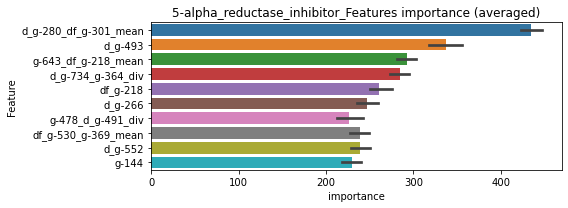

len(train_index) : 2853
len(valid_index) : 951
================================= fold 1/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0713798	valid_1's binary_logloss: 0.0928549
[200]	training's binary_logloss: 0.0177896	valid_1's binary_logloss: 0.0305462
[300]	training's binary_logloss: 0.00547304	valid_1's binary_logloss: 0.0131323
[400]	training's binary_logloss: 0.00220448	valid_1's binary_logloss: 0.00751353
[500]	training's binary_logloss: 0.00116562	valid_1's binary_logloss: 0.00507307
[600]	training's binary_logloss: 0.000755555	valid_1's binary_logloss: 0.00389764
[700]	training's binary_logloss: 0.000558856	valid_1's binary_logloss: 0.00335443
[800]	training's binary_logloss: 0.000458829	valid_1's binary_logloss: 0.00303632
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.000428963	valid_1's binary_logloss: 0.00292102


len(train_index) : 2853
len(valid_index) : 951
================================= fold 2/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0699685	valid_1's binary_logloss: 0.0957858
[200]	training's binary_logloss: 0.017522	valid_1's binary_logloss: 0.0322658
[300]	training's binary_logloss: 0.005408	valid_1's binary_logloss: 0.0134792
[400]	training's binary_logloss: 0.00215575	valid_1's binary_logloss: 0.00718971
[500]	training's binary_logloss: 0.00114403	valid_1's binary_logloss: 0.00470617
[600]	training's binary_logloss: 0.000744837	valid_1's binary_logloss: 0.00370921
[700]	training's binary_logloss: 0.000556934	valid_1's binary_logloss: 0.0031076
[800]	training's binary_logloss: 0.000455432	valid_1's binary_logloss: 0.00276384
[900]	training's binary_logloss: 0.000421567	valid_1's binary_logloss: 0.00263618
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000421567	valid_1's binary_logloss: 0.00263618


len(train_index) : 2853
len(valid_index) : 951
================================= fold 3/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718071	valid_1's binary_logloss: 0.0905434
[200]	training's binary_logloss: 0.0179368	valid_1's binary_logloss: 0.0299174
[300]	training's binary_logloss: 0.00546443	valid_1's binary_logloss: 0.0123892
[400]	training's binary_logloss: 0.00217308	valid_1's binary_logloss: 0.00680704
[500]	training's binary_logloss: 0.00115137	valid_1's binary_logloss: 0.00444762
[600]	training's binary_logloss: 0.00074507	valid_1's binary_logloss: 0.00336361
[700]	training's binary_logloss: 0.000549273	valid_1's binary_logloss: 0.00268348
[800]	training's binary_logloss: 0.000453276	valid_1's binary_logloss: 0.00238346
[900]	training's binary_logloss: 0.000427712	valid_1's binary_logloss: 0.00229394
Early stopping, best iteration is:
[927]	training's binary_logloss: 0.000422779	valid_1's binary_logloss: 0.00226722


len(train_index) : 2853
len(valid_index) : 951
================================= fold 4/4 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718559	valid_1's binary_logloss: 0.0873368
[200]	training's binary_logloss: 0.0185017	valid_1's binary_logloss: 0.0276587
[300]	training's binary_logloss: 0.00569794	valid_1's binary_logloss: 0.0106057
[400]	training's binary_logloss: 0.00225065	valid_1's binary_logloss: 0.00515105
[500]	training's binary_logloss: 0.001173	valid_1's binary_logloss: 0.0031502
[600]	training's binary_logloss: 0.000760814	valid_1's binary_logloss: 0.0023127
[700]	training's binary_logloss: 0.000561417	valid_1's binary_logloss: 0.00186417
[800]	training's binary_logloss: 0.000461405	valid_1's binary_logloss: 0.00164315
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000439311	valid_1's binary_logloss: 0.00157949


5-alpha_reductase_inhibitor logloss: 0.002352091601920507


neg labels: 3289 → selected neg labels: 3286


11-beta-hsd1_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0723388	valid_1's binary_logloss: 0.0909725
[200]	training's binary_logloss: 0.0196099	valid_1's binary_logloss: 0.0338626
[300]	training's binary_logloss: 0.00628705	valid_1's binary_logloss: 0.0162288
[400]	training's binary_logloss: 0.00248713	valid_1's binary_logloss: 0.0101193
[500]	training's binary_logloss: 0.00130005	valid_1's binary_logloss: 0.00772886
[600]	training's binary_logloss: 0.000838388	valid_1's binary_logloss: 0.00661864
[700]	training's binary_logloss: 0.000616284	valid_1's binary_logloss: 0.00608728
[800]	training's binary_logloss: 0.000493817	valid_1's binary_logloss: 0.00582186
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000456695	valid_1's binary_logloss: 0.00566348
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0721683	valid_1's binary_logloss: 0.0977102
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0064992, Threshold: 0.0381496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02670, conf_1:0.04959
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0381496
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.0881496
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.1381496
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_4: 0.1881496
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_5: 0.2381496
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.2881496
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.3381496
threshold: 0.3381496, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689145	valid_1's binary_logloss: 0.0861898
[200]	training's binary_logloss: 0.0167859	valid_1's binary_logloss: 0.0269505
[300]	training's binary_logloss: 0.00503437	valid_1's binary_logloss: 0.0110567
[400]	training's binary_logloss: 0.0020154	valid_1's binary_logloss: 0.00598396
[500]	training's binary_logloss: 0.00107186	valid_1's binary_logloss: 0.00410977
[600]	training's binary_logloss: 0.000698642	valid_1's binary_logloss: 0.00324803
[700]	training's binary_logloss: 0.000515131	valid_1's binary_logloss: 0.00276924
[800]	training's binary_logloss: 0.000422641	valid_1's binary_logloss: 0.00260448
[900]	training's binary_logloss: 0.000391962	valid_1's binary_logloss: 0.00251219
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000392341	valid_1's binary_logloss: 0.0025119
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.1426405, Threshold: 0.3381496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.27052, conf_1:0.40578
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.3381496
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.3881496
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_3: 0.4381496
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.4881496
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.5381496
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.5881496
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_7: 0.6381496
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.6881496
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.7381496
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_10: 0.7881496
threshold: 0.7881496, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689145	valid_1's binary_logloss: 0.0861898
[200]	training's binary_logloss: 0.0167859	valid_1's binary_logloss: 0.0269505
[300]	training's binary_logloss: 0.00503437	valid_1's binary_logloss: 0.0110567
[400]	training's binary_logloss: 0.0020154	valid_1's binary_logloss: 0.00598396
[500]	training's binary_logloss: 0.00107186	valid_1's binary_logloss: 0.00410977
[600]	training's binary_logloss: 0.000698642	valid_1's binary_logloss: 0.00324803
[700]	training's binary_logloss: 0.000515131	valid_1's binary_logloss: 0.00276924
[800]	training's binary_logloss: 0.000422641	valid_1's binary_logloss: 0.00260448
[900]	training's binary_logloss: 0.000391962	valid_1's binary_logloss: 0.00251219
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000392341	valid_1's binary_logloss: 0.0025119
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1426405, Threshold: 0.7881496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.7881496
threshold: 0.7881496, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687397	valid_1's binary_logloss: 0.0855169
[200]	training's binary_logloss: 0.0167527	valid_1's binary_logloss: 0.027051
[300]	training's binary_logloss: 0.00514931	valid_1's binary_logloss: 0.0112534
[400]	training's binary_logloss: 0.0020306	valid_1's binary_logloss: 0.00582291
[500]	training's binary_logloss: 0.00106895	valid_1's binary_logloss: 0.00382031
[600]	training's binary_logloss: 0.000698014	valid_1's binary_logloss: 0.00291727
[700]	training's binary_logloss: 0.000515484	valid_1's binary_logloss: 0.00252216
[800]	training's binary_logloss: 0.000421633	valid_1's binary_logloss: 0.00237529
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.000397025	valid_1's binary_logloss: 0.00232655


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0675386	valid_1's binary_logloss: 0.0871065
[200]	training's binary_logloss: 0.0161161	valid_1's binary_logloss: 0.0288126
[300]	training's binary_logloss: 0.0048616	valid_1's binary_logloss: 0.0122254
[400]	training's binary_logloss: 0.00195751	valid_1's binary_logloss: 0.00676902
[500]	training's binary_logloss: 0.00104101	valid_1's binary_logloss: 0.00461546
[600]	training's binary_logloss: 0.000682464	valid_1's binary_logloss: 0.00358875
[700]	training's binary_logloss: 0.00050863	valid_1's binary_logloss: 0.00303306
[800]	training's binary_logloss: 0.000418438	valid_1's binary_logloss: 0.00277823
[900]	training's binary_logloss: 0.000383695	valid_1's binary_logloss: 0.00268412
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000383695	valid_1's binary_logloss: 0.00268412


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687102	valid_1's binary_logloss: 0.0771935
[200]	training's binary_logloss: 0.0166632	valid_1's binary_logloss: 0.0219514
[300]	training's binary_logloss: 0.0051004	valid_1's binary_logloss: 0.00814709
[400]	training's binary_logloss: 0.00204666	valid_1's binary_logloss: 0.00391291
[500]	training's binary_logloss: 0.00109473	valid_1's binary_logloss: 0.00242271
[600]	training's binary_logloss: 0.000716101	valid_1's binary_logloss: 0.00175929
[700]	training's binary_logloss: 0.000530312	valid_1's binary_logloss: 0.00141221
[800]	training's binary_logloss: 0.00043118	valid_1's binary_logloss: 0.00120502
[900]	training's binary_logloss: 0.000400483	valid_1's binary_logloss: 0.00114846
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000400483	valid_1's binary_logloss: 0.00114846


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680919	valid_1's binary_logloss: 0.0873058
[200]	training's binary_logloss: 0.0169543	valid_1's binary_logloss: 0.0290534
[300]	training's binary_logloss: 0.00515109	valid_1's binary_logloss: 0.0124851
[400]	training's binary_logloss: 0.00206096	valid_1's binary_logloss: 0.00702886
[500]	training's binary_logloss: 0.00109414	valid_1's binary_logloss: 0.0049099
[600]	training's binary_logloss: 0.000714957	valid_1's binary_logloss: 0.00412172
[700]	training's binary_logloss: 0.000531835	valid_1's binary_logloss: 0.00361815
[800]	training's binary_logloss: 0.000432713	valid_1's binary_logloss: 0.0032424
[900]	training's binary_logloss: 0.000397267	valid_1's binary_logloss: 0.00314569
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000401777	valid_1's binary_logloss: 0.00314329


11-beta-hsd1_inhibitor logloss: 0.0023267684351794145


neg labels: 3289 → selected neg labels: 3282


acat_inhibitor, len(trt): 24, len(othr): 3282, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800018	valid_1's binary_logloss: 0.113152
[200]	training's binary_logloss: 0.0222777	valid_1's binary_logloss: 0.0505113
[300]	training's binary_logloss: 0.00746227	valid_1's binary_logloss: 0.0303665
[400]	training's binary_logloss: 0.00304019	valid_1's binary_logloss: 0.0224865
[500]	training's binary_logloss: 0.00157572	valid_1's binary_logloss: 0.0192948
[600]	training's binary_logloss: 0.0010004	valid_1's binary_logloss: 0.017587
[700]	training's binary_logloss: 0.000725435	valid_1's binary_logloss: 0.0168203
[800]	training's binary_logloss: 0.000569557	valid_1's binary_logloss: 0.016123
[900]	training's binary_logloss: 0.000491745	valid_1's binary_logloss: 0.0160052
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.000505137	valid_1's binary_logloss: 0.0159236
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826127	va

1 / 3 AUC score:1.000
y_Threshold: 0.0064526, Threshold: 0.0364404, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.02551, conf_1:0.04737
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0364404
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.0864404
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.1364404
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_4: 0.1864404
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_5: 0.2364404
threshold: 0.2364404, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775542	valid_1's binary_logloss: 0.107166
[200]	training's binary_logloss: 0.0204934	valid_1's binary_logloss: 0.0447088
[300]	training's binary_logloss: 0.00659941	valid_1's binary_logloss: 0.023994
[400]	training's binary_logloss: 0.00262468	valid_1's binary_logloss: 0.0159468
[500]	training's binary_logloss: 0.00135204	valid_1's binary_logloss: 0.0129827
[600]	training's binary_logloss: 0.000862429	valid_1's binary_logloss: 0.0114191
[700]	training's binary_logloss: 0.000628605	valid_1's binary_logloss: 0.0106216
[800]	training's binary_logloss: 0.000499587	valid_1's binary_logloss: 0.00996785
[900]	training's binary_logloss: 0.000443061	valid_1's binary_logloss: 0.00975847
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000441745	valid_1's binary_logloss: 0.00974879
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775

2 / 3 AUC score:1.000
y_Threshold: 0.1136215, Threshold: 0.2364404, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0092918 Vs.target_rate: 0.00101, Num_p_label: 37.0, conf_0:0.18915, conf_1:0.28373
Num_p_label: 37.0, Expected: 4.0, Adj_threshold_1: 0.2364404
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_2: 0.2864404
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_3: 0.3364404
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_4: 0.3864404
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_5: 0.4364404
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_6: 0.4864404
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_7: 0.5364404
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_8: 0.5864404
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_9: 0.6364404
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_10: 0.6864404
threshold: 0.7364404, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0759644	valid_1's binary_logloss: 0.0955909
[200]	training's binary_logloss: 0.0200625	valid_1's binary_logloss: 0.0342447
[300]	training's binary_logloss: 0.00647689	valid_1's binary_logloss: 0.0153678
[400]	training's binary_logloss: 0.00255954	valid_1's binary_logloss: 0.00844486
[500]	training's binary_logloss: 0.00133174	valid_1's binary_logloss: 0.00588929
[600]	training's binary_logloss: 0.000845073	valid_1's binary_logloss: 0.00455742
[700]	training's binary_logloss: 0.000619241	valid_1's binary_logloss: 0.00398738
[800]	training's binary_logloss: 0.00049715	valid_1's binary_logloss: 0.0035894
[900]	training's binary_logloss: 0.000442209	valid_1's binary_logloss: 0.00339165
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000438996	valid_1's binary_logloss: 0.00336535
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.1517227, Threshold: 0.7364404, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0032647 Vs.target_rate: 0.00101, Num_p_label: 13.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_1: 0.7364404
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_2: 0.7864404
threshold: 0.7864404, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 650.0/3794, y_label_rate: 0.1713231


len(train_index) : 2845
len(valid_index) : 949
================================= fold 1/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0765774	valid_1's binary_logloss: 0.0954581
[200]	training's binary_logloss: 0.0202858	valid_1's binary_logloss: 0.0331825
[300]	training's binary_logloss: 0.00640534	valid_1's binary_logloss: 0.0138684
[400]	training's binary_logloss: 0.00253849	valid_1's binary_logloss: 0.00746787
[500]	training's binary_logloss: 0.00131959	valid_1's binary_logloss: 0.00493428
[600]	training's binary_logloss: 0.000848175	valid_1's binary_logloss: 0.00381104
[700]	training's binary_logloss: 0.000617321	valid_1's binary_logloss: 0.0031134
[800]	training's binary_logloss: 0.000498931	valid_1's binary_logloss: 0.00279065
[900]	training's binary_logloss: 0.000437556	valid_1's binary_logloss: 0.00259513
[1000]	training's binary_logloss: 0.000422738	valid_1's binary_logloss: 0.00254895
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000422738	valid_1's binary_logloss: 0.00254895


len(train_index) : 2845
len(valid_index) : 949
================================= fold 2/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753793	valid_1's binary_logloss: 0.102597
[200]	training's binary_logloss: 0.0195501	valid_1's binary_logloss: 0.0437938
[300]	training's binary_logloss: 0.00612536	valid_1's binary_logloss: 0.0266482
[400]	training's binary_logloss: 0.00246086	valid_1's binary_logloss: 0.0211193
[500]	training's binary_logloss: 0.00129307	valid_1's binary_logloss: 0.0201477
[600]	training's binary_logloss: 0.000816863	valid_1's binary_logloss: 0.0194372
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000690039	valid_1's binary_logloss: 0.0190208


len(train_index) : 2846
len(valid_index) : 948
================================= fold 3/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0768567	valid_1's binary_logloss: 0.104587
[200]	training's binary_logloss: 0.0198632	valid_1's binary_logloss: 0.0396952
[300]	training's binary_logloss: 0.00636942	valid_1's binary_logloss: 0.0192369
[400]	training's binary_logloss: 0.00253263	valid_1's binary_logloss: 0.0112504
[500]	training's binary_logloss: 0.00130645	valid_1's binary_logloss: 0.00797165
[600]	training's binary_logloss: 0.000827919	valid_1's binary_logloss: 0.00649551
[700]	training's binary_logloss: 0.000603308	valid_1's binary_logloss: 0.00547434
[800]	training's binary_logloss: 0.000486073	valid_1's binary_logloss: 0.00491995
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000452695	valid_1's binary_logloss: 0.00472461


len(train_index) : 2846
len(valid_index) : 948
================================= fold 4/4 acat_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753498	valid_1's binary_logloss: 0.102681
[200]	training's binary_logloss: 0.019691	valid_1's binary_logloss: 0.0401798
[300]	training's binary_logloss: 0.00614049	valid_1's binary_logloss: 0.0204493
[400]	training's binary_logloss: 0.00244401	valid_1's binary_logloss: 0.0128761
[500]	training's binary_logloss: 0.00127776	valid_1's binary_logloss: 0.00970222
[600]	training's binary_logloss: 0.000819309	valid_1's binary_logloss: 0.00811777
[700]	training's binary_logloss: 0.000598706	valid_1's binary_logloss: 0.00712856
[800]	training's binary_logloss: 0.000486728	valid_1's binary_logloss: 0.00663273
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000462427	valid_1's binary_logloss: 0.00648333


acat_inhibitor logloss: 0.008195796161576199


neg labels: 3289 → selected neg labels: 3261


acetylcholine_receptor_agonist, len(trt): 190, len(othr): 3261, target_rate: 0.0079785 → Adj_target_rate: 0.0072634
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.184812	valid_1's binary_logloss: 0.308775
[200]	training's binary_logloss: 0.106511	valid_1's binary_logloss: 0.278357
[300]	training's binary_logloss: 0.0638992	valid_1's binary_logloss: 0.268171
[400]	training's binary_logloss: 0.0402953	valid_1's binary_logloss: 0.265387
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0417601	valid_1's binary_logloss: 0.264674
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.192601	valid_1's binary_logloss: 0.293694
[200]	training's binary_logloss: 0.107271	valid_1's binary_logloss: 0.250516
[300]	training's binary_logloss: 0.0666883	valid_1's binary_logloss: 0.228904
[400]	training's binary_logloss: 0.042093	valid_1's binary_logloss: 0.216048
[500]	training's binary_logloss: 0.027002	valid_1's binary_logloss: 0.20881
[600]	training's binary_logloss: 0.0172752	valid_1's binary_logloss: 0

1 / 3 AUC score:0.922
y_Threshold: 0.0954853, Threshold: 0.5407558, pos_neg_ratio: 0.8000000
Remove_noisy_data: 373 → Positive_corect_labels: 531/3540
p_label_rate: 0.0100452 Vs.target_rate: 0.00798, Num_p_label: 40.0, conf_0:0.37853, conf_1:0.70298
threshold: 0.5407558, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 531.0/3540, y_label_rate: 0.1500000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125698	valid_1's binary_logloss: 0.205304
[200]	training's binary_logloss: 0.058842	valid_1's binary_logloss: 0.156778
[300]	training's binary_logloss: 0.02937	valid_1's binary_logloss: 0.136228
[400]	training's binary_logloss: 0.0154993	valid_1's binary_logloss: 0.124455
[500]	training's binary_logloss: 0.00861822	valid_1's binary_logloss: 0.117382
[600]	training's binary_logloss: 0.00521525	valid_1's binary_logloss: 0.114034
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00423992	valid_1's binary_logloss: 0.11325
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121892	valid_1's binary_logloss: 0.207401
[200]	training's binary_logloss: 0.0572245	valid_1's binary_logloss: 0.167066
[300]	training's binary_logloss: 0.0300293	valid_1's binary_logloss: 0.151596
[400]	training's binary_logloss: 0.0160948	valid_1's binary_loglos

2 / 3 AUC score:0.980
y_Threshold: 0.1264306, Threshold: 0.5407558, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 464.0/3406
p_label_rate: 0.0384229 Vs.target_rate: 0.00798, Num_p_label: 153.0, conf_0:0.43260, conf_1:0.64891
Num_p_label: 153.0, Expected: 31.8, Adj_threshold_1: 0.5407558
Num_p_label: 137.0, Expected: 31.8, Adj_threshold_2: 0.5907558
Num_p_label: 122.0, Expected: 31.8, Adj_threshold_3: 0.6407558
Num_p_label: 108.0, Expected: 31.8, Adj_threshold_4: 0.6907558
Num_p_label: 92.0, Expected: 31.8, Adj_threshold_5: 0.7407558
Num_p_label: 70.0, Expected: 31.8, Adj_threshold_6: 0.7907558
threshold: 0.7907558, positive_p_label: 70.0/3982, p_label_rate: 0.0175791
positive_y_label: 464.0/3406, y_label_rate: 0.1362302
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0977234	valid_1's binary_logloss: 0.14138
[200]	training's binary_logloss: 0.0405501	valid_1's binary_logloss: 0.0910479
[300]	training's binary_logloss: 0.018355	valid_1's binary_logloss: 0.0672423
[400]	training's binary_logloss: 0.0091459	valid_1's binary_logloss: 0.0558688
[500]	training's binary_logloss: 0.00492715	valid_1's binary_logloss: 0.0476809
[600]	training's binary_logloss: 0.00298205	valid_1's binary_logloss: 0.043336
[700]	training's binary_logloss: 0.00202399	valid_1's binary_logloss: 0.0413794
[800]	training's binary_logloss: 0.00150971	valid_1's binary_logloss: 0.0401186
[900]	training's binary_logloss: 0.00121306	valid_1's binary_logloss: 0.0388573
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.00114497	valid_1's binary_logloss: 0.0387477
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101099	valid_1's

3 / 3 AUC score:0.994
y_Threshold: 0.1524042, Threshold: 0.7907558, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 435.0/3348
p_label_rate: 0.0326469 Vs.target_rate: 0.00798, Num_p_label: 130.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 130.0, Expected: 31.8, Adj_threshold_1: 0.7907558
threshold: 0.7907558, positive_p_label: 130.0/3982, p_label_rate: 0.0326469
positive_y_label: 435.0/3348, y_label_rate: 0.1299283


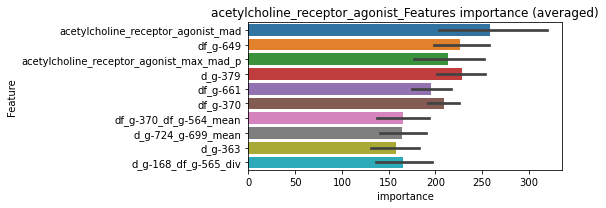

len(train_index) : 2511
len(valid_index) : 837
================================= fold 1/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860268	valid_1's binary_logloss: 0.133451
[200]	training's binary_logloss: 0.0312336	valid_1's binary_logloss: 0.0858646
[300]	training's binary_logloss: 0.0136353	valid_1's binary_logloss: 0.0673326
[400]	training's binary_logloss: 0.00648377	valid_1's binary_logloss: 0.0590921
[500]	training's binary_logloss: 0.00348994	valid_1's binary_logloss: 0.0557519
[600]	training's binary_logloss: 0.00218731	valid_1's binary_logloss: 0.0533911
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.0020091	valid_1's binary_logloss: 0.0530565


len(train_index) : 2511
len(valid_index) : 837
================================= fold 2/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0884172	valid_1's binary_logloss: 0.132638
[200]	training's binary_logloss: 0.0326856	valid_1's binary_logloss: 0.080141
[300]	training's binary_logloss: 0.0145486	valid_1's binary_logloss: 0.0611531
[400]	training's binary_logloss: 0.00703701	valid_1's binary_logloss: 0.0512535
[500]	training's binary_logloss: 0.00379259	valid_1's binary_logloss: 0.0454756
[600]	training's binary_logloss: 0.00232575	valid_1's binary_logloss: 0.043011
[700]	training's binary_logloss: 0.00160663	valid_1's binary_logloss: 0.0409954
[800]	training's binary_logloss: 0.00122125	valid_1's binary_logloss: 0.0397408
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.00107874	valid_1's binary_logloss: 0.0391326


len(train_index) : 2511
len(valid_index) : 837
================================= fold 3/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0859575	valid_1's binary_logloss: 0.135354
[200]	training's binary_logloss: 0.0319224	valid_1's binary_logloss: 0.0879858
[300]	training's binary_logloss: 0.0138489	valid_1's binary_logloss: 0.0707063
[400]	training's binary_logloss: 0.0065242	valid_1's binary_logloss: 0.0617414
[500]	training's binary_logloss: 0.00351653	valid_1's binary_logloss: 0.0573139
[600]	training's binary_logloss: 0.00219018	valid_1's binary_logloss: 0.0547147
Early stopping, best iteration is:
[631]	training's binary_logloss: 0.0019371	valid_1's binary_logloss: 0.0546896


len(train_index) : 2511
len(valid_index) : 837
================================= fold 4/4 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0887251	valid_1's binary_logloss: 0.128508
[200]	training's binary_logloss: 0.0309015	valid_1's binary_logloss: 0.0802814
[300]	training's binary_logloss: 0.0135282	valid_1's binary_logloss: 0.0624396
[400]	training's binary_logloss: 0.00666086	valid_1's binary_logloss: 0.0548098
[500]	training's binary_logloss: 0.00348453	valid_1's binary_logloss: 0.0506091
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00256719	valid_1's binary_logloss: 0.0499075


acetylcholine_receptor_agonist logloss: 0.04919654817522744


neg labels: 3289 → selected neg labels: 3241


acetylcholine_receptor_antagonist, len(trt): 301, len(othr): 3241, target_rate: 0.0126396 → Adj_target_rate: 0.0107394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.229027	valid_1's binary_logloss: 0.361365
[200]	training's binary_logloss: 0.143044	valid_1's binary_logloss: 0.338273
[300]	training's binary_logloss: 0.0955357	valid_1's binary_logloss: 0.328487
[400]	training's binary_logloss: 0.0652756	valid_1's binary_logloss: 0.324288
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.0612934	valid_1's binary_logloss: 0.323321
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.237293	valid_1's binary_logloss: 0.361124
[200]	training's binary_logloss: 0.152066	valid_1's binary_logloss: 0.333731
[300]	training's binary_logloss: 0.102252	valid_1's binary_logloss: 0.322669
[400]	training's binary_logloss: 0.071302	valid_1's binary_logloss: 0.320045
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0621199	valid_1's binary_logloss: 0.319122
Training until validation scores d

1 / 3 AUC score:0.824
y_Threshold: 0.1321441, Threshold: 0.3475828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 568 → Positive_corect_labels: 429/3321
p_label_rate: 0.0100452 Vs.target_rate: 0.01264, Num_p_label: 40.0, conf_0:0.24331, conf_1:0.45186
threshold: 0.3475828, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 429.0/3321, y_label_rate: 0.1291780
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118068	valid_1's binary_logloss: 0.233896
[200]	training's binary_logloss: 0.0503895	valid_1's binary_logloss: 0.194928
[300]	training's binary_logloss: 0.0251381	valid_1's binary_logloss: 0.180596
[400]	training's binary_logloss: 0.0134506	valid_1's binary_logloss: 0.174886
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.0125128	valid_1's binary_logloss: 0.174332
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123219	valid_1's binary_logloss: 0.205511
[200]	training's binary_logloss: 0.0571936	valid_1's binary_logloss: 0.163524
[300]	training's binary_logloss: 0.0292748	valid_1's binary_logloss: 0.145006
[400]	training's binary_logloss: 0.0157572	valid_1's binary_logloss: 0.137702
[500]	training's binary_logloss: 0.00886664	valid_1's binary_logloss: 0.135576
Early stopping, best iteration is:
[537]	training's binary_loglo

2 / 3 AUC score:0.962
y_Threshold: 0.1024935, Threshold: 0.3475828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 122 → Positive_corect_labels: 368.0/3199
p_label_rate: 0.0258664 Vs.target_rate: 0.01264, Num_p_label: 103.0, conf_0:0.27807, conf_1:0.41710
Num_p_label: 103.0, Expected: 50.3, Adj_threshold_1: 0.3475828
Num_p_label: 89.0, Expected: 50.3, Adj_threshold_2: 0.3975828
Num_p_label: 79.0, Expected: 50.3, Adj_threshold_3: 0.4475828
Num_p_label: 66.0, Expected: 50.3, Adj_threshold_4: 0.4975828
threshold: 0.4975828, positive_p_label: 66.0/3982, p_label_rate: 0.0165746
positive_y_label: 368.0/3199, y_label_rate: 0.1150359
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.094425	valid_1's binary_logloss: 0.162124
[200]	training's binary_logloss: 0.0381056	valid_1's binary_logloss: 0.115896
[300]	training's binary_logloss: 0.0172333	valid_1's binary_logloss: 0.0942525
[400]	training's binary_logloss: 0.00886913	valid_1's binary_logloss: 0.0830862
[500]	training's binary_logloss: 0.00490135	valid_1's binary_logloss: 0.0784838
[600]	training's binary_logloss: 0.00302823	valid_1's binary_logloss: 0.074457
[700]	training's binary_logloss: 0.00208231	valid_1's binary_logloss: 0.0724172
[800]	training's binary_logloss: 0.00156895	valid_1's binary_logloss: 0.0703902
[900]	training's binary_logloss: 0.00126621	valid_1's binary_logloss: 0.070131
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00130226	valid_1's binary_logloss: 0.0700246
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958463	valid_1'

3 / 3 AUC score:0.991
y_Threshold: 0.0864018, Threshold: 0.4975828, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 333.0/3129
p_label_rate: 0.0223506 Vs.target_rate: 0.01264, Num_p_label: 89.0, conf_0:0.44782, conf_1:0.54734
Num_p_label: 89.0, Expected: 50.3, Adj_threshold_1: 0.4975828
Num_p_label: 80.0, Expected: 50.3, Adj_threshold_2: 0.5475828
Num_p_label: 73.0, Expected: 50.3, Adj_threshold_3: 0.5975828
threshold: 0.5975828, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 333.0/3129, y_label_rate: 0.1064238


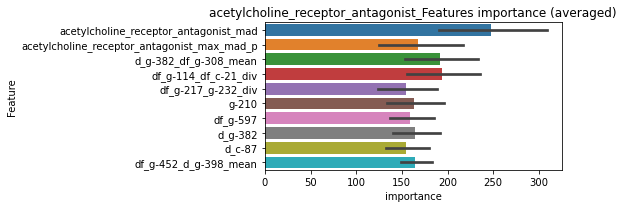

len(train_index) : 2346
len(valid_index) : 783
================================= fold 1/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822038	valid_1's binary_logloss: 0.148528
[200]	training's binary_logloss: 0.0304694	valid_1's binary_logloss: 0.102504
[300]	training's binary_logloss: 0.0133317	valid_1's binary_logloss: 0.0855574
[400]	training's binary_logloss: 0.00640111	valid_1's binary_logloss: 0.0765306
[500]	training's binary_logloss: 0.00349345	valid_1's binary_logloss: 0.0709711
[600]	training's binary_logloss: 0.00218634	valid_1's binary_logloss: 0.0685294
Early stopping, best iteration is:
[600]	training's binary_logloss: 0.00218634	valid_1's binary_logloss: 0.0685294


len(train_index) : 2347
len(valid_index) : 782
================================= fold 2/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845196	valid_1's binary_logloss: 0.138159
[200]	training's binary_logloss: 0.0315252	valid_1's binary_logloss: 0.0967261
[300]	training's binary_logloss: 0.0133717	valid_1's binary_logloss: 0.0805494
[400]	training's binary_logloss: 0.0063088	valid_1's binary_logloss: 0.0727558
[500]	training's binary_logloss: 0.00341028	valid_1's binary_logloss: 0.0685241
[600]	training's binary_logloss: 0.0021619	valid_1's binary_logloss: 0.0666148
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00204003	valid_1's binary_logloss: 0.0661907


len(train_index) : 2347
len(valid_index) : 782
================================= fold 3/4 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0814564	valid_1's binary_logloss: 0.146028
[200]	training's binary_logloss: 0.0296524	valid_1's binary_logloss: 0.107913
[300]	training's binary_logloss: 0.0128813	valid_1's binary_logloss: 0.0954711
[400]	training's binary_logloss: 0.00615641	valid_1's binary_logloss: 0.0910334


len(train_index) : 2347
len(valid_index) : 782
================================= fold 4/4 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[418]	training's binary_logloss: 0.00548351	valid_1's binary_logloss: 0.09045
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0859071	valid_1's binary_logloss: 0.140655
[200]	training's binary_logloss: 0.0318864	valid_1's binary_logloss: 0.0883679
[300]	training's binary_logloss: 0.0136025	valid_1's binary_logloss: 0.0657328
[400]	training's binary_logloss: 0.00663507	valid_1's binary_logloss: 0.05341
[500]	training's binary_logloss: 0.00364258	valid_1's binary_logloss: 0.0482021
[600]	training's binary_logloss: 0.0023036	valid_1's binary_logloss: 0.0461245
[700]	training's binary_logloss: 0.00164576	valid_1's binary_logloss: 0.044116
[800]	training's binary_logloss: 0.00126032	valid_1's binary_logloss: 0.0423182
[900]	training's binary_logloss: 0.00104036	valid_1's binary_logloss: 0.0414101
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.0010322	valid_1's binary_logloss: 0.0414098


acetylcholine_receptor_antagonist logloss: 0.06664558698626818


neg labels: 3289 → selected neg labels: 3281


acetylcholinesterase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128339	valid_1's binary_logloss: 0.211885
[200]	training's binary_logloss: 0.0532133	valid_1's binary_logloss: 0.14223
[300]	training's binary_logloss: 0.0254806	valid_1's binary_logloss: 0.107576
[400]	training's binary_logloss: 0.0125929	valid_1's binary_logloss: 0.0885354
[500]	training's binary_logloss: 0.00675186	valid_1's binary_logloss: 0.0794047
[600]	training's binary_logloss: 0.00396473	valid_1's binary_logloss: 0.0725433
[700]	training's binary_logloss: 0.00263192	valid_1's binary_logloss: 0.0687457
[800]	training's binary_logloss: 0.00191009	valid_1's binary_logloss: 0.067334
Early stopping, best iteration is:
[803]	training's binary_logloss: 0.00189201	valid_1's binary_logloss: 0.067186
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133685	valid_1's binary_logloss: 0.197392
[200]	training's binary_logloss: 0.0577388	valid_1's bina

1 / 3 AUC score:0.992
y_Threshold: 0.0377857, Threshold: 0.1960556, pos_neg_ratio: 0.8000000
Remove_noisy_data: 164 → Positive_corect_labels: 640/3773
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.13724, conf_1:0.25487
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1960556
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_2: 0.2460556
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.2960556
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_4: 0.3460556
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_5: 0.3960556
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_6: 0.4460556
threshold: 0.4460556, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115066	valid_1's binary_logloss: 0.204421
[200]	training's binary_logloss: 0.0435527	valid_1's binary_logloss: 0.142684
[300]	training's binary_logloss: 0.0184018	valid_1's binary_logloss: 0.113528
[400]	training's binary_logloss: 0.00868951	valid_1's binary_logloss: 0.100733
[500]	training's binary_logloss: 0.00452183	valid_1's binary_logloss: 0.0976638
[600]	training's binary_logloss: 0.00271871	valid_1's binary_logloss: 0.0957121
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00225935	valid_1's binary_logloss: 0.0950791
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122009	valid_1's binary_logloss: 0.167282
[200]	training's binary_logloss: 0.0484062	valid_1's binary_logloss: 0.100342
[300]	training's binary_logloss: 0.021514	valid_1's binary_logloss: 0.0729357
[400]	training's binary_logloss: 0.0101493	valid_1's binar

2 / 3 AUC score:0.997
y_Threshold: 0.1242906, Threshold: 0.4460556, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 611.0/3715
p_label_rate: 0.0178302 Vs.target_rate: 0.00307, Num_p_label: 71.0, conf_0:0.35684, conf_1:0.53527
Num_p_label: 71.0, Expected: 12.2, Adj_threshold_1: 0.4460556
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_2: 0.4960556
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_3: 0.5460556
Num_p_label: 54.0, Expected: 12.2, Adj_threshold_4: 0.5960556
Num_p_label: 49.0, Expected: 12.2, Adj_threshold_5: 0.6460556
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_6: 0.6960556
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_7: 0.7460556
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_8: 0.7960556
threshold: 0.7960556, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 611.0/3715, y_label_rate: 0.1644684
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110776	valid_1's binary_logloss: 0.154421
[200]	training's binary_logloss: 0.0405324	valid_1's binary_logloss: 0.0831821
[300]	training's binary_logloss: 0.016771	valid_1's binary_logloss: 0.0533858
[400]	training's binary_logloss: 0.00771024	valid_1's binary_logloss: 0.0394907
[500]	training's binary_logloss: 0.00404681	valid_1's binary_logloss: 0.0323148
[600]	training's binary_logloss: 0.00245318	valid_1's binary_logloss: 0.0290326
[700]	training's binary_logloss: 0.00168239	valid_1's binary_logloss: 0.0267187
[800]	training's binary_logloss: 0.00127833	valid_1's binary_logloss: 0.025209
[900]	training's binary_logloss: 0.00103938	valid_1's binary_logloss: 0.0245823
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000945566	valid_1's binary_logloss: 0.0244103
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102375	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1209543, Threshold: 0.7960556, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 600.0/3693
p_label_rate: 0.0158212 Vs.target_rate: 0.00307, Num_p_label: 63.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 63.0, Expected: 12.2, Adj_threshold_1: 0.7960556
threshold: 0.7960556, positive_p_label: 63.0/3982, p_label_rate: 0.0158212
positive_y_label: 600.0/3693, y_label_rate: 0.1624695


len(train_index) : 2769
len(valid_index) : 924
================================= fold 1/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104609	valid_1's binary_logloss: 0.149206
[200]	training's binary_logloss: 0.0377545	valid_1's binary_logloss: 0.0837244
[300]	training's binary_logloss: 0.0159253	valid_1's binary_logloss: 0.0558684
[400]	training's binary_logloss: 0.0072213	valid_1's binary_logloss: 0.0425062
[500]	training's binary_logloss: 0.00373646	valid_1's binary_logloss: 0.0351521
[600]	training's binary_logloss: 0.00226149	valid_1's binary_logloss: 0.0310661
[700]	training's binary_logloss: 0.00155842	valid_1's binary_logloss: 0.0282806
[800]	training's binary_logloss: 0.00118997	valid_1's binary_logloss: 0.0269198
[900]	training's binary_logloss: 0.000977271	valid_1's binary_logloss: 0.0255257
[1000]	training's binary_logloss: 0.000849747	valid_1's binary_logloss: 0.0250301
[1100]	training's binary_logloss: 0.000797218	valid_1's binary_logloss: 0.0246045
Early stopping, best iteration is:
[1142]	training's binary_

len(train_index) : 2770
len(valid_index) : 923
================================= fold 2/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103553	valid_1's binary_logloss: 0.157302
[200]	training's binary_logloss: 0.0369523	valid_1's binary_logloss: 0.0905704
[300]	training's binary_logloss: 0.014916	valid_1's binary_logloss: 0.0631715
[400]	training's binary_logloss: 0.00681466	valid_1's binary_logloss: 0.0498867
[500]	training's binary_logloss: 0.00358099	valid_1's binary_logloss: 0.0434943
[600]	training's binary_logloss: 0.00219189	valid_1's binary_logloss: 0.0405442
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00175654	valid_1's binary_logloss: 0.039809


len(train_index) : 2770
len(valid_index) : 923
================================= fold 3/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107473	valid_1's binary_logloss: 0.151498
[200]	training's binary_logloss: 0.0389355	valid_1's binary_logloss: 0.0825938
[300]	training's binary_logloss: 0.0156484	valid_1's binary_logloss: 0.0538422
[400]	training's binary_logloss: 0.00710093	valid_1's binary_logloss: 0.0413212
[500]	training's binary_logloss: 0.00371219	valid_1's binary_logloss: 0.0356825
[600]	training's binary_logloss: 0.00226623	valid_1's binary_logloss: 0.03191
[700]	training's binary_logloss: 0.00156478	valid_1's binary_logloss: 0.0297376
[800]	training's binary_logloss: 0.00119681	valid_1's binary_logloss: 0.028451
[900]	training's binary_logloss: 0.000978625	valid_1's binary_logloss: 0.0276024
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000921055	valid_1's binary_logloss: 0.0272165


len(train_index) : 2770
len(valid_index) : 923
================================= fold 4/4 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105882	valid_1's binary_logloss: 0.163459
[200]	training's binary_logloss: 0.0381478	valid_1's binary_logloss: 0.102421
[300]	training's binary_logloss: 0.0154756	valid_1's binary_logloss: 0.0772653
[400]	training's binary_logloss: 0.00688496	valid_1's binary_logloss: 0.0647055
[500]	training's binary_logloss: 0.00360838	valid_1's binary_logloss: 0.0582589
[600]	training's binary_logloss: 0.00219161	valid_1's binary_logloss: 0.0543576
[700]	training's binary_logloss: 0.00151854	valid_1's binary_logloss: 0.0530127
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00138917	valid_1's binary_logloss: 0.0525911


acetylcholinesterase_inhibitor logloss: 0.03603835550561969


neg labels: 3289 → selected neg labels: 3278


adenosine_receptor_agonist, len(trt): 54, len(othr): 3278, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125296	valid_1's binary_logloss: 0.183872
[200]	training's binary_logloss: 0.0533825	valid_1's binary_logloss: 0.117106
[300]	training's binary_logloss: 0.0242124	valid_1's binary_logloss: 0.0839259
[400]	training's binary_logloss: 0.0113681	valid_1's binary_logloss: 0.0649264
[500]	training's binary_logloss: 0.00580701	valid_1's binary_logloss: 0.0552168
[600]	training's binary_logloss: 0.00332881	valid_1's binary_logloss: 0.0502109
[700]	training's binary_logloss: 0.00216255	valid_1's binary_logloss: 0.0468963
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.00189418	valid_1's binary_logloss: 0.0457008
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128667	valid_1's binary_logloss: 0.165553
[200]	training's binary_logloss: 0.0549118	valid_1's binary_logloss: 0.0939934
[300]	training's binary_logloss: 0.0251936	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0265780, Threshold: 0.2606864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 649/3789
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.18248, conf_1:0.33889
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.2606864
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_2: 0.3106864
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_3: 0.3606864
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_4: 0.4106864
threshold: 0.4106864, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 649.0/3789, y_label_rate: 0.1712853
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116732	valid_1's binary_logloss: 0.166489
[200]	training's binary_logloss: 0.0440311	valid_1's binary_logloss: 0.0888604
[300]	training's binary_logloss: 0.0186503	valid_1's binary_logloss: 0.0545933
[400]	training's binary_logloss: 0.00853713	valid_1's binary_logloss: 0.0378988
[500]	training's binary_logloss: 0.00438213	valid_1's binary_logloss: 0.0285341
[600]	training's binary_logloss: 0.00258124	valid_1's binary_logloss: 0.023704
[700]	training's binary_logloss: 0.0017177	valid_1's binary_logloss: 0.0207278
[800]	training's binary_logloss: 0.00127642	valid_1's binary_logloss: 0.0192179
[900]	training's binary_logloss: 0.0010229	valid_1's binary_logloss: 0.0183407
[1000]	training's binary_logloss: 0.000871504	valid_1's binary_logloss: 0.0176454
[1100]	training's binary_logloss: 0.000794676	valid_1's binary_logloss: 0.0172253
Early stopping, best iteration is:
[1143]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1933456, Threshold: 0.4106864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 637.0/3765
p_label_rate: 0.0223506 Vs.target_rate: 0.00227, Num_p_label: 89.0, conf_0:0.32855, conf_1:0.49282
Num_p_label: 89.0, Expected: 9.0, Adj_threshold_1: 0.4106864
Num_p_label: 83.0, Expected: 9.0, Adj_threshold_2: 0.4606864
Num_p_label: 80.0, Expected: 9.0, Adj_threshold_3: 0.5106864
Num_p_label: 72.0, Expected: 9.0, Adj_threshold_4: 0.5606864
Num_p_label: 66.0, Expected: 9.0, Adj_threshold_5: 0.6106864
Num_p_label: 52.0, Expected: 9.0, Adj_threshold_6: 0.6606864
Num_p_label: 47.0, Expected: 9.0, Adj_threshold_7: 0.7106864
Num_p_label: 41.0, Expected: 9.0, Adj_threshold_8: 0.7606864
threshold: 0.7606864, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 637.0/3765, y_label_rate: 0.1691899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11193	valid_1's binary_logloss: 0.164351
[200]	training's binary_logloss: 0.0421631	valid_1's binary_logloss: 0.0902217
[300]	training's binary_logloss: 0.0174031	valid_1's binary_logloss: 0.0557444
[400]	training's binary_logloss: 0.00774144	valid_1's binary_logloss: 0.0390875
[500]	training's binary_logloss: 0.00396015	valid_1's binary_logloss: 0.0317921
[600]	training's binary_logloss: 0.00234439	valid_1's binary_logloss: 0.028304
[700]	training's binary_logloss: 0.00159173	valid_1's binary_logloss: 0.0263346
[800]	training's binary_logloss: 0.00118414	valid_1's binary_logloss: 0.0251242
[900]	training's binary_logloss: 0.000950028	valid_1's binary_logloss: 0.0242057
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.000857054	valid_1's binary_logloss: 0.0238814
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11229	valid_1

3 / 3 AUC score:0.999
y_Threshold: 0.1481556, Threshold: 0.7606864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 626.0/3743
p_label_rate: 0.0128076 Vs.target_rate: 0.00227, Num_p_label: 51.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 51.0, Expected: 9.0, Adj_threshold_1: 0.7606864
threshold: 0.7606864, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 626.0/3743, y_label_rate: 0.1672455


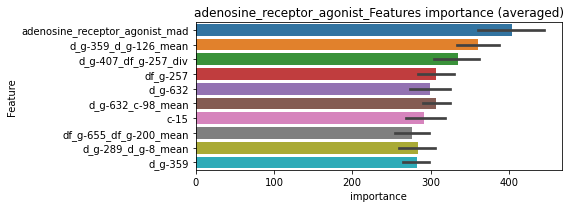

len(train_index) : 2807
len(valid_index) : 936
================================= fold 1/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10606	valid_1's binary_logloss: 0.150844
[200]	training's binary_logloss: 0.039722	valid_1's binary_logloss: 0.0825778
[300]	training's binary_logloss: 0.017146	valid_1's binary_logloss: 0.0524651
[400]	training's binary_logloss: 0.00795789	valid_1's binary_logloss: 0.0367658
[500]	training's binary_logloss: 0.00389583	valid_1's binary_logloss: 0.0281143
[600]	training's binary_logloss: 0.0022438	valid_1's binary_logloss: 0.0229063
[700]	training's binary_logloss: 0.00151099	valid_1's binary_logloss: 0.020173
[800]	training's binary_logloss: 0.00113199	valid_1's binary_logloss: 0.0186918
[900]	training's binary_logloss: 0.000908074	valid_1's binary_logloss: 0.0173885
[1000]	training's binary_logloss: 0.00079197	valid_1's binary_logloss: 0.0167926
Early stopping, best iteration is:
[1042]	training's binary_logloss: 0.000760337	valid_1's binary_logloss: 0.0165692


len(train_index) : 2807
len(valid_index) : 936
================================= fold 2/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103825	valid_1's binary_logloss: 0.161857
[200]	training's binary_logloss: 0.0356451	valid_1's binary_logloss: 0.094621
[300]	training's binary_logloss: 0.0145202	valid_1's binary_logloss: 0.0662592
[400]	training's binary_logloss: 0.00661872	valid_1's binary_logloss: 0.0518416
[500]	training's binary_logloss: 0.00339655	valid_1's binary_logloss: 0.0466365
[600]	training's binary_logloss: 0.00204567	valid_1's binary_logloss: 0.0433752
[700]	training's binary_logloss: 0.00140899	valid_1's binary_logloss: 0.0407715
[800]	training's binary_logloss: 0.00107623	valid_1's binary_logloss: 0.0396496
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.00104169	valid_1's binary_logloss: 0.0394154


len(train_index) : 2807
len(valid_index) : 936
================================= fold 3/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111331	valid_1's binary_logloss: 0.138628
[200]	training's binary_logloss: 0.0408742	valid_1's binary_logloss: 0.0656432
[300]	training's binary_logloss: 0.0168865	valid_1's binary_logloss: 0.0370051
[400]	training's binary_logloss: 0.00758197	valid_1's binary_logloss: 0.0239151
[500]	training's binary_logloss: 0.00383929	valid_1's binary_logloss: 0.0170108
[600]	training's binary_logloss: 0.00226578	valid_1's binary_logloss: 0.0133114
[700]	training's binary_logloss: 0.00153353	valid_1's binary_logloss: 0.0113416
[800]	training's binary_logloss: 0.00115357	valid_1's binary_logloss: 0.0100901
[900]	training's binary_logloss: 0.000929523	valid_1's binary_logloss: 0.00920041
[1000]	training's binary_logloss: 0.000798177	valid_1's binary_logloss: 0.00879675
[1100]	training's binary_logloss: 0.000744342	valid_1's binary_logloss: 0.00859961
[1200]	training's binary_logloss: 0.000714054	valid_1's 

len(train_index) : 2808
len(valid_index) : 935
================================= fold 4/4 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108828	valid_1's binary_logloss: 0.162534
[200]	training's binary_logloss: 0.0387756	valid_1's binary_logloss: 0.0916637
[300]	training's binary_logloss: 0.0161015	valid_1's binary_logloss: 0.0615804
[400]	training's binary_logloss: 0.00713018	valid_1's binary_logloss: 0.0461746
[500]	training's binary_logloss: 0.00358074	valid_1's binary_logloss: 0.0372212
[600]	training's binary_logloss: 0.00213732	valid_1's binary_logloss: 0.0325127
[700]	training's binary_logloss: 0.00146496	valid_1's binary_logloss: 0.0303149
[800]	training's binary_logloss: 0.00110589	valid_1's binary_logloss: 0.0291346
Early stopping, best iteration is:
[851]	training's binary_logloss: 0.000981279	valid_1's binary_logloss: 0.0286505


adenosine_receptor_agonist logloss: 0.0232836263887361


neg labels: 3289 → selected neg labels: 3276


adenosine_receptor_antagonist, len(trt): 96, len(othr): 3276, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144039	valid_1's binary_logloss: 0.236497
[200]	training's binary_logloss: 0.0670053	valid_1's binary_logloss: 0.171159
[300]	training's binary_logloss: 0.0346076	valid_1's binary_logloss: 0.139804
[400]	training's binary_logloss: 0.0186223	valid_1's binary_logloss: 0.125419
[500]	training's binary_logloss: 0.0104637	valid_1's binary_logloss: 0.116689
[600]	training's binary_logloss: 0.00627108	valid_1's binary_logloss: 0.111516
[700]	training's binary_logloss: 0.00396115	valid_1's binary_logloss: 0.108165
Early stopping, best iteration is:
[752]	training's binary_logloss: 0.00326214	valid_1's binary_logloss: 0.10714
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143416	valid_1's binary_logloss: 0.21056
[200]	training's binary_logloss: 0.0637897	valid_1's binary_logloss: 0.144313
[300]	training's binary_logloss: 0.0325401	valid_1's binary_logl

1 / 3 AUC score:0.981
y_Threshold: 0.0508294, Threshold: 0.2333214, pos_neg_ratio: 0.8000000
Remove_noisy_data: 218 → Positive_corect_labels: 612/3713
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.16332, conf_1:0.30332
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_1: 0.2333214
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_2: 0.2833214
Num_p_label: 18.0, Expected: 16.1, Adj_threshold_3: 0.3333214
threshold: 0.3333214, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 612.0/3713, y_label_rate: 0.1648263
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124945	valid_1's binary_logloss: 0.196532
[200]	training's binary_logloss: 0.0529337	valid_1's binary_logloss: 0.13742
[300]	training's binary_logloss: 0.0246144	valid_1's binary_logloss: 0.114171
[400]	training's binary_logloss: 0.0121064	valid_1's binary_logloss: 0.102852
[500]	training's binary_logloss: 0.00635832	valid_1's binary_logloss: 0.096454
[600]	training's binary_logloss: 0.00373245	valid_1's binary_logloss: 0.0926364
[700]	training's binary_logloss: 0.00247474	valid_1's binary_logloss: 0.0906239
[800]	training's binary_logloss: 0.00180557	valid_1's binary_logloss: 0.0901876
Early stopping, best iteration is:
[782]	training's binary_logloss: 0.0019015	valid_1's binary_logloss: 0.0900094
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122168	valid_1's binary_logloss: 0.196337
[200]	training's binary_logloss: 0.0497403	valid_1's binar

2 / 3 AUC score:0.995
y_Threshold: 0.1022612, Threshold: 0.3333214, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 581.0/3651
p_label_rate: 0.0215972 Vs.target_rate: 0.00403, Num_p_label: 86.0, conf_0:0.26666, conf_1:0.39999
Num_p_label: 86.0, Expected: 16.1, Adj_threshold_1: 0.3333214
Num_p_label: 70.0, Expected: 16.1, Adj_threshold_2: 0.3833214
Num_p_label: 59.0, Expected: 16.1, Adj_threshold_3: 0.4333214
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_4: 0.4833214
Num_p_label: 43.0, Expected: 16.1, Adj_threshold_5: 0.5333214
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_6: 0.5833214
Num_p_label: 29.0, Expected: 16.1, Adj_threshold_7: 0.6333214
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_8: 0.6833214
threshold: 0.6833214, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 581.0/3651, y_label_rate: 0.1591345
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109964	valid_1's binary_logloss: 0.184362
[200]	training's binary_logloss: 0.0419075	valid_1's binary_logloss: 0.123066
[300]	training's binary_logloss: 0.0181803	valid_1's binary_logloss: 0.0968246
[400]	training's binary_logloss: 0.00880299	valid_1's binary_logloss: 0.0858845
[500]	training's binary_logloss: 0.0047083	valid_1's binary_logloss: 0.0797331
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00343109	valid_1's binary_logloss: 0.0775664
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112317	valid_1's binary_logloss: 0.15931
[200]	training's binary_logloss: 0.0456843	valid_1's binary_logloss: 0.0947111
[300]	training's binary_logloss: 0.0203523	valid_1's binary_logloss: 0.067488
[400]	training's binary_logloss: 0.00971518	valid_1's binary_logloss: 0.054041
[500]	training's binary_logloss: 0.00506386	valid_1's bina

3 / 3 AUC score:0.995
y_Threshold: 0.1362184, Threshold: 0.6833214, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 552.0/3593
p_label_rate: 0.0123054 Vs.target_rate: 0.00403, Num_p_label: 49.0, conf_0:0.50000, conf_1:0.75165
Num_p_label: 49.0, Expected: 16.1, Adj_threshold_1: 0.6833214
Num_p_label: 39.0, Expected: 16.1, Adj_threshold_2: 0.7333214
Num_p_label: 33.0, Expected: 16.1, Adj_threshold_3: 0.7833214
threshold: 0.7833214, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 552.0/3593, y_label_rate: 0.1536321


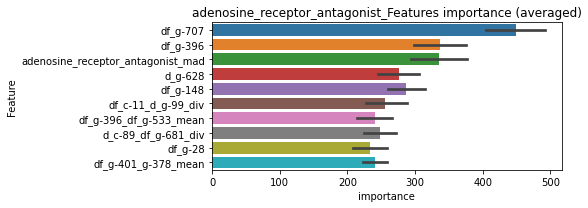

len(train_index) : 2694
len(valid_index) : 899
================================= fold 1/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102969	valid_1's binary_logloss: 0.15506
[200]	training's binary_logloss: 0.0362026	valid_1's binary_logloss: 0.0908227
[300]	training's binary_logloss: 0.015155	valid_1's binary_logloss: 0.0662795
[400]	training's binary_logloss: 0.0071143	valid_1's binary_logloss: 0.0536757
[500]	training's binary_logloss: 0.00373068	valid_1's binary_logloss: 0.0482031
[600]	training's binary_logloss: 0.00232919	valid_1's binary_logloss: 0.0462407
[700]	training's binary_logloss: 0.00160351	valid_1's binary_logloss: 0.0444094
[800]	training's binary_logloss: 0.00122439	valid_1's binary_logloss: 0.0432743
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.00109607	valid_1's binary_logloss: 0.0428437


len(train_index) : 2695
len(valid_index) : 898
================================= fold 2/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103126	valid_1's binary_logloss: 0.143803
[200]	training's binary_logloss: 0.0372845	valid_1's binary_logloss: 0.0797254
[300]	training's binary_logloss: 0.0157954	valid_1's binary_logloss: 0.0535146
[400]	training's binary_logloss: 0.00761247	valid_1's binary_logloss: 0.040836
[500]	training's binary_logloss: 0.0039961	valid_1's binary_logloss: 0.0334856
[600]	training's binary_logloss: 0.00245149	valid_1's binary_logloss: 0.0294675
[700]	training's binary_logloss: 0.0016804	valid_1's binary_logloss: 0.0269938
[800]	training's binary_logloss: 0.00127509	valid_1's binary_logloss: 0.0255014
[900]	training's binary_logloss: 0.00103381	valid_1's binary_logloss: 0.0241416
[1000]	training's binary_logloss: 0.000895931	valid_1's binary_logloss: 0.0238237
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000870209	valid_1's binary_logloss: 0.0235825


len(train_index) : 2695
len(valid_index) : 898
================================= fold 3/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0998312	valid_1's binary_logloss: 0.157518
[200]	training's binary_logloss: 0.037041	valid_1's binary_logloss: 0.0980323
[300]	training's binary_logloss: 0.0158369	valid_1's binary_logloss: 0.0725541
[400]	training's binary_logloss: 0.00726698	valid_1's binary_logloss: 0.0595957
[500]	training's binary_logloss: 0.00380251	valid_1's binary_logloss: 0.0527113
[600]	training's binary_logloss: 0.00234647	valid_1's binary_logloss: 0.0486791
[700]	training's binary_logloss: 0.00161527	valid_1's binary_logloss: 0.0457625
[800]	training's binary_logloss: 0.00122668	valid_1's binary_logloss: 0.044214
Early stopping, best iteration is:
[838]	training's binary_logloss: 0.00113157	valid_1's binary_logloss: 0.0437941


len(train_index) : 2695
len(valid_index) : 898
================================= fold 4/4 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103133	valid_1's binary_logloss: 0.149263
[200]	training's binary_logloss: 0.037955	valid_1's binary_logloss: 0.0820402
[300]	training's binary_logloss: 0.0159442	valid_1's binary_logloss: 0.0537484
[400]	training's binary_logloss: 0.00750486	valid_1's binary_logloss: 0.0393126
[500]	training's binary_logloss: 0.00393013	valid_1's binary_logloss: 0.0319939
[600]	training's binary_logloss: 0.00240559	valid_1's binary_logloss: 0.0277629
[700]	training's binary_logloss: 0.0016609	valid_1's binary_logloss: 0.0253558
[800]	training's binary_logloss: 0.00126081	valid_1's binary_logloss: 0.0239368
[900]	training's binary_logloss: 0.00103014	valid_1's binary_logloss: 0.022948
[1000]	training's binary_logloss: 0.000894499	valid_1's binary_logloss: 0.0225294
[1100]	training's binary_logloss: 0.000816206	valid_1's binary_logloss: 0.0221857
Early stopping, best iteration is:
[1136]	training's binary_log

adenosine_receptor_antagonist logloss: 0.03306532124840114


neg labels: 3289 → selected neg labels: 3289


adenylyl_cyclase_activator, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829557	valid_1's binary_logloss: 0.106062
[200]	training's binary_logloss: 0.0248149	valid_1's binary_logloss: 0.041025
[300]	training's binary_logloss: 0.00862898	valid_1's binary_logloss: 0.0202398
[400]	training's binary_logloss: 0.0034162	valid_1's binary_logloss: 0.0128832
[500]	training's binary_logloss: 0.0017285	valid_1's binary_logloss: 0.00997669
[600]	training's binary_logloss: 0.0010703	valid_1's binary_logloss: 0.00869671
[700]	training's binary_logloss: 0.000783852	valid_1's binary_logloss: 0.00801543
[800]	training's binary_logloss: 0.000624314	valid_1's binary_logloss: 0.00762619
[900]	training's binary_logloss: 0.00054315	valid_1's binary_logloss: 0.00747789
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000538472	valid_1's binary_logloss: 0.00747294
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.080730

1 / 3 AUC score:1.000
y_Threshold: 0.0049768, Threshold: 0.0504297, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.03530, conf_1:0.06556
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0504297
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.1004297
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.1504297
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.2004297
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.2504297
threshold: 0.2504297, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805742	valid_1's binary_logloss: 0.100815
[200]	training's binary_logloss: 0.0224034	valid_1's binary_logloss: 0.0348676
[300]	training's binary_logloss: 0.00715723	valid_1's binary_logloss: 0.0148951
[400]	training's binary_logloss: 0.00286953	valid_1's binary_logloss: 0.00846828
[500]	training's binary_logloss: 0.00147356	valid_1's binary_logloss: 0.00615053
[600]	training's binary_logloss: 0.000943645	valid_1's binary_logloss: 0.00506993
[700]	training's binary_logloss: 0.000694209	valid_1's binary_logloss: 0.00457166
[800]	training's binary_logloss: 0.000559004	valid_1's binary_logloss: 0.00424602
[900]	training's binary_logloss: 0.000492249	valid_1's binary_logloss: 0.00412722
[1000]	training's binary_logloss: 0.000465101	valid_1's binary_logloss: 0.00407713
Early stopping, best iteration is:
[1027]	training's binary_logloss: 0.000463646	valid_1's binary_logloss: 0.00406371
Training un

2 / 3 AUC score:1.000
y_Threshold: 0.0697026, Threshold: 0.2504297, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0097941 Vs.target_rate: 0.00076, Num_p_label: 39.0, conf_0:0.20034, conf_1:0.30052
Num_p_label: 39.0, Expected: 3.0, Adj_threshold_1: 0.2504297
Num_p_label: 38.0, Expected: 3.0, Adj_threshold_2: 0.3004297
Num_p_label: 34.0, Expected: 3.0, Adj_threshold_3: 0.3504297
Num_p_label: 32.0, Expected: 3.0, Adj_threshold_4: 0.4004297
Num_p_label: 30.0, Expected: 3.0, Adj_threshold_5: 0.4504297
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_6: 0.5004297
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_7: 0.5504297
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_8: 0.6004297
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_9: 0.6504297
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_10: 0.7004297
threshold: 0.7504297, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805742	valid_1's binary_logloss: 0.100815
[200]	training's binary_logloss: 0.0224034	valid_1's binary_logloss: 0.0348676
[300]	training's binary_logloss: 0.00715723	valid_1's binary_logloss: 0.0148951
[400]	training's binary_logloss: 0.00286953	valid_1's binary_logloss: 0.00846828
[500]	training's binary_logloss: 0.00147356	valid_1's binary_logloss: 0.00615053
[600]	training's binary_logloss: 0.000943645	valid_1's binary_logloss: 0.00506993
[700]	training's binary_logloss: 0.000694209	valid_1's binary_logloss: 0.00457166
[800]	training's binary_logloss: 0.000559004	valid_1's binary_logloss: 0.00424602
[900]	training's binary_logloss: 0.000492249	valid_1's binary_logloss: 0.00412722
[1000]	training's binary_logloss: 0.000465101	valid_1's binary_logloss: 0.00407713
Early stopping, best iteration is:
[1027]	training's binary_logloss: 0.000463646	valid_1's binary_logloss: 0.00406371
Training un

3 / 3 AUC score:1.000
y_Threshold: 0.0697026, Threshold: 0.7504297, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00076, Num_p_label: 13.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_1: 0.7504297
threshold: 0.7504297, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


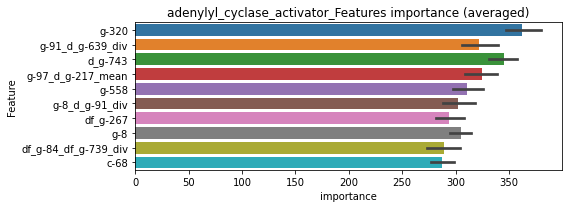

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0806157	valid_1's binary_logloss: 0.0995338
[200]	training's binary_logloss: 0.022652	valid_1's binary_logloss: 0.034541
[300]	training's binary_logloss: 0.00729796	valid_1's binary_logloss: 0.0146077
[400]	training's binary_logloss: 0.00287989	valid_1's binary_logloss: 0.00801709
[500]	training's binary_logloss: 0.00150423	valid_1's binary_logloss: 0.00551894
[600]	training's binary_logloss: 0.000957533	valid_1's binary_logloss: 0.00435725
[700]	training's binary_logloss: 0.000699648	valid_1's binary_logloss: 0.00378948
[800]	training's binary_logloss: 0.000565431	valid_1's binary_logloss: 0.00337046
[900]	training's binary_logloss: 0.000491864	valid_1's binary_logloss: 0.00317861
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000481698	valid_1's binary_logloss: 0.00314146


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.081631	valid_1's binary_logloss: 0.106631
[200]	training's binary_logloss: 0.022309	valid_1's binary_logloss: 0.0385681
[300]	training's binary_logloss: 0.00710876	valid_1's binary_logloss: 0.0163768
[400]	training's binary_logloss: 0.00282165	valid_1's binary_logloss: 0.00862137
[500]	training's binary_logloss: 0.00146446	valid_1's binary_logloss: 0.00546931
[600]	training's binary_logloss: 0.000931842	valid_1's binary_logloss: 0.0041082
[700]	training's binary_logloss: 0.000675945	valid_1's binary_logloss: 0.00339707
[800]	training's binary_logloss: 0.000546147	valid_1's binary_logloss: 0.0030366
[900]	training's binary_logloss: 0.000480652	valid_1's binary_logloss: 0.00280857
Early stopping, best iteration is:
[967]	training's binary_logloss: 0.000461429	valid_1's binary_logloss: 0.0027732


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0821164	valid_1's binary_logloss: 0.097553
[200]	training's binary_logloss: 0.022613	valid_1's binary_logloss: 0.0317388
[300]	training's binary_logloss: 0.00728835	valid_1's binary_logloss: 0.0126383
[400]	training's binary_logloss: 0.00287711	valid_1's binary_logloss: 0.00616374
[500]	training's binary_logloss: 0.00149794	valid_1's binary_logloss: 0.00376459
[600]	training's binary_logloss: 0.000957773	valid_1's binary_logloss: 0.00265611
[700]	training's binary_logloss: 0.000699727	valid_1's binary_logloss: 0.00209818
[800]	training's binary_logloss: 0.000564559	valid_1's binary_logloss: 0.00179092
[900]	training's binary_logloss: 0.00049359	valid_1's binary_logloss: 0.0016265
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000473697	valid_1's binary_logloss: 0.00158285


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0821598	valid_1's binary_logloss: 0.0987233
[200]	training's binary_logloss: 0.0222183	valid_1's binary_logloss: 0.0322737
[300]	training's binary_logloss: 0.00709633	valid_1's binary_logloss: 0.0131697
[400]	training's binary_logloss: 0.0028484	valid_1's binary_logloss: 0.00691398
[500]	training's binary_logloss: 0.00147313	valid_1's binary_logloss: 0.0045812
[600]	training's binary_logloss: 0.000941137	valid_1's binary_logloss: 0.00372749
[700]	training's binary_logloss: 0.000691082	valid_1's binary_logloss: 0.00315677
[800]	training's binary_logloss: 0.000555752	valid_1's binary_logloss: 0.00290234
[900]	training's binary_logloss: 0.000487111	valid_1's binary_logloss: 0.00274992
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000475932	valid_1's binary_logloss: 0.00271864


adenylyl_cyclase_activator logloss: 0.0025554291356037536


neg labels: 3289 → selected neg labels: 3254


adrenergic_receptor_agonist, len(trt): 270, len(othr): 3254, target_rate: 0.0113379 → Adj_target_rate: 0.0097917
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.232292	valid_1's binary_logloss: 0.356548
[200]	training's binary_logloss: 0.140187	valid_1's binary_logloss: 0.319601
[300]	training's binary_logloss: 0.0907447	valid_1's binary_logloss: 0.301979
[400]	training's binary_logloss: 0.0597086	valid_1's binary_logloss: 0.293545
[500]	training's binary_logloss: 0.0397867	valid_1's binary_logloss: 0.290267
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0424012	valid_1's binary_logloss: 0.289715
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.223727	valid_1's binary_logloss: 0.363653
[200]	training's binary_logloss: 0.13525	valid_1's binary_logloss: 0.33372
[300]	training's binary_logloss: 0.0900908	valid_1's binary_logloss: 0.320355
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0702784	valid_1's binary_logloss: 0.3141
Training until validation scores don

1 / 3 AUC score:0.856
y_Threshold: 0.1143093, Threshold: 0.6794754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 501 → Positive_corect_labels: 465/3403
p_label_rate: 0.0100452 Vs.target_rate: 0.01134, Num_p_label: 40.0, conf_0:0.47563, conf_1:0.80000
threshold: 0.6794754, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 465.0/3403, y_label_rate: 0.1366441
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145885	valid_1's binary_logloss: 0.241089
[200]	training's binary_logloss: 0.0710821	valid_1's binary_logloss: 0.190302
[300]	training's binary_logloss: 0.0369771	valid_1's binary_logloss: 0.166128
[400]	training's binary_logloss: 0.02013	valid_1's binary_logloss: 0.152759
[500]	training's binary_logloss: 0.0113886	valid_1's binary_logloss: 0.147226
[600]	training's binary_logloss: 0.00702069	valid_1's binary_logloss: 0.143165
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00613112	valid_1's binary_logloss: 0.14262
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.147616	valid_1's binary_logloss: 0.238146
[200]	training's binary_logloss: 0.0713713	valid_1's binary_logloss: 0.185289
[300]	training's binary_logloss: 0.0377792	valid_1's binary_logloss: 0.15987
[400]	training's binary_logloss: 0.0202024	valid_1's binary_logloss

2 / 3 AUC score:0.969
y_Threshold: 0.0862647, Threshold: 0.6794754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 128 → Positive_corect_labels: 401.0/3275
p_label_rate: 0.0311401 Vs.target_rate: 0.01134, Num_p_label: 124.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 124.0, Expected: 45.1, Adj_threshold_1: 0.6794754
Num_p_label: 118.0, Expected: 45.1, Adj_threshold_2: 0.7294754
Num_p_label: 110.0, Expected: 45.1, Adj_threshold_3: 0.7794754
threshold: 0.7794754, positive_p_label: 110.0/3982, p_label_rate: 0.0276243
positive_y_label: 401.0/3275, y_label_rate: 0.1224427
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118748	valid_1's binary_logloss: 0.19013
[200]	training's binary_logloss: 0.0490148	valid_1's binary_logloss: 0.138302
[300]	training's binary_logloss: 0.0232958	valid_1's binary_logloss: 0.113487
[400]	training's binary_logloss: 0.0117049	valid_1's binary_logloss: 0.101728
[500]	training's binary_logloss: 0.00646332	valid_1's binary_logloss: 0.0956378
[600]	training's binary_logloss: 0.00398721	valid_1's binary_logloss: 0.0920155
[700]	training's binary_logloss: 0.00271107	valid_1's binary_logloss: 0.0899138
[800]	training's binary_logloss: 0.00201251	valid_1's binary_logloss: 0.0883909
Early stopping, best iteration is:
[779]	training's binary_logloss: 0.00213003	valid_1's binary_logloss: 0.0882954
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118311	valid_1's binary_logloss: 0.183368
[200]	training's binary_logloss: 0.0502889	valid_1's bin

3 / 3 AUC score:0.979
y_Threshold: 0.0763354, Threshold: 0.7794754, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 358.0/3189
p_label_rate: 0.0331492 Vs.target_rate: 0.01134, Num_p_label: 132.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 132.0, Expected: 45.1, Adj_threshold_1: 0.7794754
threshold: 0.7794754, positive_p_label: 132.0/3982, p_label_rate: 0.0331492
positive_y_label: 358.0/3189, y_label_rate: 0.1122609


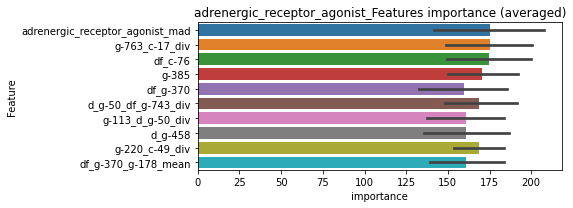

len(train_index) : 2391
len(valid_index) : 798
================================= fold 1/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0997633	valid_1's binary_logloss: 0.180694
[200]	training's binary_logloss: 0.03913	valid_1's binary_logloss: 0.136076
[300]	training's binary_logloss: 0.017158	valid_1's binary_logloss: 0.116064
[400]	training's binary_logloss: 0.00825958	valid_1's binary_logloss: 0.105271
[500]	training's binary_logloss: 0.0045343	valid_1's binary_logloss: 0.101427
Early stopping, best iteration is:
[557]	training's binary_logloss: 0.003433	valid_1's binary_logloss: 0.100248


len(train_index) : 2392
len(valid_index) : 797
================================= fold 2/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101938	valid_1's binary_logloss: 0.169467
[200]	training's binary_logloss: 0.0407639	valid_1's binary_logloss: 0.124073
[300]	training's binary_logloss: 0.0182807	valid_1's binary_logloss: 0.104836
[400]	training's binary_logloss: 0.00903544	valid_1's binary_logloss: 0.0952619
[500]	training's binary_logloss: 0.00486154	valid_1's binary_logloss: 0.0915447
Early stopping, best iteration is:
[503]	training's binary_logloss: 0.00478948	valid_1's binary_logloss: 0.0913479


len(train_index) : 2392
len(valid_index) : 797
================================= fold 3/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103015	valid_1's binary_logloss: 0.18053
[200]	training's binary_logloss: 0.0422344	valid_1's binary_logloss: 0.13672
[300]	training's binary_logloss: 0.0188846	valid_1's binary_logloss: 0.117477
[400]	training's binary_logloss: 0.00924392	valid_1's binary_logloss: 0.108728
[500]	training's binary_logloss: 0.00502457	valid_1's binary_logloss: 0.106324
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00428606	valid_1's binary_logloss: 0.105481


len(train_index) : 2392
len(valid_index) : 797
================================= fold 4/4 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102564	valid_1's binary_logloss: 0.176984
[200]	training's binary_logloss: 0.0420931	valid_1's binary_logloss: 0.128855
[300]	training's binary_logloss: 0.0188585	valid_1's binary_logloss: 0.108287
[400]	training's binary_logloss: 0.0093264	valid_1's binary_logloss: 0.0951516
[500]	training's binary_logloss: 0.00500433	valid_1's binary_logloss: 0.0873239
[600]	training's binary_logloss: 0.00309161	valid_1's binary_logloss: 0.0840094
[700]	training's binary_logloss: 0.00213609	valid_1's binary_logloss: 0.0815523
[800]	training's binary_logloss: 0.00160967	valid_1's binary_logloss: 0.0804673
Early stopping, best iteration is:
[772]	training's binary_logloss: 0.00172753	valid_1's binary_logloss: 0.0803295


adrenergic_receptor_agonist logloss: 0.09435341308798474


neg labels: 3289 → selected neg labels: 3240


adrenergic_receptor_antagonist, len(trt): 360, len(othr): 3240, target_rate: 0.0151172 → Adj_target_rate: 0.0125042
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.251621	valid_1's binary_logloss: 0.366519
[200]	training's binary_logloss: 0.161233	valid_1's binary_logloss: 0.344025
[300]	training's binary_logloss: 0.110772	valid_1's binary_logloss: 0.335593
[400]	training's binary_logloss: 0.0793864	valid_1's binary_logloss: 0.331358
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.076524	valid_1's binary_logloss: 0.330884
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.257533	valid_1's binary_logloss: 0.376471
[200]	training's binary_logloss: 0.162575	valid_1's binary_logloss: 0.350711
[300]	training's binary_logloss: 0.112027	valid_1's binary_logloss: 0.340439
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.113283	valid_1's binary_logloss: 0.33987
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.250906	valid_1's bi

1 / 3 AUC score:0.786
y_Threshold: 0.1546463, Threshold: 0.6206736, pos_neg_ratio: 0.8000000
Remove_noisy_data: 648 → Positive_corect_labels: 389/3240
p_label_rate: 0.0100452 Vs.target_rate: 0.01512, Num_p_label: 40.0, conf_0:0.43447, conf_1:0.80000
Num_p_label: 40.0, Expected: 60.2, Adj_threshold_1: 0.6206736


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0919872	valid_1's binary_logloss: 0.33837


Num_p_label: 48.0, Expected: 60.2, Adj_threshold_2: 0.5906736
threshold: 0.5906736, positive_p_label: 48.0/3982, p_label_rate: 0.0120542
positive_y_label: 389.0/3240, y_label_rate: 0.1200617
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115283	valid_1's binary_logloss: 0.19113
[200]	training's binary_logloss: 0.0455254	valid_1's binary_logloss: 0.146894
[300]	training's binary_logloss: 0.0213632	valid_1's binary_logloss: 0.133263
[400]	training's binary_logloss: 0.0106483	valid_1's binary_logloss: 0.126913
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00768356	valid_1's binary_logloss: 0.12533
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113579	valid_1's binary_logloss: 0.172
[200]	training's binary_logloss: 0.045914	valid_1's binary_logloss: 0.129451
[300]	training's binary_logloss: 0.0215534	valid_1's binary_logloss: 0.114808
[400]	training's binary_logloss: 0.011084	valid_1's binary_logloss: 0.110628
[500]	training's binary_logloss: 0.00620974	valid_1's binary_logloss: 0.110708
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.

2 / 3 AUC score:0.977
y_Threshold: 0.0964808, Threshold: 0.5906736, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00985422	valid_1's binary_logloss: 0.138958


Remove_noisy_data: 124 → Positive_corect_labels: 327.0/3116
p_label_rate: 0.0487192 Vs.target_rate: 0.01512, Num_p_label: 194.0, conf_0:0.47254, conf_1:0.70881
Num_p_label: 194.0, Expected: 60.2, Adj_threshold_1: 0.5906736
Num_p_label: 182.0, Expected: 60.2, Adj_threshold_2: 0.6406736
Num_p_label: 168.0, Expected: 60.2, Adj_threshold_3: 0.6906736
Num_p_label: 152.0, Expected: 60.2, Adj_threshold_4: 0.7406736
Num_p_label: 132.0, Expected: 60.2, Adj_threshold_5: 0.7906736
threshold: 0.7906736, positive_p_label: 132.0/3982, p_label_rate: 0.0331492
positive_y_label: 327.0/3116, y_label_rate: 0.1049422
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845915	valid_1's binary_logloss: 0.157995
[200]	training's binary_logloss: 0.0299032	valid_1's binary_logloss: 0.124385
[300]	training's binary_logloss: 0.012738	valid_1's binary_logloss: 0.115851
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00947243	valid_1's binary_logloss: 0.114079
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828586	valid_1's binary_logloss: 0.14594
[200]	training's binary_logloss: 0.0296078	valid_1's binary_logloss: 0.117944
[300]	training's binary_logloss: 0.0123094	valid_1's binary_logloss: 0.109646
Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00989623	valid_1's binary_logloss: 0.108941
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815306	valid_1's binary_logloss: 0.155387
[200]	training's binary_logloss: 0.0285101	va

3 / 3 AUC score:0.979
y_Threshold: 0.0969407, Threshold: 0.7906736, pos_neg_ratio: 0.8000000
Remove_noisy_data: 78 → Positive_corect_labels: 288.0/3038
p_label_rate: 0.0492215 Vs.target_rate: 0.01512, Num_p_label: 196.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 196.0, Expected: 60.2, Adj_threshold_1: 0.7906736
threshold: 0.7906736, positive_p_label: 196.0/3982, p_label_rate: 0.0492215
positive_y_label: 288.0/3038, y_label_rate: 0.0947992


len(train_index) : 2278
len(valid_index) : 760
================================= fold 1/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0663848	valid_1's binary_logloss: 0.10725
[200]	training's binary_logloss: 0.0209895	valid_1's binary_logloss: 0.0688642
[300]	training's binary_logloss: 0.00831291	valid_1's binary_logloss: 0.0550028
[400]	training's binary_logloss: 0.00403855	valid_1's binary_logloss: 0.0501757
[500]	training's binary_logloss: 0.00230206	valid_1's binary_logloss: 0.0472057
[600]	training's binary_logloss: 0.00151803	valid_1's binary_logloss: 0.0460918
Early stopping, best iteration is:
[591]	training's binary_logloss: 0.00156657	valid_1's binary_logloss: 0.0460106


len(train_index) : 2278
len(valid_index) : 760
================================= fold 2/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0685315	valid_1's binary_logloss: 0.116585
[200]	training's binary_logloss: 0.0220507	valid_1's binary_logloss: 0.0779051
[300]	training's binary_logloss: 0.00875575	valid_1's binary_logloss: 0.0636898
[400]	training's binary_logloss: 0.00402561	valid_1's binary_logloss: 0.0568732
[500]	training's binary_logloss: 0.00226928	valid_1's binary_logloss: 0.0535798
[600]	training's binary_logloss: 0.00149142	valid_1's binary_logloss: 0.053026
[700]	training's binary_logloss: 0.00110123	valid_1's binary_logloss: 0.0518703
Early stopping, best iteration is:
[679]	training's binary_logloss: 0.00116279	valid_1's binary_logloss: 0.0517578


len(train_index) : 2279
len(valid_index) : 759
================================= fold 3/4 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0657016	valid_1's binary_logloss: 0.122231
[200]	training's binary_logloss: 0.0207094	valid_1's binary_logloss: 0.0904757
[300]	training's binary_logloss: 0.00804139	valid_1's binary_logloss: 0.0812857


len(train_index) : 2279
len(valid_index) : 759
================================= fold 4/4 adrenergic_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00380456	valid_1's binary_logloss: 0.0804939
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00451276	valid_1's binary_logloss: 0.0799685
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0663415	valid_1's binary_logloss: 0.107595
[200]	training's binary_logloss: 0.021571	valid_1's binary_logloss: 0.0722935
[300]	training's binary_logloss: 0.00862341	valid_1's binary_logloss: 0.0607275
[400]	training's binary_logloss: 0.00413699	valid_1's binary_logloss: 0.0563424
[500]	training's binary_logloss: 0.00235257	valid_1's binary_logloss: 0.0539903
[600]	training's binary_logloss: 0.00153589	valid_1's binary_logloss: 0.0529266
[700]	training's binary_logloss: 0.00113055	valid_1's binary_logloss: 0.0521255
[800]	training's binary_logloss: 0.000896217	valid_1's binary_logloss: 0.0517158
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000915779	valid_1's binary_logloss: 0

adrenergic_receptor_antagonist logloss: 0.05731842118266107


neg labels: 3289 → selected neg labels: 3284


akt_inhibitor, len(trt): 66, len(othr): 3284, target_rate: 0.0027715 → Adj_target_rate: 0.0029567
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131339	valid_1's binary_logloss: 0.216964
[200]	training's binary_logloss: 0.0568187	valid_1's binary_logloss: 0.141603
[300]	training's binary_logloss: 0.0272019	valid_1's binary_logloss: 0.107905
[400]	training's binary_logloss: 0.0138642	valid_1's binary_logloss: 0.0873412
[500]	training's binary_logloss: 0.00737402	valid_1's binary_logloss: 0.0753317
[600]	training's binary_logloss: 0.00425694	valid_1's binary_logloss: 0.0686983
[700]	training's binary_logloss: 0.00271797	valid_1's binary_logloss: 0.065571
Early stopping, best iteration is:
[742]	training's binary_logloss: 0.00233399	valid_1's binary_logloss: 0.0644631
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128468	valid_1's binary_logloss: 0.192498
[200]	training's binary_logloss: 0.053426	valid_1's binary_logloss: 0.121897
[300]	training's binary_logloss: 0.0256244	valid_1's binar

1 / 3 AUC score:0.996
y_Threshold: 0.0260963, Threshold: 0.1614492, pos_neg_ratio: 0.8000000
Remove_noisy_data: 156 → Positive_corect_labels: 644/3784
p_label_rate: 0.0100452 Vs.target_rate: 0.00277, Num_p_label: 40.0, conf_0:0.11301, conf_1:0.20988
Num_p_label: 40.0, Expected: 11.0, Adj_threshold_1: 0.1614492
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_2: 0.2114492
Num_p_label: 20.0, Expected: 11.0, Adj_threshold_3: 0.2614492
Num_p_label: 15.0, Expected: 11.0, Adj_threshold_4: 0.3114492
threshold: 0.3114492, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 644.0/3784, y_label_rate: 0.1701903
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126634	valid_1's binary_logloss: 0.174845
[200]	training's binary_logloss: 0.0500921	valid_1's binary_logloss: 0.100104
[300]	training's binary_logloss: 0.0222907	valid_1's binary_logloss: 0.0649309
[400]	training's binary_logloss: 0.0106765	valid_1's binary_logloss: 0.0461762
[500]	training's binary_logloss: 0.00563822	valid_1's binary_logloss: 0.0369004
[600]	training's binary_logloss: 0.00333619	valid_1's binary_logloss: 0.0312441
[700]	training's binary_logloss: 0.00222571	valid_1's binary_logloss: 0.0277699
[800]	training's binary_logloss: 0.00163708	valid_1's binary_logloss: 0.0255313
[900]	training's binary_logloss: 0.00129147	valid_1's binary_logloss: 0.0240573
[1000]	training's binary_logloss: 0.00107381	valid_1's binary_logloss: 0.0228128
Early stopping, best iteration is:
[998]	training's binary_logloss: 0.00107723	valid_1's binary_logloss: 0.0227801
Training until validation scor

2 / 3 AUC score:0.999
y_Threshold: 0.0806098, Threshold: 0.3114492, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 634.0/3764
p_label_rate: 0.0128076 Vs.target_rate: 0.00277, Num_p_label: 51.0, conf_0:0.24916, conf_1:0.37374
Num_p_label: 51.0, Expected: 11.0, Adj_threshold_1: 0.3114492
Num_p_label: 43.0, Expected: 11.0, Adj_threshold_2: 0.3614492
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_3: 0.4114492
Num_p_label: 30.0, Expected: 11.0, Adj_threshold_4: 0.4614492
Num_p_label: 25.0, Expected: 11.0, Adj_threshold_5: 0.5114492
Num_p_label: 23.0, Expected: 11.0, Adj_threshold_6: 0.5614492
Num_p_label: 19.0, Expected: 11.0, Adj_threshold_7: 0.6114492
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_8: 0.6614492
threshold: 0.6614492, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 634.0/3764, y_label_rate: 0.1684378
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122876	valid_1's binary_logloss: 0.173777
[200]	training's binary_logloss: 0.0473688	valid_1's binary_logloss: 0.0977637
[300]	training's binary_logloss: 0.0208174	valid_1's binary_logloss: 0.064166
[400]	training's binary_logloss: 0.00971027	valid_1's binary_logloss: 0.047892
[500]	training's binary_logloss: 0.00506134	valid_1's binary_logloss: 0.0385178
[600]	training's binary_logloss: 0.003002	valid_1's binary_logloss: 0.0334452
[700]	training's binary_logloss: 0.00202622	valid_1's binary_logloss: 0.0307308
[800]	training's binary_logloss: 0.00149887	valid_1's binary_logloss: 0.0292034
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.0013277	valid_1's binary_logloss: 0.0286985
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120387	valid_1's binary_logloss: 0.176474
[200]	training's binary_logloss: 0.0455326	valid_1's bin

3 / 3 AUC score:1.000
y_Threshold: 0.0773676, Threshold: 0.6614492, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 625.0/3746
p_label_rate: 0.0042692 Vs.target_rate: 0.00277, Num_p_label: 17.0, conf_0:0.50000, conf_1:0.72759
Num_p_label: 17.0, Expected: 11.0, Adj_threshold_1: 0.6614492
Num_p_label: 17.0, Expected: 11.0, Adj_threshold_2: 0.7114492
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_3: 0.7614492
threshold: 0.7614492, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 625.0/3746, y_label_rate: 0.1668446


len(train_index) : 2809
len(valid_index) : 937
================================= fold 1/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117336	valid_1's binary_logloss: 0.176773
[200]	training's binary_logloss: 0.0444675	valid_1's binary_logloss: 0.100835
[300]	training's binary_logloss: 0.0195027	valid_1's binary_logloss: 0.0698623
[400]	training's binary_logloss: 0.00910149	valid_1's binary_logloss: 0.0529982
[500]	training's binary_logloss: 0.00476406	valid_1's binary_logloss: 0.0442957
[600]	training's binary_logloss: 0.00283008	valid_1's binary_logloss: 0.0397347
[700]	training's binary_logloss: 0.00191221	valid_1's binary_logloss: 0.0376687
[800]	training's binary_logloss: 0.00142071	valid_1's binary_logloss: 0.0369784
[900]	training's binary_logloss: 0.00113506	valid_1's binary_logloss: 0.0360395
Early stopping, best iteration is:
[899]	training's binary_logloss: 0.00113721	valid_1's binary_logloss: 0.0360356


len(train_index) : 2809
len(valid_index) : 937
================================= fold 2/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118552	valid_1's binary_logloss: 0.17612
[200]	training's binary_logloss: 0.0455597	valid_1's binary_logloss: 0.103445
[300]	training's binary_logloss: 0.0199346	valid_1's binary_logloss: 0.0713731
[400]	training's binary_logloss: 0.00919628	valid_1's binary_logloss: 0.0536132
[500]	training's binary_logloss: 0.00475663	valid_1's binary_logloss: 0.0436514
[600]	training's binary_logloss: 0.00282086	valid_1's binary_logloss: 0.0378328
[700]	training's binary_logloss: 0.00191446	valid_1's binary_logloss: 0.0346433
[800]	training's binary_logloss: 0.00141868	valid_1's binary_logloss: 0.0324925
[900]	training's binary_logloss: 0.00113152	valid_1's binary_logloss: 0.03123
[1000]	training's binary_logloss: 0.000959715	valid_1's binary_logloss: 0.0306249
[1100]	training's binary_logloss: 0.000849672	valid_1's binary_logloss: 0.0302202
Early stopping, best iteration is:
[1090]	training's binary_logl

len(train_index) : 2810
len(valid_index) : 936
================================= fold 3/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119772	valid_1's binary_logloss: 0.170017
[200]	training's binary_logloss: 0.044936	valid_1's binary_logloss: 0.0940748
[300]	training's binary_logloss: 0.0192566	valid_1's binary_logloss: 0.0620226
[400]	training's binary_logloss: 0.00896973	valid_1's binary_logloss: 0.0453268
[500]	training's binary_logloss: 0.00464825	valid_1's binary_logloss: 0.0370182
[600]	training's binary_logloss: 0.00278948	valid_1's binary_logloss: 0.0326772
[700]	training's binary_logloss: 0.00190032	valid_1's binary_logloss: 0.0299039
[800]	training's binary_logloss: 0.00140771	valid_1's binary_logloss: 0.0282457
[900]	training's binary_logloss: 0.00112371	valid_1's binary_logloss: 0.0270318
[1000]	training's binary_logloss: 0.000953339	valid_1's binary_logloss: 0.0267415
Early stopping, best iteration is:
[989]	training's binary_logloss: 0.000966603	valid_1's binary_logloss: 0.0266916


len(train_index) : 2810
len(valid_index) : 936
================================= fold 4/4 akt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116898	valid_1's binary_logloss: 0.170468
[200]	training's binary_logloss: 0.0439485	valid_1's binary_logloss: 0.0967546
[300]	training's binary_logloss: 0.0189724	valid_1's binary_logloss: 0.0668022
[400]	training's binary_logloss: 0.0088562	valid_1's binary_logloss: 0.051907
[500]	training's binary_logloss: 0.00463059	valid_1's binary_logloss: 0.0442419
[600]	training's binary_logloss: 0.00275917	valid_1's binary_logloss: 0.0409463
[700]	training's binary_logloss: 0.00186092	valid_1's binary_logloss: 0.0384739
[800]	training's binary_logloss: 0.00139432	valid_1's binary_logloss: 0.0375747
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.00145556	valid_1's binary_logloss: 0.037454


akt_inhibitor logloss: 0.03256769468664084


neg labels: 3289 → selected neg labels: 3288


aldehyde_dehydrogenase_inhibitor, len(trt): 19, len(othr): 3288, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0764596	valid_1's binary_logloss: 0.10208
[200]	training's binary_logloss: 0.0229872	valid_1's binary_logloss: 0.0413524
[300]	training's binary_logloss: 0.00752291	valid_1's binary_logloss: 0.0212705
[400]	training's binary_logloss: 0.00296391	valid_1's binary_logloss: 0.0144666
[500]	training's binary_logloss: 0.00151153	valid_1's binary_logloss: 0.0115054
[600]	training's binary_logloss: 0.000955873	valid_1's binary_logloss: 0.0103219
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.000835101	valid_1's binary_logloss: 0.00986152
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0788869	valid_1's binary_logloss: 0.102054
[200]	training's binary_logloss: 0.0238293	valid_1's binary_logloss: 0.042313
[300]	training's binary_logloss: 0.00791941	valid_1's binary_logloss: 0.0222091
[400]	training's binary_logloss: 0.00309886	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0078608, Threshold: 0.0476814, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.03338, conf_1:0.06199
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0476814
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.0976814
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_3: 0.1476814
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_4: 0.1976814
threshold: 0.1976814, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720418	valid_1's binary_logloss: 0.101236
[200]	training's binary_logloss: 0.0184319	valid_1's binary_logloss: 0.038437
[300]	training's binary_logloss: 0.00584299	valid_1's binary_logloss: 0.0189216
[400]	training's binary_logloss: 0.00234871	valid_1's binary_logloss: 0.0125536
[500]	training's binary_logloss: 0.0012456	valid_1's binary_logloss: 0.0103285
[600]	training's binary_logloss: 0.000801727	valid_1's binary_logloss: 0.00903164
[700]	training's binary_logloss: 0.000591968	valid_1's binary_logloss: 0.00851124
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.000632938	valid_1's binary_logloss: 0.00841217
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0744645	valid_1's binary_logloss: 0.0953724
[200]	training's binary_logloss: 0.0195149	valid_1's binary_logloss: 0.0349305
[300]	training's binary_logloss: 0.00618945	

2 / 3 AUC score:1.000
y_Threshold: 0.1147720, Threshold: 0.1976814, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0085384 Vs.target_rate: 0.00080, Num_p_label: 34.0, conf_0:0.15815, conf_1:0.23722
Num_p_label: 34.0, Expected: 3.2, Adj_threshold_1: 0.1976814
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_2: 0.2476814
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_3: 0.2976814
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.3476814
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.3976814
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.4476814
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_7: 0.4976814
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_8: 0.5476814
threshold: 0.5476814, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720418	valid_1's binary_logloss: 0.101236
[200]	training's binary_logloss: 0.0184319	valid_1's binary_logloss: 0.038437
[300]	training's binary_logloss: 0.00584299	valid_1's binary_logloss: 0.0189216
[400]	training's binary_logloss: 0.00234871	valid_1's binary_logloss: 0.0125536
[500]	training's binary_logloss: 0.0012456	valid_1's binary_logloss: 0.0103285
[600]	training's binary_logloss: 0.000801727	valid_1's binary_logloss: 0.00903164
[700]	training's binary_logloss: 0.000591968	valid_1's binary_logloss: 0.00851124
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.000632938	valid_1's binary_logloss: 0.00841217
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0744645	valid_1's binary_logloss: 0.0953724
[200]	training's binary_logloss: 0.0195149	valid_1's binary_logloss: 0.0349305
[300]	training's binary_logloss: 0.00618945	

3 / 3 AUC score:1.000
y_Threshold: 0.1147720, Threshold: 0.5476814, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.49291, conf_1:0.60245
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_1: 0.5476814
threshold: 0.5476814, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


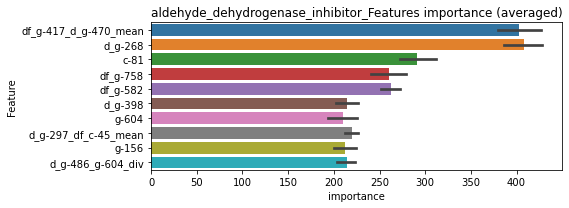

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0740272	valid_1's binary_logloss: 0.102173
[200]	training's binary_logloss: 0.0194475	valid_1's binary_logloss: 0.0391914
[300]	training's binary_logloss: 0.00674885	valid_1's binary_logloss: 0.0222268
[400]	training's binary_logloss: 0.00317414	valid_1's binary_logloss: 0.0165773
[500]	training's binary_logloss: 0.0014185	valid_1's binary_logloss: 0.010921
[600]	training's binary_logloss: 0.000846759	valid_1's binary_logloss: 0.00883436
[700]	training's binary_logloss: 0.000601193	valid_1's binary_logloss: 0.00728639
[800]	training's binary_logloss: 0.000482031	valid_1's binary_logloss: 0.00686054
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.000498293	valid_1's binary_logloss: 0.00680095


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748778	valid_1's binary_logloss: 0.0986475
[200]	training's binary_logloss: 0.0196111	valid_1's binary_logloss: 0.036849
[300]	training's binary_logloss: 0.00621403	valid_1's binary_logloss: 0.0182777
[400]	training's binary_logloss: 0.00249094	valid_1's binary_logloss: 0.0112774
[500]	training's binary_logloss: 0.0012955	valid_1's binary_logloss: 0.00845107
[600]	training's binary_logloss: 0.000830194	valid_1's binary_logloss: 0.00703491
[700]	training's binary_logloss: 0.000606538	valid_1's binary_logloss: 0.00623434
[800]	training's binary_logloss: 0.000493653	valid_1's binary_logloss: 0.00598578
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000476311	valid_1's binary_logloss: 0.00590487


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0755412	valid_1's binary_logloss: 0.090389
[200]	training's binary_logloss: 0.0199489	valid_1's binary_logloss: 0.0284981
[300]	training's binary_logloss: 0.00641041	valid_1's binary_logloss: 0.0114204
[400]	training's binary_logloss: 0.00252487	valid_1's binary_logloss: 0.00549404
[500]	training's binary_logloss: 0.00130784	valid_1's binary_logloss: 0.00338142
[600]	training's binary_logloss: 0.000830078	valid_1's binary_logloss: 0.00242472
[700]	training's binary_logloss: 0.00061036	valid_1's binary_logloss: 0.00192533
[800]	training's binary_logloss: 0.000498184	valid_1's binary_logloss: 0.0016561
[900]	training's binary_logloss: 0.000461224	valid_1's binary_logloss: 0.00155405
Early stopping, best iteration is:
[881]	training's binary_logloss: 0.000461224	valid_1's binary_logloss: 0.00155405


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0767011	valid_1's binary_logloss: 0.0899432
[200]	training's binary_logloss: 0.0200117	valid_1's binary_logloss: 0.0289241
[300]	training's binary_logloss: 0.0063655	valid_1's binary_logloss: 0.0117572
[400]	training's binary_logloss: 0.0025114	valid_1's binary_logloss: 0.00610786
[500]	training's binary_logloss: 0.00130899	valid_1's binary_logloss: 0.00412932
[600]	training's binary_logloss: 0.000841207	valid_1's binary_logloss: 0.0031874
[700]	training's binary_logloss: 0.000616645	valid_1's binary_logloss: 0.00264286
[800]	training's binary_logloss: 0.000503413	valid_1's binary_logloss: 0.00241324
[900]	training's binary_logloss: 0.000460523	valid_1's binary_logloss: 0.00229401
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000460523	valid_1's binary_logloss: 0.00229401


aldehyde_dehydrogenase_inhibitor logloss: 0.004139169445770551


neg labels: 3289 → selected neg labels: 3285


alk_inhibitor, len(trt): 42, len(othr): 3285, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116046	valid_1's binary_logloss: 0.161853
[200]	training's binary_logloss: 0.0476398	valid_1's binary_logloss: 0.0945009
[300]	training's binary_logloss: 0.021402	valid_1's binary_logloss: 0.0639355
[400]	training's binary_logloss: 0.00985812	valid_1's binary_logloss: 0.0487559
[500]	training's binary_logloss: 0.00506317	valid_1's binary_logloss: 0.0406512
[600]	training's binary_logloss: 0.00293815	valid_1's binary_logloss: 0.0360123
[700]	training's binary_logloss: 0.00192952	valid_1's binary_logloss: 0.0337926
[800]	training's binary_logloss: 0.00142468	valid_1's binary_logloss: 0.0324589
[900]	training's binary_logloss: 0.00113166	valid_1's binary_logloss: 0.032354
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.00117404	valid_1's binary_logloss: 0.0321938
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113783	valid_1'

1 / 3 AUC score:0.999
y_Threshold: 0.0170456, Threshold: 0.0691677, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 653/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.04842, conf_1:0.08992
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.0691677
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_2: 0.1191677
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_3: 0.1691677
threshold: 0.1691677, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113676	valid_1's binary_logloss: 0.165669
[200]	training's binary_logloss: 0.0416505	valid_1's binary_logloss: 0.0962905
[300]	training's binary_logloss: 0.0170792	valid_1's binary_logloss: 0.0677692
[400]	training's binary_logloss: 0.00773252	valid_1's binary_logloss: 0.0547331
[500]	training's binary_logloss: 0.00395991	valid_1's binary_logloss: 0.0479777
[600]	training's binary_logloss: 0.00237678	valid_1's binary_logloss: 0.0442527
[700]	training's binary_logloss: 0.00161502	valid_1's binary_logloss: 0.0423906
[800]	training's binary_logloss: 0.00121546	valid_1's binary_logloss: 0.0409702
Early stopping, best iteration is:
[808]	training's binary_logloss: 0.00119235	valid_1's binary_logloss: 0.0407764
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110742	valid_1's binary_logloss: 0.158752
[200]	training's binary_logloss: 0.04023	valid_1's 

2 / 3 AUC score:1.000
y_Threshold: 0.0604301, Threshold: 0.1691677, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0128076 Vs.target_rate: 0.00176, Num_p_label: 51.0, conf_0:0.13533, conf_1:0.20300
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_1: 0.1691677
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_2: 0.2191677
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_3: 0.2691677
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_4: 0.3191677
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_5: 0.3691677
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_6: 0.4191677
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_7: 0.4691677
threshold: 0.4691677, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 646.0/3788, y_label_rate: 0.1705385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109862	valid_1's binary_logloss: 0.140833
[200]	training's binary_logloss: 0.0404701	valid_1's binary_logloss: 0.0717654
[300]	training's binary_logloss: 0.0170781	valid_1's binary_logloss: 0.0441588
[400]	training's binary_logloss: 0.00791861	valid_1's binary_logloss: 0.0318368
[500]	training's binary_logloss: 0.0040223	valid_1's binary_logloss: 0.0252647
[600]	training's binary_logloss: 0.00237333	valid_1's binary_logloss: 0.0211889
[700]	training's binary_logloss: 0.00160398	valid_1's binary_logloss: 0.0189861
[800]	training's binary_logloss: 0.00120322	valid_1's binary_logloss: 0.0177234
[900]	training's binary_logloss: 0.000972561	valid_1's binary_logloss: 0.0170734
[1000]	training's binary_logloss: 0.000844054	valid_1's binary_logloss: 0.0169093
[1100]	training's binary_logloss: 0.000778503	valid_1's binary_logloss: 0.0167114
Early stopping, best iteration is:
[1071]	training's binary_

3 / 3 AUC score:0.999
y_Threshold: 0.0542220, Threshold: 0.4691677, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 639.0/3774
p_label_rate: 0.0042692 Vs.target_rate: 0.00176, Num_p_label: 17.0, conf_0:0.42225, conf_1:0.51608
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_1: 0.4691677
threshold: 0.4691677, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 639.0/3774, y_label_rate: 0.1693164


len(train_index) : 2830
len(valid_index) : 944
================================= fold 1/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106416	valid_1's binary_logloss: 0.14824
[200]	training's binary_logloss: 0.0372307	valid_1's binary_logloss: 0.0758693
[300]	training's binary_logloss: 0.0150883	valid_1's binary_logloss: 0.0494405
[400]	training's binary_logloss: 0.00678785	valid_1's binary_logloss: 0.0374158
[500]	training's binary_logloss: 0.00349975	valid_1's binary_logloss: 0.0309911
[600]	training's binary_logloss: 0.00212577	valid_1's binary_logloss: 0.0274292
[700]	training's binary_logloss: 0.00146574	valid_1's binary_logloss: 0.0257804
[800]	training's binary_logloss: 0.00112108	valid_1's binary_logloss: 0.0248195
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00097883	valid_1's binary_logloss: 0.0241565


len(train_index) : 2830
len(valid_index) : 944
================================= fold 2/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105323	valid_1's binary_logloss: 0.15184
[200]	training's binary_logloss: 0.037546	valid_1's binary_logloss: 0.0784432
[300]	training's binary_logloss: 0.0152977	valid_1's binary_logloss: 0.048508
[400]	training's binary_logloss: 0.0068597	valid_1's binary_logloss: 0.0335404
[500]	training's binary_logloss: 0.00352857	valid_1's binary_logloss: 0.0262808
[600]	training's binary_logloss: 0.00214318	valid_1's binary_logloss: 0.0223983
[700]	training's binary_logloss: 0.00147871	valid_1's binary_logloss: 0.0203515
[800]	training's binary_logloss: 0.00111865	valid_1's binary_logloss: 0.0191216
[900]	training's binary_logloss: 0.000913063	valid_1's binary_logloss: 0.0180408
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000853476	valid_1's binary_logloss: 0.0178868


len(train_index) : 2831
len(valid_index) : 943
================================= fold 3/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105163	valid_1's binary_logloss: 0.141555
[200]	training's binary_logloss: 0.037002	valid_1's binary_logloss: 0.0700341
[300]	training's binary_logloss: 0.0149935	valid_1's binary_logloss: 0.0415093
[400]	training's binary_logloss: 0.00688138	valid_1's binary_logloss: 0.0296283
[500]	training's binary_logloss: 0.00357711	valid_1's binary_logloss: 0.0232332
[600]	training's binary_logloss: 0.0021618	valid_1's binary_logloss: 0.0195859
[700]	training's binary_logloss: 0.00147708	valid_1's binary_logloss: 0.0180489
[800]	training's binary_logloss: 0.00111748	valid_1's binary_logloss: 0.0169136
[900]	training's binary_logloss: 0.000907649	valid_1's binary_logloss: 0.016206
[1000]	training's binary_logloss: 0.000784353	valid_1's binary_logloss: 0.0158112
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.000744109	valid_1's binary_logloss: 0.01568


len(train_index) : 2831
len(valid_index) : 943
================================= fold 4/4 alk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103764	valid_1's binary_logloss: 0.153389
[200]	training's binary_logloss: 0.0370597	valid_1's binary_logloss: 0.0854231
[300]	training's binary_logloss: 0.0146115	valid_1's binary_logloss: 0.0556717
[400]	training's binary_logloss: 0.00641245	valid_1's binary_logloss: 0.0417821
[500]	training's binary_logloss: 0.00331973	valid_1's binary_logloss: 0.0352242
[600]	training's binary_logloss: 0.00201592	valid_1's binary_logloss: 0.0315917
[700]	training's binary_logloss: 0.00139591	valid_1's binary_logloss: 0.0299555
[800]	training's binary_logloss: 0.00106538	valid_1's binary_logloss: 0.0291201
Early stopping, best iteration is:
[837]	training's binary_logloss: 0.000983109	valid_1's binary_logloss: 0.028742


alk_inhibitor logloss: 0.02161598756506605


neg labels: 3289 → selected neg labels: 3289


ampk_activator, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0603444	valid_1's binary_logloss: 0.0685021
[200]	training's binary_logloss: 0.0139458	valid_1's binary_logloss: 0.0207537
[300]	training's binary_logloss: 0.00390276	valid_1's binary_logloss: 0.00895379
[400]	training's binary_logloss: 0.0015051	valid_1's binary_logloss: 0.00576101
[500]	training's binary_logloss: 0.000802807	valid_1's binary_logloss: 0.00438563
[600]	training's binary_logloss: 0.000533856	valid_1's binary_logloss: 0.00378506
[700]	training's binary_logloss: 0.000406079	valid_1's binary_logloss: 0.00351658
[800]	training's binary_logloss: 0.000352086	valid_1's binary_logloss: 0.00337723
[900]	training's binary_logloss: 0.000333918	valid_1's binary_logloss: 0.00330362
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.000334358	valid_1's binary_logloss: 0.00330307
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0026497, Threshold: 0.0183473, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01284, conf_1:0.02385
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0183473
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0683473
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.1183473
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.1683473
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.2183473
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_6: 0.2683473
threshold: 0.2683473, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0577046	valid_1's binary_logloss: 0.0646083
[200]	training's binary_logloss: 0.0119441	valid_1's binary_logloss: 0.0160066
[300]	training's binary_logloss: 0.00320944	valid_1's binary_logloss: 0.00574742
[400]	training's binary_logloss: 0.00124054	valid_1's binary_logloss: 0.0030004
[500]	training's binary_logloss: 0.00067344	valid_1's binary_logloss: 0.0020605
[600]	training's binary_logloss: 0.000452247	valid_1's binary_logloss: 0.00164237
[700]	training's binary_logloss: 0.000350138	valid_1's binary_logloss: 0.00142209
[800]	training's binary_logloss: 0.000306457	valid_1's binary_logloss: 0.00134332
[900]	training's binary_logloss: 0.000293663	valid_1's binary_logloss: 0.00132257
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.0002919	valid_1's binary_logloss: 0.00131482
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0751094, Threshold: 0.2683473, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0035158 Vs.target_rate: 0.00050, Num_p_label: 14.0, conf_0:0.21468, conf_1:0.32202
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_1: 0.2683473
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.3183473
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_3: 0.3683473
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.4183473
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.4683473
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.5183473
threshold: 0.5183473, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0577046	valid_1's binary_logloss: 0.0646083
[200]	training's binary_logloss: 0.0119441	valid_1's binary_logloss: 0.0160066
[300]	training's binary_logloss: 0.00320944	valid_1's binary_logloss: 0.00574742
[400]	training's binary_logloss: 0.00124054	valid_1's binary_logloss: 0.0030004
[500]	training's binary_logloss: 0.00067344	valid_1's binary_logloss: 0.0020605
[600]	training's binary_logloss: 0.000452247	valid_1's binary_logloss: 0.00164237
[700]	training's binary_logloss: 0.000350138	valid_1's binary_logloss: 0.00142209
[800]	training's binary_logloss: 0.000306457	valid_1's binary_logloss: 0.00134332
[900]	training's binary_logloss: 0.000293663	valid_1's binary_logloss: 0.00132257
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.0002919	valid_1's binary_logloss: 0.00131482
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0751094, Threshold: 0.5183473, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.46651, conf_1:0.57018
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.5183473
threshold: 0.5183473, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


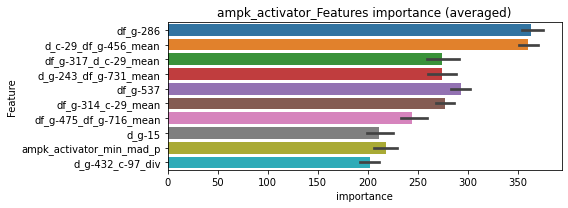

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0573861	valid_1's binary_logloss: 0.0645125
[200]	training's binary_logloss: 0.0117234	valid_1's binary_logloss: 0.0158822
[300]	training's binary_logloss: 0.00311105	valid_1's binary_logloss: 0.00552171
[400]	training's binary_logloss: 0.00121181	valid_1's binary_logloss: 0.00285745
[500]	training's binary_logloss: 0.000662077	valid_1's binary_logloss: 0.0019331
[600]	training's binary_logloss: 0.000449077	valid_1's binary_logloss: 0.00151648
[700]	training's binary_logloss: 0.000346827	valid_1's binary_logloss: 0.00130693
[800]	training's binary_logloss: 0.000301734	valid_1's binary_logloss: 0.00121716
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000299314	valid_1's binary_logloss: 0.00121029


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0570568	valid_1's binary_logloss: 0.0690572
[200]	training's binary_logloss: 0.0116318	valid_1's binary_logloss: 0.0190074
[300]	training's binary_logloss: 0.00312283	valid_1's binary_logloss: 0.00789691
[400]	training's binary_logloss: 0.00120448	valid_1's binary_logloss: 0.00456863
[500]	training's binary_logloss: 0.000660603	valid_1's binary_logloss: 0.00332344
[600]	training's binary_logloss: 0.000449302	valid_1's binary_logloss: 0.00287701
[700]	training's binary_logloss: 0.000350227	valid_1's binary_logloss: 0.00258051
[800]	training's binary_logloss: 0.000306102	valid_1's binary_logloss: 0.00250073
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000302707	valid_1's binary_logloss: 0.00248658


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0578202	valid_1's binary_logloss: 0.0642984
[200]	training's binary_logloss: 0.011838	valid_1's binary_logloss: 0.0146057
[300]	training's binary_logloss: 0.00315796	valid_1's binary_logloss: 0.00445408
[400]	training's binary_logloss: 0.00122063	valid_1's binary_logloss: 0.00192964
[500]	training's binary_logloss: 0.000665021	valid_1's binary_logloss: 0.00114413
[600]	training's binary_logloss: 0.000452423	valid_1's binary_logloss: 0.000818674
[700]	training's binary_logloss: 0.00035062	valid_1's binary_logloss: 0.000662554
[800]	training's binary_logloss: 0.000306051	valid_1's binary_logloss: 0.000589453
[900]	training's binary_logloss: 0.000301879	valid_1's binary_logloss: 0.000581179
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000301879	valid_1's binary_logloss: 0.000581179


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 ampk_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0578781	valid_1's binary_logloss: 0.065556
[200]	training's binary_logloss: 0.0118412	valid_1's binary_logloss: 0.0163089
[300]	training's binary_logloss: 0.0031456	valid_1's binary_logloss: 0.00572673
[400]	training's binary_logloss: 0.00122198	valid_1's binary_logloss: 0.00292678
[500]	training's binary_logloss: 0.000667311	valid_1's binary_logloss: 0.00200327
[600]	training's binary_logloss: 0.000451821	valid_1's binary_logloss: 0.00157326
[700]	training's binary_logloss: 0.000353505	valid_1's binary_logloss: 0.00139037
[800]	training's binary_logloss: 0.00030528	valid_1's binary_logloss: 0.00128895
[900]	training's binary_logloss: 0.0002941	valid_1's binary_logloss: 0.00126101
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.0002941	valid_1's binary_logloss: 0.00126101


ampk_activator logloss: 0.001384718495727043


neg labels: 3289 → selected neg labels: 3288


analgesic, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0651034	valid_1's binary_logloss: 0.077425
[200]	training's binary_logloss: 0.0152752	valid_1's binary_logloss: 0.0226931
[300]	training's binary_logloss: 0.00435967	valid_1's binary_logloss: 0.0085449
[400]	training's binary_logloss: 0.00170335	valid_1's binary_logloss: 0.00442097
[500]	training's binary_logloss: 0.000912294	valid_1's binary_logloss: 0.0029709
[600]	training's binary_logloss: 0.000609738	valid_1's binary_logloss: 0.00232347
[700]	training's binary_logloss: 0.000467446	valid_1's binary_logloss: 0.00196627
[800]	training's binary_logloss: 0.000394286	valid_1's binary_logloss: 0.0018119
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.000374938	valid_1's binary_logloss: 0.00176452
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0652749	valid_1's binary_logloss: 0.0745528
[200]	training's binary_logloss: 0.015

1 / 3 AUC score:1.000
y_Threshold: 0.0029314, Threshold: 0.0388800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.02722, conf_1:0.05054
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0388800
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.0888800
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_3: 0.1388800
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_4: 0.1888800
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_5: 0.2388800
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.2888800
threshold: 0.2888800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0619617	valid_1's binary_logloss: 0.0738045
[200]	training's binary_logloss: 0.0135868	valid_1's binary_logloss: 0.0209393
[300]	training's binary_logloss: 0.00367114	valid_1's binary_logloss: 0.00766785
[400]	training's binary_logloss: 0.00143321	valid_1's binary_logloss: 0.0038956
[500]	training's binary_logloss: 0.000782456	valid_1's binary_logloss: 0.00272939
[600]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00222097
[700]	training's binary_logloss: 0.000403456	valid_1's binary_logloss: 0.00196804
[800]	training's binary_logloss: 0.00034606	valid_1's binary_logloss: 0.00182624
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.000339296	valid_1's binary_logloss: 0.00181183
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0630422	valid_1's binary_logloss: 0.0738644
[200]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1399559, Threshold: 0.2888800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0057760 Vs.target_rate: 0.00050, Num_p_label: 23.0, conf_0:0.23110, conf_1:0.34666
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_1: 0.2888800
Num_p_label: 18.0, Expected: 2.0, Adj_threshold_2: 0.3388800
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.3888800
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_4: 0.4388800
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.4888800
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_6: 0.5388800
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.5888800
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_8: 0.6388800
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_9: 0.6888800
threshold: 0.6888800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0619617	valid_1's binary_logloss: 0.0738045
[200]	training's binary_logloss: 0.0135868	valid_1's binary_logloss: 0.0209393
[300]	training's binary_logloss: 0.00367114	valid_1's binary_logloss: 0.00766785
[400]	training's binary_logloss: 0.00143321	valid_1's binary_logloss: 0.0038956
[500]	training's binary_logloss: 0.000782456	valid_1's binary_logloss: 0.00272939
[600]	training's binary_logloss: 0.000525829	valid_1's binary_logloss: 0.00222097
[700]	training's binary_logloss: 0.000403456	valid_1's binary_logloss: 0.00196804
[800]	training's binary_logloss: 0.00034606	valid_1's binary_logloss: 0.00182624
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.000339296	valid_1's binary_logloss: 0.00181183
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0630422	valid_1's binary_logloss: 0.0738644
[200]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1399559, Threshold: 0.6888800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.50000, conf_1:0.75777
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.6888800
threshold: 0.6888800, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.062643	valid_1's binary_logloss: 0.0748286
[200]	training's binary_logloss: 0.01375	valid_1's binary_logloss: 0.0212156
[300]	training's binary_logloss: 0.00371377	valid_1's binary_logloss: 0.00793712
[400]	training's binary_logloss: 0.00144089	valid_1's binary_logloss: 0.00418143
[500]	training's binary_logloss: 0.000773364	valid_1's binary_logloss: 0.00281704
[600]	training's binary_logloss: 0.000520708	valid_1's binary_logloss: 0.00230832
[700]	training's binary_logloss: 0.000398923	valid_1's binary_logloss: 0.00202449
[800]	training's binary_logloss: 0.00034258	valid_1's binary_logloss: 0.00189293
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000334372	valid_1's binary_logloss: 0.00188464


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0627435	valid_1's binary_logloss: 0.0726024
[200]	training's binary_logloss: 0.0139825	valid_1's binary_logloss: 0.0195805
[300]	training's binary_logloss: 0.00377595	valid_1's binary_logloss: 0.00648195
[400]	training's binary_logloss: 0.00146889	valid_1's binary_logloss: 0.00306716
[500]	training's binary_logloss: 0.000779522	valid_1's binary_logloss: 0.00191026
[600]	training's binary_logloss: 0.000520564	valid_1's binary_logloss: 0.00143628
[700]	training's binary_logloss: 0.000401134	valid_1's binary_logloss: 0.00121047
[800]	training's binary_logloss: 0.000343514	valid_1's binary_logloss: 0.00110182
[900]	training's binary_logloss: 0.000325736	valid_1's binary_logloss: 0.00107449
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.0003238	valid_1's binary_logloss: 0.00107137


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0629924	valid_1's binary_logloss: 0.0702375
[200]	training's binary_logloss: 0.0139331	valid_1's binary_logloss: 0.0176488
[300]	training's binary_logloss: 0.00377632	valid_1's binary_logloss: 0.00552871
[400]	training's binary_logloss: 0.00146194	valid_1's binary_logloss: 0.00245656
[500]	training's binary_logloss: 0.000784555	valid_1's binary_logloss: 0.00146529
[600]	training's binary_logloss: 0.000525352	valid_1's binary_logloss: 0.00106654
[700]	training's binary_logloss: 0.000404124	valid_1's binary_logloss: 0.00086953
[800]	training's binary_logloss: 0.000343412	valid_1's binary_logloss: 0.000762889
[900]	training's binary_logloss: 0.000325592	valid_1's binary_logloss: 0.00073247
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000325592	valid_1's binary_logloss: 0.00073247


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 analgesic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0626725	valid_1's binary_logloss: 0.0718729
[200]	training's binary_logloss: 0.0139231	valid_1's binary_logloss: 0.01937
[300]	training's binary_logloss: 0.00379084	valid_1's binary_logloss: 0.00661781
[400]	training's binary_logloss: 0.00147036	valid_1's binary_logloss: 0.00308205
[500]	training's binary_logloss: 0.000790386	valid_1's binary_logloss: 0.00187429
[600]	training's binary_logloss: 0.000526749	valid_1's binary_logloss: 0.00136608
[700]	training's binary_logloss: 0.000404808	valid_1's binary_logloss: 0.00113021
[800]	training's binary_logloss: 0.000346287	valid_1's binary_logloss: 0.00102595
[900]	training's binary_logloss: 0.000324107	valid_1's binary_logloss: 0.000995619
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.000326309	valid_1's binary_logloss: 0.000993545


analgesic logloss: 0.001170695462384955


neg labels: 3289 → selected neg labels: 3282


androgen_receptor_agonist, len(trt): 48, len(othr): 3282, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108222	valid_1's binary_logloss: 0.163718
[200]	training's binary_logloss: 0.0402793	valid_1's binary_logloss: 0.089376
[300]	training's binary_logloss: 0.0181497	valid_1's binary_logloss: 0.0600562
[400]	training's binary_logloss: 0.00825832	valid_1's binary_logloss: 0.0434918
[500]	training's binary_logloss: 0.00423798	valid_1's binary_logloss: 0.0339055
[600]	training's binary_logloss: 0.00248906	valid_1's binary_logloss: 0.0294641
[700]	training's binary_logloss: 0.00169299	valid_1's binary_logloss: 0.0268027
[800]	training's binary_logloss: 0.00126509	valid_1's binary_logloss: 0.0252119
[900]	training's binary_logloss: 0.00103115	valid_1's binary_logloss: 0.0247273
[1000]	training's binary_logloss: 0.000891075	valid_1's binary_logloss: 0.0242736
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000885054	valid_1's binary_logloss: 0.024224
Training until validation s

1 / 3 AUC score:0.996
y_Threshold: 0.0160898, Threshold: 0.0964800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3794
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.06754, conf_1:0.12542
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0964800
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_2: 0.1464800
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_3: 0.1964800
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_4: 0.2464800
threshold: 0.2464800, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10438	valid_1's binary_logloss: 0.135497
[200]	training's binary_logloss: 0.0376932	valid_1's binary_logloss: 0.0672236
[300]	training's binary_logloss: 0.0163786	valid_1's binary_logloss: 0.0411428
[400]	training's binary_logloss: 0.00725004	valid_1's binary_logloss: 0.0277559
[500]	training's binary_logloss: 0.00365489	valid_1's binary_logloss: 0.0219999
[600]	training's binary_logloss: 0.00216489	valid_1's binary_logloss: 0.0187407
[700]	training's binary_logloss: 0.00148152	valid_1's binary_logloss: 0.0169842
[800]	training's binary_logloss: 0.00112339	valid_1's binary_logloss: 0.0158913
[900]	training's binary_logloss: 0.000911483	valid_1's binary_logloss: 0.0154053
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000888102	valid_1's binary_logloss: 0.015212
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104733	valid_

2 / 3 AUC score:0.997
y_Threshold: 0.1254274, Threshold: 0.2464800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 637.0/3768
p_label_rate: 0.0170768 Vs.target_rate: 0.00202, Num_p_label: 68.0, conf_0:0.19718, conf_1:0.29578
Num_p_label: 68.0, Expected: 8.0, Adj_threshold_1: 0.2464800
Num_p_label: 63.0, Expected: 8.0, Adj_threshold_2: 0.2964800
Num_p_label: 57.0, Expected: 8.0, Adj_threshold_3: 0.3464800
Num_p_label: 52.0, Expected: 8.0, Adj_threshold_4: 0.3964800
Num_p_label: 49.0, Expected: 8.0, Adj_threshold_5: 0.4464800
Num_p_label: 42.0, Expected: 8.0, Adj_threshold_6: 0.4964800
Num_p_label: 38.0, Expected: 8.0, Adj_threshold_7: 0.5464800
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_8: 0.5964800
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_9: 0.6464800
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_10: 0.6964800
threshold: 0.7464800, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 637.0/3768, y_label_rate: 0.1690552
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0984993	valid_1's binary_logloss: 0.140179
[200]	training's binary_logloss: 0.0333376	valid_1's binary_logloss: 0.0723022
[300]	training's binary_logloss: 0.0135909	valid_1's binary_logloss: 0.0460106
[400]	training's binary_logloss: 0.00592367	valid_1's binary_logloss: 0.0335052
[500]	training's binary_logloss: 0.00303918	valid_1's binary_logloss: 0.0262056
[600]	training's binary_logloss: 0.00185244	valid_1's binary_logloss: 0.0225219
[700]	training's binary_logloss: 0.00128746	valid_1's binary_logloss: 0.0203207
[800]	training's binary_logloss: 0.000990189	valid_1's binary_logloss: 0.0194003
[900]	training's binary_logloss: 0.000822777	valid_1's binary_logloss: 0.0188129
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000830832	valid_1's binary_logloss: 0.0187205
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0976553	v

3 / 3 AUC score:1.000
y_Threshold: 0.1119559, Threshold: 0.7464800, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 631.0/3756
p_label_rate: 0.0080362 Vs.target_rate: 0.00202, Num_p_label: 32.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_1: 0.7464800
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_2: 0.7964800
threshold: 0.7964800, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 631.0/3756, y_label_rate: 0.1679979


len(train_index) : 2817
len(valid_index) : 939
================================= fold 1/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961124	valid_1's binary_logloss: 0.14109
[200]	training's binary_logloss: 0.0334238	valid_1's binary_logloss: 0.0727402
[300]	training's binary_logloss: 0.0133094	valid_1's binary_logloss: 0.0444062
[400]	training's binary_logloss: 0.00578119	valid_1's binary_logloss: 0.0307043
[500]	training's binary_logloss: 0.00293688	valid_1's binary_logloss: 0.0238198
[600]	training's binary_logloss: 0.0017746	valid_1's binary_logloss: 0.0204838
[700]	training's binary_logloss: 0.00123461	valid_1's binary_logloss: 0.0189116
[800]	training's binary_logloss: 0.00095435	valid_1's binary_logloss: 0.0183043
[900]	training's binary_logloss: 0.000789887	valid_1's binary_logloss: 0.0174112
[1000]	training's binary_logloss: 0.000704378	valid_1's binary_logloss: 0.0170217
Early stopping, best iteration is:
[1002]	training's binary_logloss: 0.000703348	valid_1's binary_logloss: 0.0170191


len(train_index) : 2817
len(valid_index) : 939
================================= fold 2/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975479	valid_1's binary_logloss: 0.127997
[200]	training's binary_logloss: 0.0334032	valid_1's binary_logloss: 0.063076
[300]	training's binary_logloss: 0.0128239	valid_1's binary_logloss: 0.0372635
[400]	training's binary_logloss: 0.00564104	valid_1's binary_logloss: 0.0272285
[500]	training's binary_logloss: 0.00286449	valid_1's binary_logloss: 0.022364
[600]	training's binary_logloss: 0.00174677	valid_1's binary_logloss: 0.0199829
[700]	training's binary_logloss: 0.00122801	valid_1's binary_logloss: 0.0186471
[800]	training's binary_logloss: 0.000950211	valid_1's binary_logloss: 0.0177463
[900]	training's binary_logloss: 0.000795574	valid_1's binary_logloss: 0.0170921
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.000778137	valid_1's binary_logloss: 0.017031


len(train_index) : 2817
len(valid_index) : 939
================================= fold 3/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973007	valid_1's binary_logloss: 0.132668
[200]	training's binary_logloss: 0.0337342	valid_1's binary_logloss: 0.0630179
[300]	training's binary_logloss: 0.0136734	valid_1's binary_logloss: 0.0359475
[400]	training's binary_logloss: 0.00587993	valid_1's binary_logloss: 0.0232888
[500]	training's binary_logloss: 0.0029359	valid_1's binary_logloss: 0.0174365
[600]	training's binary_logloss: 0.00178478	valid_1's binary_logloss: 0.0144834
[700]	training's binary_logloss: 0.00124774	valid_1's binary_logloss: 0.0130701
[800]	training's binary_logloss: 0.000970289	valid_1's binary_logloss: 0.0120833
[900]	training's binary_logloss: 0.000813291	valid_1's binary_logloss: 0.0113959
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00081934	valid_1's binary_logloss: 0.0113749


len(train_index) : 2817
len(valid_index) : 939
================================= fold 4/4 androgen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0977782	valid_1's binary_logloss: 0.135763
[200]	training's binary_logloss: 0.0339481	valid_1's binary_logloss: 0.0671367
[300]	training's binary_logloss: 0.0136153	valid_1's binary_logloss: 0.0396612
[400]	training's binary_logloss: 0.00591598	valid_1's binary_logloss: 0.0261657
[500]	training's binary_logloss: 0.00305376	valid_1's binary_logloss: 0.0203271
[600]	training's binary_logloss: 0.00183972	valid_1's binary_logloss: 0.016905
[700]	training's binary_logloss: 0.00127024	valid_1's binary_logloss: 0.0153433
[800]	training's binary_logloss: 0.000971969	valid_1's binary_logloss: 0.0145363
[900]	training's binary_logloss: 0.00081216	valid_1's binary_logloss: 0.0139966
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000788519	valid_1's binary_logloss: 0.0138978


androgen_receptor_agonist logloss: 0.014830712991238696


neg labels: 3289 → selected neg labels: 3274


androgen_receptor_antagonist, len(trt): 89, len(othr): 3274, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145203	valid_1's binary_logloss: 0.25188
[200]	training's binary_logloss: 0.0667071	valid_1's binary_logloss: 0.191163
[300]	training's binary_logloss: 0.0345889	valid_1's binary_logloss: 0.162426
[400]	training's binary_logloss: 0.0180786	valid_1's binary_logloss: 0.146221
[500]	training's binary_logloss: 0.00984681	valid_1's binary_logloss: 0.138652
[600]	training's binary_logloss: 0.00580647	valid_1's binary_logloss: 0.136322
[700]	training's binary_logloss: 0.00369835	valid_1's binary_logloss: 0.134607
Early stopping, best iteration is:
[707]	training's binary_logloss: 0.00358729	valid_1's binary_logloss: 0.134362
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149023	valid_1's binary_logloss: 0.216625
[200]	training's binary_logloss: 0.0678106	valid_1's binary_logloss: 0.14635
[300]	training's binary_logloss: 0.0353555	valid_1's binary_log

1 / 3 AUC score:0.988
y_Threshold: 0.0359508, Threshold: 0.2409124, pos_neg_ratio: 0.8000000
Remove_noisy_data: 184 → Positive_corect_labels: 628/3744
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.16864, conf_1:0.31319
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_1: 0.2409124
Num_p_label: 33.0, Expected: 14.9, Adj_threshold_2: 0.2909124
Num_p_label: 24.0, Expected: 14.9, Adj_threshold_3: 0.3409124
Num_p_label: 22.0, Expected: 14.9, Adj_threshold_4: 0.3909124
threshold: 0.3909124, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 628.0/3744, y_label_rate: 0.1677350
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127494	valid_1's binary_logloss: 0.196564
[200]	training's binary_logloss: 0.0539053	valid_1's binary_logloss: 0.128157
[300]	training's binary_logloss: 0.0249184	valid_1's binary_logloss: 0.0944618
[400]	training's binary_logloss: 0.0125224	valid_1's binary_logloss: 0.0754116
[500]	training's binary_logloss: 0.00664036	valid_1's binary_logloss: 0.0657596
[600]	training's binary_logloss: 0.00390887	valid_1's binary_logloss: 0.0597396
[700]	training's binary_logloss: 0.00256303	valid_1's binary_logloss: 0.0566542
[800]	training's binary_logloss: 0.00184422	valid_1's binary_logloss: 0.0545462
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00163216	valid_1's binary_logloss: 0.0541964
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132193	valid_1's binary_logloss: 0.22105
[200]	training's binary_logloss: 0.0563438	valid_1's b

2 / 3 AUC score:0.997
y_Threshold: 0.1163999, Threshold: 0.3909124, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 601.0/3690
p_label_rate: 0.0190859 Vs.target_rate: 0.00374, Num_p_label: 76.0, conf_0:0.31273, conf_1:0.46909
Num_p_label: 76.0, Expected: 14.9, Adj_threshold_1: 0.3909124
Num_p_label: 66.0, Expected: 14.9, Adj_threshold_2: 0.4409124
Num_p_label: 62.0, Expected: 14.9, Adj_threshold_3: 0.4909124
Num_p_label: 56.0, Expected: 14.9, Adj_threshold_4: 0.5409124
Num_p_label: 53.0, Expected: 14.9, Adj_threshold_5: 0.5909124
Num_p_label: 48.0, Expected: 14.9, Adj_threshold_6: 0.6409124
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_7: 0.6909124
Num_p_label: 34.0, Expected: 14.9, Adj_threshold_8: 0.7409124
Num_p_label: 31.0, Expected: 14.9, Adj_threshold_9: 0.7909124
threshold: 0.7909124, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 601.0/3690, y_label_rate: 0.1628726
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117171	valid_1's binary_logloss: 0.196532
[200]	training's binary_logloss: 0.0475175	valid_1's binary_logloss: 0.130498
[300]	training's binary_logloss: 0.0214073	valid_1's binary_logloss: 0.0963439
[400]	training's binary_logloss: 0.0103824	valid_1's binary_logloss: 0.0784391
[500]	training's binary_logloss: 0.00540927	valid_1's binary_logloss: 0.0696138
[600]	training's binary_logloss: 0.00321886	valid_1's binary_logloss: 0.0646044
[700]	training's binary_logloss: 0.00215096	valid_1's binary_logloss: 0.0619511
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00194604	valid_1's binary_logloss: 0.0612013
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121179	valid_1's binary_logloss: 0.154389
[200]	training's binary_logloss: 0.0512769	valid_1's binary_logloss: 0.0875354
[300]	training's binary_logloss: 0.023198	valid_1's bi

3 / 3 AUC score:0.996
y_Threshold: 0.1264391, Threshold: 0.7909124, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 581.0/3650
p_label_rate: 0.0128076 Vs.target_rate: 0.00374, Num_p_label: 51.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 51.0, Expected: 14.9, Adj_threshold_1: 0.7909124
threshold: 0.7909124, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 581.0/3650, y_label_rate: 0.1591781


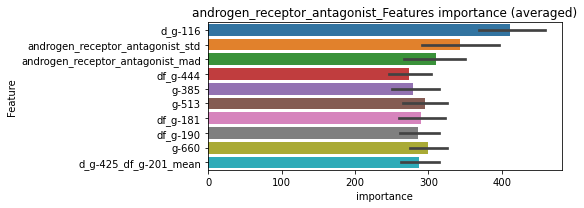

len(train_index) : 2737
len(valid_index) : 913
================================= fold 1/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109479	valid_1's binary_logloss: 0.178289
[200]	training's binary_logloss: 0.0411001	valid_1's binary_logloss: 0.113706
[300]	training's binary_logloss: 0.0179302	valid_1's binary_logloss: 0.0839252
[400]	training's binary_logloss: 0.00858118	valid_1's binary_logloss: 0.0679236
[500]	training's binary_logloss: 0.00453363	valid_1's binary_logloss: 0.0590806
[600]	training's binary_logloss: 0.00272691	valid_1's binary_logloss: 0.0543339
[700]	training's binary_logloss: 0.00184351	valid_1's binary_logloss: 0.0522571
[800]	training's binary_logloss: 0.00139045	valid_1's binary_logloss: 0.0502829
[900]	training's binary_logloss: 0.00111773	valid_1's binary_logloss: 0.0498479
[1000]	training's binary_logloss: 0.000955205	valid_1's binary_logloss: 0.0495744
Early stopping, best iteration is:
[1027]	training's binary_logloss: 0.000930119	valid_1's binary_logloss: 0.0492257


len(train_index) : 2737
len(valid_index) : 913
================================= fold 2/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113203	valid_1's binary_logloss: 0.173177
[200]	training's binary_logloss: 0.0444082	valid_1's binary_logloss: 0.111573
[300]	training's binary_logloss: 0.0183234	valid_1's binary_logloss: 0.0819511
[400]	training's binary_logloss: 0.00844355	valid_1's binary_logloss: 0.0697943
[500]	training's binary_logloss: 0.00438477	valid_1's binary_logloss: 0.0632433
[600]	training's binary_logloss: 0.00262469	valid_1's binary_logloss: 0.0597436
[700]	training's binary_logloss: 0.00179239	valid_1's binary_logloss: 0.0573437
[800]	training's binary_logloss: 0.00134403	valid_1's binary_logloss: 0.0563533
[900]	training's binary_logloss: 0.00109077	valid_1's binary_logloss: 0.0552471
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.00108878	valid_1's binary_logloss: 0.0552045


len(train_index) : 2738
len(valid_index) : 912
================================= fold 3/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113286	valid_1's binary_logloss: 0.16175
[200]	training's binary_logloss: 0.0443383	valid_1's binary_logloss: 0.0959128
[300]	training's binary_logloss: 0.0193616	valid_1's binary_logloss: 0.0679827
[400]	training's binary_logloss: 0.00925989	valid_1's binary_logloss: 0.0539883
[500]	training's binary_logloss: 0.00482246	valid_1's binary_logloss: 0.0464565
[600]	training's binary_logloss: 0.00287889	valid_1's binary_logloss: 0.0434499
[700]	training's binary_logloss: 0.00193193	valid_1's binary_logloss: 0.0410709
[800]	training's binary_logloss: 0.00144041	valid_1's binary_logloss: 0.0398213
[900]	training's binary_logloss: 0.00115448	valid_1's binary_logloss: 0.0389786
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00113169	valid_1's binary_logloss: 0.0389309


len(train_index) : 2738
len(valid_index) : 912
================================= fold 4/4 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108299	valid_1's binary_logloss: 0.16961
[200]	training's binary_logloss: 0.041458	valid_1's binary_logloss: 0.104466
[300]	training's binary_logloss: 0.0180989	valid_1's binary_logloss: 0.0736698
[400]	training's binary_logloss: 0.00883376	valid_1's binary_logloss: 0.0577415
[500]	training's binary_logloss: 0.00457505	valid_1's binary_logloss: 0.0480487
[600]	training's binary_logloss: 0.00275431	valid_1's binary_logloss: 0.0437007
[700]	training's binary_logloss: 0.00185866	valid_1's binary_logloss: 0.0408337
[800]	training's binary_logloss: 0.00138588	valid_1's binary_logloss: 0.0396115
Early stopping, best iteration is:
[854]	training's binary_logloss: 0.00122418	valid_1's binary_logloss: 0.0393935


androgen_receptor_antagonist logloss: 0.04569223124038288


neg labels: 3289 → selected neg labels: 3273


anesthetic_-_local, len(trt): 80, len(othr): 3273, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133671	valid_1's binary_logloss: 0.217413
[200]	training's binary_logloss: 0.0589505	valid_1's binary_logloss: 0.155298
[300]	training's binary_logloss: 0.0289519	valid_1's binary_logloss: 0.128156
[400]	training's binary_logloss: 0.0148375	valid_1's binary_logloss: 0.117442
[500]	training's binary_logloss: 0.00790596	valid_1's binary_logloss: 0.110458
[600]	training's binary_logloss: 0.00460404	valid_1's binary_logloss: 0.107457
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00484801	valid_1's binary_logloss: 0.107356
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138682	valid_1's binary_logloss: 0.201047
[200]	training's binary_logloss: 0.0599763	valid_1's binary_logloss: 0.129615
[300]	training's binary_logloss: 0.0289867	valid_1's binary_logloss: 0.0956705
[400]	training's binary_logloss: 0.0149081	valid_1's binary_l

1 / 3 AUC score:0.991
y_Threshold: 0.0288868, Threshold: 0.1444941, pos_neg_ratio: 0.8000000
Remove_noisy_data: 168 → Positive_corect_labels: 636/3759
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.10115, conf_1:0.18784
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_1: 0.1444941
Num_p_label: 35.0, Expected: 13.4, Adj_threshold_2: 0.1944941
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_3: 0.2444941
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_4: 0.2944941
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_5: 0.3444941
threshold: 0.3444941, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 636.0/3759, y_label_rate: 0.1691939
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127254	valid_1's binary_logloss: 0.187768
[200]	training's binary_logloss: 0.0491923	valid_1's binary_logloss: 0.121166
[300]	training's binary_logloss: 0.0221129	valid_1's binary_logloss: 0.094453
[400]	training's binary_logloss: 0.0108781	valid_1's binary_logloss: 0.0811259
[500]	training's binary_logloss: 0.00569234	valid_1's binary_logloss: 0.0748473
[600]	training's binary_logloss: 0.00336794	valid_1's binary_logloss: 0.0720734
[700]	training's binary_logloss: 0.00223877	valid_1's binary_logloss: 0.0702515
[800]	training's binary_logloss: 0.00162453	valid_1's binary_logloss: 0.0692518
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.00153816	valid_1's binary_logloss: 0.0690293
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124654	valid_1's binary_logloss: 0.196566
[200]	training's binary_logloss: 0.0491865	valid_1's b

2 / 3 AUC score:0.995
y_Threshold: 0.0730250, Threshold: 0.3444941, pos_neg_ratio: 0.8000000
Remove_noisy_data: 64 → Positive_corect_labels: 604.0/3695
p_label_rate: 0.0185836 Vs.target_rate: 0.00336, Num_p_label: 74.0, conf_0:0.27560, conf_1:0.41339
Num_p_label: 74.0, Expected: 13.4, Adj_threshold_1: 0.3444941
Num_p_label: 66.0, Expected: 13.4, Adj_threshold_2: 0.3944941
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_3: 0.4444941
Num_p_label: 59.0, Expected: 13.4, Adj_threshold_4: 0.4944941
Num_p_label: 52.0, Expected: 13.4, Adj_threshold_5: 0.5444941
Num_p_label: 50.0, Expected: 13.4, Adj_threshold_6: 0.5944941
Num_p_label: 43.0, Expected: 13.4, Adj_threshold_7: 0.6444941
Num_p_label: 39.0, Expected: 13.4, Adj_threshold_8: 0.6944941
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_9: 0.7444941
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_10: 0.7944941
threshold: 0.7944941, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 604.0/3695, y_label_rate: 0.1634641

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110492	valid_1's binary_logloss: 0.184803
[200]	training's binary_logloss: 0.0422845	valid_1's binary_logloss: 0.128143
[300]	training's binary_logloss: 0.0185256	valid_1's binary_logloss: 0.103393
[400]	training's binary_logloss: 0.00870631	valid_1's binary_logloss: 0.0904852
[500]	training's binary_logloss: 0.00455111	valid_1's binary_logloss: 0.0845472
[600]	training's binary_logloss: 0.00269037	valid_1's binary_logloss: 0.0829351
[700]	training's binary_logloss: 0.00180814	valid_1's binary_logloss: 0.0822903
Early stopping, best iteration is:
[676]	training's binary_logloss: 0.0019711	valid_1's binary_logloss: 0.082067
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112723	valid_1's binary_logloss: 0.164724
[200]	training's binary_logloss: 0.0441989	valid_1's binary_logloss: 0.10174
[300]	training's binary_logloss: 0.019788	valid_1's binary

3 / 3 AUC score:0.994
y_Threshold: 0.0678797, Threshold: 0.7944941, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 588.0/3663
p_label_rate: 0.0155701 Vs.target_rate: 0.00336, Num_p_label: 62.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_1: 0.7944941
threshold: 0.7944941, positive_p_label: 62.0/3982, p_label_rate: 0.0155701
positive_y_label: 588.0/3663, y_label_rate: 0.1605242


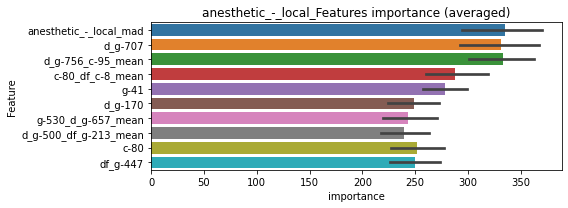

len(train_index) : 2747
len(valid_index) : 916
================================= fold 1/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106714	valid_1's binary_logloss: 0.154631
[200]	training's binary_logloss: 0.0403988	valid_1's binary_logloss: 0.0946071
[300]	training's binary_logloss: 0.0171088	valid_1's binary_logloss: 0.0681654
[400]	training's binary_logloss: 0.00797665	valid_1's binary_logloss: 0.0568335
[500]	training's binary_logloss: 0.00406005	valid_1's binary_logloss: 0.0504307
[600]	training's binary_logloss: 0.00243624	valid_1's binary_logloss: 0.0471806
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00197896	valid_1's binary_logloss: 0.0462875


len(train_index) : 2747
len(valid_index) : 916
================================= fold 2/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106865	valid_1's binary_logloss: 0.165345
[200]	training's binary_logloss: 0.0398712	valid_1's binary_logloss: 0.104428
[300]	training's binary_logloss: 0.0167485	valid_1's binary_logloss: 0.0765528
[400]	training's binary_logloss: 0.00776299	valid_1's binary_logloss: 0.0631941
[500]	training's binary_logloss: 0.00395451	valid_1's binary_logloss: 0.0557273
[600]	training's binary_logloss: 0.00235528	valid_1's binary_logloss: 0.0519362
[700]	training's binary_logloss: 0.00159651	valid_1's binary_logloss: 0.0502831
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00168333	valid_1's binary_logloss: 0.0502567


len(train_index) : 2747
len(valid_index) : 916
================================= fold 3/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106416	valid_1's binary_logloss: 0.153731
[200]	training's binary_logloss: 0.0420819	valid_1's binary_logloss: 0.0875898
[300]	training's binary_logloss: 0.0177579	valid_1's binary_logloss: 0.0577844
[400]	training's binary_logloss: 0.00844903	valid_1's binary_logloss: 0.0434752
[500]	training's binary_logloss: 0.0043097	valid_1's binary_logloss: 0.0355133
[600]	training's binary_logloss: 0.00253083	valid_1's binary_logloss: 0.0313051
[700]	training's binary_logloss: 0.00169425	valid_1's binary_logloss: 0.0288608
[800]	training's binary_logloss: 0.00127107	valid_1's binary_logloss: 0.0276326
[900]	training's binary_logloss: 0.00103354	valid_1's binary_logloss: 0.0266652
[1000]	training's binary_logloss: 0.00090447	valid_1's binary_logloss: 0.0262856
[1100]	training's binary_logloss: 0.00082644	valid_1's binary_logloss: 0.0259662
Early stopping, best iteration is:
[1119]	training's binary_log

len(train_index) : 2748
len(valid_index) : 915
================================= fold 4/4 anesthetic_-_local=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108884	valid_1's binary_logloss: 0.147376
[200]	training's binary_logloss: 0.0416869	valid_1's binary_logloss: 0.0831369
[300]	training's binary_logloss: 0.0177491	valid_1's binary_logloss: 0.0583849
[400]	training's binary_logloss: 0.0084897	valid_1's binary_logloss: 0.048144
[500]	training's binary_logloss: 0.00416725	valid_1's binary_logloss: 0.043003
[600]	training's binary_logloss: 0.00244822	valid_1's binary_logloss: 0.0400797
[700]	training's binary_logloss: 0.00164621	valid_1's binary_logloss: 0.0383194
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00134997	valid_1's binary_logloss: 0.0373937


anesthetic_-_local logloss: 0.03995623841726898


neg labels: 3289 → selected neg labels: 3282


angiogenesis_inhibitor, len(trt): 36, len(othr): 3282, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101151	valid_1's binary_logloss: 0.141557
[200]	training's binary_logloss: 0.035566	valid_1's binary_logloss: 0.0698537
[300]	training's binary_logloss: 0.0135219	valid_1's binary_logloss: 0.0402782
[400]	training's binary_logloss: 0.00572678	valid_1's binary_logloss: 0.0259968
[500]	training's binary_logloss: 0.0028784	valid_1's binary_logloss: 0.0191405
[600]	training's binary_logloss: 0.00173921	valid_1's binary_logloss: 0.0154483
[700]	training's binary_logloss: 0.00120599	valid_1's binary_logloss: 0.0135135
[800]	training's binary_logloss: 0.000930416	valid_1's binary_logloss: 0.0123508
[900]	training's binary_logloss: 0.000763013	valid_1's binary_logloss: 0.0115854
[1000]	training's binary_logloss: 0.000665023	valid_1's binary_logloss: 0.0111396
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.000671481	valid_1's binary_logloss: 0.0111263
Training until validation 

1 / 3 AUC score:1.000
y_Threshold: 0.0123380, Threshold: 0.0466587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.03266, conf_1:0.06066
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0466587
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.0966587
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_3: 0.1466587
threshold: 0.1466587, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957385	valid_1's binary_logloss: 0.134665
[200]	training's binary_logloss: 0.0300174	valid_1's binary_logloss: 0.0615733
[300]	training's binary_logloss: 0.0109363	valid_1's binary_logloss: 0.0343999
[400]	training's binary_logloss: 0.00455557	valid_1's binary_logloss: 0.0236735
[500]	training's binary_logloss: 0.00234895	valid_1's binary_logloss: 0.0190082
[600]	training's binary_logloss: 0.00144801	valid_1's binary_logloss: 0.0166433
[700]	training's binary_logloss: 0.00102311	valid_1's binary_logloss: 0.0153257
[800]	training's binary_logloss: 0.000790643	valid_1's binary_logloss: 0.0144218
[900]	training's binary_logloss: 0.000651932	valid_1's binary_logloss: 0.0138313
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.000630189	valid_1's binary_logloss: 0.0137288
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983165	v

2 / 3 AUC score:1.000
y_Threshold: 0.1083662, Threshold: 0.1466587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3800
p_label_rate: 0.0105475 Vs.target_rate: 0.00151, Num_p_label: 42.0, conf_0:0.11733, conf_1:0.17599
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_1: 0.1466587
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_2: 0.1966587
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.2466587
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_4: 0.2966587
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.3466587
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.3966587
threshold: 0.3966587, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0963945	valid_1's binary_logloss: 0.135725
[200]	training's binary_logloss: 0.0307601	valid_1's binary_logloss: 0.0639804
[300]	training's binary_logloss: 0.0110835	valid_1's binary_logloss: 0.0388479
[400]	training's binary_logloss: 0.00462514	valid_1's binary_logloss: 0.0284069
[500]	training's binary_logloss: 0.00237134	valid_1's binary_logloss: 0.0241058
[600]	training's binary_logloss: 0.00145598	valid_1's binary_logloss: 0.0220375
[700]	training's binary_logloss: 0.00102839	valid_1's binary_logloss: 0.0211551
[800]	training's binary_logloss: 0.000789548	valid_1's binary_logloss: 0.0204282
Early stopping, best iteration is:
[787]	training's binary_logloss: 0.000814068	valid_1's binary_logloss: 0.0204104
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944071	valid_1's binary_logloss: 0.129242
[200]	training's binary_logloss: 0.0296956	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0750881, Threshold: 0.3966587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.35699, conf_1:0.43632
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_1: 0.3966587
threshold: 0.3966587, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 651.0/3796, y_label_rate: 0.1714963


len(train_index) : 2847
len(valid_index) : 949
================================= fold 1/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975108	valid_1's binary_logloss: 0.123035
[200]	training's binary_logloss: 0.0313356	valid_1's binary_logloss: 0.0532843
[300]	training's binary_logloss: 0.0112996	valid_1's binary_logloss: 0.0278004
[400]	training's binary_logloss: 0.00474101	valid_1's binary_logloss: 0.0175921
[500]	training's binary_logloss: 0.00242808	valid_1's binary_logloss: 0.0130774
[600]	training's binary_logloss: 0.00150732	valid_1's binary_logloss: 0.0109731
[700]	training's binary_logloss: 0.00105455	valid_1's binary_logloss: 0.00976033
[800]	training's binary_logloss: 0.000810783	valid_1's binary_logloss: 0.00892844
[900]	training's binary_logloss: 0.000669741	valid_1's binary_logloss: 0.00839971
[1000]	training's binary_logloss: 0.000596015	valid_1's binary_logloss: 0.00823751
Early stopping, best iteration is:
[1018]	training's binary_logloss: 0.000585857	valid_1's binary_logloss: 0.00822202


len(train_index) : 2847
len(valid_index) : 949
================================= fold 2/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965468	valid_1's binary_logloss: 0.132478
[200]	training's binary_logloss: 0.0303309	valid_1's binary_logloss: 0.0601639
[300]	training's binary_logloss: 0.0110098	valid_1's binary_logloss: 0.0335028
[400]	training's binary_logloss: 0.00465379	valid_1's binary_logloss: 0.0239287
[500]	training's binary_logloss: 0.00233263	valid_1's binary_logloss: 0.0197509
[600]	training's binary_logloss: 0.00140679	valid_1's binary_logloss: 0.0176234
[700]	training's binary_logloss: 0.00100015	valid_1's binary_logloss: 0.0169145
[800]	training's binary_logloss: 0.000774342	valid_1's binary_logloss: 0.0162371
[900]	training's binary_logloss: 0.000643596	valid_1's binary_logloss: 0.0159057
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000639602	valid_1's binary_logloss: 0.0158899


len(train_index) : 2847
len(valid_index) : 949
================================= fold 3/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0960934	valid_1's binary_logloss: 0.123218
[200]	training's binary_logloss: 0.030256	valid_1's binary_logloss: 0.0521622
[300]	training's binary_logloss: 0.0109559	valid_1's binary_logloss: 0.026464
[400]	training's binary_logloss: 0.00454696	valid_1's binary_logloss: 0.0159918
[500]	training's binary_logloss: 0.00233281	valid_1's binary_logloss: 0.0110798
[600]	training's binary_logloss: 0.00144978	valid_1's binary_logloss: 0.00876628
[700]	training's binary_logloss: 0.00102611	valid_1's binary_logloss: 0.00736927
[800]	training's binary_logloss: 0.000799323	valid_1's binary_logloss: 0.00655572
[900]	training's binary_logloss: 0.000656153	valid_1's binary_logloss: 0.00599361
[1000]	training's binary_logloss: 0.000585002	valid_1's binary_logloss: 0.00578321
[1100]	training's binary_logloss: 0.000564122	valid_1's binary_logloss: 0.0056986
Early stopping, best iteration is:
[1079]	training's b

len(train_index) : 2847
len(valid_index) : 949
================================= fold 4/4 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0962058	valid_1's binary_logloss: 0.12494
[200]	training's binary_logloss: 0.029882	valid_1's binary_logloss: 0.0534849
[300]	training's binary_logloss: 0.0108051	valid_1's binary_logloss: 0.0279955
[400]	training's binary_logloss: 0.00451539	valid_1's binary_logloss: 0.017816
[500]	training's binary_logloss: 0.00233751	valid_1's binary_logloss: 0.0130562
[600]	training's binary_logloss: 0.00143912	valid_1's binary_logloss: 0.0105365
[700]	training's binary_logloss: 0.00101975	valid_1's binary_logloss: 0.00913213
[800]	training's binary_logloss: 0.000792314	valid_1's binary_logloss: 0.00832148
[900]	training's binary_logloss: 0.000656754	valid_1's binary_logloss: 0.00796601
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.00061629	valid_1's binary_logloss: 0.00778125


angiogenesis_inhibitor logloss: 0.009397937422648786


neg labels: 3289 → selected neg labels: 3286


angiotensin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101613	valid_1's binary_logloss: 0.145119
[200]	training's binary_logloss: 0.0355131	valid_1's binary_logloss: 0.0755309
[300]	training's binary_logloss: 0.0140789	valid_1's binary_logloss: 0.0458024
[400]	training's binary_logloss: 0.00616434	valid_1's binary_logloss: 0.0314219
[500]	training's binary_logloss: 0.00315084	valid_1's binary_logloss: 0.0240268
[600]	training's binary_logloss: 0.00188217	valid_1's binary_logloss: 0.0207072
[700]	training's binary_logloss: 0.00129751	valid_1's binary_logloss: 0.0192378
[800]	training's binary_logloss: 0.000987183	valid_1's binary_logloss: 0.0185076
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.00100821	valid_1's binary_logloss: 0.0184669
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.099239	valid_1's binary_logloss: 0.147065
[200]	training's binary_logloss: 0.0340214	valid_1

1 / 3 AUC score:0.999
y_Threshold: 0.0134774, Threshold: 0.0892231, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.06246, conf_1:0.11599
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0892231
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_2: 0.1392231
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_3: 0.1892231
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.2392231
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_5: 0.2892231
threshold: 0.2892231, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096229	valid_1's binary_logloss: 0.139652
[200]	training's binary_logloss: 0.0306794	valid_1's binary_logloss: 0.0638451
[300]	training's binary_logloss: 0.0113586	valid_1's binary_logloss: 0.0342163
[400]	training's binary_logloss: 0.00482749	valid_1's binary_logloss: 0.0211914
[500]	training's binary_logloss: 0.00249218	valid_1's binary_logloss: 0.0151518
[600]	training's binary_logloss: 0.00153877	valid_1's binary_logloss: 0.0121759
[700]	training's binary_logloss: 0.00108239	valid_1's binary_logloss: 0.0105936
[800]	training's binary_logloss: 0.00084177	valid_1's binary_logloss: 0.0095595
[900]	training's binary_logloss: 0.000697033	valid_1's binary_logloss: 0.00913054
[1000]	training's binary_logloss: 0.000627106	valid_1's binary_logloss: 0.00883415
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000619539	valid_1's binary_logloss: 0.00879549
Training until valida

2 / 3 AUC score:0.999
y_Threshold: 0.0990833, Threshold: 0.2892231, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 645.0/3787
p_label_rate: 0.0110497 Vs.target_rate: 0.00155, Num_p_label: 44.0, conf_0:0.23138, conf_1:0.34707
Num_p_label: 44.0, Expected: 6.2, Adj_threshold_1: 0.2892231
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_2: 0.3392231
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_3: 0.3892231
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_4: 0.4392231
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_5: 0.4892231
Num_p_label: 28.0, Expected: 6.2, Adj_threshold_6: 0.5392231
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_7: 0.5892231
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_8: 0.6392231
threshold: 0.6392231, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 645.0/3787, y_label_rate: 0.1703195
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0923974	valid_1's binary_logloss: 0.131656
[200]	training's binary_logloss: 0.0293651	valid_1's binary_logloss: 0.0613522
[300]	training's binary_logloss: 0.0110062	valid_1's binary_logloss: 0.0331589
[400]	training's binary_logloss: 0.00465579	valid_1's binary_logloss: 0.0208701
[500]	training's binary_logloss: 0.00237116	valid_1's binary_logloss: 0.0151875
[600]	training's binary_logloss: 0.00146535	valid_1's binary_logloss: 0.0121882
[700]	training's binary_logloss: 0.00104038	valid_1's binary_logloss: 0.0110432
[800]	training's binary_logloss: 0.000807998	valid_1's binary_logloss: 0.0100468
[900]	training's binary_logloss: 0.000669715	valid_1's binary_logloss: 0.00937926
[1000]	training's binary_logloss: 0.000607229	valid_1's binary_logloss: 0.00926612
Early stopping, best iteration is:
[1017]	training's binary_logloss: 0.000600166	valid_1's binary_logloss: 0.00922344
Training until vali

3 / 3 AUC score:1.000
y_Threshold: 0.0844605, Threshold: 0.6392231, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 643.0/3783
p_label_rate: 0.0057760 Vs.target_rate: 0.00155, Num_p_label: 23.0, conf_0:0.50000, conf_1:0.70315
Num_p_label: 23.0, Expected: 6.2, Adj_threshold_1: 0.6392231
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_2: 0.6892231
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_3: 0.7392231
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.7892231
threshold: 0.7892231, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 643.0/3783, y_label_rate: 0.1699709


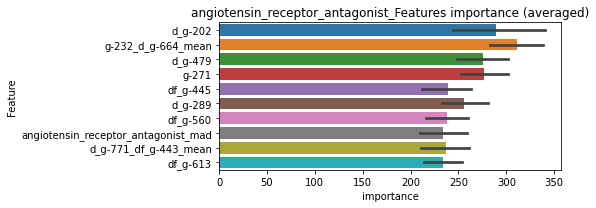

len(train_index) : 2837
len(valid_index) : 946
================================= fold 1/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0911531	valid_1's binary_logloss: 0.132129
[200]	training's binary_logloss: 0.0282834	valid_1's binary_logloss: 0.0612668
[300]	training's binary_logloss: 0.0103879	valid_1's binary_logloss: 0.034682
[400]	training's binary_logloss: 0.00437658	valid_1's binary_logloss: 0.0226741
[500]	training's binary_logloss: 0.00226482	valid_1's binary_logloss: 0.0176875
[600]	training's binary_logloss: 0.00141428	valid_1's binary_logloss: 0.0149724
[700]	training's binary_logloss: 0.00099794	valid_1's binary_logloss: 0.0135563
[800]	training's binary_logloss: 0.000781478	valid_1's binary_logloss: 0.0127487
[900]	training's binary_logloss: 0.000660038	valid_1's binary_logloss: 0.0123192
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000634044	valid_1's binary_logloss: 0.0121534


len(train_index) : 2837
len(valid_index) : 946
================================= fold 2/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0926897	valid_1's binary_logloss: 0.122987
[200]	training's binary_logloss: 0.0280923	valid_1's binary_logloss: 0.0552378
[300]	training's binary_logloss: 0.0105676	valid_1's binary_logloss: 0.0302665
[400]	training's binary_logloss: 0.00436168	valid_1's binary_logloss: 0.0186062
[500]	training's binary_logloss: 0.00224838	valid_1's binary_logloss: 0.013878
[600]	training's binary_logloss: 0.00139567	valid_1's binary_logloss: 0.0117719
[700]	training's binary_logloss: 0.000994658	valid_1's binary_logloss: 0.0106142
[800]	training's binary_logloss: 0.000777362	valid_1's binary_logloss: 0.00992737
[900]	training's binary_logloss: 0.000653564	valid_1's binary_logloss: 0.00961837
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.000631253	valid_1's binary_logloss: 0.00959927


len(train_index) : 2837
len(valid_index) : 946
================================= fold 3/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908238	valid_1's binary_logloss: 0.149399
[200]	training's binary_logloss: 0.0281414	valid_1's binary_logloss: 0.0797768
[300]	training's binary_logloss: 0.00997257	valid_1's binary_logloss: 0.0493119
[400]	training's binary_logloss: 0.0042076	valid_1's binary_logloss: 0.0372097
[500]	training's binary_logloss: 0.00217243	valid_1's binary_logloss: 0.0316834
[600]	training's binary_logloss: 0.00134912	valid_1's binary_logloss: 0.0293281
[700]	training's binary_logloss: 0.000957464	valid_1's binary_logloss: 0.0278676
[800]	training's binary_logloss: 0.000747393	valid_1's binary_logloss: 0.0271465
[900]	training's binary_logloss: 0.000625544	valid_1's binary_logloss: 0.0263417
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000624044	valid_1's binary_logloss: 0.0263317


len(train_index) : 2838
len(valid_index) : 945
================================= fold 4/4 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927462	valid_1's binary_logloss: 0.13397
[200]	training's binary_logloss: 0.0293759	valid_1's binary_logloss: 0.0667707
[300]	training's binary_logloss: 0.0106951	valid_1's binary_logloss: 0.0415266
[400]	training's binary_logloss: 0.00444625	valid_1's binary_logloss: 0.0305842
[500]	training's binary_logloss: 0.00230074	valid_1's binary_logloss: 0.0264248
[600]	training's binary_logloss: 0.00141432	valid_1's binary_logloss: 0.0244522
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00126783	valid_1's binary_logloss: 0.0240822


angiotensin_receptor_antagonist logloss: 0.01804005591924825


neg labels: 3289 → selected neg labels: 3278


anti-inflammatory, len(trt): 73, len(othr): 3278, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131489	valid_1's binary_logloss: 0.196682
[200]	training's binary_logloss: 0.0603809	valid_1's binary_logloss: 0.129272
[300]	training's binary_logloss: 0.0313258	valid_1's binary_logloss: 0.0959542
[400]	training's binary_logloss: 0.0163622	valid_1's binary_logloss: 0.0764165
[500]	training's binary_logloss: 0.00883547	valid_1's binary_logloss: 0.0643719
[600]	training's binary_logloss: 0.00512049	valid_1's binary_logloss: 0.0569644
[700]	training's binary_logloss: 0.00323532	valid_1's binary_logloss: 0.052277
[800]	training's binary_logloss: 0.00224368	valid_1's binary_logloss: 0.0482174
[900]	training's binary_logloss: 0.00169137	valid_1's binary_logloss: 0.0463389
[1000]	training's binary_logloss: 0.00136497	valid_1's binary_logloss: 0.0452576
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.00132063	valid_1's binary_logloss: 0.045042
Training until validation score

1 / 3 AUC score:0.995
y_Threshold: 0.0283704, Threshold: 0.2766869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 152 → Positive_corect_labels: 645/3781
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.19368, conf_1:0.35969
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.2766869
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.3266869
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_3: 0.3766869
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_4: 0.4266869
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_5: 0.4766869
threshold: 0.4766869, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 645.0/3781, y_label_rate: 0.1705898
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121365	valid_1's binary_logloss: 0.196399
[200]	training's binary_logloss: 0.0505025	valid_1's binary_logloss: 0.128248
[300]	training's binary_logloss: 0.0237588	valid_1's binary_logloss: 0.0960341
[400]	training's binary_logloss: 0.0120515	valid_1's binary_logloss: 0.0799172
[500]	training's binary_logloss: 0.0062677	valid_1's binary_logloss: 0.0701658
[600]	training's binary_logloss: 0.00363626	valid_1's binary_logloss: 0.0648769
[700]	training's binary_logloss: 0.00236552	valid_1's binary_logloss: 0.0629586
[800]	training's binary_logloss: 0.00171175	valid_1's binary_logloss: 0.0612644
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.0016138	valid_1's binary_logloss: 0.0607055
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122852	valid_1's binary_logloss: 0.182167
[200]	training's binary_logloss: 0.0520463	valid_1's bi

2 / 3 AUC score:0.989
y_Threshold: 0.0977282, Threshold: 0.4766869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 623.0/3737
p_label_rate: 0.0148167 Vs.target_rate: 0.00307, Num_p_label: 59.0, conf_0:0.38135, conf_1:0.57202
Num_p_label: 59.0, Expected: 12.2, Adj_threshold_1: 0.4766869
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_2: 0.5266869
Num_p_label: 48.0, Expected: 12.2, Adj_threshold_3: 0.5766869
Num_p_label: 38.0, Expected: 12.2, Adj_threshold_4: 0.6266869
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_5: 0.6766869
Num_p_label: 21.0, Expected: 12.2, Adj_threshold_6: 0.7266869
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_7: 0.7766869
threshold: 0.7766869, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 623.0/3737, y_label_rate: 0.1667113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116063	valid_1's binary_logloss: 0.160597
[200]	training's binary_logloss: 0.0454136	valid_1's binary_logloss: 0.0945104
[300]	training's binary_logloss: 0.0212117	valid_1's binary_logloss: 0.0691217
[400]	training's binary_logloss: 0.0103739	valid_1's binary_logloss: 0.0566025
[500]	training's binary_logloss: 0.00536621	valid_1's binary_logloss: 0.0507298
[600]	training's binary_logloss: 0.00319047	valid_1's binary_logloss: 0.0476542
[700]	training's binary_logloss: 0.00211205	valid_1's binary_logloss: 0.0462342
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00231495	valid_1's binary_logloss: 0.0461662
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114324	valid_1's binary_logloss: 0.16745
[200]	training's binary_logloss: 0.045938	valid_1's binary_logloss: 0.101602
[300]	training's binary_logloss: 0.0206421	valid_1's bin

3 / 3 AUC score:0.992
y_Threshold: 0.1070468, Threshold: 0.7766869, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 602.0/3695
p_label_rate: 0.0077850 Vs.target_rate: 0.00307, Num_p_label: 31.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_1: 0.7766869
threshold: 0.7766869, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 602.0/3695, y_label_rate: 0.1629229


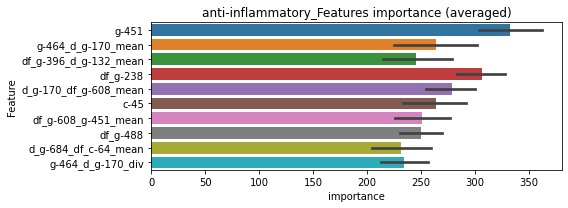

len(train_index) : 2771
len(valid_index) : 924
================================= fold 1/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103385	valid_1's binary_logloss: 0.162354
[200]	training's binary_logloss: 0.0378013	valid_1's binary_logloss: 0.0948017
[300]	training's binary_logloss: 0.0162081	valid_1's binary_logloss: 0.0642557
[400]	training's binary_logloss: 0.00759487	valid_1's binary_logloss: 0.0479962
[500]	training's binary_logloss: 0.00400807	valid_1's binary_logloss: 0.0392261
[600]	training's binary_logloss: 0.00243366	valid_1's binary_logloss: 0.0345874
[700]	training's binary_logloss: 0.00166624	valid_1's binary_logloss: 0.0324148
[800]	training's binary_logloss: 0.00125358	valid_1's binary_logloss: 0.0311032
[900]	training's binary_logloss: 0.00101193	valid_1's binary_logloss: 0.0302591
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00100641	valid_1's binary_logloss: 0.0301942


len(train_index) : 2771
len(valid_index) : 924
================================= fold 2/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105907	valid_1's binary_logloss: 0.146512
[200]	training's binary_logloss: 0.0397177	valid_1's binary_logloss: 0.079676
[300]	training's binary_logloss: 0.0170315	valid_1's binary_logloss: 0.053253
[400]	training's binary_logloss: 0.00780845	valid_1's binary_logloss: 0.0402759
[500]	training's binary_logloss: 0.0039883	valid_1's binary_logloss: 0.0335493
[600]	training's binary_logloss: 0.00241926	valid_1's binary_logloss: 0.0303667
[700]	training's binary_logloss: 0.0016549	valid_1's binary_logloss: 0.0282883
[800]	training's binary_logloss: 0.00125485	valid_1's binary_logloss: 0.0274
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00110256	valid_1's binary_logloss: 0.0267911


len(train_index) : 2771
len(valid_index) : 924
================================= fold 3/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106995	valid_1's binary_logloss: 0.149902
[200]	training's binary_logloss: 0.0400703	valid_1's binary_logloss: 0.078728
[300]	training's binary_logloss: 0.0173109	valid_1's binary_logloss: 0.048488
[400]	training's binary_logloss: 0.00819542	valid_1's binary_logloss: 0.0333138
[500]	training's binary_logloss: 0.0042589	valid_1's binary_logloss: 0.0255088
[600]	training's binary_logloss: 0.0025597	valid_1's binary_logloss: 0.0221146
[700]	training's binary_logloss: 0.00176088	valid_1's binary_logloss: 0.0201935
[800]	training's binary_logloss: 0.00131672	valid_1's binary_logloss: 0.0187638
[900]	training's binary_logloss: 0.00106928	valid_1's binary_logloss: 0.0181542
[1000]	training's binary_logloss: 0.000914854	valid_1's binary_logloss: 0.0176164
Early stopping, best iteration is:
[1066]	training's binary_logloss: 0.000853628	valid_1's binary_logloss: 0.0174159


len(train_index) : 2772
len(valid_index) : 923
================================= fold 4/4 anti-inflammatory=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106847	valid_1's binary_logloss: 0.163101
[200]	training's binary_logloss: 0.0415412	valid_1's binary_logloss: 0.0978223
[300]	training's binary_logloss: 0.0181166	valid_1's binary_logloss: 0.0723918
[400]	training's binary_logloss: 0.00821921	valid_1's binary_logloss: 0.0588534
[500]	training's binary_logloss: 0.00424028	valid_1's binary_logloss: 0.0517979
[600]	training's binary_logloss: 0.00252176	valid_1's binary_logloss: 0.0484906
[700]	training's binary_logloss: 0.00172251	valid_1's binary_logloss: 0.0466819
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.00156279	valid_1's binary_logloss: 0.0462955


anti-inflammatory logloss: 0.030169830212829034


neg labels: 3289 → selected neg labels: 3284


antiarrhythmic, len(trt): 24, len(othr): 3284, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878984	valid_1's binary_logloss: 0.121134
[200]	training's binary_logloss: 0.0267016	valid_1's binary_logloss: 0.0535546
[300]	training's binary_logloss: 0.00929328	valid_1's binary_logloss: 0.0286396
[400]	training's binary_logloss: 0.00384668	valid_1's binary_logloss: 0.0185248
[500]	training's binary_logloss: 0.00198624	valid_1's binary_logloss: 0.0142433
[600]	training's binary_logloss: 0.00122902	valid_1's binary_logloss: 0.0123029
[700]	training's binary_logloss: 0.000880829	valid_1's binary_logloss: 0.0110978
[800]	training's binary_logloss: 0.0006963	valid_1's binary_logloss: 0.0105146
[900]	training's binary_logloss: 0.000594987	valid_1's binary_logloss: 0.01018
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000566167	valid_1's binary_logloss: 0.0101023
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901969	val

1 / 3 AUC score:1.000
y_Threshold: 0.0083444, Threshold: 0.0447468, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03132, conf_1:0.05817
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0447468
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_2: 0.0947468
Num_p_label: 7.0, Expected: 4.0, Adj_threshold_3: 0.1447468
threshold: 0.1447468, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851008	valid_1's binary_logloss: 0.110071
[200]	training's binary_logloss: 0.0236891	valid_1's binary_logloss: 0.0415088
[300]	training's binary_logloss: 0.00795365	valid_1's binary_logloss: 0.0201057
[400]	training's binary_logloss: 0.00329714	valid_1's binary_logloss: 0.0125654
[500]	training's binary_logloss: 0.00173842	valid_1's binary_logloss: 0.00984027
[600]	training's binary_logloss: 0.00111142	valid_1's binary_logloss: 0.00850009
[700]	training's binary_logloss: 0.000801177	valid_1's binary_logloss: 0.00771189
[800]	training's binary_logloss: 0.000630399	valid_1's binary_logloss: 0.00741104
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.000584805	valid_1's binary_logloss: 0.00727801
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0841913	valid_1's binary_logloss: 0.111232
[200]	training's binary_logloss: 0.02381

2 / 3 AUC score:1.000
y_Threshold: 0.0521487, Threshold: 0.1447468, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0107986 Vs.target_rate: 0.00101, Num_p_label: 43.0, conf_0:0.11580, conf_1:0.17370
Num_p_label: 43.0, Expected: 4.0, Adj_threshold_1: 0.1447468
Num_p_label: 35.0, Expected: 4.0, Adj_threshold_2: 0.1947468
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_3: 0.2447468
Num_p_label: 22.0, Expected: 4.0, Adj_threshold_4: 0.2947468
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_5: 0.3447468
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_6: 0.3947468
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.4447468
threshold: 0.4447468, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 652.0/3800, y_label_rate: 0.1715789
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828746	valid_1's binary_logloss: 0.109717
[200]	training's binary_logloss: 0.0226646	valid_1's binary_logloss: 0.0414436
[300]	training's binary_logloss: 0.00747615	valid_1's binary_logloss: 0.0188813
[400]	training's binary_logloss: 0.00310282	valid_1's binary_logloss: 0.0104357
[500]	training's binary_logloss: 0.00163572	valid_1's binary_logloss: 0.00712924
[600]	training's binary_logloss: 0.00103378	valid_1's binary_logloss: 0.00536093
[700]	training's binary_logloss: 0.000749601	valid_1's binary_logloss: 0.0044362
[800]	training's binary_logloss: 0.000594246	valid_1's binary_logloss: 0.00383311
[900]	training's binary_logloss: 0.000510273	valid_1's binary_logloss: 0.0035669
[1000]	training's binary_logloss: 0.000479061	valid_1's binary_logloss: 0.00344987
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000479061	valid_1's binary_logloss: 0.00344987
Training until v

3 / 3 AUC score:1.000
y_Threshold: 0.1218693, Threshold: 0.4447468, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0037670 Vs.target_rate: 0.00101, Num_p_label: 15.0, conf_0:0.40027, conf_1:0.48922
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_1: 0.4447468
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_2: 0.4947468
Num_p_label: 6.0, Expected: 4.0, Adj_threshold_3: 0.5447468
threshold: 0.5447468, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 651.0/3798, y_label_rate: 0.1714060


Early stopping, best iteration is:
[849]	training's binary_logloss: 0.000553175	valid_1's binary_logloss: 0.00872835


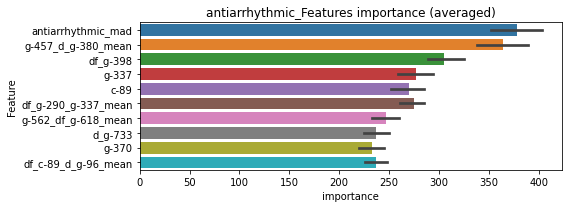

len(train_index) : 2848
len(valid_index) : 950
================================= fold 1/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826872	valid_1's binary_logloss: 0.0997198
[200]	training's binary_logloss: 0.0232169	valid_1's binary_logloss: 0.0356904
[300]	training's binary_logloss: 0.00771424	valid_1's binary_logloss: 0.0157859
[400]	training's binary_logloss: 0.00315391	valid_1's binary_logloss: 0.00873307
[500]	training's binary_logloss: 0.00165374	valid_1's binary_logloss: 0.00592811
[600]	training's binary_logloss: 0.001049	valid_1's binary_logloss: 0.00452324
[700]	training's binary_logloss: 0.00075767	valid_1's binary_logloss: 0.00382072
[800]	training's binary_logloss: 0.000598257	valid_1's binary_logloss: 0.00338197
[900]	training's binary_logloss: 0.000517244	valid_1's binary_logloss: 0.00314953
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000495839	valid_1's binary_logloss: 0.00311076


len(train_index) : 2848
len(valid_index) : 950
================================= fold 2/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828461	valid_1's binary_logloss: 0.126167
[200]	training's binary_logloss: 0.0225846	valid_1's binary_logloss: 0.0556564
[300]	training's binary_logloss: 0.00746909	valid_1's binary_logloss: 0.031799
[400]	training's binary_logloss: 0.0030658	valid_1's binary_logloss: 0.0225781
[500]	training's binary_logloss: 0.00161811	valid_1's binary_logloss: 0.0190234
[600]	training's binary_logloss: 0.00102522	valid_1's binary_logloss: 0.0173083
[700]	training's binary_logloss: 0.000742088	valid_1's binary_logloss: 0.0167211
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.000763675	valid_1's binary_logloss: 0.0167002


len(train_index) : 2849
len(valid_index) : 949
================================= fold 3/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0831547	valid_1's binary_logloss: 0.101029
[200]	training's binary_logloss: 0.0232232	valid_1's binary_logloss: 0.0372831
[300]	training's binary_logloss: 0.00780638	valid_1's binary_logloss: 0.0187759
[400]	training's binary_logloss: 0.00322376	valid_1's binary_logloss: 0.0118891
[500]	training's binary_logloss: 0.00167957	valid_1's binary_logloss: 0.00901707
[600]	training's binary_logloss: 0.00105517	valid_1's binary_logloss: 0.00788581
[700]	training's binary_logloss: 0.000764146	valid_1's binary_logloss: 0.00723945
[800]	training's binary_logloss: 0.000606548	valid_1's binary_logloss: 0.00706422
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.00055931	valid_1's binary_logloss: 0.00691186


len(train_index) : 2849
len(valid_index) : 949
================================= fold 4/4 antiarrhythmic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824178	valid_1's binary_logloss: 0.110417
[200]	training's binary_logloss: 0.0230622	valid_1's binary_logloss: 0.0414502
[300]	training's binary_logloss: 0.00766133	valid_1's binary_logloss: 0.0192988
[400]	training's binary_logloss: 0.00318547	valid_1's binary_logloss: 0.0111017
[500]	training's binary_logloss: 0.00164979	valid_1's binary_logloss: 0.00712997
[600]	training's binary_logloss: 0.00103618	valid_1's binary_logloss: 0.00551431
[700]	training's binary_logloss: 0.000750334	valid_1's binary_logloss: 0.00445709
[800]	training's binary_logloss: 0.000601377	valid_1's binary_logloss: 0.00397681
[900]	training's binary_logloss: 0.000522517	valid_1's binary_logloss: 0.00367059
[1000]	training's binary_logloss: 0.000491729	valid_1's binary_logloss: 0.00357385
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000491729	valid_1's binary_logloss: 0.00357385


antiarrhythmic logloss: 0.007575406563660375


neg labels: 3289 → selected neg labels: 3281


antibiotic, len(trt): 43, len(othr): 3281, target_rate: 0.0018057 → Adj_target_rate: 0.0020542
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112677	valid_1's binary_logloss: 0.153684
[200]	training's binary_logloss: 0.0420018	valid_1's binary_logloss: 0.078054
[300]	training's binary_logloss: 0.0168191	valid_1's binary_logloss: 0.0450051
[400]	training's binary_logloss: 0.0075846	valid_1's binary_logloss: 0.0296928
[500]	training's binary_logloss: 0.00383351	valid_1's binary_logloss: 0.0216834
[600]	training's binary_logloss: 0.00228905	valid_1's binary_logloss: 0.0174463
[700]	training's binary_logloss: 0.00155632	valid_1's binary_logloss: 0.0149586
[800]	training's binary_logloss: 0.00116904	valid_1's binary_logloss: 0.0134926
[900]	training's binary_logloss: 0.000948124	valid_1's binary_logloss: 0.0128116
[1000]	training's binary_logloss: 0.000821276	valid_1's binary_logloss: 0.0122866
Early stopping, best iteration is:
[1059]	training's binary_logloss: 0.000771774	valid_1's binary_logloss: 0.0120194
Training until validation 

1 / 3 AUC score:0.999
y_Threshold: 0.0156160, Threshold: 0.1337654, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00181, Num_p_label: 40.0, conf_0:0.09364, conf_1:0.17390
Num_p_label: 40.0, Expected: 7.2, Adj_threshold_1: 0.1337654
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_2: 0.1837654
Num_p_label: 18.0, Expected: 7.2, Adj_threshold_3: 0.2337654
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_4: 0.2837654
threshold: 0.2837654, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10696	valid_1's binary_logloss: 0.141477
[200]	training's binary_logloss: 0.0364099	valid_1's binary_logloss: 0.0647176
[300]	training's binary_logloss: 0.0135306	valid_1's binary_logloss: 0.0339778
[400]	training's binary_logloss: 0.00577253	valid_1's binary_logloss: 0.0207919
[500]	training's binary_logloss: 0.00297252	valid_1's binary_logloss: 0.0146844
[600]	training's binary_logloss: 0.00183059	valid_1's binary_logloss: 0.0114898
[700]	training's binary_logloss: 0.00127518	valid_1's binary_logloss: 0.00963226
[800]	training's binary_logloss: 0.000976177	valid_1's binary_logloss: 0.00849602
[900]	training's binary_logloss: 0.000805196	valid_1's binary_logloss: 0.00784612
[1000]	training's binary_logloss: 0.000710205	valid_1's binary_logloss: 0.00747223
[1100]	training's binary_logloss: 0.000663676	valid_1's binary_logloss: 0.00729761
[1200]	training's binary_logloss: 0.000642949	valid_1'

2 / 3 AUC score:1.000
y_Threshold: 0.0922153, Threshold: 0.2837654, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3797
p_label_rate: 0.0120542 Vs.target_rate: 0.00181, Num_p_label: 48.0, conf_0:0.22701, conf_1:0.34052
Num_p_label: 48.0, Expected: 7.2, Adj_threshold_1: 0.2837654
Num_p_label: 39.0, Expected: 7.2, Adj_threshold_2: 0.3337654
Num_p_label: 33.0, Expected: 7.2, Adj_threshold_3: 0.3837654
Num_p_label: 28.0, Expected: 7.2, Adj_threshold_4: 0.4337654
Num_p_label: 23.0, Expected: 7.2, Adj_threshold_5: 0.4837654
Num_p_label: 19.0, Expected: 7.2, Adj_threshold_6: 0.5337654
Num_p_label: 14.0, Expected: 7.2, Adj_threshold_7: 0.5837654
threshold: 0.5837654, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104656	valid_1's binary_logloss: 0.149895
[200]	training's binary_logloss: 0.0344232	valid_1's binary_logloss: 0.0765781
[300]	training's binary_logloss: 0.0129572	valid_1's binary_logloss: 0.0489335
[400]	training's binary_logloss: 0.00567041	valid_1's binary_logloss: 0.0376314
[500]	training's binary_logloss: 0.00293906	valid_1's binary_logloss: 0.032491
[600]	training's binary_logloss: 0.00179412	valid_1's binary_logloss: 0.0303354
[700]	training's binary_logloss: 0.00125405	valid_1's binary_logloss: 0.0290945
[800]	training's binary_logloss: 0.00095981	valid_1's binary_logloss: 0.0282294
[900]	training's binary_logloss: 0.000790009	valid_1's binary_logloss: 0.0279967
[1000]	training's binary_logloss: 0.000686203	valid_1's binary_logloss: 0.0279378
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000699808	valid_1's binary_logloss: 0.0278209
Training until validation 

3 / 3 AUC score:0.999
y_Threshold: 0.0640531, Threshold: 0.5837654, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0040181 Vs.target_rate: 0.00181, Num_p_label: 16.0, conf_0:0.50000, conf_1:0.64214
Num_p_label: 16.0, Expected: 7.2, Adj_threshold_1: 0.5837654
threshold: 0.5837654, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 649.0/3791, y_label_rate: 0.1711949


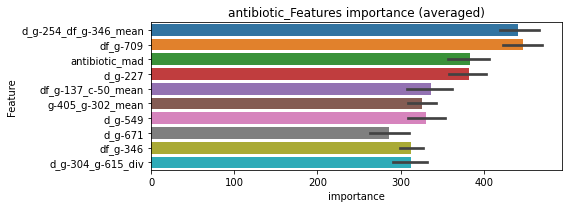

len(train_index) : 2843
len(valid_index) : 948
================================= fold 1/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103954	valid_1's binary_logloss: 0.143935
[200]	training's binary_logloss: 0.0343339	valid_1's binary_logloss: 0.0682692
[300]	training's binary_logloss: 0.0128528	valid_1's binary_logloss: 0.038589
[400]	training's binary_logloss: 0.00556368	valid_1's binary_logloss: 0.0249367
[500]	training's binary_logloss: 0.00284673	valid_1's binary_logloss: 0.0185157
[600]	training's binary_logloss: 0.00174593	valid_1's binary_logloss: 0.0156366
[700]	training's binary_logloss: 0.00122837	valid_1's binary_logloss: 0.013648
[800]	training's binary_logloss: 0.000950309	valid_1's binary_logloss: 0.0127637
[900]	training's binary_logloss: 0.000780962	valid_1's binary_logloss: 0.0121731
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000735139	valid_1's binary_logloss: 0.0119481


len(train_index) : 2843
len(valid_index) : 948
================================= fold 2/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105223	valid_1's binary_logloss: 0.143952
[200]	training's binary_logloss: 0.0345232	valid_1's binary_logloss: 0.0674955
[300]	training's binary_logloss: 0.0128472	valid_1's binary_logloss: 0.0385827
[400]	training's binary_logloss: 0.00551946	valid_1's binary_logloss: 0.0260688
[500]	training's binary_logloss: 0.00282786	valid_1's binary_logloss: 0.0202117
[600]	training's binary_logloss: 0.00175722	valid_1's binary_logloss: 0.0173203
[700]	training's binary_logloss: 0.00123322	valid_1's binary_logloss: 0.0156387
[800]	training's binary_logloss: 0.000952387	valid_1's binary_logloss: 0.0146489
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.000898088	valid_1's binary_logloss: 0.0143939


len(train_index) : 2843
len(valid_index) : 948
================================= fold 3/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103729	valid_1's binary_logloss: 0.149387
[200]	training's binary_logloss: 0.033115	valid_1's binary_logloss: 0.0680925
[300]	training's binary_logloss: 0.0120886	valid_1's binary_logloss: 0.0357953
[400]	training's binary_logloss: 0.00521827	valid_1's binary_logloss: 0.0234003
[500]	training's binary_logloss: 0.00276459	valid_1's binary_logloss: 0.0174286
[600]	training's binary_logloss: 0.00171159	valid_1's binary_logloss: 0.0138893
[700]	training's binary_logloss: 0.00121261	valid_1's binary_logloss: 0.0122341
[800]	training's binary_logloss: 0.000941729	valid_1's binary_logloss: 0.0110227
[900]	training's binary_logloss: 0.000779477	valid_1's binary_logloss: 0.0101871
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000738858	valid_1's binary_logloss: 0.0100214


len(train_index) : 2844
len(valid_index) : 947
================================= fold 4/4 antibiotic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10542	valid_1's binary_logloss: 0.141533
[200]	training's binary_logloss: 0.0350481	valid_1's binary_logloss: 0.0661626
[300]	training's binary_logloss: 0.0131665	valid_1's binary_logloss: 0.0364648
[400]	training's binary_logloss: 0.00573674	valid_1's binary_logloss: 0.0239427
[500]	training's binary_logloss: 0.00294083	valid_1's binary_logloss: 0.018009
[600]	training's binary_logloss: 0.00178012	valid_1's binary_logloss: 0.0152782
[700]	training's binary_logloss: 0.0012438	valid_1's binary_logloss: 0.0140012
[800]	training's binary_logloss: 0.000960156	valid_1's binary_logloss: 0.0132486
[900]	training's binary_logloss: 0.000789602	valid_1's binary_logloss: 0.0127747
[1000]	training's binary_logloss: 0.000684561	valid_1's binary_logloss: 0.0125843
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000700464	valid_1's binary_logloss: 0.0125489


antibiotic logloss: 0.012228008682052096


neg labels: 3289 → selected neg labels: 3286


anticonvulsant, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0750603	valid_1's binary_logloss: 0.0980974
[200]	training's binary_logloss: 0.0200911	valid_1's binary_logloss: 0.0361375
[300]	training's binary_logloss: 0.00646685	valid_1's binary_logloss: 0.0165215
[400]	training's binary_logloss: 0.0026398	valid_1's binary_logloss: 0.00970161
[500]	training's binary_logloss: 0.00137806	valid_1's binary_logloss: 0.00678495
[600]	training's binary_logloss: 0.000881119	valid_1's binary_logloss: 0.00555064
[700]	training's binary_logloss: 0.000648023	valid_1's binary_logloss: 0.00481597
[800]	training's binary_logloss: 0.000522046	valid_1's binary_logloss: 0.00432248
[900]	training's binary_logloss: 0.000470806	valid_1's binary_logloss: 0.00415355
[1000]	training's binary_logloss: 0.000453186	valid_1's binary_logloss: 0.00410299
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.000454165	valid_1's binary_logloss: 0.0041011
Training unti

1 / 3 AUC score:1.000
y_Threshold: 0.0052271, Threshold: 0.0187270, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01311, conf_1:0.02435
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0187270
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0687270
Num_p_label: 3.0, Expected: 3.0, Adj_threshold_3: 0.1187270
threshold: 0.1187270, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0730572	valid_1's binary_logloss: 0.0939782
[200]	training's binary_logloss: 0.0184267	valid_1's binary_logloss: 0.032334
[300]	training's binary_logloss: 0.00581383	valid_1's binary_logloss: 0.0136035
[400]	training's binary_logloss: 0.00233882	valid_1's binary_logloss: 0.00717702
[500]	training's binary_logloss: 0.00123117	valid_1's binary_logloss: 0.0047697
[600]	training's binary_logloss: 0.000787746	valid_1's binary_logloss: 0.00353787
[700]	training's binary_logloss: 0.000579023	valid_1's binary_logloss: 0.00287151
[800]	training's binary_logloss: 0.000472807	valid_1's binary_logloss: 0.00265936
[900]	training's binary_logloss: 0.000428961	valid_1's binary_logloss: 0.00256264
[1000]	training's binary_logloss: 0.000419623	valid_1's binary_logloss: 0.00251711
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.000419781	valid_1's binary_logloss: 0.00251705
Training unti

2 / 3 AUC score:1.000
y_Threshold: 0.1466140, Threshold: 0.1187270, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.09498, conf_1:0.14247
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.1187270
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_2: 0.1687270
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.2187270
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.2687270
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.3187270
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.3687270
threshold: 0.3687270, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735699	valid_1's binary_logloss: 0.0963665
[200]	training's binary_logloss: 0.0185149	valid_1's binary_logloss: 0.0357976
[300]	training's binary_logloss: 0.00561821	valid_1's binary_logloss: 0.0185575
[400]	training's binary_logloss: 0.00228161	valid_1's binary_logloss: 0.0126584
[500]	training's binary_logloss: 0.00119158	valid_1's binary_logloss: 0.0105099
[600]	training's binary_logloss: 0.000771164	valid_1's binary_logloss: 0.00967198
[700]	training's binary_logloss: 0.000570414	valid_1's binary_logloss: 0.00926516
[800]	training's binary_logloss: 0.000465768	valid_1's binary_logloss: 0.00894344
Early stopping, best iteration is:
[781]	training's binary_logloss: 0.000480024	valid_1's binary_logloss: 0.00891714
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0741748	valid_1's binary_logloss: 0.0995569
[200]	training's binary_logloss: 0.018

3 / 3 AUC score:1.000
y_Threshold: 0.0888615, Threshold: 0.3687270, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.33185, conf_1:0.40560
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.3687270
threshold: 0.3687270, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 654.0/3805, y_label_rate: 0.1718791


len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0741694	valid_1's binary_logloss: 0.0924954
[200]	training's binary_logloss: 0.0185685	valid_1's binary_logloss: 0.0319286
[300]	training's binary_logloss: 0.00580966	valid_1's binary_logloss: 0.0140824
[400]	training's binary_logloss: 0.00231142	valid_1's binary_logloss: 0.00740733
[500]	training's binary_logloss: 0.00120172	valid_1's binary_logloss: 0.00507021
[600]	training's binary_logloss: 0.000774105	valid_1's binary_logloss: 0.00387476
[700]	training's binary_logloss: 0.000568818	valid_1's binary_logloss: 0.00318614
[800]	training's binary_logloss: 0.00046864	valid_1's binary_logloss: 0.00282418
[900]	training's binary_logloss: 0.000421695	valid_1's binary_logloss: 0.00265886
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000428176	valid_1's binary_logloss: 0.00264587


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0731671	valid_1's binary_logloss: 0.0993509
[200]	training's binary_logloss: 0.0182578	valid_1's binary_logloss: 0.0346983
[300]	training's binary_logloss: 0.0056485	valid_1's binary_logloss: 0.0148776
[400]	training's binary_logloss: 0.00225409	valid_1's binary_logloss: 0.00821503
[500]	training's binary_logloss: 0.00118941	valid_1's binary_logloss: 0.00543463
[600]	training's binary_logloss: 0.000766539	valid_1's binary_logloss: 0.00412931
[700]	training's binary_logloss: 0.000563664	valid_1's binary_logloss: 0.00341896
[800]	training's binary_logloss: 0.000463352	valid_1's binary_logloss: 0.00312796
[900]	training's binary_logloss: 0.000420227	valid_1's binary_logloss: 0.00297323
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.000420227	valid_1's binary_logloss: 0.00297323


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0752272	valid_1's binary_logloss: 0.0924245
[200]	training's binary_logloss: 0.0189512	valid_1's binary_logloss: 0.0302229
[300]	training's binary_logloss: 0.00584789	valid_1's binary_logloss: 0.0125703
[400]	training's binary_logloss: 0.0023426	valid_1's binary_logloss: 0.00688523
[500]	training's binary_logloss: 0.00120936	valid_1's binary_logloss: 0.00435121
[600]	training's binary_logloss: 0.000776338	valid_1's binary_logloss: 0.00332795
[700]	training's binary_logloss: 0.000571113	valid_1's binary_logloss: 0.00278244
[800]	training's binary_logloss: 0.000468769	valid_1's binary_logloss: 0.00250471
[900]	training's binary_logloss: 0.000427819	valid_1's binary_logloss: 0.00240902
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.000422608	valid_1's binary_logloss: 0.00238638


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 anticonvulsant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.073582	valid_1's binary_logloss: 0.0963499
[200]	training's binary_logloss: 0.0181028	valid_1's binary_logloss: 0.032538
[300]	training's binary_logloss: 0.00551969	valid_1's binary_logloss: 0.0143145
[400]	training's binary_logloss: 0.00222822	valid_1's binary_logloss: 0.00835394
[500]	training's binary_logloss: 0.00118242	valid_1's binary_logloss: 0.0060384
[600]	training's binary_logloss: 0.000765184	valid_1's binary_logloss: 0.00504797
[700]	training's binary_logloss: 0.000566265	valid_1's binary_logloss: 0.00453139
[800]	training's binary_logloss: 0.000466745	valid_1's binary_logloss: 0.00416382
[900]	training's binary_logloss: 0.000424098	valid_1's binary_logloss: 0.00397524
Early stopping, best iteration is:
[946]	training's binary_logloss: 0.000414989	valid_1's binary_logloss: 0.00395309


anticonvulsant logloss: 0.0029944536030119574


neg labels: 3289 → selected neg labels: 3286


antifungal, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804036	valid_1's binary_logloss: 0.117364
[200]	training's binary_logloss: 0.023348	valid_1's binary_logloss: 0.0520056
[300]	training's binary_logloss: 0.00803578	valid_1's binary_logloss: 0.0302634
[400]	training's binary_logloss: 0.00336356	valid_1's binary_logloss: 0.0215897
[500]	training's binary_logloss: 0.00173342	valid_1's binary_logloss: 0.018109
[600]	training's binary_logloss: 0.00109101	valid_1's binary_logloss: 0.0161244
[700]	training's binary_logloss: 0.000792743	valid_1's binary_logloss: 0.0154722
[800]	training's binary_logloss: 0.000629531	valid_1's binary_logloss: 0.0151658
[900]	training's binary_logloss: 0.000541812	valid_1's binary_logloss: 0.0150299
Early stopping, best iteration is:
[879]	training's binary_logloss: 0.000553815	valid_1's binary_logloss: 0.0150066
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.081785	va

1 / 3 AUC score:1.000
y_Threshold: 0.0070535, Threshold: 0.0919450, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.06436, conf_1:0.11953
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0919450
Num_p_label: 28.0, Expected: 4.3, Adj_threshold_2: 0.1419450
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_3: 0.1919450
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_4: 0.2419450
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_5: 0.2919450
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_6: 0.3419450
Num_p_label: 9.0, Expected: 4.3, Adj_threshold_7: 0.3919450
threshold: 0.3919450, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0774356	valid_1's binary_logloss: 0.105181
[200]	training's binary_logloss: 0.0206165	valid_1's binary_logloss: 0.0395107
[300]	training's binary_logloss: 0.0067397	valid_1's binary_logloss: 0.0184251
[400]	training's binary_logloss: 0.00277243	valid_1's binary_logloss: 0.0100394
[500]	training's binary_logloss: 0.00145425	valid_1's binary_logloss: 0.0067127
[600]	training's binary_logloss: 0.000935422	valid_1's binary_logloss: 0.005143
[700]	training's binary_logloss: 0.000687358	valid_1's binary_logloss: 0.00438789
[800]	training's binary_logloss: 0.000549213	valid_1's binary_logloss: 0.00388339
[900]	training's binary_logloss: 0.000484286	valid_1's binary_logloss: 0.00366777
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000474832	valid_1's binary_logloss: 0.00365862
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775

2 / 3 AUC score:1.000
y_Threshold: 0.1072843, Threshold: 0.3919450, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0080362 Vs.target_rate: 0.00109, Num_p_label: 32.0, conf_0:0.31356, conf_1:0.47033
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_1: 0.3919450
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_2: 0.4419450
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_3: 0.4919450
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_4: 0.5419450
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_5: 0.5919450
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_6: 0.6419450
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_7: 0.6919450
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_8: 0.7419450
threshold: 0.7419450, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0774356	valid_1's binary_logloss: 0.105181
[200]	training's binary_logloss: 0.0206165	valid_1's binary_logloss: 0.0395107
[300]	training's binary_logloss: 0.0067397	valid_1's binary_logloss: 0.0184251
[400]	training's binary_logloss: 0.00277243	valid_1's binary_logloss: 0.0100394
[500]	training's binary_logloss: 0.00145425	valid_1's binary_logloss: 0.0067127
[600]	training's binary_logloss: 0.000935422	valid_1's binary_logloss: 0.005143
[700]	training's binary_logloss: 0.000687358	valid_1's binary_logloss: 0.00438789
[800]	training's binary_logloss: 0.000549213	valid_1's binary_logloss: 0.00388339
[900]	training's binary_logloss: 0.000484286	valid_1's binary_logloss: 0.00366777
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000474832	valid_1's binary_logloss: 0.00365862
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775

3 / 3 AUC score:1.000
y_Threshold: 0.1072843, Threshold: 0.7419450, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0025113 Vs.target_rate: 0.00109, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_1: 0.7419450
threshold: 0.7419450, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0767897	valid_1's binary_logloss: 0.103371
[200]	training's binary_logloss: 0.0207761	valid_1's binary_logloss: 0.0400891
[300]	training's binary_logloss: 0.0066531	valid_1's binary_logloss: 0.0181556
[400]	training's binary_logloss: 0.00274364	valid_1's binary_logloss: 0.0103468
[500]	training's binary_logloss: 0.00144863	valid_1's binary_logloss: 0.00709023
[600]	training's binary_logloss: 0.000930793	valid_1's binary_logloss: 0.00551127
[700]	training's binary_logloss: 0.000688374	valid_1's binary_logloss: 0.00475912
[800]	training's binary_logloss: 0.000552483	valid_1's binary_logloss: 0.00427557
[900]	training's binary_logloss: 0.000483089	valid_1's binary_logloss: 0.00399088
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000469352	valid_1's binary_logloss: 0.00397467


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0785572	valid_1's binary_logloss: 0.104953
[200]	training's binary_logloss: 0.0208079	valid_1's binary_logloss: 0.0376287
[300]	training's binary_logloss: 0.00674318	valid_1's binary_logloss: 0.0166514
[400]	training's binary_logloss: 0.00276638	valid_1's binary_logloss: 0.00928342
[500]	training's binary_logloss: 0.00146764	valid_1's binary_logloss: 0.00659277
[600]	training's binary_logloss: 0.000944604	valid_1's binary_logloss: 0.00524061
[700]	training's binary_logloss: 0.000694332	valid_1's binary_logloss: 0.00458302
[800]	training's binary_logloss: 0.000555602	valid_1's binary_logloss: 0.00425674
[900]	training's binary_logloss: 0.000486025	valid_1's binary_logloss: 0.0040759
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000480541	valid_1's binary_logloss: 0.00407501


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775733	valid_1's binary_logloss: 0.0933834
[200]	training's binary_logloss: 0.0209407	valid_1's binary_logloss: 0.0318763
[300]	training's binary_logloss: 0.00674536	valid_1's binary_logloss: 0.0134516
[400]	training's binary_logloss: 0.00275227	valid_1's binary_logloss: 0.00696291
[500]	training's binary_logloss: 0.00147711	valid_1's binary_logloss: 0.00447004
[600]	training's binary_logloss: 0.000954747	valid_1's binary_logloss: 0.00336006
[700]	training's binary_logloss: 0.00069778	valid_1's binary_logloss: 0.0027271
[800]	training's binary_logloss: 0.000559028	valid_1's binary_logloss: 0.0023637
[900]	training's binary_logloss: 0.000485099	valid_1's binary_logloss: 0.00216592
[1000]	training's binary_logloss: 0.000469901	valid_1's binary_logloss: 0.00213436
Early stopping, best iteration is:
[974]	training's binary_logloss: 0.00047004	valid_1's binary_logloss: 0.00213412


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 antifungal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0768707	valid_1's binary_logloss: 0.101362
[200]	training's binary_logloss: 0.0206608	valid_1's binary_logloss: 0.0376118
[300]	training's binary_logloss: 0.0067164	valid_1's binary_logloss: 0.0172031
[400]	training's binary_logloss: 0.00278231	valid_1's binary_logloss: 0.0100311
[500]	training's binary_logloss: 0.00147101	valid_1's binary_logloss: 0.00698655
[600]	training's binary_logloss: 0.000946275	valid_1's binary_logloss: 0.00547504
[700]	training's binary_logloss: 0.000696626	valid_1's binary_logloss: 0.0047138
[800]	training's binary_logloss: 0.000560567	valid_1's binary_logloss: 0.00426196
[900]	training's binary_logloss: 0.000486353	valid_1's binary_logloss: 0.00402915
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000477675	valid_1's binary_logloss: 0.00401769


antifungal logloss: 0.003554158458223364


neg labels: 3289 → selected neg labels: 3288


antihistamine, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718786	valid_1's binary_logloss: 0.0950933
[200]	training's binary_logloss: 0.0197923	valid_1's binary_logloss: 0.0368056
[300]	training's binary_logloss: 0.00624024	valid_1's binary_logloss: 0.0175879
[400]	training's binary_logloss: 0.00246953	valid_1's binary_logloss: 0.0110935
[500]	training's binary_logloss: 0.00128911	valid_1's binary_logloss: 0.00883949
[600]	training's binary_logloss: 0.000849113	valid_1's binary_logloss: 0.00787223
[700]	training's binary_logloss: 0.00061806	valid_1's binary_logloss: 0.00722988
[800]	training's binary_logloss: 0.000511123	valid_1's binary_logloss: 0.00699661
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000489644	valid_1's binary_logloss: 0.00688497
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0722355	valid_1's binary_logloss: 0.0965352
[200]	training's binary_logloss: 0.019

1 / 3 AUC score:1.000
y_Threshold: 0.0049012, Threshold: 0.1789023, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.12523, conf_1:0.23257
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.1789023
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_2: 0.2289023
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_3: 0.2789023
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_4: 0.3289023
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_5: 0.3789023
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_6: 0.4289023
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_7: 0.4789023
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_8: 0.5289023
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.5789023
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.6289023
threshold: 0.6789023, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0691222	valid_1's binary_logloss: 0.0913581
[200]	training's binary_logloss: 0.0171135	valid_1's binary_logloss: 0.0324419
[300]	training's binary_logloss: 0.00514839	valid_1's binary_logloss: 0.0136254
[400]	training's binary_logloss: 0.00204607	valid_1's binary_logloss: 0.00781758
[500]	training's binary_logloss: 0.00106768	valid_1's binary_logloss: 0.00526156
[600]	training's binary_logloss: 0.000696306	valid_1's binary_logloss: 0.00414409
[700]	training's binary_logloss: 0.000512524	valid_1's binary_logloss: 0.00341099
[800]	training's binary_logloss: 0.000433593	valid_1's binary_logloss: 0.00308713
[900]	training's binary_logloss: 0.000406026	valid_1's binary_logloss: 0.00297878
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000400692	valid_1's binary_logloss: 0.00295356
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1551385, Threshold: 0.6789023, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3807
p_label_rate: 0.0102963 Vs.target_rate: 0.00076, Num_p_label: 41.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 41.0, Expected: 3.0, Adj_threshold_1: 0.6789023
Num_p_label: 37.0, Expected: 3.0, Adj_threshold_2: 0.7289023
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_3: 0.7789023
threshold: 0.7789023, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 654.0/3807, y_label_rate: 0.1717888
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0671105	valid_1's binary_logloss: 0.0903071
[200]	training's binary_logloss: 0.0162762	valid_1's binary_logloss: 0.0340609
[300]	training's binary_logloss: 0.00498915	valid_1's binary_logloss: 0.0160368
[400]	training's binary_logloss: 0.00200427	valid_1's binary_logloss: 0.00981744
[500]	training's binary_logloss: 0.00104946	valid_1's binary_logloss: 0.00704999
[600]	training's binary_logloss: 0.000677071	valid_1's binary_logloss: 0.00559976
[700]	training's binary_logloss: 0.000498676	valid_1's binary_logloss: 0.00491078
[800]	training's binary_logloss: 0.000422918	valid_1's binary_logloss: 0.00459157
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000402529	valid_1's binary_logloss: 0.00453418
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.068016	valid_1's binary_logloss: 0.0855028
[200]	training's binary_logloss: 0.01

3 / 3 AUC score:1.000
y_Threshold: 0.2312468, Threshold: 0.7789023, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0070316 Vs.target_rate: 0.00076, Num_p_label: 28.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 28.0, Expected: 3.0, Adj_threshold_1: 0.7789023
threshold: 0.7789023, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 653.0/3805, y_label_rate: 0.1716163


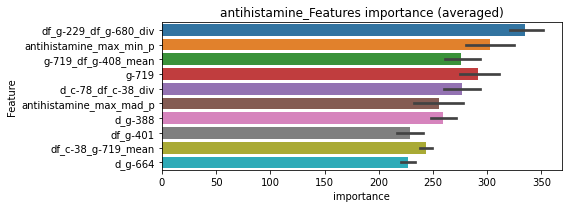

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0694516	valid_1's binary_logloss: 0.0834169
[200]	training's binary_logloss: 0.0170272	valid_1's binary_logloss: 0.0271398
[300]	training's binary_logloss: 0.0050985	valid_1's binary_logloss: 0.0109643
[400]	training's binary_logloss: 0.00203172	valid_1's binary_logloss: 0.00580321
[500]	training's binary_logloss: 0.00105801	valid_1's binary_logloss: 0.00391415
[600]	training's binary_logloss: 0.000682927	valid_1's binary_logloss: 0.00296731
[700]	training's binary_logloss: 0.000506715	valid_1's binary_logloss: 0.00255451
[800]	training's binary_logloss: 0.000423866	valid_1's binary_logloss: 0.00234654
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.000404469	valid_1's binary_logloss: 0.00229336


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0681825	valid_1's binary_logloss: 0.0890666
[200]	training's binary_logloss: 0.0165864	valid_1's binary_logloss: 0.0299573
[300]	training's binary_logloss: 0.00497839	valid_1's binary_logloss: 0.0120466
[400]	training's binary_logloss: 0.00201045	valid_1's binary_logloss: 0.00633853
[500]	training's binary_logloss: 0.001057	valid_1's binary_logloss: 0.00392711
[600]	training's binary_logloss: 0.00068484	valid_1's binary_logloss: 0.00294207
[700]	training's binary_logloss: 0.000505215	valid_1's binary_logloss: 0.00228724
[800]	training's binary_logloss: 0.000429879	valid_1's binary_logloss: 0.00211637
[900]	training's binary_logloss: 0.000400608	valid_1's binary_logloss: 0.00200888
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000400608	valid_1's binary_logloss: 0.00200888


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680672	valid_1's binary_logloss: 0.0786065
[200]	training's binary_logloss: 0.0168444	valid_1's binary_logloss: 0.0249318
[300]	training's binary_logloss: 0.0051285	valid_1's binary_logloss: 0.00984206
[400]	training's binary_logloss: 0.0020437	valid_1's binary_logloss: 0.00501153
[500]	training's binary_logloss: 0.00107232	valid_1's binary_logloss: 0.00318791
[600]	training's binary_logloss: 0.000693167	valid_1's binary_logloss: 0.00237194
[700]	training's binary_logloss: 0.000511004	valid_1's binary_logloss: 0.00193149
[800]	training's binary_logloss: 0.000432552	valid_1's binary_logloss: 0.00175648
[900]	training's binary_logloss: 0.00040942	valid_1's binary_logloss: 0.00169399
[1000]	training's binary_logloss: 0.000399123	valid_1's binary_logloss: 0.00166464
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.000399123	valid_1's binary_logloss: 0.00166464


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 antihistamine=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676675	valid_1's binary_logloss: 0.0962091
[200]	training's binary_logloss: 0.0163771	valid_1's binary_logloss: 0.0352736
[300]	training's binary_logloss: 0.00491239	valid_1's binary_logloss: 0.0160203
[400]	training's binary_logloss: 0.00196001	valid_1's binary_logloss: 0.00923049
[500]	training's binary_logloss: 0.00103413	valid_1's binary_logloss: 0.00647065
[600]	training's binary_logloss: 0.000669547	valid_1's binary_logloss: 0.0051327
[700]	training's binary_logloss: 0.000499352	valid_1's binary_logloss: 0.00433546
[800]	training's binary_logloss: 0.000423166	valid_1's binary_logloss: 0.00396608
[900]	training's binary_logloss: 0.00039666	valid_1's binary_logloss: 0.00380772
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000395031	valid_1's binary_logloss: 0.00379379


antihistamine logloss: 0.002440126343923025


neg labels: 3289 → selected neg labels: 3287


antimalarial, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07415	valid_1's binary_logloss: 0.0879591
[200]	training's binary_logloss: 0.0189998	valid_1's binary_logloss: 0.027185
[300]	training's binary_logloss: 0.00551685	valid_1's binary_logloss: 0.00968975
[400]	training's binary_logloss: 0.00211341	valid_1's binary_logloss: 0.00465322
[500]	training's binary_logloss: 0.00109495	valid_1's binary_logloss: 0.00293027
[600]	training's binary_logloss: 0.000711766	valid_1's binary_logloss: 0.00213369
[700]	training's binary_logloss: 0.000536958	valid_1's binary_logloss: 0.00176117
[800]	training's binary_logloss: 0.00044256	valid_1's binary_logloss: 0.0015396
[900]	training's binary_logloss: 0.000413531	valid_1's binary_logloss: 0.00149096
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000408133	valid_1's binary_logloss: 0.00147766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0032371, Threshold: 0.0196968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01379, conf_1:0.02561
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0196968
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_2: 0.0696968
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_3: 0.1196968
threshold: 0.1196968, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.072216	valid_1's binary_logloss: 0.0855768
[200]	training's binary_logloss: 0.0178256	valid_1's binary_logloss: 0.0250984
[300]	training's binary_logloss: 0.00510839	valid_1's binary_logloss: 0.0087727
[400]	training's binary_logloss: 0.00194365	valid_1's binary_logloss: 0.00387567
[500]	training's binary_logloss: 0.00101202	valid_1's binary_logloss: 0.00231356
[600]	training's binary_logloss: 0.00065678	valid_1's binary_logloss: 0.00163614
[700]	training's binary_logloss: 0.000492321	valid_1's binary_logloss: 0.00131577
[800]	training's binary_logloss: 0.000414588	valid_1's binary_logloss: 0.00116022
[900]	training's binary_logloss: 0.000387737	valid_1's binary_logloss: 0.00111682
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.000388102	valid_1's binary_logloss: 0.00111638
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0948559, Threshold: 0.1196968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00076, Num_p_label: 20.0, conf_0:0.09576, conf_1:0.14364
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_1: 0.1196968
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.1696968
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.2196968
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.2696968
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.3196968
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.3696968
threshold: 0.3696968, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.072216	valid_1's binary_logloss: 0.0855768
[200]	training's binary_logloss: 0.0178256	valid_1's binary_logloss: 0.0250984
[300]	training's binary_logloss: 0.00510839	valid_1's binary_logloss: 0.0087727
[400]	training's binary_logloss: 0.00194365	valid_1's binary_logloss: 0.00387567
[500]	training's binary_logloss: 0.00101202	valid_1's binary_logloss: 0.00231356
[600]	training's binary_logloss: 0.00065678	valid_1's binary_logloss: 0.00163614
[700]	training's binary_logloss: 0.000492321	valid_1's binary_logloss: 0.00131577
[800]	training's binary_logloss: 0.000414588	valid_1's binary_logloss: 0.00116022
[900]	training's binary_logloss: 0.000387737	valid_1's binary_logloss: 0.00111682
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.000388102	valid_1's binary_logloss: 0.00111638
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0948559, Threshold: 0.3696968, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.33273, conf_1:0.40667
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_1: 0.3696968
threshold: 0.3696968, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


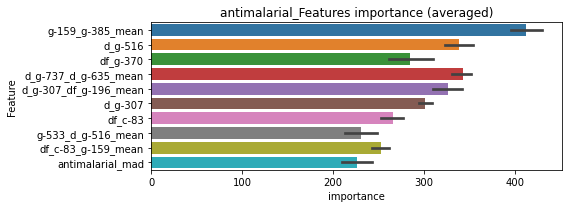

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732583	valid_1's binary_logloss: 0.0873518
[200]	training's binary_logloss: 0.0181347	valid_1's binary_logloss: 0.0263933
[300]	training's binary_logloss: 0.00515829	valid_1's binary_logloss: 0.0093611
[400]	training's binary_logloss: 0.00194628	valid_1's binary_logloss: 0.00431454
[500]	training's binary_logloss: 0.00100434	valid_1's binary_logloss: 0.00253327
[600]	training's binary_logloss: 0.000665909	valid_1's binary_logloss: 0.00191086
[700]	training's binary_logloss: 0.00049812	valid_1's binary_logloss: 0.00154035
[800]	training's binary_logloss: 0.000415955	valid_1's binary_logloss: 0.00133743
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000399922	valid_1's binary_logloss: 0.0012993


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718733	valid_1's binary_logloss: 0.0898526
[200]	training's binary_logloss: 0.0178149	valid_1's binary_logloss: 0.0299298
[300]	training's binary_logloss: 0.00514411	valid_1's binary_logloss: 0.0123356
[400]	training's binary_logloss: 0.00191414	valid_1's binary_logloss: 0.00643493
[500]	training's binary_logloss: 0.000979654	valid_1's binary_logloss: 0.00420417
[600]	training's binary_logloss: 0.000638988	valid_1's binary_logloss: 0.00325353
[700]	training's binary_logloss: 0.000485775	valid_1's binary_logloss: 0.00276787
[800]	training's binary_logloss: 0.000404649	valid_1's binary_logloss: 0.002503
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000386387	valid_1's binary_logloss: 0.00245076


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738238	valid_1's binary_logloss: 0.0809406
[200]	training's binary_logloss: 0.0183151	valid_1's binary_logloss: 0.0221458
[300]	training's binary_logloss: 0.00518139	valid_1's binary_logloss: 0.0070037
[400]	training's binary_logloss: 0.00195117	valid_1's binary_logloss: 0.00286127
[500]	training's binary_logloss: 0.00101491	valid_1's binary_logloss: 0.00158517
[600]	training's binary_logloss: 0.000665096	valid_1's binary_logloss: 0.00108942
[700]	training's binary_logloss: 0.000498209	valid_1's binary_logloss: 0.000847958
[800]	training's binary_logloss: 0.000411968	valid_1's binary_logloss: 0.000719207
[900]	training's binary_logloss: 0.00039336	valid_1's binary_logloss: 0.000691125
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00039336	valid_1's binary_logloss: 0.000691125


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 antimalarial=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0731259	valid_1's binary_logloss: 0.0848132
[200]	training's binary_logloss: 0.0182662	valid_1's binary_logloss: 0.0254499
[300]	training's binary_logloss: 0.00520327	valid_1's binary_logloss: 0.00954098
[400]	training's binary_logloss: 0.00195481	valid_1's binary_logloss: 0.00476727
[500]	training's binary_logloss: 0.000999659	valid_1's binary_logloss: 0.00325197
[600]	training's binary_logloss: 0.00065495	valid_1's binary_logloss: 0.00259914
[700]	training's binary_logloss: 0.000494601	valid_1's binary_logloss: 0.0023121
[800]	training's binary_logloss: 0.000412439	valid_1's binary_logloss: 0.00214246
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000398154	valid_1's binary_logloss: 0.00213309


antimalarial logloss: 0.0016435673121118154


neg labels: 3289 → selected neg labels: 3281


antioxidant, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133079	valid_1's binary_logloss: 0.198061
[200]	training's binary_logloss: 0.0570214	valid_1's binary_logloss: 0.125682
[300]	training's binary_logloss: 0.0260323	valid_1's binary_logloss: 0.0902753
[400]	training's binary_logloss: 0.0129415	valid_1's binary_logloss: 0.0709385
[500]	training's binary_logloss: 0.00686286	valid_1's binary_logloss: 0.0603868
[600]	training's binary_logloss: 0.00403277	valid_1's binary_logloss: 0.0540523
[700]	training's binary_logloss: 0.00263511	valid_1's binary_logloss: 0.0507162
[800]	training's binary_logloss: 0.00189227	valid_1's binary_logloss: 0.0484188
[900]	training's binary_logloss: 0.00146335	valid_1's binary_logloss: 0.0465431
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.00136162	valid_1's binary_logloss: 0.0460561
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136695	valid_1'

1 / 3 AUC score:0.993
y_Threshold: 0.0237028, Threshold: 0.1119715, pos_neg_ratio: 0.8000000
Remove_noisy_data: 160 → Positive_corect_labels: 642/3777
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.07838, conf_1:0.14556
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1119715
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_2: 0.1619715
Num_p_label: 23.0, Expected: 12.2, Adj_threshold_3: 0.2119715
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_4: 0.2619715
Num_p_label: 18.0, Expected: 12.2, Adj_threshold_5: 0.3119715
threshold: 0.3119715, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 642.0/3777, y_label_rate: 0.1699762
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124575	valid_1's binary_logloss: 0.172312
[200]	training's binary_logloss: 0.048325	valid_1's binary_logloss: 0.0998152
[300]	training's binary_logloss: 0.0210886	valid_1's binary_logloss: 0.0697525
[400]	training's binary_logloss: 0.0101011	valid_1's binary_logloss: 0.0539269
[500]	training's binary_logloss: 0.0052814	valid_1's binary_logloss: 0.0462151
[600]	training's binary_logloss: 0.00310259	valid_1's binary_logloss: 0.0410729
[700]	training's binary_logloss: 0.00208042	valid_1's binary_logloss: 0.0380345
[800]	training's binary_logloss: 0.00152678	valid_1's binary_logloss: 0.0367408
[900]	training's binary_logloss: 0.00120247	valid_1's binary_logloss: 0.0351803
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.00119779	valid_1's binary_logloss: 0.0351311
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124228	valid_1's

2 / 3 AUC score:0.998
y_Threshold: 0.0941928, Threshold: 0.3119715, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 626.0/3745
p_label_rate: 0.0125565 Vs.target_rate: 0.00307, Num_p_label: 50.0, conf_0:0.24958, conf_1:0.37437
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_1: 0.3119715
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_2: 0.3619715
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_3: 0.4119715
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_4: 0.4619715
Num_p_label: 35.0, Expected: 12.2, Adj_threshold_5: 0.5119715
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_6: 0.5619715
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_7: 0.6119715
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_8: 0.6619715
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_9: 0.7119715
Num_p_label: 15.0, Expected: 12.2, Adj_threshold_10: 0.7619715
threshold: 0.7619715, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 626.0/3745, y_label_rate: 0.1671562

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120324	valid_1's binary_logloss: 0.172933
[200]	training's binary_logloss: 0.0455896	valid_1's binary_logloss: 0.104382
[300]	training's binary_logloss: 0.0189551	valid_1's binary_logloss: 0.0741676
[400]	training's binary_logloss: 0.00884224	valid_1's binary_logloss: 0.0599787
[500]	training's binary_logloss: 0.00464817	valid_1's binary_logloss: 0.0525211
[600]	training's binary_logloss: 0.00278421	valid_1's binary_logloss: 0.0488219
[700]	training's binary_logloss: 0.00186203	valid_1's binary_logloss: 0.0472241
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00200188	valid_1's binary_logloss: 0.0468954
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122303	valid_1's binary_logloss: 0.174134
[200]	training's binary_logloss: 0.045921	valid_1's binary_logloss: 0.102066
[300]	training's binary_logloss: 0.0194629	valid_1's bi

3 / 3 AUC score:0.998
y_Threshold: 0.1153705, Threshold: 0.7619715, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 611.0/3715
p_label_rate: 0.0065294 Vs.target_rate: 0.00307, Num_p_label: 26.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_1: 0.7619715
threshold: 0.7619715, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 611.0/3715, y_label_rate: 0.1644684


len(train_index) : 2786
len(valid_index) : 929
================================= fold 1/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115927	valid_1's binary_logloss: 0.159487
[200]	training's binary_logloss: 0.0424945	valid_1's binary_logloss: 0.085038
[300]	training's binary_logloss: 0.0184045	valid_1's binary_logloss: 0.0583534
[400]	training's binary_logloss: 0.00834037	valid_1's binary_logloss: 0.0435925
[500]	training's binary_logloss: 0.00431414	valid_1's binary_logloss: 0.0362568
[600]	training's binary_logloss: 0.00257919	valid_1's binary_logloss: 0.0323962
[700]	training's binary_logloss: 0.00173866	valid_1's binary_logloss: 0.0303791
Early stopping, best iteration is:
[743]	training's binary_logloss: 0.00151729	valid_1's binary_logloss: 0.0296005


len(train_index) : 2786
len(valid_index) : 929
================================= fold 2/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115593	valid_1's binary_logloss: 0.162849
[200]	training's binary_logloss: 0.0428107	valid_1's binary_logloss: 0.0853011
[300]	training's binary_logloss: 0.0185323	valid_1's binary_logloss: 0.0533681
[400]	training's binary_logloss: 0.00860354	valid_1's binary_logloss: 0.0375881
[500]	training's binary_logloss: 0.00447498	valid_1's binary_logloss: 0.0285031
[600]	training's binary_logloss: 0.00264856	valid_1's binary_logloss: 0.0243596
[700]	training's binary_logloss: 0.00177321	valid_1's binary_logloss: 0.0221299
[800]	training's binary_logloss: 0.00132044	valid_1's binary_logloss: 0.0203657
[900]	training's binary_logloss: 0.00105463	valid_1's binary_logloss: 0.0194788
[1000]	training's binary_logloss: 0.000898107	valid_1's binary_logloss: 0.0187891
[1100]	training's binary_logloss: 0.000817267	valid_1's binary_logloss: 0.0184145
[1200]	training's binary_logloss: 0.000758076	valid_1's bina

len(train_index) : 2786
len(valid_index) : 929
================================= fold 3/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116785	valid_1's binary_logloss: 0.173921
[200]	training's binary_logloss: 0.0427559	valid_1's binary_logloss: 0.101566
[300]	training's binary_logloss: 0.0180076	valid_1's binary_logloss: 0.0749235
[400]	training's binary_logloss: 0.00824104	valid_1's binary_logloss: 0.061772
[500]	training's binary_logloss: 0.00418667	valid_1's binary_logloss: 0.0548619
[600]	training's binary_logloss: 0.00248021	valid_1's binary_logloss: 0.0517508
[700]	training's binary_logloss: 0.00165891	valid_1's binary_logloss: 0.0498742
[800]	training's binary_logloss: 0.00123299	valid_1's binary_logloss: 0.0490843
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.00108601	valid_1's binary_logloss: 0.0484402


len(train_index) : 2787
len(valid_index) : 928
================================= fold 4/4 antioxidant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117091	valid_1's binary_logloss: 0.159145
[200]	training's binary_logloss: 0.0429463	valid_1's binary_logloss: 0.0832088
[300]	training's binary_logloss: 0.0181596	valid_1's binary_logloss: 0.0531058
[400]	training's binary_logloss: 0.00829862	valid_1's binary_logloss: 0.0386582
[500]	training's binary_logloss: 0.00423913	valid_1's binary_logloss: 0.0311603
[600]	training's binary_logloss: 0.00251318	valid_1's binary_logloss: 0.0272537
[700]	training's binary_logloss: 0.0017094	valid_1's binary_logloss: 0.0251037
[800]	training's binary_logloss: 0.00127705	valid_1's binary_logloss: 0.024019
[900]	training's binary_logloss: 0.00102492	valid_1's binary_logloss: 0.0233283
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.00101203	valid_1's binary_logloss: 0.0231895


antioxidant logloss: 0.02986090903210787


neg labels: 3289 → selected neg labels: 3283


antiprotozoal, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0988526	valid_1's binary_logloss: 0.142685
[200]	training's binary_logloss: 0.0341037	valid_1's binary_logloss: 0.0706817
[300]	training's binary_logloss: 0.0130201	valid_1's binary_logloss: 0.0397378
[400]	training's binary_logloss: 0.00560997	valid_1's binary_logloss: 0.0256526
[500]	training's binary_logloss: 0.00280521	valid_1's binary_logloss: 0.0184921
[600]	training's binary_logloss: 0.00170482	valid_1's binary_logloss: 0.014869
[700]	training's binary_logloss: 0.00118372	valid_1's binary_logloss: 0.0128682
[800]	training's binary_logloss: 0.00091097	valid_1's binary_logloss: 0.0117153
[900]	training's binary_logloss: 0.000755181	valid_1's binary_logloss: 0.0109472
[1000]	training's binary_logloss: 0.000688583	valid_1's binary_logloss: 0.0105795
Early stopping, best iteration is:
[1016]	training's binary_logloss: 0.000681023	valid_1's binary_logloss: 0.0105523
Training until validatio

1 / 3 AUC score:1.000
y_Threshold: 0.0115266, Threshold: 0.0826572, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05786, conf_1:0.10745
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0826572
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.1326572
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.1826572
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.2326572
threshold: 0.2326572, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0948139	valid_1's binary_logloss: 0.126461
[200]	training's binary_logloss: 0.0309944	valid_1's binary_logloss: 0.0595127
[300]	training's binary_logloss: 0.0113704	valid_1's binary_logloss: 0.0345726
[400]	training's binary_logloss: 0.00468526	valid_1's binary_logloss: 0.0234832
[500]	training's binary_logloss: 0.00236465	valid_1's binary_logloss: 0.0185556
[600]	training's binary_logloss: 0.00142709	valid_1's binary_logloss: 0.016316
[700]	training's binary_logloss: 0.00099678	valid_1's binary_logloss: 0.0149782
[800]	training's binary_logloss: 0.000777328	valid_1's binary_logloss: 0.0145262
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.00068461	valid_1's binary_logloss: 0.0143124
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933461	valid_1's binary_logloss: 0.139601
[200]	training's binary_logloss: 0.0296149	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.0802563, Threshold: 0.2326572, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 647.0/3789
p_label_rate: 0.0155701 Vs.target_rate: 0.00151, Num_p_label: 62.0, conf_0:0.18613, conf_1:0.27919
Num_p_label: 62.0, Expected: 6.0, Adj_threshold_1: 0.2326572
Num_p_label: 57.0, Expected: 6.0, Adj_threshold_2: 0.2826572
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_3: 0.3326572
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_4: 0.3826572
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_5: 0.4326572
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_6: 0.4826572
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_7: 0.5326572
Num_p_label: 30.0, Expected: 6.0, Adj_threshold_8: 0.5826572
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_9: 0.6326572
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_10: 0.6826572
threshold: 0.7326572, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3789, y_label_rate: 0.1707575
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917645	valid_1's binary_logloss: 0.12348
[200]	training's binary_logloss: 0.0288862	valid_1's binary_logloss: 0.0546679
[300]	training's binary_logloss: 0.0107941	valid_1's binary_logloss: 0.0292466
[400]	training's binary_logloss: 0.00450682	valid_1's binary_logloss: 0.0179834
[500]	training's binary_logloss: 0.00226085	valid_1's binary_logloss: 0.0122739
[600]	training's binary_logloss: 0.0013817	valid_1's binary_logloss: 0.0095241
[700]	training's binary_logloss: 0.000973659	valid_1's binary_logloss: 0.00821922
[800]	training's binary_logloss: 0.000756599	valid_1's binary_logloss: 0.00740507
[900]	training's binary_logloss: 0.00064021	valid_1's binary_logloss: 0.00695889
[1000]	training's binary_logloss: 0.000591927	valid_1's binary_logloss: 0.00680508
Early stopping, best iteration is:
[1047]	training's binary_logloss: 0.000576446	valid_1's binary_logloss: 0.0067202
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.1020548, Threshold: 0.7326572, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 643.0/3781
p_label_rate: 0.0055249 Vs.target_rate: 0.00151, Num_p_label: 22.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_1: 0.7326572
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.7826572
threshold: 0.7826572, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 643.0/3781, y_label_rate: 0.1700608


len(train_index) : 2835
len(valid_index) : 946
================================= fold 1/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0908985	valid_1's binary_logloss: 0.129472
[200]	training's binary_logloss: 0.0274193	valid_1's binary_logloss: 0.0560743
[300]	training's binary_logloss: 0.00978878	valid_1's binary_logloss: 0.0289446
[400]	training's binary_logloss: 0.00408148	valid_1's binary_logloss: 0.0177261
[500]	training's binary_logloss: 0.002073	valid_1's binary_logloss: 0.0125147
[600]	training's binary_logloss: 0.00129318	valid_1's binary_logloss: 0.0101904
[700]	training's binary_logloss: 0.000924154	valid_1's binary_logloss: 0.0087261
[800]	training's binary_logloss: 0.000721954	valid_1's binary_logloss: 0.00790127
[900]	training's binary_logloss: 0.00062412	valid_1's binary_logloss: 0.00753885
[1000]	training's binary_logloss: 0.000579315	valid_1's binary_logloss: 0.00733528
[1100]	training's binary_logloss: 0.000556033	valid_1's binary_logloss: 0.00723477
Early stopping, best iteration is:
[1106]	training's b

len(train_index) : 2836
len(valid_index) : 945
================================= fold 2/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907792	valid_1's binary_logloss: 0.121286
[200]	training's binary_logloss: 0.0280674	valid_1's binary_logloss: 0.0562677
[300]	training's binary_logloss: 0.0103678	valid_1's binary_logloss: 0.0331751
[400]	training's binary_logloss: 0.00427807	valid_1's binary_logloss: 0.0219851
[500]	training's binary_logloss: 0.002127	valid_1's binary_logloss: 0.0164197
[600]	training's binary_logloss: 0.00129179	valid_1's binary_logloss: 0.0133828
[700]	training's binary_logloss: 0.000910665	valid_1's binary_logloss: 0.0119801
[800]	training's binary_logloss: 0.000712918	valid_1's binary_logloss: 0.0109255
[900]	training's binary_logloss: 0.000622954	valid_1's binary_logloss: 0.0105454
[1000]	training's binary_logloss: 0.000581769	valid_1's binary_logloss: 0.0103855
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000579376	valid_1's binary_logloss: 0.0103221


len(train_index) : 2836
len(valid_index) : 945
================================= fold 3/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885025	valid_1's binary_logloss: 0.128881
[200]	training's binary_logloss: 0.0271295	valid_1's binary_logloss: 0.0628447
[300]	training's binary_logloss: 0.0096864	valid_1's binary_logloss: 0.0375102
[400]	training's binary_logloss: 0.00400399	valid_1's binary_logloss: 0.0265826
[500]	training's binary_logloss: 0.00205849	valid_1's binary_logloss: 0.0214647
[600]	training's binary_logloss: 0.00127567	valid_1's binary_logloss: 0.0186303
[700]	training's binary_logloss: 0.000911164	valid_1's binary_logloss: 0.0174901
[800]	training's binary_logloss: 0.000723282	valid_1's binary_logloss: 0.0165184
[900]	training's binary_logloss: 0.00062232	valid_1's binary_logloss: 0.0160507
[1000]	training's binary_logloss: 0.000577523	valid_1's binary_logloss: 0.0157806
Early stopping, best iteration is:
[998]	training's binary_logloss: 0.000577723	valid_1's binary_logloss: 0.015769


len(train_index) : 2836
len(valid_index) : 945
================================= fold 4/4 antiprotozoal=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0925013	valid_1's binary_logloss: 0.118699
[200]	training's binary_logloss: 0.0282664	valid_1's binary_logloss: 0.0496973
[300]	training's binary_logloss: 0.0102983	valid_1's binary_logloss: 0.0256187
[400]	training's binary_logloss: 0.00424749	valid_1's binary_logloss: 0.0159824
[500]	training's binary_logloss: 0.00213888	valid_1's binary_logloss: 0.0119452
[600]	training's binary_logloss: 0.00132205	valid_1's binary_logloss: 0.0102072
[700]	training's binary_logloss: 0.00093349	valid_1's binary_logloss: 0.00924684
[800]	training's binary_logloss: 0.000739979	valid_1's binary_logloss: 0.0087281
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000666455	valid_1's binary_logloss: 0.00835379


antiprotozoal logloss: 0.010416579367646188


neg labels: 3289 → selected neg labels: 3282


antiviral, len(trt): 23, len(othr): 3282, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0760985	valid_1's binary_logloss: 0.0999315
[200]	training's binary_logloss: 0.0212276	valid_1's binary_logloss: 0.039413
[300]	training's binary_logloss: 0.0068676	valid_1's binary_logloss: 0.0198017
[400]	training's binary_logloss: 0.00272921	valid_1's binary_logloss: 0.0120167
[500]	training's binary_logloss: 0.00140353	valid_1's binary_logloss: 0.00890116
[600]	training's binary_logloss: 0.000890619	valid_1's binary_logloss: 0.00756595
[700]	training's binary_logloss: 0.000648494	valid_1's binary_logloss: 0.0067733
[800]	training's binary_logloss: 0.000517224	valid_1's binary_logloss: 0.00629906
[900]	training's binary_logloss: 0.00045595	valid_1's binary_logloss: 0.00616339
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.000439111	valid_1's binary_logloss: 0.00610621
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.077

1 / 3 AUC score:1.000
y_Threshold: 0.0053434, Threshold: 0.0320595, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.02244, conf_1:0.04168
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0320595
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_2: 0.0820595
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_3: 0.1320595
threshold: 0.1320595, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0742909	valid_1's binary_logloss: 0.0946642
[200]	training's binary_logloss: 0.0195314	valid_1's binary_logloss: 0.0325557
[300]	training's binary_logloss: 0.00611052	valid_1's binary_logloss: 0.014083
[400]	training's binary_logloss: 0.00239473	valid_1's binary_logloss: 0.00794025
[500]	training's binary_logloss: 0.00122771	valid_1's binary_logloss: 0.00563507
[600]	training's binary_logloss: 0.000777852	valid_1's binary_logloss: 0.00443779
[700]	training's binary_logloss: 0.000568474	valid_1's binary_logloss: 0.00386302
[800]	training's binary_logloss: 0.000459621	valid_1's binary_logloss: 0.00354892
[900]	training's binary_logloss: 0.00041282	valid_1's binary_logloss: 0.0034387
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000419988	valid_1's binary_logloss: 0.00343787
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0361453, Threshold: 0.1320595, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0060271 Vs.target_rate: 0.00097, Num_p_label: 24.0, conf_0:0.10565, conf_1:0.15847
Num_p_label: 24.0, Expected: 3.8, Adj_threshold_1: 0.1320595
Num_p_label: 17.0, Expected: 3.8, Adj_threshold_2: 0.1820595
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_3: 0.2320595
Num_p_label: 12.0, Expected: 3.8, Adj_threshold_4: 0.2820595
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_5: 0.3320595
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_6: 0.3820595
threshold: 0.3820595, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0737771	valid_1's binary_logloss: 0.104527
[200]	training's binary_logloss: 0.0189842	valid_1's binary_logloss: 0.045314
[300]	training's binary_logloss: 0.00606379	valid_1's binary_logloss: 0.0279884
[400]	training's binary_logloss: 0.00239775	valid_1's binary_logloss: 0.0206282
[500]	training's binary_logloss: 0.00123423	valid_1's binary_logloss: 0.0169939
[600]	training's binary_logloss: 0.000781637	valid_1's binary_logloss: 0.0161148
[700]	training's binary_logloss: 0.000569684	valid_1's binary_logloss: 0.0153922
Early stopping, best iteration is:
[735]	training's binary_logloss: 0.000522408	valid_1's binary_logloss: 0.0150234
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0727627	valid_1's binary_logloss: 0.0917515
[200]	training's binary_logloss: 0.0184763	valid_1's binary_logloss: 0.0307541
[300]	training's binary_logloss: 0.00566395	va

3 / 3 AUC score:1.000
y_Threshold: 0.0703645, Threshold: 0.3820595, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0020090 Vs.target_rate: 0.00097, Num_p_label: 8.0, conf_0:0.34385, conf_1:0.42027
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_1: 0.3820595
threshold: 0.3820595, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3802, y_label_rate: 0.1720147


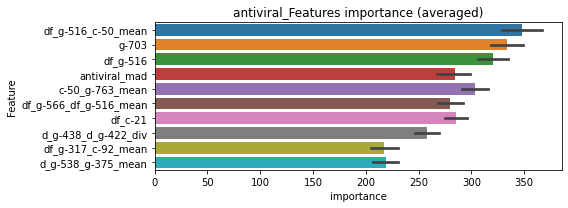

len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0727844	valid_1's binary_logloss: 0.105352
[200]	training's binary_logloss: 0.0191301	valid_1's binary_logloss: 0.0464107
[300]	training's binary_logloss: 0.00593539	valid_1's binary_logloss: 0.0277957
[400]	training's binary_logloss: 0.00234932	valid_1's binary_logloss: 0.0210061
[500]	training's binary_logloss: 0.00121724	valid_1's binary_logloss: 0.0180568
[600]	training's binary_logloss: 0.000781374	valid_1's binary_logloss: 0.0167425
[700]	training's binary_logloss: 0.000568821	valid_1's binary_logloss: 0.0160317
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000529099	valid_1's binary_logloss: 0.0157531


len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0719007	valid_1's binary_logloss: 0.0922041
[200]	training's binary_logloss: 0.0184674	valid_1's binary_logloss: 0.0317493
[300]	training's binary_logloss: 0.00572449	valid_1's binary_logloss: 0.0128608
[400]	training's binary_logloss: 0.00229198	valid_1's binary_logloss: 0.00637699
[500]	training's binary_logloss: 0.00119428	valid_1's binary_logloss: 0.00389445
[600]	training's binary_logloss: 0.000768694	valid_1's binary_logloss: 0.00283608
[700]	training's binary_logloss: 0.00056311	valid_1's binary_logloss: 0.00226678
[800]	training's binary_logloss: 0.000454661	valid_1's binary_logloss: 0.00195512
[900]	training's binary_logloss: 0.000411429	valid_1's binary_logloss: 0.00183142
Early stopping, best iteration is:
[951]	training's binary_logloss: 0.000400205	valid_1's binary_logloss: 0.00180736


len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0747725	valid_1's binary_logloss: 0.0880025
[200]	training's binary_logloss: 0.0194286	valid_1's binary_logloss: 0.0282214
[300]	training's binary_logloss: 0.00600549	valid_1's binary_logloss: 0.0111252
[400]	training's binary_logloss: 0.00236361	valid_1's binary_logloss: 0.00568287
[500]	training's binary_logloss: 0.0012229	valid_1's binary_logloss: 0.0036692
[600]	training's binary_logloss: 0.000782327	valid_1's binary_logloss: 0.00271822
[700]	training's binary_logloss: 0.000575659	valid_1's binary_logloss: 0.0023327
[800]	training's binary_logloss: 0.000463349	valid_1's binary_logloss: 0.00207159
[900]	training's binary_logloss: 0.00041709	valid_1's binary_logloss: 0.00195673
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000413684	valid_1's binary_logloss: 0.00194705


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 antiviral=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0726384	valid_1's binary_logloss: 0.0933235
[200]	training's binary_logloss: 0.0188254	valid_1's binary_logloss: 0.0347125
[300]	training's binary_logloss: 0.00580226	valid_1's binary_logloss: 0.0163915
[400]	training's binary_logloss: 0.0023066	valid_1's binary_logloss: 0.00959304
[500]	training's binary_logloss: 0.0011956	valid_1's binary_logloss: 0.00657431
[600]	training's binary_logloss: 0.000770396	valid_1's binary_logloss: 0.00514216
[700]	training's binary_logloss: 0.000567155	valid_1's binary_logloss: 0.00447138
[800]	training's binary_logloss: 0.000455532	valid_1's binary_logloss: 0.00404122
[900]	training's binary_logloss: 0.000411121	valid_1's binary_logloss: 0.00385983
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.0004	valid_1's binary_logloss: 0.00382448


antiviral logloss: 0.0058348750500457226


neg labels: 3289 → selected neg labels: 3283


apoptosis_stimulant, len(trt): 49, len(othr): 3283, target_rate: 0.0020576 → Adj_target_rate: 0.0022954
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110253	valid_1's binary_logloss: 0.178486
[200]	training's binary_logloss: 0.0400107	valid_1's binary_logloss: 0.101832
[300]	training's binary_logloss: 0.0164196	valid_1's binary_logloss: 0.0670843
[400]	training's binary_logloss: 0.00751714	valid_1's binary_logloss: 0.0491934
[500]	training's binary_logloss: 0.00391365	valid_1's binary_logloss: 0.040055
[600]	training's binary_logloss: 0.00236163	valid_1's binary_logloss: 0.0349693
[700]	training's binary_logloss: 0.00162545	valid_1's binary_logloss: 0.0319258
[800]	training's binary_logloss: 0.00122382	valid_1's binary_logloss: 0.0301771
[900]	training's binary_logloss: 0.00100119	valid_1's binary_logloss: 0.0292285
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00100892	valid_1's binary_logloss: 0.0291412
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111316	valid_1'

1 / 3 AUC score:0.999
y_Threshold: 0.0217561, Threshold: 0.2675014, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00206, Num_p_label: 40.0, conf_0:0.18725, conf_1:0.34775
Num_p_label: 40.0, Expected: 8.2, Adj_threshold_1: 0.2675014
Num_p_label: 28.0, Expected: 8.2, Adj_threshold_2: 0.3175014
Num_p_label: 22.0, Expected: 8.2, Adj_threshold_3: 0.3675014
Num_p_label: 18.0, Expected: 8.2, Adj_threshold_4: 0.4175014
threshold: 0.4175014, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10658	valid_1's binary_logloss: 0.158628
[200]	training's binary_logloss: 0.0366353	valid_1's binary_logloss: 0.0854835
[300]	training's binary_logloss: 0.0148019	valid_1's binary_logloss: 0.0552318
[400]	training's binary_logloss: 0.00663227	valid_1's binary_logloss: 0.0400715
[500]	training's binary_logloss: 0.00338072	valid_1's binary_logloss: 0.0326931
[600]	training's binary_logloss: 0.00207274	valid_1's binary_logloss: 0.0296208
[700]	training's binary_logloss: 0.00143114	valid_1's binary_logloss: 0.0274516
[800]	training's binary_logloss: 0.00108643	valid_1's binary_logloss: 0.0265983
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.00108401	valid_1's binary_logloss: 0.0265899
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105046	valid_1's binary_logloss: 0.155639
[200]	training's binary_logloss: 0.0358142	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.1469991, Threshold: 0.4175014, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 645.0/3785
p_label_rate: 0.0165746 Vs.target_rate: 0.00206, Num_p_label: 66.0, conf_0:0.33400, conf_1:0.50100
Num_p_label: 66.0, Expected: 8.2, Adj_threshold_1: 0.4175014
Num_p_label: 57.0, Expected: 8.2, Adj_threshold_2: 0.4675014
Num_p_label: 53.0, Expected: 8.2, Adj_threshold_3: 0.5175014
Num_p_label: 48.0, Expected: 8.2, Adj_threshold_4: 0.5675014
Num_p_label: 36.0, Expected: 8.2, Adj_threshold_5: 0.6175014
Num_p_label: 27.0, Expected: 8.2, Adj_threshold_6: 0.6675014
Num_p_label: 22.0, Expected: 8.2, Adj_threshold_7: 0.7175014
Num_p_label: 19.0, Expected: 8.2, Adj_threshold_8: 0.7675014
threshold: 0.7675014, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 645.0/3785, y_label_rate: 0.1704095
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100985	valid_1's binary_logloss: 0.153993
[200]	training's binary_logloss: 0.0341596	valid_1's binary_logloss: 0.0822761
[300]	training's binary_logloss: 0.0133812	valid_1's binary_logloss: 0.0504945
[400]	training's binary_logloss: 0.00583391	valid_1's binary_logloss: 0.0363808
[500]	training's binary_logloss: 0.00306495	valid_1's binary_logloss: 0.0284132
[600]	training's binary_logloss: 0.00190011	valid_1's binary_logloss: 0.0246628
[700]	training's binary_logloss: 0.00133485	valid_1's binary_logloss: 0.0217089
[800]	training's binary_logloss: 0.0010225	valid_1's binary_logloss: 0.0204595
[900]	training's binary_logloss: 0.000841207	valid_1's binary_logloss: 0.0193978
[1000]	training's binary_logloss: 0.000739607	valid_1's binary_logloss: 0.0190451
Early stopping, best iteration is:
[981]	training's binary_logloss: 0.000752882	valid_1's binary_logloss: 0.01893
Training until validation sc

3 / 3 AUC score:0.999
y_Threshold: 0.1216938, Threshold: 0.7675014, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 638.0/3771
p_label_rate: 0.0052737 Vs.target_rate: 0.00206, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 8.2, Adj_threshold_1: 0.7675014
threshold: 0.7675014, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 638.0/3771, y_label_rate: 0.1691859


len(train_index) : 2828
len(valid_index) : 943
================================= fold 1/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102656	valid_1's binary_logloss: 0.14753
[200]	training's binary_logloss: 0.0346288	valid_1's binary_logloss: 0.0714107
[300]	training's binary_logloss: 0.0132742	valid_1's binary_logloss: 0.038527
[400]	training's binary_logloss: 0.005902	valid_1's binary_logloss: 0.0240761
[500]	training's binary_logloss: 0.00300043	valid_1's binary_logloss: 0.0166558
[600]	training's binary_logloss: 0.0018429	valid_1's binary_logloss: 0.0132118
[700]	training's binary_logloss: 0.00129742	valid_1's binary_logloss: 0.0111844
[800]	training's binary_logloss: 0.00100265	valid_1's binary_logloss: 0.010091
[900]	training's binary_logloss: 0.000830911	valid_1's binary_logloss: 0.00922486
[1000]	training's binary_logloss: 0.00074168	valid_1's binary_logloss: 0.00891014
[1100]	training's binary_logloss: 0.000685241	valid_1's binary_logloss: 0.00868476
Early stopping, best iteration is:
[1101]	training's binary_log

len(train_index) : 2828
len(valid_index) : 943
================================= fold 2/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102186	valid_1's binary_logloss: 0.138038
[200]	training's binary_logloss: 0.0347905	valid_1's binary_logloss: 0.0687731
[300]	training's binary_logloss: 0.01348	valid_1's binary_logloss: 0.0408451
[400]	training's binary_logloss: 0.00591105	valid_1's binary_logloss: 0.0276547
[500]	training's binary_logloss: 0.00307225	valid_1's binary_logloss: 0.021271
[600]	training's binary_logloss: 0.00189477	valid_1's binary_logloss: 0.0180555
[700]	training's binary_logloss: 0.0013346	valid_1's binary_logloss: 0.0159623
[800]	training's binary_logloss: 0.00102652	valid_1's binary_logloss: 0.0147156
[900]	training's binary_logloss: 0.000843917	valid_1's binary_logloss: 0.0139308
[1000]	training's binary_logloss: 0.000738973	valid_1's binary_logloss: 0.0134459
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.0007221	valid_1's binary_logloss: 0.0133387


len(train_index) : 2828
len(valid_index) : 943
================================= fold 3/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0996049	valid_1's binary_logloss: 0.156671
[200]	training's binary_logloss: 0.0333443	valid_1's binary_logloss: 0.0872253
[300]	training's binary_logloss: 0.0131477	valid_1's binary_logloss: 0.0589283
[400]	training's binary_logloss: 0.00574492	valid_1's binary_logloss: 0.0436895
[500]	training's binary_logloss: 0.00295612	valid_1's binary_logloss: 0.035827
[600]	training's binary_logloss: 0.00182837	valid_1's binary_logloss: 0.0322383
[700]	training's binary_logloss: 0.00128885	valid_1's binary_logloss: 0.0304069
[800]	training's binary_logloss: 0.00100214	valid_1's binary_logloss: 0.0293537
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00088119	valid_1's binary_logloss: 0.0282488


len(train_index) : 2829
len(valid_index) : 942
================================= fold 4/4 apoptosis_stimulant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0998435	valid_1's binary_logloss: 0.152821
[200]	training's binary_logloss: 0.0339181	valid_1's binary_logloss: 0.0791961
[300]	training's binary_logloss: 0.0129665	valid_1's binary_logloss: 0.0479833
[400]	training's binary_logloss: 0.0057162	valid_1's binary_logloss: 0.0340491
[500]	training's binary_logloss: 0.00297597	valid_1's binary_logloss: 0.0274532
[600]	training's binary_logloss: 0.00185013	valid_1's binary_logloss: 0.0246491
[700]	training's binary_logloss: 0.00128981	valid_1's binary_logloss: 0.0227102
[800]	training's binary_logloss: 0.000992946	valid_1's binary_logloss: 0.0218251
[900]	training's binary_logloss: 0.000821253	valid_1's binary_logloss: 0.021301
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000828204	valid_1's binary_logloss: 0.021265


apoptosis_stimulant logloss: 0.01788284820518485


neg labels: 3289 → selected neg labels: 3283


aromatase_inhibitor, len(trt): 47, len(othr): 3283, target_rate: 0.0019736 → Adj_target_rate: 0.0022155
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105512	valid_1's binary_logloss: 0.17029
[200]	training's binary_logloss: 0.0405323	valid_1's binary_logloss: 0.105569
[300]	training's binary_logloss: 0.0184479	valid_1's binary_logloss: 0.0792855
[400]	training's binary_logloss: 0.00838814	valid_1's binary_logloss: 0.0630951
[500]	training's binary_logloss: 0.00426988	valid_1's binary_logloss: 0.0552864
[600]	training's binary_logloss: 0.00255706	valid_1's binary_logloss: 0.050958
[700]	training's binary_logloss: 0.00172161	valid_1's binary_logloss: 0.0490601
[800]	training's binary_logloss: 0.00129401	valid_1's binary_logloss: 0.0481648
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00121483	valid_1's binary_logloss: 0.0478608
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107727	valid_1's binary_logloss: 0.154192
[200]	training's binary_logloss: 0.0399902	valid_1's b

1 / 3 AUC score:0.999
y_Threshold: 0.0146924, Threshold: 0.0766196, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00197, Num_p_label: 40.0, conf_0:0.05363, conf_1:0.09961
Num_p_label: 40.0, Expected: 7.9, Adj_threshold_1: 0.0766196
Num_p_label: 19.0, Expected: 7.9, Adj_threshold_2: 0.1266196
threshold: 0.1266196, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10073	valid_1's binary_logloss: 0.173357
[200]	training's binary_logloss: 0.0350665	valid_1's binary_logloss: 0.102611
[300]	training's binary_logloss: 0.0146774	valid_1's binary_logloss: 0.0723059
[400]	training's binary_logloss: 0.00661905	valid_1's binary_logloss: 0.059125
[500]	training's binary_logloss: 0.00339689	valid_1's binary_logloss: 0.0514076
[600]	training's binary_logloss: 0.00208594	valid_1's binary_logloss: 0.0471703
[700]	training's binary_logloss: 0.00144621	valid_1's binary_logloss: 0.0453469
[800]	training's binary_logloss: 0.0011024	valid_1's binary_logloss: 0.0431672
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.0011024	valid_1's binary_logloss: 0.0431672
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101045	valid_1's binary_logloss: 0.151263
[200]	training's binary_logloss: 0.0350093	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.0678137, Threshold: 0.1266196, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 644.0/3783
p_label_rate: 0.0153189 Vs.target_rate: 0.00197, Num_p_label: 61.0, conf_0:0.10130, conf_1:0.15194
Num_p_label: 61.0, Expected: 7.9, Adj_threshold_1: 0.1266196
Num_p_label: 44.0, Expected: 7.9, Adj_threshold_2: 0.1766196
Num_p_label: 35.0, Expected: 7.9, Adj_threshold_3: 0.2266196
Num_p_label: 29.0, Expected: 7.9, Adj_threshold_4: 0.2766196
Num_p_label: 21.0, Expected: 7.9, Adj_threshold_5: 0.3266196
Num_p_label: 17.0, Expected: 7.9, Adj_threshold_6: 0.3766196
threshold: 0.3766196, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 644.0/3783, y_label_rate: 0.1702353
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985623	valid_1's binary_logloss: 0.150963
[200]	training's binary_logloss: 0.0331023	valid_1's binary_logloss: 0.0810696
[300]	training's binary_logloss: 0.0134356	valid_1's binary_logloss: 0.0543354
[400]	training's binary_logloss: 0.00599751	valid_1's binary_logloss: 0.0419749
[500]	training's binary_logloss: 0.00315626	valid_1's binary_logloss: 0.0361311
[600]	training's binary_logloss: 0.0019546	valid_1's binary_logloss: 0.0330658
[700]	training's binary_logloss: 0.0013706	valid_1's binary_logloss: 0.0315445
[800]	training's binary_logloss: 0.00105669	valid_1's binary_logloss: 0.0303571
Early stopping, best iteration is:
[799]	training's binary_logloss: 0.00105895	valid_1's binary_logloss: 0.0303405
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10094	valid_1's binary_logloss: 0.13824
[200]	training's binary_logloss: 0.0344586	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.0586471, Threshold: 0.3766196, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 639.0/3773
p_label_rate: 0.0055249 Vs.target_rate: 0.00197, Num_p_label: 22.0, conf_0:0.33896, conf_1:0.41428
Num_p_label: 22.0, Expected: 7.9, Adj_threshold_1: 0.3766196
Num_p_label: 15.0, Expected: 7.9, Adj_threshold_2: 0.4266196
threshold: 0.4266196, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 639.0/3773, y_label_rate: 0.1693613


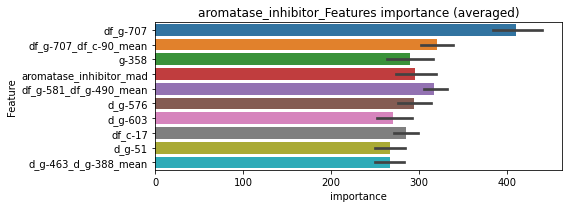

len(train_index) : 2829
len(valid_index) : 944
================================= fold 1/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.099678	valid_1's binary_logloss: 0.161148
[200]	training's binary_logloss: 0.033455	valid_1's binary_logloss: 0.0855035
[300]	training's binary_logloss: 0.0134993	valid_1's binary_logloss: 0.0563735
[400]	training's binary_logloss: 0.00603502	valid_1's binary_logloss: 0.0426469
[500]	training's binary_logloss: 0.0031497	valid_1's binary_logloss: 0.0345987
[600]	training's binary_logloss: 0.00194131	valid_1's binary_logloss: 0.0308719
[700]	training's binary_logloss: 0.00135138	valid_1's binary_logloss: 0.0293197
[800]	training's binary_logloss: 0.00104306	valid_1's binary_logloss: 0.028118
Early stopping, best iteration is:
[848]	training's binary_logloss: 0.000942705	valid_1's binary_logloss: 0.027699


len(train_index) : 2830
len(valid_index) : 943
================================= fold 2/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100717	valid_1's binary_logloss: 0.138915
[200]	training's binary_logloss: 0.0360303	valid_1's binary_logloss: 0.06891
[300]	training's binary_logloss: 0.0141779	valid_1's binary_logloss: 0.0392468
[400]	training's binary_logloss: 0.00622234	valid_1's binary_logloss: 0.0247026
[500]	training's binary_logloss: 0.00317793	valid_1's binary_logloss: 0.0177634
[600]	training's binary_logloss: 0.00193935	valid_1's binary_logloss: 0.0142538
[700]	training's binary_logloss: 0.00135432	valid_1's binary_logloss: 0.0124603
[800]	training's binary_logloss: 0.00103763	valid_1's binary_logloss: 0.0110227
[900]	training's binary_logloss: 0.000857036	valid_1's binary_logloss: 0.0100966
[1000]	training's binary_logloss: 0.00075341	valid_1's binary_logloss: 0.00968092
[1100]	training's binary_logloss: 0.000701695	valid_1's binary_logloss: 0.00938401
[1200]	training's binary_logloss: 0.000667714	valid_1's bina

len(train_index) : 2830
len(valid_index) : 943
================================= fold 3/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100073	valid_1's binary_logloss: 0.148551
[200]	training's binary_logloss: 0.0348838	valid_1's binary_logloss: 0.083427
[300]	training's binary_logloss: 0.0145611	valid_1's binary_logloss: 0.0584894
[400]	training's binary_logloss: 0.0074122	valid_1's binary_logloss: 0.0474998
[500]	training's binary_logloss: 0.00345471	valid_1's binary_logloss: 0.034825
[600]	training's binary_logloss: 0.00203379	valid_1's binary_logloss: 0.0291944
[700]	training's binary_logloss: 0.00136863	valid_1's binary_logloss: 0.0253029
[800]	training's binary_logloss: 0.00103705	valid_1's binary_logloss: 0.0236469
[900]	training's binary_logloss: 0.000851081	valid_1's binary_logloss: 0.0223754
[1000]	training's binary_logloss: 0.000747569	valid_1's binary_logloss: 0.0216997
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000727938	valid_1's binary_logloss: 0.0216017


len(train_index) : 2830
len(valid_index) : 943
================================= fold 4/4 aromatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0993537	valid_1's binary_logloss: 0.139037
[200]	training's binary_logloss: 0.035105	valid_1's binary_logloss: 0.0684702
[300]	training's binary_logloss: 0.0144145	valid_1's binary_logloss: 0.0408166
[400]	training's binary_logloss: 0.00668868	valid_1's binary_logloss: 0.0278463
[500]	training's binary_logloss: 0.00335338	valid_1's binary_logloss: 0.0216775
[600]	training's binary_logloss: 0.0020256	valid_1's binary_logloss: 0.018608
[700]	training's binary_logloss: 0.00140491	valid_1's binary_logloss: 0.0169349
[800]	training's binary_logloss: 0.00107569	valid_1's binary_logloss: 0.0160254
[900]	training's binary_logloss: 0.000889889	valid_1's binary_logloss: 0.0154148
[1000]	training's binary_logloss: 0.000777614	valid_1's binary_logloss: 0.0151548
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000782096	valid_1's binary_logloss: 0.0151326


aromatase_inhibitor logloss: 0.01841065428678965


neg labels: 3289 → selected neg labels: 3285


atm_kinase_inhibitor, len(trt): 6, len(othr): 3285, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0443196	valid_1's binary_logloss: 0.0471852
[200]	training's binary_logloss: 0.00716554	valid_1's binary_logloss: 0.0094884
[300]	training's binary_logloss: 0.00158505	valid_1's binary_logloss: 0.0034756
[400]	training's binary_logloss: 0.000585391	valid_1's binary_logloss: 0.00206979
[500]	training's binary_logloss: 0.000332863	valid_1's binary_logloss: 0.00153671
[600]	training's binary_logloss: 0.000240145	valid_1's binary_logloss: 0.00132491
[700]	training's binary_logloss: 0.000207853	valid_1's binary_logloss: 0.00126599
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000205227	valid_1's binary_logloss: 0.00125385
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0440954	valid_1's binary_logloss: 0.0467401
[200]	training's binary_logloss: 0.00711347	valid_1's binary_logloss: 0.00872707
[300]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0006089, Threshold: 0.0028184, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00197, conf_1:0.00366
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0028184
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0528184
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_3: 0.1028184
threshold: 0.1028184, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438402	valid_1's binary_logloss: 0.0465623
[200]	training's binary_logloss: 0.00673915	valid_1's binary_logloss: 0.00854246
[300]	training's binary_logloss: 0.00138709	valid_1's binary_logloss: 0.00270221
[400]	training's binary_logloss: 0.000487292	valid_1's binary_logloss: 0.00161814
[500]	training's binary_logloss: 0.000274541	valid_1's binary_logloss: 0.0013213
[600]	training's binary_logloss: 0.000200633	valid_1's binary_logloss: 0.00115884
[700]	training's binary_logloss: 0.000179833	valid_1's binary_logloss: 0.00111464
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.000179424	valid_1's binary_logloss: 0.00111442
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438401	valid_1's binary_logloss: 0.0449224
[200]	training's binary_logloss: 0.00676579	valid_1's binary_logloss: 0.00711522
[300]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0954075, Threshold: 0.1028184, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0032647 Vs.target_rate: 0.00025, Num_p_label: 13.0, conf_0:0.08225, conf_1:0.12338
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_1: 0.1028184
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.1528184
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_3: 0.2028184
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.2528184
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.3028184
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_6: 0.3528184
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.4028184
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.4528184
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_9: 0.5028184
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.5528184
threshold: 0.5528184, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= 

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438402	valid_1's binary_logloss: 0.0465623
[200]	training's binary_logloss: 0.00673915	valid_1's binary_logloss: 0.00854246
[300]	training's binary_logloss: 0.00138709	valid_1's binary_logloss: 0.00270221
[400]	training's binary_logloss: 0.000487292	valid_1's binary_logloss: 0.00161814
[500]	training's binary_logloss: 0.000274541	valid_1's binary_logloss: 0.0013213
[600]	training's binary_logloss: 0.000200633	valid_1's binary_logloss: 0.00115884
[700]	training's binary_logloss: 0.000179833	valid_1's binary_logloss: 0.00111464
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.000179424	valid_1's binary_logloss: 0.00111442
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438401	valid_1's binary_logloss: 0.0449224
[200]	training's binary_logloss: 0.00676579	valid_1's binary_logloss: 0.00711522
[300]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0954075, Threshold: 0.5528184, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.49754, conf_1:0.60810
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.5528184
threshold: 0.5528184, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


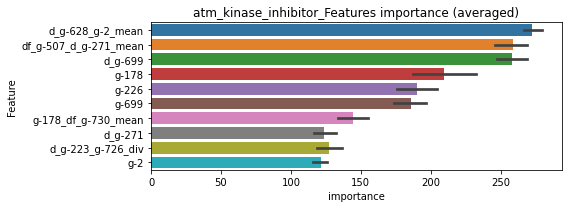

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437849	valid_1's binary_logloss: 0.0474274
[200]	training's binary_logloss: 0.00672784	valid_1's binary_logloss: 0.00930152
[300]	training's binary_logloss: 0.00138209	valid_1's binary_logloss: 0.00353323
[400]	training's binary_logloss: 0.000482965	valid_1's binary_logloss: 0.00233796
[500]	training's binary_logloss: 0.000271142	valid_1's binary_logloss: 0.00199566
[600]	training's binary_logloss: 0.000198445	valid_1's binary_logloss: 0.00184238
[700]	training's binary_logloss: 0.000178908	valid_1's binary_logloss: 0.00178851
Early stopping, best iteration is:
[715]	training's binary_logloss: 0.000177852	valid_1's binary_logloss: 0.00178384


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0438916	valid_1's binary_logloss: 0.0449837
[200]	training's binary_logloss: 0.00676336	valid_1's binary_logloss: 0.0071931
[300]	training's binary_logloss: 0.00138551	valid_1's binary_logloss: 0.00153544
[400]	training's binary_logloss: 0.00048142	valid_1's binary_logloss: 0.00055686
[500]	training's binary_logloss: 0.000268888	valid_1's binary_logloss: 0.000327058
[600]	training's binary_logloss: 0.000196453	valid_1's binary_logloss: 0.000248092
[700]	training's binary_logloss: 0.000177771	valid_1's binary_logloss: 0.000229107
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.00017585	valid_1's binary_logloss: 0.000227124


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437634	valid_1's binary_logloss: 0.0440329
[200]	training's binary_logloss: 0.00675901	valid_1's binary_logloss: 0.00685637
[300]	training's binary_logloss: 0.00138995	valid_1's binary_logloss: 0.00144738
[400]	training's binary_logloss: 0.000485449	valid_1's binary_logloss: 0.000521012
[500]	training's binary_logloss: 0.000272798	valid_1's binary_logloss: 0.000296415
[600]	training's binary_logloss: 0.000199611	valid_1's binary_logloss: 0.000217421
[700]	training's binary_logloss: 0.000178245	valid_1's binary_logloss: 0.000194243
Early stopping, best iteration is:
[721]	training's binary_logloss: 0.000177387	valid_1's binary_logloss: 0.000193235


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0437473	valid_1's binary_logloss: 0.0453331
[200]	training's binary_logloss: 0.00673501	valid_1's binary_logloss: 0.00730903
[300]	training's binary_logloss: 0.00137612	valid_1's binary_logloss: 0.00167365
[400]	training's binary_logloss: 0.00047736	valid_1's binary_logloss: 0.000682954
[500]	training's binary_logloss: 0.000266732	valid_1's binary_logloss: 0.000413759
[600]	training's binary_logloss: 0.000196487	valid_1's binary_logloss: 0.000304934
[700]	training's binary_logloss: 0.000175769	valid_1's binary_logloss: 0.000268982
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.000174746	valid_1's binary_logloss: 0.000266745


atm_kinase_inhibitor logloss: 0.0006179407172074459


neg labels: 3289 → selected neg labels: 3289


atp-sensitive_potassium_channel_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.051121	valid_1's binary_logloss: 0.0572989
[200]	training's binary_logloss: 0.010028	valid_1's binary_logloss: 0.0138232
[300]	training's binary_logloss: 0.00258019	valid_1's binary_logloss: 0.00499722
[400]	training's binary_logloss: 0.000979693	valid_1's binary_logloss: 0.0024134
[500]	training's binary_logloss: 0.000537943	valid_1's binary_logloss: 0.00153196
[600]	training's binary_logloss: 0.000370276	valid_1's binary_logloss: 0.00116205
[700]	training's binary_logloss: 0.000294121	valid_1's binary_logloss: 0.000979512
[800]	training's binary_logloss: 0.000266998	valid_1's binary_logloss: 0.000905138
[900]	training's binary_logloss: 0.000259032	valid_1's binary_logloss: 0.000878707
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000259032	valid_1's binary_logloss: 0.000878707
Training until validation scores don't improve for 30 rounds
[100]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0015632, Threshold: 0.0163787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.01147, conf_1:0.02129
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0163787
Num_p_label: 16.0, Expected: 1.2, Adj_threshold_2: 0.0663787
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_3: 0.1163787
Num_p_label: 10.0, Expected: 1.2, Adj_threshold_4: 0.1663787
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_5: 0.2163787
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_6: 0.2663787
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_7: 0.3163787
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_8: 0.3663787
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_9: 0.4163787
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_10: 0.4663787
threshold: 0.4663787, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498652	valid_1's binary_logloss: 0.05334
[200]	training's binary_logloss: 0.00879299	valid_1's binary_logloss: 0.00981311
[300]	training's binary_logloss: 0.00209155	valid_1's binary_logloss: 0.0024734
[400]	training's binary_logloss: 0.000796267	valid_1's binary_logloss: 0.000989568
[500]	training's binary_logloss: 0.000447031	valid_1's binary_logloss: 0.000576786
[600]	training's binary_logloss: 0.000313944	valid_1's binary_logloss: 0.000414177
[700]	training's binary_logloss: 0.00025691	valid_1's binary_logloss: 0.00034248
[800]	training's binary_logloss: 0.000240354	valid_1's binary_logloss: 0.000320796
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.000239445	valid_1's binary_logloss: 0.000319496
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0494241	valid_1's binary_logloss: 0.055284
[200]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1932684, Threshold: 0.4663787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0032647 Vs.target_rate: 0.00029, Num_p_label: 13.0, conf_0:0.37310, conf_1:0.55965
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_1: 0.4663787
Num_p_label: 12.0, Expected: 1.2, Adj_threshold_2: 0.5163787
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_3: 0.5663787
Num_p_label: 11.0, Expected: 1.2, Adj_threshold_4: 0.6163787
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_5: 0.6663787
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.7163787
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_7: 0.7663787
threshold: 0.7663787, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498652	valid_1's binary_logloss: 0.05334
[200]	training's binary_logloss: 0.00879299	valid_1's binary_logloss: 0.00981311
[300]	training's binary_logloss: 0.00209155	valid_1's binary_logloss: 0.0024734
[400]	training's binary_logloss: 0.000796267	valid_1's binary_logloss: 0.000989568
[500]	training's binary_logloss: 0.000447031	valid_1's binary_logloss: 0.000576786
[600]	training's binary_logloss: 0.000313944	valid_1's binary_logloss: 0.000414177
[700]	training's binary_logloss: 0.00025691	valid_1's binary_logloss: 0.00034248
[800]	training's binary_logloss: 0.000240354	valid_1's binary_logloss: 0.000320796
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.000239445	valid_1's binary_logloss: 0.000319496
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0494241	valid_1's binary_logloss: 0.055284
[200]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1932684, Threshold: 0.7663787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00029, Num_p_label: 5.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_1: 0.7663787
threshold: 0.7663787, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


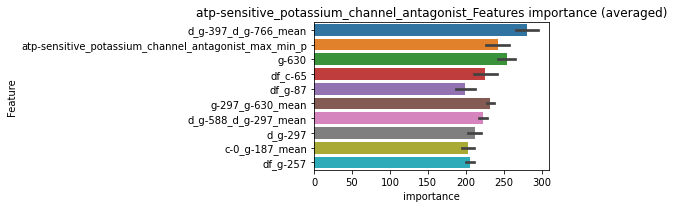

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495096	valid_1's binary_logloss: 0.0526134
[200]	training's binary_logloss: 0.00867381	valid_1's binary_logloss: 0.00958701
[300]	training's binary_logloss: 0.0020658	valid_1's binary_logloss: 0.00245248
[400]	training's binary_logloss: 0.000790474	valid_1's binary_logloss: 0.00100216
[500]	training's binary_logloss: 0.000444915	valid_1's binary_logloss: 0.000583064
[600]	training's binary_logloss: 0.000312871	valid_1's binary_logloss: 0.000416677
[700]	training's binary_logloss: 0.000257837	valid_1's binary_logloss: 0.000345205
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000243894	valid_1's binary_logloss: 0.000327601


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0492746	valid_1's binary_logloss: 0.0552154
[200]	training's binary_logloss: 0.00855668	valid_1's binary_logloss: 0.0115213
[300]	training's binary_logloss: 0.00204048	valid_1's binary_logloss: 0.00337737
[400]	training's binary_logloss: 0.00077826	valid_1's binary_logloss: 0.0015193
[500]	training's binary_logloss: 0.000436443	valid_1's binary_logloss: 0.000941292
[600]	training's binary_logloss: 0.000306491	valid_1's binary_logloss: 0.000695107
[700]	training's binary_logloss: 0.000252237	valid_1's binary_logloss: 0.000591978
[800]	training's binary_logloss: 0.000233759	valid_1's binary_logloss: 0.000558514
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.000232945	valid_1's binary_logloss: 0.000557009


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0493624	valid_1's binary_logloss: 0.0539226
[200]	training's binary_logloss: 0.00861426	valid_1's binary_logloss: 0.0100563
[300]	training's binary_logloss: 0.0020602	valid_1's binary_logloss: 0.00264357
[400]	training's binary_logloss: 0.00078782	valid_1's binary_logloss: 0.00111905
[500]	training's binary_logloss: 0.000441745	valid_1's binary_logloss: 0.000672626
[600]	training's binary_logloss: 0.000312407	valid_1's binary_logloss: 0.000491239
[700]	training's binary_logloss: 0.000255676	valid_1's binary_logloss: 0.000410212
[800]	training's binary_logloss: 0.000234617	valid_1's binary_logloss: 0.000379504
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.000234249	valid_1's binary_logloss: 0.000378908


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495136	valid_1's binary_logloss: 0.0534736
[200]	training's binary_logloss: 0.00858666	valid_1's binary_logloss: 0.010103
[300]	training's binary_logloss: 0.00203312	valid_1's binary_logloss: 0.00286581
[400]	training's binary_logloss: 0.000776263	valid_1's binary_logloss: 0.00123056
[500]	training's binary_logloss: 0.000436907	valid_1's binary_logloss: 0.000736582
[600]	training's binary_logloss: 0.000310418	valid_1's binary_logloss: 0.000532533
[700]	training's binary_logloss: 0.000255072	valid_1's binary_logloss: 0.000440506
[800]	training's binary_logloss: 0.000236102	valid_1's binary_logloss: 0.000409147
Early stopping, best iteration is:
[852]	training's binary_logloss: 0.000233384	valid_1's binary_logloss: 0.000404391


atp-sensitive_potassium_channel_antagonist logloss: 0.00041695349973180923


neg labels: 3289 → selected neg labels: 3286


atp_synthase_inhibitor, len(trt): 12, len(othr): 3286, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679585	valid_1's binary_logloss: 0.0790844
[200]	training's binary_logloss: 0.0165276	valid_1's binary_logloss: 0.0246261
[300]	training's binary_logloss: 0.00486473	valid_1's binary_logloss: 0.0107083
[400]	training's binary_logloss: 0.00190422	valid_1's binary_logloss: 0.00617919
[500]	training's binary_logloss: 0.0010026	valid_1's binary_logloss: 0.00466439
[600]	training's binary_logloss: 0.000662297	valid_1's binary_logloss: 0.00410311
[700]	training's binary_logloss: 0.000502227	valid_1's binary_logloss: 0.00382985
[800]	training's binary_logloss: 0.000416301	valid_1's binary_logloss: 0.00361093
[900]	training's binary_logloss: 0.000388471	valid_1's binary_logloss: 0.00355373
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000388567	valid_1's binary_logloss: 0.00355335
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0030689, Threshold: 0.0268981, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01883, conf_1:0.03497
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0268981
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_2: 0.0768981
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_3: 0.1268981
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.1768981
threshold: 0.1768981, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0650574	valid_1's binary_logloss: 0.0781344
[200]	training's binary_logloss: 0.0151135	valid_1's binary_logloss: 0.0234114
[300]	training's binary_logloss: 0.00429453	valid_1's binary_logloss: 0.00947707
[400]	training's binary_logloss: 0.00165664	valid_1's binary_logloss: 0.00495325
[500]	training's binary_logloss: 0.000880468	valid_1's binary_logloss: 0.00328102
[600]	training's binary_logloss: 0.000588165	valid_1's binary_logloss: 0.00266985
[700]	training's binary_logloss: 0.000447503	valid_1's binary_logloss: 0.00224601
[800]	training's binary_logloss: 0.000382596	valid_1's binary_logloss: 0.00209849
[900]	training's binary_logloss: 0.000363268	valid_1's binary_logloss: 0.00205621
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000363731	valid_1's binary_logloss: 0.00205492
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1877294, Threshold: 0.1768981, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0070316 Vs.target_rate: 0.00050, Num_p_label: 28.0, conf_0:0.14152, conf_1:0.21228
Num_p_label: 28.0, Expected: 2.0, Adj_threshold_1: 0.1768981
Num_p_label: 23.0, Expected: 2.0, Adj_threshold_2: 0.2268981
Num_p_label: 21.0, Expected: 2.0, Adj_threshold_3: 0.2768981
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_4: 0.3268981
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_5: 0.3768981
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_6: 0.4268981
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_7: 0.4768981
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_8: 0.5268981
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_9: 0.5768981
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.6268981
threshold: 0.6768981, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
===============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0650574	valid_1's binary_logloss: 0.0781344
[200]	training's binary_logloss: 0.0151135	valid_1's binary_logloss: 0.0234114
[300]	training's binary_logloss: 0.00429453	valid_1's binary_logloss: 0.00947707
[400]	training's binary_logloss: 0.00165664	valid_1's binary_logloss: 0.00495325
[500]	training's binary_logloss: 0.000880468	valid_1's binary_logloss: 0.00328102
[600]	training's binary_logloss: 0.000588165	valid_1's binary_logloss: 0.00266985
[700]	training's binary_logloss: 0.000447503	valid_1's binary_logloss: 0.00224601
[800]	training's binary_logloss: 0.000382596	valid_1's binary_logloss: 0.00209849
[900]	training's binary_logloss: 0.000363268	valid_1's binary_logloss: 0.00205621
Early stopping, best iteration is:
[884]	training's binary_logloss: 0.000363731	valid_1's binary_logloss: 0.00205492
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1877294, Threshold: 0.6768981, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.74459
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_1: 0.6768981
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_2: 0.7268981
threshold: 0.7268981, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


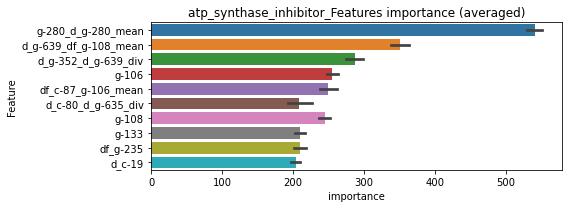

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0646171	valid_1's binary_logloss: 0.076903
[200]	training's binary_logloss: 0.0148315	valid_1's binary_logloss: 0.0222109
[300]	training's binary_logloss: 0.00424079	valid_1's binary_logloss: 0.00873496
[400]	training's binary_logloss: 0.00164552	valid_1's binary_logloss: 0.00456516
[500]	training's binary_logloss: 0.000871747	valid_1's binary_logloss: 0.00302718
[600]	training's binary_logloss: 0.00058283	valid_1's binary_logloss: 0.00238972
[700]	training's binary_logloss: 0.000445803	valid_1's binary_logloss: 0.0020358
[800]	training's binary_logloss: 0.000379097	valid_1's binary_logloss: 0.00188074
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.000364546	valid_1's binary_logloss: 0.00184135


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676195	valid_1's binary_logloss: 0.0756196
[200]	training's binary_logloss: 0.0155824	valid_1's binary_logloss: 0.0202288
[300]	training's binary_logloss: 0.0043572	valid_1's binary_logloss: 0.00671347
[400]	training's binary_logloss: 0.00167737	valid_1's binary_logloss: 0.00297997
[500]	training's binary_logloss: 0.000884302	valid_1's binary_logloss: 0.00176158
[600]	training's binary_logloss: 0.000585945	valid_1's binary_logloss: 0.00125379
[700]	training's binary_logloss: 0.00044836	valid_1's binary_logloss: 0.00100964
[800]	training's binary_logloss: 0.000382544	valid_1's binary_logloss: 0.000901351
[900]	training's binary_logloss: 0.00036617	valid_1's binary_logloss: 0.000872692
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00036617	valid_1's binary_logloss: 0.000872692


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0653754	valid_1's binary_logloss: 0.0776683
[200]	training's binary_logloss: 0.0146985	valid_1's binary_logloss: 0.021656
[300]	training's binary_logloss: 0.00416833	valid_1's binary_logloss: 0.00820532
[400]	training's binary_logloss: 0.00162693	valid_1's binary_logloss: 0.00416198
[500]	training's binary_logloss: 0.000865036	valid_1's binary_logloss: 0.00273168
[600]	training's binary_logloss: 0.000577804	valid_1's binary_logloss: 0.00207821
[700]	training's binary_logloss: 0.000442933	valid_1's binary_logloss: 0.00180608
[800]	training's binary_logloss: 0.000378144	valid_1's binary_logloss: 0.00166854
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000372447	valid_1's binary_logloss: 0.00165834


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661255	valid_1's binary_logloss: 0.0757597
[200]	training's binary_logloss: 0.015443	valid_1's binary_logloss: 0.0199203
[300]	training's binary_logloss: 0.00437505	valid_1's binary_logloss: 0.00654587
[400]	training's binary_logloss: 0.00167074	valid_1's binary_logloss: 0.00283699
[500]	training's binary_logloss: 0.000887282	valid_1's binary_logloss: 0.00170844
[600]	training's binary_logloss: 0.000593835	valid_1's binary_logloss: 0.00122954
[700]	training's binary_logloss: 0.000446911	valid_1's binary_logloss: 0.000985011
[800]	training's binary_logloss: 0.000378919	valid_1's binary_logloss: 0.000881786
[900]	training's binary_logloss: 0.000362698	valid_1's binary_logloss: 0.000855074
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.000363276	valid_1's binary_logloss: 0.00085498


atp_synthase_inhibitor logloss: 0.0013074230351424918


neg labels: 3289 → selected neg labels: 3273


atpase_inhibitor, len(trt): 97, len(othr): 3273, target_rate: 0.0040732 → Adj_target_rate: 0.0041016
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151422	valid_1's binary_logloss: 0.240168
[200]	training's binary_logloss: 0.0724478	valid_1's binary_logloss: 0.180181
[300]	training's binary_logloss: 0.0382872	valid_1's binary_logloss: 0.150257
[400]	training's binary_logloss: 0.0209516	valid_1's binary_logloss: 0.134204
[500]	training's binary_logloss: 0.0118478	valid_1's binary_logloss: 0.125791
[600]	training's binary_logloss: 0.00698593	valid_1's binary_logloss: 0.121124
Early stopping, best iteration is:
[667]	training's binary_logloss: 0.00508652	valid_1's binary_logloss: 0.119919
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149682	valid_1's binary_logloss: 0.232308
[200]	training's binary_logloss: 0.0709833	valid_1's binary_logloss: 0.164346
[300]	training's binary_logloss: 0.0377639	valid_1's binary_logloss: 0.132162
[400]	training's binary_logloss: 0.0201243	valid_1's binary_log

1 / 3 AUC score:0.985
y_Threshold: 0.0432118, Threshold: 0.1623982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 198 → Positive_corect_labels: 621/3729
p_label_rate: 0.0100452 Vs.target_rate: 0.00407, Num_p_label: 40.0, conf_0:0.11368, conf_1:0.21112
Num_p_label: 40.0, Expected: 16.2, Adj_threshold_1: 0.1623982
Num_p_label: 27.0, Expected: 16.2, Adj_threshold_2: 0.2123982
Num_p_label: 22.0, Expected: 16.2, Adj_threshold_3: 0.2623982
threshold: 0.2623982, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 621.0/3729, y_label_rate: 0.1665326
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134516	valid_1's binary_logloss: 0.196443
[200]	training's binary_logloss: 0.0585981	valid_1's binary_logloss: 0.131609
[300]	training's binary_logloss: 0.0272834	valid_1's binary_logloss: 0.0991675
[400]	training's binary_logloss: 0.0136101	valid_1's binary_logloss: 0.0816233
[500]	training's binary_logloss: 0.007361	valid_1's binary_logloss: 0.0725127
[600]	training's binary_logloss: 0.00436009	valid_1's binary_logloss: 0.0671866
[700]	training's binary_logloss: 0.00288554	valid_1's binary_logloss: 0.0641935
[800]	training's binary_logloss: 0.00209349	valid_1's binary_logloss: 0.0625939
[900]	training's binary_logloss: 0.00162728	valid_1's binary_logloss: 0.0611952
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.00165625	valid_1's binary_logloss: 0.0610776
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130941	valid_1's 

2 / 3 AUC score:0.994
y_Threshold: 0.0982307, Threshold: 0.2623982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 584.0/3655
p_label_rate: 0.0168257 Vs.target_rate: 0.00407, Num_p_label: 67.0, conf_0:0.20992, conf_1:0.31488
Num_p_label: 67.0, Expected: 16.2, Adj_threshold_1: 0.2623982
Num_p_label: 57.0, Expected: 16.2, Adj_threshold_2: 0.3123982
Num_p_label: 44.0, Expected: 16.2, Adj_threshold_3: 0.3623982
Num_p_label: 37.0, Expected: 16.2, Adj_threshold_4: 0.4123982
Num_p_label: 31.0, Expected: 16.2, Adj_threshold_5: 0.4623982
Num_p_label: 27.0, Expected: 16.2, Adj_threshold_6: 0.5123982
Num_p_label: 22.0, Expected: 16.2, Adj_threshold_7: 0.5623982
threshold: 0.5623982, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 584.0/3655, y_label_rate: 0.1597811
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120839	valid_1's binary_logloss: 0.191691
[200]	training's binary_logloss: 0.0469927	valid_1's binary_logloss: 0.121619
[300]	training's binary_logloss: 0.0207143	valid_1's binary_logloss: 0.092024
[400]	training's binary_logloss: 0.00985605	valid_1's binary_logloss: 0.0772514
[500]	training's binary_logloss: 0.0052804	valid_1's binary_logloss: 0.0700529
[600]	training's binary_logloss: 0.00319346	valid_1's binary_logloss: 0.0660182
[700]	training's binary_logloss: 0.00217753	valid_1's binary_logloss: 0.0646682
[800]	training's binary_logloss: 0.00161586	valid_1's binary_logloss: 0.0639235
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.00174539	valid_1's binary_logloss: 0.0635612
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121	valid_1's binary_logloss: 0.180773
[200]	training's binary_logloss: 0.0472833	valid_1's bina

3 / 3 AUC score:0.996
y_Threshold: 0.0910351, Threshold: 0.5623982, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 560.0/3607
p_label_rate: 0.0102963 Vs.target_rate: 0.00407, Num_p_label: 41.0, conf_0:0.50000, conf_1:0.61864
Num_p_label: 41.0, Expected: 16.2, Adj_threshold_1: 0.5623982
Num_p_label: 37.0, Expected: 16.2, Adj_threshold_2: 0.6123982
Num_p_label: 32.0, Expected: 16.2, Adj_threshold_3: 0.6623982
Num_p_label: 27.0, Expected: 16.2, Adj_threshold_4: 0.7123982
Num_p_label: 22.0, Expected: 16.2, Adj_threshold_5: 0.7623982
threshold: 0.7623982, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 560.0/3607, y_label_rate: 0.1552537


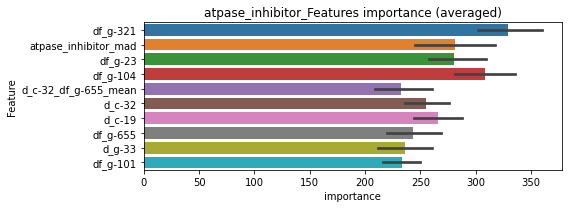

len(train_index) : 2705
len(valid_index) : 902
================================= fold 1/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111764	valid_1's binary_logloss: 0.172194
[200]	training's binary_logloss: 0.0425317	valid_1's binary_logloss: 0.106149
[300]	training's binary_logloss: 0.0180187	valid_1's binary_logloss: 0.0776774
[400]	training's binary_logloss: 0.00855941	valid_1's binary_logloss: 0.0648692
[500]	training's binary_logloss: 0.00451308	valid_1's binary_logloss: 0.0590642
[600]	training's binary_logloss: 0.002755	valid_1's binary_logloss: 0.0560945
[700]	training's binary_logloss: 0.001883	valid_1's binary_logloss: 0.0538947
[800]	training's binary_logloss: 0.00141332	valid_1's binary_logloss: 0.0525375
[900]	training's binary_logloss: 0.0011474	valid_1's binary_logloss: 0.0518251
[1000]	training's binary_logloss: 0.000978172	valid_1's binary_logloss: 0.0511898
Early stopping, best iteration is:
[1028]	training's binary_logloss: 0.000945232	valid_1's binary_logloss: 0.0508276


len(train_index) : 2705
len(valid_index) : 902
================================= fold 2/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113767	valid_1's binary_logloss: 0.167111
[200]	training's binary_logloss: 0.0419216	valid_1's binary_logloss: 0.0971202
[300]	training's binary_logloss: 0.0180978	valid_1's binary_logloss: 0.0691417
[400]	training's binary_logloss: 0.00853941	valid_1's binary_logloss: 0.0545995
[500]	training's binary_logloss: 0.00454775	valid_1's binary_logloss: 0.0471754
[600]	training's binary_logloss: 0.00278148	valid_1's binary_logloss: 0.0426696
[700]	training's binary_logloss: 0.0019141	valid_1's binary_logloss: 0.0405583
[800]	training's binary_logloss: 0.0014421	valid_1's binary_logloss: 0.0390895
[900]	training's binary_logloss: 0.00116185	valid_1's binary_logloss: 0.0378467
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.0011516	valid_1's binary_logloss: 0.0377888


len(train_index) : 2705
len(valid_index) : 902
================================= fold 3/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112227	valid_1's binary_logloss: 0.174287
[200]	training's binary_logloss: 0.0432321	valid_1's binary_logloss: 0.107818
[300]	training's binary_logloss: 0.0182429	valid_1's binary_logloss: 0.0784488
[400]	training's binary_logloss: 0.00859901	valid_1's binary_logloss: 0.0643132
[500]	training's binary_logloss: 0.00456896	valid_1's binary_logloss: 0.0572283
[600]	training's binary_logloss: 0.00277098	valid_1's binary_logloss: 0.0541913
[700]	training's binary_logloss: 0.00190567	valid_1's binary_logloss: 0.051858
[800]	training's binary_logloss: 0.001435	valid_1's binary_logloss: 0.0510436
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.00148719	valid_1's binary_logloss: 0.050856


len(train_index) : 2706
len(valid_index) : 901
================================= fold 4/4 atpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112091	valid_1's binary_logloss: 0.1742
[200]	training's binary_logloss: 0.0424117	valid_1's binary_logloss: 0.101269
[300]	training's binary_logloss: 0.0185064	valid_1's binary_logloss: 0.0677446
[400]	training's binary_logloss: 0.00885786	valid_1's binary_logloss: 0.0508106
[500]	training's binary_logloss: 0.00469313	valid_1's binary_logloss: 0.0408857
[600]	training's binary_logloss: 0.00285691	valid_1's binary_logloss: 0.0356659
[700]	training's binary_logloss: 0.00197226	valid_1's binary_logloss: 0.032872
[800]	training's binary_logloss: 0.00147573	valid_1's binary_logloss: 0.0313417
[900]	training's binary_logloss: 0.00118907	valid_1's binary_logloss: 0.0299844
[1000]	training's binary_logloss: 0.00101291	valid_1's binary_logloss: 0.0295733
[1100]	training's binary_logloss: 0.00090553	valid_1's binary_logloss: 0.0288066
Early stopping, best iteration is:
[1145]	training's binary_loglos

atpase_inhibitor logloss: 0.04202394054656079


neg labels: 3289 → selected neg labels: 3287


atr_kinase_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0773246	valid_1's binary_logloss: 0.0969536
[200]	training's binary_logloss: 0.0223486	valid_1's binary_logloss: 0.0375261
[300]	training's binary_logloss: 0.007359	valid_1's binary_logloss: 0.0184452
[400]	training's binary_logloss: 0.00292348	valid_1's binary_logloss: 0.0109701
[500]	training's binary_logloss: 0.00151161	valid_1's binary_logloss: 0.0077916
[600]	training's binary_logloss: 0.00096058	valid_1's binary_logloss: 0.00638111
[700]	training's binary_logloss: 0.00070169	valid_1's binary_logloss: 0.00551614
[800]	training's binary_logloss: 0.000566268	valid_1's binary_logloss: 0.00505573
[900]	training's binary_logloss: 0.000500377	valid_1's binary_logloss: 0.00479758
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000474763	valid_1's binary_logloss: 0.00466381
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0771

1 / 3 AUC score:1.000
y_Threshold: 0.0059119, Threshold: 0.0361169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02528, conf_1:0.04695
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0361169
Num_p_label: 23.0, Expected: 3.2, Adj_threshold_2: 0.0861169
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.1361169
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_4: 0.1861169
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_5: 0.2361169
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.2861169
threshold: 0.2861169, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753567	valid_1's binary_logloss: 0.0870076
[200]	training's binary_logloss: 0.0197358	valid_1's binary_logloss: 0.0269658
[300]	training's binary_logloss: 0.00624337	valid_1's binary_logloss: 0.0101908
[400]	training's binary_logloss: 0.0025191	valid_1's binary_logloss: 0.00489062
[500]	training's binary_logloss: 0.00132994	valid_1's binary_logloss: 0.00299203
[600]	training's binary_logloss: 0.000861441	valid_1's binary_logloss: 0.00212591
[700]	training's binary_logloss: 0.000636884	valid_1's binary_logloss: 0.0016755
[800]	training's binary_logloss: 0.000514427	valid_1's binary_logloss: 0.00142003
[900]	training's binary_logloss: 0.00045725	valid_1's binary_logloss: 0.00130475
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.000445335	valid_1's binary_logloss: 0.00128469
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0409000, Threshold: 0.2861169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.22889, conf_1:0.34334
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.2861169
Num_p_label: 25.0, Expected: 3.2, Adj_threshold_2: 0.3361169
Num_p_label: 20.0, Expected: 3.2, Adj_threshold_3: 0.3861169
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_4: 0.4361169
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_5: 0.4861169
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.5361169
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_7: 0.5861169
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_8: 0.6361169
threshold: 0.6361169, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0745418	valid_1's binary_logloss: 0.0889332
[200]	training's binary_logloss: 0.0194342	valid_1's binary_logloss: 0.0288903
[300]	training's binary_logloss: 0.00606446	valid_1's binary_logloss: 0.011874
[400]	training's binary_logloss: 0.00247853	valid_1's binary_logloss: 0.00624649
[500]	training's binary_logloss: 0.00131206	valid_1's binary_logloss: 0.00398673
[600]	training's binary_logloss: 0.000845798	valid_1's binary_logloss: 0.00296303
[700]	training's binary_logloss: 0.000624571	valid_1's binary_logloss: 0.00244148
[800]	training's binary_logloss: 0.000499995	valid_1's binary_logloss: 0.00209366
[900]	training's binary_logloss: 0.000447545	valid_1's binary_logloss: 0.00197207
[1000]	training's binary_logloss: 0.000431912	valid_1's binary_logloss: 0.00192441
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000431912	valid_1's binary_logloss: 0.00192441
Training unt

3 / 3 AUC score:1.000
y_Threshold: 0.1547396, Threshold: 0.6361169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.50000, conf_1:0.69973
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_1: 0.6361169
threshold: 0.6361169, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3810, y_label_rate: 0.1721785


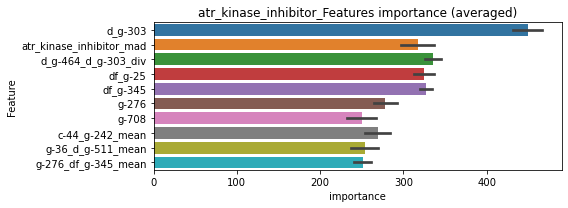

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736903	valid_1's binary_logloss: 0.0892275
[200]	training's binary_logloss: 0.0193395	valid_1's binary_logloss: 0.0299547
[300]	training's binary_logloss: 0.00629811	valid_1's binary_logloss: 0.01287
[400]	training's binary_logloss: 0.00263211	valid_1's binary_logloss: 0.00687439
[500]	training's binary_logloss: 0.00132614	valid_1's binary_logloss: 0.00424533
[600]	training's binary_logloss: 0.000842481	valid_1's binary_logloss: 0.00300514
[700]	training's binary_logloss: 0.000619763	valid_1's binary_logloss: 0.00239569
[800]	training's binary_logloss: 0.000498615	valid_1's binary_logloss: 0.00209667
[900]	training's binary_logloss: 0.000445914	valid_1's binary_logloss: 0.0019417
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000445914	valid_1's binary_logloss: 0.0019417


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0736175	valid_1's binary_logloss: 0.0993237
[200]	training's binary_logloss: 0.0186806	valid_1's binary_logloss: 0.0350479
[300]	training's binary_logloss: 0.00579097	valid_1's binary_logloss: 0.0157756
[400]	training's binary_logloss: 0.00232426	valid_1's binary_logloss: 0.00885057
[500]	training's binary_logloss: 0.00123982	valid_1's binary_logloss: 0.00600815
[600]	training's binary_logloss: 0.000809375	valid_1's binary_logloss: 0.00470258
[700]	training's binary_logloss: 0.000607217	valid_1's binary_logloss: 0.00411573
[800]	training's binary_logloss: 0.000494706	valid_1's binary_logloss: 0.00366894
[900]	training's binary_logloss: 0.000452721	valid_1's binary_logloss: 0.00356814
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.000442179	valid_1's binary_logloss: 0.00353342


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07382	valid_1's binary_logloss: 0.0941088
[200]	training's binary_logloss: 0.0186938	valid_1's binary_logloss: 0.0303042
[300]	training's binary_logloss: 0.00578365	valid_1's binary_logloss: 0.0124
[400]	training's binary_logloss: 0.00235669	valid_1's binary_logloss: 0.0067123
[500]	training's binary_logloss: 0.00125353	valid_1's binary_logloss: 0.00459485
[600]	training's binary_logloss: 0.000814834	valid_1's binary_logloss: 0.00357913
[700]	training's binary_logloss: 0.00060687	valid_1's binary_logloss: 0.00307658
[800]	training's binary_logloss: 0.000493649	valid_1's binary_logloss: 0.00279835
[900]	training's binary_logloss: 0.000449379	valid_1's binary_logloss: 0.00273099
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.00045017	valid_1's binary_logloss: 0.00272967


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753844	valid_1's binary_logloss: 0.0918065
[200]	training's binary_logloss: 0.0196139	valid_1's binary_logloss: 0.0301512
[300]	training's binary_logloss: 0.00617004	valid_1's binary_logloss: 0.0123636
[400]	training's binary_logloss: 0.00248163	valid_1's binary_logloss: 0.00645138
[500]	training's binary_logloss: 0.00130183	valid_1's binary_logloss: 0.00409665
[600]	training's binary_logloss: 0.000832658	valid_1's binary_logloss: 0.00305395
[700]	training's binary_logloss: 0.000618992	valid_1's binary_logloss: 0.00257387
[800]	training's binary_logloss: 0.000499754	valid_1's binary_logloss: 0.00226666
[900]	training's binary_logloss: 0.000441765	valid_1's binary_logloss: 0.00214192
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.000430508	valid_1's binary_logloss: 0.00211607


atr_kinase_inhibitor logloss: 0.002581383112613726


neg labels: 3289 → selected neg labels: 3271


aurora_kinase_inhibitor, len(trt): 96, len(othr): 3271, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.161293	valid_1's binary_logloss: 0.261971
[200]	training's binary_logloss: 0.0778047	valid_1's binary_logloss: 0.197436
[300]	training's binary_logloss: 0.0415886	valid_1's binary_logloss: 0.166787
[400]	training's binary_logloss: 0.0224419	valid_1's binary_logloss: 0.14856
[500]	training's binary_logloss: 0.0124863	valid_1's binary_logloss: 0.139684
[600]	training's binary_logloss: 0.0073915	valid_1's binary_logloss: 0.133346
[700]	training's binary_logloss: 0.00465664	valid_1's binary_logloss: 0.131372
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00517642	valid_1's binary_logloss: 0.130846
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.167427	valid_1's binary_logloss: 0.22465
[200]	training's binary_logloss: 0.0859858	valid_1's binary_logloss: 0.156715
[300]	training's binary_logloss: 0.0466078	valid_1's binary_loglo

1 / 3 AUC score:0.989
y_Threshold: 0.0528657, Threshold: 0.4840283, pos_neg_ratio: 0.8000000
Remove_noisy_data: 189 → Positive_corect_labels: 625/3736
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.33882, conf_1:0.62924
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_1: 0.4840283
Num_p_label: 30.0, Expected: 16.1, Adj_threshold_2: 0.5340283
Num_p_label: 24.0, Expected: 16.1, Adj_threshold_3: 0.5840283
threshold: 0.5840283, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 625.0/3736, y_label_rate: 0.1672912
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145734	valid_1's binary_logloss: 0.222188
[200]	training's binary_logloss: 0.0656028	valid_1's binary_logloss: 0.14993
[300]	training's binary_logloss: 0.0316865	valid_1's binary_logloss: 0.112074
[400]	training's binary_logloss: 0.0161392	valid_1's binary_logloss: 0.092677
[500]	training's binary_logloss: 0.00858694	valid_1's binary_logloss: 0.0819033
[600]	training's binary_logloss: 0.0050288	valid_1's binary_logloss: 0.0759651
[700]	training's binary_logloss: 0.00323483	valid_1's binary_logloss: 0.0741004
[800]	training's binary_logloss: 0.00228831	valid_1's binary_logloss: 0.0723467
[900]	training's binary_logloss: 0.00175793	valid_1's binary_logloss: 0.0716368
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00177906	valid_1's binary_logloss: 0.0716167
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.142013	valid_1's bi

2 / 3 AUC score:0.995
y_Threshold: 0.1255941, Threshold: 0.5840283, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 592.0/3670
p_label_rate: 0.0183325 Vs.target_rate: 0.00403, Num_p_label: 73.0, conf_0:0.46722, conf_1:0.70083
Num_p_label: 73.0, Expected: 16.1, Adj_threshold_1: 0.5840283
Num_p_label: 63.0, Expected: 16.1, Adj_threshold_2: 0.6340283
Num_p_label: 50.0, Expected: 16.1, Adj_threshold_3: 0.6840283
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_4: 0.7340283
Num_p_label: 35.0, Expected: 16.1, Adj_threshold_5: 0.7840283
threshold: 0.7840283, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 592.0/3670, y_label_rate: 0.1613079
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136029	valid_1's binary_logloss: 0.193449
[200]	training's binary_logloss: 0.0605564	valid_1's binary_logloss: 0.118244
[300]	training's binary_logloss: 0.0280064	valid_1's binary_logloss: 0.0812891
[400]	training's binary_logloss: 0.013764	valid_1's binary_logloss: 0.0612606
[500]	training's binary_logloss: 0.0072805	valid_1's binary_logloss: 0.0497651
[600]	training's binary_logloss: 0.00422494	valid_1's binary_logloss: 0.0436043
[700]	training's binary_logloss: 0.00276817	valid_1's binary_logloss: 0.0407595
[800]	training's binary_logloss: 0.00199854	valid_1's binary_logloss: 0.0389511
[900]	training's binary_logloss: 0.00155358	valid_1's binary_logloss: 0.037435
[1000]	training's binary_logloss: 0.00128187	valid_1's binary_logloss: 0.0366978
Early stopping, best iteration is:
[1014]	training's binary_logloss: 0.0012534	valid_1's binary_logloss: 0.036515
Training until validation scores d

3 / 3 AUC score:0.994
y_Threshold: 0.1259180, Threshold: 0.7840283, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 570.0/3626
p_label_rate: 0.0138122 Vs.target_rate: 0.00403, Num_p_label: 55.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 55.0, Expected: 16.1, Adj_threshold_1: 0.7840283
threshold: 0.7840283, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 570.0/3626, y_label_rate: 0.1571980


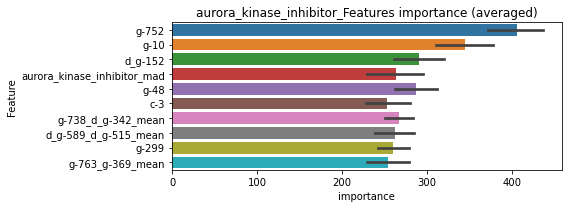

len(train_index) : 2719
len(valid_index) : 907
================================= fold 1/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12503	valid_1's binary_logloss: 0.175029
[200]	training's binary_logloss: 0.0520292	valid_1's binary_logloss: 0.10776
[300]	training's binary_logloss: 0.0232612	valid_1's binary_logloss: 0.0747528
[400]	training's binary_logloss: 0.011217	valid_1's binary_logloss: 0.0569722
[500]	training's binary_logloss: 0.00586315	valid_1's binary_logloss: 0.0462128
[600]	training's binary_logloss: 0.00347118	valid_1's binary_logloss: 0.0403138
[700]	training's binary_logloss: 0.00231244	valid_1's binary_logloss: 0.0373048
[800]	training's binary_logloss: 0.00169528	valid_1's binary_logloss: 0.0347934
[900]	training's binary_logloss: 0.00134256	valid_1's binary_logloss: 0.0338115
[1000]	training's binary_logloss: 0.00112276	valid_1's binary_logloss: 0.0329065
[1100]	training's binary_logloss: 0.000999227	valid_1's binary_logloss: 0.0322143
Early stopping, best iteration is:
[1141]	training's binary_loglos

len(train_index) : 2719
len(valid_index) : 907
================================= fold 2/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125434	valid_1's binary_logloss: 0.19043
[200]	training's binary_logloss: 0.0536373	valid_1's binary_logloss: 0.119853
[300]	training's binary_logloss: 0.0244075	valid_1's binary_logloss: 0.0858019
[400]	training's binary_logloss: 0.011731	valid_1's binary_logloss: 0.0661279
[500]	training's binary_logloss: 0.00605338	valid_1's binary_logloss: 0.0562899
[600]	training's binary_logloss: 0.00352589	valid_1's binary_logloss: 0.0518656
[700]	training's binary_logloss: 0.00231313	valid_1's binary_logloss: 0.0492713
[800]	training's binary_logloss: 0.00168058	valid_1's binary_logloss: 0.0478962
[900]	training's binary_logloss: 0.00131551	valid_1's binary_logloss: 0.0467957
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.00127807	valid_1's binary_logloss: 0.0467047


len(train_index) : 2720
len(valid_index) : 906
================================= fold 3/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125943	valid_1's binary_logloss: 0.189701
[200]	training's binary_logloss: 0.0543548	valid_1's binary_logloss: 0.127118
[300]	training's binary_logloss: 0.0243887	valid_1's binary_logloss: 0.0966949
[400]	training's binary_logloss: 0.0120988	valid_1's binary_logloss: 0.0821141
[500]	training's binary_logloss: 0.00626688	valid_1's binary_logloss: 0.0724026
[600]	training's binary_logloss: 0.00362199	valid_1's binary_logloss: 0.0680706
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00282098	valid_1's binary_logloss: 0.0663326


len(train_index) : 2720
len(valid_index) : 906
================================= fold 4/4 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12622	valid_1's binary_logloss: 0.189315
[200]	training's binary_logloss: 0.0543302	valid_1's binary_logloss: 0.12515
[300]	training's binary_logloss: 0.0245419	valid_1's binary_logloss: 0.0926026
[400]	training's binary_logloss: 0.0118812	valid_1's binary_logloss: 0.0775494
[500]	training's binary_logloss: 0.00611513	valid_1's binary_logloss: 0.0684253
[600]	training's binary_logloss: 0.00353311	valid_1's binary_logloss: 0.0635727
[700]	training's binary_logloss: 0.00231968	valid_1's binary_logloss: 0.0609394
[800]	training's binary_logloss: 0.00170119	valid_1's binary_logloss: 0.0592338
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00147319	valid_1's binary_logloss: 0.05854


aurora_kinase_inhibitor logloss: 0.05091311435136047


neg labels: 3289 → selected neg labels: 3287


autotaxin_inhibitor, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455189	valid_1's binary_logloss: 0.0478487
[200]	training's binary_logloss: 0.00753367	valid_1's binary_logloss: 0.00911527
[300]	training's binary_logloss: 0.00170771	valid_1's binary_logloss: 0.00326043
[400]	training's binary_logloss: 0.000636195	valid_1's binary_logloss: 0.00206062
[500]	training's binary_logloss: 0.000358466	valid_1's binary_logloss: 0.00156662
[600]	training's binary_logloss: 0.000256088	valid_1's binary_logloss: 0.00138836
[700]	training's binary_logloss: 0.00022097	valid_1's binary_logloss: 0.00131709
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00022097	valid_1's binary_logloss: 0.00131709
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453705	valid_1's binary_logloss: 0.0493268
[200]	training's binary_logloss: 0.00741521	valid_1's binary_logloss: 0.00936273
[300]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0008175, Threshold: 0.0078085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00547, conf_1:0.01015
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0078085
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0578085
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_3: 0.1078085
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.1578085
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.2078085
threshold: 0.2078085, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452177	valid_1's binary_logloss: 0.0483866
[200]	training's binary_logloss: 0.00705881	valid_1's binary_logloss: 0.00922085
[300]	training's binary_logloss: 0.00149563	valid_1's binary_logloss: 0.00374293
[400]	training's binary_logloss: 0.000525735	valid_1's binary_logloss: 0.00289549
[500]	training's binary_logloss: 0.000290518	valid_1's binary_logloss: 0.00248367
[600]	training's binary_logloss: 0.000208452	valid_1's binary_logloss: 0.00232554
[700]	training's binary_logloss: 0.00018166	valid_1's binary_logloss: 0.00229795
Early stopping, best iteration is:
[699]	training's binary_logloss: 0.000181661	valid_1's binary_logloss: 0.00229793
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453545	valid_1's binary_logloss: 0.0488937
[200]	training's binary_logloss: 0.0071031	valid_1's binary_logloss: 0.00832536
[300]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.0327230, Threshold: 0.2078085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0022602 Vs.target_rate: 0.00025, Num_p_label: 9.0, conf_0:0.16625, conf_1:0.24937
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_1: 0.2078085
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.2578085
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_3: 0.3078085
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.3578085
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.4078085
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.4578085
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.5078085
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.5578085
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_9: 0.6078085
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_10: 0.6578085
threshold: 0.6578085, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseu

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452177	valid_1's binary_logloss: 0.0483866
[200]	training's binary_logloss: 0.00705881	valid_1's binary_logloss: 0.00922085
[300]	training's binary_logloss: 0.00149563	valid_1's binary_logloss: 0.00374293
[400]	training's binary_logloss: 0.000525735	valid_1's binary_logloss: 0.00289549
[500]	training's binary_logloss: 0.000290518	valid_1's binary_logloss: 0.00248367
[600]	training's binary_logloss: 0.000208452	valid_1's binary_logloss: 0.00232554
[700]	training's binary_logloss: 0.00018166	valid_1's binary_logloss: 0.00229795
Early stopping, best iteration is:
[699]	training's binary_logloss: 0.000181661	valid_1's binary_logloss: 0.00229793
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453545	valid_1's binary_logloss: 0.0488937
[200]	training's binary_logloss: 0.0071031	valid_1's binary_logloss: 0.00832536
[300]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.0327230, Threshold: 0.6578085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.50000, conf_1:0.72359
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.6578085
threshold: 0.6578085, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


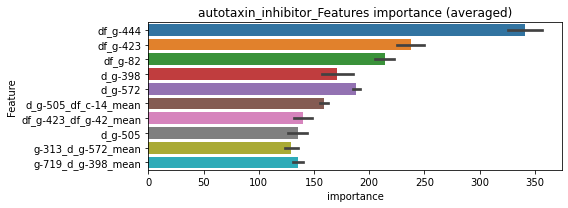

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0447295	valid_1's binary_logloss: 0.0477959
[200]	training's binary_logloss: 0.00708054	valid_1's binary_logloss: 0.00962088
[300]	training's binary_logloss: 0.00149743	valid_1's binary_logloss: 0.00393489
[400]	training's binary_logloss: 0.000529818	valid_1's binary_logloss: 0.00289164
[500]	training's binary_logloss: 0.000291135	valid_1's binary_logloss: 0.00255646
[600]	training's binary_logloss: 0.000208898	valid_1's binary_logloss: 0.00241552


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 autotaxin_inhibitor=================================


[700]	training's binary_logloss: 0.000182613	valid_1's binary_logloss: 0.00238248
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.000184506	valid_1's binary_logloss: 0.00237543
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448648	valid_1's binary_logloss: 0.047545
[200]	training's binary_logloss: 0.00708902	valid_1's binary_logloss: 0.00818538
[300]	training's binary_logloss: 0.00149352	valid_1's binary_logloss: 0.00198139
[400]	training's binary_logloss: 0.000528154	valid_1's binary_logloss: 0.00080669
[500]	training's binary_logloss: 0.000291779	valid_1's binary_logloss: 0.000490466
[600]	training's binary_logloss: 0.000211099	valid_1's binary_logloss: 0.000397134


len(train_index) : 2859


[700]	training's binary_logloss: 0.000183596	valid_1's binary_logloss: 0.000368247
Early stopping, best iteration is:
[739]	training's binary_logloss: 0.000180481	valid_1's binary_logloss: 0.000365273


len(valid_index) : 953
================================= fold 3/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449627	valid_1's binary_logloss: 0.0461855
[200]	training's binary_logloss: 0.00710295	valid_1's binary_logloss: 0.00750772
[300]	training's binary_logloss: 0.0014994	valid_1's binary_logloss: 0.00168686
[400]	training's binary_logloss: 0.000528492	valid_1's binary_logloss: 0.000627457
[500]	training's binary_logloss: 0.00028961	valid_1's binary_logloss: 0.000356507
[600]	training's binary_logloss: 0.00020921	valid_1's binary_logloss: 0.000259972
[700]	training's binary_logloss: 0.000183634	valid_1's binary_logloss: 0.00022835
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.000180051	valid_1's binary_logloss: 0.000223615


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 autotaxin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448521	valid_1's binary_logloss: 0.0465483
[200]	training's binary_logloss: 0.0071451	valid_1's binary_logloss: 0.00771798
[300]	training's binary_logloss: 0.00151125	valid_1's binary_logloss: 0.00173298
[400]	training's binary_logloss: 0.000535454	valid_1's binary_logloss: 0.000660638
[500]	training's binary_logloss: 0.000292952	valid_1's binary_logloss: 0.000379242
[600]	training's binary_logloss: 0.000209617	valid_1's binary_logloss: 0.000279014
[700]	training's binary_logloss: 0.000183581	valid_1's binary_logloss: 0.000245487
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000181926	valid_1's binary_logloss: 0.000243309


autotaxin_inhibitor logloss: 0.0008020545535278585


neg labels: 3289 → selected neg labels: 3277


bacterial_30s_ribosomal_subunit_inhibitor, len(trt): 60, len(othr): 3277, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132128	valid_1's binary_logloss: 0.186341
[200]	training's binary_logloss: 0.0584925	valid_1's binary_logloss: 0.113153
[300]	training's binary_logloss: 0.0281642	valid_1's binary_logloss: 0.0780687
[400]	training's binary_logloss: 0.0135314	valid_1's binary_logloss: 0.0569654
[500]	training's binary_logloss: 0.00709802	valid_1's binary_logloss: 0.045119
[600]	training's binary_logloss: 0.00401104	valid_1's binary_logloss: 0.0381745
[700]	training's binary_logloss: 0.00259386	valid_1's binary_logloss: 0.0347125
[800]	training's binary_logloss: 0.00183634	valid_1's binary_logloss: 0.032611
[900]	training's binary_logloss: 0.00140219	valid_1's binary_logloss: 0.031051
[1000]	training's binary_logloss: 0.00115709	valid_1's binary_logloss: 0.0301632
[1100]	training's binary_logloss: 0.00101623	valid_1's binary_logloss: 0.0295445
[1200]	training's binary_logloss: 0.000916303	valid_1's binary_logl

1 / 3 AUC score:0.999
y_Threshold: 0.0216032, Threshold: 0.1070861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 655/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.07496, conf_1:0.13921
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.1070861
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_2: 0.1570861
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_3: 0.2070861
threshold: 0.2070861, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3800, y_label_rate: 0.1723684
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130624	valid_1's binary_logloss: 0.183195
[200]	training's binary_logloss: 0.0565814	valid_1's binary_logloss: 0.10889
[300]	training's binary_logloss: 0.0260049	valid_1's binary_logloss: 0.0717898
[400]	training's binary_logloss: 0.0124844	valid_1's binary_logloss: 0.0515124
[500]	training's binary_logloss: 0.00626838	valid_1's binary_logloss: 0.0402018
[600]	training's binary_logloss: 0.00356557	valid_1's binary_logloss: 0.033487
[700]	training's binary_logloss: 0.00232288	valid_1's binary_logloss: 0.0297526
[800]	training's binary_logloss: 0.00167089	valid_1's binary_logloss: 0.0274871
[900]	training's binary_logloss: 0.00130388	valid_1's binary_logloss: 0.0260617
[1000]	training's binary_logloss: 0.00108276	valid_1's binary_logloss: 0.0250278
Early stopping, best iteration is:
[1000]	training's binary_logloss: 0.00108276	valid_1's binary_logloss: 0.0250278
Training until validation score

2 / 3 AUC score:1.000
y_Threshold: 0.0810325, Threshold: 0.2070861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 647.0/3784
p_label_rate: 0.0138122 Vs.target_rate: 0.00252, Num_p_label: 55.0, conf_0:0.16567, conf_1:0.24850
Num_p_label: 55.0, Expected: 10.0, Adj_threshold_1: 0.2070861
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_2: 0.2570861
Num_p_label: 35.0, Expected: 10.0, Adj_threshold_3: 0.3070861
Num_p_label: 26.0, Expected: 10.0, Adj_threshold_4: 0.3570861
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_5: 0.4070861
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_6: 0.4570861
threshold: 0.4570861, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3784, y_label_rate: 0.1709831
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129267	valid_1's binary_logloss: 0.179046
[200]	training's binary_logloss: 0.0541116	valid_1's binary_logloss: 0.105518
[300]	training's binary_logloss: 0.0238697	valid_1's binary_logloss: 0.0718696
[400]	training's binary_logloss: 0.0111865	valid_1's binary_logloss: 0.0545531
[500]	training's binary_logloss: 0.00568441	valid_1's binary_logloss: 0.0457857
[600]	training's binary_logloss: 0.00330159	valid_1's binary_logloss: 0.0409932
[700]	training's binary_logloss: 0.00217685	valid_1's binary_logloss: 0.0389135
[800]	training's binary_logloss: 0.00158281	valid_1's binary_logloss: 0.0380578
[900]	training's binary_logloss: 0.00124239	valid_1's binary_logloss: 0.0372584
Early stopping, best iteration is:
[924]	training's binary_logloss: 0.00118521	valid_1's binary_logloss: 0.0371176
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123116	valid_1'

3 / 3 AUC score:0.995
y_Threshold: 0.0684267, Threshold: 0.4570861, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 636.0/3762
p_label_rate: 0.0045203 Vs.target_rate: 0.00252, Num_p_label: 18.0, conf_0:0.41138, conf_1:0.50279
Num_p_label: 18.0, Expected: 10.0, Adj_threshold_1: 0.4570861
Num_p_label: 15.0, Expected: 10.0, Adj_threshold_2: 0.5070861
threshold: 0.5070861, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 636.0/3762, y_label_rate: 0.1690590


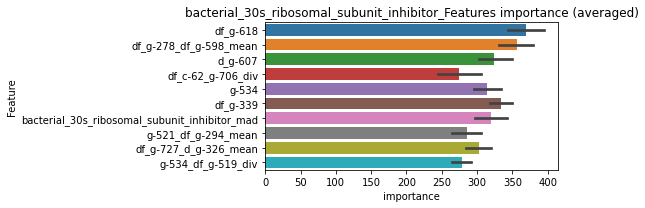

len(train_index) : 2821
len(valid_index) : 941
================================= fold 1/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124717	valid_1's binary_logloss: 0.165148
[200]	training's binary_logloss: 0.0502142	valid_1's binary_logloss: 0.0902671
[300]	training's binary_logloss: 0.0231481	valid_1's binary_logloss: 0.0569703
[400]	training's binary_logloss: 0.0112573	valid_1's binary_logloss: 0.0391938
[500]	training's binary_logloss: 0.00562766	valid_1's binary_logloss: 0.0298926
[600]	training's binary_logloss: 0.00316062	valid_1's binary_logloss: 0.0247983
[700]	training's binary_logloss: 0.00207558	valid_1's binary_logloss: 0.0220542
[800]	training's binary_logloss: 0.0015013	valid_1's binary_logloss: 0.0204268
[900]	training's binary_logloss: 0.00117701	valid_1's binary_logloss: 0.0193723
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00116411	valid_1's binary_logloss: 0.0192808


len(train_index) : 2821
len(valid_index) : 941
================================= fold 2/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125421	valid_1's binary_logloss: 0.172578
[200]	training's binary_logloss: 0.0510246	valid_1's binary_logloss: 0.099123
[300]	training's binary_logloss: 0.0225915	valid_1's binary_logloss: 0.0651031
[400]	training's binary_logloss: 0.010621	valid_1's binary_logloss: 0.0477601
[500]	training's binary_logloss: 0.00540996	valid_1's binary_logloss: 0.0383324
[600]	training's binary_logloss: 0.00314444	valid_1's binary_logloss: 0.0335954
[700]	training's binary_logloss: 0.00205353	valid_1's binary_logloss: 0.0304539
[800]	training's binary_logloss: 0.00150034	valid_1's binary_logloss: 0.0289805
[900]	training's binary_logloss: 0.00117384	valid_1's binary_logloss: 0.0279886
[1000]	training's binary_logloss: 0.000980942	valid_1's binary_logloss: 0.0272829
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.00089905	valid_1's binary_logloss: 0.0269392


len(train_index) : 2822
len(valid_index) : 940
================================= fold 3/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121055	valid_1's binary_logloss: 0.182183
[200]	training's binary_logloss: 0.0504742	valid_1's binary_logloss: 0.107763
[300]	training's binary_logloss: 0.0225496	valid_1's binary_logloss: 0.0731344
[400]	training's binary_logloss: 0.0104892	valid_1's binary_logloss: 0.0555587
[500]	training's binary_logloss: 0.00526915	valid_1's binary_logloss: 0.0461
[600]	training's binary_logloss: 0.00307743	valid_1's binary_logloss: 0.0416439
[700]	training's binary_logloss: 0.00201743	valid_1's binary_logloss: 0.0391689
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.0016541	valid_1's binary_logloss: 0.0381912


len(train_index) : 2822
len(valid_index) : 940
================================= fold 4/4 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126682	valid_1's binary_logloss: 0.180414
[200]	training's binary_logloss: 0.0516004	valid_1's binary_logloss: 0.105447
[300]	training's binary_logloss: 0.0224741	valid_1's binary_logloss: 0.0677262
[400]	training's binary_logloss: 0.0104178	valid_1's binary_logloss: 0.0485926
[500]	training's binary_logloss: 0.00519357	valid_1's binary_logloss: 0.0374345
[600]	training's binary_logloss: 0.00302679	valid_1's binary_logloss: 0.0317456
[700]	training's binary_logloss: 0.00199637	valid_1's binary_logloss: 0.0284221
[800]	training's binary_logloss: 0.00146026	valid_1's binary_logloss: 0.0259806
[900]	training's binary_logloss: 0.00115565	valid_1's binary_logloss: 0.0244108
[1000]	training's binary_logloss: 0.00096919	valid_1's binary_logloss: 0.0234046
[1100]	training's binary_logloss: 0.000856195	valid_1's binary_logloss: 0.0227868
Early stopping, best iteration is:
[1093]	training's binary_log

bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.02678654981816515


neg labels: 3289 → selected neg labels: 3277


bacterial_50s_ribosomal_subunit_inhibitor, len(trt): 80, len(othr): 3277, target_rate: 0.0033594 → Adj_target_rate: 0.0034820
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141276	valid_1's binary_logloss: 0.206708
[200]	training's binary_logloss: 0.0699726	valid_1's binary_logloss: 0.140816
[300]	training's binary_logloss: 0.0358908	valid_1's binary_logloss: 0.106313
[400]	training's binary_logloss: 0.0193371	valid_1's binary_logloss: 0.0884867
[500]	training's binary_logloss: 0.0103372	valid_1's binary_logloss: 0.0774165
[600]	training's binary_logloss: 0.00600497	valid_1's binary_logloss: 0.0700633
[700]	training's binary_logloss: 0.00373974	valid_1's binary_logloss: 0.0659638
[800]	training's binary_logloss: 0.00256647	valid_1's binary_logloss: 0.0643475
[900]	training's binary_logloss: 0.00191179	valid_1's binary_logloss: 0.0632518
[1000]	training's binary_logloss: 0.00151603	valid_1's binary_logloss: 0.0628027
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.00153989	valid_1's binary_logloss: 0.0626791
Training until validation scores

1 / 3 AUC score:0.992
y_Threshold: 0.0283939, Threshold: 0.1590956, pos_neg_ratio: 0.8000000
Remove_noisy_data: 174 → Positive_corect_labels: 634/3758
p_label_rate: 0.0100452 Vs.target_rate: 0.00336, Num_p_label: 40.0, conf_0:0.11137, conf_1:0.20682
Num_p_label: 40.0, Expected: 13.4, Adj_threshold_1: 0.1590956
Num_p_label: 27.0, Expected: 13.4, Adj_threshold_2: 0.2090956
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_3: 0.2590956
threshold: 0.2590956, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 634.0/3758, y_label_rate: 0.1687068
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126827	valid_1's binary_logloss: 0.199833
[200]	training's binary_logloss: 0.0542007	valid_1's binary_logloss: 0.124396
[300]	training's binary_logloss: 0.0256981	valid_1's binary_logloss: 0.0882795
[400]	training's binary_logloss: 0.0128029	valid_1's binary_logloss: 0.0686449
[500]	training's binary_logloss: 0.00675621	valid_1's binary_logloss: 0.0584029
[600]	training's binary_logloss: 0.00394296	valid_1's binary_logloss: 0.0514062
[700]	training's binary_logloss: 0.00254361	valid_1's binary_logloss: 0.0479911
[800]	training's binary_logloss: 0.00182073	valid_1's binary_logloss: 0.0457806
[900]	training's binary_logloss: 0.00140909	valid_1's binary_logloss: 0.0445793
[1000]	training's binary_logloss: 0.0011622	valid_1's binary_logloss: 0.0439483
[1100]	training's binary_logloss: 0.00101106	valid_1's binary_logloss: 0.043501
Early stopping, best iteration is:
[1144]	training's binary_loglos

2 / 3 AUC score:0.999
y_Threshold: 0.0967461, Threshold: 0.2590956, pos_neg_ratio: 0.8000000
Remove_noisy_data: 34 → Positive_corect_labels: 617.0/3724
p_label_rate: 0.0153189 Vs.target_rate: 0.00336, Num_p_label: 61.0, conf_0:0.20728, conf_1:0.31091
Num_p_label: 61.0, Expected: 13.4, Adj_threshold_1: 0.2590956
Num_p_label: 53.0, Expected: 13.4, Adj_threshold_2: 0.3090956
Num_p_label: 45.0, Expected: 13.4, Adj_threshold_3: 0.3590956
Num_p_label: 35.0, Expected: 13.4, Adj_threshold_4: 0.4090956
Num_p_label: 33.0, Expected: 13.4, Adj_threshold_5: 0.4590956
Num_p_label: 29.0, Expected: 13.4, Adj_threshold_6: 0.5090956
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_7: 0.5590956
Num_p_label: 20.0, Expected: 13.4, Adj_threshold_8: 0.6090956
threshold: 0.6090956, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 617.0/3724, y_label_rate: 0.1656821
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122445	valid_1's binary_logloss: 0.180967
[200]	training's binary_logloss: 0.0519595	valid_1's binary_logloss: 0.111801
[300]	training's binary_logloss: 0.0239311	valid_1's binary_logloss: 0.0795446
[400]	training's binary_logloss: 0.011682	valid_1's binary_logloss: 0.0621825
[500]	training's binary_logloss: 0.00599502	valid_1's binary_logloss: 0.0534423
[600]	training's binary_logloss: 0.00346874	valid_1's binary_logloss: 0.0480939
[700]	training's binary_logloss: 0.0022612	valid_1's binary_logloss: 0.044551
[800]	training's binary_logloss: 0.00164533	valid_1's binary_logloss: 0.0434176
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.00154966	valid_1's binary_logloss: 0.043142
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123236	valid_1's binary_logloss: 0.17412
[200]	training's binary_logloss: 0.0533364	valid_1's binar

3 / 3 AUC score:0.999
y_Threshold: 0.1102097, Threshold: 0.6090956, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 608.0/3706
p_label_rate: 0.0065294 Vs.target_rate: 0.00336, Num_p_label: 26.0, conf_0:0.50000, conf_1:0.67001
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_1: 0.6090956
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_2: 0.6590956
Num_p_label: 16.0, Expected: 13.4, Adj_threshold_3: 0.7090956
threshold: 0.7090956, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 608.0/3706, y_label_rate: 0.1640583


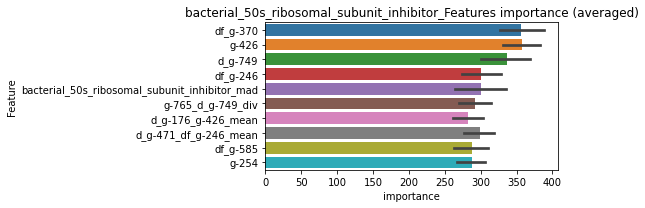

len(train_index) : 2779
len(valid_index) : 927
================================= fold 1/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118048	valid_1's binary_logloss: 0.182859
[200]	training's binary_logloss: 0.0497713	valid_1's binary_logloss: 0.112012
[300]	training's binary_logloss: 0.0226417	valid_1's binary_logloss: 0.0786431
[400]	training's binary_logloss: 0.0104509	valid_1's binary_logloss: 0.0595025
[500]	training's binary_logloss: 0.00536147	valid_1's binary_logloss: 0.0479291
[600]	training's binary_logloss: 0.00312486	valid_1's binary_logloss: 0.0419598
[700]	training's binary_logloss: 0.00207887	valid_1's binary_logloss: 0.0393307
[800]	training's binary_logloss: 0.0015421	valid_1's binary_logloss: 0.0372445
[900]	training's binary_logloss: 0.00122255	valid_1's binary_logloss: 0.0360882
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.0012582	valid_1's binary_logloss: 0.0359795


len(train_index) : 2779
len(valid_index) : 927
================================= fold 2/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120904	valid_1's binary_logloss: 0.18404
[200]	training's binary_logloss: 0.0507185	valid_1's binary_logloss: 0.116765
[300]	training's binary_logloss: 0.0232205	valid_1's binary_logloss: 0.0833615
[400]	training's binary_logloss: 0.010822	valid_1's binary_logloss: 0.0654623
[500]	training's binary_logloss: 0.00550265	valid_1's binary_logloss: 0.0551453
[600]	training's binary_logloss: 0.00318917	valid_1's binary_logloss: 0.0503225
[700]	training's binary_logloss: 0.00211273	valid_1's binary_logloss: 0.0476718
[800]	training's binary_logloss: 0.00154539	valid_1's binary_logloss: 0.0456866
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.00136006	valid_1's binary_logloss: 0.0450081


len(train_index) : 2780
len(valid_index) : 926
================================= fold 3/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119038	valid_1's binary_logloss: 0.175679
[200]	training's binary_logloss: 0.0500119	valid_1's binary_logloss: 0.103365
[300]	training's binary_logloss: 0.0229297	valid_1's binary_logloss: 0.0683599
[400]	training's binary_logloss: 0.010951	valid_1's binary_logloss: 0.0483177
[500]	training's binary_logloss: 0.00565749	valid_1's binary_logloss: 0.0384995
[600]	training's binary_logloss: 0.00324887	valid_1's binary_logloss: 0.0319683
[700]	training's binary_logloss: 0.00215866	valid_1's binary_logloss: 0.0287199
[800]	training's binary_logloss: 0.00158292	valid_1's binary_logloss: 0.0266462
[900]	training's binary_logloss: 0.00124875	valid_1's binary_logloss: 0.0250854
[1000]	training's binary_logloss: 0.00104784	valid_1's binary_logloss: 0.0240973
Early stopping, best iteration is:
[1033]	training's binary_logloss: 0.00100075	valid_1's binary_logloss: 0.0238746


len(train_index) : 2780
len(valid_index) : 926
================================= fold 4/4 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121913	valid_1's binary_logloss: 0.176839
[200]	training's binary_logloss: 0.0523724	valid_1's binary_logloss: 0.103577
[300]	training's binary_logloss: 0.0245495	valid_1's binary_logloss: 0.0680671
[400]	training's binary_logloss: 0.0115176	valid_1's binary_logloss: 0.0492531
[500]	training's binary_logloss: 0.00593565	valid_1's binary_logloss: 0.0381999
[600]	training's binary_logloss: 0.00341141	valid_1's binary_logloss: 0.0330893
[700]	training's binary_logloss: 0.00222574	valid_1's binary_logloss: 0.0290192
[800]	training's binary_logloss: 0.00161984	valid_1's binary_logloss: 0.0268585
[900]	training's binary_logloss: 0.00127113	valid_1's binary_logloss: 0.0256001
Early stopping, best iteration is:
[943]	training's binary_logloss: 0.00117118	valid_1's binary_logloss: 0.0249059


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.032446352929675536


neg labels: 3289 → selected neg labels: 3286


bacterial_antifolate, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096921	valid_1's binary_logloss: 0.133984
[200]	training's binary_logloss: 0.0339378	valid_1's binary_logloss: 0.0713398
[300]	training's binary_logloss: 0.0131676	valid_1's binary_logloss: 0.047258
[400]	training's binary_logloss: 0.00557813	valid_1's binary_logloss: 0.0356287
[500]	training's binary_logloss: 0.00282436	valid_1's binary_logloss: 0.029914
[600]	training's binary_logloss: 0.00172512	valid_1's binary_logloss: 0.0275582
[700]	training's binary_logloss: 0.00119806	valid_1's binary_logloss: 0.0261633
[800]	training's binary_logloss: 0.000927399	valid_1's binary_logloss: 0.025242
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000908966	valid_1's binary_logloss: 0.0252215
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965633	valid_1's binary_logloss: 0.141635
[200]	training's binary_logloss: 0.0338775	valid_1'

1 / 3 AUC score:0.999
y_Threshold: 0.0145052, Threshold: 0.1023387, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 652/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07164, conf_1:0.13304
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1023387
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_2: 0.1523387
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.2023387
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.2523387
threshold: 0.2523387, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3801, y_label_rate: 0.1715338
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0898943	valid_1's binary_logloss: 0.119781
[200]	training's binary_logloss: 0.0283345	valid_1's binary_logloss: 0.053609
[300]	training's binary_logloss: 0.0105891	valid_1's binary_logloss: 0.0302329
[400]	training's binary_logloss: 0.00453944	valid_1's binary_logloss: 0.0197119
[500]	training's binary_logloss: 0.00235657	valid_1's binary_logloss: 0.0147799
[600]	training's binary_logloss: 0.00144743	valid_1's binary_logloss: 0.0119382
[700]	training's binary_logloss: 0.00102562	valid_1's binary_logloss: 0.0104211
[800]	training's binary_logloss: 0.000796547	valid_1's binary_logloss: 0.00975509
[900]	training's binary_logloss: 0.000661589	valid_1's binary_logloss: 0.00906343
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000634949	valid_1's binary_logloss: 0.00898925
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0904955

2 / 3 AUC score:1.000
y_Threshold: 0.1119656, Threshold: 0.2523387, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 647.0/3791
p_label_rate: 0.0150678 Vs.target_rate: 0.00151, Num_p_label: 60.0, conf_0:0.20187, conf_1:0.30281
Num_p_label: 60.0, Expected: 6.0, Adj_threshold_1: 0.2523387
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_2: 0.3023387
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_3: 0.3523387
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_4: 0.4023387
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_5: 0.4523387
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_6: 0.5023387
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_7: 0.5523387
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.6023387
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_9: 0.6523387
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.7023387
threshold: 0.7523387, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 647.0/3791, y_label_rate: 0.1706674
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0864351	valid_1's binary_logloss: 0.119164
[200]	training's binary_logloss: 0.0267089	valid_1's binary_logloss: 0.0583139
[300]	training's binary_logloss: 0.0098578	valid_1's binary_logloss: 0.0356858
[400]	training's binary_logloss: 0.00421049	valid_1's binary_logloss: 0.0265529
[500]	training's binary_logloss: 0.00217877	valid_1's binary_logloss: 0.0227976
[600]	training's binary_logloss: 0.00136494	valid_1's binary_logloss: 0.0205453
[700]	training's binary_logloss: 0.000969206	valid_1's binary_logloss: 0.0193811
[800]	training's binary_logloss: 0.000758873	valid_1's binary_logloss: 0.0183721
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.00075281	valid_1's binary_logloss: 0.0183304
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878778	valid_1's binary_logloss: 0.121664
[200]	training's binary_logloss: 0.0276103	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1432502, Threshold: 0.7523387, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 644.0/3785
p_label_rate: 0.0035158 Vs.target_rate: 0.00151, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_1: 0.7523387
threshold: 0.7523387, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 644.0/3785, y_label_rate: 0.1701453


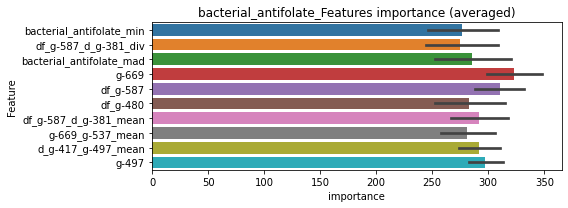

len(train_index) : 2838
len(valid_index) : 947
================================= fold 1/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0879571	valid_1's binary_logloss: 0.125267
[200]	training's binary_logloss: 0.0272866	valid_1's binary_logloss: 0.0610217
[300]	training's binary_logloss: 0.00999895	valid_1's binary_logloss: 0.0369466
[400]	training's binary_logloss: 0.00421925	valid_1's binary_logloss: 0.0273642
[500]	training's binary_logloss: 0.00218657	valid_1's binary_logloss: 0.0237269
[600]	training's binary_logloss: 0.00135935	valid_1's binary_logloss: 0.021875
[700]	training's binary_logloss: 0.00096119	valid_1's binary_logloss: 0.0210598
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.000971786	valid_1's binary_logloss: 0.020973


len(train_index) : 2839
len(valid_index) : 946
================================= fold 2/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0876743	valid_1's binary_logloss: 0.119737
[200]	training's binary_logloss: 0.0268162	valid_1's binary_logloss: 0.0532088
[300]	training's binary_logloss: 0.00975866	valid_1's binary_logloss: 0.030043
[400]	training's binary_logloss: 0.0041882	valid_1's binary_logloss: 0.0204949
[500]	training's binary_logloss: 0.00216909	valid_1's binary_logloss: 0.01596
[600]	training's binary_logloss: 0.00136251	valid_1's binary_logloss: 0.0142484
[700]	training's binary_logloss: 0.000965842	valid_1's binary_logloss: 0.0129161
[800]	training's binary_logloss: 0.000758663	valid_1's binary_logloss: 0.0123709
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.000808037	valid_1's binary_logloss: 0.0123295


len(train_index) : 2839
len(valid_index) : 946
================================= fold 3/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877511	valid_1's binary_logloss: 0.109372
[200]	training's binary_logloss: 0.027191	valid_1's binary_logloss: 0.0454322
[300]	training's binary_logloss: 0.0100256	valid_1's binary_logloss: 0.0248138
[400]	training's binary_logloss: 0.00421169	valid_1's binary_logloss: 0.0166398
[500]	training's binary_logloss: 0.0021854	valid_1's binary_logloss: 0.0130421
[600]	training's binary_logloss: 0.00135976	valid_1's binary_logloss: 0.0110701
[700]	training's binary_logloss: 0.000973158	valid_1's binary_logloss: 0.0104385
[800]	training's binary_logloss: 0.000761855	valid_1's binary_logloss: 0.00980903
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000697287	valid_1's binary_logloss: 0.00969307


len(train_index) : 2839
len(valid_index) : 946
================================= fold 4/4 bacterial_antifolate=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0862388	valid_1's binary_logloss: 0.123969
[200]	training's binary_logloss: 0.0264846	valid_1's binary_logloss: 0.0562609
[300]	training's binary_logloss: 0.00945464	valid_1's binary_logloss: 0.0311378
[400]	training's binary_logloss: 0.00409547	valid_1's binary_logloss: 0.0196284
[500]	training's binary_logloss: 0.00209026	valid_1's binary_logloss: 0.0142578
[600]	training's binary_logloss: 0.00129885	valid_1's binary_logloss: 0.0115813
[700]	training's binary_logloss: 0.000934016	valid_1's binary_logloss: 0.0101666
[800]	training's binary_logloss: 0.000728762	valid_1's binary_logloss: 0.00917107
[900]	training's binary_logloss: 0.000615444	valid_1's binary_logloss: 0.00864543
[1000]	training's binary_logloss: 0.000561228	valid_1's binary_logloss: 0.00842792
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.00056869	valid_1's binary_logloss: 0.00840013


bacterial_antifolate logloss: 0.012851052961103138


neg labels: 3289 → selected neg labels: 3268


bacterial_cell_wall_synthesis_inhibitor, len(trt): 192, len(othr): 3268, target_rate: 0.0080625 → Adj_target_rate: 0.0073283
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.198911	valid_1's binary_logloss: 0.31243
[200]	training's binary_logloss: 0.113751	valid_1's binary_logloss: 0.2661
[300]	training's binary_logloss: 0.0703333	valid_1's binary_logloss: 0.243135
[400]	training's binary_logloss: 0.0443037	valid_1's binary_logloss: 0.232935
[500]	training's binary_logloss: 0.0278081	valid_1's binary_logloss: 0.225356
[600]	training's binary_logloss: 0.0176858	valid_1's binary_logloss: 0.222878
Early stopping, best iteration is:
[593]	training's binary_logloss: 0.0182648	valid_1's binary_logloss: 0.222716
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.198289	valid_1's binary_logloss: 0.303784
[200]	training's binary_logloss: 0.110018	valid_1's binary_logloss: 0.255983
[300]	training's binary_logloss: 0.066414	valid_1's binary_logloss: 0.234083
[400]	training's binary_logloss: 0.0411976	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.925
y_Threshold: 0.0875317, Threshold: 0.3215366, pos_neg_ratio: 0.8000000
Remove_noisy_data: 338 → Positive_corect_labels: 550/3583
p_label_rate: 0.0100452 Vs.target_rate: 0.00806, Num_p_label: 40.0, conf_0:0.22508, conf_1:0.41800
threshold: 0.3215366, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 550.0/3583, y_label_rate: 0.1535027
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143433	valid_1's binary_logloss: 0.239149
[200]	training's binary_logloss: 0.0677053	valid_1's binary_logloss: 0.178255
[300]	training's binary_logloss: 0.0353026	valid_1's binary_logloss: 0.14712
[400]	training's binary_logloss: 0.0190336	valid_1's binary_logloss: 0.129122
[500]	training's binary_logloss: 0.011019	valid_1's binary_logloss: 0.120942
[600]	training's binary_logloss: 0.00659382	valid_1's binary_logloss: 0.115011
[700]	training's binary_logloss: 0.00429668	valid_1's binary_logloss: 0.11261
[800]	training's binary_logloss: 0.00303059	valid_1's binary_logloss: 0.111247
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00281562	valid_1's binary_logloss: 0.110711
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143447	valid_1's binary_logloss: 0.237854
[200]	training's binary_logloss: 0.0679937	valid_1's binary_logl

2 / 3 AUC score:0.990
y_Threshold: 0.1046715, Threshold: 0.3215366, pos_neg_ratio: 0.8000000
Remove_noisy_data: 98 → Positive_corect_labels: 501.0/3485
p_label_rate: 0.0313913 Vs.target_rate: 0.00806, Num_p_label: 125.0, conf_0:0.25723, conf_1:0.38584
Num_p_label: 125.0, Expected: 32.1, Adj_threshold_1: 0.3215366
Num_p_label: 109.0, Expected: 32.1, Adj_threshold_2: 0.3715366
Num_p_label: 92.0, Expected: 32.1, Adj_threshold_3: 0.4215366
Num_p_label: 78.0, Expected: 32.1, Adj_threshold_4: 0.4715366
Num_p_label: 62.0, Expected: 32.1, Adj_threshold_5: 0.5215366
Num_p_label: 51.0, Expected: 32.1, Adj_threshold_6: 0.5715366
Num_p_label: 49.0, Expected: 32.1, Adj_threshold_7: 0.6215366
Num_p_label: 44.0, Expected: 32.1, Adj_threshold_8: 0.6715366
threshold: 0.6715366, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 501.0/3485, y_label_rate: 0.1437590
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123641	valid_1's binary_logloss: 0.204439
[200]	training's binary_logloss: 0.0534641	valid_1's binary_logloss: 0.148652
[300]	training's binary_logloss: 0.0262922	valid_1's binary_logloss: 0.121011
[400]	training's binary_logloss: 0.013296	valid_1's binary_logloss: 0.103972
[500]	training's binary_logloss: 0.00737744	valid_1's binary_logloss: 0.0964526
[600]	training's binary_logloss: 0.00446592	valid_1's binary_logloss: 0.092183
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00424508	valid_1's binary_logloss: 0.0917073
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127363	valid_1's binary_logloss: 0.198686
[200]	training's binary_logloss: 0.0545337	valid_1's binary_logloss: 0.136209
[300]	training's binary_logloss: 0.0266827	valid_1's binary_logloss: 0.10866
[400]	training's binary_logloss: 0.013781	valid_1's binary_log

3 / 3 AUC score:0.993
y_Threshold: 0.1198625, Threshold: 0.6715366, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 473.0/3429
p_label_rate: 0.0183325 Vs.target_rate: 0.00806, Num_p_label: 73.0, conf_0:0.50000, conf_1:0.73869
Num_p_label: 73.0, Expected: 32.1, Adj_threshold_1: 0.6715366
Num_p_label: 65.0, Expected: 32.1, Adj_threshold_2: 0.7215366
Num_p_label: 55.0, Expected: 32.1, Adj_threshold_3: 0.7715366
threshold: 0.7715366, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 473.0/3429, y_label_rate: 0.1379411


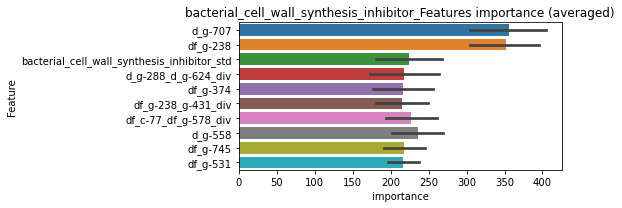

len(train_index) : 2571
len(valid_index) : 858
================================= fold 1/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115849	valid_1's binary_logloss: 0.176862
[200]	training's binary_logloss: 0.0497468	valid_1's binary_logloss: 0.118556
[300]	training's binary_logloss: 0.0233715	valid_1's binary_logloss: 0.0880388
[400]	training's binary_logloss: 0.0118779	valid_1's binary_logloss: 0.0741166
[500]	training's binary_logloss: 0.00650901	valid_1's binary_logloss: 0.06547
[600]	training's binary_logloss: 0.00390923	valid_1's binary_logloss: 0.0595287
[700]	training's binary_logloss: 0.00258652	valid_1's binary_logloss: 0.0559078
[800]	training's binary_logloss: 0.00190252	valid_1's binary_logloss: 0.0540596
[900]	training's binary_logloss: 0.00148785	valid_1's binary_logloss: 0.0524055
[1000]	training's binary_logloss: 0.00124858	valid_1's binary_logloss: 0.0519815
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.00126841	valid_1's binary_logloss: 0.0515861


len(train_index) : 2572
len(valid_index) : 857
================================= fold 2/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115288	valid_1's binary_logloss: 0.175904
[200]	training's binary_logloss: 0.0482531	valid_1's binary_logloss: 0.118121
[300]	training's binary_logloss: 0.0234661	valid_1's binary_logloss: 0.092357
[400]	training's binary_logloss: 0.0113781	valid_1's binary_logloss: 0.0779886
[500]	training's binary_logloss: 0.0062079	valid_1's binary_logloss: 0.0717756
[600]	training's binary_logloss: 0.00373554	valid_1's binary_logloss: 0.069862
[700]	training's binary_logloss: 0.00248593	valid_1's binary_logloss: 0.0677809
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00260053	valid_1's binary_logloss: 0.0674688


len(train_index) : 2572
len(valid_index) : 857
================================= fold 3/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115576	valid_1's binary_logloss: 0.180993
[200]	training's binary_logloss: 0.0493202	valid_1's binary_logloss: 0.126955
[300]	training's binary_logloss: 0.02327	valid_1's binary_logloss: 0.101699
[400]	training's binary_logloss: 0.0116272	valid_1's binary_logloss: 0.0888707
[500]	training's binary_logloss: 0.00634978	valid_1's binary_logloss: 0.0847017
[600]	training's binary_logloss: 0.00381536	valid_1's binary_logloss: 0.081813
[700]	training's binary_logloss: 0.00255685	valid_1's binary_logloss: 0.0806336
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00266682	valid_1's binary_logloss: 0.0798913


len(train_index) : 2572
len(valid_index) : 857
================================= fold 4/4 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110413	valid_1's binary_logloss: 0.189575
[200]	training's binary_logloss: 0.0459075	valid_1's binary_logloss: 0.13745
[300]	training's binary_logloss: 0.0219772	valid_1's binary_logloss: 0.112935
[400]	training's binary_logloss: 0.0109541	valid_1's binary_logloss: 0.0981198
[500]	training's binary_logloss: 0.0058483	valid_1's binary_logloss: 0.0907624
[600]	training's binary_logloss: 0.00354569	valid_1's binary_logloss: 0.0873084
[700]	training's binary_logloss: 0.00239473	valid_1's binary_logloss: 0.0860501
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00228758	valid_1's binary_logloss: 0.0857207


bacterial_cell_wall_synthesis_inhibitor logloss: 0.07116099675856707


neg labels: 3289 → selected neg labels: 3279


bacterial_dna_gyrase_inhibitor, len(trt): 89, len(othr): 3279, target_rate: 0.0037373 → Adj_target_rate: 0.0038122
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.147344	valid_1's binary_logloss: 0.223612
[200]	training's binary_logloss: 0.0695392	valid_1's binary_logloss: 0.158256
[300]	training's binary_logloss: 0.0349976	valid_1's binary_logloss: 0.124219
[400]	training's binary_logloss: 0.0187411	valid_1's binary_logloss: 0.107293
[500]	training's binary_logloss: 0.010384	valid_1's binary_logloss: 0.0956541
[600]	training's binary_logloss: 0.00598023	valid_1's binary_logloss: 0.0890952
[700]	training's binary_logloss: 0.00377179	valid_1's binary_logloss: 0.08518
[800]	training's binary_logloss: 0.0025943	valid_1's binary_logloss: 0.0825773
[900]	training's binary_logloss: 0.00194352	valid_1's binary_logloss: 0.0813216
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00200705	valid_1's binary_logloss: 0.080978
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.152112	valid_1's binary

1 / 3 AUC score:0.992
y_Threshold: 0.0316915, Threshold: 0.1383090, pos_neg_ratio: 0.8000000
Remove_noisy_data: 178 → Positive_corect_labels: 632/3756
p_label_rate: 0.0100452 Vs.target_rate: 0.00374, Num_p_label: 40.0, conf_0:0.09682, conf_1:0.17980
Num_p_label: 40.0, Expected: 14.9, Adj_threshold_1: 0.1383090
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_2: 0.1883090
Num_p_label: 23.0, Expected: 14.9, Adj_threshold_3: 0.2383090
Num_p_label: 14.0, Expected: 14.9, Adj_threshold_4: 0.2883090
threshold: 0.2883090, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 632.0/3756, y_label_rate: 0.1682641
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133949	valid_1's binary_logloss: 0.203806
[200]	training's binary_logloss: 0.056561	valid_1's binary_logloss: 0.128621
[300]	training's binary_logloss: 0.0258963	valid_1's binary_logloss: 0.0933379
[400]	training's binary_logloss: 0.0125373	valid_1's binary_logloss: 0.0744551
[500]	training's binary_logloss: 0.00661343	valid_1's binary_logloss: 0.0644858
[600]	training's binary_logloss: 0.00389335	valid_1's binary_logloss: 0.0592523
[700]	training's binary_logloss: 0.00255042	valid_1's binary_logloss: 0.0572726
[800]	training's binary_logloss: 0.00184547	valid_1's binary_logloss: 0.0558301
[900]	training's binary_logloss: 0.00144181	valid_1's binary_logloss: 0.0551453
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00148575	valid_1's binary_logloss: 0.0551053
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134696	valid_1's

2 / 3 AUC score:0.999
y_Threshold: 0.0827741, Threshold: 0.2883090, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 617.0/3726
p_label_rate: 0.0138122 Vs.target_rate: 0.00374, Num_p_label: 55.0, conf_0:0.23065, conf_1:0.34597
Num_p_label: 55.0, Expected: 14.9, Adj_threshold_1: 0.2883090
Num_p_label: 49.0, Expected: 14.9, Adj_threshold_2: 0.3383090
Num_p_label: 38.0, Expected: 14.9, Adj_threshold_3: 0.3883090
Num_p_label: 30.0, Expected: 14.9, Adj_threshold_4: 0.4383090
Num_p_label: 25.0, Expected: 14.9, Adj_threshold_5: 0.4883090
Num_p_label: 19.0, Expected: 14.9, Adj_threshold_6: 0.5383090
threshold: 0.5383090, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 617.0/3726, y_label_rate: 0.1655931
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12758	valid_1's binary_logloss: 0.190488
[200]	training's binary_logloss: 0.0515264	valid_1's binary_logloss: 0.114938
[300]	training's binary_logloss: 0.0237104	valid_1's binary_logloss: 0.0827199
[400]	training's binary_logloss: 0.0115468	valid_1's binary_logloss: 0.064308
[500]	training's binary_logloss: 0.00604724	valid_1's binary_logloss: 0.0549116
[600]	training's binary_logloss: 0.00358507	valid_1's binary_logloss: 0.0493186
[700]	training's binary_logloss: 0.00237912	valid_1's binary_logloss: 0.0459166
[800]	training's binary_logloss: 0.0017307	valid_1's binary_logloss: 0.0444261
[900]	training's binary_logloss: 0.00136209	valid_1's binary_logloss: 0.0438107
Early stopping, best iteration is:
[913]	training's binary_logloss: 0.00132434	valid_1's binary_logloss: 0.0435026
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129558	valid_1's b

3 / 3 AUC score:0.998
y_Threshold: 0.0702704, Threshold: 0.5383090, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 605.0/3702
p_label_rate: 0.0065294 Vs.target_rate: 0.00374, Num_p_label: 26.0, conf_0:0.48448, conf_1:0.59214
Num_p_label: 26.0, Expected: 14.9, Adj_threshold_1: 0.5383090
Num_p_label: 21.0, Expected: 14.9, Adj_threshold_2: 0.5883090
threshold: 0.5883090, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 605.0/3702, y_label_rate: 0.1634252


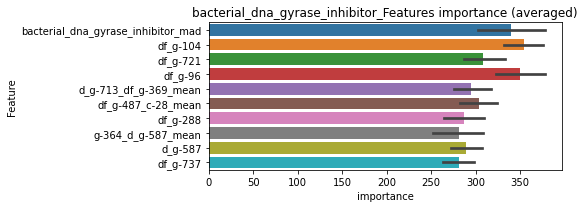

len(train_index) : 2776
len(valid_index) : 926
================================= fold 1/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122525	valid_1's binary_logloss: 0.190417
[200]	training's binary_logloss: 0.0491305	valid_1's binary_logloss: 0.118219
[300]	training's binary_logloss: 0.0218026	valid_1's binary_logloss: 0.084664
[400]	training's binary_logloss: 0.0103166	valid_1's binary_logloss: 0.0660081
[500]	training's binary_logloss: 0.00544168	valid_1's binary_logloss: 0.0568223
[600]	training's binary_logloss: 0.00320916	valid_1's binary_logloss: 0.0512995
[700]	training's binary_logloss: 0.00215628	valid_1's binary_logloss: 0.0481313
[800]	training's binary_logloss: 0.00158644	valid_1's binary_logloss: 0.0461347
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00136712	valid_1's binary_logloss: 0.0449234


len(train_index) : 2776
len(valid_index) : 926
================================= fold 2/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122715	valid_1's binary_logloss: 0.178893
[200]	training's binary_logloss: 0.0487566	valid_1's binary_logloss: 0.106634
[300]	training's binary_logloss: 0.0216677	valid_1's binary_logloss: 0.073422
[400]	training's binary_logloss: 0.0105511	valid_1's binary_logloss: 0.0571521
[500]	training's binary_logloss: 0.00551391	valid_1's binary_logloss: 0.0480008
[600]	training's binary_logloss: 0.00328058	valid_1's binary_logloss: 0.0428258
[700]	training's binary_logloss: 0.00217335	valid_1's binary_logloss: 0.0394861
[800]	training's binary_logloss: 0.00159361	valid_1's binary_logloss: 0.0373866
[900]	training's binary_logloss: 0.00126388	valid_1's binary_logloss: 0.0363806
[1000]	training's binary_logloss: 0.0010635	valid_1's binary_logloss: 0.0359352
Early stopping, best iteration is:
[982]	training's binary_logloss: 0.00109177	valid_1's binary_logloss: 0.0358101


len(train_index) : 2777
len(valid_index) : 925
================================= fold 3/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128371	valid_1's binary_logloss: 0.174998
[200]	training's binary_logloss: 0.0534123	valid_1's binary_logloss: 0.10311
[300]	training's binary_logloss: 0.0240867	valid_1's binary_logloss: 0.0687058
[400]	training's binary_logloss: 0.0114857	valid_1's binary_logloss: 0.0521606
[500]	training's binary_logloss: 0.00604502	valid_1's binary_logloss: 0.0436167
[600]	training's binary_logloss: 0.00353829	valid_1's binary_logloss: 0.0378079
[700]	training's binary_logloss: 0.00232625	valid_1's binary_logloss: 0.0340131
[800]	training's binary_logloss: 0.00168785	valid_1's binary_logloss: 0.0327
[900]	training's binary_logloss: 0.00132812	valid_1's binary_logloss: 0.0317428
[1000]	training's binary_logloss: 0.00111283	valid_1's binary_logloss: 0.0310994
[1100]	training's binary_logloss: 0.000983591	valid_1's binary_logloss: 0.0305435
[1200]	training's binary_logloss: 0.000897307	valid_1's binary_logl

len(train_index) : 2777
len(valid_index) : 925
================================= fold 4/4 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124956	valid_1's binary_logloss: 0.184661
[200]	training's binary_logloss: 0.0495868	valid_1's binary_logloss: 0.112381
[300]	training's binary_logloss: 0.0221746	valid_1's binary_logloss: 0.0815609
[400]	training's binary_logloss: 0.0104022	valid_1's binary_logloss: 0.0661604
[500]	training's binary_logloss: 0.00550698	valid_1's binary_logloss: 0.0574924
[600]	training's binary_logloss: 0.00331665	valid_1's binary_logloss: 0.0533969
[700]	training's binary_logloss: 0.00222691	valid_1's binary_logloss: 0.0511122
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.00182677	valid_1's binary_logloss: 0.0504373


bacterial_dna_gyrase_inhibitor logloss: 0.040303138568427606


neg labels: 3289 → selected neg labels: 3274


bacterial_dna_inhibitor, len(trt): 115, len(othr): 3274, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.15608	valid_1's binary_logloss: 0.241936
[200]	training's binary_logloss: 0.0745154	valid_1's binary_logloss: 0.177477
[300]	training's binary_logloss: 0.0387763	valid_1's binary_logloss: 0.147602
[400]	training's binary_logloss: 0.0212708	valid_1's binary_logloss: 0.130539
[500]	training's binary_logloss: 0.0124233	valid_1's binary_logloss: 0.122004
[600]	training's binary_logloss: 0.00739198	valid_1's binary_logloss: 0.117103
[700]	training's binary_logloss: 0.00481048	valid_1's binary_logloss: 0.114537
[800]	training's binary_logloss: 0.00333233	valid_1's binary_logloss: 0.112853
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.00297143	valid_1's binary_logloss: 0.112612
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.154207	valid_1's binary_logloss: 0.241397
[200]	training's binary_logloss: 0.0742039	valid_1's binary_lo

1 / 3 AUC score:0.982
y_Threshold: 0.0439337, Threshold: 0.2595112, pos_neg_ratio: 0.8000000
Remove_noisy_data: 204 → Positive_corect_labels: 618/3724
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.18166, conf_1:0.33736
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_1: 0.2595112
Num_p_label: 31.0, Expected: 19.2, Adj_threshold_2: 0.3095112
Num_p_label: 24.0, Expected: 19.2, Adj_threshold_3: 0.3595112
threshold: 0.3595112, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 618.0/3724, y_label_rate: 0.1659506
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138559	valid_1's binary_logloss: 0.206962
[200]	training's binary_logloss: 0.0588073	valid_1's binary_logloss: 0.133888
[300]	training's binary_logloss: 0.0282307	valid_1's binary_logloss: 0.0982812
[400]	training's binary_logloss: 0.0142679	valid_1's binary_logloss: 0.0783047
[500]	training's binary_logloss: 0.00790767	valid_1's binary_logloss: 0.0674531
[600]	training's binary_logloss: 0.00474969	valid_1's binary_logloss: 0.061055
[700]	training's binary_logloss: 0.00314471	valid_1's binary_logloss: 0.056832
[800]	training's binary_logloss: 0.00225723	valid_1's binary_logloss: 0.0541835
[900]	training's binary_logloss: 0.00175343	valid_1's binary_logloss: 0.05248
[1000]	training's binary_logloss: 0.00143806	valid_1's binary_logloss: 0.0514923
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.00139329	valid_1's binary_logloss: 0.0510727
Training until validation scores 

2 / 3 AUC score:0.993
y_Threshold: 0.0892229, Threshold: 0.3595112, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 581.0/3650
p_label_rate: 0.0200904 Vs.target_rate: 0.00483, Num_p_label: 80.0, conf_0:0.28761, conf_1:0.43141
Num_p_label: 80.0, Expected: 19.2, Adj_threshold_1: 0.3595112
Num_p_label: 66.0, Expected: 19.2, Adj_threshold_2: 0.4095112
Num_p_label: 61.0, Expected: 19.2, Adj_threshold_3: 0.4595112
Num_p_label: 57.0, Expected: 19.2, Adj_threshold_4: 0.5095112
Num_p_label: 50.0, Expected: 19.2, Adj_threshold_5: 0.5595112
Num_p_label: 42.0, Expected: 19.2, Adj_threshold_6: 0.6095112
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_7: 0.6595112
Num_p_label: 30.0, Expected: 19.2, Adj_threshold_8: 0.7095112
Num_p_label: 26.0, Expected: 19.2, Adj_threshold_9: 0.7595112
threshold: 0.7595112, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 581.0/3650, y_label_rate: 0.1591781
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120106	valid_1's binary_logloss: 0.19722
[200]	training's binary_logloss: 0.0480849	valid_1's binary_logloss: 0.131057
[300]	training's binary_logloss: 0.0219544	valid_1's binary_logloss: 0.100323
[400]	training's binary_logloss: 0.010988	valid_1's binary_logloss: 0.0855809
[500]	training's binary_logloss: 0.00591859	valid_1's binary_logloss: 0.0787358
[600]	training's binary_logloss: 0.0035727	valid_1's binary_logloss: 0.0755505
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00318693	valid_1's binary_logloss: 0.0747996
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120982	valid_1's binary_logloss: 0.185761
[200]	training's binary_logloss: 0.0486296	valid_1's binary_logloss: 0.125422
[300]	training's binary_logloss: 0.021585	valid_1's binary_logloss: 0.0986777
[400]	training's binary_logloss: 0.0104024	valid_1's binary_l

3 / 3 AUC score:0.997
y_Threshold: 0.0937483, Threshold: 0.7595112, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 560.0/3608
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_1: 0.7595112
threshold: 0.7595112, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 560.0/3608, y_label_rate: 0.1552106


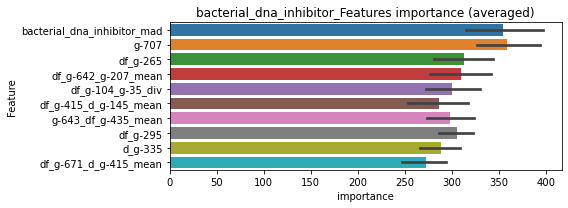

len(train_index) : 2706
len(valid_index) : 902
================================= fold 1/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112046	valid_1's binary_logloss: 0.180267
[200]	training's binary_logloss: 0.0435629	valid_1's binary_logloss: 0.113607
[300]	training's binary_logloss: 0.0193184	valid_1's binary_logloss: 0.0848419
[400]	training's binary_logloss: 0.00924982	valid_1's binary_logloss: 0.0704505
[500]	training's binary_logloss: 0.00489534	valid_1's binary_logloss: 0.0616774
[600]	training's binary_logloss: 0.00297249	valid_1's binary_logloss: 0.0581164
[700]	training's binary_logloss: 0.00202482	valid_1's binary_logloss: 0.0555239
[800]	training's binary_logloss: 0.00152577	valid_1's binary_logloss: 0.0537181
[900]	training's binary_logloss: 0.00122662	valid_1's binary_logloss: 0.0522599
Early stopping, best iteration is:
[938]	training's binary_logloss: 0.00114116	valid_1's binary_logloss: 0.0519523


len(train_index) : 2706
len(valid_index) : 902
================================= fold 2/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112223	valid_1's binary_logloss: 0.175502
[200]	training's binary_logloss: 0.0422439	valid_1's binary_logloss: 0.107315
[300]	training's binary_logloss: 0.0181359	valid_1's binary_logloss: 0.0774394
[400]	training's binary_logloss: 0.00891872	valid_1's binary_logloss: 0.0644892
[500]	training's binary_logloss: 0.00481827	valid_1's binary_logloss: 0.0577388
[600]	training's binary_logloss: 0.0029663	valid_1's binary_logloss: 0.0543477
[700]	training's binary_logloss: 0.00203974	valid_1's binary_logloss: 0.051819
[800]	training's binary_logloss: 0.00153186	valid_1's binary_logloss: 0.0508594
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.00153186	valid_1's binary_logloss: 0.0508594


len(train_index) : 2706
len(valid_index) : 902
================================= fold 3/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116285	valid_1's binary_logloss: 0.171135
[200]	training's binary_logloss: 0.0452453	valid_1's binary_logloss: 0.102858
[300]	training's binary_logloss: 0.0200806	valid_1's binary_logloss: 0.0747205
[400]	training's binary_logloss: 0.00962036	valid_1's binary_logloss: 0.0610122
[500]	training's binary_logloss: 0.0051731	valid_1's binary_logloss: 0.0542612
[600]	training's binary_logloss: 0.00313729	valid_1's binary_logloss: 0.0497683
[700]	training's binary_logloss: 0.0021481	valid_1's binary_logloss: 0.0478843
[800]	training's binary_logloss: 0.00159892	valid_1's binary_logloss: 0.047193
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.00148739	valid_1's binary_logloss: 0.0464749


len(train_index) : 2706
len(valid_index) : 902
================================= fold 4/4 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113272	valid_1's binary_logloss: 0.165916
[200]	training's binary_logloss: 0.044138	valid_1's binary_logloss: 0.101547
[300]	training's binary_logloss: 0.0193276	valid_1's binary_logloss: 0.0756748
[400]	training's binary_logloss: 0.00924253	valid_1's binary_logloss: 0.0614472
[500]	training's binary_logloss: 0.00490223	valid_1's binary_logloss: 0.0538493
[600]	training's binary_logloss: 0.00298756	valid_1's binary_logloss: 0.0500367
[700]	training's binary_logloss: 0.00203073	valid_1's binary_logloss: 0.0478504
[800]	training's binary_logloss: 0.00152667	valid_1's binary_logloss: 0.0464322
[900]	training's binary_logloss: 0.00122596	valid_1's binary_logloss: 0.0449616
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00116559	valid_1's binary_logloss: 0.0447032


bacterial_dna_inhibitor logloss: 0.04849745945686351


neg labels: 3289 → selected neg labels: 3286


bacterial_membrane_integrity_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0688853	valid_1's binary_logloss: 0.0933027
[200]	training's binary_logloss: 0.0182354	valid_1's binary_logloss: 0.0338132
[300]	training's binary_logloss: 0.00582219	valid_1's binary_logloss: 0.016438
[400]	training's binary_logloss: 0.00239231	valid_1's binary_logloss: 0.00997576
[500]	training's binary_logloss: 0.00127872	valid_1's binary_logloss: 0.00726809
[600]	training's binary_logloss: 0.000825348	valid_1's binary_logloss: 0.00609715
[700]	training's binary_logloss: 0.000608752	valid_1's binary_logloss: 0.00556876
[800]	training's binary_logloss: 0.000493604	valid_1's binary_logloss: 0.00527324
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.000492871	valid_1's binary_logloss: 0.00526283
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703176	valid_1's binary_logloss: 0.095867
[200]	training's binary_logloss: 0.018

1 / 3 AUC score:1.000
y_Threshold: 0.0048833, Threshold: 0.0298645, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02091, conf_1:0.03882
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0298645
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_2: 0.0798645
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_3: 0.1298645
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.1798645
threshold: 0.1798645, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0677973	valid_1's binary_logloss: 0.0889126
[200]	training's binary_logloss: 0.0165447	valid_1's binary_logloss: 0.0298735
[300]	training's binary_logloss: 0.00512543	valid_1's binary_logloss: 0.0134521
[400]	training's binary_logloss: 0.0021093	valid_1's binary_logloss: 0.00768144
[500]	training's binary_logloss: 0.00112816	valid_1's binary_logloss: 0.00548681
[600]	training's binary_logloss: 0.000726663	valid_1's binary_logloss: 0.00429541
[700]	training's binary_logloss: 0.000539984	valid_1's binary_logloss: 0.0037124
[800]	training's binary_logloss: 0.000443405	valid_1's binary_logloss: 0.00333222
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.000425316	valid_1's binary_logloss: 0.00326694
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680614	valid_1's binary_logloss: 0.0909824
[200]	training's binary_logloss: 0.016

2 / 3 AUC score:1.000
y_Threshold: 0.0741975, Threshold: 0.1798645, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0045203 Vs.target_rate: 0.00080, Num_p_label: 18.0, conf_0:0.14389, conf_1:0.21584
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_1: 0.1798645
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.2298645
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_3: 0.2798645
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.3298645
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.3798645
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_6: 0.4298645
threshold: 0.4298645, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674269	valid_1's binary_logloss: 0.0940145
[200]	training's binary_logloss: 0.0163201	valid_1's binary_logloss: 0.0338975
[300]	training's binary_logloss: 0.00496517	valid_1's binary_logloss: 0.0159226
[400]	training's binary_logloss: 0.00201893	valid_1's binary_logloss: 0.0101288
[500]	training's binary_logloss: 0.00107758	valid_1's binary_logloss: 0.00750399
[600]	training's binary_logloss: 0.000702204	valid_1's binary_logloss: 0.00619743
[700]	training's binary_logloss: 0.000524297	valid_1's binary_logloss: 0.00561074
[800]	training's binary_logloss: 0.000433589	valid_1's binary_logloss: 0.00519638
[900]	training's binary_logloss: 0.00039786	valid_1's binary_logloss: 0.0050412
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000395937	valid_1's binary_logloss: 0.00501456
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1432291, Threshold: 0.4298645, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0020090 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.38688, conf_1:0.47285
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_1: 0.4298645
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_2: 0.4798645
threshold: 0.4798645, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3809, y_label_rate: 0.1722237


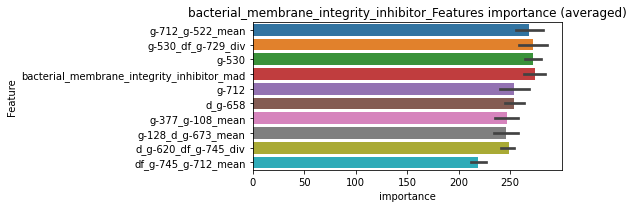

len(train_index) : 2856
len(valid_index) : 953
================================= fold 1/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0684851	valid_1's binary_logloss: 0.0951235
[200]	training's binary_logloss: 0.0168218	valid_1's binary_logloss: 0.0363847
[300]	training's binary_logloss: 0.00525915	valid_1's binary_logloss: 0.0181178
[400]	training's binary_logloss: 0.00223636	valid_1's binary_logloss: 0.0123974
[500]	training's binary_logloss: 0.00111872	valid_1's binary_logloss: 0.00883523
[600]	training's binary_logloss: 0.0007081	valid_1's binary_logloss: 0.00680521
[700]	training's binary_logloss: 0.000518319	valid_1's binary_logloss: 0.00599871
[800]	training's binary_logloss: 0.000428927	valid_1's binary_logloss: 0.00566136
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.000411338	valid_1's binary_logloss: 0.00560016


len(train_index) : 2857
len(valid_index) : 952
================================= fold 2/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682763	valid_1's binary_logloss: 0.0881958
[200]	training's binary_logloss: 0.0168162	valid_1's binary_logloss: 0.0337162
[300]	training's binary_logloss: 0.00517374	valid_1's binary_logloss: 0.0175257
[400]	training's binary_logloss: 0.00208129	valid_1's binary_logloss: 0.0114121
[500]	training's binary_logloss: 0.00110534	valid_1's binary_logloss: 0.00872348
[600]	training's binary_logloss: 0.00072272	valid_1's binary_logloss: 0.00746013
[700]	training's binary_logloss: 0.000540009	valid_1's binary_logloss: 0.00650666
[800]	training's binary_logloss: 0.000442555	valid_1's binary_logloss: 0.00617102
Early stopping, best iteration is:
[851]	training's binary_logloss: 0.000417993	valid_1's binary_logloss: 0.00606628


len(train_index) : 2857
len(valid_index) : 952
================================= fold 3/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0678998	valid_1's binary_logloss: 0.0759858
[200]	training's binary_logloss: 0.016442	valid_1's binary_logloss: 0.0217912
[300]	training's binary_logloss: 0.00506669	valid_1's binary_logloss: 0.00841849
[400]	training's binary_logloss: 0.00203505	valid_1's binary_logloss: 0.00435195
[500]	training's binary_logloss: 0.00108959	valid_1's binary_logloss: 0.0028248
[600]	training's binary_logloss: 0.00071081	valid_1's binary_logloss: 0.00219287
[700]	training's binary_logloss: 0.000529064	valid_1's binary_logloss: 0.00192133
[800]	training's binary_logloss: 0.000435938	valid_1's binary_logloss: 0.00172314
[900]	training's binary_logloss: 0.000406242	valid_1's binary_logloss: 0.00166708
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000397358	valid_1's binary_logloss: 0.00165182


len(train_index) : 2857
len(valid_index) : 952
================================= fold 4/4 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686936	valid_1's binary_logloss: 0.0860506
[200]	training's binary_logloss: 0.0167783	valid_1's binary_logloss: 0.0286471
[300]	training's binary_logloss: 0.00518301	valid_1's binary_logloss: 0.0127757
[400]	training's binary_logloss: 0.00210529	valid_1's binary_logloss: 0.00753677
[500]	training's binary_logloss: 0.00112168	valid_1's binary_logloss: 0.00523801
[600]	training's binary_logloss: 0.000731476	valid_1's binary_logloss: 0.00399264
[700]	training's binary_logloss: 0.000541666	valid_1's binary_logloss: 0.00340044
[800]	training's binary_logloss: 0.000446111	valid_1's binary_logloss: 0.00308541
[900]	training's binary_logloss: 0.000410842	valid_1's binary_logloss: 0.00297398
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00040295	valid_1's binary_logloss: 0.00295765


bacterial_membrane_integrity_inhibitor logloss: 0.004069540916596873


neg labels: 3289 → selected neg labels: 3282


bcl_inhibitor, len(trt): 31, len(othr): 3282, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0991551	valid_1's binary_logloss: 0.130193
[200]	training's binary_logloss: 0.0349061	valid_1's binary_logloss: 0.0617827
[300]	training's binary_logloss: 0.0137551	valid_1's binary_logloss: 0.0356079
[400]	training's binary_logloss: 0.00568085	valid_1's binary_logloss: 0.0229513
[500]	training's binary_logloss: 0.00284378	valid_1's binary_logloss: 0.0166159
[600]	training's binary_logloss: 0.00171437	valid_1's binary_logloss: 0.0134251
[700]	training's binary_logloss: 0.00120012	valid_1's binary_logloss: 0.0116957
[800]	training's binary_logloss: 0.000925185	valid_1's binary_logloss: 0.0107421
[900]	training's binary_logloss: 0.000763246	valid_1's binary_logloss: 0.0102388
[1000]	training's binary_logloss: 0.000666244	valid_1's binary_logloss: 0.00990668
[1100]	training's binary_logloss: 0.000619191	valid_1's binary_logloss: 0.00981605
Early stopping, best iteration is:
[1095]	training's bi

1 / 3 AUC score:1.000
y_Threshold: 0.0120831, Threshold: 0.0664332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.04650, conf_1:0.08636
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.0664332
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_2: 0.1164332
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_3: 0.1664332
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_4: 0.2164332
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_5: 0.2664332
threshold: 0.2664332, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0935124	valid_1's binary_logloss: 0.124299
[200]	training's binary_logloss: 0.0301712	valid_1's binary_logloss: 0.0563557
[300]	training's binary_logloss: 0.0108917	valid_1's binary_logloss: 0.0300056
[400]	training's binary_logloss: 0.00445744	valid_1's binary_logloss: 0.0188937
[500]	training's binary_logloss: 0.00227593	valid_1's binary_logloss: 0.013883
[600]	training's binary_logloss: 0.00141036	valid_1's binary_logloss: 0.0115901
[700]	training's binary_logloss: 0.00100707	valid_1's binary_logloss: 0.0103246
[800]	training's binary_logloss: 0.000792001	valid_1's binary_logloss: 0.00935973
[900]	training's binary_logloss: 0.000664625	valid_1's binary_logloss: 0.00886501
[1000]	training's binary_logloss: 0.000590716	valid_1's binary_logloss: 0.00865333
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.000576757	valid_1's binary_logloss: 0.00862828
Training until vali

2 / 3 AUC score:1.000
y_Threshold: 0.0692601, Threshold: 0.2664332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0080362 Vs.target_rate: 0.00130, Num_p_label: 32.0, conf_0:0.21315, conf_1:0.31972
Num_p_label: 32.0, Expected: 5.2, Adj_threshold_1: 0.2664332
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_2: 0.3164332
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_3: 0.3664332
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_4: 0.4164332
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.4664332
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_6: 0.5164332
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_7: 0.5664332
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_8: 0.6164332
threshold: 0.6164332, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0921131	valid_1's binary_logloss: 0.126182
[200]	training's binary_logloss: 0.0295202	valid_1's binary_logloss: 0.0546648
[300]	training's binary_logloss: 0.0107108	valid_1's binary_logloss: 0.0279747
[400]	training's binary_logloss: 0.00444823	valid_1's binary_logloss: 0.0165464
[500]	training's binary_logloss: 0.00228969	valid_1's binary_logloss: 0.0113184
[600]	training's binary_logloss: 0.00141269	valid_1's binary_logloss: 0.00863655
[700]	training's binary_logloss: 0.00100517	valid_1's binary_logloss: 0.0073123
[800]	training's binary_logloss: 0.000791945	valid_1's binary_logloss: 0.0064867
[900]	training's binary_logloss: 0.000662261	valid_1's binary_logloss: 0.00595549
[1000]	training's binary_logloss: 0.000593781	valid_1's binary_logloss: 0.00568694
[1100]	training's binary_logloss: 0.000571202	valid_1's binary_logloss: 0.00564309
Early stopping, best iteration is:
[1074]	training's 

3 / 3 AUC score:1.000
y_Threshold: 0.0950912, Threshold: 0.6164332, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0032647 Vs.target_rate: 0.00130, Num_p_label: 13.0, conf_0:0.50000, conf_1:0.67808
Num_p_label: 13.0, Expected: 5.2, Adj_threshold_1: 0.6164332
Num_p_label: 8.0, Expected: 5.2, Adj_threshold_2: 0.6664332
threshold: 0.6664332, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 654.0/3802, y_label_rate: 0.1720147


len(train_index) : 2851
len(valid_index) : 951
================================= fold 1/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0903207	valid_1's binary_logloss: 0.124338
[200]	training's binary_logloss: 0.0291864	valid_1's binary_logloss: 0.055226
[300]	training's binary_logloss: 0.0105259	valid_1's binary_logloss: 0.0290451
[400]	training's binary_logloss: 0.00439608	valid_1's binary_logloss: 0.0176104
[500]	training's binary_logloss: 0.00226065	valid_1's binary_logloss: 0.0119585
[600]	training's binary_logloss: 0.00140463	valid_1's binary_logloss: 0.00939257
[700]	training's binary_logloss: 0.00101075	valid_1's binary_logloss: 0.00808857
[800]	training's binary_logloss: 0.000798257	valid_1's binary_logloss: 0.00736751
[900]	training's binary_logloss: 0.000661956	valid_1's binary_logloss: 0.00677454
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.000636719	valid_1's binary_logloss: 0.00669457


len(train_index) : 2851
len(valid_index) : 951
================================= fold 2/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933259	valid_1's binary_logloss: 0.124068
[200]	training's binary_logloss: 0.0300783	valid_1's binary_logloss: 0.0513991
[300]	training's binary_logloss: 0.011003	valid_1's binary_logloss: 0.0252305
[400]	training's binary_logloss: 0.00452487	valid_1's binary_logloss: 0.0139941
[500]	training's binary_logloss: 0.00232419	valid_1's binary_logloss: 0.00927711
[600]	training's binary_logloss: 0.00144363	valid_1's binary_logloss: 0.00695369
[700]	training's binary_logloss: 0.00103201	valid_1's binary_logloss: 0.00580367
[800]	training's binary_logloss: 0.00081084	valid_1's binary_logloss: 0.0049642
[900]	training's binary_logloss: 0.000675102	valid_1's binary_logloss: 0.0044784
[1000]	training's binary_logloss: 0.000599524	valid_1's binary_logloss: 0.00419165
Early stopping, best iteration is:
[1063]	training's binary_logloss: 0.00057266	valid_1's binary_logloss: 0.00407784


len(train_index) : 2852
len(valid_index) : 950
================================= fold 3/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.092427	valid_1's binary_logloss: 0.129078
[200]	training's binary_logloss: 0.029364	valid_1's binary_logloss: 0.0563158
[300]	training's binary_logloss: 0.0105923	valid_1's binary_logloss: 0.0296921
[400]	training's binary_logloss: 0.00444923	valid_1's binary_logloss: 0.0196711
[500]	training's binary_logloss: 0.00227333	valid_1's binary_logloss: 0.0145696
[600]	training's binary_logloss: 0.00142543	valid_1's binary_logloss: 0.0125017
[700]	training's binary_logloss: 0.00102766	valid_1's binary_logloss: 0.0115007
[800]	training's binary_logloss: 0.000806451	valid_1's binary_logloss: 0.0108744
[900]	training's binary_logloss: 0.000670665	valid_1's binary_logloss: 0.0104645
Early stopping, best iteration is:
[954]	training's binary_logloss: 0.000625015	valid_1's binary_logloss: 0.0103643


len(train_index) : 2852
len(valid_index) : 950
================================= fold 4/4 bcl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930551	valid_1's binary_logloss: 0.128269
[200]	training's binary_logloss: 0.0300631	valid_1's binary_logloss: 0.0562701
[300]	training's binary_logloss: 0.011186	valid_1's binary_logloss: 0.0287314
[400]	training's binary_logloss: 0.0046562	valid_1's binary_logloss: 0.017333
[500]	training's binary_logloss: 0.00236377	valid_1's binary_logloss: 0.0119322
[600]	training's binary_logloss: 0.0014569	valid_1's binary_logloss: 0.00964698
[700]	training's binary_logloss: 0.00103889	valid_1's binary_logloss: 0.00869154
[800]	training's binary_logloss: 0.000808982	valid_1's binary_logloss: 0.00787791
[900]	training's binary_logloss: 0.000675623	valid_1's binary_logloss: 0.00746126
[1000]	training's binary_logloss: 0.00060422	valid_1's binary_logloss: 0.00722773
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.000596142	valid_1's binary_logloss: 0.00718949


bcl_inhibitor logloss: 0.007080669482780507


neg labels: 3289 → selected neg labels: 3285


bcr-abl_inhibitor, len(trt): 38, len(othr): 3285, target_rate: 0.0015957 → Adj_target_rate: 0.0018493
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108152	valid_1's binary_logloss: 0.144779
[200]	training's binary_logloss: 0.0386501	valid_1's binary_logloss: 0.0737973
[300]	training's binary_logloss: 0.0162667	valid_1's binary_logloss: 0.0453063
[400]	training's binary_logloss: 0.00724558	valid_1's binary_logloss: 0.0307403
[500]	training's binary_logloss: 0.00373383	valid_1's binary_logloss: 0.0228309
[600]	training's binary_logloss: 0.00222484	valid_1's binary_logloss: 0.0190055
[700]	training's binary_logloss: 0.0015238	valid_1's binary_logloss: 0.0166737
[800]	training's binary_logloss: 0.00115954	valid_1's binary_logloss: 0.015482
[900]	training's binary_logloss: 0.000938219	valid_1's binary_logloss: 0.014665
[1000]	training's binary_logloss: 0.000823926	valid_1's binary_logloss: 0.0141247
[1100]	training's binary_logloss: 0.000757458	valid_1's binary_logloss: 0.0138806
Early stopping, best iteration is:
[1121]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0127580, Threshold: 0.1709840, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00160, Num_p_label: 40.0, conf_0:0.11969, conf_1:0.22228
Num_p_label: 40.0, Expected: 6.4, Adj_threshold_1: 0.1709840
Num_p_label: 30.0, Expected: 6.4, Adj_threshold_2: 0.2209840
Num_p_label: 25.0, Expected: 6.4, Adj_threshold_3: 0.2709840
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_4: 0.3209840
Num_p_label: 17.0, Expected: 6.4, Adj_threshold_5: 0.3709840
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_6: 0.4209840
threshold: 0.4209840, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103177	valid_1's binary_logloss: 0.149296
[200]	training's binary_logloss: 0.03433	valid_1's binary_logloss: 0.074558
[300]	training's binary_logloss: 0.0134092	valid_1's binary_logloss: 0.0453007
[400]	training's binary_logloss: 0.00586088	valid_1's binary_logloss: 0.0319013
[500]	training's binary_logloss: 0.00302997	valid_1's binary_logloss: 0.024938
[600]	training's binary_logloss: 0.00186544	valid_1's binary_logloss: 0.0212757
[700]	training's binary_logloss: 0.00129439	valid_1's binary_logloss: 0.0189635
[800]	training's binary_logloss: 0.000984386	valid_1's binary_logloss: 0.0175878
[900]	training's binary_logloss: 0.000805882	valid_1's binary_logloss: 0.0166903
[1000]	training's binary_logloss: 0.000713219	valid_1's binary_logloss: 0.0162149
[1100]	training's binary_logloss: 0.000678538	valid_1's binary_logloss: 0.0160038
Early stopping, best iteration is:
[1107]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.0995478, Threshold: 0.4209840, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0135610 Vs.target_rate: 0.00160, Num_p_label: 54.0, conf_0:0.33679, conf_1:0.50518
Num_p_label: 54.0, Expected: 6.4, Adj_threshold_1: 0.4209840
Num_p_label: 49.0, Expected: 6.4, Adj_threshold_2: 0.4709840
Num_p_label: 46.0, Expected: 6.4, Adj_threshold_3: 0.5209840
Num_p_label: 41.0, Expected: 6.4, Adj_threshold_4: 0.5709840
Num_p_label: 36.0, Expected: 6.4, Adj_threshold_5: 0.6209840
Num_p_label: 31.0, Expected: 6.4, Adj_threshold_6: 0.6709840
Num_p_label: 28.0, Expected: 6.4, Adj_threshold_7: 0.7209840
Num_p_label: 22.0, Expected: 6.4, Adj_threshold_8: 0.7709840
threshold: 0.7709840, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 648.0/3792, y_label_rate: 0.1708861
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100651	valid_1's binary_logloss: 0.147566
[200]	training's binary_logloss: 0.0327105	valid_1's binary_logloss: 0.0717786
[300]	training's binary_logloss: 0.0124806	valid_1's binary_logloss: 0.0424767
[400]	training's binary_logloss: 0.00548093	valid_1's binary_logloss: 0.0296999
[500]	training's binary_logloss: 0.00285734	valid_1's binary_logloss: 0.0234247
[600]	training's binary_logloss: 0.00175631	valid_1's binary_logloss: 0.0204388
[700]	training's binary_logloss: 0.00124368	valid_1's binary_logloss: 0.0188377
[800]	training's binary_logloss: 0.000953393	valid_1's binary_logloss: 0.0180899
[900]	training's binary_logloss: 0.000785265	valid_1's binary_logloss: 0.0176505
Early stopping, best iteration is:
[963]	training's binary_logloss: 0.000715755	valid_1's binary_logloss: 0.0173872
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100986	val

3 / 3 AUC score:0.999
y_Threshold: 0.0603188, Threshold: 0.7709840, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 641.0/3778
p_label_rate: 0.0057760 Vs.target_rate: 0.00160, Num_p_label: 23.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 23.0, Expected: 6.4, Adj_threshold_1: 0.7709840
threshold: 0.7709840, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 641.0/3778, y_label_rate: 0.1696665


len(train_index) : 2833
len(valid_index) : 945
================================= fold 1/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096605	valid_1's binary_logloss: 0.145923
[200]	training's binary_logloss: 0.0304449	valid_1's binary_logloss: 0.0743787
[300]	training's binary_logloss: 0.011347	valid_1's binary_logloss: 0.0489821
[400]	training's binary_logloss: 0.00500534	valid_1's binary_logloss: 0.0390054
[500]	training's binary_logloss: 0.00261411	valid_1's binary_logloss: 0.0340547
[600]	training's binary_logloss: 0.00161808	valid_1's binary_logloss: 0.0324298
[700]	training's binary_logloss: 0.00114285	valid_1's binary_logloss: 0.0313479
[800]	training's binary_logloss: 0.000883581	valid_1's binary_logloss: 0.0308663
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00091509	valid_1's binary_logloss: 0.0306333


len(train_index) : 2833
len(valid_index) : 945
================================= fold 2/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.098843	valid_1's binary_logloss: 0.138543
[200]	training's binary_logloss: 0.0313735	valid_1's binary_logloss: 0.063532
[300]	training's binary_logloss: 0.0119474	valid_1's binary_logloss: 0.0353773
[400]	training's binary_logloss: 0.00525312	valid_1's binary_logloss: 0.022787
[500]	training's binary_logloss: 0.00273299	valid_1's binary_logloss: 0.0166759
[600]	training's binary_logloss: 0.00170916	valid_1's binary_logloss: 0.0133822
[700]	training's binary_logloss: 0.00120372	valid_1's binary_logloss: 0.0115308
[800]	training's binary_logloss: 0.000926963	valid_1's binary_logloss: 0.0102533
[900]	training's binary_logloss: 0.00076517	valid_1's binary_logloss: 0.00950976
[1000]	training's binary_logloss: 0.000677205	valid_1's binary_logloss: 0.00900149
[1100]	training's binary_logloss: 0.000631412	valid_1's binary_logloss: 0.00876607
Early stopping, best iteration is:
[1080]	training's binar

len(train_index) : 2834
len(valid_index) : 944
================================= fold 3/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989648	valid_1's binary_logloss: 0.131879
[200]	training's binary_logloss: 0.0326695	valid_1's binary_logloss: 0.0586255
[300]	training's binary_logloss: 0.0123185	valid_1's binary_logloss: 0.030039
[400]	training's binary_logloss: 0.00538482	valid_1's binary_logloss: 0.0180655
[500]	training's binary_logloss: 0.00283029	valid_1's binary_logloss: 0.0123282
[600]	training's binary_logloss: 0.0017393	valid_1's binary_logloss: 0.00934336
[700]	training's binary_logloss: 0.0012242	valid_1's binary_logloss: 0.00780475
[800]	training's binary_logloss: 0.000941081	valid_1's binary_logloss: 0.00673876
[900]	training's binary_logloss: 0.000774179	valid_1's binary_logloss: 0.00611031
[1000]	training's binary_logloss: 0.000678886	valid_1's binary_logloss: 0.00576264
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000651361	valid_1's binary_logloss: 0.00567546


len(train_index) : 2834
len(valid_index) : 944
================================= fold 4/4 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0992587	valid_1's binary_logloss: 0.141765
[200]	training's binary_logloss: 0.0318916	valid_1's binary_logloss: 0.0659592
[300]	training's binary_logloss: 0.01202	valid_1's binary_logloss: 0.0385171
[400]	training's binary_logloss: 0.00523826	valid_1's binary_logloss: 0.0267914
[500]	training's binary_logloss: 0.00274577	valid_1's binary_logloss: 0.0215553
[600]	training's binary_logloss: 0.00168465	valid_1's binary_logloss: 0.0189182
[700]	training's binary_logloss: 0.00118741	valid_1's binary_logloss: 0.0174084
[800]	training's binary_logloss: 0.000914935	valid_1's binary_logloss: 0.0165297
[900]	training's binary_logloss: 0.000753668	valid_1's binary_logloss: 0.0160098
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000724798	valid_1's binary_logloss: 0.0157815


bcr-abl_inhibitor logloss: 0.015218470474744202


neg labels: 3289 → selected neg labels: 3280


benzodiazepine_receptor_agonist, len(trt): 67, len(othr): 3280, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130161	valid_1's binary_logloss: 0.201428
[200]	training's binary_logloss: 0.0587698	valid_1's binary_logloss: 0.143434
[300]	training's binary_logloss: 0.0275505	valid_1's binary_logloss: 0.112858
[400]	training's binary_logloss: 0.0136571	valid_1's binary_logloss: 0.095292
[500]	training's binary_logloss: 0.00702886	valid_1's binary_logloss: 0.0868091
[600]	training's binary_logloss: 0.00397067	valid_1's binary_logloss: 0.0812267
[700]	training's binary_logloss: 0.00254051	valid_1's binary_logloss: 0.0778948
[800]	training's binary_logloss: 0.00180884	valid_1's binary_logloss: 0.0773195
[900]	training's binary_logloss: 0.00138917	valid_1's binary_logloss: 0.0758242
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.00122024	valid_1's binary_logloss: 0.0752289
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129027	valid_1's 

1 / 3 AUC score:0.996
y_Threshold: 0.0275382, Threshold: 0.2039109, pos_neg_ratio: 0.8000000
Remove_noisy_data: 158 → Positive_corect_labels: 643/3778
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.14274, conf_1:0.26508
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.2039109
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_2: 0.2539109
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_3: 0.3039109
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_4: 0.3539109
Num_p_label: 15.0, Expected: 11.2, Adj_threshold_5: 0.4039109
threshold: 0.4039109, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 643.0/3778, y_label_rate: 0.1701959
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121705	valid_1's binary_logloss: 0.161496
[200]	training's binary_logloss: 0.0499946	valid_1's binary_logloss: 0.0910201
[300]	training's binary_logloss: 0.0216834	valid_1's binary_logloss: 0.0583446
[400]	training's binary_logloss: 0.0104035	valid_1's binary_logloss: 0.0414703
[500]	training's binary_logloss: 0.00526231	valid_1's binary_logloss: 0.0322913
[600]	training's binary_logloss: 0.00301961	valid_1's binary_logloss: 0.0269263
[700]	training's binary_logloss: 0.00198234	valid_1's binary_logloss: 0.0242152
[800]	training's binary_logloss: 0.0014446	valid_1's binary_logloss: 0.0224686
[900]	training's binary_logloss: 0.00113678	valid_1's binary_logloss: 0.021408
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.00113307	valid_1's binary_logloss: 0.0214058
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121175	valid_1's

2 / 3 AUC score:0.998
y_Threshold: 0.1175886, Threshold: 0.4039109, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 622.0/3736
p_label_rate: 0.0188348 Vs.target_rate: 0.00281, Num_p_label: 75.0, conf_0:0.32313, conf_1:0.48469
Num_p_label: 75.0, Expected: 11.2, Adj_threshold_1: 0.4039109
Num_p_label: 65.0, Expected: 11.2, Adj_threshold_2: 0.4539109
Num_p_label: 60.0, Expected: 11.2, Adj_threshold_3: 0.5039109
Num_p_label: 53.0, Expected: 11.2, Adj_threshold_4: 0.5539109
Num_p_label: 48.0, Expected: 11.2, Adj_threshold_5: 0.6039109
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_6: 0.6539109
Num_p_label: 37.0, Expected: 11.2, Adj_threshold_7: 0.7039109
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_8: 0.7539109
threshold: 0.7539109, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 622.0/3736, y_label_rate: 0.1664882
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10782	valid_1's binary_logloss: 0.169592
[200]	training's binary_logloss: 0.0406088	valid_1's binary_logloss: 0.104801
[300]	training's binary_logloss: 0.0174379	valid_1's binary_logloss: 0.0756397
[400]	training's binary_logloss: 0.00807706	valid_1's binary_logloss: 0.0595608
[500]	training's binary_logloss: 0.00407497	valid_1's binary_logloss: 0.0524943
[600]	training's binary_logloss: 0.00239193	valid_1's binary_logloss: 0.0481061
[700]	training's binary_logloss: 0.00160884	valid_1's binary_logloss: 0.0462374
[800]	training's binary_logloss: 0.00120913	valid_1's binary_logloss: 0.0449915
[900]	training's binary_logloss: 0.000966415	valid_1's binary_logloss: 0.044147
[1000]	training's binary_logloss: 0.000830282	valid_1's binary_logloss: 0.0432954
[1100]	training's binary_logloss: 0.000756791	valid_1's binary_logloss: 0.0430294
Early stopping, best iteration is:
[1092]	training's binary_lo

3 / 3 AUC score:0.999
y_Threshold: 0.1178590, Threshold: 0.7539109, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 609.0/3710
p_label_rate: 0.0113009 Vs.target_rate: 0.00281, Num_p_label: 45.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 45.0, Expected: 11.2, Adj_threshold_1: 0.7539109
threshold: 0.7539109, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 609.0/3710, y_label_rate: 0.1641509


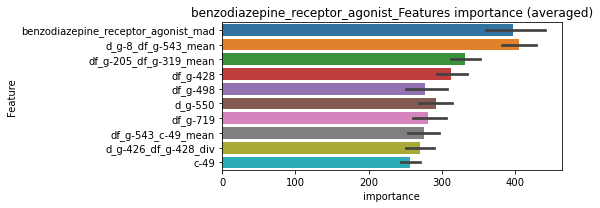

len(train_index) : 2782
len(valid_index) : 928
================================= fold 1/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110155	valid_1's binary_logloss: 0.153928
[200]	training's binary_logloss: 0.0426941	valid_1's binary_logloss: 0.0845636
[300]	training's binary_logloss: 0.0184517	valid_1's binary_logloss: 0.0546158
[400]	training's binary_logloss: 0.00826403	valid_1's binary_logloss: 0.0383591
[500]	training's binary_logloss: 0.00415267	valid_1's binary_logloss: 0.0287881
[600]	training's binary_logloss: 0.00243185	valid_1's binary_logloss: 0.0234199
[700]	training's binary_logloss: 0.00163128	valid_1's binary_logloss: 0.0206719
[800]	training's binary_logloss: 0.00121242	valid_1's binary_logloss: 0.0187505
[900]	training's binary_logloss: 0.000974616	valid_1's binary_logloss: 0.017538
[1000]	training's binary_logloss: 0.000838464	valid_1's binary_logloss: 0.0167758
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.000819881	valid_1's binary_logloss: 0.0167242


len(train_index) : 2782
len(valid_index) : 928
================================= fold 2/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110371	valid_1's binary_logloss: 0.162033
[200]	training's binary_logloss: 0.0427116	valid_1's binary_logloss: 0.0931556
[300]	training's binary_logloss: 0.0182006	valid_1's binary_logloss: 0.0618974
[400]	training's binary_logloss: 0.0081152	valid_1's binary_logloss: 0.0459567
[500]	training's binary_logloss: 0.00407628	valid_1's binary_logloss: 0.0366164
[600]	training's binary_logloss: 0.00236883	valid_1's binary_logloss: 0.0320089
[700]	training's binary_logloss: 0.00158303	valid_1's binary_logloss: 0.0293164
[800]	training's binary_logloss: 0.00118561	valid_1's binary_logloss: 0.0275471
[900]	training's binary_logloss: 0.000952192	valid_1's binary_logloss: 0.0265037
[1000]	training's binary_logloss: 0.000820433	valid_1's binary_logloss: 0.0257533
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.00081369	valid_1's binary_logloss: 0.0256579


len(train_index) : 2783
len(valid_index) : 927
================================= fold 3/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107926	valid_1's binary_logloss: 0.15642
[200]	training's binary_logloss: 0.0416542	valid_1's binary_logloss: 0.0914402
[300]	training's binary_logloss: 0.0185648	valid_1's binary_logloss: 0.0655165
[400]	training's binary_logloss: 0.008191	valid_1's binary_logloss: 0.0495698
[500]	training's binary_logloss: 0.00413161	valid_1's binary_logloss: 0.043078
[600]	training's binary_logloss: 0.00243489	valid_1's binary_logloss: 0.0406543
[700]	training's binary_logloss: 0.00161204	valid_1's binary_logloss: 0.0390457
[800]	training's binary_logloss: 0.00119441	valid_1's binary_logloss: 0.0381029
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.00111996	valid_1's binary_logloss: 0.0379531


len(train_index) : 2783
len(valid_index) : 927
================================= fold 4/4 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116613	valid_1's binary_logloss: 0.150138
[200]	training's binary_logloss: 0.0454557	valid_1's binary_logloss: 0.0793466
[300]	training's binary_logloss: 0.0203364	valid_1's binary_logloss: 0.0497785
[400]	training's binary_logloss: 0.00909014	valid_1's binary_logloss: 0.0320801
[500]	training's binary_logloss: 0.00448438	valid_1's binary_logloss: 0.0225633
[600]	training's binary_logloss: 0.00258163	valid_1's binary_logloss: 0.0174587
[700]	training's binary_logloss: 0.00169354	valid_1's binary_logloss: 0.014589
[800]	training's binary_logloss: 0.00123947	valid_1's binary_logloss: 0.0127619
[900]	training's binary_logloss: 0.000985672	valid_1's binary_logloss: 0.0117634
[1000]	training's binary_logloss: 0.000841436	valid_1's binary_logloss: 0.0110788
[1100]	training's binary_logloss: 0.00076891	valid_1's binary_logloss: 0.010792
[1200]	training's binary_logloss: 0.000731668	valid_1's binary

benzodiazepine_receptor_agonist logloss: 0.02269757219631637


neg labels: 3289 → selected neg labels: 3287


beta_amyloid_inhibitor, len(trt): 24, len(othr): 3287, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0859876	valid_1's binary_logloss: 0.114811
[200]	training's binary_logloss: 0.0254292	valid_1's binary_logloss: 0.0443458
[300]	training's binary_logloss: 0.0089355	valid_1's binary_logloss: 0.021128
[400]	training's binary_logloss: 0.00382404	valid_1's binary_logloss: 0.0121561
[500]	training's binary_logloss: 0.00198021	valid_1's binary_logloss: 0.00804915
[600]	training's binary_logloss: 0.0012433	valid_1's binary_logloss: 0.00618606
[700]	training's binary_logloss: 0.00089609	valid_1's binary_logloss: 0.00529071
[800]	training's binary_logloss: 0.000704038	valid_1's binary_logloss: 0.00470471
[900]	training's binary_logloss: 0.000596613	valid_1's binary_logloss: 0.00439187
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.0005816	valid_1's binary_logloss: 0.00434459
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0846639

1 / 3 AUC score:1.000
y_Threshold: 0.0069229, Threshold: 0.0449928, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03149, conf_1:0.05849
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0449928
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_2: 0.0949928
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_3: 0.1449928
threshold: 0.1449928, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0849686	valid_1's binary_logloss: 0.11229
[200]	training's binary_logloss: 0.0239087	valid_1's binary_logloss: 0.0415649
[300]	training's binary_logloss: 0.00814283	valid_1's binary_logloss: 0.019077
[400]	training's binary_logloss: 0.00337263	valid_1's binary_logloss: 0.0106319
[500]	training's binary_logloss: 0.00176755	valid_1's binary_logloss: 0.00747382
[600]	training's binary_logloss: 0.00111927	valid_1's binary_logloss: 0.00582534
[700]	training's binary_logloss: 0.000804792	valid_1's binary_logloss: 0.00483553
[800]	training's binary_logloss: 0.000639067	valid_1's binary_logloss: 0.00431548
[900]	training's binary_logloss: 0.000548722	valid_1's binary_logloss: 0.00401467
[1000]	training's binary_logloss: 0.000525235	valid_1's binary_logloss: 0.00398459
[1100]	training's binary_logloss: 0.000508702	valid_1's binary_logloss: 0.00389759
Early stopping, best iteration is:
[1072]	training

2 / 3 AUC score:1.000
y_Threshold: 0.0738164, Threshold: 0.1449928, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0080362 Vs.target_rate: 0.00101, Num_p_label: 32.0, conf_0:0.11599, conf_1:0.17399
Num_p_label: 32.0, Expected: 4.0, Adj_threshold_1: 0.1449928
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_2: 0.1949928
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_3: 0.2449928
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.2949928
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.3449928
threshold: 0.3449928, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0849686	valid_1's binary_logloss: 0.11229
[200]	training's binary_logloss: 0.0239087	valid_1's binary_logloss: 0.0415649
[300]	training's binary_logloss: 0.00814283	valid_1's binary_logloss: 0.019077
[400]	training's binary_logloss: 0.00337263	valid_1's binary_logloss: 0.0106319
[500]	training's binary_logloss: 0.00176755	valid_1's binary_logloss: 0.00747382
[600]	training's binary_logloss: 0.00111927	valid_1's binary_logloss: 0.00582534
[700]	training's binary_logloss: 0.000804792	valid_1's binary_logloss: 0.00483553
[800]	training's binary_logloss: 0.000639067	valid_1's binary_logloss: 0.00431548
[900]	training's binary_logloss: 0.000548722	valid_1's binary_logloss: 0.00401467
[1000]	training's binary_logloss: 0.000525235	valid_1's binary_logloss: 0.00398459
[1100]	training's binary_logloss: 0.000508702	valid_1's binary_logloss: 0.00389759
Early stopping, best iteration is:
[1072]	training

3 / 3 AUC score:1.000
y_Threshold: 0.0738164, Threshold: 0.3449928, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.31049, conf_1:0.37949
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_1: 0.3449928
threshold: 0.3449928, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


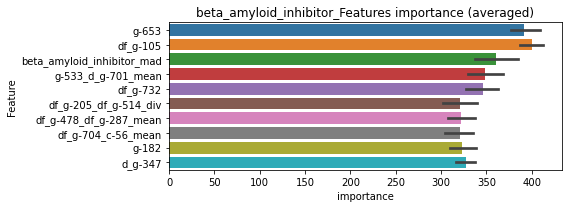

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843319	valid_1's binary_logloss: 0.11067
[200]	training's binary_logloss: 0.023764	valid_1's binary_logloss: 0.0406503
[300]	training's binary_logloss: 0.00815517	valid_1's binary_logloss: 0.018703
[400]	training's binary_logloss: 0.00338246	valid_1's binary_logloss: 0.0102606
[500]	training's binary_logloss: 0.00176537	valid_1's binary_logloss: 0.00685802
[600]	training's binary_logloss: 0.0011187	valid_1's binary_logloss: 0.00529854
[700]	training's binary_logloss: 0.000807792	valid_1's binary_logloss: 0.00438796
[800]	training's binary_logloss: 0.000641935	valid_1's binary_logloss: 0.00400077
[900]	training's binary_logloss: 0.000550653	valid_1's binary_logloss: 0.00366026
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000544277	valid_1's binary_logloss: 0.00364588


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855282	valid_1's binary_logloss: 0.114757
[200]	training's binary_logloss: 0.0243044	valid_1's binary_logloss: 0.046272
[300]	training's binary_logloss: 0.0081717	valid_1's binary_logloss: 0.0242006
[400]	training's binary_logloss: 0.00344488	valid_1's binary_logloss: 0.0159638
[500]	training's binary_logloss: 0.00179979	valid_1's binary_logloss: 0.012221
[600]	training's binary_logloss: 0.00113742	valid_1's binary_logloss: 0.0103282
[700]	training's binary_logloss: 0.000823635	valid_1's binary_logloss: 0.00971586
[800]	training's binary_logloss: 0.000650466	valid_1's binary_logloss: 0.00914086
[900]	training's binary_logloss: 0.000553732	valid_1's binary_logloss: 0.00888253
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000556735	valid_1's binary_logloss: 0.00885843


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838475	valid_1's binary_logloss: 0.112074
[200]	training's binary_logloss: 0.0238719	valid_1's binary_logloss: 0.0444465
[300]	training's binary_logloss: 0.00812206	valid_1's binary_logloss: 0.020906
[400]	training's binary_logloss: 0.00335071	valid_1's binary_logloss: 0.0119187
[500]	training's binary_logloss: 0.00177482	valid_1's binary_logloss: 0.00884685
[600]	training's binary_logloss: 0.00112624	valid_1's binary_logloss: 0.00713805
[700]	training's binary_logloss: 0.000814708	valid_1's binary_logloss: 0.00619571
[800]	training's binary_logloss: 0.000643372	valid_1's binary_logloss: 0.00578008
[900]	training's binary_logloss: 0.000553291	valid_1's binary_logloss: 0.00552711
[1000]	training's binary_logloss: 0.000518384	valid_1's binary_logloss: 0.00537133
Early stopping, best iteration is:
[1006]	training's binary_logloss: 0.00051655	valid_1's binary_logloss: 0.00535283


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851354	valid_1's binary_logloss: 0.116279
[200]	training's binary_logloss: 0.0242029	valid_1's binary_logloss: 0.0442756
[300]	training's binary_logloss: 0.00826754	valid_1's binary_logloss: 0.0196271
[400]	training's binary_logloss: 0.00344554	valid_1's binary_logloss: 0.0101447
[500]	training's binary_logloss: 0.00181616	valid_1's binary_logloss: 0.00669874
[600]	training's binary_logloss: 0.00114833	valid_1's binary_logloss: 0.00494401
[700]	training's binary_logloss: 0.000824528	valid_1's binary_logloss: 0.00408763
[800]	training's binary_logloss: 0.000649636	valid_1's binary_logloss: 0.00356514
[900]	training's binary_logloss: 0.000550719	valid_1's binary_logloss: 0.0032279
[1000]	training's binary_logloss: 0.00051672	valid_1's binary_logloss: 0.00315295
[1100]	training's binary_logloss: 0.000501474	valid_1's binary_logloss: 0.00309623
Early stopping, best iteration is:
[1070]	training

beta_amyloid_inhibitor logloss: 0.005238949078503161


neg labels: 3289 → selected neg labels: 3281


bromodomain_inhibitor, len(trt): 68, len(othr): 3281, target_rate: 0.0028555 → Adj_target_rate: 0.0030327
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123065	valid_1's binary_logloss: 0.201615
[200]	training's binary_logloss: 0.0488432	valid_1's binary_logloss: 0.132626
[300]	training's binary_logloss: 0.0217872	valid_1's binary_logloss: 0.103064
[400]	training's binary_logloss: 0.010596	valid_1's binary_logloss: 0.0876222
[500]	training's binary_logloss: 0.00572228	valid_1's binary_logloss: 0.0807919
[600]	training's binary_logloss: 0.0034444	valid_1's binary_logloss: 0.0773747
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.00285394	valid_1's binary_logloss: 0.0765259
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128445	valid_1's binary_logloss: 0.186329
[200]	training's binary_logloss: 0.0532488	valid_1's binary_logloss: 0.119048
[300]	training's binary_logloss: 0.0244554	valid_1's binary_logloss: 0.0898919
[400]	training's binary_logloss: 0.0120317	valid_1's binary

1 / 3 AUC score:0.994
y_Threshold: 0.0379134, Threshold: 0.2255610, pos_neg_ratio: 0.8000000
Remove_noisy_data: 162 → Positive_corect_labels: 641/3775
p_label_rate: 0.0100452 Vs.target_rate: 0.00286, Num_p_label: 40.0, conf_0:0.15789, conf_1:0.29323
Num_p_label: 40.0, Expected: 11.4, Adj_threshold_1: 0.2255610
Num_p_label: 29.0, Expected: 11.4, Adj_threshold_2: 0.2755610
Num_p_label: 22.0, Expected: 11.4, Adj_threshold_3: 0.3255610
Num_p_label: 19.0, Expected: 11.4, Adj_threshold_4: 0.3755610
Num_p_label: 15.0, Expected: 11.4, Adj_threshold_5: 0.4255610
threshold: 0.4255610, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 641.0/3775, y_label_rate: 0.1698013
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111043	valid_1's binary_logloss: 0.175243
[200]	training's binary_logloss: 0.0403035	valid_1's binary_logloss: 0.106183
[300]	training's binary_logloss: 0.0166351	valid_1's binary_logloss: 0.0772013
[400]	training's binary_logloss: 0.00782277	valid_1's binary_logloss: 0.0645905
[500]	training's binary_logloss: 0.00405554	valid_1's binary_logloss: 0.0578181
[600]	training's binary_logloss: 0.0024909	valid_1's binary_logloss: 0.0544835
[700]	training's binary_logloss: 0.00171158	valid_1's binary_logloss: 0.0523364
[800]	training's binary_logloss: 0.00129408	valid_1's binary_logloss: 0.0513582
Early stopping, best iteration is:
[784]	training's binary_logloss: 0.00134265	valid_1's binary_logloss: 0.0512559
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11286	valid_1's binary_logloss: 0.16257
[200]	training's binary_logloss: 0.0412594	valid_1's bi

2 / 3 AUC score:0.998
y_Threshold: 0.1193038, Threshold: 0.4255610, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 615.0/3723
p_label_rate: 0.0210949 Vs.target_rate: 0.00286, Num_p_label: 84.0, conf_0:0.34045, conf_1:0.51067
Num_p_label: 84.0, Expected: 11.4, Adj_threshold_1: 0.4255610
Num_p_label: 71.0, Expected: 11.4, Adj_threshold_2: 0.4755610
Num_p_label: 61.0, Expected: 11.4, Adj_threshold_3: 0.5255610
Num_p_label: 55.0, Expected: 11.4, Adj_threshold_4: 0.5755610
Num_p_label: 49.0, Expected: 11.4, Adj_threshold_5: 0.6255610
Num_p_label: 44.0, Expected: 11.4, Adj_threshold_6: 0.6755610
Num_p_label: 38.0, Expected: 11.4, Adj_threshold_7: 0.7255610
Num_p_label: 27.0, Expected: 11.4, Adj_threshold_8: 0.7755610
threshold: 0.7755610, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 615.0/3723, y_label_rate: 0.1651894
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101378	valid_1's binary_logloss: 0.155745
[200]	training's binary_logloss: 0.0355572	valid_1's binary_logloss: 0.091065
[300]	training's binary_logloss: 0.0143351	valid_1's binary_logloss: 0.0642183
[400]	training's binary_logloss: 0.00653954	valid_1's binary_logloss: 0.0520645
[500]	training's binary_logloss: 0.00342761	valid_1's binary_logloss: 0.0459437
[600]	training's binary_logloss: 0.00209774	valid_1's binary_logloss: 0.0418651
[700]	training's binary_logloss: 0.00146395	valid_1's binary_logloss: 0.0403906
[800]	training's binary_logloss: 0.00112465	valid_1's binary_logloss: 0.039653
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.00117907	valid_1's binary_logloss: 0.0393361
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104365	valid_1's binary_logloss: 0.145343
[200]	training's binary_logloss: 0.0363444	valid_1's 

3 / 3 AUC score:0.999
y_Threshold: 0.1337664, Threshold: 0.7755610, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 599.0/3691
p_label_rate: 0.0115520 Vs.target_rate: 0.00286, Num_p_label: 46.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 46.0, Expected: 11.4, Adj_threshold_1: 0.7755610
threshold: 0.7755610, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 599.0/3691, y_label_rate: 0.1622866


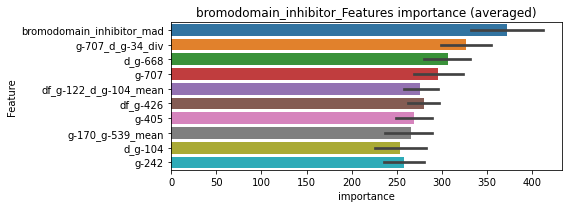

len(train_index) : 2768
len(valid_index) : 923
================================= fold 1/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101593	valid_1's binary_logloss: 0.148151
[200]	training's binary_logloss: 0.0345865	valid_1's binary_logloss: 0.0809911
[300]	training's binary_logloss: 0.0136467	valid_1's binary_logloss: 0.0532484
[400]	training's binary_logloss: 0.00619161	valid_1's binary_logloss: 0.0412708
[500]	training's binary_logloss: 0.00324416	valid_1's binary_logloss: 0.0336886
[600]	training's binary_logloss: 0.00198731	valid_1's binary_logloss: 0.030642
[700]	training's binary_logloss: 0.00138337	valid_1's binary_logloss: 0.0284173
Early stopping, best iteration is:
[724]	training's binary_logloss: 0.00128818	valid_1's binary_logloss: 0.0282069


len(train_index) : 2768
len(valid_index) : 923
================================= fold 2/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100314	valid_1's binary_logloss: 0.133017
[200]	training's binary_logloss: 0.0331095	valid_1's binary_logloss: 0.0647805
[300]	training's binary_logloss: 0.0130584	valid_1's binary_logloss: 0.0389274
[400]	training's binary_logloss: 0.00590424	valid_1's binary_logloss: 0.027126
[500]	training's binary_logloss: 0.0031096	valid_1's binary_logloss: 0.0205962
[600]	training's binary_logloss: 0.00192908	valid_1's binary_logloss: 0.0171266
[700]	training's binary_logloss: 0.00135992	valid_1's binary_logloss: 0.0150297
[800]	training's binary_logloss: 0.00104996	valid_1's binary_logloss: 0.0138872
[900]	training's binary_logloss: 0.000871138	valid_1's binary_logloss: 0.0128365
[1000]	training's binary_logloss: 0.000753773	valid_1's binary_logloss: 0.0122994
[1100]	training's binary_logloss: 0.000693832	valid_1's binary_logloss: 0.012077
Early stopping, best iteration is:
[1095]	training's binary_lo

len(train_index) : 2768
len(valid_index) : 923
================================= fold 3/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100085	valid_1's binary_logloss: 0.160637
[200]	training's binary_logloss: 0.0341533	valid_1's binary_logloss: 0.0948054
[300]	training's binary_logloss: 0.0135274	valid_1's binary_logloss: 0.0651056
[400]	training's binary_logloss: 0.00609111	valid_1's binary_logloss: 0.0515066
[500]	training's binary_logloss: 0.00319692	valid_1's binary_logloss: 0.0433533
[600]	training's binary_logloss: 0.00195944	valid_1's binary_logloss: 0.0388828
[700]	training's binary_logloss: 0.00136786	valid_1's binary_logloss: 0.0361179
[800]	training's binary_logloss: 0.00104148	valid_1's binary_logloss: 0.0346111
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.00097828	valid_1's binary_logloss: 0.0340636


len(train_index) : 2769
len(valid_index) : 922
================================= fold 4/4 bromodomain_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10222	valid_1's binary_logloss: 0.138957
[200]	training's binary_logloss: 0.0346866	valid_1's binary_logloss: 0.069237
[300]	training's binary_logloss: 0.0139106	valid_1's binary_logloss: 0.0425644
[400]	training's binary_logloss: 0.00627581	valid_1's binary_logloss: 0.0305277
[500]	training's binary_logloss: 0.00322488	valid_1's binary_logloss: 0.0249633
[600]	training's binary_logloss: 0.00197552	valid_1's binary_logloss: 0.0219845
[700]	training's binary_logloss: 0.00138339	valid_1's binary_logloss: 0.0204163
[800]	training's binary_logloss: 0.00106699	valid_1's binary_logloss: 0.0189843
[900]	training's binary_logloss: 0.000880936	valid_1's binary_logloss: 0.0180912
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.000811478	valid_1's binary_logloss: 0.0179256


bromodomain_inhibitor logloss: 0.023060065367687323


neg labels: 3289 → selected neg labels: 3286


btk_inhibitor, len(trt): 29, len(othr): 3286, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953587	valid_1's binary_logloss: 0.141303
[200]	training's binary_logloss: 0.0329226	valid_1's binary_logloss: 0.0680651
[300]	training's binary_logloss: 0.0127293	valid_1's binary_logloss: 0.0386336
[400]	training's binary_logloss: 0.00536667	valid_1's binary_logloss: 0.0245668
[500]	training's binary_logloss: 0.0026764	valid_1's binary_logloss: 0.0179769
[600]	training's binary_logloss: 0.00159647	valid_1's binary_logloss: 0.0150183
[700]	training's binary_logloss: 0.00110719	valid_1's binary_logloss: 0.0135939
[800]	training's binary_logloss: 0.000843253	valid_1's binary_logloss: 0.0128966
[900]	training's binary_logloss: 0.000690787	valid_1's binary_logloss: 0.0125124
[1000]	training's binary_logloss: 0.000618249	valid_1's binary_logloss: 0.0123709
Early stopping, best iteration is:
[1066]	training's binary_logloss: 0.000595093	valid_1's binary_logloss: 0.0122747
Training until validati

1 / 3 AUC score:1.000
y_Threshold: 0.0103166, Threshold: 0.0567864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.03975, conf_1:0.07382
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.0567864
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_2: 0.1067864
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_3: 0.1567864
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_4: 0.2067864
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_5: 0.2567864
threshold: 0.2567864, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902342	valid_1's binary_logloss: 0.128416
[200]	training's binary_logloss: 0.028816	valid_1's binary_logloss: 0.0555615
[300]	training's binary_logloss: 0.0102558	valid_1's binary_logloss: 0.0283044
[400]	training's binary_logloss: 0.00423536	valid_1's binary_logloss: 0.0169358
[500]	training's binary_logloss: 0.00216509	valid_1's binary_logloss: 0.0123475
[600]	training's binary_logloss: 0.00133691	valid_1's binary_logloss: 0.0102913
[700]	training's binary_logloss: 0.000935885	valid_1's binary_logloss: 0.00907692
[800]	training's binary_logloss: 0.000727823	valid_1's binary_logloss: 0.00849651
[900]	training's binary_logloss: 0.000600115	valid_1's binary_logloss: 0.00805751
Early stopping, best iteration is:
[969]	training's binary_logloss: 0.000565047	valid_1's binary_logloss: 0.00796725
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09122

2 / 3 AUC score:1.000
y_Threshold: 0.1045595, Threshold: 0.2567864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0095429 Vs.target_rate: 0.00122, Num_p_label: 38.0, conf_0:0.20543, conf_1:0.30814
Num_p_label: 38.0, Expected: 4.8, Adj_threshold_1: 0.2567864
Num_p_label: 34.0, Expected: 4.8, Adj_threshold_2: 0.3067864
Num_p_label: 29.0, Expected: 4.8, Adj_threshold_3: 0.3567864
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_4: 0.4067864
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_5: 0.4567864
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_6: 0.5067864
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_7: 0.5567864
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_8: 0.6067864
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_9: 0.6567864
threshold: 0.6567864, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0903749	valid_1's binary_logloss: 0.124207
[200]	training's binary_logloss: 0.0284668	valid_1's binary_logloss: 0.0547073
[300]	training's binary_logloss: 0.0102098	valid_1's binary_logloss: 0.0297629
[400]	training's binary_logloss: 0.00422874	valid_1's binary_logloss: 0.0191492
[500]	training's binary_logloss: 0.00214238	valid_1's binary_logloss: 0.014513
[600]	training's binary_logloss: 0.00129554	valid_1's binary_logloss: 0.0121613
[700]	training's binary_logloss: 0.000926446	valid_1's binary_logloss: 0.0111615
[800]	training's binary_logloss: 0.000714915	valid_1's binary_logloss: 0.010227
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000730077	valid_1's binary_logloss: 0.010207
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0897157	valid_1's binary_logloss: 0.121999
[200]	training's binary_logloss: 0.0291967	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.1075507, Threshold: 0.6567864, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3801
p_label_rate: 0.0030136 Vs.target_rate: 0.00122, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.72247
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_1: 0.6567864
threshold: 0.6567864, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 652.0/3801, y_label_rate: 0.1715338


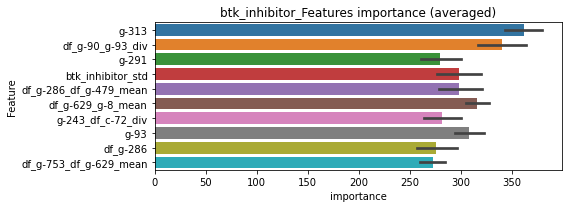

len(train_index) : 2850
len(valid_index) : 951
================================= fold 1/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0892825	valid_1's binary_logloss: 0.128803
[200]	training's binary_logloss: 0.0274874	valid_1's binary_logloss: 0.0591554
[300]	training's binary_logloss: 0.00990752	valid_1's binary_logloss: 0.0332966
[400]	training's binary_logloss: 0.00405484	valid_1's binary_logloss: 0.022542
[500]	training's binary_logloss: 0.0020592	valid_1's binary_logloss: 0.0175734
[600]	training's binary_logloss: 0.00126975	valid_1's binary_logloss: 0.0152321
[700]	training's binary_logloss: 0.000891236	valid_1's binary_logloss: 0.0139499
[800]	training's binary_logloss: 0.000691263	valid_1's binary_logloss: 0.0130435
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000625143	valid_1's binary_logloss: 0.012858


len(train_index) : 2851
len(valid_index) : 950
================================= fold 2/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924664	valid_1's binary_logloss: 0.118902
[200]	training's binary_logloss: 0.0297188	valid_1's binary_logloss: 0.0514559
[300]	training's binary_logloss: 0.0111044	valid_1's binary_logloss: 0.0270759
[400]	training's binary_logloss: 0.00494685	valid_1's binary_logloss: 0.0173807
[500]	training's binary_logloss: 0.0023119	valid_1's binary_logloss: 0.013208
[600]	training's binary_logloss: 0.00134425	valid_1's binary_logloss: 0.0112246
[700]	training's binary_logloss: 0.000922752	valid_1's binary_logloss: 0.010245
[800]	training's binary_logloss: 0.000703374	valid_1's binary_logloss: 0.00972531
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.000653573	valid_1's binary_logloss: 0.00950853


len(train_index) : 2851
len(valid_index) : 950
================================= fold 3/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913702	valid_1's binary_logloss: 0.115542
[200]	training's binary_logloss: 0.0289605	valid_1's binary_logloss: 0.0478089
[300]	training's binary_logloss: 0.0104364	valid_1's binary_logloss: 0.0235385
[400]	training's binary_logloss: 0.00421462	valid_1's binary_logloss: 0.0131649
[500]	training's binary_logloss: 0.00213135	valid_1's binary_logloss: 0.00885097
[600]	training's binary_logloss: 0.001307	valid_1's binary_logloss: 0.00685751
[700]	training's binary_logloss: 0.000915604	valid_1's binary_logloss: 0.00554199
[800]	training's binary_logloss: 0.000708663	valid_1's binary_logloss: 0.00490169
[900]	training's binary_logloss: 0.000590176	valid_1's binary_logloss: 0.00457244
[1000]	training's binary_logloss: 0.000543735	valid_1's binary_logloss: 0.00444386
[1100]	training's binary_logloss: 0.00051926	valid_1's binary_logloss: 0.00435945
Early stopping, best iteration is:
[1079]	training's

len(train_index) : 2851
len(valid_index) : 950
================================= fold 4/4 btk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922848	valid_1's binary_logloss: 0.128591
[200]	training's binary_logloss: 0.0280971	valid_1's binary_logloss: 0.054316
[300]	training's binary_logloss: 0.0101714	valid_1's binary_logloss: 0.0269218
[400]	training's binary_logloss: 0.00427024	valid_1's binary_logloss: 0.0151857
[500]	training's binary_logloss: 0.00205964	valid_1's binary_logloss: 0.00950661
[600]	training's binary_logloss: 0.00126007	valid_1's binary_logloss: 0.00721468
[700]	training's binary_logloss: 0.000881528	valid_1's binary_logloss: 0.00590591
[800]	training's binary_logloss: 0.000687913	valid_1's binary_logloss: 0.00522967
[900]	training's binary_logloss: 0.000574504	valid_1's binary_logloss: 0.00480428
[1000]	training's binary_logloss: 0.000527484	valid_1's binary_logloss: 0.00465374
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.00052403	valid_1's binary_logloss: 0.00462717


btk_inhibitor logloss: 0.007839654771173212


neg labels: 3289 → selected neg labels: 3288


calcineurin_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584213	valid_1's binary_logloss: 0.0724003
[200]	training's binary_logloss: 0.0130185	valid_1's binary_logloss: 0.0212203
[300]	training's binary_logloss: 0.00365896	valid_1's binary_logloss: 0.00893649
[400]	training's binary_logloss: 0.00145336	valid_1's binary_logloss: 0.00583829
[500]	training's binary_logloss: 0.000792586	valid_1's binary_logloss: 0.00468763
[600]	training's binary_logloss: 0.000522939	valid_1's binary_logloss: 0.00420983
[700]	training's binary_logloss: 0.000398227	valid_1's binary_logloss: 0.0039547
Early stopping, best iteration is:
[727]	training's binary_logloss: 0.000378489	valid_1's binary_logloss: 0.00393684
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0594782	valid_1's binary_logloss: 0.0698247
[200]	training's binary_logloss: 0.013232	valid_1's binary_logloss: 0.0185685
[300]	training's binary_logloss: 0.0038

1 / 3 AUC score:1.000
y_Threshold: 0.0023603, Threshold: 0.0129258, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00905, conf_1:0.01680
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0129258
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.0629258
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_3: 0.1129258
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_4: 0.1629258
threshold: 0.1629258, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584073	valid_1's binary_logloss: 0.0722018
[200]	training's binary_logloss: 0.0124385	valid_1's binary_logloss: 0.0203768
[300]	training's binary_logloss: 0.0033484	valid_1's binary_logloss: 0.00855725
[400]	training's binary_logloss: 0.00130045	valid_1's binary_logloss: 0.00505691
[500]	training's binary_logloss: 0.000691079	valid_1's binary_logloss: 0.00400738
[600]	training's binary_logloss: 0.000457502	valid_1's binary_logloss: 0.00345306
[700]	training's binary_logloss: 0.000355384	valid_1's binary_logloss: 0.00330731
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000355384	valid_1's binary_logloss: 0.00330731
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0589028	valid_1's binary_logloss: 0.0691491
[200]	training's binary_logloss: 0.0123176	valid_1's binary_logloss: 0.0181813
[300]	training's binary_logloss: 0.003

2 / 3 AUC score:1.000
y_Threshold: 0.0378890, Threshold: 0.1629258, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0040181 Vs.target_rate: 0.00050, Num_p_label: 16.0, conf_0:0.13034, conf_1:0.19551
Num_p_label: 16.0, Expected: 2.0, Adj_threshold_1: 0.1629258
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.2129258
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_3: 0.2629258
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.3129258
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.3629258
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.4129258
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_7: 0.4629258
threshold: 0.4629258, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584073	valid_1's binary_logloss: 0.0722018
[200]	training's binary_logloss: 0.0124385	valid_1's binary_logloss: 0.0203768
[300]	training's binary_logloss: 0.0033484	valid_1's binary_logloss: 0.00855725
[400]	training's binary_logloss: 0.00130045	valid_1's binary_logloss: 0.00505691
[500]	training's binary_logloss: 0.000691079	valid_1's binary_logloss: 0.00400738
[600]	training's binary_logloss: 0.000457502	valid_1's binary_logloss: 0.00345306
[700]	training's binary_logloss: 0.000355384	valid_1's binary_logloss: 0.00330731
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000355384	valid_1's binary_logloss: 0.00330731
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0589028	valid_1's binary_logloss: 0.0691491
[200]	training's binary_logloss: 0.0123176	valid_1's binary_logloss: 0.0181813
[300]	training's binary_logloss: 0.003

3 / 3 AUC score:1.000
y_Threshold: 0.0378890, Threshold: 0.4629258, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0010045 Vs.target_rate: 0.00050, Num_p_label: 4.0, conf_0:0.41663, conf_1:0.50922
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_1: 0.4629258
threshold: 0.4629258, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


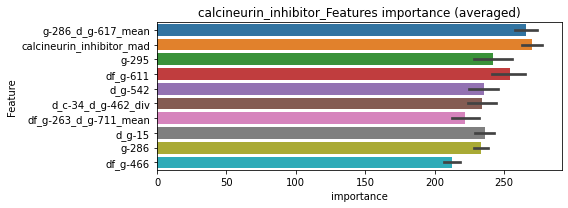

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0584132	valid_1's binary_logloss: 0.0704128
[200]	training's binary_logloss: 0.0123896	valid_1's binary_logloss: 0.0191539
[300]	training's binary_logloss: 0.00336937	valid_1's binary_logloss: 0.00777903
[400]	training's binary_logloss: 0.00130599	valid_1's binary_logloss: 0.00465028
[500]	training's binary_logloss: 0.000694018	valid_1's binary_logloss: 0.00365041
[600]	training's binary_logloss: 0.000457949	valid_1's binary_logloss: 0.00331555
[700]	training's binary_logloss: 0.000352871	valid_1's binary_logloss: 0.00322286
Early stopping, best iteration is:
[708]	training's binary_logloss: 0.000347514	valid_1's binary_logloss: 0.00319179


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0592302	valid_1's binary_logloss: 0.0697797
[200]	training's binary_logloss: 0.0125633	valid_1's binary_logloss: 0.0184077
[300]	training's binary_logloss: 0.00344551	valid_1's binary_logloss: 0.00647101
[400]	training's binary_logloss: 0.0013383	valid_1's binary_logloss: 0.00332604
[500]	training's binary_logloss: 0.000708017	valid_1's binary_logloss: 0.00211932
[600]	training's binary_logloss: 0.000467033	valid_1's binary_logloss: 0.00156008
[700]	training's binary_logloss: 0.000357046	valid_1's binary_logloss: 0.00133492
[800]	training's binary_logloss: 0.000318154	valid_1's binary_logloss: 0.00125802
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.000317497	valid_1's binary_logloss: 0.00125606


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0592737	valid_1's binary_logloss: 0.0661525
[200]	training's binary_logloss: 0.012391	valid_1's binary_logloss: 0.0158447
[300]	training's binary_logloss: 0.0033874	valid_1's binary_logloss: 0.00514738
[400]	training's binary_logloss: 0.00131346	valid_1's binary_logloss: 0.00223546
[500]	training's binary_logloss: 0.000698239	valid_1's binary_logloss: 0.00134781
[600]	training's binary_logloss: 0.000462261	valid_1's binary_logloss: 0.000971778
[700]	training's binary_logloss: 0.000355554	valid_1's binary_logloss: 0.000801905
[800]	training's binary_logloss: 0.000322295	valid_1's binary_logloss: 0.000754886
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000322013	valid_1's binary_logloss: 0.000754714


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 calcineurin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0596461	valid_1's binary_logloss: 0.0655309
[200]	training's binary_logloss: 0.0129914	valid_1's binary_logloss: 0.0157316
[300]	training's binary_logloss: 0.00350033	valid_1's binary_logloss: 0.0048455
[400]	training's binary_logloss: 0.00134377	valid_1's binary_logloss: 0.0020307
[500]	training's binary_logloss: 0.000716311	valid_1's binary_logloss: 0.00116873
[600]	training's binary_logloss: 0.000471572	valid_1's binary_logloss: 0.00080678
[700]	training's binary_logloss: 0.00036242	valid_1's binary_logloss: 0.000646533
[800]	training's binary_logloss: 0.000326092	valid_1's binary_logloss: 0.000594791
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.00032422	valid_1's binary_logloss: 0.000591887


calcineurin_inhibitor logloss: 0.0014491675253292624


neg labels: 3289 → selected neg labels: 3246


calcium_channel_blocker, len(trt): 281, len(othr): 3246, target_rate: 0.0117998 → Adj_target_rate: 0.0101297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.227556	valid_1's binary_logloss: 0.365793
[200]	training's binary_logloss: 0.139073	valid_1's binary_logloss: 0.337896
[300]	training's binary_logloss: 0.0919583	valid_1's binary_logloss: 0.323668
[400]	training's binary_logloss: 0.0629819	valid_1's binary_logloss: 0.320729
[500]	training's binary_logloss: 0.0433493	valid_1's binary_logloss: 0.317847
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0460939	valid_1's binary_logloss: 0.317708
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.228298	valid_1's binary_logloss: 0.363911
[200]	training's binary_logloss: 0.136292	valid_1's binary_logloss: 0.341655
[300]	training's binary_logloss: 0.0899725	valid_1's binary_logloss: 0.33047
[400]	training's binary_logloss: 0.0621937	valid_1's binary_logloss: 0.329691
Early stopping, best iteration is:
[406]	training's binary_logloss: 

1 / 3 AUC score:0.839
y_Threshold: 0.1218927, Threshold: 0.5166101, pos_neg_ratio: 0.8000000
Remove_noisy_data: 534 → Positive_corect_labels: 447/3361
p_label_rate: 0.0100452 Vs.target_rate: 0.01180, Num_p_label: 40.0, conf_0:0.36163, conf_1:0.67159
threshold: 0.5166101, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 447.0/3361, y_label_rate: 0.1329961
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122233	valid_1's binary_logloss: 0.215451
[200]	training's binary_logloss: 0.0545506	valid_1's binary_logloss: 0.174741
[300]	training's binary_logloss: 0.0270651	valid_1's binary_logloss: 0.158169
[400]	training's binary_logloss: 0.0142243	valid_1's binary_logloss: 0.153061
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.0103122	valid_1's binary_logloss: 0.150975
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131679	valid_1's binary_logloss: 0.196418
[200]	training's binary_logloss: 0.0582568	valid_1's binary_logloss: 0.14089
[300]	training's binary_logloss: 0.029351	valid_1's binary_logloss: 0.113914
[400]	training's binary_logloss: 0.0155525	valid_1's binary_logloss: 0.0997918
[500]	training's binary_logloss: 0.00879574	valid_1's binary_logloss: 0.0928767
[600]	training's binary_logloss: 0.00536093	valid_1's binary_log

2 / 3 AUC score:0.973
y_Threshold: 0.0996660, Threshold: 0.5166101, pos_neg_ratio: 0.8000000
Remove_noisy_data: 124 → Positive_corect_labels: 385.0/3237
p_label_rate: 0.0469613 Vs.target_rate: 0.01180, Num_p_label: 187.0, conf_0:0.41329, conf_1:0.61993
Num_p_label: 187.0, Expected: 47.0, Adj_threshold_1: 0.5166101
Num_p_label: 175.0, Expected: 47.0, Adj_threshold_2: 0.5666101
Num_p_label: 166.0, Expected: 47.0, Adj_threshold_3: 0.6166101
Num_p_label: 149.0, Expected: 47.0, Adj_threshold_4: 0.6666101
Num_p_label: 132.0, Expected: 47.0, Adj_threshold_5: 0.7166101
Num_p_label: 117.0, Expected: 47.0, Adj_threshold_6: 0.7666101
threshold: 0.7666101, positive_p_label: 117.0/3982, p_label_rate: 0.0293822
positive_y_label: 385.0/3237, y_label_rate: 0.1189373
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0917007	valid_1's binary_logloss: 0.160044
[200]	training's binary_logloss: 0.0327758	valid_1's binary_logloss: 0.118005
[300]	training's binary_logloss: 0.0142105	valid_1's binary_logloss: 0.103148
[400]	training's binary_logloss: 0.00682611	valid_1's binary_logloss: 0.0953119
[500]	training's binary_logloss: 0.00373406	valid_1's binary_logloss: 0.0918134
[600]	training's binary_logloss: 0.0023283	valid_1's binary_logloss: 0.0899617
Early stopping, best iteration is:
[633]	training's binary_logloss: 0.00204981	valid_1's binary_logloss: 0.0894516
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949224	valid_1's binary_logloss: 0.143649
[200]	training's binary_logloss: 0.0343411	valid_1's binary_logloss: 0.0963791
[300]	training's binary_logloss: 0.015074	valid_1's binary_logloss: 0.0824286
[400]	training's binary_logloss: 0.0072401	valid_1's bi

3 / 3 AUC score:0.978
y_Threshold: 0.0819484, Threshold: 0.7666101, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 351.0/3169


Early stopping, best iteration is:
[409]	training's binary_logloss: 0.00631355	valid_1's binary_logloss: 0.0943495


p_label_rate: 0.0479658 Vs.target_rate: 0.01180, Num_p_label: 191.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 191.0, Expected: 47.0, Adj_threshold_1: 0.7666101
threshold: 0.7666101, positive_p_label: 191.0/3982, p_label_rate: 0.0479658
positive_y_label: 351.0/3169, y_label_rate: 0.1107605


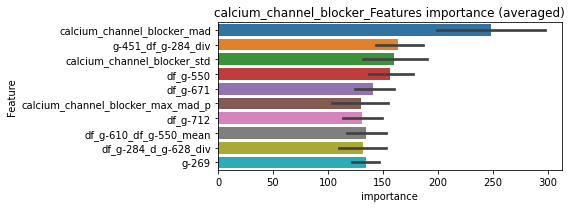

len(train_index) : 2376
len(valid_index) : 793
================================= fold 1/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0779602	valid_1's binary_logloss: 0.13229
[200]	training's binary_logloss: 0.0259605	valid_1's binary_logloss: 0.0963384
[300]	training's binary_logloss: 0.00987501	valid_1's binary_logloss: 0.0877077


len(train_index) : 2377
len(valid_index) : 792
================================= fold 2/4 calcium_channel_blocker=================================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00606054	valid_1's binary_logloss: 0.0860495
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748458	valid_1's binary_logloss: 0.127753
[200]	training's binary_logloss: 0.0238971	valid_1's binary_logloss: 0.0839715
[300]	training's binary_logloss: 0.00935983	valid_1's binary_logloss: 0.0706272
[400]	training's binary_logloss: 0.00439021	valid_1's binary_logloss: 0.0643462
[500]	training's binary_logloss: 0.00242686	valid_1's binary_logloss: 0.06223
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00229128	valid_1's binary_logloss: 0.0618282


len(train_index) : 2377
len(valid_index) : 792
================================= fold 3/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0763104	valid_1's binary_logloss: 0.114316
[200]	training's binary_logloss: 0.0250111	valid_1's binary_logloss: 0.0692625
[300]	training's binary_logloss: 0.0101118	valid_1's binary_logloss: 0.0524803
[400]	training's binary_logloss: 0.00477143	valid_1's binary_logloss: 0.0438654
[500]	training's binary_logloss: 0.00264803	valid_1's binary_logloss: 0.0398536
[600]	training's binary_logloss: 0.00170175	valid_1's binary_logloss: 0.0368698
[700]	training's binary_logloss: 0.00122899	valid_1's binary_logloss: 0.0350738
Early stopping, best iteration is:
[728]	training's binary_logloss: 0.0011412	valid_1's binary_logloss: 0.0345331


len(train_index) : 2377
len(valid_index) : 792
================================= fold 4/4 calcium_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792611	valid_1's binary_logloss: 0.123978
[200]	training's binary_logloss: 0.0262755	valid_1's binary_logloss: 0.0794253
[300]	training's binary_logloss: 0.0105728	valid_1's binary_logloss: 0.0633194
[400]	training's binary_logloss: 0.00502344	valid_1's binary_logloss: 0.0566254
[500]	training's binary_logloss: 0.00269825	valid_1's binary_logloss: 0.0519502
[600]	training's binary_logloss: 0.00171042	valid_1's binary_logloss: 0.0506021
[700]	training's binary_logloss: 0.0012285	valid_1's binary_logloss: 0.0498402
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.0011939	valid_1's binary_logloss: 0.0497266


calcium_channel_blocker logloss: 0.05804318544470014


neg labels: 3289 → selected neg labels: 3281


cannabinoid_receptor_agonist, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105156	valid_1's binary_logloss: 0.15794
[200]	training's binary_logloss: 0.0376835	valid_1's binary_logloss: 0.0892287
[300]	training's binary_logloss: 0.0156426	valid_1's binary_logloss: 0.0593471
[400]	training's binary_logloss: 0.00704418	valid_1's binary_logloss: 0.0430401
[500]	training's binary_logloss: 0.00348767	valid_1's binary_logloss: 0.0339953
[600]	training's binary_logloss: 0.0020773	valid_1's binary_logloss: 0.0306068
[700]	training's binary_logloss: 0.00142728	valid_1's binary_logloss: 0.028607
[800]	training's binary_logloss: 0.00107717	valid_1's binary_logloss: 0.0268058
[900]	training's binary_logloss: 0.000877795	valid_1's binary_logloss: 0.0258289
[1000]	training's binary_logloss: 0.000770228	valid_1's binary_logloss: 0.0251999
Early stopping, best iteration is:
[1010]	training's binary_logloss: 0.000763426	valid_1's binary_logloss: 0.0251708
Training until validation s

1 / 3 AUC score:1.000
y_Threshold: 0.0148244, Threshold: 0.1364340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.09550, conf_1:0.17736
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.1364340
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_2: 0.1864340
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.2364340
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_4: 0.2864340
Num_p_label: 17.0, Expected: 7.0, Adj_threshold_5: 0.3364340
threshold: 0.3364340, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0992564	valid_1's binary_logloss: 0.135879
[200]	training's binary_logloss: 0.0338158	valid_1's binary_logloss: 0.064818
[300]	training's binary_logloss: 0.0131989	valid_1's binary_logloss: 0.036479
[400]	training's binary_logloss: 0.00567414	valid_1's binary_logloss: 0.0240153
[500]	training's binary_logloss: 0.00288077	valid_1's binary_logloss: 0.0181423
[600]	training's binary_logloss: 0.00173959	valid_1's binary_logloss: 0.014863
[700]	training's binary_logloss: 0.00122173	valid_1's binary_logloss: 0.0132826
[800]	training's binary_logloss: 0.000939198	valid_1's binary_logloss: 0.0121446
[900]	training's binary_logloss: 0.000779818	valid_1's binary_logloss: 0.0114779
[1000]	training's binary_logloss: 0.000703991	valid_1's binary_logloss: 0.0111028
[1100]	training's binary_logloss: 0.00066128	valid_1's binary_logloss: 0.0108257
Early stopping, best iteration is:
[1116]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.1027899, Threshold: 0.3364340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0175791 Vs.target_rate: 0.00176, Num_p_label: 70.0, conf_0:0.26915, conf_1:0.40372
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_1: 0.3364340
Num_p_label: 70.0, Expected: 7.0, Adj_threshold_2: 0.3864340
Num_p_label: 66.0, Expected: 7.0, Adj_threshold_3: 0.4364340
Num_p_label: 63.0, Expected: 7.0, Adj_threshold_4: 0.4864340
Num_p_label: 56.0, Expected: 7.0, Adj_threshold_5: 0.5364340
Num_p_label: 51.0, Expected: 7.0, Adj_threshold_6: 0.5864340
Num_p_label: 47.0, Expected: 7.0, Adj_threshold_7: 0.6364340
Num_p_label: 43.0, Expected: 7.0, Adj_threshold_8: 0.6864340
Num_p_label: 38.0, Expected: 7.0, Adj_threshold_9: 0.7364340
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_10: 0.7864340
threshold: 0.7864340, positive_p_label: 36.0/3982, p_label_rate: 0.0090407
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0965763	valid_1's binary_logloss: 0.131401
[200]	training's binary_logloss: 0.0325507	valid_1's binary_logloss: 0.0643416
[300]	training's binary_logloss: 0.0125263	valid_1's binary_logloss: 0.0374743
[400]	training's binary_logloss: 0.00549022	valid_1's binary_logloss: 0.0258115
[500]	training's binary_logloss: 0.00277089	valid_1's binary_logloss: 0.0198582
[600]	training's binary_logloss: 0.00167899	valid_1's binary_logloss: 0.0169105
[700]	training's binary_logloss: 0.0011805	valid_1's binary_logloss: 0.0155299
[800]	training's binary_logloss: 0.00090565	valid_1's binary_logloss: 0.0142873
[900]	training's binary_logloss: 0.000749944	valid_1's binary_logloss: 0.0135521
[1000]	training's binary_logloss: 0.000684308	valid_1's binary_logloss: 0.0131267
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000687293	valid_1's binary_logloss: 0.0130978
Training until validation

3 / 3 AUC score:1.000
y_Threshold: 0.1049011, Threshold: 0.7864340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 644.0/3781
p_label_rate: 0.0163235 Vs.target_rate: 0.00176, Num_p_label: 65.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 65.0, Expected: 7.0, Adj_threshold_1: 0.7864340
threshold: 0.7864340, positive_p_label: 65.0/3982, p_label_rate: 0.0163235
positive_y_label: 644.0/3781, y_label_rate: 0.1703253


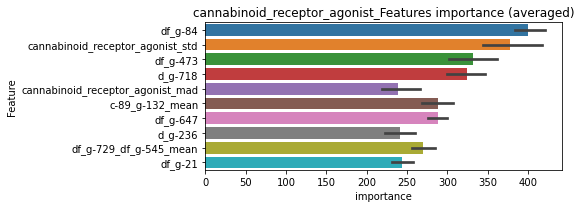

len(train_index) : 2835
len(valid_index) : 946
================================= fold 1/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0977036	valid_1's binary_logloss: 0.137732
[200]	training's binary_logloss: 0.0321085	valid_1's binary_logloss: 0.06762
[300]	training's binary_logloss: 0.0125162	valid_1's binary_logloss: 0.0400056
[400]	training's binary_logloss: 0.00530372	valid_1's binary_logloss: 0.0272917
[500]	training's binary_logloss: 0.00271313	valid_1's binary_logloss: 0.0220085
[600]	training's binary_logloss: 0.00164107	valid_1's binary_logloss: 0.0189917
[700]	training's binary_logloss: 0.00115236	valid_1's binary_logloss: 0.0175013
[800]	training's binary_logloss: 0.000890774	valid_1's binary_logloss: 0.0165474
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000781975	valid_1's binary_logloss: 0.0158358


len(train_index) : 2836
len(valid_index) : 945
================================= fold 2/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973346	valid_1's binary_logloss: 0.130125
[200]	training's binary_logloss: 0.0321826	valid_1's binary_logloss: 0.0607752
[300]	training's binary_logloss: 0.0123649	valid_1's binary_logloss: 0.0342884
[400]	training's binary_logloss: 0.00530071	valid_1's binary_logloss: 0.0223434
[500]	training's binary_logloss: 0.00268529	valid_1's binary_logloss: 0.0165888
[600]	training's binary_logloss: 0.00164744	valid_1's binary_logloss: 0.0141231
[700]	training's binary_logloss: 0.00114387	valid_1's binary_logloss: 0.0126735
[800]	training's binary_logloss: 0.000880149	valid_1's binary_logloss: 0.011883
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000774564	valid_1's binary_logloss: 0.0113799


len(train_index) : 2836
len(valid_index) : 945
================================= fold 3/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.094197	valid_1's binary_logloss: 0.147275
[200]	training's binary_logloss: 0.0314803	valid_1's binary_logloss: 0.0831644
[300]	training's binary_logloss: 0.0118581	valid_1's binary_logloss: 0.0572899
[400]	training's binary_logloss: 0.00505971	valid_1's binary_logloss: 0.0454603
[500]	training's binary_logloss: 0.00258859	valid_1's binary_logloss: 0.0399505
[600]	training's binary_logloss: 0.00159146	valid_1's binary_logloss: 0.0378145
[700]	training's binary_logloss: 0.00111201	valid_1's binary_logloss: 0.0366453
[800]	training's binary_logloss: 0.000866627	valid_1's binary_logloss: 0.036186
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000831221	valid_1's binary_logloss: 0.0358285


len(train_index) : 2836
len(valid_index) : 945
================================= fold 4/4 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949559	valid_1's binary_logloss: 0.143893
[200]	training's binary_logloss: 0.0323491	valid_1's binary_logloss: 0.0826815
[300]	training's binary_logloss: 0.0128061	valid_1's binary_logloss: 0.058208
[400]	training's binary_logloss: 0.00541088	valid_1's binary_logloss: 0.0441815
[500]	training's binary_logloss: 0.00271261	valid_1's binary_logloss: 0.0379677
[600]	training's binary_logloss: 0.00165944	valid_1's binary_logloss: 0.0363812
Early stopping, best iteration is:
[659]	training's binary_logloss: 0.00132205	valid_1's binary_logloss: 0.0351006


cannabinoid_receptor_agonist logloss: 0.024533897221841336


neg labels: 3289 → selected neg labels: 3280


cannabinoid_receptor_antagonist, len(trt): 55, len(othr): 3280, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144643	valid_1's binary_logloss: 0.211616
[200]	training's binary_logloss: 0.0634593	valid_1's binary_logloss: 0.134005
[300]	training's binary_logloss: 0.0316709	valid_1's binary_logloss: 0.0966389
[400]	training's binary_logloss: 0.0159116	valid_1's binary_logloss: 0.0751338
[500]	training's binary_logloss: 0.00824043	valid_1's binary_logloss: 0.0619511
[600]	training's binary_logloss: 0.00464559	valid_1's binary_logloss: 0.054807
[700]	training's binary_logloss: 0.00287046	valid_1's binary_logloss: 0.049353
[800]	training's binary_logloss: 0.00198931	valid_1's binary_logloss: 0.0469459
[900]	training's binary_logloss: 0.00150802	valid_1's binary_logloss: 0.0450679
[1000]	training's binary_logloss: 0.00122422	valid_1's binary_logloss: 0.0441058
[1100]	training's binary_logloss: 0.00104197	valid_1's binary_logloss: 0.0433292
Early stopping, best iteration is:
[1108]	training's binary_loglos

1 / 3 AUC score:0.996
y_Threshold: 0.0286922, Threshold: 0.1287626, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.09013, conf_1:0.16739
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.1287626
Num_p_label: 32.0, Expected: 9.2, Adj_threshold_2: 0.1787626
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_3: 0.2287626
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_4: 0.2787626
threshold: 0.2787626, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137322	valid_1's binary_logloss: 0.198524
[200]	training's binary_logloss: 0.0561743	valid_1's binary_logloss: 0.115984
[300]	training's binary_logloss: 0.025569	valid_1's binary_logloss: 0.0783817
[400]	training's binary_logloss: 0.0120566	valid_1's binary_logloss: 0.0566476
[500]	training's binary_logloss: 0.00618093	valid_1's binary_logloss: 0.043785
[600]	training's binary_logloss: 0.00354239	valid_1's binary_logloss: 0.0357147
[700]	training's binary_logloss: 0.00231356	valid_1's binary_logloss: 0.0316357
[800]	training's binary_logloss: 0.00164807	valid_1's binary_logloss: 0.0287848
[900]	training's binary_logloss: 0.00129113	valid_1's binary_logloss: 0.0274852
[1000]	training's binary_logloss: 0.00106709	valid_1's binary_logloss: 0.0265053
[1100]	training's binary_logloss: 0.000937715	valid_1's binary_logloss: 0.0258869
Early stopping, best iteration is:
[1146]	training's binary_loglo

2 / 3 AUC score:0.999
y_Threshold: 0.0919090, Threshold: 0.2787626, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0138122 Vs.target_rate: 0.00231, Num_p_label: 55.0, conf_0:0.22301, conf_1:0.33452
Num_p_label: 55.0, Expected: 9.2, Adj_threshold_1: 0.2787626
Num_p_label: 44.0, Expected: 9.2, Adj_threshold_2: 0.3287626
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_3: 0.3787626
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_4: 0.4287626
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_5: 0.4787626
Num_p_label: 25.0, Expected: 9.2, Adj_threshold_6: 0.5287626
Num_p_label: 21.0, Expected: 9.2, Adj_threshold_7: 0.5787626
threshold: 0.5787626, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 637.0/3766, y_label_rate: 0.1691450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134127	valid_1's binary_logloss: 0.188049
[200]	training's binary_logloss: 0.0525415	valid_1's binary_logloss: 0.106564
[300]	training's binary_logloss: 0.0229636	valid_1's binary_logloss: 0.0699175
[400]	training's binary_logloss: 0.0109952	valid_1's binary_logloss: 0.0514011
[500]	training's binary_logloss: 0.00556662	valid_1's binary_logloss: 0.0410295
[600]	training's binary_logloss: 0.0032427	valid_1's binary_logloss: 0.0350316
[700]	training's binary_logloss: 0.00214555	valid_1's binary_logloss: 0.0324478
[800]	training's binary_logloss: 0.00155791	valid_1's binary_logloss: 0.0308244
[900]	training's binary_logloss: 0.00122315	valid_1's binary_logloss: 0.0299512
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.00122061	valid_1's binary_logloss: 0.0299113
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134389	valid_1's

3 / 3 AUC score:1.000
y_Threshold: 0.1197998, Threshold: 0.5787626, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 630.0/3752
p_label_rate: 0.0072828 Vs.target_rate: 0.00231, Num_p_label: 29.0, conf_0:0.50000, conf_1:0.63664
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_1: 0.5787626
Num_p_label: 26.0, Expected: 9.2, Adj_threshold_2: 0.6287626
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_3: 0.6787626
threshold: 0.6787626, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 630.0/3752, y_label_rate: 0.1679104


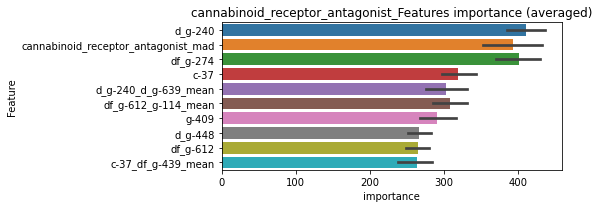

len(train_index) : 2814
len(valid_index) : 938
================================= fold 1/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132877	valid_1's binary_logloss: 0.19045
[200]	training's binary_logloss: 0.0520939	valid_1's binary_logloss: 0.111997
[300]	training's binary_logloss: 0.0228246	valid_1's binary_logloss: 0.0777328
[400]	training's binary_logloss: 0.0108213	valid_1's binary_logloss: 0.0617725
[500]	training's binary_logloss: 0.00556282	valid_1's binary_logloss: 0.0519496
[600]	training's binary_logloss: 0.00319576	valid_1's binary_logloss: 0.0474138
[700]	training's binary_logloss: 0.00208701	valid_1's binary_logloss: 0.0447253
[800]	training's binary_logloss: 0.00152079	valid_1's binary_logloss: 0.0438927
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00130576	valid_1's binary_logloss: 0.042937


len(train_index) : 2814
len(valid_index) : 938
================================= fold 2/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133622	valid_1's binary_logloss: 0.176756
[200]	training's binary_logloss: 0.0522751	valid_1's binary_logloss: 0.09832
[300]	training's binary_logloss: 0.0231349	valid_1's binary_logloss: 0.0641944
[400]	training's binary_logloss: 0.0106062	valid_1's binary_logloss: 0.0471907
[500]	training's binary_logloss: 0.00544472	valid_1's binary_logloss: 0.0386943
[600]	training's binary_logloss: 0.00316835	valid_1's binary_logloss: 0.0347523
[700]	training's binary_logloss: 0.00207872	valid_1's binary_logloss: 0.0322061
[800]	training's binary_logloss: 0.00152422	valid_1's binary_logloss: 0.0307626
[900]	training's binary_logloss: 0.00120349	valid_1's binary_logloss: 0.0299521
[1000]	training's binary_logloss: 0.00100464	valid_1's binary_logloss: 0.0294424
Early stopping, best iteration is:
[1046]	training's binary_logloss: 0.000942371	valid_1's binary_logloss: 0.029166


len(train_index) : 2814
len(valid_index) : 938
================================= fold 3/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130246	valid_1's binary_logloss: 0.18071
[200]	training's binary_logloss: 0.050751	valid_1's binary_logloss: 0.101915
[300]	training's binary_logloss: 0.0225294	valid_1's binary_logloss: 0.0667004
[400]	training's binary_logloss: 0.0104935	valid_1's binary_logloss: 0.0491269
[500]	training's binary_logloss: 0.00542813	valid_1's binary_logloss: 0.0404204
[600]	training's binary_logloss: 0.00314835	valid_1's binary_logloss: 0.0354525
[700]	training's binary_logloss: 0.00207675	valid_1's binary_logloss: 0.0324445
[800]	training's binary_logloss: 0.00153163	valid_1's binary_logloss: 0.0309458
[900]	training's binary_logloss: 0.0012086	valid_1's binary_logloss: 0.0297982
[1000]	training's binary_logloss: 0.00101421	valid_1's binary_logloss: 0.0293249
[1100]	training's binary_logloss: 0.000893049	valid_1's binary_logloss: 0.0289043
Early stopping, best iteration is:
[1088]	training's binary_loglos

len(train_index) : 2814
len(valid_index) : 938
================================= fold 4/4 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132205	valid_1's binary_logloss: 0.184917
[200]	training's binary_logloss: 0.0520331	valid_1's binary_logloss: 0.107734
[300]	training's binary_logloss: 0.0231571	valid_1's binary_logloss: 0.0751775
[400]	training's binary_logloss: 0.0108456	valid_1's binary_logloss: 0.0562944
[500]	training's binary_logloss: 0.00553524	valid_1's binary_logloss: 0.0476289
[600]	training's binary_logloss: 0.00321399	valid_1's binary_logloss: 0.0424537
[700]	training's binary_logloss: 0.00210688	valid_1's binary_logloss: 0.0406822
[800]	training's binary_logloss: 0.00154049	valid_1's binary_logloss: 0.0397123
[900]	training's binary_logloss: 0.00120573	valid_1's binary_logloss: 0.0389479
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.00117938	valid_1's binary_logloss: 0.0388069


cannabinoid_receptor_antagonist logloss: 0.03493235733546807


neg labels: 3289 → selected neg labels: 3281


carbonic_anhydrase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0987662	valid_1's binary_logloss: 0.147178
[200]	training's binary_logloss: 0.0339541	valid_1's binary_logloss: 0.0792268
[300]	training's binary_logloss: 0.0135786	valid_1's binary_logloss: 0.0507927
[400]	training's binary_logloss: 0.00588585	valid_1's binary_logloss: 0.0371012
[500]	training's binary_logloss: 0.00297597	valid_1's binary_logloss: 0.030137
[600]	training's binary_logloss: 0.0017974	valid_1's binary_logloss: 0.0278155
[700]	training's binary_logloss: 0.00125246	valid_1's binary_logloss: 0.0260678
[800]	training's binary_logloss: 0.000964576	valid_1's binary_logloss: 0.0256487
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000872015	valid_1's binary_logloss: 0.0251811
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994092	valid_1's binary_logloss: 0.137264
[200]	training's binary_logloss: 0.0351364	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0113600, Threshold: 0.1174674, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.08223, conf_1:0.15271
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1174674
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.1674674
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_3: 0.2174674
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.2674674
threshold: 0.2674674, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944778	valid_1's binary_logloss: 0.139626
[200]	training's binary_logloss: 0.0303414	valid_1's binary_logloss: 0.0702484
[300]	training's binary_logloss: 0.0114978	valid_1's binary_logloss: 0.0420776
[400]	training's binary_logloss: 0.00492571	valid_1's binary_logloss: 0.0293514
[500]	training's binary_logloss: 0.00252409	valid_1's binary_logloss: 0.0240258
[600]	training's binary_logloss: 0.00154884	valid_1's binary_logloss: 0.0217023
[700]	training's binary_logloss: 0.00108965	valid_1's binary_logloss: 0.0206601
[800]	training's binary_logloss: 0.000851146	valid_1's binary_logloss: 0.0201199
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.000751532	valid_1's binary_logloss: 0.0196445
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0939078	valid_1's binary_logloss: 0.129945
[200]	training's binary_logloss: 0.030365	valid

2 / 3 AUC score:1.000
y_Threshold: 0.0969725, Threshold: 0.2674674, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0165746 Vs.target_rate: 0.00151, Num_p_label: 66.0, conf_0:0.21397, conf_1:0.32096
Num_p_label: 66.0, Expected: 6.0, Adj_threshold_1: 0.2674674
Num_p_label: 58.0, Expected: 6.0, Adj_threshold_2: 0.3174674
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_3: 0.3674674
Num_p_label: 41.0, Expected: 6.0, Adj_threshold_4: 0.4174674
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_5: 0.4674674
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_6: 0.5174674
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_7: 0.5674674
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.6174674
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_9: 0.6674674
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.7174674
threshold: 0.7674674, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0925102	valid_1's binary_logloss: 0.125917
[200]	training's binary_logloss: 0.0288512	valid_1's binary_logloss: 0.0573999
[300]	training's binary_logloss: 0.0110006	valid_1's binary_logloss: 0.0309756
[400]	training's binary_logloss: 0.00460603	valid_1's binary_logloss: 0.0188145
[500]	training's binary_logloss: 0.00238288	valid_1's binary_logloss: 0.0128303
[600]	training's binary_logloss: 0.00147907	valid_1's binary_logloss: 0.0101661
[700]	training's binary_logloss: 0.00105486	valid_1's binary_logloss: 0.00856212
[800]	training's binary_logloss: 0.000824493	valid_1's binary_logloss: 0.00759888
[900]	training's binary_logloss: 0.000703314	valid_1's binary_logloss: 0.00707213
[1000]	training's binary_logloss: 0.0006536	valid_1's binary_logloss: 0.00686346
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.000651825	valid_1's binary_logloss: 0.0068628
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.0912351, Threshold: 0.7674674, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 648.0/3789
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_1: 0.7674674
threshold: 0.7674674, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3789, y_label_rate: 0.1710214


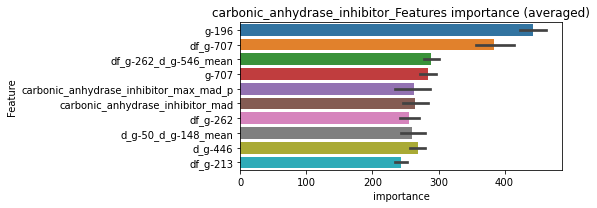

len(train_index) : 2841
len(valid_index) : 948
================================= fold 1/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933336	valid_1's binary_logloss: 0.119301
[200]	training's binary_logloss: 0.0293178	valid_1's binary_logloss: 0.0501881
[300]	training's binary_logloss: 0.0108985	valid_1's binary_logloss: 0.0251936
[400]	training's binary_logloss: 0.00469127	valid_1's binary_logloss: 0.0147481
[500]	training's binary_logloss: 0.00243194	valid_1's binary_logloss: 0.0103779
[600]	training's binary_logloss: 0.0014968	valid_1's binary_logloss: 0.00811535
[700]	training's binary_logloss: 0.0010724	valid_1's binary_logloss: 0.00669428
[800]	training's binary_logloss: 0.000841929	valid_1's binary_logloss: 0.00597008
[900]	training's binary_logloss: 0.000713119	valid_1's binary_logloss: 0.00555209
[1000]	training's binary_logloss: 0.000654723	valid_1's binary_logloss: 0.00523691
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000654723	valid_1's binary_logloss: 0.00523691


len(train_index) : 2842
len(valid_index) : 947
================================= fold 2/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0929706	valid_1's binary_logloss: 0.119198
[200]	training's binary_logloss: 0.0308244	valid_1's binary_logloss: 0.0544846
[300]	training's binary_logloss: 0.0116426	valid_1's binary_logloss: 0.0295793
[400]	training's binary_logloss: 0.00485013	valid_1's binary_logloss: 0.0183229
[500]	training's binary_logloss: 0.00244678	valid_1's binary_logloss: 0.0130685
[600]	training's binary_logloss: 0.00150133	valid_1's binary_logloss: 0.0106372
[700]	training's binary_logloss: 0.00106083	valid_1's binary_logloss: 0.00906272
[800]	training's binary_logloss: 0.000828212	valid_1's binary_logloss: 0.008302
[900]	training's binary_logloss: 0.000705313	valid_1's binary_logloss: 0.00793522
[1000]	training's binary_logloss: 0.000639602	valid_1's binary_logloss: 0.00773249
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.000639527	valid_1's binary_logloss: 0.00773231


len(train_index) : 2842
len(valid_index) : 947
================================= fold 3/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915907	valid_1's binary_logloss: 0.140088
[200]	training's binary_logloss: 0.0287314	valid_1's binary_logloss: 0.0726298
[300]	training's binary_logloss: 0.0106278	valid_1's binary_logloss: 0.0431579
[400]	training's binary_logloss: 0.00451975	valid_1's binary_logloss: 0.0302464
[500]	training's binary_logloss: 0.0023059	valid_1's binary_logloss: 0.0238233
[600]	training's binary_logloss: 0.00142572	valid_1's binary_logloss: 0.019859
[700]	training's binary_logloss: 0.00101968	valid_1's binary_logloss: 0.0176358
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.000952006	valid_1's binary_logloss: 0.0172439


len(train_index) : 2842
len(valid_index) : 947
================================= fold 4/4 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927275	valid_1's binary_logloss: 0.130057
[200]	training's binary_logloss: 0.0303068	valid_1's binary_logloss: 0.0601457
[300]	training's binary_logloss: 0.0111242	valid_1's binary_logloss: 0.031785
[400]	training's binary_logloss: 0.00472305	valid_1's binary_logloss: 0.0191057
[500]	training's binary_logloss: 0.00241899	valid_1's binary_logloss: 0.0135995
[600]	training's binary_logloss: 0.00149804	valid_1's binary_logloss: 0.0107174
[700]	training's binary_logloss: 0.00106844	valid_1's binary_logloss: 0.00908419
[800]	training's binary_logloss: 0.00083108	valid_1's binary_logloss: 0.00802897
[900]	training's binary_logloss: 0.000704329	valid_1's binary_logloss: 0.00746439
[1000]	training's binary_logloss: 0.000644353	valid_1's binary_logloss: 0.0072023
Early stopping, best iteration is:
[1042]	training's binary_logloss: 0.000635359	valid_1's binary_logloss: 0.00712487


carbonic_anhydrase_inhibitor logloss: 0.009335880939743219


neg labels: 3289 → selected neg labels: 3283


casein_kinase_inhibitor, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104942	valid_1's binary_logloss: 0.150002
[200]	training's binary_logloss: 0.0395267	valid_1's binary_logloss: 0.0820019
[300]	training's binary_logloss: 0.0157092	valid_1's binary_logloss: 0.0524631
[400]	training's binary_logloss: 0.00657238	valid_1's binary_logloss: 0.0370511
[500]	training's binary_logloss: 0.00327234	valid_1's binary_logloss: 0.0289788
[600]	training's binary_logloss: 0.00192071	valid_1's binary_logloss: 0.0248887
[700]	training's binary_logloss: 0.00129646	valid_1's binary_logloss: 0.0220011
[800]	training's binary_logloss: 0.000983017	valid_1's binary_logloss: 0.0206662
[900]	training's binary_logloss: 0.000798982	valid_1's binary_logloss: 0.0201727
[1000]	training's binary_logloss: 0.000703083	valid_1's binary_logloss: 0.019725
Early stopping, best iteration is:
[994]	training's binary_logloss: 0.000707289	valid_1's binary_logloss: 0.0196627
Training until validation

1 / 3 AUC score:1.000
y_Threshold: 0.0142437, Threshold: 0.0717204, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05020, conf_1:0.09324
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0717204
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_2: 0.1217204
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.1717204
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.2217204
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_5: 0.2717204
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_6: 0.3217204
threshold: 0.3217204, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983505	valid_1's binary_logloss: 0.13584
[200]	training's binary_logloss: 0.0341733	valid_1's binary_logloss: 0.0686264
[300]	training's binary_logloss: 0.0132556	valid_1's binary_logloss: 0.0428082
[400]	training's binary_logloss: 0.00559173	valid_1's binary_logloss: 0.031919
[500]	training's binary_logloss: 0.0028058	valid_1's binary_logloss: 0.0266394
[600]	training's binary_logloss: 0.00167036	valid_1's binary_logloss: 0.0237462
[700]	training's binary_logloss: 0.00115026	valid_1's binary_logloss: 0.0223263
[800]	training's binary_logloss: 0.000877969	valid_1's binary_logloss: 0.0217547
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.000934206	valid_1's binary_logloss: 0.0216442
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0980835	valid_1's binary_logloss: 0.146788
[200]	training's binary_logloss: 0.0341524	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.0929337, Threshold: 0.3217204, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0070316 Vs.target_rate: 0.00151, Num_p_label: 28.0, conf_0:0.25738, conf_1:0.38606
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_1: 0.3217204
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_2: 0.3717204
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_3: 0.4217204
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_4: 0.4717204
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_5: 0.5217204
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.5717204
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_7: 0.6217204
threshold: 0.6217204, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975576	valid_1's binary_logloss: 0.135439
[200]	training's binary_logloss: 0.0351179	valid_1's binary_logloss: 0.0660583
[300]	training's binary_logloss: 0.0134401	valid_1's binary_logloss: 0.0358236
[400]	training's binary_logloss: 0.00561698	valid_1's binary_logloss: 0.0229609
[500]	training's binary_logloss: 0.00279991	valid_1's binary_logloss: 0.0168739
[600]	training's binary_logloss: 0.00166767	valid_1's binary_logloss: 0.0140498
[700]	training's binary_logloss: 0.00114622	valid_1's binary_logloss: 0.0121172
[800]	training's binary_logloss: 0.000874658	valid_1's binary_logloss: 0.0109329
[900]	training's binary_logloss: 0.000719129	valid_1's binary_logloss: 0.0104263
[1000]	training's binary_logloss: 0.000632091	valid_1's binary_logloss: 0.0101333
Early stopping, best iteration is:
[1061]	training's binary_logloss: 0.000606964	valid_1's binary_logloss: 0.00994902
Training until valida

3 / 3 AUC score:1.000
y_Threshold: 0.1103513, Threshold: 0.6217204, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 649.0/3793
p_label_rate: 0.0037670 Vs.target_rate: 0.00151, Num_p_label: 15.0, conf_0:0.50000, conf_1:0.68389
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_1: 0.6217204
threshold: 0.6217204, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3793, y_label_rate: 0.1711047


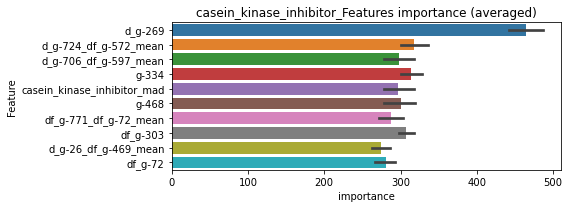

len(train_index) : 2844
len(valid_index) : 949
================================= fold 1/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985556	valid_1's binary_logloss: 0.138528
[200]	training's binary_logloss: 0.0341337	valid_1's binary_logloss: 0.0667902
[300]	training's binary_logloss: 0.0132547	valid_1's binary_logloss: 0.0380911
[400]	training's binary_logloss: 0.00551194	valid_1's binary_logloss: 0.0241463
[500]	training's binary_logloss: 0.00274394	valid_1's binary_logloss: 0.0172633
[600]	training's binary_logloss: 0.00164489	valid_1's binary_logloss: 0.0142745
[700]	training's binary_logloss: 0.00114148	valid_1's binary_logloss: 0.0125482
[800]	training's binary_logloss: 0.000869394	valid_1's binary_logloss: 0.011702
[900]	training's binary_logloss: 0.000713184	valid_1's binary_logloss: 0.0109366
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000690888	valid_1's binary_logloss: 0.0108479


len(train_index) : 2845
len(valid_index) : 948
================================= fold 2/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961289	valid_1's binary_logloss: 0.134898
[200]	training's binary_logloss: 0.033184	valid_1's binary_logloss: 0.0661997
[300]	training's binary_logloss: 0.0127513	valid_1's binary_logloss: 0.0392128
[400]	training's binary_logloss: 0.0053781	valid_1's binary_logloss: 0.0266621
[500]	training's binary_logloss: 0.00269342	valid_1's binary_logloss: 0.0210664
[600]	training's binary_logloss: 0.00161885	valid_1's binary_logloss: 0.0184027
[700]	training's binary_logloss: 0.00112181	valid_1's binary_logloss: 0.0172574
[800]	training's binary_logloss: 0.000857201	valid_1's binary_logloss: 0.0163911
[900]	training's binary_logloss: 0.0007002	valid_1's binary_logloss: 0.0160094
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000717524	valid_1's binary_logloss: 0.0159009


len(train_index) : 2845
len(valid_index) : 948
================================= fold 3/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09725	valid_1's binary_logloss: 0.12982
[200]	training's binary_logloss: 0.0338396	valid_1's binary_logloss: 0.0590019
[300]	training's binary_logloss: 0.0127353	valid_1's binary_logloss: 0.0292996
[400]	training's binary_logloss: 0.00539275	valid_1's binary_logloss: 0.0170108
[500]	training's binary_logloss: 0.00269483	valid_1's binary_logloss: 0.0110208
[600]	training's binary_logloss: 0.00161522	valid_1's binary_logloss: 0.00809376
[700]	training's binary_logloss: 0.00112182	valid_1's binary_logloss: 0.00659217
[800]	training's binary_logloss: 0.000856691	valid_1's binary_logloss: 0.0056732
[900]	training's binary_logloss: 0.000706142	valid_1's binary_logloss: 0.00506841
[1000]	training's binary_logloss: 0.000636279	valid_1's binary_logloss: 0.00483598
Early stopping, best iteration is:
[1036]	training's binary_logloss: 0.000621881	valid_1's binary_logloss: 0.00478509


len(train_index) : 2845
len(valid_index) : 948
================================= fold 4/4 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0954385	valid_1's binary_logloss: 0.130875
[200]	training's binary_logloss: 0.032615	valid_1's binary_logloss: 0.0629262
[300]	training's binary_logloss: 0.0122911	valid_1's binary_logloss: 0.0349055
[400]	training's binary_logloss: 0.00509467	valid_1's binary_logloss: 0.0218894
[500]	training's binary_logloss: 0.00258708	valid_1's binary_logloss: 0.0157734
[600]	training's binary_logloss: 0.00157243	valid_1's binary_logloss: 0.0127605
[700]	training's binary_logloss: 0.00109904	valid_1's binary_logloss: 0.010974
[800]	training's binary_logloss: 0.00084933	valid_1's binary_logloss: 0.0101076
[900]	training's binary_logloss: 0.000697351	valid_1's binary_logloss: 0.00941638
[1000]	training's binary_logloss: 0.000625871	valid_1's binary_logloss: 0.00911914
Early stopping, best iteration is:
[1056]	training's binary_logloss: 0.000605884	valid_1's binary_logloss: 0.00904831


casein_kinase_inhibitor logloss: 0.010145845273684298


neg labels: 3289 → selected neg labels: 3288


caspase_activator, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.076071	valid_1's binary_logloss: 0.0933444
[200]	training's binary_logloss: 0.0199851	valid_1's binary_logloss: 0.0307157
[300]	training's binary_logloss: 0.00628856	valid_1's binary_logloss: 0.0128335
[400]	training's binary_logloss: 0.00252983	valid_1's binary_logloss: 0.0069888
[500]	training's binary_logloss: 0.00133025	valid_1's binary_logloss: 0.00461551
[600]	training's binary_logloss: 0.00085871	valid_1's binary_logloss: 0.0035998
[700]	training's binary_logloss: 0.000633886	valid_1's binary_logloss: 0.00301601
[800]	training's binary_logloss: 0.000517223	valid_1's binary_logloss: 0.00270715
[900]	training's binary_logloss: 0.000465666	valid_1's binary_logloss: 0.00257123
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.000452139	valid_1's binary_logloss: 0.00253322
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0048029, Threshold: 0.0423566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02965, conf_1:0.05506
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0423566
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.0923566
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_3: 0.1423566
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_4: 0.1923566
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.2423566
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_6: 0.2923566
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.3423566
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.3923566
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.4423566
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_10: 0.4923566
threshold: 0.5423566, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738304	valid_1's binary_logloss: 0.0867514
[200]	training's binary_logloss: 0.0188404	valid_1's binary_logloss: 0.0263486
[300]	training's binary_logloss: 0.00566206	valid_1's binary_logloss: 0.00960711
[400]	training's binary_logloss: 0.00225475	valid_1's binary_logloss: 0.00470781
[500]	training's binary_logloss: 0.00120756	valid_1's binary_logloss: 0.00286675
[600]	training's binary_logloss: 0.000782052	valid_1's binary_logloss: 0.00206378
[700]	training's binary_logloss: 0.000580338	valid_1's binary_logloss: 0.00168669
[800]	training's binary_logloss: 0.000473762	valid_1's binary_logloss: 0.00145323
[900]	training's binary_logloss: 0.000431363	valid_1's binary_logloss: 0.00137126
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000431363	valid_1's binary_logloss: 0.00137126
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0534919, Threshold: 0.5423566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0030136 Vs.target_rate: 0.00076, Num_p_label: 12.0, conf_0:0.43389, conf_1:0.65083
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_1: 0.5423566
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.5923566
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.6423566
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.6923566
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.7423566
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.7923566
threshold: 0.7923566, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738304	valid_1's binary_logloss: 0.0867514
[200]	training's binary_logloss: 0.0188404	valid_1's binary_logloss: 0.0263486
[300]	training's binary_logloss: 0.00566206	valid_1's binary_logloss: 0.00960711
[400]	training's binary_logloss: 0.00225475	valid_1's binary_logloss: 0.00470781
[500]	training's binary_logloss: 0.00120756	valid_1's binary_logloss: 0.00286675
[600]	training's binary_logloss: 0.000782052	valid_1's binary_logloss: 0.00206378
[700]	training's binary_logloss: 0.000580338	valid_1's binary_logloss: 0.00168669
[800]	training's binary_logloss: 0.000473762	valid_1's binary_logloss: 0.00145323
[900]	training's binary_logloss: 0.000431363	valid_1's binary_logloss: 0.00137126
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000431363	valid_1's binary_logloss: 0.00137126
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0534919, Threshold: 0.7923566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.7923566
threshold: 0.7923566, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0726847	valid_1's binary_logloss: 0.0844153
[200]	training's binary_logloss: 0.0183511	valid_1's binary_logloss: 0.025874
[300]	training's binary_logloss: 0.00567488	valid_1's binary_logloss: 0.00969331
[400]	training's binary_logloss: 0.00227573	valid_1's binary_logloss: 0.00461724
[500]	training's binary_logloss: 0.00119545	valid_1's binary_logloss: 0.00288583
[600]	training's binary_logloss: 0.000775412	valid_1's binary_logloss: 0.00211301
[700]	training's binary_logloss: 0.000574624	valid_1's binary_logloss: 0.00171872
[800]	training's binary_logloss: 0.000470869	valid_1's binary_logloss: 0.00147333
[900]	training's binary_logloss: 0.000425476	valid_1's binary_logloss: 0.00138414
[1000]	training's binary_logloss: 0.0004097	valid_1's binary_logloss: 0.00135797
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000410005	valid_1's binary_logloss: 0.00135794


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0723164	valid_1's binary_logloss: 0.093699
[200]	training's binary_logloss: 0.0179561	valid_1's binary_logloss: 0.0321472
[300]	training's binary_logloss: 0.00551733	valid_1's binary_logloss: 0.0143631
[400]	training's binary_logloss: 0.00221407	valid_1's binary_logloss: 0.00845695
[500]	training's binary_logloss: 0.00116676	valid_1's binary_logloss: 0.00617943
[600]	training's binary_logloss: 0.000758802	valid_1's binary_logloss: 0.00505408
[700]	training's binary_logloss: 0.000566359	valid_1's binary_logloss: 0.00461913
Early stopping, best iteration is:
[756]	training's binary_logloss: 0.000500371	valid_1's binary_logloss: 0.00443292


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0737165	valid_1's binary_logloss: 0.0831748
[200]	training's binary_logloss: 0.0184282	valid_1's binary_logloss: 0.0237814
[300]	training's binary_logloss: 0.00554035	valid_1's binary_logloss: 0.00839527
[400]	training's binary_logloss: 0.00223859	valid_1's binary_logloss: 0.00386998
[500]	training's binary_logloss: 0.00118008	valid_1's binary_logloss: 0.00225708
[600]	training's binary_logloss: 0.000766407	valid_1's binary_logloss: 0.00157013
[700]	training's binary_logloss: 0.00056873	valid_1's binary_logloss: 0.0012264
[800]	training's binary_logloss: 0.000467313	valid_1's binary_logloss: 0.00104609
[900]	training's binary_logloss: 0.000427163	valid_1's binary_logloss: 0.000973093
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000427019	valid_1's binary_logloss: 0.000972952


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 caspase_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0739556	valid_1's binary_logloss: 0.0898635
[200]	training's binary_logloss: 0.01882	valid_1's binary_logloss: 0.0307429
[300]	training's binary_logloss: 0.00571261	valid_1's binary_logloss: 0.01377
[400]	training's binary_logloss: 0.0022624	valid_1's binary_logloss: 0.0073159
[500]	training's binary_logloss: 0.00119587	valid_1's binary_logloss: 0.00502644
[600]	training's binary_logloss: 0.000773742	valid_1's binary_logloss: 0.00386147
[700]	training's binary_logloss: 0.000572872	valid_1's binary_logloss: 0.00325248
[800]	training's binary_logloss: 0.000471829	valid_1's binary_logloss: 0.00290097
[900]	training's binary_logloss: 0.000431158	valid_1's binary_logloss: 0.0027894
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.00042131	valid_1's binary_logloss: 0.00274971


caspase_activator logloss: 0.002378149280463927


neg labels: 3289 → selected neg labels: 3286


catechol_o_methyltransferase_inhibitor, len(trt): 18, len(othr): 3286, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834267	valid_1's binary_logloss: 0.106881
[200]	training's binary_logloss: 0.0244407	valid_1's binary_logloss: 0.0393008
[300]	training's binary_logloss: 0.00814245	valid_1's binary_logloss: 0.0175795
[400]	training's binary_logloss: 0.00328127	valid_1's binary_logloss: 0.00958277
[500]	training's binary_logloss: 0.00165839	valid_1's binary_logloss: 0.00639122
[600]	training's binary_logloss: 0.00104287	valid_1's binary_logloss: 0.00485988
[700]	training's binary_logloss: 0.000751716	valid_1's binary_logloss: 0.00420746
[800]	training's binary_logloss: 0.000601304	valid_1's binary_logloss: 0.00377875
[900]	training's binary_logloss: 0.000519818	valid_1's binary_logloss: 0.00357644
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.000501877	valid_1's binary_logloss: 0.00351564
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0049933, Threshold: 0.0231020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01617, conf_1:0.03003
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0231020
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.0731020
threshold: 0.0731020, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805638	valid_1's binary_logloss: 0.103636
[200]	training's binary_logloss: 0.0224247	valid_1's binary_logloss: 0.0347284
[300]	training's binary_logloss: 0.00716147	valid_1's binary_logloss: 0.0136959
[400]	training's binary_logloss: 0.00284625	valid_1's binary_logloss: 0.00665716
[500]	training's binary_logloss: 0.00145931	valid_1's binary_logloss: 0.00398433
[600]	training's binary_logloss: 0.00093162	valid_1's binary_logloss: 0.00285459
[700]	training's binary_logloss: 0.000675812	valid_1's binary_logloss: 0.00226896
[800]	training's binary_logloss: 0.000537407	valid_1's binary_logloss: 0.00191827
[900]	training's binary_logloss: 0.000477565	valid_1's binary_logloss: 0.00179495
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000477565	valid_1's binary_logloss: 0.00179495
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.2399432, Threshold: 0.0731020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0082873 Vs.target_rate: 0.00076, Num_p_label: 33.0, conf_0:0.05848, conf_1:0.08772
Num_p_label: 33.0, Expected: 3.0, Adj_threshold_1: 0.0731020
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.1231020
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.1731020
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_4: 0.2231020
threshold: 0.2231020, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805638	valid_1's binary_logloss: 0.103636
[200]	training's binary_logloss: 0.0224247	valid_1's binary_logloss: 0.0347284
[300]	training's binary_logloss: 0.00716147	valid_1's binary_logloss: 0.0136959
[400]	training's binary_logloss: 0.00284625	valid_1's binary_logloss: 0.00665716
[500]	training's binary_logloss: 0.00145931	valid_1's binary_logloss: 0.00398433
[600]	training's binary_logloss: 0.00093162	valid_1's binary_logloss: 0.00285459
[700]	training's binary_logloss: 0.000675812	valid_1's binary_logloss: 0.00226896
[800]	training's binary_logloss: 0.000537407	valid_1's binary_logloss: 0.00191827
[900]	training's binary_logloss: 0.000477565	valid_1's binary_logloss: 0.00179495
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000477565	valid_1's binary_logloss: 0.00179495
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.2399432, Threshold: 0.2231020, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.20079, conf_1:0.24541
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_1: 0.2231020
threshold: 0.2231020, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0799612	valid_1's binary_logloss: 0.102308
[200]	training's binary_logloss: 0.0222576	valid_1's binary_logloss: 0.0338977
[300]	training's binary_logloss: 0.00708026	valid_1's binary_logloss: 0.0133011
[400]	training's binary_logloss: 0.00283727	valid_1's binary_logloss: 0.00648172
[500]	training's binary_logloss: 0.00148301	valid_1's binary_logloss: 0.00399221
[600]	training's binary_logloss: 0.000932471	valid_1's binary_logloss: 0.00278241
[700]	training's binary_logloss: 0.000675122	valid_1's binary_logloss: 0.00219581
[800]	training's binary_logloss: 0.000541635	valid_1's binary_logloss: 0.00188943
[900]	training's binary_logloss: 0.000473848	valid_1's binary_logloss: 0.00171821
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000458743	valid_1's binary_logloss: 0.00168713


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820061	valid_1's binary_logloss: 0.0999543
[200]	training's binary_logloss: 0.0224953	valid_1's binary_logloss: 0.0340365
[300]	training's binary_logloss: 0.00711364	valid_1's binary_logloss: 0.0135984
[400]	training's binary_logloss: 0.00283011	valid_1's binary_logloss: 0.00688846
[500]	training's binary_logloss: 0.00144818	valid_1's binary_logloss: 0.00418427
[600]	training's binary_logloss: 0.000918409	valid_1's binary_logloss: 0.00310655
[700]	training's binary_logloss: 0.000663369	valid_1's binary_logloss: 0.00250622
[800]	training's binary_logloss: 0.000532519	valid_1's binary_logloss: 0.00217683
[900]	training's binary_logloss: 0.000471458	valid_1's binary_logloss: 0.00204593
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000459279	valid_1's binary_logloss: 0.0020254


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804329	valid_1's binary_logloss: 0.102538
[200]	training's binary_logloss: 0.0214464	valid_1's binary_logloss: 0.0351096
[300]	training's binary_logloss: 0.00676525	valid_1's binary_logloss: 0.0151099
[400]	training's binary_logloss: 0.00271856	valid_1's binary_logloss: 0.00811287
[500]	training's binary_logloss: 0.00141046	valid_1's binary_logloss: 0.00549166
[600]	training's binary_logloss: 0.000901313	valid_1's binary_logloss: 0.00436633
[700]	training's binary_logloss: 0.000656553	valid_1's binary_logloss: 0.0037038
[800]	training's binary_logloss: 0.000529778	valid_1's binary_logloss: 0.00343932
[900]	training's binary_logloss: 0.000467865	valid_1's binary_logloss: 0.00329234
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.00047101	valid_1's binary_logloss: 0.003286


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822381	valid_1's binary_logloss: 0.0951297
[200]	training's binary_logloss: 0.0227398	valid_1's binary_logloss: 0.0325659
[300]	training's binary_logloss: 0.00726346	valid_1's binary_logloss: 0.0134195
[400]	training's binary_logloss: 0.0028782	valid_1's binary_logloss: 0.00664538
[500]	training's binary_logloss: 0.00146822	valid_1's binary_logloss: 0.00412529
[600]	training's binary_logloss: 0.000930186	valid_1's binary_logloss: 0.00303425
[700]	training's binary_logloss: 0.000676074	valid_1's binary_logloss: 0.0024282
[800]	training's binary_logloss: 0.000544776	valid_1's binary_logloss: 0.00215132
[900]	training's binary_logloss: 0.000479031	valid_1's binary_logloss: 0.00199365
[1000]	training's binary_logloss: 0.000463273	valid_1's binary_logloss: 0.00197293
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000463273	valid_1's binary_logloss: 0.00197293


catechol_o_methyltransferase_inhibitor logloss: 0.0022429346124566646


neg labels: 3289 → selected neg labels: 3276


cc_chemokine_receptor_antagonist, len(trt): 102, len(othr): 3276, target_rate: 0.0042832 → Adj_target_rate: 0.0042806
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140495	valid_1's binary_logloss: 0.227938
[200]	training's binary_logloss: 0.0683517	valid_1's binary_logloss: 0.171734
[300]	training's binary_logloss: 0.0369094	valid_1's binary_logloss: 0.142821
[400]	training's binary_logloss: 0.0206999	valid_1's binary_logloss: 0.127897
[500]	training's binary_logloss: 0.0117811	valid_1's binary_logloss: 0.120342
[600]	training's binary_logloss: 0.00695919	valid_1's binary_logloss: 0.114716
[700]	training's binary_logloss: 0.00428718	valid_1's binary_logloss: 0.112259
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00475548	valid_1's binary_logloss: 0.112164
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14034	valid_1's binary_logloss: 0.216238
[200]	training's binary_logloss: 0.0687747	valid_1's binary_logloss: 0.156867
[300]	training's binary_logloss: 0.0366608	valid_1's binary_log

1 / 3 AUC score:0.986
y_Threshold: 0.0376434, Threshold: 0.1800424, pos_neg_ratio: 0.8000000
Remove_noisy_data: 188 → Positive_corect_labels: 627/3743
p_label_rate: 0.0100452 Vs.target_rate: 0.00428, Num_p_label: 40.0, conf_0:0.12603, conf_1:0.23406
Num_p_label: 40.0, Expected: 17.1, Adj_threshold_1: 0.1800424
Num_p_label: 32.0, Expected: 17.1, Adj_threshold_2: 0.2300424
Num_p_label: 26.0, Expected: 17.1, Adj_threshold_3: 0.2800424
Num_p_label: 19.0, Expected: 17.1, Adj_threshold_4: 0.3300424
threshold: 0.3300424, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 627.0/3743, y_label_rate: 0.1675127
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125581	valid_1's binary_logloss: 0.194268
[200]	training's binary_logloss: 0.0553384	valid_1's binary_logloss: 0.129011
[300]	training's binary_logloss: 0.0274074	valid_1's binary_logloss: 0.0982385
[400]	training's binary_logloss: 0.0139566	valid_1's binary_logloss: 0.0819638
[500]	training's binary_logloss: 0.00747794	valid_1's binary_logloss: 0.0720534
[600]	training's binary_logloss: 0.0044156	valid_1's binary_logloss: 0.066555
[700]	training's binary_logloss: 0.00289799	valid_1's binary_logloss: 0.0645862
[800]	training's binary_logloss: 0.00207224	valid_1's binary_logloss: 0.0629888
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.00183993	valid_1's binary_logloss: 0.062261
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125563	valid_1's binary_logloss: 0.193142
[200]	training's binary_logloss: 0.0534307	valid_1's bin

2 / 3 AUC score:0.994
y_Threshold: 0.1017334, Threshold: 0.3300424, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 596.0/3681
p_label_rate: 0.0140633 Vs.target_rate: 0.00428, Num_p_label: 56.0, conf_0:0.26403, conf_1:0.39605
Num_p_label: 56.0, Expected: 17.1, Adj_threshold_1: 0.3300424
Num_p_label: 49.0, Expected: 17.1, Adj_threshold_2: 0.3800424
Num_p_label: 45.0, Expected: 17.1, Adj_threshold_3: 0.4300424
Num_p_label: 39.0, Expected: 17.1, Adj_threshold_4: 0.4800424
Num_p_label: 35.0, Expected: 17.1, Adj_threshold_5: 0.5300424
Num_p_label: 28.0, Expected: 17.1, Adj_threshold_6: 0.5800424
Num_p_label: 20.0, Expected: 17.1, Adj_threshold_7: 0.6300424
threshold: 0.6300424, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 596.0/3681, y_label_rate: 0.1619125
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113846	valid_1's binary_logloss: 0.16627
[200]	training's binary_logloss: 0.0445882	valid_1's binary_logloss: 0.0994382
[300]	training's binary_logloss: 0.0204128	valid_1's binary_logloss: 0.0690657
[400]	training's binary_logloss: 0.0101493	valid_1's binary_logloss: 0.0530936
[500]	training's binary_logloss: 0.00541585	valid_1's binary_logloss: 0.0452519
[600]	training's binary_logloss: 0.00328624	valid_1's binary_logloss: 0.04155
[700]	training's binary_logloss: 0.00220841	valid_1's binary_logloss: 0.0390169
[800]	training's binary_logloss: 0.00163788	valid_1's binary_logloss: 0.0377173
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.00141094	valid_1's binary_logloss: 0.0366968
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11372	valid_1's binary_logloss: 0.174897
[200]	training's binary_logloss: 0.0454231	valid_1's bin

3 / 3 AUC score:0.998
y_Threshold: 0.0894507, Threshold: 0.6300424, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 577.0/3643
p_label_rate: 0.0090407 Vs.target_rate: 0.00428, Num_p_label: 36.0, conf_0:0.50000, conf_1:0.69305
Num_p_label: 36.0, Expected: 17.1, Adj_threshold_1: 0.6300424
Num_p_label: 32.0, Expected: 17.1, Adj_threshold_2: 0.6800424
Num_p_label: 28.0, Expected: 17.1, Adj_threshold_3: 0.7300424
Num_p_label: 24.0, Expected: 17.1, Adj_threshold_4: 0.7800424
threshold: 0.7800424, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 577.0/3643, y_label_rate: 0.1583859


len(train_index) : 2732
len(valid_index) : 911
================================= fold 1/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1054	valid_1's binary_logloss: 0.159578
[200]	training's binary_logloss: 0.0394558	valid_1's binary_logloss: 0.0929645
[300]	training's binary_logloss: 0.017601	valid_1's binary_logloss: 0.0638492
[400]	training's binary_logloss: 0.00835127	valid_1's binary_logloss: 0.0485758
[500]	training's binary_logloss: 0.00451973	valid_1's binary_logloss: 0.040711
[600]	training's binary_logloss: 0.00274314	valid_1's binary_logloss: 0.0363219
[700]	training's binary_logloss: 0.00188782	valid_1's binary_logloss: 0.0341848
[800]	training's binary_logloss: 0.0014257	valid_1's binary_logloss: 0.0325744
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.0012635	valid_1's binary_logloss: 0.0319055


len(train_index) : 2732
len(valid_index) : 911
================================= fold 2/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105512	valid_1's binary_logloss: 0.161032
[200]	training's binary_logloss: 0.0392597	valid_1's binary_logloss: 0.093782
[300]	training's binary_logloss: 0.0172652	valid_1's binary_logloss: 0.064131
[400]	training's binary_logloss: 0.00836436	valid_1's binary_logloss: 0.0487157
[500]	training's binary_logloss: 0.00444535	valid_1's binary_logloss: 0.0404508
[600]	training's binary_logloss: 0.00271585	valid_1's binary_logloss: 0.0357273
[700]	training's binary_logloss: 0.00187121	valid_1's binary_logloss: 0.0333143
[800]	training's binary_logloss: 0.0014178	valid_1's binary_logloss: 0.0316265
[900]	training's binary_logloss: 0.00115847	valid_1's binary_logloss: 0.0302619
[1000]	training's binary_logloss: 0.00099503	valid_1's binary_logloss: 0.0298545
Early stopping, best iteration is:
[1054]	training's binary_logloss: 0.000941898	valid_1's binary_logloss: 0.0295025


len(train_index) : 2732
len(valid_index) : 911
================================= fold 3/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105303	valid_1's binary_logloss: 0.151124
[200]	training's binary_logloss: 0.0389723	valid_1's binary_logloss: 0.0905804
[300]	training's binary_logloss: 0.0169187	valid_1's binary_logloss: 0.0660703
[400]	training's binary_logloss: 0.00817002	valid_1's binary_logloss: 0.0540118
[500]	training's binary_logloss: 0.00442967	valid_1's binary_logloss: 0.0480025
[600]	training's binary_logloss: 0.00273717	valid_1's binary_logloss: 0.0452288
[700]	training's binary_logloss: 0.00188912	valid_1's binary_logloss: 0.0432829
[800]	training's binary_logloss: 0.00143316	valid_1's binary_logloss: 0.0423587
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.00135413	valid_1's binary_logloss: 0.0420025


len(train_index) : 2733
len(valid_index) : 910
================================= fold 4/4 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105419	valid_1's binary_logloss: 0.150555
[200]	training's binary_logloss: 0.0397744	valid_1's binary_logloss: 0.08517
[300]	training's binary_logloss: 0.0175929	valid_1's binary_logloss: 0.0592545
[400]	training's binary_logloss: 0.00850053	valid_1's binary_logloss: 0.0452275
[500]	training's binary_logloss: 0.0045947	valid_1's binary_logloss: 0.0378836
[600]	training's binary_logloss: 0.00280091	valid_1's binary_logloss: 0.0344435
[700]	training's binary_logloss: 0.00192244	valid_1's binary_logloss: 0.0325251
[800]	training's binary_logloss: 0.00145479	valid_1's binary_logloss: 0.0311884
[900]	training's binary_logloss: 0.00117839	valid_1's binary_logloss: 0.0302254
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00114443	valid_1's binary_logloss: 0.0301909


cc_chemokine_receptor_antagonist logloss: 0.03340122214802591


neg labels: 3289 → selected neg labels: 3288


cck_receptor_antagonist, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0756144	valid_1's binary_logloss: 0.094659
[200]	training's binary_logloss: 0.0204599	valid_1's binary_logloss: 0.0336741
[300]	training's binary_logloss: 0.00662133	valid_1's binary_logloss: 0.0151785
[400]	training's binary_logloss: 0.00263502	valid_1's binary_logloss: 0.0087222
[500]	training's binary_logloss: 0.00136291	valid_1's binary_logloss: 0.00593069
[600]	training's binary_logloss: 0.000877745	valid_1's binary_logloss: 0.00470782
[700]	training's binary_logloss: 0.00064448	valid_1's binary_logloss: 0.00406244
[800]	training's binary_logloss: 0.00051964	valid_1's binary_logloss: 0.00373034
[900]	training's binary_logloss: 0.000482463	valid_1's binary_logloss: 0.00359088
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000482668	valid_1's binary_logloss: 0.00359028
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0042839, Threshold: 0.0365198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02556, conf_1:0.04748
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0365198
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.0865198
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.1365198
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_4: 0.1865198
threshold: 0.1865198, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0721905	valid_1's binary_logloss: 0.0914527
[200]	training's binary_logloss: 0.0184468	valid_1's binary_logloss: 0.0304185
[300]	training's binary_logloss: 0.00572279	valid_1's binary_logloss: 0.0127305
[400]	training's binary_logloss: 0.00225701	valid_1's binary_logloss: 0.00669207
[500]	training's binary_logloss: 0.00118346	valid_1's binary_logloss: 0.00439524
[600]	training's binary_logloss: 0.000762353	valid_1's binary_logloss: 0.00330021
[700]	training's binary_logloss: 0.000561526	valid_1's binary_logloss: 0.00273941
[800]	training's binary_logloss: 0.000468836	valid_1's binary_logloss: 0.00251124
[900]	training's binary_logloss: 0.000438943	valid_1's binary_logloss: 0.0024408
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000438943	valid_1's binary_logloss: 0.0024408
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

2 / 3 AUC score:1.000
y_Threshold: 0.0807470, Threshold: 0.1865198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0087896 Vs.target_rate: 0.00076, Num_p_label: 35.0, conf_0:0.14922, conf_1:0.22382
Num_p_label: 35.0, Expected: 3.0, Adj_threshold_1: 0.1865198
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_2: 0.2365198
Num_p_label: 24.0, Expected: 3.0, Adj_threshold_3: 0.2865198
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.3365198
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.3865198
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.4365198
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.4865198
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_8: 0.5365198
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_9: 0.5865198
threshold: 0.5865198, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0721905	valid_1's binary_logloss: 0.0914527
[200]	training's binary_logloss: 0.0184468	valid_1's binary_logloss: 0.0304185
[300]	training's binary_logloss: 0.00572279	valid_1's binary_logloss: 0.0127305
[400]	training's binary_logloss: 0.00225701	valid_1's binary_logloss: 0.00669207
[500]	training's binary_logloss: 0.00118346	valid_1's binary_logloss: 0.00439524
[600]	training's binary_logloss: 0.000762353	valid_1's binary_logloss: 0.00330021
[700]	training's binary_logloss: 0.000561526	valid_1's binary_logloss: 0.00273941
[800]	training's binary_logloss: 0.000468836	valid_1's binary_logloss: 0.00251124
[900]	training's binary_logloss: 0.000438943	valid_1's binary_logloss: 0.0024408
Early stopping, best iteration is:
[889]	training's binary_logloss: 0.000438943	valid_1's binary_logloss: 0.0024408
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0807470, Threshold: 0.5865198, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.50000, conf_1:0.64517
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.5865198
threshold: 0.5865198, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


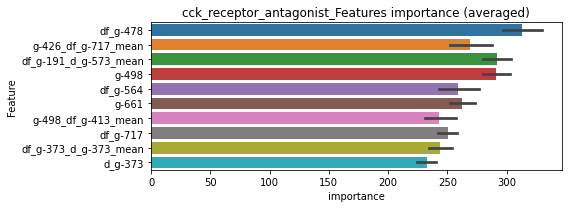

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729405	valid_1's binary_logloss: 0.0920159
[200]	training's binary_logloss: 0.0187556	valid_1's binary_logloss: 0.0315201
[300]	training's binary_logloss: 0.00562528	valid_1's binary_logloss: 0.0126792
[400]	training's binary_logloss: 0.00224096	valid_1's binary_logloss: 0.00643079
[500]	training's binary_logloss: 0.001178	valid_1's binary_logloss: 0.00419841
[600]	training's binary_logloss: 0.000756281	valid_1's binary_logloss: 0.00308489
[700]	training's binary_logloss: 0.000562745	valid_1's binary_logloss: 0.00258378
[800]	training's binary_logloss: 0.000462892	valid_1's binary_logloss: 0.00233232
[900]	training's binary_logloss: 0.000449661	valid_1's binary_logloss: 0.00230361
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000453888	valid_1's binary_logloss: 0.00230289


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0733337	valid_1's binary_logloss: 0.092033
[200]	training's binary_logloss: 0.0187567	valid_1's binary_logloss: 0.0318475
[300]	training's binary_logloss: 0.00579635	valid_1's binary_logloss: 0.0142721
[400]	training's binary_logloss: 0.00233305	valid_1's binary_logloss: 0.00815033
[500]	training's binary_logloss: 0.00121312	valid_1's binary_logloss: 0.00583308
[600]	training's binary_logloss: 0.000775031	valid_1's binary_logloss: 0.00467051
[700]	training's binary_logloss: 0.00056754	valid_1's binary_logloss: 0.00407203
[800]	training's binary_logloss: 0.00046982	valid_1's binary_logloss: 0.00384776
[900]	training's binary_logloss: 0.000442414	valid_1's binary_logloss: 0.00375032
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.000442414	valid_1's binary_logloss: 0.00375032


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0724056	valid_1's binary_logloss: 0.0863078
[200]	training's binary_logloss: 0.0186415	valid_1's binary_logloss: 0.0280621
[300]	training's binary_logloss: 0.00580684	valid_1's binary_logloss: 0.011573
[400]	training's binary_logloss: 0.00231347	valid_1's binary_logloss: 0.0065935
[500]	training's binary_logloss: 0.00121337	valid_1's binary_logloss: 0.00497441
[600]	training's binary_logloss: 0.000778558	valid_1's binary_logloss: 0.00418893
[700]	training's binary_logloss: 0.000574597	valid_1's binary_logloss: 0.00388012
[800]	training's binary_logloss: 0.000474079	valid_1's binary_logloss: 0.0036682
Early stopping, best iteration is:
[852]	training's binary_logloss: 0.000457177	valid_1's binary_logloss: 0.00362915


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 cck_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0726883	valid_1's binary_logloss: 0.0943833
[200]	training's binary_logloss: 0.0182715	valid_1's binary_logloss: 0.0333569
[300]	training's binary_logloss: 0.00564717	valid_1's binary_logloss: 0.0146939
[400]	training's binary_logloss: 0.00227027	valid_1's binary_logloss: 0.00807703
[500]	training's binary_logloss: 0.00118962	valid_1's binary_logloss: 0.00529521
[600]	training's binary_logloss: 0.000771105	valid_1's binary_logloss: 0.0042187
[700]	training's binary_logloss: 0.000570227	valid_1's binary_logloss: 0.00356975
[800]	training's binary_logloss: 0.000469888	valid_1's binary_logloss: 0.00320561
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000446761	valid_1's binary_logloss: 0.00311728


cck_receptor_antagonist logloss: 0.003201387572081643


neg labels: 3289 → selected neg labels: 3241


cdk_inhibitor, len(trt): 352, len(othr): 3241, target_rate: 0.0147812 → Adj_target_rate: 0.0122676
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.262469	valid_1's binary_logloss: 0.396631
[200]	training's binary_logloss: 0.174942	valid_1's binary_logloss: 0.378207
[300]	training's binary_logloss: 0.120439	valid_1's binary_logloss: 0.369635
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.101195	valid_1's binary_logloss: 0.368168
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.256549	valid_1's binary_logloss: 0.399132
[200]	training's binary_logloss: 0.167211	valid_1's binary_logloss: 0.379298
[300]	training's binary_logloss: 0.117011	valid_1's binary_logloss: 0.371185
[400]	training's binary_logloss: 0.0823565	valid_1's binary_logloss: 0.368639
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0865505	valid_1's binary_logloss: 0.367832
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.260238	valid_1's 

1 / 3 AUC score:0.764
y_Threshold: 0.1508824, Threshold: 0.4200567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 682 → Positive_corect_labels: 372/3207
p_label_rate: 0.0100452 Vs.target_rate: 0.01478, Num_p_label: 40.0, conf_0:0.29404, conf_1:0.54607
threshold: 0.4200567, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 372.0/3207, y_label_rate: 0.1159963
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128978	valid_1's binary_logloss: 0.231141
[200]	training's binary_logloss: 0.0601263	valid_1's binary_logloss: 0.195497
[300]	training's binary_logloss: 0.0304997	valid_1's binary_logloss: 0.178121
[400]	training's binary_logloss: 0.0161664	valid_1's binary_logloss: 0.168124
[500]	training's binary_logloss: 0.00931412	valid_1's binary_logloss: 0.165668
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.00992022	valid_1's binary_logloss: 0.164734
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129254	valid_1's binary_logloss: 0.234833
[200]	training's binary_logloss: 0.0612948	valid_1's binary_logloss: 0.203209
[300]	training's binary_logloss: 0.0328299	valid_1's binary_logloss: 0.192852
[400]	training's binary_logloss: 0.0183208	valid_1's binary_logloss: 0.190192
Early stopping, best iteration is:
[375]	training's binary_logl

2 / 3 AUC score:0.951
y_Threshold: 0.1121461, Threshold: 0.4200567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 172 → Positive_corect_labels: 286.0/3035
p_label_rate: 0.0313913 Vs.target_rate: 0.01478, Num_p_label: 125.0, conf_0:0.33605, conf_1:0.50407
Num_p_label: 125.0, Expected: 58.9, Adj_threshold_1: 0.4200567
Num_p_label: 103.0, Expected: 58.9, Adj_threshold_2: 0.4700567
Num_p_label: 88.0, Expected: 58.9, Adj_threshold_3: 0.5200567
threshold: 0.5200567, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 286.0/3035, y_label_rate: 0.0942339
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0914016	valid_1's binary_logloss: 0.149972
[200]	training's binary_logloss: 0.0366084	valid_1's binary_logloss: 0.103233
[300]	training's binary_logloss: 0.0165049	valid_1's binary_logloss: 0.0798089
[400]	training's binary_logloss: 0.00826376	valid_1's binary_logloss: 0.0678299
[500]	training's binary_logloss: 0.00453344	valid_1's binary_logloss: 0.0613928
[600]	training's binary_logloss: 0.00283049	valid_1's binary_logloss: 0.0577625
[700]	training's binary_logloss: 0.0019797	valid_1's binary_logloss: 0.0558942
[800]	training's binary_logloss: 0.00151844	valid_1's binary_logloss: 0.0536522
Early stopping, best iteration is:
[803]	training's binary_logloss: 0.00150846	valid_1's binary_logloss: 0.0535399
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0869122	valid_1's binary_logloss: 0.162821
[200]	training's binary_logloss: 0.0330963	valid_1'

3 / 3 AUC score:0.973
y_Threshold: 0.1118399, Threshold: 0.5200567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 72 → Positive_corect_labels: 250.0/2963
p_label_rate: 0.0449523 Vs.target_rate: 0.01478, Num_p_label: 179.0, conf_0:0.46805, conf_1:0.57206
Num_p_label: 179.0, Expected: 58.9, Adj_threshold_1: 0.5200567
Num_p_label: 158.0, Expected: 58.9, Adj_threshold_2: 0.5700567
Num_p_label: 136.0, Expected: 58.9, Adj_threshold_3: 0.6200567
Num_p_label: 118.0, Expected: 58.9, Adj_threshold_4: 0.6700567
Num_p_label: 93.0, Expected: 58.9, Adj_threshold_5: 0.7200567
Num_p_label: 73.0, Expected: 58.9, Adj_threshold_6: 0.7700567


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00968158	valid_1's binary_logloss: 0.123978


threshold: 0.7700567, positive_p_label: 73.0/3982, p_label_rate: 0.0183325
positive_y_label: 250.0/2963, y_label_rate: 0.0843739


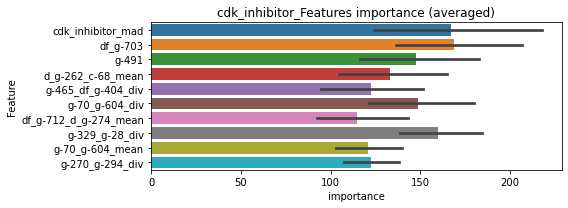

len(train_index) : 2222
len(valid_index) : 741
================================= fold 1/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0716402	valid_1's binary_logloss: 0.119084
[200]	training's binary_logloss: 0.0267234	valid_1's binary_logloss: 0.0812809
[300]	training's binary_logloss: 0.0111384	valid_1's binary_logloss: 0.0654363
[400]	training's binary_logloss: 0.00532248	valid_1's binary_logloss: 0.0581353
[500]	training's binary_logloss: 0.00298268	valid_1's binary_logloss: 0.0553712
Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00243295	valid_1's binary_logloss: 0.0548294


len(train_index) : 2222
len(valid_index) : 741
================================= fold 2/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.070801	valid_1's binary_logloss: 0.121678
[200]	training's binary_logloss: 0.0259205	valid_1's binary_logloss: 0.0792019
[300]	training's binary_logloss: 0.011031	valid_1's binary_logloss: 0.0626501
[400]	training's binary_logloss: 0.00516112	valid_1's binary_logloss: 0.0527631
[500]	training's binary_logloss: 0.00288842	valid_1's binary_logloss: 0.0476712
[600]	training's binary_logloss: 0.0018773	valid_1's binary_logloss: 0.0455432
[700]	training's binary_logloss: 0.00136091	valid_1's binary_logloss: 0.0440142
Early stopping, best iteration is:
[767]	training's binary_logloss: 0.00116151	valid_1's binary_logloss: 0.0436159


len(train_index) : 2222
len(valid_index) : 741
================================= fold 3/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679034	valid_1's binary_logloss: 0.116343
[200]	training's binary_logloss: 0.0247496	valid_1's binary_logloss: 0.0814314
[300]	training's binary_logloss: 0.0105083	valid_1's binary_logloss: 0.0687424
[400]	training's binary_logloss: 0.00512745	valid_1's binary_logloss: 0.0620225
[500]	training's binary_logloss: 0.00283052	valid_1's binary_logloss: 0.0584603
[600]	training's binary_logloss: 0.00183255	valid_1's binary_logloss: 0.0565826
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.00165882	valid_1's binary_logloss: 0.0557408


len(train_index) : 2223
len(valid_index) : 740
================================= fold 4/4 cdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.067242	valid_1's binary_logloss: 0.135601
[200]	training's binary_logloss: 0.0245606	valid_1's binary_logloss: 0.101687
[300]	training's binary_logloss: 0.010216	valid_1's binary_logloss: 0.0896056
[400]	training's binary_logloss: 0.00488349	valid_1's binary_logloss: 0.0829295


cdk_inhibitor logloss: 0.05880822914214673


Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00405327	valid_1's binary_logloss: 0.0810769
neg labels: 3289 → selected neg labels: 3282


chelating_agent, len(trt): 54, len(othr): 3282, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126862	valid_1's binary_logloss: 0.192034
[200]	training's binary_logloss: 0.0516239	valid_1's binary_logloss: 0.117718
[300]	training's binary_logloss: 0.0240104	valid_1's binary_logloss: 0.084428
[400]	training's binary_logloss: 0.0118454	valid_1's binary_logloss: 0.0679869
[500]	training's binary_logloss: 0.00611721	valid_1's binary_logloss: 0.0589688
[600]	training's binary_logloss: 0.00350705	valid_1's binary_logloss: 0.0535178
[700]	training's binary_logloss: 0.0022628	valid_1's binary_logloss: 0.0506958
[800]	training's binary_logloss: 0.00162363	valid_1's binary_logloss: 0.0489661
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.00175317	valid_1's binary_logloss: 0.0487417
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127831	valid_1's binary_logloss: 0.168309
[200]	training's binary_logloss: 0.0525771	valid_1's bi

1 / 3 AUC score:1.000
y_Threshold: 0.0197579, Threshold: 0.1053202, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.07372, conf_1:0.13692
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1053202
Num_p_label: 28.0, Expected: 9.0, Adj_threshold_2: 0.1553202
Num_p_label: 19.0, Expected: 9.0, Adj_threshold_3: 0.2053202
threshold: 0.2053202, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121597	valid_1's binary_logloss: 0.18401
[200]	training's binary_logloss: 0.0473942	valid_1's binary_logloss: 0.106744
[300]	training's binary_logloss: 0.0204954	valid_1's binary_logloss: 0.0716118
[400]	training's binary_logloss: 0.00940151	valid_1's binary_logloss: 0.0541358
[500]	training's binary_logloss: 0.00482639	valid_1's binary_logloss: 0.0444344
[600]	training's binary_logloss: 0.00282297	valid_1's binary_logloss: 0.0397587
[700]	training's binary_logloss: 0.00188548	valid_1's binary_logloss: 0.0369921
[800]	training's binary_logloss: 0.00139134	valid_1's binary_logloss: 0.0351636
[900]	training's binary_logloss: 0.00111317	valid_1's binary_logloss: 0.0341473
[1000]	training's binary_logloss: 0.00094043	valid_1's binary_logloss: 0.0334982
Early stopping, best iteration is:
[997]	training's binary_logloss: 0.000945259	valid_1's binary_logloss: 0.0334798
Training until validation sco

2 / 3 AUC score:1.000
y_Threshold: 0.0772683, Threshold: 0.2053202, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0115520 Vs.target_rate: 0.00227, Num_p_label: 46.0, conf_0:0.16426, conf_1:0.24638
Num_p_label: 46.0, Expected: 9.0, Adj_threshold_1: 0.2053202
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_2: 0.2553202
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_3: 0.3053202
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_4: 0.3553202
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_5: 0.4053202
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_6: 0.4553202
threshold: 0.4553202, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 649.0/3792, y_label_rate: 0.1711498
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120154	valid_1's binary_logloss: 0.173482
[200]	training's binary_logloss: 0.0456631	valid_1's binary_logloss: 0.0979162
[300]	training's binary_logloss: 0.0197166	valid_1's binary_logloss: 0.0666889
[400]	training's binary_logloss: 0.0089506	valid_1's binary_logloss: 0.0519273
[500]	training's binary_logloss: 0.0046049	valid_1's binary_logloss: 0.0465434
[600]	training's binary_logloss: 0.00275591	valid_1's binary_logloss: 0.0436048
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00249078	valid_1's binary_logloss: 0.0432504
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12368	valid_1's binary_logloss: 0.167317
[200]	training's binary_logloss: 0.0471307	valid_1's binary_logloss: 0.0921533
[300]	training's binary_logloss: 0.0206157	valid_1's binary_logloss: 0.0596485
[400]	training's binary_logloss: 0.00954311	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.0955878, Threshold: 0.4553202, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 643.0/3780
p_label_rate: 0.0055249 Vs.target_rate: 0.00227, Num_p_label: 22.0, conf_0:0.40979, conf_1:0.50085
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_1: 0.4553202
threshold: 0.4553202, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 643.0/3780, y_label_rate: 0.1701058


len(train_index) : 2835
len(valid_index) : 945
================================= fold 1/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120821	valid_1's binary_logloss: 0.164102
[200]	training's binary_logloss: 0.0478855	valid_1's binary_logloss: 0.0881999
[300]	training's binary_logloss: 0.0204844	valid_1's binary_logloss: 0.0542692
[400]	training's binary_logloss: 0.0095998	valid_1's binary_logloss: 0.0374083
[500]	training's binary_logloss: 0.00483194	valid_1's binary_logloss: 0.0283922
[600]	training's binary_logloss: 0.00281485	valid_1's binary_logloss: 0.0237436
[700]	training's binary_logloss: 0.00187019	valid_1's binary_logloss: 0.0211786
[800]	training's binary_logloss: 0.00138318	valid_1's binary_logloss: 0.0197929
[900]	training's binary_logloss: 0.00110321	valid_1's binary_logloss: 0.01858
[1000]	training's binary_logloss: 0.000932462	valid_1's binary_logloss: 0.0179486
[1100]	training's binary_logloss: 0.000840961	valid_1's binary_logloss: 0.0176692
[1200]	training's binary_logloss: 0.000788709	valid_1's binary_

len(train_index) : 2835
len(valid_index) : 945
================================= fold 2/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120537	valid_1's binary_logloss: 0.166617
[200]	training's binary_logloss: 0.0469759	valid_1's binary_logloss: 0.0909785
[300]	training's binary_logloss: 0.0196947	valid_1's binary_logloss: 0.0546599
[400]	training's binary_logloss: 0.00909983	valid_1's binary_logloss: 0.0374853
[500]	training's binary_logloss: 0.00458733	valid_1's binary_logloss: 0.0273754
[600]	training's binary_logloss: 0.00269647	valid_1's binary_logloss: 0.0218305
[700]	training's binary_logloss: 0.00184353	valid_1's binary_logloss: 0.0192316
[800]	training's binary_logloss: 0.00137338	valid_1's binary_logloss: 0.0175009
[900]	training's binary_logloss: 0.00110235	valid_1's binary_logloss: 0.0168036
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00108442	valid_1's binary_logloss: 0.0166544


len(train_index) : 2835
len(valid_index) : 945
================================= fold 3/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117935	valid_1's binary_logloss: 0.172325
[200]	training's binary_logloss: 0.0471878	valid_1's binary_logloss: 0.0962879
[300]	training's binary_logloss: 0.019887	valid_1's binary_logloss: 0.0602446
[400]	training's binary_logloss: 0.00909305	valid_1's binary_logloss: 0.043133
[500]	training's binary_logloss: 0.00468735	valid_1's binary_logloss: 0.0337345
[600]	training's binary_logloss: 0.00275886	valid_1's binary_logloss: 0.0290566
[700]	training's binary_logloss: 0.00184405	valid_1's binary_logloss: 0.0262972
[800]	training's binary_logloss: 0.00136489	valid_1's binary_logloss: 0.0244727
[900]	training's binary_logloss: 0.00109339	valid_1's binary_logloss: 0.023301
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000974035	valid_1's binary_logloss: 0.0229363


len(train_index) : 2835
len(valid_index) : 945
================================= fold 4/4 chelating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118718	valid_1's binary_logloss: 0.171242
[200]	training's binary_logloss: 0.046833	valid_1's binary_logloss: 0.0947389
[300]	training's binary_logloss: 0.020718	valid_1's binary_logloss: 0.0618684
[400]	training's binary_logloss: 0.00954733	valid_1's binary_logloss: 0.0448329
[500]	training's binary_logloss: 0.00481315	valid_1's binary_logloss: 0.0352814
[600]	training's binary_logloss: 0.00279542	valid_1's binary_logloss: 0.030802
[700]	training's binary_logloss: 0.00185641	valid_1's binary_logloss: 0.0280305
[800]	training's binary_logloss: 0.00137138	valid_1's binary_logloss: 0.0265917
[900]	training's binary_logloss: 0.00109367	valid_1's binary_logloss: 0.0256625
[1000]	training's binary_logloss: 0.000932242	valid_1's binary_logloss: 0.0247999
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000902693	valid_1's binary_logloss: 0.024637


chelating_agent logloss: 0.020410467798488357


neg labels: 3289 → selected neg labels: 3285


chk_inhibitor, len(trt): 24, len(othr): 3285, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871787	valid_1's binary_logloss: 0.115201
[200]	training's binary_logloss: 0.0274622	valid_1's binary_logloss: 0.0501359
[300]	training's binary_logloss: 0.00972619	valid_1's binary_logloss: 0.0271924
[400]	training's binary_logloss: 0.00398756	valid_1's binary_logloss: 0.0176694
[500]	training's binary_logloss: 0.00203755	valid_1's binary_logloss: 0.0133507
[600]	training's binary_logloss: 0.00127807	valid_1's binary_logloss: 0.0114449
[700]	training's binary_logloss: 0.000914781	valid_1's binary_logloss: 0.0103419
[800]	training's binary_logloss: 0.000721737	valid_1's binary_logloss: 0.00961046
[900]	training's binary_logloss: 0.000606959	valid_1's binary_logloss: 0.0093897
[1000]	training's binary_logloss: 0.000566024	valid_1's binary_logloss: 0.00926231
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.000566024	valid_1's binary_logloss: 0.00926231
Training until val

1 / 3 AUC score:1.000
y_Threshold: 0.0087595, Threshold: 0.0572906, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.04010, conf_1:0.07448
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0572906
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.1072906
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.1572906
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_4: 0.2072906
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.2572906
threshold: 0.2572906, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832211	valid_1's binary_logloss: 0.107566
[200]	training's binary_logloss: 0.0236033	valid_1's binary_logloss: 0.0416864
[300]	training's binary_logloss: 0.0077478	valid_1's binary_logloss: 0.0200482
[400]	training's binary_logloss: 0.00318884	valid_1's binary_logloss: 0.0123774
[500]	training's binary_logloss: 0.00167342	valid_1's binary_logloss: 0.008953
[600]	training's binary_logloss: 0.00107578	valid_1's binary_logloss: 0.00723595
[700]	training's binary_logloss: 0.00078128	valid_1's binary_logloss: 0.00626706
[800]	training's binary_logloss: 0.000618399	valid_1's binary_logloss: 0.00581718
[900]	training's binary_logloss: 0.000529599	valid_1's binary_logloss: 0.00552942
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.000497104	valid_1's binary_logloss: 0.00546975
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08335

2 / 3 AUC score:1.000
y_Threshold: 0.1194893, Threshold: 0.2572906, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0077850 Vs.target_rate: 0.00101, Num_p_label: 31.0, conf_0:0.20583, conf_1:0.30875
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_1: 0.2572906
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_2: 0.3072906
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_3: 0.3572906
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_4: 0.4072906
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_5: 0.4572906
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_6: 0.5072906
threshold: 0.5072906, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832211	valid_1's binary_logloss: 0.107566
[200]	training's binary_logloss: 0.0236033	valid_1's binary_logloss: 0.0416864
[300]	training's binary_logloss: 0.0077478	valid_1's binary_logloss: 0.0200482
[400]	training's binary_logloss: 0.00318884	valid_1's binary_logloss: 0.0123774
[500]	training's binary_logloss: 0.00167342	valid_1's binary_logloss: 0.008953
[600]	training's binary_logloss: 0.00107578	valid_1's binary_logloss: 0.00723595
[700]	training's binary_logloss: 0.00078128	valid_1's binary_logloss: 0.00626706
[800]	training's binary_logloss: 0.000618399	valid_1's binary_logloss: 0.00581718
[900]	training's binary_logloss: 0.000529599	valid_1's binary_logloss: 0.00552942
Early stopping, best iteration is:
[962]	training's binary_logloss: 0.000497104	valid_1's binary_logloss: 0.00546975
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08335

3 / 3 AUC score:1.000
y_Threshold: 0.1194893, Threshold: 0.5072906, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.45656, conf_1:0.55802
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_1: 0.5072906
threshold: 0.5072906, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0826922	valid_1's binary_logloss: 0.107031
[200]	training's binary_logloss: 0.0231883	valid_1's binary_logloss: 0.0406124
[300]	training's binary_logloss: 0.00765661	valid_1's binary_logloss: 0.0197051
[400]	training's binary_logloss: 0.00315397	valid_1's binary_logloss: 0.0119423
[500]	training's binary_logloss: 0.00167098	valid_1's binary_logloss: 0.00867138
[600]	training's binary_logloss: 0.00107515	valid_1's binary_logloss: 0.00727491
[700]	training's binary_logloss: 0.000778759	valid_1's binary_logloss: 0.00619317
[800]	training's binary_logloss: 0.00062107	valid_1's binary_logloss: 0.00571655
[900]	training's binary_logloss: 0.000530925	valid_1's binary_logloss: 0.00537172
[1000]	training's binary_logloss: 0.000498501	valid_1's binary_logloss: 0.00526243
Early stopping, best iteration is:
[1012]	training's binary_logloss: 0.000495497	valid_1's binary_logloss: 0.00525205


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834164	valid_1's binary_logloss: 0.10473
[200]	training's binary_logloss: 0.0237429	valid_1's binary_logloss: 0.0391112
[300]	training's binary_logloss: 0.00794269	valid_1's binary_logloss: 0.0180859
[400]	training's binary_logloss: 0.0032907	valid_1's binary_logloss: 0.0100443
[500]	training's binary_logloss: 0.00173777	valid_1's binary_logloss: 0.00670675
[600]	training's binary_logloss: 0.00111252	valid_1's binary_logloss: 0.00502615
[700]	training's binary_logloss: 0.000810231	valid_1's binary_logloss: 0.0041252
[800]	training's binary_logloss: 0.000642535	valid_1's binary_logloss: 0.0035705
[900]	training's binary_logloss: 0.000546196	valid_1's binary_logloss: 0.00324876
[1000]	training's binary_logloss: 0.000505458	valid_1's binary_logloss: 0.00312914
Early stopping, best iteration is:
[986]	training's binary_logloss: 0.000505458	valid_1's binary_logloss: 0.00312914


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0831372	valid_1's binary_logloss: 0.105575
[200]	training's binary_logloss: 0.0237658	valid_1's binary_logloss: 0.0398851
[300]	training's binary_logloss: 0.00797144	valid_1's binary_logloss: 0.0187148
[400]	training's binary_logloss: 0.0032802	valid_1's binary_logloss: 0.0110054
[500]	training's binary_logloss: 0.00172506	valid_1's binary_logloss: 0.0077339
[600]	training's binary_logloss: 0.0010995	valid_1's binary_logloss: 0.00618913
[700]	training's binary_logloss: 0.000799248	valid_1's binary_logloss: 0.00533565
[800]	training's binary_logloss: 0.000633173	valid_1's binary_logloss: 0.00480505
[900]	training's binary_logloss: 0.000537223	valid_1's binary_logloss: 0.00448104
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000509629	valid_1's binary_logloss: 0.00444094


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 chk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0833264	valid_1's binary_logloss: 0.109258
[200]	training's binary_logloss: 0.0241182	valid_1's binary_logloss: 0.0417475
[300]	training's binary_logloss: 0.00808435	valid_1's binary_logloss: 0.019669
[400]	training's binary_logloss: 0.00333504	valid_1's binary_logloss: 0.0116529
[500]	training's binary_logloss: 0.00174932	valid_1's binary_logloss: 0.00848624
[600]	training's binary_logloss: 0.00111427	valid_1's binary_logloss: 0.00704785
[700]	training's binary_logloss: 0.000803781	valid_1's binary_logloss: 0.00637166
[800]	training's binary_logloss: 0.000635307	valid_1's binary_logloss: 0.0058254
[900]	training's binary_logloss: 0.000540112	valid_1's binary_logloss: 0.0055698
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000543428	valid_1's binary_logloss: 0.00555815


chk_inhibitor logloss: 0.004595165759754484


neg labels: 3289 → selected neg labels: 3284


chloride_channel_blocker, len(trt): 42, len(othr): 3284, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101443	valid_1's binary_logloss: 0.13909
[200]	training's binary_logloss: 0.0396692	valid_1's binary_logloss: 0.0764495
[300]	training's binary_logloss: 0.0177545	valid_1's binary_logloss: 0.0504539
[400]	training's binary_logloss: 0.00775833	valid_1's binary_logloss: 0.0356256
[500]	training's binary_logloss: 0.00385683	valid_1's binary_logloss: 0.0279222
[600]	training's binary_logloss: 0.00226323	valid_1's binary_logloss: 0.0244178
[700]	training's binary_logloss: 0.00152509	valid_1's binary_logloss: 0.022181
[800]	training's binary_logloss: 0.00114088	valid_1's binary_logloss: 0.0206997
[900]	training's binary_logloss: 0.000924064	valid_1's binary_logloss: 0.0202566
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000915001	valid_1's binary_logloss: 0.0202457
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101759	valid_

1 / 3 AUC score:0.999
y_Threshold: 0.0203535, Threshold: 0.1171582, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.08201, conf_1:0.15231
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.1171582
Num_p_label: 29.0, Expected: 7.0, Adj_threshold_2: 0.1671582
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_3: 0.2171582
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_4: 0.2671582
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_5: 0.3171582
threshold: 0.3171582, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989677	valid_1's binary_logloss: 0.127085
[200]	training's binary_logloss: 0.0352472	valid_1's binary_logloss: 0.0617047
[300]	training's binary_logloss: 0.014622	valid_1's binary_logloss: 0.0367875
[400]	training's binary_logloss: 0.00634042	valid_1's binary_logloss: 0.0235925
[500]	training's binary_logloss: 0.00317941	valid_1's binary_logloss: 0.0174068
[600]	training's binary_logloss: 0.00190681	valid_1's binary_logloss: 0.0139505
[700]	training's binary_logloss: 0.0013079	valid_1's binary_logloss: 0.0124525
[800]	training's binary_logloss: 0.000986365	valid_1's binary_logloss: 0.0111852
[900]	training's binary_logloss: 0.000807478	valid_1's binary_logloss: 0.0104672
[1000]	training's binary_logloss: 0.000722565	valid_1's binary_logloss: 0.0102538
[1100]	training's binary_logloss: 0.000681546	valid_1's binary_logloss: 0.0102006
Early stopping, best iteration is:
[1119]	training's binary

2 / 3 AUC score:1.000
y_Threshold: 0.1085744, Threshold: 0.3171582, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0102963 Vs.target_rate: 0.00176, Num_p_label: 41.0, conf_0:0.25373, conf_1:0.38059
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_1: 0.3171582
Num_p_label: 39.0, Expected: 7.0, Adj_threshold_2: 0.3671582
Num_p_label: 31.0, Expected: 7.0, Adj_threshold_3: 0.4171582
Num_p_label: 24.0, Expected: 7.0, Adj_threshold_4: 0.4671582
Num_p_label: 22.0, Expected: 7.0, Adj_threshold_5: 0.5171582
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_6: 0.5671582
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_7: 0.6171582
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_8: 0.6671582
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_9: 0.7171582
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_10: 0.7671582
threshold: 0.7671582, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100955	valid_1's binary_logloss: 0.125841
[200]	training's binary_logloss: 0.0361258	valid_1's binary_logloss: 0.059945
[300]	training's binary_logloss: 0.0144594	valid_1's binary_logloss: 0.033615
[400]	training's binary_logloss: 0.0062539	valid_1's binary_logloss: 0.0209928
[500]	training's binary_logloss: 0.00311001	valid_1's binary_logloss: 0.0149212
[600]	training's binary_logloss: 0.00187063	valid_1's binary_logloss: 0.0118742
[700]	training's binary_logloss: 0.00128837	valid_1's binary_logloss: 0.0103223
[800]	training's binary_logloss: 0.000973995	valid_1's binary_logloss: 0.00921666
[900]	training's binary_logloss: 0.000796894	valid_1's binary_logloss: 0.00855286
[1000]	training's binary_logloss: 0.000712744	valid_1's binary_logloss: 0.00819603
[1100]	training's binary_logloss: 0.000680675	valid_1's binary_logloss: 0.00811614
Early stopping, best iteration is:
[1095]	training's bina

3 / 3 AUC score:1.000
y_Threshold: 0.1134015, Threshold: 0.7671582, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 643.0/3782
p_label_rate: 0.0037670 Vs.target_rate: 0.00176, Num_p_label: 15.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 15.0, Expected: 7.0, Adj_threshold_1: 0.7671582
threshold: 0.7671582, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 643.0/3782, y_label_rate: 0.1700159


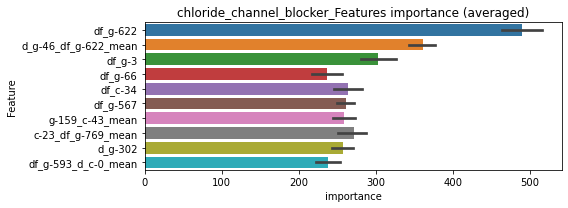

len(train_index) : 2836
len(valid_index) : 946
================================= fold 1/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970801	valid_1's binary_logloss: 0.129353
[200]	training's binary_logloss: 0.0334684	valid_1's binary_logloss: 0.0606938
[300]	training's binary_logloss: 0.0137368	valid_1's binary_logloss: 0.0355408
[400]	training's binary_logloss: 0.00607718	valid_1's binary_logloss: 0.0240321
[500]	training's binary_logloss: 0.00294202	valid_1's binary_logloss: 0.0179704
[600]	training's binary_logloss: 0.00175598	valid_1's binary_logloss: 0.0151963
[700]	training's binary_logloss: 0.00121061	valid_1's binary_logloss: 0.0135981
[800]	training's binary_logloss: 0.000933016	valid_1's binary_logloss: 0.0124626
[900]	training's binary_logloss: 0.000770088	valid_1's binary_logloss: 0.012056
[1000]	training's binary_logloss: 0.000691573	valid_1's binary_logloss: 0.011817
Early stopping, best iteration is:
[1014]	training's binary_logloss: 0.000684354	valid_1's binary_logloss: 0.0117217


len(train_index) : 2836
len(valid_index) : 946
================================= fold 2/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951393	valid_1's binary_logloss: 0.137498
[200]	training's binary_logloss: 0.0316396	valid_1's binary_logloss: 0.0639599
[300]	training's binary_logloss: 0.012948	valid_1's binary_logloss: 0.0367111
[400]	training's binary_logloss: 0.00560599	valid_1's binary_logloss: 0.02267
[500]	training's binary_logloss: 0.00277808	valid_1's binary_logloss: 0.0161109
[600]	training's binary_logloss: 0.00168203	valid_1's binary_logloss: 0.013025
[700]	training's binary_logloss: 0.00117459	valid_1's binary_logloss: 0.0109353
[800]	training's binary_logloss: 0.000904202	valid_1's binary_logloss: 0.0100251
[900]	training's binary_logloss: 0.000757927	valid_1's binary_logloss: 0.00941181
[1000]	training's binary_logloss: 0.000683977	valid_1's binary_logloss: 0.00909781
Early stopping, best iteration is:
[1048]	training's binary_logloss: 0.000665244	valid_1's binary_logloss: 0.00902347


len(train_index) : 2837
len(valid_index) : 945
================================= fold 3/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0964777	valid_1's binary_logloss: 0.122535
[200]	training's binary_logloss: 0.0333442	valid_1's binary_logloss: 0.0591328
[300]	training's binary_logloss: 0.0140843	valid_1's binary_logloss: 0.036232
[400]	training's binary_logloss: 0.00689928	valid_1's binary_logloss: 0.0255572
[500]	training's binary_logloss: 0.00307877	valid_1's binary_logloss: 0.0154616
[600]	training's binary_logloss: 0.00175808	valid_1's binary_logloss: 0.0119977
[700]	training's binary_logloss: 0.00118793	valid_1's binary_logloss: 0.00980792
[800]	training's binary_logloss: 0.000904922	valid_1's binary_logloss: 0.0086765
[900]	training's binary_logloss: 0.000749296	valid_1's binary_logloss: 0.00773285
[1000]	training's binary_logloss: 0.000675209	valid_1's binary_logloss: 0.00729613
[1100]	training's binary_logloss: 0.000641824	valid_1's binary_logloss: 0.00715509
Early stopping, best iteration is:
[1128]	training's b

len(train_index) : 2837
len(valid_index) : 945
================================= fold 4/4 chloride_channel_blocker=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966134	valid_1's binary_logloss: 0.134732
[200]	training's binary_logloss: 0.032698	valid_1's binary_logloss: 0.0650323
[300]	training's binary_logloss: 0.0133142	valid_1's binary_logloss: 0.0385717
[400]	training's binary_logloss: 0.00566726	valid_1's binary_logloss: 0.0260446
[500]	training's binary_logloss: 0.00287352	valid_1's binary_logloss: 0.0201372
[600]	training's binary_logloss: 0.00173183	valid_1's binary_logloss: 0.0175439
[700]	training's binary_logloss: 0.00119829	valid_1's binary_logloss: 0.0161197
[800]	training's binary_logloss: 0.000930955	valid_1's binary_logloss: 0.0151771
[900]	training's binary_logloss: 0.000772782	valid_1's binary_logloss: 0.0145218
[1000]	training's binary_logloss: 0.000695181	valid_1's binary_logloss: 0.0142339
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000682678	valid_1's binary_logloss: 0.014095


chloride_channel_blocker logloss: 0.010498347340461659


neg labels: 3289 → selected neg labels: 3288


cholesterol_inhibitor, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11267	valid_1's binary_logloss: 0.164215
[200]	training's binary_logloss: 0.0443221	valid_1's binary_logloss: 0.0909269
[300]	training's binary_logloss: 0.018902	valid_1's binary_logloss: 0.0579861
[400]	training's binary_logloss: 0.00868108	valid_1's binary_logloss: 0.0408277
[500]	training's binary_logloss: 0.00439525	valid_1's binary_logloss: 0.0317595
[600]	training's binary_logloss: 0.00256066	valid_1's binary_logloss: 0.0268182
[700]	training's binary_logloss: 0.0017291	valid_1's binary_logloss: 0.0242389
[800]	training's binary_logloss: 0.00129368	valid_1's binary_logloss: 0.0228192
[900]	training's binary_logloss: 0.00103316	valid_1's binary_logloss: 0.0220992
[1000]	training's binary_logloss: 0.000870429	valid_1's binary_logloss: 0.0215288
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000886983	valid_1's binary_logloss: 0.0214974
Training until validation sco

1 / 3 AUC score:0.999
y_Threshold: 0.0185265, Threshold: 0.0890498, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 655/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.06233, conf_1:0.11576
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0890498
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_2: 0.1390498
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.1890498
threshold: 0.1890498, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 655.0/3809, y_label_rate: 0.1719611
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103617	valid_1's binary_logloss: 0.148553
[200]	training's binary_logloss: 0.0364107	valid_1's binary_logloss: 0.081134
[300]	training's binary_logloss: 0.0145947	valid_1's binary_logloss: 0.0539459
[400]	training's binary_logloss: 0.00654704	valid_1's binary_logloss: 0.0412873
[500]	training's binary_logloss: 0.0033287	valid_1's binary_logloss: 0.0356989
[600]	training's binary_logloss: 0.00202007	valid_1's binary_logloss: 0.0334581
[700]	training's binary_logloss: 0.00140402	valid_1's binary_logloss: 0.0321894
[800]	training's binary_logloss: 0.00106072	valid_1's binary_logloss: 0.0312355
[900]	training's binary_logloss: 0.000860527	valid_1's binary_logloss: 0.0307502
Early stopping, best iteration is:
[893]	training's binary_logloss: 0.000871628	valid_1's binary_logloss: 0.0306997
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106987	valid_

2 / 3 AUC score:0.999
y_Threshold: 0.1245435, Threshold: 0.1890498, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 644.0/3787
p_label_rate: 0.0133099 Vs.target_rate: 0.00202, Num_p_label: 53.0, conf_0:0.15124, conf_1:0.22686
Num_p_label: 53.0, Expected: 8.0, Adj_threshold_1: 0.1890498
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_2: 0.2390498
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_3: 0.2890498
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_4: 0.3390498
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_5: 0.3890498
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_6: 0.4390498
threshold: 0.4390498, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 644.0/3787, y_label_rate: 0.1700555
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10248	valid_1's binary_logloss: 0.152198
[200]	training's binary_logloss: 0.0355727	valid_1's binary_logloss: 0.08194
[300]	training's binary_logloss: 0.0139662	valid_1's binary_logloss: 0.0541115
[400]	training's binary_logloss: 0.00607667	valid_1's binary_logloss: 0.0413973
[500]	training's binary_logloss: 0.00309625	valid_1's binary_logloss: 0.0360443
[600]	training's binary_logloss: 0.00187169	valid_1's binary_logloss: 0.0339723
[700]	training's binary_logloss: 0.00130139	valid_1's binary_logloss: 0.0330352
[800]	training's binary_logloss: 0.000984338	valid_1's binary_logloss: 0.0323895
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.000900609	valid_1's binary_logloss: 0.0321376
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103879	valid_1's binary_logloss: 0.133918
[200]	training's binary_logloss: 0.0360579	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.0945956, Threshold: 0.4390498, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 636.0/3771
p_label_rate: 0.0075339 Vs.target_rate: 0.00202, Num_p_label: 30.0, conf_0:0.39514, conf_1:0.48295
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_1: 0.4390498
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_2: 0.4890498
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_3: 0.5390498
threshold: 0.5390498, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 636.0/3771, y_label_rate: 0.1686555


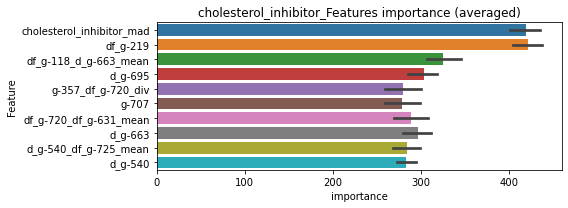

len(train_index) : 2828
len(valid_index) : 943
================================= fold 1/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100443	valid_1's binary_logloss: 0.136829
[200]	training's binary_logloss: 0.0345163	valid_1's binary_logloss: 0.0645777
[300]	training's binary_logloss: 0.013488	valid_1's binary_logloss: 0.0339161
[400]	training's binary_logloss: 0.00596909	valid_1's binary_logloss: 0.0203572
[500]	training's binary_logloss: 0.00301009	valid_1's binary_logloss: 0.013512
[600]	training's binary_logloss: 0.00182483	valid_1's binary_logloss: 0.0102871
[700]	training's binary_logloss: 0.00125559	valid_1's binary_logloss: 0.00833462
[800]	training's binary_logloss: 0.000966146	valid_1's binary_logloss: 0.00724659
[900]	training's binary_logloss: 0.000794026	valid_1's binary_logloss: 0.00660059
[1000]	training's binary_logloss: 0.000701475	valid_1's binary_logloss: 0.00628455
[1100]	training's binary_logloss: 0.000653736	valid_1's binary_logloss: 0.0060655
[1200]	training's binary_logloss: 0.000631609	valid_1's 

len(train_index) : 2828
len(valid_index) : 943
================================= fold 2/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102153	valid_1's binary_logloss: 0.134119
[200]	training's binary_logloss: 0.036324	valid_1's binary_logloss: 0.0662998
[300]	training's binary_logloss: 0.0143045	valid_1's binary_logloss: 0.0376435
[400]	training's binary_logloss: 0.00614919	valid_1's binary_logloss: 0.0240388
[500]	training's binary_logloss: 0.00313932	valid_1's binary_logloss: 0.0176817
[600]	training's binary_logloss: 0.00187982	valid_1's binary_logloss: 0.013646
[700]	training's binary_logloss: 0.00130033	valid_1's binary_logloss: 0.0119769
[800]	training's binary_logloss: 0.000994948	valid_1's binary_logloss: 0.0107449
[900]	training's binary_logloss: 0.000812709	valid_1's binary_logloss: 0.00982579
[1000]	training's binary_logloss: 0.000708287	valid_1's binary_logloss: 0.00931366
[1100]	training's binary_logloss: 0.00065398	valid_1's binary_logloss: 0.0090085
Early stopping, best iteration is:
[1126]	training's binary

len(train_index) : 2828
len(valid_index) : 943
================================= fold 3/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968207	valid_1's binary_logloss: 0.13594
[200]	training's binary_logloss: 0.0329896	valid_1's binary_logloss: 0.0681116
[300]	training's binary_logloss: 0.0132145	valid_1's binary_logloss: 0.0418577
[400]	training's binary_logloss: 0.00563226	valid_1's binary_logloss: 0.0291754
[500]	training's binary_logloss: 0.00286942	valid_1's binary_logloss: 0.0234729
[600]	training's binary_logloss: 0.00174683	valid_1's binary_logloss: 0.0208371
[700]	training's binary_logloss: 0.00122149	valid_1's binary_logloss: 0.0196168
[800]	training's binary_logloss: 0.00093572	valid_1's binary_logloss: 0.0189505
[900]	training's binary_logloss: 0.000767082	valid_1's binary_logloss: 0.0184624
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.000706666	valid_1's binary_logloss: 0.018278


len(train_index) : 2829
len(valid_index) : 942
================================= fold 4/4 cholesterol_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.098975	valid_1's binary_logloss: 0.152415
[200]	training's binary_logloss: 0.0342005	valid_1's binary_logloss: 0.0776308
[300]	training's binary_logloss: 0.0130103	valid_1's binary_logloss: 0.0459129
[400]	training's binary_logloss: 0.00554609	valid_1's binary_logloss: 0.0316154
[500]	training's binary_logloss: 0.00284549	valid_1's binary_logloss: 0.0244195
[600]	training's binary_logloss: 0.00173928	valid_1's binary_logloss: 0.0211719
[700]	training's binary_logloss: 0.00122176	valid_1's binary_logloss: 0.0193857
[800]	training's binary_logloss: 0.000936899	valid_1's binary_logloss: 0.0181322
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.00083746	valid_1's binary_logloss: 0.0176886


cholesterol_inhibitor logloss: 0.012723600062155664


neg labels: 3289 → selected neg labels: 3281


cholinergic_receptor_antagonist, len(trt): 54, len(othr): 3281, target_rate: 0.0022676 → Adj_target_rate: 0.0024931
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12934	valid_1's binary_logloss: 0.19544
[200]	training's binary_logloss: 0.0554602	valid_1's binary_logloss: 0.123369
[300]	training's binary_logloss: 0.0252921	valid_1's binary_logloss: 0.087664
[400]	training's binary_logloss: 0.0121337	valid_1's binary_logloss: 0.0696981
[500]	training's binary_logloss: 0.00616965	valid_1's binary_logloss: 0.0599249
[600]	training's binary_logloss: 0.00354671	valid_1's binary_logloss: 0.0544733
[700]	training's binary_logloss: 0.0023108	valid_1's binary_logloss: 0.0522602
[800]	training's binary_logloss: 0.0016714	valid_1's binary_logloss: 0.0505918
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.00162669	valid_1's binary_logloss: 0.0503576
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132048	valid_1's binary_logloss: 0.18613
[200]	training's binary_logloss: 0.0558509	valid_1's binary

1 / 3 AUC score:0.997
y_Threshold: 0.0249407, Threshold: 0.1084873, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3793
p_label_rate: 0.0100452 Vs.target_rate: 0.00227, Num_p_label: 40.0, conf_0:0.07594, conf_1:0.14103
Num_p_label: 40.0, Expected: 9.0, Adj_threshold_1: 0.1084873
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_2: 0.1584873
Num_p_label: 18.0, Expected: 9.0, Adj_threshold_3: 0.2084873
threshold: 0.2084873, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121673	valid_1's binary_logloss: 0.169787
[200]	training's binary_logloss: 0.0478949	valid_1's binary_logloss: 0.0928363
[300]	training's binary_logloss: 0.0206896	valid_1's binary_logloss: 0.0577506
[400]	training's binary_logloss: 0.0093051	valid_1's binary_logloss: 0.0388962
[500]	training's binary_logloss: 0.00484286	valid_1's binary_logloss: 0.030092
[600]	training's binary_logloss: 0.00283562	valid_1's binary_logloss: 0.02497
[700]	training's binary_logloss: 0.00190533	valid_1's binary_logloss: 0.0220561
[800]	training's binary_logloss: 0.00141386	valid_1's binary_logloss: 0.0201526
[900]	training's binary_logloss: 0.00112565	valid_1's binary_logloss: 0.0188845
[1000]	training's binary_logloss: 0.00095307	valid_1's binary_logloss: 0.0177968
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000945633	valid_1's binary_logloss: 0.0177102
Training until validation scor

2 / 3 AUC score:1.000
y_Threshold: 0.1354269, Threshold: 0.2084873, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0170768 Vs.target_rate: 0.00227, Num_p_label: 68.0, conf_0:0.16679, conf_1:0.25018
Num_p_label: 68.0, Expected: 9.0, Adj_threshold_1: 0.2084873
Num_p_label: 57.0, Expected: 9.0, Adj_threshold_2: 0.2584873
Num_p_label: 39.0, Expected: 9.0, Adj_threshold_3: 0.3084873
Num_p_label: 34.0, Expected: 9.0, Adj_threshold_4: 0.3584873
Num_p_label: 25.0, Expected: 9.0, Adj_threshold_5: 0.4084873
Num_p_label: 23.0, Expected: 9.0, Adj_threshold_6: 0.4584873
Num_p_label: 20.0, Expected: 9.0, Adj_threshold_7: 0.5084873
threshold: 0.5084873, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 639.0/3771, y_label_rate: 0.1694511
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11367	valid_1's binary_logloss: 0.17439
[200]	training's binary_logloss: 0.0441331	valid_1's binary_logloss: 0.106253
[300]	training's binary_logloss: 0.0183226	valid_1's binary_logloss: 0.0766507
[400]	training's binary_logloss: 0.00858473	valid_1's binary_logloss: 0.0625642
[500]	training's binary_logloss: 0.00442811	valid_1's binary_logloss: 0.0550767
[600]	training's binary_logloss: 0.00263881	valid_1's binary_logloss: 0.0510971
[700]	training's binary_logloss: 0.00178178	valid_1's binary_logloss: 0.0490934
[800]	training's binary_logloss: 0.00132934	valid_1's binary_logloss: 0.0474793
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.00141895	valid_1's binary_logloss: 0.0473716
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116497	valid_1's binary_logloss: 0.184484
[200]	training's binary_logloss: 0.0438964	valid_1's b

3 / 3 AUC score:0.998
y_Threshold: 0.1058960, Threshold: 0.5084873, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 628.0/3749
p_label_rate: 0.0072828 Vs.target_rate: 0.00227, Num_p_label: 29.0, conf_0:0.45764, conf_1:0.55934
Num_p_label: 29.0, Expected: 9.0, Adj_threshold_1: 0.5084873
Num_p_label: 22.0, Expected: 9.0, Adj_threshold_2: 0.5584873
threshold: 0.5584873, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 628.0/3749, y_label_rate: 0.1675113


len(train_index) : 2811
len(valid_index) : 938
================================= fold 1/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115008	valid_1's binary_logloss: 0.162942
[200]	training's binary_logloss: 0.0424713	valid_1's binary_logloss: 0.0897745
[300]	training's binary_logloss: 0.0179107	valid_1's binary_logloss: 0.0579164
[400]	training's binary_logloss: 0.00818757	valid_1's binary_logloss: 0.0406458
[500]	training's binary_logloss: 0.00420819	valid_1's binary_logloss: 0.0317745
[600]	training's binary_logloss: 0.00248215	valid_1's binary_logloss: 0.0269157
[700]	training's binary_logloss: 0.001684	valid_1's binary_logloss: 0.0241912
[800]	training's binary_logloss: 0.00126847	valid_1's binary_logloss: 0.0226868
[900]	training's binary_logloss: 0.00102063	valid_1's binary_logloss: 0.0214771
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000951386	valid_1's binary_logloss: 0.0213655


len(train_index) : 2812
len(valid_index) : 937
================================= fold 2/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114752	valid_1's binary_logloss: 0.171666
[200]	training's binary_logloss: 0.0440777	valid_1's binary_logloss: 0.092591
[300]	training's binary_logloss: 0.018651	valid_1's binary_logloss: 0.0554498
[400]	training's binary_logloss: 0.00863467	valid_1's binary_logloss: 0.0363969
[500]	training's binary_logloss: 0.00434332	valid_1's binary_logloss: 0.0253776
[600]	training's binary_logloss: 0.00257908	valid_1's binary_logloss: 0.0203474
[700]	training's binary_logloss: 0.00174014	valid_1's binary_logloss: 0.0172358
[800]	training's binary_logloss: 0.00130329	valid_1's binary_logloss: 0.0154043
[900]	training's binary_logloss: 0.00104455	valid_1's binary_logloss: 0.0139742
[1000]	training's binary_logloss: 0.000886022	valid_1's binary_logloss: 0.0131938
[1100]	training's binary_logloss: 0.000784301	valid_1's binary_logloss: 0.012717
[1200]	training's binary_logloss: 0.000738168	valid_1's binary_

len(train_index) : 2812
len(valid_index) : 937
================================= fold 3/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113812	valid_1's binary_logloss: 0.160614
[200]	training's binary_logloss: 0.0427703	valid_1's binary_logloss: 0.0858155
[300]	training's binary_logloss: 0.0179671	valid_1's binary_logloss: 0.053836
[400]	training's binary_logloss: 0.00819733	valid_1's binary_logloss: 0.0389493
[500]	training's binary_logloss: 0.00419288	valid_1's binary_logloss: 0.0309192
[600]	training's binary_logloss: 0.00250001	valid_1's binary_logloss: 0.0266978
[700]	training's binary_logloss: 0.00169626	valid_1's binary_logloss: 0.0238956
[800]	training's binary_logloss: 0.00126439	valid_1's binary_logloss: 0.0223383
[900]	training's binary_logloss: 0.00102055	valid_1's binary_logloss: 0.0214366
[1000]	training's binary_logloss: 0.000865853	valid_1's binary_logloss: 0.0207872
[1100]	training's binary_logloss: 0.000769074	valid_1's binary_logloss: 0.0204011
Early stopping, best iteration is:
[1132]	training's binary_l

len(train_index) : 2812
len(valid_index) : 937
================================= fold 4/4 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113191	valid_1's binary_logloss: 0.176553
[200]	training's binary_logloss: 0.0422884	valid_1's binary_logloss: 0.100407
[300]	training's binary_logloss: 0.0177577	valid_1's binary_logloss: 0.0684488
[400]	training's binary_logloss: 0.00805532	valid_1's binary_logloss: 0.053709
[500]	training's binary_logloss: 0.00411549	valid_1's binary_logloss: 0.0450314
[600]	training's binary_logloss: 0.00245224	valid_1's binary_logloss: 0.0406705
[700]	training's binary_logloss: 0.00167117	valid_1's binary_logloss: 0.0380151
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.00139696	valid_1's binary_logloss: 0.037422


cholinergic_receptor_antagonist logloss: 0.02282912908618034


neg labels: 3289 → selected neg labels: 3288


coagulation_factor_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08251	valid_1's binary_logloss: 0.107746
[200]	training's binary_logloss: 0.0248105	valid_1's binary_logloss: 0.0421054
[300]	training's binary_logloss: 0.00873278	valid_1's binary_logloss: 0.0205175
[400]	training's binary_logloss: 0.00359356	valid_1's binary_logloss: 0.0117644
[500]	training's binary_logloss: 0.00186559	valid_1's binary_logloss: 0.00813548
[600]	training's binary_logloss: 0.00117839	valid_1's binary_logloss: 0.00641174
[700]	training's binary_logloss: 0.000850689	valid_1's binary_logloss: 0.00544435
[800]	training's binary_logloss: 0.000675291	valid_1's binary_logloss: 0.00489204
[900]	training's binary_logloss: 0.000578722	valid_1's binary_logloss: 0.00457042
[1000]	training's binary_logloss: 0.000536868	valid_1's binary_logloss: 0.00444054
Early stopping, best iteration is:
[1010]	training's binary_logloss: 0.000534453	valid_1's binary_logloss: 0.00443275
Training until 

1 / 3 AUC score:1.000
y_Threshold: 0.0080673, Threshold: 0.0471585, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03301, conf_1:0.06131
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0471585
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.0971585
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_3: 0.1471585
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.1971585
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_5: 0.2471585
Num_p_label: 11.0, Expected: 4.0, Adj_threshold_6: 0.2971585
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_7: 0.3471585
threshold: 0.3471585, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803123	valid_1's binary_logloss: 0.101048
[200]	training's binary_logloss: 0.0227693	valid_1's binary_logloss: 0.0368619
[300]	training's binary_logloss: 0.00757563	valid_1's binary_logloss: 0.0164002
[400]	training's binary_logloss: 0.00312133	valid_1's binary_logloss: 0.00901563
[500]	training's binary_logloss: 0.00163754	valid_1's binary_logloss: 0.0058494
[600]	training's binary_logloss: 0.00103441	valid_1's binary_logloss: 0.00438475
[700]	training's binary_logloss: 0.000752468	valid_1's binary_logloss: 0.0035845
[800]	training's binary_logloss: 0.000605504	valid_1's binary_logloss: 0.00321143
[900]	training's binary_logloss: 0.000521765	valid_1's binary_logloss: 0.00296573
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.00050351	valid_1's binary_logloss: 0.00292797
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082

2 / 3 AUC score:1.000
y_Threshold: 0.1650662, Threshold: 0.3471585, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0045203 Vs.target_rate: 0.00101, Num_p_label: 18.0, conf_0:0.27773, conf_1:0.41659
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_1: 0.3471585
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_2: 0.3971585
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.4471585
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.4971585
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_5: 0.5471585
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_6: 0.5971585
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_7: 0.6471585
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_8: 0.6971585
threshold: 0.6971585, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803123	valid_1's binary_logloss: 0.101048
[200]	training's binary_logloss: 0.0227693	valid_1's binary_logloss: 0.0368619
[300]	training's binary_logloss: 0.00757563	valid_1's binary_logloss: 0.0164002
[400]	training's binary_logloss: 0.00312133	valid_1's binary_logloss: 0.00901563
[500]	training's binary_logloss: 0.00163754	valid_1's binary_logloss: 0.0058494
[600]	training's binary_logloss: 0.00103441	valid_1's binary_logloss: 0.00438475
[700]	training's binary_logloss: 0.000752468	valid_1's binary_logloss: 0.0035845
[800]	training's binary_logloss: 0.000605504	valid_1's binary_logloss: 0.00321143
[900]	training's binary_logloss: 0.000521765	valid_1's binary_logloss: 0.00296573
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.00050351	valid_1's binary_logloss: 0.00292797
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082

3 / 3 AUC score:1.000
y_Threshold: 0.1650662, Threshold: 0.6971585, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.76687
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_1: 0.6971585
threshold: 0.6971585, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


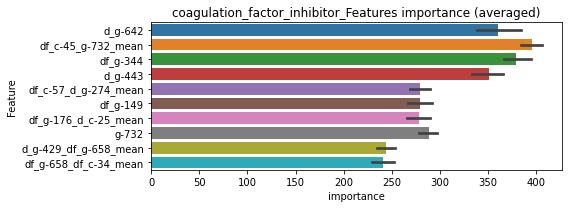

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792117	valid_1's binary_logloss: 0.100476
[200]	training's binary_logloss: 0.0220138	valid_1's binary_logloss: 0.0356367
[300]	training's binary_logloss: 0.00734457	valid_1's binary_logloss: 0.0157849
[400]	training's binary_logloss: 0.00304335	valid_1's binary_logloss: 0.00861041
[500]	training's binary_logloss: 0.00161089	valid_1's binary_logloss: 0.00576041
[600]	training's binary_logloss: 0.00103741	valid_1's binary_logloss: 0.00438599
[700]	training's binary_logloss: 0.000751306	valid_1's binary_logloss: 0.00353915
[800]	training's binary_logloss: 0.000597716	valid_1's binary_logloss: 0.00307008
[900]	training's binary_logloss: 0.000524917	valid_1's binary_logloss: 0.00289098
Early stopping, best iteration is:
[958]	training's binary_logloss: 0.000500905	valid_1's binary_logloss: 0.00282286


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812397	valid_1's binary_logloss: 0.0954874
[200]	training's binary_logloss: 0.0236616	valid_1's binary_logloss: 0.0358203
[300]	training's binary_logloss: 0.00779614	valid_1's binary_logloss: 0.0152812
[400]	training's binary_logloss: 0.00318294	valid_1's binary_logloss: 0.0076604
[500]	training's binary_logloss: 0.00166805	valid_1's binary_logloss: 0.00473422
[600]	training's binary_logloss: 0.0010617	valid_1's binary_logloss: 0.00338796
[700]	training's binary_logloss: 0.000759837	valid_1's binary_logloss: 0.00263792
[800]	training's binary_logloss: 0.000603675	valid_1's binary_logloss: 0.00224719
[900]	training's binary_logloss: 0.000522976	valid_1's binary_logloss: 0.00203881
[1000]	training's binary_logloss: 0.000492033	valid_1's binary_logloss: 0.00196271
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.00049245	valid_1's binary_logloss: 0.00196241


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.079429	valid_1's binary_logloss: 0.115611
[200]	training's binary_logloss: 0.02144	valid_1's binary_logloss: 0.0440931
[300]	training's binary_logloss: 0.00704114	valid_1's binary_logloss: 0.0207745
[400]	training's binary_logloss: 0.00294412	valid_1's binary_logloss: 0.0117738
[500]	training's binary_logloss: 0.00154845	valid_1's binary_logloss: 0.00817443
[600]	training's binary_logloss: 0.00099781	valid_1's binary_logloss: 0.00656149
[700]	training's binary_logloss: 0.00072608	valid_1's binary_logloss: 0.00573676
[800]	training's binary_logloss: 0.000582098	valid_1's binary_logloss: 0.0052185
[900]	training's binary_logloss: 0.000506511	valid_1's binary_logloss: 0.00495162
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000492924	valid_1's binary_logloss: 0.00490673


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0792293	valid_1's binary_logloss: 0.101517
[200]	training's binary_logloss: 0.0223233	valid_1's binary_logloss: 0.0397473
[300]	training's binary_logloss: 0.00743556	valid_1's binary_logloss: 0.0197769
[400]	training's binary_logloss: 0.00310269	valid_1's binary_logloss: 0.0125999
[500]	training's binary_logloss: 0.00160659	valid_1's binary_logloss: 0.00928936
[600]	training's binary_logloss: 0.00102512	valid_1's binary_logloss: 0.00780181
[700]	training's binary_logloss: 0.000744247	valid_1's binary_logloss: 0.00685654
[800]	training's binary_logloss: 0.000598011	valid_1's binary_logloss: 0.00647966
[900]	training's binary_logloss: 0.00051733	valid_1's binary_logloss: 0.00617177
[1000]	training's binary_logloss: 0.000483429	valid_1's binary_logloss: 0.0060856
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000476892	valid_1's binary_logloss: 0.00604675


coagulation_factor_inhibitor logloss: 0.003939580875897909


neg labels: 3289 → selected neg labels: 3285


corticosteroid_agonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968573	valid_1's binary_logloss: 0.14179
[200]	training's binary_logloss: 0.0351697	valid_1's binary_logloss: 0.0765046
[300]	training's binary_logloss: 0.0138676	valid_1's binary_logloss: 0.0463448
[400]	training's binary_logloss: 0.00606652	valid_1's binary_logloss: 0.031843
[500]	training's binary_logloss: 0.00306499	valid_1's binary_logloss: 0.0247236
[600]	training's binary_logloss: 0.00184458	valid_1's binary_logloss: 0.0211619
[700]	training's binary_logloss: 0.00127919	valid_1's binary_logloss: 0.0193283
[800]	training's binary_logloss: 0.000971778	valid_1's binary_logloss: 0.0182897
[900]	training's binary_logloss: 0.000795991	valid_1's binary_logloss: 0.0176991
Early stopping, best iteration is:
[961]	training's binary_logloss: 0.000725897	valid_1's binary_logloss: 0.0173816
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0984486	val

1 / 3 AUC score:0.999
y_Threshold: 0.0177545, Threshold: 0.0982728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.06879, conf_1:0.12775
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0982728
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.1482728
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.1982728
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.2482728
threshold: 0.2482728, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927209	valid_1's binary_logloss: 0.12684
[200]	training's binary_logloss: 0.0293114	valid_1's binary_logloss: 0.0561672
[300]	training's binary_logloss: 0.0110083	valid_1's binary_logloss: 0.0301372
[400]	training's binary_logloss: 0.00466233	valid_1's binary_logloss: 0.017944
[500]	training's binary_logloss: 0.00242164	valid_1's binary_logloss: 0.0123349
[600]	training's binary_logloss: 0.00150881	valid_1's binary_logloss: 0.0096209
[700]	training's binary_logloss: 0.00106711	valid_1's binary_logloss: 0.00824391
[800]	training's binary_logloss: 0.000826161	valid_1's binary_logloss: 0.0072772
[900]	training's binary_logloss: 0.000685165	valid_1's binary_logloss: 0.0067644
[1000]	training's binary_logloss: 0.000625453	valid_1's binary_logloss: 0.00652371
[1100]	training's binary_logloss: 0.000591896	valid_1's binary_logloss: 0.00634943
Early stopping, best iteration is:
[1083]	training's bin

2 / 3 AUC score:1.000
y_Threshold: 0.1942546, Threshold: 0.2482728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0160723 Vs.target_rate: 0.00151, Num_p_label: 64.0, conf_0:0.19862, conf_1:0.29793
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_1: 0.2482728
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.2982728
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.3482728
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_4: 0.3982728
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_5: 0.4482728
Num_p_label: 37.0, Expected: 6.0, Adj_threshold_6: 0.4982728
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_7: 0.5482728
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_8: 0.5982728
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_9: 0.6482728
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_10: 0.6982728
threshold: 0.7482728, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 649.0/3794, y_label_rate: 0.1710596
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0903187	valid_1's binary_logloss: 0.132917
[200]	training's binary_logloss: 0.0288066	valid_1's binary_logloss: 0.0652652
[300]	training's binary_logloss: 0.0105162	valid_1's binary_logloss: 0.0403097
[400]	training's binary_logloss: 0.00450296	valid_1's binary_logloss: 0.0304489
[500]	training's binary_logloss: 0.00231271	valid_1's binary_logloss: 0.0261379
[600]	training's binary_logloss: 0.00143041	valid_1's binary_logloss: 0.0245158
[700]	training's binary_logloss: 0.000999715	valid_1's binary_logloss: 0.0232484
[800]	training's binary_logloss: 0.000772911	valid_1's binary_logloss: 0.0226386
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.000799618	valid_1's binary_logloss: 0.0225719
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.091377	valid_1's binary_logloss: 0.125929
[200]	training's binary_logloss: 0.0289832	vali

3 / 3 AUC score:0.999
y_Threshold: 0.1630833, Threshold: 0.7482728, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 643.0/3782
p_label_rate: 0.0065294 Vs.target_rate: 0.00151, Num_p_label: 26.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_1: 0.7482728
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_2: 0.7982728
threshold: 0.7982728, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 643.0/3782, y_label_rate: 0.1700159


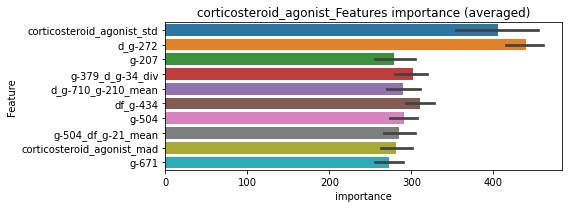

len(train_index) : 2836
len(valid_index) : 946
================================= fold 1/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.089321	valid_1's binary_logloss: 0.133531
[200]	training's binary_logloss: 0.0280734	valid_1's binary_logloss: 0.0644203
[300]	training's binary_logloss: 0.0102393	valid_1's binary_logloss: 0.0368645
[400]	training's binary_logloss: 0.00436729	valid_1's binary_logloss: 0.0244361
[500]	training's binary_logloss: 0.0022505	valid_1's binary_logloss: 0.0181854
[600]	training's binary_logloss: 0.00138481	valid_1's binary_logloss: 0.0146996
[700]	training's binary_logloss: 0.000973798	valid_1's binary_logloss: 0.0123537
[800]	training's binary_logloss: 0.000761798	valid_1's binary_logloss: 0.011261
[900]	training's binary_logloss: 0.000636227	valid_1's binary_logloss: 0.0105095
[1000]	training's binary_logloss: 0.0005716	valid_1's binary_logloss: 0.0101806
[1100]	training's binary_logloss: 0.000552651	valid_1's binary_logloss: 0.0100467
Early stopping, best iteration is:
[1100]	training's binary_l

len(train_index) : 2836
len(valid_index) : 946
================================= fold 2/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881895	valid_1's binary_logloss: 0.119263
[200]	training's binary_logloss: 0.0269032	valid_1's binary_logloss: 0.054347
[300]	training's binary_logloss: 0.00971284	valid_1's binary_logloss: 0.0315758
[400]	training's binary_logloss: 0.00410167	valid_1's binary_logloss: 0.0226076
[500]	training's binary_logloss: 0.00214948	valid_1's binary_logloss: 0.0192552
[600]	training's binary_logloss: 0.00134892	valid_1's binary_logloss: 0.0172782
[700]	training's binary_logloss: 0.000954153	valid_1's binary_logloss: 0.0162044
[800]	training's binary_logloss: 0.000743335	valid_1's binary_logloss: 0.0154904
[900]	training's binary_logloss: 0.000621838	valid_1's binary_logloss: 0.0150365
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000614581	valid_1's binary_logloss: 0.0149829


len(train_index) : 2837
len(valid_index) : 945
================================= fold 3/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0889059	valid_1's binary_logloss: 0.12405
[200]	training's binary_logloss: 0.0282707	valid_1's binary_logloss: 0.0578266
[300]	training's binary_logloss: 0.0104973	valid_1's binary_logloss: 0.0326198
[400]	training's binary_logloss: 0.00435687	valid_1's binary_logloss: 0.0211414
[500]	training's binary_logloss: 0.00223933	valid_1's binary_logloss: 0.0161882
[600]	training's binary_logloss: 0.00138846	valid_1's binary_logloss: 0.0137232
[700]	training's binary_logloss: 0.000979158	valid_1's binary_logloss: 0.0122537
[800]	training's binary_logloss: 0.000766977	valid_1's binary_logloss: 0.0113559
[900]	training's binary_logloss: 0.00064753	valid_1's binary_logloss: 0.0108766
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000623387	valid_1's binary_logloss: 0.0107541


len(train_index) : 2837
len(valid_index) : 945
================================= fold 4/4 corticosteroid_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901904	valid_1's binary_logloss: 0.118161
[200]	training's binary_logloss: 0.0287992	valid_1's binary_logloss: 0.0528584
[300]	training's binary_logloss: 0.0106733	valid_1's binary_logloss: 0.0295665
[400]	training's binary_logloss: 0.00449262	valid_1's binary_logloss: 0.019418
[500]	training's binary_logloss: 0.00227145	valid_1's binary_logloss: 0.0148173
[600]	training's binary_logloss: 0.00141075	valid_1's binary_logloss: 0.0122333
[700]	training's binary_logloss: 0.000997793	valid_1's binary_logloss: 0.011025
[800]	training's binary_logloss: 0.000780725	valid_1's binary_logloss: 0.0103011
[900]	training's binary_logloss: 0.000651516	valid_1's binary_logloss: 0.00983224
[1000]	training's binary_logloss: 0.000584689	valid_1's binary_logloss: 0.0095723
Early stopping, best iteration is:
[1011]	training's binary_logloss: 0.000577631	valid_1's binary_logloss: 0.00954734


corticosteroid_agonist logloss: 0.0113334044810476


neg labels: 3289 → selected neg labels: 3235


cyclooxygenase_inhibitor, len(trt): 435, len(othr): 3235, target_rate: 0.0182666 → Adj_target_rate: 0.0146863
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.282902	valid_1's binary_logloss: 0.413102
[200]	training's binary_logloss: 0.200787	valid_1's binary_logloss: 0.40269
[300]	training's binary_logloss: 0.143761	valid_1's binary_logloss: 0.39629
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.140185	valid_1's binary_logloss: 0.395529
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.284748	valid_1's binary_logloss: 0.418377
[200]	training's binary_logloss: 0.196846	valid_1's binary_logloss: 0.408969
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.157349	valid_1's binary_logloss: 0.402927
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.280426	valid_1's binary_logloss: 0.418333
[200]	training's binary_logloss: 0.192717	valid_1's binary_logloss: 0.405578
Early stopping, best iteration is:
[264]	training's bina

1 / 3 AUC score:0.708
y_Threshold: 0.1764910, Threshold: 0.4213089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 802 → Positive_corect_labels: 311/3080
p_label_rate: 0.0100452 Vs.target_rate: 0.01827, Num_p_label: 40.0, conf_0:0.29492, conf_1:0.54770
Num_p_label: 40.0, Expected: 72.7, Adj_threshold_1: 0.4213089
Num_p_label: 59.0, Expected: 72.7, Adj_threshold_2: 0.3913089
threshold: 0.3913089, positive_p_label: 59.0/3982, p_label_rate: 0.0148167


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.156384	valid_1's binary_logloss: 0.393054


positive_y_label: 311.0/3080, y_label_rate: 0.1009740
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113008	valid_1's binary_logloss: 0.212581
[200]	training's binary_logloss: 0.0550749	valid_1's binary_logloss: 0.186038
[300]	training's binary_logloss: 0.0292572	valid_1's binary_logloss: 0.177933
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0246414	valid_1's binary_logloss: 0.176452
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108381	valid_1's binary_logloss: 0.212226
[200]	training's binary_logloss: 0.0501059	valid_1's binary_logloss: 0.189056
[300]	training's binary_logloss: 0.0256335	valid_1's binary_logloss: 0.184272
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.0236067	valid_1's binary_logloss: 0.183616
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114809	valid_1's binary_logloss: 0.202031
[200]	training's binary_logloss: 0.0537678	valid

2 / 3 AUC score:0.938
y_Threshold: 0.1169406, Threshold: 0.3913089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 170 → Positive_corect_labels: 226.0/2910
p_label_rate: 0.0344048 Vs.target_rate: 0.01827, Num_p_label: 137.0, conf_0:0.31305, conf_1:0.46957


Early stopping, best iteration is:
[409]	training's binary_logloss: 0.0154783	valid_1's binary_logloss: 0.170279


Num_p_label: 137.0, Expected: 72.7, Adj_threshold_1: 0.3913089
Num_p_label: 115.0, Expected: 72.7, Adj_threshold_2: 0.4413089
Num_p_label: 98.0, Expected: 72.7, Adj_threshold_3: 0.4913089
threshold: 0.4913089, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 226.0/2910, y_label_rate: 0.0776632
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0675077	valid_1's binary_logloss: 0.151391
[200]	training's binary_logloss: 0.0260153	valid_1's binary_logloss: 0.131997
[300]	training's binary_logloss: 0.0118673	valid_1's binary_logloss: 0.128839
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0132448	valid_1's binary_logloss: 0.127772
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0680938	valid_1's binary_logloss: 0.151018
[200]	training's binary_logloss: 0.0261609	valid_1's binary_logloss: 0.124053
[300]	training's binary_logloss: 0.0115892	valid_1's binary_logloss: 0.113283
[400]	training's binary_logloss: 0.00570107	valid_1's binary_logloss: 0.10867
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00588413	valid_1's binary_logloss: 0.108255
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0668678	v

3 / 3 AUC score:0.959
y_Threshold: 0.0965589, Threshold: 0.4913089, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00457555	valid_1's binary_logloss: 0.117132


Remove_noisy_data: 86 → Positive_corect_labels: 183.0/2824
p_label_rate: 0.0379206 Vs.target_rate: 0.01827, Num_p_label: 151.0, conf_0:0.44218, conf_1:0.54044
Num_p_label: 151.0, Expected: 72.7, Adj_threshold_1: 0.4913089
Num_p_label: 142.0, Expected: 72.7, Adj_threshold_2: 0.5413089
Num_p_label: 121.0, Expected: 72.7, Adj_threshold_3: 0.5913089
Num_p_label: 102.0, Expected: 72.7, Adj_threshold_4: 0.6413089
threshold: 0.6413089, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 183.0/2824, y_label_rate: 0.0648017


len(train_index) : 2118
len(valid_index) : 706
================================= fold 1/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0488785	valid_1's binary_logloss: 0.112005
[200]	training's binary_logloss: 0.0164904	valid_1's binary_logloss: 0.0938068
[300]	training's binary_logloss: 0.0067708	valid_1's binary_logloss: 0.0896558
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00628812	valid_1's binary_logloss: 0.0891375


len(train_index) : 2118
len(valid_index) : 706
================================= fold 2/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495811	valid_1's binary_logloss: 0.0899682
[200]	training's binary_logloss: 0.0165265	valid_1's binary_logloss: 0.0646879
[300]	training's binary_logloss: 0.0067248	valid_1's binary_logloss: 0.056144
[400]	training's binary_logloss: 0.0032928	valid_1's binary_logloss: 0.0528308
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00344245	valid_1's binary_logloss: 0.0527049


len(train_index) : 2118
len(valid_index) : 706
================================= fold 3/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0513028	valid_1's binary_logloss: 0.0999667
[200]	training's binary_logloss: 0.0179459	valid_1's binary_logloss: 0.0725769
[300]	training's binary_logloss: 0.00772547	valid_1's binary_logloss: 0.0621738
[400]	training's binary_logloss: 0.00406276	valid_1's binary_logloss: 0.0577062
[500]	training's binary_logloss: 0.00220452	valid_1's binary_logloss: 0.0564018
[600]	training's binary_logloss: 0.0014321	valid_1's binary_logloss: 0.0550804
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00138255	valid_1's binary_logloss: 0.0548774


len(train_index) : 2118
len(valid_index) : 706
================================= fold 4/4 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0493083	valid_1's binary_logloss: 0.0968331
[200]	training's binary_logloss: 0.0171465	valid_1's binary_logloss: 0.0746593
[300]	training's binary_logloss: 0.00735992	valid_1's binary_logloss: 0.0663436
[400]	training's binary_logloss: 0.00344659	valid_1's binary_logloss: 0.0629083


cyclooxygenase_inhibitor logloss: 0.06475519972035594


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00304927	valid_1's binary_logloss: 0.062301
neg labels: 3289 → selected neg labels: 3273


cytochrome_p450_inhibitor, len(trt): 104, len(othr): 3273, target_rate: 0.0043672 → Adj_target_rate: 0.0043519
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.160164	valid_1's binary_logloss: 0.260099
[200]	training's binary_logloss: 0.0811098	valid_1's binary_logloss: 0.194442
[300]	training's binary_logloss: 0.0441151	valid_1's binary_logloss: 0.158592
[400]	training's binary_logloss: 0.0242079	valid_1's binary_logloss: 0.139473
[500]	training's binary_logloss: 0.0137649	valid_1's binary_logloss: 0.126638
[600]	training's binary_logloss: 0.0081685	valid_1's binary_logloss: 0.121449
[700]	training's binary_logloss: 0.00516825	valid_1's binary_logloss: 0.118969
Early stopping, best iteration is:
[687]	training's binary_logloss: 0.00545023	valid_1's binary_logloss: 0.118816
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.15915	valid_1's binary_logloss: 0.25707
[200]	training's binary_logloss: 0.0799613	valid_1's binary_logloss: 0.193457
[300]	training's binary_logloss: 0.0437436	valid_1's binary_loglo

1 / 3 AUC score:0.983
y_Threshold: 0.0448710, Threshold: 0.2540991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 190 → Positive_corect_labels: 625/3737
p_label_rate: 0.0100452 Vs.target_rate: 0.00437, Num_p_label: 40.0, conf_0:0.17787, conf_1:0.33033
Num_p_label: 40.0, Expected: 17.4, Adj_threshold_1: 0.2540991
Num_p_label: 35.0, Expected: 17.4, Adj_threshold_2: 0.3040991
Num_p_label: 31.0, Expected: 17.4, Adj_threshold_3: 0.3540991
Num_p_label: 25.0, Expected: 17.4, Adj_threshold_4: 0.4040991
threshold: 0.4040991, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 625.0/3737, y_label_rate: 0.1672465
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145205	valid_1's binary_logloss: 0.211893
[200]	training's binary_logloss: 0.0678344	valid_1's binary_logloss: 0.143475
[300]	training's binary_logloss: 0.0338234	valid_1's binary_logloss: 0.107232
[400]	training's binary_logloss: 0.0176675	valid_1's binary_logloss: 0.0868174
[500]	training's binary_logloss: 0.00955855	valid_1's binary_logloss: 0.0763907
[600]	training's binary_logloss: 0.00549051	valid_1's binary_logloss: 0.0698967
[700]	training's binary_logloss: 0.00345919	valid_1's binary_logloss: 0.0659739
[800]	training's binary_logloss: 0.00241643	valid_1's binary_logloss: 0.0642907
[900]	training's binary_logloss: 0.00181402	valid_1's binary_logloss: 0.0634893
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.00171468	valid_1's binary_logloss: 0.0634294
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148541	valid_1's

2 / 3 AUC score:0.990
y_Threshold: 0.1160038, Threshold: 0.4040991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 582.0/3651
p_label_rate: 0.0198393 Vs.target_rate: 0.00437, Num_p_label: 79.0, conf_0:0.32328, conf_1:0.48492
Num_p_label: 79.0, Expected: 17.4, Adj_threshold_1: 0.4040991
Num_p_label: 74.0, Expected: 17.4, Adj_threshold_2: 0.4540991
Num_p_label: 67.0, Expected: 17.4, Adj_threshold_3: 0.5040991
Num_p_label: 62.0, Expected: 17.4, Adj_threshold_4: 0.5540991
Num_p_label: 58.0, Expected: 17.4, Adj_threshold_5: 0.6040991
Num_p_label: 55.0, Expected: 17.4, Adj_threshold_6: 0.6540991
Num_p_label: 49.0, Expected: 17.4, Adj_threshold_7: 0.7040991
Num_p_label: 44.0, Expected: 17.4, Adj_threshold_8: 0.7540991
threshold: 0.7540991, positive_p_label: 44.0/3982, p_label_rate: 0.0110497
positive_y_label: 582.0/3651, y_label_rate: 0.1594084
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12059	valid_1's binary_logloss: 0.190244
[200]	training's binary_logloss: 0.0510263	valid_1's binary_logloss: 0.12617
[300]	training's binary_logloss: 0.0237388	valid_1's binary_logloss: 0.0921704
[400]	training's binary_logloss: 0.0116902	valid_1's binary_logloss: 0.0730875
[500]	training's binary_logloss: 0.00617768	valid_1's binary_logloss: 0.0630229
[600]	training's binary_logloss: 0.0036275	valid_1's binary_logloss: 0.0574653
[700]	training's binary_logloss: 0.00237441	valid_1's binary_logloss: 0.0543798
[800]	training's binary_logloss: 0.00171685	valid_1's binary_logloss: 0.051764
[900]	training's binary_logloss: 0.00133698	valid_1's binary_logloss: 0.0504182
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.00128492	valid_1's binary_logloss: 0.0501395
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122148	valid_1's bi

3 / 3 AUC score:0.996
y_Threshold: 0.0895306, Threshold: 0.7540991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 560.0/3607
p_label_rate: 0.0200904 Vs.target_rate: 0.00437, Num_p_label: 80.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 80.0, Expected: 17.4, Adj_threshold_1: 0.7540991
threshold: 0.7540991, positive_p_label: 80.0/3982, p_label_rate: 0.0200904
positive_y_label: 560.0/3607, y_label_rate: 0.1552537


len(train_index) : 2705
len(valid_index) : 902
================================= fold 1/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111695	valid_1's binary_logloss: 0.188895
[200]	training's binary_logloss: 0.0453018	valid_1's binary_logloss: 0.129594
[300]	training's binary_logloss: 0.0210092	valid_1's binary_logloss: 0.104361
[400]	training's binary_logloss: 0.0107916	valid_1's binary_logloss: 0.0916557
[500]	training's binary_logloss: 0.005521	valid_1's binary_logloss: 0.0870847
[600]	training's binary_logloss: 0.00312872	valid_1's binary_logloss: 0.0844299
[700]	training's binary_logloss: 0.0020478	valid_1's binary_logloss: 0.0829296
Early stopping, best iteration is:
[707]	training's binary_logloss: 0.00199549	valid_1's binary_logloss: 0.082827


len(train_index) : 2705
len(valid_index) : 902
================================= fold 2/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11273	valid_1's binary_logloss: 0.17295
[200]	training's binary_logloss: 0.0453429	valid_1's binary_logloss: 0.108698
[300]	training's binary_logloss: 0.0204044	valid_1's binary_logloss: 0.0774163
[400]	training's binary_logloss: 0.00987375	valid_1's binary_logloss: 0.0604924
[500]	training's binary_logloss: 0.00518874	valid_1's binary_logloss: 0.0509937
[600]	training's binary_logloss: 0.00307632	valid_1's binary_logloss: 0.0454832
[700]	training's binary_logloss: 0.00205772	valid_1's binary_logloss: 0.042671
[800]	training's binary_logloss: 0.00151766	valid_1's binary_logloss: 0.0407231
[900]	training's binary_logloss: 0.00119982	valid_1's binary_logloss: 0.0388504
[1000]	training's binary_logloss: 0.0010209	valid_1's binary_logloss: 0.0382183
[1100]	training's binary_logloss: 0.00090447	valid_1's binary_logloss: 0.0376209
Early stopping, best iteration is:
[1107]	training's binary_logloss

len(train_index) : 2705
len(valid_index) : 902
================================= fold 3/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117564	valid_1's binary_logloss: 0.1658
[200]	training's binary_logloss: 0.0482366	valid_1's binary_logloss: 0.103145
[300]	training's binary_logloss: 0.0219655	valid_1's binary_logloss: 0.0749048
[400]	training's binary_logloss: 0.0102057	valid_1's binary_logloss: 0.0600579
[500]	training's binary_logloss: 0.00529529	valid_1's binary_logloss: 0.050543
[600]	training's binary_logloss: 0.00310971	valid_1's binary_logloss: 0.0458152
[700]	training's binary_logloss: 0.00207697	valid_1's binary_logloss: 0.0415698
[800]	training's binary_logloss: 0.00153739	valid_1's binary_logloss: 0.0403251
[900]	training's binary_logloss: 0.00121934	valid_1's binary_logloss: 0.0385723
[1000]	training's binary_logloss: 0.00103434	valid_1's binary_logloss: 0.0377677
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.000951779	valid_1's binary_logloss: 0.0375247


len(train_index) : 2706
len(valid_index) : 901
================================= fold 4/4 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109936	valid_1's binary_logloss: 0.184518
[200]	training's binary_logloss: 0.0409379	valid_1's binary_logloss: 0.119905
[300]	training's binary_logloss: 0.0185747	valid_1's binary_logloss: 0.0970614
[400]	training's binary_logloss: 0.00900884	valid_1's binary_logloss: 0.0851575
[500]	training's binary_logloss: 0.00479439	valid_1's binary_logloss: 0.0786091
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.00476549	valid_1's binary_logloss: 0.078505


cytochrome_p450_inhibitor logloss: 0.059112293776162374


neg labels: 3289 → selected neg labels: 3281


dihydrofolate_reductase_inhibitor, len(trt): 36, len(othr): 3281, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106584	valid_1's binary_logloss: 0.148926
[200]	training's binary_logloss: 0.0418435	valid_1's binary_logloss: 0.0795487
[300]	training's binary_logloss: 0.0167593	valid_1's binary_logloss: 0.0474663
[400]	training's binary_logloss: 0.00741759	valid_1's binary_logloss: 0.0332998
[500]	training's binary_logloss: 0.00373203	valid_1's binary_logloss: 0.025627
[600]	training's binary_logloss: 0.00221462	valid_1's binary_logloss: 0.0215499
[700]	training's binary_logloss: 0.00150996	valid_1's binary_logloss: 0.0194778
[800]	training's binary_logloss: 0.00113998	valid_1's binary_logloss: 0.0182511
[900]	training's binary_logloss: 0.000925992	valid_1's binary_logloss: 0.0173028
[1000]	training's binary_logloss: 0.000795545	valid_1's binary_logloss: 0.0167071
[1100]	training's binary_logloss: 0.000735005	valid_1's binary_logloss: 0.0164648
Early stopping, best iteration is:
[1147]	training's binary_

1 / 3 AUC score:1.000
y_Threshold: 0.0163607, Threshold: 0.1017690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07124, conf_1:0.13230
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1017690
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.1517690
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.2017690
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_4: 0.2517690
threshold: 0.2517690, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0992256	valid_1's binary_logloss: 0.139858
[200]	training's binary_logloss: 0.0348297	valid_1's binary_logloss: 0.0708636
[300]	training's binary_logloss: 0.0136381	valid_1's binary_logloss: 0.0436887
[400]	training's binary_logloss: 0.00582961	valid_1's binary_logloss: 0.0312958
[500]	training's binary_logloss: 0.00293509	valid_1's binary_logloss: 0.0244481
[600]	training's binary_logloss: 0.00178943	valid_1's binary_logloss: 0.021785
[700]	training's binary_logloss: 0.00125868	valid_1's binary_logloss: 0.0199333
[800]	training's binary_logloss: 0.000958554	valid_1's binary_logloss: 0.0186428
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.000878949	valid_1's binary_logloss: 0.0183711
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0998861	valid_1's binary_logloss: 0.130448
[200]	training's binary_logloss: 0.0337049	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1377791, Threshold: 0.2517690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0130588 Vs.target_rate: 0.00151, Num_p_label: 52.0, conf_0:0.20142, conf_1:0.30212
Num_p_label: 52.0, Expected: 6.0, Adj_threshold_1: 0.2517690
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_2: 0.3017690
Num_p_label: 38.0, Expected: 6.0, Adj_threshold_3: 0.3517690
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_4: 0.4017690
Num_p_label: 28.0, Expected: 6.0, Adj_threshold_5: 0.4517690
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_6: 0.5017690
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_7: 0.5517690
Num_p_label: 20.0, Expected: 6.0, Adj_threshold_8: 0.6017690
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_9: 0.6517690
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_10: 0.7017690
threshold: 0.7017690, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968634	valid_1's binary_logloss: 0.143076
[200]	training's binary_logloss: 0.0340444	valid_1's binary_logloss: 0.0710614
[300]	training's binary_logloss: 0.0129563	valid_1's binary_logloss: 0.042554
[400]	training's binary_logloss: 0.00562285	valid_1's binary_logloss: 0.0306541
[500]	training's binary_logloss: 0.00288099	valid_1's binary_logloss: 0.0247663
[600]	training's binary_logloss: 0.00174262	valid_1's binary_logloss: 0.0215822
[700]	training's binary_logloss: 0.00121696	valid_1's binary_logloss: 0.0200192
[800]	training's binary_logloss: 0.00092589	valid_1's binary_logloss: 0.0190513
[900]	training's binary_logloss: 0.000765958	valid_1's binary_logloss: 0.0187228
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000727304	valid_1's binary_logloss: 0.0184121
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985571	val

3 / 3 AUC score:1.000
y_Threshold: 0.1665233, Threshold: 0.7017690, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 645.0/3783
p_label_rate: 0.0045203 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.50000, conf_1:0.77195
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_1: 0.7017690
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_2: 0.7517690
threshold: 0.7517690, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 645.0/3783, y_label_rate: 0.1704996


len(train_index) : 2837
len(valid_index) : 946
================================= fold 1/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968029	valid_1's binary_logloss: 0.137309
[200]	training's binary_logloss: 0.0327154	valid_1's binary_logloss: 0.0654606
[300]	training's binary_logloss: 0.0129432	valid_1's binary_logloss: 0.0374913
[400]	training's binary_logloss: 0.00554924	valid_1's binary_logloss: 0.0241714
[500]	training's binary_logloss: 0.00282626	valid_1's binary_logloss: 0.0179752
[600]	training's binary_logloss: 0.00172431	valid_1's binary_logloss: 0.0145213
[700]	training's binary_logloss: 0.00120239	valid_1's binary_logloss: 0.0128339
[800]	training's binary_logloss: 0.000917884	valid_1's binary_logloss: 0.011707
[900]	training's binary_logloss: 0.000758219	valid_1's binary_logloss: 0.0112874
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000713656	valid_1's binary_logloss: 0.0111564


len(train_index) : 2837
len(valid_index) : 946
================================= fold 2/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10101	valid_1's binary_logloss: 0.128251
[200]	training's binary_logloss: 0.0335734	valid_1's binary_logloss: 0.0568644
[300]	training's binary_logloss: 0.0128822	valid_1's binary_logloss: 0.0301516
[400]	training's binary_logloss: 0.00560133	valid_1's binary_logloss: 0.0198361
[500]	training's binary_logloss: 0.00283453	valid_1's binary_logloss: 0.0150649
[600]	training's binary_logloss: 0.00172185	valid_1's binary_logloss: 0.0124506
[700]	training's binary_logloss: 0.00120448	valid_1's binary_logloss: 0.0112217
[800]	training's binary_logloss: 0.000921239	valid_1's binary_logloss: 0.0106226
[900]	training's binary_logloss: 0.000764172	valid_1's binary_logloss: 0.00994994
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000718527	valid_1's binary_logloss: 0.0098778


len(train_index) : 2837
len(valid_index) : 946
================================= fold 3/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0972728	valid_1's binary_logloss: 0.135448
[200]	training's binary_logloss: 0.033018	valid_1's binary_logloss: 0.0668172
[300]	training's binary_logloss: 0.013244	valid_1's binary_logloss: 0.0401127
[400]	training's binary_logloss: 0.00562515	valid_1's binary_logloss: 0.027106
[500]	training's binary_logloss: 0.00281336	valid_1's binary_logloss: 0.0210164
[600]	training's binary_logloss: 0.00172203	valid_1's binary_logloss: 0.0181251
[700]	training's binary_logloss: 0.00120391	valid_1's binary_logloss: 0.0164744
[800]	training's binary_logloss: 0.00092389	valid_1's binary_logloss: 0.015723
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.000851447	valid_1's binary_logloss: 0.0153434


len(train_index) : 2838
len(valid_index) : 945
================================= fold 4/4 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0980064	valid_1's binary_logloss: 0.142035
[200]	training's binary_logloss: 0.0322521	valid_1's binary_logloss: 0.0705764
[300]	training's binary_logloss: 0.0128391	valid_1's binary_logloss: 0.0428648
[400]	training's binary_logloss: 0.00543138	valid_1's binary_logloss: 0.0295513
[500]	training's binary_logloss: 0.00277434	valid_1's binary_logloss: 0.0238309
[600]	training's binary_logloss: 0.0016801	valid_1's binary_logloss: 0.0209346
[700]	training's binary_logloss: 0.00117086	valid_1's binary_logloss: 0.019199
[800]	training's binary_logloss: 0.000902518	valid_1's binary_logloss: 0.0183984
[900]	training's binary_logloss: 0.000741906	valid_1's binary_logloss: 0.0178071
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000731422	valid_1's binary_logloss: 0.0177193


dihydrofolate_reductase_inhibitor logloss: 0.013523130288020716


neg labels: 3289 → selected neg labels: 3285


dipeptidyl_peptidase_inhibitor, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0896048	valid_1's binary_logloss: 0.1144
[200]	training's binary_logloss: 0.0287097	valid_1's binary_logloss: 0.0479487
[300]	training's binary_logloss: 0.010184	valid_1's binary_logloss: 0.0237308
[400]	training's binary_logloss: 0.00414584	valid_1's binary_logloss: 0.0146878
[500]	training's binary_logloss: 0.00210666	valid_1's binary_logloss: 0.0108045
[600]	training's binary_logloss: 0.00131763	valid_1's binary_logloss: 0.00885389
[700]	training's binary_logloss: 0.000934922	valid_1's binary_logloss: 0.00790201
[800]	training's binary_logloss: 0.000730516	valid_1's binary_logloss: 0.0072116
[900]	training's binary_logloss: 0.000617277	valid_1's binary_logloss: 0.00688323
[1000]	training's binary_logloss: 0.000557219	valid_1's binary_logloss: 0.00668264
Early stopping, best iteration is:
[1049]	training's binary_logloss: 0.000544861	valid_1's binary_logloss: 0.00658499
Training until vali

1 / 3 AUC score:1.000
y_Threshold: 0.0074526, Threshold: 0.0442904, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03100, conf_1:0.05758
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0442904
Num_p_label: 29.0, Expected: 4.2, Adj_threshold_2: 0.0942904
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_3: 0.1442904
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.1942904
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_5: 0.2442904
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.2942904
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.3442904
threshold: 0.3442904, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843093	valid_1's binary_logloss: 0.1098
[200]	training's binary_logloss: 0.0246735	valid_1's binary_logloss: 0.0412077
[300]	training's binary_logloss: 0.00846044	valid_1's binary_logloss: 0.01889
[400]	training's binary_logloss: 0.00343484	valid_1's binary_logloss: 0.0101753
[500]	training's binary_logloss: 0.00177324	valid_1's binary_logloss: 0.00663874
[600]	training's binary_logloss: 0.00112781	valid_1's binary_logloss: 0.00505695
[700]	training's binary_logloss: 0.000810802	valid_1's binary_logloss: 0.00414044
[800]	training's binary_logloss: 0.000638442	valid_1's binary_logloss: 0.00360692
[900]	training's binary_logloss: 0.000541512	valid_1's binary_logloss: 0.003199
[1000]	training's binary_logloss: 0.000508329	valid_1's binary_logloss: 0.00312511
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000508329	valid_1's binary_logloss: 0.00312511
Training until valid

2 / 3 AUC score:1.000
y_Threshold: 0.1365306, Threshold: 0.3442904, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0062783 Vs.target_rate: 0.00105, Num_p_label: 25.0, conf_0:0.27543, conf_1:0.41315
Num_p_label: 25.0, Expected: 4.2, Adj_threshold_1: 0.3442904
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.3942904
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_3: 0.4442904
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_4: 0.4942904
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_5: 0.5442904
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_6: 0.5942904
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_7: 0.6442904
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_8: 0.6942904
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_9: 0.7442904
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_10: 0.7942904
threshold: 0.7942904, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843093	valid_1's binary_logloss: 0.1098
[200]	training's binary_logloss: 0.0246735	valid_1's binary_logloss: 0.0412077
[300]	training's binary_logloss: 0.00846044	valid_1's binary_logloss: 0.01889
[400]	training's binary_logloss: 0.00343484	valid_1's binary_logloss: 0.0101753
[500]	training's binary_logloss: 0.00177324	valid_1's binary_logloss: 0.00663874
[600]	training's binary_logloss: 0.00112781	valid_1's binary_logloss: 0.00505695
[700]	training's binary_logloss: 0.000810802	valid_1's binary_logloss: 0.00414044
[800]	training's binary_logloss: 0.000638442	valid_1's binary_logloss: 0.00360692
[900]	training's binary_logloss: 0.000541512	valid_1's binary_logloss: 0.003199
[1000]	training's binary_logloss: 0.000508329	valid_1's binary_logloss: 0.00312511
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000508329	valid_1's binary_logloss: 0.00312511
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.1365306, Threshold: 0.7942904, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0022602 Vs.target_rate: 0.00105, Num_p_label: 9.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_1: 0.7942904
threshold: 0.7942904, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


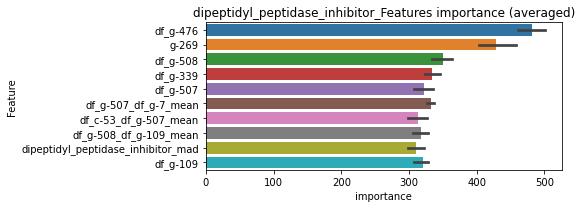

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0847878	valid_1's binary_logloss: 0.107767
[200]	training's binary_logloss: 0.0243536	valid_1's binary_logloss: 0.0399269
[300]	training's binary_logloss: 0.00858527	valid_1's binary_logloss: 0.01822
[400]	training's binary_logloss: 0.0034907	valid_1's binary_logloss: 0.00971102
[500]	training's binary_logloss: 0.0017935	valid_1's binary_logloss: 0.00617459
[600]	training's binary_logloss: 0.00112861	valid_1's binary_logloss: 0.00461331
[700]	training's binary_logloss: 0.000808393	valid_1's binary_logloss: 0.00379696
[800]	training's binary_logloss: 0.000640438	valid_1's binary_logloss: 0.00327186
[900]	training's binary_logloss: 0.000548556	valid_1's binary_logloss: 0.0029988
[1000]	training's binary_logloss: 0.000519051	valid_1's binary_logloss: 0.0029109
Early stopping, best iteration is:
[971]	training's binary_logloss: 0.000519184	valid_1's binary_logloss: 0.00291053


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851391	valid_1's binary_logloss: 0.115195
[200]	training's binary_logloss: 0.0249831	valid_1's binary_logloss: 0.0430412
[300]	training's binary_logloss: 0.00857037	valid_1's binary_logloss: 0.0193697
[400]	training's binary_logloss: 0.00347359	valid_1's binary_logloss: 0.0103727
[500]	training's binary_logloss: 0.00178413	valid_1's binary_logloss: 0.00676166
[600]	training's binary_logloss: 0.00111417	valid_1's binary_logloss: 0.00499824
[700]	training's binary_logloss: 0.000802967	valid_1's binary_logloss: 0.00418973
[800]	training's binary_logloss: 0.000639025	valid_1's binary_logloss: 0.00373447
[900]	training's binary_logloss: 0.00054266	valid_1's binary_logloss: 0.00340849
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000515112	valid_1's binary_logloss: 0.00332996


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844976	valid_1's binary_logloss: 0.106622
[200]	training's binary_logloss: 0.0243189	valid_1's binary_logloss: 0.0382772
[300]	training's binary_logloss: 0.00825024	valid_1's binary_logloss: 0.0166369
[400]	training's binary_logloss: 0.00334795	valid_1's binary_logloss: 0.00875557
[500]	training's binary_logloss: 0.00173787	valid_1's binary_logloss: 0.00555542
[600]	training's binary_logloss: 0.00110558	valid_1's binary_logloss: 0.00411323
[700]	training's binary_logloss: 0.000803465	valid_1's binary_logloss: 0.00334219
[800]	training's binary_logloss: 0.000639029	valid_1's binary_logloss: 0.00287362
[900]	training's binary_logloss: 0.000551345	valid_1's binary_logloss: 0.00263137
[1000]	training's binary_logloss: 0.000512647	valid_1's binary_logloss: 0.00254518
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000512692	valid_1's binary_logloss: 0.00254501


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0836039	valid_1's binary_logloss: 0.1093
[200]	training's binary_logloss: 0.0242545	valid_1's binary_logloss: 0.0406403
[300]	training's binary_logloss: 0.00806672	valid_1's binary_logloss: 0.01804
[400]	training's binary_logloss: 0.00329997	valid_1's binary_logloss: 0.00998543
[500]	training's binary_logloss: 0.00169851	valid_1's binary_logloss: 0.0068925
[600]	training's binary_logloss: 0.00107354	valid_1's binary_logloss: 0.00543732
[700]	training's binary_logloss: 0.000783785	valid_1's binary_logloss: 0.00472675
[800]	training's binary_logloss: 0.000621617	valid_1's binary_logloss: 0.00425952
[900]	training's binary_logloss: 0.000529917	valid_1's binary_logloss: 0.00400975
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000533706	valid_1's binary_logloss: 0.00399742


dipeptidyl_peptidase_inhibitor logloss: 0.0031958221637329413


neg labels: 3289 → selected neg labels: 3289


diuretic, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0580679	valid_1's binary_logloss: 0.0640784
[200]	training's binary_logloss: 0.0114696	valid_1's binary_logloss: 0.0147679
[300]	training's binary_logloss: 0.00275071	valid_1's binary_logloss: 0.0044745
[400]	training's binary_logloss: 0.00101611	valid_1's binary_logloss: 0.00195673
[500]	training's binary_logloss: 0.000539158	valid_1's binary_logloss: 0.00118621
[600]	training's binary_logloss: 0.000363941	valid_1's binary_logloss: 0.000892411
[700]	training's binary_logloss: 0.000291297	valid_1's binary_logloss: 0.000752992
[800]	training's binary_logloss: 0.0002723	valid_1's binary_logloss: 0.000712289
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.000267419	valid_1's binary_logloss: 0.000702839
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0567837	valid_1's binary_logloss: 0.062897
[200]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0013461, Threshold: 0.0043431, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00304, conf_1:0.00565
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0043431
Num_p_label: 0.0, Expected: 1.0, Adj_threshold_2: 0.0543431
threshold: 0.0543431, positive_p_label: 0.0/3982, p_label_rate: 0.0000000
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0546817	valid_1's binary_logloss: 0.0597727
[200]	training's binary_logloss: 0.010325	valid_1's binary_logloss: 0.013326
[300]	training's binary_logloss: 0.00253646	valid_1's binary_logloss: 0.00412766
[400]	training's binary_logloss: 0.00092818	valid_1's binary_logloss: 0.00174079
[500]	training's binary_logloss: 0.000494315	valid_1's binary_logloss: 0.00102441
[600]	training's binary_logloss: 0.000334792	valid_1's binary_logloss: 0.000722249
[700]	training's binary_logloss: 0.000270299	valid_1's binary_logloss: 0.000608029
[800]	training's binary_logloss: 0.00025166	valid_1's binary_logloss: 0.000577498
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000249887	valid_1's binary_logloss: 0.000575995
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0548144	valid_1's binary_logloss: 0.0572334
[200]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1558254, Threshold: 0.0543431, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0040181 Vs.target_rate: 0.00025, Num_p_label: 16.0, conf_0:0.04347, conf_1:0.06521
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_1: 0.0543431
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.1043431
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.1543431
threshold: 0.1543431, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0546817	valid_1's binary_logloss: 0.0597727
[200]	training's binary_logloss: 0.010325	valid_1's binary_logloss: 0.013326
[300]	training's binary_logloss: 0.00253646	valid_1's binary_logloss: 0.00412766
[400]	training's binary_logloss: 0.00092818	valid_1's binary_logloss: 0.00174079
[500]	training's binary_logloss: 0.000494315	valid_1's binary_logloss: 0.00102441
[600]	training's binary_logloss: 0.000334792	valid_1's binary_logloss: 0.000722249
[700]	training's binary_logloss: 0.000270299	valid_1's binary_logloss: 0.000608029
[800]	training's binary_logloss: 0.00025166	valid_1's binary_logloss: 0.000577498
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000249887	valid_1's binary_logloss: 0.000575995
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0548144	valid_1's binary_logloss: 0.0572334
[200]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1558254, Threshold: 0.1543431, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.13891, conf_1:0.16978
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.1543431
threshold: 0.1543431, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


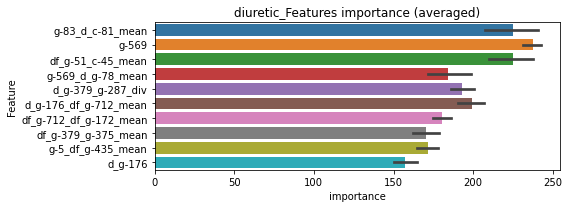

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0540908	valid_1's binary_logloss: 0.05909
[200]	training's binary_logloss: 0.0101762	valid_1's binary_logloss: 0.0131079
[300]	training's binary_logloss: 0.00251299	valid_1's binary_logloss: 0.00391707
[400]	training's binary_logloss: 0.000926255	valid_1's binary_logloss: 0.00167359
[500]	training's binary_logloss: 0.000495926	valid_1's binary_logloss: 0.000964068
[600]	training's binary_logloss: 0.000337368	valid_1's binary_logloss: 0.000691118
[700]	training's binary_logloss: 0.000268922	valid_1's binary_logloss: 0.000578625
[800]	training's binary_logloss: 0.000254182	valid_1's binary_logloss: 0.000562253
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000254182	valid_1's binary_logloss: 0.000562253


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0545278	valid_1's binary_logloss: 0.0578382
[200]	training's binary_logloss: 0.0106618	valid_1's binary_logloss: 0.0123957
[300]	training's binary_logloss: 0.00275512	valid_1's binary_logloss: 0.00381097
[400]	training's binary_logloss: 0.00105767	valid_1's binary_logloss: 0.0017256
[500]	training's binary_logloss: 0.000518205	valid_1's binary_logloss: 0.000944087
[600]	training's binary_logloss: 0.000334599	valid_1's binary_logloss: 0.000624219
[700]	training's binary_logloss: 0.00025943	valid_1's binary_logloss: 0.000497867
[800]	training's binary_logloss: 0.000239205	valid_1's binary_logloss: 0.000474125
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000238104	valid_1's binary_logloss: 0.000471424


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0538309	valid_1's binary_logloss: 0.0568441
[200]	training's binary_logloss: 0.0100868	valid_1's binary_logloss: 0.0116609
[300]	training's binary_logloss: 0.00247063	valid_1's binary_logloss: 0.0032134
[400]	training's binary_logloss: 0.000919307	valid_1's binary_logloss: 0.00132929
[500]	training's binary_logloss: 0.000487345	valid_1's binary_logloss: 0.000764453
[600]	training's binary_logloss: 0.000331531	valid_1's binary_logloss: 0.000541219
[700]	training's binary_logloss: 0.000265703	valid_1's binary_logloss: 0.00044385
[800]	training's binary_logloss: 0.000250315	valid_1's binary_logloss: 0.000423117
[900]	training's binary_logloss: 0.000248926	valid_1's binary_logloss: 0.000421452
Early stopping, best iteration is:
[876]	training's binary_logloss: 0.000248926	valid_1's binary_logloss: 0.000421452


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 diuretic=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0543969	valid_1's binary_logloss: 0.0588683
[200]	training's binary_logloss: 0.0102986	valid_1's binary_logloss: 0.0125774
[300]	training's binary_logloss: 0.0025096	valid_1's binary_logloss: 0.00363896
[400]	training's binary_logloss: 0.000923996	valid_1's binary_logloss: 0.00158138
[500]	training's binary_logloss: 0.000489665	valid_1's binary_logloss: 0.000913346
[600]	training's binary_logloss: 0.000331222	valid_1's binary_logloss: 0.000674763
[700]	training's binary_logloss: 0.000264522	valid_1's binary_logloss: 0.000563446
[800]	training's binary_logloss: 0.000250247	valid_1's binary_logloss: 0.000542412
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.000249146	valid_1's binary_logloss: 0.000541045


diuretic logloss: 0.0004990599593296478


neg labels: 3289 → selected neg labels: 3280


dna_alkylating_agent, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110157	valid_1's binary_logloss: 0.166714
[200]	training's binary_logloss: 0.0424856	valid_1's binary_logloss: 0.0975259
[300]	training's binary_logloss: 0.0190316	valid_1's binary_logloss: 0.0683335
[400]	training's binary_logloss: 0.00859101	valid_1's binary_logloss: 0.0495961
[500]	training's binary_logloss: 0.00430689	valid_1's binary_logloss: 0.0400646
[600]	training's binary_logloss: 0.00254348	valid_1's binary_logloss: 0.0350767
[700]	training's binary_logloss: 0.00169584	valid_1's binary_logloss: 0.0321233
[800]	training's binary_logloss: 0.00126073	valid_1's binary_logloss: 0.0305325
[900]	training's binary_logloss: 0.00100904	valid_1's binary_logloss: 0.0296905
[1000]	training's binary_logloss: 0.000853577	valid_1's binary_logloss: 0.0292462
Early stopping, best iteration is:
[1055]	training's binary_logloss: 0.000796874	valid_1's binary_logloss: 0.0288619
Training until validation

1 / 3 AUC score:0.997
y_Threshold: 0.0231663, Threshold: 0.1797552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.12583, conf_1:0.23368
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1797552
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.2297552
Num_p_label: 28.0, Expected: 8.0, Adj_threshold_3: 0.2797552
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_4: 0.3297552
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_5: 0.3797552
threshold: 0.3797552, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108978	valid_1's binary_logloss: 0.152622
[200]	training's binary_logloss: 0.038353	valid_1's binary_logloss: 0.0764186
[300]	training's binary_logloss: 0.0148396	valid_1's binary_logloss: 0.0431071
[400]	training's binary_logloss: 0.00647607	valid_1's binary_logloss: 0.0277966
[500]	training's binary_logloss: 0.00329683	valid_1's binary_logloss: 0.0203677
[600]	training's binary_logloss: 0.00199262	valid_1's binary_logloss: 0.0163608
[700]	training's binary_logloss: 0.0013569	valid_1's binary_logloss: 0.01427
[800]	training's binary_logloss: 0.0010316	valid_1's binary_logloss: 0.0130666
[900]	training's binary_logloss: 0.000838094	valid_1's binary_logloss: 0.0121955
[1000]	training's binary_logloss: 0.000727679	valid_1's binary_logloss: 0.0117401
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000709006	valid_1's binary_logloss: 0.01165
Training until validation score

2 / 3 AUC score:0.999
y_Threshold: 0.1599550, Threshold: 0.3797552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 641.0/3774
p_label_rate: 0.0145655 Vs.target_rate: 0.00202, Num_p_label: 58.0, conf_0:0.30380, conf_1:0.45571
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_1: 0.3797552
Num_p_label: 50.0, Expected: 8.0, Adj_threshold_2: 0.4297552
Num_p_label: 41.0, Expected: 8.0, Adj_threshold_3: 0.4797552
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_4: 0.5297552
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_5: 0.5797552
Num_p_label: 31.0, Expected: 8.0, Adj_threshold_6: 0.6297552
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_7: 0.6797552
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_8: 0.7297552
Num_p_label: 14.0, Expected: 8.0, Adj_threshold_9: 0.7797552
threshold: 0.7797552, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 641.0/3774, y_label_rate: 0.1698463
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0989121	valid_1's binary_logloss: 0.142588
[200]	training's binary_logloss: 0.034487	valid_1's binary_logloss: 0.0713275
[300]	training's binary_logloss: 0.0136933	valid_1's binary_logloss: 0.0430656
[400]	training's binary_logloss: 0.00599962	valid_1's binary_logloss: 0.030141
[500]	training's binary_logloss: 0.00305396	valid_1's binary_logloss: 0.0241801
[600]	training's binary_logloss: 0.00183628	valid_1's binary_logloss: 0.0212585
[700]	training's binary_logloss: 0.00126021	valid_1's binary_logloss: 0.0192837
[800]	training's binary_logloss: 0.000957835	valid_1's binary_logloss: 0.0183855
[900]	training's binary_logloss: 0.000785573	valid_1's binary_logloss: 0.0178593
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000779976	valid_1's binary_logloss: 0.0178265
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102162	vali

3 / 3 AUC score:0.999
y_Threshold: 0.1051234, Threshold: 0.7797552, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 628.0/3748
p_label_rate: 0.0062783 Vs.target_rate: 0.00202, Num_p_label: 25.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_1: 0.7797552
threshold: 0.7797552, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 628.0/3748, y_label_rate: 0.1675560


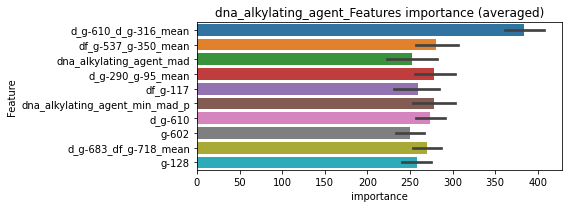

len(train_index) : 2811
len(valid_index) : 937
================================= fold 1/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096441	valid_1's binary_logloss: 0.128626
[200]	training's binary_logloss: 0.0328411	valid_1's binary_logloss: 0.0599129
[300]	training's binary_logloss: 0.0127906	valid_1's binary_logloss: 0.0338181
[400]	training's binary_logloss: 0.00561027	valid_1's binary_logloss: 0.0218968
[500]	training's binary_logloss: 0.00284345	valid_1's binary_logloss: 0.0155533
[600]	training's binary_logloss: 0.00171671	valid_1's binary_logloss: 0.012329
[700]	training's binary_logloss: 0.00119491	valid_1's binary_logloss: 0.0104785
[800]	training's binary_logloss: 0.000911347	valid_1's binary_logloss: 0.00922704
[900]	training's binary_logloss: 0.000747928	valid_1's binary_logloss: 0.00847684
[1000]	training's binary_logloss: 0.000658977	valid_1's binary_logloss: 0.00813647
[1100]	training's binary_logloss: 0.000613318	valid_1's binary_logloss: 0.00793471
Early stopping, best iteration is:
[1113]	training's bi

len(train_index) : 2811
len(valid_index) : 937
================================= fold 2/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0971748	valid_1's binary_logloss: 0.149674
[200]	training's binary_logloss: 0.0325829	valid_1's binary_logloss: 0.0812489
[300]	training's binary_logloss: 0.0124254	valid_1's binary_logloss: 0.0542259
[400]	training's binary_logloss: 0.00548787	valid_1's binary_logloss: 0.0432842
[500]	training's binary_logloss: 0.00280632	valid_1's binary_logloss: 0.0380781
[600]	training's binary_logloss: 0.00168496	valid_1's binary_logloss: 0.0359064
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.00138736	valid_1's binary_logloss: 0.0354216


len(train_index) : 2811
len(valid_index) : 937
================================= fold 3/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0962044	valid_1's binary_logloss: 0.13143
[200]	training's binary_logloss: 0.0319812	valid_1's binary_logloss: 0.0630625
[300]	training's binary_logloss: 0.0122365	valid_1's binary_logloss: 0.0361075
[400]	training's binary_logloss: 0.00532398	valid_1's binary_logloss: 0.0248458
[500]	training's binary_logloss: 0.0027064	valid_1's binary_logloss: 0.0191205
[600]	training's binary_logloss: 0.00165594	valid_1's binary_logloss: 0.0168234
[700]	training's binary_logloss: 0.00115931	valid_1's binary_logloss: 0.0155375
[800]	training's binary_logloss: 0.000896586	valid_1's binary_logloss: 0.0148811
[900]	training's binary_logloss: 0.000741659	valid_1's binary_logloss: 0.0142699
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000699469	valid_1's binary_logloss: 0.014023


len(train_index) : 2811
len(valid_index) : 937
================================= fold 4/4 dna_alkylating_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0984063	valid_1's binary_logloss: 0.142233
[200]	training's binary_logloss: 0.0333503	valid_1's binary_logloss: 0.0783672
[300]	training's binary_logloss: 0.0129689	valid_1's binary_logloss: 0.05793
[400]	training's binary_logloss: 0.00544463	valid_1's binary_logloss: 0.049548
[500]	training's binary_logloss: 0.00274482	valid_1's binary_logloss: 0.0475863
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00237388	valid_1's binary_logloss: 0.0470066


dna_alkylating_agent logloss: 0.026090863710973296


neg labels: 3289 → selected neg labels: 3248


dna_inhibitor, len(trt): 402, len(othr): 3248, target_rate: 0.0168808 → Adj_target_rate: 0.0137338
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.256145	valid_1's binary_logloss: 0.402987
[200]	training's binary_logloss: 0.161301	valid_1's binary_logloss: 0.384448
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.123654	valid_1's binary_logloss: 0.378973
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.255561	valid_1's binary_logloss: 0.401293
[200]	training's binary_logloss: 0.164283	valid_1's binary_logloss: 0.386485
[300]	training's binary_logloss: 0.113002	valid_1's binary_logloss: 0.378844
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.103963	valid_1's binary_logloss: 0.378601
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.253734	valid_1's binary_logloss: 0.391199
[200]	training's binary_logloss: 0.167077	valid_1's binary_logloss: 0.375706
[300]	training's binary_logloss: 0.11328	valid_1's bin

1 / 3 AUC score:0.770
y_Threshold: 0.1562273, Threshold: 0.4877017, pos_neg_ratio: 0.8000000
Remove_noisy_data: 717 → Positive_corect_labels: 356/3180
p_label_rate: 0.0100452 Vs.target_rate: 0.01688, Num_p_label: 40.0, conf_0:0.34139, conf_1:0.63401
Num_p_label: 40.0, Expected: 67.2, Adj_threshold_1: 0.4877017
Num_p_label: 50.0, Expected: 67.2, Adj_threshold_2: 0.4577017
threshold: 0.4577017, positive_p_label: 50.0/3982, p_label_rate: 0.0125565
positive_y_label: 356.0/3180, y_label_rate: 0.1119497
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121933	valid_1's binary_logloss: 0.219735
[200]	training's binary_logloss: 0.0540773	valid_1's binary_logloss: 0.187019
[300]	training's binary_logloss: 0.0276538	valid_1's binary_logloss: 0.17875
[400]	training's binary_logloss: 0.0147925	valid_1's binary_logloss: 0.176296
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0175616	valid_1's binary_logloss: 0.175525
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123535	valid_1's binary_logloss: 0.229043
[200]	training's binary_logloss: 0.0555844	valid_1's binary_logloss: 0.194353
[300]	training's binary_logloss: 0.0273555	valid_1's binary_logloss: 0.183467
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0206167	valid_1's binary_logloss: 0.180452
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125654	valid_

2 / 3 AUC score:0.942
y_Threshold: 0.1004267, Threshold: 0.4577017, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[426]	training's binary_logloss: 0.01311	valid_1's binary_logloss: 0.1721


Remove_noisy_data: 164 → Positive_corect_labels: 274.0/3016
p_label_rate: 0.0344048 Vs.target_rate: 0.01688, Num_p_label: 137.0, conf_0:0.36616, conf_1:0.54924
Num_p_label: 137.0, Expected: 67.2, Adj_threshold_1: 0.4577017
Num_p_label: 126.0, Expected: 67.2, Adj_threshold_2: 0.5077017
Num_p_label: 105.0, Expected: 67.2, Adj_threshold_3: 0.5577017
Num_p_label: 90.0, Expected: 67.2, Adj_threshold_4: 0.6077017
threshold: 0.6077017, positive_p_label: 90.0/3982, p_label_rate: 0.0226017
positive_y_label: 274.0/3016, y_label_rate: 0.0908488
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.080934	valid_1's binary_logloss: 0.158301
[200]	training's binary_logloss: 0.030618	valid_1's binary_logloss: 0.125105
[300]	training's binary_logloss: 0.0135242	valid_1's binary_logloss: 0.114046
[400]	training's binary_logloss: 0.00666137	valid_1's binary_logloss: 0.11048
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00799793	valid_1's binary_logloss: 0.110245
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0791039	valid_1's binary_logloss: 0.169734
[200]	training's binary_logloss: 0.0294736	valid_1's binary_logloss: 0.145185
[300]	training's binary_logloss: 0.0127605	valid_1's binary_logloss: 0.140782
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0138434	valid_1's binary_logloss: 0.1401
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842673	valid

3 / 3 AUC score:0.985
y_Threshold: 0.0790512, Threshold: 0.6077017, pos_neg_ratio: 0.8000000
Remove_noisy_data: 78 → Positive_corect_labels: 235.0/2938
p_label_rate: 0.0386740 Vs.target_rate: 0.01688, Num_p_label: 154.0, conf_0:0.50000, conf_1:0.66847
Num_p_label: 154.0, Expected: 67.2, Adj_threshold_1: 0.6077017


[400]	training's binary_logloss: 0.00700141	valid_1's binary_logloss: 0.11668
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00820733	valid_1's binary_logloss: 0.116567


Num_p_label: 140.0, Expected: 67.2, Adj_threshold_2: 0.6577017
Num_p_label: 130.0, Expected: 67.2, Adj_threshold_3: 0.7077017
Num_p_label: 112.0, Expected: 67.2, Adj_threshold_4: 0.7577017
threshold: 0.7577017, positive_p_label: 112.0/3982, p_label_rate: 0.0281266
positive_y_label: 235.0/2938, y_label_rate: 0.0799864


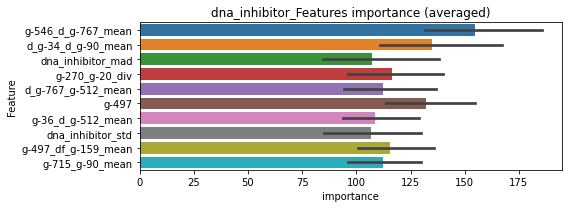

len(train_index) : 2203
len(valid_index) : 735
================================= fold 1/4 dna_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.063808	valid_1's binary_logloss: 0.126342
[200]	training's binary_logloss: 0.0219028	valid_1's binary_logloss: 0.103718
[300]	training's binary_logloss: 0.00924036	valid_1's binary_logloss: 0.101106


len(train_index) : 2203
len(valid_index) : 735
================================= fold 2/4 dna_inhibitor=================================


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00750267	valid_1's binary_logloss: 0.100548
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0619139	valid_1's binary_logloss: 0.138734
[200]	training's binary_logloss: 0.0209089	valid_1's binary_logloss: 0.118524
[300]	training's binary_logloss: 0.00873392	valid_1's binary_logloss: 0.109887


len(train_index) : 2204
len(valid_index) : 734
================================= fold 3/4 dna_inhibitor=================================


[400]	training's binary_logloss: 0.00423854	valid_1's binary_logloss: 0.108308
Early stopping, best iteration is:
[376]	training's binary_logloss: 0.00499045	valid_1's binary_logloss: 0.107676
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0650179	valid_1's binary_logloss: 0.1112
[200]	training's binary_logloss: 0.0223246	valid_1's binary_logloss: 0.0813094
[300]	training's binary_logloss: 0.00941311	valid_1's binary_logloss: 0.0713798
[400]	training's binary_logloss: 0.00460109	valid_1's binary_logloss: 0.0675684


len(train_index) : 2204
len(valid_index) : 734
================================= fold 4/4 dna_inhibitor=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00325168	valid_1's binary_logloss: 0.0658829
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.065732	valid_1's binary_logloss: 0.132865
[200]	training's binary_logloss: 0.0215578	valid_1's binary_logloss: 0.106588
[300]	training's binary_logloss: 0.00870395	valid_1's binary_logloss: 0.101738


dna_inhibitor logloss: 0.0933895165215875


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00531965	valid_1's binary_logloss: 0.0994227
neg labels: 3289 → selected neg labels: 3272


dopamine_receptor_agonist, len(trt): 121, len(othr): 3272, target_rate: 0.0050810 → Adj_target_rate: 0.0049495
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.160496	valid_1's binary_logloss: 0.250727
[200]	training's binary_logloss: 0.0819716	valid_1's binary_logloss: 0.199874
[300]	training's binary_logloss: 0.0433238	valid_1's binary_logloss: 0.173667
[400]	training's binary_logloss: 0.0232648	valid_1's binary_logloss: 0.158827
[500]	training's binary_logloss: 0.0130747	valid_1's binary_logloss: 0.153188
[600]	training's binary_logloss: 0.00788452	valid_1's binary_logloss: 0.151442
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00889037	valid_1's binary_logloss: 0.150983
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.169159	valid_1's binary_logloss: 0.240147
[200]	training's binary_logloss: 0.0849282	valid_1's binary_logloss: 0.173459
[300]	training's binary_logloss: 0.0455404	valid_1's binary_logloss: 0.139286
[400]	training's binary_logloss: 0.0254892	valid_1's binary_log

1 / 3 AUC score:0.978
y_Threshold: 0.0523589, Threshold: 0.2258710, pos_neg_ratio: 0.8000000
Remove_noisy_data: 216 → Positive_corect_labels: 612/3710
p_label_rate: 0.0100452 Vs.target_rate: 0.00508, Num_p_label: 40.0, conf_0:0.15811, conf_1:0.29363
Num_p_label: 40.0, Expected: 20.2, Adj_threshold_1: 0.2258710
Num_p_label: 29.0, Expected: 20.2, Adj_threshold_2: 0.2758710
threshold: 0.2758710, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144373	valid_1's binary_logloss: 0.204741
[200]	training's binary_logloss: 0.064212	valid_1's binary_logloss: 0.136824
[300]	training's binary_logloss: 0.0312466	valid_1's binary_logloss: 0.103662
[400]	training's binary_logloss: 0.0156817	valid_1's binary_logloss: 0.0863527
[500]	training's binary_logloss: 0.00850391	valid_1's binary_logloss: 0.076098
[600]	training's binary_logloss: 0.00505431	valid_1's binary_logloss: 0.0711145
[700]	training's binary_logloss: 0.00326403	valid_1's binary_logloss: 0.0686093
[800]	training's binary_logloss: 0.00231956	valid_1's binary_logloss: 0.0672952
[900]	training's binary_logloss: 0.00177432	valid_1's binary_logloss: 0.0668579
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00170114	valid_1's binary_logloss: 0.066577
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141998	valid_1's bi

2 / 3 AUC score:0.993
y_Threshold: 0.0986819, Threshold: 0.2758710, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 575.0/3636
p_label_rate: 0.0203415 Vs.target_rate: 0.00508, Num_p_label: 81.0, conf_0:0.22070, conf_1:0.33105
Num_p_label: 81.0, Expected: 20.2, Adj_threshold_1: 0.2758710
Num_p_label: 69.0, Expected: 20.2, Adj_threshold_2: 0.3258710
Num_p_label: 60.0, Expected: 20.2, Adj_threshold_3: 0.3758710
Num_p_label: 51.0, Expected: 20.2, Adj_threshold_4: 0.4258710
Num_p_label: 45.0, Expected: 20.2, Adj_threshold_5: 0.4758710
Num_p_label: 35.0, Expected: 20.2, Adj_threshold_6: 0.5258710
Num_p_label: 27.0, Expected: 20.2, Adj_threshold_7: 0.5758710
threshold: 0.5758710, positive_p_label: 27.0/3982, p_label_rate: 0.0067805
positive_y_label: 575.0/3636, y_label_rate: 0.1581408
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121954	valid_1's binary_logloss: 0.185167
[200]	training's binary_logloss: 0.0524098	valid_1's binary_logloss: 0.117531
[300]	training's binary_logloss: 0.0247352	valid_1's binary_logloss: 0.0857747
[400]	training's binary_logloss: 0.0122652	valid_1's binary_logloss: 0.0703904
[500]	training's binary_logloss: 0.0065644	valid_1's binary_logloss: 0.0625116
[600]	training's binary_logloss: 0.00390387	valid_1's binary_logloss: 0.0571947
[700]	training's binary_logloss: 0.00258157	valid_1's binary_logloss: 0.0544048
[800]	training's binary_logloss: 0.00187361	valid_1's binary_logloss: 0.052547
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.00186927	valid_1's binary_logloss: 0.0525347
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12804	valid_1's binary_logloss: 0.189991
[200]	training's binary_logloss: 0.0548627	valid_1's bin

3 / 3 AUC score:0.995
y_Threshold: 0.0917439, Threshold: 0.5758710, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 551.0/3588
p_label_rate: 0.0128076 Vs.target_rate: 0.00508, Num_p_label: 51.0, conf_0:0.50000, conf_1:0.63346
Num_p_label: 51.0, Expected: 20.2, Adj_threshold_1: 0.5758710
Num_p_label: 45.0, Expected: 20.2, Adj_threshold_2: 0.6258710
Num_p_label: 40.0, Expected: 20.2, Adj_threshold_3: 0.6758710
Num_p_label: 33.0, Expected: 20.2, Adj_threshold_4: 0.7258710
Num_p_label: 26.0, Expected: 20.2, Adj_threshold_5: 0.7758710
threshold: 0.7758710, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 551.0/3588, y_label_rate: 0.1535674


len(train_index) : 2691
len(valid_index) : 897
================================= fold 1/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11393	valid_1's binary_logloss: 0.170569
[200]	training's binary_logloss: 0.0460017	valid_1's binary_logloss: 0.107728
[300]	training's binary_logloss: 0.0200638	valid_1's binary_logloss: 0.0777064
[400]	training's binary_logloss: 0.00971734	valid_1's binary_logloss: 0.0632985
[500]	training's binary_logloss: 0.0051452	valid_1's binary_logloss: 0.0559147
[600]	training's binary_logloss: 0.00309294	valid_1's binary_logloss: 0.0517768
[700]	training's binary_logloss: 0.00209358	valid_1's binary_logloss: 0.0492205
Early stopping, best iteration is:
[714]	training's binary_logloss: 0.00199932	valid_1's binary_logloss: 0.0490461


len(train_index) : 2691
len(valid_index) : 897
================================= fold 2/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116607	valid_1's binary_logloss: 0.162541
[200]	training's binary_logloss: 0.0483806	valid_1's binary_logloss: 0.102456
[300]	training's binary_logloss: 0.0219471	valid_1's binary_logloss: 0.0738354
[400]	training's binary_logloss: 0.0105623	valid_1's binary_logloss: 0.0585989
[500]	training's binary_logloss: 0.00553305	valid_1's binary_logloss: 0.0506847
[600]	training's binary_logloss: 0.00327791	valid_1's binary_logloss: 0.0453783
[700]	training's binary_logloss: 0.00218823	valid_1's binary_logloss: 0.043168
[800]	training's binary_logloss: 0.00160967	valid_1's binary_logloss: 0.0414553
[900]	training's binary_logloss: 0.0012789	valid_1's binary_logloss: 0.0406746
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00123905	valid_1's binary_logloss: 0.0405306


len(train_index) : 2691
len(valid_index) : 897
================================= fold 3/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118215	valid_1's binary_logloss: 0.174374
[200]	training's binary_logloss: 0.0471206	valid_1's binary_logloss: 0.109785
[300]	training's binary_logloss: 0.0215193	valid_1's binary_logloss: 0.079877
[400]	training's binary_logloss: 0.0100942	valid_1's binary_logloss: 0.0632586
[500]	training's binary_logloss: 0.00534763	valid_1's binary_logloss: 0.0551284
[600]	training's binary_logloss: 0.00324288	valid_1's binary_logloss: 0.0504709
[700]	training's binary_logloss: 0.00219515	valid_1's binary_logloss: 0.0480062
[800]	training's binary_logloss: 0.00161945	valid_1's binary_logloss: 0.0455751
[900]	training's binary_logloss: 0.00129581	valid_1's binary_logloss: 0.0448279
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00128294	valid_1's binary_logloss: 0.0446935


len(train_index) : 2691
len(valid_index) : 897
================================= fold 4/4 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117598	valid_1's binary_logloss: 0.17217
[200]	training's binary_logloss: 0.048301	valid_1's binary_logloss: 0.10777
[300]	training's binary_logloss: 0.0221321	valid_1's binary_logloss: 0.0815046
[400]	training's binary_logloss: 0.0105192	valid_1's binary_logloss: 0.0672422
[500]	training's binary_logloss: 0.00554921	valid_1's binary_logloss: 0.0595829
[600]	training's binary_logloss: 0.00329911	valid_1's binary_logloss: 0.0560266
[700]	training's binary_logloss: 0.00220733	valid_1's binary_logloss: 0.0531694
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00180715	valid_1's binary_logloss: 0.051609


dopamine_receptor_agonist logloss: 0.04646978958846782


neg labels: 3289 → selected neg labels: 3231


dopamine_receptor_antagonist, len(trt): 424, len(othr): 3231, target_rate: 0.0178047 → Adj_target_rate: 0.0143701
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.268856	valid_1's binary_logloss: 0.408428
[200]	training's binary_logloss: 0.178628	valid_1's binary_logloss: 0.398858
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.146396	valid_1's binary_logloss: 0.395495
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.262546	valid_1's binary_logloss: 0.396133
[200]	training's binary_logloss: 0.170932	valid_1's binary_logloss: 0.383574
[300]	training's binary_logloss: 0.118957	valid_1's binary_logloss: 0.378103
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.120858	valid_1's binary_logloss: 0.377801
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.267708	valid_1's binary_logloss: 0.396219
[200]	training's binary_logloss: 0.181183	valid_1's binary_logloss: 0.3852
Early stopping, best iteration is:
[257]	training's bina

1 / 3 AUC score:0.723
y_Threshold: 0.1684216, Threshold: 0.5137118, pos_neg_ratio: 0.8000000
Remove_noisy_data: 776 → Positive_corect_labels: 323/3101
p_label_rate: 0.0100452 Vs.target_rate: 0.01780, Num_p_label: 40.0, conf_0:0.35960, conf_1:0.66783
Num_p_label: 40.0, Expected: 70.9, Adj_threshold_1: 0.5137118
Num_p_label: 51.0, Expected: 70.9, Adj_threshold_2: 0.4837118
threshold: 0.4837118, positive_p_label: 51.0/3982, p_label_rate: 0.0128076


[300]	training's binary_logloss: 0.118201	valid_1's binary_logloss: 0.383196
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.131553	valid_1's binary_logloss: 0.382697


positive_y_label: 323.0/3101, y_label_rate: 0.1041599
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100972	valid_1's binary_logloss: 0.183674
[200]	training's binary_logloss: 0.0405607	valid_1's binary_logloss: 0.146836
[300]	training's binary_logloss: 0.0188502	valid_1's binary_logloss: 0.132552
[400]	training's binary_logloss: 0.00966857	valid_1's binary_logloss: 0.127792
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00668368	valid_1's binary_logloss: 0.126541
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0990258	valid_1's binary_logloss: 0.207419
[200]	training's binary_logloss: 0.0407872	valid_1's binary_logloss: 0.180291
[300]	training's binary_logloss: 0.0190283	valid_1's binary_logloss: 0.170944
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0153576	valid_1's binary_logloss: 0.169912
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101109	va

2 / 3 AUC score:0.969
y_Threshold: 0.0952748, Threshold: 0.4837118, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 253.0/2961
p_label_rate: 0.0524862 Vs.target_rate: 0.01780, Num_p_label: 209.0, conf_0:0.38697, conf_1:0.58045
Num_p_label: 209.0, Expected: 70.9, Adj_threshold_1: 0.4837118
Num_p_label: 196.0, Expected: 70.9, Adj_threshold_2: 0.5337118
Num_p_label: 184.0, Expected: 70.9, Adj_threshold_3: 0.5837118
Num_p_label: 173.0, Expected: 70.9, Adj_threshold_4: 0.6337118
Num_p_label: 149.0, Expected: 70.9, Adj_threshold_5: 0.6837118
Num_p_label: 127.0, Expected: 70.9, Adj_threshold_6: 0.7337118
Num_p_label: 101.0, Expected: 70.9, Adj_threshold_7: 0.7837118
threshold: 0.7837118, positive_p_label: 101.0/3982, p_label_rate: 0.0253641
positive_y_label: 253.0/2961, y_label_rate: 0.0854441
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.063563	valid_1's binary_logloss: 0.140749
[200]	training's binary_logloss: 0.0222093	valid_1's binary_logloss: 0.115763
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.01214	valid_1's binary_logloss: 0.10847
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0630209	valid_1's binary_logloss: 0.132464
[200]	training's binary_logloss: 0.0214725	valid_1's binary_logloss: 0.107493
[300]	training's binary_logloss: 0.00893351	valid_1's binary_logloss: 0.0980069
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00783894	valid_1's binary_logloss: 0.0973336
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0648142	valid_1's binary_logloss: 0.114745
[200]	training's binary_logloss: 0.0222709	valid_1's binary_logloss: 0.0856517
[300]	training's binary_logloss: 0.00934118	

3 / 3 AUC score:0.976
y_Threshold: 0.0835305, Threshold: 0.7837118, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00352969	valid_1's binary_logloss: 0.0747875


Remove_noisy_data: 72 → Positive_corect_labels: 217.0/2889
p_label_rate: 0.0477147 Vs.target_rate: 0.01780, Num_p_label: 190.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 190.0, Expected: 70.9, Adj_threshold_1: 0.7837118
threshold: 0.7837118, positive_p_label: 190.0/3982, p_label_rate: 0.0477147
positive_y_label: 217.0/2889, y_label_rate: 0.0751125


len(train_index) : 2166
len(valid_index) : 723
================================= fold 1/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0467453	valid_1's binary_logloss: 0.109933
[200]	training's binary_logloss: 0.0137549	valid_1's binary_logloss: 0.0961993
[300]	training's binary_logloss: 0.00507811	valid_1's binary_logloss: 0.0932386
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00485116	valid_1's binary_logloss: 0.0931072


len(train_index) : 2167
len(valid_index) : 722
================================= fold 2/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0480124	valid_1's binary_logloss: 0.088982
[200]	training's binary_logloss: 0.0141705	valid_1's binary_logloss: 0.0638403
[300]	training's binary_logloss: 0.00544067	valid_1's binary_logloss: 0.0582076


len(train_index) : 2167
len(valid_index) : 722
================================= fold 3/4 dopamine_receptor_antagonist=================================


[400]	training's binary_logloss: 0.00266655	valid_1's binary_logloss: 0.0570145
Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00306117	valid_1's binary_logloss: 0.056702
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497881	valid_1's binary_logloss: 0.0731998
[200]	training's binary_logloss: 0.0150265	valid_1's binary_logloss: 0.0409736
[300]	training's binary_logloss: 0.00570938	valid_1's binary_logloss: 0.0301767
[400]	training's binary_logloss: 0.00277873	valid_1's binary_logloss: 0.0264297
[500]	training's binary_logloss: 0.00163077	valid_1's binary_logloss: 0.0246124
[600]	training's binary_logloss: 0.00112813	valid_1's binary_logloss: 0.0231642
[700]	training's binary_logloss: 0.000874772	valid_1's binary_logloss: 0.0227817
Early stopping, best iteration is:
[684]	training's binary_logloss: 0.000905744	valid_1's binary_logloss: 0.0227156


len(train_index) : 2167
len(valid_index) : 722
================================= fold 4/4 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455235	valid_1's binary_logloss: 0.101458
[200]	training's binary_logloss: 0.0132707	valid_1's binary_logloss: 0.0794483
[300]	training's binary_logloss: 0.00511904	valid_1's binary_logloss: 0.0753466


dopamine_receptor_antagonist logloss: 0.06173042924650273


Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00324413	valid_1's binary_logloss: 0.0743534
neg labels: 3289 → selected neg labels: 3242


egfr_inhibitor, len(trt): 336, len(othr): 3242, target_rate: 0.0141093 → Adj_target_rate: 0.0117920
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.23787	valid_1's binary_logloss: 0.374307
[200]	training's binary_logloss: 0.155637	valid_1's binary_logloss: 0.350102
[300]	training's binary_logloss: 0.106237	valid_1's binary_logloss: 0.338638
[400]	training's binary_logloss: 0.0747027	valid_1's binary_logloss: 0.334312
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.05947	valid_1's binary_logloss: 0.332436
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.243467	valid_1's binary_logloss: 0.361099
[200]	training's binary_logloss: 0.153872	valid_1's binary_logloss: 0.333214
[300]	training's binary_logloss: 0.104605	valid_1's binary_logloss: 0.319327
[400]	training's binary_logloss: 0.0733184	valid_1's binary_logloss: 0.313481
[500]	training's binary_logloss: 0.0509327	valid_1's binary_logloss: 0.310049
Early stopping, best iteration is:
[504]	training's binary_logloss: 0.05

1 / 3 AUC score:0.825
y_Threshold: 0.1435351, Threshold: 0.7880916, pos_neg_ratio: 0.8000000
Remove_noisy_data: 610 → Positive_corect_labels: 408/3280
p_label_rate: 0.0100452 Vs.target_rate: 0.01411, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.7880916, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 408.0/3280, y_label_rate: 0.1243902
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127299	valid_1's binary_logloss: 0.208084
[200]	training's binary_logloss: 0.0571127	valid_1's binary_logloss: 0.164092
[300]	training's binary_logloss: 0.0295345	valid_1's binary_logloss: 0.147303
[400]	training's binary_logloss: 0.0160254	valid_1's binary_logloss: 0.138868
[500]	training's binary_logloss: 0.00916174	valid_1's binary_logloss: 0.136598
Early stopping, best iteration is:
[569]	training's binary_logloss: 0.0065326	valid_1's binary_logloss: 0.13517
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129835	valid_1's binary_logloss: 0.204082
[200]	training's binary_logloss: 0.0569835	valid_1's binary_logloss: 0.157976
[300]	training's binary_logloss: 0.0289494	valid_1's binary_logloss: 0.138333
[400]	training's binary_logloss: 0.015702	valid_1's binary_logloss: 0.129532
[500]	training's binary_logloss: 0.00889538	valid_1's binary_loglo

2 / 3 AUC score:0.965
y_Threshold: 0.1121004, Threshold: 0.7880916, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[433]	training's binary_logloss: 0.0133576	valid_1's binary_logloss: 0.16228


Remove_noisy_data: 150 → Positive_corect_labels: 333.0/3130
p_label_rate: 0.0331492 Vs.target_rate: 0.01411, Num_p_label: 132.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 132.0, Expected: 56.2, Adj_threshold_1: 0.7880916
threshold: 0.7880916, positive_p_label: 132.0/3982, p_label_rate: 0.0331492
positive_y_label: 333.0/3130, y_label_rate: 0.1063898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871301	valid_1's binary_logloss: 0.157509
[200]	training's binary_logloss: 0.0336294	valid_1's binary_logloss: 0.112951
[300]	training's binary_logloss: 0.0148456	valid_1's binary_logloss: 0.0960697
[400]	training's binary_logloss: 0.00734538	valid_1's binary_logloss: 0.0881773
[500]	training's binary_logloss: 0.00411294	valid_1's binary_logloss: 0.0848427
[600]	training's binary_logloss: 0.00261714	valid_1's binary_logloss: 0.0820315
[700]	training's binary_logloss: 0.00183773	valid_1's binary_logloss: 0.0816055
Early stopping, best iteration is:
[670]	training's binary_logloss: 0.00202873	valid_1's binary_logloss: 0.0814676
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0894996	valid_1's binary_logloss: 0.140915
[200]	training's binary_logloss: 0.0344851	valid_1's binary_logloss: 0.0995825
[300]	training's binary_logloss: 0.0155892	valid_1'

3 / 3 AUC score:0.982
y_Threshold: 0.1326616, Threshold: 0.7880916, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 295.0/3054
p_label_rate: 0.0534907 Vs.target_rate: 0.01411, Num_p_label: 213.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 213.0, Expected: 56.2, Adj_threshold_1: 0.7880916
threshold: 0.7880916, positive_p_label: 213.0/3982, p_label_rate: 0.0534907
positive_y_label: 295.0/3054, y_label_rate: 0.0965946


len(train_index) : 2290
len(valid_index) : 764
================================= fold 1/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673398	valid_1's binary_logloss: 0.120675
[200]	training's binary_logloss: 0.0224806	valid_1's binary_logloss: 0.0890616
[300]	training's binary_logloss: 0.00915206	valid_1's binary_logloss: 0.0790353
[400]	training's binary_logloss: 0.00442252	valid_1's binary_logloss: 0.0744155


len(train_index) : 2290
len(valid_index) : 764
================================= fold 2/4 egfr_inhibitor=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00318263	valid_1's binary_logloss: 0.0729949
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0670147	valid_1's binary_logloss: 0.128483
[200]	training's binary_logloss: 0.021911	valid_1's binary_logloss: 0.101676


len(train_index) : 2291
len(valid_index) : 763
================================= fold 3/4 egfr_inhibitor=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.0140481	valid_1's binary_logloss: 0.0988934
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0710159	valid_1's binary_logloss: 0.118301
[200]	training's binary_logloss: 0.0242295	valid_1's binary_logloss: 0.0779485
[300]	training's binary_logloss: 0.00996414	valid_1's binary_logloss: 0.0629058
[400]	training's binary_logloss: 0.00472571	valid_1's binary_logloss: 0.0574782
[500]	training's binary_logloss: 0.0026297	valid_1's binary_logloss: 0.054633
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.00194618	valid_1's binary_logloss: 0.0529159


len(train_index) : 2291
len(valid_index) : 763
================================= fold 4/4 egfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0692704	valid_1's binary_logloss: 0.113849
[200]	training's binary_logloss: 0.0229571	valid_1's binary_logloss: 0.0772773
[300]	training's binary_logloss: 0.00941158	valid_1's binary_logloss: 0.0650898
[400]	training's binary_logloss: 0.00444498	valid_1's binary_logloss: 0.0604797
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00306009	valid_1's binary_logloss: 0.0594797


egfr_inhibitor logloss: 0.07108071307959442


neg labels: 3289 → selected neg labels: 3284


elastase_inhibitor, len(trt): 12, len(othr): 3284, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0619373	valid_1's binary_logloss: 0.0762598
[200]	training's binary_logloss: 0.0147768	valid_1's binary_logloss: 0.0243083
[300]	training's binary_logloss: 0.00419019	valid_1's binary_logloss: 0.0112018
[400]	training's binary_logloss: 0.00158727	valid_1's binary_logloss: 0.00664018
[500]	training's binary_logloss: 0.000836247	valid_1's binary_logloss: 0.00492899
[600]	training's binary_logloss: 0.000554599	valid_1's binary_logloss: 0.00409313
[700]	training's binary_logloss: 0.000421054	valid_1's binary_logloss: 0.00367504
[800]	training's binary_logloss: 0.000366193	valid_1's binary_logloss: 0.0035188
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000360801	valid_1's binary_logloss: 0.00349376
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0637274	valid_1's binary_logloss: 0.0731573
[200]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0024273, Threshold: 0.0090018, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00630, conf_1:0.01170
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0090018
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_2: 0.0590018
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.1090018
threshold: 0.1090018, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0593855	valid_1's binary_logloss: 0.073093
[200]	training's binary_logloss: 0.0126933	valid_1's binary_logloss: 0.0203659
[300]	training's binary_logloss: 0.00342651	valid_1's binary_logloss: 0.00883068
[400]	training's binary_logloss: 0.00133333	valid_1's binary_logloss: 0.00536642
[500]	training's binary_logloss: 0.000723201	valid_1's binary_logloss: 0.0041079
[600]	training's binary_logloss: 0.000486496	valid_1's binary_logloss: 0.00359643
[700]	training's binary_logloss: 0.000373432	valid_1's binary_logloss: 0.00331213
[800]	training's binary_logloss: 0.000338804	valid_1's binary_logloss: 0.00325765
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.000343748	valid_1's binary_logloss: 0.00324682
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0608245	valid_1's binary_logloss: 0.0690241
[200]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.0398217, Threshold: 0.1090018, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0047715 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.08720, conf_1:0.13080
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.1090018
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.1590018
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.2090018
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_4: 0.2590018
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.3090018
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.3590018
threshold: 0.3590018, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0593855	valid_1's binary_logloss: 0.073093
[200]	training's binary_logloss: 0.0126933	valid_1's binary_logloss: 0.0203659
[300]	training's binary_logloss: 0.00342651	valid_1's binary_logloss: 0.00883068
[400]	training's binary_logloss: 0.00133333	valid_1's binary_logloss: 0.00536642
[500]	training's binary_logloss: 0.000723201	valid_1's binary_logloss: 0.0041079
[600]	training's binary_logloss: 0.000486496	valid_1's binary_logloss: 0.00359643
[700]	training's binary_logloss: 0.000373432	valid_1's binary_logloss: 0.00331213
[800]	training's binary_logloss: 0.000338804	valid_1's binary_logloss: 0.00325765
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.000343748	valid_1's binary_logloss: 0.00324682
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0608245	valid_1's binary_logloss: 0.0690241
[200]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0398217, Threshold: 0.3590018, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.32310, conf_1:0.39490
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.3590018
threshold: 0.3590018, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0596129	valid_1's binary_logloss: 0.0712368
[200]	training's binary_logloss: 0.0127254	valid_1's binary_logloss: 0.0200416
[300]	training's binary_logloss: 0.00347198	valid_1's binary_logloss: 0.00887695
[400]	training's binary_logloss: 0.00134353	valid_1's binary_logloss: 0.00554743
[500]	training's binary_logloss: 0.000725996	valid_1's binary_logloss: 0.00434551
[600]	training's binary_logloss: 0.000484254	valid_1's binary_logloss: 0.00386926
[700]	training's binary_logloss: 0.000375937	valid_1's binary_logloss: 0.00356356
[800]	training's binary_logloss: 0.000335367	valid_1's binary_logloss: 0.0035044
Early stopping, best iteration is:
[777]	training's binary_logloss: 0.00033901	valid_1's binary_logloss: 0.00350117


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0602386	valid_1's binary_logloss: 0.068578
[200]	training's binary_logloss: 0.0129904	valid_1's binary_logloss: 0.0171035
[300]	training's binary_logloss: 0.0035463	valid_1's binary_logloss: 0.00568023
[400]	training's binary_logloss: 0.00137828	valid_1's binary_logloss: 0.00272172
[500]	training's binary_logloss: 0.00073758	valid_1's binary_logloss: 0.00169705
[600]	training's binary_logloss: 0.000487892	valid_1's binary_logloss: 0.00123851
[700]	training's binary_logloss: 0.000374256	valid_1's binary_logloss: 0.00102285
[800]	training's binary_logloss: 0.000338924	valid_1's binary_logloss: 0.000970523
Early stopping, best iteration is:
[774]	training's binary_logloss: 0.000339658	valid_1's binary_logloss: 0.000969234


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0609003	valid_1's binary_logloss: 0.0716218
[200]	training's binary_logloss: 0.0132166	valid_1's binary_logloss: 0.0181996
[300]	training's binary_logloss: 0.00362793	valid_1's binary_logloss: 0.00614707
[400]	training's binary_logloss: 0.00139021	valid_1's binary_logloss: 0.00270738
[500]	training's binary_logloss: 0.00073774	valid_1's binary_logloss: 0.00166416
[600]	training's binary_logloss: 0.000489673	valid_1's binary_logloss: 0.00118902
[700]	training's binary_logloss: 0.000377196	valid_1's binary_logloss: 0.000990987
[800]	training's binary_logloss: 0.000330125	valid_1's binary_logloss: 0.000892142
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000329827	valid_1's binary_logloss: 0.000891932


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 elastase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0611909	valid_1's binary_logloss: 0.0682338
[200]	training's binary_logloss: 0.0132644	valid_1's binary_logloss: 0.0168795
[300]	training's binary_logloss: 0.00368194	valid_1's binary_logloss: 0.00557471
[400]	training's binary_logloss: 0.00140208	valid_1's binary_logloss: 0.00243665
[500]	training's binary_logloss: 0.00073982	valid_1's binary_logloss: 0.00139388
[600]	training's binary_logloss: 0.000495995	valid_1's binary_logloss: 0.000976172
[700]	training's binary_logloss: 0.000379475	valid_1's binary_logloss: 0.000794951
[800]	training's binary_logloss: 0.000334426	valid_1's binary_logloss: 0.000712423
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.000330399	valid_1's binary_logloss: 0.000706391


elastase_inhibitor logloss: 0.001517182621766549


neg labels: 3289 → selected neg labels: 3287


erbb2_inhibitor, len(trt): 20, len(othr): 3287, target_rate: 0.0008398 → Adj_target_rate: 0.0010717
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0835568	valid_1's binary_logloss: 0.113722
[200]	training's binary_logloss: 0.0257839	valid_1's binary_logloss: 0.0480048
[300]	training's binary_logloss: 0.00883163	valid_1's binary_logloss: 0.0243671
[400]	training's binary_logloss: 0.00347172	valid_1's binary_logloss: 0.0143997
[500]	training's binary_logloss: 0.00174097	valid_1's binary_logloss: 0.0098887
[600]	training's binary_logloss: 0.00107958	valid_1's binary_logloss: 0.00777984
[700]	training's binary_logloss: 0.000771999	valid_1's binary_logloss: 0.00686959
[800]	training's binary_logloss: 0.000610267	valid_1's binary_logloss: 0.0061912
[900]	training's binary_logloss: 0.000526343	valid_1's binary_logloss: 0.00589166
Early stopping, best iteration is:
[888]	training's binary_logloss: 0.00053439	valid_1's binary_logloss: 0.00587898
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0867

1 / 3 AUC score:1.000
y_Threshold: 0.0067889, Threshold: 0.0291087, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00084, Num_p_label: 40.0, conf_0:0.02038, conf_1:0.03784
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_1: 0.0291087
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.0791087
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_3: 0.1291087
threshold: 0.1291087, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804082	valid_1's binary_logloss: 0.104308
[200]	training's binary_logloss: 0.0230296	valid_1's binary_logloss: 0.036774
[300]	training's binary_logloss: 0.00748036	valid_1's binary_logloss: 0.0155596
[400]	training's binary_logloss: 0.00296167	valid_1's binary_logloss: 0.00827913
[500]	training's binary_logloss: 0.00151814	valid_1's binary_logloss: 0.00532571
[600]	training's binary_logloss: 0.000947623	valid_1's binary_logloss: 0.00402742
[700]	training's binary_logloss: 0.000688629	valid_1's binary_logloss: 0.00332073
[800]	training's binary_logloss: 0.00055424	valid_1's binary_logloss: 0.00293187
[900]	training's binary_logloss: 0.000481779	valid_1's binary_logloss: 0.00277874
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.000485976	valid_1's binary_logloss: 0.00277535
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1907478, Threshold: 0.1291087, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0095429 Vs.target_rate: 0.00084, Num_p_label: 38.0, conf_0:0.10329, conf_1:0.15493
Num_p_label: 38.0, Expected: 3.3, Adj_threshold_1: 0.1291087
Num_p_label: 25.0, Expected: 3.3, Adj_threshold_2: 0.1791087
Num_p_label: 19.0, Expected: 3.3, Adj_threshold_3: 0.2291087
Num_p_label: 18.0, Expected: 3.3, Adj_threshold_4: 0.2791087
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_5: 0.3291087
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_6: 0.3791087
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_7: 0.4291087
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_8: 0.4791087
threshold: 0.4791087, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0804082	valid_1's binary_logloss: 0.104308
[200]	training's binary_logloss: 0.0230296	valid_1's binary_logloss: 0.036774
[300]	training's binary_logloss: 0.00748036	valid_1's binary_logloss: 0.0155596
[400]	training's binary_logloss: 0.00296167	valid_1's binary_logloss: 0.00827913
[500]	training's binary_logloss: 0.00151814	valid_1's binary_logloss: 0.00532571
[600]	training's binary_logloss: 0.000947623	valid_1's binary_logloss: 0.00402742
[700]	training's binary_logloss: 0.000688629	valid_1's binary_logloss: 0.00332073
[800]	training's binary_logloss: 0.00055424	valid_1's binary_logloss: 0.00293187
[900]	training's binary_logloss: 0.000481779	valid_1's binary_logloss: 0.00277874
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.000485976	valid_1's binary_logloss: 0.00277535
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1907478, Threshold: 0.4791087, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00084, Num_p_label: 7.0, conf_0:0.43120, conf_1:0.52702
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_1: 0.4791087
threshold: 0.4791087, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800741	valid_1's binary_logloss: 0.102377
[200]	training's binary_logloss: 0.022933	valid_1's binary_logloss: 0.0370418
[300]	training's binary_logloss: 0.00745198	valid_1's binary_logloss: 0.0160073
[400]	training's binary_logloss: 0.00294095	valid_1's binary_logloss: 0.00869666
[500]	training's binary_logloss: 0.00150696	valid_1's binary_logloss: 0.0056072
[600]	training's binary_logloss: 0.000952601	valid_1's binary_logloss: 0.00423134
[700]	training's binary_logloss: 0.000684285	valid_1's binary_logloss: 0.00348879
[800]	training's binary_logloss: 0.000546397	valid_1's binary_logloss: 0.00299956
[900]	training's binary_logloss: 0.000480892	valid_1's binary_logloss: 0.00283369
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000470128	valid_1's binary_logloss: 0.00280198


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0827255	valid_1's binary_logloss: 0.107387
[200]	training's binary_logloss: 0.0228702	valid_1's binary_logloss: 0.0395713
[300]	training's binary_logloss: 0.00744161	valid_1's binary_logloss: 0.0171906
[400]	training's binary_logloss: 0.00293584	valid_1's binary_logloss: 0.00898062
[500]	training's binary_logloss: 0.00149293	valid_1's binary_logloss: 0.00581882
[600]	training's binary_logloss: 0.000938883	valid_1's binary_logloss: 0.00467628
[700]	training's binary_logloss: 0.000676721	valid_1's binary_logloss: 0.00391916
[800]	training's binary_logloss: 0.00053974	valid_1's binary_logloss: 0.00347147
[900]	training's binary_logloss: 0.000475138	valid_1's binary_logloss: 0.00330608
[1000]	training's binary_logloss: 0.000455476	valid_1's binary_logloss: 0.0032665
[1100]	training's binary_logloss: 0.000448604	valid_1's binary_logloss: 0.00324957
Early stopping, best iteration is:
[1091]	traini

len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08034	valid_1's binary_logloss: 0.10827
[200]	training's binary_logloss: 0.0224769	valid_1's binary_logloss: 0.0394237
[300]	training's binary_logloss: 0.00717335	valid_1's binary_logloss: 0.0167314
[400]	training's binary_logloss: 0.00288067	valid_1's binary_logloss: 0.00882038
[500]	training's binary_logloss: 0.00146716	valid_1's binary_logloss: 0.00547612
[600]	training's binary_logloss: 0.000925585	valid_1's binary_logloss: 0.00404025
[700]	training's binary_logloss: 0.00067572	valid_1's binary_logloss: 0.00330846
[800]	training's binary_logloss: 0.000540002	valid_1's binary_logloss: 0.00286429
[900]	training's binary_logloss: 0.000469503	valid_1's binary_logloss: 0.00263729
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000458362	valid_1's binary_logloss: 0.00261214


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 erbb2_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0797254	valid_1's binary_logloss: 0.0979445
[200]	training's binary_logloss: 0.0227448	valid_1's binary_logloss: 0.0363708
[300]	training's binary_logloss: 0.00727129	valid_1's binary_logloss: 0.0160588
[400]	training's binary_logloss: 0.00287766	valid_1's binary_logloss: 0.00880672
[500]	training's binary_logloss: 0.0014806	valid_1's binary_logloss: 0.00592365
[600]	training's binary_logloss: 0.000935341	valid_1's binary_logloss: 0.00459667
[700]	training's binary_logloss: 0.000676244	valid_1's binary_logloss: 0.00399028
[800]	training's binary_logloss: 0.00053935	valid_1's binary_logloss: 0.00363423
[900]	training's binary_logloss: 0.000472392	valid_1's binary_logloss: 0.00341039
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000471331	valid_1's binary_logloss: 0.00340442


erbb2_inhibitor logloss: 0.003018519614917686


neg labels: 3289 → selected neg labels: 3270


estrogen_receptor_agonist, len(trt): 158, len(othr): 3270, target_rate: 0.0066348 → Adj_target_rate: 0.0062095
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.174706	valid_1's binary_logloss: 0.291128
[200]	training's binary_logloss: 0.0902132	valid_1's binary_logloss: 0.245431
[300]	training's binary_logloss: 0.05205	valid_1's binary_logloss: 0.227333
[400]	training's binary_logloss: 0.0304052	valid_1's binary_logloss: 0.218842
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.0283813	valid_1's binary_logloss: 0.21766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.176775	valid_1's binary_logloss: 0.272743
[200]	training's binary_logloss: 0.0898298	valid_1's binary_logloss: 0.22218
[300]	training's binary_logloss: 0.0507232	valid_1's binary_logloss: 0.201736
[400]	training's binary_logloss: 0.0302068	valid_1's binary_logloss: 0.190619
[500]	training's binary_logloss: 0.0184638	valid_1's binary_logloss: 0.186807
[600]	training's binary_logloss: 0.0115203	valid_1's binary_logloss: 

1 / 3 AUC score:0.948
y_Threshold: 0.0694999, Threshold: 0.3943093, pos_neg_ratio: 0.8000000
Remove_noisy_data: 317 → Positive_corect_labels: 561/3607
p_label_rate: 0.0100452 Vs.target_rate: 0.00663, Num_p_label: 40.0, conf_0:0.27602, conf_1:0.51260
Num_p_label: 40.0, Expected: 26.4, Adj_threshold_1: 0.3943093
Num_p_label: 32.0, Expected: 26.4, Adj_threshold_2: 0.4443093
threshold: 0.4443093, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 561.0/3607, y_label_rate: 0.1555309
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13032	valid_1's binary_logloss: 0.216021
[200]	training's binary_logloss: 0.0567327	valid_1's binary_logloss: 0.159465
[300]	training's binary_logloss: 0.0277858	valid_1's binary_logloss: 0.135228
[400]	training's binary_logloss: 0.0142474	valid_1's binary_logloss: 0.122734
[500]	training's binary_logloss: 0.00786755	valid_1's binary_logloss: 0.117928
[600]	training's binary_logloss: 0.00472726	valid_1's binary_logloss: 0.115091
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00440871	valid_1's binary_logloss: 0.11447
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133669	valid_1's binary_logloss: 0.20467
[200]	training's binary_logloss: 0.0589125	valid_1's binary_logloss: 0.146865
[300]	training's binary_logloss: 0.0290001	valid_1's binary_logloss: 0.121695
[400]	training's binary_logloss: 0.0150463	valid_1's binary_loglo

2 / 3 AUC score:0.987
y_Threshold: 0.1121663, Threshold: 0.4443093, pos_neg_ratio: 0.8000000
Remove_noisy_data: 90 → Positive_corect_labels: 516.0/3517
p_label_rate: 0.0293822 Vs.target_rate: 0.00663, Num_p_label: 117.0, conf_0:0.35545, conf_1:0.53317
Num_p_label: 117.0, Expected: 26.4, Adj_threshold_1: 0.4443093
Num_p_label: 101.0, Expected: 26.4, Adj_threshold_2: 0.4943093
Num_p_label: 87.0, Expected: 26.4, Adj_threshold_3: 0.5443093
Num_p_label: 79.0, Expected: 26.4, Adj_threshold_4: 0.5943093
Num_p_label: 70.0, Expected: 26.4, Adj_threshold_5: 0.6443093
Num_p_label: 57.0, Expected: 26.4, Adj_threshold_6: 0.6943093
Num_p_label: 46.0, Expected: 26.4, Adj_threshold_7: 0.7443093
Num_p_label: 37.0, Expected: 26.4, Adj_threshold_8: 0.7943093
threshold: 0.7943093, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 516.0/3517, y_label_rate: 0.1467160
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112937	valid_1's binary_logloss: 0.166651
[200]	training's binary_logloss: 0.0463032	valid_1's binary_logloss: 0.109711
[300]	training's binary_logloss: 0.0214034	valid_1's binary_logloss: 0.084674
[400]	training's binary_logloss: 0.0106847	valid_1's binary_logloss: 0.0723372
[500]	training's binary_logloss: 0.00580501	valid_1's binary_logloss: 0.0664807
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.00560356	valid_1's binary_logloss: 0.0663795
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112326	valid_1's binary_logloss: 0.184206
[200]	training's binary_logloss: 0.0451365	valid_1's binary_logloss: 0.130645
[300]	training's binary_logloss: 0.0204053	valid_1's binary_logloss: 0.106132
[400]	training's binary_logloss: 0.0100775	valid_1's binary_logloss: 0.0966901
[500]	training's binary_logloss: 0.00550108	valid_1's binar

3 / 3 AUC score:0.989
y_Threshold: 0.0960519, Threshold: 0.7943093, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 478.0/3441
p_label_rate: 0.0140633 Vs.target_rate: 0.00663, Num_p_label: 56.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 56.0, Expected: 26.4, Adj_threshold_1: 0.7943093
threshold: 0.7943093, positive_p_label: 56.0/3982, p_label_rate: 0.0140633
positive_y_label: 478.0/3441, y_label_rate: 0.1389131


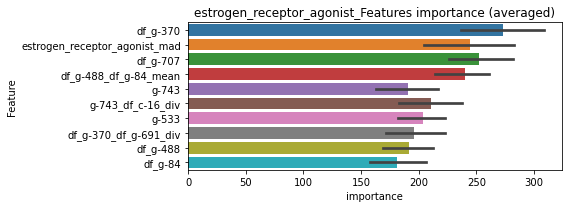

len(train_index) : 2580
len(valid_index) : 861
================================= fold 1/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0972473	valid_1's binary_logloss: 0.150525
[200]	training's binary_logloss: 0.0362381	valid_1's binary_logloss: 0.0971235
[300]	training's binary_logloss: 0.0152003	valid_1's binary_logloss: 0.0737069
[400]	training's binary_logloss: 0.00738481	valid_1's binary_logloss: 0.0634747
[500]	training's binary_logloss: 0.00394162	valid_1's binary_logloss: 0.0572287
[600]	training's binary_logloss: 0.00245352	valid_1's binary_logloss: 0.05474
[700]	training's binary_logloss: 0.00172122	valid_1's binary_logloss: 0.0538701
[800]	training's binary_logloss: 0.00130998	valid_1's binary_logloss: 0.0525407
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00122033	valid_1's binary_logloss: 0.0521522


len(train_index) : 2581
len(valid_index) : 860
================================= fold 2/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955255	valid_1's binary_logloss: 0.15421
[200]	training's binary_logloss: 0.0364125	valid_1's binary_logloss: 0.100418
[300]	training's binary_logloss: 0.015028	valid_1's binary_logloss: 0.0746578
[400]	training's binary_logloss: 0.00704174	valid_1's binary_logloss: 0.0641127
[500]	training's binary_logloss: 0.00381555	valid_1's binary_logloss: 0.058613
[600]	training's binary_logloss: 0.00238352	valid_1's binary_logloss: 0.0550961
[700]	training's binary_logloss: 0.00167652	valid_1's binary_logloss: 0.0528871
[800]	training's binary_logloss: 0.00128353	valid_1's binary_logloss: 0.051846
[900]	training's binary_logloss: 0.00106115	valid_1's binary_logloss: 0.0512005
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00109148	valid_1's binary_logloss: 0.0511463


len(train_index) : 2581
len(valid_index) : 860
================================= fold 3/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103578	valid_1's binary_logloss: 0.143499
[200]	training's binary_logloss: 0.0391321	valid_1's binary_logloss: 0.0900543
[300]	training's binary_logloss: 0.0169877	valid_1's binary_logloss: 0.0697138
[400]	training's binary_logloss: 0.00811268	valid_1's binary_logloss: 0.0596786
[500]	training's binary_logloss: 0.00430499	valid_1's binary_logloss: 0.0543837
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00386091	valid_1's binary_logloss: 0.053845


len(train_index) : 2581
len(valid_index) : 860
================================= fold 4/4 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951349	valid_1's binary_logloss: 0.161199
[200]	training's binary_logloss: 0.0348331	valid_1's binary_logloss: 0.113785
[300]	training's binary_logloss: 0.0145538	valid_1's binary_logloss: 0.0964142
[400]	training's binary_logloss: 0.00684076	valid_1's binary_logloss: 0.0903605


estrogen_receptor_agonist logloss: 0.06139120915961036


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00455991	valid_1's binary_logloss: 0.0884321
neg labels: 3289 → selected neg labels: 3283


estrogen_receptor_antagonist, len(trt): 48, len(othr): 3283, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120763	valid_1's binary_logloss: 0.182872
[200]	training's binary_logloss: 0.0483021	valid_1's binary_logloss: 0.10921
[300]	training's binary_logloss: 0.0208105	valid_1's binary_logloss: 0.0752003
[400]	training's binary_logloss: 0.00949529	valid_1's binary_logloss: 0.0565322
[500]	training's binary_logloss: 0.00477066	valid_1's binary_logloss: 0.0460909
[600]	training's binary_logloss: 0.00275755	valid_1's binary_logloss: 0.0399901
[700]	training's binary_logloss: 0.00181648	valid_1's binary_logloss: 0.0373278
[800]	training's binary_logloss: 0.00134528	valid_1's binary_logloss: 0.0351269
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.00126782	valid_1's binary_logloss: 0.0346843
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116473	valid_1's binary_logloss: 0.170037
[200]	training's binary_logloss: 0.046304	valid_1's b

1 / 3 AUC score:1.000
y_Threshold: 0.0178773, Threshold: 0.3784288, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.26490, conf_1:0.49196
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.3784288
Num_p_label: 39.0, Expected: 8.0, Adj_threshold_2: 0.4284288
Num_p_label: 37.0, Expected: 8.0, Adj_threshold_3: 0.4784288
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_4: 0.5284288
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_5: 0.5784288
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_6: 0.6284288
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_7: 0.6784288
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_8: 0.7284288
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_9: 0.7784288
threshold: 0.7784288, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120916	valid_1's binary_logloss: 0.159726
[200]	training's binary_logloss: 0.0464948	valid_1's binary_logloss: 0.0832594
[300]	training's binary_logloss: 0.0195463	valid_1's binary_logloss: 0.0507451
[400]	training's binary_logloss: 0.00867182	valid_1's binary_logloss: 0.0347109
[500]	training's binary_logloss: 0.00431554	valid_1's binary_logloss: 0.0258459
[600]	training's binary_logloss: 0.00255427	valid_1's binary_logloss: 0.0211284
[700]	training's binary_logloss: 0.0017035	valid_1's binary_logloss: 0.0185046
[800]	training's binary_logloss: 0.00125581	valid_1's binary_logloss: 0.0165724
[900]	training's binary_logloss: 0.00101288	valid_1's binary_logloss: 0.015331
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000978628	valid_1's binary_logloss: 0.0152234
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117242	valid_1

2 / 3 AUC score:0.999
y_Threshold: 0.0713639, Threshold: 0.7784288, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0085384 Vs.target_rate: 0.00202, Num_p_label: 34.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.7784288
threshold: 0.7784288, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115423	valid_1's binary_logloss: 0.156249
[200]	training's binary_logloss: 0.0418699	valid_1's binary_logloss: 0.0823577
[300]	training's binary_logloss: 0.0175623	valid_1's binary_logloss: 0.0510799
[400]	training's binary_logloss: 0.00786495	valid_1's binary_logloss: 0.0352893
[500]	training's binary_logloss: 0.00399877	valid_1's binary_logloss: 0.0273325
[600]	training's binary_logloss: 0.00236999	valid_1's binary_logloss: 0.0223195
[700]	training's binary_logloss: 0.00160413	valid_1's binary_logloss: 0.0195114
[800]	training's binary_logloss: 0.00120036	valid_1's binary_logloss: 0.0179608
[900]	training's binary_logloss: 0.000971516	valid_1's binary_logloss: 0.0169448
[1000]	training's binary_logloss: 0.00085187	valid_1's binary_logloss: 0.016496
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.00085597	valid_1's binary_logloss: 0.0164799
Training until validation sc

3 / 3 AUC score:1.000
y_Threshold: 0.0653682, Threshold: 0.7784288, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 646.0/3787
p_label_rate: 0.0085384 Vs.target_rate: 0.00202, Num_p_label: 34.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 34.0, Expected: 8.0, Adj_threshold_1: 0.7784288
threshold: 0.7784288, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 646.0/3787, y_label_rate: 0.1705836


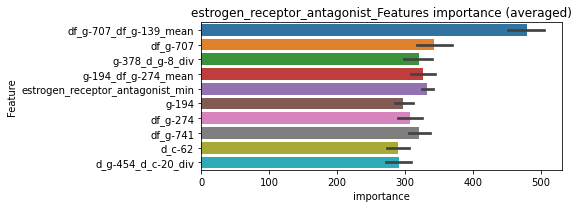

len(train_index) : 2840
len(valid_index) : 947
================================= fold 1/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114209	valid_1's binary_logloss: 0.162328
[200]	training's binary_logloss: 0.0430213	valid_1's binary_logloss: 0.0944797
[300]	training's binary_logloss: 0.0173443	valid_1's binary_logloss: 0.066516
[400]	training's binary_logloss: 0.00773646	valid_1's binary_logloss: 0.0528999
[500]	training's binary_logloss: 0.00387364	valid_1's binary_logloss: 0.0457927
[600]	training's binary_logloss: 0.00226555	valid_1's binary_logloss: 0.0418904
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.0017863	valid_1's binary_logloss: 0.0408772


len(train_index) : 2840
len(valid_index) : 947
================================= fold 2/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110933	valid_1's binary_logloss: 0.154579
[200]	training's binary_logloss: 0.0405973	valid_1's binary_logloss: 0.0815228
[300]	training's binary_logloss: 0.0166379	valid_1's binary_logloss: 0.0537551
[400]	training's binary_logloss: 0.00751265	valid_1's binary_logloss: 0.0403142
[500]	training's binary_logloss: 0.00382048	valid_1's binary_logloss: 0.0338341
[600]	training's binary_logloss: 0.00226757	valid_1's binary_logloss: 0.0303331
[700]	training's binary_logloss: 0.00153261	valid_1's binary_logloss: 0.0287131
[800]	training's binary_logloss: 0.00115918	valid_1's binary_logloss: 0.0281133
[900]	training's binary_logloss: 0.00094235	valid_1's binary_logloss: 0.0274684
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.000886763	valid_1's binary_logloss: 0.0274596


len(train_index) : 2840
len(valid_index) : 947
================================= fold 3/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112628	valid_1's binary_logloss: 0.154476
[200]	training's binary_logloss: 0.0409544	valid_1's binary_logloss: 0.0799314
[300]	training's binary_logloss: 0.016943	valid_1's binary_logloss: 0.0478687
[400]	training's binary_logloss: 0.00750387	valid_1's binary_logloss: 0.0320221
[500]	training's binary_logloss: 0.00382308	valid_1's binary_logloss: 0.0244381
[600]	training's binary_logloss: 0.00228242	valid_1's binary_logloss: 0.0207542
[700]	training's binary_logloss: 0.00156599	valid_1's binary_logloss: 0.0183167
[800]	training's binary_logloss: 0.00117262	valid_1's binary_logloss: 0.0167705
[900]	training's binary_logloss: 0.000954709	valid_1's binary_logloss: 0.0161903
[1000]	training's binary_logloss: 0.000839003	valid_1's binary_logloss: 0.0157857
[1100]	training's binary_logloss: 0.00077654	valid_1's binary_logloss: 0.0155058
Early stopping, best iteration is:
[1083]	training's binary_l

len(train_index) : 2841
len(valid_index) : 946
================================= fold 4/4 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115256	valid_1's binary_logloss: 0.151132
[200]	training's binary_logloss: 0.0423942	valid_1's binary_logloss: 0.0755005
[300]	training's binary_logloss: 0.018215	valid_1's binary_logloss: 0.0457584
[400]	training's binary_logloss: 0.00832483	valid_1's binary_logloss: 0.0309728
[500]	training's binary_logloss: 0.00413744	valid_1's binary_logloss: 0.0231709
[600]	training's binary_logloss: 0.00242054	valid_1's binary_logloss: 0.0190682
[700]	training's binary_logloss: 0.00163442	valid_1's binary_logloss: 0.0171955
[800]	training's binary_logloss: 0.00121688	valid_1's binary_logloss: 0.0160208
[900]	training's binary_logloss: 0.000992294	valid_1's binary_logloss: 0.015544
[1000]	training's binary_logloss: 0.000860037	valid_1's binary_logloss: 0.0152375
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.00087418	valid_1's binary_logloss: 0.0152137


estrogen_receptor_antagonist logloss: 0.024764493359666184


neg labels: 3289 → selected neg labels: 3284


faah_inhibitor, len(trt): 36, len(othr): 3284, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103298	valid_1's binary_logloss: 0.14621
[200]	training's binary_logloss: 0.0370927	valid_1's binary_logloss: 0.0748571
[300]	training's binary_logloss: 0.0155766	valid_1's binary_logloss: 0.0453563
[400]	training's binary_logloss: 0.00680273	valid_1's binary_logloss: 0.0303747
[500]	training's binary_logloss: 0.00340753	valid_1's binary_logloss: 0.0230382
[600]	training's binary_logloss: 0.00203043	valid_1's binary_logloss: 0.0192401
[700]	training's binary_logloss: 0.00138683	valid_1's binary_logloss: 0.0168776
[800]	training's binary_logloss: 0.00104896	valid_1's binary_logloss: 0.0157257
[900]	training's binary_logloss: 0.000857127	valid_1's binary_logloss: 0.0149301
[1000]	training's binary_logloss: 0.000747671	valid_1's binary_logloss: 0.0145708
[1100]	training's binary_logloss: 0.000691564	valid_1's binary_logloss: 0.0142886
Early stopping, best iteration is:
[1128]	training's binary_

1 / 3 AUC score:0.999
y_Threshold: 0.0152928, Threshold: 0.0834736, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.05843, conf_1:0.10852
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0834736
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.1334736
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_3: 0.1834736
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_4: 0.2334736
threshold: 0.2334736, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0971362	valid_1's binary_logloss: 0.135261
[200]	training's binary_logloss: 0.0322515	valid_1's binary_logloss: 0.0673083
[300]	training's binary_logloss: 0.0123162	valid_1's binary_logloss: 0.0408623
[400]	training's binary_logloss: 0.0053684	valid_1's binary_logloss: 0.0295596
[500]	training's binary_logloss: 0.00273026	valid_1's binary_logloss: 0.0253285
[600]	training's binary_logloss: 0.00165907	valid_1's binary_logloss: 0.0231674
[700]	training's binary_logloss: 0.00114695	valid_1's binary_logloss: 0.0223439
[800]	training's binary_logloss: 0.000883269	valid_1's binary_logloss: 0.0218819
[900]	training's binary_logloss: 0.00072594	valid_1's binary_logloss: 0.0214709
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.000715709	valid_1's binary_logloss: 0.0214199
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978312	val

2 / 3 AUC score:0.999
y_Threshold: 0.0762226, Threshold: 0.2334736, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0110497 Vs.target_rate: 0.00151, Num_p_label: 44.0, conf_0:0.18678, conf_1:0.28017
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_1: 0.2334736
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_2: 0.2834736
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_3: 0.3334736
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.3834736
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_5: 0.4334736
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_6: 0.4834736
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_7: 0.5334736
threshold: 0.5334736, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951387	valid_1's binary_logloss: 0.129158
[200]	training's binary_logloss: 0.0321088	valid_1's binary_logloss: 0.0593385
[300]	training's binary_logloss: 0.0124609	valid_1's binary_logloss: 0.0316287
[400]	training's binary_logloss: 0.00529306	valid_1's binary_logloss: 0.019384
[500]	training's binary_logloss: 0.00269132	valid_1's binary_logloss: 0.0137427
[600]	training's binary_logloss: 0.00164328	valid_1's binary_logloss: 0.0108524
[700]	training's binary_logloss: 0.00114739	valid_1's binary_logloss: 0.00937829
[800]	training's binary_logloss: 0.000880158	valid_1's binary_logloss: 0.0083899
[900]	training's binary_logloss: 0.000724674	valid_1's binary_logloss: 0.00778069
[1000]	training's binary_logloss: 0.000642677	valid_1's binary_logloss: 0.00742263
Early stopping, best iteration is:
[1030]	training's binary_logloss: 0.000627053	valid_1's binary_logloss: 0.0073679
Training until valid

3 / 3 AUC score:1.000
y_Threshold: 0.0686233, Threshold: 0.5334736, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.48013, conf_1:0.58682
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_1: 0.5334736
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.5834736
threshold: 0.5834736, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 648.0/3792, y_label_rate: 0.1708861


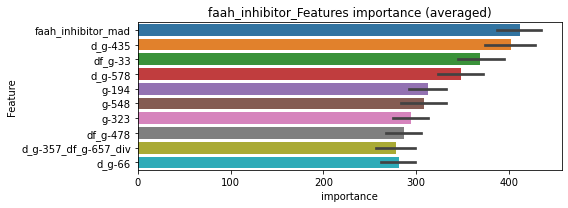

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0976168	valid_1's binary_logloss: 0.130512
[200]	training's binary_logloss: 0.0322345	valid_1's binary_logloss: 0.059715
[300]	training's binary_logloss: 0.0121244	valid_1's binary_logloss: 0.0318003
[400]	training's binary_logloss: 0.00525972	valid_1's binary_logloss: 0.0197363
[500]	training's binary_logloss: 0.00267219	valid_1's binary_logloss: 0.0136265
[600]	training's binary_logloss: 0.00162174	valid_1's binary_logloss: 0.0107624
[700]	training's binary_logloss: 0.00113948	valid_1's binary_logloss: 0.00926306
[800]	training's binary_logloss: 0.000870079	valid_1's binary_logloss: 0.00832573
[900]	training's binary_logloss: 0.00071674	valid_1's binary_logloss: 0.00766903
[1000]	training's binary_logloss: 0.000642103	valid_1's binary_logloss: 0.00742056
[1100]	training's binary_logloss: 0.000608934	valid_1's binary_logloss: 0.00728759
Early stopping, best iteration is:
[1078]	training's b

len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955973	valid_1's binary_logloss: 0.126656
[200]	training's binary_logloss: 0.0317849	valid_1's binary_logloss: 0.0563021
[300]	training's binary_logloss: 0.0118088	valid_1's binary_logloss: 0.0288984
[400]	training's binary_logloss: 0.00507699	valid_1's binary_logloss: 0.0170836
[500]	training's binary_logloss: 0.00260121	valid_1's binary_logloss: 0.0111259
[600]	training's binary_logloss: 0.00159423	valid_1's binary_logloss: 0.00816939
[700]	training's binary_logloss: 0.00111336	valid_1's binary_logloss: 0.00648263
[800]	training's binary_logloss: 0.000861914	valid_1's binary_logloss: 0.00560109
[900]	training's binary_logloss: 0.000714645	valid_1's binary_logloss: 0.00504418
[1000]	training's binary_logloss: 0.0006395	valid_1's binary_logloss: 0.00473496
[1100]	training's binary_logloss: 0.000607979	valid_1's binary_logloss: 0.00458685
[1200]	training's binary_logloss: 0.000595778	valid_1

len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961717	valid_1's binary_logloss: 0.136335
[200]	training's binary_logloss: 0.0313599	valid_1's binary_logloss: 0.062837
[300]	training's binary_logloss: 0.011739	valid_1's binary_logloss: 0.0352312
[400]	training's binary_logloss: 0.00504371	valid_1's binary_logloss: 0.0236217
[500]	training's binary_logloss: 0.00258198	valid_1's binary_logloss: 0.0184836
[600]	training's binary_logloss: 0.00157997	valid_1's binary_logloss: 0.0164125
[700]	training's binary_logloss: 0.00110822	valid_1's binary_logloss: 0.014874
[800]	training's binary_logloss: 0.000854747	valid_1's binary_logloss: 0.0142363
[900]	training's binary_logloss: 0.000707523	valid_1's binary_logloss: 0.013738
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000700135	valid_1's binary_logloss: 0.0136996


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 faah_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958626	valid_1's binary_logloss: 0.135244
[200]	training's binary_logloss: 0.0304543	valid_1's binary_logloss: 0.0610532
[300]	training's binary_logloss: 0.0113965	valid_1's binary_logloss: 0.0321375
[400]	training's binary_logloss: 0.00496085	valid_1's binary_logloss: 0.0203678
[500]	training's binary_logloss: 0.00254995	valid_1's binary_logloss: 0.0143819
[600]	training's binary_logloss: 0.00157181	valid_1's binary_logloss: 0.0114118
[700]	training's binary_logloss: 0.00110636	valid_1's binary_logloss: 0.00974674
[800]	training's binary_logloss: 0.000859857	valid_1's binary_logloss: 0.00885389
[900]	training's binary_logloss: 0.000712318	valid_1's binary_logloss: 0.00838464
[1000]	training's binary_logloss: 0.000628582	valid_1's binary_logloss: 0.00804989
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.00063369	valid_1's binary_logloss: 0.00803222


faah_inhibitor logloss: 0.008392977456025144


neg labels: 3289 → selected neg labels: 3288


farnesyltransferase_inhibitor, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775395	valid_1's binary_logloss: 0.103727
[200]	training's binary_logloss: 0.0222743	valid_1's binary_logloss: 0.0389119
[300]	training's binary_logloss: 0.00731333	valid_1's binary_logloss: 0.0175563
[400]	training's binary_logloss: 0.00281018	valid_1's binary_logloss: 0.00976739
[500]	training's binary_logloss: 0.00146669	valid_1's binary_logloss: 0.00713094
[600]	training's binary_logloss: 0.000936791	valid_1's binary_logloss: 0.00577118
[700]	training's binary_logloss: 0.000681709	valid_1's binary_logloss: 0.00521072
[800]	training's binary_logloss: 0.000550656	valid_1's binary_logloss: 0.00487885
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000536871	valid_1's binary_logloss: 0.00483063
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800656	valid_1's binary_logloss: 0.102951
[200]	training's binary_logloss: 0.022

1 / 3 AUC score:1.000
y_Threshold: 0.0053804, Threshold: 0.0275135, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01926, conf_1:0.03577
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0275135
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.0775135
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.1275135
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.1775135
threshold: 0.1775135, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0753042	valid_1's binary_logloss: 0.104467
[200]	training's binary_logloss: 0.020149	valid_1's binary_logloss: 0.0372952
[300]	training's binary_logloss: 0.00610727	valid_1's binary_logloss: 0.0171143
[400]	training's binary_logloss: 0.00238555	valid_1's binary_logloss: 0.0106908
[500]	training's binary_logloss: 0.00124143	valid_1's binary_logloss: 0.00783066
[600]	training's binary_logloss: 0.000801437	valid_1's binary_logloss: 0.0068694
[700]	training's binary_logloss: 0.000589037	valid_1's binary_logloss: 0.00631303
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.000517178	valid_1's binary_logloss: 0.00604676
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0765025	valid_1's binary_logloss: 0.099166
[200]	training's binary_logloss: 0.020075	valid_1's binary_logloss: 0.0342569
[300]	training's binary_logloss: 0.00617312	v

2 / 3 AUC score:1.000
y_Threshold: 0.0647223, Threshold: 0.1775135, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0072828 Vs.target_rate: 0.00076, Num_p_label: 29.0, conf_0:0.14201, conf_1:0.21302
Num_p_label: 29.0, Expected: 3.0, Adj_threshold_1: 0.1775135
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_2: 0.2275135
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.2775135
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_4: 0.3275135
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.3775135
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.4275135
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_7: 0.4775135
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.5275135
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_9: 0.5775135
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.6275135
threshold: 0.6275135, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3811, y_label_rate: 0.1721333
===============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.075071	valid_1's binary_logloss: 0.100996
[200]	training's binary_logloss: 0.0194576	valid_1's binary_logloss: 0.0348612
[300]	training's binary_logloss: 0.00597231	valid_1's binary_logloss: 0.0144729
[400]	training's binary_logloss: 0.00232485	valid_1's binary_logloss: 0.00796138
[500]	training's binary_logloss: 0.0012289	valid_1's binary_logloss: 0.0054011
[600]	training's binary_logloss: 0.000798909	valid_1's binary_logloss: 0.00423565
[700]	training's binary_logloss: 0.000591906	valid_1's binary_logloss: 0.00373945
[800]	training's binary_logloss: 0.000480098	valid_1's binary_logloss: 0.00343056
[900]	training's binary_logloss: 0.000439492	valid_1's binary_logloss: 0.0033433
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000442247	valid_1's binary_logloss: 0.00333793
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.075

3 / 3 AUC score:1.000
y_Threshold: 0.0766285, Threshold: 0.6275135, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3811
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.69026
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_1: 0.6275135
threshold: 0.6275135, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3811, y_label_rate: 0.1721333


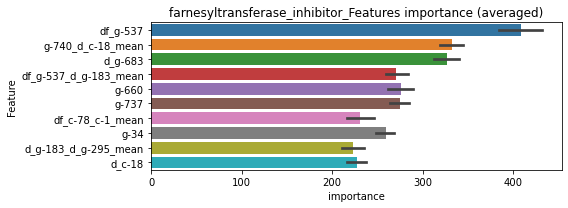

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.076333	valid_1's binary_logloss: 0.101255
[200]	training's binary_logloss: 0.0197849	valid_1's binary_logloss: 0.0344221
[300]	training's binary_logloss: 0.00608772	valid_1's binary_logloss: 0.014975
[400]	training's binary_logloss: 0.00235923	valid_1's binary_logloss: 0.00785242
[500]	training's binary_logloss: 0.0012386	valid_1's binary_logloss: 0.00538613
[600]	training's binary_logloss: 0.000801344	valid_1's binary_logloss: 0.00432859
[700]	training's binary_logloss: 0.000595558	valid_1's binary_logloss: 0.00387461
[800]	training's binary_logloss: 0.000486448	valid_1's binary_logloss: 0.00358282
[900]	training's binary_logloss: 0.000435665	valid_1's binary_logloss: 0.00342741
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000443442	valid_1's binary_logloss: 0.00341787


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0748605	valid_1's binary_logloss: 0.0980889
[200]	training's binary_logloss: 0.0191134	valid_1's binary_logloss: 0.0329695
[300]	training's binary_logloss: 0.00583987	valid_1's binary_logloss: 0.0144317
[400]	training's binary_logloss: 0.002354	valid_1's binary_logloss: 0.00886566
[500]	training's binary_logloss: 0.00123214	valid_1's binary_logloss: 0.00687551
[600]	training's binary_logloss: 0.000796752	valid_1's binary_logloss: 0.00593733
[700]	training's binary_logloss: 0.000588432	valid_1's binary_logloss: 0.00542141
[800]	training's binary_logloss: 0.000482202	valid_1's binary_logloss: 0.00538139
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000471866	valid_1's binary_logloss: 0.00530737


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0757341	valid_1's binary_logloss: 0.0906982
[200]	training's binary_logloss: 0.0194589	valid_1's binary_logloss: 0.0280157
[300]	training's binary_logloss: 0.006063	valid_1's binary_logloss: 0.0108197
[400]	training's binary_logloss: 0.00237176	valid_1's binary_logloss: 0.00516101
[500]	training's binary_logloss: 0.00124858	valid_1's binary_logloss: 0.00319241
[600]	training's binary_logloss: 0.000805543	valid_1's binary_logloss: 0.00228247
[700]	training's binary_logloss: 0.000598759	valid_1's binary_logloss: 0.00184144
[800]	training's binary_logloss: 0.000488055	valid_1's binary_logloss: 0.00159126
[900]	training's binary_logloss: 0.000439233	valid_1's binary_logloss: 0.00147219
Early stopping, best iteration is:
[917]	training's binary_logloss: 0.00043362	valid_1's binary_logloss: 0.0014584


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0771327	valid_1's binary_logloss: 0.0958241
[200]	training's binary_logloss: 0.0203441	valid_1's binary_logloss: 0.0304069
[300]	training's binary_logloss: 0.00621138	valid_1's binary_logloss: 0.0113089
[400]	training's binary_logloss: 0.00243672	valid_1's binary_logloss: 0.00558102
[500]	training's binary_logloss: 0.00126664	valid_1's binary_logloss: 0.00342359
[600]	training's binary_logloss: 0.000818483	valid_1's binary_logloss: 0.00243741
[700]	training's binary_logloss: 0.000606775	valid_1's binary_logloss: 0.00194437
[800]	training's binary_logloss: 0.000495876	valid_1's binary_logloss: 0.00169346
[900]	training's binary_logloss: 0.000450755	valid_1's binary_logloss: 0.00157725
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000450755	valid_1's binary_logloss: 0.00157725


farnesyltransferase_inhibitor logloss: 0.0029405780853675226


neg labels: 3289 → selected neg labels: 3284


fatty_acid_receptor_agonist, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877776	valid_1's binary_logloss: 0.113358
[200]	training's binary_logloss: 0.0259635	valid_1's binary_logloss: 0.0450688
[300]	training's binary_logloss: 0.00886547	valid_1's binary_logloss: 0.0217112
[400]	training's binary_logloss: 0.00358312	valid_1's binary_logloss: 0.0129329
[500]	training's binary_logloss: 0.00182525	valid_1's binary_logloss: 0.00903171
[600]	training's binary_logloss: 0.00113334	valid_1's binary_logloss: 0.0073164
[700]	training's binary_logloss: 0.000814296	valid_1's binary_logloss: 0.00640167
[800]	training's binary_logloss: 0.000642464	valid_1's binary_logloss: 0.00580338
[900]	training's binary_logloss: 0.000548467	valid_1's binary_logloss: 0.00556507
[1000]	training's binary_logloss: 0.000517285	valid_1's binary_logloss: 0.00545698
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000519439	valid_1's binary_logloss: 0.00545496
Training until 

1 / 3 AUC score:1.000
y_Threshold: 0.0069413, Threshold: 0.0550289, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03852, conf_1:0.07154
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0550289
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_2: 0.1050289
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_3: 0.1550289
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_4: 0.2050289
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_5: 0.2550289
threshold: 0.2550289, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840665	valid_1's binary_logloss: 0.104889
[200]	training's binary_logloss: 0.0234673	valid_1's binary_logloss: 0.0384203
[300]	training's binary_logloss: 0.00763198	valid_1's binary_logloss: 0.0175561
[400]	training's binary_logloss: 0.00308161	valid_1's binary_logloss: 0.00986746
[500]	training's binary_logloss: 0.00159474	valid_1's binary_logloss: 0.00681205
[600]	training's binary_logloss: 0.00101488	valid_1's binary_logloss: 0.00537654
[700]	training's binary_logloss: 0.00073405	valid_1's binary_logloss: 0.00456603
[800]	training's binary_logloss: 0.00058082	valid_1's binary_logloss: 0.00410114
[900]	training's binary_logloss: 0.000496758	valid_1's binary_logloss: 0.00384087
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000472322	valid_1's binary_logloss: 0.00378004
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

2 / 3 AUC score:1.000
y_Threshold: 0.0942059, Threshold: 0.2550289, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0065294 Vs.target_rate: 0.00105, Num_p_label: 26.0, conf_0:0.20402, conf_1:0.30603
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_1: 0.2550289
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.3050289
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.3550289
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_4: 0.4050289
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_5: 0.4550289
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_6: 0.5050289
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_7: 0.5550289
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_8: 0.6050289
threshold: 0.6050289, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852745	valid_1's binary_logloss: 0.110724
[200]	training's binary_logloss: 0.023722	valid_1's binary_logloss: 0.0416658
[300]	training's binary_logloss: 0.00774713	valid_1's binary_logloss: 0.0200688
[400]	training's binary_logloss: 0.00311149	valid_1's binary_logloss: 0.0113075
[500]	training's binary_logloss: 0.00160771	valid_1's binary_logloss: 0.00783674
[600]	training's binary_logloss: 0.00100805	valid_1's binary_logloss: 0.00606623
[700]	training's binary_logloss: 0.000729267	valid_1's binary_logloss: 0.00512829
[800]	training's binary_logloss: 0.000580071	valid_1's binary_logloss: 0.00465319
[900]	training's binary_logloss: 0.000495244	valid_1's binary_logloss: 0.00438828
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000466057	valid_1's binary_logloss: 0.00434169
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08

3 / 3 AUC score:1.000
y_Threshold: 0.1175701, Threshold: 0.6050289, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0012557 Vs.target_rate: 0.00105, Num_p_label: 5.0, conf_0:0.50000, conf_1:0.66553
threshold: 0.6050289, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 655.0/3806, y_label_rate: 0.1720967


len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838581	valid_1's binary_logloss: 0.1089
[200]	training's binary_logloss: 0.0234301	valid_1's binary_logloss: 0.0407816
[300]	training's binary_logloss: 0.007671	valid_1's binary_logloss: 0.0190928
[400]	training's binary_logloss: 0.00308143	valid_1's binary_logloss: 0.0108527
[500]	training's binary_logloss: 0.001589	valid_1's binary_logloss: 0.00736275
[600]	training's binary_logloss: 0.00100009	valid_1's binary_logloss: 0.00578458
[700]	training's binary_logloss: 0.000724629	valid_1's binary_logloss: 0.00492027
[800]	training's binary_logloss: 0.00057478	valid_1's binary_logloss: 0.00441183
[900]	training's binary_logloss: 0.00049129	valid_1's binary_logloss: 0.00421787
Early stopping, best iteration is:
[894]	training's binary_logloss: 0.000494871	valid_1's binary_logloss: 0.00421218


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0856399	valid_1's binary_logloss: 0.108777
[200]	training's binary_logloss: 0.0241656	valid_1's binary_logloss: 0.0407278
[300]	training's binary_logloss: 0.00787268	valid_1's binary_logloss: 0.0188723
[400]	training's binary_logloss: 0.00316528	valid_1's binary_logloss: 0.0107516
[500]	training's binary_logloss: 0.00163823	valid_1's binary_logloss: 0.00745021
[600]	training's binary_logloss: 0.00102516	valid_1's binary_logloss: 0.00578511
[700]	training's binary_logloss: 0.000732997	valid_1's binary_logloss: 0.00481906
[800]	training's binary_logloss: 0.00058241	valid_1's binary_logloss: 0.0043633
[900]	training's binary_logloss: 0.000497812	valid_1's binary_logloss: 0.00417399
Early stopping, best iteration is:
[952]	training's binary_logloss: 0.000476776	valid_1's binary_logloss: 0.00407219


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843777	valid_1's binary_logloss: 0.109696
[200]	training's binary_logloss: 0.0238389	valid_1's binary_logloss: 0.0415481
[300]	training's binary_logloss: 0.00783197	valid_1's binary_logloss: 0.0195976
[400]	training's binary_logloss: 0.003123	valid_1's binary_logloss: 0.0110099
[500]	training's binary_logloss: 0.00161499	valid_1's binary_logloss: 0.00758788
[600]	training's binary_logloss: 0.00102175	valid_1's binary_logloss: 0.00590241
[700]	training's binary_logloss: 0.000737688	valid_1's binary_logloss: 0.00504738
[800]	training's binary_logloss: 0.000584868	valid_1's binary_logloss: 0.0045237
[900]	training's binary_logloss: 0.000496739	valid_1's binary_logloss: 0.0041946
[1000]	training's binary_logloss: 0.000469239	valid_1's binary_logloss: 0.00411696
Early stopping, best iteration is:
[978]	training's binary_logloss: 0.000470145	valid_1's binary_logloss: 0.00410604


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0825171	valid_1's binary_logloss: 0.10314
[200]	training's binary_logloss: 0.0234332	valid_1's binary_logloss: 0.0380425
[300]	training's binary_logloss: 0.00750092	valid_1's binary_logloss: 0.0171502
[400]	training's binary_logloss: 0.00299808	valid_1's binary_logloss: 0.0098822
[500]	training's binary_logloss: 0.00155209	valid_1's binary_logloss: 0.0068575
[600]	training's binary_logloss: 0.000985597	valid_1's binary_logloss: 0.00565644
[700]	training's binary_logloss: 0.000715135	valid_1's binary_logloss: 0.00485679
[800]	training's binary_logloss: 0.000567372	valid_1's binary_logloss: 0.0043904
[900]	training's binary_logloss: 0.000491944	valid_1's binary_logloss: 0.00413163
[1000]	training's binary_logloss: 0.000464343	valid_1's binary_logloss: 0.0040614
Early stopping, best iteration is:
[1008]	training's binary_logloss: 0.000463288	valid_1's binary_logloss: 0.00405621


fatty_acid_receptor_agonist logloss: 0.004112535228622653


neg labels: 3289 → selected neg labels: 3284


fgfr_inhibitor, len(trt): 50, len(othr): 3284, target_rate: 0.0020996 → Adj_target_rate: 0.0023352
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125372	valid_1's binary_logloss: 0.196566
[200]	training's binary_logloss: 0.0533822	valid_1's binary_logloss: 0.125515
[300]	training's binary_logloss: 0.0243942	valid_1's binary_logloss: 0.0924876
[400]	training's binary_logloss: 0.0117483	valid_1's binary_logloss: 0.0725548
[500]	training's binary_logloss: 0.00595243	valid_1's binary_logloss: 0.0628195
[600]	training's binary_logloss: 0.00337877	valid_1's binary_logloss: 0.0575129
[700]	training's binary_logloss: 0.00219687	valid_1's binary_logloss: 0.0550245
[800]	training's binary_logloss: 0.00158682	valid_1's binary_logloss: 0.0532342
[900]	training's binary_logloss: 0.00123127	valid_1's binary_logloss: 0.0516235
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00122157	valid_1's binary_logloss: 0.0515894
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133555	valid_1'

1 / 3 AUC score:0.997
y_Threshold: 0.0207028, Threshold: 0.1241177, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00210, Num_p_label: 40.0, conf_0:0.08688, conf_1:0.16135
Num_p_label: 40.0, Expected: 8.4, Adj_threshold_1: 0.1241177
Num_p_label: 30.0, Expected: 8.4, Adj_threshold_2: 0.1741177
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_3: 0.2241177
Num_p_label: 16.0, Expected: 8.4, Adj_threshold_4: 0.2741177
threshold: 0.2741177, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121375	valid_1's binary_logloss: 0.179347
[200]	training's binary_logloss: 0.0468524	valid_1's binary_logloss: 0.104272
[300]	training's binary_logloss: 0.0198325	valid_1's binary_logloss: 0.0689723
[400]	training's binary_logloss: 0.00905646	valid_1's binary_logloss: 0.0513229
[500]	training's binary_logloss: 0.00455427	valid_1's binary_logloss: 0.0420727
[600]	training's binary_logloss: 0.00265373	valid_1's binary_logloss: 0.0368477
[700]	training's binary_logloss: 0.00177961	valid_1's binary_logloss: 0.0338943
[800]	training's binary_logloss: 0.00131859	valid_1's binary_logloss: 0.0325179
[900]	training's binary_logloss: 0.00106076	valid_1's binary_logloss: 0.031938
[1000]	training's binary_logloss: 0.000901811	valid_1's binary_logloss: 0.0313369
Early stopping, best iteration is:
[1025]	training's binary_logloss: 0.000873849	valid_1's binary_logloss: 0.0311069
Training until validation s

2 / 3 AUC score:1.000
y_Threshold: 0.1337967, Threshold: 0.2741177, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 641.0/3778
p_label_rate: 0.0163235 Vs.target_rate: 0.00210, Num_p_label: 65.0, conf_0:0.21929, conf_1:0.32894
Num_p_label: 65.0, Expected: 8.4, Adj_threshold_1: 0.2741177
Num_p_label: 55.0, Expected: 8.4, Adj_threshold_2: 0.3241177
Num_p_label: 45.0, Expected: 8.4, Adj_threshold_3: 0.3741177
Num_p_label: 41.0, Expected: 8.4, Adj_threshold_4: 0.4241177
Num_p_label: 35.0, Expected: 8.4, Adj_threshold_5: 0.4741177
Num_p_label: 31.0, Expected: 8.4, Adj_threshold_6: 0.5241177
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_7: 0.5741177
Num_p_label: 17.0, Expected: 8.4, Adj_threshold_8: 0.6241177
threshold: 0.6241177, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 641.0/3778, y_label_rate: 0.1696665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120181	valid_1's binary_logloss: 0.165888
[200]	training's binary_logloss: 0.0469135	valid_1's binary_logloss: 0.0906555
[300]	training's binary_logloss: 0.0200838	valid_1's binary_logloss: 0.057514
[400]	training's binary_logloss: 0.00909473	valid_1's binary_logloss: 0.0405352
[500]	training's binary_logloss: 0.00465446	valid_1's binary_logloss: 0.031649
[600]	training's binary_logloss: 0.0026939	valid_1's binary_logloss: 0.0269699
[700]	training's binary_logloss: 0.00178645	valid_1's binary_logloss: 0.0242032
[800]	training's binary_logloss: 0.00132417	valid_1's binary_logloss: 0.0225545
[900]	training's binary_logloss: 0.0010513	valid_1's binary_logloss: 0.0218656
[1000]	training's binary_logloss: 0.000890384	valid_1's binary_logloss: 0.0211275
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000882587	valid_1's binary_logloss: 0.0210684
Training until validation sco

3 / 3 AUC score:1.000
y_Threshold: 0.1809041, Threshold: 0.6241177, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 636.0/3768
p_label_rate: 0.0060271 Vs.target_rate: 0.00210, Num_p_label: 24.0, conf_0:0.50000, conf_1:0.68653
Num_p_label: 24.0, Expected: 8.4, Adj_threshold_1: 0.6241177
Num_p_label: 23.0, Expected: 8.4, Adj_threshold_2: 0.6741177
Num_p_label: 19.0, Expected: 8.4, Adj_threshold_3: 0.7241177
threshold: 0.7241177, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 636.0/3768, y_label_rate: 0.1687898


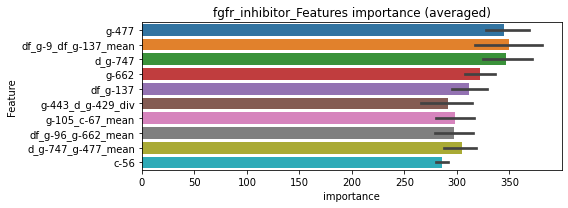

len(train_index) : 2826
len(valid_index) : 942
================================= fold 1/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117957	valid_1's binary_logloss: 0.155754
[200]	training's binary_logloss: 0.0456143	valid_1's binary_logloss: 0.082241
[300]	training's binary_logloss: 0.0195628	valid_1's binary_logloss: 0.0502458
[400]	training's binary_logloss: 0.00885398	valid_1's binary_logloss: 0.0339325
[500]	training's binary_logloss: 0.00451286	valid_1's binary_logloss: 0.0257945
[600]	training's binary_logloss: 0.00261748	valid_1's binary_logloss: 0.021317
[700]	training's binary_logloss: 0.00175805	valid_1's binary_logloss: 0.0189206
[800]	training's binary_logloss: 0.00130788	valid_1's binary_logloss: 0.0172459
[900]	training's binary_logloss: 0.00104704	valid_1's binary_logloss: 0.0163387
[1000]	training's binary_logloss: 0.000890333	valid_1's binary_logloss: 0.0156908
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000839847	valid_1's binary_logloss: 0.0154447


len(train_index) : 2826
len(valid_index) : 942
================================= fold 2/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116534	valid_1's binary_logloss: 0.162834
[200]	training's binary_logloss: 0.0451069	valid_1's binary_logloss: 0.0862216
[300]	training's binary_logloss: 0.0191501	valid_1's binary_logloss: 0.051642
[400]	training's binary_logloss: 0.00846889	valid_1's binary_logloss: 0.0328222
[500]	training's binary_logloss: 0.0043016	valid_1's binary_logloss: 0.0232144
[600]	training's binary_logloss: 0.00254055	valid_1's binary_logloss: 0.0185513
[700]	training's binary_logloss: 0.00171978	valid_1's binary_logloss: 0.0156374
[800]	training's binary_logloss: 0.00127851	valid_1's binary_logloss: 0.0139908
[900]	training's binary_logloss: 0.0010222	valid_1's binary_logloss: 0.012808
[1000]	training's binary_logloss: 0.000871949	valid_1's binary_logloss: 0.0121185
[1100]	training's binary_logloss: 0.00079313	valid_1's binary_logloss: 0.0118083
Early stopping, best iteration is:
[1119]	training's binary_loglo

len(train_index) : 2826
len(valid_index) : 942
================================= fold 3/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114972	valid_1's binary_logloss: 0.164381
[200]	training's binary_logloss: 0.0439767	valid_1's binary_logloss: 0.0925039
[300]	training's binary_logloss: 0.0191486	valid_1's binary_logloss: 0.0619803
[400]	training's binary_logloss: 0.00872329	valid_1's binary_logloss: 0.0462559
[500]	training's binary_logloss: 0.00441969	valid_1's binary_logloss: 0.0382238
[600]	training's binary_logloss: 0.00257566	valid_1's binary_logloss: 0.0328214
[700]	training's binary_logloss: 0.00172243	valid_1's binary_logloss: 0.0302987
[800]	training's binary_logloss: 0.00127645	valid_1's binary_logloss: 0.0284463
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.00111478	valid_1's binary_logloss: 0.027568


len(train_index) : 2826
len(valid_index) : 942
================================= fold 4/4 fgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118576	valid_1's binary_logloss: 0.180297
[200]	training's binary_logloss: 0.0442939	valid_1's binary_logloss: 0.103413
[300]	training's binary_logloss: 0.0187675	valid_1's binary_logloss: 0.068703
[400]	training's binary_logloss: 0.00854288	valid_1's binary_logloss: 0.0498751
[500]	training's binary_logloss: 0.00432517	valid_1's binary_logloss: 0.0415411
[600]	training's binary_logloss: 0.0025217	valid_1's binary_logloss: 0.0366525
[700]	training's binary_logloss: 0.00169482	valid_1's binary_logloss: 0.0349972
[800]	training's binary_logloss: 0.00127168	valid_1's binary_logloss: 0.0333497
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.00136982	valid_1's binary_logloss: 0.0332269


fgfr_inhibitor logloss: 0.021980905362357427


neg labels: 3289 → selected neg labels: 3258


flt3_inhibitor, len(trt): 279, len(othr): 3258, target_rate: 0.0117158 → Adj_target_rate: 0.0100684
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.238811	valid_1's binary_logloss: 0.364155
[200]	training's binary_logloss: 0.150099	valid_1's binary_logloss: 0.336916
[300]	training's binary_logloss: 0.0993817	valid_1's binary_logloss: 0.32142
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0831455	valid_1's binary_logloss: 0.317972
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.237977	valid_1's binary_logloss: 0.351918
[200]	training's binary_logloss: 0.149467	valid_1's binary_logloss: 0.319403
[300]	training's binary_logloss: 0.100055	valid_1's binary_logloss: 0.299712
[400]	training's binary_logloss: 0.0682867	valid_1's binary_logloss: 0.289659
[500]	training's binary_logloss: 0.0469598	valid_1's binary_logloss: 0.285539
Early stopping, best iteration is:
[501]	training's binary_logloss: 0.0468648	valid_1's binary_logloss: 0.285504
Training until validation scores d

1 / 3 AUC score:0.845
y_Threshold: 0.1344571, Threshold: 0.6767807, pos_neg_ratio: 0.8000000
Remove_noisy_data: 531 → Positive_corect_labels: 451/3378
p_label_rate: 0.0100452 Vs.target_rate: 0.01172, Num_p_label: 40.0, conf_0:0.47375, conf_1:0.80000
threshold: 0.6767807, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 451.0/3378, y_label_rate: 0.1335110
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138146	valid_1's binary_logloss: 0.229121
[200]	training's binary_logloss: 0.0659007	valid_1's binary_logloss: 0.178883
[300]	training's binary_logloss: 0.0345164	valid_1's binary_logloss: 0.157037
[400]	training's binary_logloss: 0.0186807	valid_1's binary_logloss: 0.147382
[500]	training's binary_logloss: 0.0103089	valid_1's binary_logloss: 0.144134
[600]	training's binary_logloss: 0.00611388	valid_1's binary_logloss: 0.140278
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00647319	valid_1's binary_logloss: 0.140021
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135347	valid_1's binary_logloss: 0.226989
[200]	training's binary_logloss: 0.0628288	valid_1's binary_logloss: 0.170784
[300]	training's binary_logloss: 0.0327883	valid_1's binary_logloss: 0.142117
[400]	training's binary_logloss: 0.0176275	valid_1's binary_log

2 / 3 AUC score:0.979
y_Threshold: 0.1121633, Threshold: 0.6767807, pos_neg_ratio: 0.8000000
Remove_noisy_data: 126 → Positive_corect_labels: 388.0/3252
p_label_rate: 0.0303867 Vs.target_rate: 0.01172, Num_p_label: 121.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 121.0, Expected: 46.7, Adj_threshold_1: 0.6767807
Num_p_label: 111.0, Expected: 46.7, Adj_threshold_2: 0.7267807
Num_p_label: 98.0, Expected: 46.7, Adj_threshold_3: 0.7767807
threshold: 0.7767807, positive_p_label: 98.0/3982, p_label_rate: 0.0246107
positive_y_label: 388.0/3252, y_label_rate: 0.1193112
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102268	valid_1's binary_logloss: 0.170323
[200]	training's binary_logloss: 0.0430698	valid_1's binary_logloss: 0.122782
[300]	training's binary_logloss: 0.020773	valid_1's binary_logloss: 0.0998637
[400]	training's binary_logloss: 0.0103219	valid_1's binary_logloss: 0.0875821
[500]	training's binary_logloss: 0.00567511	valid_1's binary_logloss: 0.0821249
[600]	training's binary_logloss: 0.00345851	valid_1's binary_logloss: 0.0786377
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00278672	valid_1's binary_logloss: 0.0778033
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101386	valid_1's binary_logloss: 0.170856
[200]	training's binary_logloss: 0.0420702	valid_1's binary_logloss: 0.128756
[300]	training's binary_logloss: 0.0201408	valid_1's binary_logloss: 0.111301
[400]	training's binary_logloss: 0.00999291	valid_1's bina

3 / 3 AUC score:0.984
y_Threshold: 0.0899110, Threshold: 0.7767807, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 351.0/3178
p_label_rate: 0.0371673 Vs.target_rate: 0.01172, Num_p_label: 148.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 148.0, Expected: 46.7, Adj_threshold_1: 0.7767807
threshold: 0.7767807, positive_p_label: 148.0/3982, p_label_rate: 0.0371673
positive_y_label: 351.0/3178, y_label_rate: 0.1104468


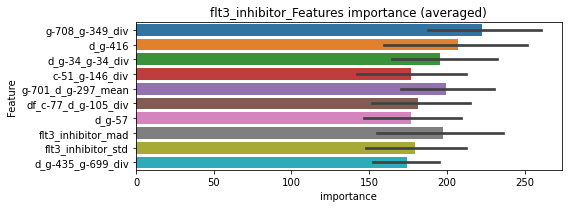

len(train_index) : 2383
len(valid_index) : 795
================================= fold 1/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834106	valid_1's binary_logloss: 0.160153
[200]	training's binary_logloss: 0.0302506	valid_1's binary_logloss: 0.119635
[300]	training's binary_logloss: 0.013117	valid_1's binary_logloss: 0.103943
[400]	training's binary_logloss: 0.0061542	valid_1's binary_logloss: 0.0986433
[500]	training's binary_logloss: 0.00341501	valid_1's binary_logloss: 0.0970487
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00381848	valid_1's binary_logloss: 0.0967464


len(train_index) : 2383
len(valid_index) : 795
================================= fold 2/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086901	valid_1's binary_logloss: 0.143039
[200]	training's binary_logloss: 0.0311076	valid_1's binary_logloss: 0.0949292
[300]	training's binary_logloss: 0.0137002	valid_1's binary_logloss: 0.0751082
[400]	training's binary_logloss: 0.00650378	valid_1's binary_logloss: 0.065848
[500]	training's binary_logloss: 0.00356129	valid_1's binary_logloss: 0.0621735
[600]	training's binary_logloss: 0.00225597	valid_1's binary_logloss: 0.0599637
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00218686	valid_1's binary_logloss: 0.0596625


len(train_index) : 2384
len(valid_index) : 794
================================= fold 3/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0875717	valid_1's binary_logloss: 0.126668
[200]	training's binary_logloss: 0.0326941	valid_1's binary_logloss: 0.0790999
[300]	training's binary_logloss: 0.014574	valid_1's binary_logloss: 0.0589659
[400]	training's binary_logloss: 0.00694925	valid_1's binary_logloss: 0.0470159
[500]	training's binary_logloss: 0.00376881	valid_1's binary_logloss: 0.0401314
[600]	training's binary_logloss: 0.00236337	valid_1's binary_logloss: 0.0366364
[700]	training's binary_logloss: 0.00166584	valid_1's binary_logloss: 0.0347401
[800]	training's binary_logloss: 0.00127528	valid_1's binary_logloss: 0.0327755
[900]	training's binary_logloss: 0.00105867	valid_1's binary_logloss: 0.0317116
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00106853	valid_1's binary_logloss: 0.0316094


len(train_index) : 2384
len(valid_index) : 794
================================= fold 4/4 flt3_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0861522	valid_1's binary_logloss: 0.163703
[200]	training's binary_logloss: 0.0298403	valid_1's binary_logloss: 0.126273
[300]	training's binary_logloss: 0.0121855	valid_1's binary_logloss: 0.114548
[400]	training's binary_logloss: 0.00573259	valid_1's binary_logloss: 0.111329
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00558469	valid_1's binary_logloss: 0.111055


flt3_inhibitor logloss: 0.07477056302628393


neg labels: 3289 → selected neg labels: 3289


focal_adhesion_kinase_inhibitor, len(trt): 18, len(othr): 3289, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0841127	valid_1's binary_logloss: 0.106155
[200]	training's binary_logloss: 0.0251772	valid_1's binary_logloss: 0.0419974
[300]	training's binary_logloss: 0.00843501	valid_1's binary_logloss: 0.0216387
[400]	training's binary_logloss: 0.00336289	valid_1's binary_logloss: 0.0141692
[500]	training's binary_logloss: 0.0017255	valid_1's binary_logloss: 0.0114614
[600]	training's binary_logloss: 0.0010861	valid_1's binary_logloss: 0.0103974
[700]	training's binary_logloss: 0.00078395	valid_1's binary_logloss: 0.00977243
[800]	training's binary_logloss: 0.00061931	valid_1's binary_logloss: 0.00949604
[900]	training's binary_logloss: 0.000535916	valid_1's binary_logloss: 0.00929034
Early stopping, best iteration is:
[932]	training's binary_logloss: 0.000527416	valid_1's binary_logloss: 0.00926159
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0846989

1 / 3 AUC score:1.000
y_Threshold: 0.0057835, Threshold: 0.0327304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02291, conf_1:0.04255
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0327304
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_2: 0.0827304
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.1327304
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_4: 0.1827304
threshold: 0.1827304, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805866	valid_1's binary_logloss: 0.101302
[200]	training's binary_logloss: 0.0217733	valid_1's binary_logloss: 0.0362816
[300]	training's binary_logloss: 0.00686701	valid_1's binary_logloss: 0.0171327
[400]	training's binary_logloss: 0.00274415	valid_1's binary_logloss: 0.0107002
[500]	training's binary_logloss: 0.00142678	valid_1's binary_logloss: 0.00850745
[600]	training's binary_logloss: 0.000913167	valid_1's binary_logloss: 0.0075314
[700]	training's binary_logloss: 0.000666697	valid_1's binary_logloss: 0.00709555
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.000607634	valid_1's binary_logloss: 0.00703427
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0823573	valid_1's binary_logloss: 0.098713
[200]	training's binary_logloss: 0.0227499	valid_1's binary_logloss: 0.0330495
[300]	training's binary_logloss: 0.00731402

2 / 3 AUC score:1.000
y_Threshold: 0.0885900, Threshold: 0.1827304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00076, Num_p_label: 22.0, conf_0:0.14618, conf_1:0.21928
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_1: 0.1827304
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.2327304
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.2827304
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.3327304
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.3827304
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.4327304
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.4827304
threshold: 0.4827304, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805866	valid_1's binary_logloss: 0.101302
[200]	training's binary_logloss: 0.0217733	valid_1's binary_logloss: 0.0362816
[300]	training's binary_logloss: 0.00686701	valid_1's binary_logloss: 0.0171327
[400]	training's binary_logloss: 0.00274415	valid_1's binary_logloss: 0.0107002
[500]	training's binary_logloss: 0.00142678	valid_1's binary_logloss: 0.00850745
[600]	training's binary_logloss: 0.000913167	valid_1's binary_logloss: 0.0075314
[700]	training's binary_logloss: 0.000666697	valid_1's binary_logloss: 0.00709555
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.000607634	valid_1's binary_logloss: 0.00703427
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0823573	valid_1's binary_logloss: 0.098713
[200]	training's binary_logloss: 0.0227499	valid_1's binary_logloss: 0.0330495
[300]	training's binary_logloss: 0.00731402

3 / 3 AUC score:1.000
y_Threshold: 0.0885900, Threshold: 0.4827304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.43446, conf_1:0.53100
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.4827304
threshold: 0.4827304, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


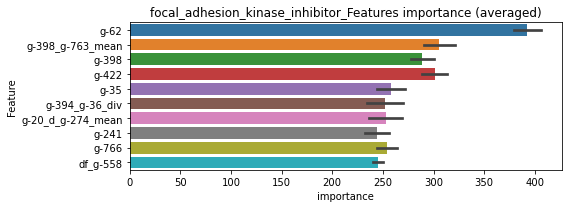

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0797846	valid_1's binary_logloss: 0.0994346
[200]	training's binary_logloss: 0.0217789	valid_1's binary_logloss: 0.0366874
[300]	training's binary_logloss: 0.0068317	valid_1's binary_logloss: 0.0170996
[400]	training's binary_logloss: 0.00273511	valid_1's binary_logloss: 0.0108985
[500]	training's binary_logloss: 0.00143519	valid_1's binary_logloss: 0.00914215
[600]	training's binary_logloss: 0.000921898	valid_1's binary_logloss: 0.00854062
[700]	training's binary_logloss: 0.000668344	valid_1's binary_logloss: 0.00829157
Early stopping, best iteration is:
[740]	training's binary_logloss: 0.000607725	valid_1's binary_logloss: 0.00823707


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815356	valid_1's binary_logloss: 0.0957165
[200]	training's binary_logloss: 0.0225557	valid_1's binary_logloss: 0.0320047
[300]	training's binary_logloss: 0.00721568	valid_1's binary_logloss: 0.0131391
[400]	training's binary_logloss: 0.00282804	valid_1's binary_logloss: 0.00641419
[500]	training's binary_logloss: 0.00147266	valid_1's binary_logloss: 0.00382303
[600]	training's binary_logloss: 0.00094486	valid_1's binary_logloss: 0.0028308
[700]	training's binary_logloss: 0.000688995	valid_1's binary_logloss: 0.00236409
[800]	training's binary_logloss: 0.000552059	valid_1's binary_logloss: 0.00206839
[900]	training's binary_logloss: 0.000480101	valid_1's binary_logloss: 0.00188482
[1000]	training's binary_logloss: 0.000456527	valid_1's binary_logloss: 0.00182632
Early stopping, best iteration is:
[1017]	training's binary_logloss: 0.000453115	valid_1's binary_logloss: 0.00181787


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0806089	valid_1's binary_logloss: 0.0996749
[200]	training's binary_logloss: 0.0220655	valid_1's binary_logloss: 0.0354336
[300]	training's binary_logloss: 0.00699178	valid_1's binary_logloss: 0.015839
[400]	training's binary_logloss: 0.00282849	valid_1's binary_logloss: 0.00943023
[500]	training's binary_logloss: 0.00147514	valid_1's binary_logloss: 0.0067447
[600]	training's binary_logloss: 0.000944078	valid_1's binary_logloss: 0.00532334
[700]	training's binary_logloss: 0.000685955	valid_1's binary_logloss: 0.00457114
[800]	training's binary_logloss: 0.000550715	valid_1's binary_logloss: 0.00417719
[900]	training's binary_logloss: 0.00047758	valid_1's binary_logloss: 0.00396436
[1000]	training's binary_logloss: 0.000455679	valid_1's binary_logloss: 0.00390547
Early stopping, best iteration is:
[1041]	training's binary_logloss: 0.000449771	valid_1's binary_logloss: 0.00386455


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0803675	valid_1's binary_logloss: 0.102185
[200]	training's binary_logloss: 0.0218224	valid_1's binary_logloss: 0.0370439
[300]	training's binary_logloss: 0.00695538	valid_1's binary_logloss: 0.0172873
[400]	training's binary_logloss: 0.00283662	valid_1's binary_logloss: 0.00980565
[500]	training's binary_logloss: 0.00148478	valid_1's binary_logloss: 0.0071503
[600]	training's binary_logloss: 0.000949451	valid_1's binary_logloss: 0.00582277
[700]	training's binary_logloss: 0.000687653	valid_1's binary_logloss: 0.00524434
[800]	training's binary_logloss: 0.000548869	valid_1's binary_logloss: 0.00482488
[900]	training's binary_logloss: 0.000481543	valid_1's binary_logloss: 0.00459666
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000479262	valid_1's binary_logloss: 0.00458473


focal_adhesion_kinase_inhibitor logloss: 0.004627388879013592


neg labels: 3289 → selected neg labels: 3288


free_radical_scavenger, len(trt): 18, len(othr): 3288, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0765158	valid_1's binary_logloss: 0.0991058
[200]	training's binary_logloss: 0.0221954	valid_1's binary_logloss: 0.0412621
[300]	training's binary_logloss: 0.00737026	valid_1's binary_logloss: 0.0233902
[400]	training's binary_logloss: 0.00286954	valid_1's binary_logloss: 0.0158288
[500]	training's binary_logloss: 0.00144699	valid_1's binary_logloss: 0.012557
[600]	training's binary_logloss: 0.000906257	valid_1's binary_logloss: 0.0112607
[700]	training's binary_logloss: 0.000656702	valid_1's binary_logloss: 0.0101988
[800]	training's binary_logloss: 0.000524263	valid_1's binary_logloss: 0.00969996
[900]	training's binary_logloss: 0.000459581	valid_1's binary_logloss: 0.00949004
[1000]	training's binary_logloss: 0.000443332	valid_1's binary_logloss: 0.00940482
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.000443332	valid_1's binary_logloss: 0.00940482
Training until v

1 / 3 AUC score:1.000
y_Threshold: 0.0052429, Threshold: 0.0293546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02055, conf_1:0.03816
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0293546
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.0793546
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.1293546
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.1793546
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.2293546
threshold: 0.2293546, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0734961	valid_1's binary_logloss: 0.0904576
[200]	training's binary_logloss: 0.0194398	valid_1's binary_logloss: 0.0303609
[300]	training's binary_logloss: 0.0061745	valid_1's binary_logloss: 0.0126971
[400]	training's binary_logloss: 0.00240912	valid_1's binary_logloss: 0.00658231
[500]	training's binary_logloss: 0.00123265	valid_1's binary_logloss: 0.00419498
[600]	training's binary_logloss: 0.00078854	valid_1's binary_logloss: 0.00315894
[700]	training's binary_logloss: 0.000578871	valid_1's binary_logloss: 0.00261165
[800]	training's binary_logloss: 0.000468344	valid_1's binary_logloss: 0.00228849
[900]	training's binary_logloss: 0.000420881	valid_1's binary_logloss: 0.0021676
[1000]	training's binary_logloss: 0.000404669	valid_1's binary_logloss: 0.00212408
Early stopping, best iteration is:
[976]	training's binary_logloss: 0.000404669	valid_1's binary_logloss: 0.00212408
Training until

2 / 3 AUC score:1.000
y_Threshold: 0.0347356, Threshold: 0.2293546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3809
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.18348, conf_1:0.27523
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.2293546
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.2793546
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.3293546
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_4: 0.3793546
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.4293546
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.4793546
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_7: 0.5293546
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_8: 0.5793546
threshold: 0.5793546, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 655.0/3809, y_label_rate: 0.1719611
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735223	valid_1's binary_logloss: 0.0931435
[200]	training's binary_logloss: 0.0190971	valid_1's binary_logloss: 0.029741
[300]	training's binary_logloss: 0.00607932	valid_1's binary_logloss: 0.0118678
[400]	training's binary_logloss: 0.00236775	valid_1's binary_logloss: 0.00599605
[500]	training's binary_logloss: 0.00122905	valid_1's binary_logloss: 0.00373851
[600]	training's binary_logloss: 0.000781074	valid_1's binary_logloss: 0.00271628
[700]	training's binary_logloss: 0.000574459	valid_1's binary_logloss: 0.00223965
[800]	training's binary_logloss: 0.00046497	valid_1's binary_logloss: 0.00192571
[900]	training's binary_logloss: 0.000417165	valid_1's binary_logloss: 0.00185774
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000407593	valid_1's binary_logloss: 0.00183366
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

3 / 3 AUC score:1.000
y_Threshold: 0.0461192, Threshold: 0.5793546, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3807
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.63729
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_1: 0.5793546
threshold: 0.5793546, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3807, y_label_rate: 0.1717888


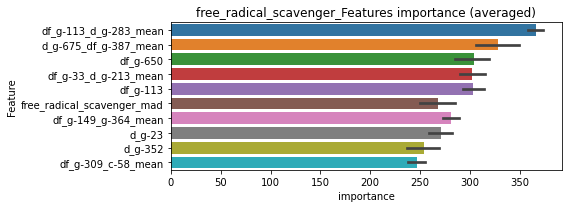

len(train_index) : 2855
len(valid_index) : 952
================================= fold 1/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720621	valid_1's binary_logloss: 0.0871297
[200]	training's binary_logloss: 0.0190244	valid_1's binary_logloss: 0.0279859
[300]	training's binary_logloss: 0.00599472	valid_1's binary_logloss: 0.0112825
[400]	training's binary_logloss: 0.00231778	valid_1's binary_logloss: 0.00542058
[500]	training's binary_logloss: 0.00120393	valid_1's binary_logloss: 0.0032664
[600]	training's binary_logloss: 0.000773748	valid_1's binary_logloss: 0.0023345
[700]	training's binary_logloss: 0.000571051	valid_1's binary_logloss: 0.00191534
[800]	training's binary_logloss: 0.000467811	valid_1's binary_logloss: 0.00170799
[900]	training's binary_logloss: 0.000424177	valid_1's binary_logloss: 0.00161822
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.00041721	valid_1's binary_logloss: 0.00159837


len(train_index) : 2855
len(valid_index) : 952
================================= fold 2/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0718455	valid_1's binary_logloss: 0.0886504
[200]	training's binary_logloss: 0.0187565	valid_1's binary_logloss: 0.031416
[300]	training's binary_logloss: 0.00588287	valid_1's binary_logloss: 0.0153327
[400]	training's binary_logloss: 0.00227764	valid_1's binary_logloss: 0.0099934
[500]	training's binary_logloss: 0.00117965	valid_1's binary_logloss: 0.00793955
[600]	training's binary_logloss: 0.000759742	valid_1's binary_logloss: 0.0070621
[700]	training's binary_logloss: 0.000559821	valid_1's binary_logloss: 0.00667373
[800]	training's binary_logloss: 0.000455866	valid_1's binary_logloss: 0.00657512
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000442573	valid_1's binary_logloss: 0.00648834


len(train_index) : 2855
len(valid_index) : 952
================================= fold 3/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0741625	valid_1's binary_logloss: 0.0887918
[200]	training's binary_logloss: 0.0194131	valid_1's binary_logloss: 0.0281888
[300]	training's binary_logloss: 0.00612097	valid_1's binary_logloss: 0.0119171
[400]	training's binary_logloss: 0.00237791	valid_1's binary_logloss: 0.00682128
[500]	training's binary_logloss: 0.00121391	valid_1's binary_logloss: 0.00489772
[600]	training's binary_logloss: 0.000773408	valid_1's binary_logloss: 0.00412985
[700]	training's binary_logloss: 0.000569797	valid_1's binary_logloss: 0.00367224
[800]	training's binary_logloss: 0.000464528	valid_1's binary_logloss: 0.00347518
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00043977	valid_1's binary_logloss: 0.00342882


len(train_index) : 2856
len(valid_index) : 951
================================= fold 4/4 free_radical_scavenger=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0737383	valid_1's binary_logloss: 0.0934582
[200]	training's binary_logloss: 0.0194395	valid_1's binary_logloss: 0.0314733
[300]	training's binary_logloss: 0.00608924	valid_1's binary_logloss: 0.0132894
[400]	training's binary_logloss: 0.00234756	valid_1's binary_logloss: 0.00659222
[500]	training's binary_logloss: 0.00120735	valid_1's binary_logloss: 0.0042234
[600]	training's binary_logloss: 0.000771552	valid_1's binary_logloss: 0.00304311
[700]	training's binary_logloss: 0.000568282	valid_1's binary_logloss: 0.00247056
[800]	training's binary_logloss: 0.000459822	valid_1's binary_logloss: 0.00223995
[900]	training's binary_logloss: 0.000419882	valid_1's binary_logloss: 0.00213815
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000409884	valid_1's binary_logloss: 0.00209787


free_radical_scavenger logloss: 0.003404487362954346


neg labels: 3289 → selected neg labels: 3287


fungal_squalene_epoxidase_inhibitor, len(trt): 23, len(othr): 3287, target_rate: 0.0009658 → Adj_target_rate: 0.0012069
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902245	valid_1's binary_logloss: 0.125423
[200]	training's binary_logloss: 0.0275407	valid_1's binary_logloss: 0.0512676
[300]	training's binary_logloss: 0.00979427	valid_1's binary_logloss: 0.0251303
[400]	training's binary_logloss: 0.00408219	valid_1's binary_logloss: 0.0149379
[500]	training's binary_logloss: 0.00210407	valid_1's binary_logloss: 0.0106967
[600]	training's binary_logloss: 0.00130996	valid_1's binary_logloss: 0.00852681
[700]	training's binary_logloss: 0.000937322	valid_1's binary_logloss: 0.00742834
[800]	training's binary_logloss: 0.000729847	valid_1's binary_logloss: 0.0066915
[900]	training's binary_logloss: 0.000613104	valid_1's binary_logloss: 0.00625595
[1000]	training's binary_logloss: 0.00055993	valid_1's binary_logloss: 0.00613583
Early stopping, best iteration is:
[1034]	training's binary_logloss: 0.000551493	valid_1's binary_logloss: 0.00611762
Training until v

1 / 3 AUC score:1.000
y_Threshold: 0.0070869, Threshold: 0.0572844, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00097, Num_p_label: 40.0, conf_0:0.04010, conf_1:0.07447
Num_p_label: 40.0, Expected: 3.8, Adj_threshold_1: 0.0572844
Num_p_label: 21.0, Expected: 3.8, Adj_threshold_2: 0.1072844
Num_p_label: 14.0, Expected: 3.8, Adj_threshold_3: 0.1572844
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_4: 0.2072844
Num_p_label: 9.0, Expected: 3.8, Adj_threshold_5: 0.2572844
threshold: 0.2572844, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881571	valid_1's binary_logloss: 0.120258
[200]	training's binary_logloss: 0.0256764	valid_1's binary_logloss: 0.0467942
[300]	training's binary_logloss: 0.00875436	valid_1's binary_logloss: 0.0217984
[400]	training's binary_logloss: 0.00356604	valid_1's binary_logloss: 0.0125292
[500]	training's binary_logloss: 0.00183678	valid_1's binary_logloss: 0.00860312
[600]	training's binary_logloss: 0.00115139	valid_1's binary_logloss: 0.00663778
[700]	training's binary_logloss: 0.000822074	valid_1's binary_logloss: 0.00562825
[800]	training's binary_logloss: 0.000645905	valid_1's binary_logloss: 0.00503029
[900]	training's binary_logloss: 0.000551081	valid_1's binary_logloss: 0.00476158
[1000]	training's binary_logloss: 0.00051404	valid_1's binary_logloss: 0.00463027
Early stopping, best iteration is:
[1017]	training's binary_logloss: 0.000511468	valid_1's binary_logloss: 0.00462194
Training until

2 / 3 AUC score:1.000
y_Threshold: 0.0959150, Threshold: 0.2572844, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0092918 Vs.target_rate: 0.00097, Num_p_label: 37.0, conf_0:0.20583, conf_1:0.30874
Num_p_label: 37.0, Expected: 3.8, Adj_threshold_1: 0.2572844
Num_p_label: 31.0, Expected: 3.8, Adj_threshold_2: 0.3072844
Num_p_label: 23.0, Expected: 3.8, Adj_threshold_3: 0.3572844
Num_p_label: 19.0, Expected: 3.8, Adj_threshold_4: 0.4072844
Num_p_label: 15.0, Expected: 3.8, Adj_threshold_5: 0.4572844
Num_p_label: 11.0, Expected: 3.8, Adj_threshold_6: 0.5072844
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_7: 0.5572844
threshold: 0.5572844, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878644	valid_1's binary_logloss: 0.1239
[200]	training's binary_logloss: 0.0246713	valid_1's binary_logloss: 0.0479973
[300]	training's binary_logloss: 0.0083895	valid_1's binary_logloss: 0.0235144
[400]	training's binary_logloss: 0.00344914	valid_1's binary_logloss: 0.0144867
[500]	training's binary_logloss: 0.00180326	valid_1's binary_logloss: 0.0105596
[600]	training's binary_logloss: 0.00112823	valid_1's binary_logloss: 0.00872476
[700]	training's binary_logloss: 0.000806661	valid_1's binary_logloss: 0.00785624
[800]	training's binary_logloss: 0.000635148	valid_1's binary_logloss: 0.00730046
[900]	training's binary_logloss: 0.000540395	valid_1's binary_logloss: 0.00704993
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000555992	valid_1's binary_logloss: 0.00700997
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08697

3 / 3 AUC score:1.000
y_Threshold: 0.1033145, Threshold: 0.5572844, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0025113 Vs.target_rate: 0.00097, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.61301
Num_p_label: 10.0, Expected: 3.8, Adj_threshold_1: 0.5572844
Num_p_label: 8.0, Expected: 3.8, Adj_threshold_2: 0.6072844
threshold: 0.6072844, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3810, y_label_rate: 0.1721785


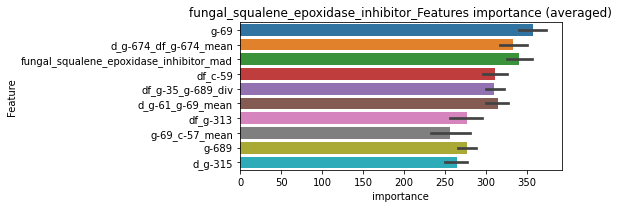

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0898861	valid_1's binary_logloss: 0.126703
[200]	training's binary_logloss: 0.0252887	valid_1's binary_logloss: 0.0481031
[300]	training's binary_logloss: 0.00847292	valid_1's binary_logloss: 0.0231954
[400]	training's binary_logloss: 0.00346465	valid_1's binary_logloss: 0.0143419
[500]	training's binary_logloss: 0.00181161	valid_1's binary_logloss: 0.0106889
[600]	training's binary_logloss: 0.00113816	valid_1's binary_logloss: 0.00882952
[700]	training's binary_logloss: 0.00081216	valid_1's binary_logloss: 0.00784913
[800]	training's binary_logloss: 0.000636435	valid_1's binary_logloss: 0.00731115
[900]	training's binary_logloss: 0.000541695	valid_1's binary_logloss: 0.00702054
Early stopping, best iteration is:
[909]	training's binary_logloss: 0.00053507	valid_1's binary_logloss: 0.00701156


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0879471	valid_1's binary_logloss: 0.117436
[200]	training's binary_logloss: 0.024935	valid_1's binary_logloss: 0.0444247
[300]	training's binary_logloss: 0.0087492	valid_1's binary_logloss: 0.0202592
[400]	training's binary_logloss: 0.00366585	valid_1's binary_logloss: 0.0111896
[500]	training's binary_logloss: 0.00183243	valid_1's binary_logloss: 0.00714088
[600]	training's binary_logloss: 0.00113488	valid_1's binary_logloss: 0.00537527
[700]	training's binary_logloss: 0.000810082	valid_1's binary_logloss: 0.00448955
[800]	training's binary_logloss: 0.000636379	valid_1's binary_logloss: 0.00393729
[900]	training's binary_logloss: 0.000541365	valid_1's binary_logloss: 0.0036972
[1000]	training's binary_logloss: 0.000504851	valid_1's binary_logloss: 0.0036184
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.000499977	valid_1's binary_logloss: 0.0036139


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0890782	valid_1's binary_logloss: 0.11311
[200]	training's binary_logloss: 0.0253544	valid_1's binary_logloss: 0.0412104
[300]	training's binary_logloss: 0.00856365	valid_1's binary_logloss: 0.0187223
[400]	training's binary_logloss: 0.00350449	valid_1's binary_logloss: 0.0105341
[500]	training's binary_logloss: 0.00184081	valid_1's binary_logloss: 0.00753544
[600]	training's binary_logloss: 0.00116846	valid_1's binary_logloss: 0.00587961
[700]	training's binary_logloss: 0.000835287	valid_1's binary_logloss: 0.00487273
[800]	training's binary_logloss: 0.000656272	valid_1's binary_logloss: 0.00438
[900]	training's binary_logloss: 0.000552565	valid_1's binary_logloss: 0.00413662
[1000]	training's binary_logloss: 0.000510851	valid_1's binary_logloss: 0.00407107
Early stopping, best iteration is:
[1046]	training's binary_logloss: 0.000506476	valid_1's binary_logloss: 0.00406022


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086635	valid_1's binary_logloss: 0.108318
[200]	training's binary_logloss: 0.0253836	valid_1's binary_logloss: 0.0406843
[300]	training's binary_logloss: 0.00858785	valid_1's binary_logloss: 0.017708
[400]	training's binary_logloss: 0.0035457	valid_1's binary_logloss: 0.00960702
[500]	training's binary_logloss: 0.00183917	valid_1's binary_logloss: 0.0061974
[600]	training's binary_logloss: 0.00115926	valid_1's binary_logloss: 0.00476558
[700]	training's binary_logloss: 0.000837074	valid_1's binary_logloss: 0.00396687
[800]	training's binary_logloss: 0.00065568	valid_1's binary_logloss: 0.00346385
[900]	training's binary_logloss: 0.000556178	valid_1's binary_logloss: 0.00316336
[1000]	training's binary_logloss: 0.000513122	valid_1's binary_logloss: 0.00307522
Early stopping, best iteration is:
[1032]	training's binary_logloss: 0.000508892	valid_1's binary_logloss: 0.00304609


fungal_squalene_epoxidase_inhibitor logloss: 0.004433403678017956


neg labels: 3289 → selected neg labels: 3271


gaba_receptor_agonist, len(trt): 106, len(othr): 3271, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1525	valid_1's binary_logloss: 0.260574
[200]	training's binary_logloss: 0.0738181	valid_1's binary_logloss: 0.199201
[300]	training's binary_logloss: 0.0399582	valid_1's binary_logloss: 0.168822
[400]	training's binary_logloss: 0.0224615	valid_1's binary_logloss: 0.15258
[500]	training's binary_logloss: 0.0125059	valid_1's binary_logloss: 0.145704
[600]	training's binary_logloss: 0.00731352	valid_1's binary_logloss: 0.142137
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00727972	valid_1's binary_logloss: 0.142042
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.160114	valid_1's binary_logloss: 0.243676
[200]	training's binary_logloss: 0.0820699	valid_1's binary_logloss: 0.179805
[300]	training's binary_logloss: 0.045657	valid_1's binary_logloss: 0.146605
[400]	training's binary_logloss: 0.0257627	valid_1's binary_logloss

1 / 3 AUC score:0.983
y_Threshold: 0.0563622, Threshold: 0.3308085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 215 → Positive_corect_labels: 612/3710
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.23157, conf_1:0.43005
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_1: 0.3308085
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_2: 0.3808085
threshold: 0.3808085, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 612.0/3710, y_label_rate: 0.1649596
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131977	valid_1's binary_logloss: 0.206223
[200]	training's binary_logloss: 0.056884	valid_1's binary_logloss: 0.143889
[300]	training's binary_logloss: 0.0277243	valid_1's binary_logloss: 0.114158
[400]	training's binary_logloss: 0.0139367	valid_1's binary_logloss: 0.0987171
[500]	training's binary_logloss: 0.00733768	valid_1's binary_logloss: 0.090665
[600]	training's binary_logloss: 0.00431058	valid_1's binary_logloss: 0.0866961
[700]	training's binary_logloss: 0.00279438	valid_1's binary_logloss: 0.0851212
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00266022	valid_1's binary_logloss: 0.0850415
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130471	valid_1's binary_logloss: 0.20668
[200]	training's binary_logloss: 0.0560188	valid_1's binary_logloss: 0.140544
[300]	training's binary_logloss: 0.0270161	valid_1's binary

2 / 3 AUC score:0.993
y_Threshold: 0.1320015, Threshold: 0.3808085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 579.0/3644
p_label_rate: 0.0241085 Vs.target_rate: 0.00445, Num_p_label: 96.0, conf_0:0.30465, conf_1:0.45697
Num_p_label: 96.0, Expected: 17.7, Adj_threshold_1: 0.3808085
Num_p_label: 84.0, Expected: 17.7, Adj_threshold_2: 0.4308085
Num_p_label: 77.0, Expected: 17.7, Adj_threshold_3: 0.4808085
Num_p_label: 67.0, Expected: 17.7, Adj_threshold_4: 0.5308085
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_5: 0.5808085
Num_p_label: 48.0, Expected: 17.7, Adj_threshold_6: 0.6308085
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_7: 0.6808085
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_8: 0.7308085
threshold: 0.7308085, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 579.0/3644, y_label_rate: 0.1588913
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122063	valid_1's binary_logloss: 0.199243
[200]	training's binary_logloss: 0.0493357	valid_1's binary_logloss: 0.135211
[300]	training's binary_logloss: 0.0225168	valid_1's binary_logloss: 0.104175
[400]	training's binary_logloss: 0.0108792	valid_1's binary_logloss: 0.092026
[500]	training's binary_logloss: 0.00567949	valid_1's binary_logloss: 0.0836206
[600]	training's binary_logloss: 0.00335942	valid_1's binary_logloss: 0.0800618
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00305166	valid_1's binary_logloss: 0.0791148
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118863	valid_1's binary_logloss: 0.192548
[200]	training's binary_logloss: 0.0478327	valid_1's binary_logloss: 0.128303
[300]	training's binary_logloss: 0.0221672	valid_1's binary_logloss: 0.101792
[400]	training's binary_logloss: 0.010585	valid_1's binary_

3 / 3 AUC score:0.994
y_Threshold: 0.1139656, Threshold: 0.7308085, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 548.0/3582
p_label_rate: 0.0118031 Vs.target_rate: 0.00445, Num_p_label: 47.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 47.0, Expected: 17.7, Adj_threshold_1: 0.7308085
Num_p_label: 41.0, Expected: 17.7, Adj_threshold_2: 0.7808085
threshold: 0.7808085, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 548.0/3582, y_label_rate: 0.1529872


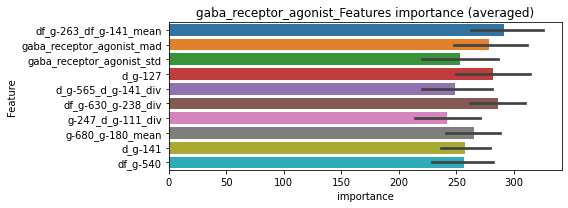

len(train_index) : 2686
len(valid_index) : 896
================================= fold 1/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112513	valid_1's binary_logloss: 0.165142
[200]	training's binary_logloss: 0.044087	valid_1's binary_logloss: 0.100844
[300]	training's binary_logloss: 0.0186446	valid_1's binary_logloss: 0.0717258
[400]	training's binary_logloss: 0.00885153	valid_1's binary_logloss: 0.059493
[500]	training's binary_logloss: 0.0046055	valid_1's binary_logloss: 0.0522486
[600]	training's binary_logloss: 0.00274486	valid_1's binary_logloss: 0.0495651
[700]	training's binary_logloss: 0.00185816	valid_1's binary_logloss: 0.0481726
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00200478	valid_1's binary_logloss: 0.0480718


len(train_index) : 2686
len(valid_index) : 896
================================= fold 2/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109039	valid_1's binary_logloss: 0.172658
[200]	training's binary_logloss: 0.040176	valid_1's binary_logloss: 0.108966
[300]	training's binary_logloss: 0.0175728	valid_1's binary_logloss: 0.0817132
[400]	training's binary_logloss: 0.00818239	valid_1's binary_logloss: 0.0669553
[500]	training's binary_logloss: 0.00435364	valid_1's binary_logloss: 0.0594925
[600]	training's binary_logloss: 0.00263811	valid_1's binary_logloss: 0.0553974
[700]	training's binary_logloss: 0.00178964	valid_1's binary_logloss: 0.0536278
[800]	training's binary_logloss: 0.00134794	valid_1's binary_logloss: 0.0521174
[900]	training's binary_logloss: 0.00108613	valid_1's binary_logloss: 0.0514212
Early stopping, best iteration is:
[908]	training's binary_logloss: 0.00106949	valid_1's binary_logloss: 0.0513227


len(train_index) : 2687
len(valid_index) : 895
================================= fold 3/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110836	valid_1's binary_logloss: 0.178225
[200]	training's binary_logloss: 0.0415719	valid_1's binary_logloss: 0.117466
[300]	training's binary_logloss: 0.0180026	valid_1's binary_logloss: 0.0896697
[400]	training's binary_logloss: 0.00835284	valid_1's binary_logloss: 0.0764005
[500]	training's binary_logloss: 0.00436391	valid_1's binary_logloss: 0.0694501
[600]	training's binary_logloss: 0.00262103	valid_1's binary_logloss: 0.0664992
[700]	training's binary_logloss: 0.00178628	valid_1's binary_logloss: 0.0648423
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.0019747	valid_1's binary_logloss: 0.0645073


len(train_index) : 2687
len(valid_index) : 895
================================= fold 4/4 gaba_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109107	valid_1's binary_logloss: 0.164651
[200]	training's binary_logloss: 0.0404198	valid_1's binary_logloss: 0.099123
[300]	training's binary_logloss: 0.0176492	valid_1's binary_logloss: 0.0706152
[400]	training's binary_logloss: 0.00833951	valid_1's binary_logloss: 0.0575384
[500]	training's binary_logloss: 0.00425274	valid_1's binary_logloss: 0.0514588
[600]	training's binary_logloss: 0.00256804	valid_1's binary_logloss: 0.0483993
[700]	training's binary_logloss: 0.00176358	valid_1's binary_logloss: 0.0471242
[800]	training's binary_logloss: 0.00133526	valid_1's binary_logloss: 0.0456054
[900]	training's binary_logloss: 0.00108689	valid_1's binary_logloss: 0.045167
[1000]	training's binary_logloss: 0.000939184	valid_1's binary_logloss: 0.0448787
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.00096004	valid_1's binary_logloss: 0.0446722


gaba_receptor_agonist logloss: 0.052142151386703986


neg labels: 3289 → selected neg labels: 3266


gaba_receptor_antagonist, len(trt): 165, len(othr): 3266, target_rate: 0.0069287 → Adj_target_rate: 0.0064426
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.18423	valid_1's binary_logloss: 0.293962
[200]	training's binary_logloss: 0.0982832	valid_1's binary_logloss: 0.238381
[300]	training's binary_logloss: 0.0578023	valid_1's binary_logloss: 0.209779
[400]	training's binary_logloss: 0.0354091	valid_1's binary_logloss: 0.195315
[500]	training's binary_logloss: 0.0214178	valid_1's binary_logloss: 0.186419
[600]	training's binary_logloss: 0.0133708	valid_1's binary_logloss: 0.181283
Early stopping, best iteration is:
[645]	training's binary_logloss: 0.0108851	valid_1's binary_logloss: 0.180125
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.18827	valid_1's binary_logloss: 0.29075
[200]	training's binary_logloss: 0.103972	valid_1's binary_logloss: 0.2438
[300]	training's binary_logloss: 0.0615798	valid_1's binary_logloss: 0.217814
[400]	training's binary_logloss: 0.0380095	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.950
y_Threshold: 0.0671584, Threshold: 0.3675706, pos_neg_ratio: 0.8000000
Remove_noisy_data: 309 → Positive_corect_labels: 564/3610
p_label_rate: 0.0100452 Vs.target_rate: 0.00693, Num_p_label: 40.0, conf_0:0.25730, conf_1:0.47784
threshold: 0.3675706, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 564.0/3610, y_label_rate: 0.1562327
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138113	valid_1's binary_logloss: 0.218105
[200]	training's binary_logloss: 0.0641284	valid_1's binary_logloss: 0.159441
[300]	training's binary_logloss: 0.0314166	valid_1's binary_logloss: 0.127394
[400]	training's binary_logloss: 0.0163055	valid_1's binary_logloss: 0.111496
[500]	training's binary_logloss: 0.00894491	valid_1's binary_logloss: 0.101076
[600]	training's binary_logloss: 0.00529028	valid_1's binary_logloss: 0.0956571
[700]	training's binary_logloss: 0.00341106	valid_1's binary_logloss: 0.0937339
[800]	training's binary_logloss: 0.00239263	valid_1's binary_logloss: 0.0915807
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.002106	valid_1's binary_logloss: 0.0904592
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141241	valid_1's binary_logloss: 0.223145
[200]	training's binary_logloss: 0.0674715	valid_1's binar

2 / 3 AUC score:0.988
y_Threshold: 0.0992570, Threshold: 0.3675706, pos_neg_ratio: 0.8000000
Remove_noisy_data: 90 → Positive_corect_labels: 519.0/3520
p_label_rate: 0.0311401 Vs.target_rate: 0.00693, Num_p_label: 124.0, conf_0:0.29406, conf_1:0.44108
Num_p_label: 124.0, Expected: 27.6, Adj_threshold_1: 0.3675706
Num_p_label: 117.0, Expected: 27.6, Adj_threshold_2: 0.4175706
Num_p_label: 107.0, Expected: 27.6, Adj_threshold_3: 0.4675706
Num_p_label: 101.0, Expected: 27.6, Adj_threshold_4: 0.5175706
Num_p_label: 93.0, Expected: 27.6, Adj_threshold_5: 0.5675706
Num_p_label: 88.0, Expected: 27.6, Adj_threshold_6: 0.6175706
Num_p_label: 81.0, Expected: 27.6, Adj_threshold_7: 0.6675706
Num_p_label: 75.0, Expected: 27.6, Adj_threshold_8: 0.7175706
Num_p_label: 67.0, Expected: 27.6, Adj_threshold_9: 0.7675706
threshold: 0.7675706, positive_p_label: 67.0/3982, p_label_rate: 0.0168257
positive_y_label: 519.0/3520, y_label_rate: 0.1474432
================= Pseudo labeling 3 / 3 =================

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117086	valid_1's binary_logloss: 0.200041
[200]	training's binary_logloss: 0.0491406	valid_1's binary_logloss: 0.143409
[300]	training's binary_logloss: 0.0236584	valid_1's binary_logloss: 0.120214
[400]	training's binary_logloss: 0.0121208	valid_1's binary_logloss: 0.107791
[500]	training's binary_logloss: 0.00643556	valid_1's binary_logloss: 0.101494
[600]	training's binary_logloss: 0.00374738	valid_1's binary_logloss: 0.0982923
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.0034081	valid_1's binary_logloss: 0.097476
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114944	valid_1's binary_logloss: 0.189839
[200]	training's binary_logloss: 0.0482273	valid_1's binary_logloss: 0.134458
[300]	training's binary_logloss: 0.0227294	valid_1's binary_logloss: 0.10754
[400]	training's binary_logloss: 0.0115504	valid_1's binary_log

3 / 3 AUC score:0.993
y_Threshold: 0.0831017, Threshold: 0.7675706, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 491.0/3464
p_label_rate: 0.0236062 Vs.target_rate: 0.00693, Num_p_label: 94.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 94.0, Expected: 27.6, Adj_threshold_1: 0.7675706
threshold: 0.7675706, positive_p_label: 94.0/3982, p_label_rate: 0.0236062
positive_y_label: 491.0/3464, y_label_rate: 0.1417436


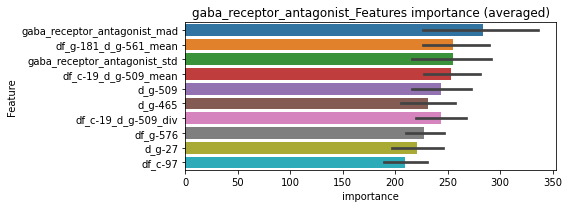

len(train_index) : 2598
len(valid_index) : 866
================================= fold 1/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105693	valid_1's binary_logloss: 0.16612
[200]	training's binary_logloss: 0.0405933	valid_1's binary_logloss: 0.105629
[300]	training's binary_logloss: 0.0185481	valid_1's binary_logloss: 0.0776144
[400]	training's binary_logloss: 0.00895037	valid_1's binary_logloss: 0.062223
[500]	training's binary_logloss: 0.00481199	valid_1's binary_logloss: 0.0537566
[600]	training's binary_logloss: 0.00289925	valid_1's binary_logloss: 0.0488221
[700]	training's binary_logloss: 0.00197984	valid_1's binary_logloss: 0.0452475
Early stopping, best iteration is:
[699]	training's binary_logloss: 0.00198578	valid_1's binary_logloss: 0.0452358


len(train_index) : 2598
len(valid_index) : 866
================================= fold 2/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108537	valid_1's binary_logloss: 0.141319
[200]	training's binary_logloss: 0.0435607	valid_1's binary_logloss: 0.0772043
[300]	training's binary_logloss: 0.0198535	valid_1's binary_logloss: 0.0495677
[400]	training's binary_logloss: 0.00960719	valid_1's binary_logloss: 0.0346049
[500]	training's binary_logloss: 0.00506745	valid_1's binary_logloss: 0.0267711
[600]	training's binary_logloss: 0.00308053	valid_1's binary_logloss: 0.0226483
[700]	training's binary_logloss: 0.00209428	valid_1's binary_logloss: 0.0199978
[800]	training's binary_logloss: 0.0015601	valid_1's binary_logloss: 0.018369
[900]	training's binary_logloss: 0.00125816	valid_1's binary_logloss: 0.0172526
[1000]	training's binary_logloss: 0.00108476	valid_1's binary_logloss: 0.016541
[1100]	training's binary_logloss: 0.000985986	valid_1's binary_logloss: 0.0161983
Early stopping, best iteration is:
[1110]	training's binary_logl

len(train_index) : 2598
len(valid_index) : 866
================================= fold 3/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106682	valid_1's binary_logloss: 0.171782
[200]	training's binary_logloss: 0.0409883	valid_1's binary_logloss: 0.118321
[300]	training's binary_logloss: 0.0179658	valid_1's binary_logloss: 0.0932459
[400]	training's binary_logloss: 0.00854995	valid_1's binary_logloss: 0.0840363
[500]	training's binary_logloss: 0.00451978	valid_1's binary_logloss: 0.0772273
[600]	training's binary_logloss: 0.00273841	valid_1's binary_logloss: 0.0747043
[700]	training's binary_logloss: 0.00186846	valid_1's binary_logloss: 0.072297
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.00154906	valid_1's binary_logloss: 0.0713011


len(train_index) : 2598
len(valid_index) : 866
================================= fold 4/4 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103432	valid_1's binary_logloss: 0.184504
[200]	training's binary_logloss: 0.0383225	valid_1's binary_logloss: 0.126613
[300]	training's binary_logloss: 0.0174815	valid_1's binary_logloss: 0.102212
[400]	training's binary_logloss: 0.00829179	valid_1's binary_logloss: 0.0911106
[500]	training's binary_logloss: 0.0043724	valid_1's binary_logloss: 0.0852874
[600]	training's binary_logloss: 0.00267389	valid_1's binary_logloss: 0.0843721
Early stopping, best iteration is:
[578]	training's binary_logloss: 0.00294468	valid_1's binary_logloss: 0.0839906


gaba_receptor_antagonist logloss: 0.0541760530178255


neg labels: 3289 → selected neg labels: 3284


gamma_secretase_inhibitor, len(trt): 56, len(othr): 3284, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128529	valid_1's binary_logloss: 0.187067
[200]	training's binary_logloss: 0.053164	valid_1's binary_logloss: 0.117124
[300]	training's binary_logloss: 0.0246655	valid_1's binary_logloss: 0.0832139
[400]	training's binary_logloss: 0.0121636	valid_1's binary_logloss: 0.0654354
[500]	training's binary_logloss: 0.00630912	valid_1's binary_logloss: 0.0549571
[600]	training's binary_logloss: 0.00362855	valid_1's binary_logloss: 0.0494186
[700]	training's binary_logloss: 0.00232676	valid_1's binary_logloss: 0.0466488
[800]	training's binary_logloss: 0.00168012	valid_1's binary_logloss: 0.0450531
[900]	training's binary_logloss: 0.00130796	valid_1's binary_logloss: 0.0435129
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.00120774	valid_1's binary_logloss: 0.0433241
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127187	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0197881, Threshold: 0.1051566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 651/3798
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.07361, conf_1:0.13670
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.1051566
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_2: 0.1551566
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_3: 0.2051566
threshold: 0.2051566, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126205	valid_1's binary_logloss: 0.170041
[200]	training's binary_logloss: 0.0480333	valid_1's binary_logloss: 0.090646
[300]	training's binary_logloss: 0.0211999	valid_1's binary_logloss: 0.0587121
[400]	training's binary_logloss: 0.00982553	valid_1's binary_logloss: 0.0417524
[500]	training's binary_logloss: 0.00500604	valid_1's binary_logloss: 0.0331956
[600]	training's binary_logloss: 0.00290418	valid_1's binary_logloss: 0.0285411
[700]	training's binary_logloss: 0.00193069	valid_1's binary_logloss: 0.0259998
[800]	training's binary_logloss: 0.00142598	valid_1's binary_logloss: 0.0247669
[900]	training's binary_logloss: 0.00113535	valid_1's binary_logloss: 0.0239538
[1000]	training's binary_logloss: 0.000966136	valid_1's binary_logloss: 0.0235456
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000908845	valid_1's binary_logloss: 0.0234072
Training until validation 

2 / 3 AUC score:0.999
y_Threshold: 0.1087627, Threshold: 0.2051566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 641.0/3778
p_label_rate: 0.0130588 Vs.target_rate: 0.00235, Num_p_label: 52.0, conf_0:0.16413, conf_1:0.24619
Num_p_label: 52.0, Expected: 9.4, Adj_threshold_1: 0.2051566
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_2: 0.2551566
Num_p_label: 42.0, Expected: 9.4, Adj_threshold_3: 0.3051566
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_4: 0.3551566
Num_p_label: 35.0, Expected: 9.4, Adj_threshold_5: 0.4051566
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_6: 0.4551566
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_7: 0.5051566
Num_p_label: 22.0, Expected: 9.4, Adj_threshold_8: 0.5551566
threshold: 0.5551566, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 641.0/3778, y_label_rate: 0.1696665
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120869	valid_1's binary_logloss: 0.188695
[200]	training's binary_logloss: 0.0475774	valid_1's binary_logloss: 0.113531
[300]	training's binary_logloss: 0.0211196	valid_1's binary_logloss: 0.0818328
[400]	training's binary_logloss: 0.00964943	valid_1's binary_logloss: 0.0659406
[500]	training's binary_logloss: 0.0048614	valid_1's binary_logloss: 0.0577419
[600]	training's binary_logloss: 0.00279825	valid_1's binary_logloss: 0.052785
[700]	training's binary_logloss: 0.00185202	valid_1's binary_logloss: 0.0510186
[800]	training's binary_logloss: 0.00136679	valid_1's binary_logloss: 0.0509624
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.00147586	valid_1's binary_logloss: 0.0507203
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119225	valid_1's binary_logloss: 0.164214
[200]	training's binary_logloss: 0.0466783	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.1008925, Threshold: 0.5551566, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 631.0/3758
p_label_rate: 0.0080362 Vs.target_rate: 0.00235, Num_p_label: 32.0, conf_0:0.49964, conf_1:0.61067
Num_p_label: 32.0, Expected: 9.4, Adj_threshold_1: 0.5551566
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_2: 0.6051566
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_3: 0.6551566
threshold: 0.6551566, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 631.0/3758, y_label_rate: 0.1679085


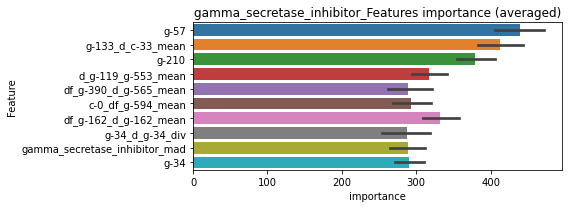

len(train_index) : 2818
len(valid_index) : 940
================================= fold 1/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118713	valid_1's binary_logloss: 0.170714
[200]	training's binary_logloss: 0.0432201	valid_1's binary_logloss: 0.0971253
[300]	training's binary_logloss: 0.0183023	valid_1's binary_logloss: 0.0678185
[400]	training's binary_logloss: 0.00842339	valid_1's binary_logloss: 0.05481
[500]	training's binary_logloss: 0.00431367	valid_1's binary_logloss: 0.0487174
[600]	training's binary_logloss: 0.00253099	valid_1's binary_logloss: 0.0451273
[700]	training's binary_logloss: 0.00169742	valid_1's binary_logloss: 0.0429983
[800]	training's binary_logloss: 0.00127311	valid_1's binary_logloss: 0.0421262
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.00110182	valid_1's binary_logloss: 0.0420121


len(train_index) : 2818
len(valid_index) : 940
================================= fold 2/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11787	valid_1's binary_logloss: 0.17447
[200]	training's binary_logloss: 0.0443213	valid_1's binary_logloss: 0.0909784
[300]	training's binary_logloss: 0.0188416	valid_1's binary_logloss: 0.0556135
[400]	training's binary_logloss: 0.00857285	valid_1's binary_logloss: 0.037748
[500]	training's binary_logloss: 0.00442206	valid_1's binary_logloss: 0.03008
[600]	training's binary_logloss: 0.00261406	valid_1's binary_logloss: 0.0256913
[700]	training's binary_logloss: 0.00174289	valid_1's binary_logloss: 0.023336
[800]	training's binary_logloss: 0.001293	valid_1's binary_logloss: 0.0222093
[900]	training's binary_logloss: 0.00103467	valid_1's binary_logloss: 0.0210651
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00101599	valid_1's binary_logloss: 0.0209832


len(train_index) : 2819
len(valid_index) : 939
================================= fold 3/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114831	valid_1's binary_logloss: 0.157326
[200]	training's binary_logloss: 0.0430801	valid_1's binary_logloss: 0.0840346
[300]	training's binary_logloss: 0.0181241	valid_1's binary_logloss: 0.0520758
[400]	training's binary_logloss: 0.00820088	valid_1's binary_logloss: 0.0369053
[500]	training's binary_logloss: 0.00414938	valid_1's binary_logloss: 0.0292237
[600]	training's binary_logloss: 0.00249033	valid_1's binary_logloss: 0.0253278
[700]	training's binary_logloss: 0.00168923	valid_1's binary_logloss: 0.0236783
[800]	training's binary_logloss: 0.00126535	valid_1's binary_logloss: 0.0222615
[900]	training's binary_logloss: 0.00101548	valid_1's binary_logloss: 0.0216469
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.00105522	valid_1's binary_logloss: 0.0214695


len(train_index) : 2819
len(valid_index) : 939
================================= fold 4/4 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120321	valid_1's binary_logloss: 0.156744
[200]	training's binary_logloss: 0.0468163	valid_1's binary_logloss: 0.0836673
[300]	training's binary_logloss: 0.0198472	valid_1's binary_logloss: 0.0525175
[400]	training's binary_logloss: 0.00908004	valid_1's binary_logloss: 0.0366056
[500]	training's binary_logloss: 0.0046045	valid_1's binary_logloss: 0.0280153
[600]	training's binary_logloss: 0.00268702	valid_1's binary_logloss: 0.0235266
[700]	training's binary_logloss: 0.00178563	valid_1's binary_logloss: 0.0208549
[800]	training's binary_logloss: 0.00132111	valid_1's binary_logloss: 0.0192761
[900]	training's binary_logloss: 0.00105213	valid_1's binary_logloss: 0.018452
[1000]	training's binary_logloss: 0.000899218	valid_1's binary_logloss: 0.0179073
[1100]	training's binary_logloss: 0.000821646	valid_1's binary_logloss: 0.0176012
[1200]	training's binary_logloss: 0.000771222	valid_1's binary

gamma_secretase_inhibitor logloss: 0.025456645981555937


neg labels: 3289 → selected neg labels: 3248


glucocorticoid_receptor_agonist, len(trt): 266, len(othr): 3248, target_rate: 0.0111699 → Adj_target_rate: 0.0096682
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.226088	valid_1's binary_logloss: 0.360734
[200]	training's binary_logloss: 0.140687	valid_1's binary_logloss: 0.328354
[300]	training's binary_logloss: 0.0922345	valid_1's binary_logloss: 0.310742
[400]	training's binary_logloss: 0.0617308	valid_1's binary_logloss: 0.306121
[500]	training's binary_logloss: 0.0421534	valid_1's binary_logloss: 0.300829
[600]	training's binary_logloss: 0.0294458	valid_1's binary_logloss: 0.300799
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.0330052	valid_1's binary_logloss: 0.300036
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.230695	valid_1's binary_logloss: 0.355329
[200]	training's binary_logloss: 0.14124	valid_1's binary_logloss: 0.321438
[300]	training's binary_logloss: 0.0939329	valid_1's binary_logloss: 0.306607
[400]	training's binary_logloss: 0.0630711	valid_1's binary_logloss:

1 / 3 AUC score:0.869
y_Threshold: 0.1120126, Threshold: 0.3540679, pos_neg_ratio: 0.8000000
Remove_noisy_data: 469 → Positive_corect_labels: 480/3428
p_label_rate: 0.0100452 Vs.target_rate: 0.01117, Num_p_label: 40.0, conf_0:0.24785, conf_1:0.46029
threshold: 0.3540679, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 480.0/3428, y_label_rate: 0.1400233
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151187	valid_1's binary_logloss: 0.241989
[200]	training's binary_logloss: 0.0748606	valid_1's binary_logloss: 0.190613
[300]	training's binary_logloss: 0.0417715	valid_1's binary_logloss: 0.165323
[400]	training's binary_logloss: 0.0242467	valid_1's binary_logloss: 0.150475
[500]	training's binary_logloss: 0.0138736	valid_1's binary_logloss: 0.138822
[600]	training's binary_logloss: 0.00845705	valid_1's binary_logloss: 0.133177
[700]	training's binary_logloss: 0.00544775	valid_1's binary_logloss: 0.130077
[800]	training's binary_logloss: 0.00377289	valid_1's binary_logloss: 0.127773
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.00322406	valid_1's binary_logloss: 0.126855
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146195	valid_1's binary_logloss: 0.25421
[200]	training's binary_logloss: 0.0712993	valid_1's binary_lo

2 / 3 AUC score:0.960
y_Threshold: 0.1201640, Threshold: 0.3540679, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 410.0/3288
p_label_rate: 0.0341537 Vs.target_rate: 0.01117, Num_p_label: 136.0, conf_0:0.28325, conf_1:0.42488
Num_p_label: 136.0, Expected: 44.5, Adj_threshold_1: 0.3540679
Num_p_label: 117.0, Expected: 44.5, Adj_threshold_2: 0.4040679
Num_p_label: 95.0, Expected: 44.5, Adj_threshold_3: 0.4540679
Num_p_label: 75.0, Expected: 44.5, Adj_threshold_4: 0.5040679
Num_p_label: 59.0, Expected: 44.5, Adj_threshold_5: 0.5540679
threshold: 0.5540679, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 410.0/3288, y_label_rate: 0.1246959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115467	valid_1's binary_logloss: 0.197204
[200]	training's binary_logloss: 0.049896	valid_1's binary_logloss: 0.148228
[300]	training's binary_logloss: 0.0241972	valid_1's binary_logloss: 0.125136
[400]	training's binary_logloss: 0.0128195	valid_1's binary_logloss: 0.114319
[500]	training's binary_logloss: 0.00721984	valid_1's binary_logloss: 0.109482
[600]	training's binary_logloss: 0.00446569	valid_1's binary_logloss: 0.105209
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.0043563	valid_1's binary_logloss: 0.105119
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114387	valid_1's binary_logloss: 0.196559
[200]	training's binary_logloss: 0.0508692	valid_1's binary_logloss: 0.145817
[300]	training's binary_logloss: 0.0250223	valid_1's binary_logloss: 0.119931
[400]	training's binary_logloss: 0.013254	valid_1's binary_loglo

3 / 3 AUC score:0.981
y_Threshold: 0.0934979, Threshold: 0.5540679, pos_neg_ratio: 0.8000000
Remove_noisy_data: 86 → Positive_corect_labels: 367.0/3202
p_label_rate: 0.0296334 Vs.target_rate: 0.01117, Num_p_label: 118.0, conf_0:0.49866, conf_1:0.60947
Num_p_label: 118.0, Expected: 44.5, Adj_threshold_1: 0.5540679
Num_p_label: 98.0, Expected: 44.5, Adj_threshold_2: 0.6040679
Num_p_label: 86.0, Expected: 44.5, Adj_threshold_3: 0.6540679
Num_p_label: 71.0, Expected: 44.5, Adj_threshold_4: 0.7040679
Num_p_label: 59.0, Expected: 44.5, Adj_threshold_5: 0.7540679
threshold: 0.7540679, positive_p_label: 59.0/3982, p_label_rate: 0.0148167
positive_y_label: 367.0/3202, y_label_rate: 0.1146159


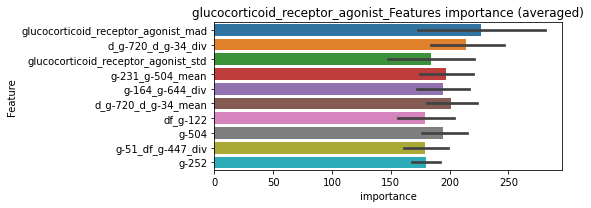

len(train_index) : 2401
len(valid_index) : 801
================================= fold 1/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0995161	valid_1's binary_logloss: 0.16439
[200]	training's binary_logloss: 0.0405852	valid_1's binary_logloss: 0.112276
[300]	training's binary_logloss: 0.0182511	valid_1's binary_logloss: 0.0873184
[400]	training's binary_logloss: 0.00901436	valid_1's binary_logloss: 0.0744195
[500]	training's binary_logloss: 0.00494645	valid_1's binary_logloss: 0.0668314
[600]	training's binary_logloss: 0.00305965	valid_1's binary_logloss: 0.0616968
[700]	training's binary_logloss: 0.00211676	valid_1's binary_logloss: 0.0585735
[800]	training's binary_logloss: 0.00159602	valid_1's binary_logloss: 0.0571266
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.00140702	valid_1's binary_logloss: 0.055908


len(train_index) : 2401
len(valid_index) : 801
================================= fold 2/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0982419	valid_1's binary_logloss: 0.170854
[200]	training's binary_logloss: 0.0396432	valid_1's binary_logloss: 0.121825
[300]	training's binary_logloss: 0.0183707	valid_1's binary_logloss: 0.0996856
[400]	training's binary_logloss: 0.00898934	valid_1's binary_logloss: 0.0839509
[500]	training's binary_logloss: 0.00487191	valid_1's binary_logloss: 0.0760707
[600]	training's binary_logloss: 0.00303597	valid_1's binary_logloss: 0.0717815
[700]	training's binary_logloss: 0.00210818	valid_1's binary_logloss: 0.0693671
[800]	training's binary_logloss: 0.00159705	valid_1's binary_logloss: 0.0680095
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.00150543	valid_1's binary_logloss: 0.0672943


len(train_index) : 2402
len(valid_index) : 800
================================= fold 3/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985651	valid_1's binary_logloss: 0.181714
[200]	training's binary_logloss: 0.0397259	valid_1's binary_logloss: 0.130102
[300]	training's binary_logloss: 0.0178291	valid_1's binary_logloss: 0.105154
[400]	training's binary_logloss: 0.00896462	valid_1's binary_logloss: 0.0939149
[500]	training's binary_logloss: 0.00483313	valid_1's binary_logloss: 0.0885403
[600]	training's binary_logloss: 0.002994	valid_1's binary_logloss: 0.0855859
[700]	training's binary_logloss: 0.00207114	valid_1's binary_logloss: 0.0846909
Early stopping, best iteration is:
[678]	training's binary_logloss: 0.00223051	valid_1's binary_logloss: 0.0843876


len(train_index) : 2402
len(valid_index) : 800
================================= fold 4/4 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0991165	valid_1's binary_logloss: 0.160916
[200]	training's binary_logloss: 0.039455	valid_1's binary_logloss: 0.108853
[300]	training's binary_logloss: 0.017924	valid_1's binary_logloss: 0.0838999
[400]	training's binary_logloss: 0.00890872	valid_1's binary_logloss: 0.0720604
[500]	training's binary_logloss: 0.00490426	valid_1's binary_logloss: 0.0629059
[600]	training's binary_logloss: 0.00303833	valid_1's binary_logloss: 0.0576891
[700]	training's binary_logloss: 0.00210863	valid_1's binary_logloss: 0.0541998
[800]	training's binary_logloss: 0.00160707	valid_1's binary_logloss: 0.0528826
[900]	training's binary_logloss: 0.00129681	valid_1's binary_logloss: 0.0514545
[1000]	training's binary_logloss: 0.00110712	valid_1's binary_logloss: 0.0505009
[1100]	training's binary_logloss: 0.00100411	valid_1's binary_logloss: 0.0498546
Early stopping, best iteration is:
[1109]	training's binary_logl

glucocorticoid_receptor_agonist logloss: 0.0643407325879906


neg labels: 3289 → selected neg labels: 3285


glutamate_inhibitor, len(trt): 13, len(othr): 3285, target_rate: 0.0005459 → Adj_target_rate: 0.0007431
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0591817	valid_1's binary_logloss: 0.073259
[200]	training's binary_logloss: 0.0136124	valid_1's binary_logloss: 0.0219935
[300]	training's binary_logloss: 0.0039208	valid_1's binary_logloss: 0.00899307
[400]	training's binary_logloss: 0.00152827	valid_1's binary_logloss: 0.00523284
[500]	training's binary_logloss: 0.000813788	valid_1's binary_logloss: 0.00376136
[600]	training's binary_logloss: 0.000533156	valid_1's binary_logloss: 0.00302317
[700]	training's binary_logloss: 0.000405399	valid_1's binary_logloss: 0.0027428
[800]	training's binary_logloss: 0.000352894	valid_1's binary_logloss: 0.0026405
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.000350452	valid_1's binary_logloss: 0.00262001
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0595379	valid_1's binary_logloss: 0.0706718
[200]	training's binary_logloss: 0.013

1 / 3 AUC score:1.000
y_Threshold: 0.0023631, Threshold: 0.0156355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00055, Num_p_label: 40.0, conf_0:0.01094, conf_1:0.02033
Num_p_label: 40.0, Expected: 2.2, Adj_threshold_1: 0.0156355
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_2: 0.0656355
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_3: 0.1156355
threshold: 0.1156355, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0576319	valid_1's binary_logloss: 0.0695153
[200]	training's binary_logloss: 0.0121756	valid_1's binary_logloss: 0.0191075
[300]	training's binary_logloss: 0.00329577	valid_1's binary_logloss: 0.00723374
[400]	training's binary_logloss: 0.00129195	valid_1's binary_logloss: 0.00387529
[500]	training's binary_logloss: 0.00069138	valid_1's binary_logloss: 0.00272528
[600]	training's binary_logloss: 0.000459546	valid_1's binary_logloss: 0.00222751
[700]	training's binary_logloss: 0.000351941	valid_1's binary_logloss: 0.0019378
[800]	training's binary_logloss: 0.000310156	valid_1's binary_logloss: 0.00183506
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000308244	valid_1's binary_logloss: 0.00182088
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579966	valid_1's binary_logloss: 0.0687214
[200]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1447757, Threshold: 0.1156355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00055, Num_p_label: 21.0, conf_0:0.09251, conf_1:0.13876
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_1: 0.1156355
Num_p_label: 18.0, Expected: 2.2, Adj_threshold_2: 0.1656355
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_3: 0.2156355
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_4: 0.2656355
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_5: 0.3156355
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_6: 0.3656355
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_7: 0.4156355
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_8: 0.4656355
threshold: 0.4656355, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0576319	valid_1's binary_logloss: 0.0695153
[200]	training's binary_logloss: 0.0121756	valid_1's binary_logloss: 0.0191075
[300]	training's binary_logloss: 0.00329577	valid_1's binary_logloss: 0.00723374
[400]	training's binary_logloss: 0.00129195	valid_1's binary_logloss: 0.00387529
[500]	training's binary_logloss: 0.00069138	valid_1's binary_logloss: 0.00272528
[600]	training's binary_logloss: 0.000459546	valid_1's binary_logloss: 0.00222751
[700]	training's binary_logloss: 0.000351941	valid_1's binary_logloss: 0.0019378
[800]	training's binary_logloss: 0.000310156	valid_1's binary_logloss: 0.00183506
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000308244	valid_1's binary_logloss: 0.00182088
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579966	valid_1's binary_logloss: 0.0687214
[200]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1447757, Threshold: 0.4656355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0012557 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.41907, conf_1:0.51220
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_1: 0.4656355
threshold: 0.4656355, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


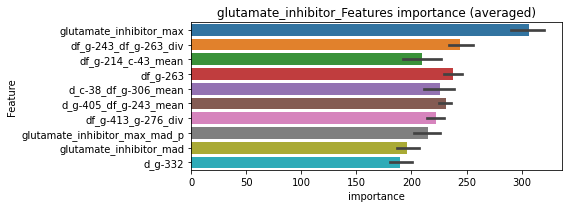

len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0586436	valid_1's binary_logloss: 0.070495
[200]	training's binary_logloss: 0.0123369	valid_1's binary_logloss: 0.0190835
[300]	training's binary_logloss: 0.00345091	valid_1's binary_logloss: 0.007194
[400]	training's binary_logloss: 0.00137605	valid_1's binary_logloss: 0.00378061
[500]	training's binary_logloss: 0.000702107	valid_1's binary_logloss: 0.00250169
[600]	training's binary_logloss: 0.000462474	valid_1's binary_logloss: 0.00197104
[700]	training's binary_logloss: 0.000350741	valid_1's binary_logloss: 0.00172095
[800]	training's binary_logloss: 0.00030764	valid_1's binary_logloss: 0.0016075
Early stopping, best iteration is:
[794]	training's binary_logloss: 0.000308672	valid_1's binary_logloss: 0.00160698


len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0583141	valid_1's binary_logloss: 0.067477
[200]	training's binary_logloss: 0.0123218	valid_1's binary_logloss: 0.0176925
[300]	training's binary_logloss: 0.00337352	valid_1's binary_logloss: 0.00598862
[400]	training's binary_logloss: 0.00129705	valid_1's binary_logloss: 0.0026903
[500]	training's binary_logloss: 0.000690839	valid_1's binary_logloss: 0.00161881
[600]	training's binary_logloss: 0.000457917	valid_1's binary_logloss: 0.00116523
[700]	training's binary_logloss: 0.000351607	valid_1's binary_logloss: 0.000952056
[800]	training's binary_logloss: 0.000317864	valid_1's binary_logloss: 0.000885583
Early stopping, best iteration is:
[812]	training's binary_logloss: 0.000315521	valid_1's binary_logloss: 0.000882881


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0589347	valid_1's binary_logloss: 0.0686932
[200]	training's binary_logloss: 0.0124243	valid_1's binary_logloss: 0.0172325
[300]	training's binary_logloss: 0.00342543	valid_1's binary_logloss: 0.00577055
[400]	training's binary_logloss: 0.00132403	valid_1's binary_logloss: 0.00266192
[500]	training's binary_logloss: 0.000701595	valid_1's binary_logloss: 0.00156575
[600]	training's binary_logloss: 0.000466124	valid_1's binary_logloss: 0.00111961
[700]	training's binary_logloss: 0.000354128	valid_1's binary_logloss: 0.000895933
[800]	training's binary_logloss: 0.000316437	valid_1's binary_logloss: 0.000823888
Early stopping, best iteration is:
[808]	training's binary_logloss: 0.000316195	valid_1's binary_logloss: 0.000823532


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 glutamate_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0589431	valid_1's binary_logloss: 0.069373
[200]	training's binary_logloss: 0.0123974	valid_1's binary_logloss: 0.017472
[300]	training's binary_logloss: 0.00338074	valid_1's binary_logloss: 0.00577903
[400]	training's binary_logloss: 0.00132073	valid_1's binary_logloss: 0.00261684
[500]	training's binary_logloss: 0.000706311	valid_1's binary_logloss: 0.0016017
[600]	training's binary_logloss: 0.000468973	valid_1's binary_logloss: 0.00116544
[700]	training's binary_logloss: 0.000356747	valid_1's binary_logloss: 0.000934357
[800]	training's binary_logloss: 0.000316711	valid_1's binary_logloss: 0.000862133
Early stopping, best iteration is:
[791]	training's binary_logloss: 0.000317296	valid_1's binary_logloss: 0.000861566


glutamate_inhibitor logloss: 0.0010441766549442201


neg labels: 3289 → selected neg labels: 3283


glutamate_receptor_agonist, len(trt): 74, len(othr): 3283, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122733	valid_1's binary_logloss: 0.200294
[200]	training's binary_logloss: 0.0498289	valid_1's binary_logloss: 0.134085
[300]	training's binary_logloss: 0.0231462	valid_1's binary_logloss: 0.104148
[400]	training's binary_logloss: 0.0114787	valid_1's binary_logloss: 0.0895003
[500]	training's binary_logloss: 0.0062203	valid_1's binary_logloss: 0.0812907
[600]	training's binary_logloss: 0.00365626	valid_1's binary_logloss: 0.0760704
[700]	training's binary_logloss: 0.00241338	valid_1's binary_logloss: 0.0733072
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00197466	valid_1's binary_logloss: 0.0726315
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126033	valid_1's binary_logloss: 0.182611
[200]	training's binary_logloss: 0.0517728	valid_1's binary_logloss: 0.109719
[300]	training's binary_logloss: 0.0236403	valid_1's bina

1 / 3 AUC score:0.993
y_Threshold: 0.0339274, Threshold: 0.3539309, pos_neg_ratio: 0.8000000
Remove_noisy_data: 164 → Positive_corect_labels: 640/3775
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.24775, conf_1:0.46011
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.3539309
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_2: 0.4039309
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_3: 0.4539309
Num_p_label: 17.0, Expected: 12.4, Adj_threshold_4: 0.5039309
threshold: 0.5039309, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 640.0/3775, y_label_rate: 0.1695364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114516	valid_1's binary_logloss: 0.168982
[200]	training's binary_logloss: 0.0419157	valid_1's binary_logloss: 0.0970123
[300]	training's binary_logloss: 0.0173541	valid_1's binary_logloss: 0.0659188
[400]	training's binary_logloss: 0.00808411	valid_1's binary_logloss: 0.051427
[500]	training's binary_logloss: 0.0043066	valid_1's binary_logloss: 0.0439975
[600]	training's binary_logloss: 0.00261286	valid_1's binary_logloss: 0.0400451
[700]	training's binary_logloss: 0.00178408	valid_1's binary_logloss: 0.0383094
Early stopping, best iteration is:
[722]	training's binary_logloss: 0.00166784	valid_1's binary_logloss: 0.0381326
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113082	valid_1's binary_logloss: 0.164212
[200]	training's binary_logloss: 0.0416034	valid_1's binary_logloss: 0.0959579
[300]	training's binary_logloss: 0.0174248	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.0894993, Threshold: 0.5039309, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 621.0/3737
p_label_rate: 0.0173280 Vs.target_rate: 0.00311, Num_p_label: 69.0, conf_0:0.40314, conf_1:0.60472
Num_p_label: 69.0, Expected: 12.4, Adj_threshold_1: 0.5039309
Num_p_label: 58.0, Expected: 12.4, Adj_threshold_2: 0.5539309
Num_p_label: 46.0, Expected: 12.4, Adj_threshold_3: 0.6039309
Num_p_label: 38.0, Expected: 12.4, Adj_threshold_4: 0.6539309
Num_p_label: 28.0, Expected: 12.4, Adj_threshold_5: 0.7039309
Num_p_label: 26.0, Expected: 12.4, Adj_threshold_6: 0.7539309
threshold: 0.7539309, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 621.0/3737, y_label_rate: 0.1661761
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105467	valid_1's binary_logloss: 0.162318
[200]	training's binary_logloss: 0.0377375	valid_1's binary_logloss: 0.0932923
[300]	training's binary_logloss: 0.0155611	valid_1's binary_logloss: 0.0651915
[400]	training's binary_logloss: 0.00724838	valid_1's binary_logloss: 0.0524713
[500]	training's binary_logloss: 0.00380143	valid_1's binary_logloss: 0.0460653
[600]	training's binary_logloss: 0.00229701	valid_1's binary_logloss: 0.0423784
[700]	training's binary_logloss: 0.00158984	valid_1's binary_logloss: 0.0408107
Early stopping, best iteration is:
[719]	training's binary_logloss: 0.00149989	valid_1's binary_logloss: 0.040359
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108652	valid_1's binary_logloss: 0.150981
[200]	training's binary_logloss: 0.0389153	valid_1's binary_logloss: 0.0820417
[300]	training's binary_logloss: 0.0160794	valid_1's 

3 / 3 AUC score:0.999
y_Threshold: 0.1068555, Threshold: 0.7539309, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 610.0/3715
p_label_rate: 0.0097941 Vs.target_rate: 0.00311, Num_p_label: 39.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 39.0, Expected: 12.4, Adj_threshold_1: 0.7539309
threshold: 0.7539309, positive_p_label: 39.0/3982, p_label_rate: 0.0097941
positive_y_label: 610.0/3715, y_label_rate: 0.1641992


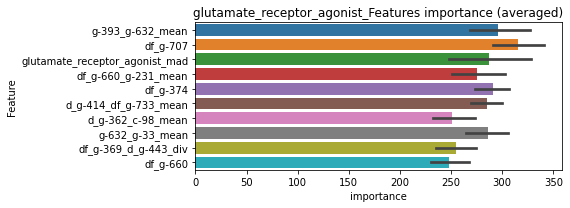

len(train_index) : 2786
len(valid_index) : 929
================================= fold 1/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107182	valid_1's binary_logloss: 0.145658
[200]	training's binary_logloss: 0.0378467	valid_1's binary_logloss: 0.0744646
[300]	training's binary_logloss: 0.015291	valid_1's binary_logloss: 0.0442069
[400]	training's binary_logloss: 0.00707875	valid_1's binary_logloss: 0.0312808
[500]	training's binary_logloss: 0.00371917	valid_1's binary_logloss: 0.0240787
[600]	training's binary_logloss: 0.00225505	valid_1's binary_logloss: 0.0204713
[700]	training's binary_logloss: 0.00156403	valid_1's binary_logloss: 0.0182779
[800]	training's binary_logloss: 0.00118246	valid_1's binary_logloss: 0.0168782
[900]	training's binary_logloss: 0.000960469	valid_1's binary_logloss: 0.0158426
[1000]	training's binary_logloss: 0.000828006	valid_1's binary_logloss: 0.0152179
[1100]	training's binary_logloss: 0.000747465	valid_1's binary_logloss: 0.01505
Early stopping, best iteration is:
[1085]	training's binary_lo

len(train_index) : 2786
len(valid_index) : 929
================================= fold 2/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105928	valid_1's binary_logloss: 0.150627
[200]	training's binary_logloss: 0.036764	valid_1's binary_logloss: 0.0810374
[300]	training's binary_logloss: 0.0149235	valid_1's binary_logloss: 0.0532678
[400]	training's binary_logloss: 0.00691766	valid_1's binary_logloss: 0.0409427
[500]	training's binary_logloss: 0.0036634	valid_1's binary_logloss: 0.0357262
[600]	training's binary_logloss: 0.00224122	valid_1's binary_logloss: 0.0326677
[700]	training's binary_logloss: 0.00155667	valid_1's binary_logloss: 0.0310537
[800]	training's binary_logloss: 0.00118395	valid_1's binary_logloss: 0.0300042
[900]	training's binary_logloss: 0.000966477	valid_1's binary_logloss: 0.0293508
[1000]	training's binary_logloss: 0.000827828	valid_1's binary_logloss: 0.0291611
Early stopping, best iteration is:
[977]	training's binary_logloss: 0.000854196	valid_1's binary_logloss: 0.0290671


len(train_index) : 2786
len(valid_index) : 929
================================= fold 3/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105861	valid_1's binary_logloss: 0.161407
[200]	training's binary_logloss: 0.0366592	valid_1's binary_logloss: 0.0912812
[300]	training's binary_logloss: 0.0147134	valid_1's binary_logloss: 0.063093
[400]	training's binary_logloss: 0.00674761	valid_1's binary_logloss: 0.0513526
[500]	training's binary_logloss: 0.00357004	valid_1's binary_logloss: 0.0445905
[600]	training's binary_logloss: 0.00219464	valid_1's binary_logloss: 0.0412063
[700]	training's binary_logloss: 0.00152419	valid_1's binary_logloss: 0.0398208
[800]	training's binary_logloss: 0.00116237	valid_1's binary_logloss: 0.0391321
[900]	training's binary_logloss: 0.000949147	valid_1's binary_logloss: 0.0381294
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.000923898	valid_1's binary_logloss: 0.0380726


len(train_index) : 2787
len(valid_index) : 928
================================= fold 4/4 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105655	valid_1's binary_logloss: 0.155981
[200]	training's binary_logloss: 0.0358264	valid_1's binary_logloss: 0.081093
[300]	training's binary_logloss: 0.0146674	valid_1's binary_logloss: 0.0519049
[400]	training's binary_logloss: 0.00667387	valid_1's binary_logloss: 0.0380564
[500]	training's binary_logloss: 0.00354454	valid_1's binary_logloss: 0.0310157
[600]	training's binary_logloss: 0.00219052	valid_1's binary_logloss: 0.0271328
[700]	training's binary_logloss: 0.00152646	valid_1's binary_logloss: 0.0247322
[800]	training's binary_logloss: 0.00115952	valid_1's binary_logloss: 0.0229792
[900]	training's binary_logloss: 0.000943292	valid_1's binary_logloss: 0.0224527
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000967892	valid_1's binary_logloss: 0.0223924


glutamate_receptor_agonist logloss: 0.026114007099949852


neg labels: 3289 → selected neg labels: 3235


glutamate_receptor_antagonist, len(trt): 367, len(othr): 3235, target_rate: 0.0154111 → Adj_target_rate: 0.0127105
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.251466	valid_1's binary_logloss: 0.390131
[200]	training's binary_logloss: 0.155315	valid_1's binary_logloss: 0.369743
[300]	training's binary_logloss: 0.104252	valid_1's binary_logloss: 0.364406
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.104531	valid_1's binary_logloss: 0.364277
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.257047	valid_1's binary_logloss: 0.380062
[200]	training's binary_logloss: 0.165032	valid_1's binary_logloss: 0.356482
[300]	training's binary_logloss: 0.111005	valid_1's binary_logloss: 0.34401
[400]	training's binary_logloss: 0.0765697	valid_1's binary_logloss: 0.338794
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.0722028	valid_1's binary_logloss: 0.338284
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.257693	valid_1's b

1 / 3 AUC score:0.793
y_Threshold: 0.1495245, Threshold: 0.4690721, pos_neg_ratio: 0.8000000
Remove_noisy_data: 650 → Positive_corect_labels: 387/3232
p_label_rate: 0.0100452 Vs.target_rate: 0.01541, Num_p_label: 40.0, conf_0:0.32835, conf_1:0.60979
Num_p_label: 40.0, Expected: 61.4, Adj_threshold_1: 0.4690721
Num_p_label: 51.0, Expected: 61.4, Adj_threshold_2: 0.4390721
threshold: 0.4390721, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 387.0/3232, y_label_rate: 0.1197401
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124869	valid_1's binary_logloss: 0.217413
[200]	training's binary_logloss: 0.0553188	valid_1's binary_logloss: 0.179116
[300]	training's binary_logloss: 0.0274605	valid_1's binary_logloss: 0.164286
[400]	training's binary_logloss: 0.014506	valid_1's binary_logloss: 0.159934
[500]	training's binary_logloss: 0.00810364	valid_1's binary_logloss: 0.158097
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.0088592	valid_1's binary_logloss: 0.157718
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126221	valid_1's binary_logloss: 0.213586
[200]	training's binary_logloss: 0.0565531	valid_1's binary_logloss: 0.175574
[300]	training's binary_logloss: 0.02766	valid_1's binary_logloss: 0.159547
[400]	training's binary_logloss: 0.0150554	valid_1's binary_logloss: 0.153508
Early stopping, best iteration is:
[422]	training's binary_logloss:

2 / 3 AUC score:0.961
y_Threshold: 0.1019633, Threshold: 0.4390721, pos_neg_ratio: 0.8000000
Remove_noisy_data: 148 → Positive_corect_labels: 313.0/3084
p_label_rate: 0.0399297 Vs.target_rate: 0.01541, Num_p_label: 159.0, conf_0:0.35126, conf_1:0.52689
Num_p_label: 159.0, Expected: 61.4, Adj_threshold_1: 0.4390721
Num_p_label: 143.0, Expected: 61.4, Adj_threshold_2: 0.4890721
Num_p_label: 133.0, Expected: 61.4, Adj_threshold_3: 0.5390721
Num_p_label: 126.0, Expected: 61.4, Adj_threshold_4: 0.5890721
Num_p_label: 117.0, Expected: 61.4, Adj_threshold_5: 0.6390721
Num_p_label: 109.0, Expected: 61.4, Adj_threshold_6: 0.6890721
Num_p_label: 95.0, Expected: 61.4, Adj_threshold_7: 0.7390721
Num_p_label: 84.0, Expected: 61.4, Adj_threshold_8: 0.7890721
threshold: 0.7890721, positive_p_label: 84.0/3982, p_label_rate: 0.0210949
positive_y_label: 313.0/3084, y_label_rate: 0.1014916
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871221	valid_1's binary_logloss: 0.155078
[200]	training's binary_logloss: 0.0335263	valid_1's binary_logloss: 0.114828
[300]	training's binary_logloss: 0.0149947	valid_1's binary_logloss: 0.0997322
[400]	training's binary_logloss: 0.00736072	valid_1's binary_logloss: 0.0943805
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00485182	valid_1's binary_logloss: 0.0914074
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924602	valid_1's binary_logloss: 0.137888
[200]	training's binary_logloss: 0.0361861	valid_1's binary_logloss: 0.09376
[300]	training's binary_logloss: 0.0160826	valid_1's binary_logloss: 0.0737747
[400]	training's binary_logloss: 0.00782862	valid_1's binary_logloss: 0.062511
[500]	training's binary_logloss: 0.00429654	valid_1's binary_logloss: 0.0558592
[600]	training's binary_logloss: 0.00269877	valid_1's b

3 / 3 AUC score:0.983
y_Threshold: 0.0767204, Threshold: 0.7890721, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 275.0/3008
p_label_rate: 0.0349071 Vs.target_rate: 0.01541, Num_p_label: 139.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 139.0, Expected: 61.4, Adj_threshold_1: 0.7890721
threshold: 0.7890721, positive_p_label: 139.0/3982, p_label_rate: 0.0349071
positive_y_label: 275.0/3008, y_label_rate: 0.0914229


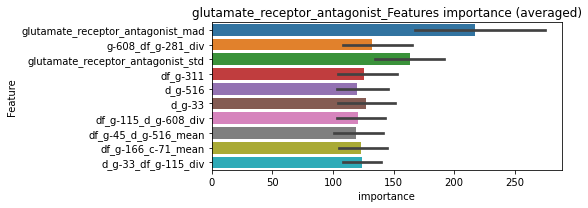

len(train_index) : 2256
len(valid_index) : 752
================================= fold 1/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0650699	valid_1's binary_logloss: 0.149347
[200]	training's binary_logloss: 0.0217051	valid_1's binary_logloss: 0.117442
[300]	training's binary_logloss: 0.00895882	valid_1's binary_logloss: 0.105277
[400]	training's binary_logloss: 0.00423972	valid_1's binary_logloss: 0.102657
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00398368	valid_1's binary_logloss: 0.102155


len(train_index) : 2256
len(valid_index) : 752
================================= fold 2/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0658052	valid_1's binary_logloss: 0.12126
[200]	training's binary_logloss: 0.022105	valid_1's binary_logloss: 0.0913814
[300]	training's binary_logloss: 0.00891476	valid_1's binary_logloss: 0.0820297
[400]	training's binary_logloss: 0.00428767	valid_1's binary_logloss: 0.0787265
[500]	training's binary_logloss: 0.00241069	valid_1's binary_logloss: 0.0767868
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00208283	valid_1's binary_logloss: 0.0763249


len(train_index) : 2256
len(valid_index) : 752
================================= fold 3/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687775	valid_1's binary_logloss: 0.107679
[200]	training's binary_logloss: 0.0234403	valid_1's binary_logloss: 0.0722181
[300]	training's binary_logloss: 0.00940914	valid_1's binary_logloss: 0.0603007
[400]	training's binary_logloss: 0.0044185	valid_1's binary_logloss: 0.0571354
[500]	training's binary_logloss: 0.00246339	valid_1's binary_logloss: 0.0552404
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00255211	valid_1's binary_logloss: 0.0549639


len(train_index) : 2256
len(valid_index) : 752
================================= fold 4/4 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0698833	valid_1's binary_logloss: 0.124279
[200]	training's binary_logloss: 0.0233324	valid_1's binary_logloss: 0.0870844
[300]	training's binary_logloss: 0.00946983	valid_1's binary_logloss: 0.0755978
[400]	training's binary_logloss: 0.00446157	valid_1's binary_logloss: 0.0710468


glutamate_receptor_antagonist logloss: 0.07577721034623418


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00324194	valid_1's binary_logloss: 0.0696654
neg labels: 3289 → selected neg labels: 3287


gonadotropin_receptor_agonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0713629	valid_1's binary_logloss: 0.0927057
[200]	training's binary_logloss: 0.019562	valid_1's binary_logloss: 0.0344965
[300]	training's binary_logloss: 0.00639705	valid_1's binary_logloss: 0.0172363
[400]	training's binary_logloss: 0.00250194	valid_1's binary_logloss: 0.0109167
[500]	training's binary_logloss: 0.00128442	valid_1's binary_logloss: 0.00817304
[600]	training's binary_logloss: 0.000827889	valid_1's binary_logloss: 0.0067664
[700]	training's binary_logloss: 0.00060697	valid_1's binary_logloss: 0.00618441
[800]	training's binary_logloss: 0.00049015	valid_1's binary_logloss: 0.00575329
[900]	training's binary_logloss: 0.000442713	valid_1's binary_logloss: 0.00562267
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000431609	valid_1's binary_logloss: 0.00555832
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.072

1 / 3 AUC score:1.000
y_Threshold: 0.0045896, Threshold: 0.0218406, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01529, conf_1:0.02839
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0218406
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_2: 0.0718406
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_3: 0.1218406
Num_p_label: 4.0, Expected: 3.0, Adj_threshold_4: 0.1718406
threshold: 0.1718406, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686902	valid_1's binary_logloss: 0.0791956
[200]	training's binary_logloss: 0.0172182	valid_1's binary_logloss: 0.0249517
[300]	training's binary_logloss: 0.00516401	valid_1's binary_logloss: 0.00977507
[400]	training's binary_logloss: 0.00201948	valid_1's binary_logloss: 0.00501602
[500]	training's binary_logloss: 0.00106141	valid_1's binary_logloss: 0.00326459
[600]	training's binary_logloss: 0.000692357	valid_1's binary_logloss: 0.00248939
[700]	training's binary_logloss: 0.000521513	valid_1's binary_logloss: 0.00211653
[800]	training's binary_logloss: 0.000430468	valid_1's binary_logloss: 0.00191759
[900]	training's binary_logloss: 0.000395692	valid_1's binary_logloss: 0.00183279
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000390971	valid_1's binary_logloss: 0.00182572
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0466015, Threshold: 0.1718406, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00076, Num_p_label: 26.0, conf_0:0.13747, conf_1:0.20621
Num_p_label: 26.0, Expected: 3.0, Adj_threshold_1: 0.1718406
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.2218406
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_3: 0.2718406
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_4: 0.3218406
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_5: 0.3718406
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_6: 0.4218406
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.4718406
threshold: 0.4718406, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3808, y_label_rate: 0.1720063
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0689044	valid_1's binary_logloss: 0.0811837
[200]	training's binary_logloss: 0.0167322	valid_1's binary_logloss: 0.0256656
[300]	training's binary_logloss: 0.0049355	valid_1's binary_logloss: 0.010782
[400]	training's binary_logloss: 0.00195874	valid_1's binary_logloss: 0.00581991
[500]	training's binary_logloss: 0.00103433	valid_1's binary_logloss: 0.00402676
[600]	training's binary_logloss: 0.000681324	valid_1's binary_logloss: 0.00317142
[700]	training's binary_logloss: 0.000509206	valid_1's binary_logloss: 0.00277485
[800]	training's binary_logloss: 0.000419298	valid_1's binary_logloss: 0.00249987
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.000412538	valid_1's binary_logloss: 0.00247166
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0683497	valid_1's binary_logloss: 0.0924639
[200]	training's binary_logloss: 0.017

3 / 3 AUC score:1.000
y_Threshold: 0.0520052, Threshold: 0.4718406, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.42466, conf_1:0.51902
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_1: 0.4718406
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_2: 0.5218406
threshold: 0.5218406, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 654.0/3806, y_label_rate: 0.1718339


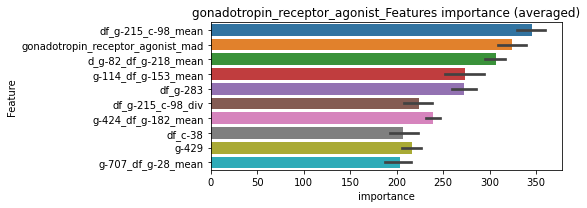

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682759	valid_1's binary_logloss: 0.0838226
[200]	training's binary_logloss: 0.0166353	valid_1's binary_logloss: 0.0270271
[300]	training's binary_logloss: 0.00501761	valid_1's binary_logloss: 0.0111851
[400]	training's binary_logloss: 0.00197581	valid_1's binary_logloss: 0.00619293
[500]	training's binary_logloss: 0.00103677	valid_1's binary_logloss: 0.00405226
[600]	training's binary_logloss: 0.000681375	valid_1's binary_logloss: 0.00320669
[700]	training's binary_logloss: 0.000514257	valid_1's binary_logloss: 0.00277882
[800]	training's binary_logloss: 0.000425392	valid_1's binary_logloss: 0.00252579
[900]	training's binary_logloss: 0.000391369	valid_1's binary_logloss: 0.00243757
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000385804	valid_1's binary_logloss: 0.0024224


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0671743	valid_1's binary_logloss: 0.0812989
[200]	training's binary_logloss: 0.0164368	valid_1's binary_logloss: 0.0259052
[300]	training's binary_logloss: 0.00502514	valid_1's binary_logloss: 0.0118796
[400]	training's binary_logloss: 0.00196978	valid_1's binary_logloss: 0.0071431
[500]	training's binary_logloss: 0.00102477	valid_1's binary_logloss: 0.00529553
[600]	training's binary_logloss: 0.000677517	valid_1's binary_logloss: 0.00439244
[700]	training's binary_logloss: 0.000511772	valid_1's binary_logloss: 0.00394367
[800]	training's binary_logloss: 0.000424705	valid_1's binary_logloss: 0.00374888
Early stopping, best iteration is:
[818]	training's binary_logloss: 0.000414069	valid_1's binary_logloss: 0.00368653


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0682499	valid_1's binary_logloss: 0.0828021
[200]	training's binary_logloss: 0.0166763	valid_1's binary_logloss: 0.0300215
[300]	training's binary_logloss: 0.00509215	valid_1's binary_logloss: 0.0173174
[400]	training's binary_logloss: 0.00198838	valid_1's binary_logloss: 0.0146064
[500]	training's binary_logloss: 0.00103165	valid_1's binary_logloss: 0.0129697
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.000891534	valid_1's binary_logloss: 0.0126199


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0659429	valid_1's binary_logloss: 0.0916334
[200]	training's binary_logloss: 0.0160111	valid_1's binary_logloss: 0.0339253
[300]	training's binary_logloss: 0.0048181	valid_1's binary_logloss: 0.0170963
[400]	training's binary_logloss: 0.00190343	valid_1's binary_logloss: 0.0112674
[500]	training's binary_logloss: 0.00100212	valid_1's binary_logloss: 0.00901125
[600]	training's binary_logloss: 0.000666848	valid_1's binary_logloss: 0.00805534
[700]	training's binary_logloss: 0.000501498	valid_1's binary_logloss: 0.00736543
[800]	training's binary_logloss: 0.000417734	valid_1's binary_logloss: 0.00711909
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.000427496	valid_1's binary_logloss: 0.00708121


gonadotropin_receptor_agonist logloss: 0.00645078372713678


neg labels: 3289 → selected neg labels: 3281


gsk_inhibitor, len(trt): 60, len(othr): 3281, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130972	valid_1's binary_logloss: 0.207101
[200]	training's binary_logloss: 0.0586037	valid_1's binary_logloss: 0.140831
[300]	training's binary_logloss: 0.0284996	valid_1's binary_logloss: 0.107249
[400]	training's binary_logloss: 0.0139396	valid_1's binary_logloss: 0.0867019
[500]	training's binary_logloss: 0.00733148	valid_1's binary_logloss: 0.0750292
[600]	training's binary_logloss: 0.00420411	valid_1's binary_logloss: 0.0693197
[700]	training's binary_logloss: 0.00269901	valid_1's binary_logloss: 0.0663814
[800]	training's binary_logloss: 0.00190929	valid_1's binary_logloss: 0.0644578
[900]	training's binary_logloss: 0.00147765	valid_1's binary_logloss: 0.0636267
[1000]	training's binary_logloss: 0.00121484	valid_1's binary_logloss: 0.0628309
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.00120722	valid_1's binary_logloss: 0.0627962
Training until validation scor

1 / 3 AUC score:0.998
y_Threshold: 0.0350270, Threshold: 0.2255247, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.15787, conf_1:0.29318
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.2255247
Num_p_label: 31.0, Expected: 10.0, Adj_threshold_2: 0.2755247
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_3: 0.3255247
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_4: 0.3755247
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_5: 0.4255247
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_6: 0.4755247
threshold: 0.4755247, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3797, y_label_rate: 0.1717145
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122177	valid_1's binary_logloss: 0.174596
[200]	training's binary_logloss: 0.0509927	valid_1's binary_logloss: 0.103162
[300]	training's binary_logloss: 0.023179	valid_1's binary_logloss: 0.0676002
[400]	training's binary_logloss: 0.0109554	valid_1's binary_logloss: 0.0485277
[500]	training's binary_logloss: 0.00566974	valid_1's binary_logloss: 0.037883
[600]	training's binary_logloss: 0.00335009	valid_1's binary_logloss: 0.0322897
[700]	training's binary_logloss: 0.00222222	valid_1's binary_logloss: 0.0290015
[800]	training's binary_logloss: 0.001635	valid_1's binary_logloss: 0.0266746
[900]	training's binary_logloss: 0.00129696	valid_1's binary_logloss: 0.0251938
[1000]	training's binary_logloss: 0.00109064	valid_1's binary_logloss: 0.0242999
[1100]	training's binary_logloss: 0.00096952	valid_1's binary_logloss: 0.0237606
Early stopping, best iteration is:
[1166]	training's binary_logloss:

2 / 3 AUC score:0.999
y_Threshold: 0.1260284, Threshold: 0.4755247, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 640.0/3773
p_label_rate: 0.0123054 Vs.target_rate: 0.00252, Num_p_label: 49.0, conf_0:0.38042, conf_1:0.57063
Num_p_label: 49.0, Expected: 10.0, Adj_threshold_1: 0.4755247
Num_p_label: 42.0, Expected: 10.0, Adj_threshold_2: 0.5255247
Num_p_label: 39.0, Expected: 10.0, Adj_threshold_3: 0.5755247
Num_p_label: 32.0, Expected: 10.0, Adj_threshold_4: 0.6255247
Num_p_label: 24.0, Expected: 10.0, Adj_threshold_5: 0.6755247
Num_p_label: 20.0, Expected: 10.0, Adj_threshold_6: 0.7255247
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_7: 0.7755247
threshold: 0.7755247, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 640.0/3773, y_label_rate: 0.1696263
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119064	valid_1's binary_logloss: 0.172443
[200]	training's binary_logloss: 0.0492074	valid_1's binary_logloss: 0.106703
[300]	training's binary_logloss: 0.022591	valid_1's binary_logloss: 0.0758779
[400]	training's binary_logloss: 0.0107156	valid_1's binary_logloss: 0.0573072
[500]	training's binary_logloss: 0.0054552	valid_1's binary_logloss: 0.0477189
[600]	training's binary_logloss: 0.00319537	valid_1's binary_logloss: 0.0418608
[700]	training's binary_logloss: 0.0021083	valid_1's binary_logloss: 0.0389528
[800]	training's binary_logloss: 0.0015502	valid_1's binary_logloss: 0.0378022
[900]	training's binary_logloss: 0.00122371	valid_1's binary_logloss: 0.0365514
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.00119935	valid_1's binary_logloss: 0.0364001
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11997	valid_1's bin

3 / 3 AUC score:0.998
y_Threshold: 0.1078722, Threshold: 0.7755247, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 620.0/3733
p_label_rate: 0.0040181 Vs.target_rate: 0.00252, Num_p_label: 16.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_1: 0.7755247
threshold: 0.7755247, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 620.0/3733, y_label_rate: 0.1660863


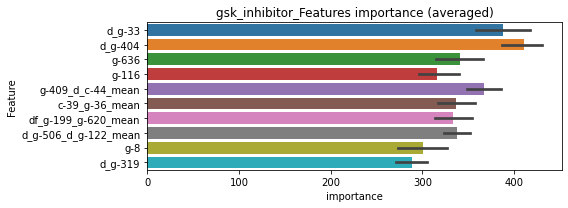

len(train_index) : 2799
len(valid_index) : 934
================================= fold 1/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109694	valid_1's binary_logloss: 0.163219
[200]	training's binary_logloss: 0.043553	valid_1's binary_logloss: 0.0965899
[300]	training's binary_logloss: 0.019005	valid_1's binary_logloss: 0.0647961
[400]	training's binary_logloss: 0.00909556	valid_1's binary_logloss: 0.0489988
[500]	training's binary_logloss: 0.00466553	valid_1's binary_logloss: 0.0394995
[600]	training's binary_logloss: 0.0027737	valid_1's binary_logloss: 0.0348521
[700]	training's binary_logloss: 0.00185269	valid_1's binary_logloss: 0.031775
[800]	training's binary_logloss: 0.00138762	valid_1's binary_logloss: 0.030084
[900]	training's binary_logloss: 0.00112291	valid_1's binary_logloss: 0.0292275
[1000]	training's binary_logloss: 0.000951375	valid_1's binary_logloss: 0.0283581
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.00089154	valid_1's binary_logloss: 0.0278378


len(train_index) : 2800
len(valid_index) : 933
================================= fold 2/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116677	valid_1's binary_logloss: 0.171577
[200]	training's binary_logloss: 0.0464383	valid_1's binary_logloss: 0.102653
[300]	training's binary_logloss: 0.0204717	valid_1's binary_logloss: 0.0687734
[400]	training's binary_logloss: 0.00937238	valid_1's binary_logloss: 0.050565
[500]	training's binary_logloss: 0.00479096	valid_1's binary_logloss: 0.0409828
[600]	training's binary_logloss: 0.00285754	valid_1's binary_logloss: 0.0360325
[700]	training's binary_logloss: 0.00191244	valid_1's binary_logloss: 0.0329
[800]	training's binary_logloss: 0.00142931	valid_1's binary_logloss: 0.0316324
[900]	training's binary_logloss: 0.00113667	valid_1's binary_logloss: 0.0304495
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.0010282	valid_1's binary_logloss: 0.02976


len(train_index) : 2800
len(valid_index) : 933
================================= fold 3/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110563	valid_1's binary_logloss: 0.174758
[200]	training's binary_logloss: 0.0423404	valid_1's binary_logloss: 0.104322
[300]	training's binary_logloss: 0.018608	valid_1's binary_logloss: 0.0733517
[400]	training's binary_logloss: 0.00882301	valid_1's binary_logloss: 0.0581252
[500]	training's binary_logloss: 0.00460203	valid_1's binary_logloss: 0.0475017
[600]	training's binary_logloss: 0.0027322	valid_1's binary_logloss: 0.0421141
[700]	training's binary_logloss: 0.00185221	valid_1's binary_logloss: 0.0390966
[800]	training's binary_logloss: 0.00138387	valid_1's binary_logloss: 0.0374092
[900]	training's binary_logloss: 0.00111456	valid_1's binary_logloss: 0.0362552
[1000]	training's binary_logloss: 0.000947473	valid_1's binary_logloss: 0.0356626
Early stopping, best iteration is:
[1035]	training's binary_logloss: 0.000912664	valid_1's binary_logloss: 0.0355105


len(train_index) : 2800
len(valid_index) : 933
================================= fold 4/4 gsk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112657	valid_1's binary_logloss: 0.156428
[200]	training's binary_logloss: 0.044557	valid_1's binary_logloss: 0.0905381
[300]	training's binary_logloss: 0.0195346	valid_1's binary_logloss: 0.0584561
[400]	training's binary_logloss: 0.00897821	valid_1's binary_logloss: 0.0423487
[500]	training's binary_logloss: 0.00459614	valid_1's binary_logloss: 0.0338981
[600]	training's binary_logloss: 0.00270721	valid_1's binary_logloss: 0.0292527
[700]	training's binary_logloss: 0.00183664	valid_1's binary_logloss: 0.026607
[800]	training's binary_logloss: 0.00137948	valid_1's binary_logloss: 0.0251062
[900]	training's binary_logloss: 0.00110785	valid_1's binary_logloss: 0.0241776
[1000]	training's binary_logloss: 0.000963258	valid_1's binary_logloss: 0.0238095
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000929923	valid_1's binary_logloss: 0.023523


gsk_inhibitor logloss: 0.029157476743506747


neg labels: 3289 → selected neg labels: 3273


hcv_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134472	valid_1's binary_logloss: 0.210568
[200]	training's binary_logloss: 0.0604212	valid_1's binary_logloss: 0.147573
[300]	training's binary_logloss: 0.0294779	valid_1's binary_logloss: 0.118561
[400]	training's binary_logloss: 0.0154062	valid_1's binary_logloss: 0.103262
[500]	training's binary_logloss: 0.00845428	valid_1's binary_logloss: 0.0956112
[600]	training's binary_logloss: 0.00491713	valid_1's binary_logloss: 0.0912024
[700]	training's binary_logloss: 0.00314236	valid_1's binary_logloss: 0.0904452
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00345792	valid_1's binary_logloss: 0.0902847
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131946	valid_1's binary_logloss: 0.213977
[200]	training's binary_logloss: 0.0610247	valid_1's binary_logloss: 0.148428
[300]	training's binary_logloss: 0.0300518	valid_1's bina

1 / 3 AUC score:0.993
y_Threshold: 0.0372810, Threshold: 0.1571716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 178 → Positive_corect_labels: 631/3749
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.11002, conf_1:0.20432
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.1571716
Num_p_label: 20.0, Expected: 12.0, Adj_threshold_2: 0.2071716
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_3: 0.2571716
threshold: 0.2571716, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 631.0/3749, y_label_rate: 0.1683115
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124534	valid_1's binary_logloss: 0.186971
[200]	training's binary_logloss: 0.0499277	valid_1's binary_logloss: 0.112635
[300]	training's binary_logloss: 0.0229746	valid_1's binary_logloss: 0.0787103
[400]	training's binary_logloss: 0.01133	valid_1's binary_logloss: 0.0596459
[500]	training's binary_logloss: 0.00597571	valid_1's binary_logloss: 0.0486808
[600]	training's binary_logloss: 0.00354065	valid_1's binary_logloss: 0.0429284
[700]	training's binary_logloss: 0.00233949	valid_1's binary_logloss: 0.0385467
[800]	training's binary_logloss: 0.00171394	valid_1's binary_logloss: 0.0362557
[900]	training's binary_logloss: 0.00133834	valid_1's binary_logloss: 0.0348525
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00143305	valid_1's binary_logloss: 0.0347412
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121575	valid_1's 

2 / 3 AUC score:0.995
y_Threshold: 0.1041061, Threshold: 0.2571716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 604.0/3695
p_label_rate: 0.0155701 Vs.target_rate: 0.00302, Num_p_label: 62.0, conf_0:0.20574, conf_1:0.30861
Num_p_label: 62.0, Expected: 12.0, Adj_threshold_1: 0.2571716
Num_p_label: 49.0, Expected: 12.0, Adj_threshold_2: 0.3071716
Num_p_label: 36.0, Expected: 12.0, Adj_threshold_3: 0.3571716
Num_p_label: 29.0, Expected: 12.0, Adj_threshold_4: 0.4071716
Num_p_label: 22.0, Expected: 12.0, Adj_threshold_5: 0.4571716
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_6: 0.5071716
Num_p_label: 9.0, Expected: 12.0, Adj_threshold_7: 0.5571716
threshold: 0.5571716, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 604.0/3695, y_label_rate: 0.1634641
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111253	valid_1's binary_logloss: 0.17378
[200]	training's binary_logloss: 0.0419853	valid_1's binary_logloss: 0.100171
[300]	training's binary_logloss: 0.0180366	valid_1's binary_logloss: 0.0672247
[400]	training's binary_logloss: 0.00869611	valid_1's binary_logloss: 0.0508306
[500]	training's binary_logloss: 0.00451421	valid_1's binary_logloss: 0.042073
[600]	training's binary_logloss: 0.00271915	valid_1's binary_logloss: 0.0371444
[700]	training's binary_logloss: 0.00186121	valid_1's binary_logloss: 0.0347364
[800]	training's binary_logloss: 0.00139285	valid_1's binary_logloss: 0.0340712
[900]	training's binary_logloss: 0.00111638	valid_1's binary_logloss: 0.0331714
[1000]	training's binary_logloss: 0.000948418	valid_1's binary_logloss: 0.0324748
[1100]	training's binary_logloss: 0.00083552	valid_1's binary_logloss: 0.0319521
Early stopping, best iteration is:
[1089]	training's binary_logl

3 / 3 AUC score:0.999
y_Threshold: 0.1029511, Threshold: 0.5571716, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 593.0/3673
p_label_rate: 0.0045203 Vs.target_rate: 0.00302, Num_p_label: 18.0, conf_0:0.50000, conf_1:0.61289
threshold: 0.5571716, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 593.0/3673, y_label_rate: 0.1614484


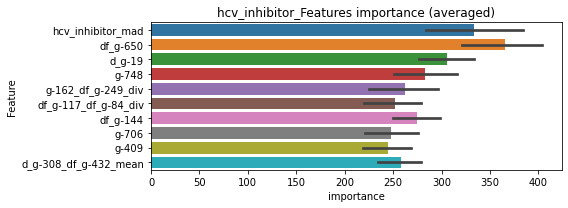

len(train_index) : 2754
len(valid_index) : 919
================================= fold 1/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105249	valid_1's binary_logloss: 0.183963
[200]	training's binary_logloss: 0.0377556	valid_1's binary_logloss: 0.116187
[300]	training's binary_logloss: 0.015587	valid_1's binary_logloss: 0.0865061
[400]	training's binary_logloss: 0.00723362	valid_1's binary_logloss: 0.0701316
[500]	training's binary_logloss: 0.00382818	valid_1's binary_logloss: 0.0626705
[600]	training's binary_logloss: 0.00234196	valid_1's binary_logloss: 0.0586448
[700]	training's binary_logloss: 0.00162261	valid_1's binary_logloss: 0.0570015
Early stopping, best iteration is:
[681]	training's binary_logloss: 0.00172712	valid_1's binary_logloss: 0.0567234


len(train_index) : 2755
len(valid_index) : 918
================================= fold 2/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107024	valid_1's binary_logloss: 0.175902
[200]	training's binary_logloss: 0.0388621	valid_1's binary_logloss: 0.110668
[300]	training's binary_logloss: 0.0161144	valid_1's binary_logloss: 0.0830103
[400]	training's binary_logloss: 0.00747199	valid_1's binary_logloss: 0.0717394
[500]	training's binary_logloss: 0.00390466	valid_1's binary_logloss: 0.0669939
[600]	training's binary_logloss: 0.00240195	valid_1's binary_logloss: 0.0654054
[700]	training's binary_logloss: 0.00167295	valid_1's binary_logloss: 0.0641667
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00172549	valid_1's binary_logloss: 0.0640348


len(train_index) : 2755
len(valid_index) : 918
================================= fold 3/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108461	valid_1's binary_logloss: 0.155532
[200]	training's binary_logloss: 0.0398238	valid_1's binary_logloss: 0.0828532
[300]	training's binary_logloss: 0.0165667	valid_1's binary_logloss: 0.0528434
[400]	training's binary_logloss: 0.00761331	valid_1's binary_logloss: 0.0374825
[500]	training's binary_logloss: 0.00404911	valid_1's binary_logloss: 0.0296301
[600]	training's binary_logloss: 0.00248599	valid_1's binary_logloss: 0.0254235
[700]	training's binary_logloss: 0.00172108	valid_1's binary_logloss: 0.0228844
[800]	training's binary_logloss: 0.00130195	valid_1's binary_logloss: 0.0214571
[900]	training's binary_logloss: 0.00105365	valid_1's binary_logloss: 0.0204211
[1000]	training's binary_logloss: 0.000898471	valid_1's binary_logloss: 0.019772
[1100]	training's binary_logloss: 0.00080026	valid_1's binary_logloss: 0.0192442
[1200]	training's binary_logloss: 0.000744942	valid_1's binary

len(train_index) : 2755
len(valid_index) : 918
================================= fold 4/4 hcv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108387	valid_1's binary_logloss: 0.165698
[200]	training's binary_logloss: 0.0403964	valid_1's binary_logloss: 0.100206
[300]	training's binary_logloss: 0.0168224	valid_1's binary_logloss: 0.0711628
[400]	training's binary_logloss: 0.00781915	valid_1's binary_logloss: 0.0588869
[500]	training's binary_logloss: 0.00414876	valid_1's binary_logloss: 0.052815
[600]	training's binary_logloss: 0.00253011	valid_1's binary_logloss: 0.0510123
Early stopping, best iteration is:
[662]	training's binary_logloss: 0.00198192	valid_1's binary_logloss: 0.0498946


hcv_inhibitor logloss: 0.047351930971500124


neg labels: 3289 → selected neg labels: 3275


hdac_inhibitor, len(trt): 106, len(othr): 3275, target_rate: 0.0044512 → Adj_target_rate: 0.0044229
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.166696	valid_1's binary_logloss: 0.263906
[200]	training's binary_logloss: 0.0864637	valid_1's binary_logloss: 0.208803
[300]	training's binary_logloss: 0.0467062	valid_1's binary_logloss: 0.177837
[400]	training's binary_logloss: 0.0266782	valid_1's binary_logloss: 0.162159
[500]	training's binary_logloss: 0.015261	valid_1's binary_logloss: 0.151151
[600]	training's binary_logloss: 0.00893064	valid_1's binary_logloss: 0.145928
[700]	training's binary_logloss: 0.00554709	valid_1's binary_logloss: 0.143465
Early stopping, best iteration is:
[725]	training's binary_logloss: 0.00504085	valid_1's binary_logloss: 0.14305
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.165245	valid_1's binary_logloss: 0.250906
[200]	training's binary_logloss: 0.0849126	valid_1's binary_logloss: 0.186689
[300]	training's binary_logloss: 0.0483159	valid_1's binary_logl

1 / 3 AUC score:0.981
y_Threshold: 0.0431875, Threshold: 0.2734143, pos_neg_ratio: 0.8000000
Remove_noisy_data: 191 → Positive_corect_labels: 625/3739
p_label_rate: 0.0100452 Vs.target_rate: 0.00445, Num_p_label: 40.0, conf_0:0.19139, conf_1:0.35544
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_1: 0.2734143
Num_p_label: 32.0, Expected: 17.7, Adj_threshold_2: 0.3234143
Num_p_label: 24.0, Expected: 17.7, Adj_threshold_3: 0.3734143
threshold: 0.3734143, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 625.0/3739, y_label_rate: 0.1671570
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149167	valid_1's binary_logloss: 0.225162
[200]	training's binary_logloss: 0.0698035	valid_1's binary_logloss: 0.155134
[300]	training's binary_logloss: 0.0357932	valid_1's binary_logloss: 0.117654
[400]	training's binary_logloss: 0.0189797	valid_1's binary_logloss: 0.0972669
[500]	training's binary_logloss: 0.0102063	valid_1's binary_logloss: 0.0835873
[600]	training's binary_logloss: 0.00596194	valid_1's binary_logloss: 0.0772119
[700]	training's binary_logloss: 0.00379861	valid_1's binary_logloss: 0.0725258
[800]	training's binary_logloss: 0.00265036	valid_1's binary_logloss: 0.070061
[900]	training's binary_logloss: 0.00200041	valid_1's binary_logloss: 0.0684204
[1000]	training's binary_logloss: 0.0016104	valid_1's binary_logloss: 0.0678264
Early stopping, best iteration is:
[1068]	training's binary_logloss: 0.00142058	valid_1's binary_logloss: 0.0672854
Training until validation scores 

2 / 3 AUC score:0.993
y_Threshold: 0.1058130, Threshold: 0.3734143, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 597.0/3683
p_label_rate: 0.0251130 Vs.target_rate: 0.00445, Num_p_label: 100.0, conf_0:0.29873, conf_1:0.44810
Num_p_label: 100.0, Expected: 17.7, Adj_threshold_1: 0.3734143
Num_p_label: 90.0, Expected: 17.7, Adj_threshold_2: 0.4234143
Num_p_label: 76.0, Expected: 17.7, Adj_threshold_3: 0.4734143
Num_p_label: 63.0, Expected: 17.7, Adj_threshold_4: 0.5234143
Num_p_label: 54.0, Expected: 17.7, Adj_threshold_5: 0.5734143
Num_p_label: 50.0, Expected: 17.7, Adj_threshold_6: 0.6234143
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_7: 0.6734143
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_8: 0.7234143
Num_p_label: 24.0, Expected: 17.7, Adj_threshold_9: 0.7734143
threshold: 0.7734143, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 597.0/3683, y_label_rate: 0.1620961
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136374	valid_1's binary_logloss: 0.202404
[200]	training's binary_logloss: 0.0605151	valid_1's binary_logloss: 0.127967
[300]	training's binary_logloss: 0.0299363	valid_1's binary_logloss: 0.091186
[400]	training's binary_logloss: 0.0154986	valid_1's binary_logloss: 0.0695307
[500]	training's binary_logloss: 0.00826612	valid_1's binary_logloss: 0.0559962
[600]	training's binary_logloss: 0.00485396	valid_1's binary_logloss: 0.0488667
[700]	training's binary_logloss: 0.00311723	valid_1's binary_logloss: 0.0438526
[800]	training's binary_logloss: 0.00220712	valid_1's binary_logloss: 0.0410803
[900]	training's binary_logloss: 0.00169751	valid_1's binary_logloss: 0.0398081
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00158476	valid_1's binary_logloss: 0.0395136
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136709	valid_1's

3 / 3 AUC score:0.995
y_Threshold: 0.0914327, Threshold: 0.7734143, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 566.0/3621
p_label_rate: 0.0085384 Vs.target_rate: 0.00445, Num_p_label: 34.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 34.0, Expected: 17.7, Adj_threshold_1: 0.7734143
threshold: 0.7734143, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 566.0/3621, y_label_rate: 0.1563104


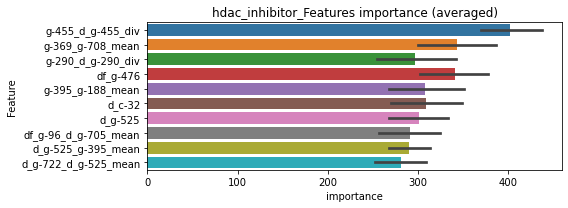

len(train_index) : 2715
len(valid_index) : 906
================================= fold 1/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12381	valid_1's binary_logloss: 0.195485
[200]	training's binary_logloss: 0.0527871	valid_1's binary_logloss: 0.132475
[300]	training's binary_logloss: 0.0246825	valid_1's binary_logloss: 0.0999005
[400]	training's binary_logloss: 0.0123742	valid_1's binary_logloss: 0.0834835
[500]	training's binary_logloss: 0.00657598	valid_1's binary_logloss: 0.0740742
[600]	training's binary_logloss: 0.00390046	valid_1's binary_logloss: 0.0690729
[700]	training's binary_logloss: 0.00256558	valid_1's binary_logloss: 0.0655953
[800]	training's binary_logloss: 0.00185595	valid_1's binary_logloss: 0.0637658
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00158458	valid_1's binary_logloss: 0.0624396


len(train_index) : 2716
len(valid_index) : 905
================================= fold 2/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126424	valid_1's binary_logloss: 0.190792
[200]	training's binary_logloss: 0.0544496	valid_1's binary_logloss: 0.123508
[300]	training's binary_logloss: 0.0266138	valid_1's binary_logloss: 0.0924843
[400]	training's binary_logloss: 0.0133328	valid_1's binary_logloss: 0.0745169
[500]	training's binary_logloss: 0.00707447	valid_1's binary_logloss: 0.0642872
[600]	training's binary_logloss: 0.00409978	valid_1's binary_logloss: 0.0602135
[700]	training's binary_logloss: 0.00265828	valid_1's binary_logloss: 0.057186
[800]	training's binary_logloss: 0.00189219	valid_1's binary_logloss: 0.0558345
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00161173	valid_1's binary_logloss: 0.0548745


len(train_index) : 2716
len(valid_index) : 905
================================= fold 3/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131344	valid_1's binary_logloss: 0.173791
[200]	training's binary_logloss: 0.0571642	valid_1's binary_logloss: 0.106182
[300]	training's binary_logloss: 0.0280879	valid_1's binary_logloss: 0.0770344
[400]	training's binary_logloss: 0.013901	valid_1's binary_logloss: 0.0587284
[500]	training's binary_logloss: 0.00753963	valid_1's binary_logloss: 0.0503208
[600]	training's binary_logloss: 0.00440044	valid_1's binary_logloss: 0.0440538
[700]	training's binary_logloss: 0.00280227	valid_1's binary_logloss: 0.0414038
[800]	training's binary_logloss: 0.0020042	valid_1's binary_logloss: 0.0386151
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.0017215	valid_1's binary_logloss: 0.0375862


len(train_index) : 2716
len(valid_index) : 905
================================= fold 4/4 hdac_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125674	valid_1's binary_logloss: 0.189391
[200]	training's binary_logloss: 0.0523248	valid_1's binary_logloss: 0.124048
[300]	training's binary_logloss: 0.0245211	valid_1's binary_logloss: 0.0943819
[400]	training's binary_logloss: 0.0122658	valid_1's binary_logloss: 0.0758755
[500]	training's binary_logloss: 0.00646781	valid_1's binary_logloss: 0.0665509
[600]	training's binary_logloss: 0.00381144	valid_1's binary_logloss: 0.0606364
[700]	training's binary_logloss: 0.00251412	valid_1's binary_logloss: 0.0571259
[800]	training's binary_logloss: 0.00181862	valid_1's binary_logloss: 0.0551966
[900]	training's binary_logloss: 0.00142247	valid_1's binary_logloss: 0.0542006
[1000]	training's binary_logloss: 0.00118151	valid_1's binary_logloss: 0.0536564
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.00114192	valid_1's binary_logloss: 0.0534079


hdac_inhibitor logloss: 0.05207988992334013


neg labels: 3289 → selected neg labels: 3283


histamine_receptor_agonist, len(trt): 59, len(othr): 3283, target_rate: 0.0024775 → Adj_target_rate: 0.0026880
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124693	valid_1's binary_logloss: 0.196213
[200]	training's binary_logloss: 0.0506001	valid_1's binary_logloss: 0.12884
[300]	training's binary_logloss: 0.023079	valid_1's binary_logloss: 0.098005
[400]	training's binary_logloss: 0.0106392	valid_1's binary_logloss: 0.0803211
[500]	training's binary_logloss: 0.0056025	valid_1's binary_logloss: 0.0731869
[600]	training's binary_logloss: 0.00327205	valid_1's binary_logloss: 0.0682238
Early stopping, best iteration is:
[655]	training's binary_logloss: 0.0025581	valid_1's binary_logloss: 0.0667071
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126163	valid_1's binary_logloss: 0.197345
[200]	training's binary_logloss: 0.0520542	valid_1's binary_logloss: 0.11942
[300]	training's binary_logloss: 0.0239028	valid_1's binary_logloss: 0.0847578
[400]	training's binary_logloss: 0.0117678	valid_1's binary_lo

1 / 3 AUC score:0.997
y_Threshold: 0.0274238, Threshold: 0.1150839, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00248, Num_p_label: 40.0, conf_0:0.08056, conf_1:0.14961
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_1: 0.1150839
Num_p_label: 29.0, Expected: 9.9, Adj_threshold_2: 0.1650839
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_3: 0.2150839
threshold: 0.2150839, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 653.0/3801, y_label_rate: 0.1717969
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115489	valid_1's binary_logloss: 0.174854
[200]	training's binary_logloss: 0.0443388	valid_1's binary_logloss: 0.101322
[300]	training's binary_logloss: 0.0187649	valid_1's binary_logloss: 0.0686416
[400]	training's binary_logloss: 0.00868896	valid_1's binary_logloss: 0.0531385
[500]	training's binary_logloss: 0.00447381	valid_1's binary_logloss: 0.0446064
[600]	training's binary_logloss: 0.0027021	valid_1's binary_logloss: 0.0406907
[700]	training's binary_logloss: 0.00182074	valid_1's binary_logloss: 0.0381106
[800]	training's binary_logloss: 0.00135306	valid_1's binary_logloss: 0.0366249
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.00119921	valid_1's binary_logloss: 0.0361856
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114204	valid_1's binary_logloss: 0.179956
[200]	training's binary_logloss: 0.04249	valid_1's bi

2 / 3 AUC score:0.999
y_Threshold: 0.1245774, Threshold: 0.2150839, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 634.0/3763
p_label_rate: 0.0178302 Vs.target_rate: 0.00248, Num_p_label: 71.0, conf_0:0.17207, conf_1:0.25810
Num_p_label: 71.0, Expected: 9.9, Adj_threshold_1: 0.2150839
Num_p_label: 62.0, Expected: 9.9, Adj_threshold_2: 0.2650839
Num_p_label: 54.0, Expected: 9.9, Adj_threshold_3: 0.3150839
Num_p_label: 45.0, Expected: 9.9, Adj_threshold_4: 0.3650839
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_5: 0.4150839
Num_p_label: 32.0, Expected: 9.9, Adj_threshold_6: 0.4650839
Num_p_label: 28.0, Expected: 9.9, Adj_threshold_7: 0.5150839
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_8: 0.5650839
Num_p_label: 23.0, Expected: 9.9, Adj_threshold_9: 0.6150839
threshold: 0.6150839, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 634.0/3763, y_label_rate: 0.1684826
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10934	valid_1's binary_logloss: 0.160041
[200]	training's binary_logloss: 0.0393935	valid_1's binary_logloss: 0.0920141
[300]	training's binary_logloss: 0.0159722	valid_1's binary_logloss: 0.0645883
[400]	training's binary_logloss: 0.00714858	valid_1's binary_logloss: 0.0503988
[500]	training's binary_logloss: 0.00373328	valid_1's binary_logloss: 0.0440507
[600]	training's binary_logloss: 0.00226694	valid_1's binary_logloss: 0.0404193
[700]	training's binary_logloss: 0.00156889	valid_1's binary_logloss: 0.0389978
[800]	training's binary_logloss: 0.00118419	valid_1's binary_logloss: 0.0385052
Early stopping, best iteration is:
[850]	training's binary_logloss: 0.00105906	valid_1's binary_logloss: 0.0379115
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108932	valid_1's binary_logloss: 0.172639
[200]	training's binary_logloss: 0.039071	valid_1's 

3 / 3 AUC score:0.999
y_Threshold: 0.1054309, Threshold: 0.6150839, pos_neg_ratio: 0.8000000
Remove_noisy_data: 40 → Positive_corect_labels: 614.0/3723
p_label_rate: 0.0097941 Vs.target_rate: 0.00248, Num_p_label: 39.0, conf_0:0.50000, conf_1:0.67659
Num_p_label: 39.0, Expected: 9.9, Adj_threshold_1: 0.6150839
Num_p_label: 32.0, Expected: 9.9, Adj_threshold_2: 0.6650839
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_3: 0.7150839
Num_p_label: 24.0, Expected: 9.9, Adj_threshold_4: 0.7650839
threshold: 0.7650839, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 614.0/3723, y_label_rate: 0.1649208


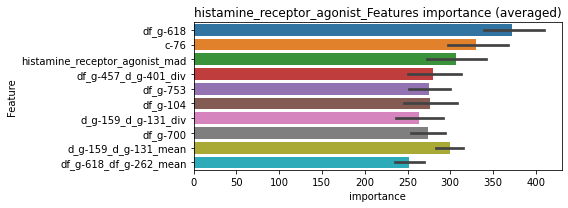

len(train_index) : 2792
len(valid_index) : 931
================================= fold 1/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100456	valid_1's binary_logloss: 0.158026
[200]	training's binary_logloss: 0.0351643	valid_1's binary_logloss: 0.0872315
[300]	training's binary_logloss: 0.0139021	valid_1's binary_logloss: 0.0584219
[400]	training's binary_logloss: 0.00622106	valid_1's binary_logloss: 0.0448859
[500]	training's binary_logloss: 0.00323475	valid_1's binary_logloss: 0.0376551
[600]	training's binary_logloss: 0.0019751	valid_1's binary_logloss: 0.0336207
[700]	training's binary_logloss: 0.00136463	valid_1's binary_logloss: 0.0317108
[800]	training's binary_logloss: 0.00104716	valid_1's binary_logloss: 0.0309133
[900]	training's binary_logloss: 0.000850365	valid_1's binary_logloss: 0.0299379
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000843732	valid_1's binary_logloss: 0.0298708


len(train_index) : 2792
len(valid_index) : 931
================================= fold 2/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103173	valid_1's binary_logloss: 0.138952
[200]	training's binary_logloss: 0.0359463	valid_1's binary_logloss: 0.0662705
[300]	training's binary_logloss: 0.0143791	valid_1's binary_logloss: 0.0369703
[400]	training's binary_logloss: 0.00645133	valid_1's binary_logloss: 0.0230962
[500]	training's binary_logloss: 0.00332805	valid_1's binary_logloss: 0.0162777
[600]	training's binary_logloss: 0.00204303	valid_1's binary_logloss: 0.0129987
[700]	training's binary_logloss: 0.0014183	valid_1's binary_logloss: 0.0109865
[800]	training's binary_logloss: 0.00107953	valid_1's binary_logloss: 0.00998554
[900]	training's binary_logloss: 0.000880591	valid_1's binary_logloss: 0.00926751
[1000]	training's binary_logloss: 0.000769186	valid_1's binary_logloss: 0.00889959
[1100]	training's binary_logloss: 0.00070221	valid_1's binary_logloss: 0.00864671
[1200]	training's binary_logloss: 0.000669649	valid_1's b

len(train_index) : 2792
len(valid_index) : 931
================================= fold 3/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10342	valid_1's binary_logloss: 0.158483
[200]	training's binary_logloss: 0.0360053	valid_1's binary_logloss: 0.0929268
[300]	training's binary_logloss: 0.0140869	valid_1's binary_logloss: 0.0656394
[400]	training's binary_logloss: 0.00626062	valid_1's binary_logloss: 0.0519352
[500]	training's binary_logloss: 0.00322483	valid_1's binary_logloss: 0.0445819
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00233998	valid_1's binary_logloss: 0.0423047


len(train_index) : 2793
len(valid_index) : 930
================================= fold 4/4 histamine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102285	valid_1's binary_logloss: 0.142176
[200]	training's binary_logloss: 0.0357464	valid_1's binary_logloss: 0.0740062
[300]	training's binary_logloss: 0.0144387	valid_1's binary_logloss: 0.0491764
[400]	training's binary_logloss: 0.00629288	valid_1's binary_logloss: 0.0381296
[500]	training's binary_logloss: 0.00324887	valid_1's binary_logloss: 0.0321152
[600]	training's binary_logloss: 0.00198484	valid_1's binary_logloss: 0.0295073
[700]	training's binary_logloss: 0.00137626	valid_1's binary_logloss: 0.0285141
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00132587	valid_1's binary_logloss: 0.0281528


histamine_receptor_agonist logloss: 0.027216454049878845


neg labels: 3289 → selected neg labels: 3255


histamine_receptor_antagonist, len(trt): 241, len(othr): 3255, target_rate: 0.0101201 → Adj_target_rate: 0.0088902
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.213593	valid_1's binary_logloss: 0.325834
[200]	training's binary_logloss: 0.126626	valid_1's binary_logloss: 0.286751
[300]	training's binary_logloss: 0.0791032	valid_1's binary_logloss: 0.267116
[400]	training's binary_logloss: 0.0508669	valid_1's binary_logloss: 0.25739
[500]	training's binary_logloss: 0.032887	valid_1's binary_logloss: 0.250543
[600]	training's binary_logloss: 0.0220062	valid_1's binary_logloss: 0.248552
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.0247314	valid_1's binary_logloss: 0.248151
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.206912	valid_1's binary_logloss: 0.327746
[200]	training's binary_logloss: 0.115937	valid_1's binary_logloss: 0.294873
[300]	training's binary_logloss: 0.0732162	valid_1's binary_logloss: 0.280241
[400]	training's binary_logloss: 0.0461837	valid_1's binary_logloss: 

1 / 3 AUC score:0.903
y_Threshold: 0.1041501, Threshold: 0.5027496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 433 → Positive_corect_labels: 500/3473
p_label_rate: 0.0100452 Vs.target_rate: 0.01012, Num_p_label: 40.0, conf_0:0.35192, conf_1:0.65357
threshold: 0.5027496, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 500.0/3473, y_label_rate: 0.1439678
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136593	valid_1's binary_logloss: 0.212944
[200]	training's binary_logloss: 0.0646154	valid_1's binary_logloss: 0.162481
[300]	training's binary_logloss: 0.0339709	valid_1's binary_logloss: 0.140979
[400]	training's binary_logloss: 0.0183054	valid_1's binary_logloss: 0.130916
[500]	training's binary_logloss: 0.0102733	valid_1's binary_logloss: 0.125332
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00997959	valid_1's binary_logloss: 0.125273
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138875	valid_1's binary_logloss: 0.202495
[200]	training's binary_logloss: 0.0641481	valid_1's binary_logloss: 0.153635
[300]	training's binary_logloss: 0.0327567	valid_1's binary_logloss: 0.132376
[400]	training's binary_logloss: 0.0174812	valid_1's binary_logloss: 0.119624
[500]	training's binary_logloss: 0.00992476	valid_1's binary_log

2 / 3 AUC score:0.975
y_Threshold: 0.1083289, Threshold: 0.5027496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 142 → Positive_corect_labels: 429.0/3331
p_label_rate: 0.0389252 Vs.target_rate: 0.01012, Num_p_label: 155.0, conf_0:0.40220, conf_1:0.60330
Num_p_label: 155.0, Expected: 40.3, Adj_threshold_1: 0.5027496
Num_p_label: 142.0, Expected: 40.3, Adj_threshold_2: 0.5527496
Num_p_label: 117.0, Expected: 40.3, Adj_threshold_3: 0.6027496
Num_p_label: 96.0, Expected: 40.3, Adj_threshold_4: 0.6527496
Num_p_label: 81.0, Expected: 40.3, Adj_threshold_5: 0.7027496
Num_p_label: 71.0, Expected: 40.3, Adj_threshold_6: 0.7527496
threshold: 0.7527496, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 429.0/3331, y_label_rate: 0.1287902
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930633	valid_1's binary_logloss: 0.183095
[200]	training's binary_logloss: 0.0366579	valid_1's binary_logloss: 0.142992
[300]	training's binary_logloss: 0.0171976	valid_1's binary_logloss: 0.129636
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.127441
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103647	valid_1's binary_logloss: 0.158468
[200]	training's binary_logloss: 0.0425164	valid_1's binary_logloss: 0.113046
[300]	training's binary_logloss: 0.0202376	valid_1's binary_logloss: 0.092679
[400]	training's binary_logloss: 0.0102633	valid_1's binary_logloss: 0.0838611
[500]	training's binary_logloss: 0.00560515	valid_1's binary_logloss: 0.0784763
[600]	training's binary_logloss: 0.00343197	valid_1's binary_logloss: 0.0757503
Early stopping, best iteration is:
[650]	training's binary_

3 / 3 AUC score:0.977
y_Threshold: 0.1045003, Threshold: 0.7527496, pos_neg_ratio: 0.8000000
Remove_noisy_data: 78 → Positive_corect_labels: 390.0/3253
p_label_rate: 0.0318935 Vs.target_rate: 0.01012, Num_p_label: 127.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 127.0, Expected: 40.3, Adj_threshold_1: 0.7527496
threshold: 0.7527496, positive_p_label: 127.0/3982, p_label_rate: 0.0318935
positive_y_label: 390.0/3253, y_label_rate: 0.1198893


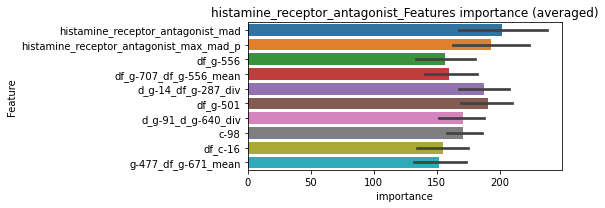

len(train_index) : 2439
len(valid_index) : 814
================================= fold 1/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0800274	valid_1's binary_logloss: 0.15124
[200]	training's binary_logloss: 0.0285799	valid_1's binary_logloss: 0.11394
[300]	training's binary_logloss: 0.011815	valid_1's binary_logloss: 0.102803


len(train_index) : 2440
len(valid_index) : 813
================================= fold 2/4 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00835056	valid_1's binary_logloss: 0.100626
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082409	valid_1's binary_logloss: 0.130435
[200]	training's binary_logloss: 0.0301653	valid_1's binary_logloss: 0.0858752
[300]	training's binary_logloss: 0.0131914	valid_1's binary_logloss: 0.0698685
[400]	training's binary_logloss: 0.00623671	valid_1's binary_logloss: 0.0630712
[500]	training's binary_logloss: 0.00338452	valid_1's binary_logloss: 0.0606137
[600]	training's binary_logloss: 0.00216941	valid_1's binary_logloss: 0.0598085
Early stopping, best iteration is:
[636]	training's binary_logloss: 0.00189126	valid_1's binary_logloss: 0.0596742


len(train_index) : 2440
len(valid_index) : 813
================================= fold 3/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0815439	valid_1's binary_logloss: 0.114872
[200]	training's binary_logloss: 0.0302966	valid_1's binary_logloss: 0.0706048
[300]	training's binary_logloss: 0.0132498	valid_1's binary_logloss: 0.0527219
[400]	training's binary_logloss: 0.00652974	valid_1's binary_logloss: 0.0449715
[500]	training's binary_logloss: 0.00356577	valid_1's binary_logloss: 0.0411759
[600]	training's binary_logloss: 0.00224906	valid_1's binary_logloss: 0.039528
[700]	training's binary_logloss: 0.00159413	valid_1's binary_logloss: 0.038854
[800]	training's binary_logloss: 0.00124115	valid_1's binary_logloss: 0.0380242
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.00110105	valid_1's binary_logloss: 0.0374778


len(train_index) : 2440
len(valid_index) : 813
================================= fold 4/4 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832705	valid_1's binary_logloss: 0.131219
[200]	training's binary_logloss: 0.0311055	valid_1's binary_logloss: 0.0790946
[300]	training's binary_logloss: 0.0133598	valid_1's binary_logloss: 0.056689
[400]	training's binary_logloss: 0.00650737	valid_1's binary_logloss: 0.0450499
[500]	training's binary_logloss: 0.00353794	valid_1's binary_logloss: 0.0385227
[600]	training's binary_logloss: 0.00222758	valid_1's binary_logloss: 0.0351542
[700]	training's binary_logloss: 0.00155709	valid_1's binary_logloss: 0.0325632
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00149142	valid_1's binary_logloss: 0.032333


histamine_receptor_antagonist logloss: 0.05754100017684348


neg labels: 3289 → selected neg labels: 3283


histone_lysine_demethylase_inhibitor, len(trt): 24, len(othr): 3283, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877362	valid_1's binary_logloss: 0.128296
[200]	training's binary_logloss: 0.0255685	valid_1's binary_logloss: 0.0534711
[300]	training's binary_logloss: 0.00908425	valid_1's binary_logloss: 0.0266784
[400]	training's binary_logloss: 0.00376996	valid_1's binary_logloss: 0.0165149
[500]	training's binary_logloss: 0.00196861	valid_1's binary_logloss: 0.0118043
[600]	training's binary_logloss: 0.00123585	valid_1's binary_logloss: 0.00957803
[700]	training's binary_logloss: 0.000893093	valid_1's binary_logloss: 0.00831194
[800]	training's binary_logloss: 0.000706612	valid_1's binary_logloss: 0.00760251
[900]	training's binary_logloss: 0.000598188	valid_1's binary_logloss: 0.00726024
[1000]	training's binary_logloss: 0.000561674	valid_1's binary_logloss: 0.00715036
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.00056232	valid_1's binary_logloss: 0.00714743
Training until v

1 / 3 AUC score:1.000
y_Threshold: 0.0097648, Threshold: 0.1196261, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.08374, conf_1:0.15551
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.1196261
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_2: 0.1696261
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_3: 0.2196261
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_4: 0.2696261
Num_p_label: 18.0, Expected: 4.0, Adj_threshold_5: 0.3196261
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_6: 0.3696261
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_7: 0.4196261
Num_p_label: 9.0, Expected: 4.0, Adj_threshold_8: 0.4696261
threshold: 0.4696261, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0864532	valid_1's binary_logloss: 0.119887
[200]	training's binary_logloss: 0.0243045	valid_1's binary_logloss: 0.0463521
[300]	training's binary_logloss: 0.00820313	valid_1's binary_logloss: 0.0217833
[400]	training's binary_logloss: 0.00336024	valid_1's binary_logloss: 0.0124627
[500]	training's binary_logloss: 0.00174791	valid_1's binary_logloss: 0.0086765
[600]	training's binary_logloss: 0.00110737	valid_1's binary_logloss: 0.00684651
[700]	training's binary_logloss: 0.000805806	valid_1's binary_logloss: 0.00577017
[800]	training's binary_logloss: 0.00063725	valid_1's binary_logloss: 0.00514494
[900]	training's binary_logloss: 0.000545296	valid_1's binary_logloss: 0.00485404
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000532874	valid_1's binary_logloss: 0.00481391
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085

2 / 3 AUC score:1.000
y_Threshold: 0.1599674, Threshold: 0.4696261, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0077850 Vs.target_rate: 0.00101, Num_p_label: 31.0, conf_0:0.37570, conf_1:0.56355
Num_p_label: 31.0, Expected: 4.0, Adj_threshold_1: 0.4696261
Num_p_label: 30.0, Expected: 4.0, Adj_threshold_2: 0.5196261
Num_p_label: 26.0, Expected: 4.0, Adj_threshold_3: 0.5696261
Num_p_label: 24.0, Expected: 4.0, Adj_threshold_4: 0.6196261
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_5: 0.6696261
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_6: 0.7196261
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_7: 0.7696261
threshold: 0.7696261, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0833741	valid_1's binary_logloss: 0.115808
[200]	training's binary_logloss: 0.0230607	valid_1's binary_logloss: 0.0433707
[300]	training's binary_logloss: 0.00790835	valid_1's binary_logloss: 0.0193753
[400]	training's binary_logloss: 0.00325513	valid_1's binary_logloss: 0.0102521
[500]	training's binary_logloss: 0.00171547	valid_1's binary_logloss: 0.00658019
[600]	training's binary_logloss: 0.00108875	valid_1's binary_logloss: 0.0049138
[700]	training's binary_logloss: 0.000797034	valid_1's binary_logloss: 0.00402788
[800]	training's binary_logloss: 0.000629528	valid_1's binary_logloss: 0.00351382
[900]	training's binary_logloss: 0.000541557	valid_1's binary_logloss: 0.00318599
[1000]	training's binary_logloss: 0.000506683	valid_1's binary_logloss: 0.00306831
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.000506683	valid_1's binary_logloss: 0.00306831
Training until 

3 / 3 AUC score:1.000
y_Threshold: 0.0817316, Threshold: 0.7696261, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 654.0/3803
p_label_rate: 0.0047715 Vs.target_rate: 0.00101, Num_p_label: 19.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_1: 0.7696261
threshold: 0.7696261, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 654.0/3803, y_label_rate: 0.1719695


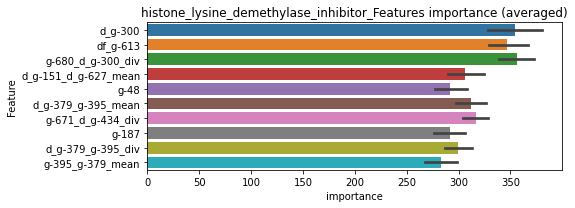

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839838	valid_1's binary_logloss: 0.115188
[200]	training's binary_logloss: 0.0233407	valid_1's binary_logloss: 0.0433472
[300]	training's binary_logloss: 0.00788921	valid_1's binary_logloss: 0.0195702
[400]	training's binary_logloss: 0.00330023	valid_1's binary_logloss: 0.010644
[500]	training's binary_logloss: 0.00172129	valid_1's binary_logloss: 0.00676408
[600]	training's binary_logloss: 0.00109845	valid_1's binary_logloss: 0.00497121
[700]	training's binary_logloss: 0.000794024	valid_1's binary_logloss: 0.00408723
[800]	training's binary_logloss: 0.000631494	valid_1's binary_logloss: 0.00355032
[900]	training's binary_logloss: 0.00054502	valid_1's binary_logloss: 0.00326687
[1000]	training's binary_logloss: 0.000504345	valid_1's binary_logloss: 0.00311944
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.000501224	valid_1's binary_logloss: 0.00310534


len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851123	valid_1's binary_logloss: 0.119807
[200]	training's binary_logloss: 0.0240769	valid_1's binary_logloss: 0.0481401
[300]	training's binary_logloss: 0.00813703	valid_1's binary_logloss: 0.0222839
[400]	training's binary_logloss: 0.0034118	valid_1's binary_logloss: 0.0132078
[500]	training's binary_logloss: 0.00172979	valid_1's binary_logloss: 0.00809628
[600]	training's binary_logloss: 0.00109526	valid_1's binary_logloss: 0.00619236
[700]	training's binary_logloss: 0.00079428	valid_1's binary_logloss: 0.00519916
[800]	training's binary_logloss: 0.000630595	valid_1's binary_logloss: 0.00468686
[900]	training's binary_logloss: 0.000540705	valid_1's binary_logloss: 0.00424962
[1000]	training's binary_logloss: 0.000512493	valid_1's binary_logloss: 0.00415323
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000512532	valid_1's binary_logloss: 0.00415292


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855844	valid_1's binary_logloss: 0.113942
[200]	training's binary_logloss: 0.0242326	valid_1's binary_logloss: 0.045116
[300]	training's binary_logloss: 0.00800251	valid_1's binary_logloss: 0.0220458
[400]	training's binary_logloss: 0.00326991	valid_1's binary_logloss: 0.0133249
[500]	training's binary_logloss: 0.00169049	valid_1's binary_logloss: 0.00960717
[600]	training's binary_logloss: 0.00107218	valid_1's binary_logloss: 0.00801574
[700]	training's binary_logloss: 0.000776268	valid_1's binary_logloss: 0.00707647
[800]	training's binary_logloss: 0.000617071	valid_1's binary_logloss: 0.00656134
[900]	training's binary_logloss: 0.000534807	valid_1's binary_logloss: 0.00621528
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.000525438	valid_1's binary_logloss: 0.00618124


len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0846571	valid_1's binary_logloss: 0.110806
[200]	training's binary_logloss: 0.0236814	valid_1's binary_logloss: 0.0447287
[300]	training's binary_logloss: 0.0080922	valid_1's binary_logloss: 0.0227487
[400]	training's binary_logloss: 0.00336248	valid_1's binary_logloss: 0.0144514
[500]	training's binary_logloss: 0.00174987	valid_1's binary_logloss: 0.0108224
[600]	training's binary_logloss: 0.00110721	valid_1's binary_logloss: 0.00876495
[700]	training's binary_logloss: 0.000792807	valid_1's binary_logloss: 0.00770511
[800]	training's binary_logloss: 0.000634245	valid_1's binary_logloss: 0.00711161
[900]	training's binary_logloss: 0.00054415	valid_1's binary_logloss: 0.00663933
Early stopping, best iteration is:
[878]	training's binary_logloss: 0.000558211	valid_1's binary_logloss: 0.00662982


histone_lysine_demethylase_inhibitor logloss: 0.005017832133066276


neg labels: 3289 → selected neg labels: 3284


histone_lysine_methyltransferase_inhibitor, len(trt): 32, len(othr): 3284, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978244	valid_1's binary_logloss: 0.143774
[200]	training's binary_logloss: 0.034236	valid_1's binary_logloss: 0.0714114
[300]	training's binary_logloss: 0.0126791	valid_1's binary_logloss: 0.0400262
[400]	training's binary_logloss: 0.00542757	valid_1's binary_logloss: 0.026839
[500]	training's binary_logloss: 0.00277349	valid_1's binary_logloss: 0.0212425
[600]	training's binary_logloss: 0.00167885	valid_1's binary_logloss: 0.0184218
[700]	training's binary_logloss: 0.00117086	valid_1's binary_logloss: 0.0171924
[800]	training's binary_logloss: 0.000891593	valid_1's binary_logloss: 0.015937
[900]	training's binary_logloss: 0.00073985	valid_1's binary_logloss: 0.0153004
Early stopping, best iteration is:
[942]	training's binary_logloss: 0.00069464	valid_1's binary_logloss: 0.0151687
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0973384	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0133943, Threshold: 0.0792970, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.05551, conf_1:0.10309
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.0792970
Num_p_label: 29.0, Expected: 5.4, Adj_threshold_2: 0.1292970
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_3: 0.1792970
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_4: 0.2292970
Num_p_label: 18.0, Expected: 5.4, Adj_threshold_5: 0.2792970
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_6: 0.3292970
threshold: 0.3292970, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0930579	valid_1's binary_logloss: 0.146551
[200]	training's binary_logloss: 0.0292843	valid_1's binary_logloss: 0.0734512
[300]	training's binary_logloss: 0.0106131	valid_1's binary_logloss: 0.0435591
[400]	training's binary_logloss: 0.00445843	valid_1's binary_logloss: 0.0304985
[500]	training's binary_logloss: 0.00229376	valid_1's binary_logloss: 0.0231972
[600]	training's binary_logloss: 0.00139028	valid_1's binary_logloss: 0.0201577
[700]	training's binary_logloss: 0.000980022	valid_1's binary_logloss: 0.0184307
[800]	training's binary_logloss: 0.000759542	valid_1's binary_logloss: 0.0175664
[900]	training's binary_logloss: 0.000638253	valid_1's binary_logloss: 0.0169357
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000621413	valid_1's binary_logloss: 0.0167674
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937487	

2 / 3 AUC score:1.000
y_Threshold: 0.1237875, Threshold: 0.3292970, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0123054 Vs.target_rate: 0.00134, Num_p_label: 49.0, conf_0:0.26344, conf_1:0.39516
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_1: 0.3292970
Num_p_label: 42.0, Expected: 5.4, Adj_threshold_2: 0.3792970
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_3: 0.4292970
Num_p_label: 35.0, Expected: 5.4, Adj_threshold_4: 0.4792970
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_5: 0.5292970
Num_p_label: 31.0, Expected: 5.4, Adj_threshold_6: 0.5792970
Num_p_label: 27.0, Expected: 5.4, Adj_threshold_7: 0.6292970
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_8: 0.6792970
Num_p_label: 19.0, Expected: 5.4, Adj_threshold_9: 0.7292970
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_10: 0.7792970
threshold: 0.7792970, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 647.0/3790, y_label_rate: 0.1707124
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927009	valid_1's binary_logloss: 0.129433
[200]	training's binary_logloss: 0.0284941	valid_1's binary_logloss: 0.0608828
[300]	training's binary_logloss: 0.0101518	valid_1's binary_logloss: 0.0362309
[400]	training's binary_logloss: 0.00425349	valid_1's binary_logloss: 0.0254886
[500]	training's binary_logloss: 0.00214549	valid_1's binary_logloss: 0.0204981
[600]	training's binary_logloss: 0.00131667	valid_1's binary_logloss: 0.0182698
[700]	training's binary_logloss: 0.00093307	valid_1's binary_logloss: 0.0170466
[800]	training's binary_logloss: 0.000726103	valid_1's binary_logloss: 0.0164716
[900]	training's binary_logloss: 0.000616434	valid_1's binary_logloss: 0.0160458
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.000598885	valid_1's binary_logloss: 0.0159943
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0932629	v

3 / 3 AUC score:1.000
y_Threshold: 0.1137101, Threshold: 0.7792970, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 643.0/3782
p_label_rate: 0.0052737 Vs.target_rate: 0.00134, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 5.4, Adj_threshold_1: 0.7792970
threshold: 0.7792970, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 643.0/3782, y_label_rate: 0.1700159


len(train_index) : 2836
len(valid_index) : 946
================================= fold 1/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918865	valid_1's binary_logloss: 0.133705
[200]	training's binary_logloss: 0.0282889	valid_1's binary_logloss: 0.0630748
[300]	training's binary_logloss: 0.0103216	valid_1's binary_logloss: 0.0364913
[400]	training's binary_logloss: 0.00425385	valid_1's binary_logloss: 0.024535
[500]	training's binary_logloss: 0.00211306	valid_1's binary_logloss: 0.0189368
[600]	training's binary_logloss: 0.00129697	valid_1's binary_logloss: 0.0165339
[700]	training's binary_logloss: 0.000912652	valid_1's binary_logloss: 0.0154066
Early stopping, best iteration is:
[762]	training's binary_logloss: 0.000776715	valid_1's binary_logloss: 0.0147566


len(train_index) : 2836
len(valid_index) : 946
================================= fold 2/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.090503	valid_1's binary_logloss: 0.123
[200]	training's binary_logloss: 0.0284295	valid_1's binary_logloss: 0.0582737
[300]	training's binary_logloss: 0.010439	valid_1's binary_logloss: 0.033997
[400]	training's binary_logloss: 0.00429838	valid_1's binary_logloss: 0.0233051
[500]	training's binary_logloss: 0.00216473	valid_1's binary_logloss: 0.0179351
[600]	training's binary_logloss: 0.00132272	valid_1's binary_logloss: 0.0155448
[700]	training's binary_logloss: 0.000926254	valid_1's binary_logloss: 0.0143039
[800]	training's binary_logloss: 0.000720592	valid_1's binary_logloss: 0.0134182
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000643062	valid_1's binary_logloss: 0.0131731


len(train_index) : 2837
len(valid_index) : 945
================================= fold 3/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901106	valid_1's binary_logloss: 0.126339
[200]	training's binary_logloss: 0.0277204	valid_1's binary_logloss: 0.0587287
[300]	training's binary_logloss: 0.00989757	valid_1's binary_logloss: 0.0318946
[400]	training's binary_logloss: 0.00412475	valid_1's binary_logloss: 0.0208772
[500]	training's binary_logloss: 0.00208501	valid_1's binary_logloss: 0.0161482
[600]	training's binary_logloss: 0.00128255	valid_1's binary_logloss: 0.0127807
[700]	training's binary_logloss: 0.000909579	valid_1's binary_logloss: 0.0114279
[800]	training's binary_logloss: 0.000711023	valid_1's binary_logloss: 0.0108174
[900]	training's binary_logloss: 0.000606238	valid_1's binary_logloss: 0.0101868
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.000604182	valid_1's binary_logloss: 0.0101516


len(train_index) : 2837
len(valid_index) : 945
================================= fold 4/4 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.093605	valid_1's binary_logloss: 0.118495
[200]	training's binary_logloss: 0.0293484	valid_1's binary_logloss: 0.0524466
[300]	training's binary_logloss: 0.0108465	valid_1's binary_logloss: 0.0291248
[400]	training's binary_logloss: 0.00441944	valid_1's binary_logloss: 0.0188945
[500]	training's binary_logloss: 0.00221222	valid_1's binary_logloss: 0.0152993
[600]	training's binary_logloss: 0.00135056	valid_1's binary_logloss: 0.013556
[700]	training's binary_logloss: 0.000949452	valid_1's binary_logloss: 0.0124547
[800]	training's binary_logloss: 0.000737914	valid_1's binary_logloss: 0.0119364
[900]	training's binary_logloss: 0.000627088	valid_1's binary_logloss: 0.0114363
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000616013	valid_1's binary_logloss: 0.011406


histone_lysine_methyltransferase_inhibitor logloss: 0.012372647853748968


neg labels: 3289 → selected neg labels: 3280


hiv_inhibitor, len(trt): 72, len(othr): 3280, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131067	valid_1's binary_logloss: 0.198919
[200]	training's binary_logloss: 0.0533186	valid_1's binary_logloss: 0.126234
[300]	training's binary_logloss: 0.0244597	valid_1's binary_logloss: 0.0946626
[400]	training's binary_logloss: 0.0119608	valid_1's binary_logloss: 0.0772895
[500]	training's binary_logloss: 0.00625493	valid_1's binary_logloss: 0.0671613
[600]	training's binary_logloss: 0.00368184	valid_1's binary_logloss: 0.0622646
[700]	training's binary_logloss: 0.00242661	valid_1's binary_logloss: 0.0592071
[800]	training's binary_logloss: 0.00175981	valid_1's binary_logloss: 0.0573229
[900]	training's binary_logloss: 0.00137782	valid_1's binary_logloss: 0.0565074
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00142226	valid_1's binary_logloss: 0.0563378
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136314	valid_1'

1 / 3 AUC score:0.998
y_Threshold: 0.0204958, Threshold: 0.1861483, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.13030, conf_1:0.24199
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.1861483
Num_p_label: 33.0, Expected: 12.0, Adj_threshold_2: 0.2361483
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_3: 0.2861483
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_4: 0.3361483
Num_p_label: 17.0, Expected: 12.0, Adj_threshold_5: 0.3861483
threshold: 0.3861483, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 650.0/3792, y_label_rate: 0.1714135
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128355	valid_1's binary_logloss: 0.169833
[200]	training's binary_logloss: 0.0503456	valid_1's binary_logloss: 0.0926048
[300]	training's binary_logloss: 0.0222575	valid_1's binary_logloss: 0.0577082
[400]	training's binary_logloss: 0.0105504	valid_1's binary_logloss: 0.0393168
[500]	training's binary_logloss: 0.005506	valid_1's binary_logloss: 0.0294508
[600]	training's binary_logloss: 0.00325439	valid_1's binary_logloss: 0.0243023
[700]	training's binary_logloss: 0.00216595	valid_1's binary_logloss: 0.0214429
[800]	training's binary_logloss: 0.00159776	valid_1's binary_logloss: 0.0197888
[900]	training's binary_logloss: 0.00126116	valid_1's binary_logloss: 0.0185094
[1000]	training's binary_logloss: 0.00106633	valid_1's binary_logloss: 0.0178889
Early stopping, best iteration is:
[1043]	training's binary_logloss: 0.0010019	valid_1's binary_logloss: 0.0177173
Training until validation score

2 / 3 AUC score:0.999
y_Threshold: 0.0802877, Threshold: 0.3861483, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 637.0/3766
p_label_rate: 0.0135610 Vs.target_rate: 0.00302, Num_p_label: 54.0, conf_0:0.30892, conf_1:0.46338
Num_p_label: 54.0, Expected: 12.0, Adj_threshold_1: 0.3861483
Num_p_label: 51.0, Expected: 12.0, Adj_threshold_2: 0.4361483
Num_p_label: 47.0, Expected: 12.0, Adj_threshold_3: 0.4861483
Num_p_label: 39.0, Expected: 12.0, Adj_threshold_4: 0.5361483
Num_p_label: 31.0, Expected: 12.0, Adj_threshold_5: 0.5861483
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_6: 0.6361483
Num_p_label: 19.0, Expected: 12.0, Adj_threshold_7: 0.6861483
Num_p_label: 14.0, Expected: 12.0, Adj_threshold_8: 0.7361483
threshold: 0.7361483, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 637.0/3766, y_label_rate: 0.1691450
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120949	valid_1's binary_logloss: 0.180722
[200]	training's binary_logloss: 0.0463263	valid_1's binary_logloss: 0.108867
[300]	training's binary_logloss: 0.0201626	valid_1's binary_logloss: 0.0761694
[400]	training's binary_logloss: 0.00921802	valid_1's binary_logloss: 0.0593047
[500]	training's binary_logloss: 0.00479936	valid_1's binary_logloss: 0.0500167
[600]	training's binary_logloss: 0.00287257	valid_1's binary_logloss: 0.0459595
[700]	training's binary_logloss: 0.00194827	valid_1's binary_logloss: 0.0444984
[800]	training's binary_logloss: 0.00144773	valid_1's binary_logloss: 0.0433243
[900]	training's binary_logloss: 0.00115925	valid_1's binary_logloss: 0.0429673
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00119562	valid_1's binary_logloss: 0.0427638
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121831	valid_1

3 / 3 AUC score:0.998
y_Threshold: 0.0776522, Threshold: 0.7361483, pos_neg_ratio: 0.8000000
Remove_noisy_data: 26 → Positive_corect_labels: 624.0/3740
p_label_rate: 0.0052737 Vs.target_rate: 0.00302, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_1: 0.7361483
Num_p_label: 15.0, Expected: 12.0, Adj_threshold_2: 0.7861483
threshold: 0.7861483, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 624.0/3740, y_label_rate: 0.1668449


len(train_index) : 2805
len(valid_index) : 935
================================= fold 1/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118088	valid_1's binary_logloss: 0.168563
[200]	training's binary_logloss: 0.0444995	valid_1's binary_logloss: 0.0912565
[300]	training's binary_logloss: 0.0186988	valid_1's binary_logloss: 0.0562719
[400]	training's binary_logloss: 0.00851875	valid_1's binary_logloss: 0.0391501
[500]	training's binary_logloss: 0.00445446	valid_1's binary_logloss: 0.0298055
[600]	training's binary_logloss: 0.00267167	valid_1's binary_logloss: 0.0252802
[700]	training's binary_logloss: 0.00182884	valid_1's binary_logloss: 0.0225983
[800]	training's binary_logloss: 0.00136899	valid_1's binary_logloss: 0.0212474
[900]	training's binary_logloss: 0.00110006	valid_1's binary_logloss: 0.0198559
[1000]	training's binary_logloss: 0.000947419	valid_1's binary_logloss: 0.0190991
[1100]	training's binary_logloss: 0.000854973	valid_1's binary_logloss: 0.0185906
Early stopping, best iteration is:
[1136]	training's binary_

len(train_index) : 2805
len(valid_index) : 935
================================= fold 2/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11955	valid_1's binary_logloss: 0.165859
[200]	training's binary_logloss: 0.0434459	valid_1's binary_logloss: 0.0914879
[300]	training's binary_logloss: 0.0178889	valid_1's binary_logloss: 0.0595868
[400]	training's binary_logloss: 0.00832001	valid_1's binary_logloss: 0.0438772
[500]	training's binary_logloss: 0.00432196	valid_1's binary_logloss: 0.0356279
[600]	training's binary_logloss: 0.00258893	valid_1's binary_logloss: 0.0309143
[700]	training's binary_logloss: 0.00179204	valid_1's binary_logloss: 0.0282962
[800]	training's binary_logloss: 0.00134821	valid_1's binary_logloss: 0.0266993
[900]	training's binary_logloss: 0.00109186	valid_1's binary_logloss: 0.0261067
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.00103948	valid_1's binary_logloss: 0.0258196


len(train_index) : 2805
len(valid_index) : 935
================================= fold 3/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120544	valid_1's binary_logloss: 0.174011
[200]	training's binary_logloss: 0.0439898	valid_1's binary_logloss: 0.0938142
[300]	training's binary_logloss: 0.0183099	valid_1's binary_logloss: 0.0617439
[400]	training's binary_logloss: 0.00853811	valid_1's binary_logloss: 0.0464761
[500]	training's binary_logloss: 0.00448741	valid_1's binary_logloss: 0.0381672
[600]	training's binary_logloss: 0.00268698	valid_1's binary_logloss: 0.0336559
[700]	training's binary_logloss: 0.00183526	valid_1's binary_logloss: 0.0309823
[800]	training's binary_logloss: 0.00137293	valid_1's binary_logloss: 0.0297817
[900]	training's binary_logloss: 0.00110539	valid_1's binary_logloss: 0.0285724
[1000]	training's binary_logloss: 0.000946129	valid_1's binary_logloss: 0.0281097
Early stopping, best iteration is:
[1067]	training's binary_logloss: 0.000879255	valid_1's binary_logloss: 0.027739


len(train_index) : 2805
len(valid_index) : 935
================================= fold 4/4 hiv_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118922	valid_1's binary_logloss: 0.167914
[200]	training's binary_logloss: 0.044491	valid_1's binary_logloss: 0.0940708
[300]	training's binary_logloss: 0.0185562	valid_1's binary_logloss: 0.0639886
[400]	training's binary_logloss: 0.00839554	valid_1's binary_logloss: 0.0499128
[500]	training's binary_logloss: 0.00436327	valid_1's binary_logloss: 0.0435653
[600]	training's binary_logloss: 0.00260323	valid_1's binary_logloss: 0.0402034
[700]	training's binary_logloss: 0.00179041	valid_1's binary_logloss: 0.0375805
[800]	training's binary_logloss: 0.00134702	valid_1's binary_logloss: 0.0366162
[900]	training's binary_logloss: 0.00108838	valid_1's binary_logloss: 0.0356786
Early stopping, best iteration is:
[896]	training's binary_logloss: 0.00109562	valid_1's binary_logloss: 0.0356422


hiv_inhibitor logloss: 0.026921444371457923


neg labels: 3289 → selected neg labels: 3246


hmgcr_inhibitor, len(trt): 283, len(othr): 3246, target_rate: 0.0118838 → Adj_target_rate: 0.0101910
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.238136	valid_1's binary_logloss: 0.373007
[200]	training's binary_logloss: 0.14882	valid_1's binary_logloss: 0.34029
[300]	training's binary_logloss: 0.0972121	valid_1's binary_logloss: 0.322625
[400]	training's binary_logloss: 0.0666134	valid_1's binary_logloss: 0.315895
[500]	training's binary_logloss: 0.0461844	valid_1's binary_logloss: 0.312388
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.0434383	valid_1's binary_logloss: 0.311878
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.236604	valid_1's binary_logloss: 0.36674
[200]	training's binary_logloss: 0.147797	valid_1's binary_logloss: 0.33902
[300]	training's binary_logloss: 0.0979491	valid_1's binary_logloss: 0.325751
[400]	training's binary_logloss: 0.0648302	valid_1's binary_logloss: 0.322224
Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0

1 / 3 AUC score:0.851
y_Threshold: 0.1208835, Threshold: 0.4524823, pos_neg_ratio: 0.8000000
Remove_noisy_data: 538 → Positive_corect_labels: 445/3357
p_label_rate: 0.0100452 Vs.target_rate: 0.01188, Num_p_label: 40.0, conf_0:0.31674, conf_1:0.58823
threshold: 0.4524823, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 445.0/3357, y_label_rate: 0.1325588
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.142715	valid_1's binary_logloss: 0.248861
[200]	training's binary_logloss: 0.0678011	valid_1's binary_logloss: 0.196922
[300]	training's binary_logloss: 0.0357451	valid_1's binary_logloss: 0.172739
[400]	training's binary_logloss: 0.0201038	valid_1's binary_logloss: 0.161118
[500]	training's binary_logloss: 0.0114184	valid_1's binary_logloss: 0.156111
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00857732	valid_1's binary_logloss: 0.155724
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14807	valid_1's binary_logloss: 0.230511
[200]	training's binary_logloss: 0.0744599	valid_1's binary_logloss: 0.18274
[300]	training's binary_logloss: 0.039663	valid_1's binary_logloss: 0.161363
[400]	training's binary_logloss: 0.0218268	valid_1's binary_logloss: 0.149504
[500]	training's binary_logloss: 0.0125787	valid_1's binary_logloss

2 / 3 AUC score:0.955
y_Threshold: 0.1121046, Threshold: 0.4524823, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 373.0/3213
p_label_rate: 0.0203415 Vs.target_rate: 0.01188, Num_p_label: 81.0, conf_0:0.36199, conf_1:0.54298
Num_p_label: 81.0, Expected: 47.3, Adj_threshold_1: 0.4524823
Num_p_label: 73.0, Expected: 47.3, Adj_threshold_2: 0.5024823
Num_p_label: 55.0, Expected: 47.3, Adj_threshold_3: 0.5524823
threshold: 0.5524823, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 373.0/3213, y_label_rate: 0.1160909
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107118	valid_1's binary_logloss: 0.198863
[200]	training's binary_logloss: 0.0451648	valid_1's binary_logloss: 0.15195
[300]	training's binary_logloss: 0.021188	valid_1's binary_logloss: 0.135568
[400]	training's binary_logloss: 0.0107644	valid_1's binary_logloss: 0.125717
[500]	training's binary_logloss: 0.00599827	valid_1's binary_logloss: 0.122347
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00453513	valid_1's binary_logloss: 0.121124
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111461	valid_1's binary_logloss: 0.186616
[200]	training's binary_logloss: 0.0470438	valid_1's binary_logloss: 0.138691
[300]	training's binary_logloss: 0.0225421	valid_1's binary_logloss: 0.114685
[400]	training's binary_logloss: 0.0115715	valid_1's binary_logloss: 0.103476
[500]	training's binary_logloss: 0.00649469	valid_1's binary_logl

3 / 3 AUC score:0.978
y_Threshold: 0.0984236, Threshold: 0.5524823, pos_neg_ratio: 0.8000000
Remove_noisy_data: 94 → Positive_corect_labels: 326.0/3119
p_label_rate: 0.0205927 Vs.target_rate: 0.01188, Num_p_label: 82.0, conf_0:0.49723, conf_1:0.60773
Num_p_label: 82.0, Expected: 47.3, Adj_threshold_1: 0.5524823
Num_p_label: 71.0, Expected: 47.3, Adj_threshold_2: 0.6024823
Num_p_label: 60.0, Expected: 47.3, Adj_threshold_3: 0.6524823
threshold: 0.6524823, positive_p_label: 60.0/3982, p_label_rate: 0.0150678
positive_y_label: 326.0/3119, y_label_rate: 0.1045207


len(train_index) : 2339
len(valid_index) : 780
================================= fold 1/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885807	valid_1's binary_logloss: 0.176624
[200]	training's binary_logloss: 0.0331925	valid_1's binary_logloss: 0.134602
[300]	training's binary_logloss: 0.0150391	valid_1's binary_logloss: 0.118496
[400]	training's binary_logloss: 0.00745391	valid_1's binary_logloss: 0.110545
[500]	training's binary_logloss: 0.00420657	valid_1's binary_logloss: 0.1074
[600]	training's binary_logloss: 0.00269087	valid_1's binary_logloss: 0.106079
Early stopping, best iteration is:
[646]	training's binary_logloss: 0.00227329	valid_1's binary_logloss: 0.10413


len(train_index) : 2339
len(valid_index) : 780
================================= fold 2/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0863703	valid_1's binary_logloss: 0.170948
[200]	training's binary_logloss: 0.0336219	valid_1's binary_logloss: 0.131003
[300]	training's binary_logloss: 0.0148146	valid_1's binary_logloss: 0.116976
[400]	training's binary_logloss: 0.00732511	valid_1's binary_logloss: 0.111201
[500]	training's binary_logloss: 0.00410167	valid_1's binary_logloss: 0.108062
[600]	training's binary_logloss: 0.00262096	valid_1's binary_logloss: 0.107564
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00254083	valid_1's binary_logloss: 0.10728


len(train_index) : 2339
len(valid_index) : 780
================================= fold 3/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.089598	valid_1's binary_logloss: 0.129788
[200]	training's binary_logloss: 0.0346	valid_1's binary_logloss: 0.0829782
[300]	training's binary_logloss: 0.0155626	valid_1's binary_logloss: 0.0640038
[400]	training's binary_logloss: 0.00768973	valid_1's binary_logloss: 0.0551275
[500]	training's binary_logloss: 0.00425176	valid_1's binary_logloss: 0.0502806
[600]	training's binary_logloss: 0.00271045	valid_1's binary_logloss: 0.0484755
[700]	training's binary_logloss: 0.00193006	valid_1's binary_logloss: 0.0471512
[800]	training's binary_logloss: 0.0014884	valid_1's binary_logloss: 0.0466685
[900]	training's binary_logloss: 0.00122903	valid_1's binary_logloss: 0.0460352
[1000]	training's binary_logloss: 0.00107476	valid_1's binary_logloss: 0.045729
Early stopping, best iteration is:
[1036]	training's binary_logloss: 0.00103445	valid_1's binary_logloss: 0.0456521


len(train_index) : 2340
len(valid_index) : 779
================================= fold 4/4 hmgcr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885316	valid_1's binary_logloss: 0.151006
[200]	training's binary_logloss: 0.0328922	valid_1's binary_logloss: 0.106706
[300]	training's binary_logloss: 0.0149795	valid_1's binary_logloss: 0.0885715
[400]	training's binary_logloss: 0.00740605	valid_1's binary_logloss: 0.0817381
[500]	training's binary_logloss: 0.00413953	valid_1's binary_logloss: 0.0775147
[600]	training's binary_logloss: 0.00266182	valid_1's binary_logloss: 0.0749256
[700]	training's binary_logloss: 0.00189714	valid_1's binary_logloss: 0.0737872
Early stopping, best iteration is:
[675]	training's binary_logloss: 0.00204642	valid_1's binary_logloss: 0.0735938


hmgcr_inhibitor logloss: 0.08266691446658139


neg labels: 3289 → selected neg labels: 3272


hsp_inhibitor, len(trt): 93, len(othr): 3272, target_rate: 0.0039053 → Adj_target_rate: 0.0039574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.15634	valid_1's binary_logloss: 0.239626
[200]	training's binary_logloss: 0.0743793	valid_1's binary_logloss: 0.173571
[300]	training's binary_logloss: 0.0394892	valid_1's binary_logloss: 0.142932
[400]	training's binary_logloss: 0.0215038	valid_1's binary_logloss: 0.12328
[500]	training's binary_logloss: 0.0120238	valid_1's binary_logloss: 0.110848
[600]	training's binary_logloss: 0.0070659	valid_1's binary_logloss: 0.104769
[700]	training's binary_logloss: 0.00450427	valid_1's binary_logloss: 0.100994
[800]	training's binary_logloss: 0.00309799	valid_1's binary_logloss: 0.0989476
Early stopping, best iteration is:
[868]	training's binary_logloss: 0.0025108	valid_1's binary_logloss: 0.0979657
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155428	valid_1's binary_logloss: 0.244608
[200]	training's binary_logloss: 0.0747064	valid_1's binary_log

1 / 3 AUC score:0.992
y_Threshold: 0.0427450, Threshold: 0.2380819, pos_neg_ratio: 0.8000000
Remove_noisy_data: 180 → Positive_corect_labels: 630/3746
p_label_rate: 0.0100452 Vs.target_rate: 0.00391, Num_p_label: 40.0, conf_0:0.16666, conf_1:0.30951
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_1: 0.2380819
Num_p_label: 26.0, Expected: 15.6, Adj_threshold_2: 0.2880819
Num_p_label: 21.0, Expected: 15.6, Adj_threshold_3: 0.3380819
threshold: 0.3380819, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 630.0/3746, y_label_rate: 0.1681794
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.140193	valid_1's binary_logloss: 0.223821
[200]	training's binary_logloss: 0.0605218	valid_1's binary_logloss: 0.160337
[300]	training's binary_logloss: 0.0292277	valid_1's binary_logloss: 0.133339
[400]	training's binary_logloss: 0.0150364	valid_1's binary_logloss: 0.121916
[500]	training's binary_logloss: 0.0081036	valid_1's binary_logloss: 0.117531
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.00624861	valid_1's binary_logloss: 0.116741
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143263	valid_1's binary_logloss: 0.215748
[200]	training's binary_logloss: 0.0632917	valid_1's binary_logloss: 0.139951
[300]	training's binary_logloss: 0.0303095	valid_1's binary_logloss: 0.103593
[400]	training's binary_logloss: 0.0154934	valid_1's binary_logloss: 0.0856756
[500]	training's binary_logloss: 0.00849706	valid_1's binary_lo

2 / 3 AUC score:0.993
y_Threshold: 0.1239433, Threshold: 0.3380819, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 595.0/3676
p_label_rate: 0.0180814 Vs.target_rate: 0.00391, Num_p_label: 72.0, conf_0:0.27047, conf_1:0.40570
Num_p_label: 72.0, Expected: 15.6, Adj_threshold_1: 0.3380819
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_2: 0.3880819
Num_p_label: 49.0, Expected: 15.6, Adj_threshold_3: 0.4380819
Num_p_label: 40.0, Expected: 15.6, Adj_threshold_4: 0.4880819
Num_p_label: 35.0, Expected: 15.6, Adj_threshold_5: 0.5380819
Num_p_label: 35.0, Expected: 15.6, Adj_threshold_6: 0.5880819
Num_p_label: 26.0, Expected: 15.6, Adj_threshold_7: 0.6380819
Num_p_label: 21.0, Expected: 15.6, Adj_threshold_8: 0.6880819
threshold: 0.6880819, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 595.0/3676, y_label_rate: 0.1618607
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126713	valid_1's binary_logloss: 0.205753
[200]	training's binary_logloss: 0.0498344	valid_1's binary_logloss: 0.137373
[300]	training's binary_logloss: 0.0227851	valid_1's binary_logloss: 0.108211
[400]	training's binary_logloss: 0.0110823	valid_1's binary_logloss: 0.0931716
[500]	training's binary_logloss: 0.00593885	valid_1's binary_logloss: 0.0841407
[600]	training's binary_logloss: 0.00357213	valid_1's binary_logloss: 0.0806369
[700]	training's binary_logloss: 0.00240363	valid_1's binary_logloss: 0.0792497
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.00195012	valid_1's binary_logloss: 0.0781218
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129894	valid_1's binary_logloss: 0.187848
[200]	training's binary_logloss: 0.0522237	valid_1's binary_logloss: 0.112869
[300]	training's binary_logloss: 0.0239003	valid_1's bin

3 / 3 AUC score:0.997
y_Threshold: 0.1136115, Threshold: 0.6880819, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 574.0/3634
p_label_rate: 0.0090407 Vs.target_rate: 0.00391, Num_p_label: 36.0, conf_0:0.50000, conf_1:0.75689
Num_p_label: 36.0, Expected: 15.6, Adj_threshold_1: 0.6880819
Num_p_label: 25.0, Expected: 15.6, Adj_threshold_2: 0.7380819
Num_p_label: 18.0, Expected: 15.6, Adj_threshold_3: 0.7880819
threshold: 0.7880819, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 574.0/3634, y_label_rate: 0.1579527


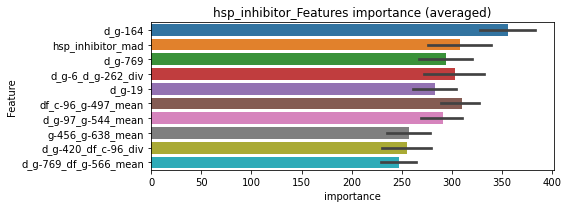

len(train_index) : 2725
len(valid_index) : 909
================================= fold 1/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119629	valid_1's binary_logloss: 0.189505
[200]	training's binary_logloss: 0.0466652	valid_1's binary_logloss: 0.121913
[300]	training's binary_logloss: 0.0204878	valid_1's binary_logloss: 0.0906471
[400]	training's binary_logloss: 0.00962876	valid_1's binary_logloss: 0.0747734
[500]	training's binary_logloss: 0.00508996	valid_1's binary_logloss: 0.0653422
[600]	training's binary_logloss: 0.00308267	valid_1's binary_logloss: 0.0614044
[700]	training's binary_logloss: 0.00208995	valid_1's binary_logloss: 0.0588655
[800]	training's binary_logloss: 0.00156257	valid_1's binary_logloss: 0.0575074
Early stopping, best iteration is:
[809]	training's binary_logloss: 0.00152926	valid_1's binary_logloss: 0.0574539


len(train_index) : 2725
len(valid_index) : 909
================================= fold 2/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122173	valid_1's binary_logloss: 0.18488
[200]	training's binary_logloss: 0.0484626	valid_1's binary_logloss: 0.115122
[300]	training's binary_logloss: 0.0212068	valid_1's binary_logloss: 0.0860826
[400]	training's binary_logloss: 0.0102565	valid_1's binary_logloss: 0.0724118
[500]	training's binary_logloss: 0.00537822	valid_1's binary_logloss: 0.0652544
[600]	training's binary_logloss: 0.00323071	valid_1's binary_logloss: 0.0619427
Early stopping, best iteration is:
[652]	training's binary_logloss: 0.00259319	valid_1's binary_logloss: 0.0603009


len(train_index) : 2726
len(valid_index) : 908
================================= fold 3/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124405	valid_1's binary_logloss: 0.177604
[200]	training's binary_logloss: 0.0497542	valid_1's binary_logloss: 0.101068
[300]	training's binary_logloss: 0.022127	valid_1's binary_logloss: 0.0660019
[400]	training's binary_logloss: 0.0106054	valid_1's binary_logloss: 0.0474585
[500]	training's binary_logloss: 0.00560301	valid_1's binary_logloss: 0.0370057
[600]	training's binary_logloss: 0.00337377	valid_1's binary_logloss: 0.0317459
[700]	training's binary_logloss: 0.00226465	valid_1's binary_logloss: 0.0291618
[800]	training's binary_logloss: 0.00167173	valid_1's binary_logloss: 0.0271673
[900]	training's binary_logloss: 0.00132933	valid_1's binary_logloss: 0.0264898
[1000]	training's binary_logloss: 0.001123	valid_1's binary_logloss: 0.0255742
[1100]	training's binary_logloss: 0.000997709	valid_1's binary_logloss: 0.0250388
Early stopping, best iteration is:
[1139]	training's binary_loglos

len(train_index) : 2726
len(valid_index) : 908
================================= fold 4/4 hsp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121982	valid_1's binary_logloss: 0.179904
[200]	training's binary_logloss: 0.0478158	valid_1's binary_logloss: 0.112284
[300]	training's binary_logloss: 0.0215817	valid_1's binary_logloss: 0.0841558
[400]	training's binary_logloss: 0.0103927	valid_1's binary_logloss: 0.0672772
[500]	training's binary_logloss: 0.00547554	valid_1's binary_logloss: 0.0600535
[600]	training's binary_logloss: 0.00330285	valid_1's binary_logloss: 0.055791
[700]	training's binary_logloss: 0.00222438	valid_1's binary_logloss: 0.0524768
[800]	training's binary_logloss: 0.00164819	valid_1's binary_logloss: 0.0510676
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.001447	valid_1's binary_logloss: 0.0501745


hsp_inhibitor logloss: 0.04820424390124831


neg labels: 3289 → selected neg labels: 3283


igf-1_inhibitor, len(trt): 37, len(othr): 3283, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108846	valid_1's binary_logloss: 0.153747
[200]	training's binary_logloss: 0.0388738	valid_1's binary_logloss: 0.0776444
[300]	training's binary_logloss: 0.0164519	valid_1's binary_logloss: 0.0473379
[400]	training's binary_logloss: 0.00749513	valid_1's binary_logloss: 0.033671
[500]	training's binary_logloss: 0.00379939	valid_1's binary_logloss: 0.0272174
[600]	training's binary_logloss: 0.00228537	valid_1's binary_logloss: 0.0235883
[700]	training's binary_logloss: 0.00154894	valid_1's binary_logloss: 0.0213284
[800]	training's binary_logloss: 0.00117189	valid_1's binary_logloss: 0.0204044
[900]	training's binary_logloss: 0.000946235	valid_1's binary_logloss: 0.0200364
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.000903796	valid_1's binary_logloss: 0.0198413
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106668	valid

1 / 3 AUC score:1.000
y_Threshold: 0.0147971, Threshold: 0.0951089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.06658, conf_1:0.12364
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0951089
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_2: 0.1451089
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_3: 0.1951089
threshold: 0.1951089, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1054	valid_1's binary_logloss: 0.152783
[200]	training's binary_logloss: 0.0347992	valid_1's binary_logloss: 0.0744296
[300]	training's binary_logloss: 0.0137007	valid_1's binary_logloss: 0.0443051
[400]	training's binary_logloss: 0.00600964	valid_1's binary_logloss: 0.0302768
[500]	training's binary_logloss: 0.0030543	valid_1's binary_logloss: 0.0235714
[600]	training's binary_logloss: 0.00187629	valid_1's binary_logloss: 0.0205909
[700]	training's binary_logloss: 0.00130404	valid_1's binary_logloss: 0.0192792
[800]	training's binary_logloss: 0.000997273	valid_1's binary_logloss: 0.0184027
[900]	training's binary_logloss: 0.00081663	valid_1's binary_logloss: 0.0179866
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.000798595	valid_1's binary_logloss: 0.0179328
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104574	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.1336464, Threshold: 0.1951089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 650.0/3795
p_label_rate: 0.0168257 Vs.target_rate: 0.00155, Num_p_label: 67.0, conf_0:0.15609, conf_1:0.23413
Num_p_label: 67.0, Expected: 6.2, Adj_threshold_1: 0.1951089
Num_p_label: 58.0, Expected: 6.2, Adj_threshold_2: 0.2451089
Num_p_label: 51.0, Expected: 6.2, Adj_threshold_3: 0.2951089
Num_p_label: 42.0, Expected: 6.2, Adj_threshold_4: 0.3451089
Num_p_label: 38.0, Expected: 6.2, Adj_threshold_5: 0.3951089
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_6: 0.4451089
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_7: 0.4951089
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_8: 0.5451089
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_9: 0.5951089
threshold: 0.5951089, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3795, y_label_rate: 0.1712780
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101412	valid_1's binary_logloss: 0.142431
[200]	training's binary_logloss: 0.0333374	valid_1's binary_logloss: 0.0672741
[300]	training's binary_logloss: 0.0125368	valid_1's binary_logloss: 0.039307
[400]	training's binary_logloss: 0.00536574	valid_1's binary_logloss: 0.0270492
[500]	training's binary_logloss: 0.00278314	valid_1's binary_logloss: 0.0220963
[600]	training's binary_logloss: 0.00173086	valid_1's binary_logloss: 0.0195297
[700]	training's binary_logloss: 0.00123058	valid_1's binary_logloss: 0.0185352
[800]	training's binary_logloss: 0.000950794	valid_1's binary_logloss: 0.0177652
[900]	training's binary_logloss: 0.00078614	valid_1's binary_logloss: 0.0175104
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000745997	valid_1's binary_logloss: 0.0173884
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103522	valid

3 / 3 AUC score:0.999
y_Threshold: 0.1094096, Threshold: 0.5951089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 647.0/3789
p_label_rate: 0.0072828 Vs.target_rate: 0.00155, Num_p_label: 29.0, conf_0:0.50000, conf_1:0.65462
Num_p_label: 29.0, Expected: 6.2, Adj_threshold_1: 0.5951089
Num_p_label: 24.0, Expected: 6.2, Adj_threshold_2: 0.6451089
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_3: 0.6951089
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_4: 0.7451089
threshold: 0.7451089, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 647.0/3789, y_label_rate: 0.1707575


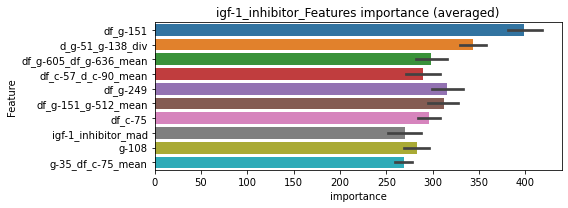

len(train_index) : 2841
len(valid_index) : 948
================================= fold 1/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101639	valid_1's binary_logloss: 0.151767
[200]	training's binary_logloss: 0.0328926	valid_1's binary_logloss: 0.0758492
[300]	training's binary_logloss: 0.0123279	valid_1's binary_logloss: 0.0457462
[400]	training's binary_logloss: 0.00528582	valid_1's binary_logloss: 0.0332535
[500]	training's binary_logloss: 0.00269905	valid_1's binary_logloss: 0.0280059
[600]	training's binary_logloss: 0.00166641	valid_1's binary_logloss: 0.0256189
[700]	training's binary_logloss: 0.00117328	valid_1's binary_logloss: 0.0244695
[800]	training's binary_logloss: 0.000904041	valid_1's binary_logloss: 0.0235902
[900]	training's binary_logloss: 0.000749449	valid_1's binary_logloss: 0.0230039
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000715114	valid_1's binary_logloss: 0.0229075


len(train_index) : 2842
len(valid_index) : 947
================================= fold 2/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101623	valid_1's binary_logloss: 0.137382
[200]	training's binary_logloss: 0.0334147	valid_1's binary_logloss: 0.0614631
[300]	training's binary_logloss: 0.0127777	valid_1's binary_logloss: 0.0329408
[400]	training's binary_logloss: 0.00545585	valid_1's binary_logloss: 0.0202741
[500]	training's binary_logloss: 0.00281576	valid_1's binary_logloss: 0.0144617
[600]	training's binary_logloss: 0.00172779	valid_1's binary_logloss: 0.0114169
[700]	training's binary_logloss: 0.00122156	valid_1's binary_logloss: 0.00977777
[800]	training's binary_logloss: 0.000945852	valid_1's binary_logloss: 0.00889533
[900]	training's binary_logloss: 0.000786703	valid_1's binary_logloss: 0.00841575
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000744154	valid_1's binary_logloss: 0.00820808


len(train_index) : 2842
len(valid_index) : 947
================================= fold 3/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100917	valid_1's binary_logloss: 0.133216
[200]	training's binary_logloss: 0.0324166	valid_1's binary_logloss: 0.0615803
[300]	training's binary_logloss: 0.0121909	valid_1's binary_logloss: 0.0336955
[400]	training's binary_logloss: 0.00532583	valid_1's binary_logloss: 0.021679
[500]	training's binary_logloss: 0.00272858	valid_1's binary_logloss: 0.0158817
[600]	training's binary_logloss: 0.00169598	valid_1's binary_logloss: 0.0129424
[700]	training's binary_logloss: 0.00119404	valid_1's binary_logloss: 0.0114086
[800]	training's binary_logloss: 0.000925765	valid_1's binary_logloss: 0.0105511
[900]	training's binary_logloss: 0.000773179	valid_1's binary_logloss: 0.00998199
[1000]	training's binary_logloss: 0.000692825	valid_1's binary_logloss: 0.00978945
Early stopping, best iteration is:
[984]	training's binary_logloss: 0.000706476	valid_1's binary_logloss: 0.00974564


len(train_index) : 2842
len(valid_index) : 947
================================= fold 4/4 igf-1_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100083	valid_1's binary_logloss: 0.138267
[200]	training's binary_logloss: 0.0326511	valid_1's binary_logloss: 0.0625991
[300]	training's binary_logloss: 0.0125645	valid_1's binary_logloss: 0.033651
[400]	training's binary_logloss: 0.00554912	valid_1's binary_logloss: 0.020925
[500]	training's binary_logloss: 0.0028503	valid_1's binary_logloss: 0.0150592
[600]	training's binary_logloss: 0.0017453	valid_1's binary_logloss: 0.011961
[700]	training's binary_logloss: 0.00122594	valid_1's binary_logloss: 0.0103907
[800]	training's binary_logloss: 0.000942427	valid_1's binary_logloss: 0.00941855
[900]	training's binary_logloss: 0.000781774	valid_1's binary_logloss: 0.00891207
Early stopping, best iteration is:
[954]	training's binary_logloss: 0.00072178	valid_1's binary_logloss: 0.008675


igf-1_inhibitor logloss: 0.012386823675993286


neg labels: 3289 → selected neg labels: 3285


ikk_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0954861	valid_1's binary_logloss: 0.123973
[200]	training's binary_logloss: 0.0336632	valid_1's binary_logloss: 0.0620109
[300]	training's binary_logloss: 0.0126452	valid_1's binary_logloss: 0.0372344
[400]	training's binary_logloss: 0.00521976	valid_1's binary_logloss: 0.0256657
[500]	training's binary_logloss: 0.00256563	valid_1's binary_logloss: 0.0205704
[600]	training's binary_logloss: 0.0015324	valid_1's binary_logloss: 0.0178561
[700]	training's binary_logloss: 0.0010672	valid_1's binary_logloss: 0.0168321
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000890171	valid_1's binary_logloss: 0.0162799
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0954642	valid_1's binary_logloss: 0.134865
[200]	training's binary_logloss: 0.0341951	valid_1's binary_logloss: 0.0679448
[300]	training's binary_logloss: 0.0130645	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0124976, Threshold: 0.0827355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.05791, conf_1:0.10756
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0827355
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_2: 0.1327355
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.1827355
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.2327355
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.2827355
threshold: 0.2827355, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913682	valid_1's binary_logloss: 0.117346
[200]	training's binary_logloss: 0.0298161	valid_1's binary_logloss: 0.0522027
[300]	training's binary_logloss: 0.0104854	valid_1's binary_logloss: 0.0292442
[400]	training's binary_logloss: 0.00428303	valid_1's binary_logloss: 0.0196271
[500]	training's binary_logloss: 0.00213259	valid_1's binary_logloss: 0.0150128
[600]	training's binary_logloss: 0.00130925	valid_1's binary_logloss: 0.0130893
[700]	training's binary_logloss: 0.000921509	valid_1's binary_logloss: 0.0120037
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000769073	valid_1's binary_logloss: 0.0116684
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0889432	valid_1's binary_logloss: 0.126462
[200]	training's binary_logloss: 0.028499	valid_1's binary_logloss: 0.0585523
[300]	training's binary_logloss: 0.0102034	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1663288, Threshold: 0.2827355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0107986 Vs.target_rate: 0.00126, Num_p_label: 43.0, conf_0:0.22619, conf_1:0.33928
Num_p_label: 43.0, Expected: 5.0, Adj_threshold_1: 0.2827355
Num_p_label: 37.0, Expected: 5.0, Adj_threshold_2: 0.3327355
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_3: 0.3827355
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_4: 0.4327355
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_5: 0.4827355
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_6: 0.5327355
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_7: 0.5827355
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_8: 0.6327355
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_9: 0.6827355
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_10: 0.7327355
threshold: 0.7827355, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0895153	valid_1's binary_logloss: 0.124617
[200]	training's binary_logloss: 0.0283109	valid_1's binary_logloss: 0.0571743
[300]	training's binary_logloss: 0.0100529	valid_1's binary_logloss: 0.0309932
[400]	training's binary_logloss: 0.00408275	valid_1's binary_logloss: 0.0189599
[500]	training's binary_logloss: 0.00207346	valid_1's binary_logloss: 0.0142406
[600]	training's binary_logloss: 0.00125458	valid_1's binary_logloss: 0.0112805
[700]	training's binary_logloss: 0.000885522	valid_1's binary_logloss: 0.0100648
[800]	training's binary_logloss: 0.000691278	valid_1's binary_logloss: 0.00930418
[900]	training's binary_logloss: 0.000583403	valid_1's binary_logloss: 0.00883302
[1000]	training's binary_logloss: 0.000529222	valid_1's binary_logloss: 0.00854894
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000529222	valid_1's binary_logloss: 0.00854894
Training until val

3 / 3 AUC score:0.999
y_Threshold: 0.1024075, Threshold: 0.7827355, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0035158 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_1: 0.7827355
threshold: 0.7827355, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 649.0/3794, y_label_rate: 0.1710596


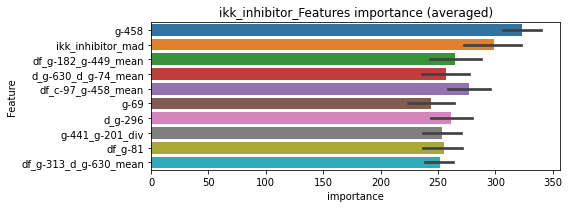

len(train_index) : 2845
len(valid_index) : 949
================================= fold 1/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.089112	valid_1's binary_logloss: 0.120137
[200]	training's binary_logloss: 0.0283513	valid_1's binary_logloss: 0.0555921
[300]	training's binary_logloss: 0.00979909	valid_1's binary_logloss: 0.0316699
[400]	training's binary_logloss: 0.00402086	valid_1's binary_logloss: 0.0219404
[500]	training's binary_logloss: 0.00201594	valid_1's binary_logloss: 0.0165976
[600]	training's binary_logloss: 0.00122527	valid_1's binary_logloss: 0.0142702
[700]	training's binary_logloss: 0.000863044	valid_1's binary_logloss: 0.0128648
[800]	training's binary_logloss: 0.000674337	valid_1's binary_logloss: 0.0119425
[900]	training's binary_logloss: 0.000564715	valid_1's binary_logloss: 0.0114978
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000563669	valid_1's binary_logloss: 0.0114955


len(train_index) : 2845
len(valid_index) : 949
================================= fold 2/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0862345	valid_1's binary_logloss: 0.118516
[200]	training's binary_logloss: 0.0269235	valid_1's binary_logloss: 0.0531026
[300]	training's binary_logloss: 0.00944781	valid_1's binary_logloss: 0.0296971
[400]	training's binary_logloss: 0.00383725	valid_1's binary_logloss: 0.0215293
[500]	training's binary_logloss: 0.00194496	valid_1's binary_logloss: 0.0169126
[600]	training's binary_logloss: 0.0011953	valid_1's binary_logloss: 0.0150009
[700]	training's binary_logloss: 0.000852708	valid_1's binary_logloss: 0.0145866
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.000888472	valid_1's binary_logloss: 0.0144226


len(train_index) : 2846
len(valid_index) : 948
================================= fold 3/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891559	valid_1's binary_logloss: 0.117293
[200]	training's binary_logloss: 0.0284683	valid_1's binary_logloss: 0.0526724
[300]	training's binary_logloss: 0.00988954	valid_1's binary_logloss: 0.0281301
[400]	training's binary_logloss: 0.0039925	valid_1's binary_logloss: 0.0196676
[500]	training's binary_logloss: 0.00199424	valid_1's binary_logloss: 0.0161605
[600]	training's binary_logloss: 0.00121259	valid_1's binary_logloss: 0.0140051
[700]	training's binary_logloss: 0.000849576	valid_1's binary_logloss: 0.0132966
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.000734249	valid_1's binary_logloss: 0.0130644


len(train_index) : 2846
len(valid_index) : 948
================================= fold 4/4 ikk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891596	valid_1's binary_logloss: 0.116938
[200]	training's binary_logloss: 0.0276216	valid_1's binary_logloss: 0.0511089
[300]	training's binary_logloss: 0.00982187	valid_1's binary_logloss: 0.0269589
[400]	training's binary_logloss: 0.00397203	valid_1's binary_logloss: 0.0165881
[500]	training's binary_logloss: 0.0019842	valid_1's binary_logloss: 0.0122265
[600]	training's binary_logloss: 0.00121738	valid_1's binary_logloss: 0.00975328
[700]	training's binary_logloss: 0.000855185	valid_1's binary_logloss: 0.0085856
[800]	training's binary_logloss: 0.000666801	valid_1's binary_logloss: 0.00785799
[900]	training's binary_logloss: 0.000566946	valid_1's binary_logloss: 0.00749152
[1000]	training's binary_logloss: 0.000525855	valid_1's binary_logloss: 0.00733857
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.000524221	valid_1's binary_logloss: 0.00732339


ikk_inhibitor logloss: 0.011577201542889914


neg labels: 3289 → selected neg labels: 3286


imidazoline_receptor_agonist, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101631	valid_1's binary_logloss: 0.13688
[200]	training's binary_logloss: 0.0354371	valid_1's binary_logloss: 0.0675463
[300]	training's binary_logloss: 0.0136341	valid_1's binary_logloss: 0.0394727
[400]	training's binary_logloss: 0.00576953	valid_1's binary_logloss: 0.0268541
[500]	training's binary_logloss: 0.00293548	valid_1's binary_logloss: 0.0211154
[600]	training's binary_logloss: 0.00178384	valid_1's binary_logloss: 0.0182179
[700]	training's binary_logloss: 0.00125558	valid_1's binary_logloss: 0.0169005
[800]	training's binary_logloss: 0.00097131	valid_1's binary_logloss: 0.0157668
[900]	training's binary_logloss: 0.00079734	valid_1's binary_logloss: 0.0151908
[1000]	training's binary_logloss: 0.000699	valid_1's binary_logloss: 0.0148535
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.000666841	valid_1's binary_logloss: 0.014709
Training until validation scor

1 / 3 AUC score:1.000
y_Threshold: 0.0126433, Threshold: 0.1188360, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.08319, conf_1:0.15449
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1188360
Num_p_label: 35.0, Expected: 5.2, Adj_threshold_2: 0.1688360
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_3: 0.2188360
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_4: 0.2688360
Num_p_label: 18.0, Expected: 5.2, Adj_threshold_5: 0.3188360
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_6: 0.3688360
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.4188360
threshold: 0.4188360, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975263	valid_1's binary_logloss: 0.131146
[200]	training's binary_logloss: 0.0316515	valid_1's binary_logloss: 0.0578879
[300]	training's binary_logloss: 0.0115215	valid_1's binary_logloss: 0.0313402
[400]	training's binary_logloss: 0.00481208	valid_1's binary_logloss: 0.0199564
[500]	training's binary_logloss: 0.00247844	valid_1's binary_logloss: 0.0151524
[600]	training's binary_logloss: 0.00153407	valid_1's binary_logloss: 0.0126073
[700]	training's binary_logloss: 0.00108982	valid_1's binary_logloss: 0.0111286
[800]	training's binary_logloss: 0.00085252	valid_1's binary_logloss: 0.0103195
[900]	training's binary_logloss: 0.00070942	valid_1's binary_logloss: 0.00991823
[1000]	training's binary_logloss: 0.000630754	valid_1's binary_logloss: 0.00967408
Early stopping, best iteration is:
[1015]	training's binary_logloss: 0.000620876	valid_1's binary_logloss: 0.00959527
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.0708472, Threshold: 0.4188360, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3805
p_label_rate: 0.0118031 Vs.target_rate: 0.00130, Num_p_label: 47.0, conf_0:0.33507, conf_1:0.50260
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_1: 0.4188360
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_2: 0.4688360
Num_p_label: 37.0, Expected: 5.2, Adj_threshold_3: 0.5188360
Num_p_label: 31.0, Expected: 5.2, Adj_threshold_4: 0.5688360
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_5: 0.6188360
Num_p_label: 26.0, Expected: 5.2, Adj_threshold_6: 0.6688360
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_7: 0.7188360
Num_p_label: 20.0, Expected: 5.2, Adj_threshold_8: 0.7688360
threshold: 0.7688360, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0954538	valid_1's binary_logloss: 0.124752
[200]	training's binary_logloss: 0.0313734	valid_1's binary_logloss: 0.0562036
[300]	training's binary_logloss: 0.0115734	valid_1's binary_logloss: 0.0320514
[400]	training's binary_logloss: 0.0048273	valid_1's binary_logloss: 0.0207749
[500]	training's binary_logloss: 0.00248652	valid_1's binary_logloss: 0.0159847
[600]	training's binary_logloss: 0.00154502	valid_1's binary_logloss: 0.0132155
[700]	training's binary_logloss: 0.00109971	valid_1's binary_logloss: 0.0118837
[800]	training's binary_logloss: 0.000857006	valid_1's binary_logloss: 0.0109678
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.000762721	valid_1's binary_logloss: 0.0104212
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0960578	valid_1's binary_logloss: 0.143921
[200]	training's binary_logloss: 0.0297223	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1102959, Threshold: 0.7688360, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 653.0/3803
p_label_rate: 0.0052737 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.7688360
threshold: 0.7688360, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 653.0/3803, y_label_rate: 0.1717065


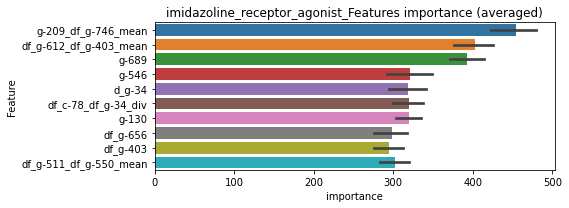

len(train_index) : 2852
len(valid_index) : 951
================================= fold 1/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096153	valid_1's binary_logloss: 0.130968
[200]	training's binary_logloss: 0.0304933	valid_1's binary_logloss: 0.0588384
[300]	training's binary_logloss: 0.0112241	valid_1's binary_logloss: 0.0317927
[400]	training's binary_logloss: 0.0047753	valid_1's binary_logloss: 0.0201829
[500]	training's binary_logloss: 0.00244182	valid_1's binary_logloss: 0.0146041
[600]	training's binary_logloss: 0.00151523	valid_1's binary_logloss: 0.0116055
[700]	training's binary_logloss: 0.00107146	valid_1's binary_logloss: 0.00988794
[800]	training's binary_logloss: 0.000843441	valid_1's binary_logloss: 0.00911398
[900]	training's binary_logloss: 0.00070874	valid_1's binary_logloss: 0.00856597
[1000]	training's binary_logloss: 0.000632821	valid_1's binary_logloss: 0.00828713
Early stopping, best iteration is:
[1000]	training's binary_logloss: 0.000632821	valid_1's binary_logloss: 0.00828713


len(train_index) : 2852
len(valid_index) : 951
================================= fold 2/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955509	valid_1's binary_logloss: 0.136092
[200]	training's binary_logloss: 0.0305594	valid_1's binary_logloss: 0.0655792
[300]	training's binary_logloss: 0.0112516	valid_1's binary_logloss: 0.0395095
[400]	training's binary_logloss: 0.00470709	valid_1's binary_logloss: 0.0281161
[500]	training's binary_logloss: 0.00239004	valid_1's binary_logloss: 0.0226834
[600]	training's binary_logloss: 0.00147733	valid_1's binary_logloss: 0.0204565
[700]	training's binary_logloss: 0.0010516	valid_1's binary_logloss: 0.0191739
[800]	training's binary_logloss: 0.000825437	valid_1's binary_logloss: 0.0185241
[900]	training's binary_logloss: 0.000693784	valid_1's binary_logloss: 0.0180884
[1000]	training's binary_logloss: 0.000627345	valid_1's binary_logloss: 0.0178932
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000631538	valid_1's binary_logloss: 0.0178592


len(train_index) : 2852
len(valid_index) : 951
================================= fold 3/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0948016	valid_1's binary_logloss: 0.133659
[200]	training's binary_logloss: 0.0299156	valid_1's binary_logloss: 0.058488
[300]	training's binary_logloss: 0.0108423	valid_1's binary_logloss: 0.0298184
[400]	training's binary_logloss: 0.00464839	valid_1's binary_logloss: 0.0180958
[500]	training's binary_logloss: 0.00239642	valid_1's binary_logloss: 0.0124179
[600]	training's binary_logloss: 0.00149885	valid_1's binary_logloss: 0.00989095
[700]	training's binary_logloss: 0.00106186	valid_1's binary_logloss: 0.00844713
[800]	training's binary_logloss: 0.00083511	valid_1's binary_logloss: 0.00764588
[900]	training's binary_logloss: 0.000702252	valid_1's binary_logloss: 0.0070075
[1000]	training's binary_logloss: 0.000635593	valid_1's binary_logloss: 0.00674256
[1100]	training's binary_logloss: 0.000604006	valid_1's binary_logloss: 0.00668595
Early stopping, best iteration is:
[1166]	training's b

len(train_index) : 2853
len(valid_index) : 950
================================= fold 4/4 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968119	valid_1's binary_logloss: 0.121067
[200]	training's binary_logloss: 0.0311949	valid_1's binary_logloss: 0.0491207
[300]	training's binary_logloss: 0.011437	valid_1's binary_logloss: 0.023241
[400]	training's binary_logloss: 0.00481439	valid_1's binary_logloss: 0.0129418
[500]	training's binary_logloss: 0.00246567	valid_1's binary_logloss: 0.00843232
[600]	training's binary_logloss: 0.00154079	valid_1's binary_logloss: 0.00650004
[700]	training's binary_logloss: 0.00108967	valid_1's binary_logloss: 0.00539499
[800]	training's binary_logloss: 0.000848106	valid_1's binary_logloss: 0.00469682
[900]	training's binary_logloss: 0.000708801	valid_1's binary_logloss: 0.00427707
[1000]	training's binary_logloss: 0.000634808	valid_1's binary_logloss: 0.00405424
Early stopping, best iteration is:
[1066]	training's binary_logloss: 0.000616242	valid_1's binary_logloss: 0.00400346


imidazoline_receptor_agonist logloss: 0.009208548692775488


neg labels: 3289 → selected neg labels: 3279


immunosuppressant, len(trt): 73, len(othr): 3279, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149237	valid_1's binary_logloss: 0.219101
[200]	training's binary_logloss: 0.0706475	valid_1's binary_logloss: 0.145263
[300]	training's binary_logloss: 0.0371372	valid_1's binary_logloss: 0.105734
[400]	training's binary_logloss: 0.0196048	valid_1's binary_logloss: 0.0813905
[500]	training's binary_logloss: 0.010819	valid_1's binary_logloss: 0.0658361
[600]	training's binary_logloss: 0.00621301	valid_1's binary_logloss: 0.0554998
[700]	training's binary_logloss: 0.00388173	valid_1's binary_logloss: 0.0512412
[800]	training's binary_logloss: 0.00265763	valid_1's binary_logloss: 0.0471699
[900]	training's binary_logloss: 0.00196481	valid_1's binary_logloss: 0.0451797
[1000]	training's binary_logloss: 0.00155026	valid_1's binary_logloss: 0.0432924
[1100]	training's binary_logloss: 0.00129619	valid_1's binary_logloss: 0.0424736
Early stopping, best iteration is:
[1134]	training's binary_logloss

1 / 3 AUC score:0.997
y_Threshold: 0.0325632, Threshold: 0.1758760, pos_neg_ratio: 0.8000000
Remove_noisy_data: 162 → Positive_corect_labels: 640/3772
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.12311, conf_1:0.22864
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.1758760
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_2: 0.2258760
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_3: 0.2758760
Num_p_label: 24.0, Expected: 12.2, Adj_threshold_4: 0.3258760
Num_p_label: 19.0, Expected: 12.2, Adj_threshold_5: 0.3758760
Num_p_label: 13.0, Expected: 12.2, Adj_threshold_6: 0.4258760
threshold: 0.4258760, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 640.0/3772, y_label_rate: 0.1696713
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132758	valid_1's binary_logloss: 0.217712
[200]	training's binary_logloss: 0.0557107	valid_1's binary_logloss: 0.14777
[300]	training's binary_logloss: 0.0256805	valid_1's binary_logloss: 0.113033
[400]	training's binary_logloss: 0.0123243	valid_1's binary_logloss: 0.0940621
[500]	training's binary_logloss: 0.00657591	valid_1's binary_logloss: 0.0848472
[600]	training's binary_logloss: 0.00382763	valid_1's binary_logloss: 0.0789964
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00319955	valid_1's binary_logloss: 0.0774872
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139339	valid_1's binary_logloss: 0.210228
[200]	training's binary_logloss: 0.0616545	valid_1's binary_logloss: 0.147917
[300]	training's binary_logloss: 0.0283704	valid_1's binary_logloss: 0.117053
[400]	training's binary_logloss: 0.0134696	valid_1's binary

2 / 3 AUC score:0.994
y_Threshold: 0.1479929, Threshold: 0.4258760, pos_neg_ratio: 0.8000000
Remove_noisy_data: 60 → Positive_corect_labels: 610.0/3712
p_label_rate: 0.0125565 Vs.target_rate: 0.00307, Num_p_label: 50.0, conf_0:0.34070, conf_1:0.51105
Num_p_label: 50.0, Expected: 12.2, Adj_threshold_1: 0.4258760
Num_p_label: 43.0, Expected: 12.2, Adj_threshold_2: 0.4758760
Num_p_label: 36.0, Expected: 12.2, Adj_threshold_3: 0.5258760
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_4: 0.5758760
Num_p_label: 27.0, Expected: 12.2, Adj_threshold_5: 0.6258760
Num_p_label: 26.0, Expected: 12.2, Adj_threshold_6: 0.6758760
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_7: 0.7258760
Num_p_label: 20.0, Expected: 12.2, Adj_threshold_8: 0.7758760
threshold: 0.7758760, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 610.0/3712, y_label_rate: 0.1643319
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124202	valid_1's binary_logloss: 0.189572
[200]	training's binary_logloss: 0.0510636	valid_1's binary_logloss: 0.119078
[300]	training's binary_logloss: 0.0232455	valid_1's binary_logloss: 0.084735
[400]	training's binary_logloss: 0.010964	valid_1's binary_logloss: 0.0670471
[500]	training's binary_logloss: 0.00564997	valid_1's binary_logloss: 0.0585051
[600]	training's binary_logloss: 0.00331085	valid_1's binary_logloss: 0.0525442
[700]	training's binary_logloss: 0.00219041	valid_1's binary_logloss: 0.0507901
[800]	training's binary_logloss: 0.00160138	valid_1's binary_logloss: 0.0496044
[900]	training's binary_logloss: 0.00126581	valid_1's binary_logloss: 0.048601
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00130657	valid_1's binary_logloss: 0.0484104
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124848	valid_1's b

3 / 3 AUC score:0.998
y_Threshold: 0.1736465, Threshold: 0.7758760, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 592.0/3676
p_label_rate: 0.0080362 Vs.target_rate: 0.00307, Num_p_label: 32.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 32.0, Expected: 12.2, Adj_threshold_1: 0.7758760
threshold: 0.7758760, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 592.0/3676, y_label_rate: 0.1610446


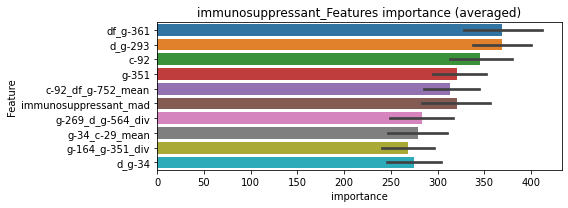

len(train_index) : 2757
len(valid_index) : 919
================================= fold 1/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119447	valid_1's binary_logloss: 0.172145
[200]	training's binary_logloss: 0.0472073	valid_1's binary_logloss: 0.105928
[300]	training's binary_logloss: 0.0216988	valid_1's binary_logloss: 0.0760939
[400]	training's binary_logloss: 0.0100059	valid_1's binary_logloss: 0.0615114
[500]	training's binary_logloss: 0.00507217	valid_1's binary_logloss: 0.0549384
[600]	training's binary_logloss: 0.00294892	valid_1's binary_logloss: 0.0515989
[700]	training's binary_logloss: 0.00195413	valid_1's binary_logloss: 0.0500565
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00184464	valid_1's binary_logloss: 0.0497624


len(train_index) : 2757
len(valid_index) : 919
================================= fold 2/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118211	valid_1's binary_logloss: 0.170243
[200]	training's binary_logloss: 0.0470998	valid_1's binary_logloss: 0.1009
[300]	training's binary_logloss: 0.0211221	valid_1's binary_logloss: 0.0698399
[400]	training's binary_logloss: 0.00966515	valid_1's binary_logloss: 0.0547552
[500]	training's binary_logloss: 0.00493213	valid_1's binary_logloss: 0.0473034
[600]	training's binary_logloss: 0.00287508	valid_1's binary_logloss: 0.0435133
[700]	training's binary_logloss: 0.00190742	valid_1's binary_logloss: 0.0423702
[800]	training's binary_logloss: 0.00141871	valid_1's binary_logloss: 0.0408508
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.00133778	valid_1's binary_logloss: 0.0404747


len(train_index) : 2757
len(valid_index) : 919
================================= fold 3/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118703	valid_1's binary_logloss: 0.171526
[200]	training's binary_logloss: 0.0481543	valid_1's binary_logloss: 0.0991105
[300]	training's binary_logloss: 0.0217101	valid_1's binary_logloss: 0.0663941
[400]	training's binary_logloss: 0.0100239	valid_1's binary_logloss: 0.0481851
[500]	training's binary_logloss: 0.00514982	valid_1's binary_logloss: 0.0383007
[600]	training's binary_logloss: 0.00298243	valid_1's binary_logloss: 0.0334852
[700]	training's binary_logloss: 0.00196994	valid_1's binary_logloss: 0.0305676
[800]	training's binary_logloss: 0.00144738	valid_1's binary_logloss: 0.0285577
[900]	training's binary_logloss: 0.00115298	valid_1's binary_logloss: 0.0274566
[1000]	training's binary_logloss: 0.00098675	valid_1's binary_logloss: 0.0268931
[1100]	training's binary_logloss: 0.000886143	valid_1's binary_logloss: 0.02632
Early stopping, best iteration is:
[1095]	training's binary_logl

len(train_index) : 2757
len(valid_index) : 919
================================= fold 4/4 immunosuppressant=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119412	valid_1's binary_logloss: 0.163666
[200]	training's binary_logloss: 0.0470543	valid_1's binary_logloss: 0.0927059
[300]	training's binary_logloss: 0.0213393	valid_1's binary_logloss: 0.0617533
[400]	training's binary_logloss: 0.0100836	valid_1's binary_logloss: 0.0447629
[500]	training's binary_logloss: 0.00511572	valid_1's binary_logloss: 0.0354584
[600]	training's binary_logloss: 0.00300137	valid_1's binary_logloss: 0.0306708
[700]	training's binary_logloss: 0.00197886	valid_1's binary_logloss: 0.027909
[800]	training's binary_logloss: 0.00145612	valid_1's binary_logloss: 0.0266597
[900]	training's binary_logloss: 0.00114634	valid_1's binary_logloss: 0.0259605
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.0011362	valid_1's binary_logloss: 0.0259199


immunosuppressant logloss: 0.03561328323662637


neg labels: 3289 → selected neg labels: 3284


insulin_secretagogue, len(trt): 30, len(othr): 3284, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095638	valid_1's binary_logloss: 0.137539
[200]	training's binary_logloss: 0.0322939	valid_1's binary_logloss: 0.0663887
[300]	training's binary_logloss: 0.0118217	valid_1's binary_logloss: 0.0382151
[400]	training's binary_logloss: 0.00491938	valid_1's binary_logloss: 0.0253559
[500]	training's binary_logloss: 0.00251087	valid_1's binary_logloss: 0.0191473
[600]	training's binary_logloss: 0.00153956	valid_1's binary_logloss: 0.0157861
[700]	training's binary_logloss: 0.00108559	valid_1's binary_logloss: 0.0141197
[800]	training's binary_logloss: 0.000838455	valid_1's binary_logloss: 0.0129838
[900]	training's binary_logloss: 0.000705459	valid_1's binary_logloss: 0.0122505
[1000]	training's binary_logloss: 0.000632024	valid_1's binary_logloss: 0.0120199
Early stopping, best iteration is:
[1002]	training's binary_logloss: 0.000631351	valid_1's binary_logloss: 0.0120192
Training until validati

1 / 3 AUC score:1.000
y_Threshold: 0.0114974, Threshold: 0.0992389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.06947, conf_1:0.12901
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0992389
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.1492389
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_3: 0.1992389
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.2492389
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_5: 0.2992389
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_6: 0.3492389
Num_p_label: 10.0, Expected: 5.0, Adj_threshold_7: 0.3992389
threshold: 0.3992389, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915088	valid_1's binary_logloss: 0.126387
[200]	training's binary_logloss: 0.028423	valid_1's binary_logloss: 0.0545886
[300]	training's binary_logloss: 0.0103408	valid_1's binary_logloss: 0.02902
[400]	training's binary_logloss: 0.00432696	valid_1's binary_logloss: 0.017462
[500]	training's binary_logloss: 0.00219159	valid_1's binary_logloss: 0.0125936
[600]	training's binary_logloss: 0.00135643	valid_1's binary_logloss: 0.0101161
[700]	training's binary_logloss: 0.00096149	valid_1's binary_logloss: 0.00866968
[800]	training's binary_logloss: 0.000754463	valid_1's binary_logloss: 0.00780784
[900]	training's binary_logloss: 0.000639225	valid_1's binary_logloss: 0.00731326
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000593447	valid_1's binary_logloss: 0.00713598
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0904682	v

2 / 3 AUC score:1.000
y_Threshold: 0.1976597, Threshold: 0.3992389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0080362 Vs.target_rate: 0.00126, Num_p_label: 32.0, conf_0:0.31939, conf_1:0.47909
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_1: 0.3992389
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.4492389
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_3: 0.4992389
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_4: 0.5492389
Num_p_label: 18.0, Expected: 5.0, Adj_threshold_5: 0.5992389
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_6: 0.6492389
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_7: 0.6992389
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_8: 0.7492389
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_9: 0.7992389
threshold: 0.7992389, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0898127	valid_1's binary_logloss: 0.128103
[200]	training's binary_logloss: 0.0276885	valid_1's binary_logloss: 0.0560229
[300]	training's binary_logloss: 0.00986929	valid_1's binary_logloss: 0.0294143
[400]	training's binary_logloss: 0.00412588	valid_1's binary_logloss: 0.0182449
[500]	training's binary_logloss: 0.00210558	valid_1's binary_logloss: 0.0132767
[600]	training's binary_logloss: 0.00131025	valid_1's binary_logloss: 0.010456
[700]	training's binary_logloss: 0.000934411	valid_1's binary_logloss: 0.00909742
[800]	training's binary_logloss: 0.000728879	valid_1's binary_logloss: 0.00826008
[900]	training's binary_logloss: 0.000610489	valid_1's binary_logloss: 0.00787479
[1000]	training's binary_logloss: 0.000568344	valid_1's binary_logloss: 0.00770214
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000568344	valid_1's binary_logloss: 0.00770214
Training until va

3 / 3 AUC score:1.000
y_Threshold: 0.0824979, Threshold: 0.7992389, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 648.0/3792
p_label_rate: 0.0030136 Vs.target_rate: 0.00126, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_1: 0.7992389
threshold: 0.7992389, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 648.0/3792, y_label_rate: 0.1708861


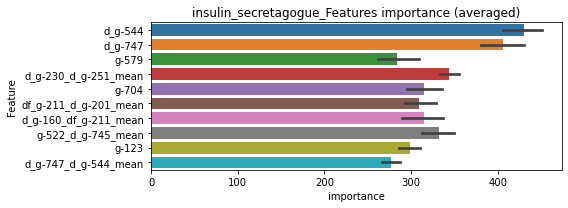

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.088785	valid_1's binary_logloss: 0.132803
[200]	training's binary_logloss: 0.0274953	valid_1's binary_logloss: 0.0605935
[300]	training's binary_logloss: 0.0102097	valid_1's binary_logloss: 0.0348816
[400]	training's binary_logloss: 0.00419537	valid_1's binary_logloss: 0.0225604
[500]	training's binary_logloss: 0.00212187	valid_1's binary_logloss: 0.0173462
[600]	training's binary_logloss: 0.00131406	valid_1's binary_logloss: 0.0150322
[700]	training's binary_logloss: 0.000932103	valid_1's binary_logloss: 0.0136146
[800]	training's binary_logloss: 0.000723527	valid_1's binary_logloss: 0.0128334
[900]	training's binary_logloss: 0.00061039	valid_1's binary_logloss: 0.0123753
[1000]	training's binary_logloss: 0.000560578	valid_1's binary_logloss: 0.0121854
[1100]	training's binary_logloss: 0.000540716	valid_1's binary_logloss: 0.0120792
Early stopping, best iteration is:
[1079]	training's binar

len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922551	valid_1's binary_logloss: 0.119676
[200]	training's binary_logloss: 0.0288859	valid_1's binary_logloss: 0.049163
[300]	training's binary_logloss: 0.0107117	valid_1's binary_logloss: 0.0248334
[400]	training's binary_logloss: 0.00434655	valid_1's binary_logloss: 0.0141198
[500]	training's binary_logloss: 0.00220957	valid_1's binary_logloss: 0.00960246
[600]	training's binary_logloss: 0.0013699	valid_1's binary_logloss: 0.00756473
[700]	training's binary_logloss: 0.000960951	valid_1's binary_logloss: 0.00604076
[800]	training's binary_logloss: 0.000749583	valid_1's binary_logloss: 0.00532142
[900]	training's binary_logloss: 0.000630004	valid_1's binary_logloss: 0.00497359
[1000]	training's binary_logloss: 0.000575795	valid_1's binary_logloss: 0.00473986
Early stopping, best iteration is:
[1018]	training's binary_logloss: 0.000569085	valid_1's binary_logloss: 0.00467913


len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0896928	valid_1's binary_logloss: 0.116801
[200]	training's binary_logloss: 0.0289815	valid_1's binary_logloss: 0.0497853
[300]	training's binary_logloss: 0.0105061	valid_1's binary_logloss: 0.0244394
[400]	training's binary_logloss: 0.00428477	valid_1's binary_logloss: 0.0146013
[500]	training's binary_logloss: 0.00219497	valid_1's binary_logloss: 0.0102042
[600]	training's binary_logloss: 0.00135807	valid_1's binary_logloss: 0.00809062
[700]	training's binary_logloss: 0.000960555	valid_1's binary_logloss: 0.00714685
[800]	training's binary_logloss: 0.000747565	valid_1's binary_logloss: 0.00642055
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000717374	valid_1's binary_logloss: 0.0062762


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 insulin_secretagogue=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951442	valid_1's binary_logloss: 0.115251
[200]	training's binary_logloss: 0.0301039	valid_1's binary_logloss: 0.045935
[300]	training's binary_logloss: 0.0110947	valid_1's binary_logloss: 0.0224769
[400]	training's binary_logloss: 0.00451295	valid_1's binary_logloss: 0.0124936
[500]	training's binary_logloss: 0.00228022	valid_1's binary_logloss: 0.00832361
[600]	training's binary_logloss: 0.00139425	valid_1's binary_logloss: 0.00626344
[700]	training's binary_logloss: 0.000987137	valid_1's binary_logloss: 0.00515577
[800]	training's binary_logloss: 0.000773223	valid_1's binary_logloss: 0.00457669
[900]	training's binary_logloss: 0.000644537	valid_1's binary_logloss: 0.00414921
[1000]	training's binary_logloss: 0.000584673	valid_1's binary_logloss: 0.0039554
Early stopping, best iteration is:
[1021]	training's binary_logloss: 0.000578713	valid_1's binary_logloss: 0.00394159


insulin_secretagogue logloss: 0.006746103589156688


neg labels: 3289 → selected neg labels: 3284


insulin_sensitizer, len(trt): 51, len(othr): 3284, target_rate: 0.0021416 → Adj_target_rate: 0.0023748
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122513	valid_1's binary_logloss: 0.180738
[200]	training's binary_logloss: 0.0538048	valid_1's binary_logloss: 0.118543
[300]	training's binary_logloss: 0.0250329	valid_1's binary_logloss: 0.087405
[400]	training's binary_logloss: 0.0118088	valid_1's binary_logloss: 0.0715413
[500]	training's binary_logloss: 0.00600653	valid_1's binary_logloss: 0.0629308
[600]	training's binary_logloss: 0.003434	valid_1's binary_logloss: 0.058935
[700]	training's binary_logloss: 0.00218575	valid_1's binary_logloss: 0.0569663
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.00178497	valid_1's binary_logloss: 0.0560602
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121915	valid_1's binary_logloss: 0.178412
[200]	training's binary_logloss: 0.0526747	valid_1's binary_logloss: 0.109309
[300]	training's binary_logloss: 0.0253775	valid_1's binary

1 / 3 AUC score:0.998
y_Threshold: 0.0271042, Threshold: 0.1586783, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00214, Num_p_label: 40.0, conf_0:0.11107, conf_1:0.20628
Num_p_label: 40.0, Expected: 8.5, Adj_threshold_1: 0.1586783
Num_p_label: 29.0, Expected: 8.5, Adj_threshold_2: 0.2086783
Num_p_label: 24.0, Expected: 8.5, Adj_threshold_3: 0.2586783
Num_p_label: 16.0, Expected: 8.5, Adj_threshold_4: 0.3086783
threshold: 0.3086783, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 650.0/3796, y_label_rate: 0.1712329
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118	valid_1's binary_logloss: 0.162907
[200]	training's binary_logloss: 0.0468454	valid_1's binary_logloss: 0.0930544
[300]	training's binary_logloss: 0.0200043	valid_1's binary_logloss: 0.059392
[400]	training's binary_logloss: 0.00900115	valid_1's binary_logloss: 0.0430166
[500]	training's binary_logloss: 0.00457806	valid_1's binary_logloss: 0.0345545
[600]	training's binary_logloss: 0.00268661	valid_1's binary_logloss: 0.0306132
[700]	training's binary_logloss: 0.00178634	valid_1's binary_logloss: 0.0287243
[800]	training's binary_logloss: 0.00131255	valid_1's binary_logloss: 0.0274023
[900]	training's binary_logloss: 0.00103805	valid_1's binary_logloss: 0.0265839
[1000]	training's binary_logloss: 0.000879837	valid_1's binary_logloss: 0.0259754
Early stopping, best iteration is:
[1005]	training's binary_logloss: 0.00087286	valid_1's binary_logloss: 0.0259378
Training until validation scor

2 / 3 AUC score:0.999
y_Threshold: 0.1517335, Threshold: 0.3086783, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 640.0/3776
p_label_rate: 0.0170768 Vs.target_rate: 0.00214, Num_p_label: 68.0, conf_0:0.24694, conf_1:0.37041
Num_p_label: 68.0, Expected: 8.5, Adj_threshold_1: 0.3086783
Num_p_label: 55.0, Expected: 8.5, Adj_threshold_2: 0.3586783
Num_p_label: 49.0, Expected: 8.5, Adj_threshold_3: 0.4086783
Num_p_label: 43.0, Expected: 8.5, Adj_threshold_4: 0.4586783
Num_p_label: 38.0, Expected: 8.5, Adj_threshold_5: 0.5086783
Num_p_label: 34.0, Expected: 8.5, Adj_threshold_6: 0.5586783
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_7: 0.6086783
Num_p_label: 28.0, Expected: 8.5, Adj_threshold_8: 0.6586783
Num_p_label: 21.0, Expected: 8.5, Adj_threshold_9: 0.7086783
threshold: 0.7086783, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 640.0/3776, y_label_rate: 0.1694915
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113852	valid_1's binary_logloss: 0.154876
[200]	training's binary_logloss: 0.04354	valid_1's binary_logloss: 0.0854264
[300]	training's binary_logloss: 0.0182954	valid_1's binary_logloss: 0.05427
[400]	training's binary_logloss: 0.00820115	valid_1's binary_logloss: 0.0394112
[500]	training's binary_logloss: 0.00415414	valid_1's binary_logloss: 0.031002
[600]	training's binary_logloss: 0.00244918	valid_1's binary_logloss: 0.0270459
[700]	training's binary_logloss: 0.00165508	valid_1's binary_logloss: 0.0251064
[800]	training's binary_logloss: 0.00122942	valid_1's binary_logloss: 0.0233368
[900]	training's binary_logloss: 0.000983796	valid_1's binary_logloss: 0.0224789
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000932318	valid_1's binary_logloss: 0.0224194
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111509	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.1686754, Threshold: 0.7086783, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 633.0/3762
p_label_rate: 0.0077850 Vs.target_rate: 0.00214, Num_p_label: 31.0, conf_0:0.50000, conf_1:0.77955
Num_p_label: 31.0, Expected: 8.5, Adj_threshold_1: 0.7086783
Num_p_label: 26.0, Expected: 8.5, Adj_threshold_2: 0.7586783
threshold: 0.7586783, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 633.0/3762, y_label_rate: 0.1682616


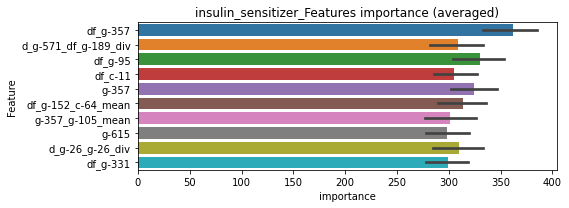

len(train_index) : 2821
len(valid_index) : 941
================================= fold 1/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11132	valid_1's binary_logloss: 0.170058
[200]	training's binary_logloss: 0.041725	valid_1's binary_logloss: 0.0984803
[300]	training's binary_logloss: 0.0176337	valid_1's binary_logloss: 0.0667588
[400]	training's binary_logloss: 0.00787921	valid_1's binary_logloss: 0.0513508
[500]	training's binary_logloss: 0.00394214	valid_1's binary_logloss: 0.0443258
[600]	training's binary_logloss: 0.00233375	valid_1's binary_logloss: 0.0411003
[700]	training's binary_logloss: 0.00158496	valid_1's binary_logloss: 0.0399871
[800]	training's binary_logloss: 0.0011816	valid_1's binary_logloss: 0.0393023
Early stopping, best iteration is:
[780]	training's binary_logloss: 0.00124609	valid_1's binary_logloss: 0.0391536


len(train_index) : 2821
len(valid_index) : 941
================================= fold 2/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107815	valid_1's binary_logloss: 0.164702
[200]	training's binary_logloss: 0.0403534	valid_1's binary_logloss: 0.094035
[300]	training's binary_logloss: 0.0173669	valid_1's binary_logloss: 0.0635664
[400]	training's binary_logloss: 0.00789516	valid_1's binary_logloss: 0.0482323
[500]	training's binary_logloss: 0.00401303	valid_1's binary_logloss: 0.0399003
[600]	training's binary_logloss: 0.00237875	valid_1's binary_logloss: 0.0354235
[700]	training's binary_logloss: 0.0016033	valid_1's binary_logloss: 0.0328673
[800]	training's binary_logloss: 0.00118924	valid_1's binary_logloss: 0.0314999
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.00102173	valid_1's binary_logloss: 0.0311151


len(train_index) : 2822
len(valid_index) : 940
================================= fold 3/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109126	valid_1's binary_logloss: 0.152546
[200]	training's binary_logloss: 0.0437631	valid_1's binary_logloss: 0.0847978
[300]	training's binary_logloss: 0.0184511	valid_1's binary_logloss: 0.0548945
[400]	training's binary_logloss: 0.0083283	valid_1's binary_logloss: 0.0416294
[500]	training's binary_logloss: 0.00420267	valid_1's binary_logloss: 0.0358505
[600]	training's binary_logloss: 0.00243611	valid_1's binary_logloss: 0.0332014
[700]	training's binary_logloss: 0.00162171	valid_1's binary_logloss: 0.0317042
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.00130823	valid_1's binary_logloss: 0.0314925


len(train_index) : 2822
len(valid_index) : 940
================================= fold 4/4 insulin_sensitizer=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110596	valid_1's binary_logloss: 0.148171
[200]	training's binary_logloss: 0.0430213	valid_1's binary_logloss: 0.0802866
[300]	training's binary_logloss: 0.0183148	valid_1's binary_logloss: 0.0495053
[400]	training's binary_logloss: 0.00823664	valid_1's binary_logloss: 0.034741
[500]	training's binary_logloss: 0.00414174	valid_1's binary_logloss: 0.0280135
[600]	training's binary_logloss: 0.00241308	valid_1's binary_logloss: 0.0246414
[700]	training's binary_logloss: 0.00161928	valid_1's binary_logloss: 0.022682
[800]	training's binary_logloss: 0.0012078	valid_1's binary_logloss: 0.0212934
Early stopping, best iteration is:
[822]	training's binary_logloss: 0.00114362	valid_1's binary_logloss: 0.0211344


insulin_sensitizer logloss: 0.03072624028043297


neg labels: 3289 → selected neg labels: 3281


integrin_inhibitor, len(trt): 42, len(othr): 3281, target_rate: 0.0017637 → Adj_target_rate: 0.0020135
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105059	valid_1's binary_logloss: 0.161169
[200]	training's binary_logloss: 0.0417102	valid_1's binary_logloss: 0.0957282
[300]	training's binary_logloss: 0.0184862	valid_1's binary_logloss: 0.0667423
[400]	training's binary_logloss: 0.00830154	valid_1's binary_logloss: 0.049365
[500]	training's binary_logloss: 0.00405646	valid_1's binary_logloss: 0.0399149
[600]	training's binary_logloss: 0.00230261	valid_1's binary_logloss: 0.0352426
[700]	training's binary_logloss: 0.00152261	valid_1's binary_logloss: 0.0326628
[800]	training's binary_logloss: 0.00112496	valid_1's binary_logloss: 0.0312479
[900]	training's binary_logloss: 0.000897499	valid_1's binary_logloss: 0.0309604
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.00085409	valid_1's binary_logloss: 0.0307454
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111157	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0115784, Threshold: 0.0498846, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3801
p_label_rate: 0.0100452 Vs.target_rate: 0.00176, Num_p_label: 40.0, conf_0:0.03492, conf_1:0.06485
Num_p_label: 40.0, Expected: 7.0, Adj_threshold_1: 0.0498846
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_2: 0.0998846
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_3: 0.1498846
threshold: 0.1498846, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3801, y_label_rate: 0.1720600
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105153	valid_1's binary_logloss: 0.151271
[200]	training's binary_logloss: 0.0377349	valid_1's binary_logloss: 0.078531
[300]	training's binary_logloss: 0.0165796	valid_1's binary_logloss: 0.0512754
[400]	training's binary_logloss: 0.0074112	valid_1's binary_logloss: 0.0367855
[500]	training's binary_logloss: 0.00367419	valid_1's binary_logloss: 0.0291705
[600]	training's binary_logloss: 0.00209238	valid_1's binary_logloss: 0.0250483
[700]	training's binary_logloss: 0.00139775	valid_1's binary_logloss: 0.0232763
[800]	training's binary_logloss: 0.00103775	valid_1's binary_logloss: 0.0220061
[900]	training's binary_logloss: 0.000837225	valid_1's binary_logloss: 0.021221
[1000]	training's binary_logloss: 0.000732585	valid_1's binary_logloss: 0.0208981
[1100]	training's binary_logloss: 0.000696708	valid_1's binary_logloss: 0.0208154
Early stopping, best iteration is:
[1129]	training's binary_lo

2 / 3 AUC score:0.999
y_Threshold: 0.0519585, Threshold: 0.1498846, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 646.0/3785
p_label_rate: 0.0125565 Vs.target_rate: 0.00176, Num_p_label: 50.0, conf_0:0.11991, conf_1:0.17986
Num_p_label: 50.0, Expected: 7.0, Adj_threshold_1: 0.1498846
Num_p_label: 41.0, Expected: 7.0, Adj_threshold_2: 0.1998846
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_3: 0.2498846
Num_p_label: 32.0, Expected: 7.0, Adj_threshold_4: 0.2998846
Num_p_label: 23.0, Expected: 7.0, Adj_threshold_5: 0.3498846
Num_p_label: 19.0, Expected: 7.0, Adj_threshold_6: 0.3998846
Num_p_label: 12.0, Expected: 7.0, Adj_threshold_7: 0.4498846
threshold: 0.4498846, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 646.0/3785, y_label_rate: 0.1706737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102147	valid_1's binary_logloss: 0.146852
[200]	training's binary_logloss: 0.0374995	valid_1's binary_logloss: 0.0796814
[300]	training's binary_logloss: 0.0154496	valid_1's binary_logloss: 0.0512363
[400]	training's binary_logloss: 0.00673112	valid_1's binary_logloss: 0.0392327
[500]	training's binary_logloss: 0.00333121	valid_1's binary_logloss: 0.033743
[600]	training's binary_logloss: 0.0019451	valid_1's binary_logloss: 0.0314294
[700]	training's binary_logloss: 0.00131927	valid_1's binary_logloss: 0.0304903
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.00108161	valid_1's binary_logloss: 0.0297763
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101907	valid_1's binary_logloss: 0.146154
[200]	training's binary_logloss: 0.0374697	valid_1's binary_logloss: 0.0821349
[300]	training's binary_logloss: 0.0155522	valid_1's b

3 / 3 AUC score:0.998
y_Threshold: 0.0566849, Threshold: 0.4498846, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 637.0/3767
p_label_rate: 0.0045203 Vs.target_rate: 0.00176, Num_p_label: 18.0, conf_0:0.40490, conf_1:0.49487
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_1: 0.4498846
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_2: 0.4998846
threshold: 0.4998846, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 637.0/3767, y_label_rate: 0.1691001


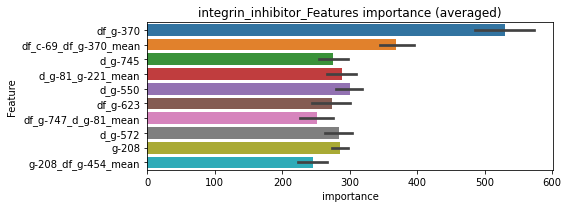

len(train_index) : 2825
len(valid_index) : 942
================================= fold 1/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975213	valid_1's binary_logloss: 0.137043
[200]	training's binary_logloss: 0.0363624	valid_1's binary_logloss: 0.0671556
[300]	training's binary_logloss: 0.0151377	valid_1's binary_logloss: 0.0396765
[400]	training's binary_logloss: 0.00651257	valid_1's binary_logloss: 0.026193
[500]	training's binary_logloss: 0.00320826	valid_1's binary_logloss: 0.0204611
[600]	training's binary_logloss: 0.00188885	valid_1's binary_logloss: 0.0174529
[700]	training's binary_logloss: 0.00127983	valid_1's binary_logloss: 0.0161718
[800]	training's binary_logloss: 0.000961521	valid_1's binary_logloss: 0.0153526
[900]	training's binary_logloss: 0.000782771	valid_1's binary_logloss: 0.0148242
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.000780111	valid_1's binary_logloss: 0.0148221


len(train_index) : 2825
len(valid_index) : 942
================================= fold 2/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0969641	valid_1's binary_logloss: 0.140765
[200]	training's binary_logloss: 0.0354142	valid_1's binary_logloss: 0.0848206
[300]	training's binary_logloss: 0.0146542	valid_1's binary_logloss: 0.0634801
[400]	training's binary_logloss: 0.00643897	valid_1's binary_logloss: 0.055449
[500]	training's binary_logloss: 0.003196	valid_1's binary_logloss: 0.0523157
[600]	training's binary_logloss: 0.00187235	valid_1's binary_logloss: 0.0511529
[700]	training's binary_logloss: 0.00127267	valid_1's binary_logloss: 0.0505845
Early stopping, best iteration is:
[693]	training's binary_logloss: 0.00130407	valid_1's binary_logloss: 0.0503745


len(train_index) : 2825
len(valid_index) : 942
================================= fold 3/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0966471	valid_1's binary_logloss: 0.136047
[200]	training's binary_logloss: 0.034916	valid_1's binary_logloss: 0.070119
[300]	training's binary_logloss: 0.0149092	valid_1's binary_logloss: 0.0423607
[400]	training's binary_logloss: 0.00730761	valid_1's binary_logloss: 0.0287486
[500]	training's binary_logloss: 0.00343037	valid_1's binary_logloss: 0.0227432
[600]	training's binary_logloss: 0.00192191	valid_1's binary_logloss: 0.0197883
[700]	training's binary_logloss: 0.00129349	valid_1's binary_logloss: 0.0181797
[800]	training's binary_logloss: 0.000969398	valid_1's binary_logloss: 0.0170673
[900]	training's binary_logloss: 0.000785104	valid_1's binary_logloss: 0.0165754
[1000]	training's binary_logloss: 0.000691162	valid_1's binary_logloss: 0.016207
Early stopping, best iteration is:
[1010]	training's binary_logloss: 0.000683061	valid_1's binary_logloss: 0.0161575


len(train_index) : 2826
len(valid_index) : 941
================================= fold 4/4 integrin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0982983	valid_1's binary_logloss: 0.125865
[200]	training's binary_logloss: 0.0358531	valid_1's binary_logloss: 0.0625177
[300]	training's binary_logloss: 0.0152895	valid_1's binary_logloss: 0.0386962
[400]	training's binary_logloss: 0.00679973	valid_1's binary_logloss: 0.0273751
[500]	training's binary_logloss: 0.00341553	valid_1's binary_logloss: 0.0217244
[600]	training's binary_logloss: 0.00195083	valid_1's binary_logloss: 0.0191664
[700]	training's binary_logloss: 0.00131807	valid_1's binary_logloss: 0.0179973
[800]	training's binary_logloss: 0.000987438	valid_1's binary_logloss: 0.0173204
[900]	training's binary_logloss: 0.000804409	valid_1's binary_logloss: 0.0167711
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000760831	valid_1's binary_logloss: 0.0166671


integrin_inhibitor logloss: 0.024507386043657292


neg labels: 3289 → selected neg labels: 3273


jak_inhibitor, len(trt): 92, len(othr): 3273, target_rate: 0.0038633 → Adj_target_rate: 0.0039212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.16193	valid_1's binary_logloss: 0.247759
[200]	training's binary_logloss: 0.0843297	valid_1's binary_logloss: 0.185989
[300]	training's binary_logloss: 0.0467554	valid_1's binary_logloss: 0.152916
[400]	training's binary_logloss: 0.0266296	valid_1's binary_logloss: 0.133169
[500]	training's binary_logloss: 0.0154605	valid_1's binary_logloss: 0.120891
[600]	training's binary_logloss: 0.00916541	valid_1's binary_logloss: 0.11398
[700]	training's binary_logloss: 0.0056558	valid_1's binary_logloss: 0.110365
Early stopping, best iteration is:
[737]	training's binary_logloss: 0.00481887	valid_1's binary_logloss: 0.108896
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.169739	valid_1's binary_logloss: 0.252194
[200]	training's binary_logloss: 0.0889466	valid_1's binary_logloss: 0.184025
[300]	training's binary_logloss: 0.0491307	valid_1's binary_loglo

1 / 3 AUC score:0.988
y_Threshold: 0.0425999, Threshold: 0.3491089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 196 → Positive_corect_labels: 622/3731
p_label_rate: 0.0100452 Vs.target_rate: 0.00386, Num_p_label: 40.0, conf_0:0.24438, conf_1:0.45384
Num_p_label: 40.0, Expected: 15.4, Adj_threshold_1: 0.3491089
Num_p_label: 29.0, Expected: 15.4, Adj_threshold_2: 0.3991089
Num_p_label: 20.0, Expected: 15.4, Adj_threshold_3: 0.4491089
threshold: 0.4491089, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 622.0/3731, y_label_rate: 0.1667113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151134	valid_1's binary_logloss: 0.220149
[200]	training's binary_logloss: 0.0698799	valid_1's binary_logloss: 0.146745
[300]	training's binary_logloss: 0.0361263	valid_1's binary_logloss: 0.11236
[400]	training's binary_logloss: 0.0188597	valid_1's binary_logloss: 0.0935102
[500]	training's binary_logloss: 0.0103037	valid_1's binary_logloss: 0.0831152
[600]	training's binary_logloss: 0.0059823	valid_1's binary_logloss: 0.0767751
[700]	training's binary_logloss: 0.00377851	valid_1's binary_logloss: 0.0743056
[800]	training's binary_logloss: 0.00260211	valid_1's binary_logloss: 0.0727856
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00264312	valid_1's binary_logloss: 0.072743
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144411	valid_1's binary_logloss: 0.222899
[200]	training's binary_logloss: 0.0707549	valid_1's binar

2 / 3 AUC score:0.995
y_Threshold: 0.0975848, Threshold: 0.4491089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 589.0/3665
p_label_rate: 0.0173280 Vs.target_rate: 0.00386, Num_p_label: 69.0, conf_0:0.35929, conf_1:0.53893
Num_p_label: 69.0, Expected: 15.4, Adj_threshold_1: 0.4491089
Num_p_label: 66.0, Expected: 15.4, Adj_threshold_2: 0.4991089
Num_p_label: 55.0, Expected: 15.4, Adj_threshold_3: 0.5491089
Num_p_label: 48.0, Expected: 15.4, Adj_threshold_4: 0.5991089
Num_p_label: 41.0, Expected: 15.4, Adj_threshold_5: 0.6491089
Num_p_label: 34.0, Expected: 15.4, Adj_threshold_6: 0.6991089
Num_p_label: 27.0, Expected: 15.4, Adj_threshold_7: 0.7491089
Num_p_label: 20.0, Expected: 15.4, Adj_threshold_8: 0.7991089
threshold: 0.7991089, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 589.0/3665, y_label_rate: 0.1607094
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137321	valid_1's binary_logloss: 0.206823
[200]	training's binary_logloss: 0.0593484	valid_1's binary_logloss: 0.141619
[300]	training's binary_logloss: 0.0289569	valid_1's binary_logloss: 0.112332
[400]	training's binary_logloss: 0.0144562	valid_1's binary_logloss: 0.0987721
[500]	training's binary_logloss: 0.00782618	valid_1's binary_logloss: 0.0928155
[600]	training's binary_logloss: 0.0044803	valid_1's binary_logloss: 0.0903608
[700]	training's binary_logloss: 0.0028757	valid_1's binary_logloss: 0.0897068
Early stopping, best iteration is:
[686]	training's binary_logloss: 0.00303508	valid_1's binary_logloss: 0.089274
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136228	valid_1's binary_logloss: 0.210907
[200]	training's binary_logloss: 0.0600997	valid_1's binary_logloss: 0.138824
[300]	training's binary_logloss: 0.0293821	valid_1's binary

3 / 3 AUC score:0.992
y_Threshold: 0.1026168, Threshold: 0.7991089, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 561.0/3609
p_label_rate: 0.0070316 Vs.target_rate: 0.00386, Num_p_label: 28.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 28.0, Expected: 15.4, Adj_threshold_1: 0.7991089
threshold: 0.7991089, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 561.0/3609, y_label_rate: 0.1554447


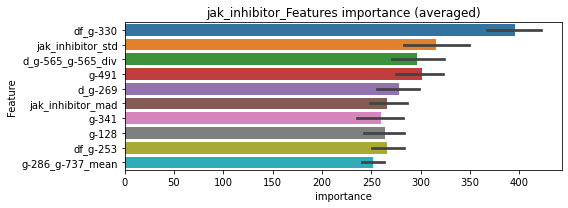

len(train_index) : 2706
len(valid_index) : 903
================================= fold 1/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122918	valid_1's binary_logloss: 0.189252
[200]	training's binary_logloss: 0.0493802	valid_1's binary_logloss: 0.122019
[300]	training's binary_logloss: 0.0220733	valid_1's binary_logloss: 0.0908701
[400]	training's binary_logloss: 0.0107882	valid_1's binary_logloss: 0.0748718
[500]	training's binary_logloss: 0.00569417	valid_1's binary_logloss: 0.0666208
[600]	training's binary_logloss: 0.00339179	valid_1's binary_logloss: 0.0619169
[700]	training's binary_logloss: 0.00225749	valid_1's binary_logloss: 0.0600552
Early stopping, best iteration is:
[688]	training's binary_logloss: 0.00235342	valid_1's binary_logloss: 0.0597389


len(train_index) : 2707
len(valid_index) : 902
================================= fold 2/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125167	valid_1's binary_logloss: 0.189391
[200]	training's binary_logloss: 0.0516844	valid_1's binary_logloss: 0.131022
[300]	training's binary_logloss: 0.0245576	valid_1's binary_logloss: 0.10363
[400]	training's binary_logloss: 0.0118498	valid_1's binary_logloss: 0.0915771
[500]	training's binary_logloss: 0.00613229	valid_1's binary_logloss: 0.0873841
[600]	training's binary_logloss: 0.00354351	valid_1's binary_logloss: 0.0856105
Early stopping, best iteration is:
[624]	training's binary_logloss: 0.00316918	valid_1's binary_logloss: 0.0853667


len(train_index) : 2707
len(valid_index) : 902
================================= fold 3/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126654	valid_1's binary_logloss: 0.18415
[200]	training's binary_logloss: 0.0522457	valid_1's binary_logloss: 0.115969
[300]	training's binary_logloss: 0.024147	valid_1's binary_logloss: 0.0824535
[400]	training's binary_logloss: 0.0118933	valid_1's binary_logloss: 0.0655869
[500]	training's binary_logloss: 0.00616495	valid_1's binary_logloss: 0.0547886
[600]	training's binary_logloss: 0.00359539	valid_1's binary_logloss: 0.0488476
[700]	training's binary_logloss: 0.00237492	valid_1's binary_logloss: 0.0457539
[800]	training's binary_logloss: 0.00172377	valid_1's binary_logloss: 0.0440697
[900]	training's binary_logloss: 0.0013518	valid_1's binary_logloss: 0.0430415
[1000]	training's binary_logloss: 0.00113702	valid_1's binary_logloss: 0.042397
[1100]	training's binary_logloss: 0.00101038	valid_1's binary_logloss: 0.0421243
[1200]	training's binary_logloss: 0.00091919	valid_1's binary_loglos

len(train_index) : 2707
len(valid_index) : 902
================================= fold 4/4 jak_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125249	valid_1's binary_logloss: 0.193275
[200]	training's binary_logloss: 0.0521598	valid_1's binary_logloss: 0.128272
[300]	training's binary_logloss: 0.0248578	valid_1's binary_logloss: 0.0995631
[400]	training's binary_logloss: 0.0123065	valid_1's binary_logloss: 0.0857784
[500]	training's binary_logloss: 0.00642979	valid_1's binary_logloss: 0.0800206
[600]	training's binary_logloss: 0.00375407	valid_1's binary_logloss: 0.0775856
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00398693	valid_1's binary_logloss: 0.0775195


jak_inhibitor logloss: 0.06603773135231539


neg labels: 3289 → selected neg labels: 3248


kit_inhibitor, len(trt): 273, len(othr): 3248, target_rate: 0.0114638 → Adj_target_rate: 0.0098841
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.227851	valid_1's binary_logloss: 0.37527
[200]	training's binary_logloss: 0.138423	valid_1's binary_logloss: 0.352052
[300]	training's binary_logloss: 0.0869984	valid_1's binary_logloss: 0.341551
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0954596	valid_1's binary_logloss: 0.341304
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.228154	valid_1's binary_logloss: 0.35977
[200]	training's binary_logloss: 0.140583	valid_1's binary_logloss: 0.330683
[300]	training's binary_logloss: 0.0928685	valid_1's binary_logloss: 0.316893
[400]	training's binary_logloss: 0.0623233	valid_1's binary_logloss: 0.311367
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.057787	valid_1's binary_logloss: 0.309428
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.236534	valid_1's 

1 / 3 AUC score:0.855
y_Threshold: 0.1289356, Threshold: 0.6191857, pos_neg_ratio: 0.8000000
Remove_noisy_data: 547 → Positive_corect_labels: 441/3350
p_label_rate: 0.0100452 Vs.target_rate: 0.01146, Num_p_label: 40.0, conf_0:0.43343, conf_1:0.80000
threshold: 0.6191857, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 441.0/3350, y_label_rate: 0.1316418
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127107	valid_1's binary_logloss: 0.228191
[200]	training's binary_logloss: 0.0565813	valid_1's binary_logloss: 0.183985
[300]	training's binary_logloss: 0.0287304	valid_1's binary_logloss: 0.165511
[400]	training's binary_logloss: 0.0155097	valid_1's binary_logloss: 0.155161
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0134239	valid_1's binary_logloss: 0.154545
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120828	valid_1's binary_logloss: 0.226908
[200]	training's binary_logloss: 0.0555511	valid_1's binary_logloss: 0.187304
[300]	training's binary_logloss: 0.0296566	valid_1's binary_logloss: 0.170858
[400]	training's binary_logloss: 0.0160579	valid_1's binary_logloss: 0.165041
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0138734	valid_1's binary_logloss: 0.164446
Training until validation scor

2 / 3 AUC score:0.964
y_Threshold: 0.1195491, Threshold: 0.6191857, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 368.0/3204
p_label_rate: 0.0318935 Vs.target_rate: 0.01146, Num_p_label: 127.0, conf_0:0.49535, conf_1:0.74302
Num_p_label: 127.0, Expected: 45.6, Adj_threshold_1: 0.6191857
Num_p_label: 107.0, Expected: 45.6, Adj_threshold_2: 0.6691857
Num_p_label: 85.0, Expected: 45.6, Adj_threshold_3: 0.7191857
Num_p_label: 76.0, Expected: 45.6, Adj_threshold_4: 0.7691857
threshold: 0.7691857, positive_p_label: 76.0/3982, p_label_rate: 0.0190859
positive_y_label: 368.0/3204, y_label_rate: 0.1148564
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0926408	valid_1's binary_logloss: 0.147395
[200]	training's binary_logloss: 0.0381805	valid_1's binary_logloss: 0.103443
[300]	training's binary_logloss: 0.016852	valid_1's binary_logloss: 0.0845775
[400]	training's binary_logloss: 0.00843849	valid_1's binary_logloss: 0.0742687
[500]	training's binary_logloss: 0.00458727	valid_1's binary_logloss: 0.0691533
[600]	training's binary_logloss: 0.00283151	valid_1's binary_logloss: 0.0662001
[700]	training's binary_logloss: 0.00197203	valid_1's binary_logloss: 0.0644739
[800]	training's binary_logloss: 0.00149593	valid_1's binary_logloss: 0.0629943
[900]	training's binary_logloss: 0.001216	valid_1's binary_logloss: 0.0624201
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.00109136	valid_1's binary_logloss: 0.0620854
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0938897	valid_1'

3 / 3 AUC score:0.990
y_Threshold: 0.1223073, Threshold: 0.7691857, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 340.0/3148
p_label_rate: 0.0369161 Vs.target_rate: 0.01146, Num_p_label: 147.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 147.0, Expected: 45.6, Adj_threshold_1: 0.7691857
threshold: 0.7691857, positive_p_label: 147.0/3982, p_label_rate: 0.0369161
positive_y_label: 340.0/3148, y_label_rate: 0.1080051


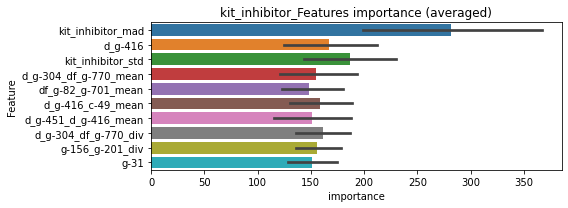

len(train_index) : 2361
len(valid_index) : 787
================================= fold 1/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810194	valid_1's binary_logloss: 0.13802
[200]	training's binary_logloss: 0.0294483	valid_1's binary_logloss: 0.0924022
[300]	training's binary_logloss: 0.0125181	valid_1's binary_logloss: 0.0727988
[400]	training's binary_logloss: 0.00598764	valid_1's binary_logloss: 0.0625645
[500]	training's binary_logloss: 0.00329755	valid_1's binary_logloss: 0.0572966
[600]	training's binary_logloss: 0.00208687	valid_1's binary_logloss: 0.0540781
[700]	training's binary_logloss: 0.00147154	valid_1's binary_logloss: 0.0522319
[800]	training's binary_logloss: 0.00115134	valid_1's binary_logloss: 0.0513994
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.00116695	valid_1's binary_logloss: 0.0513855


len(train_index) : 2361
len(valid_index) : 787
================================= fold 2/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0775877	valid_1's binary_logloss: 0.146632
[200]	training's binary_logloss: 0.0278233	valid_1's binary_logloss: 0.107491
[300]	training's binary_logloss: 0.0118841	valid_1's binary_logloss: 0.092081
[400]	training's binary_logloss: 0.00565426	valid_1's binary_logloss: 0.086835
[500]	training's binary_logloss: 0.00311229	valid_1's binary_logloss: 0.085447
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00327833	valid_1's binary_logloss: 0.0851056


len(train_index) : 2361
len(valid_index) : 787
================================= fold 3/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0776586	valid_1's binary_logloss: 0.130382
[200]	training's binary_logloss: 0.028295	valid_1's binary_logloss: 0.0844426
[300]	training's binary_logloss: 0.0118625	valid_1's binary_logloss: 0.065197
[400]	training's binary_logloss: 0.00575056	valid_1's binary_logloss: 0.0574107
[500]	training's binary_logloss: 0.00314745	valid_1's binary_logloss: 0.0536293
[600]	training's binary_logloss: 0.00200159	valid_1's binary_logloss: 0.0526618
[700]	training's binary_logloss: 0.00141594	valid_1's binary_logloss: 0.0521044
Early stopping, best iteration is:
[691]	training's binary_logloss: 0.00145613	valid_1's binary_logloss: 0.0520037


len(train_index) : 2361
len(valid_index) : 787
================================= fold 4/4 kit_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794773	valid_1's binary_logloss: 0.112572
[200]	training's binary_logloss: 0.0290984	valid_1's binary_logloss: 0.0680546
[300]	training's binary_logloss: 0.0123813	valid_1's binary_logloss: 0.0522644
[400]	training's binary_logloss: 0.00600925	valid_1's binary_logloss: 0.0437496
[500]	training's binary_logloss: 0.00333563	valid_1's binary_logloss: 0.0390592
[600]	training's binary_logloss: 0.00210675	valid_1's binary_logloss: 0.0365302
[700]	training's binary_logloss: 0.00149415	valid_1's binary_logloss: 0.0349625
[800]	training's binary_logloss: 0.00116621	valid_1's binary_logloss: 0.033708
[900]	training's binary_logloss: 0.000979729	valid_1's binary_logloss: 0.033243
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000988199	valid_1's binary_logloss: 0.0330374


kit_inhibitor logloss: 0.05538303147401445


neg labels: 3289 → selected neg labels: 3289


laxative, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451861	valid_1's binary_logloss: 0.0485666
[200]	training's binary_logloss: 0.00717377	valid_1's binary_logloss: 0.00843443
[300]	training's binary_logloss: 0.00155177	valid_1's binary_logloss: 0.00209118
[400]	training's binary_logloss: 0.000570524	valid_1's binary_logloss: 0.000966212
[500]	training's binary_logloss: 0.000319316	valid_1's binary_logloss: 0.000641492
[600]	training's binary_logloss: 0.000231196	valid_1's binary_logloss: 0.000496102
[700]	training's binary_logloss: 0.000193065	valid_1's binary_logloss: 0.000422893
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.000188568	valid_1's binary_logloss: 0.000414365
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0448663	valid_1's binary_logloss: 0.046602
[200]	training's binary_logloss: 0.00714813	valid_1's binary_logloss: 0.00830392
[300]	training's binary_logl

1 / 3 AUC score:1.000
y_Threshold: 0.0006246, Threshold: 0.0023971, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00168, conf_1:0.00312
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0023971
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0523971
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.1023971
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.1523971
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_5: 0.2023971
threshold: 0.2023971, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456888	valid_1's binary_logloss: 0.0489912
[200]	training's binary_logloss: 0.00701121	valid_1's binary_logloss: 0.00793551
[300]	training's binary_logloss: 0.00143314	valid_1's binary_logloss: 0.00173518
[400]	training's binary_logloss: 0.000506087	valid_1's binary_logloss: 0.000669415
[500]	training's binary_logloss: 0.000280223	valid_1's binary_logloss: 0.000397703
[600]	training's binary_logloss: 0.000202956	valid_1's binary_logloss: 0.000298902
[700]	training's binary_logloss: 0.000174861	valid_1's binary_logloss: 0.000261645
[800]	training's binary_logloss: 0.000165335	valid_1's binary_logloss: 0.000248873
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000163967	valid_1's binary_logloss: 0.000247184
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451202	valid_1's binary_logloss: 0.0475643
[200]	training's binary_l

2 / 3 AUC score:1.000
y_Threshold: 0.0425745, Threshold: 0.2023971, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00025, Num_p_label: 7.0, conf_0:0.16192, conf_1:0.24288
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_1: 0.2023971
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.2523971
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.3023971
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_4: 0.3523971
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_5: 0.4023971
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_6: 0.4523971
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_7: 0.5023971
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.5523971
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.6023971
threshold: 0.6023971, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456888	valid_1's binary_logloss: 0.0489912
[200]	training's binary_logloss: 0.00701121	valid_1's binary_logloss: 0.00793551
[300]	training's binary_logloss: 0.00143314	valid_1's binary_logloss: 0.00173518
[400]	training's binary_logloss: 0.000506087	valid_1's binary_logloss: 0.000669415
[500]	training's binary_logloss: 0.000280223	valid_1's binary_logloss: 0.000397703
[600]	training's binary_logloss: 0.000202956	valid_1's binary_logloss: 0.000298902
[700]	training's binary_logloss: 0.000174861	valid_1's binary_logloss: 0.000261645
[800]	training's binary_logloss: 0.000165335	valid_1's binary_logloss: 0.000248873
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000163967	valid_1's binary_logloss: 0.000247184
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451202	valid_1's binary_logloss: 0.0475643
[200]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.0425745, Threshold: 0.6023971, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.50000, conf_1:0.66264
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.6023971


Early stopping, best iteration is:
[801]	training's binary_logloss: 0.000169227	valid_1's binary_logloss: 0.000250469


threshold: 0.6023971, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


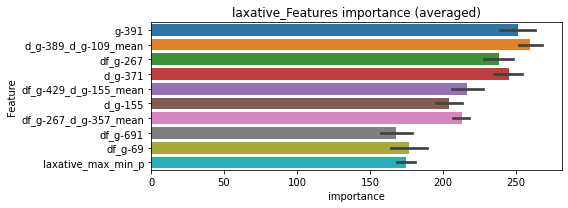

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 laxative=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0449785	valid_1's binary_logloss: 0.0473162
[200]	training's binary_logloss: 0.00692825	valid_1's binary_logloss: 0.00767909
[300]	training's binary_logloss: 0.00142539	valid_1's binary_logloss: 0.00169425
[400]	training's binary_logloss: 0.000500596	valid_1's binary_logloss: 0.000643588
[500]	training's binary_logloss: 0.000278628	valid_1's binary_logloss: 0.000384537
[600]	training's binary_logloss: 0.00020308	valid_1's binary_logloss: 0.000290119
[700]	training's binary_logloss: 0.000175655	valid_1's binary_logloss: 0.000255313
[800]	training's binary_logloss: 0.000165332	valid_1's binary_logloss: 0.000242296


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 laxative=================================


Early stopping, best iteration is:
[821]	training's binary_logloss: 0.00016447	valid_1's binary_logloss: 0.000241237
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452456	valid_1's binary_logloss: 0.0476846
[200]	training's binary_logloss: 0.00695862	valid_1's binary_logloss: 0.00957543
[300]	training's binary_logloss: 0.00143879	valid_1's binary_logloss: 0.00402231
[400]	training's binary_logloss: 0.000505629	valid_1's binary_logloss: 0.00279675
[500]	training's binary_logloss: 0.000282234	valid_1's binary_logloss: 0.00244824


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 laxative=================================


Early stopping, best iteration is:
[496]	training's binary_logloss: 0.000286816	valid_1's binary_logloss: 0.00243271
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452922	valid_1's binary_logloss: 0.0462995
[200]	training's binary_logloss: 0.00701961	valid_1's binary_logloss: 0.00723151
[300]	training's binary_logloss: 0.00145481	valid_1's binary_logloss: 0.0015177
[400]	training's binary_logloss: 0.000511399	valid_1's binary_logloss: 0.000539888
[500]	training's binary_logloss: 0.000285786	valid_1's binary_logloss: 0.000303152
[600]	training's binary_logloss: 0.000209065	valid_1's binary_logloss: 0.000222119
[700]	training's binary_logloss: 0.000178417	valid_1's binary_logloss: 0.000189923
[800]	training's binary_logloss: 0.000169175	valid_1's binary_logloss: 0.000180085


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 laxative=================================


Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000167966	valid_1's binary_logloss: 0.000178759
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454493	valid_1's binary_logloss: 0.0485625
[200]	training's binary_logloss: 0.00704481	valid_1's binary_logloss: 0.00798207
[300]	training's binary_logloss: 0.001451	valid_1's binary_logloss: 0.00176142
[400]	training's binary_logloss: 0.000509727	valid_1's binary_logloss: 0.000655659
[500]	training's binary_logloss: 0.000283618	valid_1's binary_logloss: 0.000390188
[600]	training's binary_logloss: 0.000205055	valid_1's binary_logloss: 0.000291599
[700]	training's binary_logloss: 0.000176646	valid_1's binary_logloss: 0.000257929
[800]	training's binary_logloss: 0.000169717	valid_1's binary_logloss: 0.000250716


laxative logloss: 0.0007751345603294247


Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000167871	valid_1's binary_logloss: 0.00024839
neg labels: 3289 → selected neg labels: 3289


leukotriene_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453919	valid_1's binary_logloss: 0.0483934
[200]	training's binary_logloss: 0.00743282	valid_1's binary_logloss: 0.00870349
[300]	training's binary_logloss: 0.00159351	valid_1's binary_logloss: 0.00234243
[400]	training's binary_logloss: 0.000575008	valid_1's binary_logloss: 0.00122761
[500]	training's binary_logloss: 0.000318	valid_1's binary_logloss: 0.000891748
[600]	training's binary_logloss: 0.000227086	valid_1's binary_logloss: 0.000766535
[700]	training's binary_logloss: 0.000193098	valid_1's binary_logloss: 0.00071421
[800]	training's binary_logloss: 0.000183576	valid_1's binary_logloss: 0.000696003
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000181464	valid_1's binary_logloss: 0.000691181
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454273	valid_1's binary_logloss: 0.0500909
[200]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0005358, Threshold: 0.0033510, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00235, conf_1:0.00436
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0033510
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_2: 0.0533510
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.1033510
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_4: 0.1533510
threshold: 0.1533510, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045483	valid_1's binary_logloss: 0.0473202
[200]	training's binary_logloss: 0.00707874	valid_1's binary_logloss: 0.00795359
[300]	training's binary_logloss: 0.00145494	valid_1's binary_logloss: 0.00197161
[400]	training's binary_logloss: 0.000496028	valid_1's binary_logloss: 0.000856136
[500]	training's binary_logloss: 0.000269393	valid_1's binary_logloss: 0.000558141
[600]	training's binary_logloss: 0.000192963	valid_1's binary_logloss: 0.000440423
[700]	training's binary_logloss: 0.000170117	valid_1's binary_logloss: 0.000407011
[800]	training's binary_logloss: 0.000163195	valid_1's binary_logloss: 0.000393552
Early stopping, best iteration is:
[787]	training's binary_logloss: 0.000163453	valid_1's binary_logloss: 0.000393133
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455657	valid_1's binary_logloss: 0.0490786
[200]	training's binary_lo

2 / 3 AUC score:1.000
y_Threshold: 0.1560389, Threshold: 0.1533510, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0047715 Vs.target_rate: 0.00025, Num_p_label: 19.0, conf_0:0.12268, conf_1:0.18402
Num_p_label: 19.0, Expected: 1.0, Adj_threshold_1: 0.1533510
Num_p_label: 17.0, Expected: 1.0, Adj_threshold_2: 0.2033510
Num_p_label: 16.0, Expected: 1.0, Adj_threshold_3: 0.2533510
Num_p_label: 14.0, Expected: 1.0, Adj_threshold_4: 0.3033510
Num_p_label: 13.0, Expected: 1.0, Adj_threshold_5: 0.3533510
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_6: 0.4033510
Num_p_label: 9.0, Expected: 1.0, Adj_threshold_7: 0.4533510
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_8: 0.5033510
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_9: 0.5533510
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_10: 0.6033510
threshold: 0.6533510, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
===============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045483	valid_1's binary_logloss: 0.0473202
[200]	training's binary_logloss: 0.00707874	valid_1's binary_logloss: 0.00795359
[300]	training's binary_logloss: 0.00145494	valid_1's binary_logloss: 0.00197161
[400]	training's binary_logloss: 0.000496028	valid_1's binary_logloss: 0.000856136
[500]	training's binary_logloss: 0.000269393	valid_1's binary_logloss: 0.000558141
[600]	training's binary_logloss: 0.000192963	valid_1's binary_logloss: 0.000440423
[700]	training's binary_logloss: 0.000170117	valid_1's binary_logloss: 0.000407011
[800]	training's binary_logloss: 0.000163195	valid_1's binary_logloss: 0.000393552
Early stopping, best iteration is:
[787]	training's binary_logloss: 0.000163453	valid_1's binary_logloss: 0.000393133
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455657	valid_1's binary_logloss: 0.0490786
[200]	training's binary_lo

3 / 3 AUC score:1.000
y_Threshold: 0.1560389, Threshold: 0.6533510, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00025, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.71869
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_1: 0.6533510
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.7033510
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_3: 0.7533510
threshold: 0.7533510, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


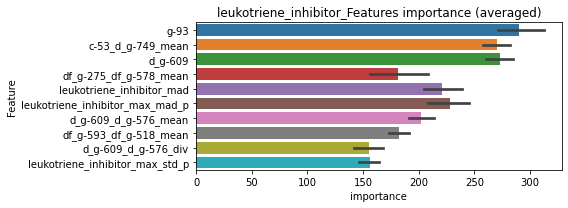

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452008	valid_1's binary_logloss: 0.0470815
[200]	training's binary_logloss: 0.00705249	valid_1's binary_logloss: 0.00792884
[300]	training's binary_logloss: 0.00146223	valid_1's binary_logloss: 0.00192959
[400]	training's binary_logloss: 0.000498093	valid_1's binary_logloss: 0.000793794
[500]	training's binary_logloss: 0.000270145	valid_1's binary_logloss: 0.000490275
[600]	training's binary_logloss: 0.000192965	valid_1's binary_logloss: 0.000377622
[700]	training's binary_logloss: 0.000169408	valid_1's binary_logloss: 0.000349835
[800]	training's binary_logloss: 0.000161883	valid_1's binary_logloss: 0.000341439


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 leukotriene_inhibitor=================================


[900]	training's binary_logloss: 0.000160244	valid_1's binary_logloss: 0.000340567
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.000160596	valid_1's binary_logloss: 0.000340325
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452387	valid_1's binary_logloss: 0.0485389
[200]	training's binary_logloss: 0.00708011	valid_1's binary_logloss: 0.00870516
[300]	training's binary_logloss: 0.00147478	valid_1's binary_logloss: 0.00246013
[400]	training's binary_logloss: 0.000496784	valid_1's binary_logloss: 0.00124862
[500]	training's binary_logloss: 0.000266343	valid_1's binary_logloss: 0.000903816
[600]	training's binary_logloss: 0.000191203	valid_1's binary_logloss: 0.000807858
[700]	training's binary_logloss: 0.000167501	valid_1's binary_logloss: 0.000759895
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.000168554	valid_1's binary_logloss: 0.000759326


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451924	valid_1's binary_logloss: 0.049024
[200]	training's binary_logloss: 0.0069893	valid_1's binary_logloss: 0.00809891
[300]	training's binary_logloss: 0.00144822	valid_1's binary_logloss: 0.00188756
[400]	training's binary_logloss: 0.000490039	valid_1's binary_logloss: 0.00072261
[500]	training's binary_logloss: 0.000263795	valid_1's binary_logloss: 0.000417711
[600]	training's binary_logloss: 0.000188618	valid_1's binary_logloss: 0.000309349
[700]	training's binary_logloss: 0.000166525	valid_1's binary_logloss: 0.000278379
[800]	training's binary_logloss: 0.000159812	valid_1's binary_logloss: 0.000268277
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00015959	valid_1's binary_logloss: 0.000267879


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 leukotriene_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453439	valid_1's binary_logloss: 0.0479695
[200]	training's binary_logloss: 0.00706694	valid_1's binary_logloss: 0.00801947
[300]	training's binary_logloss: 0.00146543	valid_1's binary_logloss: 0.00182458
[400]	training's binary_logloss: 0.000495419	valid_1's binary_logloss: 0.000679381
[500]	training's binary_logloss: 0.00026496	valid_1's binary_logloss: 0.000377144
[600]	training's binary_logloss: 0.00019058	valid_1's binary_logloss: 0.000280499
[700]	training's binary_logloss: 0.000165906	valid_1's binary_logloss: 0.000245327
[800]	training's binary_logloss: 0.000160774	valid_1's binary_logloss: 0.000238755
[900]	training's binary_logloss: 0.000158447	valid_1's binary_logloss: 0.000235773
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000158447	valid_1's binary_logloss: 0.000235773


leukotriene_inhibitor logloss: 0.0004008844910517278


neg labels: 3289 → selected neg labels: 3282


leukotriene_receptor_antagonist, len(trt): 62, len(othr): 3282, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127484	valid_1's binary_logloss: 0.186093
[200]	training's binary_logloss: 0.0537737	valid_1's binary_logloss: 0.119232
[300]	training's binary_logloss: 0.0246205	valid_1's binary_logloss: 0.0871273
[400]	training's binary_logloss: 0.0121995	valid_1's binary_logloss: 0.0710032
[500]	training's binary_logloss: 0.00651814	valid_1's binary_logloss: 0.0624793
[600]	training's binary_logloss: 0.00384955	valid_1's binary_logloss: 0.0570713
[700]	training's binary_logloss: 0.00251095	valid_1's binary_logloss: 0.0543094
[800]	training's binary_logloss: 0.00181971	valid_1's binary_logloss: 0.0529049
[900]	training's binary_logloss: 0.00140684	valid_1's binary_logloss: 0.0520359
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00140684	valid_1's binary_logloss: 0.0520359
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126696	valid_1'

1 / 3 AUC score:0.998
y_Threshold: 0.0241388, Threshold: 0.1420086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 649/3792
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.09941, conf_1:0.18461
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.1420086
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.1920086
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_3: 0.2420086
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_4: 0.2920086
Num_p_label: 15.0, Expected: 10.4, Adj_threshold_5: 0.3420086
threshold: 0.3420086, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3792, y_label_rate: 0.1711498
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116689	valid_1's binary_logloss: 0.172562
[200]	training's binary_logloss: 0.0447769	valid_1's binary_logloss: 0.103816
[300]	training's binary_logloss: 0.0194193	valid_1's binary_logloss: 0.0734793
[400]	training's binary_logloss: 0.00931603	valid_1's binary_logloss: 0.0586168
[500]	training's binary_logloss: 0.00490912	valid_1's binary_logloss: 0.0506877
[600]	training's binary_logloss: 0.00293787	valid_1's binary_logloss: 0.0470136
[700]	training's binary_logloss: 0.00195124	valid_1's binary_logloss: 0.0443273
[800]	training's binary_logloss: 0.00143174	valid_1's binary_logloss: 0.0421838
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.00135014	valid_1's binary_logloss: 0.0419911
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117542	valid_1's binary_logloss: 0.16834
[200]	training's binary_logloss: 0.0441885	valid_1's 

2 / 3 AUC score:0.998
y_Threshold: 0.1032141, Threshold: 0.3420086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 635.0/3764
p_label_rate: 0.0160723 Vs.target_rate: 0.00260, Num_p_label: 64.0, conf_0:0.27361, conf_1:0.41041
Num_p_label: 64.0, Expected: 10.4, Adj_threshold_1: 0.3420086
Num_p_label: 58.0, Expected: 10.4, Adj_threshold_2: 0.3920086
Num_p_label: 50.0, Expected: 10.4, Adj_threshold_3: 0.4420086
Num_p_label: 46.0, Expected: 10.4, Adj_threshold_4: 0.4920086
Num_p_label: 43.0, Expected: 10.4, Adj_threshold_5: 0.5420086
Num_p_label: 42.0, Expected: 10.4, Adj_threshold_6: 0.5920086
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_7: 0.6420086
Num_p_label: 34.0, Expected: 10.4, Adj_threshold_8: 0.6920086
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_9: 0.7420086
Num_p_label: 26.0, Expected: 10.4, Adj_threshold_10: 0.7920086
threshold: 0.7920086, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 635.0/3764, y_label_rate: 0.1687035

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111041	valid_1's binary_logloss: 0.162807
[200]	training's binary_logloss: 0.0414151	valid_1's binary_logloss: 0.0991469
[300]	training's binary_logloss: 0.017794	valid_1's binary_logloss: 0.0724061
[400]	training's binary_logloss: 0.0083447	valid_1's binary_logloss: 0.0579961
[500]	training's binary_logloss: 0.00431424	valid_1's binary_logloss: 0.0510674
[600]	training's binary_logloss: 0.00259851	valid_1's binary_logloss: 0.0474727
[700]	training's binary_logloss: 0.00176992	valid_1's binary_logloss: 0.0455566
[800]	training's binary_logloss: 0.00132471	valid_1's binary_logloss: 0.0438229
Early stopping, best iteration is:
[840]	training's binary_logloss: 0.00120348	valid_1's binary_logloss: 0.043026
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108161	valid_1's binary_logloss: 0.187519
[200]	training's binary_logloss: 0.0388997	valid_1's b

3 / 3 AUC score:0.999
y_Threshold: 0.0895781, Threshold: 0.7920086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 620.0/3734
p_label_rate: 0.0080362 Vs.target_rate: 0.00260, Num_p_label: 32.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_1: 0.7920086
threshold: 0.7920086, positive_p_label: 32.0/3982, p_label_rate: 0.0080362
positive_y_label: 620.0/3734, y_label_rate: 0.1660418


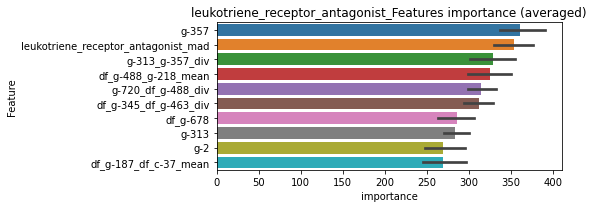

len(train_index) : 2800
len(valid_index) : 934
================================= fold 1/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108355	valid_1's binary_logloss: 0.162008
[200]	training's binary_logloss: 0.0391897	valid_1's binary_logloss: 0.100874
[300]	training's binary_logloss: 0.016696	valid_1's binary_logloss: 0.0763501
[400]	training's binary_logloss: 0.00765946	valid_1's binary_logloss: 0.064767
[500]	training's binary_logloss: 0.00400592	valid_1's binary_logloss: 0.0580984
[600]	training's binary_logloss: 0.00239666	valid_1's binary_logloss: 0.0550067
Early stopping, best iteration is:
[623]	training's binary_logloss: 0.00216004	valid_1's binary_logloss: 0.054173


len(train_index) : 2800
len(valid_index) : 934
================================= fold 2/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108132	valid_1's binary_logloss: 0.169186
[200]	training's binary_logloss: 0.0387761	valid_1's binary_logloss: 0.105831
[300]	training's binary_logloss: 0.0163186	valid_1's binary_logloss: 0.079119
[400]	training's binary_logloss: 0.00758432	valid_1's binary_logloss: 0.0674533
[500]	training's binary_logloss: 0.00391023	valid_1's binary_logloss: 0.0615213
[600]	training's binary_logloss: 0.00237755	valid_1's binary_logloss: 0.0583428
Early stopping, best iteration is:
[654]	training's binary_logloss: 0.00189866	valid_1's binary_logloss: 0.0568847


len(train_index) : 2801
len(valid_index) : 933
================================= fold 3/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109394	valid_1's binary_logloss: 0.148165
[200]	training's binary_logloss: 0.0396383	valid_1's binary_logloss: 0.0860519
[300]	training's binary_logloss: 0.0163811	valid_1's binary_logloss: 0.0597218
[400]	training's binary_logloss: 0.00751537	valid_1's binary_logloss: 0.0475622
[500]	training's binary_logloss: 0.00398019	valid_1's binary_logloss: 0.0422228
[600]	training's binary_logloss: 0.00240366	valid_1's binary_logloss: 0.0399522
[700]	training's binary_logloss: 0.00165148	valid_1's binary_logloss: 0.0389068
[800]	training's binary_logloss: 0.00125112	valid_1's binary_logloss: 0.0380042
[900]	training's binary_logloss: 0.00101102	valid_1's binary_logloss: 0.0373874
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00107185	valid_1's binary_logloss: 0.0372519


len(train_index) : 2801
len(valid_index) : 933
================================= fold 4/4 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10919	valid_1's binary_logloss: 0.163505
[200]	training's binary_logloss: 0.0403374	valid_1's binary_logloss: 0.0977287
[300]	training's binary_logloss: 0.0167484	valid_1's binary_logloss: 0.0698441
[400]	training's binary_logloss: 0.00784737	valid_1's binary_logloss: 0.0561876
[500]	training's binary_logloss: 0.00405918	valid_1's binary_logloss: 0.0481376
[600]	training's binary_logloss: 0.00245842	valid_1's binary_logloss: 0.044916
[700]	training's binary_logloss: 0.00168612	valid_1's binary_logloss: 0.0427961
[800]	training's binary_logloss: 0.00126829	valid_1's binary_logloss: 0.0416137
[900]	training's binary_logloss: 0.0010263	valid_1's binary_logloss: 0.0409974
[1000]	training's binary_logloss: 0.000879788	valid_1's binary_logloss: 0.0404903
[1100]	training's binary_logloss: 0.000803003	valid_1's binary_logloss: 0.0402104
Early stopping, best iteration is:
[1128]	training's binary_log

leukotriene_receptor_antagonist logloss: 0.04711396195431018


neg labels: 3289 → selected neg labels: 3288


lipase_inhibitor, len(trt): 12, len(othr): 3288, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0609325	valid_1's binary_logloss: 0.0671367
[200]	training's binary_logloss: 0.0130905	valid_1's binary_logloss: 0.0168682
[300]	training's binary_logloss: 0.00350394	valid_1's binary_logloss: 0.00583171
[400]	training's binary_logloss: 0.00133158	valid_1's binary_logloss: 0.00273219
[500]	training's binary_logloss: 0.000701977	valid_1's binary_logloss: 0.00171045
[600]	training's binary_logloss: 0.000466057	valid_1's binary_logloss: 0.0012962
[700]	training's binary_logloss: 0.000358282	valid_1's binary_logloss: 0.0010987
[800]	training's binary_logloss: 0.000316409	valid_1's binary_logloss: 0.00101379
Early stopping, best iteration is:
[816]	training's binary_logloss: 0.000313641	valid_1's binary_logloss: 0.0010072
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0600934	valid_1's binary_logloss: 0.0687754
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0021556, Threshold: 0.0115229, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00807, conf_1:0.01498
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0115229
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_2: 0.0615229
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_3: 0.1115229
threshold: 0.1115229, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0583986	valid_1's binary_logloss: 0.0629781
[200]	training's binary_logloss: 0.0118493	valid_1's binary_logloss: 0.014153
[300]	training's binary_logloss: 0.00305192	valid_1's binary_logloss: 0.00416607
[400]	training's binary_logloss: 0.00114604	valid_1's binary_logloss: 0.00174695
[500]	training's binary_logloss: 0.000601425	valid_1's binary_logloss: 0.000993017
[600]	training's binary_logloss: 0.000403118	valid_1's binary_logloss: 0.000706478
[700]	training's binary_logloss: 0.000313347	valid_1's binary_logloss: 0.000567573
[800]	training's binary_logloss: 0.000280855	valid_1's binary_logloss: 0.000516718
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000272086	valid_1's binary_logloss: 0.00050243
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0588328	valid_1's binary_logloss: 0.0666749
[200]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1440897, Threshold: 0.1115229, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0055249 Vs.target_rate: 0.00050, Num_p_label: 22.0, conf_0:0.08922, conf_1:0.13383
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_1: 0.1115229
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_2: 0.1615229
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_3: 0.2115229
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_4: 0.2615229
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.3115229
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.3615229
threshold: 0.3615229, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0583986	valid_1's binary_logloss: 0.0629781
[200]	training's binary_logloss: 0.0118493	valid_1's binary_logloss: 0.014153
[300]	training's binary_logloss: 0.00305192	valid_1's binary_logloss: 0.00416607
[400]	training's binary_logloss: 0.00114604	valid_1's binary_logloss: 0.00174695
[500]	training's binary_logloss: 0.000601425	valid_1's binary_logloss: 0.000993017
[600]	training's binary_logloss: 0.000403118	valid_1's binary_logloss: 0.000706478
[700]	training's binary_logloss: 0.000313347	valid_1's binary_logloss: 0.000567573
[800]	training's binary_logloss: 0.000280855	valid_1's binary_logloss: 0.000516718
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000272086	valid_1's binary_logloss: 0.00050243
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0588328	valid_1's binary_logloss: 0.0666749
[200]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1440897, Threshold: 0.3615229, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.32537, conf_1:0.39768
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.3615229
threshold: 0.3615229, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


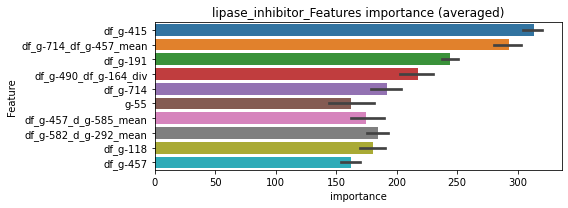

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0583944	valid_1's binary_logloss: 0.0637959
[200]	training's binary_logloss: 0.0119353	valid_1's binary_logloss: 0.0145638
[300]	training's binary_logloss: 0.00304923	valid_1's binary_logloss: 0.00424212
[400]	training's binary_logloss: 0.00114498	valid_1's binary_logloss: 0.00176886
[500]	training's binary_logloss: 0.000599046	valid_1's binary_logloss: 0.000992089
[600]	training's binary_logloss: 0.000399936	valid_1's binary_logloss: 0.000703621
[700]	training's binary_logloss: 0.000311913	valid_1's binary_logloss: 0.000567336
[800]	training's binary_logloss: 0.000279288	valid_1's binary_logloss: 0.000514918
[900]	training's binary_logloss: 0.000275704	valid_1's binary_logloss: 0.000509287
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000275485	valid_1's binary_logloss: 0.000508853


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0582933	valid_1's binary_logloss: 0.0658962
[200]	training's binary_logloss: 0.0119154	valid_1's binary_logloss: 0.0165567
[300]	training's binary_logloss: 0.0031112	valid_1's binary_logloss: 0.00549431
[400]	training's binary_logloss: 0.00118064	valid_1's binary_logloss: 0.00253495
[500]	training's binary_logloss: 0.000600858	valid_1's binary_logloss: 0.00146499
[600]	training's binary_logloss: 0.00039902	valid_1's binary_logloss: 0.00108611
[700]	training's binary_logloss: 0.00031128	valid_1's binary_logloss: 0.000918836
[800]	training's binary_logloss: 0.000278634	valid_1's binary_logloss: 0.000841599
[900]	training's binary_logloss: 0.000271476	valid_1's binary_logloss: 0.000827451
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000271528	valid_1's binary_logloss: 0.000827309


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.058911	valid_1's binary_logloss: 0.0652876
[200]	training's binary_logloss: 0.0119036	valid_1's binary_logloss: 0.0150911
[300]	training's binary_logloss: 0.00304051	valid_1's binary_logloss: 0.00448004
[400]	training's binary_logloss: 0.00113462	valid_1's binary_logloss: 0.00182891
[500]	training's binary_logloss: 0.000599261	valid_1's binary_logloss: 0.00101901
[600]	training's binary_logloss: 0.00040197	valid_1's binary_logloss: 0.000710218
[700]	training's binary_logloss: 0.000314841	valid_1's binary_logloss: 0.000571182
[800]	training's binary_logloss: 0.000279147	valid_1's binary_logloss: 0.000508339
[900]	training's binary_logloss: 0.000276631	valid_1's binary_logloss: 0.00050359
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000276631	valid_1's binary_logloss: 0.00050359


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0579315	valid_1's binary_logloss: 0.0669618
[200]	training's binary_logloss: 0.0117616	valid_1's binary_logloss: 0.0161095
[300]	training's binary_logloss: 0.00299268	valid_1's binary_logloss: 0.00513678
[400]	training's binary_logloss: 0.00112436	valid_1's binary_logloss: 0.00235494
[500]	training's binary_logloss: 0.000597948	valid_1's binary_logloss: 0.00139257
[600]	training's binary_logloss: 0.000402112	valid_1's binary_logloss: 0.00102644
[700]	training's binary_logloss: 0.000314287	valid_1's binary_logloss: 0.000860652
[800]	training's binary_logloss: 0.000280283	valid_1's binary_logloss: 0.000785968
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.000278176	valid_1's binary_logloss: 0.000782445


lipase_inhibitor logloss: 0.00065554618603065


neg labels: 3289 → selected neg labels: 3284


lipoxygenase_inhibitor, len(trt): 61, len(othr): 3284, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128337	valid_1's binary_logloss: 0.198311
[200]	training's binary_logloss: 0.0551186	valid_1's binary_logloss: 0.130339
[300]	training's binary_logloss: 0.0251191	valid_1's binary_logloss: 0.0948314
[400]	training's binary_logloss: 0.0118012	valid_1's binary_logloss: 0.0776451
[500]	training's binary_logloss: 0.00611467	valid_1's binary_logloss: 0.0693947
[600]	training's binary_logloss: 0.00359523	valid_1's binary_logloss: 0.0652069
[700]	training's binary_logloss: 0.00237015	valid_1's binary_logloss: 0.0646115
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00258208	valid_1's binary_logloss: 0.0644202
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126154	valid_1's binary_logloss: 0.18917
[200]	training's binary_logloss: 0.0511073	valid_1's binary_logloss: 0.115397
[300]	training's binary_logloss: 0.0224898	valid_1's bin

1 / 3 AUC score:0.998
y_Threshold: 0.0242330, Threshold: 0.3097766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 144 → Positive_corect_labels: 650/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.21684, conf_1:0.40271
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.3097766
Num_p_label: 33.0, Expected: 10.2, Adj_threshold_2: 0.3597766
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_3: 0.4097766
Num_p_label: 27.0, Expected: 10.2, Adj_threshold_4: 0.4597766
Num_p_label: 26.0, Expected: 10.2, Adj_threshold_5: 0.5097766
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_6: 0.5597766
Num_p_label: 21.0, Expected: 10.2, Adj_threshold_7: 0.6097766
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_8: 0.6597766
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_9: 0.7097766
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_10: 0.7597766
threshold: 0.7597766, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3796, y_label_rate: 0.1712329


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123016	valid_1's binary_logloss: 0.171111
[200]	training's binary_logloss: 0.0498699	valid_1's binary_logloss: 0.0958187
[300]	training's binary_logloss: 0.0220377	valid_1's binary_logloss: 0.0598414
[400]	training's binary_logloss: 0.0102276	valid_1's binary_logloss: 0.0408781
[500]	training's binary_logloss: 0.00526598	valid_1's binary_logloss: 0.0309856
[600]	training's binary_logloss: 0.00310957	valid_1's binary_logloss: 0.0248884
[700]	training's binary_logloss: 0.00208559	valid_1's binary_logloss: 0.0214777
[800]	training's binary_logloss: 0.00153322	valid_1's binary_logloss: 0.0190762
[900]	training's binary_logloss: 0.00121725	valid_1's binary_logloss: 0.0178289
[1000]	training's binary_logloss: 0.0010245	valid_1's binary_logloss: 0.0168524
[1100]	training's binary_logloss: 0.000907474	valid_1's binary_logloss: 0.0161811
[1200]	training's binary_logloss: 0.000834388	valid_1's binary_

2 / 3 AUC score:1.000
y_Threshold: 0.1041005, Threshold: 0.7597766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 639.0/3774
p_label_rate: 0.0085384 Vs.target_rate: 0.00256, Num_p_label: 34.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 34.0, Expected: 10.2, Adj_threshold_1: 0.7597766
threshold: 0.7597766, positive_p_label: 34.0/3982, p_label_rate: 0.0085384
positive_y_label: 639.0/3774, y_label_rate: 0.1693164
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118803	valid_1's binary_logloss: 0.170813
[200]	training's binary_logloss: 0.0464193	valid_1's binary_logloss: 0.0944057
[300]	training's binary_logloss: 0.0202188	valid_1's binary_logloss: 0.0599876
[400]	training's binary_logloss: 0.00952214	valid_1's binary_logloss: 0.0423155
[500]	training's binary_logloss: 0.00492566	valid_1's binary_logloss: 0.0332717
[600]	training's binary_logloss: 0.00288633	valid_1's binary_logloss: 0.0283209
[700]	training's binary_logloss: 0.00193542	valid_1's binary_logloss: 0.0249815
[800]	training's binary_logloss: 0.00143981	valid_1's binary_logloss: 0.023142
[900]	training's binary_logloss: 0.0011532	valid_1's binary_logloss: 0.0217526
[1000]	training's binary_logloss: 0.000970655	valid_1's binary_logloss: 0.0213787
[1100]	training's binary_logloss: 0.000866719	valid_1's binary_logloss: 0.0209187
[1200]	training's binary_logloss: 0.00081085	valid_1's binary_

3 / 3 AUC score:0.997
y_Threshold: 0.0729007, Threshold: 0.7597766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 624.0/3744
p_label_rate: 0.0113009 Vs.target_rate: 0.00256, Num_p_label: 45.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 45.0, Expected: 10.2, Adj_threshold_1: 0.7597766
threshold: 0.7597766, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 624.0/3744, y_label_rate: 0.1666667


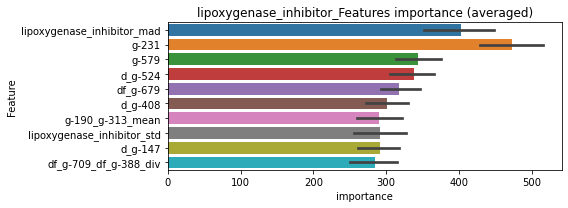

len(train_index) : 2808
len(valid_index) : 936
================================= fold 1/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118678	valid_1's binary_logloss: 0.170239
[200]	training's binary_logloss: 0.0461158	valid_1's binary_logloss: 0.0970755
[300]	training's binary_logloss: 0.0201586	valid_1's binary_logloss: 0.0652479
[400]	training's binary_logloss: 0.00935086	valid_1's binary_logloss: 0.0493129
[500]	training's binary_logloss: 0.00471282	valid_1's binary_logloss: 0.039973
[600]	training's binary_logloss: 0.00276501	valid_1's binary_logloss: 0.035337
[700]	training's binary_logloss: 0.00185484	valid_1's binary_logloss: 0.0330733
[800]	training's binary_logloss: 0.00137341	valid_1's binary_logloss: 0.0317235
[900]	training's binary_logloss: 0.00108996	valid_1's binary_logloss: 0.0306896
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00104894	valid_1's binary_logloss: 0.03056


len(train_index) : 2808
len(valid_index) : 936
================================= fold 2/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119292	valid_1's binary_logloss: 0.168513
[200]	training's binary_logloss: 0.0459095	valid_1's binary_logloss: 0.0951576
[300]	training's binary_logloss: 0.0195725	valid_1's binary_logloss: 0.0620195
[400]	training's binary_logloss: 0.00902346	valid_1's binary_logloss: 0.0457967
[500]	training's binary_logloss: 0.004606	valid_1's binary_logloss: 0.0371356
[600]	training's binary_logloss: 0.0027098	valid_1's binary_logloss: 0.0327016
[700]	training's binary_logloss: 0.00182678	valid_1's binary_logloss: 0.0300414
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00151284	valid_1's binary_logloss: 0.0288924


len(train_index) : 2808
len(valid_index) : 936
================================= fold 3/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11836	valid_1's binary_logloss: 0.177289
[200]	training's binary_logloss: 0.04547	valid_1's binary_logloss: 0.100671
[300]	training's binary_logloss: 0.0200147	valid_1's binary_logloss: 0.0677938
[400]	training's binary_logloss: 0.00929962	valid_1's binary_logloss: 0.0509394
[500]	training's binary_logloss: 0.00471859	valid_1's binary_logloss: 0.0414373
[600]	training's binary_logloss: 0.00273513	valid_1's binary_logloss: 0.0354394
[700]	training's binary_logloss: 0.00182512	valid_1's binary_logloss: 0.0318851
[800]	training's binary_logloss: 0.00134775	valid_1's binary_logloss: 0.0304596
[900]	training's binary_logloss: 0.00107472	valid_1's binary_logloss: 0.0292691
[1000]	training's binary_logloss: 0.000911169	valid_1's binary_logloss: 0.0286607
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000917275	valid_1's binary_logloss: 0.0286051


len(train_index) : 2808
len(valid_index) : 936
================================= fold 4/4 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11738	valid_1's binary_logloss: 0.187865
[200]	training's binary_logloss: 0.0458394	valid_1's binary_logloss: 0.119834
[300]	training's binary_logloss: 0.0195151	valid_1's binary_logloss: 0.0929376
[400]	training's binary_logloss: 0.00892184	valid_1's binary_logloss: 0.0812407
[500]	training's binary_logloss: 0.00457533	valid_1's binary_logloss: 0.0759671
Early stopping, best iteration is:
[554]	training's binary_logloss: 0.00336946	valid_1's binary_logloss: 0.0754167


lipoxygenase_inhibitor logloss: 0.0408685248518687


neg labels: 3289 → selected neg labels: 3287


lxr_agonist, len(trt): 6, len(othr): 3287, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0508512	valid_1's binary_logloss: 0.0555828
[200]	training's binary_logloss: 0.0103089	valid_1's binary_logloss: 0.0137378
[300]	training's binary_logloss: 0.0026066	valid_1's binary_logloss: 0.00511761
[400]	training's binary_logloss: 0.000985011	valid_1's binary_logloss: 0.0026197
[500]	training's binary_logloss: 0.000536664	valid_1's binary_logloss: 0.00171229
[600]	training's binary_logloss: 0.000369207	valid_1's binary_logloss: 0.00134197
[700]	training's binary_logloss: 0.000301393	valid_1's binary_logloss: 0.00118635
[800]	training's binary_logloss: 0.000280548	valid_1's binary_logloss: 0.00113555
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.000280548	valid_1's binary_logloss: 0.00113555
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0509077	valid_1's binary_logloss: 0.0579082
[200]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0013828, Threshold: 0.0063200, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00442, conf_1:0.00822
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0063200
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_2: 0.0563200
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_3: 0.1063200
threshold: 0.1063200, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497034	valid_1's binary_logloss: 0.0546706
[200]	training's binary_logloss: 0.0085981	valid_1's binary_logloss: 0.0103418
[300]	training's binary_logloss: 0.00202575	valid_1's binary_logloss: 0.00263383
[400]	training's binary_logloss: 0.000765001	valid_1's binary_logloss: 0.00108332
[500]	training's binary_logloss: 0.000431655	valid_1's binary_logloss: 0.000653271
[600]	training's binary_logloss: 0.00030164	valid_1's binary_logloss: 0.000476205
[700]	training's binary_logloss: 0.000251119	valid_1's binary_logloss: 0.000407412
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00024873	valid_1's binary_logloss: 0.000404987
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498093	valid_1's binary_logloss: 0.0534949
[200]	training's binary_logloss: 0.00851444	valid_1's binary_logloss: 0.011312
[300]	training's binary_logloss: 0

2 / 3 AUC score:1.000
y_Threshold: 0.1160397, Threshold: 0.1063200, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0050226 Vs.target_rate: 0.00025, Num_p_label: 20.0, conf_0:0.08506, conf_1:0.12758
Num_p_label: 20.0, Expected: 1.0, Adj_threshold_1: 0.1063200
Num_p_label: 11.0, Expected: 1.0, Adj_threshold_2: 0.1563200
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.2063200
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_4: 0.2563200
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_5: 0.3063200
Num_p_label: 7.0, Expected: 1.0, Adj_threshold_6: 0.3563200
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.4063200
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_8: 0.4563200
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_9: 0.5063200
threshold: 0.5063200, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497034	valid_1's binary_logloss: 0.0546706
[200]	training's binary_logloss: 0.0085981	valid_1's binary_logloss: 0.0103418
[300]	training's binary_logloss: 0.00202575	valid_1's binary_logloss: 0.00263383
[400]	training's binary_logloss: 0.000765001	valid_1's binary_logloss: 0.00108332
[500]	training's binary_logloss: 0.000431655	valid_1's binary_logloss: 0.000653271
[600]	training's binary_logloss: 0.00030164	valid_1's binary_logloss: 0.000476205
[700]	training's binary_logloss: 0.000251119	valid_1's binary_logloss: 0.000407412
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00024873	valid_1's binary_logloss: 0.000404987
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498093	valid_1's binary_logloss: 0.0534949
[200]	training's binary_logloss: 0.00851444	valid_1's binary_logloss: 0.011312
[300]	training's binary_logloss: 0

3 / 3 AUC score:1.000
y_Threshold: 0.1160397, Threshold: 0.5063200, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0002511 Vs.target_rate: 0.00025, Num_p_label: 1.0, conf_0:0.45569, conf_1:0.55695
threshold: 0.5063200, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


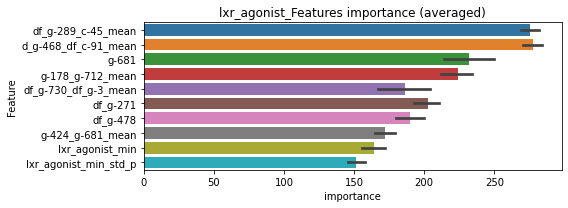

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0493809	valid_1's binary_logloss: 0.0537462
[200]	training's binary_logloss: 0.00849046	valid_1's binary_logloss: 0.0100137
[300]	training's binary_logloss: 0.00200154	valid_1's binary_logloss: 0.00259634
[400]	training's binary_logloss: 0.000760354	valid_1's binary_logloss: 0.00105631
[500]	training's binary_logloss: 0.000423917	valid_1's binary_logloss: 0.000622222
[600]	training's binary_logloss: 0.000296515	valid_1's binary_logloss: 0.000452878
[700]	training's binary_logloss: 0.000250108	valid_1's binary_logloss: 0.000389063
[800]	training's binary_logloss: 0.000243267	valid_1's binary_logloss: 0.000379718
Early stopping, best iteration is:
[793]	training's binary_logloss: 0.000243267	valid_1's binary_logloss: 0.000379718


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495869	valid_1's binary_logloss: 0.053547
[200]	training's binary_logloss: 0.00856563	valid_1's binary_logloss: 0.0112554
[300]	training's binary_logloss: 0.00199682	valid_1's binary_logloss: 0.00377274
[400]	training's binary_logloss: 0.000758423	valid_1's binary_logloss: 0.00195996
[500]	training's binary_logloss: 0.00042322	valid_1's binary_logloss: 0.00130733
[600]	training's binary_logloss: 0.00029648	valid_1's binary_logloss: 0.00105232
[700]	training's binary_logloss: 0.000248754	valid_1's binary_logloss: 0.000941311
[800]	training's binary_logloss: 0.000239828	valid_1's binary_logloss: 0.000917634
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.000238057	valid_1's binary_logloss: 0.000912938


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049729	valid_1's binary_logloss: 0.0526694
[200]	training's binary_logloss: 0.0086022	valid_1's binary_logloss: 0.00955148
[300]	training's binary_logloss: 0.00202423	valid_1's binary_logloss: 0.00234654
[400]	training's binary_logloss: 0.000770719	valid_1's binary_logloss: 0.00094943
[500]	training's binary_logloss: 0.000425103	valid_1's binary_logloss: 0.000547182
[600]	training's binary_logloss: 0.00029885	valid_1's binary_logloss: 0.000394313
[700]	training's binary_logloss: 0.000248118	valid_1's binary_logloss: 0.000330791
Early stopping, best iteration is:
[736]	training's binary_logloss: 0.000242363	valid_1's binary_logloss: 0.000323601


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 lxr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0498161	valid_1's binary_logloss: 0.0573073
[200]	training's binary_logloss: 0.00851277	valid_1's binary_logloss: 0.0114362
[300]	training's binary_logloss: 0.00198939	valid_1's binary_logloss: 0.00336387
[400]	training's binary_logloss: 0.000753987	valid_1's binary_logloss: 0.00154989
[500]	training's binary_logloss: 0.000419727	valid_1's binary_logloss: 0.000956444
[600]	training's binary_logloss: 0.000295183	valid_1's binary_logloss: 0.000725573
[700]	training's binary_logloss: 0.000246834	valid_1's binary_logloss: 0.0006315
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000239605	valid_1's binary_logloss: 0.000615849


lxr_agonist logloss: 0.0005580556253023992


neg labels: 3289 → selected neg labels: 3284


mdm_inhibitor, len(trt): 31, len(othr): 3284, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0970978	valid_1's binary_logloss: 0.133926
[200]	training's binary_logloss: 0.0325526	valid_1's binary_logloss: 0.0637453
[300]	training's binary_logloss: 0.0124346	valid_1's binary_logloss: 0.037809
[400]	training's binary_logloss: 0.00532726	valid_1's binary_logloss: 0.0264708
[500]	training's binary_logloss: 0.00271275	valid_1's binary_logloss: 0.0213129
[600]	training's binary_logloss: 0.00165341	valid_1's binary_logloss: 0.0182002
[700]	training's binary_logloss: 0.00117153	valid_1's binary_logloss: 0.0168357
[800]	training's binary_logloss: 0.000904111	valid_1's binary_logloss: 0.0159137
[900]	training's binary_logloss: 0.000751504	valid_1's binary_logloss: 0.0154927
Early stopping, best iteration is:
[950]	training's binary_logloss: 0.000701515	valid_1's binary_logloss: 0.0153312
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974143	va

1 / 3 AUC score:1.000
y_Threshold: 0.0101565, Threshold: 0.1039891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.07279, conf_1:0.13519
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.1039891
Num_p_label: 33.0, Expected: 5.2, Adj_threshold_2: 0.1539891
Num_p_label: 24.0, Expected: 5.2, Adj_threshold_3: 0.2039891
Num_p_label: 22.0, Expected: 5.2, Adj_threshold_4: 0.2539891
Num_p_label: 19.0, Expected: 5.2, Adj_threshold_5: 0.3039891
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_6: 0.3539891
Num_p_label: 11.0, Expected: 5.2, Adj_threshold_7: 0.4039891
threshold: 0.4039891, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959668	valid_1's binary_logloss: 0.130369
[200]	training's binary_logloss: 0.029683	valid_1's binary_logloss: 0.0557126
[300]	training's binary_logloss: 0.010821	valid_1's binary_logloss: 0.0304744
[400]	training's binary_logloss: 0.00460673	valid_1's binary_logloss: 0.0191904
[500]	training's binary_logloss: 0.00239104	valid_1's binary_logloss: 0.0144114
[600]	training's binary_logloss: 0.00147647	valid_1's binary_logloss: 0.0119089
[700]	training's binary_logloss: 0.00105991	valid_1's binary_logloss: 0.0106783
[800]	training's binary_logloss: 0.000828422	valid_1's binary_logloss: 0.00992877
[900]	training's binary_logloss: 0.000693146	valid_1's binary_logloss: 0.00956802
Early stopping, best iteration is:
[882]	training's binary_logloss: 0.000711851	valid_1's binary_logloss: 0.00953412
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0976602	

2 / 3 AUC score:1.000
y_Threshold: 0.0662389, Threshold: 0.4039891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0107986 Vs.target_rate: 0.00130, Num_p_label: 43.0, conf_0:0.32319, conf_1:0.48479
Num_p_label: 43.0, Expected: 5.2, Adj_threshold_1: 0.4039891
Num_p_label: 41.0, Expected: 5.2, Adj_threshold_2: 0.4539891
Num_p_label: 36.0, Expected: 5.2, Adj_threshold_3: 0.5039891
Num_p_label: 34.0, Expected: 5.2, Adj_threshold_4: 0.5539891
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_5: 0.6039891
Num_p_label: 28.0, Expected: 5.2, Adj_threshold_6: 0.6539891
Num_p_label: 23.0, Expected: 5.2, Adj_threshold_7: 0.7039891
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_8: 0.7539891
threshold: 0.7539891, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955543	valid_1's binary_logloss: 0.12899
[200]	training's binary_logloss: 0.0304425	valid_1's binary_logloss: 0.0540462
[300]	training's binary_logloss: 0.0111763	valid_1's binary_logloss: 0.0275893
[400]	training's binary_logloss: 0.00470289	valid_1's binary_logloss: 0.0163525
[500]	training's binary_logloss: 0.00240413	valid_1's binary_logloss: 0.0118091
[600]	training's binary_logloss: 0.00150047	valid_1's binary_logloss: 0.00979043
[700]	training's binary_logloss: 0.00106863	valid_1's binary_logloss: 0.00892804
[800]	training's binary_logloss: 0.000823749	valid_1's binary_logloss: 0.00824654
[900]	training's binary_logloss: 0.000698658	valid_1's binary_logloss: 0.00794433
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.000659218	valid_1's binary_logloss: 0.00778802
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09562

3 / 3 AUC score:1.000
y_Threshold: 0.0792665, Threshold: 0.7539891, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0052737 Vs.target_rate: 0.00130, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_1: 0.7539891
threshold: 0.7539891, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 652.0/3800, y_label_rate: 0.1715789


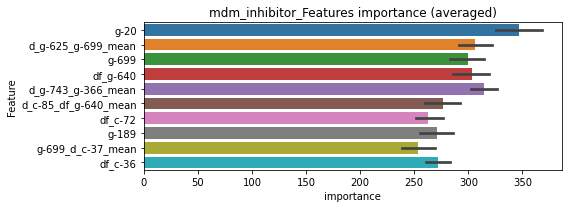

len(train_index) : 2850
len(valid_index) : 950
================================= fold 1/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0943835	valid_1's binary_logloss: 0.13011
[200]	training's binary_logloss: 0.0305791	valid_1's binary_logloss: 0.0584775
[300]	training's binary_logloss: 0.0111896	valid_1's binary_logloss: 0.0328619
[400]	training's binary_logloss: 0.00469601	valid_1's binary_logloss: 0.0222459
[500]	training's binary_logloss: 0.00241008	valid_1's binary_logloss: 0.0180278
[600]	training's binary_logloss: 0.00147781	valid_1's binary_logloss: 0.0158277
[700]	training's binary_logloss: 0.00104557	valid_1's binary_logloss: 0.0148195
[800]	training's binary_logloss: 0.000815055	valid_1's binary_logloss: 0.014216
[900]	training's binary_logloss: 0.000689049	valid_1's binary_logloss: 0.0138836
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000677505	valid_1's binary_logloss: 0.013804


len(train_index) : 2850
len(valid_index) : 950
================================= fold 2/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0948381	valid_1's binary_logloss: 0.126284
[200]	training's binary_logloss: 0.0306219	valid_1's binary_logloss: 0.0541161
[300]	training's binary_logloss: 0.0112228	valid_1's binary_logloss: 0.0292155
[400]	training's binary_logloss: 0.00482355	valid_1's binary_logloss: 0.018992
[500]	training's binary_logloss: 0.0024213	valid_1's binary_logloss: 0.0133047
[600]	training's binary_logloss: 0.00149695	valid_1's binary_logloss: 0.0108947
[700]	training's binary_logloss: 0.00105822	valid_1's binary_logloss: 0.00986449
[800]	training's binary_logloss: 0.000821275	valid_1's binary_logloss: 0.00938069
[900]	training's binary_logloss: 0.000688968	valid_1's binary_logloss: 0.00903608
[1000]	training's binary_logloss: 0.000621041	valid_1's binary_logloss: 0.00886681
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.000616666	valid_1's binary_logloss: 0.00885891


len(train_index) : 2850
len(valid_index) : 950
================================= fold 3/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0928966	valid_1's binary_logloss: 0.122948
[200]	training's binary_logloss: 0.0294921	valid_1's binary_logloss: 0.0526948
[300]	training's binary_logloss: 0.0106946	valid_1's binary_logloss: 0.02758
[400]	training's binary_logloss: 0.00458196	valid_1's binary_logloss: 0.0169524
[500]	training's binary_logloss: 0.0023556	valid_1's binary_logloss: 0.0122318
[600]	training's binary_logloss: 0.00146275	valid_1's binary_logloss: 0.00984139
[700]	training's binary_logloss: 0.00104874	valid_1's binary_logloss: 0.00884164
[800]	training's binary_logloss: 0.000820328	valid_1's binary_logloss: 0.00808101
[900]	training's binary_logloss: 0.000691865	valid_1's binary_logloss: 0.00772277
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00071829	valid_1's binary_logloss: 0.00769633


len(train_index) : 2850
len(valid_index) : 950
================================= fold 4/4 mdm_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961076	valid_1's binary_logloss: 0.125391
[200]	training's binary_logloss: 0.030751	valid_1's binary_logloss: 0.0548407
[300]	training's binary_logloss: 0.0109464	valid_1's binary_logloss: 0.029545
[400]	training's binary_logloss: 0.00452912	valid_1's binary_logloss: 0.0188377
[500]	training's binary_logloss: 0.00234951	valid_1's binary_logloss: 0.014344
[600]	training's binary_logloss: 0.00146762	valid_1's binary_logloss: 0.0124154
[700]	training's binary_logloss: 0.00104751	valid_1's binary_logloss: 0.0113193
[800]	training's binary_logloss: 0.000817844	valid_1's binary_logloss: 0.0106838
[900]	training's binary_logloss: 0.000690069	valid_1's binary_logloss: 0.0101856
Early stopping, best iteration is:
[941]	training's binary_logloss: 0.000653857	valid_1's binary_logloss: 0.0100482


mdm_inhibitor logloss: 0.010101858000479866


neg labels: 3289 → selected neg labels: 3273


mek_inhibitor, len(trt): 72, len(othr): 3273, target_rate: 0.0030234 → Adj_target_rate: 0.0031837
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151177	valid_1's binary_logloss: 0.248979
[200]	training's binary_logloss: 0.0751611	valid_1's binary_logloss: 0.184907
[300]	training's binary_logloss: 0.039559	valid_1's binary_logloss: 0.149006
[400]	training's binary_logloss: 0.0211346	valid_1's binary_logloss: 0.125493
[500]	training's binary_logloss: 0.0113225	valid_1's binary_logloss: 0.11315
[600]	training's binary_logloss: 0.00637606	valid_1's binary_logloss: 0.107202
[700]	training's binary_logloss: 0.00391638	valid_1's binary_logloss: 0.101589
[800]	training's binary_logloss: 0.00265734	valid_1's binary_logloss: 0.100083
[900]	training's binary_logloss: 0.00196858	valid_1's binary_logloss: 0.0990597
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.00204486	valid_1's binary_logloss: 0.0989023
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.154253	valid_1's binary_

1 / 3 AUC score:0.995
y_Threshold: 0.0308554, Threshold: 0.1272655, pos_neg_ratio: 0.8000000
Remove_noisy_data: 162 → Positive_corect_labels: 639/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00302, Num_p_label: 40.0, conf_0:0.08909, conf_1:0.16545
Num_p_label: 40.0, Expected: 12.0, Adj_threshold_1: 0.1272655
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_2: 0.1772655
Num_p_label: 13.0, Expected: 12.0, Adj_threshold_3: 0.2272655
threshold: 0.2272655, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 639.0/3765, y_label_rate: 0.1697211
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.143781	valid_1's binary_logloss: 0.228186
[200]	training's binary_logloss: 0.0684949	valid_1's binary_logloss: 0.162948
[300]	training's binary_logloss: 0.0330403	valid_1's binary_logloss: 0.126628
[400]	training's binary_logloss: 0.0163364	valid_1's binary_logloss: 0.108679
[500]	training's binary_logloss: 0.00867396	valid_1's binary_logloss: 0.0992942
[600]	training's binary_logloss: 0.00491939	valid_1's binary_logloss: 0.0941541
[700]	training's binary_logloss: 0.00315398	valid_1's binary_logloss: 0.0920812
[800]	training's binary_logloss: 0.00219995	valid_1's binary_logloss: 0.090318
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00198953	valid_1's binary_logloss: 0.0900656
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.142371	valid_1's binary_logloss: 0.212434
[200]	training's binary_logloss: 0.0664873	valid_1's bin

2 / 3 AUC score:0.992
y_Threshold: 0.1195213, Threshold: 0.2272655, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 613.0/3713
p_label_rate: 0.0185836 Vs.target_rate: 0.00302, Num_p_label: 74.0, conf_0:0.18181, conf_1:0.27272
Num_p_label: 74.0, Expected: 12.0, Adj_threshold_1: 0.2272655
Num_p_label: 59.0, Expected: 12.0, Adj_threshold_2: 0.2772655
Num_p_label: 50.0, Expected: 12.0, Adj_threshold_3: 0.3272655
Num_p_label: 45.0, Expected: 12.0, Adj_threshold_4: 0.3772655
Num_p_label: 41.0, Expected: 12.0, Adj_threshold_5: 0.4272655
Num_p_label: 34.0, Expected: 12.0, Adj_threshold_6: 0.4772655
Num_p_label: 28.0, Expected: 12.0, Adj_threshold_7: 0.5272655
Num_p_label: 25.0, Expected: 12.0, Adj_threshold_8: 0.5772655
Num_p_label: 18.0, Expected: 12.0, Adj_threshold_9: 0.6272655
threshold: 0.6272655, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 613.0/3713, y_label_rate: 0.1650956
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133074	valid_1's binary_logloss: 0.204399
[200]	training's binary_logloss: 0.0601785	valid_1's binary_logloss: 0.133599
[300]	training's binary_logloss: 0.0287869	valid_1's binary_logloss: 0.0984964
[400]	training's binary_logloss: 0.0141232	valid_1's binary_logloss: 0.0758224
[500]	training's binary_logloss: 0.00739573	valid_1's binary_logloss: 0.0650965
[600]	training's binary_logloss: 0.0042418	valid_1's binary_logloss: 0.057543
[700]	training's binary_logloss: 0.00273263	valid_1's binary_logloss: 0.0536394
[800]	training's binary_logloss: 0.00193403	valid_1's binary_logloss: 0.0514397
Early stopping, best iteration is:
[846]	training's binary_logloss: 0.00170174	valid_1's binary_logloss: 0.0511654
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137534	valid_1's binary_logloss: 0.200205
[200]	training's binary_logloss: 0.0610246	valid_1's bi

3 / 3 AUC score:0.997
y_Threshold: 0.1216945, Threshold: 0.6272655, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 597.0/3681
p_label_rate: 0.0067805 Vs.target_rate: 0.00302, Num_p_label: 27.0, conf_0:0.50000, conf_1:0.68999
Num_p_label: 27.0, Expected: 12.0, Adj_threshold_1: 0.6272655
Num_p_label: 21.0, Expected: 12.0, Adj_threshold_2: 0.6772655
Num_p_label: 16.0, Expected: 12.0, Adj_threshold_3: 0.7272655
threshold: 0.7272655, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 597.0/3681, y_label_rate: 0.1621842


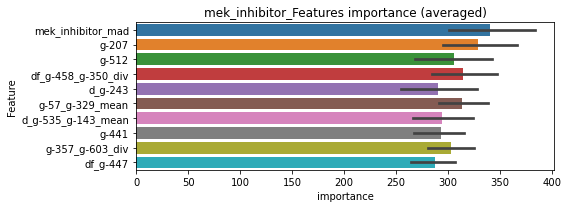

len(train_index) : 2760
len(valid_index) : 921
================================= fold 1/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131212	valid_1's binary_logloss: 0.193271
[200]	training's binary_logloss: 0.057112	valid_1's binary_logloss: 0.120378
[300]	training's binary_logloss: 0.0276716	valid_1's binary_logloss: 0.0846245
[400]	training's binary_logloss: 0.0136171	valid_1's binary_logloss: 0.0644429
[500]	training's binary_logloss: 0.00693921	valid_1's binary_logloss: 0.0532908
[600]	training's binary_logloss: 0.00388978	valid_1's binary_logloss: 0.0476369
[700]	training's binary_logloss: 0.00251664	valid_1's binary_logloss: 0.0443415
[800]	training's binary_logloss: 0.00181027	valid_1's binary_logloss: 0.0428886
[900]	training's binary_logloss: 0.00139989	valid_1's binary_logloss: 0.0409781
[1000]	training's binary_logloss: 0.00114898	valid_1's binary_logloss: 0.0406153
[1100]	training's binary_logloss: 0.000991682	valid_1's binary_logloss: 0.0400851
Early stopping, best iteration is:
[1090]	training's binary_logl

len(train_index) : 2761
len(valid_index) : 920
================================= fold 2/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128959	valid_1's binary_logloss: 0.189431
[200]	training's binary_logloss: 0.0531005	valid_1's binary_logloss: 0.112427
[300]	training's binary_logloss: 0.0245468	valid_1's binary_logloss: 0.076151
[400]	training's binary_logloss: 0.0118208	valid_1's binary_logloss: 0.0555442
[500]	training's binary_logloss: 0.00617439	valid_1's binary_logloss: 0.0440768
[600]	training's binary_logloss: 0.00361616	valid_1's binary_logloss: 0.0374257
[700]	training's binary_logloss: 0.00237753	valid_1's binary_logloss: 0.0343661
[800]	training's binary_logloss: 0.00173365	valid_1's binary_logloss: 0.0325739
[900]	training's binary_logloss: 0.00135089	valid_1's binary_logloss: 0.0315339
[1000]	training's binary_logloss: 0.00112427	valid_1's binary_logloss: 0.0309019
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.0010281	valid_1's binary_logloss: 0.0306729


len(train_index) : 2761
len(valid_index) : 920
================================= fold 3/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131288	valid_1's binary_logloss: 0.206399
[200]	training's binary_logloss: 0.0545425	valid_1's binary_logloss: 0.139757
[300]	training's binary_logloss: 0.0255035	valid_1's binary_logloss: 0.109686
[400]	training's binary_logloss: 0.0120643	valid_1's binary_logloss: 0.0952685
[500]	training's binary_logloss: 0.00626214	valid_1's binary_logloss: 0.0891917
[600]	training's binary_logloss: 0.0036073	valid_1's binary_logloss: 0.0870804
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00399899	valid_1's binary_logloss: 0.0868073


len(train_index) : 2761
len(valid_index) : 920
================================= fold 4/4 mek_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.131091	valid_1's binary_logloss: 0.193692
[200]	training's binary_logloss: 0.0562014	valid_1's binary_logloss: 0.119759
[300]	training's binary_logloss: 0.025829	valid_1's binary_logloss: 0.0843104
[400]	training's binary_logloss: 0.0125375	valid_1's binary_logloss: 0.0656784
[500]	training's binary_logloss: 0.00639664	valid_1's binary_logloss: 0.0555007
[600]	training's binary_logloss: 0.00370766	valid_1's binary_logloss: 0.0514691
[700]	training's binary_logloss: 0.00241193	valid_1's binary_logloss: 0.0484636
[800]	training's binary_logloss: 0.0017398	valid_1's binary_logloss: 0.0465856
Early stopping, best iteration is:
[831]	training's binary_logloss: 0.00160414	valid_1's binary_logloss: 0.046134


mek_inhibitor logloss: 0.05080218799052461


neg labels: 3289 → selected neg labels: 3276


membrane_integrity_inhibitor, len(trt): 74, len(othr): 3276, target_rate: 0.0031074 → Adj_target_rate: 0.0032587
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136567	valid_1's binary_logloss: 0.213765
[200]	training's binary_logloss: 0.0600104	valid_1's binary_logloss: 0.148507
[300]	training's binary_logloss: 0.0284624	valid_1's binary_logloss: 0.118984
[400]	training's binary_logloss: 0.0146731	valid_1's binary_logloss: 0.104853
[500]	training's binary_logloss: 0.00780198	valid_1's binary_logloss: 0.099024
Early stopping, best iteration is:
[568]	training's binary_logloss: 0.0053468	valid_1's binary_logloss: 0.0953437
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139688	valid_1's binary_logloss: 0.192298
[200]	training's binary_logloss: 0.0619287	valid_1's binary_logloss: 0.123036
[300]	training's binary_logloss: 0.0308024	valid_1's binary_logloss: 0.0908445
[400]	training's binary_logloss: 0.015555	valid_1's binary_logloss: 0.0726596
[500]	training's binary_logloss: 0.008662	valid_1's binary_log

1 / 3 AUC score:0.993
y_Threshold: 0.0378083, Threshold: 0.1274586, pos_neg_ratio: 0.8000000
Remove_noisy_data: 170 → Positive_corect_labels: 636/3761
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.08922, conf_1:0.16570
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.1274586
Num_p_label: 29.0, Expected: 12.4, Adj_threshold_2: 0.1774586
Num_p_label: 21.0, Expected: 12.4, Adj_threshold_3: 0.2274586
Num_p_label: 13.0, Expected: 12.4, Adj_threshold_4: 0.2774586
threshold: 0.2774586, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 636.0/3761, y_label_rate: 0.1691040
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124698	valid_1's binary_logloss: 0.191627
[200]	training's binary_logloss: 0.0499776	valid_1's binary_logloss: 0.123766
[300]	training's binary_logloss: 0.0224534	valid_1's binary_logloss: 0.0932687
[400]	training's binary_logloss: 0.0107041	valid_1's binary_logloss: 0.0782842
[500]	training's binary_logloss: 0.00556268	valid_1's binary_logloss: 0.0702755
[600]	training's binary_logloss: 0.00326605	valid_1's binary_logloss: 0.0649054
[700]	training's binary_logloss: 0.00218414	valid_1's binary_logloss: 0.062836
[800]	training's binary_logloss: 0.00160624	valid_1's binary_logloss: 0.0615085
Early stopping, best iteration is:
[788]	training's binary_logloss: 0.00165702	valid_1's binary_logloss: 0.0614583
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12929	valid_1's binary_logloss: 0.174469
[200]	training's binary_logloss: 0.0527379	valid_1's bi

2 / 3 AUC score:0.998
y_Threshold: 0.1047709, Threshold: 0.2774586, pos_neg_ratio: 0.8000000
Remove_noisy_data: 52 → Positive_corect_labels: 610.0/3709
p_label_rate: 0.0150678 Vs.target_rate: 0.00311, Num_p_label: 60.0, conf_0:0.22197, conf_1:0.33295
Num_p_label: 60.0, Expected: 12.4, Adj_threshold_1: 0.2774586
Num_p_label: 51.0, Expected: 12.4, Adj_threshold_2: 0.3274586
Num_p_label: 48.0, Expected: 12.4, Adj_threshold_3: 0.3774586
Num_p_label: 42.0, Expected: 12.4, Adj_threshold_4: 0.4274586
Num_p_label: 39.0, Expected: 12.4, Adj_threshold_5: 0.4774586
Num_p_label: 36.0, Expected: 12.4, Adj_threshold_6: 0.5274586
Num_p_label: 35.0, Expected: 12.4, Adj_threshold_7: 0.5774586
Num_p_label: 33.0, Expected: 12.4, Adj_threshold_8: 0.6274586
Num_p_label: 27.0, Expected: 12.4, Adj_threshold_9: 0.6774586
Num_p_label: 23.0, Expected: 12.4, Adj_threshold_10: 0.7274586
threshold: 0.7774586, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 610.0/3709, y_label_rate: 0.1644648

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117951	valid_1's binary_logloss: 0.178596
[200]	training's binary_logloss: 0.0449845	valid_1's binary_logloss: 0.103148
[300]	training's binary_logloss: 0.0193121	valid_1's binary_logloss: 0.0697561
[400]	training's binary_logloss: 0.00913046	valid_1's binary_logloss: 0.0530322
[500]	training's binary_logloss: 0.00470801	valid_1's binary_logloss: 0.0439966
[600]	training's binary_logloss: 0.00284028	valid_1's binary_logloss: 0.0387116
[700]	training's binary_logloss: 0.00190481	valid_1's binary_logloss: 0.035459
[800]	training's binary_logloss: 0.00141479	valid_1's binary_logloss: 0.033378
[900]	training's binary_logloss: 0.00112766	valid_1's binary_logloss: 0.0320581
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.0011256	valid_1's binary_logloss: 0.0320421
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113858	valid_1's 

3 / 3 AUC score:0.998
y_Threshold: 0.1097315, Threshold: 0.7774586, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 592.0/3673
p_label_rate: 0.0100452 Vs.target_rate: 0.00311, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 40.0, Expected: 12.4, Adj_threshold_1: 0.7774586
threshold: 0.7774586, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 592.0/3673, y_label_rate: 0.1611762


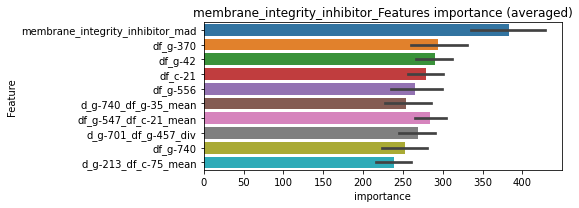

len(train_index) : 2754
len(valid_index) : 919
================================= fold 1/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11043	valid_1's binary_logloss: 0.155785
[200]	training's binary_logloss: 0.0421087	valid_1's binary_logloss: 0.0923518
[300]	training's binary_logloss: 0.0182285	valid_1's binary_logloss: 0.0658481
[400]	training's binary_logloss: 0.00844054	valid_1's binary_logloss: 0.052639
[500]	training's binary_logloss: 0.0043297	valid_1's binary_logloss: 0.0473965
[600]	training's binary_logloss: 0.00258489	valid_1's binary_logloss: 0.0437168
[700]	training's binary_logloss: 0.00172667	valid_1's binary_logloss: 0.0420327
[800]	training's binary_logloss: 0.00128905	valid_1's binary_logloss: 0.0411952
[900]	training's binary_logloss: 0.00104631	valid_1's binary_logloss: 0.0405949
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.00107566	valid_1's binary_logloss: 0.0405434


len(train_index) : 2755
len(valid_index) : 918
================================= fold 2/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109673	valid_1's binary_logloss: 0.160388
[200]	training's binary_logloss: 0.0416477	valid_1's binary_logloss: 0.0927699
[300]	training's binary_logloss: 0.0173846	valid_1's binary_logloss: 0.0622753
[400]	training's binary_logloss: 0.00788184	valid_1's binary_logloss: 0.0469266
[500]	training's binary_logloss: 0.00407951	valid_1's binary_logloss: 0.0384861
[600]	training's binary_logloss: 0.00247371	valid_1's binary_logloss: 0.0337578
[700]	training's binary_logloss: 0.00167618	valid_1's binary_logloss: 0.0316981
[800]	training's binary_logloss: 0.00125692	valid_1's binary_logloss: 0.0300107
[900]	training's binary_logloss: 0.00101594	valid_1's binary_logloss: 0.0292638
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000981813	valid_1's binary_logloss: 0.029056


len(train_index) : 2755
len(valid_index) : 918
================================= fold 3/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108853	valid_1's binary_logloss: 0.15622
[200]	training's binary_logloss: 0.0409801	valid_1's binary_logloss: 0.0850191
[300]	training's binary_logloss: 0.0172125	valid_1's binary_logloss: 0.0550559
[400]	training's binary_logloss: 0.0079457	valid_1's binary_logloss: 0.0399868
[500]	training's binary_logloss: 0.00411413	valid_1's binary_logloss: 0.032577
[600]	training's binary_logloss: 0.0024612	valid_1's binary_logloss: 0.0286258
[700]	training's binary_logloss: 0.00167935	valid_1's binary_logloss: 0.0265418
[800]	training's binary_logloss: 0.00126804	valid_1's binary_logloss: 0.0252942
[900]	training's binary_logloss: 0.00103045	valid_1's binary_logloss: 0.0243013
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00104023	valid_1's binary_logloss: 0.0242447


len(train_index) : 2755
len(valid_index) : 918
================================= fold 4/4 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10956	valid_1's binary_logloss: 0.154695
[200]	training's binary_logloss: 0.0410388	valid_1's binary_logloss: 0.0905019
[300]	training's binary_logloss: 0.0176209	valid_1's binary_logloss: 0.0634583
[400]	training's binary_logloss: 0.00809578	valid_1's binary_logloss: 0.0498258
[500]	training's binary_logloss: 0.00420496	valid_1's binary_logloss: 0.0424788
[600]	training's binary_logloss: 0.00248616	valid_1's binary_logloss: 0.0381637
[700]	training's binary_logloss: 0.00169092	valid_1's binary_logloss: 0.0364678
[800]	training's binary_logloss: 0.00127195	valid_1's binary_logloss: 0.0352479
[900]	training's binary_logloss: 0.00103114	valid_1's binary_logloss: 0.0341249
[1000]	training's binary_logloss: 0.000888877	valid_1's binary_logloss: 0.0335369
[1100]	training's binary_logloss: 0.0008039	valid_1's binary_logloss: 0.0331232
Early stopping, best iteration is:
[1090]	training's binary_log

membrane_integrity_inhibitor logloss: 0.03171785702665772


neg labels: 3289 → selected neg labels: 3283


mineralocorticoid_receptor_antagonist, len(trt): 25, len(othr): 3283, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0801253	valid_1's binary_logloss: 0.104844
[200]	training's binary_logloss: 0.0238895	valid_1's binary_logloss: 0.0434258
[300]	training's binary_logloss: 0.00834153	valid_1's binary_logloss: 0.0243891
[400]	training's binary_logloss: 0.00337006	valid_1's binary_logloss: 0.0174727
[500]	training's binary_logloss: 0.0017108	valid_1's binary_logloss: 0.0148526
[600]	training's binary_logloss: 0.00106297	valid_1's binary_logloss: 0.0137404
[700]	training's binary_logloss: 0.000767506	valid_1's binary_logloss: 0.01327
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.000786796	valid_1's binary_logloss: 0.0132196
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822055	valid_1's binary_logloss: 0.104861
[200]	training's binary_logloss: 0.0250804	valid_1's binary_logloss: 0.0405094
[300]	training's binary_logloss: 0.00871248	valid_

1 / 3 AUC score:1.000
y_Threshold: 0.0073131, Threshold: 0.0527905, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.03695, conf_1:0.06863
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0527905
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.1027905
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.1527905
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.2027905
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_5: 0.2527905
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.3027905
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_7: 0.3527905
threshold: 0.3527905, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3807, y_label_rate: 0.1723142
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0760054	valid_1's binary_logloss: 0.0992713
[200]	training's binary_logloss: 0.0202823	valid_1's binary_logloss: 0.0363355
[300]	training's binary_logloss: 0.00668627	valid_1's binary_logloss: 0.0185806
[400]	training's binary_logloss: 0.00272158	valid_1's binary_logloss: 0.0124197
[500]	training's binary_logloss: 0.00140236	valid_1's binary_logloss: 0.00970213
[600]	training's binary_logloss: 0.000894336	valid_1's binary_logloss: 0.00860697
[700]	training's binary_logloss: 0.000657066	valid_1's binary_logloss: 0.00794348
[800]	training's binary_logloss: 0.000529003	valid_1's binary_logloss: 0.00753621
Early stopping, best iteration is:
[807]	training's binary_logloss: 0.000522138	valid_1's binary_logloss: 0.00753172
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0764913	valid_1's binary_logloss: 0.10151
[200]	training's binary_logloss: 0.0208

2 / 3 AUC score:1.000
y_Threshold: 0.0756372, Threshold: 0.3527905, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0057760 Vs.target_rate: 0.00105, Num_p_label: 23.0, conf_0:0.28223, conf_1:0.42335
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_1: 0.3527905
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.4027905
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.4527905
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_4: 0.5027905
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_5: 0.5527905
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_6: 0.6027905
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_7: 0.6527905
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_8: 0.7027905
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_9: 0.7527905
threshold: 0.7527905, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0767275	valid_1's binary_logloss: 0.100517
[200]	training's binary_logloss: 0.0211194	valid_1's binary_logloss: 0.0381773
[300]	training's binary_logloss: 0.0069574	valid_1's binary_logloss: 0.0181775
[400]	training's binary_logloss: 0.00276372	valid_1's binary_logloss: 0.010796
[500]	training's binary_logloss: 0.00143471	valid_1's binary_logloss: 0.00785237
[600]	training's binary_logloss: 0.00091128	valid_1's binary_logloss: 0.00647356
[700]	training's binary_logloss: 0.000666546	valid_1's binary_logloss: 0.00574124
[800]	training's binary_logloss: 0.000532311	valid_1's binary_logloss: 0.00534922
[900]	training's binary_logloss: 0.000473845	valid_1's binary_logloss: 0.00515589
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.00046609	valid_1's binary_logloss: 0.00513453
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0762

3 / 3 AUC score:1.000
y_Threshold: 0.0890192, Threshold: 0.7527905, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_1: 0.7527905
threshold: 0.7527905, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3805, y_label_rate: 0.1721419


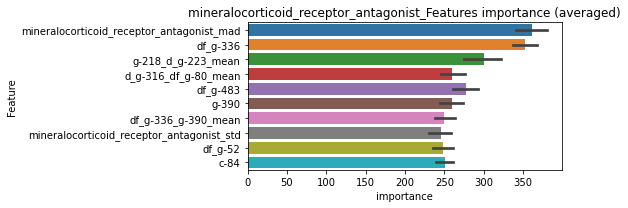

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0771385	valid_1's binary_logloss: 0.101828
[200]	training's binary_logloss: 0.021522	valid_1's binary_logloss: 0.0381717
[300]	training's binary_logloss: 0.00708161	valid_1's binary_logloss: 0.0182553
[400]	training's binary_logloss: 0.00283789	valid_1's binary_logloss: 0.01103
[500]	training's binary_logloss: 0.00145731	valid_1's binary_logloss: 0.00801122
[600]	training's binary_logloss: 0.000922554	valid_1's binary_logloss: 0.00656347
[700]	training's binary_logloss: 0.000666717	valid_1's binary_logloss: 0.00578212
[800]	training's binary_logloss: 0.000533065	valid_1's binary_logloss: 0.00536526
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000485632	valid_1's binary_logloss: 0.0052485


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0764994	valid_1's binary_logloss: 0.0948542
[200]	training's binary_logloss: 0.020581	valid_1's binary_logloss: 0.0333167
[300]	training's binary_logloss: 0.00671467	valid_1's binary_logloss: 0.0145937
[400]	training's binary_logloss: 0.00270322	valid_1's binary_logloss: 0.0080768
[500]	training's binary_logloss: 0.00141951	valid_1's binary_logloss: 0.0055712
[600]	training's binary_logloss: 0.000907496	valid_1's binary_logloss: 0.00435127
[700]	training's binary_logloss: 0.000659753	valid_1's binary_logloss: 0.0037542
[800]	training's binary_logloss: 0.00052854	valid_1's binary_logloss: 0.0034047
[900]	training's binary_logloss: 0.000467131	valid_1's binary_logloss: 0.00318811
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000459746	valid_1's binary_logloss: 0.00316936


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0755699	valid_1's binary_logloss: 0.0963407
[200]	training's binary_logloss: 0.0205143	valid_1's binary_logloss: 0.0346893
[300]	training's binary_logloss: 0.00678296	valid_1's binary_logloss: 0.0161307
[400]	training's binary_logloss: 0.0027484	valid_1's binary_logloss: 0.00979354
[500]	training's binary_logloss: 0.00143086	valid_1's binary_logloss: 0.00728986
[600]	training's binary_logloss: 0.000907761	valid_1's binary_logloss: 0.00623467
[700]	training's binary_logloss: 0.00066454	valid_1's binary_logloss: 0.00555843
[800]	training's binary_logloss: 0.000531794	valid_1's binary_logloss: 0.00530696
[900]	training's binary_logloss: 0.000477948	valid_1's binary_logloss: 0.0051569
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000478702	valid_1's binary_logloss: 0.00515169


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0774922	valid_1's binary_logloss: 0.0980586
[200]	training's binary_logloss: 0.021144	valid_1's binary_logloss: 0.0355989
[300]	training's binary_logloss: 0.00693437	valid_1's binary_logloss: 0.0167494
[400]	training's binary_logloss: 0.00277173	valid_1's binary_logloss: 0.0103525
[500]	training's binary_logloss: 0.00144181	valid_1's binary_logloss: 0.00745792
[600]	training's binary_logloss: 0.000911611	valid_1's binary_logloss: 0.00629848
[700]	training's binary_logloss: 0.000658904	valid_1's binary_logloss: 0.00559628
[800]	training's binary_logloss: 0.000529845	valid_1's binary_logloss: 0.0052991
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000489386	valid_1's binary_logloss: 0.00517397


mineralocorticoid_receptor_antagonist logloss: 0.004687329438131561


neg labels: 3289 → selected neg labels: 3289


monoacylglycerol_lipase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.068968	valid_1's binary_logloss: 0.0813569
[200]	training's binary_logloss: 0.0164656	valid_1's binary_logloss: 0.0240153
[300]	training's binary_logloss: 0.00464717	valid_1's binary_logloss: 0.00907675
[400]	training's binary_logloss: 0.00171761	valid_1's binary_logloss: 0.00452564
[500]	training's binary_logloss: 0.000879701	valid_1's binary_logloss: 0.00282661
[600]	training's binary_logloss: 0.000563494	valid_1's binary_logloss: 0.00209565
[700]	training's binary_logloss: 0.000423065	valid_1's binary_logloss: 0.001783
[800]	training's binary_logloss: 0.000367925	valid_1's binary_logloss: 0.00163175
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.000368807	valid_1's binary_logloss: 0.00162929
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0702194	valid_1's binary_logloss: 0.0793216
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0026280, Threshold: 0.0122755, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.00859, conf_1:0.01596
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0122755
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.0622755
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_3: 0.1122755
threshold: 0.1122755, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687212	valid_1's binary_logloss: 0.0801974
[200]	training's binary_logloss: 0.0156785	valid_1's binary_logloss: 0.0230849
[300]	training's binary_logloss: 0.00418151	valid_1's binary_logloss: 0.00837979
[400]	training's binary_logloss: 0.0015461	valid_1's binary_logloss: 0.00410557
[500]	training's binary_logloss: 0.000798023	valid_1's binary_logloss: 0.00274818
[600]	training's binary_logloss: 0.000519704	valid_1's binary_logloss: 0.00212208
[700]	training's binary_logloss: 0.000389518	valid_1's binary_logloss: 0.00180977
[800]	training's binary_logloss: 0.000339787	valid_1's binary_logloss: 0.0017054
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000328749	valid_1's binary_logloss: 0.00166203
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0667549	valid_1's binary_logloss: 0.076982
[200]	training's binary_logloss: 0.01

2 / 3 AUC score:1.000
y_Threshold: 0.1260813, Threshold: 0.1122755, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00050, Num_p_label: 10.0, conf_0:0.08982, conf_1:0.13473
Num_p_label: 10.0, Expected: 2.0, Adj_threshold_1: 0.1122755
Num_p_label: 7.0, Expected: 2.0, Adj_threshold_2: 0.1622755
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_3: 0.2122755
threshold: 0.2122755, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687212	valid_1's binary_logloss: 0.0801974
[200]	training's binary_logloss: 0.0156785	valid_1's binary_logloss: 0.0230849
[300]	training's binary_logloss: 0.00418151	valid_1's binary_logloss: 0.00837979
[400]	training's binary_logloss: 0.0015461	valid_1's binary_logloss: 0.00410557
[500]	training's binary_logloss: 0.000798023	valid_1's binary_logloss: 0.00274818
[600]	training's binary_logloss: 0.000519704	valid_1's binary_logloss: 0.00212208
[700]	training's binary_logloss: 0.000389518	valid_1's binary_logloss: 0.00180977
[800]	training's binary_logloss: 0.000339787	valid_1's binary_logloss: 0.0017054
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000328749	valid_1's binary_logloss: 0.00166203
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0667549	valid_1's binary_logloss: 0.076982
[200]	training's binary_logloss: 0.01

3 / 3 AUC score:1.000
y_Threshold: 0.1260813, Threshold: 0.2122755, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.19105, conf_1:0.23350
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.2122755
threshold: 0.2122755, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


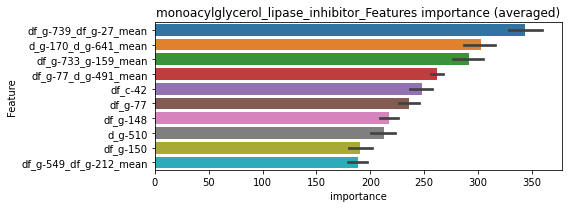

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0697134	valid_1's binary_logloss: 0.0807296
[200]	training's binary_logloss: 0.0161862	valid_1's binary_logloss: 0.0235214
[300]	training's binary_logloss: 0.0042719	valid_1's binary_logloss: 0.00814321
[400]	training's binary_logloss: 0.00157314	valid_1's binary_logloss: 0.00383547
[500]	training's binary_logloss: 0.000807486	valid_1's binary_logloss: 0.00246425
[600]	training's binary_logloss: 0.000524284	valid_1's binary_logloss: 0.00191574
[700]	training's binary_logloss: 0.000392254	valid_1's binary_logloss: 0.00160984
[800]	training's binary_logloss: 0.00033614	valid_1's binary_logloss: 0.0014596
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.000332219	valid_1's binary_logloss: 0.00144972


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679986	valid_1's binary_logloss: 0.0773899
[200]	training's binary_logloss: 0.0159047	valid_1's binary_logloss: 0.0218402
[300]	training's binary_logloss: 0.0042505	valid_1's binary_logloss: 0.00724294
[400]	training's binary_logloss: 0.00159627	valid_1's binary_logloss: 0.00327132
[500]	training's binary_logloss: 0.000812646	valid_1's binary_logloss: 0.00184067
[600]	training's binary_logloss: 0.000524169	valid_1's binary_logloss: 0.0013092
[700]	training's binary_logloss: 0.000393908	valid_1's binary_logloss: 0.00104788
[800]	training's binary_logloss: 0.000343589	valid_1's binary_logloss: 0.000955945
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000337859	valid_1's binary_logloss: 0.000945995


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.068147	valid_1's binary_logloss: 0.0758406
[200]	training's binary_logloss: 0.0157016	valid_1's binary_logloss: 0.0196415
[300]	training's binary_logloss: 0.00429807	valid_1's binary_logloss: 0.00620258
[400]	training's binary_logloss: 0.00156139	valid_1's binary_logloss: 0.00259101
[500]	training's binary_logloss: 0.000807971	valid_1's binary_logloss: 0.00147769
[600]	training's binary_logloss: 0.000522749	valid_1's binary_logloss: 0.00100841
[700]	training's binary_logloss: 0.000394817	valid_1's binary_logloss: 0.000809782
[800]	training's binary_logloss: 0.000340573	valid_1's binary_logloss: 0.000721876
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.00033897	valid_1's binary_logloss: 0.000719387


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.067292	valid_1's binary_logloss: 0.0809572
[200]	training's binary_logloss: 0.0152272	valid_1's binary_logloss: 0.0227254
[300]	training's binary_logloss: 0.0041143	valid_1's binary_logloss: 0.00846428
[400]	training's binary_logloss: 0.00153189	valid_1's binary_logloss: 0.00423265
[500]	training's binary_logloss: 0.000780041	valid_1's binary_logloss: 0.0027829
[600]	training's binary_logloss: 0.000506256	valid_1's binary_logloss: 0.00235246
[700]	training's binary_logloss: 0.000384857	valid_1's binary_logloss: 0.00209951
[800]	training's binary_logloss: 0.000331357	valid_1's binary_logloss: 0.00194682
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000329356	valid_1's binary_logloss: 0.00193792


monoacylglycerol_lipase_inhibitor logloss: 0.0012641283300832758


neg labels: 3289 → selected neg labels: 3280


monoamine_oxidase_inhibitor, len(trt): 85, len(othr): 3280, target_rate: 0.0035693 → Adj_target_rate: 0.0036661
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144622	valid_1's binary_logloss: 0.236149
[200]	training's binary_logloss: 0.0667664	valid_1's binary_logloss: 0.170918
[300]	training's binary_logloss: 0.0331408	valid_1's binary_logloss: 0.137583
[400]	training's binary_logloss: 0.0170169	valid_1's binary_logloss: 0.117517
[500]	training's binary_logloss: 0.0094476	valid_1's binary_logloss: 0.108673
[600]	training's binary_logloss: 0.00559095	valid_1's binary_logloss: 0.10258
[700]	training's binary_logloss: 0.00359651	valid_1's binary_logloss: 0.0990474
[800]	training's binary_logloss: 0.00250926	valid_1's binary_logloss: 0.0974497
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.00246748	valid_1's binary_logloss: 0.0972788
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151155	valid_1's binary_logloss: 0.237528
[200]	training's binary_logloss: 0.0708949	valid_1's binary

1 / 3 AUC score:0.984
y_Threshold: 0.0333165, Threshold: 0.3724170, pos_neg_ratio: 0.8000000
Remove_noisy_data: 182 → Positive_corect_labels: 631/3754
p_label_rate: 0.0100452 Vs.target_rate: 0.00357, Num_p_label: 40.0, conf_0:0.26069, conf_1:0.48414
Num_p_label: 40.0, Expected: 14.2, Adj_threshold_1: 0.3724170
Num_p_label: 33.0, Expected: 14.2, Adj_threshold_2: 0.4224170
Num_p_label: 31.0, Expected: 14.2, Adj_threshold_3: 0.4724170
Num_p_label: 27.0, Expected: 14.2, Adj_threshold_4: 0.5224170
Num_p_label: 24.0, Expected: 14.2, Adj_threshold_5: 0.5724170
Num_p_label: 21.0, Expected: 14.2, Adj_threshold_6: 0.6224170
threshold: 0.6224170, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 631.0/3754, y_label_rate: 0.1680874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126209	valid_1's binary_logloss: 0.202276
[200]	training's binary_logloss: 0.0512609	valid_1's binary_logloss: 0.134863
[300]	training's binary_logloss: 0.0242987	valid_1's binary_logloss: 0.10507
[400]	training's binary_logloss: 0.0121555	valid_1's binary_logloss: 0.0882245
[500]	training's binary_logloss: 0.0064118	valid_1's binary_logloss: 0.0794649
[600]	training's binary_logloss: 0.00376282	valid_1's binary_logloss: 0.0737015
[700]	training's binary_logloss: 0.0024687	valid_1's binary_logloss: 0.0704071
[800]	training's binary_logloss: 0.00178793	valid_1's binary_logloss: 0.0687557
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.00173528	valid_1's binary_logloss: 0.0685924
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127136	valid_1's binary_logloss: 0.197449
[200]	training's binary_logloss: 0.0533693	valid_1's bina

2 / 3 AUC score:0.992
y_Threshold: 0.1250359, Threshold: 0.6224170, pos_neg_ratio: 0.8000000
Remove_noisy_data: 66 → Positive_corect_labels: 598.0/3688
p_label_rate: 0.0205927 Vs.target_rate: 0.00357, Num_p_label: 82.0, conf_0:0.49793, conf_1:0.74690
Num_p_label: 82.0, Expected: 14.2, Adj_threshold_1: 0.6224170
Num_p_label: 78.0, Expected: 14.2, Adj_threshold_2: 0.6724170
Num_p_label: 74.0, Expected: 14.2, Adj_threshold_3: 0.7224170
Num_p_label: 69.0, Expected: 14.2, Adj_threshold_4: 0.7724170
threshold: 0.7724170, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 598.0/3688, y_label_rate: 0.1621475
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111432	valid_1's binary_logloss: 0.174159
[200]	training's binary_logloss: 0.0425085	valid_1's binary_logloss: 0.109361
[300]	training's binary_logloss: 0.0181717	valid_1's binary_logloss: 0.0778296
[400]	training's binary_logloss: 0.00859305	valid_1's binary_logloss: 0.0623407
[500]	training's binary_logloss: 0.00451049	valid_1's binary_logloss: 0.0548088
[600]	training's binary_logloss: 0.0027296	valid_1's binary_logloss: 0.0500258
[700]	training's binary_logloss: 0.00185848	valid_1's binary_logloss: 0.0481072
[800]	training's binary_logloss: 0.00138266	valid_1's binary_logloss: 0.0469197
Early stopping, best iteration is:
[790]	training's binary_logloss: 0.00141626	valid_1's binary_logloss: 0.0468662
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114696	valid_1's binary_logloss: 0.172769
[200]	training's binary_logloss: 0.0438389	valid_1's 

3 / 3 AUC score:0.998
y_Threshold: 0.0858149, Threshold: 0.7724170, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 580.0/3652
p_label_rate: 0.0256153 Vs.target_rate: 0.00357, Num_p_label: 102.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 102.0, Expected: 14.2, Adj_threshold_1: 0.7724170
threshold: 0.7724170, positive_p_label: 102.0/3982, p_label_rate: 0.0256153
positive_y_label: 580.0/3652, y_label_rate: 0.1588171


len(train_index) : 2739
len(valid_index) : 913
================================= fold 1/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106716	valid_1's binary_logloss: 0.168854
[200]	training's binary_logloss: 0.0387868	valid_1's binary_logloss: 0.106047
[300]	training's binary_logloss: 0.0157593	valid_1's binary_logloss: 0.0798759
[400]	training's binary_logloss: 0.00715424	valid_1's binary_logloss: 0.0703774
[500]	training's binary_logloss: 0.0036847	valid_1's binary_logloss: 0.0634579
[600]	training's binary_logloss: 0.00223067	valid_1's binary_logloss: 0.0609525
Early stopping, best iteration is:
[619]	training's binary_logloss: 0.00205731	valid_1's binary_logloss: 0.0605365


len(train_index) : 2739
len(valid_index) : 913
================================= fold 2/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106861	valid_1's binary_logloss: 0.157688
[200]	training's binary_logloss: 0.039524	valid_1's binary_logloss: 0.096051
[300]	training's binary_logloss: 0.0163808	valid_1's binary_logloss: 0.0711783
[400]	training's binary_logloss: 0.00756771	valid_1's binary_logloss: 0.0603637
[500]	training's binary_logloss: 0.00389272	valid_1's binary_logloss: 0.0549753
[600]	training's binary_logloss: 0.00234997	valid_1's binary_logloss: 0.0525048
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.00185491	valid_1's binary_logloss: 0.0514363


len(train_index) : 2739
len(valid_index) : 913
================================= fold 3/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106795	valid_1's binary_logloss: 0.149122
[200]	training's binary_logloss: 0.0386121	valid_1's binary_logloss: 0.0892426
[300]	training's binary_logloss: 0.0157157	valid_1's binary_logloss: 0.0678112
[400]	training's binary_logloss: 0.00706353	valid_1's binary_logloss: 0.059825
[500]	training's binary_logloss: 0.0036773	valid_1's binary_logloss: 0.0567107
[600]	training's binary_logloss: 0.00223531	valid_1's binary_logloss: 0.0560844
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.00231651	valid_1's binary_logloss: 0.0559637


len(train_index) : 2739
len(valid_index) : 913
================================= fold 4/4 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106598	valid_1's binary_logloss: 0.178143
[200]	training's binary_logloss: 0.0385176	valid_1's binary_logloss: 0.11025
[300]	training's binary_logloss: 0.0159777	valid_1's binary_logloss: 0.0817225
[400]	training's binary_logloss: 0.00719156	valid_1's binary_logloss: 0.0659876
[500]	training's binary_logloss: 0.00371855	valid_1's binary_logloss: 0.0587028
[600]	training's binary_logloss: 0.00223844	valid_1's binary_logloss: 0.0546282
[700]	training's binary_logloss: 0.00153341	valid_1's binary_logloss: 0.0512028
Early stopping, best iteration is:
[763]	training's binary_logloss: 0.00128031	valid_1's binary_logloss: 0.0504666


monoamine_oxidase_inhibitor logloss: 0.054600795290218135


neg labels: 3289 → selected neg labels: 3287


monopolar_spindle_1_kinase_inhibitor, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0769507	valid_1's binary_logloss: 0.0917969
[200]	training's binary_logloss: 0.0209679	valid_1's binary_logloss: 0.0309578
[300]	training's binary_logloss: 0.00624054	valid_1's binary_logloss: 0.0126277
[400]	training's binary_logloss: 0.00237886	valid_1's binary_logloss: 0.00684753
[500]	training's binary_logloss: 0.00123074	valid_1's binary_logloss: 0.00491568
[600]	training's binary_logloss: 0.000793136	valid_1's binary_logloss: 0.00405352
[700]	training's binary_logloss: 0.000588994	valid_1's binary_logloss: 0.00365078
[800]	training's binary_logloss: 0.000480342	valid_1's binary_logloss: 0.0034202
[900]	training's binary_logloss: 0.000429064	valid_1's binary_logloss: 0.0032777
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.000426169	valid_1's binary_logloss: 0.00327247
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.

1 / 3 AUC score:1.000
y_Threshold: 0.0038174, Threshold: 0.0352637, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02468, conf_1:0.04584
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0352637
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_2: 0.0852637
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_3: 0.1352637
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.1852637
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.2352637
threshold: 0.2352637, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738318	valid_1's binary_logloss: 0.0846955
[200]	training's binary_logloss: 0.0187985	valid_1's binary_logloss: 0.025231
[300]	training's binary_logloss: 0.00547153	valid_1's binary_logloss: 0.00886062
[400]	training's binary_logloss: 0.00211643	valid_1's binary_logloss: 0.00413095
[500]	training's binary_logloss: 0.00108902	valid_1's binary_logloss: 0.00248703
[600]	training's binary_logloss: 0.000711626	valid_1's binary_logloss: 0.00178186
[700]	training's binary_logloss: 0.000531373	valid_1's binary_logloss: 0.00145596
[800]	training's binary_logloss: 0.000437341	valid_1's binary_logloss: 0.00126772
[900]	training's binary_logloss: 0.000405234	valid_1's binary_logloss: 0.00121124
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000405234	valid_1's binary_logloss: 0.00121124
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1070353, Threshold: 0.2352637, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.18821, conf_1:0.28232
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.2352637
Num_p_label: 22.0, Expected: 3.0, Adj_threshold_2: 0.2852637
Num_p_label: 20.0, Expected: 3.0, Adj_threshold_3: 0.3352637
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_4: 0.3852637
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_5: 0.4352637
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_6: 0.4852637
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_7: 0.5352637
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_8: 0.5852637
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_9: 0.6352637
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_10: 0.6852637
threshold: 0.6852637, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
==============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0738318	valid_1's binary_logloss: 0.0846955
[200]	training's binary_logloss: 0.0187985	valid_1's binary_logloss: 0.025231
[300]	training's binary_logloss: 0.00547153	valid_1's binary_logloss: 0.00886062
[400]	training's binary_logloss: 0.00211643	valid_1's binary_logloss: 0.00413095
[500]	training's binary_logloss: 0.00108902	valid_1's binary_logloss: 0.00248703
[600]	training's binary_logloss: 0.000711626	valid_1's binary_logloss: 0.00178186
[700]	training's binary_logloss: 0.000531373	valid_1's binary_logloss: 0.00145596
[800]	training's binary_logloss: 0.000437341	valid_1's binary_logloss: 0.00126772
[900]	training's binary_logloss: 0.000405234	valid_1's binary_logloss: 0.00121124
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000405234	valid_1's binary_logloss: 0.00121124
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1070353, Threshold: 0.6852637, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0015068 Vs.target_rate: 0.00076, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.75379
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_1: 0.6852637
threshold: 0.6852637, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


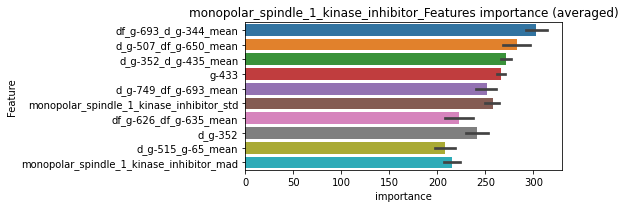

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0734268	valid_1's binary_logloss: 0.0856437
[200]	training's binary_logloss: 0.018688	valid_1's binary_logloss: 0.0257203
[300]	training's binary_logloss: 0.0053992	valid_1's binary_logloss: 0.00917161
[400]	training's binary_logloss: 0.00212	valid_1's binary_logloss: 0.00425076
[500]	training's binary_logloss: 0.0011	valid_1's binary_logloss: 0.00254607
[600]	training's binary_logloss: 0.000705432	valid_1's binary_logloss: 0.00181471
[700]	training's binary_logloss: 0.000529481	valid_1's binary_logloss: 0.0014767
[800]	training's binary_logloss: 0.000436166	valid_1's binary_logloss: 0.0012991
[900]	training's binary_logloss: 0.000403387	valid_1's binary_logloss: 0.00123705
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000403237	valid_1's binary_logloss: 0.0012364


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703323	valid_1's binary_logloss: 0.0959313
[200]	training's binary_logloss: 0.0172374	valid_1's binary_logloss: 0.0348632
[300]	training's binary_logloss: 0.00512056	valid_1's binary_logloss: 0.0156291
[400]	training's binary_logloss: 0.0020024	valid_1's binary_logloss: 0.00920684
[500]	training's binary_logloss: 0.00104612	valid_1's binary_logloss: 0.00654645
[600]	training's binary_logloss: 0.000686318	valid_1's binary_logloss: 0.0055004
[700]	training's binary_logloss: 0.000511918	valid_1's binary_logloss: 0.00473736
[800]	training's binary_logloss: 0.000425825	valid_1's binary_logloss: 0.00446289
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000416799	valid_1's binary_logloss: 0.00439105


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0728496	valid_1's binary_logloss: 0.0875871
[200]	training's binary_logloss: 0.018142	valid_1's binary_logloss: 0.0263735
[300]	training's binary_logloss: 0.00534128	valid_1's binary_logloss: 0.0098766
[400]	training's binary_logloss: 0.00207687	valid_1's binary_logloss: 0.00501145
[500]	training's binary_logloss: 0.00107762	valid_1's binary_logloss: 0.00334242
[600]	training's binary_logloss: 0.000697284	valid_1's binary_logloss: 0.00265922
[700]	training's binary_logloss: 0.000522928	valid_1's binary_logloss: 0.00228765
[800]	training's binary_logloss: 0.000433087	valid_1's binary_logloss: 0.00215157
[900]	training's binary_logloss: 0.000399664	valid_1's binary_logloss: 0.00210129
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000399778	valid_1's binary_logloss: 0.00210061


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0746468	valid_1's binary_logloss: 0.0870545
[200]	training's binary_logloss: 0.0191531	valid_1's binary_logloss: 0.0255384
[300]	training's binary_logloss: 0.00555544	valid_1's binary_logloss: 0.00874288
[400]	training's binary_logloss: 0.00214579	valid_1's binary_logloss: 0.0039087
[500]	training's binary_logloss: 0.00110777	valid_1's binary_logloss: 0.00221067
[600]	training's binary_logloss: 0.00072198	valid_1's binary_logloss: 0.00154915
[700]	training's binary_logloss: 0.000539725	valid_1's binary_logloss: 0.00121317
[800]	training's binary_logloss: 0.000442556	valid_1's binary_logloss: 0.00103991
Early stopping, best iteration is:
[867]	training's binary_logloss: 0.000416659	valid_1's binary_logloss: 0.000999051


monopolar_spindle_1_kinase_inhibitor logloss: 0.0021817761208053816


neg labels: 3289 → selected neg labels: 3269


mtor_inhibitor, len(trt): 130, len(othr): 3269, target_rate: 0.0054590 → Adj_target_rate: 0.0052608
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.183399	valid_1's binary_logloss: 0.275532
[200]	training's binary_logloss: 0.0997359	valid_1's binary_logloss: 0.212969
[300]	training's binary_logloss: 0.0573505	valid_1's binary_logloss: 0.179526
[400]	training's binary_logloss: 0.0339943	valid_1's binary_logloss: 0.160384
[500]	training's binary_logloss: 0.0199185	valid_1's binary_logloss: 0.147285
[600]	training's binary_logloss: 0.0121758	valid_1's binary_logloss: 0.138904
[700]	training's binary_logloss: 0.00777238	valid_1's binary_logloss: 0.135254
[800]	training's binary_logloss: 0.00521967	valid_1's binary_logloss: 0.132998
[900]	training's binary_logloss: 0.00370771	valid_1's binary_logloss: 0.131562
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00365143	valid_1's binary_logloss: 0.131261
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.177573	valid_1's binary_l

1 / 3 AUC score:0.974
y_Threshold: 0.0670510, Threshold: 0.4047630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 224 → Positive_corect_labels: 607/3698
p_label_rate: 0.0100452 Vs.target_rate: 0.00546, Num_p_label: 40.0, conf_0:0.28333, conf_1:0.52619
Num_p_label: 40.0, Expected: 21.7, Adj_threshold_1: 0.4047630
Num_p_label: 34.0, Expected: 21.7, Adj_threshold_2: 0.4547630
Num_p_label: 24.0, Expected: 21.7, Adj_threshold_3: 0.5047630
threshold: 0.5047630, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 607.0/3698, y_label_rate: 0.1641428
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.158437	valid_1's binary_logloss: 0.235221
[200]	training's binary_logloss: 0.0775098	valid_1's binary_logloss: 0.170851
[300]	training's binary_logloss: 0.0397259	valid_1's binary_logloss: 0.13785
[400]	training's binary_logloss: 0.0210825	valid_1's binary_logloss: 0.119699
[500]	training's binary_logloss: 0.0117076	valid_1's binary_logloss: 0.109408
[600]	training's binary_logloss: 0.00690278	valid_1's binary_logloss: 0.103436
[700]	training's binary_logloss: 0.00441101	valid_1's binary_logloss: 0.0993195
[800]	training's binary_logloss: 0.00307019	valid_1's binary_logloss: 0.0977757
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00264213	valid_1's binary_logloss: 0.0969884
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.152348	valid_1's binary_logloss: 0.247688
[200]	training's binary_logloss: 0.0731715	valid_1's binary

2 / 3 AUC score:0.989
y_Threshold: 0.1239261, Threshold: 0.5047630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 104 → Positive_corect_labels: 555.0/3594
p_label_rate: 0.0208438 Vs.target_rate: 0.00546, Num_p_label: 83.0, conf_0:0.40381, conf_1:0.60572
Num_p_label: 83.0, Expected: 21.7, Adj_threshold_1: 0.5047630
Num_p_label: 68.0, Expected: 21.7, Adj_threshold_2: 0.5547630
Num_p_label: 57.0, Expected: 21.7, Adj_threshold_3: 0.6047630
Num_p_label: 52.0, Expected: 21.7, Adj_threshold_4: 0.6547630
Num_p_label: 36.0, Expected: 21.7, Adj_threshold_5: 0.7047630
Num_p_label: 26.0, Expected: 21.7, Adj_threshold_6: 0.7547630
threshold: 0.7547630, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 555.0/3594, y_label_rate: 0.1544240
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13662	valid_1's binary_logloss: 0.194845
[200]	training's binary_logloss: 0.0602902	valid_1's binary_logloss: 0.128894
[300]	training's binary_logloss: 0.0284747	valid_1's binary_logloss: 0.0970437
[400]	training's binary_logloss: 0.0146864	valid_1's binary_logloss: 0.0802129
[500]	training's binary_logloss: 0.00796716	valid_1's binary_logloss: 0.0730996
[600]	training's binary_logloss: 0.00472568	valid_1's binary_logloss: 0.067835
[700]	training's binary_logloss: 0.00310654	valid_1's binary_logloss: 0.066481
[800]	training's binary_logloss: 0.0022224	valid_1's binary_logloss: 0.0655984
Early stopping, best iteration is:
[779]	training's binary_logloss: 0.00236323	valid_1's binary_logloss: 0.0654812
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138606	valid_1's binary_logloss: 0.195387
[200]	training's binary_logloss: 0.0603772	valid_1's bina

3 / 3 AUC score:0.993
y_Threshold: 0.1136264, Threshold: 0.7547630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 524.0/3532
p_label_rate: 0.0138122 Vs.target_rate: 0.00546, Num_p_label: 55.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 55.0, Expected: 21.7, Adj_threshold_1: 0.7547630
threshold: 0.7547630, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 524.0/3532, y_label_rate: 0.1483579


len(train_index) : 2649
len(valid_index) : 883
================================= fold 1/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121665	valid_1's binary_logloss: 0.189384
[200]	training's binary_logloss: 0.0499094	valid_1's binary_logloss: 0.120861
[300]	training's binary_logloss: 0.0227275	valid_1's binary_logloss: 0.0892703
[400]	training's binary_logloss: 0.0110949	valid_1's binary_logloss: 0.0737658
[500]	training's binary_logloss: 0.00596419	valid_1's binary_logloss: 0.06471
[600]	training's binary_logloss: 0.003576	valid_1's binary_logloss: 0.0601323
[700]	training's binary_logloss: 0.0024042	valid_1's binary_logloss: 0.0582712
[800]	training's binary_logloss: 0.00177268	valid_1's binary_logloss: 0.0567608
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00161468	valid_1's binary_logloss: 0.0562051


len(train_index) : 2649
len(valid_index) : 883
================================= fold 2/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127478	valid_1's binary_logloss: 0.184161
[200]	training's binary_logloss: 0.0523509	valid_1's binary_logloss: 0.114018
[300]	training's binary_logloss: 0.0241333	valid_1's binary_logloss: 0.0823436
[400]	training's binary_logloss: 0.0116976	valid_1's binary_logloss: 0.065456
[500]	training's binary_logloss: 0.00621251	valid_1's binary_logloss: 0.0564034
[600]	training's binary_logloss: 0.00371518	valid_1's binary_logloss: 0.0519756
[700]	training's binary_logloss: 0.00246747	valid_1's binary_logloss: 0.0491607
[800]	training's binary_logloss: 0.00180944	valid_1's binary_logloss: 0.0482568
[900]	training's binary_logloss: 0.00142648	valid_1's binary_logloss: 0.0472311
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.00133775	valid_1's binary_logloss: 0.0469189


len(train_index) : 2649
len(valid_index) : 883
================================= fold 3/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127268	valid_1's binary_logloss: 0.178778
[200]	training's binary_logloss: 0.0527257	valid_1's binary_logloss: 0.108857
[300]	training's binary_logloss: 0.0241713	valid_1's binary_logloss: 0.0766024
[400]	training's binary_logloss: 0.0122061	valid_1's binary_logloss: 0.060942
[500]	training's binary_logloss: 0.00646294	valid_1's binary_logloss: 0.0518911
[600]	training's binary_logloss: 0.00382342	valid_1's binary_logloss: 0.0468774
[700]	training's binary_logloss: 0.00253086	valid_1's binary_logloss: 0.0438536
[800]	training's binary_logloss: 0.00184434	valid_1's binary_logloss: 0.0422922
[900]	training's binary_logloss: 0.00144239	valid_1's binary_logloss: 0.0409789
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.00143612	valid_1's binary_logloss: 0.0409311


len(train_index) : 2649
len(valid_index) : 883
================================= fold 4/4 mtor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122508	valid_1's binary_logloss: 0.190611
[200]	training's binary_logloss: 0.0502145	valid_1's binary_logloss: 0.126288
[300]	training's binary_logloss: 0.0230229	valid_1's binary_logloss: 0.0968466
[400]	training's binary_logloss: 0.0111112	valid_1's binary_logloss: 0.0831495
[500]	training's binary_logloss: 0.00600903	valid_1's binary_logloss: 0.076772
[600]	training's binary_logloss: 0.00363469	valid_1's binary_logloss: 0.0733365
[700]	training's binary_logloss: 0.00242544	valid_1's binary_logloss: 0.0715969
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00255855	valid_1's binary_logloss: 0.0712674


mtor_inhibitor logloss: 0.05383061146059264


neg labels: 3289 → selected neg labels: 3288


mucolytic_agent, len(trt): 48, len(othr): 3288, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112724	valid_1's binary_logloss: 0.167146
[200]	training's binary_logloss: 0.0407681	valid_1's binary_logloss: 0.0928424
[300]	training's binary_logloss: 0.0177328	valid_1's binary_logloss: 0.0617503
[400]	training's binary_logloss: 0.00811484	valid_1's binary_logloss: 0.0464798
[500]	training's binary_logloss: 0.00422925	valid_1's binary_logloss: 0.037847
[600]	training's binary_logloss: 0.00253546	valid_1's binary_logloss: 0.0338792
[700]	training's binary_logloss: 0.00172023	valid_1's binary_logloss: 0.0326215
[800]	training's binary_logloss: 0.00128665	valid_1's binary_logloss: 0.0312754
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.00115961	valid_1's binary_logloss: 0.0309053
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1114	valid_1's binary_logloss: 0.164979
[200]	training's binary_logloss: 0.0411786	valid_1's b

1 / 3 AUC score:0.998
y_Threshold: 0.0204636, Threshold: 0.1745401, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 653/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.12218, conf_1:0.22690
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1745401
Num_p_label: 33.0, Expected: 8.0, Adj_threshold_2: 0.2245401
Num_p_label: 26.0, Expected: 8.0, Adj_threshold_3: 0.2745401
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_4: 0.3245401
threshold: 0.3245401, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 653.0/3805, y_label_rate: 0.1716163
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107407	valid_1's binary_logloss: 0.158827
[200]	training's binary_logloss: 0.0359042	valid_1's binary_logloss: 0.0852022
[300]	training's binary_logloss: 0.0142299	valid_1's binary_logloss: 0.056785
[400]	training's binary_logloss: 0.00642485	valid_1's binary_logloss: 0.0441711
[500]	training's binary_logloss: 0.00333746	valid_1's binary_logloss: 0.0375228
[600]	training's binary_logloss: 0.00203546	valid_1's binary_logloss: 0.034266
[700]	training's binary_logloss: 0.00141964	valid_1's binary_logloss: 0.0326778
[800]	training's binary_logloss: 0.00108261	valid_1's binary_logloss: 0.0316982
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000982456	valid_1's binary_logloss: 0.0316712
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109642	valid_1's binary_logloss: 0.161802
[200]	training's binary_logloss: 0.0374231	valid_1's

2 / 3 AUC score:0.998
y_Threshold: 0.0939817, Threshold: 0.3245401, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 639.0/3777
p_label_rate: 0.0170768 Vs.target_rate: 0.00202, Num_p_label: 68.0, conf_0:0.25963, conf_1:0.38945
Num_p_label: 68.0, Expected: 8.0, Adj_threshold_1: 0.3245401
Num_p_label: 58.0, Expected: 8.0, Adj_threshold_2: 0.3745401
Num_p_label: 48.0, Expected: 8.0, Adj_threshold_3: 0.4245401
Num_p_label: 46.0, Expected: 8.0, Adj_threshold_4: 0.4745401
Num_p_label: 43.0, Expected: 8.0, Adj_threshold_5: 0.5245401
Num_p_label: 36.0, Expected: 8.0, Adj_threshold_6: 0.5745401
Num_p_label: 32.0, Expected: 8.0, Adj_threshold_7: 0.6245401
Num_p_label: 27.0, Expected: 8.0, Adj_threshold_8: 0.6745401
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_9: 0.7245401
Num_p_label: 19.0, Expected: 8.0, Adj_threshold_10: 0.7745401
threshold: 0.7745401, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 639.0/3777, y_label_rate: 0.1691819
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104651	valid_1's binary_logloss: 0.140018
[200]	training's binary_logloss: 0.0345366	valid_1's binary_logloss: 0.0668674
[300]	training's binary_logloss: 0.0134164	valid_1's binary_logloss: 0.037644
[400]	training's binary_logloss: 0.00592919	valid_1's binary_logloss: 0.0248212
[500]	training's binary_logloss: 0.00310159	valid_1's binary_logloss: 0.0182391
[600]	training's binary_logloss: 0.00190722	valid_1's binary_logloss: 0.0151021
[700]	training's binary_logloss: 0.00133917	valid_1's binary_logloss: 0.0135467
[800]	training's binary_logloss: 0.00103133	valid_1's binary_logloss: 0.0124571
[900]	training's binary_logloss: 0.000847753	valid_1's binary_logloss: 0.0117103
[1000]	training's binary_logloss: 0.000735866	valid_1's binary_logloss: 0.0114663
[1100]	training's binary_logloss: 0.000688945	valid_1's binary_logloss: 0.0112384
[1200]	training's binary_logloss: 0.000662104	valid_1's bina

3 / 3 AUC score:1.000
y_Threshold: 0.1111042, Threshold: 0.7745401, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 635.0/3769
p_label_rate: 0.0087896 Vs.target_rate: 0.00202, Num_p_label: 35.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_1: 0.7745401
threshold: 0.7745401, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 635.0/3769, y_label_rate: 0.1684797


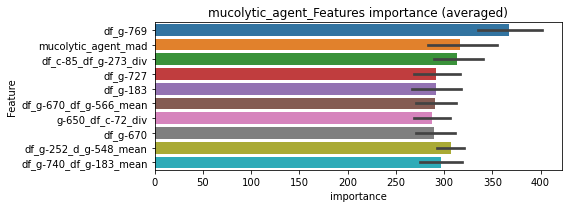

len(train_index) : 2826
len(valid_index) : 943
================================= fold 1/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102303	valid_1's binary_logloss: 0.159837
[200]	training's binary_logloss: 0.0321837	valid_1's binary_logloss: 0.0879998
[300]	training's binary_logloss: 0.0121839	valid_1's binary_logloss: 0.0562721
[400]	training's binary_logloss: 0.00536365	valid_1's binary_logloss: 0.0425499
[500]	training's binary_logloss: 0.00280707	valid_1's binary_logloss: 0.0372957
[600]	training's binary_logloss: 0.00174357	valid_1's binary_logloss: 0.0339634
[700]	training's binary_logloss: 0.00124148	valid_1's binary_logloss: 0.0327264
Early stopping, best iteration is:
[680]	training's binary_logloss: 0.00131354	valid_1's binary_logloss: 0.0324973


len(train_index) : 2827
len(valid_index) : 942
================================= fold 2/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103447	valid_1's binary_logloss: 0.136717
[200]	training's binary_logloss: 0.0338665	valid_1's binary_logloss: 0.062767
[300]	training's binary_logloss: 0.0131194	valid_1's binary_logloss: 0.0345462
[400]	training's binary_logloss: 0.0057652	valid_1's binary_logloss: 0.0220503
[500]	training's binary_logloss: 0.0030301	valid_1's binary_logloss: 0.0158988
[600]	training's binary_logloss: 0.00187085	valid_1's binary_logloss: 0.0130874
[700]	training's binary_logloss: 0.00131071	valid_1's binary_logloss: 0.0113882
[800]	training's binary_logloss: 0.0010082	valid_1's binary_logloss: 0.0103494
[900]	training's binary_logloss: 0.000830511	valid_1's binary_logloss: 0.00952679
Early stopping, best iteration is:
[926]	training's binary_logloss: 0.000797209	valid_1's binary_logloss: 0.00935516


len(train_index) : 2827
len(valid_index) : 942
================================= fold 3/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10336	valid_1's binary_logloss: 0.149162
[200]	training's binary_logloss: 0.0340237	valid_1's binary_logloss: 0.0765247
[300]	training's binary_logloss: 0.0129785	valid_1's binary_logloss: 0.0480643
[400]	training's binary_logloss: 0.00565701	valid_1's binary_logloss: 0.0361723
[500]	training's binary_logloss: 0.00294405	valid_1's binary_logloss: 0.030595
[600]	training's binary_logloss: 0.00180825	valid_1's binary_logloss: 0.0283912
[700]	training's binary_logloss: 0.00127387	valid_1's binary_logloss: 0.027044
[800]	training's binary_logloss: 0.000983663	valid_1's binary_logloss: 0.0260007
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000869186	valid_1's binary_logloss: 0.0253597


len(train_index) : 2827
len(valid_index) : 942
================================= fold 4/4 mucolytic_agent=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102708	valid_1's binary_logloss: 0.144537
[200]	training's binary_logloss: 0.0333327	valid_1's binary_logloss: 0.0766402
[300]	training's binary_logloss: 0.012813	valid_1's binary_logloss: 0.0493999
[400]	training's binary_logloss: 0.00560853	valid_1's binary_logloss: 0.0348763
[500]	training's binary_logloss: 0.00294518	valid_1's binary_logloss: 0.0281409
[600]	training's binary_logloss: 0.00181615	valid_1's binary_logloss: 0.024479
[700]	training's binary_logloss: 0.00128734	valid_1's binary_logloss: 0.0229703
[800]	training's binary_logloss: 0.000985468	valid_1's binary_logloss: 0.0215101
[900]	training's binary_logloss: 0.000814922	valid_1's binary_logloss: 0.0207726
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000775617	valid_1's binary_logloss: 0.0204669


mucolytic_agent logloss: 0.0219225830554204


neg labels: 3289 → selected neg labels: 3281


neuropeptide_receptor_antagonist, len(trt): 37, len(othr): 3281, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100521	valid_1's binary_logloss: 0.148903
[200]	training's binary_logloss: 0.033982	valid_1's binary_logloss: 0.0766781
[300]	training's binary_logloss: 0.0133609	valid_1's binary_logloss: 0.0463117
[400]	training's binary_logloss: 0.0057178	valid_1's binary_logloss: 0.0327018
[500]	training's binary_logloss: 0.00292218	valid_1's binary_logloss: 0.0253943
[600]	training's binary_logloss: 0.0017848	valid_1's binary_logloss: 0.0220103
[700]	training's binary_logloss: 0.00123123	valid_1's binary_logloss: 0.0200066
[800]	training's binary_logloss: 0.000949758	valid_1's binary_logloss: 0.0189132
[900]	training's binary_logloss: 0.000786153	valid_1's binary_logloss: 0.0183052
[1000]	training's binary_logloss: 0.000704891	valid_1's binary_logloss: 0.0180423
[1100]	training's binary_logloss: 0.000663799	valid_1's binary_logloss: 0.0179333
[1200]	training's binary_logloss: 0.000638098	valid_1's binar

1 / 3 AUC score:1.000
y_Threshold: 0.0119385, Threshold: 0.0650748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.04555, conf_1:0.08460
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0650748
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.1150748
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_3: 0.1650748
threshold: 0.1650748, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 655.0/3803, y_label_rate: 0.1722324
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0979042	valid_1's binary_logloss: 0.140425
[200]	training's binary_logloss: 0.0309436	valid_1's binary_logloss: 0.0682276
[300]	training's binary_logloss: 0.0113742	valid_1's binary_logloss: 0.041422
[400]	training's binary_logloss: 0.00484636	valid_1's binary_logloss: 0.0295563
[500]	training's binary_logloss: 0.00249613	valid_1's binary_logloss: 0.0236684
[600]	training's binary_logloss: 0.00154077	valid_1's binary_logloss: 0.0208165
[700]	training's binary_logloss: 0.00108871	valid_1's binary_logloss: 0.0194902
[800]	training's binary_logloss: 0.000841718	valid_1's binary_logloss: 0.0184937
[900]	training's binary_logloss: 0.000698706	valid_1's binary_logloss: 0.0181205
[1000]	training's binary_logloss: 0.000625507	valid_1's binary_logloss: 0.018022
Early stopping, best iteration is:
[1010]	training's binary_logloss: 0.000618637	valid_1's binary_logloss: 0.0179671
Training until validatio

2 / 3 AUC score:1.000
y_Threshold: 0.0992063, Threshold: 0.1650748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 650.0/3793
p_label_rate: 0.0115520 Vs.target_rate: 0.00155, Num_p_label: 46.0, conf_0:0.13206, conf_1:0.19809
Num_p_label: 46.0, Expected: 6.2, Adj_threshold_1: 0.1650748
Num_p_label: 34.0, Expected: 6.2, Adj_threshold_2: 0.2150748
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_3: 0.2650748
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.3150748
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_5: 0.3650748
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_6: 0.4150748
threshold: 0.4150748, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3793, y_label_rate: 0.1713683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949709	valid_1's binary_logloss: 0.127812
[200]	training's binary_logloss: 0.0293726	valid_1's binary_logloss: 0.0587074
[300]	training's binary_logloss: 0.010485	valid_1's binary_logloss: 0.0330473
[400]	training's binary_logloss: 0.00447616	valid_1's binary_logloss: 0.0222303
[500]	training's binary_logloss: 0.00234197	valid_1's binary_logloss: 0.0175803
[600]	training's binary_logloss: 0.00145989	valid_1's binary_logloss: 0.0142325
[700]	training's binary_logloss: 0.00104506	valid_1's binary_logloss: 0.0127622
[800]	training's binary_logloss: 0.000815037	valid_1's binary_logloss: 0.0118414
[900]	training's binary_logloss: 0.000685129	valid_1's binary_logloss: 0.011232
[1000]	training's binary_logloss: 0.000615017	valid_1's binary_logloss: 0.0108877
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.000591965	valid_1's binary_logloss: 0.010709
Training until validation

3 / 3 AUC score:1.000
y_Threshold: 0.1051481, Threshold: 0.4150748, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 649.0/3791
p_label_rate: 0.0047715 Vs.target_rate: 0.00155, Num_p_label: 19.0, conf_0:0.37357, conf_1:0.45658
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_1: 0.4150748
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_2: 0.4650748
Num_p_label: 9.0, Expected: 6.2, Adj_threshold_3: 0.5150748
threshold: 0.5150748, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 649.0/3791, y_label_rate: 0.1711949


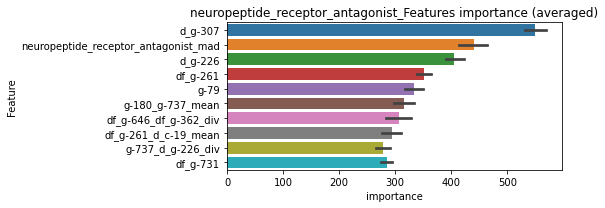

len(train_index) : 2843
len(valid_index) : 948
================================= fold 1/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0949627	valid_1's binary_logloss: 0.127975
[200]	training's binary_logloss: 0.0298626	valid_1's binary_logloss: 0.0555947
[300]	training's binary_logloss: 0.010585	valid_1's binary_logloss: 0.0283662
[400]	training's binary_logloss: 0.00447146	valid_1's binary_logloss: 0.0170987
[500]	training's binary_logloss: 0.00232117	valid_1's binary_logloss: 0.0119682
[600]	training's binary_logloss: 0.00144443	valid_1's binary_logloss: 0.00918749
[700]	training's binary_logloss: 0.00103087	valid_1's binary_logloss: 0.00772672
[800]	training's binary_logloss: 0.00080869	valid_1's binary_logloss: 0.00682213
[900]	training's binary_logloss: 0.00067914	valid_1's binary_logloss: 0.00627593
[1000]	training's binary_logloss: 0.00060487	valid_1's binary_logloss: 0.00592971
[1100]	training's binary_logloss: 0.000574963	valid_1's binary_logloss: 0.00579821
Early stopping, best iteration is:
[1113]	training's bi

len(train_index) : 2843
len(valid_index) : 948
================================= fold 2/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.094746	valid_1's binary_logloss: 0.135863
[200]	training's binary_logloss: 0.0304558	valid_1's binary_logloss: 0.0645359
[300]	training's binary_logloss: 0.0113649	valid_1's binary_logloss: 0.0366162
[400]	training's binary_logloss: 0.00500398	valid_1's binary_logloss: 0.0238265
[500]	training's binary_logloss: 0.00247731	valid_1's binary_logloss: 0.0175518
[600]	training's binary_logloss: 0.00149023	valid_1's binary_logloss: 0.0138731
[700]	training's binary_logloss: 0.00104884	valid_1's binary_logloss: 0.0124215
[800]	training's binary_logloss: 0.000819913	valid_1's binary_logloss: 0.0115924
[900]	training's binary_logloss: 0.000691181	valid_1's binary_logloss: 0.0112122
[1000]	training's binary_logloss: 0.000620618	valid_1's binary_logloss: 0.0110925
Early stopping, best iteration is:
[985]	training's binary_logloss: 0.000631795	valid_1's binary_logloss: 0.0110395


len(train_index) : 2843
len(valid_index) : 948
================================= fold 3/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0922584	valid_1's binary_logloss: 0.131697
[200]	training's binary_logloss: 0.0288961	valid_1's binary_logloss: 0.0600351
[300]	training's binary_logloss: 0.0105835	valid_1's binary_logloss: 0.0331033
[400]	training's binary_logloss: 0.00444693	valid_1's binary_logloss: 0.0205891
[500]	training's binary_logloss: 0.00232066	valid_1's binary_logloss: 0.0150119
[600]	training's binary_logloss: 0.00144726	valid_1's binary_logloss: 0.0119556
[700]	training's binary_logloss: 0.00103027	valid_1's binary_logloss: 0.0104639
[800]	training's binary_logloss: 0.000803758	valid_1's binary_logloss: 0.0095638
[900]	training's binary_logloss: 0.000675933	valid_1's binary_logloss: 0.00902583
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.000669934	valid_1's binary_logloss: 0.00901984


len(train_index) : 2844
len(valid_index) : 947
================================= fold 4/4 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955316	valid_1's binary_logloss: 0.125077
[200]	training's binary_logloss: 0.0311997	valid_1's binary_logloss: 0.0540838
[300]	training's binary_logloss: 0.0113191	valid_1's binary_logloss: 0.0267751
[400]	training's binary_logloss: 0.00469914	valid_1's binary_logloss: 0.015726
[500]	training's binary_logloss: 0.00242683	valid_1's binary_logloss: 0.0109173
[600]	training's binary_logloss: 0.00148689	valid_1's binary_logloss: 0.00863019
[700]	training's binary_logloss: 0.00105381	valid_1's binary_logloss: 0.00735348
[800]	training's binary_logloss: 0.000819506	valid_1's binary_logloss: 0.00659867
[900]	training's binary_logloss: 0.000691347	valid_1's binary_logloss: 0.0062728
[1000]	training's binary_logloss: 0.00062229	valid_1's binary_logloss: 0.0060213
[1100]	training's binary_logloss: 0.000597514	valid_1's binary_logloss: 0.00586753
Early stopping, best iteration is:
[1149]	training's bi

neuropeptide_receptor_antagonist logloss: 0.007919091251828369


neg labels: 3289 → selected neg labels: 3173


nfkb_inhibitor, len(trt): 832, len(othr): 3173, target_rate: 0.0349374 → Adj_target_rate: 0.0254860
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.503325	valid_1's binary_logloss: 0.509508
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.43738	valid_1's binary_logloss: 0.508438
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.428166	valid_1's binary_logloss: 0.506323
Training until validation scores don't improve for 30 rounds


1 / 3 AUC score:0.532
y_Threshold: 0.2149511, Threshold: 0.4650180, pos_neg_ratio: 0.7377876
Remove_noisy_data: 1378 → Positive_corect_labels: 252/2627
p_label_rate: 0.0100452 Vs.target_rate: 0.03494, Num_p_label: 40.0, conf_0:0.32551, conf_1:0.60452
Num_p_label: 40.0, Expected: 139.1, Adj_threshold_1: 0.4650180
Num_p_label: 102.0, Expected: 139.1, Adj_threshold_2: 0.4350180
Num_p_label: 126.0, Expected: 139.1, Adj_threshold_3: 0.4050180
Num_p_label: 136.0, Expected: 139.1, Adj_threshold_4: 0.3750180
Num_p_label: 141.0, Expected: 139.1, Adj_threshold_5: 0.3450180
Num_p_label: 145.0, Expected: 139.1, Adj_threshold_6: 0.3150180
Num_p_label: 150.0, Expected: 139.1, Adj_threshold_7: 0.2850180
Num_p_label: 183.0, Expected: 139.1, Adj_threshold_8: 0.2550180


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.420176	valid_1's binary_logloss: 0.507328


Num_p_label: 618.0, Expected: 139.1, Adj_threshold_9: 0.2250180
threshold: 0.2250180, positive_p_label: 618.0/3982, p_label_rate: 0.1551984
positive_y_label: 252.0/2627, y_label_rate: 0.0959269
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121695	valid_1's binary_logloss: 0.25067
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.081562	valid_1's binary_logloss: 0.248269
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114737	valid_1's binary_logloss: 0.272154
Early stopping, best iteration is:
[88]	training's binary_logloss: 0.127587	valid_1's binary_logloss: 0.271228
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120644	valid_1's binary_logloss: 0.259124
Early stopping, best iteration is:
[116]	training's binary_logloss: 0.10611	valid_1's binary_logloss: 0.257238
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117621	valid_1's binary_logloss: 0.260224


2 / 3 AUC score:0.797
y_Threshold: 0.1306991, Threshold: 0.2250180, pos_neg_ratio: 0.7377876
Remove_noisy_data: 304 → Positive_corect_labels: 100.0/2323
p_label_rate: 0.0781015 Vs.target_rate: 0.03494, Num_p_label: 311.0, conf_0:0.18001, conf_1:0.27002
Num_p_label: 311.0, Expected: 139.1, Adj_threshold_1: 0.2250180
Num_p_label: 238.0, Expected: 139.1, Adj_threshold_2: 0.2750180
Num_p_label: 212.0, Expected: 139.1, Adj_threshold_3: 0.3250180
Num_p_label: 191.0, Expected: 139.1, Adj_threshold_4: 0.3750180
Num_p_label: 176.0, Expected: 139.1, Adj_threshold_5: 0.4250180
Num_p_label: 168.0, Expected: 139.1, Adj_threshold_6: 0.4750180
Num_p_label: 160.0, Expected: 139.1, Adj_threshold_7: 0.5250180
Num_p_label: 147.0, Expected: 139.1, Adj_threshold_8: 0.5750180
Num_p_label: 145.0, Expected: 139.1, Adj_threshold_9: 0.6250180
Num_p_label: 138.0, Expected: 139.1, Adj_threshold_10: 0.6750180
threshold: 0.7250180, positive_p_label: 136.0/3982, p_label_rate: 0.0341537


Early stopping, best iteration is:
[116]	training's binary_logloss: 0.103161	valid_1's binary_logloss: 0.259059


positive_y_label: 100.0/2323, y_label_rate: 0.0430478
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0301942	valid_1's binary_logloss: 0.0945399
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0133224	valid_1's binary_logloss: 0.0908072
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0307068	valid_1's binary_logloss: 0.103368
[200]	training's binary_logloss: 0.00943225	valid_1's binary_logloss: 0.0974086
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.0115524	valid_1's binary_logloss: 0.0968756
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0305569	valid_1's binary_logloss: 0.0909856
Early stopping, best iteration is:
[143]	training's binary_logloss: 0.0178909	valid_1's binary_logloss: 0.0890397
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0315241	valid_1's binary_logloss: 0.0717608


3 / 3 AUC score:0.966
y_Threshold: 0.0604308, Threshold: 0.7250180, pos_neg_ratio: 0.7377876
Remove_noisy_data: 72 → Positive_corect_labels: 64.0/2251
p_label_rate: 0.0492215 Vs.target_rate: 0.03494, Num_p_label: 196.0, conf_0:0.50000, conf_1:0.79752
threshold: 0.7250180, positive_p_label: 196.0/3982, p_label_rate: 0.0492215
positive_y_label: 64.0/2251, y_label_rate: 0.0284318


[200]	training's binary_logloss: 0.0100575	valid_1's binary_logloss: 0.0662901
Early stopping, best iteration is:
[182]	training's binary_logloss: 0.0121354	valid_1's binary_logloss: 0.0661231


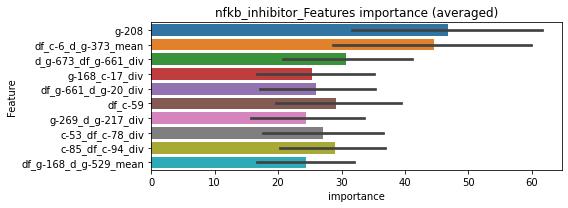

len(train_index) : 1688
len(valid_index) : 563
================================= fold 1/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0142289	valid_1's binary_logloss: 0.0329033
[200]	training's binary_logloss: 0.00376799	valid_1's binary_logloss: 0.0237806


len(train_index) : 1688
len(valid_index) : 563
================================= fold 2/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00222116	valid_1's binary_logloss: 0.0222239
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.015328	valid_1's binary_logloss: 0.0194691
[200]	training's binary_logloss: 0.00409852	valid_1's binary_logloss: 0.0114599
[300]	training's binary_logloss: 0.00156794	valid_1's binary_logloss: 0.00964838
[400]	training's binary_logloss: 0.000824734	valid_1's binary_logloss: 0.00883425


len(train_index) : 1688
len(valid_index) : 563
================================= fold 3/4 nfkb_inhibitor=================================


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000641539	valid_1's binary_logloss: 0.00864134
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0146165	valid_1's binary_logloss: 0.0530892
Early stopping, best iteration is:
[147]	training's binary_logloss: 0.007112	valid_1's binary_logloss: 0.050818


len(train_index) : 1689
len(valid_index) : 562
================================= fold 4/4 nfkb_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0138384	valid_1's binary_logloss: 0.0510573


nfkb_inhibitor logloss: 0.03290614361360725


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00925357	valid_1's binary_logloss: 0.0499717
neg labels: 3289 → selected neg labels: 3289


nicotinic_receptor_agonist, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0652043	valid_1's binary_logloss: 0.079097
[200]	training's binary_logloss: 0.0162797	valid_1's binary_logloss: 0.0255488
[300]	training's binary_logloss: 0.00485179	valid_1's binary_logloss: 0.0111557
[400]	training's binary_logloss: 0.00187913	valid_1's binary_logloss: 0.00640622
[500]	training's binary_logloss: 0.000992838	valid_1's binary_logloss: 0.00499309
[600]	training's binary_logloss: 0.000647355	valid_1's binary_logloss: 0.00431225
[700]	training's binary_logloss: 0.000480779	valid_1's binary_logloss: 0.00378937
[800]	training's binary_logloss: 0.000407694	valid_1's binary_logloss: 0.00362154
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000385448	valid_1's binary_logloss: 0.0035049
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0661546	valid_1's binary_logloss: 0.0771926
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0026838, Threshold: 0.0184505, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01292, conf_1:0.02399
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0184505
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_2: 0.0684505
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.1184505
Num_p_label: 3.0, Expected: 2.0, Adj_threshold_4: 0.1684505
threshold: 0.1684505, positive_p_label: 3.0/3982, p_label_rate: 0.0007534
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0645501	valid_1's binary_logloss: 0.07584
[200]	training's binary_logloss: 0.014807	valid_1's binary_logloss: 0.0224207
[300]	training's binary_logloss: 0.00417364	valid_1's binary_logloss: 0.0091389
[400]	training's binary_logloss: 0.00163443	valid_1's binary_logloss: 0.0052417
[500]	training's binary_logloss: 0.000865355	valid_1's binary_logloss: 0.00380068
[600]	training's binary_logloss: 0.00056723	valid_1's binary_logloss: 0.00315004
[700]	training's binary_logloss: 0.000426085	valid_1's binary_logloss: 0.00277831
[800]	training's binary_logloss: 0.000359398	valid_1's binary_logloss: 0.00261677
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000355108	valid_1's binary_logloss: 0.00260474
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0638054	valid_1's binary_logloss: 0.0749592
[200]	training's binary_logloss: 0.01437

2 / 3 AUC score:1.000
y_Threshold: 0.2364723, Threshold: 0.1684505, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0042692 Vs.target_rate: 0.00050, Num_p_label: 17.0, conf_0:0.13476, conf_1:0.20214
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_1: 0.1684505
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.2184505
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_3: 0.2684505
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_4: 0.3184505
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_5: 0.3684505
Num_p_label: 8.0, Expected: 2.0, Adj_threshold_6: 0.4184505
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.4684505
threshold: 0.4684505, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0645501	valid_1's binary_logloss: 0.07584
[200]	training's binary_logloss: 0.014807	valid_1's binary_logloss: 0.0224207
[300]	training's binary_logloss: 0.00417364	valid_1's binary_logloss: 0.0091389
[400]	training's binary_logloss: 0.00163443	valid_1's binary_logloss: 0.0052417
[500]	training's binary_logloss: 0.000865355	valid_1's binary_logloss: 0.00380068
[600]	training's binary_logloss: 0.00056723	valid_1's binary_logloss: 0.00315004
[700]	training's binary_logloss: 0.000426085	valid_1's binary_logloss: 0.00277831
[800]	training's binary_logloss: 0.000359398	valid_1's binary_logloss: 0.00261677
Early stopping, best iteration is:
[820]	training's binary_logloss: 0.000355108	valid_1's binary_logloss: 0.00260474
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0638054	valid_1's binary_logloss: 0.0749592
[200]	training's binary_logloss: 0.01437

3 / 3 AUC score:1.000
y_Threshold: 0.2364723, Threshold: 0.4684505, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.42161, conf_1:0.51530
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.4684505
threshold: 0.4684505, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


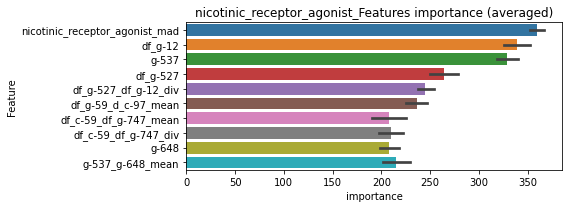

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0642012	valid_1's binary_logloss: 0.0750227
[200]	training's binary_logloss: 0.0142424	valid_1's binary_logloss: 0.0211405
[300]	training's binary_logloss: 0.00411933	valid_1's binary_logloss: 0.0084565
[400]	training's binary_logloss: 0.00161365	valid_1's binary_logloss: 0.00463062
[500]	training's binary_logloss: 0.000855239	valid_1's binary_logloss: 0.00322592
[600]	training's binary_logloss: 0.000565023	valid_1's binary_logloss: 0.00255252
[700]	training's binary_logloss: 0.000424268	valid_1's binary_logloss: 0.00229003
[800]	training's binary_logloss: 0.000362438	valid_1's binary_logloss: 0.00215032
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000353033	valid_1's binary_logloss: 0.00213171


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0645145	valid_1's binary_logloss: 0.0752852
[200]	training's binary_logloss: 0.014748	valid_1's binary_logloss: 0.0210937
[300]	training's binary_logloss: 0.00420592	valid_1's binary_logloss: 0.0074409
[400]	training's binary_logloss: 0.00162198	valid_1's binary_logloss: 0.00366036
[500]	training's binary_logloss: 0.000859049	valid_1's binary_logloss: 0.00231549
[600]	training's binary_logloss: 0.000559347	valid_1's binary_logloss: 0.00172047
[700]	training's binary_logloss: 0.00042346	valid_1's binary_logloss: 0.00143557
[800]	training's binary_logloss: 0.000358389	valid_1's binary_logloss: 0.00126409
[900]	training's binary_logloss: 0.000343524	valid_1's binary_logloss: 0.00122307
Early stopping, best iteration is:
[922]	training's binary_logloss: 0.000343004	valid_1's binary_logloss: 0.00122095


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0639075	valid_1's binary_logloss: 0.078729
[200]	training's binary_logloss: 0.0142685	valid_1's binary_logloss: 0.0238325
[300]	training's binary_logloss: 0.00409309	valid_1's binary_logloss: 0.00965188
[400]	training's binary_logloss: 0.00159785	valid_1's binary_logloss: 0.00509814
[500]	training's binary_logloss: 0.000847873	valid_1's binary_logloss: 0.00338757
[600]	training's binary_logloss: 0.000558693	valid_1's binary_logloss: 0.00261626
[700]	training's binary_logloss: 0.00042023	valid_1's binary_logloss: 0.0023036
[800]	training's binary_logloss: 0.000360869	valid_1's binary_logloss: 0.00213893
Early stopping, best iteration is:
[805]	training's binary_logloss: 0.000360071	valid_1's binary_logloss: 0.0021306


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.064095	valid_1's binary_logloss: 0.0795257
[200]	training's binary_logloss: 0.0142175	valid_1's binary_logloss: 0.0230036
[300]	training's binary_logloss: 0.00408295	valid_1's binary_logloss: 0.00904569
[400]	training's binary_logloss: 0.0016056	valid_1's binary_logloss: 0.00468327
[500]	training's binary_logloss: 0.000850206	valid_1's binary_logloss: 0.00307567
[600]	training's binary_logloss: 0.00055834	valid_1's binary_logloss: 0.00241233
[700]	training's binary_logloss: 0.000423188	valid_1's binary_logloss: 0.00204224
[800]	training's binary_logloss: 0.00036291	valid_1's binary_logloss: 0.00191339
Early stopping, best iteration is:
[815]	training's binary_logloss: 0.000359738	valid_1's binary_logloss: 0.00189398


nicotinic_receptor_agonist logloss: 0.0018445621610757986


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_donor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902289	valid_1's binary_logloss: 0.117744
[200]	training's binary_logloss: 0.0299456	valid_1's binary_logloss: 0.0509625
[300]	training's binary_logloss: 0.0107828	valid_1's binary_logloss: 0.0264853
[400]	training's binary_logloss: 0.00438448	valid_1's binary_logloss: 0.0160052
[500]	training's binary_logloss: 0.0021676	valid_1's binary_logloss: 0.0115306
[600]	training's binary_logloss: 0.00132089	valid_1's binary_logloss: 0.00973183
[700]	training's binary_logloss: 0.000938027	valid_1's binary_logloss: 0.00865486
[800]	training's binary_logloss: 0.000725933	valid_1's binary_logloss: 0.00803307
[900]	training's binary_logloss: 0.000608405	valid_1's binary_logloss: 0.00764097
[1000]	training's binary_logloss: 0.000564576	valid_1's binary_logloss: 0.00753102
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.000560067	valid_1's binary_logloss: 0.00750746
Training until v

1 / 3 AUC score:1.000
y_Threshold: 0.0085679, Threshold: 0.0913753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.06396, conf_1:0.11879
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0913753
Num_p_label: 22.0, Expected: 4.3, Adj_threshold_2: 0.1413753
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_3: 0.1913753
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_4: 0.2413753
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_5: 0.2913753
threshold: 0.2913753, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0880279	valid_1's binary_logloss: 0.10997
[200]	training's binary_logloss: 0.0265451	valid_1's binary_logloss: 0.0411855
[300]	training's binary_logloss: 0.00895675	valid_1's binary_logloss: 0.019371
[400]	training's binary_logloss: 0.00368756	valid_1's binary_logloss: 0.0112655
[500]	training's binary_logloss: 0.00187167	valid_1's binary_logloss: 0.00799783
[600]	training's binary_logloss: 0.00116033	valid_1's binary_logloss: 0.00671357
[700]	training's binary_logloss: 0.000832308	valid_1's binary_logloss: 0.00585433
[800]	training's binary_logloss: 0.000653918	valid_1's binary_logloss: 0.00545252
[900]	training's binary_logloss: 0.000557082	valid_1's binary_logloss: 0.00517207
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.000544875	valid_1's binary_logloss: 0.00513065
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085

2 / 3 AUC score:1.000
y_Threshold: 0.1777336, Threshold: 0.2913753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0085384 Vs.target_rate: 0.00109, Num_p_label: 34.0, conf_0:0.23310, conf_1:0.34965
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_1: 0.2913753
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_2: 0.3413753
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_3: 0.3913753
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_4: 0.4413753
Num_p_label: 17.0, Expected: 4.3, Adj_threshold_5: 0.4913753
Num_p_label: 15.0, Expected: 4.3, Adj_threshold_6: 0.5413753
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_7: 0.5913753
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_8: 0.6413753
threshold: 0.6413753, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08784	valid_1's binary_logloss: 0.107331
[200]	training's binary_logloss: 0.0259455	valid_1's binary_logloss: 0.0399105
[300]	training's binary_logloss: 0.00889756	valid_1's binary_logloss: 0.0180397
[400]	training's binary_logloss: 0.00361191	valid_1's binary_logloss: 0.0098524
[500]	training's binary_logloss: 0.00185312	valid_1's binary_logloss: 0.00647038
[600]	training's binary_logloss: 0.00115523	valid_1's binary_logloss: 0.00498578
[700]	training's binary_logloss: 0.000826165	valid_1's binary_logloss: 0.00406736
[800]	training's binary_logloss: 0.000651207	valid_1's binary_logloss: 0.00360258
[900]	training's binary_logloss: 0.00055568	valid_1's binary_logloss: 0.00333467
[1000]	training's binary_logloss: 0.000524189	valid_1's binary_logloss: 0.00323734
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.000524189	valid_1's binary_logloss: 0.00323734
Training until va

3 / 3 AUC score:1.000
y_Threshold: 0.1172616, Threshold: 0.6413753, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0027624 Vs.target_rate: 0.00109, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.70551
Num_p_label: 11.0, Expected: 4.3, Adj_threshold_1: 0.6413753
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.6913753
threshold: 0.6913753, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


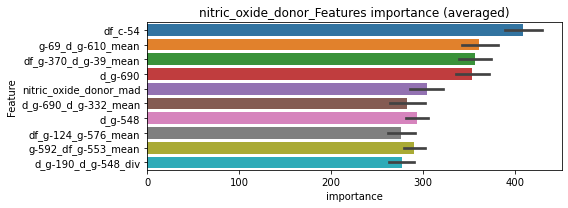

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0874732	valid_1's binary_logloss: 0.106585
[200]	training's binary_logloss: 0.0266077	valid_1's binary_logloss: 0.0398802
[300]	training's binary_logloss: 0.00898381	valid_1's binary_logloss: 0.0180072
[400]	training's binary_logloss: 0.00360298	valid_1's binary_logloss: 0.00952604
[500]	training's binary_logloss: 0.00184512	valid_1's binary_logloss: 0.00616193
[600]	training's binary_logloss: 0.00114725	valid_1's binary_logloss: 0.00465465
[700]	training's binary_logloss: 0.000820229	valid_1's binary_logloss: 0.00384814
[800]	training's binary_logloss: 0.000649407	valid_1's binary_logloss: 0.00334872
[900]	training's binary_logloss: 0.000563435	valid_1's binary_logloss: 0.00308464
[1000]	training's binary_logloss: 0.00052449	valid_1's binary_logloss: 0.00298292
Early stopping, best iteration is:
[990]	training's binary_logloss: 0.00052449	valid_1's binary_logloss: 0.00298292


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0870473	valid_1's binary_logloss: 0.110578
[200]	training's binary_logloss: 0.025884	valid_1's binary_logloss: 0.0436294
[300]	training's binary_logloss: 0.008603	valid_1's binary_logloss: 0.0208765
[400]	training's binary_logloss: 0.00351191	valid_1's binary_logloss: 0.0126092
[500]	training's binary_logloss: 0.00180749	valid_1's binary_logloss: 0.00885568
[600]	training's binary_logloss: 0.00113006	valid_1's binary_logloss: 0.00725371
[700]	training's binary_logloss: 0.000809172	valid_1's binary_logloss: 0.00636044
[800]	training's binary_logloss: 0.000642422	valid_1's binary_logloss: 0.00590489
[900]	training's binary_logloss: 0.000552008	valid_1's binary_logloss: 0.00559467
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000550418	valid_1's binary_logloss: 0.00558077


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0872542	valid_1's binary_logloss: 0.112275
[200]	training's binary_logloss: 0.0262011	valid_1's binary_logloss: 0.0458553
[300]	training's binary_logloss: 0.00866695	valid_1's binary_logloss: 0.0221085
[400]	training's binary_logloss: 0.00346893	valid_1's binary_logloss: 0.0130707
[500]	training's binary_logloss: 0.00178507	valid_1's binary_logloss: 0.00958358
[600]	training's binary_logloss: 0.00112477	valid_1's binary_logloss: 0.00806113
[700]	training's binary_logloss: 0.000808038	valid_1's binary_logloss: 0.00727106
[800]	training's binary_logloss: 0.000641051	valid_1's binary_logloss: 0.00681863
[900]	training's binary_logloss: 0.000553862	valid_1's binary_logloss: 0.00649637
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.000544106	valid_1's binary_logloss: 0.00644787


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 nitric_oxide_donor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0886001	valid_1's binary_logloss: 0.119006
[200]	training's binary_logloss: 0.0260652	valid_1's binary_logloss: 0.0489457
[300]	training's binary_logloss: 0.00871918	valid_1's binary_logloss: 0.0238073
[400]	training's binary_logloss: 0.00357224	valid_1's binary_logloss: 0.014201
[500]	training's binary_logloss: 0.00183309	valid_1's binary_logloss: 0.00985787
[600]	training's binary_logloss: 0.00113876	valid_1's binary_logloss: 0.00771063
[700]	training's binary_logloss: 0.00081758	valid_1's binary_logloss: 0.0067748
[800]	training's binary_logloss: 0.000643635	valid_1's binary_logloss: 0.00635612
[900]	training's binary_logloss: 0.000555634	valid_1's binary_logloss: 0.00595785
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.000540236	valid_1's binary_logloss: 0.00590928


nitric_oxide_donor logloss: 0.005230210663031737


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_production_inhibitor, len(trt): 29, len(othr): 3285, target_rate: 0.0012178 → Adj_target_rate: 0.0014697
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0868673	valid_1's binary_logloss: 0.115141
[200]	training's binary_logloss: 0.0272561	valid_1's binary_logloss: 0.0487708
[300]	training's binary_logloss: 0.00975498	valid_1's binary_logloss: 0.0255256
[400]	training's binary_logloss: 0.00399065	valid_1's binary_logloss: 0.0161376
[500]	training's binary_logloss: 0.0020643	valid_1's binary_logloss: 0.0123987
[600]	training's binary_logloss: 0.00128028	valid_1's binary_logloss: 0.0107102
[700]	training's binary_logloss: 0.000911416	valid_1's binary_logloss: 0.0100511
[800]	training's binary_logloss: 0.000711411	valid_1's binary_logloss: 0.0095436
Early stopping, best iteration is:
[854]	training's binary_logloss: 0.000643933	valid_1's binary_logloss: 0.00940672
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0882441	valid_1's binary_logloss: 0.113989
[200]	training's binary_logloss: 0.0275644	va

1 / 3 AUC score:1.000
y_Threshold: 0.0096554, Threshold: 0.0541627, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00122, Num_p_label: 40.0, conf_0:0.03791, conf_1:0.07041
Num_p_label: 40.0, Expected: 4.8, Adj_threshold_1: 0.0541627
Num_p_label: 23.0, Expected: 4.8, Adj_threshold_2: 0.1041627
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_3: 0.1541627
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_4: 0.2041627
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_5: 0.2541627
threshold: 0.2541627, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0814283	valid_1's binary_logloss: 0.106276
[200]	training's binary_logloss: 0.0227265	valid_1's binary_logloss: 0.0413888
[300]	training's binary_logloss: 0.00765809	valid_1's binary_logloss: 0.0210189
[400]	training's binary_logloss: 0.00313648	valid_1's binary_logloss: 0.0131427
[500]	training's binary_logloss: 0.00163963	valid_1's binary_logloss: 0.00977364
[600]	training's binary_logloss: 0.00104305	valid_1's binary_logloss: 0.00802458
[700]	training's binary_logloss: 0.000754996	valid_1's binary_logloss: 0.0069385
[800]	training's binary_logloss: 0.000599122	valid_1's binary_logloss: 0.00632774
[900]	training's binary_logloss: 0.00051014	valid_1's binary_logloss: 0.00606334
Early stopping, best iteration is:
[966]	training's binary_logloss: 0.000482169	valid_1's binary_logloss: 0.00600042
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.082

2 / 3 AUC score:1.000
y_Threshold: 0.0920946, Threshold: 0.2541627, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0070316 Vs.target_rate: 0.00122, Num_p_label: 28.0, conf_0:0.20333, conf_1:0.30500
Num_p_label: 28.0, Expected: 4.8, Adj_threshold_1: 0.2541627
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_2: 0.3041627
Num_p_label: 21.0, Expected: 4.8, Adj_threshold_3: 0.3541627
Num_p_label: 20.0, Expected: 4.8, Adj_threshold_4: 0.4041627
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_5: 0.4541627
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_6: 0.5041627
Num_p_label: 17.0, Expected: 4.8, Adj_threshold_7: 0.5541627
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_8: 0.6041627
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_9: 0.6541627
threshold: 0.6541627, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0827658	valid_1's binary_logloss: 0.109713
[200]	training's binary_logloss: 0.0227871	valid_1's binary_logloss: 0.0414151
[300]	training's binary_logloss: 0.00764746	valid_1's binary_logloss: 0.0201456
[400]	training's binary_logloss: 0.00313756	valid_1's binary_logloss: 0.0120234
[500]	training's binary_logloss: 0.00164503	valid_1's binary_logloss: 0.00905865
[600]	training's binary_logloss: 0.00104422	valid_1's binary_logloss: 0.00752901
[700]	training's binary_logloss: 0.000758423	valid_1's binary_logloss: 0.00660049
[800]	training's binary_logloss: 0.000594524	valid_1's binary_logloss: 0.00592843
[900]	training's binary_logloss: 0.000508634	valid_1's binary_logloss: 0.00562187
[1000]	training's binary_logloss: 0.00048234	valid_1's binary_logloss: 0.00556857
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.000484053	valid_1's binary_logloss: 0.00555967
Training until 

3 / 3 AUC score:1.000
y_Threshold: 0.1023733, Threshold: 0.6541627, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3800
p_label_rate: 0.0027624 Vs.target_rate: 0.00122, Num_p_label: 11.0, conf_0:0.50000, conf_1:0.71958
Num_p_label: 11.0, Expected: 4.8, Adj_threshold_1: 0.6541627
threshold: 0.6541627, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3800, y_label_rate: 0.1715789


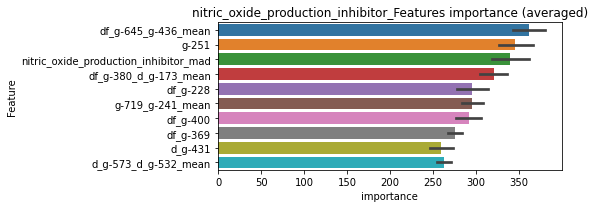

len(train_index) : 2850
len(valid_index) : 950
================================= fold 1/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822802	valid_1's binary_logloss: 0.11308
[200]	training's binary_logloss: 0.0229987	valid_1's binary_logloss: 0.0464336
[300]	training's binary_logloss: 0.00751762	valid_1's binary_logloss: 0.0227655
[400]	training's binary_logloss: 0.00309629	valid_1's binary_logloss: 0.0148972
[500]	training's binary_logloss: 0.00161397	valid_1's binary_logloss: 0.0109697
[600]	training's binary_logloss: 0.00102963	valid_1's binary_logloss: 0.00938141
[700]	training's binary_logloss: 0.000743161	valid_1's binary_logloss: 0.00837929
[800]	training's binary_logloss: 0.000588346	valid_1's binary_logloss: 0.00772798
[900]	training's binary_logloss: 0.000507592	valid_1's binary_logloss: 0.00747848
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000490296	valid_1's binary_logloss: 0.00741406


len(train_index) : 2850
len(valid_index) : 950
================================= fold 2/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820194	valid_1's binary_logloss: 0.101234
[200]	training's binary_logloss: 0.0226653	valid_1's binary_logloss: 0.0360844
[300]	training's binary_logloss: 0.00753313	valid_1's binary_logloss: 0.0158501
[400]	training's binary_logloss: 0.00312108	valid_1's binary_logloss: 0.00901426
[500]	training's binary_logloss: 0.00162097	valid_1's binary_logloss: 0.00617599
[600]	training's binary_logloss: 0.00102784	valid_1's binary_logloss: 0.00479349
[700]	training's binary_logloss: 0.000744576	valid_1's binary_logloss: 0.00417277
[800]	training's binary_logloss: 0.000590892	valid_1's binary_logloss: 0.00380371
[900]	training's binary_logloss: 0.000506789	valid_1's binary_logloss: 0.00356748
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000493909	valid_1's binary_logloss: 0.00355326


len(train_index) : 2850
len(valid_index) : 950
================================= fold 3/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0841342	valid_1's binary_logloss: 0.104786
[200]	training's binary_logloss: 0.0236746	valid_1's binary_logloss: 0.038053
[300]	training's binary_logloss: 0.00771809	valid_1's binary_logloss: 0.0167571
[400]	training's binary_logloss: 0.00312652	valid_1's binary_logloss: 0.00926361
[500]	training's binary_logloss: 0.0016422	valid_1's binary_logloss: 0.00637527
[600]	training's binary_logloss: 0.0010364	valid_1's binary_logloss: 0.00497828
[700]	training's binary_logloss: 0.000748764	valid_1's binary_logloss: 0.00426096
[800]	training's binary_logloss: 0.000592147	valid_1's binary_logloss: 0.00387931
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.00052925	valid_1's binary_logloss: 0.00374095


len(train_index) : 2850
len(valid_index) : 950
================================= fold 4/4 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0825463	valid_1's binary_logloss: 0.110325
[200]	training's binary_logloss: 0.0230476	valid_1's binary_logloss: 0.0430157
[300]	training's binary_logloss: 0.00771701	valid_1's binary_logloss: 0.0220895
[400]	training's binary_logloss: 0.00313893	valid_1's binary_logloss: 0.0142205
[500]	training's binary_logloss: 0.00163085	valid_1's binary_logloss: 0.0110942
[600]	training's binary_logloss: 0.00103907	valid_1's binary_logloss: 0.00962166
[700]	training's binary_logloss: 0.000744029	valid_1's binary_logloss: 0.00881553
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.000643193	valid_1's binary_logloss: 0.00854823


nitric_oxide_production_inhibitor logloss: 0.005815990827483457


neg labels: 3289 → selected neg labels: 3285


nitric_oxide_synthase_inhibitor, len(trt): 26, len(othr): 3285, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877547	valid_1's binary_logloss: 0.123433
[200]	training's binary_logloss: 0.0275264	valid_1's binary_logloss: 0.0564576
[300]	training's binary_logloss: 0.00993911	valid_1's binary_logloss: 0.0321616
[400]	training's binary_logloss: 0.00408766	valid_1's binary_logloss: 0.0222751
[500]	training's binary_logloss: 0.0021333	valid_1's binary_logloss: 0.0190662
[600]	training's binary_logloss: 0.00133013	valid_1's binary_logloss: 0.017201
[700]	training's binary_logloss: 0.000940971	valid_1's binary_logloss: 0.0159135
[800]	training's binary_logloss: 0.000737467	valid_1's binary_logloss: 0.0151674
[900]	training's binary_logloss: 0.000621243	valid_1's binary_logloss: 0.0147272
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.00061775	valid_1's binary_logloss: 0.0147165
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0879439	va

1 / 3 AUC score:1.000
y_Threshold: 0.0075707, Threshold: 0.0948086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.06637, conf_1:0.12325
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0948086
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_2: 0.1448086
Num_p_label: 23.0, Expected: 4.3, Adj_threshold_3: 0.1948086
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_4: 0.2448086
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_5: 0.2948086
Num_p_label: 12.0, Expected: 4.3, Adj_threshold_6: 0.3448086
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_7: 0.3948086
threshold: 0.3948086, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085387	valid_1's binary_logloss: 0.118008
[200]	training's binary_logloss: 0.0243167	valid_1's binary_logloss: 0.050731
[300]	training's binary_logloss: 0.00838018	valid_1's binary_logloss: 0.0278213
[400]	training's binary_logloss: 0.00345908	valid_1's binary_logloss: 0.019577
[500]	training's binary_logloss: 0.00181052	valid_1's binary_logloss: 0.0161331
[600]	training's binary_logloss: 0.00114714	valid_1's binary_logloss: 0.0145248
[700]	training's binary_logloss: 0.000830158	valid_1's binary_logloss: 0.013475
[800]	training's binary_logloss: 0.00065894	valid_1's binary_logloss: 0.0127544
[900]	training's binary_logloss: 0.000562762	valid_1's binary_logloss: 0.0125122
Early stopping, best iteration is:
[906]	training's binary_logloss: 0.00055903	valid_1's binary_logloss: 0.012442
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0869742	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.0728448, Threshold: 0.3948086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0092918 Vs.target_rate: 0.00109, Num_p_label: 37.0, conf_0:0.31585, conf_1:0.47377
Num_p_label: 37.0, Expected: 4.3, Adj_threshold_1: 0.3948086
Num_p_label: 36.0, Expected: 4.3, Adj_threshold_2: 0.4448086
Num_p_label: 34.0, Expected: 4.3, Adj_threshold_3: 0.4948086
Num_p_label: 32.0, Expected: 4.3, Adj_threshold_4: 0.5448086
Num_p_label: 31.0, Expected: 4.3, Adj_threshold_5: 0.5948086
Num_p_label: 29.0, Expected: 4.3, Adj_threshold_6: 0.6448086
Num_p_label: 25.0, Expected: 4.3, Adj_threshold_7: 0.6948086
Num_p_label: 19.0, Expected: 4.3, Adj_threshold_8: 0.7448086
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_9: 0.7948086
threshold: 0.7948086, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0848389	valid_1's binary_logloss: 0.116458
[200]	training's binary_logloss: 0.0244363	valid_1's binary_logloss: 0.048184
[300]	training's binary_logloss: 0.00813942	valid_1's binary_logloss: 0.0251444
[400]	training's binary_logloss: 0.0034252	valid_1's binary_logloss: 0.0163332
[500]	training's binary_logloss: 0.00178959	valid_1's binary_logloss: 0.0126558
[600]	training's binary_logloss: 0.00113056	valid_1's binary_logloss: 0.0108172
[700]	training's binary_logloss: 0.000817723	valid_1's binary_logloss: 0.0100727
[800]	training's binary_logloss: 0.000642221	valid_1's binary_logloss: 0.00927694
[900]	training's binary_logloss: 0.000554862	valid_1's binary_logloss: 0.00902771
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.000543905	valid_1's binary_logloss: 0.0089889
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845695

3 / 3 AUC score:1.000
y_Threshold: 0.0517464, Threshold: 0.7948086, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 654.0/3804
p_label_rate: 0.0040181 Vs.target_rate: 0.00109, Num_p_label: 16.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 16.0, Expected: 4.3, Adj_threshold_1: 0.7948086
threshold: 0.7948086, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3804, y_label_rate: 0.1719243


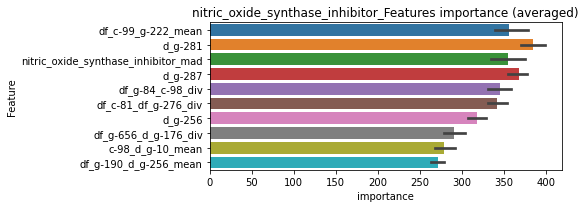

len(train_index) : 2853
len(valid_index) : 951
================================= fold 1/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854704	valid_1's binary_logloss: 0.122836
[200]	training's binary_logloss: 0.0239056	valid_1's binary_logloss: 0.0515977
[300]	training's binary_logloss: 0.00808132	valid_1's binary_logloss: 0.027295
[400]	training's binary_logloss: 0.00335312	valid_1's binary_logloss: 0.0178152
[500]	training's binary_logloss: 0.00175203	valid_1's binary_logloss: 0.0142126
[600]	training's binary_logloss: 0.00111514	valid_1's binary_logloss: 0.0127281
[700]	training's binary_logloss: 0.000800558	valid_1's binary_logloss: 0.0116485
[800]	training's binary_logloss: 0.000638634	valid_1's binary_logloss: 0.0109612
[900]	training's binary_logloss: 0.000548707	valid_1's binary_logloss: 0.010551
Early stopping, best iteration is:
[956]	training's binary_logloss: 0.000526254	valid_1's binary_logloss: 0.0104633


len(train_index) : 2853
len(valid_index) : 951
================================= fold 2/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0857824	valid_1's binary_logloss: 0.11849
[200]	training's binary_logloss: 0.0242491	valid_1's binary_logloss: 0.0504827
[300]	training's binary_logloss: 0.00809522	valid_1's binary_logloss: 0.0269084
[400]	training's binary_logloss: 0.00338684	valid_1's binary_logloss: 0.0182897
[500]	training's binary_logloss: 0.00176865	valid_1's binary_logloss: 0.0139201
[600]	training's binary_logloss: 0.00112647	valid_1's binary_logloss: 0.0124544
[700]	training's binary_logloss: 0.0008077	valid_1's binary_logloss: 0.0112557
[800]	training's binary_logloss: 0.000642678	valid_1's binary_logloss: 0.0107522
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.000607569	valid_1's binary_logloss: 0.0105728


len(train_index) : 2853
len(valid_index) : 951
================================= fold 3/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855108	valid_1's binary_logloss: 0.112266
[200]	training's binary_logloss: 0.0239896	valid_1's binary_logloss: 0.0446188
[300]	training's binary_logloss: 0.00830332	valid_1's binary_logloss: 0.0239411
[400]	training's binary_logloss: 0.00343291	valid_1's binary_logloss: 0.0150331
[500]	training's binary_logloss: 0.00181275	valid_1's binary_logloss: 0.0112009
[600]	training's binary_logloss: 0.00114641	valid_1's binary_logloss: 0.00954586
[700]	training's binary_logloss: 0.00082409	valid_1's binary_logloss: 0.0085466
[800]	training's binary_logloss: 0.000653778	valid_1's binary_logloss: 0.0079702
Early stopping, best iteration is:
[865]	training's binary_logloss: 0.000581858	valid_1's binary_logloss: 0.00769689


len(train_index) : 2853
len(valid_index) : 951
================================= fold 4/4 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.085991	valid_1's binary_logloss: 0.113701
[200]	training's binary_logloss: 0.0245823	valid_1's binary_logloss: 0.0448441
[300]	training's binary_logloss: 0.00836816	valid_1's binary_logloss: 0.0216185
[400]	training's binary_logloss: 0.00345854	valid_1's binary_logloss: 0.0125621
[500]	training's binary_logloss: 0.0018332	valid_1's binary_logloss: 0.0089083
[600]	training's binary_logloss: 0.00115766	valid_1's binary_logloss: 0.0072365
[700]	training's binary_logloss: 0.000836061	valid_1's binary_logloss: 0.00617597
[800]	training's binary_logloss: 0.000661192	valid_1's binary_logloss: 0.00568435
[900]	training's binary_logloss: 0.000559832	valid_1's binary_logloss: 0.00536755
Early stopping, best iteration is:
[904]	training's binary_logloss: 0.000556602	valid_1's binary_logloss: 0.00535719


nitric_oxide_synthase_inhibitor logloss: 0.008522677306259416


neg labels: 3289 → selected neg labels: 3286


norepinephrine_reuptake_inhibitor, len(trt): 7, len(othr): 3286, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0495388	valid_1's binary_logloss: 0.0542321
[200]	training's binary_logloss: 0.00917008	valid_1's binary_logloss: 0.0109933
[300]	training's binary_logloss: 0.00224134	valid_1's binary_logloss: 0.00317381
[400]	training's binary_logloss: 0.000842191	valid_1's binary_logloss: 0.00147924
[500]	training's binary_logloss: 0.000460934	valid_1's binary_logloss: 0.000950149
[600]	training's binary_logloss: 0.000324004	valid_1's binary_logloss: 0.000737506
[700]	training's binary_logloss: 0.00027594	valid_1's binary_logloss: 0.000674329
Early stopping, best iteration is:
[768]	training's binary_logloss: 0.000269863	valid_1's binary_logloss: 0.000667075
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0499523	valid_1's binary_logloss: 0.0542157
[200]	training's binary_logloss: 0.00939092	valid_1's binary_logloss: 0.0120626
[300]	training's binary_logloss

1 / 3 AUC score:1.000
y_Threshold: 0.0012665, Threshold: 0.0069330, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.00485, conf_1:0.00901
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0069330
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_2: 0.0569330
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.1069330
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.1569330
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_5: 0.2069330
threshold: 0.2069330, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0486564	valid_1's binary_logloss: 0.0533809
[200]	training's binary_logloss: 0.00834957	valid_1's binary_logloss: 0.0109314
[300]	training's binary_logloss: 0.00192252	valid_1's binary_logloss: 0.00357201
[400]	training's binary_logloss: 0.000692953	valid_1's binary_logloss: 0.00179262
[500]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00122401
[600]	training's binary_logloss: 0.000267982	valid_1's binary_logloss: 0.00101057
[700]	training's binary_logloss: 0.000229189	valid_1's binary_logloss: 0.000933728
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.000223171	valid_1's binary_logloss: 0.000923486
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0491841	valid_1's binary_logloss: 0.0520761
[200]	training's binary_logloss: 0.00856623	valid_1's binary_logloss: 0.00987949
[300]	training's binary_logloss

2 / 3 AUC score:1.000
y_Threshold: 0.1145813, Threshold: 0.2069330, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0032647 Vs.target_rate: 0.00029, Num_p_label: 13.0, conf_0:0.16555, conf_1:0.24832
Num_p_label: 13.0, Expected: 1.2, Adj_threshold_1: 0.2069330
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_2: 0.2569330
Num_p_label: 9.0, Expected: 1.2, Adj_threshold_3: 0.3069330
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_4: 0.3569330
Num_p_label: 5.0, Expected: 1.2, Adj_threshold_5: 0.4069330
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_6: 0.4569330
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_7: 0.5069330
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_8: 0.5569330
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.6069330
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.6569330
threshold: 0.7069330, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Ps

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0486564	valid_1's binary_logloss: 0.0533809
[200]	training's binary_logloss: 0.00834957	valid_1's binary_logloss: 0.0109314
[300]	training's binary_logloss: 0.00192252	valid_1's binary_logloss: 0.00357201
[400]	training's binary_logloss: 0.000692953	valid_1's binary_logloss: 0.00179262
[500]	training's binary_logloss: 0.000381006	valid_1's binary_logloss: 0.00122401
[600]	training's binary_logloss: 0.000267982	valid_1's binary_logloss: 0.00101057
[700]	training's binary_logloss: 0.000229189	valid_1's binary_logloss: 0.000933728
Early stopping, best iteration is:
[757]	training's binary_logloss: 0.000223171	valid_1's binary_logloss: 0.000923486
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0491841	valid_1's binary_logloss: 0.0520761
[200]	training's binary_logloss: 0.00856623	valid_1's binary_logloss: 0.00987949
[300]	training's binary_logloss

3 / 3 AUC score:1.000
y_Threshold: 0.1145813, Threshold: 0.7069330, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.50000, conf_1:0.77763
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_1: 0.7069330
threshold: 0.7069330, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


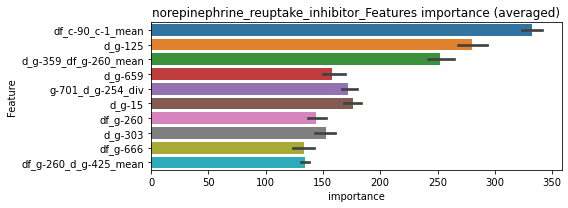

len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0486857	valid_1's binary_logloss: 0.0535937
[200]	training's binary_logloss: 0.00840012	valid_1's binary_logloss: 0.010898
[300]	training's binary_logloss: 0.0019204	valid_1's binary_logloss: 0.00358266
[400]	training's binary_logloss: 0.000698301	valid_1's binary_logloss: 0.00173091
[500]	training's binary_logloss: 0.000380408	valid_1's binary_logloss: 0.00121784
[600]	training's binary_logloss: 0.000265625	valid_1's binary_logloss: 0.00096803
[700]	training's binary_logloss: 0.000227438	valid_1's binary_logloss: 0.000889792
Early stopping, best iteration is:
[765]	training's binary_logloss: 0.000221471	valid_1's binary_logloss: 0.000878887


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.049054	valid_1's binary_logloss: 0.0519272
[200]	training's binary_logloss: 0.00854605	valid_1's binary_logloss: 0.00981367
[300]	training's binary_logloss: 0.00195671	valid_1's binary_logloss: 0.00247799
[400]	training's binary_logloss: 0.00070534	valid_1's binary_logloss: 0.000949243
[500]	training's binary_logloss: 0.000385269	valid_1's binary_logloss: 0.000539165
[600]	training's binary_logloss: 0.000274723	valid_1's binary_logloss: 0.000394377
[700]	training's binary_logloss: 0.000235755	valid_1's binary_logloss: 0.000340471
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.000230288	valid_1's binary_logloss: 0.000332475


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0487185	valid_1's binary_logloss: 0.0514018
[200]	training's binary_logloss: 0.00841413	valid_1's binary_logloss: 0.00922082
[300]	training's binary_logloss: 0.00193382	valid_1's binary_logloss: 0.00222887
[400]	training's binary_logloss: 0.000702751	valid_1's binary_logloss: 0.000833922
[500]	training's binary_logloss: 0.000387552	valid_1's binary_logloss: 0.000469557
[600]	training's binary_logloss: 0.000274558	valid_1's binary_logloss: 0.000337539
[700]	training's binary_logloss: 0.000236558	valid_1's binary_logloss: 0.000292374
[800]	training's binary_logloss: 0.00022849	valid_1's binary_logloss: 0.000282597


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 norepinephrine_reuptake_inhibitor=================================


Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000227115	valid_1's binary_logloss: 0.000281055
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0487273	valid_1's binary_logloss: 0.0523725
[200]	training's binary_logloss: 0.00840311	valid_1's binary_logloss: 0.00986043
[300]	training's binary_logloss: 0.00192814	valid_1's binary_logloss: 0.00257587
[400]	training's binary_logloss: 0.000698409	valid_1's binary_logloss: 0.00109957
[500]	training's binary_logloss: 0.000383348	valid_1's binary_logloss: 0.0006737
[600]	training's binary_logloss: 0.000270394	valid_1's binary_logloss: 0.000515315
[700]	training's binary_logloss: 0.000231784	valid_1's binary_logloss: 0.000454179
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.000226277	valid_1's binary_logloss: 0.000447241


norepinephrine_reuptake_inhibitor logloss: 0.0004849242104164811


neg labels: 3289 → selected neg labels: 3287


nrf2_activator, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0761939	valid_1's binary_logloss: 0.0970302
[200]	training's binary_logloss: 0.0209035	valid_1's binary_logloss: 0.0387978
[300]	training's binary_logloss: 0.0067293	valid_1's binary_logloss: 0.0217346
[400]	training's binary_logloss: 0.00270678	valid_1's binary_logloss: 0.016357
[500]	training's binary_logloss: 0.00140317	valid_1's binary_logloss: 0.0144096
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00110652	valid_1's binary_logloss: 0.0136818
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0757427	valid_1's binary_logloss: 0.0922342
[200]	training's binary_logloss: 0.0213453	valid_1's binary_logloss: 0.0325872
[300]	training's binary_logloss: 0.00700208	valid_1's binary_logloss: 0.0146257
[400]	training's binary_logloss: 0.00282289	valid_1's binary_logloss: 0.00872813
[500]	training's binary_logloss: 0.00146651	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0056356, Threshold: 0.0286551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02006, conf_1:0.03725
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0286551
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_2: 0.0786551
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.1286551
threshold: 0.1286551, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0745712	valid_1's binary_logloss: 0.0928714
[200]	training's binary_logloss: 0.0192128	valid_1's binary_logloss: 0.0347319
[300]	training's binary_logloss: 0.00594961	valid_1's binary_logloss: 0.0185153
[400]	training's binary_logloss: 0.00240552	valid_1's binary_logloss: 0.0130618
[500]	training's binary_logloss: 0.00126412	valid_1's binary_logloss: 0.0108945
[600]	training's binary_logloss: 0.000814996	valid_1's binary_logloss: 0.0101415
[700]	training's binary_logloss: 0.000596243	valid_1's binary_logloss: 0.00965104
[800]	training's binary_logloss: 0.00048166	valid_1's binary_logloss: 0.00904647
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000450361	valid_1's binary_logloss: 0.00902537
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0742753	valid_1's binary_logloss: 0.0901894
[200]	training's binary_logloss: 0.01918

2 / 3 AUC score:1.000
y_Threshold: 0.0472742, Threshold: 0.1286551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0045203 Vs.target_rate: 0.00076, Num_p_label: 18.0, conf_0:0.10292, conf_1:0.15439
Num_p_label: 18.0, Expected: 3.0, Adj_threshold_1: 0.1286551
Num_p_label: 16.0, Expected: 3.0, Adj_threshold_2: 0.1786551
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_3: 0.2286551
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_4: 0.2786551
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.3286551
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_6: 0.3786551
threshold: 0.3786551, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0732217	valid_1's binary_logloss: 0.0884614
[200]	training's binary_logloss: 0.0188067	valid_1's binary_logloss: 0.0300573
[300]	training's binary_logloss: 0.00587492	valid_1's binary_logloss: 0.0135833
[400]	training's binary_logloss: 0.00238486	valid_1's binary_logloss: 0.00832128
[500]	training's binary_logloss: 0.00125793	valid_1's binary_logloss: 0.00658155
[600]	training's binary_logloss: 0.000807115	valid_1's binary_logloss: 0.00573334
[700]	training's binary_logloss: 0.000590963	valid_1's binary_logloss: 0.00537305
[800]	training's binary_logloss: 0.000478794	valid_1's binary_logloss: 0.00511223
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000436399	valid_1's binary_logloss: 0.00503052
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0731732	valid_1's binary_logloss: 0.0908649
[200]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0368841, Threshold: 0.3786551, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00076, Num_p_label: 8.0, conf_0:0.34079, conf_1:0.41652
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_1: 0.3786551
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_2: 0.4286551
threshold: 0.4286551, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3808, y_label_rate: 0.1720063


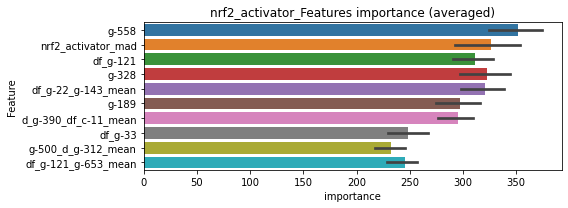

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0740688	valid_1's binary_logloss: 0.0901942
[200]	training's binary_logloss: 0.0189486	valid_1's binary_logloss: 0.0292208
[300]	training's binary_logloss: 0.00596437	valid_1's binary_logloss: 0.011986
[400]	training's binary_logloss: 0.00239902	valid_1's binary_logloss: 0.00628778
[500]	training's binary_logloss: 0.00126645	valid_1's binary_logloss: 0.00413349
[600]	training's binary_logloss: 0.000809318	valid_1's binary_logloss: 0.00309012
[700]	training's binary_logloss: 0.000591486	valid_1's binary_logloss: 0.00258019
[800]	training's binary_logloss: 0.000477242	valid_1's binary_logloss: 0.00225657
[900]	training's binary_logloss: 0.000425847	valid_1's binary_logloss: 0.00214207
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000425939	valid_1's binary_logloss: 0.00214203


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0740167	valid_1's binary_logloss: 0.0915201
[200]	training's binary_logloss: 0.0185743	valid_1's binary_logloss: 0.0298559
[300]	training's binary_logloss: 0.00591712	valid_1's binary_logloss: 0.0136431
[400]	training's binary_logloss: 0.00241183	valid_1's binary_logloss: 0.00908631
[500]	training's binary_logloss: 0.00125128	valid_1's binary_logloss: 0.00700888
[600]	training's binary_logloss: 0.000804154	valid_1's binary_logloss: 0.00609656
[700]	training's binary_logloss: 0.00059252	valid_1's binary_logloss: 0.00576838
[800]	training's binary_logloss: 0.000480553	valid_1's binary_logloss: 0.00566336
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.000452047	valid_1's binary_logloss: 0.00561424


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0744773	valid_1's binary_logloss: 0.0854466
[200]	training's binary_logloss: 0.0193928	valid_1's binary_logloss: 0.0269345
[300]	training's binary_logloss: 0.00604043	valid_1's binary_logloss: 0.0101561
[400]	training's binary_logloss: 0.00244258	valid_1's binary_logloss: 0.0048942
[500]	training's binary_logloss: 0.0012767	valid_1's binary_logloss: 0.00294113
[600]	training's binary_logloss: 0.000807909	valid_1's binary_logloss: 0.00205273
[700]	training's binary_logloss: 0.000595534	valid_1's binary_logloss: 0.00159069
[800]	training's binary_logloss: 0.000475196	valid_1's binary_logloss: 0.00132153
[900]	training's binary_logloss: 0.000425237	valid_1's binary_logloss: 0.0012112
[1000]	training's binary_logloss: 0.00041353	valid_1's binary_logloss: 0.0011854
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.000413517	valid_1's binary_logloss: 0.00118534


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 nrf2_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720509	valid_1's binary_logloss: 0.0948942
[200]	training's binary_logloss: 0.0184126	valid_1's binary_logloss: 0.035442
[300]	training's binary_logloss: 0.00543973	valid_1's binary_logloss: 0.0185086
[400]	training's binary_logloss: 0.00218238	valid_1's binary_logloss: 0.0128272
[500]	training's binary_logloss: 0.00115888	valid_1's binary_logloss: 0.00995239
[600]	training's binary_logloss: 0.000754466	valid_1's binary_logloss: 0.00876335
[700]	training's binary_logloss: 0.000562428	valid_1's binary_logloss: 0.00821327
[800]	training's binary_logloss: 0.00045725	valid_1's binary_logloss: 0.00783942
[900]	training's binary_logloss: 0.000420303	valid_1's binary_logloss: 0.00763831
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000420649	valid_1's binary_logloss: 0.00763783


nrf2_activator logloss: 0.004144981398310708


neg labels: 3289 → selected neg labels: 3280


opioid_receptor_agonist, len(trt): 61, len(othr): 3280, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113782	valid_1's binary_logloss: 0.178044
[200]	training's binary_logloss: 0.0451891	valid_1's binary_logloss: 0.107264
[300]	training's binary_logloss: 0.021337	valid_1's binary_logloss: 0.0779139
[400]	training's binary_logloss: 0.0103382	valid_1's binary_logloss: 0.0602878
[500]	training's binary_logloss: 0.00544593	valid_1's binary_logloss: 0.0510136
[600]	training's binary_logloss: 0.00323413	valid_1's binary_logloss: 0.0449366
[700]	training's binary_logloss: 0.00212754	valid_1's binary_logloss: 0.0417618
[800]	training's binary_logloss: 0.00155387	valid_1's binary_logloss: 0.0398534
[900]	training's binary_logloss: 0.00123854	valid_1's binary_logloss: 0.0386882
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.00112025	valid_1's binary_logloss: 0.0382098
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120221	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0158043, Threshold: 0.0801629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3796
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.05611, conf_1:0.10421
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.0801629
Num_p_label: 23.0, Expected: 10.2, Adj_threshold_2: 0.1301629
Num_p_label: 17.0, Expected: 10.2, Adj_threshold_3: 0.1801629
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_4: 0.2301629
threshold: 0.2301629, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3796, y_label_rate: 0.1717597
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113265	valid_1's binary_logloss: 0.170196
[200]	training's binary_logloss: 0.0426216	valid_1's binary_logloss: 0.102045
[300]	training's binary_logloss: 0.0184913	valid_1's binary_logloss: 0.074454
[400]	training's binary_logloss: 0.00873485	valid_1's binary_logloss: 0.0596777
[500]	training's binary_logloss: 0.00448423	valid_1's binary_logloss: 0.0531015
[600]	training's binary_logloss: 0.00269329	valid_1's binary_logloss: 0.0494222
[700]	training's binary_logloss: 0.00183	valid_1's binary_logloss: 0.0471892
[800]	training's binary_logloss: 0.00136041	valid_1's binary_logloss: 0.0461076
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.00116888	valid_1's binary_logloss: 0.0452045
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112264	valid_1's binary_logloss: 0.166558
[200]	training's binary_logloss: 0.0409729	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.0661301, Threshold: 0.2301629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 18 → Positive_corect_labels: 643.0/3778
p_label_rate: 0.0118031 Vs.target_rate: 0.00256, Num_p_label: 47.0, conf_0:0.18413, conf_1:0.27620
Num_p_label: 47.0, Expected: 10.2, Adj_threshold_1: 0.2301629
Num_p_label: 41.0, Expected: 10.2, Adj_threshold_2: 0.2801629
Num_p_label: 37.0, Expected: 10.2, Adj_threshold_3: 0.3301629
Num_p_label: 36.0, Expected: 10.2, Adj_threshold_4: 0.3801629
Num_p_label: 29.0, Expected: 10.2, Adj_threshold_5: 0.4301629
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_6: 0.4801629
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_7: 0.5301629
Num_p_label: 14.0, Expected: 10.2, Adj_threshold_8: 0.5801629
threshold: 0.5801629, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 643.0/3778, y_label_rate: 0.1701959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109832	valid_1's binary_logloss: 0.159992
[200]	training's binary_logloss: 0.0411293	valid_1's binary_logloss: 0.0956303
[300]	training's binary_logloss: 0.0179721	valid_1's binary_logloss: 0.0701676
[400]	training's binary_logloss: 0.00835505	valid_1's binary_logloss: 0.0566916
[500]	training's binary_logloss: 0.00435712	valid_1's binary_logloss: 0.0500567
[600]	training's binary_logloss: 0.00259477	valid_1's binary_logloss: 0.0472837
[700]	training's binary_logloss: 0.0017669	valid_1's binary_logloss: 0.0452402
Early stopping, best iteration is:
[741]	training's binary_logloss: 0.00155234	valid_1's binary_logloss: 0.0448248
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110732	valid_1's binary_logloss: 0.153936
[200]	training's binary_logloss: 0.0401814	valid_1's binary_logloss: 0.0852169
[300]	training's binary_logloss: 0.0170798	valid_1's 

3 / 3 AUC score:0.999
y_Threshold: 0.0713458, Threshold: 0.5801629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 24 → Positive_corect_labels: 631.0/3754
p_label_rate: 0.0047715 Vs.target_rate: 0.00256, Num_p_label: 19.0, conf_0:0.50000, conf_1:0.63818
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_1: 0.5801629
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_2: 0.6301629
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_3: 0.6801629
threshold: 0.6801629, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 631.0/3754, y_label_rate: 0.1680874


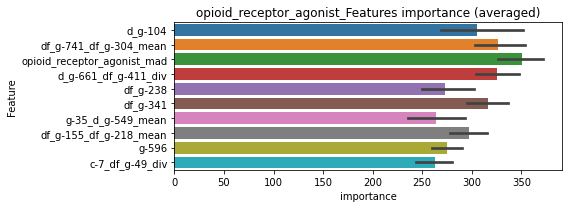

len(train_index) : 2815
len(valid_index) : 939
================================= fold 1/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106153	valid_1's binary_logloss: 0.151147
[200]	training's binary_logloss: 0.0379877	valid_1's binary_logloss: 0.0822135
[300]	training's binary_logloss: 0.0165109	valid_1's binary_logloss: 0.0522406
[400]	training's binary_logloss: 0.00775049	valid_1's binary_logloss: 0.0379
[500]	training's binary_logloss: 0.00401612	valid_1's binary_logloss: 0.0294503
[600]	training's binary_logloss: 0.00242547	valid_1's binary_logloss: 0.0251532
[700]	training's binary_logloss: 0.00165889	valid_1's binary_logloss: 0.0230472
[800]	training's binary_logloss: 0.00125314	valid_1's binary_logloss: 0.0214033
[900]	training's binary_logloss: 0.00101383	valid_1's binary_logloss: 0.0205222
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000919547	valid_1's binary_logloss: 0.020294


len(train_index) : 2815
len(valid_index) : 939
================================= fold 2/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105207	valid_1's binary_logloss: 0.152686
[200]	training's binary_logloss: 0.0370132	valid_1's binary_logloss: 0.0834625
[300]	training's binary_logloss: 0.0153541	valid_1's binary_logloss: 0.0555444
[400]	training's binary_logloss: 0.00707768	valid_1's binary_logloss: 0.043558
[500]	training's binary_logloss: 0.0037501	valid_1's binary_logloss: 0.0369279
[600]	training's binary_logloss: 0.0022828	valid_1's binary_logloss: 0.0337944
[700]	training's binary_logloss: 0.00157799	valid_1's binary_logloss: 0.0320989
[800]	training's binary_logloss: 0.00120894	valid_1's binary_logloss: 0.0305521
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.0011373	valid_1's binary_logloss: 0.030148


len(train_index) : 2816
len(valid_index) : 938
================================= fold 3/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105405	valid_1's binary_logloss: 0.162236
[200]	training's binary_logloss: 0.0379119	valid_1's binary_logloss: 0.0909032
[300]	training's binary_logloss: 0.0162698	valid_1's binary_logloss: 0.0634094
[400]	training's binary_logloss: 0.00762377	valid_1's binary_logloss: 0.0502449
[500]	training's binary_logloss: 0.00395837	valid_1's binary_logloss: 0.0422738
[600]	training's binary_logloss: 0.0024008	valid_1's binary_logloss: 0.0380481
[700]	training's binary_logloss: 0.00164409	valid_1's binary_logloss: 0.035901
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00169895	valid_1's binary_logloss: 0.035699


len(train_index) : 2816
len(valid_index) : 938
================================= fold 4/4 opioid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106942	valid_1's binary_logloss: 0.15184
[200]	training's binary_logloss: 0.0378807	valid_1's binary_logloss: 0.0819169
[300]	training's binary_logloss: 0.0163283	valid_1's binary_logloss: 0.0547288
[400]	training's binary_logloss: 0.00754437	valid_1's binary_logloss: 0.0398482
[500]	training's binary_logloss: 0.00394232	valid_1's binary_logloss: 0.0325115
[600]	training's binary_logloss: 0.0023897	valid_1's binary_logloss: 0.0285971
[700]	training's binary_logloss: 0.00164322	valid_1's binary_logloss: 0.0261748
[800]	training's binary_logloss: 0.00125021	valid_1's binary_logloss: 0.0253047
[900]	training's binary_logloss: 0.00100606	valid_1's binary_logloss: 0.0243661
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00101525	valid_1's binary_logloss: 0.0242565


opioid_receptor_agonist logloss: 0.02759808996537247


neg labels: 3289 → selected neg labels: 3274


opioid_receptor_antagonist, len(trt): 96, len(othr): 3274, target_rate: 0.0040312 → Adj_target_rate: 0.0040656
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146281	valid_1's binary_logloss: 0.2254
[200]	training's binary_logloss: 0.06858	valid_1's binary_logloss: 0.16692
[300]	training's binary_logloss: 0.0344689	valid_1's binary_logloss: 0.139728
[400]	training's binary_logloss: 0.0183717	valid_1's binary_logloss: 0.12771
[500]	training's binary_logloss: 0.0100931	valid_1's binary_logloss: 0.121702
[600]	training's binary_logloss: 0.00590585	valid_1's binary_logloss: 0.119305
Early stopping, best iteration is:
[603]	training's binary_logloss: 0.00581629	valid_1's binary_logloss: 0.119191
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149682	valid_1's binary_logloss: 0.212856
[200]	training's binary_logloss: 0.071345	valid_1's binary_logloss: 0.14158
[300]	training's binary_logloss: 0.0380222	valid_1's binary_logloss: 0.106138
[400]	training's binary_logloss: 0.0205461	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.984
y_Threshold: 0.0461516, Threshold: 0.1836938, pos_neg_ratio: 0.8000000
Remove_noisy_data: 192 → Positive_corect_labels: 624/3736
p_label_rate: 0.0100452 Vs.target_rate: 0.00403, Num_p_label: 40.0, conf_0:0.12859, conf_1:0.23880
Num_p_label: 40.0, Expected: 16.1, Adj_threshold_1: 0.1836938
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_2: 0.2336938
Num_p_label: 26.0, Expected: 16.1, Adj_threshold_3: 0.2836938
Num_p_label: 19.0, Expected: 16.1, Adj_threshold_4: 0.3336938
threshold: 0.3336938, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 624.0/3736, y_label_rate: 0.1670236
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129618	valid_1's binary_logloss: 0.187001
[200]	training's binary_logloss: 0.0532602	valid_1's binary_logloss: 0.114371
[300]	training's binary_logloss: 0.0251037	valid_1's binary_logloss: 0.083173
[400]	training's binary_logloss: 0.0125248	valid_1's binary_logloss: 0.0668642
[500]	training's binary_logloss: 0.00662712	valid_1's binary_logloss: 0.0570918
[600]	training's binary_logloss: 0.00393628	valid_1's binary_logloss: 0.0516063
[700]	training's binary_logloss: 0.00259114	valid_1's binary_logloss: 0.0495161
[800]	training's binary_logloss: 0.00189071	valid_1's binary_logloss: 0.0487305
[900]	training's binary_logloss: 0.00148225	valid_1's binary_logloss: 0.0477609
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.00148225	valid_1's binary_logloss: 0.0477609
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127345	valid_1's

2 / 3 AUC score:0.996
y_Threshold: 0.1066527, Threshold: 0.3336938, pos_neg_ratio: 0.8000000
Remove_noisy_data: 62 → Positive_corect_labels: 593.0/3674
p_label_rate: 0.0160723 Vs.target_rate: 0.00403, Num_p_label: 64.0, conf_0:0.26696, conf_1:0.40043
Num_p_label: 64.0, Expected: 16.1, Adj_threshold_1: 0.3336938
Num_p_label: 56.0, Expected: 16.1, Adj_threshold_2: 0.3836938
Num_p_label: 52.0, Expected: 16.1, Adj_threshold_3: 0.4336938
Num_p_label: 47.0, Expected: 16.1, Adj_threshold_4: 0.4836938
Num_p_label: 37.0, Expected: 16.1, Adj_threshold_5: 0.5336938
Num_p_label: 34.0, Expected: 16.1, Adj_threshold_6: 0.5836938
Num_p_label: 31.0, Expected: 16.1, Adj_threshold_7: 0.6336938
Num_p_label: 25.0, Expected: 16.1, Adj_threshold_8: 0.6836938
Num_p_label: 21.0, Expected: 16.1, Adj_threshold_9: 0.7336938
threshold: 0.7336938, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 593.0/3674, y_label_rate: 0.1614045
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11668	valid_1's binary_logloss: 0.179706
[200]	training's binary_logloss: 0.0452473	valid_1's binary_logloss: 0.113065
[300]	training's binary_logloss: 0.0198061	valid_1's binary_logloss: 0.0863948
[400]	training's binary_logloss: 0.00929419	valid_1's binary_logloss: 0.0733046
[500]	training's binary_logloss: 0.00492789	valid_1's binary_logloss: 0.0680717
[600]	training's binary_logloss: 0.00298358	valid_1's binary_logloss: 0.0657413
Early stopping, best iteration is:
[616]	training's binary_logloss: 0.00278813	valid_1's binary_logloss: 0.0652723
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117415	valid_1's binary_logloss: 0.177628
[200]	training's binary_logloss: 0.0473762	valid_1's binary_logloss: 0.115901
[300]	training's binary_logloss: 0.0217276	valid_1's binary_logloss: 0.0933932
[400]	training's binary_logloss: 0.0102911	valid_1's bin

3 / 3 AUC score:0.991
y_Threshold: 0.1196946, Threshold: 0.7336938, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 569.0/3626
p_label_rate: 0.0090407 Vs.target_rate: 0.00403, Num_p_label: 36.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 36.0, Expected: 16.1, Adj_threshold_1: 0.7336938
Num_p_label: 31.0, Expected: 16.1, Adj_threshold_2: 0.7836938
threshold: 0.7836938, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 569.0/3626, y_label_rate: 0.1569222


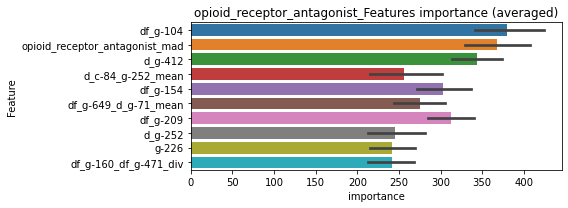

len(train_index) : 2719
len(valid_index) : 907
================================= fold 1/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109264	valid_1's binary_logloss: 0.171964
[200]	training's binary_logloss: 0.040334	valid_1's binary_logloss: 0.105559
[300]	training's binary_logloss: 0.016652	valid_1's binary_logloss: 0.0785517
[400]	training's binary_logloss: 0.00795867	valid_1's binary_logloss: 0.0655657
[500]	training's binary_logloss: 0.00404091	valid_1's binary_logloss: 0.0592234
[600]	training's binary_logloss: 0.00245367	valid_1's binary_logloss: 0.0574794
[700]	training's binary_logloss: 0.00169968	valid_1's binary_logloss: 0.0568977
Early stopping, best iteration is:
[712]	training's binary_logloss: 0.00163466	valid_1's binary_logloss: 0.0567569


len(train_index) : 2719
len(valid_index) : 907
================================= fold 2/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107875	valid_1's binary_logloss: 0.157652
[200]	training's binary_logloss: 0.0402248	valid_1's binary_logloss: 0.0894173
[300]	training's binary_logloss: 0.0167453	valid_1's binary_logloss: 0.0609573
[400]	training's binary_logloss: 0.00772279	valid_1's binary_logloss: 0.0471931
[500]	training's binary_logloss: 0.0040727	valid_1's binary_logloss: 0.0409477
[600]	training's binary_logloss: 0.00248952	valid_1's binary_logloss: 0.0365148
[700]	training's binary_logloss: 0.00172931	valid_1's binary_logloss: 0.0344336
Early stopping, best iteration is:
[754]	training's binary_logloss: 0.00147439	valid_1's binary_logloss: 0.0333804


len(train_index) : 2720
len(valid_index) : 906
================================= fold 3/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11184	valid_1's binary_logloss: 0.14549
[200]	training's binary_logloss: 0.0423642	valid_1's binary_logloss: 0.0777079
[300]	training's binary_logloss: 0.0177311	valid_1's binary_logloss: 0.0517502
[400]	training's binary_logloss: 0.00831796	valid_1's binary_logloss: 0.0396461
[500]	training's binary_logloss: 0.00436224	valid_1's binary_logloss: 0.0335222
[600]	training's binary_logloss: 0.00266298	valid_1's binary_logloss: 0.0307486
[700]	training's binary_logloss: 0.00180927	valid_1's binary_logloss: 0.0284197
[800]	training's binary_logloss: 0.00136353	valid_1's binary_logloss: 0.0271983
[900]	training's binary_logloss: 0.00110318	valid_1's binary_logloss: 0.0264805
[1000]	training's binary_logloss: 0.000952369	valid_1's binary_logloss: 0.0257985
[1100]	training's binary_logloss: 0.000855953	valid_1's binary_logloss: 0.0253321
Early stopping, best iteration is:
[1131]	training's binary_lo

len(train_index) : 2720
len(valid_index) : 906
================================= fold 4/4 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105526	valid_1's binary_logloss: 0.174387
[200]	training's binary_logloss: 0.0398924	valid_1's binary_logloss: 0.109637
[300]	training's binary_logloss: 0.0171809	valid_1's binary_logloss: 0.0830707
[400]	training's binary_logloss: 0.0081991	valid_1's binary_logloss: 0.067973
[500]	training's binary_logloss: 0.00425082	valid_1's binary_logloss: 0.0587858
[600]	training's binary_logloss: 0.00255703	valid_1's binary_logloss: 0.0546002
[700]	training's binary_logloss: 0.00174197	valid_1's binary_logloss: 0.0524093
[800]	training's binary_logloss: 0.00131863	valid_1's binary_logloss: 0.0504055
Early stopping, best iteration is:
[835]	training's binary_logloss: 0.00121787	valid_1's binary_logloss: 0.050059


opioid_receptor_antagonist logloss: 0.041337964996212534


neg labels: 3289 → selected neg labels: 3286


orexin_receptor_antagonist, len(trt): 37, len(othr): 3286, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974015	valid_1's binary_logloss: 0.13919
[200]	training's binary_logloss: 0.0353534	valid_1's binary_logloss: 0.0710785
[300]	training's binary_logloss: 0.0137375	valid_1's binary_logloss: 0.0415082
[400]	training's binary_logloss: 0.00579498	valid_1's binary_logloss: 0.0270345
[500]	training's binary_logloss: 0.00288586	valid_1's binary_logloss: 0.0206435
[600]	training's binary_logloss: 0.00172313	valid_1's binary_logloss: 0.017415
[700]	training's binary_logloss: 0.00117916	valid_1's binary_logloss: 0.0154174
[800]	training's binary_logloss: 0.000900968	valid_1's binary_logloss: 0.0143651
[900]	training's binary_logloss: 0.000741843	valid_1's binary_logloss: 0.0137967
Early stopping, best iteration is:
[901]	training's binary_logloss: 0.000740532	valid_1's binary_logloss: 0.0137911
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0946962	val

1 / 3 AUC score:0.999
y_Threshold: 0.0122476, Threshold: 0.0862540, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 655/3807
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.06038, conf_1:0.11213
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0862540
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.1362540
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_3: 0.1862540
threshold: 0.1862540, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 655.0/3807, y_label_rate: 0.1720515
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0935104	valid_1's binary_logloss: 0.135418
[200]	training's binary_logloss: 0.0295706	valid_1's binary_logloss: 0.0629693
[300]	training's binary_logloss: 0.0109586	valid_1's binary_logloss: 0.0348144
[400]	training's binary_logloss: 0.00458065	valid_1's binary_logloss: 0.021939
[500]	training's binary_logloss: 0.00232179	valid_1's binary_logloss: 0.0155264
[600]	training's binary_logloss: 0.00142736	valid_1's binary_logloss: 0.0118161
[700]	training's binary_logloss: 0.00100942	valid_1's binary_logloss: 0.010127
[800]	training's binary_logloss: 0.000786352	valid_1's binary_logloss: 0.00922993
[900]	training's binary_logloss: 0.000654603	valid_1's binary_logloss: 0.00858897
[1000]	training's binary_logloss: 0.000586513	valid_1's binary_logloss: 0.00834638
[1100]	training's binary_logloss: 0.000561589	valid_1's binary_logloss: 0.0082848
Early stopping, best iteration is:
[1100]	training's bin

2 / 3 AUC score:1.000
y_Threshold: 0.0888263, Threshold: 0.1862540, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 649.0/3795
p_label_rate: 0.0125565 Vs.target_rate: 0.00155, Num_p_label: 50.0, conf_0:0.14900, conf_1:0.22350
Num_p_label: 50.0, Expected: 6.2, Adj_threshold_1: 0.1862540
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_2: 0.2362540
Num_p_label: 37.0, Expected: 6.2, Adj_threshold_3: 0.2862540
Num_p_label: 30.0, Expected: 6.2, Adj_threshold_4: 0.3362540
Num_p_label: 25.0, Expected: 6.2, Adj_threshold_5: 0.3862540
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.4362540
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_7: 0.4862540
threshold: 0.4862540, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 649.0/3795, y_label_rate: 0.1710145
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0903372	valid_1's binary_logloss: 0.125758
[200]	training's binary_logloss: 0.0277295	valid_1's binary_logloss: 0.0566989
[300]	training's binary_logloss: 0.0101821	valid_1's binary_logloss: 0.0341116
[400]	training's binary_logloss: 0.0043107	valid_1's binary_logloss: 0.0246853
[500]	training's binary_logloss: 0.00219415	valid_1's binary_logloss: 0.0207203
[600]	training's binary_logloss: 0.00136093	valid_1's binary_logloss: 0.0182675
[700]	training's binary_logloss: 0.000966872	valid_1's binary_logloss: 0.0171432
[800]	training's binary_logloss: 0.000757875	valid_1's binary_logloss: 0.0158159
Early stopping, best iteration is:
[804]	training's binary_logloss: 0.000751403	valid_1's binary_logloss: 0.0157692
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909049	valid_1's binary_logloss: 0.125546
[200]	training's binary_logloss: 0.0289241	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0972462, Threshold: 0.4862540, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 648.0/3793
p_label_rate: 0.0050226 Vs.target_rate: 0.00155, Num_p_label: 20.0, conf_0:0.43763, conf_1:0.53488
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_1: 0.4862540
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.5362540
threshold: 0.5362540, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 648.0/3793, y_label_rate: 0.1708410


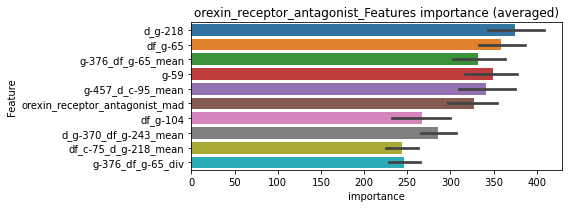

len(train_index) : 2844
len(valid_index) : 949
================================= fold 1/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0896458	valid_1's binary_logloss: 0.128234
[200]	training's binary_logloss: 0.0278215	valid_1's binary_logloss: 0.0606247
[300]	training's binary_logloss: 0.0098315	valid_1's binary_logloss: 0.0344709
[400]	training's binary_logloss: 0.00412832	valid_1's binary_logloss: 0.023883
[500]	training's binary_logloss: 0.00206366	valid_1's binary_logloss: 0.0193116
[600]	training's binary_logloss: 0.00128391	valid_1's binary_logloss: 0.017083
[700]	training's binary_logloss: 0.000915416	valid_1's binary_logloss: 0.0158542
[800]	training's binary_logloss: 0.000723748	valid_1's binary_logloss: 0.0152415
Early stopping, best iteration is:
[836]	training's binary_logloss: 0.000673556	valid_1's binary_logloss: 0.0149041


len(train_index) : 2845
len(valid_index) : 948
================================= fold 2/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0900214	valid_1's binary_logloss: 0.127379
[200]	training's binary_logloss: 0.0278265	valid_1's binary_logloss: 0.0578338
[300]	training's binary_logloss: 0.0101827	valid_1's binary_logloss: 0.0325628
[400]	training's binary_logloss: 0.00432619	valid_1's binary_logloss: 0.0217102
[500]	training's binary_logloss: 0.00221965	valid_1's binary_logloss: 0.0164439
[600]	training's binary_logloss: 0.00136031	valid_1's binary_logloss: 0.013239
[700]	training's binary_logloss: 0.000962367	valid_1's binary_logloss: 0.0117325
[800]	training's binary_logloss: 0.000753534	valid_1's binary_logloss: 0.0111428
[900]	training's binary_logloss: 0.000634898	valid_1's binary_logloss: 0.0106243
[1000]	training's binary_logloss: 0.000569403	valid_1's binary_logloss: 0.0103568
Early stopping, best iteration is:
[1002]	training's binary_logloss: 0.000568104	valid_1's binary_logloss: 0.0103526


len(train_index) : 2845
len(valid_index) : 948
================================= fold 3/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907757	valid_1's binary_logloss: 0.12455
[200]	training's binary_logloss: 0.0282872	valid_1's binary_logloss: 0.0529063
[300]	training's binary_logloss: 0.0101437	valid_1's binary_logloss: 0.0261245
[400]	training's binary_logloss: 0.00429641	valid_1's binary_logloss: 0.0153235
[500]	training's binary_logloss: 0.00218702	valid_1's binary_logloss: 0.0099285
[600]	training's binary_logloss: 0.00134889	valid_1's binary_logloss: 0.00752106
[700]	training's binary_logloss: 0.000962246	valid_1's binary_logloss: 0.00627877
[800]	training's binary_logloss: 0.000755169	valid_1's binary_logloss: 0.00548144
[900]	training's binary_logloss: 0.000635411	valid_1's binary_logloss: 0.00500302
[1000]	training's binary_logloss: 0.000573033	valid_1's binary_logloss: 0.00476574
[1100]	training's binary_logloss: 0.000548491	valid_1's binary_logloss: 0.00469106
Early stopping, best iteration is:
[1141]	training'

len(train_index) : 2845
len(valid_index) : 948
================================= fold 4/4 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915463	valid_1's binary_logloss: 0.115396
[200]	training's binary_logloss: 0.0298019	valid_1's binary_logloss: 0.0503918
[300]	training's binary_logloss: 0.0106256	valid_1's binary_logloss: 0.0274697
[400]	training's binary_logloss: 0.00444735	valid_1's binary_logloss: 0.0185819
[500]	training's binary_logloss: 0.00226518	valid_1's binary_logloss: 0.0140018
[600]	training's binary_logloss: 0.0013901	valid_1's binary_logloss: 0.0122535
[700]	training's binary_logloss: 0.000979643	valid_1's binary_logloss: 0.0110451
[800]	training's binary_logloss: 0.000760952	valid_1's binary_logloss: 0.0103763
[900]	training's binary_logloss: 0.000635522	valid_1's binary_logloss: 0.0100745
[1000]	training's binary_logloss: 0.000574385	valid_1's binary_logloss: 0.00980121
Early stopping, best iteration is:
[999]	training's binary_logloss: 0.000574896	valid_1's binary_logloss: 0.00979268


orexin_receptor_antagonist logloss: 0.009933596366178079


neg labels: 3289 → selected neg labels: 3281


p38_mapk_inhibitor, len(trt): 62, len(othr): 3281, target_rate: 0.0026035 → Adj_target_rate: 0.0028037
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.134414	valid_1's binary_logloss: 0.192575
[200]	training's binary_logloss: 0.0593978	valid_1's binary_logloss: 0.121008
[300]	training's binary_logloss: 0.0297202	valid_1's binary_logloss: 0.088626
[400]	training's binary_logloss: 0.0148628	valid_1's binary_logloss: 0.0701125
[500]	training's binary_logloss: 0.00783433	valid_1's binary_logloss: 0.0582319
[600]	training's binary_logloss: 0.00443005	valid_1's binary_logloss: 0.0504922
[700]	training's binary_logloss: 0.00282903	valid_1's binary_logloss: 0.0464103
[800]	training's binary_logloss: 0.00200021	valid_1's binary_logloss: 0.0439788
[900]	training's binary_logloss: 0.00153869	valid_1's binary_logloss: 0.0428178
[1000]	training's binary_logloss: 0.00124935	valid_1's binary_logloss: 0.0416405
[1100]	training's binary_logloss: 0.00108063	valid_1's binary_logloss: 0.0413095
[1200]	training's binary_logloss: 0.000977608	valid_1's binary_lo

1 / 3 AUC score:0.997
y_Threshold: 0.0276340, Threshold: 0.2012966, pos_neg_ratio: 0.8000000
Remove_noisy_data: 146 → Positive_corect_labels: 649/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00260, Num_p_label: 40.0, conf_0:0.14091, conf_1:0.26169
Num_p_label: 40.0, Expected: 10.4, Adj_threshold_1: 0.2012966
Num_p_label: 29.0, Expected: 10.4, Adj_threshold_2: 0.2512966
Num_p_label: 21.0, Expected: 10.4, Adj_threshold_3: 0.3012966
Num_p_label: 17.0, Expected: 10.4, Adj_threshold_4: 0.3512966
Num_p_label: 16.0, Expected: 10.4, Adj_threshold_5: 0.4012966
Num_p_label: 10.0, Expected: 10.4, Adj_threshold_6: 0.4512966
threshold: 0.4512966, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 649.0/3791, y_label_rate: 0.1711949
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122207	valid_1's binary_logloss: 0.17719
[200]	training's binary_logloss: 0.0490316	valid_1's binary_logloss: 0.103074
[300]	training's binary_logloss: 0.0223204	valid_1's binary_logloss: 0.0708361
[400]	training's binary_logloss: 0.0108468	valid_1's binary_logloss: 0.0527431
[500]	training's binary_logloss: 0.00566755	valid_1's binary_logloss: 0.042541
[600]	training's binary_logloss: 0.00332438	valid_1's binary_logloss: 0.0363418
[700]	training's binary_logloss: 0.00220158	valid_1's binary_logloss: 0.0331829
[800]	training's binary_logloss: 0.00160042	valid_1's binary_logloss: 0.030884
[900]	training's binary_logloss: 0.0012633	valid_1's binary_logloss: 0.0296348
[1000]	training's binary_logloss: 0.00105787	valid_1's binary_logloss: 0.0291195
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.00110425	valid_1's binary_logloss: 0.0290864
Training until validation scores d

2 / 3 AUC score:0.999
y_Threshold: 0.1018467, Threshold: 0.4512966, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 639.0/3771
p_label_rate: 0.0095429 Vs.target_rate: 0.00260, Num_p_label: 38.0, conf_0:0.36104, conf_1:0.54156
Num_p_label: 38.0, Expected: 10.4, Adj_threshold_1: 0.4512966
Num_p_label: 32.0, Expected: 10.4, Adj_threshold_2: 0.5012966
Num_p_label: 28.0, Expected: 10.4, Adj_threshold_3: 0.5512966
Num_p_label: 23.0, Expected: 10.4, Adj_threshold_4: 0.6012966
Num_p_label: 20.0, Expected: 10.4, Adj_threshold_5: 0.6512966
Num_p_label: 16.0, Expected: 10.4, Adj_threshold_6: 0.7012966
Num_p_label: 14.0, Expected: 10.4, Adj_threshold_7: 0.7512966
threshold: 0.7512966, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 639.0/3771, y_label_rate: 0.1694511
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[1141]	training's binary_logloss: 0.000922159	valid_1's binary_logloss: 0.0241845
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123017	valid_1's binary_logloss: 0.170092
[200]	training's binary_logloss: 0.0508651	valid_1's binary_logloss: 0.103174
[300]	training's binary_logloss: 0.0226645	valid_1's binary_logloss: 0.0707603
[400]	training's binary_logloss: 0.0107602	valid_1's binary_logloss: 0.055554
[500]	training's binary_logloss: 0.00552484	valid_1's binary_logloss: 0.0466781
[600]	training's binary_logloss: 0.00323928	valid_1's binary_logloss: 0.0424842
[700]	training's binary_logloss: 0.00213007	valid_1's binary_logloss: 0.0404686
[800]	training's binary_logloss: 0.00154578	valid_1's binary_logloss: 0.0387906
[900]	training's binary_logloss: 0.0012112	valid_1's binary_logloss: 0.037978
[1000]	training's binary_logloss: 0.00102045	valid_1's binary_logloss: 0.0372114
Early stopping, best iteration 

3 / 3 AUC score:0.999
y_Threshold: 0.0848221, Threshold: 0.7512966, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 632.0/3757
p_label_rate: 0.0035158 Vs.target_rate: 0.00260, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.80000
threshold: 0.7512966, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 632.0/3757, y_label_rate: 0.1682193


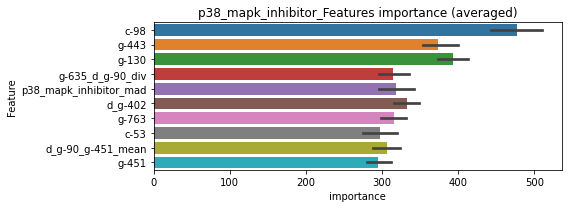

len(train_index) : 2817
len(valid_index) : 940
================================= fold 1/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11815	valid_1's binary_logloss: 0.168069
[200]	training's binary_logloss: 0.0468085	valid_1's binary_logloss: 0.0965584
[300]	training's binary_logloss: 0.0214895	valid_1's binary_logloss: 0.0665329
[400]	training's binary_logloss: 0.010213	valid_1's binary_logloss: 0.0518642
[500]	training's binary_logloss: 0.0052741	valid_1's binary_logloss: 0.0436992
[600]	training's binary_logloss: 0.00306175	valid_1's binary_logloss: 0.0388041
[700]	training's binary_logloss: 0.00202361	valid_1's binary_logloss: 0.0361331
[800]	training's binary_logloss: 0.00149152	valid_1's binary_logloss: 0.0350127
[900]	training's binary_logloss: 0.00117953	valid_1's binary_logloss: 0.0337895
[1000]	training's binary_logloss: 0.000995146	valid_1's binary_logloss: 0.0331671
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000940752	valid_1's binary_logloss: 0.0327951


len(train_index) : 2818
len(valid_index) : 939
================================= fold 2/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118731	valid_1's binary_logloss: 0.169938
[200]	training's binary_logloss: 0.0470022	valid_1's binary_logloss: 0.092996
[300]	training's binary_logloss: 0.0217335	valid_1's binary_logloss: 0.0588842
[400]	training's binary_logloss: 0.0103016	valid_1's binary_logloss: 0.0393076
[500]	training's binary_logloss: 0.00535819	valid_1's binary_logloss: 0.0298809
[600]	training's binary_logloss: 0.0031224	valid_1's binary_logloss: 0.0240006
[700]	training's binary_logloss: 0.00205955	valid_1's binary_logloss: 0.0203157
[800]	training's binary_logloss: 0.00151385	valid_1's binary_logloss: 0.0183629
[900]	training's binary_logloss: 0.00120392	valid_1's binary_logloss: 0.0170833
[1000]	training's binary_logloss: 0.00101402	valid_1's binary_logloss: 0.0163183
[1100]	training's binary_logloss: 0.000901396	valid_1's binary_logloss: 0.0158195
Early stopping, best iteration is:
[1107]	training's binary_logl

len(train_index) : 2818
len(valid_index) : 939
================================= fold 3/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117244	valid_1's binary_logloss: 0.174233
[200]	training's binary_logloss: 0.0461827	valid_1's binary_logloss: 0.10693
[300]	training's binary_logloss: 0.0208278	valid_1's binary_logloss: 0.0779628
[400]	training's binary_logloss: 0.00998587	valid_1's binary_logloss: 0.0614947
[500]	training's binary_logloss: 0.00517474	valid_1's binary_logloss: 0.0532164
[600]	training's binary_logloss: 0.00304301	valid_1's binary_logloss: 0.0471256
[700]	training's binary_logloss: 0.00201777	valid_1's binary_logloss: 0.0441776
[800]	training's binary_logloss: 0.0014908	valid_1's binary_logloss: 0.0422434
[900]	training's binary_logloss: 0.00117795	valid_1's binary_logloss: 0.0409415
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.0011359	valid_1's binary_logloss: 0.0408448


len(train_index) : 2818
len(valid_index) : 939
================================= fold 4/4 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118982	valid_1's binary_logloss: 0.176093
[200]	training's binary_logloss: 0.0454974	valid_1's binary_logloss: 0.101064
[300]	training's binary_logloss: 0.0205258	valid_1's binary_logloss: 0.0672284
[400]	training's binary_logloss: 0.00948924	valid_1's binary_logloss: 0.0493678
[500]	training's binary_logloss: 0.00496105	valid_1's binary_logloss: 0.0410394
[600]	training's binary_logloss: 0.00294886	valid_1's binary_logloss: 0.0368543
[700]	training's binary_logloss: 0.00197744	valid_1's binary_logloss: 0.0349816
[800]	training's binary_logloss: 0.00145973	valid_1's binary_logloss: 0.0332871
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.00135588	valid_1's binary_logloss: 0.032713


p38_mapk_inhibitor logloss: 0.030535361264367285


neg labels: 3289 → selected neg labels: 3288


p-glycoprotein_inhibitor, len(trt): 24, len(othr): 3288, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0819852	valid_1's binary_logloss: 0.115276
[200]	training's binary_logloss: 0.0265315	valid_1's binary_logloss: 0.0551299
[300]	training's binary_logloss: 0.00969624	valid_1's binary_logloss: 0.0344095
[400]	training's binary_logloss: 0.00395155	valid_1's binary_logloss: 0.0249904
[500]	training's binary_logloss: 0.00193435	valid_1's binary_logloss: 0.0218295
[600]	training's binary_logloss: 0.00119486	valid_1's binary_logloss: 0.0196639
[700]	training's binary_logloss: 0.000841279	valid_1's binary_logloss: 0.01906
[800]	training's binary_logloss: 0.000662019	valid_1's binary_logloss: 0.0186451
Early stopping, best iteration is:
[863]	training's binary_logloss: 0.000596454	valid_1's binary_logloss: 0.0183832
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0850164	valid_1's binary_logloss: 0.102559
[200]	training's binary_logloss: 0.0274402	vali

1 / 3 AUC score:1.000
y_Threshold: 0.0071678, Threshold: 0.0530809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.03716, conf_1:0.06901
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0530809
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_2: 0.1030809
Num_p_label: 16.0, Expected: 4.0, Adj_threshold_3: 0.1530809
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_4: 0.2030809
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_5: 0.2530809
threshold: 0.2530809, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794369	valid_1's binary_logloss: 0.102951
[200]	training's binary_logloss: 0.0233273	valid_1's binary_logloss: 0.0408223
[300]	training's binary_logloss: 0.00818316	valid_1's binary_logloss: 0.0198495
[400]	training's binary_logloss: 0.00327115	valid_1's binary_logloss: 0.0116591
[500]	training's binary_logloss: 0.00162659	valid_1's binary_logloss: 0.00844367
[600]	training's binary_logloss: 0.00101812	valid_1's binary_logloss: 0.00717686
[700]	training's binary_logloss: 0.000734445	valid_1's binary_logloss: 0.00639233
[800]	training's binary_logloss: 0.000580028	valid_1's binary_logloss: 0.00596558
[900]	training's binary_logloss: 0.000511923	valid_1's binary_logloss: 0.00584025
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000488918	valid_1's binary_logloss: 0.00575096
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

2 / 3 AUC score:1.000
y_Threshold: 0.1491930, Threshold: 0.2530809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0085384 Vs.target_rate: 0.00101, Num_p_label: 34.0, conf_0:0.20246, conf_1:0.30370
Num_p_label: 34.0, Expected: 4.0, Adj_threshold_1: 0.2530809
Num_p_label: 29.0, Expected: 4.0, Adj_threshold_2: 0.3030809
Num_p_label: 28.0, Expected: 4.0, Adj_threshold_3: 0.3530809
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_4: 0.4030809
Num_p_label: 23.0, Expected: 4.0, Adj_threshold_5: 0.4530809
Num_p_label: 19.0, Expected: 4.0, Adj_threshold_6: 0.5030809
Num_p_label: 17.0, Expected: 4.0, Adj_threshold_7: 0.5530809
Num_p_label: 13.0, Expected: 4.0, Adj_threshold_8: 0.6030809
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_9: 0.6530809
Num_p_label: 12.0, Expected: 4.0, Adj_threshold_10: 0.7030809
threshold: 0.7530809, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794369	valid_1's binary_logloss: 0.102951
[200]	training's binary_logloss: 0.0233273	valid_1's binary_logloss: 0.0408223
[300]	training's binary_logloss: 0.00818316	valid_1's binary_logloss: 0.0198495
[400]	training's binary_logloss: 0.00327115	valid_1's binary_logloss: 0.0116591
[500]	training's binary_logloss: 0.00162659	valid_1's binary_logloss: 0.00844367
[600]	training's binary_logloss: 0.00101812	valid_1's binary_logloss: 0.00717686
[700]	training's binary_logloss: 0.000734445	valid_1's binary_logloss: 0.00639233
[800]	training's binary_logloss: 0.000580028	valid_1's binary_logloss: 0.00596558
[900]	training's binary_logloss: 0.000511923	valid_1's binary_logloss: 0.00584025
Early stopping, best iteration is:
[968]	training's binary_logloss: 0.000488918	valid_1's binary_logloss: 0.00575096
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.1491930, Threshold: 0.7530809, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00101, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 10.0, Expected: 4.0, Adj_threshold_1: 0.7530809
threshold: 0.7530809, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


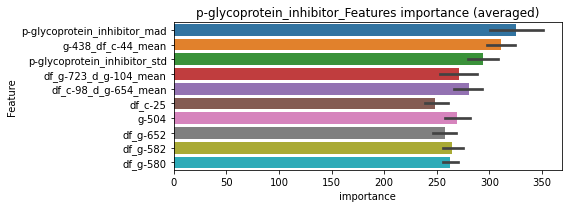

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0807684	valid_1's binary_logloss: 0.104256
[200]	training's binary_logloss: 0.0235113	valid_1's binary_logloss: 0.0403733
[300]	training's binary_logloss: 0.00812374	valid_1's binary_logloss: 0.0193736
[400]	training's binary_logloss: 0.00323757	valid_1's binary_logloss: 0.0114986
[500]	training's binary_logloss: 0.0016295	valid_1's binary_logloss: 0.00821509
[600]	training's binary_logloss: 0.001021	valid_1's binary_logloss: 0.00676319
[700]	training's binary_logloss: 0.000732991	valid_1's binary_logloss: 0.00611363
[800]	training's binary_logloss: 0.000581869	valid_1's binary_logloss: 0.00562309
[900]	training's binary_logloss: 0.000511529	valid_1's binary_logloss: 0.00547899
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000524179	valid_1's binary_logloss: 0.00547086


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0805255	valid_1's binary_logloss: 0.0956655
[200]	training's binary_logloss: 0.0236437	valid_1's binary_logloss: 0.0353483
[300]	training's binary_logloss: 0.00814555	valid_1's binary_logloss: 0.0160527
[400]	training's binary_logloss: 0.003261	valid_1's binary_logloss: 0.0086871
[500]	training's binary_logloss: 0.00165859	valid_1's binary_logloss: 0.00584414
[600]	training's binary_logloss: 0.00102623	valid_1's binary_logloss: 0.00462173
[700]	training's binary_logloss: 0.000738009	valid_1's binary_logloss: 0.00392006
[800]	training's binary_logloss: 0.00058563	valid_1's binary_logloss: 0.00357379
[900]	training's binary_logloss: 0.000513082	valid_1's binary_logloss: 0.00338518
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000496818	valid_1's binary_logloss: 0.0033514


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0833428	valid_1's binary_logloss: 0.101952
[200]	training's binary_logloss: 0.0244996	valid_1's binary_logloss: 0.0383377
[300]	training's binary_logloss: 0.00831127	valid_1's binary_logloss: 0.0175792
[400]	training's binary_logloss: 0.00332864	valid_1's binary_logloss: 0.010587
[500]	training's binary_logloss: 0.0016818	valid_1's binary_logloss: 0.00789602
[600]	training's binary_logloss: 0.00104107	valid_1's binary_logloss: 0.00663204
[700]	training's binary_logloss: 0.000746834	valid_1's binary_logloss: 0.00615353
Early stopping, best iteration is:
[759]	training's binary_logloss: 0.000644522	valid_1's binary_logloss: 0.00602516


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810076	valid_1's binary_logloss: 0.113662
[200]	training's binary_logloss: 0.0237943	valid_1's binary_logloss: 0.0462943
[300]	training's binary_logloss: 0.00818214	valid_1's binary_logloss: 0.0222836
[400]	training's binary_logloss: 0.0032283	valid_1's binary_logloss: 0.012291
[500]	training's binary_logloss: 0.00163566	valid_1's binary_logloss: 0.00845489
[600]	training's binary_logloss: 0.00102248	valid_1's binary_logloss: 0.00667694
[700]	training's binary_logloss: 0.000736094	valid_1's binary_logloss: 0.00564189
[800]	training's binary_logloss: 0.000587189	valid_1's binary_logloss: 0.00516542
[900]	training's binary_logloss: 0.000514804	valid_1's binary_logloss: 0.00489629
[1000]	training's binary_logloss: 0.000483371	valid_1's binary_logloss: 0.00474313
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000484932	valid_1's binary_logloss: 0.00473061


p-glycoprotein_inhibitor logloss: 0.004895701544170658


neg labels: 3289 → selected neg labels: 3281


parp_inhibitor, len(trt): 61, len(othr): 3281, target_rate: 0.0025615 → Adj_target_rate: 0.0027652
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132943	valid_1's binary_logloss: 0.20674
[200]	training's binary_logloss: 0.0570215	valid_1's binary_logloss: 0.131289
[300]	training's binary_logloss: 0.0273594	valid_1's binary_logloss: 0.0962251
[400]	training's binary_logloss: 0.0135455	valid_1's binary_logloss: 0.0775318
[500]	training's binary_logloss: 0.00721398	valid_1's binary_logloss: 0.0674761
[600]	training's binary_logloss: 0.00422099	valid_1's binary_logloss: 0.0624885
[700]	training's binary_logloss: 0.00272738	valid_1's binary_logloss: 0.0585124
[800]	training's binary_logloss: 0.00195033	valid_1's binary_logloss: 0.0575745
[900]	training's binary_logloss: 0.00150824	valid_1's binary_logloss: 0.0565141
Early stopping, best iteration is:
[921]	training's binary_logloss: 0.00144098	valid_1's binary_logloss: 0.0564576
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136038	valid_1's

1 / 3 AUC score:0.997
y_Threshold: 0.0247684, Threshold: 0.0952370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.06667, conf_1:0.12381
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.0952370
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_2: 0.1452370
Num_p_label: 16.0, Expected: 10.2, Adj_threshold_3: 0.1952370
Num_p_label: 10.0, Expected: 10.2, Adj_threshold_4: 0.2452370
threshold: 0.2452370, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127038	valid_1's binary_logloss: 0.193582
[200]	training's binary_logloss: 0.0506612	valid_1's binary_logloss: 0.117039
[300]	training's binary_logloss: 0.0227429	valid_1's binary_logloss: 0.0820865
[400]	training's binary_logloss: 0.0108289	valid_1's binary_logloss: 0.0665314
[500]	training's binary_logloss: 0.00566439	valid_1's binary_logloss: 0.057887
[600]	training's binary_logloss: 0.0033768	valid_1's binary_logloss: 0.0544217
[700]	training's binary_logloss: 0.00223504	valid_1's binary_logloss: 0.0524352
[800]	training's binary_logloss: 0.00162605	valid_1's binary_logloss: 0.0511326
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.00138218	valid_1's binary_logloss: 0.0506354
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130971	valid_1's binary_logloss: 0.18705
[200]	training's binary_logloss: 0.0528367	valid_1's bin

2 / 3 AUC score:0.998
y_Threshold: 0.0963721, Threshold: 0.2452370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 633.0/3759
p_label_rate: 0.0100452 Vs.target_rate: 0.00256, Num_p_label: 40.0, conf_0:0.19619, conf_1:0.29428
Num_p_label: 40.0, Expected: 10.2, Adj_threshold_1: 0.2452370
Num_p_label: 31.0, Expected: 10.2, Adj_threshold_2: 0.2952370
Num_p_label: 24.0, Expected: 10.2, Adj_threshold_3: 0.3452370
Num_p_label: 19.0, Expected: 10.2, Adj_threshold_4: 0.3952370
Num_p_label: 18.0, Expected: 10.2, Adj_threshold_5: 0.4452370
Num_p_label: 13.0, Expected: 10.2, Adj_threshold_6: 0.4952370
threshold: 0.4952370, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 633.0/3759, y_label_rate: 0.1683958
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124196	valid_1's binary_logloss: 0.18816
[200]	training's binary_logloss: 0.0497305	valid_1's binary_logloss: 0.109092
[300]	training's binary_logloss: 0.0217983	valid_1's binary_logloss: 0.0714967
[400]	training's binary_logloss: 0.0102249	valid_1's binary_logloss: 0.0515096
[500]	training's binary_logloss: 0.00530393	valid_1's binary_logloss: 0.0401099
[600]	training's binary_logloss: 0.00313219	valid_1's binary_logloss: 0.0344
[700]	training's binary_logloss: 0.00208204	valid_1's binary_logloss: 0.0303869
[800]	training's binary_logloss: 0.00153781	valid_1's binary_logloss: 0.0277924
[900]	training's binary_logloss: 0.00121781	valid_1's binary_logloss: 0.0263554
[1000]	training's binary_logloss: 0.00101924	valid_1's binary_logloss: 0.0251873
[1100]	training's binary_logloss: 0.00089379	valid_1's binary_logloss: 0.0244987
Early stopping, best iteration is:
[1145]	training's binary_logloss:

3 / 3 AUC score:0.999
y_Threshold: 0.0936044, Threshold: 0.4952370, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 627.0/3747
p_label_rate: 0.0050226 Vs.target_rate: 0.00256, Num_p_label: 20.0, conf_0:0.44571, conf_1:0.54476
Num_p_label: 20.0, Expected: 10.2, Adj_threshold_1: 0.4952370
Num_p_label: 15.0, Expected: 10.2, Adj_threshold_2: 0.5452370
threshold: 0.5452370, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 627.0/3747, y_label_rate: 0.1673339


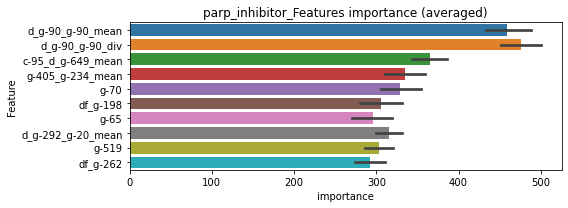

len(train_index) : 2810
len(valid_index) : 937
================================= fold 1/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123252	valid_1's binary_logloss: 0.186034
[200]	training's binary_logloss: 0.0471013	valid_1's binary_logloss: 0.101508
[300]	training's binary_logloss: 0.0202006	valid_1's binary_logloss: 0.0639249
[400]	training's binary_logloss: 0.00948241	valid_1's binary_logloss: 0.0439758
[500]	training's binary_logloss: 0.00493726	valid_1's binary_logloss: 0.033962
[600]	training's binary_logloss: 0.00290844	valid_1's binary_logloss: 0.0284877
[700]	training's binary_logloss: 0.00196616	valid_1's binary_logloss: 0.0259796
[800]	training's binary_logloss: 0.00146304	valid_1's binary_logloss: 0.0238557
[900]	training's binary_logloss: 0.00116828	valid_1's binary_logloss: 0.0226418
[1000]	training's binary_logloss: 0.000985328	valid_1's binary_logloss: 0.0220438
[1100]	training's binary_logloss: 0.000866869	valid_1's binary_logloss: 0.02126
Early stopping, best iteration is:
[1150]	training's binary_logl

len(train_index) : 2810
len(valid_index) : 937
================================= fold 2/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122505	valid_1's binary_logloss: 0.176105
[200]	training's binary_logloss: 0.0489872	valid_1's binary_logloss: 0.0954341
[300]	training's binary_logloss: 0.0211359	valid_1's binary_logloss: 0.0578074
[400]	training's binary_logloss: 0.00984115	valid_1's binary_logloss: 0.0382794
[500]	training's binary_logloss: 0.00512242	valid_1's binary_logloss: 0.0277006
[600]	training's binary_logloss: 0.00300641	valid_1's binary_logloss: 0.0219875
[700]	training's binary_logloss: 0.00201996	valid_1's binary_logloss: 0.0191285
[800]	training's binary_logloss: 0.00149575	valid_1's binary_logloss: 0.0174983
[900]	training's binary_logloss: 0.00118293	valid_1's binary_logloss: 0.0160884
[1000]	training's binary_logloss: 0.000994705	valid_1's binary_logloss: 0.0153409
[1100]	training's binary_logloss: 0.000877086	valid_1's binary_logloss: 0.0148548
[1200]	training's binary_logloss: 0.000802231	valid_1's bina

len(train_index) : 2810
len(valid_index) : 937
================================= fold 3/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120207	valid_1's binary_logloss: 0.185632
[200]	training's binary_logloss: 0.0476717	valid_1's binary_logloss: 0.108017
[300]	training's binary_logloss: 0.0206242	valid_1's binary_logloss: 0.0712557
[400]	training's binary_logloss: 0.00963846	valid_1's binary_logloss: 0.052298
[500]	training's binary_logloss: 0.00498966	valid_1's binary_logloss: 0.0437224
[600]	training's binary_logloss: 0.00293032	valid_1's binary_logloss: 0.0384794
[700]	training's binary_logloss: 0.00196646	valid_1's binary_logloss: 0.036062
[800]	training's binary_logloss: 0.00145736	valid_1's binary_logloss: 0.034396
[900]	training's binary_logloss: 0.00116017	valid_1's binary_logloss: 0.0337368
[1000]	training's binary_logloss: 0.000976733	valid_1's binary_logloss: 0.0331023
[1100]	training's binary_logloss: 0.000866175	valid_1's binary_logloss: 0.0327112
Early stopping, best iteration is:
[1139]	training's binary_logl

len(train_index) : 2811
len(valid_index) : 936
================================= fold 4/4 parp_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121205	valid_1's binary_logloss: 0.178691
[200]	training's binary_logloss: 0.047534	valid_1's binary_logloss: 0.0997688
[300]	training's binary_logloss: 0.0206659	valid_1's binary_logloss: 0.0639539
[400]	training's binary_logloss: 0.00941661	valid_1's binary_logloss: 0.0446967
[500]	training's binary_logloss: 0.00488535	valid_1's binary_logloss: 0.0345696
[600]	training's binary_logloss: 0.00291739	valid_1's binary_logloss: 0.0299234
[700]	training's binary_logloss: 0.00196819	valid_1's binary_logloss: 0.0274699
[800]	training's binary_logloss: 0.00146702	valid_1's binary_logloss: 0.0258292
[900]	training's binary_logloss: 0.00116599	valid_1's binary_logloss: 0.0245587
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.0011254	valid_1's binary_logloss: 0.0242516


parp_inhibitor logloss: 0.023141234815318913


neg labels: 3289 → selected neg labels: 3245


pdgfr_inhibitor, len(trt): 297, len(othr): 3245, target_rate: 0.0124717 → Adj_target_rate: 0.0106179
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.236631	valid_1's binary_logloss: 0.358575
[200]	training's binary_logloss: 0.145409	valid_1's binary_logloss: 0.32511
[300]	training's binary_logloss: 0.0930617	valid_1's binary_logloss: 0.308802
[400]	training's binary_logloss: 0.0626105	valid_1's binary_logloss: 0.299547
[500]	training's binary_logloss: 0.0421951	valid_1's binary_logloss: 0.297255
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0455066	valid_1's binary_logloss: 0.296729
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.239651	valid_1's binary_logloss: 0.36843
[200]	training's binary_logloss: 0.156353	valid_1's binary_logloss: 0.334458
[300]	training's binary_logloss: 0.103281	valid_1's binary_logloss: 0.312762
[400]	training's binary_logloss: 0.0705998	valid_1's binary_logloss: 0.306088
[500]	training's binary_logloss: 0.0487524	valid_1's binary_logloss: 0

1 / 3 AUC score:0.853
y_Threshold: 0.1249802, Threshold: 0.6323099, pos_neg_ratio: 0.8000000
Remove_noisy_data: 512 → Positive_corect_labels: 458/3382
p_label_rate: 0.0100452 Vs.target_rate: 0.01247, Num_p_label: 40.0, conf_0:0.44262, conf_1:0.80000
threshold: 0.6323099, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 458.0/3382, y_label_rate: 0.1354228
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.14342	valid_1's binary_logloss: 0.249735
[200]	training's binary_logloss: 0.0699642	valid_1's binary_logloss: 0.201905
[300]	training's binary_logloss: 0.0376186	valid_1's binary_logloss: 0.178088
[400]	training's binary_logloss: 0.0209134	valid_1's binary_logloss: 0.165962
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.0159759	valid_1's binary_logloss: 0.162578
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148759	valid_1's binary_logloss: 0.231537
[200]	training's binary_logloss: 0.0743969	valid_1's binary_logloss: 0.183239
[300]	training's binary_logloss: 0.0391362	valid_1's binary_logloss: 0.163744
[400]	training's binary_logloss: 0.0217881	valid_1's binary_logloss: 0.156086
[500]	training's binary_logloss: 0.0125103	valid_1's binary_logloss: 0.153255
Early stopping, best iteration is:
[544]	training's binary_logloss

2 / 3 AUC score:0.965
y_Threshold: 0.1131462, Threshold: 0.6323099, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 388.0/3242
p_label_rate: 0.0308890 Vs.target_rate: 0.01247, Num_p_label: 123.0, conf_0:0.50000, conf_1:0.75877
Num_p_label: 123.0, Expected: 49.7, Adj_threshold_1: 0.6323099
Num_p_label: 118.0, Expected: 49.7, Adj_threshold_2: 0.6823099
Num_p_label: 107.0, Expected: 49.7, Adj_threshold_3: 0.7323099
Num_p_label: 88.0, Expected: 49.7, Adj_threshold_4: 0.7823099
threshold: 0.7823099, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 388.0/3242, y_label_rate: 0.1196792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11721	valid_1's binary_logloss: 0.198164
[200]	training's binary_logloss: 0.051572	valid_1's binary_logloss: 0.14533
[300]	training's binary_logloss: 0.0254398	valid_1's binary_logloss: 0.123148
[400]	training's binary_logloss: 0.0133754	valid_1's binary_logloss: 0.11195
[500]	training's binary_logloss: 0.00729583	valid_1's binary_logloss: 0.107605
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.00624786	valid_1's binary_logloss: 0.106514
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114427	valid_1's binary_logloss: 0.192
[200]	training's binary_logloss: 0.0507923	valid_1's binary_logloss: 0.150473
[300]	training's binary_logloss: 0.0247007	valid_1's binary_logloss: 0.134152
[400]	training's binary_logloss: 0.0129955	valid_1's binary_logloss: 0.126727
[500]	training's binary_logloss: 0.00709866	valid_1's binary_logloss: 

3 / 3 AUC score:0.984
y_Threshold: 0.0934968, Threshold: 0.7823099, pos_neg_ratio: 0.8000000
Remove_noisy_data: 80 → Positive_corect_labels: 348.0/3162
p_label_rate: 0.0376695 Vs.target_rate: 0.01247, Num_p_label: 150.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 150.0, Expected: 49.7, Adj_threshold_1: 0.7823099
threshold: 0.7823099, positive_p_label: 150.0/3982, p_label_rate: 0.0376695
positive_y_label: 348.0/3162, y_label_rate: 0.1100569


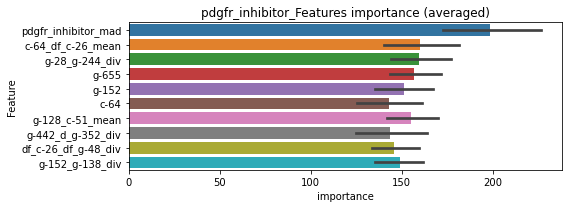

len(train_index) : 2371
len(valid_index) : 791
================================= fold 1/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924897	valid_1's binary_logloss: 0.19206
[200]	training's binary_logloss: 0.0373776	valid_1's binary_logloss: 0.152095
[300]	training's binary_logloss: 0.0166044	valid_1's binary_logloss: 0.136762
[400]	training's binary_logloss: 0.00820418	valid_1's binary_logloss: 0.130498
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00567924	valid_1's binary_logloss: 0.129119


len(train_index) : 2371
len(valid_index) : 791
================================= fold 2/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101076	valid_1's binary_logloss: 0.1555
[200]	training's binary_logloss: 0.0405512	valid_1's binary_logloss: 0.104812
[300]	training's binary_logloss: 0.0186944	valid_1's binary_logloss: 0.0823159
[400]	training's binary_logloss: 0.00901267	valid_1's binary_logloss: 0.0699649
[500]	training's binary_logloss: 0.00492071	valid_1's binary_logloss: 0.0631502
[600]	training's binary_logloss: 0.00307152	valid_1's binary_logloss: 0.0607335
[700]	training's binary_logloss: 0.00212718	valid_1's binary_logloss: 0.0583069
[800]	training's binary_logloss: 0.00161268	valid_1's binary_logloss: 0.0555989
[900]	training's binary_logloss: 0.00130517	valid_1's binary_logloss: 0.0548063
[1000]	training's binary_logloss: 0.00113164	valid_1's binary_logloss: 0.0541424
[1100]	training's binary_logloss: 0.0010275	valid_1's binary_logloss: 0.0536136
Early stopping, best iteration is:
[1089]	training's binary_loglos

len(train_index) : 2372
len(valid_index) : 790
================================= fold 3/4 pdgfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0939573	valid_1's binary_logloss: 0.169362
[200]	training's binary_logloss: 0.0376586	valid_1's binary_logloss: 0.136809
[300]	training's binary_logloss: 0.0169838	valid_1's binary_logloss: 0.124053


len(train_index) : 2372
len(valid_index) : 790
================================= fold 4/4 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.0134095	valid_1's binary_logloss: 0.12264
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103341	valid_1's binary_logloss: 0.154073
[200]	training's binary_logloss: 0.0427413	valid_1's binary_logloss: 0.107262
[300]	training's binary_logloss: 0.0198019	valid_1's binary_logloss: 0.0853732
[400]	training's binary_logloss: 0.00995079	valid_1's binary_logloss: 0.0737655
[500]	training's binary_logloss: 0.00544308	valid_1's binary_logloss: 0.068461
[600]	training's binary_logloss: 0.00333691	valid_1's binary_logloss: 0.0659534
[700]	training's binary_logloss: 0.00228158	valid_1's binary_logloss: 0.0648229
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00231302	valid_1's binary_logloss: 0.0646984


pdgfr_inhibitor logloss: 0.09250381151426616


neg labels: 3289 → selected neg labels: 3284


pdk_inhibitor, len(trt): 18, len(othr): 3284, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0699711	valid_1's binary_logloss: 0.0868849
[200]	training's binary_logloss: 0.0189065	valid_1's binary_logloss: 0.0318318
[300]	training's binary_logloss: 0.00591338	valid_1's binary_logloss: 0.0148466
[400]	training's binary_logloss: 0.0023444	valid_1's binary_logloss: 0.00855483
[500]	training's binary_logloss: 0.00120813	valid_1's binary_logloss: 0.00615754
[600]	training's binary_logloss: 0.000778571	valid_1's binary_logloss: 0.00510238
[700]	training's binary_logloss: 0.000569544	valid_1's binary_logloss: 0.00445492
[800]	training's binary_logloss: 0.000467114	valid_1's binary_logloss: 0.00423536
Early stopping, best iteration is:
[800]	training's binary_logloss: 0.000467114	valid_1's binary_logloss: 0.00423536
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0704573	valid_1's binary_logloss: 0.0827372
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0059967, Threshold: 0.0384766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.02693, conf_1:0.05002
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0384766
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.0884766
Num_p_label: 11.0, Expected: 3.0, Adj_threshold_3: 0.1384766
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_4: 0.1884766
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_5: 0.2384766
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_6: 0.2884766
threshold: 0.2884766, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673145	valid_1's binary_logloss: 0.0839612
[200]	training's binary_logloss: 0.0163978	valid_1's binary_logloss: 0.0282229
[300]	training's binary_logloss: 0.004869	valid_1's binary_logloss: 0.0127377
[400]	training's binary_logloss: 0.00191727	valid_1's binary_logloss: 0.00763458
[500]	training's binary_logloss: 0.00101752	valid_1's binary_logloss: 0.00560229
[600]	training's binary_logloss: 0.000662812	valid_1's binary_logloss: 0.00453941
[700]	training's binary_logloss: 0.000491635	valid_1's binary_logloss: 0.0040089
[800]	training's binary_logloss: 0.000410173	valid_1's binary_logloss: 0.00378854
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000393087	valid_1's binary_logloss: 0.00374118
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673521	valid_1's binary_logloss: 0.0787591
[200]	training's binary_logloss: 0.0163

2 / 3 AUC score:1.000
y_Threshold: 0.0887469, Threshold: 0.2884766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0052737 Vs.target_rate: 0.00076, Num_p_label: 21.0, conf_0:0.23078, conf_1:0.34617
Num_p_label: 21.0, Expected: 3.0, Adj_threshold_1: 0.2884766
Num_p_label: 17.0, Expected: 3.0, Adj_threshold_2: 0.3384766
Num_p_label: 15.0, Expected: 3.0, Adj_threshold_3: 0.3884766
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.4384766
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_5: 0.4884766
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_6: 0.5384766
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_7: 0.5884766
threshold: 0.5884766, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673145	valid_1's binary_logloss: 0.0839612
[200]	training's binary_logloss: 0.0163978	valid_1's binary_logloss: 0.0282229
[300]	training's binary_logloss: 0.004869	valid_1's binary_logloss: 0.0127377
[400]	training's binary_logloss: 0.00191727	valid_1's binary_logloss: 0.00763458
[500]	training's binary_logloss: 0.00101752	valid_1's binary_logloss: 0.00560229
[600]	training's binary_logloss: 0.000662812	valid_1's binary_logloss: 0.00453941
[700]	training's binary_logloss: 0.000491635	valid_1's binary_logloss: 0.0040089
[800]	training's binary_logloss: 0.000410173	valid_1's binary_logloss: 0.00378854
Early stopping, best iteration is:
[856]	training's binary_logloss: 0.000393087	valid_1's binary_logloss: 0.00374118
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0673521	valid_1's binary_logloss: 0.0787591
[200]	training's binary_logloss: 0.0163

3 / 3 AUC score:1.000
y_Threshold: 0.0887469, Threshold: 0.5884766, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.50000, conf_1:0.64732
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.5884766
threshold: 0.5884766, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


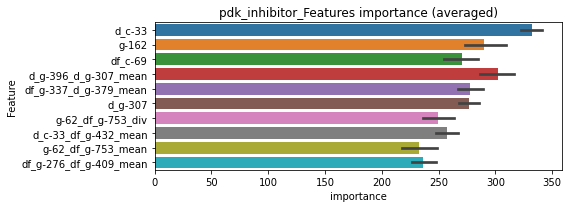

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679451	valid_1's binary_logloss: 0.083041
[200]	training's binary_logloss: 0.0164996	valid_1's binary_logloss: 0.0276707
[300]	training's binary_logloss: 0.00497303	valid_1's binary_logloss: 0.0128796
[400]	training's binary_logloss: 0.00195257	valid_1's binary_logloss: 0.00766223
[500]	training's binary_logloss: 0.00102024	valid_1's binary_logloss: 0.00557352
[600]	training's binary_logloss: 0.000658256	valid_1's binary_logloss: 0.00460338
[700]	training's binary_logloss: 0.000488171	valid_1's binary_logloss: 0.0042116
[800]	training's binary_logloss: 0.000408346	valid_1's binary_logloss: 0.00400236
[900]	training's binary_logloss: 0.000385411	valid_1's binary_logloss: 0.00397581
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00039101	valid_1's binary_logloss: 0.00395352


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0676969	valid_1's binary_logloss: 0.0811155
[200]	training's binary_logloss: 0.0165798	valid_1's binary_logloss: 0.025007
[300]	training's binary_logloss: 0.00501286	valid_1's binary_logloss: 0.0107645
[400]	training's binary_logloss: 0.00196139	valid_1's binary_logloss: 0.00619845
[500]	training's binary_logloss: 0.0010227	valid_1's binary_logloss: 0.00453745
[600]	training's binary_logloss: 0.000666575	valid_1's binary_logloss: 0.0037237
[700]	training's binary_logloss: 0.0004939	valid_1's binary_logloss: 0.00330771
[800]	training's binary_logloss: 0.000409106	valid_1's binary_logloss: 0.00312906
Early stopping, best iteration is:
[862]	training's binary_logloss: 0.000394005	valid_1's binary_logloss: 0.00309721


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0677527	valid_1's binary_logloss: 0.0806705
[200]	training's binary_logloss: 0.0165028	valid_1's binary_logloss: 0.0231292
[300]	training's binary_logloss: 0.00497444	valid_1's binary_logloss: 0.00857235
[400]	training's binary_logloss: 0.00196247	valid_1's binary_logloss: 0.00405141
[500]	training's binary_logloss: 0.00102554	valid_1's binary_logloss: 0.00244675
[600]	training's binary_logloss: 0.000662136	valid_1's binary_logloss: 0.00173915
[700]	training's binary_logloss: 0.000491693	valid_1's binary_logloss: 0.00138466
[800]	training's binary_logloss: 0.000410667	valid_1's binary_logloss: 0.00121146
[900]	training's binary_logloss: 0.000391035	valid_1's binary_logloss: 0.00116838
Early stopping, best iteration is:
[872]	training's binary_logloss: 0.000391035	valid_1's binary_logloss: 0.00116838


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 pdk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674495	valid_1's binary_logloss: 0.0841356
[200]	training's binary_logloss: 0.0163497	valid_1's binary_logloss: 0.0264989
[300]	training's binary_logloss: 0.00490094	valid_1's binary_logloss: 0.0110626
[400]	training's binary_logloss: 0.00192183	valid_1's binary_logloss: 0.00619109
[500]	training's binary_logloss: 0.00100013	valid_1's binary_logloss: 0.00429108
[600]	training's binary_logloss: 0.000648306	valid_1's binary_logloss: 0.00336497
[700]	training's binary_logloss: 0.000482667	valid_1's binary_logloss: 0.00282017
[800]	training's binary_logloss: 0.000403692	valid_1's binary_logloss: 0.00258772
[900]	training's binary_logloss: 0.000377271	valid_1's binary_logloss: 0.00249798
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000377271	valid_1's binary_logloss: 0.00249798


pdk_inhibitor logloss: 0.0026805118900217455


neg labels: 3289 → selected neg labels: 3248


phosphodiesterase_inhibitor, len(trt): 264, len(othr): 3248, target_rate: 0.0110859 → Adj_target_rate: 0.0096064
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.222244	valid_1's binary_logloss: 0.37799
[200]	training's binary_logloss: 0.134172	valid_1's binary_logloss: 0.35223
[300]	training's binary_logloss: 0.0888108	valid_1's binary_logloss: 0.342404
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0793472	valid_1's binary_logloss: 0.341104
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.232949	valid_1's binary_logloss: 0.350655
[200]	training's binary_logloss: 0.140418	valid_1's binary_logloss: 0.31181
[300]	training's binary_logloss: 0.0899968	valid_1's binary_logloss: 0.292656
[400]	training's binary_logloss: 0.0603381	valid_1's binary_logloss: 0.281747
[500]	training's binary_logloss: 0.040731	valid_1's binary_logloss: 0.279223
[600]	training's binary_logloss: 0.0273077	valid_1's binary_logloss: 0.27738
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.02

1 / 3 AUC score:0.856
y_Threshold: 0.1386736, Threshold: 0.4389100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 535 → Positive_corect_labels: 447/3362
p_label_rate: 0.0100452 Vs.target_rate: 0.01109, Num_p_label: 40.0, conf_0:0.30724, conf_1:0.57058
threshold: 0.4389100, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 447.0/3362, y_label_rate: 0.1329566
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12599	valid_1's binary_logloss: 0.223308
[200]	training's binary_logloss: 0.0572274	valid_1's binary_logloss: 0.179561
[300]	training's binary_logloss: 0.0276712	valid_1's binary_logloss: 0.160014
[400]	training's binary_logloss: 0.0145618	valid_1's binary_logloss: 0.153086
[500]	training's binary_logloss: 0.00800156	valid_1's binary_logloss: 0.151363
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00846539	valid_1's binary_logloss: 0.151258
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129397	valid_1's binary_logloss: 0.198087
[200]	training's binary_logloss: 0.0582993	valid_1's binary_logloss: 0.144164
[300]	training's binary_logloss: 0.0296577	valid_1's binary_logloss: 0.117424
[400]	training's binary_logloss: 0.0157233	valid_1's binary_logloss: 0.105259
[500]	training's binary_logloss: 0.00886135	valid_1's binary_log

2 / 3 AUC score:0.977
y_Threshold: 0.1270209, Threshold: 0.4389100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 118 → Positive_corect_labels: 388.0/3244
p_label_rate: 0.0462079 Vs.target_rate: 0.01109, Num_p_label: 184.0, conf_0:0.35113, conf_1:0.52669
Num_p_label: 184.0, Expected: 44.1, Adj_threshold_1: 0.4389100
Num_p_label: 153.0, Expected: 44.1, Adj_threshold_2: 0.4889100
Num_p_label: 135.0, Expected: 44.1, Adj_threshold_3: 0.5389100
Num_p_label: 111.0, Expected: 44.1, Adj_threshold_4: 0.5889100
Num_p_label: 99.0, Expected: 44.1, Adj_threshold_5: 0.6389100
Num_p_label: 86.0, Expected: 44.1, Adj_threshold_6: 0.6889100
Num_p_label: 67.0, Expected: 44.1, Adj_threshold_7: 0.7389100
Num_p_label: 53.0, Expected: 44.1, Adj_threshold_8: 0.7889100
threshold: 0.7889100, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 388.0/3244, y_label_rate: 0.1196054
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104984	valid_1's binary_logloss: 0.183331
[200]	training's binary_logloss: 0.0426774	valid_1's binary_logloss: 0.139099
[300]	training's binary_logloss: 0.0190947	valid_1's binary_logloss: 0.12447
[400]	training's binary_logloss: 0.00946166	valid_1's binary_logloss: 0.11719
[500]	training's binary_logloss: 0.00511596	valid_1's binary_logloss: 0.114272
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.00565288	valid_1's binary_logloss: 0.113569
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.099042	valid_1's binary_logloss: 0.17204
[200]	training's binary_logloss: 0.0410914	valid_1's binary_logloss: 0.125376
[300]	training's binary_logloss: 0.0187989	valid_1's binary_logloss: 0.104285
[400]	training's binary_logloss: 0.0094202	valid_1's binary_logloss: 0.0952327
[500]	training's binary_logloss: 0.00514385	valid_1's binary_log

3 / 3 AUC score:0.991
y_Threshold: 0.1185710, Threshold: 0.7889100, pos_neg_ratio: 0.8000000
Remove_noisy_data: 74 → Positive_corect_labels: 351.0/3170
p_label_rate: 0.0278754 Vs.target_rate: 0.01109, Num_p_label: 111.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 111.0, Expected: 44.1, Adj_threshold_1: 0.7889100
threshold: 0.7889100, positive_p_label: 111.0/3982, p_label_rate: 0.0278754
positive_y_label: 351.0/3170, y_label_rate: 0.1107256


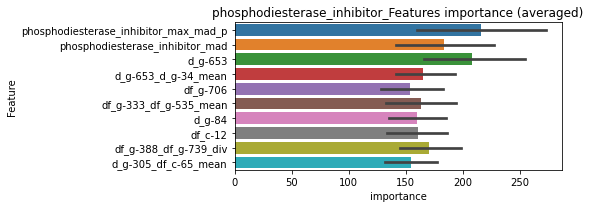

len(train_index) : 2377
len(valid_index) : 793
================================= fold 1/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0889421	valid_1's binary_logloss: 0.149535
[200]	training's binary_logloss: 0.0325058	valid_1's binary_logloss: 0.100536
[300]	training's binary_logloss: 0.0139855	valid_1's binary_logloss: 0.0787843
[400]	training's binary_logloss: 0.00672598	valid_1's binary_logloss: 0.0678799
[500]	training's binary_logloss: 0.00358542	valid_1's binary_logloss: 0.0610896
[600]	training's binary_logloss: 0.00223389	valid_1's binary_logloss: 0.0584015
[700]	training's binary_logloss: 0.00156975	valid_1's binary_logloss: 0.0558234
Early stopping, best iteration is:
[716]	training's binary_logloss: 0.00149172	valid_1's binary_logloss: 0.0551986


len(train_index) : 2377
len(valid_index) : 793
================================= fold 2/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891423	valid_1's binary_logloss: 0.143042
[200]	training's binary_logloss: 0.0335026	valid_1's binary_logloss: 0.0944605
[300]	training's binary_logloss: 0.0143679	valid_1's binary_logloss: 0.0715322
[400]	training's binary_logloss: 0.00685498	valid_1's binary_logloss: 0.0606944
[500]	training's binary_logloss: 0.00367799	valid_1's binary_logloss: 0.0532948
[600]	training's binary_logloss: 0.00230222	valid_1's binary_logloss: 0.0501623
[700]	training's binary_logloss: 0.00161244	valid_1's binary_logloss: 0.0476844
[800]	training's binary_logloss: 0.00122705	valid_1's binary_logloss: 0.0463292
[900]	training's binary_logloss: 0.00100712	valid_1's binary_logloss: 0.044507
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000995895	valid_1's binary_logloss: 0.0443822


len(train_index) : 2378
len(valid_index) : 792
================================= fold 3/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0894698	valid_1's binary_logloss: 0.145777
[200]	training's binary_logloss: 0.0338022	valid_1's binary_logloss: 0.0944329
[300]	training's binary_logloss: 0.0144523	valid_1's binary_logloss: 0.0736856
[400]	training's binary_logloss: 0.00672502	valid_1's binary_logloss: 0.0625294
[500]	training's binary_logloss: 0.00364031	valid_1's binary_logloss: 0.0563941
[600]	training's binary_logloss: 0.0022636	valid_1's binary_logloss: 0.0537738
[700]	training's binary_logloss: 0.00157917	valid_1's binary_logloss: 0.0524489
[800]	training's binary_logloss: 0.00121168	valid_1's binary_logloss: 0.0514247
Early stopping, best iteration is:
[821]	training's binary_logloss: 0.001156	valid_1's binary_logloss: 0.0510229


len(train_index) : 2378
len(valid_index) : 792
================================= fold 4/4 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0876404	valid_1's binary_logloss: 0.135133
[200]	training's binary_logloss: 0.0345491	valid_1's binary_logloss: 0.0933532
[300]	training's binary_logloss: 0.0144726	valid_1's binary_logloss: 0.0749159
[400]	training's binary_logloss: 0.00687621	valid_1's binary_logloss: 0.0647865
[500]	training's binary_logloss: 0.00371296	valid_1's binary_logloss: 0.061648
[600]	training's binary_logloss: 0.00228914	valid_1's binary_logloss: 0.0592919
Early stopping, best iteration is:
[658]	training's binary_logloss: 0.00182461	valid_1's binary_logloss: 0.0579766


phosphodiesterase_inhibitor logloss: 0.052143570990050354


neg labels: 3289 → selected neg labels: 3286


phospholipase_inhibitor, len(trt): 25, len(othr): 3286, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968629	valid_1's binary_logloss: 0.121009
[200]	training's binary_logloss: 0.034837	valid_1's binary_logloss: 0.0542871
[300]	training's binary_logloss: 0.0139842	valid_1's binary_logloss: 0.028717
[400]	training's binary_logloss: 0.00587915	valid_1's binary_logloss: 0.0169465
[500]	training's binary_logloss: 0.00286799	valid_1's binary_logloss: 0.0115632
[600]	training's binary_logloss: 0.00167876	valid_1's binary_logloss: 0.00897886
[700]	training's binary_logloss: 0.00114109	valid_1's binary_logloss: 0.00769058
[800]	training's binary_logloss: 0.000861385	valid_1's binary_logloss: 0.00686006
[900]	training's binary_logloss: 0.000706759	valid_1's binary_logloss: 0.00638472
[1000]	training's binary_logloss: 0.000629246	valid_1's binary_logloss: 0.00619566
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.000605928	valid_1's binary_logloss: 0.00608686
Training until val

1 / 3 AUC score:1.000
y_Threshold: 0.0094047, Threshold: 0.0620422, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.04343, conf_1:0.08065
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0620422
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.1120422
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.1620422
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_4: 0.2120422
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.2620422
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_6: 0.3120422
threshold: 0.3120422, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0946351	valid_1's binary_logloss: 0.117425
[200]	training's binary_logloss: 0.0310635	valid_1's binary_logloss: 0.0489035
[300]	training's binary_logloss: 0.0120315	valid_1's binary_logloss: 0.0245887
[400]	training's binary_logloss: 0.00496695	valid_1's binary_logloss: 0.0136577
[500]	training's binary_logloss: 0.0024644	valid_1's binary_logloss: 0.00864261
[600]	training's binary_logloss: 0.00146219	valid_1's binary_logloss: 0.00638615
[700]	training's binary_logloss: 0.00101247	valid_1's binary_logloss: 0.00529865
[800]	training's binary_logloss: 0.00077969	valid_1's binary_logloss: 0.00465037
[900]	training's binary_logloss: 0.000644992	valid_1's binary_logloss: 0.00418873
[1000]	training's binary_logloss: 0.000583888	valid_1's binary_logloss: 0.00401359
Early stopping, best iteration is:
[1037]	training's binary_logloss: 0.000565617	valid_1's binary_logloss: 0.0039704
Training until val

2 / 3 AUC score:1.000
y_Threshold: 0.0725382, Threshold: 0.3120422, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0060271 Vs.target_rate: 0.00105, Num_p_label: 24.0, conf_0:0.24963, conf_1:0.37445
Num_p_label: 24.0, Expected: 4.2, Adj_threshold_1: 0.3120422
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_2: 0.3620422
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_3: 0.4120422
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.4620422
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_5: 0.5120422
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.5620422
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.6120422
threshold: 0.6120422, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951198	valid_1's binary_logloss: 0.13158
[200]	training's binary_logloss: 0.0314654	valid_1's binary_logloss: 0.0604526
[300]	training's binary_logloss: 0.012047	valid_1's binary_logloss: 0.033937
[400]	training's binary_logloss: 0.00491092	valid_1's binary_logloss: 0.0211695
[500]	training's binary_logloss: 0.00241365	valid_1's binary_logloss: 0.0152375
[600]	training's binary_logloss: 0.00144218	valid_1's binary_logloss: 0.012559
[700]	training's binary_logloss: 0.000980781	valid_1's binary_logloss: 0.0112558
[800]	training's binary_logloss: 0.000751895	valid_1's binary_logloss: 0.0103529
[900]	training's binary_logloss: 0.00062258	valid_1's binary_logloss: 0.00989672
Early stopping, best iteration is:
[883]	training's binary_logloss: 0.000640178	valid_1's binary_logloss: 0.00987362
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958871	val

3 / 3 AUC score:1.000
y_Threshold: 0.1101941, Threshold: 0.6120422, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.50000, conf_1:0.67325
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_1: 0.6120422
threshold: 0.6120422, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3809, y_label_rate: 0.1722237


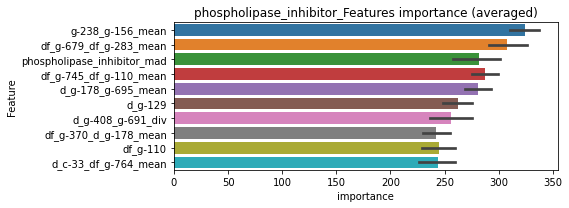

len(train_index) : 2856
len(valid_index) : 953
================================= fold 1/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.095663	valid_1's binary_logloss: 0.130555
[200]	training's binary_logloss: 0.0313529	valid_1's binary_logloss: 0.059657
[300]	training's binary_logloss: 0.0117373	valid_1's binary_logloss: 0.0320252
[400]	training's binary_logloss: 0.00480462	valid_1's binary_logloss: 0.0199751
[500]	training's binary_logloss: 0.00237694	valid_1's binary_logloss: 0.0146618
[600]	training's binary_logloss: 0.00141607	valid_1's binary_logloss: 0.0122502
[700]	training's binary_logloss: 0.000972305	valid_1's binary_logloss: 0.0108678
[800]	training's binary_logloss: 0.000748543	valid_1's binary_logloss: 0.0101096
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000652612	valid_1's binary_logloss: 0.00967014


len(train_index) : 2857
len(valid_index) : 952
================================= fold 2/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961134	valid_1's binary_logloss: 0.129642
[200]	training's binary_logloss: 0.0317218	valid_1's binary_logloss: 0.055891
[300]	training's binary_logloss: 0.0119198	valid_1's binary_logloss: 0.029063
[400]	training's binary_logloss: 0.00497769	valid_1's binary_logloss: 0.0175354
[500]	training's binary_logloss: 0.00243098	valid_1's binary_logloss: 0.0119427
[600]	training's binary_logloss: 0.00145155	valid_1's binary_logloss: 0.0093727
[700]	training's binary_logloss: 0.00100239	valid_1's binary_logloss: 0.00800142
[800]	training's binary_logloss: 0.000768952	valid_1's binary_logloss: 0.00734803
[900]	training's binary_logloss: 0.000638182	valid_1's binary_logloss: 0.00699
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000594331	valid_1's binary_logloss: 0.00682867


len(train_index) : 2857
len(valid_index) : 952
================================= fold 3/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.097014	valid_1's binary_logloss: 0.115047
[200]	training's binary_logloss: 0.0312716	valid_1's binary_logloss: 0.0437023
[300]	training's binary_logloss: 0.0119346	valid_1's binary_logloss: 0.0205337
[400]	training's binary_logloss: 0.00495833	valid_1's binary_logloss: 0.0111346
[500]	training's binary_logloss: 0.00243013	valid_1's binary_logloss: 0.00691595
[600]	training's binary_logloss: 0.00145469	valid_1's binary_logloss: 0.00520479
[700]	training's binary_logloss: 0.00100377	valid_1's binary_logloss: 0.00430636
[800]	training's binary_logloss: 0.000776065	valid_1's binary_logloss: 0.00386006
[900]	training's binary_logloss: 0.000644169	valid_1's binary_logloss: 0.00355295
[1000]	training's binary_logloss: 0.000580037	valid_1's binary_logloss: 0.00341289
Early stopping, best iteration is:
[1028]	training's binary_logloss: 0.000575019	valid_1's binary_logloss: 0.00339829


len(train_index) : 2857
len(valid_index) : 952
================================= fold 4/4 phospholipase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958123	valid_1's binary_logloss: 0.11972
[200]	training's binary_logloss: 0.031788	valid_1's binary_logloss: 0.0499993
[300]	training's binary_logloss: 0.0122468	valid_1's binary_logloss: 0.0248354
[400]	training's binary_logloss: 0.00498971	valid_1's binary_logloss: 0.0138359
[500]	training's binary_logloss: 0.00244749	valid_1's binary_logloss: 0.00870645
[600]	training's binary_logloss: 0.00144838	valid_1's binary_logloss: 0.00654101
[700]	training's binary_logloss: 0.00100209	valid_1's binary_logloss: 0.00536264
[800]	training's binary_logloss: 0.000770387	valid_1's binary_logloss: 0.00463581
[900]	training's binary_logloss: 0.00063776	valid_1's binary_logloss: 0.00428766
[1000]	training's binary_logloss: 0.000574073	valid_1's binary_logloss: 0.00407551
[1100]	training's binary_logloss: 0.000542925	valid_1's binary_logloss: 0.00398842
Early stopping, best iteration is:
[1074]	training's 

phospholipase_inhibitor logloss: 0.005971898778993367


neg labels: 3289 → selected neg labels: 3262


pi3k_inhibitor, len(trt): 151, len(othr): 3262, target_rate: 0.0063408 → Adj_target_rate: 0.0059749
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.181244	valid_1's binary_logloss: 0.30149
[200]	training's binary_logloss: 0.100189	valid_1's binary_logloss: 0.251889
[300]	training's binary_logloss: 0.0572038	valid_1's binary_logloss: 0.225423
[400]	training's binary_logloss: 0.034511	valid_1's binary_logloss: 0.21257
[500]	training's binary_logloss: 0.0211147	valid_1's binary_logloss: 0.205437
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.0152751	valid_1's binary_logloss: 0.203304
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.185553	valid_1's binary_logloss: 0.294431
[200]	training's binary_logloss: 0.102758	valid_1's binary_logloss: 0.240613
[300]	training's binary_logloss: 0.0606543	valid_1's binary_logloss: 0.210559
[400]	training's binary_logloss: 0.0371693	valid_1's binary_logloss: 0.194856
[500]	training's binary_logloss: 0.022236	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.945
y_Threshold: 0.0954353, Threshold: 0.3252340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 319 → Positive_corect_labels: 558/3595
p_label_rate: 0.0100452 Vs.target_rate: 0.00634, Num_p_label: 40.0, conf_0:0.22766, conf_1:0.42280
Num_p_label: 40.0, Expected: 25.2, Adj_threshold_1: 0.3252340
Num_p_label: 28.0, Expected: 25.2, Adj_threshold_2: 0.3752340
threshold: 0.3752340, positive_p_label: 28.0/3982, p_label_rate: 0.0070316
positive_y_label: 558.0/3595, y_label_rate: 0.1552156
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141317	valid_1's binary_logloss: 0.218615
[200]	training's binary_logloss: 0.0664495	valid_1's binary_logloss: 0.158255
[300]	training's binary_logloss: 0.0330869	valid_1's binary_logloss: 0.123388
[400]	training's binary_logloss: 0.0174927	valid_1's binary_logloss: 0.105175
[500]	training's binary_logloss: 0.00945909	valid_1's binary_logloss: 0.0939879
[600]	training's binary_logloss: 0.005587	valid_1's binary_logloss: 0.0862417
[700]	training's binary_logloss: 0.00363061	valid_1's binary_logloss: 0.0836939
[800]	training's binary_logloss: 0.00256561	valid_1's binary_logloss: 0.0817819
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00245784	valid_1's binary_logloss: 0.0812381
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130878	valid_1's binary_logloss: 0.238859
[200]	training's binary_logloss: 0.0592498	valid_1's bina

2 / 3 AUC score:0.980
y_Threshold: 0.1406644, Threshold: 0.3752340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 100 → Positive_corect_labels: 508.0/3495
p_label_rate: 0.0323958 Vs.target_rate: 0.00634, Num_p_label: 129.0, conf_0:0.30019, conf_1:0.45028
Num_p_label: 129.0, Expected: 25.2, Adj_threshold_1: 0.3752340
Num_p_label: 111.0, Expected: 25.2, Adj_threshold_2: 0.4252340
Num_p_label: 96.0, Expected: 25.2, Adj_threshold_3: 0.4752340
Num_p_label: 87.0, Expected: 25.2, Adj_threshold_4: 0.5252340
Num_p_label: 80.0, Expected: 25.2, Adj_threshold_5: 0.5752340
Num_p_label: 70.0, Expected: 25.2, Adj_threshold_6: 0.6252340
Num_p_label: 62.0, Expected: 25.2, Adj_threshold_7: 0.6752340
Num_p_label: 53.0, Expected: 25.2, Adj_threshold_8: 0.7252340
Num_p_label: 42.0, Expected: 25.2, Adj_threshold_9: 0.7752340
threshold: 0.7752340, positive_p_label: 42.0/3982, p_label_rate: 0.0105475
positive_y_label: 508.0/3495, y_label_rate: 0.1453505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109572	valid_1's binary_logloss: 0.202834
[200]	training's binary_logloss: 0.0463621	valid_1's binary_logloss: 0.147972
[300]	training's binary_logloss: 0.0213661	valid_1's binary_logloss: 0.12063
[400]	training's binary_logloss: 0.0106554	valid_1's binary_logloss: 0.106718
[500]	training's binary_logloss: 0.00565922	valid_1's binary_logloss: 0.0999996
[600]	training's binary_logloss: 0.00340637	valid_1's binary_logloss: 0.0944466
[700]	training's binary_logloss: 0.00229663	valid_1's binary_logloss: 0.0925327
Early stopping, best iteration is:
[723]	training's binary_logloss: 0.00212223	valid_1's binary_logloss: 0.092159
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112167	valid_1's binary_logloss: 0.169914
[200]	training's binary_logloss: 0.0464611	valid_1's binary_logloss: 0.117361
[300]	training's binary_logloss: 0.0215926	valid_1's binary

3 / 3 AUC score:0.990
y_Threshold: 0.1614709, Threshold: 0.7752340, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 474.0/3427
p_label_rate: 0.0208438 Vs.target_rate: 0.00634, Num_p_label: 83.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 83.0, Expected: 25.2, Adj_threshold_1: 0.7752340
threshold: 0.7752340, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 474.0/3427, y_label_rate: 0.1383134


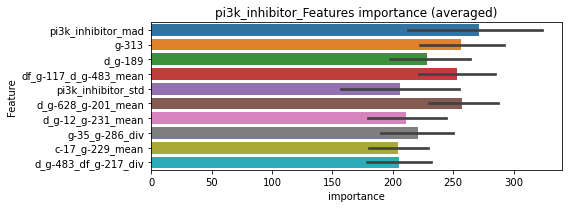

len(train_index) : 2570
len(valid_index) : 857
================================= fold 1/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0943827	valid_1's binary_logloss: 0.191172
[200]	training's binary_logloss: 0.0354212	valid_1's binary_logloss: 0.147292
[300]	training's binary_logloss: 0.0160312	valid_1's binary_logloss: 0.130536
[400]	training's binary_logloss: 0.00793092	valid_1's binary_logloss: 0.122921


len(train_index) : 2570
len(valid_index) : 857


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00738444	valid_1's binary_logloss: 0.122657


================================= fold 2/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100998	valid_1's binary_logloss: 0.151222
[200]	training's binary_logloss: 0.0397865	valid_1's binary_logloss: 0.093214
[300]	training's binary_logloss: 0.0179956	valid_1's binary_logloss: 0.06428
[400]	training's binary_logloss: 0.00865889	valid_1's binary_logloss: 0.0489081
[500]	training's binary_logloss: 0.0046088	valid_1's binary_logloss: 0.0403537
[600]	training's binary_logloss: 0.00281393	valid_1's binary_logloss: 0.035579
[700]	training's binary_logloss: 0.00194223	valid_1's binary_logloss: 0.0325988
[800]	training's binary_logloss: 0.0014633	valid_1's binary_logloss: 0.0304397
[900]	training's binary_logloss: 0.00118398	valid_1's binary_logloss: 0.0293186
[1000]	training's binary_logloss: 0.00101728	valid_1's binary_logloss: 0.0283913
[1100]	training's binary_logloss: 0.000914108	valid_1's binary_logloss: 0.0279219
[1200]	training's binary_logloss: 0.000852694	valid_1's binary_logl

len(train_index) : 2570
len(valid_index) : 857
================================= fold 3/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0984271	valid_1's binary_logloss: 0.174295
[200]	training's binary_logloss: 0.0372451	valid_1's binary_logloss: 0.12352
[300]	training's binary_logloss: 0.016459	valid_1's binary_logloss: 0.101926
[400]	training's binary_logloss: 0.0077868	valid_1's binary_logloss: 0.0923864
[500]	training's binary_logloss: 0.00417154	valid_1's binary_logloss: 0.087802
Early stopping, best iteration is:
[542]	training's binary_logloss: 0.0033724	valid_1's binary_logloss: 0.0872241


len(train_index) : 2571
len(valid_index) : 856
================================= fold 4/4 pi3k_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100318	valid_1's binary_logloss: 0.156772
[200]	training's binary_logloss: 0.0395241	valid_1's binary_logloss: 0.104964
[300]	training's binary_logloss: 0.0178258	valid_1's binary_logloss: 0.0835923
[400]	training's binary_logloss: 0.00848142	valid_1's binary_logloss: 0.0713438
[500]	training's binary_logloss: 0.00451432	valid_1's binary_logloss: 0.0661185
[600]	training's binary_logloss: 0.00276112	valid_1's binary_logloss: 0.0636549
[700]	training's binary_logloss: 0.00189175	valid_1's binary_logloss: 0.0619541
Early stopping, best iteration is:
[713]	training's binary_logloss: 0.00181445	valid_1's binary_logloss: 0.0617828


pi3k_inhibitor logloss: 0.0747161303003158


neg labels: 3289 → selected neg labels: 3286


pkc_inhibitor, len(trt): 31, len(othr): 3286, target_rate: 0.0013018 → Adj_target_rate: 0.0015554
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0927547	valid_1's binary_logloss: 0.134911
[200]	training's binary_logloss: 0.0332434	valid_1's binary_logloss: 0.0692547
[300]	training's binary_logloss: 0.0131279	valid_1's binary_logloss: 0.0421645
[400]	training's binary_logloss: 0.00561049	valid_1's binary_logloss: 0.031109
[500]	training's binary_logloss: 0.00277025	valid_1's binary_logloss: 0.026632
[600]	training's binary_logloss: 0.00167403	valid_1's binary_logloss: 0.0256283
[700]	training's binary_logloss: 0.00116093	valid_1's binary_logloss: 0.0241345
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00121815	valid_1's binary_logloss: 0.0240875
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944604	valid_1's binary_logloss: 0.131588
[200]	training's binary_logloss: 0.033914	valid_1's binary_logloss: 0.0704887
[300]	training's binary_logloss: 0.0129974	valid_1's 

1 / 3 AUC score:1.000
y_Threshold: 0.0123271, Threshold: 0.0598513, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00130, Num_p_label: 40.0, conf_0:0.04190, conf_1:0.07781
Num_p_label: 40.0, Expected: 5.2, Adj_threshold_1: 0.0598513
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_2: 0.1098513
Num_p_label: 16.0, Expected: 5.2, Adj_threshold_3: 0.1598513
Num_p_label: 9.0, Expected: 5.2, Adj_threshold_4: 0.2098513
threshold: 0.2098513, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860074	valid_1's binary_logloss: 0.121695
[200]	training's binary_logloss: 0.028125	valid_1's binary_logloss: 0.0589993
[300]	training's binary_logloss: 0.0104068	valid_1's binary_logloss: 0.0366405
[400]	training's binary_logloss: 0.00430691	valid_1's binary_logloss: 0.0284822
[500]	training's binary_logloss: 0.00219632	valid_1's binary_logloss: 0.0259579
[600]	training's binary_logloss: 0.0013619	valid_1's binary_logloss: 0.0253048
[700]	training's binary_logloss: 0.000965543	valid_1's binary_logloss: 0.0246638
[800]	training's binary_logloss: 0.000755638	valid_1's binary_logloss: 0.024207
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000707674	valid_1's binary_logloss: 0.0241187
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0892714	valid_1's binary_logloss: 0.120496
[200]	training's binary_logloss: 0.028374	valid_1

2 / 3 AUC score:1.000
y_Threshold: 0.0489078, Threshold: 0.2098513, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 651.0/3799
p_label_rate: 0.0118031 Vs.target_rate: 0.00130, Num_p_label: 47.0, conf_0:0.16788, conf_1:0.25182
Num_p_label: 47.0, Expected: 5.2, Adj_threshold_1: 0.2098513
Num_p_label: 39.0, Expected: 5.2, Adj_threshold_2: 0.2598513
Num_p_label: 35.0, Expected: 5.2, Adj_threshold_3: 0.3098513
Num_p_label: 29.0, Expected: 5.2, Adj_threshold_4: 0.3598513
Num_p_label: 25.0, Expected: 5.2, Adj_threshold_5: 0.4098513
Num_p_label: 21.0, Expected: 5.2, Adj_threshold_6: 0.4598513
Num_p_label: 17.0, Expected: 5.2, Adj_threshold_7: 0.5098513
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_8: 0.5598513
threshold: 0.5598513, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3799, y_label_rate: 0.1713609
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0853865	valid_1's binary_logloss: 0.119972
[200]	training's binary_logloss: 0.0262464	valid_1's binary_logloss: 0.0517125
[300]	training's binary_logloss: 0.00951617	valid_1's binary_logloss: 0.0281433
[400]	training's binary_logloss: 0.00398659	valid_1's binary_logloss: 0.0187533
[500]	training's binary_logloss: 0.00204928	valid_1's binary_logloss: 0.0145687
[600]	training's binary_logloss: 0.00128296	valid_1's binary_logloss: 0.0126993
[700]	training's binary_logloss: 0.000920197	valid_1's binary_logloss: 0.0118078
[800]	training's binary_logloss: 0.000727879	valid_1's binary_logloss: 0.0111547
Early stopping, best iteration is:
[801]	training's binary_logloss: 0.000726397	valid_1's binary_logloss: 0.0111488
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838931	valid_1's binary_logloss: 0.11636
[200]	training's binary_logloss: 0.0270395	val

3 / 3 AUC score:1.000
y_Threshold: 0.0767668, Threshold: 0.5598513, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 647.0/3791
p_label_rate: 0.0037670 Vs.target_rate: 0.00130, Num_p_label: 15.0, conf_0:0.50000, conf_1:0.61584
Num_p_label: 15.0, Expected: 5.2, Adj_threshold_1: 0.5598513
Num_p_label: 12.0, Expected: 5.2, Adj_threshold_2: 0.6098513
threshold: 0.6098513, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 647.0/3791, y_label_rate: 0.1706674


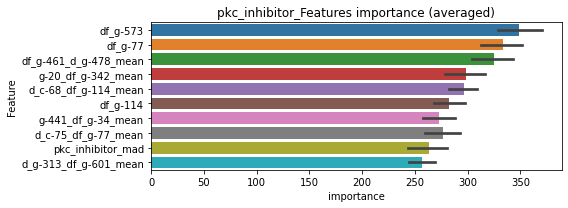

len(train_index) : 2843
len(valid_index) : 948
================================= fold 1/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086034	valid_1's binary_logloss: 0.112093
[200]	training's binary_logloss: 0.0274425	valid_1's binary_logloss: 0.048735
[300]	training's binary_logloss: 0.0102145	valid_1's binary_logloss: 0.0256117
[400]	training's binary_logloss: 0.00422738	valid_1's binary_logloss: 0.0159337
[500]	training's binary_logloss: 0.00215619	valid_1's binary_logloss: 0.0115809
[600]	training's binary_logloss: 0.00133284	valid_1's binary_logloss: 0.00945863
[700]	training's binary_logloss: 0.000951648	valid_1's binary_logloss: 0.00827717
[800]	training's binary_logloss: 0.000739118	valid_1's binary_logloss: 0.00746561
[900]	training's binary_logloss: 0.000627183	valid_1's binary_logloss: 0.00701692
[1000]	training's binary_logloss: 0.00058463	valid_1's binary_logloss: 0.00688985
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.000577238	valid_1's binary_logloss: 0.00681348


len(train_index) : 2843
len(valid_index) : 948
================================= fold 2/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0834241	valid_1's binary_logloss: 0.115109
[200]	training's binary_logloss: 0.0261383	valid_1's binary_logloss: 0.0509349
[300]	training's binary_logloss: 0.00943365	valid_1's binary_logloss: 0.0277402
[400]	training's binary_logloss: 0.00394932	valid_1's binary_logloss: 0.0181403
[500]	training's binary_logloss: 0.00203608	valid_1's binary_logloss: 0.0142195
[600]	training's binary_logloss: 0.00127056	valid_1's binary_logloss: 0.0121392
[700]	training's binary_logloss: 0.000914408	valid_1's binary_logloss: 0.0111161
[800]	training's binary_logloss: 0.000715049	valid_1's binary_logloss: 0.0104039
[900]	training's binary_logloss: 0.000617078	valid_1's binary_logloss: 0.0101641
[1000]	training's binary_logloss: 0.00057493	valid_1's binary_logloss: 0.00994567
Early stopping, best iteration is:
[995]	training's binary_logloss: 0.000576332	valid_1's binary_logloss: 0.00993585


len(train_index) : 2843
len(valid_index) : 948
================================= fold 3/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0840392	valid_1's binary_logloss: 0.117501
[200]	training's binary_logloss: 0.0267411	valid_1's binary_logloss: 0.0507754
[300]	training's binary_logloss: 0.00966873	valid_1's binary_logloss: 0.0254629
[400]	training's binary_logloss: 0.00404413	valid_1's binary_logloss: 0.0140843
[500]	training's binary_logloss: 0.00208675	valid_1's binary_logloss: 0.00929898
[600]	training's binary_logloss: 0.00131248	valid_1's binary_logloss: 0.00708312
[700]	training's binary_logloss: 0.000931597	valid_1's binary_logloss: 0.00575747
[800]	training's binary_logloss: 0.000728881	valid_1's binary_logloss: 0.00493616
[900]	training's binary_logloss: 0.000621458	valid_1's binary_logloss: 0.00451711
[1000]	training's binary_logloss: 0.000578997	valid_1's binary_logloss: 0.00432062
Early stopping, best iteration is:
[1017]	training's binary_logloss: 0.00057258	valid_1's binary_logloss: 0.00429468


len(train_index) : 2844
len(valid_index) : 947
================================= fold 4/4 pkc_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845797	valid_1's binary_logloss: 0.111462
[200]	training's binary_logloss: 0.0271705	valid_1's binary_logloss: 0.050209
[300]	training's binary_logloss: 0.00954564	valid_1's binary_logloss: 0.0268366
[400]	training's binary_logloss: 0.0039887	valid_1's binary_logloss: 0.0178774
[500]	training's binary_logloss: 0.00207207	valid_1's binary_logloss: 0.0141113
[600]	training's binary_logloss: 0.00129488	valid_1's binary_logloss: 0.0124599
[700]	training's binary_logloss: 0.000926033	valid_1's binary_logloss: 0.011587
Early stopping, best iteration is:
[711]	training's binary_logloss: 0.000897986	valid_1's binary_logloss: 0.011528


pkc_inhibitor logloss: 0.00814478186057492


neg labels: 3289 → selected neg labels: 3281


potassium_channel_activator, len(trt): 55, len(othr): 3281, target_rate: 0.0023096 → Adj_target_rate: 0.0025322
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133387	valid_1's binary_logloss: 0.191174
[200]	training's binary_logloss: 0.0596226	valid_1's binary_logloss: 0.120555
[300]	training's binary_logloss: 0.0299431	valid_1's binary_logloss: 0.0860028
[400]	training's binary_logloss: 0.0149868	valid_1's binary_logloss: 0.065502
[500]	training's binary_logloss: 0.00771172	valid_1's binary_logloss: 0.0521942
[600]	training's binary_logloss: 0.00439697	valid_1's binary_logloss: 0.0453307
[700]	training's binary_logloss: 0.0027665	valid_1's binary_logloss: 0.0409188
[800]	training's binary_logloss: 0.00193923	valid_1's binary_logloss: 0.0386992
[900]	training's binary_logloss: 0.00147772	valid_1's binary_logloss: 0.0371289
Early stopping, best iteration is:
[925]	training's binary_logloss: 0.00139935	valid_1's binary_logloss: 0.0368403
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135315	valid_1's 

1 / 3 AUC score:0.998
y_Threshold: 0.0263637, Threshold: 0.1314001, pos_neg_ratio: 0.8000000
Remove_noisy_data: 150 → Positive_corect_labels: 647/3787
p_label_rate: 0.0100452 Vs.target_rate: 0.00231, Num_p_label: 40.0, conf_0:0.09198, conf_1:0.17082
Num_p_label: 40.0, Expected: 9.2, Adj_threshold_1: 0.1314001
Num_p_label: 29.0, Expected: 9.2, Adj_threshold_2: 0.1814001
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_3: 0.2314001
threshold: 0.2314001, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 647.0/3787, y_label_rate: 0.1708476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128273	valid_1's binary_logloss: 0.184756
[200]	training's binary_logloss: 0.0524152	valid_1's binary_logloss: 0.106154
[300]	training's binary_logloss: 0.0235974	valid_1's binary_logloss: 0.069101
[400]	training's binary_logloss: 0.0112777	valid_1's binary_logloss: 0.0502526
[500]	training's binary_logloss: 0.00585231	valid_1's binary_logloss: 0.0405722
[600]	training's binary_logloss: 0.00337524	valid_1's binary_logloss: 0.0344841
[700]	training's binary_logloss: 0.00220644	valid_1's binary_logloss: 0.0305604
[800]	training's binary_logloss: 0.00160101	valid_1's binary_logloss: 0.028288
[900]	training's binary_logloss: 0.00126608	valid_1's binary_logloss: 0.0269953
Early stopping, best iteration is:
[932]	training's binary_logloss: 0.00117881	valid_1's binary_logloss: 0.0264929
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129884	valid_1's 

2 / 3 AUC score:0.999
y_Threshold: 0.1326112, Threshold: 0.2314001, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 636.0/3765
p_label_rate: 0.0188348 Vs.target_rate: 0.00231, Num_p_label: 75.0, conf_0:0.18512, conf_1:0.27768
Num_p_label: 75.0, Expected: 9.2, Adj_threshold_1: 0.2314001
Num_p_label: 58.0, Expected: 9.2, Adj_threshold_2: 0.2814001
Num_p_label: 46.0, Expected: 9.2, Adj_threshold_3: 0.3314001
Num_p_label: 37.0, Expected: 9.2, Adj_threshold_4: 0.3814001
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_5: 0.4314001
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_6: 0.4814001
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_7: 0.5314001
threshold: 0.5314001, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 636.0/3765, y_label_rate: 0.1689243
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126761	valid_1's binary_logloss: 0.179065
[200]	training's binary_logloss: 0.050437	valid_1's binary_logloss: 0.1049
[300]	training's binary_logloss: 0.0225293	valid_1's binary_logloss: 0.074839
[400]	training's binary_logloss: 0.0109858	valid_1's binary_logloss: 0.0613111
[500]	training's binary_logloss: 0.00562628	valid_1's binary_logloss: 0.0550139
[600]	training's binary_logloss: 0.00324313	valid_1's binary_logloss: 0.0522079
[700]	training's binary_logloss: 0.00209879	valid_1's binary_logloss: 0.0514825
Early stopping, best iteration is:
[738]	training's binary_logloss: 0.00184089	valid_1's binary_logloss: 0.0509361
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121472	valid_1's binary_logloss: 0.170262
[200]	training's binary_logloss: 0.0491442	valid_1's binary_logloss: 0.0952499
[300]	training's binary_logloss: 0.0216196	valid_1's binar

3 / 3 AUC score:0.998
y_Threshold: 0.1313351, Threshold: 0.5314001, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 620.0/3733
p_label_rate: 0.0067805 Vs.target_rate: 0.00231, Num_p_label: 27.0, conf_0:0.47826, conf_1:0.58454
Num_p_label: 27.0, Expected: 9.2, Adj_threshold_1: 0.5314001
Num_p_label: 23.0, Expected: 9.2, Adj_threshold_2: 0.5814001
Num_p_label: 17.0, Expected: 9.2, Adj_threshold_3: 0.6314001
threshold: 0.6314001, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 620.0/3733, y_label_rate: 0.1660863


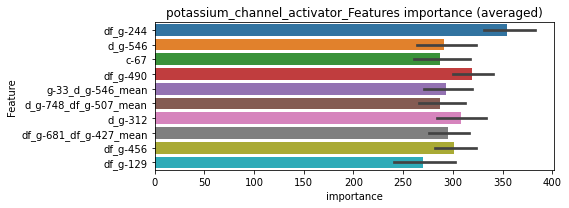

len(train_index) : 2799
len(valid_index) : 934
================================= fold 1/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119512	valid_1's binary_logloss: 0.168957
[200]	training's binary_logloss: 0.0463536	valid_1's binary_logloss: 0.0895519
[300]	training's binary_logloss: 0.0197541	valid_1's binary_logloss: 0.0540472
[400]	training's binary_logloss: 0.00905519	valid_1's binary_logloss: 0.0371813
[500]	training's binary_logloss: 0.00469114	valid_1's binary_logloss: 0.0288192
[600]	training's binary_logloss: 0.00276052	valid_1's binary_logloss: 0.0241966
[700]	training's binary_logloss: 0.00184648	valid_1's binary_logloss: 0.0212766
[800]	training's binary_logloss: 0.0013756	valid_1's binary_logloss: 0.0197095
[900]	training's binary_logloss: 0.0010923	valid_1's binary_logloss: 0.0183449
[1000]	training's binary_logloss: 0.000925739	valid_1's binary_logloss: 0.0173778
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000870147	valid_1's binary_logloss: 0.0170631


len(train_index) : 2800
len(valid_index) : 933
================================= fold 2/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11956	valid_1's binary_logloss: 0.172133
[200]	training's binary_logloss: 0.0476777	valid_1's binary_logloss: 0.094057
[300]	training's binary_logloss: 0.0211782	valid_1's binary_logloss: 0.059257
[400]	training's binary_logloss: 0.00983729	valid_1's binary_logloss: 0.0414398
[500]	training's binary_logloss: 0.00499276	valid_1's binary_logloss: 0.0317492
[600]	training's binary_logloss: 0.00293655	valid_1's binary_logloss: 0.0267795
[700]	training's binary_logloss: 0.00193654	valid_1's binary_logloss: 0.023594
[800]	training's binary_logloss: 0.00140727	valid_1's binary_logloss: 0.0219522
[900]	training's binary_logloss: 0.00111477	valid_1's binary_logloss: 0.0210754
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.00104074	valid_1's binary_logloss: 0.0207776


len(train_index) : 2800
len(valid_index) : 933
================================= fold 3/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117616	valid_1's binary_logloss: 0.165121
[200]	training's binary_logloss: 0.0450686	valid_1's binary_logloss: 0.0884991
[300]	training's binary_logloss: 0.0193965	valid_1's binary_logloss: 0.0558034
[400]	training's binary_logloss: 0.00896321	valid_1's binary_logloss: 0.0399546
[500]	training's binary_logloss: 0.0045529	valid_1's binary_logloss: 0.0315003
[600]	training's binary_logloss: 0.00267844	valid_1's binary_logloss: 0.0277018
[700]	training's binary_logloss: 0.00179136	valid_1's binary_logloss: 0.0252004
[800]	training's binary_logloss: 0.00133168	valid_1's binary_logloss: 0.0238945
[900]	training's binary_logloss: 0.00105817	valid_1's binary_logloss: 0.0230753
[1000]	training's binary_logloss: 0.000896381	valid_1's binary_logloss: 0.0226511
[1100]	training's binary_logloss: 0.000797344	valid_1's binary_logloss: 0.0223542
Early stopping, best iteration is:
[1081]	training's binary_l

len(train_index) : 2800
len(valid_index) : 933
================================= fold 4/4 potassium_channel_activator=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119464	valid_1's binary_logloss: 0.156876
[200]	training's binary_logloss: 0.0466653	valid_1's binary_logloss: 0.085163
[300]	training's binary_logloss: 0.0204089	valid_1's binary_logloss: 0.0535137
[400]	training's binary_logloss: 0.0094233	valid_1's binary_logloss: 0.0378858
[500]	training's binary_logloss: 0.00483318	valid_1's binary_logloss: 0.029297
[600]	training's binary_logloss: 0.00284201	valid_1's binary_logloss: 0.024949
[700]	training's binary_logloss: 0.00188184	valid_1's binary_logloss: 0.0228274
[800]	training's binary_logloss: 0.00138666	valid_1's binary_logloss: 0.0216452
Early stopping, best iteration is:
[839]	training's binary_logloss: 0.00125372	valid_1's binary_logloss: 0.0211606


potassium_channel_activator logloss: 0.020330319684260672


neg labels: 3289 → selected neg labels: 3278


potassium_channel_antagonist, len(trt): 98, len(othr): 3278, target_rate: 0.0041152 → Adj_target_rate: 0.0041375
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.156386	valid_1's binary_logloss: 0.23518
[200]	training's binary_logloss: 0.0758277	valid_1's binary_logloss: 0.168068
[300]	training's binary_logloss: 0.0406025	valid_1's binary_logloss: 0.136303
[400]	training's binary_logloss: 0.0224022	valid_1's binary_logloss: 0.119393
[500]	training's binary_logloss: 0.0126138	valid_1's binary_logloss: 0.107935
[600]	training's binary_logloss: 0.00739152	valid_1's binary_logloss: 0.101475
[700]	training's binary_logloss: 0.00465344	valid_1's binary_logloss: 0.0988392
[800]	training's binary_logloss: 0.00315659	valid_1's binary_logloss: 0.0971228
Early stopping, best iteration is:
[849]	training's binary_logloss: 0.00269951	valid_1's binary_logloss: 0.0967024
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.158286	valid_1's binary_logloss: 0.239839
[200]	training's binary_logloss: 0.0808703	valid_1's binary

1 / 3 AUC score:0.987
y_Threshold: 0.0314197, Threshold: 0.1421571, pos_neg_ratio: 0.8000000
Remove_noisy_data: 196 → Positive_corect_labels: 623/3737
p_label_rate: 0.0100452 Vs.target_rate: 0.00412, Num_p_label: 40.0, conf_0:0.09951, conf_1:0.18480
Num_p_label: 40.0, Expected: 16.4, Adj_threshold_1: 0.1421571
Num_p_label: 22.0, Expected: 16.4, Adj_threshold_2: 0.1921571
threshold: 0.1921571, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 623.0/3737, y_label_rate: 0.1667113
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.145644	valid_1's binary_logloss: 0.204378
[200]	training's binary_logloss: 0.0651894	valid_1's binary_logloss: 0.130667
[300]	training's binary_logloss: 0.0332066	valid_1's binary_logloss: 0.0978432
[400]	training's binary_logloss: 0.0170746	valid_1's binary_logloss: 0.07846
[500]	training's binary_logloss: 0.00917802	valid_1's binary_logloss: 0.0668214
[600]	training's binary_logloss: 0.00540325	valid_1's binary_logloss: 0.0604316
[700]	training's binary_logloss: 0.00347422	valid_1's binary_logloss: 0.0561535
[800]	training's binary_logloss: 0.00242579	valid_1's binary_logloss: 0.0536199
[900]	training's binary_logloss: 0.00185498	valid_1's binary_logloss: 0.0519547
[1000]	training's binary_logloss: 0.00150513	valid_1's binary_logloss: 0.050927
Early stopping, best iteration is:
[1000]	training's binary_logloss: 0.00150513	valid_1's binary_logloss: 0.050927
Training until validation scores 

2 / 3 AUC score:0.997
y_Threshold: 0.0707699, Threshold: 0.1921571, pos_neg_ratio: 0.8000000
Remove_noisy_data: 46 → Positive_corect_labels: 600.0/3691
p_label_rate: 0.0153189 Vs.target_rate: 0.00412, Num_p_label: 61.0, conf_0:0.15373, conf_1:0.23059
Num_p_label: 61.0, Expected: 16.4, Adj_threshold_1: 0.1921571
Num_p_label: 46.0, Expected: 16.4, Adj_threshold_2: 0.2421571
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_3: 0.2921571
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_4: 0.3421571
Num_p_label: 20.0, Expected: 16.4, Adj_threshold_5: 0.3921571
threshold: 0.3921571, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 600.0/3691, y_label_rate: 0.1625576
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133956	valid_1's binary_logloss: 0.194178
[200]	training's binary_logloss: 0.0594252	valid_1's binary_logloss: 0.121892
[300]	training's binary_logloss: 0.0290883	valid_1's binary_logloss: 0.0865017
[400]	training's binary_logloss: 0.0151888	valid_1's binary_logloss: 0.0673705
[500]	training's binary_logloss: 0.00809544	valid_1's binary_logloss: 0.0552555
[600]	training's binary_logloss: 0.00471481	valid_1's binary_logloss: 0.0477708
[700]	training's binary_logloss: 0.00305481	valid_1's binary_logloss: 0.0437955
[800]	training's binary_logloss: 0.00217021	valid_1's binary_logloss: 0.0409305
[900]	training's binary_logloss: 0.00167032	valid_1's binary_logloss: 0.03991
[1000]	training's binary_logloss: 0.0013665	valid_1's binary_logloss: 0.0389879
[1100]	training's binary_logloss: 0.00117946	valid_1's binary_logloss: 0.038076
Early stopping, best iteration is:
[1110]	training's binary_logloss:

3 / 3 AUC score:0.998
y_Threshold: 0.0690955, Threshold: 0.3921571, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 579.0/3649
p_label_rate: 0.0060271 Vs.target_rate: 0.00412, Num_p_label: 24.0, conf_0:0.35294, conf_1:0.43137
threshold: 0.3921571, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 579.0/3649, y_label_rate: 0.1586736


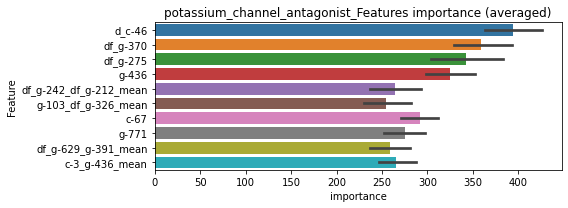

len(train_index) : 2736
len(valid_index) : 913
================================= fold 1/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12356	valid_1's binary_logloss: 0.186266
[200]	training's binary_logloss: 0.0531886	valid_1's binary_logloss: 0.125949
[300]	training's binary_logloss: 0.0251161	valid_1's binary_logloss: 0.0995917
[400]	training's binary_logloss: 0.0126483	valid_1's binary_logloss: 0.086399
[500]	training's binary_logloss: 0.00662359	valid_1's binary_logloss: 0.0801366
[600]	training's binary_logloss: 0.00390142	valid_1's binary_logloss: 0.0782823
Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00328797	valid_1's binary_logloss: 0.0767934


len(train_index) : 2737
len(valid_index) : 912
================================= fold 2/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129306	valid_1's binary_logloss: 0.194888
[200]	training's binary_logloss: 0.0574416	valid_1's binary_logloss: 0.129025
[300]	training's binary_logloss: 0.0269076	valid_1's binary_logloss: 0.099008
[400]	training's binary_logloss: 0.0132266	valid_1's binary_logloss: 0.0830142
[500]	training's binary_logloss: 0.00697285	valid_1's binary_logloss: 0.0736675
[600]	training's binary_logloss: 0.00402307	valid_1's binary_logloss: 0.0690722
[700]	training's binary_logloss: 0.00259773	valid_1's binary_logloss: 0.0672141
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.00255921	valid_1's binary_logloss: 0.0671269


len(train_index) : 2737
len(valid_index) : 912
================================= fold 3/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128873	valid_1's binary_logloss: 0.202699
[200]	training's binary_logloss: 0.0558403	valid_1's binary_logloss: 0.1342
[300]	training's binary_logloss: 0.0267384	valid_1's binary_logloss: 0.10142
[400]	training's binary_logloss: 0.0133229	valid_1's binary_logloss: 0.082209
[500]	training's binary_logloss: 0.00711843	valid_1's binary_logloss: 0.0716353
[600]	training's binary_logloss: 0.00415862	valid_1's binary_logloss: 0.0633503
[700]	training's binary_logloss: 0.0026857	valid_1's binary_logloss: 0.0599215
Early stopping, best iteration is:
[717]	training's binary_logloss: 0.00251282	valid_1's binary_logloss: 0.0593263


len(train_index) : 2737
len(valid_index) : 912
================================= fold 4/4 potassium_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128851	valid_1's binary_logloss: 0.183864
[200]	training's binary_logloss: 0.0540194	valid_1's binary_logloss: 0.116686
[300]	training's binary_logloss: 0.025454	valid_1's binary_logloss: 0.085683
[400]	training's binary_logloss: 0.0123171	valid_1's binary_logloss: 0.070142
[500]	training's binary_logloss: 0.0065311	valid_1's binary_logloss: 0.0608487
[600]	training's binary_logloss: 0.00381731	valid_1's binary_logloss: 0.0573465
[700]	training's binary_logloss: 0.0025337	valid_1's binary_logloss: 0.0552404
[800]	training's binary_logloss: 0.00184667	valid_1's binary_logloss: 0.0540993
Early stopping, best iteration is:
[827]	training's binary_logloss: 0.00171109	valid_1's binary_logloss: 0.0538995


potassium_channel_antagonist logloss: 0.06428993498405661


neg labels: 3289 → selected neg labels: 3278


ppar_receptor_agonist, len(trt): 115, len(othr): 3278, target_rate: 0.0048291 → Adj_target_rate: 0.0047401
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.155206	valid_1's binary_logloss: 0.25247
[200]	training's binary_logloss: 0.0777637	valid_1's binary_logloss: 0.200027
[300]	training's binary_logloss: 0.040858	valid_1's binary_logloss: 0.176164
[400]	training's binary_logloss: 0.0220091	valid_1's binary_logloss: 0.163905
[500]	training's binary_logloss: 0.012124	valid_1's binary_logloss: 0.157799
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.0108462	valid_1's binary_logloss: 0.156926
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.161513	valid_1's binary_logloss: 0.240339
[200]	training's binary_logloss: 0.0851451	valid_1's binary_logloss: 0.182169
[300]	training's binary_logloss: 0.0453129	valid_1's binary_logloss: 0.147097
[400]	training's binary_logloss: 0.0250778	valid_1's binary_logloss: 0.12793
[500]	training's binary_logloss: 0.0145331	valid_1's binary_logloss: 

1 / 3 AUC score:0.973
y_Threshold: 0.0558161, Threshold: 0.2192898, pos_neg_ratio: 0.8000000
Remove_noisy_data: 234 → Positive_corect_labels: 604/3699
p_label_rate: 0.0100452 Vs.target_rate: 0.00483, Num_p_label: 40.0, conf_0:0.15350, conf_1:0.28508
Num_p_label: 40.0, Expected: 19.2, Adj_threshold_1: 0.2192898
Num_p_label: 32.0, Expected: 19.2, Adj_threshold_2: 0.2692898
Num_p_label: 26.0, Expected: 19.2, Adj_threshold_3: 0.3192898
threshold: 0.3192898, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 604.0/3699, y_label_rate: 0.1632874
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132036	valid_1's binary_logloss: 0.19638
[200]	training's binary_logloss: 0.0586832	valid_1's binary_logloss: 0.126073
[300]	training's binary_logloss: 0.0282449	valid_1's binary_logloss: 0.0927805
[400]	training's binary_logloss: 0.0143287	valid_1's binary_logloss: 0.0748148
[500]	training's binary_logloss: 0.00759995	valid_1's binary_logloss: 0.0642708
[600]	training's binary_logloss: 0.00442893	valid_1's binary_logloss: 0.0577925
[700]	training's binary_logloss: 0.00285694	valid_1's binary_logloss: 0.0547099
[800]	training's binary_logloss: 0.00204163	valid_1's binary_logloss: 0.0526444
[900]	training's binary_logloss: 0.00157581	valid_1's binary_logloss: 0.0518517
[1000]	training's binary_logloss: 0.00128866	valid_1's binary_logloss: 0.0508491
[1100]	training's binary_logloss: 0.00111128	valid_1's binary_logloss: 0.0499689
Early stopping, best iteration is:
[1145]	training's binary_loglo

2 / 3 AUC score:0.993
y_Threshold: 0.1246729, Threshold: 0.3192898, pos_neg_ratio: 0.8000000
Remove_noisy_data: 76 → Positive_corect_labels: 566.0/3623
p_label_rate: 0.0190859 Vs.target_rate: 0.00483, Num_p_label: 76.0, conf_0:0.25543, conf_1:0.38315
Num_p_label: 76.0, Expected: 19.2, Adj_threshold_1: 0.3192898
Num_p_label: 69.0, Expected: 19.2, Adj_threshold_2: 0.3692898
Num_p_label: 63.0, Expected: 19.2, Adj_threshold_3: 0.4192898
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_4: 0.4692898
Num_p_label: 49.0, Expected: 19.2, Adj_threshold_5: 0.5192898
Num_p_label: 42.0, Expected: 19.2, Adj_threshold_6: 0.5692898
Num_p_label: 38.0, Expected: 19.2, Adj_threshold_7: 0.6192898
Num_p_label: 37.0, Expected: 19.2, Adj_threshold_8: 0.6692898
Num_p_label: 36.0, Expected: 19.2, Adj_threshold_9: 0.7192898
Num_p_label: 35.0, Expected: 19.2, Adj_threshold_10: 0.7692898
threshold: 0.7692898, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 566.0/3623, y_label_rate: 0.1562241

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110918	valid_1's binary_logloss: 0.160803
[200]	training's binary_logloss: 0.0456164	valid_1's binary_logloss: 0.0993731
[300]	training's binary_logloss: 0.0203868	valid_1's binary_logloss: 0.0714406
[400]	training's binary_logloss: 0.00972973	valid_1's binary_logloss: 0.0587665
[500]	training's binary_logloss: 0.00498054	valid_1's binary_logloss: 0.0502377
[600]	training's binary_logloss: 0.0029471	valid_1's binary_logloss: 0.0462813
[700]	training's binary_logloss: 0.00197264	valid_1's binary_logloss: 0.0441618
[800]	training's binary_logloss: 0.00146664	valid_1's binary_logloss: 0.0423321
Early stopping, best iteration is:
[799]	training's binary_logloss: 0.00147064	valid_1's binary_logloss: 0.0423269
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111537	valid_1's binary_logloss: 0.175239
[200]	training's binary_logloss: 0.0451634	valid_1's

3 / 3 AUC score:0.998
y_Threshold: 0.1214947, Threshold: 0.7692898, pos_neg_ratio: 0.8000000
Remove_noisy_data: 44 → Positive_corect_labels: 544.0/3579
p_label_rate: 0.0138122 Vs.target_rate: 0.00483, Num_p_label: 55.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 55.0, Expected: 19.2, Adj_threshold_1: 0.7692898
threshold: 0.7692898, positive_p_label: 55.0/3982, p_label_rate: 0.0138122
positive_y_label: 544.0/3579, y_label_rate: 0.1519978


len(train_index) : 2684
len(valid_index) : 895
================================= fold 1/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108003	valid_1's binary_logloss: 0.158401
[200]	training's binary_logloss: 0.0398267	valid_1's binary_logloss: 0.0975678
[300]	training's binary_logloss: 0.017183	valid_1's binary_logloss: 0.0743395
[400]	training's binary_logloss: 0.00784542	valid_1's binary_logloss: 0.0625871
[500]	training's binary_logloss: 0.00404321	valid_1's binary_logloss: 0.057321
[600]	training's binary_logloss: 0.00242753	valid_1's binary_logloss: 0.054841
[700]	training's binary_logloss: 0.00165983	valid_1's binary_logloss: 0.0538222
Early stopping, best iteration is:
[696]	training's binary_logloss: 0.00168007	valid_1's binary_logloss: 0.0537027


len(train_index) : 2684
len(valid_index) : 895
================================= fold 2/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105908	valid_1's binary_logloss: 0.158122
[200]	training's binary_logloss: 0.0397825	valid_1's binary_logloss: 0.0921445
[300]	training's binary_logloss: 0.0173952	valid_1's binary_logloss: 0.064453
[400]	training's binary_logloss: 0.00777719	valid_1's binary_logloss: 0.0490008
[500]	training's binary_logloss: 0.0040163	valid_1's binary_logloss: 0.0417339
[600]	training's binary_logloss: 0.00242122	valid_1's binary_logloss: 0.0380735
[700]	training's binary_logloss: 0.00165878	valid_1's binary_logloss: 0.0361213
[800]	training's binary_logloss: 0.00125739	valid_1's binary_logloss: 0.0350728
[900]	training's binary_logloss: 0.00103829	valid_1's binary_logloss: 0.0343016
[1000]	training's binary_logloss: 0.000904545	valid_1's binary_logloss: 0.0335166
[1100]	training's binary_logloss: 0.000821809	valid_1's binary_logloss: 0.0331727
Early stopping, best iteration is:
[1090]	training's binary_lo

len(train_index) : 2684
len(valid_index) : 895
================================= fold 3/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102642	valid_1's binary_logloss: 0.170156
[200]	training's binary_logloss: 0.0393182	valid_1's binary_logloss: 0.109129
[300]	training's binary_logloss: 0.0174376	valid_1's binary_logloss: 0.0802618
[400]	training's binary_logloss: 0.00808344	valid_1's binary_logloss: 0.0660673
[500]	training's binary_logloss: 0.00416503	valid_1's binary_logloss: 0.058626
[600]	training's binary_logloss: 0.00248283	valid_1's binary_logloss: 0.0547274
[700]	training's binary_logloss: 0.00168692	valid_1's binary_logloss: 0.0533383
[800]	training's binary_logloss: 0.0012699	valid_1's binary_logloss: 0.0518123
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.0012001	valid_1's binary_logloss: 0.051192


len(train_index) : 2685
len(valid_index) : 894
================================= fold 4/4 ppar_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107115	valid_1's binary_logloss: 0.171183
[200]	training's binary_logloss: 0.0411647	valid_1's binary_logloss: 0.110794
[300]	training's binary_logloss: 0.0174924	valid_1's binary_logloss: 0.0835211
[400]	training's binary_logloss: 0.00808767	valid_1's binary_logloss: 0.07297
[500]	training's binary_logloss: 0.00412536	valid_1's binary_logloss: 0.0674235
Early stopping, best iteration is:
[519]	training's binary_logloss: 0.00369095	valid_1's binary_logloss: 0.0669829


ppar_receptor_agonist logloss: 0.05124348027893374


neg labels: 3289 → selected neg labels: 3282


ppar_receptor_antagonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907839	valid_1's binary_logloss: 0.119581
[200]	training's binary_logloss: 0.0315484	valid_1's binary_logloss: 0.0552588
[300]	training's binary_logloss: 0.0121792	valid_1's binary_logloss: 0.0310729
[400]	training's binary_logloss: 0.00506216	valid_1's binary_logloss: 0.020329
[500]	training's binary_logloss: 0.00248844	valid_1's binary_logloss: 0.0152079
[600]	training's binary_logloss: 0.00150432	valid_1's binary_logloss: 0.0128374
[700]	training's binary_logloss: 0.00104126	valid_1's binary_logloss: 0.011606
[800]	training's binary_logloss: 0.000797742	valid_1's binary_logloss: 0.0106437
[900]	training's binary_logloss: 0.000666791	valid_1's binary_logloss: 0.0102014
[1000]	training's binary_logloss: 0.000611172	valid_1's binary_logloss: 0.00996334
[1100]	training's binary_logloss: 0.000592169	valid_1's binary_logloss: 0.00981078
Early stopping, best iteration is:
[1102]	training's bina

1 / 3 AUC score:1.000
y_Threshold: 0.0088607, Threshold: 0.0413140, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 653/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.02892, conf_1:0.05371
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0413140
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_2: 0.0913140
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_3: 0.1413140
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_4: 0.1913140
Num_p_label: 11.0, Expected: 5.0, Adj_threshold_5: 0.2413140
threshold: 0.2413140, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 653.0/3800, y_label_rate: 0.1718421
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0862021	valid_1's binary_logloss: 0.116438
[200]	training's binary_logloss: 0.0266161	valid_1's binary_logloss: 0.0530947
[300]	training's binary_logloss: 0.00971292	valid_1's binary_logloss: 0.0301202
[400]	training's binary_logloss: 0.00396446	valid_1's binary_logloss: 0.0196589
[500]	training's binary_logloss: 0.00199201	valid_1's binary_logloss: 0.0151436
[600]	training's binary_logloss: 0.00121538	valid_1's binary_logloss: 0.0123495
[700]	training's binary_logloss: 0.000854354	valid_1's binary_logloss: 0.0108971
[800]	training's binary_logloss: 0.000667415	valid_1's binary_logloss: 0.0101009
[900]	training's binary_logloss: 0.000571948	valid_1's binary_logloss: 0.00979633
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.000583352	valid_1's binary_logloss: 0.00970365
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08843

2 / 3 AUC score:1.000
y_Threshold: 0.1142599, Threshold: 0.2413140, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 651.0/3796
p_label_rate: 0.0090407 Vs.target_rate: 0.00126, Num_p_label: 36.0, conf_0:0.19305, conf_1:0.28958
Num_p_label: 36.0, Expected: 5.0, Adj_threshold_1: 0.2413140
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_2: 0.2913140
Num_p_label: 30.0, Expected: 5.0, Adj_threshold_3: 0.3413140
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.3913140
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_5: 0.4413140
Num_p_label: 23.0, Expected: 5.0, Adj_threshold_6: 0.4913140
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_7: 0.5413140
Num_p_label: 17.0, Expected: 5.0, Adj_threshold_8: 0.5913140
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_9: 0.6413140
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_10: 0.6913140
threshold: 0.6913140, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 651.0/3796, y_label_rate: 0.1714963
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852357	valid_1's binary_logloss: 0.117598
[200]	training's binary_logloss: 0.0266558	valid_1's binary_logloss: 0.0517809
[300]	training's binary_logloss: 0.00970432	valid_1's binary_logloss: 0.0272857
[400]	training's binary_logloss: 0.00390679	valid_1's binary_logloss: 0.016492
[500]	training's binary_logloss: 0.00193141	valid_1's binary_logloss: 0.0118567
[600]	training's binary_logloss: 0.0011859	valid_1's binary_logloss: 0.00956296
[700]	training's binary_logloss: 0.000834312	valid_1's binary_logloss: 0.00827373
[800]	training's binary_logloss: 0.000652905	valid_1's binary_logloss: 0.00757633
[900]	training's binary_logloss: 0.000560125	valid_1's binary_logloss: 0.00711613
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000540852	valid_1's binary_logloss: 0.00707703
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0878

3 / 3 AUC score:1.000
y_Threshold: 0.1244187, Threshold: 0.6913140, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0030136 Vs.target_rate: 0.00126, Num_p_label: 12.0, conf_0:0.50000, conf_1:0.76045
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_1: 0.6913140
threshold: 0.6913140, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 649.0/3792, y_label_rate: 0.1711498


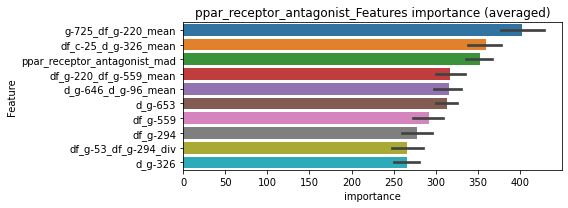

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0863701	valid_1's binary_logloss: 0.117814
[200]	training's binary_logloss: 0.0272561	valid_1's binary_logloss: 0.0508985
[300]	training's binary_logloss: 0.00953557	valid_1's binary_logloss: 0.0252662
[400]	training's binary_logloss: 0.00378735	valid_1's binary_logloss: 0.0147871
[500]	training's binary_logloss: 0.00188844	valid_1's binary_logloss: 0.0106158
[600]	training's binary_logloss: 0.00115115	valid_1's binary_logloss: 0.00871117
[700]	training's binary_logloss: 0.000815626	valid_1's binary_logloss: 0.00775524
[800]	training's binary_logloss: 0.000641433	valid_1's binary_logloss: 0.00724696
[900]	training's binary_logloss: 0.000548377	valid_1's binary_logloss: 0.00696186
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.000522173	valid_1's binary_logloss: 0.00688416


len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0880104	valid_1's binary_logloss: 0.106482
[200]	training's binary_logloss: 0.0272506	valid_1's binary_logloss: 0.0415841
[300]	training's binary_logloss: 0.00990678	valid_1's binary_logloss: 0.0205403
[400]	training's binary_logloss: 0.00401091	valid_1's binary_logloss: 0.0118234
[500]	training's binary_logloss: 0.00199141	valid_1's binary_logloss: 0.00782306
[600]	training's binary_logloss: 0.00120879	valid_1's binary_logloss: 0.0061435
[700]	training's binary_logloss: 0.000857078	valid_1's binary_logloss: 0.00524183
[800]	training's binary_logloss: 0.000665064	valid_1's binary_logloss: 0.00468527
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.000597906	valid_1's binary_logloss: 0.00449814


len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0861898	valid_1's binary_logloss: 0.112923
[200]	training's binary_logloss: 0.0265848	valid_1's binary_logloss: 0.0474265
[300]	training's binary_logloss: 0.00919385	valid_1's binary_logloss: 0.0236849
[400]	training's binary_logloss: 0.00374957	valid_1's binary_logloss: 0.0151503
[500]	training's binary_logloss: 0.00188953	valid_1's binary_logloss: 0.0117572
[600]	training's binary_logloss: 0.0011645	valid_1's binary_logloss: 0.0105112
[700]	training's binary_logloss: 0.0008257	valid_1's binary_logloss: 0.00970826
[800]	training's binary_logloss: 0.000651492	valid_1's binary_logloss: 0.0094427
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.000577911	valid_1's binary_logloss: 0.00924788


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0872517	valid_1's binary_logloss: 0.117935
[200]	training's binary_logloss: 0.0274315	valid_1's binary_logloss: 0.0499716
[300]	training's binary_logloss: 0.00961749	valid_1's binary_logloss: 0.0247124
[400]	training's binary_logloss: 0.00384285	valid_1's binary_logloss: 0.0142266
[500]	training's binary_logloss: 0.00191814	valid_1's binary_logloss: 0.00978279
[600]	training's binary_logloss: 0.00117347	valid_1's binary_logloss: 0.00760141
[700]	training's binary_logloss: 0.000829491	valid_1's binary_logloss: 0.00653409
[800]	training's binary_logloss: 0.000645803	valid_1's binary_logloss: 0.0059292
[900]	training's binary_logloss: 0.000550045	valid_1's binary_logloss: 0.00558825
[1000]	training's binary_logloss: 0.000510906	valid_1's binary_logloss: 0.00544835
Early stopping, best iteration is:
[1049]	training's binary_logloss: 0.000500127	valid_1's binary_logloss: 0.00540978


ppar_receptor_antagonist logloss: 0.006511229665908859


neg labels: 3289 → selected neg labels: 3270


progesterone_receptor_agonist, len(trt): 119, len(othr): 3270, target_rate: 0.0049971 → Adj_target_rate: 0.0048799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.165935	valid_1's binary_logloss: 0.261461
[200]	training's binary_logloss: 0.0825906	valid_1's binary_logloss: 0.200606
[300]	training's binary_logloss: 0.0461711	valid_1's binary_logloss: 0.1712
[400]	training's binary_logloss: 0.0262357	valid_1's binary_logloss: 0.154814
[500]	training's binary_logloss: 0.0152587	valid_1's binary_logloss: 0.147319
[600]	training's binary_logloss: 0.00927258	valid_1's binary_logloss: 0.142553
[700]	training's binary_logloss: 0.00593332	valid_1's binary_logloss: 0.142184
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00630968	valid_1's binary_logloss: 0.141689
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.169994	valid_1's binary_logloss: 0.257629
[200]	training's binary_logloss: 0.0843838	valid_1's binary_logloss: 0.185744
[300]	training's binary_logloss: 0.0451122	valid_1's binary_logl

1 / 3 AUC score:0.977
y_Threshold: 0.0489814, Threshold: 0.2799629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 213 → Positive_corect_labels: 613/3711
p_label_rate: 0.0100452 Vs.target_rate: 0.00500, Num_p_label: 40.0, conf_0:0.19597, conf_1:0.36395
Num_p_label: 40.0, Expected: 19.9, Adj_threshold_1: 0.2799629
Num_p_label: 26.0, Expected: 19.9, Adj_threshold_2: 0.3299629
threshold: 0.3299629, positive_p_label: 26.0/3982, p_label_rate: 0.0065294
positive_y_label: 613.0/3711, y_label_rate: 0.1651846
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148613	valid_1's binary_logloss: 0.218066
[200]	training's binary_logloss: 0.0662194	valid_1's binary_logloss: 0.149141
[300]	training's binary_logloss: 0.031715	valid_1's binary_logloss: 0.117794
[400]	training's binary_logloss: 0.0166468	valid_1's binary_logloss: 0.103007
[500]	training's binary_logloss: 0.00913438	valid_1's binary_logloss: 0.093793
[600]	training's binary_logloss: 0.0054279	valid_1's binary_logloss: 0.0888614
[700]	training's binary_logloss: 0.00356646	valid_1's binary_logloss: 0.0859199
[800]	training's binary_logloss: 0.00254287	valid_1's binary_logloss: 0.0838367
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00225234	valid_1's binary_logloss: 0.0833781
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.144705	valid_1's binary_logloss: 0.239128
[200]	training's binary_logloss: 0.0632184	valid_1's binar

2 / 3 AUC score:0.992
y_Threshold: 0.0861610, Threshold: 0.3299629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 84 → Positive_corect_labels: 571.0/3627
p_label_rate: 0.0208438 Vs.target_rate: 0.00500, Num_p_label: 83.0, conf_0:0.26397, conf_1:0.39596
Num_p_label: 83.0, Expected: 19.9, Adj_threshold_1: 0.3299629
Num_p_label: 67.0, Expected: 19.9, Adj_threshold_2: 0.3799629
Num_p_label: 58.0, Expected: 19.9, Adj_threshold_3: 0.4299629
Num_p_label: 45.0, Expected: 19.9, Adj_threshold_4: 0.4799629
Num_p_label: 38.0, Expected: 19.9, Adj_threshold_5: 0.5299629
Num_p_label: 31.0, Expected: 19.9, Adj_threshold_6: 0.5799629
Num_p_label: 22.0, Expected: 19.9, Adj_threshold_7: 0.6299629
threshold: 0.6299629, positive_p_label: 22.0/3982, p_label_rate: 0.0055249
positive_y_label: 571.0/3627, y_label_rate: 0.1574304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127622	valid_1's binary_logloss: 0.204734
[200]	training's binary_logloss: 0.0527728	valid_1's binary_logloss: 0.134216
[300]	training's binary_logloss: 0.0249174	valid_1's binary_logloss: 0.102365
[400]	training's binary_logloss: 0.012466	valid_1's binary_logloss: 0.0845456
[500]	training's binary_logloss: 0.00680602	valid_1's binary_logloss: 0.0738718
[600]	training's binary_logloss: 0.00409956	valid_1's binary_logloss: 0.0678884
[700]	training's binary_logloss: 0.00273309	valid_1's binary_logloss: 0.0656524
[800]	training's binary_logloss: 0.00200817	valid_1's binary_logloss: 0.0635299
[900]	training's binary_logloss: 0.00157449	valid_1's binary_logloss: 0.0628891
Early stopping, best iteration is:
[916]	training's binary_logloss: 0.00152674	valid_1's binary_logloss: 0.0626412
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130757	valid_1's 

3 / 3 AUC score:0.995
y_Threshold: 0.0920119, Threshold: 0.6299629, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 547.0/3579
p_label_rate: 0.0100452 Vs.target_rate: 0.00500, Num_p_label: 40.0, conf_0:0.50000, conf_1:0.69296
Num_p_label: 40.0, Expected: 19.9, Adj_threshold_1: 0.6299629
Num_p_label: 30.0, Expected: 19.9, Adj_threshold_2: 0.6799629
Num_p_label: 23.0, Expected: 19.9, Adj_threshold_3: 0.7299629
threshold: 0.7299629, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 547.0/3579, y_label_rate: 0.1528360


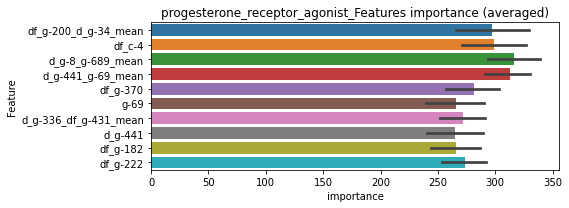

len(train_index) : 2684
len(valid_index) : 895
================================= fold 1/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12353	valid_1's binary_logloss: 0.194599
[200]	training's binary_logloss: 0.050399	valid_1's binary_logloss: 0.125278
[300]	training's binary_logloss: 0.0225813	valid_1's binary_logloss: 0.0912569
[400]	training's binary_logloss: 0.0111314	valid_1's binary_logloss: 0.0747771
[500]	training's binary_logloss: 0.0059762	valid_1's binary_logloss: 0.0652428
[600]	training's binary_logloss: 0.00360538	valid_1's binary_logloss: 0.0604261
[700]	training's binary_logloss: 0.0024254	valid_1's binary_logloss: 0.0572313
Early stopping, best iteration is:
[761]	training's binary_logloss: 0.00198666	valid_1's binary_logloss: 0.0558504


len(train_index) : 2684
len(valid_index) : 895
================================= fold 2/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124231	valid_1's binary_logloss: 0.181499
[200]	training's binary_logloss: 0.0503413	valid_1's binary_logloss: 0.108881
[300]	training's binary_logloss: 0.0227033	valid_1's binary_logloss: 0.0750714
[400]	training's binary_logloss: 0.011289	valid_1's binary_logloss: 0.0577696
[500]	training's binary_logloss: 0.00611134	valid_1's binary_logloss: 0.0482132
[600]	training's binary_logloss: 0.0037263	valid_1's binary_logloss: 0.0433578
[700]	training's binary_logloss: 0.00252921	valid_1's binary_logloss: 0.0404294
[800]	training's binary_logloss: 0.00187164	valid_1's binary_logloss: 0.0388064
[900]	training's binary_logloss: 0.00147606	valid_1's binary_logloss: 0.0377942
Early stopping, best iteration is:
[940]	training's binary_logloss: 0.00136543	valid_1's binary_logloss: 0.037544


len(train_index) : 2684
len(valid_index) : 895
================================= fold 3/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124456	valid_1's binary_logloss: 0.186184
[200]	training's binary_logloss: 0.0497915	valid_1's binary_logloss: 0.113346
[300]	training's binary_logloss: 0.0225796	valid_1's binary_logloss: 0.0809648
[400]	training's binary_logloss: 0.0110204	valid_1's binary_logloss: 0.0638895
[500]	training's binary_logloss: 0.00592738	valid_1's binary_logloss: 0.0538657
[600]	training's binary_logloss: 0.00359487	valid_1's binary_logloss: 0.0485382
[700]	training's binary_logloss: 0.00243477	valid_1's binary_logloss: 0.044869
[800]	training's binary_logloss: 0.00180689	valid_1's binary_logloss: 0.0425639
[900]	training's binary_logloss: 0.00143537	valid_1's binary_logloss: 0.0412145
[1000]	training's binary_logloss: 0.0011997	valid_1's binary_logloss: 0.0403562
Early stopping, best iteration is:
[976]	training's binary_logloss: 0.00124707	valid_1's binary_logloss: 0.0402293


len(train_index) : 2685
len(valid_index) : 894
================================= fold 4/4 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122099	valid_1's binary_logloss: 0.191954
[200]	training's binary_logloss: 0.0481997	valid_1's binary_logloss: 0.121893
[300]	training's binary_logloss: 0.0220881	valid_1's binary_logloss: 0.090208
[400]	training's binary_logloss: 0.0109391	valid_1's binary_logloss: 0.0739545
[500]	training's binary_logloss: 0.00591352	valid_1's binary_logloss: 0.0633424
[600]	training's binary_logloss: 0.00355288	valid_1's binary_logloss: 0.0570731
[700]	training's binary_logloss: 0.0023909	valid_1's binary_logloss: 0.0535845
[800]	training's binary_logloss: 0.0017671	valid_1's binary_logloss: 0.0520597
[900]	training's binary_logloss: 0.00140886	valid_1's binary_logloss: 0.0505623
[1000]	training's binary_logloss: 0.00118226	valid_1's binary_logloss: 0.0495507
[1100]	training's binary_logloss: 0.00104317	valid_1's binary_logloss: 0.0486301
Early stopping, best iteration is:
[1071]	training's binary_logloss

progesterone_receptor_agonist logloss: 0.0455587991324737


neg labels: 3289 → selected neg labels: 3287


progesterone_receptor_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0735725	valid_1's binary_logloss: 0.0868106
[200]	training's binary_logloss: 0.0197295	valid_1's binary_logloss: 0.0279337
[300]	training's binary_logloss: 0.00628078	valid_1's binary_logloss: 0.0117968
[400]	training's binary_logloss: 0.00248987	valid_1's binary_logloss: 0.00626116
[500]	training's binary_logloss: 0.00130993	valid_1's binary_logloss: 0.0042432
[600]	training's binary_logloss: 0.000843715	valid_1's binary_logloss: 0.0033454
[700]	training's binary_logloss: 0.000622732	valid_1's binary_logloss: 0.00284277
[800]	training's binary_logloss: 0.00050214	valid_1's binary_logloss: 0.00258125
[900]	training's binary_logloss: 0.000450027	valid_1's binary_logloss: 0.00247658
Early stopping, best iteration is:
[886]	training's binary_logloss: 0.00045461	valid_1's binary_logloss: 0.00247184
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0047013, Threshold: 0.0201606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01411, conf_1:0.02621
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0201606
Num_p_label: 10.0, Expected: 3.0, Adj_threshold_2: 0.0701606
Num_p_label: 6.0, Expected: 3.0, Adj_threshold_3: 0.1201606
threshold: 0.1201606, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0696835	valid_1's binary_logloss: 0.0796832
[200]	training's binary_logloss: 0.0170463	valid_1's binary_logloss: 0.0226353
[300]	training's binary_logloss: 0.00515722	valid_1's binary_logloss: 0.00821612
[400]	training's binary_logloss: 0.00204209	valid_1's binary_logloss: 0.00386574
[500]	training's binary_logloss: 0.0010859	valid_1's binary_logloss: 0.00233138
[600]	training's binary_logloss: 0.000706279	valid_1's binary_logloss: 0.00164647
[700]	training's binary_logloss: 0.000528793	valid_1's binary_logloss: 0.00131828
[800]	training's binary_logloss: 0.000430773	valid_1's binary_logloss: 0.00111598
[900]	training's binary_logloss: 0.000395922	valid_1's binary_logloss: 0.00104787
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000395922	valid_1's binary_logloss: 0.00104787
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.0820783, Threshold: 0.1201606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0062783 Vs.target_rate: 0.00076, Num_p_label: 25.0, conf_0:0.09613, conf_1:0.14419
Num_p_label: 25.0, Expected: 3.0, Adj_threshold_1: 0.1201606
Num_p_label: 19.0, Expected: 3.0, Adj_threshold_2: 0.1701606
Num_p_label: 14.0, Expected: 3.0, Adj_threshold_3: 0.2201606
Num_p_label: 12.0, Expected: 3.0, Adj_threshold_4: 0.2701606
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_5: 0.3201606
threshold: 0.3201606, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0696835	valid_1's binary_logloss: 0.0796832
[200]	training's binary_logloss: 0.0170463	valid_1's binary_logloss: 0.0226353
[300]	training's binary_logloss: 0.00515722	valid_1's binary_logloss: 0.00821612
[400]	training's binary_logloss: 0.00204209	valid_1's binary_logloss: 0.00386574
[500]	training's binary_logloss: 0.0010859	valid_1's binary_logloss: 0.00233138
[600]	training's binary_logloss: 0.000706279	valid_1's binary_logloss: 0.00164647
[700]	training's binary_logloss: 0.000528793	valid_1's binary_logloss: 0.00131828
[800]	training's binary_logloss: 0.000430773	valid_1's binary_logloss: 0.00111598
[900]	training's binary_logloss: 0.000395922	valid_1's binary_logloss: 0.00104787
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000395922	valid_1's binary_logloss: 0.00104787
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.0820783, Threshold: 0.3201606, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0017579 Vs.target_rate: 0.00076, Num_p_label: 7.0, conf_0:0.28814, conf_1:0.35218
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_1: 0.3201606
threshold: 0.3201606, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


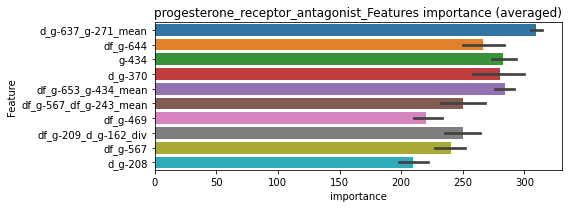

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0700271	valid_1's binary_logloss: 0.0809569
[200]	training's binary_logloss: 0.0173219	valid_1's binary_logloss: 0.0238916
[300]	training's binary_logloss: 0.00521322	valid_1's binary_logloss: 0.00890348
[400]	training's binary_logloss: 0.00207772	valid_1's binary_logloss: 0.00425956
[500]	training's binary_logloss: 0.00108633	valid_1's binary_logloss: 0.00253116
[600]	training's binary_logloss: 0.000706791	valid_1's binary_logloss: 0.0017941
[700]	training's binary_logloss: 0.000522049	valid_1's binary_logloss: 0.00140518
[800]	training's binary_logloss: 0.00042531	valid_1's binary_logloss: 0.00119469
[900]	training's binary_logloss: 0.000389275	valid_1's binary_logloss: 0.00111043
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000389275	valid_1's binary_logloss: 0.00111043


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.069173	valid_1's binary_logloss: 0.0814637
[200]	training's binary_logloss: 0.0170811	valid_1's binary_logloss: 0.0266631
[300]	training's binary_logloss: 0.00517109	valid_1's binary_logloss: 0.0116357
[400]	training's binary_logloss: 0.00205403	valid_1's binary_logloss: 0.00649503
[500]	training's binary_logloss: 0.00109	valid_1's binary_logloss: 0.00444794
[600]	training's binary_logloss: 0.000707799	valid_1's binary_logloss: 0.00377402
[700]	training's binary_logloss: 0.000525994	valid_1's binary_logloss: 0.00332259
[800]	training's binary_logloss: 0.000429275	valid_1's binary_logloss: 0.00307312
[900]	training's binary_logloss: 0.000392459	valid_1's binary_logloss: 0.00293124
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000392459	valid_1's binary_logloss: 0.00293124


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0697207	valid_1's binary_logloss: 0.0820984
[200]	training's binary_logloss: 0.0170609	valid_1's binary_logloss: 0.0235971
[300]	training's binary_logloss: 0.00517	valid_1's binary_logloss: 0.00858391
[400]	training's binary_logloss: 0.00205159	valid_1's binary_logloss: 0.00410963
[500]	training's binary_logloss: 0.00108976	valid_1's binary_logloss: 0.0024865
[600]	training's binary_logloss: 0.000704962	valid_1's binary_logloss: 0.00180574
[700]	training's binary_logloss: 0.000522729	valid_1's binary_logloss: 0.00145508
[800]	training's binary_logloss: 0.000432703	valid_1's binary_logloss: 0.00127407
[900]	training's binary_logloss: 0.000395457	valid_1's binary_logloss: 0.0011928
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000386284	valid_1's binary_logloss: 0.00117448


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0690477	valid_1's binary_logloss: 0.0860185
[200]	training's binary_logloss: 0.0168595	valid_1's binary_logloss: 0.0298174
[300]	training's binary_logloss: 0.00498246	valid_1's binary_logloss: 0.0149875
[400]	training's binary_logloss: 0.00199949	valid_1's binary_logloss: 0.00985766
[500]	training's binary_logloss: 0.0010545	valid_1's binary_logloss: 0.00748653
[600]	training's binary_logloss: 0.000686093	valid_1's binary_logloss: 0.00658751
[700]	training's binary_logloss: 0.000511631	valid_1's binary_logloss: 0.00582683
[800]	training's binary_logloss: 0.000419338	valid_1's binary_logloss: 0.00543888
[900]	training's binary_logloss: 0.000382255	valid_1's binary_logloss: 0.00531436
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.000382656	valid_1's binary_logloss: 0.00530298


progesterone_receptor_antagonist logloss: 0.0026326253511779517


neg labels: 3289 → selected neg labels: 3286


prostaglandin_inhibitor, len(trt): 36, len(othr): 3286, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0944475	valid_1's binary_logloss: 0.134465
[200]	training's binary_logloss: 0.0304962	valid_1's binary_logloss: 0.0683313
[300]	training's binary_logloss: 0.0115647	valid_1's binary_logloss: 0.0409623
[400]	training's binary_logloss: 0.00499681	valid_1's binary_logloss: 0.0297364
[500]	training's binary_logloss: 0.00256366	valid_1's binary_logloss: 0.0244084
[600]	training's binary_logloss: 0.00158409	valid_1's binary_logloss: 0.0213555
[700]	training's binary_logloss: 0.00111868	valid_1's binary_logloss: 0.0195595
[800]	training's binary_logloss: 0.000865616	valid_1's binary_logloss: 0.0183806
[900]	training's binary_logloss: 0.00071519	valid_1's binary_logloss: 0.0179685
[1000]	training's binary_logloss: 0.000650613	valid_1's binary_logloss: 0.0177148
[1100]	training's binary_logloss: 0.00061893	valid_1's binary_logloss: 0.0175362
Early stopping, best iteration is:
[1092]	training's binary

1 / 3 AUC score:0.999
y_Threshold: 0.0096271, Threshold: 0.1404052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.09828, conf_1:0.18253
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1404052
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_2: 0.1904052
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_3: 0.2404052
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_4: 0.2904052
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_5: 0.3404052
threshold: 0.3404052, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3805, y_label_rate: 0.1718791
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891454	valid_1's binary_logloss: 0.129761
[200]	training's binary_logloss: 0.0266127	valid_1's binary_logloss: 0.0633725
[300]	training's binary_logloss: 0.0094104	valid_1's binary_logloss: 0.0402283
[400]	training's binary_logloss: 0.00396355	valid_1's binary_logloss: 0.0303546
[500]	training's binary_logloss: 0.00205492	valid_1's binary_logloss: 0.0261053
[600]	training's binary_logloss: 0.00130101	valid_1's binary_logloss: 0.0241768
[700]	training's binary_logloss: 0.000937104	valid_1's binary_logloss: 0.0229129
[800]	training's binary_logloss: 0.000733509	valid_1's binary_logloss: 0.0217499
[900]	training's binary_logloss: 0.000621402	valid_1's binary_logloss: 0.0217251
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000643709	valid_1's binary_logloss: 0.0215098
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.089931	v

2 / 3 AUC score:1.000
y_Threshold: 0.0968847, Threshold: 0.3404052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 647.0/3791
p_label_rate: 0.0133099 Vs.target_rate: 0.00151, Num_p_label: 53.0, conf_0:0.27232, conf_1:0.40849
Num_p_label: 53.0, Expected: 6.0, Adj_threshold_1: 0.3404052
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.3904052
Num_p_label: 46.0, Expected: 6.0, Adj_threshold_3: 0.4404052
Num_p_label: 42.0, Expected: 6.0, Adj_threshold_4: 0.4904052
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_5: 0.5404052
Num_p_label: 34.0, Expected: 6.0, Adj_threshold_6: 0.5904052
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_7: 0.6404052
Num_p_label: 24.0, Expected: 6.0, Adj_threshold_8: 0.6904052
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_9: 0.7404052
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_10: 0.7904052
threshold: 0.7904052, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 647.0/3791, y_label_rate: 0.1706674
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0874062	valid_1's binary_logloss: 0.118592
[200]	training's binary_logloss: 0.0253992	valid_1's binary_logloss: 0.0502155
[300]	training's binary_logloss: 0.0090588	valid_1's binary_logloss: 0.0281104
[400]	training's binary_logloss: 0.00381885	valid_1's binary_logloss: 0.018277
[500]	training's binary_logloss: 0.00200916	valid_1's binary_logloss: 0.0138811
[600]	training's binary_logloss: 0.00126849	valid_1's binary_logloss: 0.0115583
[700]	training's binary_logloss: 0.000911198	valid_1's binary_logloss: 0.01023
[800]	training's binary_logloss: 0.000716501	valid_1's binary_logloss: 0.00917378
[900]	training's binary_logloss: 0.000609267	valid_1's binary_logloss: 0.00893459
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.00059403	valid_1's binary_logloss: 0.00880735
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860528	v

3 / 3 AUC score:1.000
y_Threshold: 0.1482843, Threshold: 0.7904052, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 639.0/3775
p_label_rate: 0.0062783 Vs.target_rate: 0.00151, Num_p_label: 25.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_1: 0.7904052
threshold: 0.7904052, positive_p_label: 25.0/3982, p_label_rate: 0.0062783
positive_y_label: 639.0/3775, y_label_rate: 0.1692715


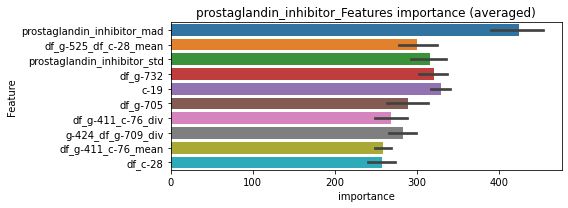

len(train_index) : 2831
len(valid_index) : 944
================================= fold 1/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843968	valid_1's binary_logloss: 0.114737
[200]	training's binary_logloss: 0.0237011	valid_1's binary_logloss: 0.0466628
[300]	training's binary_logloss: 0.00813607	valid_1's binary_logloss: 0.023069
[400]	training's binary_logloss: 0.00348287	valid_1's binary_logloss: 0.0139825
[500]	training's binary_logloss: 0.00184784	valid_1's binary_logloss: 0.0104582
[600]	training's binary_logloss: 0.00116062	valid_1's binary_logloss: 0.00861846
[700]	training's binary_logloss: 0.000842664	valid_1's binary_logloss: 0.00767972
[800]	training's binary_logloss: 0.000671694	valid_1's binary_logloss: 0.00716465
[900]	training's binary_logloss: 0.000576957	valid_1's binary_logloss: 0.00692279
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.000555963	valid_1's binary_logloss: 0.00691142


len(train_index) : 2831
len(valid_index) : 944
================================= fold 2/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0854251	valid_1's binary_logloss: 0.106669
[200]	training's binary_logloss: 0.0253291	valid_1's binary_logloss: 0.0414833
[300]	training's binary_logloss: 0.00889707	valid_1's binary_logloss: 0.0194794
[400]	training's binary_logloss: 0.00378808	valid_1's binary_logloss: 0.0111837
[500]	training's binary_logloss: 0.00197209	valid_1's binary_logloss: 0.00737134
[600]	training's binary_logloss: 0.00123769	valid_1's binary_logloss: 0.0055355
[700]	training's binary_logloss: 0.000888629	valid_1's binary_logloss: 0.00463694
[800]	training's binary_logloss: 0.000698172	valid_1's binary_logloss: 0.0040731
[900]	training's binary_logloss: 0.000594729	valid_1's binary_logloss: 0.00372947
[1000]	training's binary_logloss: 0.000551059	valid_1's binary_logloss: 0.00361262
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.000544433	valid_1's binary_logloss: 0.00359718


len(train_index) : 2831
len(valid_index) : 944
================================= fold 3/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0843206	valid_1's binary_logloss: 0.118078
[200]	training's binary_logloss: 0.0243639	valid_1's binary_logloss: 0.052643
[300]	training's binary_logloss: 0.00840662	valid_1's binary_logloss: 0.0306826
[400]	training's binary_logloss: 0.00351192	valid_1's binary_logloss: 0.0226811
[500]	training's binary_logloss: 0.00184556	valid_1's binary_logloss: 0.018821
[600]	training's binary_logloss: 0.00117233	valid_1's binary_logloss: 0.0169255
[700]	training's binary_logloss: 0.000845139	valid_1's binary_logloss: 0.0156482
[800]	training's binary_logloss: 0.000674502	valid_1's binary_logloss: 0.014954
Early stopping, best iteration is:
[811]	training's binary_logloss: 0.000665184	valid_1's binary_logloss: 0.0148434


len(train_index) : 2832
len(valid_index) : 943
================================= fold 4/4 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0845511	valid_1's binary_logloss: 0.121265
[200]	training's binary_logloss: 0.0241186	valid_1's binary_logloss: 0.0538464
[300]	training's binary_logloss: 0.00837073	valid_1's binary_logloss: 0.0295552
[400]	training's binary_logloss: 0.00353653	valid_1's binary_logloss: 0.019203
[500]	training's binary_logloss: 0.00185965	valid_1's binary_logloss: 0.0145448
[600]	training's binary_logloss: 0.00117301	valid_1's binary_logloss: 0.0119488
[700]	training's binary_logloss: 0.000845009	valid_1's binary_logloss: 0.0104998
[800]	training's binary_logloss: 0.000671957	valid_1's binary_logloss: 0.0096758
[900]	training's binary_logloss: 0.000580642	valid_1's binary_logloss: 0.00920856
Early stopping, best iteration is:
[907]	training's binary_logloss: 0.000576879	valid_1's binary_logloss: 0.00917756


prostaglandin_inhibitor logloss: 0.00863224878554946


neg labels: 3289 → selected neg labels: 3280


prostanoid_receptor_antagonist, len(trt): 84, len(othr): 3280, target_rate: 0.0035273 → Adj_target_rate: 0.0036294
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.138303	valid_1's binary_logloss: 0.226656
[200]	training's binary_logloss: 0.0634354	valid_1's binary_logloss: 0.166664
[300]	training's binary_logloss: 0.0311595	valid_1's binary_logloss: 0.135618
[400]	training's binary_logloss: 0.0165421	valid_1's binary_logloss: 0.118682
[500]	training's binary_logloss: 0.00886069	valid_1's binary_logloss: 0.106971
[600]	training's binary_logloss: 0.0051544	valid_1's binary_logloss: 0.101363
[700]	training's binary_logloss: 0.00328821	valid_1's binary_logloss: 0.0984299
[800]	training's binary_logloss: 0.00230219	valid_1's binary_logloss: 0.0972808
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00233929	valid_1's binary_logloss: 0.0971164
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.139013	valid_1's binary_logloss: 0.202383
[200]	training's binary_logloss: 0.0652916	valid_1's binar

1 / 3 AUC score:0.990
y_Threshold: 0.0348312, Threshold: 0.2715653, pos_neg_ratio: 0.8000000
Remove_noisy_data: 174 → Positive_corect_labels: 635/3762
p_label_rate: 0.0100452 Vs.target_rate: 0.00353, Num_p_label: 40.0, conf_0:0.19010, conf_1:0.35303
Num_p_label: 40.0, Expected: 14.0, Adj_threshold_1: 0.2715653
Num_p_label: 31.0, Expected: 14.0, Adj_threshold_2: 0.3215653
Num_p_label: 23.0, Expected: 14.0, Adj_threshold_3: 0.3715653
Num_p_label: 16.0, Expected: 14.0, Adj_threshold_4: 0.4215653
threshold: 0.4215653, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 635.0/3762, y_label_rate: 0.1687932
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123731	valid_1's binary_logloss: 0.178388
[200]	training's binary_logloss: 0.050902	valid_1's binary_logloss: 0.111583
[300]	training's binary_logloss: 0.0234403	valid_1's binary_logloss: 0.0786996
[400]	training's binary_logloss: 0.0114631	valid_1's binary_logloss: 0.0616913
[500]	training's binary_logloss: 0.00594369	valid_1's binary_logloss: 0.0527432
[600]	training's binary_logloss: 0.00351158	valid_1's binary_logloss: 0.0478697
[700]	training's binary_logloss: 0.00233053	valid_1's binary_logloss: 0.0452588
[800]	training's binary_logloss: 0.00169757	valid_1's binary_logloss: 0.0437069
[900]	training's binary_logloss: 0.00133384	valid_1's binary_logloss: 0.042924
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.00136115	valid_1's binary_logloss: 0.042828
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127948	valid_1's b

2 / 3 AUC score:0.996
y_Threshold: 0.0837374, Threshold: 0.4215653, pos_neg_ratio: 0.8000000
Remove_noisy_data: 48 → Positive_corect_labels: 611.0/3714
p_label_rate: 0.0228528 Vs.target_rate: 0.00353, Num_p_label: 91.0, conf_0:0.33725, conf_1:0.50588
Num_p_label: 91.0, Expected: 14.0, Adj_threshold_1: 0.4215653
Num_p_label: 78.0, Expected: 14.0, Adj_threshold_2: 0.4715653
Num_p_label: 71.0, Expected: 14.0, Adj_threshold_3: 0.5215653
Num_p_label: 66.0, Expected: 14.0, Adj_threshold_4: 0.5715653
Num_p_label: 60.0, Expected: 14.0, Adj_threshold_5: 0.6215653
Num_p_label: 54.0, Expected: 14.0, Adj_threshold_6: 0.6715653
Num_p_label: 46.0, Expected: 14.0, Adj_threshold_7: 0.7215653
Num_p_label: 38.0, Expected: 14.0, Adj_threshold_8: 0.7715653
threshold: 0.7715653, positive_p_label: 38.0/3982, p_label_rate: 0.0095429
positive_y_label: 611.0/3714, y_label_rate: 0.1645127
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115864	valid_1's binary_logloss: 0.156
[200]	training's binary_logloss: 0.0469932	valid_1's binary_logloss: 0.0883481
[300]	training's binary_logloss: 0.0206295	valid_1's binary_logloss: 0.0577218
[400]	training's binary_logloss: 0.00971987	valid_1's binary_logloss: 0.0415303
[500]	training's binary_logloss: 0.0050349	valid_1's binary_logloss: 0.0327067
[600]	training's binary_logloss: 0.00296408	valid_1's binary_logloss: 0.027552
[700]	training's binary_logloss: 0.00197658	valid_1's binary_logloss: 0.0248805
[800]	training's binary_logloss: 0.00145713	valid_1's binary_logloss: 0.0230459
[900]	training's binary_logloss: 0.00116002	valid_1's binary_logloss: 0.0223837
Early stopping, best iteration is:
[919]	training's binary_logloss: 0.00111967	valid_1's binary_logloss: 0.0222353
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112348	valid_1's b

3 / 3 AUC score:0.995
y_Threshold: 0.0858903, Threshold: 0.7715653, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 595.0/3682
p_label_rate: 0.0180814 Vs.target_rate: 0.00353, Num_p_label: 72.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 72.0, Expected: 14.0, Adj_threshold_1: 0.7715653
threshold: 0.7715653, positive_p_label: 72.0/3982, p_label_rate: 0.0180814
positive_y_label: 595.0/3682, y_label_rate: 0.1615970


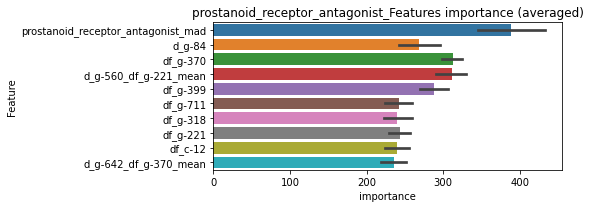

len(train_index) : 2761
len(valid_index) : 921
================================= fold 1/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10772	valid_1's binary_logloss: 0.154184
[200]	training's binary_logloss: 0.0420305	valid_1's binary_logloss: 0.0865857
[300]	training's binary_logloss: 0.018097	valid_1's binary_logloss: 0.0563049
[400]	training's binary_logloss: 0.00843747	valid_1's binary_logloss: 0.0416701
[500]	training's binary_logloss: 0.0043823	valid_1's binary_logloss: 0.033285
[600]	training's binary_logloss: 0.00258169	valid_1's binary_logloss: 0.029306
[700]	training's binary_logloss: 0.00173977	valid_1's binary_logloss: 0.0271012
[800]	training's binary_logloss: 0.00128891	valid_1's binary_logloss: 0.0258331
[900]	training's binary_logloss: 0.00104016	valid_1's binary_logloss: 0.0245143
[1000]	training's binary_logloss: 0.000892188	valid_1's binary_logloss: 0.0239908
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000930607	valid_1's binary_logloss: 0.0239052


len(train_index) : 2761
len(valid_index) : 921
================================= fold 2/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107365	valid_1's binary_logloss: 0.164228
[200]	training's binary_logloss: 0.0409691	valid_1's binary_logloss: 0.0954738
[300]	training's binary_logloss: 0.0171855	valid_1's binary_logloss: 0.0652135
[400]	training's binary_logloss: 0.00791599	valid_1's binary_logloss: 0.0491839
[500]	training's binary_logloss: 0.00410122	valid_1's binary_logloss: 0.0408251
[600]	training's binary_logloss: 0.00245362	valid_1's binary_logloss: 0.0362445
[700]	training's binary_logloss: 0.00166148	valid_1's binary_logloss: 0.0335783
[800]	training's binary_logloss: 0.00125673	valid_1's binary_logloss: 0.0319619
[900]	training's binary_logloss: 0.00102827	valid_1's binary_logloss: 0.031188
[1000]	training's binary_logloss: 0.000890469	valid_1's binary_logloss: 0.0307824
[1100]	training's binary_logloss: 0.000807639	valid_1's binary_logloss: 0.0301802
Early stopping, best iteration is:
[1080]	training's binary_l

len(train_index) : 2762
len(valid_index) : 920
================================= fold 3/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110434	valid_1's binary_logloss: 0.145949
[200]	training's binary_logloss: 0.0421181	valid_1's binary_logloss: 0.0810923
[300]	training's binary_logloss: 0.0179014	valid_1's binary_logloss: 0.0549846
[400]	training's binary_logloss: 0.0082044	valid_1's binary_logloss: 0.0434841
[500]	training's binary_logloss: 0.00425274	valid_1's binary_logloss: 0.0378626
[600]	training's binary_logloss: 0.00252543	valid_1's binary_logloss: 0.0345275
[700]	training's binary_logloss: 0.00171436	valid_1's binary_logloss: 0.0332647
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00180112	valid_1's binary_logloss: 0.0331318


len(train_index) : 2762
len(valid_index) : 920
================================= fold 4/4 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106524	valid_1's binary_logloss: 0.151632
[200]	training's binary_logloss: 0.0406459	valid_1's binary_logloss: 0.0852323
[300]	training's binary_logloss: 0.0172261	valid_1's binary_logloss: 0.0567735
[400]	training's binary_logloss: 0.00801828	valid_1's binary_logloss: 0.0432627
[500]	training's binary_logloss: 0.00412201	valid_1's binary_logloss: 0.0357897
[600]	training's binary_logloss: 0.00247971	valid_1's binary_logloss: 0.0312311
[700]	training's binary_logloss: 0.00168686	valid_1's binary_logloss: 0.0282428
[800]	training's binary_logloss: 0.00126912	valid_1's binary_logloss: 0.026867
[900]	training's binary_logloss: 0.00103191	valid_1's binary_logloss: 0.0258063
[1000]	training's binary_logloss: 0.000891052	valid_1's binary_logloss: 0.0251603
[1100]	training's binary_logloss: 0.000812196	valid_1's binary_logloss: 0.024738
Early stopping, best iteration is:
[1133]	training's binary_lo

prostanoid_receptor_antagonist logloss: 0.027951777452203147


neg labels: 3289 → selected neg labels: 3197


proteasome_inhibitor, len(trt): 726, len(othr): 3197, target_rate: 0.0304863 → Adj_target_rate: 0.0226983
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.427142	valid_1's binary_logloss: 0.477749
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.386627	valid_1's binary_logloss: 0.476907
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.423481	valid_1's binary_logloss: 0.47432
Training until validation scores don't improve for 30 rounds


1 / 3 AUC score:0.511
y_Threshold: 0.1945483, Threshold: 0.4109850, pos_neg_ratio: 0.7729121
Remove_noisy_data: 1239 → Positive_corect_labels: 189/2684
p_label_rate: 0.0100452 Vs.target_rate: 0.03049, Num_p_label: 40.0, conf_0:0.28769, conf_1:0.53428
Num_p_label: 40.0, Expected: 121.4, Adj_threshold_1: 0.4109850
Num_p_label: 94.0, Expected: 121.4, Adj_threshold_2: 0.3809850
Num_p_label: 123.0, Expected: 121.4, Adj_threshold_3: 0.3509850
Num_p_label: 131.0, Expected: 121.4, Adj_threshold_4: 0.3209850
Num_p_label: 138.0, Expected: 121.4, Adj_threshold_5: 0.2909850
Num_p_label: 142.0, Expected: 121.4, Adj_threshold_6: 0.2609850
Num_p_label: 179.0, Expected: 121.4, Adj_threshold_7: 0.2309850
Num_p_label: 546.0, Expected: 121.4, Adj_threshold_8: 0.2009850
threshold: 0.2009850, positive_p_label: 546.0/3982, p_label_rate: 0.1371170
positive_y_label: 189.0/2684, y_label_rate: 0.0704173
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[8]	training's binary_logloss: 0.463372	valid_1's binary_logloss: 0.477978
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824531	valid_1's binary_logloss: 0.20107
Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0643567	valid_1's binary_logloss: 0.199575
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0786164	valid_1's binary_logloss: 0.198442
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0709511	valid_1's binary_logloss: 0.197835
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0781956	valid_1's binary_logloss: 0.209373
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.081414	valid_1's binary_logloss: 0.209066
Training until validation scores don't improve for 30 rounds


2 / 3 AUC score:0.799
y_Threshold: 0.1012810, Threshold: 0.2009850, pos_neg_ratio: 0.7729121
Remove_noisy_data: 228 → Positive_corect_labels: 75.0/2456
p_label_rate: 0.0662983 Vs.target_rate: 0.03049, Num_p_label: 264.0, conf_0:0.16079, conf_1:0.24118
Num_p_label: 264.0, Expected: 121.4, Adj_threshold_1: 0.2009850
Num_p_label: 235.0, Expected: 121.4, Adj_threshold_2: 0.2509850
Num_p_label: 217.0, Expected: 121.4, Adj_threshold_3: 0.3009850
Num_p_label: 208.0, Expected: 121.4, Adj_threshold_4: 0.3509850
Num_p_label: 205.0, Expected: 121.4, Adj_threshold_5: 0.4009850


[100]	training's binary_logloss: 0.0776644	valid_1's binary_logloss: 0.204156
Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0886954	valid_1's binary_logloss: 0.203802


Num_p_label: 193.0, Expected: 121.4, Adj_threshold_6: 0.4509850
Num_p_label: 184.0, Expected: 121.4, Adj_threshold_7: 0.5009850
Num_p_label: 177.0, Expected: 121.4, Adj_threshold_8: 0.5509850
Num_p_label: 169.0, Expected: 121.4, Adj_threshold_9: 0.6009850
Num_p_label: 159.0, Expected: 121.4, Adj_threshold_10: 0.6509850
threshold: 0.7009850, positive_p_label: 141.0/3982, p_label_rate: 0.0354093
positive_y_label: 75.0/2456, y_label_rate: 0.0305375
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0174628	valid_1's binary_logloss: 0.0632348
Early stopping, best iteration is:
[150]	training's binary_logloss: 0.00877817	valid_1's binary_logloss: 0.061588
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0182933	valid_1's binary_logloss: 0.0622158
[200]	training's binary_logloss: 0.00540552	valid_1's binary_logloss: 0.0538248
Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00350515	valid_1's binary_logloss: 0.0529351
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0188058	valid_1's binary_logloss: 0.0634459
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0127087	valid_1's binary_logloss: 0.0623456
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0194349	valid_1's binary_logloss: 0.0434558


3 / 3 AUC score:0.977
y_Threshold: 0.0546489, Threshold: 0.7009850, pos_neg_ratio: 0.7729121
Remove_noisy_data: 32 → Positive_corect_labels: 59.0/2424
p_label_rate: 0.0519839 Vs.target_rate: 0.03049, Num_p_label: 207.0, conf_0:0.50000, conf_1:0.77108
Num_p_label: 207.0, Expected: 121.4, Adj_threshold_1: 0.7009850
Num_p_label: 200.0, Expected: 121.4, Adj_threshold_2: 0.7509850
threshold: 0.7509850, positive_p_label: 200.0/3982, p_label_rate: 0.0502260


[200]	training's binary_logloss: 0.00554802	valid_1's binary_logloss: 0.0388981
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00585358	valid_1's binary_logloss: 0.0386738


positive_y_label: 59.0/2424, y_label_rate: 0.0243399


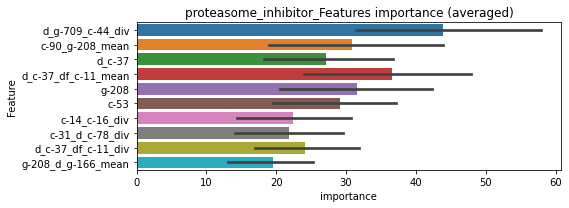

len(train_index) : 1818
len(valid_index) : 606
================================= fold 1/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0116884	valid_1's binary_logloss: 0.0340397
[200]	training's binary_logloss: 0.00314494	valid_1's binary_logloss: 0.0295802
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.00179668	valid_1's binary_logloss: 0.0290962


len(train_index) : 1818
len(valid_index) : 606
================================= fold 2/4 proteasome_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0118672	valid_1's binary_logloss: 0.0331049


len(train_index) : 1818
len(valid_index) : 606
================================= fold 3/4 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.00301679	valid_1's binary_logloss: 0.0265599
Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00226137	valid_1's binary_logloss: 0.0258794
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0126877	valid_1's binary_logloss: 0.0320747


len(train_index) : 1818
len(valid_index) : 606
================================= fold 4/4 proteasome_inhibitor=================================


[200]	training's binary_logloss: 0.00308569	valid_1's binary_logloss: 0.0241172
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00327322	valid_1's binary_logloss: 0.0238491
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0114781	valid_1's binary_logloss: 0.0326345
[200]	training's binary_logloss: 0.00295392	valid_1's binary_logloss: 0.0299397


proteasome_inhibitor logloss: 0.027043187289289523


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00176973	valid_1's binary_logloss: 0.029348
neg labels: 3289 → selected neg labels: 3285


protein_kinase_inhibitor, len(trt): 48, len(othr): 3285, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118972	valid_1's binary_logloss: 0.174721
[200]	training's binary_logloss: 0.0482451	valid_1's binary_logloss: 0.0996529
[300]	training's binary_logloss: 0.0205458	valid_1's binary_logloss: 0.0629313
[400]	training's binary_logloss: 0.00955672	valid_1's binary_logloss: 0.0440258
[500]	training's binary_logloss: 0.00484432	valid_1's binary_logloss: 0.034219
[600]	training's binary_logloss: 0.00281336	valid_1's binary_logloss: 0.0288692
[700]	training's binary_logloss: 0.00188322	valid_1's binary_logloss: 0.0263814
[800]	training's binary_logloss: 0.00138634	valid_1's binary_logloss: 0.0248618
[900]	training's binary_logloss: 0.00109495	valid_1's binary_logloss: 0.0237219
[1000]	training's binary_logloss: 0.000929092	valid_1's binary_logloss: 0.023312
[1100]	training's binary_logloss: 0.000840459	valid_1's binary_logloss: 0.0229176
Early stopping, best iteration is:
[1115]	training's binary_lo

1 / 3 AUC score:0.999
y_Threshold: 0.0156738, Threshold: 0.0734188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 653/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.05139, conf_1:0.09544
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0734188
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.1234188
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_3: 0.1734188
threshold: 0.1734188, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112781	valid_1's binary_logloss: 0.174824
[200]	training's binary_logloss: 0.0420284	valid_1's binary_logloss: 0.10033
[300]	training's binary_logloss: 0.0175859	valid_1's binary_logloss: 0.0686838
[400]	training's binary_logloss: 0.00777676	valid_1's binary_logloss: 0.0525779
[500]	training's binary_logloss: 0.00399469	valid_1's binary_logloss: 0.0450631
[600]	training's binary_logloss: 0.00239407	valid_1's binary_logloss: 0.0400631
[700]	training's binary_logloss: 0.00163774	valid_1's binary_logloss: 0.037675
Early stopping, best iteration is:
[746]	training's binary_logloss: 0.00141655	valid_1's binary_logloss: 0.0365269
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114715	valid_1's binary_logloss: 0.16146
[200]	training's binary_logloss: 0.0420802	valid_1's binary_logloss: 0.0815061
[300]	training's binary_logloss: 0.0179011	valid_1's bin

2 / 3 AUC score:0.999
y_Threshold: 0.0529491, Threshold: 0.1734188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.13874, conf_1:0.20810
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.1734188
Num_p_label: 30.0, Expected: 8.0, Adj_threshold_2: 0.2234188
Num_p_label: 25.0, Expected: 8.0, Adj_threshold_3: 0.2734188
Num_p_label: 21.0, Expected: 8.0, Adj_threshold_4: 0.3234188
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_5: 0.3734188
threshold: 0.3734188, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 646.0/3788, y_label_rate: 0.1705385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108604	valid_1's binary_logloss: 0.158624
[200]	training's binary_logloss: 0.0386294	valid_1's binary_logloss: 0.0842558
[300]	training's binary_logloss: 0.0155426	valid_1's binary_logloss: 0.0540388
[400]	training's binary_logloss: 0.00687853	valid_1's binary_logloss: 0.0409232
[500]	training's binary_logloss: 0.00356609	valid_1's binary_logloss: 0.0336589
[600]	training's binary_logloss: 0.00216335	valid_1's binary_logloss: 0.0302021
[700]	training's binary_logloss: 0.00149379	valid_1's binary_logloss: 0.02809
[800]	training's binary_logloss: 0.00112699	valid_1's binary_logloss: 0.0272718
[900]	training's binary_logloss: 0.000912198	valid_1's binary_logloss: 0.0263266
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000864652	valid_1's binary_logloss: 0.0262301
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114758	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.0621633, Threshold: 0.3734188, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 644.0/3784
p_label_rate: 0.0055249 Vs.target_rate: 0.00202, Num_p_label: 22.0, conf_0:0.33608, conf_1:0.41076
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_1: 0.3734188
Num_p_label: 17.0, Expected: 8.0, Adj_threshold_2: 0.4234188
threshold: 0.4234188, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 644.0/3784, y_label_rate: 0.1701903


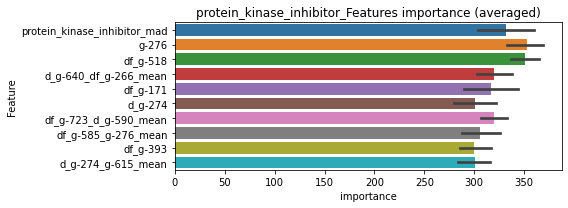

len(train_index) : 2838
len(valid_index) : 946
================================= fold 1/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111499	valid_1's binary_logloss: 0.157507
[200]	training's binary_logloss: 0.0395598	valid_1's binary_logloss: 0.0801036
[300]	training's binary_logloss: 0.0166227	valid_1's binary_logloss: 0.048449
[400]	training's binary_logloss: 0.00739509	valid_1's binary_logloss: 0.0319502
[500]	training's binary_logloss: 0.00375449	valid_1's binary_logloss: 0.0233959
[600]	training's binary_logloss: 0.0022431	valid_1's binary_logloss: 0.0195799
[700]	training's binary_logloss: 0.00153431	valid_1's binary_logloss: 0.0172667
[800]	training's binary_logloss: 0.00115492	valid_1's binary_logloss: 0.0159161
[900]	training's binary_logloss: 0.000933434	valid_1's binary_logloss: 0.014784
[1000]	training's binary_logloss: 0.000798873	valid_1's binary_logloss: 0.014094
[1100]	training's binary_logloss: 0.000732337	valid_1's binary_logloss: 0.0137849
Early stopping, best iteration is:
[1075]	training's binary_log

len(train_index) : 2838
len(valid_index) : 946
================================= fold 2/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111485	valid_1's binary_logloss: 0.154807
[200]	training's binary_logloss: 0.0408355	valid_1's binary_logloss: 0.0809391
[300]	training's binary_logloss: 0.0169884	valid_1's binary_logloss: 0.0491992
[400]	training's binary_logloss: 0.00753233	valid_1's binary_logloss: 0.0350523
[500]	training's binary_logloss: 0.00384776	valid_1's binary_logloss: 0.027574
[600]	training's binary_logloss: 0.00229475	valid_1's binary_logloss: 0.023708
[700]	training's binary_logloss: 0.001562	valid_1's binary_logloss: 0.0216574
[800]	training's binary_logloss: 0.00117535	valid_1's binary_logloss: 0.0204789
[900]	training's binary_logloss: 0.000950301	valid_1's binary_logloss: 0.019652
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000939465	valid_1's binary_logloss: 0.0195982


len(train_index) : 2838
len(valid_index) : 946
================================= fold 3/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.114172	valid_1's binary_logloss: 0.157109
[200]	training's binary_logloss: 0.0430313	valid_1's binary_logloss: 0.0807579
[300]	training's binary_logloss: 0.0177872	valid_1's binary_logloss: 0.0481619
[400]	training's binary_logloss: 0.0080924	valid_1's binary_logloss: 0.0324029
[500]	training's binary_logloss: 0.00408298	valid_1's binary_logloss: 0.0245753
[600]	training's binary_logloss: 0.00240033	valid_1's binary_logloss: 0.020471
[700]	training's binary_logloss: 0.00162362	valid_1's binary_logloss: 0.0189463
[800]	training's binary_logloss: 0.00121177	valid_1's binary_logloss: 0.0178193
[900]	training's binary_logloss: 0.000971895	valid_1's binary_logloss: 0.0170711
Early stopping, best iteration is:
[934]	training's binary_logloss: 0.000912321	valid_1's binary_logloss: 0.0168502


len(train_index) : 2838
len(valid_index) : 946
================================= fold 4/4 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108387	valid_1's binary_logloss: 0.173283
[200]	training's binary_logloss: 0.0402358	valid_1's binary_logloss: 0.104875
[300]	training's binary_logloss: 0.0164781	valid_1's binary_logloss: 0.0760907
[400]	training's binary_logloss: 0.00734773	valid_1's binary_logloss: 0.063323
[500]	training's binary_logloss: 0.00375381	valid_1's binary_logloss: 0.0562625
[600]	training's binary_logloss: 0.00223187	valid_1's binary_logloss: 0.0535277
[700]	training's binary_logloss: 0.00152876	valid_1's binary_logloss: 0.0521251
Early stopping, best iteration is:
[692]	training's binary_logloss: 0.00156615	valid_1's binary_logloss: 0.0520329


protein_kinase_inhibitor logloss: 0.025561778350508314


neg labels: 3289 → selected neg labels: 3286


protein_phosphatase_inhibitor, len(trt): 24, len(othr): 3286, target_rate: 0.0010078 → Adj_target_rate: 0.0012513
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0871925	valid_1's binary_logloss: 0.111142
[200]	training's binary_logloss: 0.0269193	valid_1's binary_logloss: 0.047309
[300]	training's binary_logloss: 0.00953079	valid_1's binary_logloss: 0.0251272
[400]	training's binary_logloss: 0.0038541	valid_1's binary_logloss: 0.0158446
[500]	training's binary_logloss: 0.00192839	valid_1's binary_logloss: 0.011694
[600]	training's binary_logloss: 0.00119732	valid_1's binary_logloss: 0.00993996
[700]	training's binary_logloss: 0.000855947	valid_1's binary_logloss: 0.00880671
[800]	training's binary_logloss: 0.000666992	valid_1's binary_logloss: 0.00823252
[900]	training's binary_logloss: 0.000562172	valid_1's binary_logloss: 0.00789513
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000532842	valid_1's binary_logloss: 0.00781439
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08726

1 / 3 AUC score:1.000
y_Threshold: 0.0058382, Threshold: 0.0291848, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00101, Num_p_label: 40.0, conf_0:0.02043, conf_1:0.03794
Num_p_label: 40.0, Expected: 4.0, Adj_threshold_1: 0.0291848
Num_p_label: 15.0, Expected: 4.0, Adj_threshold_2: 0.0791848
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_3: 0.1291848
threshold: 0.1291848, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837907	valid_1's binary_logloss: 0.104485
[200]	training's binary_logloss: 0.0236496	valid_1's binary_logloss: 0.038813
[300]	training's binary_logloss: 0.00787829	valid_1's binary_logloss: 0.0182022
[400]	training's binary_logloss: 0.00317889	valid_1's binary_logloss: 0.0104946
[500]	training's binary_logloss: 0.00164589	valid_1's binary_logloss: 0.00722188
[600]	training's binary_logloss: 0.00103574	valid_1's binary_logloss: 0.0056806
[700]	training's binary_logloss: 0.000747197	valid_1's binary_logloss: 0.00496624
[800]	training's binary_logloss: 0.000592734	valid_1's binary_logloss: 0.00455358
[900]	training's binary_logloss: 0.00051204	valid_1's binary_logloss: 0.00432117
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000508619	valid_1's binary_logloss: 0.00430826
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838

2 / 3 AUC score:1.000
y_Threshold: 0.0606194, Threshold: 0.1291848, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0067805 Vs.target_rate: 0.00101, Num_p_label: 27.0, conf_0:0.10335, conf_1:0.15502
Num_p_label: 27.0, Expected: 4.0, Adj_threshold_1: 0.1291848
Num_p_label: 20.0, Expected: 4.0, Adj_threshold_2: 0.1791848
Num_p_label: 14.0, Expected: 4.0, Adj_threshold_3: 0.2291848
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_4: 0.2791848
threshold: 0.2791848, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837907	valid_1's binary_logloss: 0.104485
[200]	training's binary_logloss: 0.0236496	valid_1's binary_logloss: 0.038813
[300]	training's binary_logloss: 0.00787829	valid_1's binary_logloss: 0.0182022
[400]	training's binary_logloss: 0.00317889	valid_1's binary_logloss: 0.0104946
[500]	training's binary_logloss: 0.00164589	valid_1's binary_logloss: 0.00722188
[600]	training's binary_logloss: 0.00103574	valid_1's binary_logloss: 0.0056806
[700]	training's binary_logloss: 0.000747197	valid_1's binary_logloss: 0.00496624
[800]	training's binary_logloss: 0.000592734	valid_1's binary_logloss: 0.00455358
[900]	training's binary_logloss: 0.00051204	valid_1's binary_logloss: 0.00432117
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000508619	valid_1's binary_logloss: 0.00430826
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838

3 / 3 AUC score:1.000
y_Threshold: 0.0606194, Threshold: 0.2791848, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3811
p_label_rate: 0.0020090 Vs.target_rate: 0.00101, Num_p_label: 8.0, conf_0:0.25127, conf_1:0.30710
Num_p_label: 8.0, Expected: 4.0, Adj_threshold_1: 0.2791848
threshold: 0.2791848, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 657.0/3811, y_label_rate: 0.1723957


len(train_index) : 2858
len(valid_index) : 953
================================= fold 1/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0838969	valid_1's binary_logloss: 0.106264
[200]	training's binary_logloss: 0.0237749	valid_1's binary_logloss: 0.0392375
[300]	training's binary_logloss: 0.00778914	valid_1's binary_logloss: 0.0184983
[400]	training's binary_logloss: 0.00317787	valid_1's binary_logloss: 0.0106675
[500]	training's binary_logloss: 0.00165268	valid_1's binary_logloss: 0.00729809
[600]	training's binary_logloss: 0.00104311	valid_1's binary_logloss: 0.00595056
[700]	training's binary_logloss: 0.000751504	valid_1's binary_logloss: 0.00504081
[800]	training's binary_logloss: 0.00059351	valid_1's binary_logloss: 0.00454067
[900]	training's binary_logloss: 0.000508661	valid_1's binary_logloss: 0.00434749
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.000506521	valid_1's binary_logloss: 0.00433565


len(train_index) : 2858
len(valid_index) : 953
================================= fold 2/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832459	valid_1's binary_logloss: 0.105906
[200]	training's binary_logloss: 0.0236522	valid_1's binary_logloss: 0.0398795
[300]	training's binary_logloss: 0.00794532	valid_1's binary_logloss: 0.018702
[400]	training's binary_logloss: 0.00322265	valid_1's binary_logloss: 0.0105612
[500]	training's binary_logloss: 0.0016691	valid_1's binary_logloss: 0.00699946
[600]	training's binary_logloss: 0.00104961	valid_1's binary_logloss: 0.00544723
[700]	training's binary_logloss: 0.000759602	valid_1's binary_logloss: 0.00463631
[800]	training's binary_logloss: 0.000598261	valid_1's binary_logloss: 0.00416537
[900]	training's binary_logloss: 0.000512248	valid_1's binary_logloss: 0.00391132
Early stopping, best iteration is:
[915]	training's binary_logloss: 0.000503271	valid_1's binary_logloss: 0.00389836


len(train_index) : 2858
len(valid_index) : 953
================================= fold 3/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839711	valid_1's binary_logloss: 0.105191
[200]	training's binary_logloss: 0.0240037	valid_1's binary_logloss: 0.0384912
[300]	training's binary_logloss: 0.00797054	valid_1's binary_logloss: 0.0166673
[400]	training's binary_logloss: 0.00318305	valid_1's binary_logloss: 0.00905881
[500]	training's binary_logloss: 0.00164141	valid_1's binary_logloss: 0.00589292
[600]	training's binary_logloss: 0.00103426	valid_1's binary_logloss: 0.00458967
[700]	training's binary_logloss: 0.000748988	valid_1's binary_logloss: 0.00377808
[800]	training's binary_logloss: 0.000596667	valid_1's binary_logloss: 0.00337273
[900]	training's binary_logloss: 0.000512841	valid_1's binary_logloss: 0.00311595
[1000]	training's binary_logloss: 0.000474118	valid_1's binary_logloss: 0.00305545
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.000476954	valid_1's binary_logloss: 0.0030548


len(train_index) : 2859
len(valid_index) : 952
================================= fold 4/4 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0832359	valid_1's binary_logloss: 0.107139
[200]	training's binary_logloss: 0.0236531	valid_1's binary_logloss: 0.0383246
[300]	training's binary_logloss: 0.00783056	valid_1's binary_logloss: 0.0170153
[400]	training's binary_logloss: 0.00316409	valid_1's binary_logloss: 0.00960086
[500]	training's binary_logloss: 0.00164297	valid_1's binary_logloss: 0.00664324
[600]	training's binary_logloss: 0.00103225	valid_1's binary_logloss: 0.00550482
[700]	training's binary_logloss: 0.000746487	valid_1's binary_logloss: 0.00493267
[800]	training's binary_logloss: 0.000592487	valid_1's binary_logloss: 0.00451569
[900]	training's binary_logloss: 0.000508078	valid_1's binary_logloss: 0.00422516
Early stopping, best iteration is:
[912]	training's binary_logloss: 0.00050052	valid_1's binary_logloss: 0.0042033


protein_phosphatase_inhibitor logloss: 0.0038729399995387393


neg labels: 3289 → selected neg labels: 3278


protein_synthesis_inhibitor, len(trt): 103, len(othr): 3278, target_rate: 0.0043252 → Adj_target_rate: 0.0043163
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.16039	valid_1's binary_logloss: 0.229579
[200]	training's binary_logloss: 0.0779802	valid_1's binary_logloss: 0.16197
[300]	training's binary_logloss: 0.04176	valid_1's binary_logloss: 0.129151
[400]	training's binary_logloss: 0.0227851	valid_1's binary_logloss: 0.112167
[500]	training's binary_logloss: 0.0123783	valid_1's binary_logloss: 0.100476
[600]	training's binary_logloss: 0.00717814	valid_1's binary_logloss: 0.0941382
[700]	training's binary_logloss: 0.00443588	valid_1's binary_logloss: 0.0912154
[800]	training's binary_logloss: 0.00300783	valid_1's binary_logloss: 0.0888502
[900]	training's binary_logloss: 0.00220649	valid_1's binary_logloss: 0.0882108
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00239488	valid_1's binary_logloss: 0.0880937
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.152062	valid_1's binary

1 / 3 AUC score:0.988
y_Threshold: 0.0368100, Threshold: 0.2712427, pos_neg_ratio: 0.8000000
Remove_noisy_data: 186 → Positive_corect_labels: 628/3747
p_label_rate: 0.0100452 Vs.target_rate: 0.00433, Num_p_label: 40.0, conf_0:0.18987, conf_1:0.35262
Num_p_label: 40.0, Expected: 17.2, Adj_threshold_1: 0.2712427
Num_p_label: 30.0, Expected: 17.2, Adj_threshold_2: 0.3212427
Num_p_label: 20.0, Expected: 17.2, Adj_threshold_3: 0.3712427
threshold: 0.3712427, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 628.0/3747, y_label_rate: 0.1676007
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.147411	valid_1's binary_logloss: 0.220221
[200]	training's binary_logloss: 0.0652819	valid_1's binary_logloss: 0.146274
[300]	training's binary_logloss: 0.0329203	valid_1's binary_logloss: 0.111537
[400]	training's binary_logloss: 0.0165058	valid_1's binary_logloss: 0.0920169
[500]	training's binary_logloss: 0.00859334	valid_1's binary_logloss: 0.0821581
[600]	training's binary_logloss: 0.00484497	valid_1's binary_logloss: 0.0774083
[700]	training's binary_logloss: 0.00310761	valid_1's binary_logloss: 0.074404
[800]	training's binary_logloss: 0.00214144	valid_1's binary_logloss: 0.0723723
Early stopping, best iteration is:
[857]	training's binary_logloss: 0.00180873	valid_1's binary_logloss: 0.0719055
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141304	valid_1's binary_logloss: 0.211064
[200]	training's binary_logloss: 0.0652957	valid_1's bi

2 / 3 AUC score:0.997
y_Threshold: 0.1041246, Threshold: 0.3712427, pos_neg_ratio: 0.8000000
Remove_noisy_data: 56 → Positive_corect_labels: 600.0/3691
p_label_rate: 0.0150678 Vs.target_rate: 0.00433, Num_p_label: 60.0, conf_0:0.29699, conf_1:0.44549
Num_p_label: 60.0, Expected: 17.2, Adj_threshold_1: 0.3712427
Num_p_label: 43.0, Expected: 17.2, Adj_threshold_2: 0.4212427
Num_p_label: 36.0, Expected: 17.2, Adj_threshold_3: 0.4712427
Num_p_label: 34.0, Expected: 17.2, Adj_threshold_4: 0.5212427
Num_p_label: 31.0, Expected: 17.2, Adj_threshold_5: 0.5712427
Num_p_label: 27.0, Expected: 17.2, Adj_threshold_6: 0.6212427
Num_p_label: 23.0, Expected: 17.2, Adj_threshold_7: 0.6712427
threshold: 0.6712427, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 600.0/3691, y_label_rate: 0.1625576
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127885	valid_1's binary_logloss: 0.189318
[200]	training's binary_logloss: 0.0550237	valid_1's binary_logloss: 0.121793
[300]	training's binary_logloss: 0.0251318	valid_1's binary_logloss: 0.0895698
[400]	training's binary_logloss: 0.012236	valid_1's binary_logloss: 0.0735327
[500]	training's binary_logloss: 0.00638299	valid_1's binary_logloss: 0.0662298
[600]	training's binary_logloss: 0.00365983	valid_1's binary_logloss: 0.0609128
[700]	training's binary_logloss: 0.00236665	valid_1's binary_logloss: 0.0582879
[800]	training's binary_logloss: 0.00169766	valid_1's binary_logloss: 0.0572631
[900]	training's binary_logloss: 0.00132468	valid_1's binary_logloss: 0.0566917
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00131075	valid_1's binary_logloss: 0.0565774
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132662	valid_1's

3 / 3 AUC score:0.994
y_Threshold: 0.1032222, Threshold: 0.6712427, pos_neg_ratio: 0.8000000
Remove_noisy_data: 42 → Positive_corect_labels: 579.0/3649
p_label_rate: 0.0090407 Vs.target_rate: 0.00433, Num_p_label: 36.0, conf_0:0.50000, conf_1:0.73837
Num_p_label: 36.0, Expected: 17.2, Adj_threshold_1: 0.6712427
Num_p_label: 29.0, Expected: 17.2, Adj_threshold_2: 0.7212427
Num_p_label: 24.0, Expected: 17.2, Adj_threshold_3: 0.7712427
threshold: 0.7712427, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 579.0/3649, y_label_rate: 0.1586736


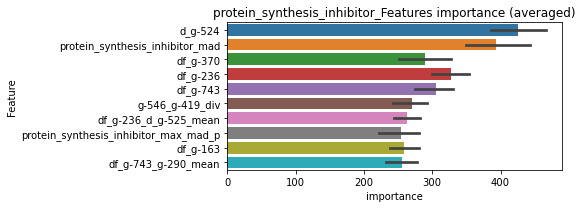

len(train_index) : 2736
len(valid_index) : 913
================================= fold 1/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125664	valid_1's binary_logloss: 0.199963
[200]	training's binary_logloss: 0.049783	valid_1's binary_logloss: 0.127067
[300]	training's binary_logloss: 0.0224046	valid_1's binary_logloss: 0.0956507
[400]	training's binary_logloss: 0.0107463	valid_1's binary_logloss: 0.0808203
[500]	training's binary_logloss: 0.00546664	valid_1's binary_logloss: 0.0715973
[600]	training's binary_logloss: 0.00317274	valid_1's binary_logloss: 0.068091
[700]	training's binary_logloss: 0.00206775	valid_1's binary_logloss: 0.065069
[800]	training's binary_logloss: 0.0015017	valid_1's binary_logloss: 0.0631166
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00128871	valid_1's binary_logloss: 0.0625147


len(train_index) : 2737
len(valid_index) : 912
================================= fold 2/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.125019	valid_1's binary_logloss: 0.181332
[200]	training's binary_logloss: 0.0512848	valid_1's binary_logloss: 0.113687
[300]	training's binary_logloss: 0.0228551	valid_1's binary_logloss: 0.0839327
[400]	training's binary_logloss: 0.010698	valid_1's binary_logloss: 0.0658697
[500]	training's binary_logloss: 0.00550289	valid_1's binary_logloss: 0.0548048
[600]	training's binary_logloss: 0.00318014	valid_1's binary_logloss: 0.0501174
[700]	training's binary_logloss: 0.00207791	valid_1's binary_logloss: 0.0459587
[800]	training's binary_logloss: 0.00151228	valid_1's binary_logloss: 0.0441761
[900]	training's binary_logloss: 0.00119388	valid_1's binary_logloss: 0.0419494
Early stopping, best iteration is:
[959]	training's binary_logloss: 0.00107242	valid_1's binary_logloss: 0.0411498


len(train_index) : 2737
len(valid_index) : 912
================================= fold 3/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.124855	valid_1's binary_logloss: 0.160179
[200]	training's binary_logloss: 0.0510162	valid_1's binary_logloss: 0.0903137
[300]	training's binary_logloss: 0.0232839	valid_1's binary_logloss: 0.0605046
[400]	training's binary_logloss: 0.0112475	valid_1's binary_logloss: 0.0450156
[500]	training's binary_logloss: 0.00577062	valid_1's binary_logloss: 0.03585
[600]	training's binary_logloss: 0.00328767	valid_1's binary_logloss: 0.0309444
[700]	training's binary_logloss: 0.00214455	valid_1's binary_logloss: 0.0279555
[800]	training's binary_logloss: 0.00156076	valid_1's binary_logloss: 0.026134
[900]	training's binary_logloss: 0.00123016	valid_1's binary_logloss: 0.0249395
[1000]	training's binary_logloss: 0.00103343	valid_1's binary_logloss: 0.0240769
Early stopping, best iteration is:
[1058]	training's binary_logloss: 0.000962464	valid_1's binary_logloss: 0.0236667


len(train_index) : 2737
len(valid_index) : 912
================================= fold 4/4 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120208	valid_1's binary_logloss: 0.180607
[200]	training's binary_logloss: 0.0480011	valid_1's binary_logloss: 0.12201
[300]	training's binary_logloss: 0.0212817	valid_1's binary_logloss: 0.0987833
[400]	training's binary_logloss: 0.00992582	valid_1's binary_logloss: 0.0853887
[500]	training's binary_logloss: 0.00512054	valid_1's binary_logloss: 0.0799338
[600]	training's binary_logloss: 0.00298164	valid_1's binary_logloss: 0.0783316
Early stopping, best iteration is:
[643]	training's binary_logloss: 0.00246227	valid_1's binary_logloss: 0.077409


protein_synthesis_inhibitor logloss: 0.051188132625387905


neg labels: 3289 → selected neg labels: 3285


protein_tyrosine_kinase_inhibitor, len(trt): 19, len(othr): 3285, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822035	valid_1's binary_logloss: 0.0997359
[200]	training's binary_logloss: 0.0240073	valid_1's binary_logloss: 0.0362821
[300]	training's binary_logloss: 0.00787735	valid_1's binary_logloss: 0.015604
[400]	training's binary_logloss: 0.00309557	valid_1's binary_logloss: 0.00804495
[500]	training's binary_logloss: 0.00158348	valid_1's binary_logloss: 0.0052207
[600]	training's binary_logloss: 0.00100882	valid_1's binary_logloss: 0.00388722
[700]	training's binary_logloss: 0.000735512	valid_1's binary_logloss: 0.00321303
[800]	training's binary_logloss: 0.000590469	valid_1's binary_logloss: 0.00275967
[900]	training's binary_logloss: 0.000526379	valid_1's binary_logloss: 0.00267383
Early stopping, best iteration is:
[948]	training's binary_logloss: 0.000512502	valid_1's binary_logloss: 0.00263545
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

1 / 3 AUC score:1.000
y_Threshold: 0.0050348, Threshold: 0.0240630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.01684, conf_1:0.03128
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0240630
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_2: 0.0740630
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_3: 0.1240630
threshold: 0.1240630, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0802396	valid_1's binary_logloss: 0.0993659
[200]	training's binary_logloss: 0.022367	valid_1's binary_logloss: 0.0342519
[300]	training's binary_logloss: 0.00711535	valid_1's binary_logloss: 0.0136402
[400]	training's binary_logloss: 0.00278738	valid_1's binary_logloss: 0.00646793
[500]	training's binary_logloss: 0.00142911	valid_1's binary_logloss: 0.00371239
[600]	training's binary_logloss: 0.000904229	valid_1's binary_logloss: 0.00260908
[700]	training's binary_logloss: 0.000666558	valid_1's binary_logloss: 0.00209802
[800]	training's binary_logloss: 0.000537933	valid_1's binary_logloss: 0.001797
[900]	training's binary_logloss: 0.000477841	valid_1's binary_logloss: 0.00165263
[1000]	training's binary_logloss: 0.000458024	valid_1's binary_logloss: 0.00160664
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000458024	valid_1's binary_logloss: 0.00160664
Training until

2 / 3 AUC score:1.000
y_Threshold: 0.0692432, Threshold: 0.1240630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0067805 Vs.target_rate: 0.00080, Num_p_label: 27.0, conf_0:0.09925, conf_1:0.14888
Num_p_label: 27.0, Expected: 3.2, Adj_threshold_1: 0.1240630
Num_p_label: 16.0, Expected: 3.2, Adj_threshold_2: 0.1740630
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_3: 0.2240630
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_4: 0.2740630
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_5: 0.3240630
threshold: 0.3240630, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0802396	valid_1's binary_logloss: 0.0993659
[200]	training's binary_logloss: 0.022367	valid_1's binary_logloss: 0.0342519
[300]	training's binary_logloss: 0.00711535	valid_1's binary_logloss: 0.0136402
[400]	training's binary_logloss: 0.00278738	valid_1's binary_logloss: 0.00646793
[500]	training's binary_logloss: 0.00142911	valid_1's binary_logloss: 0.00371239
[600]	training's binary_logloss: 0.000904229	valid_1's binary_logloss: 0.00260908
[700]	training's binary_logloss: 0.000666558	valid_1's binary_logloss: 0.00209802
[800]	training's binary_logloss: 0.000537933	valid_1's binary_logloss: 0.001797
[900]	training's binary_logloss: 0.000477841	valid_1's binary_logloss: 0.00165263
[1000]	training's binary_logloss: 0.000458024	valid_1's binary_logloss: 0.00160664
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000458024	valid_1's binary_logloss: 0.00160664
Training until

3 / 3 AUC score:1.000
y_Threshold: 0.0692432, Threshold: 0.3240630, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3810
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.29166, conf_1:0.35647
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_1: 0.3240630
threshold: 0.3240630, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3810, y_label_rate: 0.1724409


len(train_index) : 2857
len(valid_index) : 953
================================= fold 1/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0809923	valid_1's binary_logloss: 0.102453
[200]	training's binary_logloss: 0.0217925	valid_1's binary_logloss: 0.0348026
[300]	training's binary_logloss: 0.00687185	valid_1's binary_logloss: 0.0138476
[400]	training's binary_logloss: 0.00273277	valid_1's binary_logloss: 0.00677009
[500]	training's binary_logloss: 0.00143106	valid_1's binary_logloss: 0.00417306
[600]	training's binary_logloss: 0.000911885	valid_1's binary_logloss: 0.0029734
[700]	training's binary_logloss: 0.000665619	valid_1's binary_logloss: 0.00242372
[800]	training's binary_logloss: 0.000532847	valid_1's binary_logloss: 0.00209545
[900]	training's binary_logloss: 0.000477858	valid_1's binary_logloss: 0.00195683
[1000]	training's binary_logloss: 0.000456046	valid_1's binary_logloss: 0.00190289
[1100]	training's binary_logloss: 0.000450495	valid_1's binary_logloss: 0.00187829
Early stopping, best iteration is:
[1085]	train

len(train_index) : 2857
len(valid_index) : 953
================================= fold 2/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794605	valid_1's binary_logloss: 0.102522
[200]	training's binary_logloss: 0.0218931	valid_1's binary_logloss: 0.0387287
[300]	training's binary_logloss: 0.00697879	valid_1's binary_logloss: 0.0178817
[400]	training's binary_logloss: 0.0028177	valid_1's binary_logloss: 0.0100989
[500]	training's binary_logloss: 0.00145694	valid_1's binary_logloss: 0.00713381
[600]	training's binary_logloss: 0.000927678	valid_1's binary_logloss: 0.00568615
[700]	training's binary_logloss: 0.000673464	valid_1's binary_logloss: 0.00489277
[800]	training's binary_logloss: 0.000540925	valid_1's binary_logloss: 0.00448804
[900]	training's binary_logloss: 0.000487715	valid_1's binary_logloss: 0.00436968
[1000]	training's binary_logloss: 0.00046318	valid_1's binary_logloss: 0.00426679
Early stopping, best iteration is:
[998]	training's binary_logloss: 0.000463595	valid_1's binary_logloss: 0.00426068


len(train_index) : 2858
len(valid_index) : 952
================================= fold 3/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0795178	valid_1's binary_logloss: 0.101971
[200]	training's binary_logloss: 0.0214971	valid_1's binary_logloss: 0.0359524
[300]	training's binary_logloss: 0.00685183	valid_1's binary_logloss: 0.0158084
[400]	training's binary_logloss: 0.0027333	valid_1's binary_logloss: 0.00914733
[500]	training's binary_logloss: 0.00141517	valid_1's binary_logloss: 0.00635031
[600]	training's binary_logloss: 0.000899297	valid_1's binary_logloss: 0.00515043
[700]	training's binary_logloss: 0.00065733	valid_1's binary_logloss: 0.00449946
[800]	training's binary_logloss: 0.000533346	valid_1's binary_logloss: 0.00416507
[900]	training's binary_logloss: 0.000480422	valid_1's binary_logloss: 0.0039624
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00047895	valid_1's binary_logloss: 0.00396008


len(train_index) : 2858
len(valid_index) : 952
================================= fold 4/4 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0794922	valid_1's binary_logloss: 0.0957341
[200]	training's binary_logloss: 0.0219569	valid_1's binary_logloss: 0.0325829
[300]	training's binary_logloss: 0.00690033	valid_1's binary_logloss: 0.0129294
[400]	training's binary_logloss: 0.00279866	valid_1's binary_logloss: 0.00669342
[500]	training's binary_logloss: 0.00145505	valid_1's binary_logloss: 0.00413277
[600]	training's binary_logloss: 0.000924845	valid_1's binary_logloss: 0.00305968
[700]	training's binary_logloss: 0.000675261	valid_1's binary_logloss: 0.00243618
[800]	training's binary_logloss: 0.000539373	valid_1's binary_logloss: 0.00210583
[900]	training's binary_logloss: 0.000483589	valid_1's binary_logloss: 0.00196867
Early stopping, best iteration is:
[937]	training's binary_logloss: 0.000474804	valid_1's binary_logloss: 0.00194544


protein_tyrosine_kinase_inhibitor logloss: 0.0030144795352377964


neg labels: 3289 → selected neg labels: 3283


radiopaque_medium, len(trt): 56, len(othr): 3283, target_rate: 0.0023516 → Adj_target_rate: 0.0025713
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.126846	valid_1's binary_logloss: 0.208416
[200]	training's binary_logloss: 0.0520449	valid_1's binary_logloss: 0.139894
[300]	training's binary_logloss: 0.0233664	valid_1's binary_logloss: 0.107843
[400]	training's binary_logloss: 0.0114365	valid_1's binary_logloss: 0.0910502
[500]	training's binary_logloss: 0.005902	valid_1's binary_logloss: 0.0802171
[600]	training's binary_logloss: 0.0034358	valid_1's binary_logloss: 0.0747217
[700]	training's binary_logloss: 0.00227638	valid_1's binary_logloss: 0.0717812
[800]	training's binary_logloss: 0.0016522	valid_1's binary_logloss: 0.0703157
[900]	training's binary_logloss: 0.00130167	valid_1's binary_logloss: 0.0695983
Early stopping, best iteration is:
[873]	training's binary_logloss: 0.00137979	valid_1's binary_logloss: 0.0694007
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127005	valid_1's bin

1 / 3 AUC score:0.998
y_Threshold: 0.0219445, Threshold: 0.1613098, pos_neg_ratio: 0.8000000
Remove_noisy_data: 148 → Positive_corect_labels: 648/3791
p_label_rate: 0.0100452 Vs.target_rate: 0.00235, Num_p_label: 40.0, conf_0:0.11292, conf_1:0.20970
Num_p_label: 40.0, Expected: 9.4, Adj_threshold_1: 0.1613098
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_2: 0.2113098
Num_p_label: 19.0, Expected: 9.4, Adj_threshold_3: 0.2613098
threshold: 0.2613098, positive_p_label: 19.0/3982, p_label_rate: 0.0047715
positive_y_label: 648.0/3791, y_label_rate: 0.1709312
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121759	valid_1's binary_logloss: 0.165322
[200]	training's binary_logloss: 0.046545	valid_1's binary_logloss: 0.0887279
[300]	training's binary_logloss: 0.0192966	valid_1's binary_logloss: 0.0547412
[400]	training's binary_logloss: 0.00890749	valid_1's binary_logloss: 0.0376815
[500]	training's binary_logloss: 0.00452098	valid_1's binary_logloss: 0.027601
[600]	training's binary_logloss: 0.00268056	valid_1's binary_logloss: 0.0231772
[700]	training's binary_logloss: 0.00181779	valid_1's binary_logloss: 0.0209635
[800]	training's binary_logloss: 0.00134958	valid_1's binary_logloss: 0.0197067
[900]	training's binary_logloss: 0.0010893	valid_1's binary_logloss: 0.0183935
[1000]	training's binary_logloss: 0.000927528	valid_1's binary_logloss: 0.017799
[1100]	training's binary_logloss: 0.000849348	valid_1's binary_logloss: 0.0175555
Early stopping, best iteration is:
[1120]	training's binary_logl

2 / 3 AUC score:0.998
y_Threshold: 0.1183214, Threshold: 0.2613098, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 637.0/3769
p_label_rate: 0.0200904 Vs.target_rate: 0.00235, Num_p_label: 80.0, conf_0:0.20905, conf_1:0.31357
Num_p_label: 80.0, Expected: 9.4, Adj_threshold_1: 0.2613098
Num_p_label: 70.0, Expected: 9.4, Adj_threshold_2: 0.3113098
Num_p_label: 61.0, Expected: 9.4, Adj_threshold_3: 0.3613098
Num_p_label: 54.0, Expected: 9.4, Adj_threshold_4: 0.4113098
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_5: 0.4613098
Num_p_label: 44.0, Expected: 9.4, Adj_threshold_6: 0.5113098
Num_p_label: 38.0, Expected: 9.4, Adj_threshold_7: 0.5613098
Num_p_label: 36.0, Expected: 9.4, Adj_threshold_8: 0.6113098
Num_p_label: 30.0, Expected: 9.4, Adj_threshold_9: 0.6613098
Num_p_label: 24.0, Expected: 9.4, Adj_threshold_10: 0.7113098
threshold: 0.7613098, positive_p_label: 23.0/3982, p_label_rate: 0.0057760
positive_y_label: 637.0/3769, y_label_rate: 0.1690103
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.1178	valid_1's binary_logloss: 0.165549
[200]	training's binary_logloss: 0.044069	valid_1's binary_logloss: 0.0942288
[300]	training's binary_logloss: 0.0185916	valid_1's binary_logloss: 0.0622369
[400]	training's binary_logloss: 0.0085256	valid_1's binary_logloss: 0.04702
[500]	training's binary_logloss: 0.00432858	valid_1's binary_logloss: 0.0376817
[600]	training's binary_logloss: 0.00257905	valid_1's binary_logloss: 0.0333095
[700]	training's binary_logloss: 0.00173726	valid_1's binary_logloss: 0.0312372
[800]	training's binary_logloss: 0.00129631	valid_1's binary_logloss: 0.0294774
[900]	training's binary_logloss: 0.0010479	valid_1's binary_logloss: 0.0281231
Early stopping, best iteration is:
[900]	training's binary_logloss: 0.0010479	valid_1's binary_logloss: 0.0281231
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115515	valid_1's bina

3 / 3 AUC score:0.999
y_Threshold: 0.1245299, Threshold: 0.7613098, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 623.0/3741
p_label_rate: 0.0082873 Vs.target_rate: 0.00235, Num_p_label: 33.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 33.0, Expected: 9.4, Adj_threshold_1: 0.7613098
threshold: 0.7613098, positive_p_label: 33.0/3982, p_label_rate: 0.0082873
positive_y_label: 623.0/3741, y_label_rate: 0.1665330


len(train_index) : 2805
len(valid_index) : 936
================================= fold 1/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113676	valid_1's binary_logloss: 0.158452
[200]	training's binary_logloss: 0.0409377	valid_1's binary_logloss: 0.0895392
[300]	training's binary_logloss: 0.017036	valid_1's binary_logloss: 0.0605756
[400]	training's binary_logloss: 0.00757079	valid_1's binary_logloss: 0.0461867
[500]	training's binary_logloss: 0.00389468	valid_1's binary_logloss: 0.0380024
[600]	training's binary_logloss: 0.00232832	valid_1's binary_logloss: 0.034594
[700]	training's binary_logloss: 0.00158507	valid_1's binary_logloss: 0.0331945
[800]	training's binary_logloss: 0.00119717	valid_1's binary_logloss: 0.031832
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.001054	valid_1's binary_logloss: 0.0311448


len(train_index) : 2806
len(valid_index) : 935
================================= fold 2/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113607	valid_1's binary_logloss: 0.171699
[200]	training's binary_logloss: 0.0413711	valid_1's binary_logloss: 0.100768
[300]	training's binary_logloss: 0.0173414	valid_1's binary_logloss: 0.0688416
[400]	training's binary_logloss: 0.00764956	valid_1's binary_logloss: 0.0535235
[500]	training's binary_logloss: 0.00391282	valid_1's binary_logloss: 0.0457656
[600]	training's binary_logloss: 0.00234007	valid_1's binary_logloss: 0.0417279
[700]	training's binary_logloss: 0.00158841	valid_1's binary_logloss: 0.0396098
[800]	training's binary_logloss: 0.00119571	valid_1's binary_logloss: 0.0384487
Early stopping, best iteration is:
[869]	training's binary_logloss: 0.0010226	valid_1's binary_logloss: 0.0377241


len(train_index) : 2806
len(valid_index) : 935
================================= fold 3/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115023	valid_1's binary_logloss: 0.1628
[200]	training's binary_logloss: 0.0422474	valid_1's binary_logloss: 0.091683
[300]	training's binary_logloss: 0.0177541	valid_1's binary_logloss: 0.063262
[400]	training's binary_logloss: 0.00813309	valid_1's binary_logloss: 0.0490243
[500]	training's binary_logloss: 0.00409386	valid_1's binary_logloss: 0.0418429
[600]	training's binary_logloss: 0.00241183	valid_1's binary_logloss: 0.0380223
[700]	training's binary_logloss: 0.00163067	valid_1's binary_logloss: 0.036532
Early stopping, best iteration is:
[766]	training's binary_logloss: 0.0013342	valid_1's binary_logloss: 0.0353682


len(train_index) : 2806
len(valid_index) : 935
================================= fold 4/4 radiopaque_medium=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115235	valid_1's binary_logloss: 0.160236
[200]	training's binary_logloss: 0.0416466	valid_1's binary_logloss: 0.0876069
[300]	training's binary_logloss: 0.0167622	valid_1's binary_logloss: 0.055743
[400]	training's binary_logloss: 0.00753168	valid_1's binary_logloss: 0.0405123
[500]	training's binary_logloss: 0.00389072	valid_1's binary_logloss: 0.0340474
[600]	training's binary_logloss: 0.00232877	valid_1's binary_logloss: 0.0301607
[700]	training's binary_logloss: 0.00158021	valid_1's binary_logloss: 0.027685
[800]	training's binary_logloss: 0.00119237	valid_1's binary_logloss: 0.0262358
[900]	training's binary_logloss: 0.000972771	valid_1's binary_logloss: 0.0251074
[1000]	training's binary_logloss: 0.000858001	valid_1's binary_logloss: 0.0246611
[1100]	training's binary_logloss: 0.000805724	valid_1's binary_logloss: 0.0241585
Early stopping, best iteration is:
[1101]	training's binary_l

radiopaque_medium logloss: 0.032096482098280775


neg labels: 3289 → selected neg labels: 3266


raf_inhibitor, len(trt): 223, len(othr): 3266, target_rate: 0.0093642 → Adj_target_rate: 0.0083226
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.228168	valid_1's binary_logloss: 0.327409
[200]	training's binary_logloss: 0.13957	valid_1's binary_logloss: 0.287997
[300]	training's binary_logloss: 0.088429	valid_1's binary_logloss: 0.265071
[400]	training's binary_logloss: 0.0570752	valid_1's binary_logloss: 0.252718
[500]	training's binary_logloss: 0.037877	valid_1's binary_logloss: 0.247005
[600]	training's binary_logloss: 0.0253051	valid_1's binary_logloss: 0.24497
Early stopping, best iteration is:
[597]	training's binary_logloss: 0.0255752	valid_1's binary_logloss: 0.244848
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.221441	valid_1's binary_logloss: 0.346139
[200]	training's binary_logloss: 0.138678	valid_1's binary_logloss: 0.306857
[300]	training's binary_logloss: 0.0891809	valid_1's binary_logloss: 0.284246
[400]	training's binary_logloss: 0.0575956	valid_1's binary_logloss: 0.

1 / 3 AUC score:0.894
y_Threshold: 0.0978702, Threshold: 0.4512044, pos_neg_ratio: 0.8000000
Remove_noisy_data: 433 → Positive_corect_labels: 502/3486
p_label_rate: 0.0100452 Vs.target_rate: 0.00936, Num_p_label: 40.0, conf_0:0.31584, conf_1:0.58657
threshold: 0.4512044, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 502.0/3486, y_label_rate: 0.1440046
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.146394	valid_1's binary_logloss: 0.239607
[200]	training's binary_logloss: 0.0708229	valid_1's binary_logloss: 0.182046
[300]	training's binary_logloss: 0.0379802	valid_1's binary_logloss: 0.15557
[400]	training's binary_logloss: 0.0211978	valid_1's binary_logloss: 0.138675
[500]	training's binary_logloss: 0.0119801	valid_1's binary_logloss: 0.128765
[600]	training's binary_logloss: 0.00707942	valid_1's binary_logloss: 0.124617
[700]	training's binary_logloss: 0.0045702	valid_1's binary_logloss: 0.121978
Early stopping, best iteration is:
[672]	training's binary_logloss: 0.00513408	valid_1's binary_logloss: 0.121912
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.151725	valid_1's binary_logloss: 0.234847
[200]	training's binary_logloss: 0.0748091	valid_1's binary_logloss: 0.181067
[300]	training's binary_logloss: 0.0399059	valid_1's binary_logl

2 / 3 AUC score:0.973
y_Threshold: 0.1085993, Threshold: 0.4512044, pos_neg_ratio: 0.8000000
Remove_noisy_data: 118 → Positive_corect_labels: 443.0/3368
p_label_rate: 0.0376695 Vs.target_rate: 0.00936, Num_p_label: 150.0, conf_0:0.36096, conf_1:0.54145
Num_p_label: 150.0, Expected: 37.3, Adj_threshold_1: 0.4512044
Num_p_label: 132.0, Expected: 37.3, Adj_threshold_2: 0.5012044
Num_p_label: 120.0, Expected: 37.3, Adj_threshold_3: 0.5512044
Num_p_label: 103.0, Expected: 37.3, Adj_threshold_4: 0.6012044
Num_p_label: 88.0, Expected: 37.3, Adj_threshold_5: 0.6512044
Num_p_label: 78.0, Expected: 37.3, Adj_threshold_6: 0.7012044
Num_p_label: 69.0, Expected: 37.3, Adj_threshold_7: 0.7512044
threshold: 0.7512044, positive_p_label: 69.0/3982, p_label_rate: 0.0173280
positive_y_label: 443.0/3368, y_label_rate: 0.1315321
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118182	valid_1's binary_logloss: 0.186902
[200]	training's binary_logloss: 0.0518186	valid_1's binary_logloss: 0.14065
[300]	training's binary_logloss: 0.0258668	valid_1's binary_logloss: 0.120747
[400]	training's binary_logloss: 0.013183	valid_1's binary_logloss: 0.11162
[500]	training's binary_logloss: 0.00708384	valid_1's binary_logloss: 0.108261
[600]	training's binary_logloss: 0.00419899	valid_1's binary_logloss: 0.107389
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.00399598	valid_1's binary_logloss: 0.106838
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112425	valid_1's binary_logloss: 0.207189
[200]	training's binary_logloss: 0.0496498	valid_1's binary_logloss: 0.163786
[300]	training's binary_logloss: 0.0237444	valid_1's binary_logloss: 0.145248
[400]	training's binary_logloss: 0.0121664	valid_1's binary_loglo

3 / 3 AUC score:0.963
y_Threshold: 0.0792024, Threshold: 0.7512044, pos_neg_ratio: 0.8000000


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0111688	valid_1's binary_logloss: 0.137485


Remove_noisy_data: 100 → Positive_corect_labels: 393.0/3268
p_label_rate: 0.0346560 Vs.target_rate: 0.00936, Num_p_label: 138.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 138.0, Expected: 37.3, Adj_threshold_1: 0.7512044
threshold: 0.7512044, positive_p_label: 138.0/3982, p_label_rate: 0.0346560
positive_y_label: 393.0/3268, y_label_rate: 0.1202570


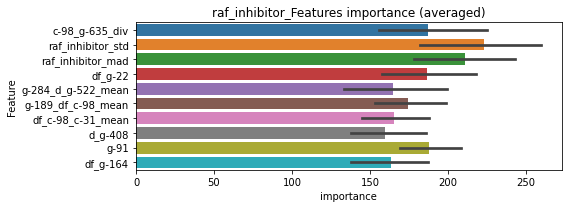

len(train_index) : 2451
len(valid_index) : 817
================================= fold 1/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918054	valid_1's binary_logloss: 0.155992
[200]	training's binary_logloss: 0.0358268	valid_1's binary_logloss: 0.105708
[300]	training's binary_logloss: 0.0153272	valid_1's binary_logloss: 0.0848251
[400]	training's binary_logloss: 0.00726064	valid_1's binary_logloss: 0.0736061
[500]	training's binary_logloss: 0.00389645	valid_1's binary_logloss: 0.0664826
[600]	training's binary_logloss: 0.00240437	valid_1's binary_logloss: 0.0623781
[700]	training's binary_logloss: 0.00166837	valid_1's binary_logloss: 0.0597087
[800]	training's binary_logloss: 0.00127831	valid_1's binary_logloss: 0.0593297
Early stopping, best iteration is:
[775]	training's binary_logloss: 0.00135343	valid_1's binary_logloss: 0.0588063


len(train_index) : 2451
len(valid_index) : 817
================================= fold 2/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881312	valid_1's binary_logloss: 0.159364
[200]	training's binary_logloss: 0.0326694	valid_1's binary_logloss: 0.114078
[300]	training's binary_logloss: 0.0144325	valid_1's binary_logloss: 0.0941738
[400]	training's binary_logloss: 0.00667042	valid_1's binary_logloss: 0.0812034
[500]	training's binary_logloss: 0.00361441	valid_1's binary_logloss: 0.0745118
[600]	training's binary_logloss: 0.00225518	valid_1's binary_logloss: 0.0705953
Early stopping, best iteration is:
[651]	training's binary_logloss: 0.00184089	valid_1's binary_logloss: 0.0690911


len(train_index) : 2451
len(valid_index) : 817
================================= fold 3/4 raf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0902802	valid_1's binary_logloss: 0.139393
[200]	training's binary_logloss: 0.034482	valid_1's binary_logloss: 0.0940953
[300]	training's binary_logloss: 0.0148644	valid_1's binary_logloss: 0.0749377
[400]	training's binary_logloss: 0.00698357	valid_1's binary_logloss: 0.06748


len(train_index) : 2451
len(valid_index) : 817
================================= fold 4/4 raf_inhibitor=================================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00525301	valid_1's binary_logloss: 0.0657039
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0937969	valid_1's binary_logloss: 0.142468
[200]	training's binary_logloss: 0.0364458	valid_1's binary_logloss: 0.0878524
[300]	training's binary_logloss: 0.016429	valid_1's binary_logloss: 0.062793
[400]	training's binary_logloss: 0.00791633	valid_1's binary_logloss: 0.0506873
[500]	training's binary_logloss: 0.00416147	valid_1's binary_logloss: 0.0427554
[600]	training's binary_logloss: 0.00253783	valid_1's binary_logloss: 0.0396522
[700]	training's binary_logloss: 0.00173799	valid_1's binary_logloss: 0.0374441
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.00175641	valid_1's binary_logloss: 0.0373504


raf_inhibitor logloss: 0.05773792067382179


neg labels: 3289 → selected neg labels: 3289


ras_gtpase_inhibitor, len(trt): 12, len(othr): 3289, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0788834	valid_1's binary_logloss: 0.0923192
[200]	training's binary_logloss: 0.0227841	valid_1's binary_logloss: 0.0318659
[300]	training's binary_logloss: 0.00670657	valid_1's binary_logloss: 0.0129156
[400]	training's binary_logloss: 0.00242882	valid_1's binary_logloss: 0.00673409
[500]	training's binary_logloss: 0.00122375	valid_1's binary_logloss: 0.0045103
[600]	training's binary_logloss: 0.000772394	valid_1's binary_logloss: 0.00351871
[700]	training's binary_logloss: 0.000569345	valid_1's binary_logloss: 0.00307924
[800]	training's binary_logloss: 0.000462629	valid_1's binary_logloss: 0.00281113
[900]	training's binary_logloss: 0.000417838	valid_1's binary_logloss: 0.00262823
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.000415038	valid_1's binary_logloss: 0.00261741
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0036293, Threshold: 0.0495359, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.03468, conf_1:0.06440
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0495359
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_2: 0.0995359
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.1495359
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_4: 0.1995359
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_5: 0.2495359
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_6: 0.2995359
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_7: 0.3495359
threshold: 0.3495359, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0728238	valid_1's binary_logloss: 0.0845232
[200]	training's binary_logloss: 0.0177206	valid_1's binary_logloss: 0.0239944
[300]	training's binary_logloss: 0.00508569	valid_1's binary_logloss: 0.00814618
[400]	training's binary_logloss: 0.00193306	valid_1's binary_logloss: 0.00365538
[500]	training's binary_logloss: 0.00101046	valid_1's binary_logloss: 0.00216153
[600]	training's binary_logloss: 0.000649354	valid_1's binary_logloss: 0.00151915
[700]	training's binary_logloss: 0.000482371	valid_1's binary_logloss: 0.00121271
[800]	training's binary_logloss: 0.000405426	valid_1's binary_logloss: 0.00106176
[900]	training's binary_logloss: 0.000375795	valid_1's binary_logloss: 0.00099866
[1000]	training's binary_logloss: 0.000370274	valid_1's binary_logloss: 0.000986789
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000370274	valid_1's binary_logloss: 0.000986789
Training

2 / 3 AUC score:1.000
y_Threshold: 0.1727417, Threshold: 0.3495359, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0062783 Vs.target_rate: 0.00050, Num_p_label: 25.0, conf_0:0.27963, conf_1:0.41944
Num_p_label: 25.0, Expected: 2.0, Adj_threshold_1: 0.3495359
Num_p_label: 22.0, Expected: 2.0, Adj_threshold_2: 0.3995359
Num_p_label: 17.0, Expected: 2.0, Adj_threshold_3: 0.4495359
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_4: 0.4995359
Num_p_label: 15.0, Expected: 2.0, Adj_threshold_5: 0.5495359
Num_p_label: 13.0, Expected: 2.0, Adj_threshold_6: 0.5995359
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_7: 0.6495359
Num_p_label: 11.0, Expected: 2.0, Adj_threshold_8: 0.6995359
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_9: 0.7495359
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_10: 0.7995359
threshold: 0.7995359, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
=============

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0728238	valid_1's binary_logloss: 0.0845232
[200]	training's binary_logloss: 0.0177206	valid_1's binary_logloss: 0.0239944
[300]	training's binary_logloss: 0.00508569	valid_1's binary_logloss: 0.00814618
[400]	training's binary_logloss: 0.00193306	valid_1's binary_logloss: 0.00365538
[500]	training's binary_logloss: 0.00101046	valid_1's binary_logloss: 0.00216153
[600]	training's binary_logloss: 0.000649354	valid_1's binary_logloss: 0.00151915
[700]	training's binary_logloss: 0.000482371	valid_1's binary_logloss: 0.00121271
[800]	training's binary_logloss: 0.000405426	valid_1's binary_logloss: 0.00106176
[900]	training's binary_logloss: 0.000375795	valid_1's binary_logloss: 0.00099866
[1000]	training's binary_logloss: 0.000370274	valid_1's binary_logloss: 0.000986789
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000370274	valid_1's binary_logloss: 0.000986789
Training

3 / 3 AUC score:1.000
y_Threshold: 0.1727417, Threshold: 0.7995359, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0015068 Vs.target_rate: 0.00050, Num_p_label: 6.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_1: 0.7995359
threshold: 0.7995359, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


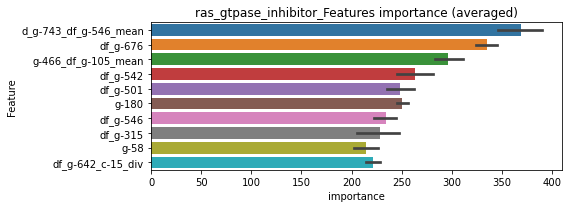

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0729653	valid_1's binary_logloss: 0.0851282
[200]	training's binary_logloss: 0.0182058	valid_1's binary_logloss: 0.0249262
[300]	training's binary_logloss: 0.00522722	valid_1's binary_logloss: 0.00867465
[400]	training's binary_logloss: 0.00195982	valid_1's binary_logloss: 0.00384392
[500]	training's binary_logloss: 0.00100373	valid_1's binary_logloss: 0.00223369
[600]	training's binary_logloss: 0.000653677	valid_1's binary_logloss: 0.00159506
[700]	training's binary_logloss: 0.000486968	valid_1's binary_logloss: 0.00127316
[800]	training's binary_logloss: 0.000405341	valid_1's binary_logloss: 0.0011119
[900]	training's binary_logloss: 0.000378294	valid_1's binary_logloss: 0.0010551
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.000376788	valid_1's binary_logloss: 0.00105167


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0747267	valid_1's binary_logloss: 0.0812101
[200]	training's binary_logloss: 0.0190187	valid_1's binary_logloss: 0.0232797
[300]	training's binary_logloss: 0.00533672	valid_1's binary_logloss: 0.00799334
[400]	training's binary_logloss: 0.00199593	valid_1's binary_logloss: 0.00372413
[500]	training's binary_logloss: 0.00103101	valid_1's binary_logloss: 0.00218759
[600]	training's binary_logloss: 0.000668968	valid_1's binary_logloss: 0.00155691
[700]	training's binary_logloss: 0.000492774	valid_1's binary_logloss: 0.00125204
[800]	training's binary_logloss: 0.000408945	valid_1's binary_logloss: 0.00111041
[900]	training's binary_logloss: 0.000379762	valid_1's binary_logloss: 0.00106941
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.00037721	valid_1's binary_logloss: 0.00106404


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0720292	valid_1's binary_logloss: 0.0840704
[200]	training's binary_logloss: 0.0180517	valid_1's binary_logloss: 0.023904
[300]	training's binary_logloss: 0.0051133	valid_1's binary_logloss: 0.00792103
[400]	training's binary_logloss: 0.00194437	valid_1's binary_logloss: 0.00351222
[500]	training's binary_logloss: 0.00100435	valid_1's binary_logloss: 0.00208142
[600]	training's binary_logloss: 0.000649516	valid_1's binary_logloss: 0.00143601
[700]	training's binary_logloss: 0.000482391	valid_1's binary_logloss: 0.00115444
[800]	training's binary_logloss: 0.000402236	valid_1's binary_logloss: 0.00101298
[900]	training's binary_logloss: 0.000377547	valid_1's binary_logloss: 0.000966432
Early stopping, best iteration is:
[947]	training's binary_logloss: 0.000370704	valid_1's binary_logloss: 0.000954413


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0741085	valid_1's binary_logloss: 0.0859863
[200]	training's binary_logloss: 0.0191878	valid_1's binary_logloss: 0.0260733
[300]	training's binary_logloss: 0.00526902	valid_1's binary_logloss: 0.0086708
[400]	training's binary_logloss: 0.00197471	valid_1's binary_logloss: 0.00390581
[500]	training's binary_logloss: 0.00101418	valid_1's binary_logloss: 0.00228983
[600]	training's binary_logloss: 0.000656881	valid_1's binary_logloss: 0.00165609
[700]	training's binary_logloss: 0.000483636	valid_1's binary_logloss: 0.00129855
[800]	training's binary_logloss: 0.000406952	valid_1's binary_logloss: 0.00114173
[900]	training's binary_logloss: 0.00038084	valid_1's binary_logloss: 0.00108871
Early stopping, best iteration is:
[877]	training's binary_logloss: 0.00038084	valid_1's binary_logloss: 0.00108871


ras_gtpase_inhibitor logloss: 0.0010399926174750713


neg labels: 3289 → selected neg labels: 3278


retinoid_receptor_agonist, len(trt): 67, len(othr): 3278, target_rate: 0.0028135 → Adj_target_rate: 0.0029948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133484	valid_1's binary_logloss: 0.210779
[200]	training's binary_logloss: 0.0584243	valid_1's binary_logloss: 0.141691
[300]	training's binary_logloss: 0.0280939	valid_1's binary_logloss: 0.107137
[400]	training's binary_logloss: 0.0140969	valid_1's binary_logloss: 0.0889941
[500]	training's binary_logloss: 0.0074764	valid_1's binary_logloss: 0.0788518
[600]	training's binary_logloss: 0.00435144	valid_1's binary_logloss: 0.0733169
[700]	training's binary_logloss: 0.00279423	valid_1's binary_logloss: 0.0704059
[800]	training's binary_logloss: 0.00198398	valid_1's binary_logloss: 0.0684661
[900]	training's binary_logloss: 0.00152328	valid_1's binary_logloss: 0.0672319
Early stopping, best iteration is:
[914]	training's binary_logloss: 0.00147878	valid_1's binary_logloss: 0.0670703
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135845	valid_1's 

1 / 3 AUC score:0.994
y_Threshold: 0.0294672, Threshold: 0.2990210, pos_neg_ratio: 0.8000000
Remove_noisy_data: 148 → Positive_corect_labels: 647/3785
p_label_rate: 0.0100452 Vs.target_rate: 0.00281, Num_p_label: 40.0, conf_0:0.20931, conf_1:0.38873
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_1: 0.2990210
Num_p_label: 34.0, Expected: 11.2, Adj_threshold_2: 0.3490210
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_3: 0.3990210
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_4: 0.4490210
Num_p_label: 28.0, Expected: 11.2, Adj_threshold_5: 0.4990210
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_6: 0.5490210
Num_p_label: 20.0, Expected: 11.2, Adj_threshold_7: 0.5990210
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_8: 0.6490210
Num_p_label: 15.0, Expected: 11.2, Adj_threshold_9: 0.6990210
threshold: 0.6990210, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3785, y_label_rate: 0.1709379
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129641	valid_1's binary_logloss: 0.174106
[200]	training's binary_logloss: 0.0567306	valid_1's binary_logloss: 0.104778
[300]	training's binary_logloss: 0.0258996	valid_1's binary_logloss: 0.0709054
[400]	training's binary_logloss: 0.0124832	valid_1's binary_logloss: 0.0542657
[500]	training's binary_logloss: 0.00640613	valid_1's binary_logloss: 0.0442085
[600]	training's binary_logloss: 0.00371083	valid_1's binary_logloss: 0.0389801
[700]	training's binary_logloss: 0.0024006	valid_1's binary_logloss: 0.0365376
[800]	training's binary_logloss: 0.00174663	valid_1's binary_logloss: 0.0349215
[900]	training's binary_logloss: 0.00135669	valid_1's binary_logloss: 0.0343012
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.00127474	valid_1's binary_logloss: 0.0338949
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.13127	valid_1's 

2 / 3 AUC score:0.998
y_Threshold: 0.1317868, Threshold: 0.6990210, pos_neg_ratio: 0.8000000
Remove_noisy_data: 30 → Positive_corect_labels: 632.0/3755
p_label_rate: 0.0105475 Vs.target_rate: 0.00281, Num_p_label: 42.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_1: 0.6990210
Num_p_label: 38.0, Expected: 11.2, Adj_threshold_2: 0.7490210
Num_p_label: 31.0, Expected: 11.2, Adj_threshold_3: 0.7990210
threshold: 0.7990210, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 632.0/3755, y_label_rate: 0.1683089
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12564	valid_1's binary_logloss: 0.18016
[200]	training's binary_logloss: 0.0514878	valid_1's binary_logloss: 0.10758
[300]	training's binary_logloss: 0.0229744	valid_1's binary_logloss: 0.0744975
[400]	training's binary_logloss: 0.0111215	valid_1's binary_logloss: 0.0579491
[500]	training's binary_logloss: 0.0056886	valid_1's binary_logloss: 0.0501762
[600]	training's binary_logloss: 0.0033061	valid_1's binary_logloss: 0.0461631
[700]	training's binary_logloss: 0.0021664	valid_1's binary_logloss: 0.0436185
[800]	training's binary_logloss: 0.00157742	valid_1's binary_logloss: 0.0421955
[900]	training's binary_logloss: 0.00123859	valid_1's binary_logloss: 0.0415923
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.00131979	valid_1's binary_logloss: 0.0414278
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121931	valid_1's bina

3 / 3 AUC score:0.998
y_Threshold: 0.1069314, Threshold: 0.7990210, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 616.0/3723
p_label_rate: 0.0115520 Vs.target_rate: 0.00281, Num_p_label: 46.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 46.0, Expected: 11.2, Adj_threshold_1: 0.7990210
threshold: 0.7990210, positive_p_label: 46.0/3982, p_label_rate: 0.0115520
positive_y_label: 616.0/3723, y_label_rate: 0.1654580


len(train_index) : 2792
len(valid_index) : 931
================================= fold 1/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117022	valid_1's binary_logloss: 0.169938
[200]	training's binary_logloss: 0.0468173	valid_1's binary_logloss: 0.0969854
[300]	training's binary_logloss: 0.0205161	valid_1's binary_logloss: 0.0633634
[400]	training's binary_logloss: 0.00950519	valid_1's binary_logloss: 0.0450046
[500]	training's binary_logloss: 0.00487758	valid_1's binary_logloss: 0.0354472
[600]	training's binary_logloss: 0.00282498	valid_1's binary_logloss: 0.0297862
[700]	training's binary_logloss: 0.00188778	valid_1's binary_logloss: 0.0269013
[800]	training's binary_logloss: 0.00140137	valid_1's binary_logloss: 0.0249266
[900]	training's binary_logloss: 0.00112229	valid_1's binary_logloss: 0.023869
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00111038	valid_1's binary_logloss: 0.0237801


len(train_index) : 2792
len(valid_index) : 931
================================= fold 2/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118197	valid_1's binary_logloss: 0.172634
[200]	training's binary_logloss: 0.0483346	valid_1's binary_logloss: 0.102937
[300]	training's binary_logloss: 0.0219359	valid_1's binary_logloss: 0.0722187
[400]	training's binary_logloss: 0.0102547	valid_1's binary_logloss: 0.0552607
[500]	training's binary_logloss: 0.00515315	valid_1's binary_logloss: 0.0458628
[600]	training's binary_logloss: 0.00299545	valid_1's binary_logloss: 0.0399647
[700]	training's binary_logloss: 0.00198106	valid_1's binary_logloss: 0.0371803
[800]	training's binary_logloss: 0.00145764	valid_1's binary_logloss: 0.0364162
[900]	training's binary_logloss: 0.00116277	valid_1's binary_logloss: 0.0357332
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.00119172	valid_1's binary_logloss: 0.0355566


len(train_index) : 2792
len(valid_index) : 931
================================= fold 3/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123438	valid_1's binary_logloss: 0.172917
[200]	training's binary_logloss: 0.0495311	valid_1's binary_logloss: 0.105313
[300]	training's binary_logloss: 0.0221066	valid_1's binary_logloss: 0.0746776
[400]	training's binary_logloss: 0.0102729	valid_1's binary_logloss: 0.0595543
[500]	training's binary_logloss: 0.00521283	valid_1's binary_logloss: 0.0514321
[600]	training's binary_logloss: 0.00297542	valid_1's binary_logloss: 0.0464362
[700]	training's binary_logloss: 0.00195176	valid_1's binary_logloss: 0.0438241
[800]	training's binary_logloss: 0.00143659	valid_1's binary_logloss: 0.0422861
Early stopping, best iteration is:
[833]	training's binary_logloss: 0.00131641	valid_1's binary_logloss: 0.041739


len(train_index) : 2793
len(valid_index) : 930
================================= fold 4/4 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12026	valid_1's binary_logloss: 0.166454
[200]	training's binary_logloss: 0.0471018	valid_1's binary_logloss: 0.0942418
[300]	training's binary_logloss: 0.0207687	valid_1's binary_logloss: 0.0614097
[400]	training's binary_logloss: 0.0100666	valid_1's binary_logloss: 0.0454971
[500]	training's binary_logloss: 0.005176	valid_1's binary_logloss: 0.036416
[600]	training's binary_logloss: 0.00301206	valid_1's binary_logloss: 0.0316523
[700]	training's binary_logloss: 0.00198039	valid_1's binary_logloss: 0.0290163
[800]	training's binary_logloss: 0.00146712	valid_1's binary_logloss: 0.0274648
[900]	training's binary_logloss: 0.00116814	valid_1's binary_logloss: 0.0266614
[1000]	training's binary_logloss: 0.000981005	valid_1's binary_logloss: 0.0258338
[1100]	training's binary_logloss: 0.000877439	valid_1's binary_logloss: 0.0254402
Early stopping, best iteration is:
[1093]	training's binary_loglo

retinoid_receptor_agonist logloss: 0.03162618408367542


neg labels: 3289 → selected neg labels: 3288


retinoid_receptor_antagonist, len(trt): 6, len(othr): 3288, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453685	valid_1's binary_logloss: 0.0495565
[200]	training's binary_logloss: 0.00747678	valid_1's binary_logloss: 0.0109091
[300]	training's binary_logloss: 0.00170871	valid_1's binary_logloss: 0.00479157
[400]	training's binary_logloss: 0.000647986	valid_1's binary_logloss: 0.00312375
[500]	training's binary_logloss: 0.000365385	valid_1's binary_logloss: 0.00249855
[600]	training's binary_logloss: 0.000260129	valid_1's binary_logloss: 0.00220086
[700]	training's binary_logloss: 0.000220739	valid_1's binary_logloss: 0.00201821
[800]	training's binary_logloss: 0.000211956	valid_1's binary_logloss: 0.00197438
Early stopping, best iteration is:
[771]	training's binary_logloss: 0.000211956	valid_1's binary_logloss: 0.00197438
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0459441	valid_1's binary_logloss: 0.0482706
[200]	training's binary_logloss:

1 / 3 AUC score:1.000
y_Threshold: 0.0008861, Threshold: 0.0052405, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00367, conf_1:0.00681
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0052405
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_2: 0.0552405
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_3: 0.1052405
Num_p_label: 1.0, Expected: 1.0, Adj_threshold_4: 0.1552405
threshold: 0.1552405, positive_p_label: 1.0/3982, p_label_rate: 0.0002511
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456946	valid_1's binary_logloss: 0.0477951
[200]	training's binary_logloss: 0.00721382	valid_1's binary_logloss: 0.00792991
[300]	training's binary_logloss: 0.00155413	valid_1's binary_logloss: 0.00184756
[400]	training's binary_logloss: 0.000560625	valid_1's binary_logloss: 0.000709559
[500]	training's binary_logloss: 0.00031285	valid_1's binary_logloss: 0.00041752
[600]	training's binary_logloss: 0.000225419	valid_1's binary_logloss: 0.000310173
[700]	training's binary_logloss: 0.000194456	valid_1's binary_logloss: 0.000269992
[800]	training's binary_logloss: 0.000184378	valid_1's binary_logloss: 0.000256998
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.000183003	valid_1's binary_logloss: 0.000255172
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454673	valid_1's binary_logloss: 0.0474873
[200]	training's binary_log

2 / 3 AUC score:1.000
y_Threshold: 0.1595101, Threshold: 0.1552405, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0035158 Vs.target_rate: 0.00025, Num_p_label: 14.0, conf_0:0.12419, conf_1:0.18629


Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000182047	valid_1's binary_logloss: 0.000326628


Num_p_label: 14.0, Expected: 1.0, Adj_threshold_1: 0.1552405
Num_p_label: 12.0, Expected: 1.0, Adj_threshold_2: 0.2052405
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_3: 0.2552405
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_4: 0.3052405
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_5: 0.3552405
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_6: 0.4052405
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_7: 0.4552405
Num_p_label: 4.0, Expected: 1.0, Adj_threshold_8: 0.5052405
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_9: 0.5552405
threshold: 0.5552405, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456946	valid_1's binary_logloss: 0.0477951
[200]	training's binary_logloss: 0.00721382	valid_1's binary_logloss: 0.00792991
[300]	training's binary_logloss: 0.00155413	valid_1's binary_logloss: 0.00184756
[400]	training's binary_logloss: 0.000560625	valid_1's binary_logloss: 0.000709559
[500]	training's binary_logloss: 0.00031285	valid_1's binary_logloss: 0.00041752
[600]	training's binary_logloss: 0.000225419	valid_1's binary_logloss: 0.000310173
[700]	training's binary_logloss: 0.000194456	valid_1's binary_logloss: 0.000269992
[800]	training's binary_logloss: 0.000184378	valid_1's binary_logloss: 0.000256998
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.000183003	valid_1's binary_logloss: 0.000255172
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0454673	valid_1's binary_logloss: 0.0474873
[200]	training's binary_log

3 / 3 AUC score:1.000
y_Threshold: 0.1595101, Threshold: 0.5552405, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.49972, conf_1:0.61076


Early stopping, best iteration is:
[838]	training's binary_logloss: 0.000182047	valid_1's binary_logloss: 0.000326628


Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.5552405
threshold: 0.5552405, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


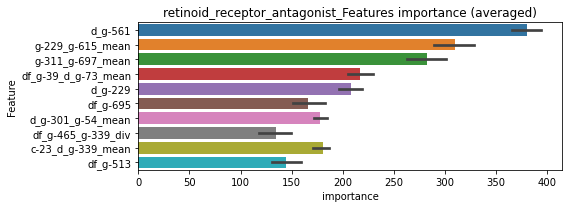

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045176	valid_1's binary_logloss: 0.0471124
[200]	training's binary_logloss: 0.00717438	valid_1's binary_logloss: 0.00790273
[300]	training's binary_logloss: 0.00155182	valid_1's binary_logloss: 0.0018305
[400]	training's binary_logloss: 0.000555728	valid_1's binary_logloss: 0.00071253
[500]	training's binary_logloss: 0.000310939	valid_1's binary_logloss: 0.000416549
[600]	training's binary_logloss: 0.000225074	valid_1's binary_logloss: 0.000309507
[700]	training's binary_logloss: 0.000192509	valid_1's binary_logloss: 0.000267142
[800]	training's binary_logloss: 0.000183267	valid_1's binary_logloss: 0.000255269


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[809]	training's binary_logloss: 0.000182948	valid_1's binary_logloss: 0.000254802
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451255	valid_1's binary_logloss: 0.046717
[200]	training's binary_logloss: 0.00716715	valid_1's binary_logloss: 0.00817361
[300]	training's binary_logloss: 0.00155517	valid_1's binary_logloss: 0.0020553
[400]	training's binary_logloss: 0.000557236	valid_1's binary_logloss: 0.000865749
[500]	training's binary_logloss: 0.000309776	valid_1's binary_logloss: 0.000544468
[600]	training's binary_logloss: 0.000224999	valid_1's binary_logloss: 0.000417795
[700]	training's binary_logloss: 0.000192689	valid_1's binary_logloss: 0.000372907
[800]	training's binary_logloss: 0.000184372	valid_1's binary_logloss: 0.000360973


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[788]	training's binary_logloss: 0.000184372	valid_1's binary_logloss: 0.000360973
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.045209	valid_1's binary_logloss: 0.0472742
[200]	training's binary_logloss: 0.00718326	valid_1's binary_logloss: 0.00773516
[300]	training's binary_logloss: 0.00155802	valid_1's binary_logloss: 0.00177098
[400]	training's binary_logloss: 0.000552646	valid_1's binary_logloss: 0.000666869
[500]	training's binary_logloss: 0.000306618	valid_1's binary_logloss: 0.000391276
[600]	training's binary_logloss: 0.000222189	valid_1's binary_logloss: 0.000292924
[700]	training's binary_logloss: 0.000190464	valid_1's binary_logloss: 0.000255143
[800]	training's binary_logloss: 0.000182066	valid_1's binary_logloss: 0.000244941
Early stopping, best iteration is:
[783]	training's binary_logloss: 0.000182066	valid_1's binary_logloss: 0.000244941


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0451733	valid_1's binary_logloss: 0.0484991
[200]	training's binary_logloss: 0.00714051	valid_1's binary_logloss: 0.00834545
[300]	training's binary_logloss: 0.00154445	valid_1's binary_logloss: 0.00203434
[400]	training's binary_logloss: 0.000554484	valid_1's binary_logloss: 0.000814792
[500]	training's binary_logloss: 0.000307604	valid_1's binary_logloss: 0.000479679
[600]	training's binary_logloss: 0.0002244	valid_1's binary_logloss: 0.000364256
[700]	training's binary_logloss: 0.000193117	valid_1's binary_logloss: 0.000321776
[800]	training's binary_logloss: 0.000184879	valid_1's binary_logloss: 0.000310854
Early stopping, best iteration is:
[834]	training's binary_logloss: 0.000183735	valid_1's binary_logloss: 0.00030915


retinoid_receptor_antagonist logloss: 0.0002924563933191493


neg labels: 3289 → selected neg labels: 3283


rho_associated_kinase_inhibitor, len(trt): 35, len(othr): 3283, target_rate: 0.0014697 → Adj_target_rate: 0.0017245
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107304	valid_1's binary_logloss: 0.141469
[200]	training's binary_logloss: 0.040859	valid_1's binary_logloss: 0.0719846
[300]	training's binary_logloss: 0.0166901	valid_1's binary_logloss: 0.0427413
[400]	training's binary_logloss: 0.00730284	valid_1's binary_logloss: 0.0288652
[500]	training's binary_logloss: 0.00363459	valid_1's binary_logloss: 0.0219931
[600]	training's binary_logloss: 0.00213625	valid_1's binary_logloss: 0.0186569
[700]	training's binary_logloss: 0.00144886	valid_1's binary_logloss: 0.01694
[800]	training's binary_logloss: 0.00109587	valid_1's binary_logloss: 0.0160201
[900]	training's binary_logloss: 0.000893932	valid_1's binary_logloss: 0.015378
[1000]	training's binary_logloss: 0.000780878	valid_1's binary_logloss: 0.0151665
[1100]	training's binary_logloss: 0.000720553	valid_1's binary_logloss: 0.0150204
Early stopping, best iteration is:
[1125]	training's binary_log

1 / 3 AUC score:0.999
y_Threshold: 0.0182829, Threshold: 0.0851587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 140 → Positive_corect_labels: 652/3799
p_label_rate: 0.0100452 Vs.target_rate: 0.00147, Num_p_label: 40.0, conf_0:0.05961, conf_1:0.11071
Num_p_label: 40.0, Expected: 5.9, Adj_threshold_1: 0.0851587
Num_p_label: 24.0, Expected: 5.9, Adj_threshold_2: 0.1351587
Num_p_label: 18.0, Expected: 5.9, Adj_threshold_3: 0.1851587
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_4: 0.2351587
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_5: 0.2851587
threshold: 0.2851587, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0993231	valid_1's binary_logloss: 0.138504
[200]	training's binary_logloss: 0.0340739	valid_1's binary_logloss: 0.067371
[300]	training's binary_logloss: 0.0132014	valid_1's binary_logloss: 0.0396976
[400]	training's binary_logloss: 0.00566394	valid_1's binary_logloss: 0.0264117
[500]	training's binary_logloss: 0.00287789	valid_1's binary_logloss: 0.0196527
[600]	training's binary_logloss: 0.00174095	valid_1's binary_logloss: 0.0164469
[700]	training's binary_logloss: 0.00120167	valid_1's binary_logloss: 0.0150115
[800]	training's binary_logloss: 0.000920168	valid_1's binary_logloss: 0.0137267
Early stopping, best iteration is:
[826]	training's binary_logloss: 0.000866988	valid_1's binary_logloss: 0.0134766
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0999647	valid_1's binary_logloss: 0.148604
[200]	training's binary_logloss: 0.0341103	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1127404, Threshold: 0.2851587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 647.0/3789
p_label_rate: 0.0107986 Vs.target_rate: 0.00147, Num_p_label: 43.0, conf_0:0.22813, conf_1:0.34219
Num_p_label: 43.0, Expected: 5.9, Adj_threshold_1: 0.2851587
Num_p_label: 38.0, Expected: 5.9, Adj_threshold_2: 0.3351587
Num_p_label: 31.0, Expected: 5.9, Adj_threshold_3: 0.3851587
Num_p_label: 29.0, Expected: 5.9, Adj_threshold_4: 0.4351587
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_5: 0.4851587
Num_p_label: 25.0, Expected: 5.9, Adj_threshold_6: 0.5351587
Num_p_label: 22.0, Expected: 5.9, Adj_threshold_7: 0.5851587
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_8: 0.6351587
Num_p_label: 15.0, Expected: 5.9, Adj_threshold_9: 0.6851587
Num_p_label: 13.0, Expected: 5.9, Adj_threshold_10: 0.7351587
threshold: 0.7351587, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 647.0/3789, y_label_rate: 0.1707575
=========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0978068	valid_1's binary_logloss: 0.137374
[200]	training's binary_logloss: 0.0333728	valid_1's binary_logloss: 0.0681037
[300]	training's binary_logloss: 0.0125118	valid_1's binary_logloss: 0.0411887
[400]	training's binary_logloss: 0.00535785	valid_1's binary_logloss: 0.0304925
[500]	training's binary_logloss: 0.00273774	valid_1's binary_logloss: 0.0248754
[600]	training's binary_logloss: 0.00165583	valid_1's binary_logloss: 0.022378
[700]	training's binary_logloss: 0.00116375	valid_1's binary_logloss: 0.0212059
[800]	training's binary_logloss: 0.000893327	valid_1's binary_logloss: 0.0204259
Early stopping, best iteration is:
[845]	training's binary_logloss: 0.000811269	valid_1's binary_logloss: 0.0201583
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0979935	valid_1's binary_logloss: 0.137552
[200]	training's binary_logloss: 0.0332792	valid

3 / 3 AUC score:1.000
y_Threshold: 0.1352826, Threshold: 0.7351587, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 641.0/3777
p_label_rate: 0.0040181 Vs.target_rate: 0.00147, Num_p_label: 16.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_1: 0.7351587
Num_p_label: 12.0, Expected: 5.9, Adj_threshold_2: 0.7851587
threshold: 0.7851587, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 641.0/3777, y_label_rate: 0.1697114


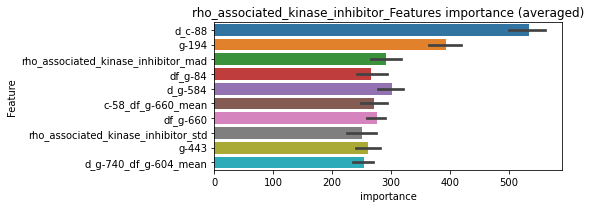

len(train_index) : 2832
len(valid_index) : 945
================================= fold 1/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0955983	valid_1's binary_logloss: 0.128184
[200]	training's binary_logloss: 0.0321514	valid_1's binary_logloss: 0.0559226
[300]	training's binary_logloss: 0.0119836	valid_1's binary_logloss: 0.0295504
[400]	training's binary_logloss: 0.00513278	valid_1's binary_logloss: 0.018234
[500]	training's binary_logloss: 0.00262127	valid_1's binary_logloss: 0.0129112
[600]	training's binary_logloss: 0.00161319	valid_1's binary_logloss: 0.0101797
[700]	training's binary_logloss: 0.00113039	valid_1's binary_logloss: 0.00872513
[800]	training's binary_logloss: 0.000879265	valid_1's binary_logloss: 0.0078425
[900]	training's binary_logloss: 0.00073249	valid_1's binary_logloss: 0.00738657
[1000]	training's binary_logloss: 0.000642936	valid_1's binary_logloss: 0.00710135
Early stopping, best iteration is:
[1038]	training's binary_logloss: 0.000623824	valid_1's binary_logloss: 0.00702056


len(train_index) : 2833
len(valid_index) : 944
================================= fold 2/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958313	valid_1's binary_logloss: 0.138328
[200]	training's binary_logloss: 0.0326249	valid_1's binary_logloss: 0.0647774
[300]	training's binary_logloss: 0.0121259	valid_1's binary_logloss: 0.0339765
[400]	training's binary_logloss: 0.00518048	valid_1's binary_logloss: 0.0215602
[500]	training's binary_logloss: 0.00260702	valid_1's binary_logloss: 0.0152484
[600]	training's binary_logloss: 0.00159502	valid_1's binary_logloss: 0.0122966
[700]	training's binary_logloss: 0.00111657	valid_1's binary_logloss: 0.0109574
[800]	training's binary_logloss: 0.000865934	valid_1's binary_logloss: 0.010104
[900]	training's binary_logloss: 0.000717521	valid_1's binary_logloss: 0.00956023
[1000]	training's binary_logloss: 0.000634899	valid_1's binary_logloss: 0.00916996
Early stopping, best iteration is:
[1050]	training's binary_logloss: 0.000609466	valid_1's binary_logloss: 0.00905853


len(train_index) : 2833
len(valid_index) : 944
================================= fold 3/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.099136	valid_1's binary_logloss: 0.127054
[200]	training's binary_logloss: 0.032964	valid_1's binary_logloss: 0.0552322
[300]	training's binary_logloss: 0.0122979	valid_1's binary_logloss: 0.0284752
[400]	training's binary_logloss: 0.00523749	valid_1's binary_logloss: 0.0176234
[500]	training's binary_logloss: 0.0026969	valid_1's binary_logloss: 0.0132415
[600]	training's binary_logloss: 0.00164077	valid_1's binary_logloss: 0.0110506
[700]	training's binary_logloss: 0.00114781	valid_1's binary_logloss: 0.0101093
[800]	training's binary_logloss: 0.000879128	valid_1's binary_logloss: 0.00938637
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.000785166	valid_1's binary_logloss: 0.00904611


len(train_index) : 2833
len(valid_index) : 944
================================= fold 4/4 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0990985	valid_1's binary_logloss: 0.13342
[200]	training's binary_logloss: 0.033102	valid_1's binary_logloss: 0.0638692
[300]	training's binary_logloss: 0.0122228	valid_1's binary_logloss: 0.0362545
[400]	training's binary_logloss: 0.00525443	valid_1's binary_logloss: 0.0247742
[500]	training's binary_logloss: 0.00267051	valid_1's binary_logloss: 0.0190467
[600]	training's binary_logloss: 0.00162316	valid_1's binary_logloss: 0.0161644
[700]	training's binary_logloss: 0.00113427	valid_1's binary_logloss: 0.0145431
[800]	training's binary_logloss: 0.000870368	valid_1's binary_logloss: 0.013388
[900]	training's binary_logloss: 0.000721378	valid_1's binary_logloss: 0.0127423
[1000]	training's binary_logloss: 0.000642984	valid_1's binary_logloss: 0.01242
Early stopping, best iteration is:
[1046]	training's binary_logloss: 0.000618243	valid_1's binary_logloss: 0.0122458


rho_associated_kinase_inhibitor logloss: 0.009342133273079896


neg labels: 3289 → selected neg labels: 3284


ribonucleoside_reductase_inhibitor, len(trt): 37, len(othr): 3284, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100636	valid_1's binary_logloss: 0.146017
[200]	training's binary_logloss: 0.0361725	valid_1's binary_logloss: 0.0791298
[300]	training's binary_logloss: 0.0148015	valid_1's binary_logloss: 0.0517935
[400]	training's binary_logloss: 0.00637854	valid_1's binary_logloss: 0.0389325
[500]	training's binary_logloss: 0.00326691	valid_1's binary_logloss: 0.0338161
[600]	training's binary_logloss: 0.00193968	valid_1's binary_logloss: 0.0309042
[700]	training's binary_logloss: 0.00132806	valid_1's binary_logloss: 0.029379
Early stopping, best iteration is:
[695]	training's binary_logloss: 0.00135111	valid_1's binary_logloss: 0.0292931
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102837	valid_1's binary_logloss: 0.137356
[200]	training's binary_logloss: 0.0369208	valid_1's binary_logloss: 0.0671391
[300]	training's binary_logloss: 0.0152227	valid_1's 

1 / 3 AUC score:0.999
y_Threshold: 0.0143902, Threshold: 0.0551094, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.03858, conf_1:0.07164
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0551094
Num_p_label: 20.0, Expected: 6.2, Adj_threshold_2: 0.1051094
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_3: 0.1551094
threshold: 0.1551094, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0947227	valid_1's binary_logloss: 0.13588
[200]	training's binary_logloss: 0.0307634	valid_1's binary_logloss: 0.0667958
[300]	training's binary_logloss: 0.0115538	valid_1's binary_logloss: 0.0394292
[400]	training's binary_logloss: 0.00504947	valid_1's binary_logloss: 0.0276377
[500]	training's binary_logloss: 0.00260043	valid_1's binary_logloss: 0.021507
[600]	training's binary_logloss: 0.00160513	valid_1's binary_logloss: 0.0184852
[700]	training's binary_logloss: 0.00112108	valid_1's binary_logloss: 0.0170567
[800]	training's binary_logloss: 0.000866598	valid_1's binary_logloss: 0.0163672
[900]	training's binary_logloss: 0.000716315	valid_1's binary_logloss: 0.01588
[1000]	training's binary_logloss: 0.000639111	valid_1's binary_logloss: 0.0155923
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000637108	valid_1's binary_logloss: 0.0155649
Training until validation 

2 / 3 AUC score:1.000
y_Threshold: 0.1155028, Threshold: 0.1551094, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 651.0/3798
p_label_rate: 0.0133099 Vs.target_rate: 0.00155, Num_p_label: 53.0, conf_0:0.12409, conf_1:0.18613
Num_p_label: 53.0, Expected: 6.2, Adj_threshold_1: 0.1551094
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_2: 0.2051094
Num_p_label: 36.0, Expected: 6.2, Adj_threshold_3: 0.2551094
Num_p_label: 31.0, Expected: 6.2, Adj_threshold_4: 0.3051094
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_5: 0.3551094
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_6: 0.4051094
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_7: 0.4551094
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_8: 0.5051094
threshold: 0.5051094, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 651.0/3798, y_label_rate: 0.1714060
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0933545	valid_1's binary_logloss: 0.135348
[200]	training's binary_logloss: 0.0294678	valid_1's binary_logloss: 0.0677205
[300]	training's binary_logloss: 0.0109682	valid_1's binary_logloss: 0.0433273
[400]	training's binary_logloss: 0.00477552	valid_1's binary_logloss: 0.0340605
[500]	training's binary_logloss: 0.00246698	valid_1's binary_logloss: 0.0296237
[600]	training's binary_logloss: 0.00152733	valid_1's binary_logloss: 0.0276374
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00133555	valid_1's binary_logloss: 0.0267821
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959764	valid_1's binary_logloss: 0.130054
[200]	training's binary_logloss: 0.0316509	valid_1's binary_logloss: 0.0584497
[300]	training's binary_logloss: 0.0118124	valid_1's binary_logloss: 0.0314196
[400]	training's binary_logloss: 0.00504865	valid_1

3 / 3 AUC score:1.000
y_Threshold: 0.1175577, Threshold: 0.5051094, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 645.0/3786
p_label_rate: 0.0052737 Vs.target_rate: 0.00155, Num_p_label: 21.0, conf_0:0.45460, conf_1:0.55562
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_1: 0.5051094
Num_p_label: 14.0, Expected: 6.2, Adj_threshold_2: 0.5551094
threshold: 0.5551094, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 645.0/3786, y_label_rate: 0.1703645


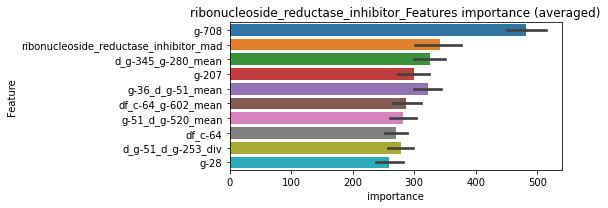

len(train_index) : 2839
len(valid_index) : 947
================================= fold 1/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0911322	valid_1's binary_logloss: 0.133639
[200]	training's binary_logloss: 0.0280708	valid_1's binary_logloss: 0.0654542
[300]	training's binary_logloss: 0.010253	valid_1's binary_logloss: 0.0390906
[400]	training's binary_logloss: 0.00444278	valid_1's binary_logloss: 0.0287052
[500]	training's binary_logloss: 0.00232934	valid_1's binary_logloss: 0.0229704
[600]	training's binary_logloss: 0.00145324	valid_1's binary_logloss: 0.0199585
[700]	training's binary_logloss: 0.00103328	valid_1's binary_logloss: 0.0178662
[800]	training's binary_logloss: 0.000804022	valid_1's binary_logloss: 0.0170264
[900]	training's binary_logloss: 0.000675888	valid_1's binary_logloss: 0.016177
[1000]	training's binary_logloss: 0.000606888	valid_1's binary_logloss: 0.0160036
Early stopping, best iteration is:
[970]	training's binary_logloss: 0.000615453	valid_1's binary_logloss: 0.0159728


len(train_index) : 2839
len(valid_index) : 947
================================= fold 2/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953987	valid_1's binary_logloss: 0.125928
[200]	training's binary_logloss: 0.0297079	valid_1's binary_logloss: 0.055394
[300]	training's binary_logloss: 0.0109304	valid_1's binary_logloss: 0.030766
[400]	training's binary_logloss: 0.0046851	valid_1's binary_logloss: 0.0200564
[500]	training's binary_logloss: 0.00240879	valid_1's binary_logloss: 0.015378
[600]	training's binary_logloss: 0.00149566	valid_1's binary_logloss: 0.0133915
[700]	training's binary_logloss: 0.00106445	valid_1's binary_logloss: 0.0123098
[800]	training's binary_logloss: 0.000826627	valid_1's binary_logloss: 0.0116186
[900]	training's binary_logloss: 0.000693215	valid_1's binary_logloss: 0.0111463
[1000]	training's binary_logloss: 0.000628661	valid_1's binary_logloss: 0.0108672
Early stopping, best iteration is:
[1021]	training's binary_logloss: 0.000620062	valid_1's binary_logloss: 0.0108348


len(train_index) : 2840
len(valid_index) : 946
================================= fold 3/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951986	valid_1's binary_logloss: 0.138518
[200]	training's binary_logloss: 0.0301078	valid_1's binary_logloss: 0.0697867
[300]	training's binary_logloss: 0.0113616	valid_1's binary_logloss: 0.0445645
[400]	training's binary_logloss: 0.00487732	valid_1's binary_logloss: 0.0340632
[500]	training's binary_logloss: 0.00249653	valid_1's binary_logloss: 0.0292748
[600]	training's binary_logloss: 0.00152504	valid_1's binary_logloss: 0.0260442
[700]	training's binary_logloss: 0.00108364	valid_1's binary_logloss: 0.0249137
[800]	training's binary_logloss: 0.00084316	valid_1's binary_logloss: 0.0245088
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.000869667	valid_1's binary_logloss: 0.0243628


len(train_index) : 2840
len(valid_index) : 946
================================= fold 4/4 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0938585	valid_1's binary_logloss: 0.12282
[200]	training's binary_logloss: 0.0298032	valid_1's binary_logloss: 0.053338
[300]	training's binary_logloss: 0.0111398	valid_1's binary_logloss: 0.0284882
[400]	training's binary_logloss: 0.00481245	valid_1's binary_logloss: 0.0173765
[500]	training's binary_logloss: 0.00245557	valid_1's binary_logloss: 0.0118759
[600]	training's binary_logloss: 0.00152088	valid_1's binary_logloss: 0.0092704
[700]	training's binary_logloss: 0.00107778	valid_1's binary_logloss: 0.00791363
[800]	training's binary_logloss: 0.000837642	valid_1's binary_logloss: 0.00699561
[900]	training's binary_logloss: 0.000697825	valid_1's binary_logloss: 0.0064224
[1000]	training's binary_logloss: 0.000622811	valid_1's binary_logloss: 0.00607473
[1100]	training's binary_logloss: 0.000593299	valid_1's binary_logloss: 0.0059498
[1200]	training's binary_logloss: 0.000575021	valid_1's 

ribonucleoside_reductase_inhibitor logloss: 0.014262721819369882


neg labels: 3289 → selected neg labels: 3284


rna_polymerase_inhibitor, len(trt): 25, len(othr): 3284, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0886052	valid_1's binary_logloss: 0.111806
[200]	training's binary_logloss: 0.0265657	valid_1's binary_logloss: 0.0427723
[300]	training's binary_logloss: 0.00899813	valid_1's binary_logloss: 0.0213892
[400]	training's binary_logloss: 0.00365526	valid_1's binary_logloss: 0.0137436
[500]	training's binary_logloss: 0.00189474	valid_1's binary_logloss: 0.0111135
[600]	training's binary_logloss: 0.00117806	valid_1's binary_logloss: 0.00970242
[700]	training's binary_logloss: 0.000848053	valid_1's binary_logloss: 0.00906795
[800]	training's binary_logloss: 0.000671327	valid_1's binary_logloss: 0.0087137
[900]	training's binary_logloss: 0.00057921	valid_1's binary_logloss: 0.00852292
Early stopping, best iteration is:
[892]	training's binary_logloss: 0.000584986	valid_1's binary_logloss: 0.00851182
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0889

1 / 3 AUC score:1.000
y_Threshold: 0.0063023, Threshold: 0.0293777, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02056, conf_1:0.03819
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0293777
Num_p_label: 18.0, Expected: 4.2, Adj_threshold_2: 0.0793777
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_3: 0.1293777
Num_p_label: 7.0, Expected: 4.2, Adj_threshold_4: 0.1793777
threshold: 0.1793777, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0846752	valid_1's binary_logloss: 0.103642
[200]	training's binary_logloss: 0.0233993	valid_1's binary_logloss: 0.036689
[300]	training's binary_logloss: 0.00761538	valid_1's binary_logloss: 0.0170481
[400]	training's binary_logloss: 0.00309831	valid_1's binary_logloss: 0.0106083
[500]	training's binary_logloss: 0.00162761	valid_1's binary_logloss: 0.00839661
[600]	training's binary_logloss: 0.00103237	valid_1's binary_logloss: 0.00746473
[700]	training's binary_logloss: 0.000752527	valid_1's binary_logloss: 0.00714832
Early stopping, best iteration is:
[758]	training's binary_logloss: 0.000653418	valid_1's binary_logloss: 0.0069424
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0851471	valid_1's binary_logloss: 0.111367
[200]	training's binary_logloss: 0.0234826	valid_1's binary_logloss: 0.0400974
[300]	training's binary_logloss: 0.00768295	v

2 / 3 AUC score:1.000
y_Threshold: 0.0347389, Threshold: 0.1793777, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0050226 Vs.target_rate: 0.00105, Num_p_label: 20.0, conf_0:0.14350, conf_1:0.21525
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_1: 0.1793777
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_2: 0.2293777
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_3: 0.2793777
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_4: 0.3293777
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_5: 0.3793777
threshold: 0.3793777, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 655.0/3806, y_label_rate: 0.1720967
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0864337	valid_1's binary_logloss: 0.115917
[200]	training's binary_logloss: 0.023677	valid_1's binary_logloss: 0.0457557
[300]	training's binary_logloss: 0.00768852	valid_1's binary_logloss: 0.0233378
[400]	training's binary_logloss: 0.00308403	valid_1's binary_logloss: 0.0156258
[500]	training's binary_logloss: 0.00161968	valid_1's binary_logloss: 0.0128665
[600]	training's binary_logloss: 0.00102967	valid_1's binary_logloss: 0.0114963
[700]	training's binary_logloss: 0.000751971	valid_1's binary_logloss: 0.0109269
Early stopping, best iteration is:
[683]	training's binary_logloss: 0.000789298	valid_1's binary_logloss: 0.0108492
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0861105	valid_1's binary_logloss: 0.101691
[200]	training's binary_logloss: 0.0232369	valid_1's binary_logloss: 0.0334091
[300]	training's binary_logloss: 0.00765639	vali

3 / 3 AUC score:1.000
y_Threshold: 0.0694915, Threshold: 0.3793777, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 655.0/3806
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.34144, conf_1:0.41732
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_1: 0.3793777
threshold: 0.3793777, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 655.0/3806, y_label_rate: 0.1720967


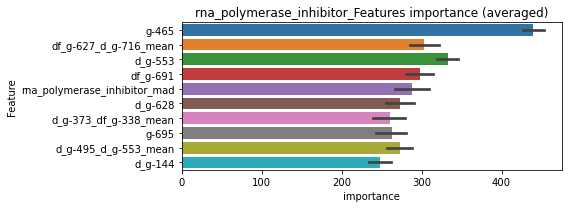

len(train_index) : 2854
len(valid_index) : 952
================================= fold 1/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839603	valid_1's binary_logloss: 0.114077
[200]	training's binary_logloss: 0.0237569	valid_1's binary_logloss: 0.0472847
[300]	training's binary_logloss: 0.00784398	valid_1's binary_logloss: 0.0260658
[400]	training's binary_logloss: 0.00316609	valid_1's binary_logloss: 0.0180708
[500]	training's binary_logloss: 0.00164954	valid_1's binary_logloss: 0.0147782
[600]	training's binary_logloss: 0.00105203	valid_1's binary_logloss: 0.0133344
[700]	training's binary_logloss: 0.000754189	valid_1's binary_logloss: 0.0125708
[800]	training's binary_logloss: 0.000599887	valid_1's binary_logloss: 0.0120703
[900]	training's binary_logloss: 0.000527616	valid_1's binary_logloss: 0.0120592
Early stopping, best iteration is:
[874]	training's binary_logloss: 0.000539597	valid_1's binary_logloss: 0.0119593


len(train_index) : 2854
len(valid_index) : 952
================================= fold 2/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852875	valid_1's binary_logloss: 0.102917
[200]	training's binary_logloss: 0.0237032	valid_1's binary_logloss: 0.0352056
[300]	training's binary_logloss: 0.00757197	valid_1's binary_logloss: 0.0140303
[400]	training's binary_logloss: 0.00310718	valid_1's binary_logloss: 0.00710645
[500]	training's binary_logloss: 0.00161626	valid_1's binary_logloss: 0.00431746
[600]	training's binary_logloss: 0.00104212	valid_1's binary_logloss: 0.00317367
[700]	training's binary_logloss: 0.000756275	valid_1's binary_logloss: 0.00252637
[800]	training's binary_logloss: 0.000607047	valid_1's binary_logloss: 0.00219688
[900]	training's binary_logloss: 0.000531062	valid_1's binary_logloss: 0.00199424
[1000]	training's binary_logloss: 0.000510752	valid_1's binary_logloss: 0.00195762
Early stopping, best iteration is:
[1029]	training's binary_logloss: 0.000505939	valid_1's binary_logloss: 0.00195092


len(train_index) : 2855
len(valid_index) : 951
================================= fold 3/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829641	valid_1's binary_logloss: 0.108013
[200]	training's binary_logloss: 0.0232485	valid_1's binary_logloss: 0.0382099
[300]	training's binary_logloss: 0.00747321	valid_1's binary_logloss: 0.016747
[400]	training's binary_logloss: 0.00306225	valid_1's binary_logloss: 0.00924092
[500]	training's binary_logloss: 0.00158581	valid_1's binary_logloss: 0.00609751
[600]	training's binary_logloss: 0.00102757	valid_1's binary_logloss: 0.00482601
[700]	training's binary_logloss: 0.00074753	valid_1's binary_logloss: 0.00410352
[800]	training's binary_logloss: 0.000596366	valid_1's binary_logloss: 0.00364107
[900]	training's binary_logloss: 0.000530214	valid_1's binary_logloss: 0.00347066
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000538674	valid_1's binary_logloss: 0.00345975


len(train_index) : 2855
len(valid_index) : 951
================================= fold 4/4 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0866601	valid_1's binary_logloss: 0.110967
[200]	training's binary_logloss: 0.0239691	valid_1's binary_logloss: 0.0410631
[300]	training's binary_logloss: 0.00766719	valid_1's binary_logloss: 0.0187825
[400]	training's binary_logloss: 0.00309948	valid_1's binary_logloss: 0.0104425
[500]	training's binary_logloss: 0.00163099	valid_1's binary_logloss: 0.00722457
[600]	training's binary_logloss: 0.00103212	valid_1's binary_logloss: 0.005627
[700]	training's binary_logloss: 0.000750635	valid_1's binary_logloss: 0.00474925
[800]	training's binary_logloss: 0.000598797	valid_1's binary_logloss: 0.00429155
[900]	training's binary_logloss: 0.00052391	valid_1's binary_logloss: 0.00404943
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000528064	valid_1's binary_logloss: 0.00403941


rna_polymerase_inhibitor logloss: 0.005353182143708416


neg labels: 3289 → selected neg labels: 3249


serotonin_receptor_agonist, len(trt): 236, len(othr): 3249, target_rate: 0.0099101 → Adj_target_rate: 0.0087332
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.199765	valid_1's binary_logloss: 0.308506
[200]	training's binary_logloss: 0.116774	valid_1's binary_logloss: 0.272087
[300]	training's binary_logloss: 0.0759515	valid_1's binary_logloss: 0.258445
[400]	training's binary_logloss: 0.0482718	valid_1's binary_logloss: 0.252261
[500]	training's binary_logloss: 0.0317781	valid_1's binary_logloss: 0.249843
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.0333548	valid_1's binary_logloss: 0.249202
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.203291	valid_1's binary_logloss: 0.313505
[200]	training's binary_logloss: 0.11835	valid_1's binary_logloss: 0.272952
[300]	training's binary_logloss: 0.0739944	valid_1's binary_logloss: 0.254015
[400]	training's binary_logloss: 0.0486189	valid_1's binary_logloss: 0.247398
[500]	training's binary_logloss: 0.0322464	valid_1's binary_logloss:

1 / 3 AUC score:0.898
y_Threshold: 0.0895990, Threshold: 0.4697342, pos_neg_ratio: 0.8000000
Remove_noisy_data: 425 → Positive_corect_labels: 502/3473
p_label_rate: 0.0100452 Vs.target_rate: 0.00991, Num_p_label: 40.0, conf_0:0.32881, conf_1:0.61065
threshold: 0.4697342, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 502.0/3473, y_label_rate: 0.1445436
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130344	valid_1's binary_logloss: 0.21552
[200]	training's binary_logloss: 0.0590368	valid_1's binary_logloss: 0.168811
[300]	training's binary_logloss: 0.029769	valid_1's binary_logloss: 0.145924
[400]	training's binary_logloss: 0.015652	valid_1's binary_logloss: 0.136461
[500]	training's binary_logloss: 0.00875266	valid_1's binary_logloss: 0.132872
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00695851	valid_1's binary_logloss: 0.131109
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127287	valid_1's binary_logloss: 0.194965
[200]	training's binary_logloss: 0.0592009	valid_1's binary_logloss: 0.148767
[300]	training's binary_logloss: 0.0298558	valid_1's binary_logloss: 0.129312
[400]	training's binary_logloss: 0.0160023	valid_1's binary_logloss: 0.120358
[500]	training's binary_logloss: 0.00906594	valid_1's binary_loglo

2 / 3 AUC score:0.979
y_Threshold: 0.0959566, Threshold: 0.4697342, pos_neg_ratio: 0.8000000
Remove_noisy_data: 124 → Positive_corect_labels: 440.0/3349
p_label_rate: 0.0301356 Vs.target_rate: 0.00991, Num_p_label: 120.0, conf_0:0.37579, conf_1:0.56368
Num_p_label: 120.0, Expected: 39.5, Adj_threshold_1: 0.4697342
Num_p_label: 110.0, Expected: 39.5, Adj_threshold_2: 0.5197342
Num_p_label: 94.0, Expected: 39.5, Adj_threshold_3: 0.5697342
Num_p_label: 85.0, Expected: 39.5, Adj_threshold_4: 0.6197342
Num_p_label: 74.0, Expected: 39.5, Adj_threshold_5: 0.6697342
Num_p_label: 61.0, Expected: 39.5, Adj_threshold_6: 0.7197342
Num_p_label: 51.0, Expected: 39.5, Adj_threshold_7: 0.7697342
threshold: 0.7697342, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 440.0/3349, y_label_rate: 0.1313825
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0974048	valid_1's binary_logloss: 0.166866
[200]	training's binary_logloss: 0.038466	valid_1's binary_logloss: 0.127311
[300]	training's binary_logloss: 0.0176821	valid_1's binary_logloss: 0.113545
[400]	training's binary_logloss: 0.00877204	valid_1's binary_logloss: 0.108233
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00792923	valid_1's binary_logloss: 0.10803
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102361	valid_1's binary_logloss: 0.157865
[200]	training's binary_logloss: 0.0416191	valid_1's binary_logloss: 0.112535
[300]	training's binary_logloss: 0.0193087	valid_1's binary_logloss: 0.0952736
[400]	training's binary_logloss: 0.00971601	valid_1's binary_logloss: 0.0883356
[500]	training's binary_logloss: 0.00533845	valid_1's binary_logloss: 0.0851601
[600]	training's binary_logloss: 0.00324375	valid_1's binar

3 / 3 AUC score:0.984
y_Threshold: 0.0915299, Threshold: 0.7697342, pos_neg_ratio: 0.8000000
Remove_noisy_data: 78 → Positive_corect_labels: 401.0/3271
p_label_rate: 0.0220994 Vs.target_rate: 0.00991, Num_p_label: 88.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 88.0, Expected: 39.5, Adj_threshold_1: 0.7697342
threshold: 0.7697342, positive_p_label: 88.0/3982, p_label_rate: 0.0220994
positive_y_label: 401.0/3271, y_label_rate: 0.1225925


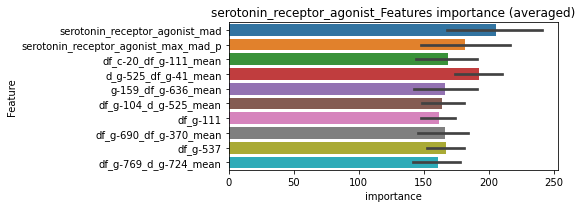

len(train_index) : 2453
len(valid_index) : 818
================================= fold 1/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0842019	valid_1's binary_logloss: 0.116609
[200]	training's binary_logloss: 0.0307106	valid_1's binary_logloss: 0.0699519
[300]	training's binary_logloss: 0.013193	valid_1's binary_logloss: 0.0513285
[400]	training's binary_logloss: 0.00638224	valid_1's binary_logloss: 0.0409162
[500]	training's binary_logloss: 0.00351257	valid_1's binary_logloss: 0.0365652
[600]	training's binary_logloss: 0.00222678	valid_1's binary_logloss: 0.0344838
[700]	training's binary_logloss: 0.00156839	valid_1's binary_logloss: 0.033723
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00171767	valid_1's binary_logloss: 0.0336542


len(train_index) : 2453
len(valid_index) : 818
================================= fold 2/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0830719	valid_1's binary_logloss: 0.134776
[200]	training's binary_logloss: 0.0298463	valid_1's binary_logloss: 0.0927203
[300]	training's binary_logloss: 0.0125926	valid_1's binary_logloss: 0.0768599
[400]	training's binary_logloss: 0.00617701	valid_1's binary_logloss: 0.0706113
[500]	training's binary_logloss: 0.00325765	valid_1's binary_logloss: 0.0685931
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00260744	valid_1's binary_logloss: 0.0675196


len(train_index) : 2453
len(valid_index) : 818
================================= fold 3/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0860658	valid_1's binary_logloss: 0.125886
[200]	training's binary_logloss: 0.0313491	valid_1's binary_logloss: 0.0841582
[300]	training's binary_logloss: 0.0129365	valid_1's binary_logloss: 0.0695279
[400]	training's binary_logloss: 0.00620556	valid_1's binary_logloss: 0.0644038
[500]	training's binary_logloss: 0.00337593	valid_1's binary_logloss: 0.0621292
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00258588	valid_1's binary_logloss: 0.0614539


len(train_index) : 2454
len(valid_index) : 817
================================= fold 4/4 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822573	valid_1's binary_logloss: 0.139849
[200]	training's binary_logloss: 0.0298535	valid_1's binary_logloss: 0.0976981
[300]	training's binary_logloss: 0.0125674	valid_1's binary_logloss: 0.08193
[400]	training's binary_logloss: 0.00605758	valid_1's binary_logloss: 0.0771


serotonin_receptor_agonist logloss: 0.05947820038678056


Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00447858	valid_1's binary_logloss: 0.0753045
neg labels: 3289 → selected neg labels: 3239


serotonin_receptor_antagonist, len(trt): 404, len(othr): 3239, target_rate: 0.0169648 → Adj_target_rate: 0.0137918
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.272851	valid_1's binary_logloss: 0.409635
[200]	training's binary_logloss: 0.182524	valid_1's binary_logloss: 0.393838
[300]	training's binary_logloss: 0.126252	valid_1's binary_logloss: 0.389145
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.135499	valid_1's binary_logloss: 0.388329
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.279986	valid_1's binary_logloss: 0.404599
[200]	training's binary_logloss: 0.184203	valid_1's binary_logloss: 0.38484
[300]	training's binary_logloss: 0.13103	valid_1's binary_logloss: 0.37657
[400]	training's binary_logloss: 0.0935516	valid_1's binary_logloss: 0.373747
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0996349	valid_1's binary_logloss: 0.372269
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.281183	valid_1's bin

1 / 3 AUC score:0.753
y_Threshold: 0.1664503, Threshold: 0.5616267, pos_neg_ratio: 0.8000000
Remove_noisy_data: 739 → Positive_corect_labels: 343/3147
p_label_rate: 0.0100452 Vs.target_rate: 0.01696, Num_p_label: 40.0, conf_0:0.39314, conf_1:0.73011
Num_p_label: 40.0, Expected: 67.6, Adj_threshold_1: 0.5616267
Num_p_label: 44.0, Expected: 67.6, Adj_threshold_2: 0.5316267
Num_p_label: 53.0, Expected: 67.6, Adj_threshold_3: 0.5016267
threshold: 0.5016267, positive_p_label: 53.0/3982, p_label_rate: 0.0133099
positive_y_label: 343.0/3147, y_label_rate: 0.1089927
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119218	valid_1's binary_logloss: 0.234332
[200]	training's binary_logloss: 0.0528863	valid_1's binary_logloss: 0.207547
[300]	training's binary_logloss: 0.0264987	valid_1's binary_logloss: 0.201805
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.0309654	valid_1's binary_logloss: 0.201336
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123925	valid_1's binary_logloss: 0.221658
[200]	training's binary_logloss: 0.0568554	valid_1's binary_logloss: 0.185975
[300]	training's binary_logloss: 0.0292423	valid_1's binary_logloss: 0.173226
[400]	training's binary_logloss: 0.0159506	valid_1's binary_logloss: 0.168414
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.0137997	valid_1's binary_logloss: 0.167187
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.128271	valid

2 / 3 AUC score:0.948
y_Threshold: 0.0922792, Threshold: 0.5016267, pos_neg_ratio: 0.8000000
Remove_noisy_data: 174 → Positive_corect_labels: 256.0/2973
p_label_rate: 0.0374184 Vs.target_rate: 0.01696, Num_p_label: 149.0, conf_0:0.40130, conf_1:0.60195
Num_p_label: 149.0, Expected: 67.6, Adj_threshold_1: 0.5016267
Num_p_label: 136.0, Expected: 67.6, Adj_threshold_2: 0.5516267
Num_p_label: 123.0, Expected: 67.6, Adj_threshold_3: 0.6016267
Num_p_label: 115.0, Expected: 67.6, Adj_threshold_4: 0.6516267
Num_p_label: 96.0, Expected: 67.6, Adj_threshold_5: 0.7016267
threshold: 0.7016267, positive_p_label: 96.0/3982, p_label_rate: 0.0241085
positive_y_label: 256.0/2973, y_label_rate: 0.0861083
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837396	valid_1's binary_logloss: 0.146447
[200]	training's binary_logloss: 0.0313216	valid_1's binary_logloss: 0.110705
[300]	training's binary_logloss: 0.014003	valid_1's binary_logloss: 0.097614
[400]	training's binary_logloss: 0.00697213	valid_1's binary_logloss: 0.0923504
[500]	training's binary_logloss: 0.00387966	valid_1's binary_logloss: 0.0900478
[600]	training's binary_logloss: 0.00247373	valid_1's binary_logloss: 0.089238
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.0025562	valid_1's binary_logloss: 0.0890069
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810533	valid_1's binary_logloss: 0.142261
[200]	training's binary_logloss: 0.0305123	valid_1's binary_logloss: 0.106656
[300]	training's binary_logloss: 0.0134142	valid_1's binary_logloss: 0.0923899
[400]	training's binary_logloss: 0.00651938	valid_1's bin

3 / 3 AUC score:0.979
y_Threshold: 0.0627025, Threshold: 0.7016267, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 222.0/2905
p_label_rate: 0.0449523 Vs.target_rate: 0.01696, Num_p_label: 179.0, conf_0:0.50000, conf_1:0.77179
Num_p_label: 179.0, Expected: 67.6, Adj_threshold_1: 0.7016267


Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00594612	valid_1's binary_logloss: 0.119987


Num_p_label: 167.0, Expected: 67.6, Adj_threshold_2: 0.7516267
threshold: 0.7516267, positive_p_label: 167.0/3982, p_label_rate: 0.0419387
positive_y_label: 222.0/2905, y_label_rate: 0.0764200


len(train_index) : 2178
len(valid_index) : 727
================================= fold 1/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674167	valid_1's binary_logloss: 0.120623
[200]	training's binary_logloss: 0.0238938	valid_1's binary_logloss: 0.0824622
[300]	training's binary_logloss: 0.0103347	valid_1's binary_logloss: 0.0673139
[400]	training's binary_logloss: 0.00481729	valid_1's binary_logloss: 0.0574216
[500]	training's binary_logloss: 0.00266149	valid_1's binary_logloss: 0.0522392
[600]	training's binary_logloss: 0.00173634	valid_1's binary_logloss: 0.0495438
[700]	training's binary_logloss: 0.00127539	valid_1's binary_logloss: 0.0478625
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00130586	valid_1's binary_logloss: 0.0478026


len(train_index) : 2179
len(valid_index) : 726
================================= fold 2/4 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0670335	valid_1's binary_logloss: 0.137327
[200]	training's binary_logloss: 0.0231678	valid_1's binary_logloss: 0.111915


len(train_index) : 2179
len(valid_index) : 726
================================= fold 3/4 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0192655	valid_1's binary_logloss: 0.10899
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0646299	valid_1's binary_logloss: 0.132945
[200]	training's binary_logloss: 0.0224791	valid_1's binary_logloss: 0.106471
[300]	training's binary_logloss: 0.00915427	valid_1's binary_logloss: 0.0971078


len(train_index) : 2179
len(valid_index) : 726
================================= fold 4/4 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00726522	valid_1's binary_logloss: 0.0958526
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0677414	valid_1's binary_logloss: 0.12086
[200]	training's binary_logloss: 0.0238621	valid_1's binary_logloss: 0.0857655
[300]	training's binary_logloss: 0.00985475	valid_1's binary_logloss: 0.0735921
[400]	training's binary_logloss: 0.00469824	valid_1's binary_logloss: 0.0696103
[500]	training's binary_logloss: 0.00263396	valid_1's binary_logloss: 0.0659321
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00238682	valid_1's binary_logloss: 0.0654718


serotonin_receptor_antagonist logloss: 0.07951844095782175


neg labels: 3289 → selected neg labels: 3285


serotonin_reuptake_inhibitor, len(trt): 44, len(othr): 3285, target_rate: 0.0018477 → Adj_target_rate: 0.0020948
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110527	valid_1's binary_logloss: 0.16021
[200]	training's binary_logloss: 0.0415702	valid_1's binary_logloss: 0.0877731
[300]	training's binary_logloss: 0.0173588	valid_1's binary_logloss: 0.0565166
[400]	training's binary_logloss: 0.00771987	valid_1's binary_logloss: 0.0413598
[500]	training's binary_logloss: 0.00386711	valid_1's binary_logloss: 0.0331941
[600]	training's binary_logloss: 0.00231274	valid_1's binary_logloss: 0.02877
[700]	training's binary_logloss: 0.00158173	valid_1's binary_logloss: 0.0269131
[800]	training's binary_logloss: 0.00119676	valid_1's binary_logloss: 0.0260191
[900]	training's binary_logloss: 0.000967353	valid_1's binary_logloss: 0.0255889
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.00102305	valid_1's binary_logloss: 0.0255031
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11253	valid_1's

1 / 3 AUC score:0.999
y_Threshold: 0.0187096, Threshold: 0.1718395, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 654/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00185, Num_p_label: 40.0, conf_0:0.12029, conf_1:0.22339
Num_p_label: 40.0, Expected: 7.4, Adj_threshold_1: 0.1718395
Num_p_label: 31.0, Expected: 7.4, Adj_threshold_2: 0.2218395
Num_p_label: 27.0, Expected: 7.4, Adj_threshold_3: 0.2718395
Num_p_label: 21.0, Expected: 7.4, Adj_threshold_4: 0.3218395
Num_p_label: 16.0, Expected: 7.4, Adj_threshold_5: 0.3718395
threshold: 0.3718395, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 654.0/3804, y_label_rate: 0.1719243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105947	valid_1's binary_logloss: 0.152047
[200]	training's binary_logloss: 0.0375448	valid_1's binary_logloss: 0.0771376
[300]	training's binary_logloss: 0.0147004	valid_1's binary_logloss: 0.0455408
[400]	training's binary_logloss: 0.00633107	valid_1's binary_logloss: 0.0311878
[500]	training's binary_logloss: 0.00322813	valid_1's binary_logloss: 0.0245174
[600]	training's binary_logloss: 0.00197498	valid_1's binary_logloss: 0.021031
[700]	training's binary_logloss: 0.00137269	valid_1's binary_logloss: 0.0189472
[800]	training's binary_logloss: 0.00103539	valid_1's binary_logloss: 0.0175701
[900]	training's binary_logloss: 0.000850697	valid_1's binary_logloss: 0.0171311
Early stopping, best iteration is:
[935]	training's binary_logloss: 0.00080398	valid_1's binary_logloss: 0.0168154
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107509	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.1371886, Threshold: 0.3718395, pos_neg_ratio: 0.8000000
Remove_noisy_data: 16 → Positive_corect_labels: 646.0/3788
p_label_rate: 0.0241085 Vs.target_rate: 0.00185, Num_p_label: 96.0, conf_0:0.29747, conf_1:0.44621
Num_p_label: 96.0, Expected: 7.4, Adj_threshold_1: 0.3718395
Num_p_label: 89.0, Expected: 7.4, Adj_threshold_2: 0.4218395
Num_p_label: 85.0, Expected: 7.4, Adj_threshold_3: 0.4718395
Num_p_label: 67.0, Expected: 7.4, Adj_threshold_4: 0.5218395
Num_p_label: 59.0, Expected: 7.4, Adj_threshold_5: 0.5718395
Num_p_label: 53.0, Expected: 7.4, Adj_threshold_6: 0.6218395
Num_p_label: 46.0, Expected: 7.4, Adj_threshold_7: 0.6718395
Num_p_label: 39.0, Expected: 7.4, Adj_threshold_8: 0.7218395
Num_p_label: 35.0, Expected: 7.4, Adj_threshold_9: 0.7718395
threshold: 0.7718395, positive_p_label: 35.0/3982, p_label_rate: 0.0087896
positive_y_label: 646.0/3788, y_label_rate: 0.1705385
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105345	valid_1's binary_logloss: 0.140813
[200]	training's binary_logloss: 0.0366622	valid_1's binary_logloss: 0.0704549
[300]	training's binary_logloss: 0.0143431	valid_1's binary_logloss: 0.0444873
[400]	training's binary_logloss: 0.00624062	valid_1's binary_logloss: 0.0331961
[500]	training's binary_logloss: 0.00314982	valid_1's binary_logloss: 0.027875
[600]	training's binary_logloss: 0.00189651	valid_1's binary_logloss: 0.0257155
[700]	training's binary_logloss: 0.00131924	valid_1's binary_logloss: 0.0239919
Early stopping, best iteration is:
[748]	training's binary_logloss: 0.00115046	valid_1's binary_logloss: 0.0236194
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103672	valid_1's binary_logloss: 0.14652
[200]	training's binary_logloss: 0.0360971	valid_1's binary_logloss: 0.0726669
[300]	training's binary_logloss: 0.0139493	valid_1's b

3 / 3 AUC score:1.000
y_Threshold: 0.1199684, Threshold: 0.7718395, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 640.0/3776
p_label_rate: 0.0092918 Vs.target_rate: 0.00185, Num_p_label: 37.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 37.0, Expected: 7.4, Adj_threshold_1: 0.7718395
threshold: 0.7718395, positive_p_label: 37.0/3982, p_label_rate: 0.0092918
positive_y_label: 640.0/3776, y_label_rate: 0.1694915


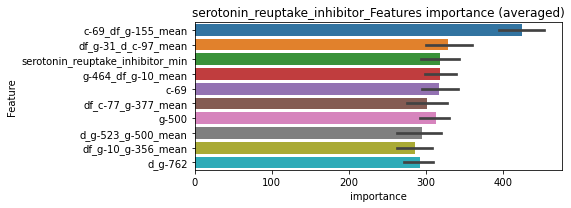

len(train_index) : 2832
len(valid_index) : 944
================================= fold 1/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100308	valid_1's binary_logloss: 0.148717
[200]	training's binary_logloss: 0.0335447	valid_1's binary_logloss: 0.076298
[300]	training's binary_logloss: 0.0126039	valid_1's binary_logloss: 0.0461447
[400]	training's binary_logloss: 0.00544974	valid_1's binary_logloss: 0.0324497
[500]	training's binary_logloss: 0.00280039	valid_1's binary_logloss: 0.0265197
[600]	training's binary_logloss: 0.00172887	valid_1's binary_logloss: 0.0230401
[700]	training's binary_logloss: 0.0012097	valid_1's binary_logloss: 0.0212562
[800]	training's binary_logloss: 0.000936446	valid_1's binary_logloss: 0.0202521
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00083191	valid_1's binary_logloss: 0.0197311


len(train_index) : 2832
len(valid_index) : 944
================================= fold 2/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0990351	valid_1's binary_logloss: 0.140488
[200]	training's binary_logloss: 0.0337101	valid_1's binary_logloss: 0.0728492
[300]	training's binary_logloss: 0.0128086	valid_1's binary_logloss: 0.0457691
[400]	training's binary_logloss: 0.00551443	valid_1's binary_logloss: 0.0350701
[500]	training's binary_logloss: 0.00286046	valid_1's binary_logloss: 0.0298142
[600]	training's binary_logloss: 0.00175788	valid_1's binary_logloss: 0.0276384
[700]	training's binary_logloss: 0.00123332	valid_1's binary_logloss: 0.0265728
[800]	training's binary_logloss: 0.000956139	valid_1's binary_logloss: 0.0257868
Early stopping, best iteration is:
[866]	training's binary_logloss: 0.000840155	valid_1's binary_logloss: 0.0252364


len(train_index) : 2832
len(valid_index) : 944
================================= fold 3/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101836	valid_1's binary_logloss: 0.130898
[200]	training's binary_logloss: 0.0346199	valid_1's binary_logloss: 0.059948
[300]	training's binary_logloss: 0.0137187	valid_1's binary_logloss: 0.0317127
[400]	training's binary_logloss: 0.00601939	valid_1's binary_logloss: 0.0189947
[500]	training's binary_logloss: 0.0030263	valid_1's binary_logloss: 0.0128063
[600]	training's binary_logloss: 0.00184684	valid_1's binary_logloss: 0.00960845
[700]	training's binary_logloss: 0.00128163	valid_1's binary_logloss: 0.00761025
[800]	training's binary_logloss: 0.000988416	valid_1's binary_logloss: 0.00659284
[900]	training's binary_logloss: 0.000817884	valid_1's binary_logloss: 0.00594631
[1000]	training's binary_logloss: 0.00071542	valid_1's binary_logloss: 0.0054677
[1100]	training's binary_logloss: 0.000673314	valid_1's binary_logloss: 0.00525328
[1200]	training's binary_logloss: 0.000649035	valid_1's 

len(train_index) : 2832
len(valid_index) : 944
================================= fold 4/4 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102597	valid_1's binary_logloss: 0.152027
[200]	training's binary_logloss: 0.0343667	valid_1's binary_logloss: 0.0831053
[300]	training's binary_logloss: 0.0136907	valid_1's binary_logloss: 0.0556545
[400]	training's binary_logloss: 0.00582671	valid_1's binary_logloss: 0.0418128
[500]	training's binary_logloss: 0.00296227	valid_1's binary_logloss: 0.0344314
[600]	training's binary_logloss: 0.00180972	valid_1's binary_logloss: 0.0301911
[700]	training's binary_logloss: 0.00125857	valid_1's binary_logloss: 0.0282922
[800]	training's binary_logloss: 0.000961878	valid_1's binary_logloss: 0.0274832
Early stopping, best iteration is:
[861]	training's binary_logloss: 0.000844258	valid_1's binary_logloss: 0.0268729


serotonin_reuptake_inhibitor logloss: 0.019254285200452956


neg labels: 3289 → selected neg labels: 3283


sigma_receptor_agonist, len(trt): 36, len(othr): 3283, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10078	valid_1's binary_logloss: 0.133754
[200]	training's binary_logloss: 0.034088	valid_1's binary_logloss: 0.0602846
[300]	training's binary_logloss: 0.0133923	valid_1's binary_logloss: 0.0329164
[400]	training's binary_logloss: 0.00578304	valid_1's binary_logloss: 0.0204571
[500]	training's binary_logloss: 0.00286633	valid_1's binary_logloss: 0.0149063
[600]	training's binary_logloss: 0.00171969	valid_1's binary_logloss: 0.0122009
[700]	training's binary_logloss: 0.00117977	valid_1's binary_logloss: 0.0108433
[800]	training's binary_logloss: 0.000902967	valid_1's binary_logloss: 0.00998726
[900]	training's binary_logloss: 0.000746286	valid_1's binary_logloss: 0.0096642
[1000]	training's binary_logloss: 0.000667195	valid_1's binary_logloss: 0.00938683
Early stopping, best iteration is:
[994]	training's binary_logloss: 0.000667481	valid_1's binary_logloss: 0.00938252
Training until validati

1 / 3 AUC score:1.000
y_Threshold: 0.0113204, Threshold: 0.1064775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3803
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.07453, conf_1:0.13842
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1064775
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_2: 0.1564775
threshold: 0.1564775, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 654.0/3803, y_label_rate: 0.1719695
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0980235	valid_1's binary_logloss: 0.129405
[200]	training's binary_logloss: 0.0310679	valid_1's binary_logloss: 0.0532578
[300]	training's binary_logloss: 0.0112698	valid_1's binary_logloss: 0.0260736
[400]	training's binary_logloss: 0.00479051	valid_1's binary_logloss: 0.0150812
[500]	training's binary_logloss: 0.00243779	valid_1's binary_logloss: 0.0104024
[600]	training's binary_logloss: 0.00148461	valid_1's binary_logloss: 0.00820768
[700]	training's binary_logloss: 0.00104506	valid_1's binary_logloss: 0.00711742
[800]	training's binary_logloss: 0.000809154	valid_1's binary_logloss: 0.00642601
[900]	training's binary_logloss: 0.000677775	valid_1's binary_logloss: 0.00607033
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000688272	valid_1's binary_logloss: 0.00606493
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0994

2 / 3 AUC score:1.000
y_Threshold: 0.0801295, Threshold: 0.1564775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0178302 Vs.target_rate: 0.00151, Num_p_label: 71.0, conf_0:0.12518, conf_1:0.18777
Num_p_label: 71.0, Expected: 6.0, Adj_threshold_1: 0.1564775
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_2: 0.2064775
Num_p_label: 33.0, Expected: 6.0, Adj_threshold_3: 0.2564775
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_4: 0.3064775
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_5: 0.3564775
Num_p_label: 9.0, Expected: 6.0, Adj_threshold_6: 0.4064775
threshold: 0.4064775, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 652.0/3799, y_label_rate: 0.1716241
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0971761	valid_1's binary_logloss: 0.127584
[200]	training's binary_logloss: 0.0319395	valid_1's binary_logloss: 0.0562827
[300]	training's binary_logloss: 0.0114796	valid_1's binary_logloss: 0.0286483
[400]	training's binary_logloss: 0.00467733	valid_1's binary_logloss: 0.0171026
[500]	training's binary_logloss: 0.00235744	valid_1's binary_logloss: 0.0126439
[600]	training's binary_logloss: 0.00143612	valid_1's binary_logloss: 0.0103975
[700]	training's binary_logloss: 0.000997455	valid_1's binary_logloss: 0.00927992
[800]	training's binary_logloss: 0.000774283	valid_1's binary_logloss: 0.00851426
[900]	training's binary_logloss: 0.000650927	valid_1's binary_logloss: 0.00835371
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000630675	valid_1's binary_logloss: 0.00828831
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0977

3 / 3 AUC score:1.000
y_Threshold: 0.0736603, Threshold: 0.4064775, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 652.0/3799
p_label_rate: 0.0027624 Vs.target_rate: 0.00151, Num_p_label: 11.0, conf_0:0.36583, conf_1:0.44713
Num_p_label: 11.0, Expected: 6.0, Adj_threshold_1: 0.4064775
threshold: 0.4064775, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 652.0/3799, y_label_rate: 0.1716241


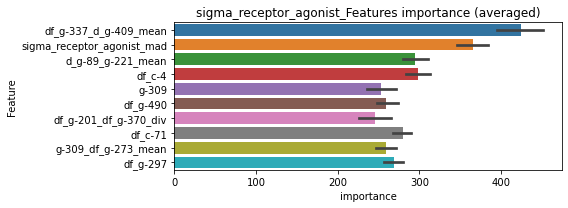

len(train_index) : 2849
len(valid_index) : 950
================================= fold 1/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957312	valid_1's binary_logloss: 0.127094
[200]	training's binary_logloss: 0.030807	valid_1's binary_logloss: 0.0550063
[300]	training's binary_logloss: 0.011151	valid_1's binary_logloss: 0.0282523
[400]	training's binary_logloss: 0.00457216	valid_1's binary_logloss: 0.0172436
[500]	training's binary_logloss: 0.00235003	valid_1's binary_logloss: 0.0128128
[600]	training's binary_logloss: 0.00143319	valid_1's binary_logloss: 0.010419
[700]	training's binary_logloss: 0.00100125	valid_1's binary_logloss: 0.00937573
[800]	training's binary_logloss: 0.000776898	valid_1's binary_logloss: 0.00902477
[900]	training's binary_logloss: 0.000658505	valid_1's binary_logloss: 0.00861765
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000610996	valid_1's binary_logloss: 0.00848758


len(train_index) : 2849
len(valid_index) : 950
================================= fold 2/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0971492	valid_1's binary_logloss: 0.119135
[200]	training's binary_logloss: 0.0314798	valid_1's binary_logloss: 0.0483585
[300]	training's binary_logloss: 0.0116091	valid_1's binary_logloss: 0.0235455
[400]	training's binary_logloss: 0.004832	valid_1's binary_logloss: 0.0131594
[500]	training's binary_logloss: 0.00244353	valid_1's binary_logloss: 0.00882556
[600]	training's binary_logloss: 0.00147234	valid_1's binary_logloss: 0.0063609
[700]	training's binary_logloss: 0.00102872	valid_1's binary_logloss: 0.00528703
[800]	training's binary_logloss: 0.00079973	valid_1's binary_logloss: 0.0045806
[900]	training's binary_logloss: 0.000669317	valid_1's binary_logloss: 0.00417986
[1000]	training's binary_logloss: 0.000615733	valid_1's binary_logloss: 0.00405007
Early stopping, best iteration is:
[1049]	training's binary_logloss: 0.00061022	valid_1's binary_logloss: 0.00402635


len(train_index) : 2849
len(valid_index) : 950
================================= fold 3/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968852	valid_1's binary_logloss: 0.123777
[200]	training's binary_logloss: 0.0311005	valid_1's binary_logloss: 0.0514425
[300]	training's binary_logloss: 0.0112167	valid_1's binary_logloss: 0.0258618
[400]	training's binary_logloss: 0.00467715	valid_1's binary_logloss: 0.0155013
[500]	training's binary_logloss: 0.00236074	valid_1's binary_logloss: 0.0106141
[600]	training's binary_logloss: 0.00145128	valid_1's binary_logloss: 0.00864352
[700]	training's binary_logloss: 0.00101855	valid_1's binary_logloss: 0.00767798
[800]	training's binary_logloss: 0.000788095	valid_1's binary_logloss: 0.00702889
[900]	training's binary_logloss: 0.000658311	valid_1's binary_logloss: 0.00650551
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.000647326	valid_1's binary_logloss: 0.00647702


len(train_index) : 2850
len(valid_index) : 949
================================= fold 4/4 sigma_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0959064	valid_1's binary_logloss: 0.132827
[200]	training's binary_logloss: 0.0297641	valid_1's binary_logloss: 0.0583384
[300]	training's binary_logloss: 0.0107597	valid_1's binary_logloss: 0.0309657
[400]	training's binary_logloss: 0.00441529	valid_1's binary_logloss: 0.0192976
[500]	training's binary_logloss: 0.00224306	valid_1's binary_logloss: 0.0143436
[600]	training's binary_logloss: 0.00138145	valid_1's binary_logloss: 0.0118558
[700]	training's binary_logloss: 0.00097636	valid_1's binary_logloss: 0.01061
[800]	training's binary_logloss: 0.000768265	valid_1's binary_logloss: 0.00990144
[900]	training's binary_logloss: 0.00065171	valid_1's binary_logloss: 0.00954717
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000676295	valid_1's binary_logloss: 0.00952175


sigma_receptor_agonist logloss: 0.007127544194741365


neg labels: 3289 → selected neg labels: 3285


sigma_receptor_antagonist, len(trt): 36, len(othr): 3285, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102248	valid_1's binary_logloss: 0.146278
[200]	training's binary_logloss: 0.0387438	valid_1's binary_logloss: 0.0779804
[300]	training's binary_logloss: 0.016034	valid_1's binary_logloss: 0.0472718
[400]	training's binary_logloss: 0.00690118	valid_1's binary_logloss: 0.0313904
[500]	training's binary_logloss: 0.00342071	valid_1's binary_logloss: 0.023753
[600]	training's binary_logloss: 0.00200163	valid_1's binary_logloss: 0.0197444
[700]	training's binary_logloss: 0.00136547	valid_1's binary_logloss: 0.0176301
[800]	training's binary_logloss: 0.00102642	valid_1's binary_logloss: 0.0159745
[900]	training's binary_logloss: 0.000832043	valid_1's binary_logloss: 0.0150828
[1000]	training's binary_logloss: 0.00072897	valid_1's binary_logloss: 0.0145237
[1100]	training's binary_logloss: 0.000688958	valid_1's binary_logloss: 0.0143377
Early stopping, best iteration is:
[1078]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0142870, Threshold: 0.1189903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.08329, conf_1:0.15469
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.1189903
Num_p_label: 31.0, Expected: 6.0, Adj_threshold_2: 0.1689903
Num_p_label: 19.0, Expected: 6.0, Adj_threshold_3: 0.2189903
Num_p_label: 14.0, Expected: 6.0, Adj_threshold_4: 0.2689903
threshold: 0.2689903, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0975891	valid_1's binary_logloss: 0.140961
[200]	training's binary_logloss: 0.0325559	valid_1's binary_logloss: 0.0713416
[300]	training's binary_logloss: 0.0123213	valid_1's binary_logloss: 0.0418836
[400]	training's binary_logloss: 0.00531371	valid_1's binary_logloss: 0.0292923
[500]	training's binary_logloss: 0.0026867	valid_1's binary_logloss: 0.022801
[600]	training's binary_logloss: 0.00163897	valid_1's binary_logloss: 0.0200656
[700]	training's binary_logloss: 0.00113673	valid_1's binary_logloss: 0.0175731
[800]	training's binary_logloss: 0.000876216	valid_1's binary_logloss: 0.0162373
[900]	training's binary_logloss: 0.00072117	valid_1's binary_logloss: 0.0157295
Early stopping, best iteration is:
[923]	training's binary_logloss: 0.000696556	valid_1's binary_logloss: 0.015585
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961598	valid

2 / 3 AUC score:1.000
y_Threshold: 0.1292858, Threshold: 0.2689903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0160723 Vs.target_rate: 0.00151, Num_p_label: 64.0, conf_0:0.21519, conf_1:0.32279
Num_p_label: 64.0, Expected: 6.0, Adj_threshold_1: 0.2689903
Num_p_label: 50.0, Expected: 6.0, Adj_threshold_2: 0.3189903
Num_p_label: 44.0, Expected: 6.0, Adj_threshold_3: 0.3689903
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_4: 0.4189903
Num_p_label: 32.0, Expected: 6.0, Adj_threshold_5: 0.4689903
Num_p_label: 29.0, Expected: 6.0, Adj_threshold_6: 0.5189903
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_7: 0.5689903
Num_p_label: 25.0, Expected: 6.0, Adj_threshold_8: 0.6189903
Num_p_label: 22.0, Expected: 6.0, Adj_threshold_9: 0.6689903
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_10: 0.7189903
threshold: 0.7689903, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0946957	valid_1's binary_logloss: 0.149502
[200]	training's binary_logloss: 0.0308271	valid_1's binary_logloss: 0.0757626
[300]	training's binary_logloss: 0.0115534	valid_1's binary_logloss: 0.0444461
[400]	training's binary_logloss: 0.00493292	valid_1's binary_logloss: 0.0296896
[500]	training's binary_logloss: 0.00252841	valid_1's binary_logloss: 0.0231434
[600]	training's binary_logloss: 0.00153829	valid_1's binary_logloss: 0.0197474
[700]	training's binary_logloss: 0.00107816	valid_1's binary_logloss: 0.0175821
[800]	training's binary_logloss: 0.000835429	valid_1's binary_logloss: 0.0165662
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.000763293	valid_1's binary_logloss: 0.0159252
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0964289	valid_1's binary_logloss: 0.133187
[200]	training's binary_logloss: 0.0314861	vali

3 / 3 AUC score:1.000
y_Threshold: 0.1338996, Threshold: 0.7689903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 649.0/3794
p_label_rate: 0.0045203 Vs.target_rate: 0.00151, Num_p_label: 18.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_1: 0.7689903
threshold: 0.7689903, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 649.0/3794, y_label_rate: 0.1710596


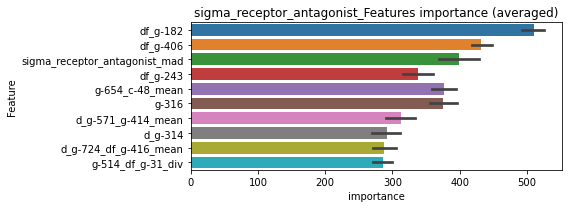

len(train_index) : 2845
len(valid_index) : 949
================================= fold 1/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0945425	valid_1's binary_logloss: 0.147456
[200]	training's binary_logloss: 0.030088	valid_1's binary_logloss: 0.0738368
[300]	training's binary_logloss: 0.011664	valid_1's binary_logloss: 0.0462012
[400]	training's binary_logloss: 0.0049482	valid_1's binary_logloss: 0.0307146
[500]	training's binary_logloss: 0.00255383	valid_1's binary_logloss: 0.023284
[600]	training's binary_logloss: 0.0015444	valid_1's binary_logloss: 0.0194332
[700]	training's binary_logloss: 0.00108534	valid_1's binary_logloss: 0.0169028
[800]	training's binary_logloss: 0.000835819	valid_1's binary_logloss: 0.0156313
[900]	training's binary_logloss: 0.000695202	valid_1's binary_logloss: 0.0149314
[1000]	training's binary_logloss: 0.000631645	valid_1's binary_logloss: 0.0146311
Early stopping, best iteration is:
[992]	training's binary_logloss: 0.000635714	valid_1's binary_logloss: 0.0146129


len(train_index) : 2845
len(valid_index) : 949
================================= fold 2/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0957799	valid_1's binary_logloss: 0.121191
[200]	training's binary_logloss: 0.0305741	valid_1's binary_logloss: 0.0520393
[300]	training's binary_logloss: 0.0115512	valid_1's binary_logloss: 0.026614
[400]	training's binary_logloss: 0.00490192	valid_1's binary_logloss: 0.0163455
[500]	training's binary_logloss: 0.00251903	valid_1's binary_logloss: 0.0119182
[600]	training's binary_logloss: 0.0015398	valid_1's binary_logloss: 0.00998719
[700]	training's binary_logloss: 0.00108305	valid_1's binary_logloss: 0.00909669
[800]	training's binary_logloss: 0.000837759	valid_1's binary_logloss: 0.00841386
[900]	training's binary_logloss: 0.000695644	valid_1's binary_logloss: 0.00804179
Early stopping, best iteration is:
[871]	training's binary_logloss: 0.000726993	valid_1's binary_logloss: 0.00802519


len(train_index) : 2846
len(valid_index) : 948
================================= fold 3/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0938734	valid_1's binary_logloss: 0.141847
[200]	training's binary_logloss: 0.0296371	valid_1's binary_logloss: 0.068981
[300]	training's binary_logloss: 0.0113109	valid_1's binary_logloss: 0.0407355
[400]	training's binary_logloss: 0.00470032	valid_1's binary_logloss: 0.0267022
[500]	training's binary_logloss: 0.00238546	valid_1's binary_logloss: 0.0207323
[600]	training's binary_logloss: 0.0014647	valid_1's binary_logloss: 0.0181736
[700]	training's binary_logloss: 0.00103801	valid_1's binary_logloss: 0.0165458
[800]	training's binary_logloss: 0.000803351	valid_1's binary_logloss: 0.0155463
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000718465	valid_1's binary_logloss: 0.0153094


len(train_index) : 2846
len(valid_index) : 948
================================= fold 4/4 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0958161	valid_1's binary_logloss: 0.119039
[200]	training's binary_logloss: 0.0315136	valid_1's binary_logloss: 0.0516778
[300]	training's binary_logloss: 0.0121051	valid_1's binary_logloss: 0.0277052
[400]	training's binary_logloss: 0.00512035	valid_1's binary_logloss: 0.0184751
[500]	training's binary_logloss: 0.00257567	valid_1's binary_logloss: 0.0140091
[600]	training's binary_logloss: 0.00156627	valid_1's binary_logloss: 0.0122985
[700]	training's binary_logloss: 0.00110498	valid_1's binary_logloss: 0.0113135
[800]	training's binary_logloss: 0.000854531	valid_1's binary_logloss: 0.0108743
[900]	training's binary_logloss: 0.000707014	valid_1's binary_logloss: 0.0106206
Early stopping, best iteration is:
[939]	training's binary_logloss: 0.00067526	valid_1's binary_logloss: 0.0105022


sigma_receptor_antagonist logloss: 0.012120709774834357


neg labels: 3289 → selected neg labels: 3285


smoothened_receptor_antagonist, len(trt): 25, len(othr): 3285, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0953702	valid_1's binary_logloss: 0.120292
[200]	training's binary_logloss: 0.0327294	valid_1's binary_logloss: 0.051674
[300]	training's binary_logloss: 0.0122318	valid_1's binary_logloss: 0.0260224
[400]	training's binary_logloss: 0.0048251	valid_1's binary_logloss: 0.0147672
[500]	training's binary_logloss: 0.00232123	valid_1's binary_logloss: 0.00996976
[600]	training's binary_logloss: 0.00136381	valid_1's binary_logloss: 0.00783835
[700]	training's binary_logloss: 0.000945109	valid_1's binary_logloss: 0.00675676
[800]	training's binary_logloss: 0.000733477	valid_1's binary_logloss: 0.00609353
[900]	training's binary_logloss: 0.000615402	valid_1's binary_logloss: 0.00579384
Early stopping, best iteration is:
[964]	training's binary_logloss: 0.000574585	valid_1's binary_logloss: 0.00564809
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0925

1 / 3 AUC score:1.000
y_Threshold: 0.0096014, Threshold: 0.0292268, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02046, conf_1:0.03799
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0292268
Num_p_label: 19.0, Expected: 4.2, Adj_threshold_2: 0.0792268
Num_p_label: 13.0, Expected: 4.2, Adj_threshold_3: 0.1292268
Num_p_label: 9.0, Expected: 4.2, Adj_threshold_4: 0.1792268
threshold: 0.1792268, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0885414	valid_1's binary_logloss: 0.112335
[200]	training's binary_logloss: 0.0273893	valid_1's binary_logloss: 0.0443845
[300]	training's binary_logloss: 0.00928419	valid_1's binary_logloss: 0.0206804
[400]	training's binary_logloss: 0.0036959	valid_1's binary_logloss: 0.0119683
[500]	training's binary_logloss: 0.00183025	valid_1's binary_logloss: 0.00846248
[600]	training's binary_logloss: 0.00113057	valid_1's binary_logloss: 0.00663748
[700]	training's binary_logloss: 0.000800883	valid_1's binary_logloss: 0.00580274
[800]	training's binary_logloss: 0.000626653	valid_1's binary_logloss: 0.0052681
[900]	training's binary_logloss: 0.000537068	valid_1's binary_logloss: 0.00505628
Early stopping, best iteration is:
[931]	training's binary_logloss: 0.000519256	valid_1's binary_logloss: 0.00498712
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.088

2 / 3 AUC score:1.000
y_Threshold: 0.0891744, Threshold: 0.1792268, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0065294 Vs.target_rate: 0.00105, Num_p_label: 26.0, conf_0:0.14338, conf_1:0.21507
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_1: 0.1792268
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_2: 0.2292268
Num_p_label: 17.0, Expected: 4.2, Adj_threshold_3: 0.2792268
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_4: 0.3292268
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.3792268
Num_p_label: 11.0, Expected: 4.2, Adj_threshold_6: 0.4292268
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_7: 0.4792268
threshold: 0.4792268, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0859778	valid_1's binary_logloss: 0.110396
[200]	training's binary_logloss: 0.0273267	valid_1's binary_logloss: 0.0450069
[300]	training's binary_logloss: 0.00941702	valid_1's binary_logloss: 0.0228156
[400]	training's binary_logloss: 0.00371764	valid_1's binary_logloss: 0.0138283
[500]	training's binary_logloss: 0.00185504	valid_1's binary_logloss: 0.00985563
[600]	training's binary_logloss: 0.00113635	valid_1's binary_logloss: 0.00800018
[700]	training's binary_logloss: 0.000807594	valid_1's binary_logloss: 0.00705361
[800]	training's binary_logloss: 0.000630904	valid_1's binary_logloss: 0.00650214
[900]	training's binary_logloss: 0.00053512	valid_1's binary_logloss: 0.00619036
Early stopping, best iteration is:
[903]	training's binary_logloss: 0.00053231	valid_1's binary_logloss: 0.0061796
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0877

3 / 3 AUC score:1.000
y_Threshold: 0.0835058, Threshold: 0.4792268, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3808
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.43130, conf_1:0.52715
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_1: 0.4792268
threshold: 0.4792268, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3808, y_label_rate: 0.1722689


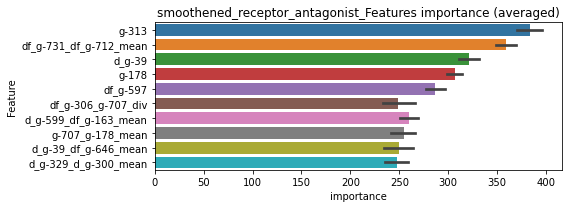

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0867639	valid_1's binary_logloss: 0.111257
[200]	training's binary_logloss: 0.0261765	valid_1's binary_logloss: 0.0449257
[300]	training's binary_logloss: 0.00892571	valid_1's binary_logloss: 0.0227423
[400]	training's binary_logloss: 0.00357079	valid_1's binary_logloss: 0.0137492
[500]	training's binary_logloss: 0.00179688	valid_1's binary_logloss: 0.0100472
[600]	training's binary_logloss: 0.00110676	valid_1's binary_logloss: 0.00813486
[700]	training's binary_logloss: 0.000792977	valid_1's binary_logloss: 0.00716163
[800]	training's binary_logloss: 0.000627128	valid_1's binary_logloss: 0.00668549
[900]	training's binary_logloss: 0.000532575	valid_1's binary_logloss: 0.00642627
Early stopping, best iteration is:
[936]	training's binary_logloss: 0.000513699	valid_1's binary_logloss: 0.00635444


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0856807	valid_1's binary_logloss: 0.111634
[200]	training's binary_logloss: 0.0259295	valid_1's binary_logloss: 0.0412281
[300]	training's binary_logloss: 0.00879439	valid_1's binary_logloss: 0.0176963
[400]	training's binary_logloss: 0.00350393	valid_1's binary_logloss: 0.00903769
[500]	training's binary_logloss: 0.00176537	valid_1's binary_logloss: 0.00565222
[600]	training's binary_logloss: 0.00109507	valid_1's binary_logloss: 0.00410382
[700]	training's binary_logloss: 0.000783297	valid_1's binary_logloss: 0.0034379
[800]	training's binary_logloss: 0.000615799	valid_1's binary_logloss: 0.00297707
[900]	training's binary_logloss: 0.00052591	valid_1's binary_logloss: 0.00271853
[1000]	training's binary_logloss: 0.000498917	valid_1's binary_logloss: 0.00265014
Early stopping, best iteration is:
[1026]	training's binary_logloss: 0.000495836	valid_1's binary_logloss: 0.00263993


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881878	valid_1's binary_logloss: 0.106301
[200]	training's binary_logloss: 0.027037	valid_1's binary_logloss: 0.0403016
[300]	training's binary_logloss: 0.00921122	valid_1's binary_logloss: 0.0174995
[400]	training's binary_logloss: 0.00362834	valid_1's binary_logloss: 0.00876578
[500]	training's binary_logloss: 0.00183004	valid_1's binary_logloss: 0.00545585
[600]	training's binary_logloss: 0.00112073	valid_1's binary_logloss: 0.00397314
[700]	training's binary_logloss: 0.000799784	valid_1's binary_logloss: 0.00313954
[800]	training's binary_logloss: 0.000633676	valid_1's binary_logloss: 0.00268669
[900]	training's binary_logloss: 0.000538016	valid_1's binary_logloss: 0.0024177
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000515878	valid_1's binary_logloss: 0.00235665


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0881409	valid_1's binary_logloss: 0.116239
[200]	training's binary_logloss: 0.026927	valid_1's binary_logloss: 0.0469388
[300]	training's binary_logloss: 0.00924433	valid_1's binary_logloss: 0.0227567
[400]	training's binary_logloss: 0.00365112	valid_1's binary_logloss: 0.0134672
[500]	training's binary_logloss: 0.00182052	valid_1's binary_logloss: 0.00967765
[600]	training's binary_logloss: 0.00111872	valid_1's binary_logloss: 0.00792377
[700]	training's binary_logloss: 0.000795551	valid_1's binary_logloss: 0.00724872
[800]	training's binary_logloss: 0.000625713	valid_1's binary_logloss: 0.00668585
[900]	training's binary_logloss: 0.000533516	valid_1's binary_logloss: 0.00654205
[1000]	training's binary_logloss: 0.000498885	valid_1's binary_logloss: 0.00647861
Early stopping, best iteration is:
[972]	training's binary_logloss: 0.000503159	valid_1's binary_logloss: 0.00644746


smoothened_receptor_antagonist logloss: 0.004450715385362694


neg labels: 3289 → selected neg labels: 3261


sodium_channel_inhibitor, len(trt): 267, len(othr): 3261, target_rate: 0.0112119 → Adj_target_rate: 0.0096991
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.225968	valid_1's binary_logloss: 0.349708
[200]	training's binary_logloss: 0.134845	valid_1's binary_logloss: 0.312517
[300]	training's binary_logloss: 0.0878685	valid_1's binary_logloss: 0.297693
[400]	training's binary_logloss: 0.0581507	valid_1's binary_logloss: 0.289825
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.0476477	valid_1's binary_logloss: 0.287499
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.220694	valid_1's binary_logloss: 0.345383
[200]	training's binary_logloss: 0.134266	valid_1's binary_logloss: 0.312928
[300]	training's binary_logloss: 0.0846861	valid_1's binary_logloss: 0.299968
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0689722	valid_1's binary_logloss: 0.297149
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.221404	valid_1

1 / 3 AUC score:0.878
y_Threshold: 0.1173311, Threshold: 0.3760304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 491 → Positive_corect_labels: 472/3422
p_label_rate: 0.0100452 Vs.target_rate: 0.01121, Num_p_label: 40.0, conf_0:0.26322, conf_1:0.48884
threshold: 0.3760304, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 472.0/3422, y_label_rate: 0.1379310
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.135135	valid_1's binary_logloss: 0.235915
[200]	training's binary_logloss: 0.0645065	valid_1's binary_logloss: 0.191765
[300]	training's binary_logloss: 0.0338835	valid_1's binary_logloss: 0.17271
[400]	training's binary_logloss: 0.0188494	valid_1's binary_logloss: 0.164179
[500]	training's binary_logloss: 0.0109756	valid_1's binary_logloss: 0.160499
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.0104465	valid_1's binary_logloss: 0.160006
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.142614	valid_1's binary_logloss: 0.21116
[200]	training's binary_logloss: 0.0689688	valid_1's binary_logloss: 0.166768
[300]	training's binary_logloss: 0.0376376	valid_1's binary_logloss: 0.145239
[400]	training's binary_logloss: 0.0206538	valid_1's binary_logloss: 0.13698
[500]	training's binary_logloss: 0.0117727	valid_1's binary_logloss:

2 / 3 AUC score:0.973
y_Threshold: 0.1034835, Threshold: 0.3760304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 138 → Positive_corect_labels: 403.0/3284
p_label_rate: 0.0308890 Vs.target_rate: 0.01121, Num_p_label: 123.0, conf_0:0.30082, conf_1:0.45124
Num_p_label: 123.0, Expected: 44.6, Adj_threshold_1: 0.3760304
Num_p_label: 101.0, Expected: 44.6, Adj_threshold_2: 0.4260304
Num_p_label: 84.0, Expected: 44.6, Adj_threshold_3: 0.4760304
Num_p_label: 68.0, Expected: 44.6, Adj_threshold_4: 0.5260304
Num_p_label: 51.0, Expected: 44.6, Adj_threshold_5: 0.5760304
threshold: 0.5760304, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 403.0/3284, y_label_rate: 0.1227162
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105433	valid_1's binary_logloss: 0.178063
[200]	training's binary_logloss: 0.0451234	valid_1's binary_logloss: 0.134735
[300]	training's binary_logloss: 0.0213583	valid_1's binary_logloss: 0.113332
[400]	training's binary_logloss: 0.0109461	valid_1's binary_logloss: 0.103291
[500]	training's binary_logloss: 0.0059403	valid_1's binary_logloss: 0.0997591
[600]	training's binary_logloss: 0.00359376	valid_1's binary_logloss: 0.0967502
[700]	training's binary_logloss: 0.00243598	valid_1's binary_logloss: 0.0944429
Early stopping, best iteration is:
[682]	training's binary_logloss: 0.00259012	valid_1's binary_logloss: 0.0944365
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105394	valid_1's binary_logloss: 0.159898
[200]	training's binary_logloss: 0.0458057	valid_1's binary_logloss: 0.11302
[300]	training's binary_logloss: 0.0223421	valid_1's binary

3 / 3 AUC score:0.989
y_Threshold: 0.0991423, Threshold: 0.5760304, pos_neg_ratio: 0.8000000
Remove_noisy_data: 70 → Positive_corect_labels: 368.0/3214
p_label_rate: 0.0323958 Vs.target_rate: 0.01121, Num_p_label: 129.0, conf_0:0.50000, conf_1:0.63363
Num_p_label: 129.0, Expected: 44.6, Adj_threshold_1: 0.5760304
Num_p_label: 117.0, Expected: 44.6, Adj_threshold_2: 0.6260304
Num_p_label: 103.0, Expected: 44.6, Adj_threshold_3: 0.6760304
Num_p_label: 86.0, Expected: 44.6, Adj_threshold_4: 0.7260304
Num_p_label: 74.0, Expected: 44.6, Adj_threshold_5: 0.7760304
threshold: 0.7760304, positive_p_label: 74.0/3982, p_label_rate: 0.0185836
positive_y_label: 368.0/3214, y_label_rate: 0.1144991


len(train_index) : 2410
len(valid_index) : 804
================================= fold 1/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0887475	valid_1's binary_logloss: 0.145219
[200]	training's binary_logloss: 0.0341985	valid_1's binary_logloss: 0.10145
[300]	training's binary_logloss: 0.0149631	valid_1's binary_logloss: 0.084388
[400]	training's binary_logloss: 0.00740565	valid_1's binary_logloss: 0.0767107
[500]	training's binary_logloss: 0.00402103	valid_1's binary_logloss: 0.0722398
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00382358	valid_1's binary_logloss: 0.0718686


len(train_index) : 2410
len(valid_index) : 804
================================= fold 2/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0915661	valid_1's binary_logloss: 0.146787
[200]	training's binary_logloss: 0.0357829	valid_1's binary_logloss: 0.0973901
[300]	training's binary_logloss: 0.0163803	valid_1's binary_logloss: 0.0803184
[400]	training's binary_logloss: 0.00805475	valid_1's binary_logloss: 0.0697542
[500]	training's binary_logloss: 0.00438309	valid_1's binary_logloss: 0.0637855
[600]	training's binary_logloss: 0.00268364	valid_1's binary_logloss: 0.0599683
[700]	training's binary_logloss: 0.00186621	valid_1's binary_logloss: 0.058343
Early stopping, best iteration is:
[764]	training's binary_logloss: 0.00154442	valid_1's binary_logloss: 0.0563143


len(train_index) : 2411
len(valid_index) : 803
================================= fold 3/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0924958	valid_1's binary_logloss: 0.135781
[200]	training's binary_logloss: 0.0364861	valid_1's binary_logloss: 0.0900485
[300]	training's binary_logloss: 0.0161555	valid_1's binary_logloss: 0.0712783
[400]	training's binary_logloss: 0.00813206	valid_1's binary_logloss: 0.0632624
[500]	training's binary_logloss: 0.00443605	valid_1's binary_logloss: 0.0585135
[600]	training's binary_logloss: 0.0027286	valid_1's binary_logloss: 0.055884
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.0021109	valid_1's binary_logloss: 0.0543961


len(train_index) : 2411
len(valid_index) : 803
================================= fold 4/4 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0844881	valid_1's binary_logloss: 0.151433
[200]	training's binary_logloss: 0.0329754	valid_1's binary_logloss: 0.099739
[300]	training's binary_logloss: 0.0153595	valid_1's binary_logloss: 0.0766106
[400]	training's binary_logloss: 0.00788183	valid_1's binary_logloss: 0.0641698
[500]	training's binary_logloss: 0.00425863	valid_1's binary_logloss: 0.0578084
[600]	training's binary_logloss: 0.0026521	valid_1's binary_logloss: 0.0531568
[700]	training's binary_logloss: 0.0018398	valid_1's binary_logloss: 0.0508468
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00190983	valid_1's binary_logloss: 0.0506125


sodium_channel_inhibitor logloss: 0.058301481401502084


neg labels: 3289 → selected neg labels: 3282


sphingosine_receptor_agonist, len(trt): 32, len(othr): 3282, target_rate: 0.0013437 → Adj_target_rate: 0.0015980
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0852489	valid_1's binary_logloss: 0.132341
[200]	training's binary_logloss: 0.0254752	valid_1's binary_logloss: 0.0653829
[300]	training's binary_logloss: 0.00903702	valid_1's binary_logloss: 0.0405211
[400]	training's binary_logloss: 0.00377142	valid_1's binary_logloss: 0.0294134
[500]	training's binary_logloss: 0.00198315	valid_1's binary_logloss: 0.0247724
[600]	training's binary_logloss: 0.00125294	valid_1's binary_logloss: 0.0225216
[700]	training's binary_logloss: 0.000904103	valid_1's binary_logloss: 0.0211561
[800]	training's binary_logloss: 0.000715122	valid_1's binary_logloss: 0.0204588
Early stopping, best iteration is:
[819]	training's binary_logloss: 0.000687795	valid_1's binary_logloss: 0.0201606
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.086337	valid_1's binary_logloss: 0.114421
[200]	training's binary_logloss: 0.0258393	val

1 / 3 AUC score:0.999
y_Threshold: 0.0088588, Threshold: 0.0563033, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3802
p_label_rate: 0.0100452 Vs.target_rate: 0.00134, Num_p_label: 40.0, conf_0:0.03941, conf_1:0.07319
Num_p_label: 40.0, Expected: 5.4, Adj_threshold_1: 0.0563033
Num_p_label: 13.0, Expected: 5.4, Adj_threshold_2: 0.1063033
threshold: 0.1063033, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813509	valid_1's binary_logloss: 0.117334
[200]	training's binary_logloss: 0.0225939	valid_1's binary_logloss: 0.0502567
[300]	training's binary_logloss: 0.00777724	valid_1's binary_logloss: 0.0270285
[400]	training's binary_logloss: 0.00329785	valid_1's binary_logloss: 0.0171568
[500]	training's binary_logloss: 0.001761	valid_1's binary_logloss: 0.0132789
[600]	training's binary_logloss: 0.00112044	valid_1's binary_logloss: 0.0106208
[700]	training's binary_logloss: 0.00081283	valid_1's binary_logloss: 0.00944627
[800]	training's binary_logloss: 0.000646076	valid_1's binary_logloss: 0.00862055
[900]	training's binary_logloss: 0.000544503	valid_1's binary_logloss: 0.00812652
[1000]	training's binary_logloss: 0.00050216	valid_1's binary_logloss: 0.00794887
Early stopping, best iteration is:
[980]	training's binary_logloss: 0.00050216	valid_1's binary_logloss: 0.00794887
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.0741706, Threshold: 0.1063033, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0123054 Vs.target_rate: 0.00134, Num_p_label: 49.0, conf_0:0.08504, conf_1:0.12756
Num_p_label: 49.0, Expected: 5.4, Adj_threshold_1: 0.1063033
Num_p_label: 32.0, Expected: 5.4, Adj_threshold_2: 0.1563033
Num_p_label: 26.0, Expected: 5.4, Adj_threshold_3: 0.2063033
Num_p_label: 23.0, Expected: 5.4, Adj_threshold_4: 0.2563033
Num_p_label: 16.0, Expected: 5.4, Adj_threshold_5: 0.3063033
Num_p_label: 14.0, Expected: 5.4, Adj_threshold_6: 0.3563033
Num_p_label: 10.0, Expected: 5.4, Adj_threshold_7: 0.4063033
threshold: 0.4063033, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0820121	valid_1's binary_logloss: 0.112838
[200]	training's binary_logloss: 0.0230322	valid_1's binary_logloss: 0.0501655
[300]	training's binary_logloss: 0.00787394	valid_1's binary_logloss: 0.0271849
[400]	training's binary_logloss: 0.0033339	valid_1's binary_logloss: 0.0184134
[500]	training's binary_logloss: 0.00175426	valid_1's binary_logloss: 0.0137436
[600]	training's binary_logloss: 0.00110962	valid_1's binary_logloss: 0.0114147
[700]	training's binary_logloss: 0.000798906	valid_1's binary_logloss: 0.010288
[800]	training's binary_logloss: 0.000628742	valid_1's binary_logloss: 0.00962912
[900]	training's binary_logloss: 0.000533621	valid_1's binary_logloss: 0.0091268
Early stopping, best iteration is:
[920]	training's binary_logloss: 0.00052104	valid_1's binary_logloss: 0.00906954
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0795665	

3 / 3 AUC score:1.000
y_Threshold: 0.0571312, Threshold: 0.4063033, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 648.0/3790
p_label_rate: 0.0027624 Vs.target_rate: 0.00134, Num_p_label: 11.0, conf_0:0.36567, conf_1:0.44693
Num_p_label: 11.0, Expected: 5.4, Adj_threshold_1: 0.4063033
threshold: 0.4063033, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 648.0/3790, y_label_rate: 0.1709763


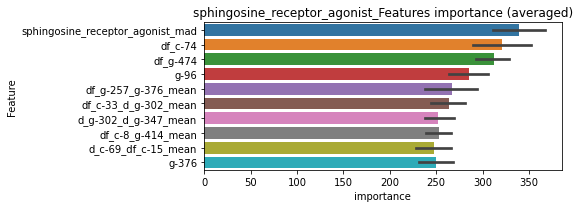

len(train_index) : 2842
len(valid_index) : 948
================================= fold 1/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822834	valid_1's binary_logloss: 0.11641
[200]	training's binary_logloss: 0.0234866	valid_1's binary_logloss: 0.0513018
[300]	training's binary_logloss: 0.00783554	valid_1's binary_logloss: 0.0275741
[400]	training's binary_logloss: 0.00328326	valid_1's binary_logloss: 0.0181972
[500]	training's binary_logloss: 0.00173288	valid_1's binary_logloss: 0.0140914
[600]	training's binary_logloss: 0.00110263	valid_1's binary_logloss: 0.0119672
[700]	training's binary_logloss: 0.00079997	valid_1's binary_logloss: 0.0108635
[800]	training's binary_logloss: 0.000633083	valid_1's binary_logloss: 0.0101421
[900]	training's binary_logloss: 0.000536715	valid_1's binary_logloss: 0.00977383
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000540782	valid_1's binary_logloss: 0.00971925


len(train_index) : 2842
len(valid_index) : 948
================================= fold 2/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0810339	valid_1's binary_logloss: 0.106733
[200]	training's binary_logloss: 0.0225668	valid_1's binary_logloss: 0.042251
[300]	training's binary_logloss: 0.00765713	valid_1's binary_logloss: 0.0212375
[400]	training's binary_logloss: 0.00324657	valid_1's binary_logloss: 0.013093
[500]	training's binary_logloss: 0.00172033	valid_1's binary_logloss: 0.00939563
[600]	training's binary_logloss: 0.00109924	valid_1's binary_logloss: 0.00745156
[700]	training's binary_logloss: 0.000796992	valid_1's binary_logloss: 0.00639783
[800]	training's binary_logloss: 0.000631615	valid_1's binary_logloss: 0.00568777
[900]	training's binary_logloss: 0.000538633	valid_1's binary_logloss: 0.00538062
[1000]	training's binary_logloss: 0.000491341	valid_1's binary_logloss: 0.00523292
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000489487	valid_1's binary_logloss: 0.0052208


len(train_index) : 2843
len(valid_index) : 947
================================= fold 3/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0811153	valid_1's binary_logloss: 0.117137
[200]	training's binary_logloss: 0.0227645	valid_1's binary_logloss: 0.0550217
[300]	training's binary_logloss: 0.00771877	valid_1's binary_logloss: 0.0343574
[400]	training's binary_logloss: 0.00324965	valid_1's binary_logloss: 0.0266466
[500]	training's binary_logloss: 0.00171047	valid_1's binary_logloss: 0.0223738
[600]	training's binary_logloss: 0.00108722	valid_1's binary_logloss: 0.0203107
[700]	training's binary_logloss: 0.000798193	valid_1's binary_logloss: 0.0195329
[800]	training's binary_logloss: 0.000630575	valid_1's binary_logloss: 0.0192551
Early stopping, best iteration is:
[785]	training's binary_logloss: 0.000648236	valid_1's binary_logloss: 0.0190766


len(train_index) : 2843
len(valid_index) : 947
================================= fold 4/4 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0813818	valid_1's binary_logloss: 0.113485
[200]	training's binary_logloss: 0.0227788	valid_1's binary_logloss: 0.0501435
[300]	training's binary_logloss: 0.00760374	valid_1's binary_logloss: 0.0288878
[400]	training's binary_logloss: 0.00318824	valid_1's binary_logloss: 0.0208735
[500]	training's binary_logloss: 0.00170286	valid_1's binary_logloss: 0.0175308
[600]	training's binary_logloss: 0.00108283	valid_1's binary_logloss: 0.0156734
[700]	training's binary_logloss: 0.000782604	valid_1's binary_logloss: 0.014965
Early stopping, best iteration is:
[701]	training's binary_logloss: 0.000780843	valid_1's binary_logloss: 0.0149485


sphingosine_receptor_agonist logloss: 0.012238968962452024


neg labels: 3289 → selected neg labels: 3278


src_inhibitor, len(trt): 71, len(othr): 3278, target_rate: 0.0029814 → Adj_target_rate: 0.0031461
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.136056	valid_1's binary_logloss: 0.202776
[200]	training's binary_logloss: 0.0622711	valid_1's binary_logloss: 0.137221
[300]	training's binary_logloss: 0.0306308	valid_1's binary_logloss: 0.107653
[400]	training's binary_logloss: 0.0159186	valid_1's binary_logloss: 0.0913335
[500]	training's binary_logloss: 0.00844476	valid_1's binary_logloss: 0.0831671
[600]	training's binary_logloss: 0.00489531	valid_1's binary_logloss: 0.0780898
[700]	training's binary_logloss: 0.00315388	valid_1's binary_logloss: 0.0754744
[800]	training's binary_logloss: 0.00222797	valid_1's binary_logloss: 0.0734915
Early stopping, best iteration is:
[860]	training's binary_logloss: 0.00188841	valid_1's binary_logloss: 0.0731866
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137924	valid_1's binary_logloss: 0.208153
[200]	training's binary_logloss: 0.0646685	valid_1's b

1 / 3 AUC score:0.993
y_Threshold: 0.0324289, Threshold: 0.1844351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 170 → Positive_corect_labels: 636/3763
p_label_rate: 0.0100452 Vs.target_rate: 0.00298, Num_p_label: 40.0, conf_0:0.12910, conf_1:0.23977
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_1: 0.1844351
Num_p_label: 28.0, Expected: 11.9, Adj_threshold_2: 0.2344351
Num_p_label: 19.0, Expected: 11.9, Adj_threshold_3: 0.2844351
Num_p_label: 15.0, Expected: 11.9, Adj_threshold_4: 0.3344351
threshold: 0.3344351, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 636.0/3763, y_label_rate: 0.1690141
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121617	valid_1's binary_logloss: 0.191713
[200]	training's binary_logloss: 0.0520786	valid_1's binary_logloss: 0.124162
[300]	training's binary_logloss: 0.0232423	valid_1's binary_logloss: 0.0910385
[400]	training's binary_logloss: 0.0111401	valid_1's binary_logloss: 0.0744786
[500]	training's binary_logloss: 0.00579447	valid_1's binary_logloss: 0.0649654
[600]	training's binary_logloss: 0.0034197	valid_1's binary_logloss: 0.0600403
Early stopping, best iteration is:
[640]	training's binary_logloss: 0.00286627	valid_1's binary_logloss: 0.0579355
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122917	valid_1's binary_logloss: 0.183284
[200]	training's binary_logloss: 0.0505316	valid_1's binary_logloss: 0.111058
[300]	training's binary_logloss: 0.0228506	valid_1's binary_logloss: 0.0792913
[400]	training's binary_logloss: 0.0112479	valid_1's bina

2 / 3 AUC score:0.997
y_Threshold: 0.1083503, Threshold: 0.3344351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 60 → Positive_corect_labels: 606.0/3703
p_label_rate: 0.0150678 Vs.target_rate: 0.00298, Num_p_label: 60.0, conf_0:0.26755, conf_1:0.40132
Num_p_label: 60.0, Expected: 11.9, Adj_threshold_1: 0.3344351
Num_p_label: 51.0, Expected: 11.9, Adj_threshold_2: 0.3844351
Num_p_label: 44.0, Expected: 11.9, Adj_threshold_3: 0.4344351
Num_p_label: 40.0, Expected: 11.9, Adj_threshold_4: 0.4844351
Num_p_label: 33.0, Expected: 11.9, Adj_threshold_5: 0.5344351
Num_p_label: 32.0, Expected: 11.9, Adj_threshold_6: 0.5844351
Num_p_label: 29.0, Expected: 11.9, Adj_threshold_7: 0.6344351
Num_p_label: 25.0, Expected: 11.9, Adj_threshold_8: 0.6844351
Num_p_label: 22.0, Expected: 11.9, Adj_threshold_9: 0.7344351
Num_p_label: 17.0, Expected: 11.9, Adj_threshold_10: 0.7844351
threshold: 0.7844351, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 606.0/3703, y_label_rate: 0.1636511

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111657	valid_1's binary_logloss: 0.171318
[200]	training's binary_logloss: 0.0433912	valid_1's binary_logloss: 0.104935
[300]	training's binary_logloss: 0.0193722	valid_1's binary_logloss: 0.0774278
[400]	training's binary_logloss: 0.00906482	valid_1's binary_logloss: 0.0648148
[500]	training's binary_logloss: 0.00476407	valid_1's binary_logloss: 0.0583689
[600]	training's binary_logloss: 0.00283431	valid_1's binary_logloss: 0.0548518
[700]	training's binary_logloss: 0.00191341	valid_1's binary_logloss: 0.0537736
[800]	training's binary_logloss: 0.00142537	valid_1's binary_logloss: 0.0532681
Early stopping, best iteration is:
[844]	training's binary_logloss: 0.00127535	valid_1's binary_logloss: 0.0529907
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115064	valid_1's binary_logloss: 0.170814
[200]	training's binary_logloss: 0.0466056	valid_1's

3 / 3 AUC score:0.996
y_Threshold: 0.1209219, Threshold: 0.7844351, pos_neg_ratio: 0.8000000
Remove_noisy_data: 38 → Positive_corect_labels: 587.0/3665
p_label_rate: 0.0060271 Vs.target_rate: 0.00298, Num_p_label: 24.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 24.0, Expected: 11.9, Adj_threshold_1: 0.7844351
threshold: 0.7844351, positive_p_label: 24.0/3982, p_label_rate: 0.0060271
positive_y_label: 587.0/3665, y_label_rate: 0.1601637


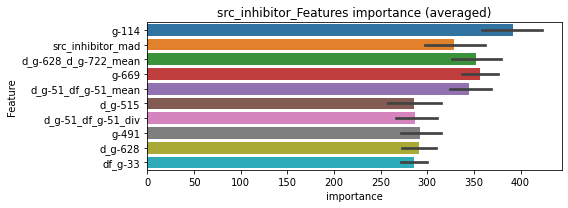

len(train_index) : 2748
len(valid_index) : 917
================================= fold 1/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10798	valid_1's binary_logloss: 0.157664
[200]	training's binary_logloss: 0.0411098	valid_1's binary_logloss: 0.0931569
[300]	training's binary_logloss: 0.0174784	valid_1's binary_logloss: 0.0664452
[400]	training's binary_logloss: 0.0079646	valid_1's binary_logloss: 0.0553636
[500]	training's binary_logloss: 0.00409589	valid_1's binary_logloss: 0.0501261
[600]	training's binary_logloss: 0.00246311	valid_1's binary_logloss: 0.0479425
[700]	training's binary_logloss: 0.00167821	valid_1's binary_logloss: 0.0462166
Early stopping, best iteration is:
[697]	training's binary_logloss: 0.00169431	valid_1's binary_logloss: 0.0461991


len(train_index) : 2749
len(valid_index) : 916
================================= fold 2/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108309	valid_1's binary_logloss: 0.156936
[200]	training's binary_logloss: 0.0399876	valid_1's binary_logloss: 0.0941957
[300]	training's binary_logloss: 0.0171871	valid_1's binary_logloss: 0.065555
[400]	training's binary_logloss: 0.00796808	valid_1's binary_logloss: 0.0526777
[500]	training's binary_logloss: 0.00411905	valid_1's binary_logloss: 0.0447682
[600]	training's binary_logloss: 0.00247312	valid_1's binary_logloss: 0.0421154
[700]	training's binary_logloss: 0.00168941	valid_1's binary_logloss: 0.0397968
[800]	training's binary_logloss: 0.0012713	valid_1's binary_logloss: 0.0386759
[900]	training's binary_logloss: 0.00103187	valid_1's binary_logloss: 0.0380596
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000973122	valid_1's binary_logloss: 0.0377504


len(train_index) : 2749
len(valid_index) : 916
================================= fold 3/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110162	valid_1's binary_logloss: 0.148204
[200]	training's binary_logloss: 0.0417086	valid_1's binary_logloss: 0.0807609
[300]	training's binary_logloss: 0.0176801	valid_1's binary_logloss: 0.0507807
[400]	training's binary_logloss: 0.00822456	valid_1's binary_logloss: 0.0361065
[500]	training's binary_logloss: 0.00425807	valid_1's binary_logloss: 0.0283054
[600]	training's binary_logloss: 0.00253866	valid_1's binary_logloss: 0.0240592
[700]	training's binary_logloss: 0.00172628	valid_1's binary_logloss: 0.0215191
[800]	training's binary_logloss: 0.00129564	valid_1's binary_logloss: 0.01969
[900]	training's binary_logloss: 0.00105743	valid_1's binary_logloss: 0.018846
[1000]	training's binary_logloss: 0.000915141	valid_1's binary_logloss: 0.0181344
[1100]	training's binary_logloss: 0.000842589	valid_1's binary_logloss: 0.0177954
[1200]	training's binary_logloss: 0.00079826	valid_1's binary_l

len(train_index) : 2749
len(valid_index) : 916
================================= fold 4/4 src_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107304	valid_1's binary_logloss: 0.170501
[200]	training's binary_logloss: 0.0401808	valid_1's binary_logloss: 0.104658
[300]	training's binary_logloss: 0.0173885	valid_1's binary_logloss: 0.0739746
[400]	training's binary_logloss: 0.00818166	valid_1's binary_logloss: 0.0602663
[500]	training's binary_logloss: 0.00430463	valid_1's binary_logloss: 0.0542803
[600]	training's binary_logloss: 0.00255586	valid_1's binary_logloss: 0.0514527
Early stopping, best iteration is:
[665]	training's binary_logloss: 0.00196256	valid_1's binary_logloss: 0.0501759


src_inhibitor logloss: 0.037913156784235943


neg labels: 3289 → selected neg labels: 3275


steroid, len(trt): 79, len(othr): 3275, target_rate: 0.0033174 → Adj_target_rate: 0.0034449
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133112	valid_1's binary_logloss: 0.21189
[200]	training's binary_logloss: 0.0575913	valid_1's binary_logloss: 0.146847
[300]	training's binary_logloss: 0.0283574	valid_1's binary_logloss: 0.1189
[400]	training's binary_logloss: 0.0143263	valid_1's binary_logloss: 0.104595
[500]	training's binary_logloss: 0.007572	valid_1's binary_logloss: 0.0967122
[600]	training's binary_logloss: 0.00445516	valid_1's binary_logloss: 0.0930153
Early stopping, best iteration is:
[595]	training's binary_logloss: 0.00456589	valid_1's binary_logloss: 0.0927214
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.130482	valid_1's binary_logloss: 0.197411
[200]	training's binary_logloss: 0.0550213	valid_1's binary_logloss: 0.131558
[300]	training's binary_logloss: 0.0263646	valid_1's binary_logloss: 0.103307
[400]	training's binary_logloss: 0.0132696	valid_1's binary_logl

1 / 3 AUC score:0.989
y_Threshold: 0.0329688, Threshold: 0.3061937, pos_neg_ratio: 0.8000000
Remove_noisy_data: 175 → Positive_corect_labels: 633/3755
p_label_rate: 0.0100452 Vs.target_rate: 0.00332, Num_p_label: 40.0, conf_0:0.21434, conf_1:0.39805
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_1: 0.3061937
Num_p_label: 33.0, Expected: 13.2, Adj_threshold_2: 0.3561937
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_3: 0.4061937
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_4: 0.4561937
Num_p_label: 20.0, Expected: 13.2, Adj_threshold_5: 0.5061937
Num_p_label: 15.0, Expected: 13.2, Adj_threshold_6: 0.5561937
threshold: 0.5561937, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 633.0/3755, y_label_rate: 0.1685752
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123113	valid_1's binary_logloss: 0.179945
[200]	training's binary_logloss: 0.050039	valid_1's binary_logloss: 0.110539
[300]	training's binary_logloss: 0.0226141	valid_1's binary_logloss: 0.0805657
[400]	training's binary_logloss: 0.0108705	valid_1's binary_logloss: 0.0654355
[500]	training's binary_logloss: 0.00564193	valid_1's binary_logloss: 0.0575605
[600]	training's binary_logloss: 0.00322776	valid_1's binary_logloss: 0.0532145
[700]	training's binary_logloss: 0.00213818	valid_1's binary_logloss: 0.0506948
[800]	training's binary_logloss: 0.00156699	valid_1's binary_logloss: 0.0488041
Early stopping, best iteration is:
[843]	training's binary_logloss: 0.00140609	valid_1's binary_logloss: 0.0482523
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119252	valid_1's binary_logloss: 0.175413
[200]	training's binary_logloss: 0.0468499	valid_1's b

2 / 3 AUC score:0.995
y_Threshold: 0.0681978, Threshold: 0.5561937, pos_neg_ratio: 0.8000000
Remove_noisy_data: 50 → Positive_corect_labels: 608.0/3705
p_label_rate: 0.0140633 Vs.target_rate: 0.00332, Num_p_label: 56.0, conf_0:0.44495, conf_1:0.66743
Num_p_label: 56.0, Expected: 13.2, Adj_threshold_1: 0.5561937
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_2: 0.6061937
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_3: 0.6561937
Num_p_label: 34.0, Expected: 13.2, Adj_threshold_4: 0.7061937
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_5: 0.7561937
threshold: 0.7561937, positive_p_label: 29.0/3982, p_label_rate: 0.0072828
positive_y_label: 608.0/3705, y_label_rate: 0.1641026
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108912	valid_1's binary_logloss: 0.163884
[200]	training's binary_logloss: 0.0411607	valid_1's binary_logloss: 0.093209
[300]	training's binary_logloss: 0.0173549	valid_1's binary_logloss: 0.0624445
[400]	training's binary_logloss: 0.00798689	valid_1's binary_logloss: 0.0484507
[500]	training's binary_logloss: 0.00421682	valid_1's binary_logloss: 0.0401345
[600]	training's binary_logloss: 0.00253187	valid_1's binary_logloss: 0.0353275
[700]	training's binary_logloss: 0.00172829	valid_1's binary_logloss: 0.032673
[800]	training's binary_logloss: 0.00129327	valid_1's binary_logloss: 0.0311576
[900]	training's binary_logloss: 0.00104512	valid_1's binary_logloss: 0.0306505
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00103479	valid_1's binary_logloss: 0.0306006
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109347	valid_1'

3 / 3 AUC score:0.998
y_Threshold: 0.0855781, Threshold: 0.7561937, pos_neg_ratio: 0.8000000
Remove_noisy_data: 32 → Positive_corect_labels: 592.0/3673
p_label_rate: 0.0113009 Vs.target_rate: 0.00332, Num_p_label: 45.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 45.0, Expected: 13.2, Adj_threshold_1: 0.7561937
threshold: 0.7561937, positive_p_label: 45.0/3982, p_label_rate: 0.0113009
positive_y_label: 592.0/3673, y_label_rate: 0.1611762


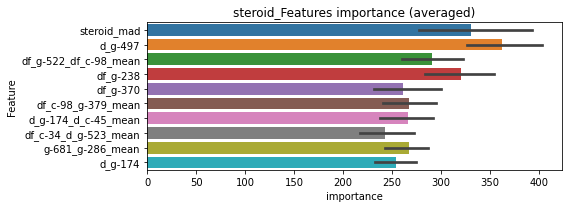

len(train_index) : 2754
len(valid_index) : 919
================================= fold 1/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101252	valid_1's binary_logloss: 0.167892
[200]	training's binary_logloss: 0.0350065	valid_1's binary_logloss: 0.110706
[300]	training's binary_logloss: 0.0138986	valid_1's binary_logloss: 0.091042
[400]	training's binary_logloss: 0.00624337	valid_1's binary_logloss: 0.0860425
Early stopping, best iteration is:
[447]	training's binary_logloss: 0.00447598	valid_1's binary_logloss: 0.0845757


len(train_index) : 2755
len(valid_index) : 918
================================= fold 2/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10661	valid_1's binary_logloss: 0.147908
[200]	training's binary_logloss: 0.0378019	valid_1's binary_logloss: 0.0759138
[300]	training's binary_logloss: 0.0154971	valid_1's binary_logloss: 0.0468506
[400]	training's binary_logloss: 0.00698446	valid_1's binary_logloss: 0.0322982
[500]	training's binary_logloss: 0.00361203	valid_1's binary_logloss: 0.0248459
[600]	training's binary_logloss: 0.00220539	valid_1's binary_logloss: 0.020521
[700]	training's binary_logloss: 0.00152081	valid_1's binary_logloss: 0.0186223
[800]	training's binary_logloss: 0.00115978	valid_1's binary_logloss: 0.0171947
[900]	training's binary_logloss: 0.000950751	valid_1's binary_logloss: 0.0162876
[1000]	training's binary_logloss: 0.000825022	valid_1's binary_logloss: 0.0158166
[1100]	training's binary_logloss: 0.000752789	valid_1's binary_logloss: 0.0153907
Early stopping, best iteration is:
[1091]	training's binary_l

len(train_index) : 2755
len(valid_index) : 918
================================= fold 3/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.10762	valid_1's binary_logloss: 0.151991
[200]	training's binary_logloss: 0.0392425	valid_1's binary_logloss: 0.0822532
[300]	training's binary_logloss: 0.0161627	valid_1's binary_logloss: 0.0553744
[400]	training's binary_logloss: 0.0074443	valid_1's binary_logloss: 0.0433442
[500]	training's binary_logloss: 0.0039209	valid_1's binary_logloss: 0.0366682
[600]	training's binary_logloss: 0.00234887	valid_1's binary_logloss: 0.0331359
[700]	training's binary_logloss: 0.0016259	valid_1's binary_logloss: 0.0316443
[800]	training's binary_logloss: 0.00122321	valid_1's binary_logloss: 0.0306418
Early stopping, best iteration is:
[851]	training's binary_logloss: 0.00109077	valid_1's binary_logloss: 0.0300705


len(train_index) : 2755
len(valid_index) : 918
================================= fold 4/4 steroid=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.105613	valid_1's binary_logloss: 0.149767
[200]	training's binary_logloss: 0.0373764	valid_1's binary_logloss: 0.0866746
[300]	training's binary_logloss: 0.0154895	valid_1's binary_logloss: 0.0609342
[400]	training's binary_logloss: 0.00701195	valid_1's binary_logloss: 0.0491903
[500]	training's binary_logloss: 0.00362442	valid_1's binary_logloss: 0.0437171
[600]	training's binary_logloss: 0.00221181	valid_1's binary_logloss: 0.0403312
[700]	training's binary_logloss: 0.00153842	valid_1's binary_logloss: 0.0382239
[800]	training's binary_logloss: 0.00116643	valid_1's binary_logloss: 0.0368122
Early stopping, best iteration is:
[864]	training's binary_logloss: 0.00102074	valid_1's binary_logloss: 0.0360774


steroid logloss: 0.04153654732631449


neg labels: 3289 → selected neg labels: 3287


syk_inhibitor, len(trt): 19, len(othr): 3287, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0730429	valid_1's binary_logloss: 0.0986751
[200]	training's binary_logloss: 0.0194569	valid_1's binary_logloss: 0.0372525
[300]	training's binary_logloss: 0.00620052	valid_1's binary_logloss: 0.0186048
[400]	training's binary_logloss: 0.00255993	valid_1's binary_logloss: 0.01161
[500]	training's binary_logloss: 0.00132993	valid_1's binary_logloss: 0.00807756
[600]	training's binary_logloss: 0.000851755	valid_1's binary_logloss: 0.00645123
[700]	training's binary_logloss: 0.000638878	valid_1's binary_logloss: 0.0056474
[800]	training's binary_logloss: 0.000517569	valid_1's binary_logloss: 0.00500042
[900]	training's binary_logloss: 0.000458847	valid_1's binary_logloss: 0.00473777
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.000437432	valid_1's binary_logloss: 0.00461601
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.07

1 / 3 AUC score:1.000
y_Threshold: 0.0057007, Threshold: 0.0294256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.02060, conf_1:0.03825
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0294256
Num_p_label: 18.0, Expected: 3.2, Adj_threshold_2: 0.0794256
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_3: 0.1294256
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_4: 0.1794256
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_5: 0.2294256
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_6: 0.2794256
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_7: 0.3294256
threshold: 0.3294256, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0704638	valid_1's binary_logloss: 0.0884456
[200]	training's binary_logloss: 0.017217	valid_1's binary_logloss: 0.0281302
[300]	training's binary_logloss: 0.0052306	valid_1's binary_logloss: 0.0117723
[400]	training's binary_logloss: 0.00212304	valid_1's binary_logloss: 0.00639613
[500]	training's binary_logloss: 0.0011312	valid_1's binary_logloss: 0.00436981
[600]	training's binary_logloss: 0.000735771	valid_1's binary_logloss: 0.00347167
[700]	training's binary_logloss: 0.000550547	valid_1's binary_logloss: 0.00299506
[800]	training's binary_logloss: 0.000450209	valid_1's binary_logloss: 0.00267642
[900]	training's binary_logloss: 0.00041077	valid_1's binary_logloss: 0.00264142
Early stopping, best iteration is:
[902]	training's binary_logloss: 0.0004105	valid_1's binary_logloss: 0.00264129
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703

2 / 3 AUC score:1.000
y_Threshold: 0.0950374, Threshold: 0.3294256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3810
p_label_rate: 0.0052737 Vs.target_rate: 0.00080, Num_p_label: 21.0, conf_0:0.26354, conf_1:0.39531
Num_p_label: 21.0, Expected: 3.2, Adj_threshold_1: 0.3294256
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.3794256
Num_p_label: 15.0, Expected: 3.2, Adj_threshold_3: 0.4294256
Num_p_label: 13.0, Expected: 3.2, Adj_threshold_4: 0.4794256
Num_p_label: 12.0, Expected: 3.2, Adj_threshold_5: 0.5294256
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_6: 0.5794256
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_7: 0.6294256
Num_p_label: 6.0, Expected: 3.2, Adj_threshold_8: 0.6794256
threshold: 0.6794256, positive_p_label: 6.0/3982, p_label_rate: 0.0015068
positive_y_label: 656.0/3810, y_label_rate: 0.1721785
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0706981	valid_1's binary_logloss: 0.0944235
[200]	training's binary_logloss: 0.0168444	valid_1's binary_logloss: 0.0316149
[300]	training's binary_logloss: 0.00509967	valid_1's binary_logloss: 0.0140842
[400]	training's binary_logloss: 0.00208995	valid_1's binary_logloss: 0.008499
[500]	training's binary_logloss: 0.0011045	valid_1's binary_logloss: 0.0058574
[600]	training's binary_logloss: 0.000715752	valid_1's binary_logloss: 0.00466069
[700]	training's binary_logloss: 0.000539908	valid_1's binary_logloss: 0.00414756
[800]	training's binary_logloss: 0.00044169	valid_1's binary_logloss: 0.00382071
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.000461122	valid_1's binary_logloss: 0.00378938
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0695736	valid_1's binary_logloss: 0.0931998
[200]	training's binary_logloss: 0.016728

3 / 3 AUC score:1.000
y_Threshold: 0.0628539, Threshold: 0.6794256, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 655.0/3808
p_label_rate: 0.0020090 Vs.target_rate: 0.00080, Num_p_label: 8.0, conf_0:0.50000, conf_1:0.74737
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_1: 0.6794256
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_2: 0.7294256
threshold: 0.7294256, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 655.0/3808, y_label_rate: 0.1720063


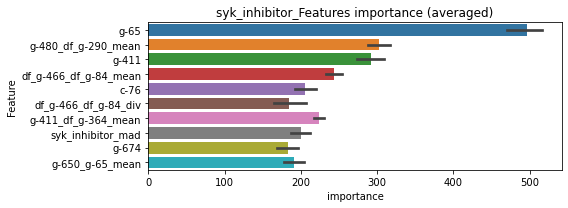

len(train_index) : 2856
len(valid_index) : 952
================================= fold 1/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686546	valid_1's binary_logloss: 0.0905687
[200]	training's binary_logloss: 0.0163239	valid_1's binary_logloss: 0.0304075
[300]	training's binary_logloss: 0.00500195	valid_1's binary_logloss: 0.0138874
[400]	training's binary_logloss: 0.00200714	valid_1's binary_logloss: 0.00784034
[500]	training's binary_logloss: 0.00107948	valid_1's binary_logloss: 0.00542865
[600]	training's binary_logloss: 0.000711963	valid_1's binary_logloss: 0.00427664
[700]	training's binary_logloss: 0.000531971	valid_1's binary_logloss: 0.00367483
[800]	training's binary_logloss: 0.00043627	valid_1's binary_logloss: 0.00335285
Early stopping, best iteration is:
[829]	training's binary_logloss: 0.000420515	valid_1's binary_logloss: 0.00329703


len(train_index) : 2856
len(valid_index) : 952
================================= fold 2/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0693836	valid_1's binary_logloss: 0.0863712
[200]	training's binary_logloss: 0.0166482	valid_1's binary_logloss: 0.026974
[300]	training's binary_logloss: 0.00500774	valid_1's binary_logloss: 0.0110557
[400]	training's binary_logloss: 0.00205009	valid_1's binary_logloss: 0.00593604
[500]	training's binary_logloss: 0.00109134	valid_1's binary_logloss: 0.00418216
[600]	training's binary_logloss: 0.000717277	valid_1's binary_logloss: 0.00330106
[700]	training's binary_logloss: 0.000534128	valid_1's binary_logloss: 0.00278778
[800]	training's binary_logloss: 0.000442338	valid_1's binary_logloss: 0.00252944
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.000421374	valid_1's binary_logloss: 0.00248656


len(train_index) : 2856
len(valid_index) : 952
================================= fold 3/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0687634	valid_1's binary_logloss: 0.080524
[200]	training's binary_logloss: 0.016504	valid_1's binary_logloss: 0.0233995
[300]	training's binary_logloss: 0.00504957	valid_1's binary_logloss: 0.00904125
[400]	training's binary_logloss: 0.00204028	valid_1's binary_logloss: 0.00465822
[500]	training's binary_logloss: 0.00108763	valid_1's binary_logloss: 0.00315109
[600]	training's binary_logloss: 0.000713715	valid_1's binary_logloss: 0.00244366
[700]	training's binary_logloss: 0.000536136	valid_1's binary_logloss: 0.00205927
[800]	training's binary_logloss: 0.000442369	valid_1's binary_logloss: 0.00185184
[900]	training's binary_logloss: 0.00040379	valid_1's binary_logloss: 0.00177472
Early stopping, best iteration is:
[933]	training's binary_logloss: 0.000397399	valid_1's binary_logloss: 0.00177102


len(train_index) : 2856
len(valid_index) : 952
================================= fold 4/4 syk_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0703127	valid_1's binary_logloss: 0.0839373
[200]	training's binary_logloss: 0.0168145	valid_1's binary_logloss: 0.0268358
[300]	training's binary_logloss: 0.00510625	valid_1's binary_logloss: 0.0127029
[400]	training's binary_logloss: 0.00205087	valid_1's binary_logloss: 0.00737225
[500]	training's binary_logloss: 0.00108758	valid_1's binary_logloss: 0.0055398
[600]	training's binary_logloss: 0.0007158	valid_1's binary_logloss: 0.00462499
[700]	training's binary_logloss: 0.000536002	valid_1's binary_logloss: 0.00396602
[800]	training's binary_logloss: 0.000442419	valid_1's binary_logloss: 0.00377253
[900]	training's binary_logloss: 0.000404699	valid_1's binary_logloss: 0.0036765
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000399371	valid_1's binary_logloss: 0.0036539


syk_inhibitor logloss: 0.0028042330595750738


neg labels: 3289 → selected neg labels: 3278


tachykinin_antagonist, len(trt): 60, len(othr): 3278, target_rate: 0.0025195 → Adj_target_rate: 0.0027266
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132361	valid_1's binary_logloss: 0.200522
[200]	training's binary_logloss: 0.0577041	valid_1's binary_logloss: 0.126595
[300]	training's binary_logloss: 0.0268499	valid_1's binary_logloss: 0.0897944
[400]	training's binary_logloss: 0.0128148	valid_1's binary_logloss: 0.0694849
[500]	training's binary_logloss: 0.00663375	valid_1's binary_logloss: 0.0589551
[600]	training's binary_logloss: 0.00383458	valid_1's binary_logloss: 0.052506
[700]	training's binary_logloss: 0.00246364	valid_1's binary_logloss: 0.0480078
[800]	training's binary_logloss: 0.00177558	valid_1's binary_logloss: 0.0458307
Early stopping, best iteration is:
[795]	training's binary_logloss: 0.00180099	valid_1's binary_logloss: 0.0457328
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.137544	valid_1's binary_logloss: 0.192321
[200]	training's binary_logloss: 0.0638431	valid_1's b

1 / 3 AUC score:0.998
y_Threshold: 0.0238827, Threshold: 0.0936567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 653/3797
p_label_rate: 0.0100452 Vs.target_rate: 0.00252, Num_p_label: 40.0, conf_0:0.06556, conf_1:0.12175
Num_p_label: 40.0, Expected: 10.0, Adj_threshold_1: 0.0936567
Num_p_label: 30.0, Expected: 10.0, Adj_threshold_2: 0.1436567
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_3: 0.1936567
Num_p_label: 22.0, Expected: 10.0, Adj_threshold_4: 0.2436567
Num_p_label: 17.0, Expected: 10.0, Adj_threshold_5: 0.2936567
Num_p_label: 13.0, Expected: 10.0, Adj_threshold_6: 0.3436567
threshold: 0.3436567, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 653.0/3797, y_label_rate: 0.1719779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.133105	valid_1's binary_logloss: 0.186273
[200]	training's binary_logloss: 0.0547647	valid_1's binary_logloss: 0.112693
[300]	training's binary_logloss: 0.0241269	valid_1's binary_logloss: 0.0775206
[400]	training's binary_logloss: 0.0114158	valid_1's binary_logloss: 0.0595825
[500]	training's binary_logloss: 0.00596298	valid_1's binary_logloss: 0.0514555
[600]	training's binary_logloss: 0.00345918	valid_1's binary_logloss: 0.0459094
[700]	training's binary_logloss: 0.0022782	valid_1's binary_logloss: 0.0441622
[800]	training's binary_logloss: 0.00164074	valid_1's binary_logloss: 0.0425284
[900]	training's binary_logloss: 0.00128061	valid_1's binary_logloss: 0.0416618
Early stopping, best iteration is:
[957]	training's binary_logloss: 0.00113896	valid_1's binary_logloss: 0.0412545
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.129061	valid_1's

2 / 3 AUC score:0.999
y_Threshold: 0.1134773, Threshold: 0.3436567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 28 → Positive_corect_labels: 639.0/3769
p_label_rate: 0.0113009 Vs.target_rate: 0.00252, Num_p_label: 45.0, conf_0:0.27493, conf_1:0.41239
Num_p_label: 45.0, Expected: 10.0, Adj_threshold_1: 0.3436567
Num_p_label: 41.0, Expected: 10.0, Adj_threshold_2: 0.3936567
Num_p_label: 37.0, Expected: 10.0, Adj_threshold_3: 0.4436567
Num_p_label: 33.0, Expected: 10.0, Adj_threshold_4: 0.4936567
Num_p_label: 28.0, Expected: 10.0, Adj_threshold_5: 0.5436567
Num_p_label: 25.0, Expected: 10.0, Adj_threshold_6: 0.5936567
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_7: 0.6436567
Num_p_label: 23.0, Expected: 10.0, Adj_threshold_8: 0.6936567
Num_p_label: 19.0, Expected: 10.0, Adj_threshold_9: 0.7436567
Num_p_label: 16.0, Expected: 10.0, Adj_threshold_10: 0.7936567
threshold: 0.7936567, positive_p_label: 16.0/3982, p_label_rate: 0.0040181
positive_y_label: 639.0/3769, y_label_rate: 0.1695410

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122435	valid_1's binary_logloss: 0.178582
[200]	training's binary_logloss: 0.0479599	valid_1's binary_logloss: 0.105844
[300]	training's binary_logloss: 0.0211919	valid_1's binary_logloss: 0.0727535
[400]	training's binary_logloss: 0.00984877	valid_1's binary_logloss: 0.0559443
[500]	training's binary_logloss: 0.00502956	valid_1's binary_logloss: 0.0472302
[600]	training's binary_logloss: 0.00295204	valid_1's binary_logloss: 0.0416493
[700]	training's binary_logloss: 0.00198762	valid_1's binary_logloss: 0.0393151
[800]	training's binary_logloss: 0.00146926	valid_1's binary_logloss: 0.0376557
Early stopping, best iteration is:
[814]	training's binary_logloss: 0.00141398	valid_1's binary_logloss: 0.0372933
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.12405	valid_1's binary_logloss: 0.188161
[200]	training's binary_logloss: 0.0502735	valid_1's 

3 / 3 AUC score:1.000
y_Threshold: 0.1103477, Threshold: 0.7936567, pos_neg_ratio: 0.8000000
Remove_noisy_data: 20 → Positive_corect_labels: 629.0/3749
p_label_rate: 0.0052737 Vs.target_rate: 0.00252, Num_p_label: 21.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 21.0, Expected: 10.0, Adj_threshold_1: 0.7936567
threshold: 0.7936567, positive_p_label: 21.0/3982, p_label_rate: 0.0052737
positive_y_label: 629.0/3749, y_label_rate: 0.1677781


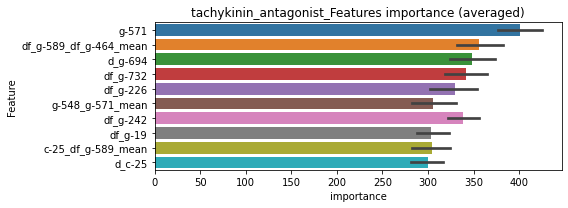

len(train_index) : 2811
len(valid_index) : 938
================================= fold 1/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121106	valid_1's binary_logloss: 0.174774
[200]	training's binary_logloss: 0.04773	valid_1's binary_logloss: 0.0964446
[300]	training's binary_logloss: 0.0202256	valid_1's binary_logloss: 0.0595467
[400]	training's binary_logloss: 0.0093623	valid_1's binary_logloss: 0.0418915
[500]	training's binary_logloss: 0.00482128	valid_1's binary_logloss: 0.0332095
[600]	training's binary_logloss: 0.00285661	valid_1's binary_logloss: 0.0288626
[700]	training's binary_logloss: 0.00191255	valid_1's binary_logloss: 0.0262234
[800]	training's binary_logloss: 0.00142	valid_1's binary_logloss: 0.0247418
[900]	training's binary_logloss: 0.00112948	valid_1's binary_logloss: 0.0233601
Early stopping, best iteration is:
[929]	training's binary_logloss: 0.00106936	valid_1's binary_logloss: 0.0231601


len(train_index) : 2812
len(valid_index) : 937
================================= fold 2/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121354	valid_1's binary_logloss: 0.168391
[200]	training's binary_logloss: 0.0471808	valid_1's binary_logloss: 0.0967705
[300]	training's binary_logloss: 0.0201829	valid_1's binary_logloss: 0.0638706
[400]	training's binary_logloss: 0.00921972	valid_1's binary_logloss: 0.0452051
[500]	training's binary_logloss: 0.00481192	valid_1's binary_logloss: 0.0362176
[600]	training's binary_logloss: 0.00289224	valid_1's binary_logloss: 0.0317879
[700]	training's binary_logloss: 0.0019448	valid_1's binary_logloss: 0.028561
[800]	training's binary_logloss: 0.00143514	valid_1's binary_logloss: 0.0261753
[900]	training's binary_logloss: 0.00114802	valid_1's binary_logloss: 0.0255485
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.00113636	valid_1's binary_logloss: 0.025508


len(train_index) : 2812
len(valid_index) : 937
================================= fold 3/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.123894	valid_1's binary_logloss: 0.173906
[200]	training's binary_logloss: 0.0493724	valid_1's binary_logloss: 0.0997045
[300]	training's binary_logloss: 0.0211487	valid_1's binary_logloss: 0.0635083
[400]	training's binary_logloss: 0.00981833	valid_1's binary_logloss: 0.0441473
[500]	training's binary_logloss: 0.00499885	valid_1's binary_logloss: 0.0349027
[600]	training's binary_logloss: 0.00294045	valid_1's binary_logloss: 0.0304341
[700]	training's binary_logloss: 0.00197303	valid_1's binary_logloss: 0.0277315
[800]	training's binary_logloss: 0.00146513	valid_1's binary_logloss: 0.0259064
[900]	training's binary_logloss: 0.00116427	valid_1's binary_logloss: 0.0246524
[1000]	training's binary_logloss: 0.000986522	valid_1's binary_logloss: 0.0237932
[1100]	training's binary_logloss: 0.000885328	valid_1's binary_logloss: 0.0234214
[1200]	training's binary_logloss: 0.000821406	valid_1's bina

len(train_index) : 2812
len(valid_index) : 937
================================= fold 4/4 tachykinin_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.120504	valid_1's binary_logloss: 0.174331
[200]	training's binary_logloss: 0.0467893	valid_1's binary_logloss: 0.0985645
[300]	training's binary_logloss: 0.0198591	valid_1's binary_logloss: 0.0656481
[400]	training's binary_logloss: 0.00917273	valid_1's binary_logloss: 0.0498345
[500]	training's binary_logloss: 0.00481617	valid_1's binary_logloss: 0.0415324
[600]	training's binary_logloss: 0.0028482	valid_1's binary_logloss: 0.0375311
[700]	training's binary_logloss: 0.00191084	valid_1's binary_logloss: 0.0353746
[800]	training's binary_logloss: 0.00141883	valid_1's binary_logloss: 0.0343962
[900]	training's binary_logloss: 0.00113474	valid_1's binary_logloss: 0.0332078
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.00103042	valid_1's binary_logloss: 0.0325714


tachykinin_antagonist logloss: 0.026052998607666335


neg labels: 3289 → selected neg labels: 3285


tgf-beta_receptor_inhibitor, len(trt): 30, len(othr): 3285, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101621	valid_1's binary_logloss: 0.137493
[200]	training's binary_logloss: 0.0374714	valid_1's binary_logloss: 0.0669036
[300]	training's binary_logloss: 0.0145565	valid_1's binary_logloss: 0.0375029
[400]	training's binary_logloss: 0.00603456	valid_1's binary_logloss: 0.0240984
[500]	training's binary_logloss: 0.00301903	valid_1's binary_logloss: 0.0182814
[600]	training's binary_logloss: 0.00182585	valid_1's binary_logloss: 0.0155083
[700]	training's binary_logloss: 0.0012722	valid_1's binary_logloss: 0.0138283
[800]	training's binary_logloss: 0.000979086	valid_1's binary_logloss: 0.0130987
[900]	training's binary_logloss: 0.000808687	valid_1's binary_logloss: 0.0125324
[1000]	training's binary_logloss: 0.000706731	valid_1's binary_logloss: 0.0122558
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000680497	valid_1's binary_logloss: 0.012238
Training until validation

1 / 3 AUC score:1.000
y_Threshold: 0.0130333, Threshold: 0.0804557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3810
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.05632, conf_1:0.10459
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0804557
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.1304557
Num_p_label: 15.0, Expected: 5.0, Adj_threshold_3: 0.1804557
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_4: 0.2304557
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.2804557
threshold: 0.2804557, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3810, y_label_rate: 0.1724409
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101917	valid_1's binary_logloss: 0.134347
[200]	training's binary_logloss: 0.0350802	valid_1's binary_logloss: 0.0601536
[300]	training's binary_logloss: 0.0129216	valid_1's binary_logloss: 0.0313728
[400]	training's binary_logloss: 0.00533123	valid_1's binary_logloss: 0.0194795
[500]	training's binary_logloss: 0.00266932	valid_1's binary_logloss: 0.0144815
[600]	training's binary_logloss: 0.00162447	valid_1's binary_logloss: 0.0120235
[700]	training's binary_logloss: 0.00113587	valid_1's binary_logloss: 0.0108667
[800]	training's binary_logloss: 0.000878294	valid_1's binary_logloss: 0.0101977
[900]	training's binary_logloss: 0.000731452	valid_1's binary_logloss: 0.00976057
[1000]	training's binary_logloss: 0.00065244	valid_1's binary_logloss: 0.00953552
Early stopping, best iteration is:
[1013]	training's binary_logloss: 0.000645417	valid_1's binary_logloss: 0.00949717
Training until valida

2 / 3 AUC score:1.000
y_Threshold: 0.1356017, Threshold: 0.2804557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0095429 Vs.target_rate: 0.00126, Num_p_label: 38.0, conf_0:0.22436, conf_1:0.33655
Num_p_label: 38.0, Expected: 5.0, Adj_threshold_1: 0.2804557
Num_p_label: 32.0, Expected: 5.0, Adj_threshold_2: 0.3304557
Num_p_label: 29.0, Expected: 5.0, Adj_threshold_3: 0.3804557
Num_p_label: 28.0, Expected: 5.0, Adj_threshold_4: 0.4304557
Num_p_label: 22.0, Expected: 5.0, Adj_threshold_5: 0.4804557
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_6: 0.5304557
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_7: 0.5804557
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_8: 0.6304557
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_9: 0.6804557
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_10: 0.7304557
threshold: 0.7304557, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
==========

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0985263	valid_1's binary_logloss: 0.123738
[200]	training's binary_logloss: 0.0342623	valid_1's binary_logloss: 0.0544041
[300]	training's binary_logloss: 0.0127175	valid_1's binary_logloss: 0.0267105
[400]	training's binary_logloss: 0.00521914	valid_1's binary_logloss: 0.0146008
[500]	training's binary_logloss: 0.00261335	valid_1's binary_logloss: 0.00936362
[600]	training's binary_logloss: 0.00159446	valid_1's binary_logloss: 0.00715867
[700]	training's binary_logloss: 0.00111941	valid_1's binary_logloss: 0.00583264
[800]	training's binary_logloss: 0.000871219	valid_1's binary_logloss: 0.00512699
[900]	training's binary_logloss: 0.000718074	valid_1's binary_logloss: 0.00468378
[1000]	training's binary_logloss: 0.000637923	valid_1's binary_logloss: 0.00450255
Early stopping, best iteration is:
[1056]	training's binary_logloss: 0.000620465	valid_1's binary_logloss: 0.00443776
Training until 

3 / 3 AUC score:1.000
y_Threshold: 0.1704550, Threshold: 0.7304557, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 650.0/3796
p_label_rate: 0.0035158 Vs.target_rate: 0.00126, Num_p_label: 14.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_1: 0.7304557
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.7804557
threshold: 0.7804557, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 650.0/3796, y_label_rate: 0.1712329


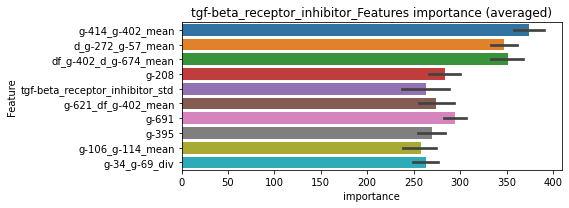

len(train_index) : 2847
len(valid_index) : 949
================================= fold 1/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.100557	valid_1's binary_logloss: 0.13919
[200]	training's binary_logloss: 0.033565	valid_1's binary_logloss: 0.0630285
[300]	training's binary_logloss: 0.0123621	valid_1's binary_logloss: 0.0316246
[400]	training's binary_logloss: 0.00520807	valid_1's binary_logloss: 0.0193204
[500]	training's binary_logloss: 0.00260197	valid_1's binary_logloss: 0.0136075
[600]	training's binary_logloss: 0.00158165	valid_1's binary_logloss: 0.0108358
[700]	training's binary_logloss: 0.00110291	valid_1's binary_logloss: 0.00922719
[800]	training's binary_logloss: 0.000863663	valid_1's binary_logloss: 0.00858122
[900]	training's binary_logloss: 0.0007162	valid_1's binary_logloss: 0.00819622
[1000]	training's binary_logloss: 0.000655906	valid_1's binary_logloss: 0.00797331
[1100]	training's binary_logloss: 0.000637698	valid_1's binary_logloss: 0.00792076
Early stopping, best iteration is:
[1072]	training's bina

len(train_index) : 2847
len(valid_index) : 949
================================= fold 2/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0964256	valid_1's binary_logloss: 0.142842
[200]	training's binary_logloss: 0.0319637	valid_1's binary_logloss: 0.0696436
[300]	training's binary_logloss: 0.0119228	valid_1's binary_logloss: 0.038326
[400]	training's binary_logloss: 0.00479871	valid_1's binary_logloss: 0.0237724
[500]	training's binary_logloss: 0.0024491	valid_1's binary_logloss: 0.0174931
[600]	training's binary_logloss: 0.00149135	valid_1's binary_logloss: 0.0141145
[700]	training's binary_logloss: 0.00105842	valid_1's binary_logloss: 0.0122187
[800]	training's binary_logloss: 0.000828625	valid_1's binary_logloss: 0.0112497
[900]	training's binary_logloss: 0.000687948	valid_1's binary_logloss: 0.0104311
[1000]	training's binary_logloss: 0.000622084	valid_1's binary_logloss: 0.0101193
[1100]	training's binary_logloss: 0.000593338	valid_1's binary_logloss: 0.0100008
Early stopping, best iteration is:
[1075]	training's binary

len(train_index) : 2847
len(valid_index) : 949
================================= fold 3/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0995266	valid_1's binary_logloss: 0.133725
[200]	training's binary_logloss: 0.0338991	valid_1's binary_logloss: 0.0612286
[300]	training's binary_logloss: 0.0124598	valid_1's binary_logloss: 0.0327717
[400]	training's binary_logloss: 0.00515871	valid_1's binary_logloss: 0.0210735
[500]	training's binary_logloss: 0.00260118	valid_1's binary_logloss: 0.0154789
[600]	training's binary_logloss: 0.00158299	valid_1's binary_logloss: 0.013394
[700]	training's binary_logloss: 0.00110187	valid_1's binary_logloss: 0.0117137
[800]	training's binary_logloss: 0.00085247	valid_1's binary_logloss: 0.0110963
[900]	training's binary_logloss: 0.000710797	valid_1's binary_logloss: 0.0106164
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000716191	valid_1's binary_logloss: 0.0105708


len(train_index) : 2847
len(valid_index) : 949
================================= fold 4/4 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.094559	valid_1's binary_logloss: 0.132591
[200]	training's binary_logloss: 0.0317863	valid_1's binary_logloss: 0.0591312
[300]	training's binary_logloss: 0.011687	valid_1's binary_logloss: 0.0320953
[400]	training's binary_logloss: 0.0048937	valid_1's binary_logloss: 0.0200371
[500]	training's binary_logloss: 0.00248088	valid_1's binary_logloss: 0.0150005
[600]	training's binary_logloss: 0.0015421	valid_1's binary_logloss: 0.0130964
[700]	training's binary_logloss: 0.00108402	valid_1's binary_logloss: 0.0115577
[800]	training's binary_logloss: 0.000841467	valid_1's binary_logloss: 0.0105751
[900]	training's binary_logloss: 0.000697502	valid_1's binary_logloss: 0.0101032
Early stopping, best iteration is:
[965]	training's binary_logloss: 0.00064817	valid_1's binary_logloss: 0.00990375


tgf-beta_receptor_inhibitor logloss: 0.00960560419367018


neg labels: 3289 → selected neg labels: 3286


thrombin_inhibitor, len(trt): 19, len(othr): 3286, target_rate: 0.0007979 → Adj_target_rate: 0.0010260
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855143	valid_1's binary_logloss: 0.105015
[200]	training's binary_logloss: 0.026767	valid_1's binary_logloss: 0.0420677
[300]	training's binary_logloss: 0.00894161	valid_1's binary_logloss: 0.0192464
[400]	training's binary_logloss: 0.00356195	valid_1's binary_logloss: 0.010628
[500]	training's binary_logloss: 0.00178367	valid_1's binary_logloss: 0.0068474
[600]	training's binary_logloss: 0.00110733	valid_1's binary_logloss: 0.00516662
[700]	training's binary_logloss: 0.000796522	valid_1's binary_logloss: 0.00439678
[800]	training's binary_logloss: 0.000626897	valid_1's binary_logloss: 0.0039372
[900]	training's binary_logloss: 0.000547744	valid_1's binary_logloss: 0.00368282
Early stopping, best iteration is:
[944]	training's binary_logloss: 0.000524276	valid_1's binary_logloss: 0.00361085
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.08706

1 / 3 AUC score:1.000
y_Threshold: 0.0069651, Threshold: 0.0246025, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3811
p_label_rate: 0.0100452 Vs.target_rate: 0.00080, Num_p_label: 40.0, conf_0:0.01722, conf_1:0.03198
Num_p_label: 40.0, Expected: 3.2, Adj_threshold_1: 0.0246025
Num_p_label: 17.0, Expected: 3.2, Adj_threshold_2: 0.0746025
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_3: 0.1246025
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_4: 0.1746025
threshold: 0.1746025, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3811, y_label_rate: 0.1723957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0811117	valid_1's binary_logloss: 0.101791
[200]	training's binary_logloss: 0.022731	valid_1's binary_logloss: 0.0360422
[300]	training's binary_logloss: 0.00716323	valid_1's binary_logloss: 0.0147685
[400]	training's binary_logloss: 0.00287125	valid_1's binary_logloss: 0.00757906
[500]	training's binary_logloss: 0.00150167	valid_1's binary_logloss: 0.00479946
[600]	training's binary_logloss: 0.000948988	valid_1's binary_logloss: 0.00348052
[700]	training's binary_logloss: 0.000693642	valid_1's binary_logloss: 0.00281727
[800]	training's binary_logloss: 0.000547328	valid_1's binary_logloss: 0.00238026
[900]	training's binary_logloss: 0.000487367	valid_1's binary_logloss: 0.00221195
[1000]	training's binary_logloss: 0.000464598	valid_1's binary_logloss: 0.00215074
Early stopping, best iteration is:
[1004]	training's binary_logloss: 0.000464508	valid_1's binary_logloss: 0.00215041
Training unt

2 / 3 AUC score:1.000
y_Threshold: 0.1383776, Threshold: 0.1746025, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0035158 Vs.target_rate: 0.00080, Num_p_label: 14.0, conf_0:0.13968, conf_1:0.20952
Num_p_label: 14.0, Expected: 3.2, Adj_threshold_1: 0.1746025
Num_p_label: 11.0, Expected: 3.2, Adj_threshold_2: 0.2246025
Num_p_label: 10.0, Expected: 3.2, Adj_threshold_3: 0.2746025
Num_p_label: 9.0, Expected: 3.2, Adj_threshold_4: 0.3246025
Num_p_label: 8.0, Expected: 3.2, Adj_threshold_5: 0.3746025
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_6: 0.4246025
threshold: 0.4246025, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0812406	valid_1's binary_logloss: 0.105522
[200]	training's binary_logloss: 0.0221753	valid_1's binary_logloss: 0.0376521
[300]	training's binary_logloss: 0.00695068	valid_1's binary_logloss: 0.016258
[400]	training's binary_logloss: 0.00280159	valid_1's binary_logloss: 0.00891345
[500]	training's binary_logloss: 0.00145865	valid_1's binary_logloss: 0.00608986
[600]	training's binary_logloss: 0.000930268	valid_1's binary_logloss: 0.00465666
[700]	training's binary_logloss: 0.000681329	valid_1's binary_logloss: 0.0039715
[800]	training's binary_logloss: 0.000544382	valid_1's binary_logloss: 0.00350069
[900]	training's binary_logloss: 0.000479643	valid_1's binary_logloss: 0.00328333
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000474291	valid_1's binary_logloss: 0.00326307
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0

3 / 3 AUC score:1.000
y_Threshold: 0.0717771, Threshold: 0.4246025, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3809
p_label_rate: 0.0017579 Vs.target_rate: 0.00080, Num_p_label: 7.0, conf_0:0.38214, conf_1:0.46706
Num_p_label: 7.0, Expected: 3.2, Adj_threshold_1: 0.4246025
threshold: 0.4246025, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237


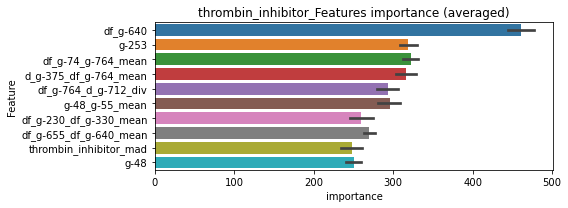

len(train_index) : 2856
len(valid_index) : 953
================================= fold 1/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0808623	valid_1's binary_logloss: 0.103643
[200]	training's binary_logloss: 0.0224237	valid_1's binary_logloss: 0.0371395
[300]	training's binary_logloss: 0.00702872	valid_1's binary_logloss: 0.0158248
[400]	training's binary_logloss: 0.00279733	valid_1's binary_logloss: 0.00863899
[500]	training's binary_logloss: 0.0014558	valid_1's binary_logloss: 0.00572343
[600]	training's binary_logloss: 0.00092984	valid_1's binary_logloss: 0.00441814
[700]	training's binary_logloss: 0.000678121	valid_1's binary_logloss: 0.00370523
[800]	training's binary_logloss: 0.00054616	valid_1's binary_logloss: 0.00335225
[900]	training's binary_logloss: 0.000475851	valid_1's binary_logloss: 0.00308382
Early stopping, best iteration is:
[960]	training's binary_logloss: 0.000462318	valid_1's binary_logloss: 0.00304559


len(train_index) : 2857
len(valid_index) : 952
================================= fold 2/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0822239	valid_1's binary_logloss: 0.106982
[200]	training's binary_logloss: 0.0230146	valid_1's binary_logloss: 0.0392135
[300]	training's binary_logloss: 0.00718104	valid_1's binary_logloss: 0.0173847
[400]	training's binary_logloss: 0.00283068	valid_1's binary_logloss: 0.00980308
[500]	training's binary_logloss: 0.00147333	valid_1's binary_logloss: 0.00703259
[600]	training's binary_logloss: 0.000931934	valid_1's binary_logloss: 0.00574271
[700]	training's binary_logloss: 0.000676187	valid_1's binary_logloss: 0.00488973
[800]	training's binary_logloss: 0.000537462	valid_1's binary_logloss: 0.00447546
[900]	training's binary_logloss: 0.000472706	valid_1's binary_logloss: 0.00422051
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000467848	valid_1's binary_logloss: 0.00421182


len(train_index) : 2857
len(valid_index) : 952
================================= fold 3/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0809865	valid_1's binary_logloss: 0.101359
[200]	training's binary_logloss: 0.0227278	valid_1's binary_logloss: 0.0356441
[300]	training's binary_logloss: 0.00719693	valid_1's binary_logloss: 0.0151382
[400]	training's binary_logloss: 0.00290866	valid_1's binary_logloss: 0.00812188
[500]	training's binary_logloss: 0.00149809	valid_1's binary_logloss: 0.00534593
[600]	training's binary_logloss: 0.000951054	valid_1's binary_logloss: 0.00407338
[700]	training's binary_logloss: 0.000685742	valid_1's binary_logloss: 0.0034029
[800]	training's binary_logloss: 0.00054436	valid_1's binary_logloss: 0.00294296
[900]	training's binary_logloss: 0.000477903	valid_1's binary_logloss: 0.00274377
Early stopping, best iteration is:
[918]	training's binary_logloss: 0.000473183	valid_1's binary_logloss: 0.0027251


len(train_index) : 2857
len(valid_index) : 952
================================= fold 4/4 thrombin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.081306	valid_1's binary_logloss: 0.100009
[200]	training's binary_logloss: 0.0229453	valid_1's binary_logloss: 0.0360737
[300]	training's binary_logloss: 0.00730858	valid_1's binary_logloss: 0.0163966
[400]	training's binary_logloss: 0.00301645	valid_1's binary_logloss: 0.00970525
[500]	training's binary_logloss: 0.00152558	valid_1's binary_logloss: 0.00677433
[600]	training's binary_logloss: 0.000951025	valid_1's binary_logloss: 0.00562618
[700]	training's binary_logloss: 0.000687838	valid_1's binary_logloss: 0.00487784
[800]	training's binary_logloss: 0.00054995	valid_1's binary_logloss: 0.00454511
[900]	training's binary_logloss: 0.000477207	valid_1's binary_logloss: 0.00439478
Early stopping, best iteration is:
[955]	training's binary_logloss: 0.000461392	valid_1's binary_logloss: 0.00433523


thrombin_inhibitor logloss: 0.0035804224094486826


neg labels: 3289 → selected neg labels: 3282


thymidylate_synthase_inhibitor, len(trt): 37, len(othr): 3282, target_rate: 0.0015537 → Adj_target_rate: 0.0018079
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.11344	valid_1's binary_logloss: 0.162224
[200]	training's binary_logloss: 0.044086	valid_1's binary_logloss: 0.0889745
[300]	training's binary_logloss: 0.0181714	valid_1's binary_logloss: 0.0553818
[400]	training's binary_logloss: 0.00788933	valid_1's binary_logloss: 0.0373138
[500]	training's binary_logloss: 0.00383329	valid_1's binary_logloss: 0.0283663
[600]	training's binary_logloss: 0.00222831	valid_1's binary_logloss: 0.0243175
[700]	training's binary_logloss: 0.00148937	valid_1's binary_logloss: 0.0219908
[800]	training's binary_logloss: 0.00112041	valid_1's binary_logloss: 0.0206873
[900]	training's binary_logloss: 0.000904553	valid_1's binary_logloss: 0.0199346
[1000]	training's binary_logloss: 0.00078879	valid_1's binary_logloss: 0.0196501
Early stopping, best iteration is:
[1029]	training's binary_logloss: 0.000765466	valid_1's binary_logloss: 0.019486
Training until validation sc

1 / 3 AUC score:1.000
y_Threshold: 0.0121110, Threshold: 0.0748991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 655/3804
p_label_rate: 0.0100452 Vs.target_rate: 0.00155, Num_p_label: 40.0, conf_0:0.05243, conf_1:0.09737
Num_p_label: 40.0, Expected: 6.2, Adj_threshold_1: 0.0748991
Num_p_label: 26.0, Expected: 6.2, Adj_threshold_2: 0.1248991
Num_p_label: 21.0, Expected: 6.2, Adj_threshold_3: 0.1748991
Num_p_label: 16.0, Expected: 6.2, Adj_threshold_4: 0.2248991
Num_p_label: 11.0, Expected: 6.2, Adj_threshold_5: 0.2748991
threshold: 0.2748991, positive_p_label: 11.0/3982, p_label_rate: 0.0027624
positive_y_label: 655.0/3804, y_label_rate: 0.1721872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109621	valid_1's binary_logloss: 0.14542
[200]	training's binary_logloss: 0.0404076	valid_1's binary_logloss: 0.0701571
[300]	training's binary_logloss: 0.0161934	valid_1's binary_logloss: 0.0373754
[400]	training's binary_logloss: 0.00700416	valid_1's binary_logloss: 0.0222475
[500]	training's binary_logloss: 0.0034623	valid_1's binary_logloss: 0.0147597
[600]	training's binary_logloss: 0.00203567	valid_1's binary_logloss: 0.0111252
[700]	training's binary_logloss: 0.00136773	valid_1's binary_logloss: 0.00913077
[800]	training's binary_logloss: 0.00103214	valid_1's binary_logloss: 0.00796917
[900]	training's binary_logloss: 0.000842675	valid_1's binary_logloss: 0.00733988
[1000]	training's binary_logloss: 0.000752006	valid_1's binary_logloss: 0.00692553
[1100]	training's binary_logloss: 0.000710897	valid_1's binary_logloss: 0.00676075
Early stopping, best iteration is:
[1084]	training's bin

2 / 3 AUC score:1.000
y_Threshold: 0.1199604, Threshold: 0.2748991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 10 → Positive_corect_labels: 650.0/3794
p_label_rate: 0.0102963 Vs.target_rate: 0.00155, Num_p_label: 41.0, conf_0:0.21992, conf_1:0.32988
Num_p_label: 41.0, Expected: 6.2, Adj_threshold_1: 0.2748991
Num_p_label: 33.0, Expected: 6.2, Adj_threshold_2: 0.3248991
Num_p_label: 27.0, Expected: 6.2, Adj_threshold_3: 0.3748991
Num_p_label: 22.0, Expected: 6.2, Adj_threshold_4: 0.4248991
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_5: 0.4748991
Num_p_label: 19.0, Expected: 6.2, Adj_threshold_6: 0.5248991
Num_p_label: 18.0, Expected: 6.2, Adj_threshold_7: 0.5748991
Num_p_label: 15.0, Expected: 6.2, Adj_threshold_8: 0.6248991
threshold: 0.6248991, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 650.0/3794, y_label_rate: 0.1713231
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106358	valid_1's binary_logloss: 0.163544
[200]	training's binary_logloss: 0.0377424	valid_1's binary_logloss: 0.0870881
[300]	training's binary_logloss: 0.0145901	valid_1's binary_logloss: 0.051995
[400]	training's binary_logloss: 0.00624831	valid_1's binary_logloss: 0.0349602
[500]	training's binary_logloss: 0.0031396	valid_1's binary_logloss: 0.0255084
[600]	training's binary_logloss: 0.00187577	valid_1's binary_logloss: 0.0209569
[700]	training's binary_logloss: 0.00128445	valid_1's binary_logloss: 0.0182861
[800]	training's binary_logloss: 0.000976562	valid_1's binary_logloss: 0.0169282
[900]	training's binary_logloss: 0.000799471	valid_1's binary_logloss: 0.0163636
[1000]	training's binary_logloss: 0.000717733	valid_1's binary_logloss: 0.0159599
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.000688347	valid_1's binary_logloss: 0.0157958
Training until validation

3 / 3 AUC score:1.000
y_Threshold: 0.1305879, Threshold: 0.6248991, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 649.0/3792
p_label_rate: 0.0042692 Vs.target_rate: 0.00155, Num_p_label: 17.0, conf_0:0.50000, conf_1:0.68739
Num_p_label: 17.0, Expected: 6.2, Adj_threshold_1: 0.6248991
Num_p_label: 13.0, Expected: 6.2, Adj_threshold_2: 0.6748991
threshold: 0.6748991, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 649.0/3792, y_label_rate: 0.1711498


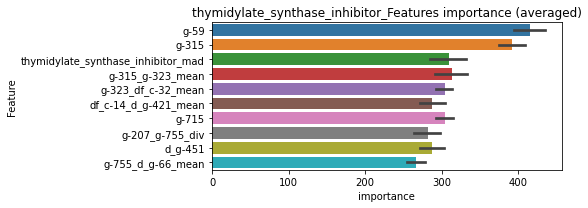

len(train_index) : 2844
len(valid_index) : 948
================================= fold 1/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106232	valid_1's binary_logloss: 0.157363
[200]	training's binary_logloss: 0.0379604	valid_1's binary_logloss: 0.0779218
[300]	training's binary_logloss: 0.0144022	valid_1's binary_logloss: 0.0427651
[400]	training's binary_logloss: 0.00617824	valid_1's binary_logloss: 0.0268481
[500]	training's binary_logloss: 0.00308355	valid_1's binary_logloss: 0.0189406
[600]	training's binary_logloss: 0.00185549	valid_1's binary_logloss: 0.015383
[700]	training's binary_logloss: 0.00126757	valid_1's binary_logloss: 0.0132171
[800]	training's binary_logloss: 0.000960606	valid_1's binary_logloss: 0.0118463
[900]	training's binary_logloss: 0.000789046	valid_1's binary_logloss: 0.0111702
[1000]	training's binary_logloss: 0.00069796	valid_1's binary_logloss: 0.0108839
[1100]	training's binary_logloss: 0.000657474	valid_1's binary_logloss: 0.0107772
Early stopping, best iteration is:
[1086]	training's binary_

len(train_index) : 2844
len(valid_index) : 948
================================= fold 2/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106005	valid_1's binary_logloss: 0.145111
[200]	training's binary_logloss: 0.0375337	valid_1's binary_logloss: 0.0700108
[300]	training's binary_logloss: 0.0152071	valid_1's binary_logloss: 0.0389548
[400]	training's binary_logloss: 0.00665301	valid_1's binary_logloss: 0.0236991
[500]	training's binary_logloss: 0.00328311	valid_1's binary_logloss: 0.0160996
[600]	training's binary_logloss: 0.00195538	valid_1's binary_logloss: 0.0124282
[700]	training's binary_logloss: 0.00132822	valid_1's binary_logloss: 0.0100194
[800]	training's binary_logloss: 0.00100472	valid_1's binary_logloss: 0.00881896
[900]	training's binary_logloss: 0.000819835	valid_1's binary_logloss: 0.00799932
[1000]	training's binary_logloss: 0.000720104	valid_1's binary_logloss: 0.00764191
[1100]	training's binary_logloss: 0.000682242	valid_1's binary_logloss: 0.0075134
Early stopping, best iteration is:
[1169]	training's bin

len(train_index) : 2844
len(valid_index) : 948
================================= fold 3/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.113675	valid_1's binary_logloss: 0.150796
[200]	training's binary_logloss: 0.0409064	valid_1's binary_logloss: 0.075121
[300]	training's binary_logloss: 0.0158408	valid_1's binary_logloss: 0.0412237
[400]	training's binary_logloss: 0.00687403	valid_1's binary_logloss: 0.0251134
[500]	training's binary_logloss: 0.00336066	valid_1's binary_logloss: 0.0173573
[600]	training's binary_logloss: 0.00197362	valid_1's binary_logloss: 0.0130022
[700]	training's binary_logloss: 0.00133243	valid_1's binary_logloss: 0.0104439
[800]	training's binary_logloss: 0.00100183	valid_1's binary_logloss: 0.00925172
[900]	training's binary_logloss: 0.000807391	valid_1's binary_logloss: 0.00847009
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000814847	valid_1's binary_logloss: 0.0084375


len(train_index) : 2844
len(valid_index) : 948
================================= fold 4/4 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108857	valid_1's binary_logloss: 0.141099
[200]	training's binary_logloss: 0.0396297	valid_1's binary_logloss: 0.0688475
[300]	training's binary_logloss: 0.0162209	valid_1's binary_logloss: 0.0375283
[400]	training's binary_logloss: 0.00688576	valid_1's binary_logloss: 0.0221924
[500]	training's binary_logloss: 0.00336403	valid_1's binary_logloss: 0.0145621
[600]	training's binary_logloss: 0.00194351	valid_1's binary_logloss: 0.0107826
[700]	training's binary_logloss: 0.00133125	valid_1's binary_logloss: 0.00886753
[800]	training's binary_logloss: 0.00100236	valid_1's binary_logloss: 0.00778812
[900]	training's binary_logloss: 0.000821207	valid_1's binary_logloss: 0.00723699
[1000]	training's binary_logloss: 0.000717911	valid_1's binary_logloss: 0.00690618
[1100]	training's binary_logloss: 0.000686459	valid_1's binary_logloss: 0.00681108
[1200]	training's binary_logloss: 0.000669349	valid_1'

thymidylate_synthase_inhibitor logloss: 0.008352758998766583


neg labels: 3289 → selected neg labels: 3282


tlr_agonist, len(trt): 30, len(othr): 3282, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0951816	valid_1's binary_logloss: 0.122599
[200]	training's binary_logloss: 0.0323316	valid_1's binary_logloss: 0.0550855
[300]	training's binary_logloss: 0.0122859	valid_1's binary_logloss: 0.0304608
[400]	training's binary_logloss: 0.0052688	valid_1's binary_logloss: 0.0197319
[500]	training's binary_logloss: 0.00261419	valid_1's binary_logloss: 0.0142661
[600]	training's binary_logloss: 0.00156147	valid_1's binary_logloss: 0.0114988
[700]	training's binary_logloss: 0.00107766	valid_1's binary_logloss: 0.0101021
[800]	training's binary_logloss: 0.000825748	valid_1's binary_logloss: 0.00918299
[900]	training's binary_logloss: 0.000687129	valid_1's binary_logloss: 0.00889688
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000698985	valid_1's binary_logloss: 0.00885679
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0931814

1 / 3 AUC score:1.000
y_Threshold: 0.0101853, Threshold: 0.0613371, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3806
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.04294, conf_1:0.07974
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0613371
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_2: 0.1113371
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_3: 0.1613371
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.2113371
threshold: 0.2113371, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 656.0/3806, y_label_rate: 0.1723594
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09444	valid_1's binary_logloss: 0.118574
[200]	training's binary_logloss: 0.030431	valid_1's binary_logloss: 0.0500024
[300]	training's binary_logloss: 0.0111659	valid_1's binary_logloss: 0.0263065
[400]	training's binary_logloss: 0.00462836	valid_1's binary_logloss: 0.0161695
[500]	training's binary_logloss: 0.00227689	valid_1's binary_logloss: 0.011447
[600]	training's binary_logloss: 0.00135891	valid_1's binary_logloss: 0.00906005
[700]	training's binary_logloss: 0.000945562	valid_1's binary_logloss: 0.00798029
[800]	training's binary_logloss: 0.000729322	valid_1's binary_logloss: 0.00723551
[900]	training's binary_logloss: 0.000607022	valid_1's binary_logloss: 0.00681254
Early stopping, best iteration is:
[930]	training's binary_logloss: 0.000583445	valid_1's binary_logloss: 0.00676499
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0925129

2 / 3 AUC score:1.000
y_Threshold: 0.0682084, Threshold: 0.2113371, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 654.0/3802
p_label_rate: 0.0085384 Vs.target_rate: 0.00126, Num_p_label: 34.0, conf_0:0.16907, conf_1:0.25360
Num_p_label: 34.0, Expected: 5.0, Adj_threshold_1: 0.2113371
Num_p_label: 26.0, Expected: 5.0, Adj_threshold_2: 0.2613371
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_3: 0.3113371
Num_p_label: 21.0, Expected: 5.0, Adj_threshold_4: 0.3613371
Num_p_label: 19.0, Expected: 5.0, Adj_threshold_5: 0.4113371
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_6: 0.4613371
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_7: 0.5113371
threshold: 0.5113371, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3802, y_label_rate: 0.1720147
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0919334	valid_1's binary_logloss: 0.113599
[200]	training's binary_logloss: 0.0291641	valid_1's binary_logloss: 0.0474297
[300]	training's binary_logloss: 0.0106074	valid_1's binary_logloss: 0.0241515
[400]	training's binary_logloss: 0.00429639	valid_1's binary_logloss: 0.0139404
[500]	training's binary_logloss: 0.00212914	valid_1's binary_logloss: 0.00924108
[600]	training's binary_logloss: 0.00129228	valid_1's binary_logloss: 0.0069381
[700]	training's binary_logloss: 0.00090785	valid_1's binary_logloss: 0.00591317
[800]	training's binary_logloss: 0.00070455	valid_1's binary_logloss: 0.00509544
[900]	training's binary_logloss: 0.000587706	valid_1's binary_logloss: 0.00461423
Early stopping, best iteration is:
[953]	training's binary_logloss: 0.000553246	valid_1's binary_logloss: 0.00452447
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.09186

3 / 3 AUC score:1.000
y_Threshold: 0.0683937, Threshold: 0.5113371, pos_neg_ratio: 0.8000000
Remove_noisy_data: 4 → Positive_corect_labels: 652.0/3798
p_label_rate: 0.0032647 Vs.target_rate: 0.00126, Num_p_label: 13.0, conf_0:0.46020, conf_1:0.56247
Num_p_label: 13.0, Expected: 5.0, Adj_threshold_1: 0.5113371
Num_p_label: 9.0, Expected: 5.0, Adj_threshold_2: 0.5613371
threshold: 0.5613371, positive_p_label: 9.0/3982, p_label_rate: 0.0022602
positive_y_label: 652.0/3798, y_label_rate: 0.1716693


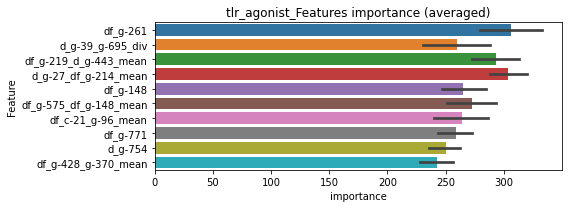

len(train_index) : 2848
len(valid_index) : 950
================================= fold 1/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918681	valid_1's binary_logloss: 0.123064
[200]	training's binary_logloss: 0.0278575	valid_1's binary_logloss: 0.0499579
[300]	training's binary_logloss: 0.0099507	valid_1's binary_logloss: 0.0239717
[400]	training's binary_logloss: 0.0040777	valid_1's binary_logloss: 0.014073
[500]	training's binary_logloss: 0.00206958	valid_1's binary_logloss: 0.00916609
[600]	training's binary_logloss: 0.0012718	valid_1's binary_logloss: 0.00684048
[700]	training's binary_logloss: 0.000886385	valid_1's binary_logloss: 0.00549194
[800]	training's binary_logloss: 0.000689698	valid_1's binary_logloss: 0.0047292
[900]	training's binary_logloss: 0.000579946	valid_1's binary_logloss: 0.00436892
[1000]	training's binary_logloss: 0.000539449	valid_1's binary_logloss: 0.00423311
[1100]	training's binary_logloss: 0.000529016	valid_1's binary_logloss: 0.00417707
Early stopping, best iteration is:
[1095]	training's 

len(train_index) : 2848
len(valid_index) : 950
================================= fold 2/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0918904	valid_1's binary_logloss: 0.105574
[200]	training's binary_logloss: 0.0283051	valid_1's binary_logloss: 0.0413674
[300]	training's binary_logloss: 0.0103395	valid_1's binary_logloss: 0.0210794
[400]	training's binary_logloss: 0.00419242	valid_1's binary_logloss: 0.0124064
[500]	training's binary_logloss: 0.00210175	valid_1's binary_logloss: 0.00854787
[600]	training's binary_logloss: 0.00128179	valid_1's binary_logloss: 0.00678117
[700]	training's binary_logloss: 0.000901287	valid_1's binary_logloss: 0.00577794
[800]	training's binary_logloss: 0.000701855	valid_1's binary_logloss: 0.00517961
[900]	training's binary_logloss: 0.000590295	valid_1's binary_logloss: 0.00487453
[1000]	training's binary_logloss: 0.000551305	valid_1's binary_logloss: 0.00476621
Early stopping, best iteration is:
[1048]	training's binary_logloss: 0.000539191	valid_1's binary_logloss: 0.00471556


len(train_index) : 2849
len(valid_index) : 949
================================= fold 3/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913267	valid_1's binary_logloss: 0.120689
[200]	training's binary_logloss: 0.0278224	valid_1's binary_logloss: 0.0507954
[300]	training's binary_logloss: 0.0101399	valid_1's binary_logloss: 0.0262954
[400]	training's binary_logloss: 0.00410993	valid_1's binary_logloss: 0.0163922
[500]	training's binary_logloss: 0.00206634	valid_1's binary_logloss: 0.0119276
[600]	training's binary_logloss: 0.00125305	valid_1's binary_logloss: 0.00981151
[700]	training's binary_logloss: 0.000880056	valid_1's binary_logloss: 0.00871883
[800]	training's binary_logloss: 0.000685623	valid_1's binary_logloss: 0.00803506
[900]	training's binary_logloss: 0.000581911	valid_1's binary_logloss: 0.00774582
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000596927	valid_1's binary_logloss: 0.00772496


len(train_index) : 2849
len(valid_index) : 949
================================= fold 4/4 tlr_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0913091	valid_1's binary_logloss: 0.123578
[200]	training's binary_logloss: 0.0284595	valid_1's binary_logloss: 0.0552616
[300]	training's binary_logloss: 0.010264	valid_1's binary_logloss: 0.0300953
[400]	training's binary_logloss: 0.0041639	valid_1's binary_logloss: 0.0191245
[500]	training's binary_logloss: 0.00208154	valid_1's binary_logloss: 0.0145875
[600]	training's binary_logloss: 0.00125531	valid_1's binary_logloss: 0.0123826
[700]	training's binary_logloss: 0.000878191	valid_1's binary_logloss: 0.0111594
[800]	training's binary_logloss: 0.000685087	valid_1's binary_logloss: 0.010783
[900]	training's binary_logloss: 0.000583015	valid_1's binary_logloss: 0.0103691
Early stopping, best iteration is:
[911]	training's binary_logloss: 0.000577105	valid_1's binary_logloss: 0.0103267


tlr_agonist logloss: 0.006742384591448292


neg labels: 3289 → selected neg labels: 3289


tlr_antagonist, len(trt): 7, len(othr): 3289, target_rate: 0.0002939 → Adj_target_rate: 0.0004391
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0508179	valid_1's binary_logloss: 0.0555159
[200]	training's binary_logloss: 0.00955285	valid_1's binary_logloss: 0.0118494
[300]	training's binary_logloss: 0.00233996	valid_1's binary_logloss: 0.00347862
[400]	training's binary_logloss: 0.000869789	valid_1's binary_logloss: 0.00149389
[500]	training's binary_logloss: 0.000475316	valid_1's binary_logloss: 0.00090147
[600]	training's binary_logloss: 0.000330099	valid_1's binary_logloss: 0.000651263
[700]	training's binary_logloss: 0.00026735	valid_1's binary_logloss: 0.000548716
[800]	training's binary_logloss: 0.000253849	valid_1's binary_logloss: 0.000527255
Early stopping, best iteration is:
[828]	training's binary_logloss: 0.000251491	valid_1's binary_logloss: 0.000526186
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0501215	valid_1's binary_logloss: 0.0596822
[200]	training's binary_loglo

1 / 3 AUC score:1.000
y_Threshold: 0.0011691, Threshold: 0.0069182, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00029, Num_p_label: 40.0, conf_0:0.00484, conf_1:0.00899
Num_p_label: 40.0, Expected: 1.2, Adj_threshold_1: 0.0069182
Num_p_label: 8.0, Expected: 1.2, Adj_threshold_2: 0.0569182
Num_p_label: 4.0, Expected: 1.2, Adj_threshold_3: 0.1069182
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_4: 0.1569182
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_5: 0.2069182
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_6: 0.2569182
threshold: 0.2569182, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0494284	valid_1's binary_logloss: 0.0554468
[200]	training's binary_logloss: 0.00853332	valid_1's binary_logloss: 0.011344
[300]	training's binary_logloss: 0.00199196	valid_1's binary_logloss: 0.00313308
[400]	training's binary_logloss: 0.000731236	valid_1's binary_logloss: 0.00128561
[500]	training's binary_logloss: 0.000405118	valid_1's binary_logloss: 0.000765937
[600]	training's binary_logloss: 0.000282072	valid_1's binary_logloss: 0.00055749
[700]	training's binary_logloss: 0.000235605	valid_1's binary_logloss: 0.000481233
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.000227421	valid_1's binary_logloss: 0.000465238
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0493165	valid_1's binary_logloss: 0.0553939
[200]	training's binary_logloss: 0.00850252	valid_1's binary_logloss: 0.0117674
[300]	training's binary_logloss:

2 / 3 AUC score:1.000
y_Threshold: 0.0951222, Threshold: 0.2569182, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0017579 Vs.target_rate: 0.00029, Num_p_label: 7.0, conf_0:0.20553, conf_1:0.30830
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_1: 0.2569182
Num_p_label: 7.0, Expected: 1.2, Adj_threshold_2: 0.3069182
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_3: 0.3569182
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_4: 0.4069182
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_5: 0.4569182
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_6: 0.5069182
Num_p_label: 6.0, Expected: 1.2, Adj_threshold_7: 0.5569182
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_8: 0.6069182
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_9: 0.6569182
Num_p_label: 3.0, Expected: 1.2, Adj_threshold_10: 0.7069182
threshold: 0.7569182, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseu

Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0494284	valid_1's binary_logloss: 0.0554468
[200]	training's binary_logloss: 0.00853332	valid_1's binary_logloss: 0.011344
[300]	training's binary_logloss: 0.00199196	valid_1's binary_logloss: 0.00313308
[400]	training's binary_logloss: 0.000731236	valid_1's binary_logloss: 0.00128561
[500]	training's binary_logloss: 0.000405118	valid_1's binary_logloss: 0.000765937
[600]	training's binary_logloss: 0.000282072	valid_1's binary_logloss: 0.00055749
[700]	training's binary_logloss: 0.000235605	valid_1's binary_logloss: 0.000481233
Early stopping, best iteration is:
[751]	training's binary_logloss: 0.000227421	valid_1's binary_logloss: 0.000465238
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0493165	valid_1's binary_logloss: 0.0553939
[200]	training's binary_logloss: 0.00850252	valid_1's binary_logloss: 0.0117674
[300]	training's binary_logloss:

3 / 3 AUC score:1.000
y_Threshold: 0.0951222, Threshold: 0.7569182, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00029, Num_p_label: 2.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 2.0, Expected: 1.2, Adj_threshold_1: 0.7569182
threshold: 0.7569182, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


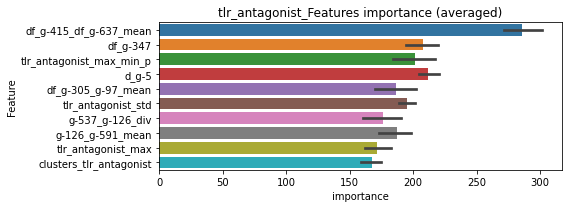

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0491367	valid_1's binary_logloss: 0.054522
[200]	training's binary_logloss: 0.00854478	valid_1's binary_logloss: 0.0111973
[300]	training's binary_logloss: 0.00195629	valid_1's binary_logloss: 0.00312758
[400]	training's binary_logloss: 0.000726641	valid_1's binary_logloss: 0.00131407
[500]	training's binary_logloss: 0.000400935	valid_1's binary_logloss: 0.00078337
[600]	training's binary_logloss: 0.000280895	valid_1's binary_logloss: 0.000585718
[700]	training's binary_logloss: 0.000234998	valid_1's binary_logloss: 0.000506328
[800]	training's binary_logloss: 0.000224949	valid_1's binary_logloss: 0.000487964
Early stopping, best iteration is:
[792]	training's binary_logloss: 0.000224962	valid_1's binary_logloss: 0.000487938


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0491018	valid_1's binary_logloss: 0.054728
[200]	training's binary_logloss: 0.00850408	valid_1's binary_logloss: 0.011465
[300]	training's binary_logloss: 0.00196064	valid_1's binary_logloss: 0.00360168
[400]	training's binary_logloss: 0.000723065	valid_1's binary_logloss: 0.00192965
[500]	training's binary_logloss: 0.00040043	valid_1's binary_logloss: 0.00147485
[600]	training's binary_logloss: 0.000279317	valid_1's binary_logloss: 0.00128532


len(train_index) : 2860
len(valid_index) : 953


[700]	training's binary_logloss: 0.000231569	valid_1's binary_logloss: 0.00120732
Early stopping, best iteration is:
[700]	training's binary_logloss: 0.000231569	valid_1's binary_logloss: 0.00120732


================================= fold 3/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497271	valid_1's binary_logloss: 0.0532723
[200]	training's binary_logloss: 0.00861843	valid_1's binary_logloss: 0.00969436
[300]	training's binary_logloss: 0.00196627	valid_1's binary_logloss: 0.00235376
[400]	training's binary_logloss: 0.00072188	valid_1's binary_logloss: 0.000929809
[500]	training's binary_logloss: 0.000397989	valid_1's binary_logloss: 0.000535949
[600]	training's binary_logloss: 0.000278745	valid_1's binary_logloss: 0.000383417
[700]	training's binary_logloss: 0.000231222	valid_1's binary_logloss: 0.000323595
[800]	training's binary_logloss: 0.000219487	valid_1's binary_logloss: 0.000308544
Early stopping, best iteration is:
[776]	training's binary_logloss: 0.000219487	valid_1's binary_logloss: 0.000308544


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 tlr_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0497133	valid_1's binary_logloss: 0.0552241
[200]	training's binary_logloss: 0.00862397	valid_1's binary_logloss: 0.0105419
[300]	training's binary_logloss: 0.0019546	valid_1's binary_logloss: 0.0026818
[400]	training's binary_logloss: 0.000718604	valid_1's binary_logloss: 0.00110915
[500]	training's binary_logloss: 0.000393015	valid_1's binary_logloss: 0.000653405
[600]	training's binary_logloss: 0.000275465	valid_1's binary_logloss: 0.000485607
[700]	training's binary_logloss: 0.000230151	valid_1's binary_logloss: 0.000418843
[800]	training's binary_logloss: 0.000221233	valid_1's binary_logloss: 0.000407727
Early stopping, best iteration is:
[788]	training's binary_logloss: 0.000221233	valid_1's binary_logloss: 0.000407727


tlr_antagonist logloss: 0.0006028578626205388


neg labels: 3289 → selected neg labels: 3289


tnf_inhibitor, len(trt): 36, len(othr): 3289, target_rate: 0.0015117 → Adj_target_rate: 0.0017663
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101676	valid_1's binary_logloss: 0.149699
[200]	training's binary_logloss: 0.0362451	valid_1's binary_logloss: 0.0786901
[300]	training's binary_logloss: 0.0142478	valid_1's binary_logloss: 0.0495934
[400]	training's binary_logloss: 0.00630467	valid_1's binary_logloss: 0.03556
[500]	training's binary_logloss: 0.00323354	valid_1's binary_logloss: 0.0285923
[600]	training's binary_logloss: 0.00197353	valid_1's binary_logloss: 0.0244095
[700]	training's binary_logloss: 0.00136321	valid_1's binary_logloss: 0.0218348
[800]	training's binary_logloss: 0.00103741	valid_1's binary_logloss: 0.0203163
[900]	training's binary_logloss: 0.000853223	valid_1's binary_logloss: 0.0192784
[1000]	training's binary_logloss: 0.000748593	valid_1's binary_logloss: 0.0189481
[1100]	training's binary_logloss: 0.00070754	valid_1's binary_logloss: 0.0187218
Early stopping, best iteration is:
[1125]	training's binary_lo

1 / 3 AUC score:1.000
y_Threshold: 0.0159555, Threshold: 0.0878110, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00151, Num_p_label: 40.0, conf_0:0.06147, conf_1:0.11415
Num_p_label: 40.0, Expected: 6.0, Adj_threshold_1: 0.0878110
Num_p_label: 27.0, Expected: 6.0, Adj_threshold_2: 0.1378110
Num_p_label: 21.0, Expected: 6.0, Adj_threshold_3: 0.1878110
Num_p_label: 13.0, Expected: 6.0, Adj_threshold_4: 0.2378110
threshold: 0.2378110, positive_p_label: 13.0/3982, p_label_rate: 0.0032647
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.098575	valid_1's binary_logloss: 0.14059
[200]	training's binary_logloss: 0.0330062	valid_1's binary_logloss: 0.06877
[300]	training's binary_logloss: 0.0124746	valid_1's binary_logloss: 0.0402885
[400]	training's binary_logloss: 0.00540872	valid_1's binary_logloss: 0.0272278
[500]	training's binary_logloss: 0.00281498	valid_1's binary_logloss: 0.021146
[600]	training's binary_logloss: 0.0017097	valid_1's binary_logloss: 0.0177428
[700]	training's binary_logloss: 0.00120331	valid_1's binary_logloss: 0.0159059
[800]	training's binary_logloss: 0.000930022	valid_1's binary_logloss: 0.0148279
Early stopping, best iteration is:
[853]	training's binary_logloss: 0.000830033	valid_1's binary_logloss: 0.0143192
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0996099	valid_1's binary_logloss: 0.142023
[200]	training's binary_logloss: 0.032457	valid_1's b

2 / 3 AUC score:1.000
y_Threshold: 0.1813748, Threshold: 0.2378110, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 653.0/3805
p_label_rate: 0.0138122 Vs.target_rate: 0.00151, Num_p_label: 55.0, conf_0:0.19025, conf_1:0.28537
Num_p_label: 55.0, Expected: 6.0, Adj_threshold_1: 0.2378110
Num_p_label: 45.0, Expected: 6.0, Adj_threshold_2: 0.2878110
Num_p_label: 39.0, Expected: 6.0, Adj_threshold_3: 0.3378110
Num_p_label: 26.0, Expected: 6.0, Adj_threshold_4: 0.3878110
Num_p_label: 23.0, Expected: 6.0, Adj_threshold_5: 0.4378110
Num_p_label: 18.0, Expected: 6.0, Adj_threshold_6: 0.4878110
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_7: 0.5378110
Num_p_label: 15.0, Expected: 6.0, Adj_threshold_8: 0.5878110
threshold: 0.5878110, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 653.0/3805, y_label_rate: 0.1716163
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0961766	valid_1's binary_logloss: 0.132809
[200]	training's binary_logloss: 0.0300969	valid_1's binary_logloss: 0.0615854
[300]	training's binary_logloss: 0.0112016	valid_1's binary_logloss: 0.0351565
[400]	training's binary_logloss: 0.00490688	valid_1's binary_logloss: 0.0244445
[500]	training's binary_logloss: 0.00257267	valid_1's binary_logloss: 0.0197128
[600]	training's binary_logloss: 0.00160183	valid_1's binary_logloss: 0.0175686
[700]	training's binary_logloss: 0.00114403	valid_1's binary_logloss: 0.016127
[800]	training's binary_logloss: 0.000887497	valid_1's binary_logloss: 0.015145
[900]	training's binary_logloss: 0.000743618	valid_1's binary_logloss: 0.0147367
[1000]	training's binary_logloss: 0.000662237	valid_1's binary_logloss: 0.0143687
Early stopping, best iteration is:
[1038]	training's binary_logloss: 0.000644646	valid_1's binary_logloss: 0.0142501
Training until validatio

3 / 3 AUC score:1.000
y_Threshold: 0.1224135, Threshold: 0.5878110, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 649.0/3797
p_label_rate: 0.0042692 Vs.target_rate: 0.00151, Num_p_label: 17.0, conf_0:0.50000, conf_1:0.64659
Num_p_label: 17.0, Expected: 6.0, Adj_threshold_1: 0.5878110
Num_p_label: 16.0, Expected: 6.0, Adj_threshold_2: 0.6378110
Num_p_label: 12.0, Expected: 6.0, Adj_threshold_3: 0.6878110
threshold: 0.6878110, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 649.0/3797, y_label_rate: 0.1709244


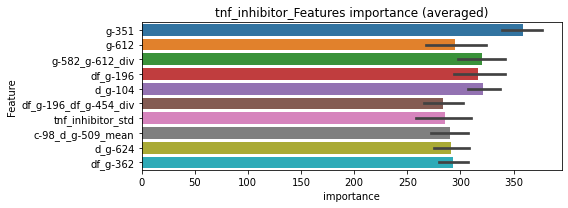

len(train_index) : 2847
len(valid_index) : 950
================================= fold 1/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.096134	valid_1's binary_logloss: 0.139253
[200]	training's binary_logloss: 0.0303849	valid_1's binary_logloss: 0.0672335
[300]	training's binary_logloss: 0.0111822	valid_1's binary_logloss: 0.0415125
[400]	training's binary_logloss: 0.00469889	valid_1's binary_logloss: 0.0297024
[500]	training's binary_logloss: 0.00245857	valid_1's binary_logloss: 0.0236212
[600]	training's binary_logloss: 0.00153274	valid_1's binary_logloss: 0.0206176
[700]	training's binary_logloss: 0.00108525	valid_1's binary_logloss: 0.0185935
[800]	training's binary_logloss: 0.000846991	valid_1's binary_logloss: 0.0176301
[900]	training's binary_logloss: 0.000708371	valid_1's binary_logloss: 0.0169623
Early stopping, best iteration is:
[897]	training's binary_logloss: 0.000712279	valid_1's binary_logloss: 0.0169586


len(train_index) : 2848
len(valid_index) : 949
================================= fold 2/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0968135	valid_1's binary_logloss: 0.139969
[200]	training's binary_logloss: 0.0308109	valid_1's binary_logloss: 0.0683283
[300]	training's binary_logloss: 0.0113051	valid_1's binary_logloss: 0.0430513
[400]	training's binary_logloss: 0.00489158	valid_1's binary_logloss: 0.032572
[500]	training's binary_logloss: 0.00253182	valid_1's binary_logloss: 0.0276383
[600]	training's binary_logloss: 0.0016072	valid_1's binary_logloss: 0.0261563
[700]	training's binary_logloss: 0.00112857	valid_1's binary_logloss: 0.0239978
[800]	training's binary_logloss: 0.000883387	valid_1's binary_logloss: 0.0232321
[900]	training's binary_logloss: 0.000743687	valid_1's binary_logloss: 0.0225565
Early stopping, best iteration is:
[870]	training's binary_logloss: 0.000778804	valid_1's binary_logloss: 0.022517


len(train_index) : 2848
len(valid_index) : 949
================================= fold 3/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983617	valid_1's binary_logloss: 0.136014
[200]	training's binary_logloss: 0.0317648	valid_1's binary_logloss: 0.0617203
[300]	training's binary_logloss: 0.0117367	valid_1's binary_logloss: 0.0325961
[400]	training's binary_logloss: 0.00503057	valid_1's binary_logloss: 0.0199045
[500]	training's binary_logloss: 0.00258326	valid_1's binary_logloss: 0.0139231
[600]	training's binary_logloss: 0.0016045	valid_1's binary_logloss: 0.0109718
[700]	training's binary_logloss: 0.00112915	valid_1's binary_logloss: 0.00912737
[800]	training's binary_logloss: 0.000876968	valid_1's binary_logloss: 0.00809723
[900]	training's binary_logloss: 0.000739798	valid_1's binary_logloss: 0.00739806
[1000]	training's binary_logloss: 0.000669107	valid_1's binary_logloss: 0.00714703
[1100]	training's binary_logloss: 0.000647384	valid_1's binary_logloss: 0.00704126
Early stopping, best iteration is:
[1155]	training's 

len(train_index) : 2848
len(valid_index) : 949
================================= fold 4/4 tnf_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0983995	valid_1's binary_logloss: 0.132852
[200]	training's binary_logloss: 0.0311095	valid_1's binary_logloss: 0.060342
[300]	training's binary_logloss: 0.0116936	valid_1's binary_logloss: 0.0332744
[400]	training's binary_logloss: 0.00495478	valid_1's binary_logloss: 0.0208984
[500]	training's binary_logloss: 0.00257491	valid_1's binary_logloss: 0.0147748
[600]	training's binary_logloss: 0.00160012	valid_1's binary_logloss: 0.0117566
[700]	training's binary_logloss: 0.00112864	valid_1's binary_logloss: 0.0100617
[800]	training's binary_logloss: 0.000883835	valid_1's binary_logloss: 0.00910509
[900]	training's binary_logloss: 0.000738336	valid_1's binary_logloss: 0.00851931
[1000]	training's binary_logloss: 0.000660475	valid_1's binary_logloss: 0.00823653
Early stopping, best iteration is:
[1045]	training's binary_logloss: 0.000646313	valid_1's binary_logloss: 0.00816524


tnf_inhibitor logloss: 0.013662948433699426


neg labels: 3289 → selected neg labels: 3276


topoisomerase_inhibitor, len(trt): 127, len(othr): 3276, target_rate: 0.0053330 → Adj_target_rate: 0.0051574
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.168337	valid_1's binary_logloss: 0.2705
[200]	training's binary_logloss: 0.0846682	valid_1's binary_logloss: 0.212013
[300]	training's binary_logloss: 0.0463925	valid_1's binary_logloss: 0.18156
[400]	training's binary_logloss: 0.0263863	valid_1's binary_logloss: 0.163546
[500]	training's binary_logloss: 0.0154522	valid_1's binary_logloss: 0.151622
[600]	training's binary_logloss: 0.00941612	valid_1's binary_logloss: 0.144776
[700]	training's binary_logloss: 0.00607696	valid_1's binary_logloss: 0.140877
[800]	training's binary_logloss: 0.00415012	valid_1's binary_logloss: 0.137494
Early stopping, best iteration is:
[810]	training's binary_logloss: 0.00400669	valid_1's binary_logloss: 0.137306
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.175659	valid_1's binary_logloss: 0.262998
[200]	training's binary_logloss: 0.0866227	valid_1's binary_logl

1 / 3 AUC score:0.978
y_Threshold: 0.0531099, Threshold: 0.3833745, pos_neg_ratio: 0.8000000
Remove_noisy_data: 224 → Positive_corect_labels: 609/3707
p_label_rate: 0.0100452 Vs.target_rate: 0.00533, Num_p_label: 40.0, conf_0:0.26836, conf_1:0.49839
Num_p_label: 40.0, Expected: 21.2, Adj_threshold_1: 0.3833745
Num_p_label: 35.0, Expected: 21.2, Adj_threshold_2: 0.4333745
Num_p_label: 30.0, Expected: 21.2, Adj_threshold_3: 0.4833745
threshold: 0.4833745, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 609.0/3707, y_label_rate: 0.1642838
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.149185	valid_1's binary_logloss: 0.240913
[200]	training's binary_logloss: 0.0657819	valid_1's binary_logloss: 0.174093
[300]	training's binary_logloss: 0.0323094	valid_1's binary_logloss: 0.145783
[400]	training's binary_logloss: 0.0166545	valid_1's binary_logloss: 0.129989
[500]	training's binary_logloss: 0.00920741	valid_1's binary_logloss: 0.123144
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00801121	valid_1's binary_logloss: 0.122231
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.148886	valid_1's binary_logloss: 0.243617
[200]	training's binary_logloss: 0.0651082	valid_1's binary_logloss: 0.179552
[300]	training's binary_logloss: 0.0318212	valid_1's binary_logloss: 0.146647
[400]	training's binary_logloss: 0.016234	valid_1's binary_logloss: 0.129898
[500]	training's binary_logloss: 0.00888941	valid_1's binary_log

2 / 3 AUC score:0.987
y_Threshold: 0.1191867, Threshold: 0.4833745, pos_neg_ratio: 0.8000000
Remove_noisy_data: 100 → Positive_corect_labels: 559.0/3607
p_label_rate: 0.0200904 Vs.target_rate: 0.00533, Num_p_label: 80.0, conf_0:0.38670, conf_1:0.58005
Num_p_label: 80.0, Expected: 21.2, Adj_threshold_1: 0.4833745
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_2: 0.5333745
Num_p_label: 60.0, Expected: 21.2, Adj_threshold_3: 0.5833745
Num_p_label: 52.0, Expected: 21.2, Adj_threshold_4: 0.6333745
Num_p_label: 42.0, Expected: 21.2, Adj_threshold_5: 0.6833745
Num_p_label: 30.0, Expected: 21.2, Adj_threshold_6: 0.7333745
threshold: 0.7333745, positive_p_label: 30.0/3982, p_label_rate: 0.0075339
positive_y_label: 559.0/3607, y_label_rate: 0.1549764
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127741	valid_1's binary_logloss: 0.207885
[200]	training's binary_logloss: 0.0518001	valid_1's binary_logloss: 0.14796
[300]	training's binary_logloss: 0.0234842	valid_1's binary_logloss: 0.125565
[400]	training's binary_logloss: 0.0114577	valid_1's binary_logloss: 0.115447
[500]	training's binary_logloss: 0.00619625	valid_1's binary_logloss: 0.113363
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00727915	valid_1's binary_logloss: 0.112758
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.127548	valid_1's binary_logloss: 0.196637
[200]	training's binary_logloss: 0.0537013	valid_1's binary_logloss: 0.13429
[300]	training's binary_logloss: 0.0252591	valid_1's binary_logloss: 0.105199
[400]	training's binary_logloss: 0.0124232	valid_1's binary_logloss: 0.0891473
[500]	training's binary_logloss: 0.00663156	valid_1's binary_log

3 / 3 AUC score:0.989
y_Threshold: 0.1033387, Threshold: 0.7333745, pos_neg_ratio: 0.8000000
Remove_noisy_data: 68 → Positive_corect_labels: 525.0/3539
p_label_rate: 0.0150678 Vs.target_rate: 0.00533, Num_p_label: 60.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 60.0, Expected: 21.2, Adj_threshold_1: 0.7333745
Num_p_label: 47.0, Expected: 21.2, Adj_threshold_2: 0.7833745
threshold: 0.7833745, positive_p_label: 47.0/3982, p_label_rate: 0.0118031
positive_y_label: 525.0/3539, y_label_rate: 0.1483470


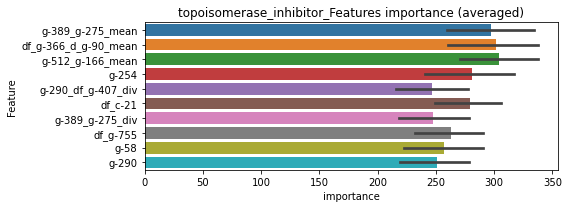

len(train_index) : 2654
len(valid_index) : 885
================================= fold 1/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108332	valid_1's binary_logloss: 0.168315
[200]	training's binary_logloss: 0.0420013	valid_1's binary_logloss: 0.104812
[300]	training's binary_logloss: 0.0184693	valid_1's binary_logloss: 0.0770058
[400]	training's binary_logloss: 0.00880639	valid_1's binary_logloss: 0.0613961
[500]	training's binary_logloss: 0.00469851	valid_1's binary_logloss: 0.0529946
[600]	training's binary_logloss: 0.00288606	valid_1's binary_logloss: 0.048562
[700]	training's binary_logloss: 0.00199108	valid_1's binary_logloss: 0.0456874
[800]	training's binary_logloss: 0.00150522	valid_1's binary_logloss: 0.0444629
[900]	training's binary_logloss: 0.00121254	valid_1's binary_logloss: 0.0430177
Early stopping, best iteration is:
[898]	training's binary_logloss: 0.00121765	valid_1's binary_logloss: 0.0429814


len(train_index) : 2654
len(valid_index) : 885
================================= fold 2/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112495	valid_1's binary_logloss: 0.167955
[200]	training's binary_logloss: 0.0440841	valid_1's binary_logloss: 0.105037
[300]	training's binary_logloss: 0.0196375	valid_1's binary_logloss: 0.0757856
[400]	training's binary_logloss: 0.0093468	valid_1's binary_logloss: 0.0585671
[500]	training's binary_logloss: 0.00506183	valid_1's binary_logloss: 0.0509061
[600]	training's binary_logloss: 0.00306321	valid_1's binary_logloss: 0.0469291
[700]	training's binary_logloss: 0.00208108	valid_1's binary_logloss: 0.0442839
[800]	training's binary_logloss: 0.00155941	valid_1's binary_logloss: 0.0429561
[900]	training's binary_logloss: 0.00125795	valid_1's binary_logloss: 0.041819
[1000]	training's binary_logloss: 0.00107886	valid_1's binary_logloss: 0.041039
Early stopping, best iteration is:
[1011]	training's binary_logloss: 0.00106311	valid_1's binary_logloss: 0.0410098


len(train_index) : 2654
len(valid_index) : 885
================================= fold 3/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112655	valid_1's binary_logloss: 0.185047
[200]	training's binary_logloss: 0.0442029	valid_1's binary_logloss: 0.122128
[300]	training's binary_logloss: 0.0195096	valid_1's binary_logloss: 0.093718
[400]	training's binary_logloss: 0.00912479	valid_1's binary_logloss: 0.0786825
[500]	training's binary_logloss: 0.00490323	valid_1's binary_logloss: 0.0714077
[600]	training's binary_logloss: 0.00298463	valid_1's binary_logloss: 0.0660438
[700]	training's binary_logloss: 0.00204072	valid_1's binary_logloss: 0.0630417
Early stopping, best iteration is:
[763]	training's binary_logloss: 0.00169076	valid_1's binary_logloss: 0.0617249


len(train_index) : 2655
len(valid_index) : 884
================================= fold 4/4 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110644	valid_1's binary_logloss: 0.168743
[200]	training's binary_logloss: 0.0435515	valid_1's binary_logloss: 0.111352
[300]	training's binary_logloss: 0.0190128	valid_1's binary_logloss: 0.0852814
[400]	training's binary_logloss: 0.00903037	valid_1's binary_logloss: 0.0747191
[500]	training's binary_logloss: 0.00482422	valid_1's binary_logloss: 0.0707478
[600]	training's binary_logloss: 0.002923	valid_1's binary_logloss: 0.0687741
[700]	training's binary_logloss: 0.00199793	valid_1's binary_logloss: 0.0676452
[800]	training's binary_logloss: 0.00150631	valid_1's binary_logloss: 0.0670133
Early stopping, best iteration is:
[786]	training's binary_logloss: 0.00156029	valid_1's binary_logloss: 0.0668686


topoisomerase_inhibitor logloss: 0.053142277041024


neg labels: 3289 → selected neg labels: 3287


transient_receptor_potential_channel_antagonist, len(trt): 18, len(othr): 3287, target_rate: 0.0007559 → Adj_target_rate: 0.0009799
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0686341	valid_1's binary_logloss: 0.0802267
[200]	training's binary_logloss: 0.0174196	valid_1's binary_logloss: 0.0239362
[300]	training's binary_logloss: 0.00553174	valid_1's binary_logloss: 0.00921677
[400]	training's binary_logloss: 0.00224695	valid_1's binary_logloss: 0.00473367
[500]	training's binary_logloss: 0.00121028	valid_1's binary_logloss: 0.00300367
[600]	training's binary_logloss: 0.000802317	valid_1's binary_logloss: 0.00226696
[700]	training's binary_logloss: 0.000602803	valid_1's binary_logloss: 0.00185855
[800]	training's binary_logloss: 0.000513362	valid_1's binary_logloss: 0.00169277
Early stopping, best iteration is:
[855]	training's binary_logloss: 0.0004868	valid_1's binary_logloss: 0.00162051
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0677474	valid_1's binary_logloss: 0.0935484
[200]	training's binary_logloss: 0.01

1 / 3 AUC score:1.000
y_Threshold: 0.0039013, Threshold: 0.0184326, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00076, Num_p_label: 40.0, conf_0:0.01290, conf_1:0.02396
Num_p_label: 40.0, Expected: 3.0, Adj_threshold_1: 0.0184326
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_2: 0.0684326
Num_p_label: 7.0, Expected: 3.0, Adj_threshold_3: 0.1184326
threshold: 0.1184326, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.067218	valid_1's binary_logloss: 0.0766885
[200]	training's binary_logloss: 0.0161489	valid_1's binary_logloss: 0.0212374
[300]	training's binary_logloss: 0.00490896	valid_1's binary_logloss: 0.00764733
[400]	training's binary_logloss: 0.00205006	valid_1's binary_logloss: 0.00372627
[500]	training's binary_logloss: 0.00110352	valid_1's binary_logloss: 0.00225403
[600]	training's binary_logloss: 0.000734128	valid_1's binary_logloss: 0.00164597
[700]	training's binary_logloss: 0.000555141	valid_1's binary_logloss: 0.0013339
[800]	training's binary_logloss: 0.000471258	valid_1's binary_logloss: 0.00117505
[900]	training's binary_logloss: 0.000440793	valid_1's binary_logloss: 0.00110987
[1000]	training's binary_logloss: 0.000425909	valid_1's binary_logloss: 0.00108519
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.000424851	valid_1's binary_logloss: 0.00108321
Training un

2 / 3 AUC score:1.000
y_Threshold: 0.0582210, Threshold: 0.1184326, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0057760 Vs.target_rate: 0.00076, Num_p_label: 23.0, conf_0:0.09475, conf_1:0.14212
Num_p_label: 23.0, Expected: 3.0, Adj_threshold_1: 0.1184326
Num_p_label: 13.0, Expected: 3.0, Adj_threshold_2: 0.1684326
Num_p_label: 9.0, Expected: 3.0, Adj_threshold_3: 0.2184326
Num_p_label: 8.0, Expected: 3.0, Adj_threshold_4: 0.2684326
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_5: 0.3184326
threshold: 0.3184326, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.067218	valid_1's binary_logloss: 0.0766885
[200]	training's binary_logloss: 0.0161489	valid_1's binary_logloss: 0.0212374
[300]	training's binary_logloss: 0.00490896	valid_1's binary_logloss: 0.00764733
[400]	training's binary_logloss: 0.00205006	valid_1's binary_logloss: 0.00372627
[500]	training's binary_logloss: 0.00110352	valid_1's binary_logloss: 0.00225403
[600]	training's binary_logloss: 0.000734128	valid_1's binary_logloss: 0.00164597
[700]	training's binary_logloss: 0.000555141	valid_1's binary_logloss: 0.0013339
[800]	training's binary_logloss: 0.000471258	valid_1's binary_logloss: 0.00117505
[900]	training's binary_logloss: 0.000440793	valid_1's binary_logloss: 0.00110987
[1000]	training's binary_logloss: 0.000425909	valid_1's binary_logloss: 0.00108519
Early stopping, best iteration is:
[1019]	training's binary_logloss: 0.000424851	valid_1's binary_logloss: 0.00108321
Training un

3 / 3 AUC score:1.000
y_Threshold: 0.0582210, Threshold: 0.3184326, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00076, Num_p_label: 5.0, conf_0:0.28659, conf_1:0.35028
Num_p_label: 5.0, Expected: 3.0, Adj_threshold_1: 0.3184326
threshold: 0.3184326, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


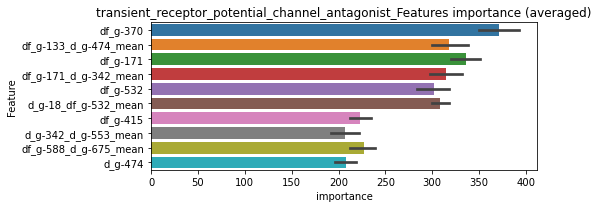

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0679398	valid_1's binary_logloss: 0.0763005
[200]	training's binary_logloss: 0.0162773	valid_1's binary_logloss: 0.02128
[300]	training's binary_logloss: 0.0050913	valid_1's binary_logloss: 0.00791759
[400]	training's binary_logloss: 0.00209209	valid_1's binary_logloss: 0.00384159
[500]	training's binary_logloss: 0.00112286	valid_1's binary_logloss: 0.00233246
[600]	training's binary_logloss: 0.000741348	valid_1's binary_logloss: 0.00169992
[700]	training's binary_logloss: 0.000559029	valid_1's binary_logloss: 0.00136402
[800]	training's binary_logloss: 0.000471961	valid_1's binary_logloss: 0.0011903
[900]	training's binary_logloss: 0.000447094	valid_1's binary_logloss: 0.00113969
Early stopping, best iteration is:
[945]	training's binary_logloss: 0.000432632	valid_1's binary_logloss: 0.00111167


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0672683	valid_1's binary_logloss: 0.0915791
[200]	training's binary_logloss: 0.0155032	valid_1's binary_logloss: 0.0302622
[300]	training's binary_logloss: 0.00472999	valid_1's binary_logloss: 0.0135045
[400]	training's binary_logloss: 0.00193195	valid_1's binary_logloss: 0.00869941
[500]	training's binary_logloss: 0.00104531	valid_1's binary_logloss: 0.00640909
[600]	training's binary_logloss: 0.000697494	valid_1's binary_logloss: 0.00543984
[700]	training's binary_logloss: 0.000531744	valid_1's binary_logloss: 0.00478673
[800]	training's binary_logloss: 0.0004483	valid_1's binary_logloss: 0.00451949
Early stopping, best iteration is:
[847]	training's binary_logloss: 0.000437312	valid_1's binary_logloss: 0.00448837


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0674611	valid_1's binary_logloss: 0.0816984
[200]	training's binary_logloss: 0.0159483	valid_1's binary_logloss: 0.0254045
[300]	training's binary_logloss: 0.00487187	valid_1's binary_logloss: 0.0114725
[400]	training's binary_logloss: 0.00201037	valid_1's binary_logloss: 0.00720606
[500]	training's binary_logloss: 0.00108687	valid_1's binary_logloss: 0.00555327
[600]	training's binary_logloss: 0.000717661	valid_1's binary_logloss: 0.00496975
Early stopping, best iteration is:
[664]	training's binary_logloss: 0.000594166	valid_1's binary_logloss: 0.00470382


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0695597	valid_1's binary_logloss: 0.0827748
[200]	training's binary_logloss: 0.0162296	valid_1's binary_logloss: 0.0230083
[300]	training's binary_logloss: 0.00488692	valid_1's binary_logloss: 0.00804523
[400]	training's binary_logloss: 0.0019775	valid_1's binary_logloss: 0.00376568
[500]	training's binary_logloss: 0.00108024	valid_1's binary_logloss: 0.00232532
[600]	training's binary_logloss: 0.000720598	valid_1's binary_logloss: 0.00171214
[700]	training's binary_logloss: 0.000546113	valid_1's binary_logloss: 0.00137655
[800]	training's binary_logloss: 0.000462486	valid_1's binary_logloss: 0.00120163
Early stopping, best iteration is:
[830]	training's binary_logloss: 0.000451572	valid_1's binary_logloss: 0.00118561


transient_receptor_potential_channel_antagonist logloss: 0.00287265512106793


neg labels: 3289 → selected neg labels: 3289


tropomyosin_receptor_kinase_inhibitor, len(trt): 6, len(othr): 3289, target_rate: 0.0002520 → Adj_target_rate: 0.0003851
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0463966	valid_1's binary_logloss: 0.0502283
[200]	training's binary_logloss: 0.00782713	valid_1's binary_logloss: 0.0101512
[300]	training's binary_logloss: 0.0018138	valid_1's binary_logloss: 0.00333358
[400]	training's binary_logloss: 0.000659244	valid_1's binary_logloss: 0.00165174
[500]	training's binary_logloss: 0.000369692	valid_1's binary_logloss: 0.00112537
[600]	training's binary_logloss: 0.000262424	valid_1's binary_logloss: 0.00089768
[700]	training's binary_logloss: 0.000221084	valid_1's binary_logloss: 0.000786234
[800]	training's binary_logloss: 0.000216773	valid_1's binary_logloss: 0.000777007
Early stopping, best iteration is:
[782]	training's binary_logloss: 0.000216773	valid_1's binary_logloss: 0.000777007
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0463395	valid_1's binary_logloss: 0.0498767
[200]	training's binary_loglos

1 / 3 AUC score:1.000
y_Threshold: 0.0007673, Threshold: 0.0033141, pos_neg_ratio: 0.8000000
Remove_noisy_data: 133 → Positive_corect_labels: 657/3813
p_label_rate: 0.0100452 Vs.target_rate: 0.00025, Num_p_label: 40.0, conf_0:0.00232, conf_1:0.00431
Num_p_label: 40.0, Expected: 1.0, Adj_threshold_1: 0.0033141
Num_p_label: 5.0, Expected: 1.0, Adj_threshold_2: 0.0533141
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_3: 0.1033141
threshold: 0.1033141, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0460284	valid_1's binary_logloss: 0.0494623
[200]	training's binary_logloss: 0.00730364	valid_1's binary_logloss: 0.00918541
[300]	training's binary_logloss: 0.00159218	valid_1's binary_logloss: 0.00273369
[400]	training's binary_logloss: 0.000577988	valid_1's binary_logloss: 0.00126622
[500]	training's binary_logloss: 0.000321764	valid_1's binary_logloss: 0.000822626
[600]	training's binary_logloss: 0.00023062	valid_1's binary_logloss: 0.000660458
[700]	training's binary_logloss: 0.000200209	valid_1's binary_logloss: 0.000599883
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.000199421	valid_1's binary_logloss: 0.00059889
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456806	valid_1's binary_logloss: 0.0475618
[200]	training's binary_logloss: 0.00722584	valid_1's binary_logloss: 0.00814516
[300]	training's binary_loglos

2 / 3 AUC score:1.000
y_Threshold: 0.0756152, Threshold: 0.1033141, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0025113 Vs.target_rate: 0.00025, Num_p_label: 10.0, conf_0:0.08265, conf_1:0.12398
Num_p_label: 10.0, Expected: 1.0, Adj_threshold_1: 0.1033141
Num_p_label: 8.0, Expected: 1.0, Adj_threshold_2: 0.1533141
Num_p_label: 6.0, Expected: 1.0, Adj_threshold_3: 0.2033141
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_4: 0.2533141
Num_p_label: 3.0, Expected: 1.0, Adj_threshold_5: 0.3033141
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_6: 0.3533141
threshold: 0.3533141, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0460284	valid_1's binary_logloss: 0.0494623
[200]	training's binary_logloss: 0.00730364	valid_1's binary_logloss: 0.00918541
[300]	training's binary_logloss: 0.00159218	valid_1's binary_logloss: 0.00273369
[400]	training's binary_logloss: 0.000577988	valid_1's binary_logloss: 0.00126622
[500]	training's binary_logloss: 0.000321764	valid_1's binary_logloss: 0.000822626
[600]	training's binary_logloss: 0.00023062	valid_1's binary_logloss: 0.000660458
[700]	training's binary_logloss: 0.000200209	valid_1's binary_logloss: 0.000599883
Early stopping, best iteration is:
[706]	training's binary_logloss: 0.000199421	valid_1's binary_logloss: 0.00059889
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0456806	valid_1's binary_logloss: 0.0475618
[200]	training's binary_logloss: 0.00722584	valid_1's binary_logloss: 0.00814516
[300]	training's binary_loglos

3 / 3 AUC score:1.000
y_Threshold: 0.0756152, Threshold: 0.3533141, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3813
p_label_rate: 0.0005023 Vs.target_rate: 0.00025, Num_p_label: 2.0, conf_0:0.31798, conf_1:0.38865
Num_p_label: 2.0, Expected: 1.0, Adj_threshold_1: 0.3533141
threshold: 0.3533141, positive_p_label: 2.0/3982, p_label_rate: 0.0005023
positive_y_label: 657.0/3813, y_label_rate: 0.1723053


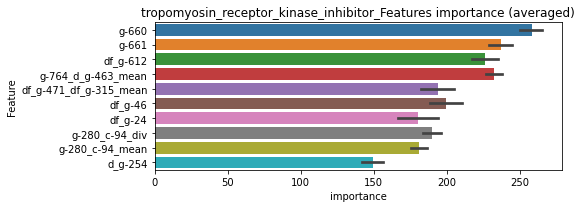

len(train_index) : 2859
len(valid_index) : 954
================================= fold 1/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0455582	valid_1's binary_logloss: 0.0484246
[200]	training's binary_logloss: 0.0073103	valid_1's binary_logloss: 0.00886446
[300]	training's binary_logloss: 0.00158289	valid_1's binary_logloss: 0.00276547
[400]	training's binary_logloss: 0.000575998	valid_1's binary_logloss: 0.00132486
[500]	training's binary_logloss: 0.000320647	valid_1's binary_logloss: 0.000881212
[600]	training's binary_logloss: 0.000232333	valid_1's binary_logloss: 0.000731473
[700]	training's binary_logloss: 0.00020253	valid_1's binary_logloss: 0.000669743
Early stopping, best iteration is:
[732]	training's binary_logloss: 0.000200598	valid_1's binary_logloss: 0.000666561


len(train_index) : 2860
len(valid_index) : 953
================================= fold 2/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453063	valid_1's binary_logloss: 0.0476157
[200]	training's binary_logloss: 0.00723269	valid_1's binary_logloss: 0.00869482
[300]	training's binary_logloss: 0.00157982	valid_1's binary_logloss: 0.00238859
[400]	training's binary_logloss: 0.000584026	valid_1's binary_logloss: 0.00110828
[500]	training's binary_logloss: 0.000325096	valid_1's binary_logloss: 0.000670204
[600]	training's binary_logloss: 0.000234064	valid_1's binary_logloss: 0.000515762
[700]	training's binary_logloss: 0.000202012	valid_1's binary_logloss: 0.000461073
Early stopping, best iteration is:
[730]	training's binary_logloss: 0.000197964	valid_1's binary_logloss: 0.000454281


len(train_index) : 2860
len(valid_index) : 953
================================= fold 3/4 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0453821	valid_1's binary_logloss: 0.0459676
[200]	training's binary_logloss: 0.0072717	valid_1's binary_logloss: 0.00744714
[300]	training's binary_logloss: 0.00158569	valid_1's binary_logloss: 0.00165508
[400]	training's binary_logloss: 0.000578434	valid_1's binary_logloss: 0.00062197
[500]	training's binary_logloss: 0.000324058	valid_1's binary_logloss: 0.000356738
[600]	training's binary_logloss: 0.000234426	valid_1's binary_logloss: 0.000260704
[700]	training's binary_logloss: 0.000202422	valid_1's binary_logloss: 0.000225898


len(train_index) : 2860
len(valid_index) : 953
================================= fold 4/4 tropomyosin_receptor_kinase_inhibitor=================================


Early stopping, best iteration is:
[754]	training's binary_logloss: 0.000199584	valid_1's binary_logloss: 0.000222564
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0452176	valid_1's binary_logloss: 0.0497122
[200]	training's binary_logloss: 0.00724751	valid_1's binary_logloss: 0.0108345
[300]	training's binary_logloss: 0.00156769	valid_1's binary_logloss: 0.00441294
[400]	training's binary_logloss: 0.000572797	valid_1's binary_logloss: 0.00276749
[500]	training's binary_logloss: 0.000320438	valid_1's binary_logloss: 0.00213663
[600]	training's binary_logloss: 0.000231294	valid_1's binary_logloss: 0.00190818
[700]	training's binary_logloss: 0.000199275	valid_1's binary_logloss: 0.00178204
Early stopping, best iteration is:
[704]	training's binary_logloss: 0.000198837	valid_1's binary_logloss: 0.00178145


tropomyosin_receptor_kinase_inhibitor logloss: 0.0007811842907686389


neg labels: 3289 → selected neg labels: 3281


trpv_agonist, len(trt): 25, len(othr): 3281, target_rate: 0.0010498 → Adj_target_rate: 0.0012955
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0950418	valid_1's binary_logloss: 0.13163
[200]	training's binary_logloss: 0.0317499	valid_1's binary_logloss: 0.0608793
[300]	training's binary_logloss: 0.0118342	valid_1's binary_logloss: 0.0332665
[400]	training's binary_logloss: 0.00474961	valid_1's binary_logloss: 0.0205188
[500]	training's binary_logloss: 0.0023858	valid_1's binary_logloss: 0.0153902
[600]	training's binary_logloss: 0.00145343	valid_1's binary_logloss: 0.0129681
[700]	training's binary_logloss: 0.00102889	valid_1's binary_logloss: 0.0116708
[800]	training's binary_logloss: 0.000799432	valid_1's binary_logloss: 0.011011
[900]	training's binary_logloss: 0.000676458	valid_1's binary_logloss: 0.0106551
[1000]	training's binary_logloss: 0.000613976	valid_1's binary_logloss: 0.0106119
Early stopping, best iteration is:
[983]	training's binary_logloss: 0.000619964	valid_1's binary_logloss: 0.0106005
Training until validation 

1 / 3 AUC score:1.000
y_Threshold: 0.0099030, Threshold: 0.0411787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.02883, conf_1:0.05353
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.0411787
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_2: 0.0911787
Num_p_label: 8.0, Expected: 4.2, Adj_threshold_3: 0.1411787
threshold: 0.1411787, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936144	valid_1's binary_logloss: 0.125789
[200]	training's binary_logloss: 0.0292121	valid_1's binary_logloss: 0.0520257
[300]	training's binary_logloss: 0.0103351	valid_1's binary_logloss: 0.0248699
[400]	training's binary_logloss: 0.00415406	valid_1's binary_logloss: 0.0141805
[500]	training's binary_logloss: 0.00211371	valid_1's binary_logloss: 0.00961423
[600]	training's binary_logloss: 0.00131565	valid_1's binary_logloss: 0.00730602
[700]	training's binary_logloss: 0.000927631	valid_1's binary_logloss: 0.00625972
[800]	training's binary_logloss: 0.000720285	valid_1's binary_logloss: 0.00552463
[900]	training's binary_logloss: 0.000607264	valid_1's binary_logloss: 0.00521027
[1000]	training's binary_logloss: 0.000562983	valid_1's binary_logloss: 0.00512192
Early stopping, best iteration is:
[1003]	training's binary_logloss: 0.000562088	valid_1's binary_logloss: 0.00511746
Training until

2 / 3 AUC score:1.000
y_Threshold: 0.0918429, Threshold: 0.1411787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0100452 Vs.target_rate: 0.00105, Num_p_label: 40.0, conf_0:0.11294, conf_1:0.16941
Num_p_label: 40.0, Expected: 4.2, Adj_threshold_1: 0.1411787
Num_p_label: 33.0, Expected: 4.2, Adj_threshold_2: 0.1911787
Num_p_label: 23.0, Expected: 4.2, Adj_threshold_3: 0.2411787
Num_p_label: 20.0, Expected: 4.2, Adj_threshold_4: 0.2911787
Num_p_label: 15.0, Expected: 4.2, Adj_threshold_5: 0.3411787
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.3911787
threshold: 0.3911787, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3805, y_label_rate: 0.1724047
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0936144	valid_1's binary_logloss: 0.125789
[200]	training's binary_logloss: 0.0292121	valid_1's binary_logloss: 0.0520257
[300]	training's binary_logloss: 0.0103351	valid_1's binary_logloss: 0.0248699
[400]	training's binary_logloss: 0.00415406	valid_1's binary_logloss: 0.0141805
[500]	training's binary_logloss: 0.00211371	valid_1's binary_logloss: 0.00961423
[600]	training's binary_logloss: 0.00131565	valid_1's binary_logloss: 0.00730602
[700]	training's binary_logloss: 0.000927631	valid_1's binary_logloss: 0.00625972
[800]	training's binary_logloss: 0.000720285	valid_1's binary_logloss: 0.00552463
[900]	training's binary_logloss: 0.000607264	valid_1's binary_logloss: 0.00521027
[1000]	training's binary_logloss: 0.000562983	valid_1's binary_logloss: 0.00512192
Early stopping, best iteration is:
[1003]	training's binary_logloss: 0.000562088	valid_1's binary_logloss: 0.00511746
Training until

3 / 3 AUC score:1.000
y_Threshold: 0.0918429, Threshold: 0.3911787, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 656.0/3805
p_label_rate: 0.0025113 Vs.target_rate: 0.00105, Num_p_label: 10.0, conf_0:0.35206, conf_1:0.43030
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_1: 0.3911787
threshold: 0.3911787, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 656.0/3805, y_label_rate: 0.1724047


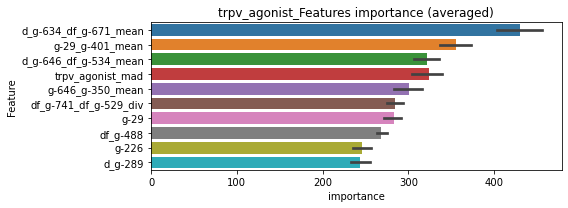

len(train_index) : 2853
len(valid_index) : 952
================================= fold 1/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0932035	valid_1's binary_logloss: 0.12408
[200]	training's binary_logloss: 0.0289842	valid_1's binary_logloss: 0.0523221
[300]	training's binary_logloss: 0.00997122	valid_1's binary_logloss: 0.0256516
[400]	training's binary_logloss: 0.0040316	valid_1's binary_logloss: 0.0150462
[500]	training's binary_logloss: 0.00207356	valid_1's binary_logloss: 0.0103418
[600]	training's binary_logloss: 0.00129305	valid_1's binary_logloss: 0.008106
[700]	training's binary_logloss: 0.000914444	valid_1's binary_logloss: 0.0068371
[800]	training's binary_logloss: 0.000717345	valid_1's binary_logloss: 0.00625159
[900]	training's binary_logloss: 0.000605045	valid_1's binary_logloss: 0.00575222
[1000]	training's binary_logloss: 0.00056134	valid_1's binary_logloss: 0.00562475
Early stopping, best iteration is:
[1069]	training's binary_logloss: 0.000546883	valid_1's binary_logloss: 0.0055544


len(train_index) : 2854
len(valid_index) : 951
================================= fold 2/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0920748	valid_1's binary_logloss: 0.12196
[200]	training's binary_logloss: 0.0286578	valid_1's binary_logloss: 0.0479036
[300]	training's binary_logloss: 0.0102384	valid_1's binary_logloss: 0.0219112
[400]	training's binary_logloss: 0.00419646	valid_1's binary_logloss: 0.0115072
[500]	training's binary_logloss: 0.00211963	valid_1's binary_logloss: 0.00730308
[600]	training's binary_logloss: 0.00132211	valid_1's binary_logloss: 0.00549058
[700]	training's binary_logloss: 0.000940887	valid_1's binary_logloss: 0.00447853
[800]	training's binary_logloss: 0.000732529	valid_1's binary_logloss: 0.0038747
[900]	training's binary_logloss: 0.000616373	valid_1's binary_logloss: 0.00351672
[1000]	training's binary_logloss: 0.000574367	valid_1's binary_logloss: 0.00344844
Early stopping, best iteration is:
[987]	training's binary_logloss: 0.000574367	valid_1's binary_logloss: 0.00344844


len(train_index) : 2854
len(valid_index) : 951
================================= fold 3/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0910779	valid_1's binary_logloss: 0.117555
[200]	training's binary_logloss: 0.0279553	valid_1's binary_logloss: 0.0483108
[300]	training's binary_logloss: 0.00982658	valid_1's binary_logloss: 0.0239554
[400]	training's binary_logloss: 0.00398208	valid_1's binary_logloss: 0.0143343
[500]	training's binary_logloss: 0.00203645	valid_1's binary_logloss: 0.0103331
[600]	training's binary_logloss: 0.00127355	valid_1's binary_logloss: 0.00818478
[700]	training's binary_logloss: 0.00091212	valid_1's binary_logloss: 0.00726741
[800]	training's binary_logloss: 0.000714679	valid_1's binary_logloss: 0.00669825
[900]	training's binary_logloss: 0.000605257	valid_1's binary_logloss: 0.00628579
[1000]	training's binary_logloss: 0.000559324	valid_1's binary_logloss: 0.00615032
Early stopping, best iteration is:
[1031]	training's binary_logloss: 0.00055533	valid_1's binary_logloss: 0.00612937


len(train_index) : 2854
len(valid_index) : 951
================================= fold 4/4 trpv_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0909586	valid_1's binary_logloss: 0.119917
[200]	training's binary_logloss: 0.0283226	valid_1's binary_logloss: 0.050452
[300]	training's binary_logloss: 0.00986213	valid_1's binary_logloss: 0.0252362
[400]	training's binary_logloss: 0.00405347	valid_1's binary_logloss: 0.015018
[500]	training's binary_logloss: 0.00206207	valid_1's binary_logloss: 0.0102347
[600]	training's binary_logloss: 0.00128405	valid_1's binary_logloss: 0.00808932
[700]	training's binary_logloss: 0.000910306	valid_1's binary_logloss: 0.0068717
[800]	training's binary_logloss: 0.000714797	valid_1's binary_logloss: 0.00605939
[900]	training's binary_logloss: 0.000598903	valid_1's binary_logloss: 0.00569771
[1000]	training's binary_logloss: 0.000550067	valid_1's binary_logloss: 0.00553073
Early stopping, best iteration is:
[994]	training's binary_logloss: 0.000552264	valid_1's binary_logloss: 0.00552256


trpv_agonist logloss: 0.005165334217090546


neg labels: 3289 → selected neg labels: 3280


trpv_antagonist, len(trt): 48, len(othr): 3280, target_rate: 0.0020156 → Adj_target_rate: 0.0022556
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106435	valid_1's binary_logloss: 0.169065
[200]	training's binary_logloss: 0.0378635	valid_1's binary_logloss: 0.0924982
[300]	training's binary_logloss: 0.0156079	valid_1's binary_logloss: 0.0589514
[400]	training's binary_logloss: 0.00723457	valid_1's binary_logloss: 0.0433661
[500]	training's binary_logloss: 0.00369948	valid_1's binary_logloss: 0.0345033
[600]	training's binary_logloss: 0.00222324	valid_1's binary_logloss: 0.0303951
[700]	training's binary_logloss: 0.00154515	valid_1's binary_logloss: 0.0282938
[800]	training's binary_logloss: 0.0011673	valid_1's binary_logloss: 0.026772
[900]	training's binary_logloss: 0.000951876	valid_1's binary_logloss: 0.0259343
Early stopping, best iteration is:
[905]	training's binary_logloss: 0.000943483	valid_1's binary_logloss: 0.025856
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.110799	valid_1

1 / 3 AUC score:0.999
y_Threshold: 0.0145374, Threshold: 0.0835353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 136 → Positive_corect_labels: 654/3800
p_label_rate: 0.0100452 Vs.target_rate: 0.00202, Num_p_label: 40.0, conf_0:0.05847, conf_1:0.10860
Num_p_label: 40.0, Expected: 8.0, Adj_threshold_1: 0.0835353
Num_p_label: 24.0, Expected: 8.0, Adj_threshold_2: 0.1335353
Num_p_label: 20.0, Expected: 8.0, Adj_threshold_3: 0.1835353
threshold: 0.1835353, positive_p_label: 20.0/3982, p_label_rate: 0.0050226
positive_y_label: 654.0/3800, y_label_rate: 0.1721053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104186	valid_1's binary_logloss: 0.161482
[200]	training's binary_logloss: 0.0355891	valid_1's binary_logloss: 0.0886387
[300]	training's binary_logloss: 0.0138661	valid_1's binary_logloss: 0.0576524
[400]	training's binary_logloss: 0.00618787	valid_1's binary_logloss: 0.0432285
[500]	training's binary_logloss: 0.00318514	valid_1's binary_logloss: 0.0373971
[600]	training's binary_logloss: 0.00194941	valid_1's binary_logloss: 0.03346
[700]	training's binary_logloss: 0.00135012	valid_1's binary_logloss: 0.031003
[800]	training's binary_logloss: 0.00103539	valid_1's binary_logloss: 0.0304001
Early stopping, best iteration is:
[778]	training's binary_logloss: 0.00109306	valid_1's binary_logloss: 0.0302636
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107444	valid_1's binary_logloss: 0.147563
[200]	training's binary_logloss: 0.0373254	valid_1's b

2 / 3 AUC score:0.999
y_Threshold: 0.0926973, Threshold: 0.1835353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 14 → Positive_corect_labels: 647.0/3786
p_label_rate: 0.0110497 Vs.target_rate: 0.00202, Num_p_label: 44.0, conf_0:0.14683, conf_1:0.22024
Num_p_label: 44.0, Expected: 8.0, Adj_threshold_1: 0.1835353
Num_p_label: 35.0, Expected: 8.0, Adj_threshold_2: 0.2335353
Num_p_label: 29.0, Expected: 8.0, Adj_threshold_3: 0.2835353
Num_p_label: 23.0, Expected: 8.0, Adj_threshold_4: 0.3335353
Num_p_label: 22.0, Expected: 8.0, Adj_threshold_5: 0.3835353
Num_p_label: 15.0, Expected: 8.0, Adj_threshold_6: 0.4335353
threshold: 0.4335353, positive_p_label: 15.0/3982, p_label_rate: 0.0037670
positive_y_label: 647.0/3786, y_label_rate: 0.1708928
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103604	valid_1's binary_logloss: 0.143683
[200]	training's binary_logloss: 0.035547	valid_1's binary_logloss: 0.0708119
[300]	training's binary_logloss: 0.0140317	valid_1's binary_logloss: 0.0418735
[400]	training's binary_logloss: 0.00626989	valid_1's binary_logloss: 0.0286978
[500]	training's binary_logloss: 0.00318457	valid_1's binary_logloss: 0.0223134
[600]	training's binary_logloss: 0.00194734	valid_1's binary_logloss: 0.0195594
[700]	training's binary_logloss: 0.00134709	valid_1's binary_logloss: 0.0177058
[800]	training's binary_logloss: 0.00102481	valid_1's binary_logloss: 0.0164354
[900]	training's binary_logloss: 0.000844463	valid_1's binary_logloss: 0.016073
[1000]	training's binary_logloss: 0.000748606	valid_1's binary_logloss: 0.0157627
[1100]	training's binary_logloss: 0.000694829	valid_1's binary_logloss: 0.0155803
Early stopping, best iteration is:
[1149]	training's binary_l

3 / 3 AUC score:1.000
y_Threshold: 0.0890389, Threshold: 0.4335353, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 644.0/3780
p_label_rate: 0.0045203 Vs.target_rate: 0.00202, Num_p_label: 18.0, conf_0:0.39018, conf_1:0.47689
Num_p_label: 18.0, Expected: 8.0, Adj_threshold_1: 0.4335353
threshold: 0.4335353, positive_p_label: 18.0/3982, p_label_rate: 0.0045203
positive_y_label: 644.0/3780, y_label_rate: 0.1703704


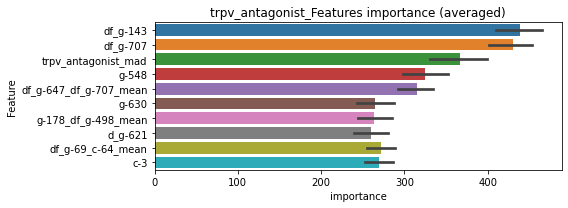

len(train_index) : 2835
len(valid_index) : 945
================================= fold 1/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104197	valid_1's binary_logloss: 0.155799
[200]	training's binary_logloss: 0.035444	valid_1's binary_logloss: 0.0794324
[300]	training's binary_logloss: 0.0139167	valid_1's binary_logloss: 0.0461041
[400]	training's binary_logloss: 0.00616815	valid_1's binary_logloss: 0.0303411
[500]	training's binary_logloss: 0.00319169	valid_1's binary_logloss: 0.0223478
[600]	training's binary_logloss: 0.00193414	valid_1's binary_logloss: 0.0184244
[700]	training's binary_logloss: 0.00133787	valid_1's binary_logloss: 0.0164228
[800]	training's binary_logloss: 0.0010246	valid_1's binary_logloss: 0.0151081
[900]	training's binary_logloss: 0.000846345	valid_1's binary_logloss: 0.0142027
Early stopping, best iteration is:
[910]	training's binary_logloss: 0.000833833	valid_1's binary_logloss: 0.0140765


len(train_index) : 2835
len(valid_index) : 945
================================= fold 2/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106529	valid_1's binary_logloss: 0.132984
[200]	training's binary_logloss: 0.0369545	valid_1's binary_logloss: 0.0637025
[300]	training's binary_logloss: 0.0150618	valid_1's binary_logloss: 0.0384008
[400]	training's binary_logloss: 0.00673127	valid_1's binary_logloss: 0.0266806
[500]	training's binary_logloss: 0.00343665	valid_1's binary_logloss: 0.0216724
[600]	training's binary_logloss: 0.00204899	valid_1's binary_logloss: 0.019211
[700]	training's binary_logloss: 0.00141015	valid_1's binary_logloss: 0.0176701
[800]	training's binary_logloss: 0.00106536	valid_1's binary_logloss: 0.017306
Early stopping, best iteration is:
[770]	training's binary_logloss: 0.00114777	valid_1's binary_logloss: 0.0172968


len(train_index) : 2835
len(valid_index) : 945
================================= fold 3/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104928	valid_1's binary_logloss: 0.142791
[200]	training's binary_logloss: 0.0367336	valid_1's binary_logloss: 0.0728649
[300]	training's binary_logloss: 0.0147065	valid_1's binary_logloss: 0.044415
[400]	training's binary_logloss: 0.00645813	valid_1's binary_logloss: 0.0309792
[500]	training's binary_logloss: 0.00324265	valid_1's binary_logloss: 0.0248156
[600]	training's binary_logloss: 0.0019514	valid_1's binary_logloss: 0.0218644
[700]	training's binary_logloss: 0.00135329	valid_1's binary_logloss: 0.020117
Early stopping, best iteration is:
[710]	training's binary_logloss: 0.00131042	valid_1's binary_logloss: 0.0199545


len(train_index) : 2835
len(valid_index) : 945
================================= fold 4/4 trpv_antagonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107338	valid_1's binary_logloss: 0.144376
[200]	training's binary_logloss: 0.0363271	valid_1's binary_logloss: 0.0725285
[300]	training's binary_logloss: 0.0144334	valid_1's binary_logloss: 0.0468269
[400]	training's binary_logloss: 0.00641114	valid_1's binary_logloss: 0.034003
[500]	training's binary_logloss: 0.00324196	valid_1's binary_logloss: 0.0281545
[600]	training's binary_logloss: 0.0019674	valid_1's binary_logloss: 0.0255318
[700]	training's binary_logloss: 0.00137585	valid_1's binary_logloss: 0.0237102
[800]	training's binary_logloss: 0.00104341	valid_1's binary_logloss: 0.0229965
[900]	training's binary_logloss: 0.000858259	valid_1's binary_logloss: 0.0225363
Early stopping, best iteration is:
[885]	training's binary_logloss: 0.0008788	valid_1's binary_logloss: 0.0224573


trpv_antagonist logloss: 0.018446274278705783


neg labels: 3289 → selected neg labels: 3253


tubulin_inhibitor, len(trt): 316, len(othr): 3253, target_rate: 0.0132695 → Adj_target_rate: 0.0111926
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.239709	valid_1's binary_logloss: 0.379404
[200]	training's binary_logloss: 0.15563	valid_1's binary_logloss: 0.35831
[300]	training's binary_logloss: 0.104198	valid_1's binary_logloss: 0.349332
[400]	training's binary_logloss: 0.0741916	valid_1's binary_logloss: 0.34584
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.0708758	valid_1's binary_logloss: 0.344718
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.238614	valid_1's binary_logloss: 0.375431
[200]	training's binary_logloss: 0.148435	valid_1's binary_logloss: 0.355787
[300]	training's binary_logloss: 0.0991973	valid_1's binary_logloss: 0.346418
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0906156	valid_1's binary_logloss: 0.344693
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.246922	valid_1's b

1 / 3 AUC score:0.805
y_Threshold: 0.1419018, Threshold: 0.3291789, pos_neg_ratio: 0.8000000
Remove_noisy_data: 643 → Positive_corect_labels: 394/3260
p_label_rate: 0.0100452 Vs.target_rate: 0.01327, Num_p_label: 40.0, conf_0:0.23043, conf_1:0.42793
threshold: 0.3291789, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 394.0/3260, y_label_rate: 0.1208589
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.119067	valid_1's binary_logloss: 0.234506
[200]	training's binary_logloss: 0.0532386	valid_1's binary_logloss: 0.191239
[300]	training's binary_logloss: 0.0266084	valid_1's binary_logloss: 0.175122
[400]	training's binary_logloss: 0.0141029	valid_1's binary_logloss: 0.170194
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.0141029	valid_1's binary_logloss: 0.170194
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122806	valid_1's binary_logloss: 0.205767
[200]	training's binary_logloss: 0.0553965	valid_1's binary_logloss: 0.16066
[300]	training's binary_logloss: 0.0280874	valid_1's binary_logloss: 0.139652
[400]	training's binary_logloss: 0.0150457	valid_1's binary_logloss: 0.130581
[500]	training's binary_logloss: 0.00858953	valid_1's binary_logloss: 0.126419
[600]	training's binary_logloss: 0.00527809	valid_1's binary_logl

2 / 3 AUC score:0.963
y_Threshold: 0.0964013, Threshold: 0.3291789, pos_neg_ratio: 0.8000000
Remove_noisy_data: 128 → Positive_corect_labels: 330.0/3132
p_label_rate: 0.0306379 Vs.target_rate: 0.01327, Num_p_label: 122.0, conf_0:0.26334, conf_1:0.39501
Num_p_label: 122.0, Expected: 52.8, Adj_threshold_1: 0.3291789
Num_p_label: 105.0, Expected: 52.8, Adj_threshold_2: 0.3791789
Num_p_label: 83.0, Expected: 52.8, Adj_threshold_3: 0.4291789
Num_p_label: 71.0, Expected: 52.8, Adj_threshold_4: 0.4791789
threshold: 0.4791789, positive_p_label: 71.0/3982, p_label_rate: 0.0178302
positive_y_label: 330.0/3132, y_label_rate: 0.1053640
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0929659	valid_1's binary_logloss: 0.172412
[200]	training's binary_logloss: 0.0372169	valid_1's binary_logloss: 0.133019
[300]	training's binary_logloss: 0.0168534	valid_1's binary_logloss: 0.113397
[400]	training's binary_logloss: 0.00828157	valid_1's binary_logloss: 0.104433
[500]	training's binary_logloss: 0.00459171	valid_1's binary_logloss: 0.101781
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00525121	valid_1's binary_logloss: 0.101315
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0901358	valid_1's binary_logloss: 0.177489
[200]	training's binary_logloss: 0.03555	valid_1's binary_logloss: 0.134138
[300]	training's binary_logloss: 0.0158745	valid_1's binary_logloss: 0.113696
[400]	training's binary_logloss: 0.0080272	valid_1's binary_logloss: 0.103642
[500]	training's binary_logloss: 0.00448973	valid_1's binary_l

3 / 3 AUC score:0.984
y_Threshold: 0.0682781, Threshold: 0.4791789, pos_neg_ratio: 0.8000000
Remove_noisy_data: 58 → Positive_corect_labels: 301.0/3074
p_label_rate: 0.0283777 Vs.target_rate: 0.01327, Num_p_label: 113.0, conf_0:0.43126, conf_1:0.52710
Num_p_label: 113.0, Expected: 52.8, Adj_threshold_1: 0.4791789
Num_p_label: 107.0, Expected: 52.8, Adj_threshold_2: 0.5291789
Num_p_label: 97.0, Expected: 52.8, Adj_threshold_3: 0.5791789
Num_p_label: 86.0, Expected: 52.8, Adj_threshold_4: 0.6291789
Num_p_label: 81.0, Expected: 52.8, Adj_threshold_5: 0.6791789
Num_p_label: 75.0, Expected: 52.8, Adj_threshold_6: 0.7291789
threshold: 0.7291789, positive_p_label: 75.0/3982, p_label_rate: 0.0188348
positive_y_label: 301.0/3074, y_label_rate: 0.0979180


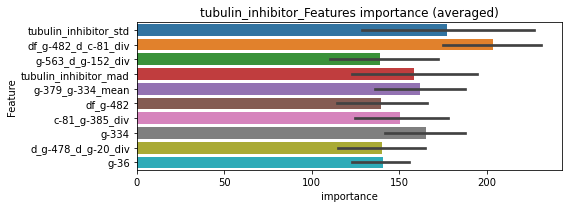

len(train_index) : 2305
len(valid_index) : 769
================================= fold 1/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0831385	valid_1's binary_logloss: 0.160475
[200]	training's binary_logloss: 0.0313413	valid_1's binary_logloss: 0.119048
[300]	training's binary_logloss: 0.0137048	valid_1's binary_logloss: 0.104736
[400]	training's binary_logloss: 0.00659877	valid_1's binary_logloss: 0.0991699
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00615405	valid_1's binary_logloss: 0.098976


len(train_index) : 2305
len(valid_index) : 769
================================= fold 2/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0806347	valid_1's binary_logloss: 0.149087
[200]	training's binary_logloss: 0.0303341	valid_1's binary_logloss: 0.107073
[300]	training's binary_logloss: 0.013105	valid_1's binary_logloss: 0.0900795
[400]	training's binary_logloss: 0.00622498	valid_1's binary_logloss: 0.0802786
[500]	training's binary_logloss: 0.00349929	valid_1's binary_logloss: 0.076484
[600]	training's binary_logloss: 0.00224505	valid_1's binary_logloss: 0.0738853
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00214249	valid_1's binary_logloss: 0.0737238


len(train_index) : 2306
len(valid_index) : 768
================================= fold 3/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824078	valid_1's binary_logloss: 0.150311
[200]	training's binary_logloss: 0.0308244	valid_1's binary_logloss: 0.107154
[300]	training's binary_logloss: 0.0130849	valid_1's binary_logloss: 0.0857283
[400]	training's binary_logloss: 0.00640458	valid_1's binary_logloss: 0.0782332
[500]	training's binary_logloss: 0.00357046	valid_1's binary_logloss: 0.0740108
[600]	training's binary_logloss: 0.00227827	valid_1's binary_logloss: 0.071406
[700]	training's binary_logloss: 0.00162695	valid_1's binary_logloss: 0.0708731
Early stopping, best iteration is:
[690]	training's binary_logloss: 0.00167298	valid_1's binary_logloss: 0.0703906


len(train_index) : 2306
len(valid_index) : 768
================================= fold 4/4 tubulin_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0837297	valid_1's binary_logloss: 0.12751
[200]	training's binary_logloss: 0.0317315	valid_1's binary_logloss: 0.079076
[300]	training's binary_logloss: 0.0141804	valid_1's binary_logloss: 0.0590569
[400]	training's binary_logloss: 0.00684369	valid_1's binary_logloss: 0.0479423
[500]	training's binary_logloss: 0.00379505	valid_1's binary_logloss: 0.0424278
[600]	training's binary_logloss: 0.00240907	valid_1's binary_logloss: 0.0384224
[700]	training's binary_logloss: 0.00170757	valid_1's binary_logloss: 0.0357631
[800]	training's binary_logloss: 0.0013185	valid_1's binary_logloss: 0.0345923
[900]	training's binary_logloss: 0.00109069	valid_1's binary_logloss: 0.0340899
Early stopping, best iteration is:
[887]	training's binary_logloss: 0.0011167	valid_1's binary_logloss: 0.0339133


tubulin_inhibitor logloss: 0.06926204799572745


neg labels: 3289 → selected neg labels: 3281


tyrosine_kinase_inhibitor, len(trt): 73, len(othr): 3281, target_rate: 0.0030654 → Adj_target_rate: 0.0032212
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.132986	valid_1's binary_logloss: 0.200724
[200]	training's binary_logloss: 0.0585614	valid_1's binary_logloss: 0.129426
[300]	training's binary_logloss: 0.0292617	valid_1's binary_logloss: 0.0957459
[400]	training's binary_logloss: 0.0151481	valid_1's binary_logloss: 0.0764338
[500]	training's binary_logloss: 0.0082415	valid_1's binary_logloss: 0.0648465
[600]	training's binary_logloss: 0.00477642	valid_1's binary_logloss: 0.0572014
[700]	training's binary_logloss: 0.00308105	valid_1's binary_logloss: 0.0534475
[800]	training's binary_logloss: 0.00214783	valid_1's binary_logloss: 0.0507364
[900]	training's binary_logloss: 0.00164349	valid_1's binary_logloss: 0.0496777
[1000]	training's binary_logloss: 0.00132654	valid_1's binary_logloss: 0.0490696
[1100]	training's binary_logloss: 0.00113931	valid_1's binary_logloss: 0.0482823
[1200]	training's binary_logloss: 0.00101756	valid_1's binary_log

1 / 3 AUC score:0.992
y_Threshold: 0.0275486, Threshold: 0.2102169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 172 → Positive_corect_labels: 636/3765
p_label_rate: 0.0100452 Vs.target_rate: 0.00307, Num_p_label: 40.0, conf_0:0.14715, conf_1:0.27328
Num_p_label: 40.0, Expected: 12.2, Adj_threshold_1: 0.2102169
Num_p_label: 29.0, Expected: 12.2, Adj_threshold_2: 0.2602169
Num_p_label: 22.0, Expected: 12.2, Adj_threshold_3: 0.3102169
Num_p_label: 17.0, Expected: 12.2, Adj_threshold_4: 0.3602169
threshold: 0.3602169, positive_p_label: 17.0/3982, p_label_rate: 0.0042692
positive_y_label: 636.0/3765, y_label_rate: 0.1689243
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.122281	valid_1's binary_logloss: 0.187684
[200]	training's binary_logloss: 0.0492075	valid_1's binary_logloss: 0.117168
[300]	training's binary_logloss: 0.0225846	valid_1's binary_logloss: 0.0874272
[400]	training's binary_logloss: 0.0108173	valid_1's binary_logloss: 0.0727195
[500]	training's binary_logloss: 0.00564059	valid_1's binary_logloss: 0.0653351
[600]	training's binary_logloss: 0.0032884	valid_1's binary_logloss: 0.0619635
[700]	training's binary_logloss: 0.002164	valid_1's binary_logloss: 0.0598615
Early stopping, best iteration is:
[677]	training's binary_logloss: 0.00235735	valid_1's binary_logloss: 0.0597428
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.121907	valid_1's binary_logloss: 0.172784
[200]	training's binary_logloss: 0.0488874	valid_1's binary_logloss: 0.103652
[300]	training's binary_logloss: 0.022258	valid_1's binary

2 / 3 AUC score:0.999
y_Threshold: 0.1358348, Threshold: 0.3602169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 36 → Positive_corect_labels: 618.0/3729
p_label_rate: 0.0198393 Vs.target_rate: 0.00307, Num_p_label: 79.0, conf_0:0.28817, conf_1:0.43226
Num_p_label: 79.0, Expected: 12.2, Adj_threshold_1: 0.3602169
Num_p_label: 70.0, Expected: 12.2, Adj_threshold_2: 0.4102169
Num_p_label: 66.0, Expected: 12.2, Adj_threshold_3: 0.4602169
Num_p_label: 58.0, Expected: 12.2, Adj_threshold_4: 0.5102169
Num_p_label: 52.0, Expected: 12.2, Adj_threshold_5: 0.5602169
Num_p_label: 45.0, Expected: 12.2, Adj_threshold_6: 0.6102169
Num_p_label: 37.0, Expected: 12.2, Adj_threshold_7: 0.6602169
Num_p_label: 33.0, Expected: 12.2, Adj_threshold_8: 0.7102169
Num_p_label: 31.0, Expected: 12.2, Adj_threshold_9: 0.7602169
threshold: 0.7602169, positive_p_label: 31.0/3982, p_label_rate: 0.0077850
positive_y_label: 618.0/3729, y_label_rate: 0.1657281
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118082	valid_1's binary_logloss: 0.178374
[200]	training's binary_logloss: 0.0462563	valid_1's binary_logloss: 0.103735
[300]	training's binary_logloss: 0.0217309	valid_1's binary_logloss: 0.0710634
[400]	training's binary_logloss: 0.0106448	valid_1's binary_logloss: 0.0537438
[500]	training's binary_logloss: 0.0054375	valid_1's binary_logloss: 0.0423738
[600]	training's binary_logloss: 0.00317157	valid_1's binary_logloss: 0.0355032
[700]	training's binary_logloss: 0.00206704	valid_1's binary_logloss: 0.0314896
[800]	training's binary_logloss: 0.00151124	valid_1's binary_logloss: 0.0290385
[900]	training's binary_logloss: 0.00118909	valid_1's binary_logloss: 0.0280317
Early stopping, best iteration is:
[928]	training's binary_logloss: 0.00112538	valid_1's binary_logloss: 0.0276994
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.118143	valid_1's

3 / 3 AUC score:0.999
y_Threshold: 0.1511741, Threshold: 0.7602169, pos_neg_ratio: 0.8000000
Remove_noisy_data: 22 → Positive_corect_labels: 607.0/3707
p_label_rate: 0.0128076 Vs.target_rate: 0.00307, Num_p_label: 51.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 51.0, Expected: 12.2, Adj_threshold_1: 0.7602169
threshold: 0.7602169, positive_p_label: 51.0/3982, p_label_rate: 0.0128076
positive_y_label: 607.0/3707, y_label_rate: 0.1637443


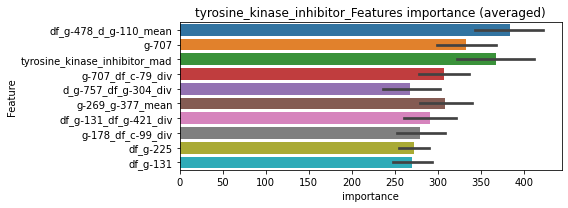

len(train_index) : 2780
len(valid_index) : 927
================================= fold 1/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.111521	valid_1's binary_logloss: 0.168643
[200]	training's binary_logloss: 0.0430785	valid_1's binary_logloss: 0.107096
[300]	training's binary_logloss: 0.0190855	valid_1's binary_logloss: 0.0815201
[400]	training's binary_logloss: 0.00901116	valid_1's binary_logloss: 0.0710082
[500]	training's binary_logloss: 0.00456739	valid_1's binary_logloss: 0.0653996
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00322424	valid_1's binary_logloss: 0.0644057


len(train_index) : 2780
len(valid_index) : 927
================================= fold 2/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.112053	valid_1's binary_logloss: 0.16781
[200]	training's binary_logloss: 0.0419479	valid_1's binary_logloss: 0.100558
[300]	training's binary_logloss: 0.018046	valid_1's binary_logloss: 0.0727993
[400]	training's binary_logloss: 0.00838273	valid_1's binary_logloss: 0.0601912
[500]	training's binary_logloss: 0.00432386	valid_1's binary_logloss: 0.0544167
[600]	training's binary_logloss: 0.00258068	valid_1's binary_logloss: 0.0529478
Early stopping, best iteration is:
[666]	training's binary_logloss: 0.00197116	valid_1's binary_logloss: 0.0516538


len(train_index) : 2780
len(valid_index) : 927
================================= fold 3/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115379	valid_1's binary_logloss: 0.16448
[200]	training's binary_logloss: 0.04512	valid_1's binary_logloss: 0.0957358
[300]	training's binary_logloss: 0.0193613	valid_1's binary_logloss: 0.0667757
[400]	training's binary_logloss: 0.00891056	valid_1's binary_logloss: 0.0518854
[500]	training's binary_logloss: 0.0044979	valid_1's binary_logloss: 0.0434865
[600]	training's binary_logloss: 0.00262119	valid_1's binary_logloss: 0.0388221
[700]	training's binary_logloss: 0.00177219	valid_1's binary_logloss: 0.0356698
[800]	training's binary_logloss: 0.00132027	valid_1's binary_logloss: 0.0333438
[900]	training's binary_logloss: 0.00106147	valid_1's binary_logloss: 0.032259
[1000]	training's binary_logloss: 0.000907555	valid_1's binary_logloss: 0.0315154
[1100]	training's binary_logloss: 0.00082731	valid_1's binary_logloss: 0.0314295
Early stopping, best iteration is:
[1076]	training's binary_loglos

len(train_index) : 2781
len(valid_index) : 926
================================= fold 4/4 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.115621	valid_1's binary_logloss: 0.160597
[200]	training's binary_logloss: 0.045411	valid_1's binary_logloss: 0.0941622
[300]	training's binary_logloss: 0.0198213	valid_1's binary_logloss: 0.0662214
[400]	training's binary_logloss: 0.00918759	valid_1's binary_logloss: 0.0524892
[500]	training's binary_logloss: 0.0047333	valid_1's binary_logloss: 0.0434549
[600]	training's binary_logloss: 0.00280964	valid_1's binary_logloss: 0.0390934
[700]	training's binary_logloss: 0.00185697	valid_1's binary_logloss: 0.0361752
[800]	training's binary_logloss: 0.00137147	valid_1's binary_logloss: 0.0343299
[900]	training's binary_logloss: 0.00109767	valid_1's binary_logloss: 0.0333054
[1000]	training's binary_logloss: 0.000932572	valid_1's binary_logloss: 0.0323611
[1100]	training's binary_logloss: 0.000840873	valid_1's binary_logloss: 0.0319281
[1200]	training's binary_logloss: 0.000798295	valid_1's binary

tyrosine_kinase_inhibitor logloss: 0.04468085952891197


neg labels: 3289 → selected neg labels: 3287


ubiquitin_specific_protease_inhibitor, len(trt): 12, len(othr): 3287, target_rate: 0.0005039 → Adj_target_rate: 0.0006942
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0634578	valid_1's binary_logloss: 0.072253
[200]	training's binary_logloss: 0.0158143	valid_1's binary_logloss: 0.0211857
[300]	training's binary_logloss: 0.00458836	valid_1's binary_logloss: 0.00827132
[400]	training's binary_logloss: 0.0017583	valid_1's binary_logloss: 0.00419994
[500]	training's binary_logloss: 0.000926971	valid_1's binary_logloss: 0.00273784
[600]	training's binary_logloss: 0.000602967	valid_1's binary_logloss: 0.00211415
[700]	training's binary_logloss: 0.000449552	valid_1's binary_logloss: 0.00175706
[800]	training's binary_logloss: 0.000378763	valid_1's binary_logloss: 0.00160056
[900]	training's binary_logloss: 0.00036098	valid_1's binary_logloss: 0.00155827
Early stopping, best iteration is:
[875]	training's binary_logloss: 0.000362342	valid_1's binary_logloss: 0.00155444
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0

1 / 3 AUC score:1.000
y_Threshold: 0.0028556, Threshold: 0.0150121, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00050, Num_p_label: 40.0, conf_0:0.01051, conf_1:0.01952
Num_p_label: 40.0, Expected: 2.0, Adj_threshold_1: 0.0150121
Num_p_label: 14.0, Expected: 2.0, Adj_threshold_2: 0.0650121
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_3: 0.1150121
Num_p_label: 4.0, Expected: 2.0, Adj_threshold_4: 0.1650121
threshold: 0.1650121, positive_p_label: 4.0/3982, p_label_rate: 0.0010045
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0614249	valid_1's binary_logloss: 0.0711125
[200]	training's binary_logloss: 0.0133786	valid_1's binary_logloss: 0.017951
[300]	training's binary_logloss: 0.00369187	valid_1's binary_logloss: 0.00607926
[400]	training's binary_logloss: 0.00143104	valid_1's binary_logloss: 0.00283918
[500]	training's binary_logloss: 0.000759277	valid_1's binary_logloss: 0.00171188
[600]	training's binary_logloss: 0.000494531	valid_1's binary_logloss: 0.00121521
[700]	training's binary_logloss: 0.00037364	valid_1's binary_logloss: 0.000986619
[800]	training's binary_logloss: 0.000324217	valid_1's binary_logloss: 0.000889297
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.000316346	valid_1's binary_logloss: 0.000870499
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0612815	valid_1's binary_logloss: 0.0712216
[200]	training's binary_logloss: 

2 / 3 AUC score:1.000
y_Threshold: 0.1620277, Threshold: 0.1650121, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0047715 Vs.target_rate: 0.00050, Num_p_label: 19.0, conf_0:0.13201, conf_1:0.19801
Num_p_label: 19.0, Expected: 2.0, Adj_threshold_1: 0.1650121
Num_p_label: 12.0, Expected: 2.0, Adj_threshold_2: 0.2150121
Num_p_label: 9.0, Expected: 2.0, Adj_threshold_3: 0.2650121
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_4: 0.3150121
Num_p_label: 6.0, Expected: 2.0, Adj_threshold_5: 0.3650121
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_6: 0.4150121
threshold: 0.4150121, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0614249	valid_1's binary_logloss: 0.0711125
[200]	training's binary_logloss: 0.0133786	valid_1's binary_logloss: 0.017951
[300]	training's binary_logloss: 0.00369187	valid_1's binary_logloss: 0.00607926
[400]	training's binary_logloss: 0.00143104	valid_1's binary_logloss: 0.00283918
[500]	training's binary_logloss: 0.000759277	valid_1's binary_logloss: 0.00171188
[600]	training's binary_logloss: 0.000494531	valid_1's binary_logloss: 0.00121521
[700]	training's binary_logloss: 0.00037364	valid_1's binary_logloss: 0.000986619
[800]	training's binary_logloss: 0.000324217	valid_1's binary_logloss: 0.000889297
Early stopping, best iteration is:
[841]	training's binary_logloss: 0.000316346	valid_1's binary_logloss: 0.000870499
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0612815	valid_1's binary_logloss: 0.0712216
[200]	training's binary_logloss: 

3 / 3 AUC score:1.000
y_Threshold: 0.1620277, Threshold: 0.4150121, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 657.0/3812
p_label_rate: 0.0012557 Vs.target_rate: 0.00050, Num_p_label: 5.0, conf_0:0.37351, conf_1:0.45651
Num_p_label: 5.0, Expected: 2.0, Adj_threshold_1: 0.4150121
threshold: 0.4150121, positive_p_label: 5.0/3982, p_label_rate: 0.0012557
positive_y_label: 657.0/3812, y_label_rate: 0.1723505


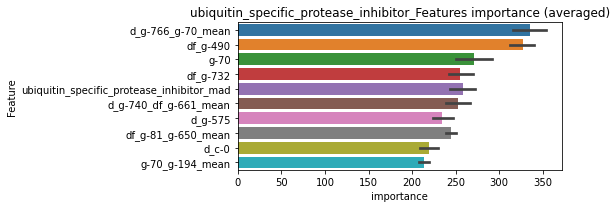

len(train_index) : 2859
len(valid_index) : 953
================================= fold 1/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0622653	valid_1's binary_logloss: 0.0715946
[200]	training's binary_logloss: 0.0136894	valid_1's binary_logloss: 0.0185035
[300]	training's binary_logloss: 0.00381218	valid_1's binary_logloss: 0.00643423
[400]	training's binary_logloss: 0.00145352	valid_1's binary_logloss: 0.00290512
[500]	training's binary_logloss: 0.000768794	valid_1's binary_logloss: 0.0017417
[600]	training's binary_logloss: 0.00050054	valid_1's binary_logloss: 0.00123068
[700]	training's binary_logloss: 0.000381297	valid_1's binary_logloss: 0.00100522
[800]	training's binary_logloss: 0.000326996	valid_1's binary_logloss: 0.000890078
[900]	training's binary_logloss: 0.000313855	valid_1's binary_logloss: 0.000862366
Early stopping, best iteration is:
[890]	training's binary_logloss: 0.000313855	valid_1's binary_logloss: 0.000862366


len(train_index) : 2859
len(valid_index) : 953
================================= fold 2/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0613764	valid_1's binary_logloss: 0.0713247
[200]	training's binary_logloss: 0.0136266	valid_1's binary_logloss: 0.0185997
[300]	training's binary_logloss: 0.00378874	valid_1's binary_logloss: 0.00622206
[400]	training's binary_logloss: 0.00145465	valid_1's binary_logloss: 0.00278201
[500]	training's binary_logloss: 0.000767479	valid_1's binary_logloss: 0.00166067
[600]	training's binary_logloss: 0.000498878	valid_1's binary_logloss: 0.00113933
[700]	training's binary_logloss: 0.000375882	valid_1's binary_logloss: 0.000902187
[800]	training's binary_logloss: 0.000325989	valid_1's binary_logloss: 0.000813224
Early stopping, best iteration is:
[823]	training's binary_logloss: 0.000323952	valid_1's binary_logloss: 0.000808625


len(train_index) : 2859
len(valid_index) : 953
================================= fold 3/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0612322	valid_1's binary_logloss: 0.071165
[200]	training's binary_logloss: 0.0134422	valid_1's binary_logloss: 0.0177777
[300]	training's binary_logloss: 0.00376069	valid_1's binary_logloss: 0.00588531
[400]	training's binary_logloss: 0.00145993	valid_1's binary_logloss: 0.00268354
[500]	training's binary_logloss: 0.000766556	valid_1's binary_logloss: 0.00158399
[600]	training's binary_logloss: 0.000506479	valid_1's binary_logloss: 0.00110229
[700]	training's binary_logloss: 0.000379287	valid_1's binary_logloss: 0.000863329
[800]	training's binary_logloss: 0.000327261	valid_1's binary_logloss: 0.000764973
Early stopping, best iteration is:
[825]	training's binary_logloss: 0.000322942	valid_1's binary_logloss: 0.000757278


len(train_index) : 2859
len(valid_index) : 953
================================= fold 4/4 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0616446	valid_1's binary_logloss: 0.0719448
[200]	training's binary_logloss: 0.0135935	valid_1's binary_logloss: 0.0191079
[300]	training's binary_logloss: 0.00379916	valid_1's binary_logloss: 0.00674346
[400]	training's binary_logloss: 0.00146694	valid_1's binary_logloss: 0.0032272
[500]	training's binary_logloss: 0.000769922	valid_1's binary_logloss: 0.00188434
[600]	training's binary_logloss: 0.000506679	valid_1's binary_logloss: 0.00137984
[700]	training's binary_logloss: 0.000379222	valid_1's binary_logloss: 0.00110944
[800]	training's binary_logloss: 0.000326109	valid_1's binary_logloss: 0.00101378
[900]	training's binary_logloss: 0.000309951	valid_1's binary_logloss: 0.000982056
Early stopping, best iteration is:
[891]	training's binary_logloss: 0.000309951	valid_1's binary_logloss: 0.000982056


ubiquitin_specific_protease_inhibitor logloss: 0.0008525929554946455


neg labels: 3289 → selected neg labels: 3264


vegfr_inhibitor, len(trt): 170, len(othr): 3264, target_rate: 0.0071387 → Adj_target_rate: 0.0066081
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.203834	valid_1's binary_logloss: 0.315749
[200]	training's binary_logloss: 0.111498	valid_1's binary_logloss: 0.264211
[300]	training's binary_logloss: 0.0664951	valid_1's binary_logloss: 0.238394
[400]	training's binary_logloss: 0.0418279	valid_1's binary_logloss: 0.225201
[500]	training's binary_logloss: 0.0262564	valid_1's binary_logloss: 0.217162
[600]	training's binary_logloss: 0.0163657	valid_1's binary_logloss: 0.214436
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.0151685	valid_1's binary_logloss: 0.213816
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.207061	valid_1's binary_logloss: 0.300672
[200]	training's binary_logloss: 0.1207	valid_1's binary_logloss: 0.247395
[300]	training's binary_logloss: 0.0751882	valid_1's binary_logloss: 0.218208
[400]	training's binary_logloss: 0.0487779	valid_1's binary_logloss: 

1 / 3 AUC score:0.933
y_Threshold: 0.0837810, Threshold: 0.3874435, pos_neg_ratio: 0.8000000
Remove_noisy_data: 344 → Positive_corect_labels: 546/3572
p_label_rate: 0.0100452 Vs.target_rate: 0.00714, Num_p_label: 40.0, conf_0:0.27121, conf_1:0.50368
threshold: 0.3874435, positive_p_label: 40.0/3982, p_label_rate: 0.0100452
positive_y_label: 546.0/3572, y_label_rate: 0.1528555
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.141128	valid_1's binary_logloss: 0.214794
[200]	training's binary_logloss: 0.0624595	valid_1's binary_logloss: 0.154801
[300]	training's binary_logloss: 0.0311093	valid_1's binary_logloss: 0.130654
[400]	training's binary_logloss: 0.0164714	valid_1's binary_logloss: 0.117146
[500]	training's binary_logloss: 0.00917525	valid_1's binary_logloss: 0.11285
[600]	training's binary_logloss: 0.00550252	valid_1's binary_logloss: 0.109008
Early stopping, best iteration is:
[606]	training's binary_logloss: 0.00535957	valid_1's binary_logloss: 0.108712
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.147241	valid_1's binary_logloss: 0.227766
[200]	training's binary_logloss: 0.066305	valid_1's binary_logloss: 0.170363
[300]	training's binary_logloss: 0.0329745	valid_1's binary_logloss: 0.143617
[400]	training's binary_logloss: 0.0171548	valid_1's binary_logl

2 / 3 AUC score:0.981
y_Threshold: 0.1006111, Threshold: 0.3874435, pos_neg_ratio: 0.8000000
Remove_noisy_data: 118 → Positive_corect_labels: 487.0/3454
p_label_rate: 0.0273732 Vs.target_rate: 0.00714, Num_p_label: 109.0, conf_0:0.30995, conf_1:0.46493
Num_p_label: 109.0, Expected: 28.4, Adj_threshold_1: 0.3874435
Num_p_label: 98.0, Expected: 28.4, Adj_threshold_2: 0.4374435
Num_p_label: 86.0, Expected: 28.4, Adj_threshold_3: 0.4874435
Num_p_label: 74.0, Expected: 28.4, Adj_threshold_4: 0.5374435
Num_p_label: 64.0, Expected: 28.4, Adj_threshold_5: 0.5874435
Num_p_label: 55.0, Expected: 28.4, Adj_threshold_6: 0.6374435
Num_p_label: 46.0, Expected: 28.4, Adj_threshold_7: 0.6874435
Num_p_label: 41.0, Expected: 28.4, Adj_threshold_8: 0.7374435
threshold: 0.7374435, positive_p_label: 41.0/3982, p_label_rate: 0.0102963
positive_y_label: 487.0/3454, y_label_rate: 0.1409959
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.116877	valid_1's binary_logloss: 0.193168
[200]	training's binary_logloss: 0.0461357	valid_1's binary_logloss: 0.133877
[300]	training's binary_logloss: 0.0205618	valid_1's binary_logloss: 0.107263
[400]	training's binary_logloss: 0.00994571	valid_1's binary_logloss: 0.0945481
[500]	training's binary_logloss: 0.0053118	valid_1's binary_logloss: 0.0894325
[600]	training's binary_logloss: 0.0032251	valid_1's binary_logloss: 0.0869321
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.00263672	valid_1's binary_logloss: 0.0856856
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.117968	valid_1's binary_logloss: 0.176469
[200]	training's binary_logloss: 0.0473015	valid_1's binary_logloss: 0.122757
[300]	training's binary_logloss: 0.020865	valid_1's binary_logloss: 0.100631
[400]	training's binary_logloss: 0.0102638	valid_1's binary_

3 / 3 AUC score:0.990
y_Threshold: 0.0935155, Threshold: 0.7374435, pos_neg_ratio: 0.8000000
Remove_noisy_data: 54 → Positive_corect_labels: 460.0/3400
p_label_rate: 0.0220994 Vs.target_rate: 0.00714, Num_p_label: 88.0, conf_0:0.50000, conf_1:0.80000
Num_p_label: 88.0, Expected: 28.4, Adj_threshold_1: 0.7374435
Num_p_label: 83.0, Expected: 28.4, Adj_threshold_2: 0.7874435
threshold: 0.7874435, positive_p_label: 83.0/3982, p_label_rate: 0.0208438
positive_y_label: 460.0/3400, y_label_rate: 0.1352941


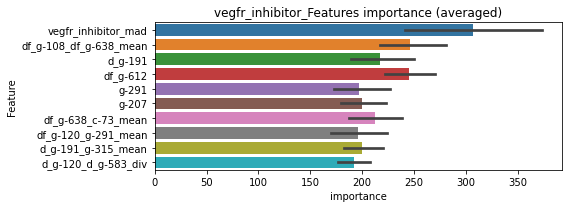

len(train_index) : 2550
len(valid_index) : 850
================================= fold 1/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104769	valid_1's binary_logloss: 0.174212
[200]	training's binary_logloss: 0.0390803	valid_1's binary_logloss: 0.124337
[300]	training's binary_logloss: 0.0171011	valid_1's binary_logloss: 0.10495
[400]	training's binary_logloss: 0.00815998	valid_1's binary_logloss: 0.0976486
[500]	training's binary_logloss: 0.00433129	valid_1's binary_logloss: 0.0948935
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.00456553	valid_1's binary_logloss: 0.0944466


len(train_index) : 2550
len(valid_index) : 850
================================= fold 2/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108733	valid_1's binary_logloss: 0.168009
[200]	training's binary_logloss: 0.0398691	valid_1's binary_logloss: 0.102043
[300]	training's binary_logloss: 0.0173845	valid_1's binary_logloss: 0.0726869
[400]	training's binary_logloss: 0.00829929	valid_1's binary_logloss: 0.0584781
[500]	training's binary_logloss: 0.00443989	valid_1's binary_logloss: 0.0509016
[600]	training's binary_logloss: 0.00272131	valid_1's binary_logloss: 0.0464499
[700]	training's binary_logloss: 0.00187062	valid_1's binary_logloss: 0.0428203
[800]	training's binary_logloss: 0.00141733	valid_1's binary_logloss: 0.0415541
[900]	training's binary_logloss: 0.00114778	valid_1's binary_logloss: 0.0406952
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.00115924	valid_1's binary_logloss: 0.0405436


len(train_index) : 2550
len(valid_index) : 850
================================= fold 3/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.108639	valid_1's binary_logloss: 0.160813
[200]	training's binary_logloss: 0.0409018	valid_1's binary_logloss: 0.100125
[300]	training's binary_logloss: 0.0176113	valid_1's binary_logloss: 0.0750036
[400]	training's binary_logloss: 0.00827029	valid_1's binary_logloss: 0.0619575
[500]	training's binary_logloss: 0.00445385	valid_1's binary_logloss: 0.0556222
[600]	training's binary_logloss: 0.00271519	valid_1's binary_logloss: 0.0520317
[700]	training's binary_logloss: 0.00187135	valid_1's binary_logloss: 0.0500877
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00156987	valid_1's binary_logloss: 0.0488738


len(train_index) : 2550
len(valid_index) : 850
================================= fold 4/4 vegfr_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107525	valid_1's binary_logloss: 0.164335
[200]	training's binary_logloss: 0.0401892	valid_1's binary_logloss: 0.0997198
[300]	training's binary_logloss: 0.0176168	valid_1's binary_logloss: 0.0719536
[400]	training's binary_logloss: 0.00833057	valid_1's binary_logloss: 0.0572394
[500]	training's binary_logloss: 0.00444396	valid_1's binary_logloss: 0.0494812
[600]	training's binary_logloss: 0.00270558	valid_1's binary_logloss: 0.0454496
[700]	training's binary_logloss: 0.00186225	valid_1's binary_logloss: 0.0425847
Early stopping, best iteration is:
[760]	training's binary_logloss: 0.00156111	valid_1's binary_logloss: 0.0417187


vegfr_inhibitor logloss: 0.056395691032496295


neg labels: 3289 → selected neg labels: 3286


vitamin_b, len(trt): 26, len(othr): 3286, target_rate: 0.0010918 → Adj_target_rate: 0.0013394
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0855849	valid_1's binary_logloss: 0.115003
[200]	training's binary_logloss: 0.0268029	valid_1's binary_logloss: 0.0483729
[300]	training's binary_logloss: 0.00943555	valid_1's binary_logloss: 0.0251845
[400]	training's binary_logloss: 0.00383529	valid_1's binary_logloss: 0.0160859
[500]	training's binary_logloss: 0.001939	valid_1's binary_logloss: 0.0124993
[600]	training's binary_logloss: 0.00120372	valid_1's binary_logloss: 0.011048
[700]	training's binary_logloss: 0.000866059	valid_1's binary_logloss: 0.0102162
[800]	training's binary_logloss: 0.000684688	valid_1's binary_logloss: 0.00956925
Early stopping, best iteration is:
[858]	training's binary_logloss: 0.000614359	valid_1's binary_logloss: 0.00944683
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0873103	valid_1's binary_logloss: 0.111572
[200]	training's binary_logloss: 0.0270057	val

1 / 3 AUC score:1.000
y_Threshold: 0.0078851, Threshold: 0.0382482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 134 → Positive_corect_labels: 656/3809
p_label_rate: 0.0100452 Vs.target_rate: 0.00109, Num_p_label: 40.0, conf_0:0.02677, conf_1:0.04972
Num_p_label: 40.0, Expected: 4.3, Adj_threshold_1: 0.0382482
Num_p_label: 21.0, Expected: 4.3, Adj_threshold_2: 0.0882482
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_3: 0.1382482
Num_p_label: 7.0, Expected: 4.3, Adj_threshold_4: 0.1882482
threshold: 0.1882482, positive_p_label: 7.0/3982, p_label_rate: 0.0017579
positive_y_label: 656.0/3809, y_label_rate: 0.1722237
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0835595	valid_1's binary_logloss: 0.106923
[200]	training's binary_logloss: 0.0244648	valid_1's binary_logloss: 0.0448245
[300]	training's binary_logloss: 0.0080336	valid_1's binary_logloss: 0.024231
[400]	training's binary_logloss: 0.00322011	valid_1's binary_logloss: 0.0173136
[500]	training's binary_logloss: 0.00165678	valid_1's binary_logloss: 0.0144333
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00131214	valid_1's binary_logloss: 0.0138068
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0853427	valid_1's binary_logloss: 0.109622
[200]	training's binary_logloss: 0.0243696	valid_1's binary_logloss: 0.0403888
[300]	training's binary_logloss: 0.00814116	valid_1's binary_logloss: 0.0178677
[400]	training's binary_logloss: 0.00331216	valid_1's binary_logloss: 0.00960076
[500]	training's binary_logloss: 0.00167454	valid_

2 / 3 AUC score:1.000
y_Threshold: 0.0863073, Threshold: 0.1882482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 8 → Positive_corect_labels: 652.0/3801
p_label_rate: 0.0082873 Vs.target_rate: 0.00109, Num_p_label: 33.0, conf_0:0.15060, conf_1:0.22590
Num_p_label: 33.0, Expected: 4.3, Adj_threshold_1: 0.1882482
Num_p_label: 27.0, Expected: 4.3, Adj_threshold_2: 0.2382482
Num_p_label: 20.0, Expected: 4.3, Adj_threshold_3: 0.2882482
Num_p_label: 18.0, Expected: 4.3, Adj_threshold_4: 0.3382482
Num_p_label: 14.0, Expected: 4.3, Adj_threshold_5: 0.3882482
Num_p_label: 10.0, Expected: 4.3, Adj_threshold_6: 0.4382482
threshold: 0.4382482, positive_p_label: 10.0/3982, p_label_rate: 0.0025113
positive_y_label: 652.0/3801, y_label_rate: 0.1715338
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0828719	valid_1's binary_logloss: 0.10994
[200]	training's binary_logloss: 0.0236538	valid_1's binary_logloss: 0.0450506
[300]	training's binary_logloss: 0.00793217	valid_1's binary_logloss: 0.0247723
[400]	training's binary_logloss: 0.00319356	valid_1's binary_logloss: 0.0168574
[500]	training's binary_logloss: 0.00163745	valid_1's binary_logloss: 0.0137826
[600]	training's binary_logloss: 0.0010279	valid_1's binary_logloss: 0.0118788
[700]	training's binary_logloss: 0.000742986	valid_1's binary_logloss: 0.0111637
Early stopping, best iteration is:
[737]	training's binary_logloss: 0.000673382	valid_1's binary_logloss: 0.0110156
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0824262	valid_1's binary_logloss: 0.102967
[200]	training's binary_logloss: 0.023592	valid_1's binary_logloss: 0.0375871
[300]	training's binary_logloss: 0.00785692	valid_

3 / 3 AUC score:1.000
y_Threshold: 0.0971842, Threshold: 0.4382482, pos_neg_ratio: 0.8000000
Remove_noisy_data: 0 → Positive_corect_labels: 652.0/3801
p_label_rate: 0.0032647 Vs.target_rate: 0.00109, Num_p_label: 13.0, conf_0:0.39442, conf_1:0.48207
Num_p_label: 13.0, Expected: 4.3, Adj_threshold_1: 0.4382482
Num_p_label: 8.0, Expected: 4.3, Adj_threshold_2: 0.4882482
threshold: 0.4882482, positive_p_label: 8.0/3982, p_label_rate: 0.0020090
positive_y_label: 652.0/3801, y_label_rate: 0.1715338


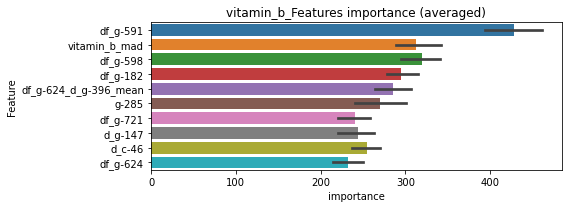

len(train_index) : 2850
len(valid_index) : 951
================================= fold 1/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839069	valid_1's binary_logloss: 0.112156
[200]	training's binary_logloss: 0.0237668	valid_1's binary_logloss: 0.046644
[300]	training's binary_logloss: 0.00795987	valid_1's binary_logloss: 0.0249968
[400]	training's binary_logloss: 0.00319882	valid_1's binary_logloss: 0.0167308
[500]	training's binary_logloss: 0.00163655	valid_1's binary_logloss: 0.0132637
[600]	training's binary_logloss: 0.00102951	valid_1's binary_logloss: 0.0116559
[700]	training's binary_logloss: 0.000744274	valid_1's binary_logloss: 0.0106951
[800]	training's binary_logloss: 0.000590756	valid_1's binary_logloss: 0.0103925
[900]	training's binary_logloss: 0.000501779	valid_1's binary_logloss: 0.0102034
Early stopping, best iteration is:
[895]	training's binary_logloss: 0.000505718	valid_1's binary_logloss: 0.0101653


len(train_index) : 2851
len(valid_index) : 950
================================= fold 2/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0839224	valid_1's binary_logloss: 0.1045
[200]	training's binary_logloss: 0.0238985	valid_1's binary_logloss: 0.0380991
[300]	training's binary_logloss: 0.00796667	valid_1's binary_logloss: 0.0169771
[400]	training's binary_logloss: 0.00318181	valid_1's binary_logloss: 0.0094295
[500]	training's binary_logloss: 0.00163155	valid_1's binary_logloss: 0.00632652
[600]	training's binary_logloss: 0.00102987	valid_1's binary_logloss: 0.00504116
[700]	training's binary_logloss: 0.000747119	valid_1's binary_logloss: 0.00438838
[800]	training's binary_logloss: 0.000589727	valid_1's binary_logloss: 0.00398643
[900]	training's binary_logloss: 0.000499825	valid_1's binary_logloss: 0.00377547
[1000]	training's binary_logloss: 0.000461148	valid_1's binary_logloss: 0.00367707
Early stopping, best iteration is:
[994]	training's binary_logloss: 0.000463203	valid_1's binary_logloss: 0.00366701


len(train_index) : 2851
len(valid_index) : 950
================================= fold 3/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0829733	valid_1's binary_logloss: 0.108783
[200]	training's binary_logloss: 0.0238808	valid_1's binary_logloss: 0.0400348
[300]	training's binary_logloss: 0.00796936	valid_1's binary_logloss: 0.0188876
[400]	training's binary_logloss: 0.00321617	valid_1's binary_logloss: 0.0105639
[500]	training's binary_logloss: 0.00164764	valid_1's binary_logloss: 0.00723981
[600]	training's binary_logloss: 0.00103007	valid_1's binary_logloss: 0.00532858
[700]	training's binary_logloss: 0.000750178	valid_1's binary_logloss: 0.00451584
[800]	training's binary_logloss: 0.000593806	valid_1's binary_logloss: 0.00402275
[900]	training's binary_logloss: 0.000503324	valid_1's binary_logloss: 0.00371908
[1000]	training's binary_logloss: 0.000463077	valid_1's binary_logloss: 0.00359519
Early stopping, best iteration is:
[1007]	training's binary_logloss: 0.000461648	valid_1's binary_logloss: 0.00359208


len(train_index) : 2851
len(valid_index) : 950
================================= fold 4/4 vitamin_b=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0825072	valid_1's binary_logloss: 0.102317
[200]	training's binary_logloss: 0.0235764	valid_1's binary_logloss: 0.0392234
[300]	training's binary_logloss: 0.00787084	valid_1's binary_logloss: 0.019536
[400]	training's binary_logloss: 0.00319108	valid_1's binary_logloss: 0.0123925
[500]	training's binary_logloss: 0.00162241	valid_1's binary_logloss: 0.00989483
[600]	training's binary_logloss: 0.00101631	valid_1's binary_logloss: 0.00868962
[700]	training's binary_logloss: 0.000738581	valid_1's binary_logloss: 0.00819943
Early stopping, best iteration is:
[763]	training's binary_logloss: 0.000630358	valid_1's binary_logloss: 0.00784047


vitamin_b logloss: 0.006318937490876007


neg labels: 3289 → selected neg labels: 3284


vitamin_d_receptor_agonist, len(trt): 39, len(othr): 3284, target_rate: 0.0016377 → Adj_target_rate: 0.0018906
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.106814	valid_1's binary_logloss: 0.15596
[200]	training's binary_logloss: 0.0404709	valid_1's binary_logloss: 0.0857529
[300]	training's binary_logloss: 0.0169121	valid_1's binary_logloss: 0.0555103
[400]	training's binary_logloss: 0.00746612	valid_1's binary_logloss: 0.0401655
[500]	training's binary_logloss: 0.00373327	valid_1's binary_logloss: 0.0326443
[600]	training's binary_logloss: 0.00221113	valid_1's binary_logloss: 0.029192
[700]	training's binary_logloss: 0.00150142	valid_1's binary_logloss: 0.0269615
[800]	training's binary_logloss: 0.0011368	valid_1's binary_logloss: 0.025964
[900]	training's binary_logloss: 0.000922392	valid_1's binary_logloss: 0.0252412
Early stopping, best iteration is:
[880]	training's binary_logloss: 0.000956037	valid_1's binary_logloss: 0.0251967
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.109276	valid_1'

1 / 3 AUC score:1.000
y_Threshold: 0.0142217, Threshold: 0.0809107, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 656/3808
p_label_rate: 0.0100452 Vs.target_rate: 0.00164, Num_p_label: 40.0, conf_0:0.05664, conf_1:0.10518
Num_p_label: 40.0, Expected: 6.5, Adj_threshold_1: 0.0809107
Num_p_label: 23.0, Expected: 6.5, Adj_threshold_2: 0.1309107
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_3: 0.1809107
threshold: 0.1809107, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 656.0/3808, y_label_rate: 0.1722689
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101832	valid_1's binary_logloss: 0.147227
[200]	training's binary_logloss: 0.0355563	valid_1's binary_logloss: 0.0755425
[300]	training's binary_logloss: 0.0140505	valid_1's binary_logloss: 0.0474336
[400]	training's binary_logloss: 0.00612856	valid_1's binary_logloss: 0.0350443
[500]	training's binary_logloss: 0.00313954	valid_1's binary_logloss: 0.0283249
[600]	training's binary_logloss: 0.0019078	valid_1's binary_logloss: 0.0254662
[700]	training's binary_logloss: 0.00133263	valid_1's binary_logloss: 0.0235567
[800]	training's binary_logloss: 0.00101567	valid_1's binary_logloss: 0.0226461
Early stopping, best iteration is:
[796]	training's binary_logloss: 0.00102449	valid_1's binary_logloss: 0.0226221
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.107792	valid_1's binary_logloss: 0.152225
[200]	training's binary_logloss: 0.0371275	valid_1's

2 / 3 AUC score:1.000
y_Threshold: 0.0725041, Threshold: 0.1809107, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 653.0/3802
p_label_rate: 0.0107986 Vs.target_rate: 0.00164, Num_p_label: 43.0, conf_0:0.14473, conf_1:0.21709
Num_p_label: 43.0, Expected: 6.5, Adj_threshold_1: 0.1809107
Num_p_label: 35.0, Expected: 6.5, Adj_threshold_2: 0.2309107
Num_p_label: 31.0, Expected: 6.5, Adj_threshold_3: 0.2809107
Num_p_label: 26.0, Expected: 6.5, Adj_threshold_4: 0.3309107
Num_p_label: 19.0, Expected: 6.5, Adj_threshold_5: 0.3809107
Num_p_label: 18.0, Expected: 6.5, Adj_threshold_6: 0.4309107
Num_p_label: 14.0, Expected: 6.5, Adj_threshold_7: 0.4809107
threshold: 0.4809107, positive_p_label: 14.0/3982, p_label_rate: 0.0035158
positive_y_label: 653.0/3802, y_label_rate: 0.1717517
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102329	valid_1's binary_logloss: 0.145923
[200]	training's binary_logloss: 0.0344073	valid_1's binary_logloss: 0.0747424
[300]	training's binary_logloss: 0.0136276	valid_1's binary_logloss: 0.0489043
[400]	training's binary_logloss: 0.00594935	valid_1's binary_logloss: 0.0402013
[500]	training's binary_logloss: 0.0030534	valid_1's binary_logloss: 0.037154
[600]	training's binary_logloss: 0.00186655	valid_1's binary_logloss: 0.0358075
Early stopping, best iteration is:
[627]	training's binary_logloss: 0.0016687	valid_1's binary_logloss: 0.0352487
Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104964	valid_1's binary_logloss: 0.149137
[200]	training's binary_logloss: 0.0360095	valid_1's binary_logloss: 0.0780885
[300]	training's binary_logloss: 0.0140083	valid_1's binary_logloss: 0.0521192
[400]	training's binary_logloss: 0.00608184	valid_1's bi

3 / 3 AUC score:0.999
y_Threshold: 0.0538201, Threshold: 0.4809107, pos_neg_ratio: 0.8000000
Remove_noisy_data: 12 → Positive_corect_labels: 647.0/3790
p_label_rate: 0.0042692 Vs.target_rate: 0.00164, Num_p_label: 17.0, conf_0:0.43282, conf_1:0.52900
Num_p_label: 17.0, Expected: 6.5, Adj_threshold_1: 0.4809107
Num_p_label: 12.0, Expected: 6.5, Adj_threshold_2: 0.5309107
threshold: 0.5309107, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 647.0/3790, y_label_rate: 0.1707124


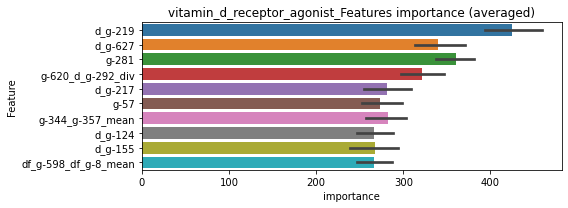

len(train_index) : 2842
len(valid_index) : 948
================================= fold 1/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.101729	valid_1's binary_logloss: 0.150525
[200]	training's binary_logloss: 0.0339825	valid_1's binary_logloss: 0.0775838
[300]	training's binary_logloss: 0.0127054	valid_1's binary_logloss: 0.0475714
[400]	training's binary_logloss: 0.00550702	valid_1's binary_logloss: 0.0344923
[500]	training's binary_logloss: 0.00284572	valid_1's binary_logloss: 0.0287554
[600]	training's binary_logloss: 0.00176088	valid_1's binary_logloss: 0.0261218
Early stopping, best iteration is:
[601]	training's binary_logloss: 0.00175395	valid_1's binary_logloss: 0.0260871


len(train_index) : 2842
len(valid_index) : 948
================================= fold 2/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.104113	valid_1's binary_logloss: 0.146587
[200]	training's binary_logloss: 0.0358387	valid_1's binary_logloss: 0.0690656
[300]	training's binary_logloss: 0.0139618	valid_1's binary_logloss: 0.0385653
[400]	training's binary_logloss: 0.00611539	valid_1's binary_logloss: 0.0243697
[500]	training's binary_logloss: 0.00309016	valid_1's binary_logloss: 0.0171412
[600]	training's binary_logloss: 0.00187573	valid_1's binary_logloss: 0.0139802
[700]	training's binary_logloss: 0.0012891	valid_1's binary_logloss: 0.0121508
[800]	training's binary_logloss: 0.000993347	valid_1's binary_logloss: 0.0112055
[900]	training's binary_logloss: 0.000809863	valid_1's binary_logloss: 0.0104789
[1000]	training's binary_logloss: 0.000708483	valid_1's binary_logloss: 0.0100711
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000712258	valid_1's binary_logloss: 0.0100493


len(train_index) : 2843
len(valid_index) : 947
================================= fold 3/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.102346	valid_1's binary_logloss: 0.140982
[200]	training's binary_logloss: 0.0351916	valid_1's binary_logloss: 0.0686427
[300]	training's binary_logloss: 0.0133297	valid_1's binary_logloss: 0.0393807
[400]	training's binary_logloss: 0.00564265	valid_1's binary_logloss: 0.0262423
[500]	training's binary_logloss: 0.00286219	valid_1's binary_logloss: 0.0203243
[600]	training's binary_logloss: 0.00175893	valid_1's binary_logloss: 0.0179466
[700]	training's binary_logloss: 0.00124646	valid_1's binary_logloss: 0.0172051
Early stopping, best iteration is:
[708]	training's binary_logloss: 0.00121826	valid_1's binary_logloss: 0.0171437


len(train_index) : 2843
len(valid_index) : 947
================================= fold 4/4 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.103935	valid_1's binary_logloss: 0.137301
[200]	training's binary_logloss: 0.0354266	valid_1's binary_logloss: 0.0604217
[300]	training's binary_logloss: 0.0135836	valid_1's binary_logloss: 0.0319936
[400]	training's binary_logloss: 0.00588976	valid_1's binary_logloss: 0.0206341
[500]	training's binary_logloss: 0.00301476	valid_1's binary_logloss: 0.01553
[600]	training's binary_logloss: 0.00184935	valid_1's binary_logloss: 0.0130875
[700]	training's binary_logloss: 0.00129524	valid_1's binary_logloss: 0.0118325
[800]	training's binary_logloss: 0.000994403	valid_1's binary_logloss: 0.0110523
[900]	training's binary_logloss: 0.000814811	valid_1's binary_logloss: 0.0105243
[1000]	training's binary_logloss: 0.000708123	valid_1's binary_logloss: 0.010342
Early stopping, best iteration is:
[975]	training's binary_logloss: 0.000727204	valid_1's binary_logloss: 0.0103176


vitamin_d_receptor_agonist logloss: 0.015900551584889292


neg labels: 3289 → selected neg labels: 3287


wnt_inhibitor, len(trt): 30, len(othr): 3287, target_rate: 0.0012598 → Adj_target_rate: 0.0015127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0938495	valid_1's binary_logloss: 0.129099
[200]	training's binary_logloss: 0.0300285	valid_1's binary_logloss: 0.0586177
[300]	training's binary_logloss: 0.0111469	valid_1's binary_logloss: 0.0334041
[400]	training's binary_logloss: 0.00468961	valid_1's binary_logloss: 0.0227689
[500]	training's binary_logloss: 0.00244794	valid_1's binary_logloss: 0.0183054
[600]	training's binary_logloss: 0.00152446	valid_1's binary_logloss: 0.0161078
[700]	training's binary_logloss: 0.00108923	valid_1's binary_logloss: 0.0149414
[800]	training's binary_logloss: 0.00085161	valid_1's binary_logloss: 0.0142603
[900]	training's binary_logloss: 0.000708594	valid_1's binary_logloss: 0.0139282
[1000]	training's binary_logloss: 0.000637035	valid_1's binary_logloss: 0.0137245
Early stopping, best iteration is:
[1057]	training's binary_logloss: 0.000617611	valid_1's binary_logloss: 0.0136856
Training until validati

1 / 3 AUC score:1.000
y_Threshold: 0.0095284, Threshold: 0.0695903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 132 → Positive_corect_labels: 657/3812
p_label_rate: 0.0100452 Vs.target_rate: 0.00126, Num_p_label: 40.0, conf_0:0.04871, conf_1:0.09047
Num_p_label: 40.0, Expected: 5.0, Adj_threshold_1: 0.0695903
Num_p_label: 25.0, Expected: 5.0, Adj_threshold_2: 0.1195903
Num_p_label: 14.0, Expected: 5.0, Adj_threshold_3: 0.1695903
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_4: 0.2195903
threshold: 0.2195903, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 657.0/3812, y_label_rate: 0.1723505
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0907446	valid_1's binary_logloss: 0.124618
[200]	training's binary_logloss: 0.0276404	valid_1's binary_logloss: 0.0542263
[300]	training's binary_logloss: 0.00981234	valid_1's binary_logloss: 0.0295219
[400]	training's binary_logloss: 0.00422751	valid_1's binary_logloss: 0.0196839
[500]	training's binary_logloss: 0.0022222	valid_1's binary_logloss: 0.0154682
[600]	training's binary_logloss: 0.0013971	valid_1's binary_logloss: 0.0135262
[700]	training's binary_logloss: 0.00100999	valid_1's binary_logloss: 0.0126158
[800]	training's binary_logloss: 0.000789505	valid_1's binary_logloss: 0.0118692
[900]	training's binary_logloss: 0.000661197	valid_1's binary_logloss: 0.0116108
[1000]	training's binary_logloss: 0.000594658	valid_1's binary_logloss: 0.0114007
Early stopping, best iteration is:
[993]	training's binary_logloss: 0.000598089	valid_1's binary_logloss: 0.0113783
Training until validatio

2 / 3 AUC score:1.000
y_Threshold: 0.0575749, Threshold: 0.2195903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 6 → Positive_corect_labels: 654.0/3806
p_label_rate: 0.0067805 Vs.target_rate: 0.00126, Num_p_label: 27.0, conf_0:0.17567, conf_1:0.26351
Num_p_label: 27.0, Expected: 5.0, Adj_threshold_1: 0.2195903
Num_p_label: 24.0, Expected: 5.0, Adj_threshold_2: 0.2695903
Num_p_label: 20.0, Expected: 5.0, Adj_threshold_3: 0.3195903
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_4: 0.3695903
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_5: 0.4195903
threshold: 0.4195903, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 654.0/3806, y_label_rate: 0.1718339
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.091303	valid_1's binary_logloss: 0.117203
[200]	training's binary_logloss: 0.0283175	valid_1's binary_logloss: 0.0474469
[300]	training's binary_logloss: 0.00998747	valid_1's binary_logloss: 0.0227008
[400]	training's binary_logloss: 0.00414983	valid_1's binary_logloss: 0.013009
[500]	training's binary_logloss: 0.0021724	valid_1's binary_logloss: 0.00886782
[600]	training's binary_logloss: 0.00137348	valid_1's binary_logloss: 0.00689284
[700]	training's binary_logloss: 0.000990326	valid_1's binary_logloss: 0.00600747
[800]	training's binary_logloss: 0.000780422	valid_1's binary_logloss: 0.00529156
[900]	training's binary_logloss: 0.000657913	valid_1's binary_logloss: 0.00488586
[1000]	training's binary_logloss: 0.000593453	valid_1's binary_logloss: 0.00461276
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.000592974	valid_1's binary_logloss: 0.0046127
Training until va

3 / 3 AUC score:1.000
y_Threshold: 0.0604926, Threshold: 0.4195903, pos_neg_ratio: 0.8000000
Remove_noisy_data: 2 → Positive_corect_labels: 653.0/3804
p_label_rate: 0.0040181 Vs.target_rate: 0.00126, Num_p_label: 16.0, conf_0:0.37763, conf_1:0.46155
Num_p_label: 16.0, Expected: 5.0, Adj_threshold_1: 0.4195903
Num_p_label: 12.0, Expected: 5.0, Adj_threshold_2: 0.4695903
threshold: 0.4695903, positive_p_label: 12.0/3982, p_label_rate: 0.0030136
positive_y_label: 653.0/3804, y_label_rate: 0.1716614


len(train_index) : 2853
len(valid_index) : 951
================================= fold 1/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0891353	valid_1's binary_logloss: 0.128103
[200]	training's binary_logloss: 0.0271825	valid_1's binary_logloss: 0.0560171
[300]	training's binary_logloss: 0.00965501	valid_1's binary_logloss: 0.0297681
[400]	training's binary_logloss: 0.00409803	valid_1's binary_logloss: 0.0189484
[500]	training's binary_logloss: 0.00216356	valid_1's binary_logloss: 0.0147624
[600]	training's binary_logloss: 0.00136041	valid_1's binary_logloss: 0.0123639
[700]	training's binary_logloss: 0.000981097	valid_1's binary_logloss: 0.0112907
Early stopping, best iteration is:
[689]	training's binary_logloss: 0.00101088	valid_1's binary_logloss: 0.0112481


len(train_index) : 2853
len(valid_index) : 951
================================= fold 2/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0931721	valid_1's binary_logloss: 0.119995
[200]	training's binary_logloss: 0.0292009	valid_1's binary_logloss: 0.0493073
[300]	training's binary_logloss: 0.0104036	valid_1's binary_logloss: 0.0239106
[400]	training's binary_logloss: 0.00445653	valid_1's binary_logloss: 0.0133085
[500]	training's binary_logloss: 0.00227002	valid_1's binary_logloss: 0.00884826
[600]	training's binary_logloss: 0.00142005	valid_1's binary_logloss: 0.00675573
[700]	training's binary_logloss: 0.00101341	valid_1's binary_logloss: 0.00572176
[800]	training's binary_logloss: 0.000790733	valid_1's binary_logloss: 0.00511442
[900]	training's binary_logloss: 0.000663823	valid_1's binary_logloss: 0.00475543
[1000]	training's binary_logloss: 0.000604641	valid_1's binary_logloss: 0.00457875
[1100]	training's binary_logloss: 0.000571678	valid_1's binary_logloss: 0.0044935
Early stopping, best iteration is:
[1120]	training'

len(train_index) : 2853
len(valid_index) : 951
================================= fold 3/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0905196	valid_1's binary_logloss: 0.130902
[200]	training's binary_logloss: 0.0275193	valid_1's binary_logloss: 0.0583649
[300]	training's binary_logloss: 0.00975764	valid_1's binary_logloss: 0.031903
[400]	training's binary_logloss: 0.00412119	valid_1's binary_logloss: 0.0210318
[500]	training's binary_logloss: 0.0021449	valid_1's binary_logloss: 0.0156406
[600]	training's binary_logloss: 0.00135463	valid_1's binary_logloss: 0.0130137
[700]	training's binary_logloss: 0.000968588	valid_1's binary_logloss: 0.0116712
[800]	training's binary_logloss: 0.000764222	valid_1's binary_logloss: 0.0106935
[900]	training's binary_logloss: 0.000640228	valid_1's binary_logloss: 0.0101853
[1000]	training's binary_logloss: 0.000574519	valid_1's binary_logloss: 0.00997426
Early stopping, best iteration is:
[996]	training's binary_logloss: 0.000577412	valid_1's binary_logloss: 0.00993876


len(train_index) : 2853
len(valid_index) : 951
================================= fold 4/4 wnt_inhibitor=================================


Training until validation scores don't improve for 30 rounds
[100]	training's binary_logloss: 0.0920805	valid_1's binary_logloss: 0.112551
[200]	training's binary_logloss: 0.0285515	valid_1's binary_logloss: 0.0446094
[300]	training's binary_logloss: 0.0101372	valid_1's binary_logloss: 0.0211286
[400]	training's binary_logloss: 0.0042439	valid_1's binary_logloss: 0.0124321
[500]	training's binary_logloss: 0.00223151	valid_1's binary_logloss: 0.00868058
[600]	training's binary_logloss: 0.00140432	valid_1's binary_logloss: 0.00676859
[700]	training's binary_logloss: 0.00100225	valid_1's binary_logloss: 0.00586347
[800]	training's binary_logloss: 0.000790851	valid_1's binary_logloss: 0.00535299
[900]	training's binary_logloss: 0.000662282	valid_1's binary_logloss: 0.00492081
[1000]	training's binary_logloss: 0.000603218	valid_1's binary_logloss: 0.00473242
[1100]	training's binary_logloss: 0.000579271	valid_1's binary_logloss: 0.00462306
[1200]	training's binary_logloss: 0.000568326	valid

wnt_inhibitor logloss: 0.007571100731410635


In [44]:
categorical_cols = []
scores = []
models = []
feature_importance_df = pd.DataFrame()
#importance_cols_df = pd.DataFrame()

for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models, _feature_importance_df = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)

sub.to_csv('submission.csv', index=False)

In [45]:
print(f"CV:{np.mean(scores)}")

CV:0.024201653880957755
